In [1]:
import os
import pandas as pd
import geopandas as gpd
import cdsapi
from datetime import datetime, timedelta
import xarray as xr
import netCDF4
import zipfile
import shutil
import matplotlib.pyplot as plt
from timezonefinder import TimezoneFinder
import pytz

# === SETTINGS ===
outage_file  = "data_collection_by_hollis/correlated_outage/extreme_outage_events.csv"
weather_dir  = "data_collection_by_hollis/correlated_outage/weather_output"
os.makedirs(weather_dir , exist_ok=True)

# Load outage events
df = pd.read_csv(outage_file)

In [2]:
df = df.drop(columns=[
    col for col in df.columns if any(x in col for x in ["STATEFP", "COUNTYFP", "STATE_NAME", "NAME", "lat", "lon"])
])

# Load U.S. county shapefile from Census
shapefile_path = "data_collection_by_hollis/shapefiles/cb_2020_us_county_5m.zip"
counties = gpd.read_file(shapefile_path)
counties["lat"] = counties.geometry.centroid.y
counties["lon"] = counties.geometry.centroid.x

# Re-project to a U.S.-appropriate planar CRS
counties = counties.to_crs(epsg=5070)
counties["county_lat"] = counties.geometry.centroid.to_crs(epsg=4326).y
counties["county_lon"] = counties.geometry.centroid.to_crs(epsg=4326).x

# Rename to match clean merge keys
counties = counties.rename(columns={
    "NAME": "county",
    "STATE_NAME": "state"
})

# Merge on lowercase standardized fields
df = df.merge(
    counties[["state", "county", "county_lat", "county_lon"]],
    on=["state", "county"],
    how="left"
)

counties[['state', 'county', 'county_lat', 'county_lon']].to_csv("county_centroids.csv", index=False)


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\836355668.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  counties["lat"] = counties.geometry.centroid.y
C:\Users\holli\AppData\Local\Temp\ipykernel_56396\836355668.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  counties["lon"] = counties.geometry.centroid.x


In [3]:
def unzip_and_collect(zip_path):
    folder = os.path.dirname(zip_path)
    if not zipfile.is_zipfile(zip_path):
        return [zip_path]  # already .nc or uncompressed

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(folder)
        extracted = [os.path.join(folder, f) for f in zip_ref.namelist()]
    return [f for f in extracted if f.endswith(".nc") or f.endswith(".grib")]

In [4]:
def clean_downloaded_nc_files(keep_path, extra_paths):
    for path in extra_paths:
        if os.path.exists(path) and path != keep_path:
            try:
                os.remove(path)
                print(f"🗑️ Deleted extra file: {path}")
            except Exception as e:
                print(f"⚠️ Could not delete: {path}\n   {e}")


In [ ]:
def download_hourly_weather(lat, lon, datetime_str, event_index, save_folder):
    tf = TimezoneFinder()
    tz_name = tf.timezone_at(lat=lat, lng=lon)
    tz = pytz.timezone(tz_name)
    target_datetime_local = pd.to_datetime(datetime_str)
    target_datetime = tz.localize(target_datetime_local).astimezone(pytz.utc)
    start_datetime = target_datetime - timedelta(hours=47)

    area = [round(float(lat)+0.1, 4), round(float(lon)-0.1, 4),
            round(float(lat)-0.1, 4), round(float(lon)+0.1, 4)]

    variables_by_type = {
        'instant': [
            '2m_temperature', '2m_dewpoint_temperature', 'surface_pressure',
            '10m_u_component_of_wind', '10m_v_component_of_wind',
            'instantaneous_10m_wind_gust', 'total_column_rain_water',
            'boundary_layer_height'
            ],
        'accum': [
            'total_precipitation', 'snowfall',
            'surface_latent_heat_flux', 'surface_net_solar_radiation'
            ],
    }
    temp_files = []
    def fetch_and_open(day, offset, var_list, step_type):
        year, month, day_val = day.year, day.month, day.day
        tag = f"event_{event_index}_{day.strftime('%Y-%m-%d')}_D-{offset}_{step_type}.nc"
        out_path = os.path.join(save_folder, tag)

        if not os.path.exists(out_path):
            print(f"\n📦 Downloading: {out_path}")
            client = cdsapi.Client()
            client.retrieve(
                'reanalysis-era5-single-levels',
                {
                    'product_type': 'reanalysis',
                    'format': 'netcdf',
                    'variable': var_list,
                    'year': year,
                    'month': month,
                    'day': day_val,
                    'time': [f"{h:02}:00" for h in range(24)],
                    'area': area,
                },
                out_path
            )
        else:
            print(f"📦 Already downloaded: {out_path}")
        temp_files.append(out_path)  # Track for deletion
        return xr.open_dataset(out_path)

    all_datasets = []

    for offset in [2, 1, 0]:
        date = target_datetime.date() - timedelta(days=offset)
        for step_type, vars in variables_by_type.items():
            try:
                ds = fetch_and_open(date, offset, vars, step_type)
                all_datasets.append(ds.load())
                ds.close()
            except Exception as e:
                print(f"⚠️ Failed to fetch or load for {date} {step_type}: {e}")

    if all_datasets:
        time_dim = 'time' if 'time' in all_datasets[0].dims else 'valid_time'
        merged = xr.merge(all_datasets)
        merged = merged.sortby(time_dim)
        unique_times = ~merged[time_dim].to_index().duplicated()
        merged = merged.isel({time_dim: unique_times})

        final = merged.sel({
            time_dim: slice(start_datetime.replace(tzinfo=None),
                            target_datetime.replace(tzinfo=None))
        })

        out_file = os.path.join(
            save_folder,
            f"event_{event_index}_{target_datetime.strftime('%Y-%m-%d_%H-%M')}.nc"
        )
        final.to_netcdf(out_file)
        print(f"✅ Saved 48-hour data: {out_file}")

        # Cleanup
        for f in temp_files:
            try:
                os.remove(f)
                print(f"🗑️ Deleted temp file: {f}")
            except Exception as e:
                print(f"⚠️ Could not delete {f}: {e}")

        return out_file
    
    print(f"❌ No valid datasets found for event {event_index}")
    return None

In [41]:
# NEED TO CONVERT TO UTC
 
for i, row in df.iterrows():
    try:
        if pd.isnull(row['start_time']):
            continue
        # ⏱️ Round down to nearest hour
        start_time_floor = pd.to_datetime(row['start_time']).floor("H")

        lat, lon = row['county_lat'], row['county_lon']
        download_hourly_weather(lat, lon, start_time_floor, i, 'data_collection_by_hollis/correlated_outage/weather_output')

    except Exception as e:
        print(f"❌ Failed event {i} ({row['county']}): {e}")
    # break


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")


📦 Already downloaded: data_collection_by_hollis/correlated_outage/weather_output\event_0_2014-11-22_D-2_instant.nc
📦 Already downloaded: data_collection_by_hollis/correlated_outage/weather_output\event_0_2014-11-22_D-2_accum.nc
📦 Already downloaded: data_collection_by_hollis/correlated_outage/weather_output\event_0_2014-11-23_D-1_instant.nc
📦 Already downloaded: data_collection_by_hollis/correlated_outage/weather_output\event_0_2014-11-23_D-1_accum.nc
📦 Already downloaded: data_collection_by_hollis/correlated_outage/weather_output\event_0_2014-11-24_D-0_instant.nc
📦 Already downloaded: data_collection_by_hollis/correlated_outage/weather_output\event_0_2014-11-24_D-0_accum.nc
✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_0_2014-11-24_15-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_0_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_0_201

C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_1_2014-11-22_D-2_instant.nc


2025-04-23 21:42:26,901 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 21:42:26,902 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 21:42:27,612 INFO Request ID is 9ee6b760-4fa4-4b8b-9b3a-50b2af39e142
2025-04-23 21:42:27,808 INFO status has been updated to accepted
2025-04-23 21:42:41,965 INFO status has been updated to running
2025-04-23 21:43:18,744 INFO status has been updated to successful


59a56a1357c5a55b2de4a33760692586.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_1_2014-11-22_D-2_accum.nc


2025-04-23 21:43:21,612 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 21:43:21,613 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 21:43:22,381 INFO Request ID is 565841ea-8926-4f87-9ae2-3fea62952bd6
2025-04-23 21:43:22,565 INFO status has been updated to accepted
2025-04-23 21:43:31,405 INFO status has been updated to running
2025-04-23 21:43:44,746 INFO status has been updated to successful


32bce62e365dc7c13755ef118329e072.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_1_2014-11-23_D-1_instant.nc


2025-04-23 21:43:46,963 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 21:43:46,964 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 21:43:47,607 INFO Request ID is d9a03b12-b68e-4043-a630-ba378e78f3a5
2025-04-23 21:43:47,771 INFO status has been updated to accepted
2025-04-23 21:43:56,665 INFO status has been updated to running
2025-04-23 21:44:38,517 INFO status has been updated to successful


6d72fad4eb0bd68d018f044a8c255b12.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_1_2014-11-23_D-1_accum.nc


2025-04-23 21:44:40,834 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 21:44:40,835 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 21:44:41,645 INFO Request ID is fe6483a9-6088-4c96-ae74-69cd71eb8fcb
2025-04-23 21:44:41,813 INFO status has been updated to accepted
2025-04-23 21:44:56,021 INFO status has been updated to running
2025-04-23 21:45:15,383 INFO status has been updated to successful


3e3438b2d562bb5c5eaf9d4a47e806bc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_1_2014-11-24_D-0_instant.nc


2025-04-23 21:45:17,648 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 21:45:17,649 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 21:45:18,373 INFO Request ID is b8539542-8029-4c56-9e06-31642d59b021
2025-04-23 21:45:18,874 INFO status has been updated to accepted
2025-04-23 21:45:33,341 INFO status has been updated to running
2025-04-23 21:46:10,006 INFO status has been updated to successful


cce105c9f39b3180f39aa7d8705f089.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_1_2014-11-24_D-0_accum.nc


2025-04-23 21:46:12,171 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 21:46:12,172 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 21:46:13,345 INFO Request ID is 7dd07da9-7dd9-42f0-b545-ce0501afbead
2025-04-23 21:46:13,521 INFO status has been updated to accepted
2025-04-23 21:46:35,437 INFO status has been updated to running
2025-04-23 21:47:04,469 INFO status has been updated to successful


a38dcf72578cc357ef94954f97a51d13.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_1_2014-11-24_15-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_1_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_1_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_1_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_1_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_1_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_1_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_2_2014-11-22_D-2_instant.nc


2025-04-23 21:47:07,225 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 21:47:07,226 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 21:47:07,910 INFO Request ID is d38ad7cf-aee7-4a07-a2a4-5b16750cdda6
2025-04-23 21:47:08,116 INFO status has been updated to accepted
2025-04-23 21:47:23,294 INFO status has been updated to running
2025-04-23 21:47:42,644 INFO status has been updated to successful


1a7a551800aa213e6726778f273556c3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_2_2014-11-22_D-2_accum.nc


2025-04-23 21:47:44,910 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 21:47:44,911 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 21:47:45,768 INFO Request ID is 87128fe6-6126-405c-ab6b-f06a6ee58fc2
2025-04-23 21:47:45,980 INFO status has been updated to accepted
2025-04-23 21:48:00,050 INFO status has been updated to running
2025-04-23 21:48:19,428 INFO status has been updated to successful


7d23c66247391dbf9991b56641bd71e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_2_2014-11-23_D-1_instant.nc


2025-04-23 21:48:21,588 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 21:48:21,589 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 21:48:22,273 INFO Request ID is b6481692-028e-41e0-8488-9a31b7a7b633
2025-04-23 21:48:22,444 INFO status has been updated to accepted
2025-04-23 21:48:36,610 INFO status has been updated to running
2025-04-23 21:48:55,974 INFO status has been updated to successful


47dc3acb8279e289a67909caecf74f70.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_2_2014-11-23_D-1_accum.nc


2025-04-23 21:48:58,750 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 21:48:58,751 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 21:48:59,554 INFO Request ID is ecf9beb3-1dca-4175-90da-7438296d4ffb
2025-04-23 21:49:00,306 INFO status has been updated to accepted
2025-04-23 21:49:14,402 INFO status has been updated to running
2025-04-23 21:49:22,180 INFO status has been updated to successful


3c0af5b7fad3138777b3e2870fbd0f4c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_2_2014-11-24_D-0_instant.nc


2025-04-23 21:49:24,383 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 21:49:24,383 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 21:49:25,096 INFO Request ID is ce7559ed-bf43-43ce-a28d-4fc497063a16
2025-04-23 21:49:25,264 INFO status has been updated to accepted
2025-04-23 21:49:39,337 INFO status has been updated to running
2025-04-23 21:50:15,977 INFO status has been updated to successful


766d0ee19326ead606d98975cdac7863.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_2_2014-11-24_D-0_accum.nc


2025-04-23 21:50:18,167 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 21:50:18,168 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 21:50:18,825 INFO Request ID is f7a42a94-fea9-42b2-9660-f8ff2b9667f1
2025-04-23 21:50:19,026 INFO status has been updated to accepted
2025-04-23 21:50:27,908 INFO status has been updated to running
2025-04-23 21:50:40,955 INFO status has been updated to successful


8d450281f484a9518c18057e71653333.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_2_2014-11-24_12-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_2_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_2_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_2_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_2_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_2_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_2_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_3_2014-11-24_D-2_instant.nc


2025-04-23 21:50:43,641 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 21:50:43,642 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 21:50:44,441 INFO Request ID is ac69a066-a07b-455b-b4cd-1cf99697597d
2025-04-23 21:50:44,614 INFO status has been updated to accepted
2025-04-23 21:50:58,899 INFO status has been updated to running
2025-04-23 21:51:18,238 INFO status has been updated to successful


6d8e45d9c36545a3fd8d8cb90aeca7db.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_3_2014-11-24_D-2_accum.nc


2025-04-23 21:51:20,584 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 21:51:20,585 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 21:51:21,422 INFO Request ID is a4445f3f-140c-4e52-9d8a-7e6bb9c15afd
2025-04-23 21:51:21,743 INFO status has been updated to accepted
2025-04-23 21:51:35,909 INFO status has been updated to running
2025-04-23 21:51:55,241 INFO status has been updated to successful


c098120979fa23a87d4432c396f88a3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_3_2014-11-25_D-1_instant.nc


2025-04-23 21:51:57,423 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 21:51:57,424 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 21:51:58,885 INFO Request ID is 9b1cadc9-94a1-460c-b2a8-3b70e812d757
2025-04-23 21:51:59,076 INFO status has been updated to accepted
2025-04-23 21:52:08,273 INFO status has been updated to running
2025-04-23 21:52:50,126 INFO status has been updated to successful


4001b2bd8e5c728aa6fe5cad97d4ae15.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_3_2014-11-25_D-1_accum.nc


2025-04-23 21:52:52,313 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 21:52:52,314 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 21:52:53,069 INFO Request ID is 97823826-465f-4a4c-95a5-6570a55d7114
2025-04-23 21:52:53,377 INFO status has been updated to accepted
2025-04-23 21:53:02,391 INFO status has been updated to running
2025-04-23 21:53:15,392 INFO status has been updated to successful


47479eb86e8bf0b70efb99a8d7cefb3a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_3_2014-11-26_D-0_instant.nc


2025-04-23 21:53:17,603 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 21:53:17,603 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 21:53:18,473 INFO Request ID is 2146aa48-539e-4dc7-9ebe-68df014f71aa
2025-04-23 21:53:18,659 INFO status has been updated to accepted
2025-04-23 21:53:40,957 INFO status has been updated to running
2025-04-23 21:54:09,847 INFO status has been updated to successful


157d5ed1822b931ee1ae8244059b9ea0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_3_2014-11-26_D-0_accum.nc


2025-04-23 21:54:17,202 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 21:54:17,203 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 21:54:18,104 INFO Request ID is f3c0bc3e-6545-42e0-95f5-ea214fc6137b
2025-04-23 21:54:18,278 INFO status has been updated to accepted
2025-04-23 21:54:27,374 INFO status has been updated to running
2025-04-23 21:54:40,631 INFO status has been updated to successful


9d86c4c0621c5ba904858ff49c7a3863.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_3_2014-11-26_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_3_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_3_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_3_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_3_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_3_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_3_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_4_2014-11-22_D-2_instant.nc


2025-04-23 21:54:43,311 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 21:54:43,312 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 21:54:44,229 INFO Request ID is 53472e91-567c-4681-b179-e8fa485dbf24
2025-04-23 21:54:44,527 INFO status has been updated to accepted
2025-04-23 21:54:53,458 INFO status has been updated to running
2025-04-23 21:55:35,375 INFO status has been updated to successful


191b4c0f95044518288470895034de2e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_4_2014-11-22_D-2_accum.nc


2025-04-23 21:55:37,531 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 21:55:37,532 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 21:55:38,889 INFO Request ID is 00e3a724-1921-476f-af59-2e7b83581e4e
2025-04-23 21:55:39,057 INFO status has been updated to accepted
2025-04-23 21:56:12,885 INFO status has been updated to running
2025-04-23 21:56:30,153 INFO status has been updated to successful


1d4403ebe605413b4b14c909de60d004.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_4_2014-11-23_D-1_instant.nc


2025-04-23 21:56:32,793 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 21:56:32,793 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 21:56:33,499 INFO Request ID is 8e9d36f2-6ff6-4bcf-9a70-0e5ed74961da
2025-04-23 21:56:33,676 INFO status has been updated to accepted
2025-04-23 21:56:42,724 INFO status has been updated to running
2025-04-23 21:57:07,306 INFO status has been updated to successful


e6622f9f1ffa045ef81e406bbafff55.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_4_2014-11-23_D-1_accum.nc


2025-04-23 21:57:09,526 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 21:57:09,527 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 21:57:10,201 INFO Request ID is 36bff317-7bb9-4697-a38e-e31e76c087ae
2025-04-23 21:57:10,369 INFO status has been updated to accepted
2025-04-23 21:57:19,286 INFO status has been updated to running
2025-04-23 21:57:24,531 INFO status has been updated to successful


c70bc3e6958409f3bf515618c54a74b7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_4_2014-11-24_D-0_instant.nc


2025-04-23 21:57:26,794 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 21:57:26,795 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 21:57:27,585 INFO Request ID is c8afef71-6dc3-4476-a612-efde1e469121
2025-04-23 21:57:27,793 INFO status has been updated to accepted
2025-04-23 21:57:36,665 INFO status has been updated to running
2025-04-23 21:57:41,902 INFO status has been updated to accepted
2025-04-23 21:57:49,738 INFO status has been updated to successful


be4349b9d11ec25f936157152742879d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_4_2014-11-24_D-0_accum.nc


2025-04-23 21:57:52,008 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 21:57:52,009 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 21:57:53,887 INFO Request ID is 091e92c0-2d98-4966-b2cf-f78e8085f740
2025-04-23 21:57:54,080 INFO status has been updated to accepted
2025-04-23 21:58:03,285 INFO status has been updated to running
2025-04-23 21:58:45,148 INFO status has been updated to successful


78f86bee02b1af9f6b483d2ed5889a43.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_4_2014-11-24_15-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_4_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_4_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_4_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_4_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_4_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_4_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_5_2014-11-24_D-2_instant.nc


2025-04-23 21:58:47,860 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 21:58:47,861 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 21:58:48,878 INFO Request ID is e1f588b6-4baf-4608-b00b-db1f77edea39
2025-04-23 21:58:49,066 INFO status has been updated to accepted
2025-04-23 21:58:58,225 INFO status has been updated to running
2025-04-23 21:59:11,264 INFO status has been updated to successful


82599013ad002364b51126c5a6e9c91.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_5_2014-11-24_D-2_accum.nc


2025-04-23 21:59:13,663 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 21:59:13,664 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 21:59:14,385 INFO Request ID is aa781e10-d0d5-4c84-b33c-f2284bc3784d
2025-04-23 21:59:14,599 INFO status has been updated to accepted
2025-04-23 21:59:23,491 INFO status has been updated to running
2025-04-23 21:59:36,494 INFO status has been updated to successful


319557d7666484f1d929d68dc03a096c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_5_2014-11-25_D-1_instant.nc


2025-04-23 21:59:38,673 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 21:59:38,674 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 21:59:39,335 INFO Request ID is 5c418300-b4c6-4f10-9914-6ceb153af684
2025-04-23 21:59:39,723 INFO status has been updated to accepted
2025-04-23 22:00:01,590 INFO status has been updated to running
2025-04-23 22:00:30,573 INFO status has been updated to successful


b12ff51ad95e8141cc225040f97923e4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_5_2014-11-25_D-1_accum.nc


2025-04-23 22:00:32,789 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:00:32,790 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:00:33,592 INFO Request ID is fb3f7f5c-bdb3-4167-9b5e-d4edeebe4256
2025-04-23 22:00:33,787 INFO status has been updated to accepted
2025-04-23 22:00:48,254 INFO status has been updated to running
2025-04-23 22:01:07,620 INFO status has been updated to successful


29b168cf25c6913eca92083c7fc5351e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_5_2014-11-26_D-0_instant.nc


2025-04-23 22:01:09,844 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:01:09,845 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:01:10,499 INFO Request ID is a754e4d7-3ae5-47f3-8536-a647a9a20e01
2025-04-23 22:01:10,663 INFO status has been updated to accepted
2025-04-23 22:01:25,237 INFO status has been updated to running
2025-04-23 22:02:01,845 INFO status has been updated to successful


fb605d39f197366dd7e5b9df8bbea661.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_5_2014-11-26_D-0_accum.nc


2025-04-23 22:02:04,180 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:02:04,181 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:02:04,980 INFO Request ID is bd6d50d1-7dbd-4132-863f-54c2bd12fdca
2025-04-23 22:02:05,150 INFO status has been updated to accepted
2025-04-23 22:02:19,224 INFO status has been updated to running
2025-04-23 22:02:27,004 INFO status has been updated to successful


35481fd53a0539cfc2dcfb0b0e3bfb91.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_5_2014-11-26_16-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_5_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_5_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_5_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_5_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_5_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_5_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_6_2014-11-22_D-2_instant.nc


2025-04-23 22:02:29,926 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:02:29,928 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:02:30,806 INFO Request ID is 221ccb03-fc41-4273-a67b-20dc934a955f
2025-04-23 22:02:31,027 INFO status has been updated to accepted
2025-04-23 22:02:39,926 INFO status has been updated to running
2025-04-23 22:03:48,143 INFO status has been updated to successful


94d2affe0ef448f000771efc780c94c7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_6_2014-11-22_D-2_accum.nc


2025-04-23 22:03:50,434 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:03:50,435 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:03:51,430 INFO Request ID is d33009b9-75cd-4268-ab40-0cee85c21eab
2025-04-23 22:03:51,604 INFO status has been updated to accepted
2025-04-23 22:04:05,972 INFO status has been updated to running
2025-04-23 22:04:25,336 INFO status has been updated to successful


2a185aca1843ab742973e50739c79db5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_6_2014-11-23_D-1_instant.nc


2025-04-23 22:04:27,617 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:04:27,618 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:04:28,446 INFO Request ID is 09484904-602f-4812-a429-d26422b12c61
2025-04-23 22:04:28,778 INFO status has been updated to accepted
2025-04-23 22:04:37,595 INFO status has been updated to running
2025-04-23 22:05:02,362 INFO status has been updated to successful


9b5ac509217fa77be22fc612d4ec94c7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_6_2014-11-23_D-1_accum.nc


2025-04-23 22:05:04,547 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:05:04,549 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:05:05,691 INFO Request ID is 329579d3-670b-4226-96f7-4b493503976c
2025-04-23 22:05:05,880 INFO status has been updated to accepted
2025-04-23 22:05:20,030 INFO status has been updated to running
2025-04-23 22:05:27,985 INFO status has been updated to successful


9656706f8e4e059c3ef39c8c26c77822.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_6_2014-11-24_D-0_instant.nc


2025-04-23 22:05:30,549 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:05:30,550 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:05:31,345 INFO Request ID is 117683b0-c14a-4c4a-9297-8b6ffdad34d9
2025-04-23 22:05:31,533 INFO status has been updated to accepted
2025-04-23 22:06:23,437 INFO status has been updated to running
2025-04-23 22:06:49,257 INFO status has been updated to successful


e3688923b6eb931c08ada190b155620e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_6_2014-11-24_D-0_accum.nc


2025-04-23 22:06:51,870 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:06:51,870 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:06:52,561 INFO Request ID is 5cd45e80-a45e-4a7c-aa11-1a0110ef0c1e
2025-04-23 22:06:52,760 INFO status has been updated to accepted
2025-04-23 22:07:01,611 INFO status has been updated to running
2025-04-23 22:07:14,669 INFO status has been updated to successful


b8bff9c0fdc852ca702020511f4f4b01.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_6_2014-11-24_16-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_6_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_6_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_6_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_6_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_6_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_6_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_7_2014-11-22_D-2_instant.nc


2025-04-23 22:07:17,336 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:07:17,337 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:07:18,121 INFO Request ID is 14f66773-1d19-4712-b896-363630de9191
2025-04-23 22:07:18,283 INFO status has been updated to accepted
2025-04-23 22:07:32,344 INFO status has been updated to successful


94d2affe0ef448f000771efc780c94c7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_7_2014-11-22_D-2_accum.nc


2025-04-23 22:07:34,521 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:07:34,522 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:07:35,451 INFO Request ID is 2b949dbd-eec3-4fec-94db-016aa6b1c43e
2025-04-23 22:07:35,623 INFO status has been updated to accepted
2025-04-23 22:07:58,109 INFO status has been updated to running
2025-04-23 22:08:10,045 INFO status has been updated to successful


2a185aca1843ab742973e50739c79db5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_7_2014-11-23_D-1_instant.nc


2025-04-23 22:08:13,050 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:08:13,051 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:08:13,944 INFO Request ID is af34de35-2ea8-453c-984e-102ff43a32c6
2025-04-23 22:08:14,190 INFO status has been updated to accepted
2025-04-23 22:08:28,694 INFO status has been updated to running
2025-04-23 22:08:36,482 INFO status has been updated to successful


9b5ac509217fa77be22fc612d4ec94c7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_7_2014-11-23_D-1_accum.nc


2025-04-23 22:08:38,632 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:08:38,634 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:08:39,443 INFO Request ID is ee7ce571-0147-44b6-b95b-61724acbd620
2025-04-23 22:08:39,613 INFO status has been updated to accepted
2025-04-23 22:08:53,845 INFO status has been updated to successful


9656706f8e4e059c3ef39c8c26c77822.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_7_2014-11-24_D-0_instant.nc


2025-04-23 22:08:56,005 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:08:56,006 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:08:56,710 INFO Request ID is b3e788e8-f119-4935-89e3-7f1172dbae8c
2025-04-23 22:08:56,958 INFO status has been updated to accepted
2025-04-23 22:09:05,913 INFO status has been updated to running
2025-04-23 22:09:11,140 INFO status has been updated to successful


e3688923b6eb931c08ada190b155620e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_7_2014-11-24_D-0_accum.nc


2025-04-23 22:09:13,504 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:09:13,505 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:09:14,194 INFO Request ID is 8068caaf-db08-41fb-8ec4-4476189e8a2b
2025-04-23 22:09:14,398 INFO status has been updated to accepted
2025-04-23 22:09:28,638 INFO status has been updated to running
2025-04-23 22:09:36,465 INFO status has been updated to successful


b8bff9c0fdc852ca702020511f4f4b01.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_7_2014-11-24_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_7_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_7_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_7_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_7_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_7_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_7_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_8_2014-11-24_D-2_instant.nc


2025-04-23 22:09:39,220 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:09:39,221 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:09:40,069 INFO Request ID is 6ccaf336-a7eb-45bf-be30-d88a77e7f091
2025-04-23 22:09:40,251 INFO status has been updated to accepted
2025-04-23 22:09:54,519 INFO status has been updated to running
2025-04-23 22:10:14,429 INFO status has been updated to successful


1c3dede74566a89b2964464f59fb9555.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_8_2014-11-24_D-2_accum.nc


2025-04-23 22:10:16,721 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:10:16,722 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:10:17,416 INFO Request ID is 46bc1152-28b3-473d-8b78-c67d933c2de5
2025-04-23 22:10:17,606 INFO status has been updated to accepted
2025-04-23 22:10:26,786 INFO status has been updated to running
2025-04-23 22:11:09,083 INFO status has been updated to successful


23b18ad440247c5531187f7232626b71.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_8_2014-11-25_D-1_instant.nc


2025-04-23 22:11:11,491 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:11:11,492 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:11:12,322 INFO Request ID is 488a16d8-d9df-470b-88c1-aa5dea92a2a7
2025-04-23 22:11:12,593 INFO status has been updated to accepted
2025-04-23 22:11:21,517 INFO status has been updated to running
2025-04-23 22:12:03,585 INFO status has been updated to successful


953dc58801da9d3d1c365b00e8ff8030.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_8_2014-11-25_D-1_accum.nc


2025-04-23 22:12:06,287 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:12:06,288 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:12:07,067 INFO Request ID is 61d8300b-47fe-4dae-bf11-9560fba2b8ae
2025-04-23 22:12:07,239 INFO status has been updated to accepted
2025-04-23 22:12:29,798 INFO status has been updated to running
2025-04-23 22:12:41,383 INFO status has been updated to successful


ccd2370c540ad2793c19983b38d8350f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_8_2014-11-26_D-0_instant.nc


2025-04-23 22:12:43,617 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:12:43,618 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:12:44,716 INFO Request ID is 42dd0116-9cd7-4399-ac85-cfb12a977f1d
2025-04-23 22:12:44,956 INFO status has been updated to accepted
2025-04-23 22:12:59,466 INFO status has been updated to running
2025-04-23 22:13:18,849 INFO status has been updated to successful


9aadb577aa5e069a22771ee15f389caf.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_8_2014-11-26_D-0_accum.nc


2025-04-23 22:13:26,226 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:13:26,227 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:13:27,220 INFO Request ID is 1818be50-2b1a-436e-87e6-db0b24d78eda
2025-04-23 22:13:27,454 INFO status has been updated to accepted
2025-04-23 22:13:41,963 INFO status has been updated to running
2025-04-23 22:14:01,316 INFO status has been updated to successful


8e1041007e069b141250907932b7ce5b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_8_2014-11-26_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_8_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_8_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_8_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_8_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_8_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_8_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_9_2014-11-01_D-2_instant.nc


2025-04-23 22:14:04,122 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:14:04,123 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:14:05,262 INFO Request ID is bc3ecac9-2b2f-4794-b81d-79f99ddfc616
2025-04-23 22:14:05,749 INFO status has been updated to accepted
2025-04-23 22:14:27,733 INFO status has been updated to running
2025-04-23 22:14:57,063 INFO status has been updated to successful


8c7c61797e7fb377b6152c93c662ca12.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_9_2014-11-01_D-2_accum.nc


2025-04-23 22:14:59,583 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:14:59,584 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:15:01,323 INFO Request ID is c13f9a1f-f3a2-49d5-85cc-a4d34126928d
2025-04-23 22:15:01,545 INFO status has been updated to accepted
2025-04-23 22:15:15,759 INFO status has been updated to running
2025-04-23 22:15:35,387 INFO status has been updated to successful


dd8a18c278e93637b6becacd84dfbac.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_9_2014-11-02_D-1_instant.nc


2025-04-23 22:15:37,679 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:15:37,680 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:15:38,504 INFO Request ID is a7fb74bf-a1de-41f0-b412-e13d0f0ea4cf
2025-04-23 22:15:38,697 INFO status has been updated to accepted
2025-04-23 22:15:53,153 INFO status has been updated to running
2025-04-23 22:16:12,511 INFO status has been updated to successful


1f92343a97fe569cb0bf40756d855bc8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_9_2014-11-02_D-1_accum.nc


2025-04-23 22:16:15,381 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:16:15,382 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:16:16,205 INFO Request ID is c756b95c-8b42-4204-a49f-20ead5832a0c
2025-04-23 22:16:16,748 INFO status has been updated to accepted
2025-04-23 22:16:26,137 INFO status has been updated to running
2025-04-23 22:16:39,297 INFO status has been updated to successful


7fbb194ccd74c0e2fe609431a4bb3dbd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_9_2014-11-03_D-0_instant.nc


2025-04-23 22:16:41,588 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:16:41,589 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:16:42,362 INFO Request ID is e2a143f8-737e-42f7-98fc-88fa73fd2a3b
2025-04-23 22:16:42,594 INFO status has been updated to accepted
2025-04-23 22:17:05,219 INFO status has been updated to running
2025-04-23 22:17:34,166 INFO status has been updated to successful


187d331e1ebc8ed733ccb74d06de7bff.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_9_2014-11-03_D-0_accum.nc


2025-04-23 22:17:36,488 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:17:36,489 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:17:37,297 INFO Request ID is 8681f975-0cf2-4626-a91d-3f02877f581b
2025-04-23 22:17:37,469 INFO status has been updated to accepted
2025-04-23 22:18:10,927 INFO status has been updated to running
2025-04-23 22:18:28,308 INFO status has been updated to successful


ec47b06ec90f23f42d91ce2dd91adfa5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_9_2014-11-03_16-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_9_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_9_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_9_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_9_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_9_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_9_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_10_2014-11-01_D-2_instant.nc


2025-04-23 22:18:30,961 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:18:30,962 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:18:31,920 INFO Request ID is 5bb31768-41e0-4979-9136-de40d566b648
2025-04-23 22:18:32,151 INFO status has been updated to accepted
2025-04-23 22:18:46,416 INFO status has been updated to running
2025-04-23 22:18:54,441 INFO status has been updated to successful


8c7c61797e7fb377b6152c93c662ca12.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_10_2014-11-01_D-2_accum.nc


2025-04-23 22:18:56,654 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:18:56,655 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:18:57,360 INFO Request ID is 0ca9139f-1be2-438a-bfa8-1f48f63b8329
2025-04-23 22:18:57,681 INFO status has been updated to accepted
2025-04-23 22:19:11,806 INFO status has been updated to successful


dd8a18c278e93637b6becacd84dfbac.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_10_2014-11-02_D-1_instant.nc


2025-04-23 22:19:13,997 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:19:13,998 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:19:15,146 INFO Request ID is fcbbe125-94d9-42bc-9cee-b39c168cc367
2025-04-23 22:19:15,335 INFO status has been updated to accepted
2025-04-23 22:19:24,206 INFO status has been updated to running
2025-04-23 22:19:29,443 INFO status has been updated to successful


1f92343a97fe569cb0bf40756d855bc8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_10_2014-11-02_D-1_accum.nc


2025-04-23 22:19:31,678 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:19:31,679 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:19:32,401 INFO Request ID is f48c6603-7bd5-47cc-9c25-8b9d9bd98e35
2025-04-23 22:19:32,575 INFO status has been updated to accepted
2025-04-23 22:20:06,036 INFO status has been updated to successful


7fbb194ccd74c0e2fe609431a4bb3dbd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_10_2014-11-03_D-0_instant.nc


2025-04-23 22:20:08,775 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:20:08,776 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:20:09,625 INFO Request ID is a0299959-7389-4d38-b29b-e9056fa72c5f
2025-04-23 22:20:09,792 INFO status has been updated to accepted
2025-04-23 22:20:23,955 INFO status has been updated to running
2025-04-23 22:20:31,739 INFO status has been updated to successful


187d331e1ebc8ed733ccb74d06de7bff.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_10_2014-11-03_D-0_accum.nc


2025-04-23 22:20:33,940 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:20:33,942 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:20:34,778 INFO Request ID is c41b3e49-bdb1-4a85-9333-7e9eba64ee54
2025-04-23 22:20:35,145 INFO status has been updated to accepted
2025-04-23 22:20:49,366 INFO status has been updated to running
2025-04-23 22:20:57,469 INFO status has been updated to successful


ec47b06ec90f23f42d91ce2dd91adfa5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_10_2014-11-03_18-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_10_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_10_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_10_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_10_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_10_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_10_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_11_2014-11-01_D-2_instant.nc


2025-04-23 22:21:00,140 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:21:00,140 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:21:00,837 INFO Request ID is da6577fb-5d72-4102-81ff-16a2c5f62ddd
2025-04-23 22:21:01,008 INFO status has been updated to accepted
2025-04-23 22:21:15,085 INFO status has been updated to successful


8c7c61797e7fb377b6152c93c662ca12.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_11_2014-11-01_D-2_accum.nc


2025-04-23 22:21:17,281 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:21:17,282 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:21:18,005 INFO Request ID is cf841e0b-ba29-4d47-9109-5bc2379011ae
2025-04-23 22:21:18,197 INFO status has been updated to accepted
2025-04-23 22:21:32,344 INFO status has been updated to successful


dd8a18c278e93637b6becacd84dfbac.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_11_2014-11-02_D-1_instant.nc


2025-04-23 22:21:34,525 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:21:34,526 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:21:35,231 INFO Request ID is ab7cf9b2-1d0d-4ed9-8268-2a82e6e76df7
2025-04-23 22:21:35,734 INFO status has been updated to accepted
2025-04-23 22:21:44,549 INFO status has been updated to running
2025-04-23 22:21:49,785 INFO status has been updated to successful


1f92343a97fe569cb0bf40756d855bc8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_11_2014-11-02_D-1_accum.nc


2025-04-23 22:21:52,014 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:21:52,014 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:21:52,706 INFO Request ID is f98ed935-2ef7-48b6-b9d2-8e351d8ddc03
2025-04-23 22:21:52,892 INFO status has been updated to accepted
2025-04-23 22:22:06,964 INFO status has been updated to running
2025-04-23 22:22:14,751 INFO status has been updated to successful


7fbb194ccd74c0e2fe609431a4bb3dbd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_11_2014-11-03_D-0_instant.nc


2025-04-23 22:22:17,015 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:22:17,015 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:22:17,784 INFO Request ID is 47e0dc3b-8138-4b13-a635-5ea0157736cc
2025-04-23 22:22:17,960 INFO status has been updated to accepted
2025-04-23 22:22:39,836 INFO status has been updated to successful


187d331e1ebc8ed733ccb74d06de7bff.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_11_2014-11-03_D-0_accum.nc


2025-04-23 22:22:42,006 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:22:42,007 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:22:42,896 INFO Request ID is 2af417bc-25f6-4765-91b3-9751245a67e6
2025-04-23 22:22:43,078 INFO status has been updated to accepted
2025-04-23 22:22:57,280 INFO status has been updated to running
2025-04-23 22:23:05,051 INFO status has been updated to successful


ec47b06ec90f23f42d91ce2dd91adfa5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_11_2014-11-03_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_11_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_11_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_11_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_11_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_11_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_11_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_12_2014-11-02_D-2_instant.nc


2025-04-23 22:23:07,807 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:23:07,807 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:23:08,531 INFO Request ID is b3b5aa85-5126-4bef-8a93-1ddd4fab7132
2025-04-23 22:23:08,706 INFO status has been updated to accepted
2025-04-23 22:23:17,790 INFO status has been updated to running
2025-04-23 22:23:23,065 INFO status has been updated to successful


1f92343a97fe569cb0bf40756d855bc8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_12_2014-11-02_D-2_accum.nc


2025-04-23 22:23:25,303 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:23:25,304 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:23:26,025 INFO Request ID is 8d0788bc-b185-40a7-9b20-09e94448c485
2025-04-23 22:23:26,199 INFO status has been updated to accepted
2025-04-23 22:23:48,081 INFO status has been updated to running
2025-04-23 22:23:59,657 INFO status has been updated to successful


7fbb194ccd74c0e2fe609431a4bb3dbd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_12_2014-11-03_D-1_instant.nc


2025-04-23 22:24:01,927 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:24:01,928 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:24:03,091 INFO Request ID is c362731f-988c-40bc-8860-3e9acc20f21d
2025-04-23 22:24:03,564 INFO status has been updated to accepted
2025-04-23 22:24:12,703 INFO status has been updated to running
2025-04-23 22:24:17,935 INFO status has been updated to successful


187d331e1ebc8ed733ccb74d06de7bff.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_12_2014-11-03_D-1_accum.nc


2025-04-23 22:24:20,597 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:24:20,597 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:24:21,705 INFO Request ID is 6de481ce-6422-44d0-9ed7-baeb738d34ca
2025-04-23 22:24:21,887 INFO status has been updated to accepted
2025-04-23 22:24:36,148 INFO status has been updated to running
2025-04-23 22:24:43,996 INFO status has been updated to successful


ec47b06ec90f23f42d91ce2dd91adfa5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_12_2014-11-04_D-0_instant.nc


2025-04-23 22:24:46,181 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:24:46,182 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:24:46,935 INFO Request ID is a9a3c416-1df6-42d8-a75f-0ede3b4d97f4
2025-04-23 22:24:47,104 INFO status has been updated to accepted
2025-04-23 22:25:01,347 INFO status has been updated to running
2025-04-23 22:25:38,160 INFO status has been updated to successful


e9433e271540ff4f86e6affa3031ad04.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_12_2014-11-04_D-0_accum.nc


2025-04-23 22:25:40,481 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:25:40,481 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:25:41,451 INFO Request ID is 8e81775d-094b-44be-9dcc-022bc6ef3c61
2025-04-23 22:25:41,703 INFO status has been updated to accepted
2025-04-23 22:25:56,032 INFO status has been updated to running
2025-04-23 22:26:32,759 INFO status has been updated to successful


5fd4955e260da8465042395562643c46.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_12_2014-11-04_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_12_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_12_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_12_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_12_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_12_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_12_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_13_2014-11-02_D-2_instant.nc


2025-04-23 22:26:35,447 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:26:35,448 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:26:36,120 INFO Request ID is ea5542e0-e634-420b-8730-c55becad986a
2025-04-23 22:26:36,286 INFO status has been updated to accepted
2025-04-23 22:26:50,438 INFO status has been updated to running
2025-04-23 22:26:58,220 INFO status has been updated to successful


1f92343a97fe569cb0bf40756d855bc8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_13_2014-11-02_D-2_accum.nc


2025-04-23 22:27:00,535 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:27:00,536 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:27:01,299 INFO Request ID is 4e9730b8-de47-4745-967c-65ec4460953a
2025-04-23 22:27:01,529 INFO status has been updated to accepted
2025-04-23 22:27:15,799 INFO status has been updated to successful


7fbb194ccd74c0e2fe609431a4bb3dbd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_13_2014-11-03_D-1_instant.nc


2025-04-23 22:27:18,081 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:27:18,082 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:27:19,035 INFO Request ID is 7862ca0f-6b6f-4426-a600-6ef64068ee7a
2025-04-23 22:27:19,523 INFO status has been updated to accepted
2025-04-23 22:27:28,474 INFO status has been updated to running
2025-04-23 22:27:33,860 INFO status has been updated to successful


187d331e1ebc8ed733ccb74d06de7bff.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_13_2014-11-03_D-1_accum.nc


2025-04-23 22:27:36,056 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:27:36,057 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:27:37,150 INFO Request ID is 5862b859-0ea4-429b-a2d0-2aaeca736dd8
2025-04-23 22:27:37,333 INFO status has been updated to accepted
2025-04-23 22:28:28,259 INFO status has been updated to successful


ec47b06ec90f23f42d91ce2dd91adfa5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_13_2014-11-04_D-0_instant.nc


2025-04-23 22:28:30,551 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:28:30,552 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:28:31,262 INFO Request ID is c9d01bca-5773-4d54-a3d9-ab3f5a30dc2c
2025-04-23 22:28:31,459 INFO status has been updated to accepted
2025-04-23 22:28:45,604 INFO status has been updated to running
2025-04-23 22:29:04,934 INFO status has been updated to successful


e9433e271540ff4f86e6affa3031ad04.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_13_2014-11-04_D-0_accum.nc


2025-04-23 22:29:07,175 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:29:07,176 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:29:08,154 INFO Request ID is 1fb55562-dec7-464f-9b40-579ea2dc99e1
2025-04-23 22:29:08,329 INFO status has been updated to accepted
2025-04-23 22:29:17,164 INFO status has been updated to running
2025-04-23 22:29:22,402 INFO status has been updated to successful


5fd4955e260da8465042395562643c46.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_13_2014-11-04_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_13_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_13_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_13_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_13_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_13_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_13_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_14_2014-11-03_D-2_instant.nc


2025-04-23 22:29:25,290 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:29:25,291 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:29:25,967 INFO Request ID is b04831e0-f057-42a6-94f9-b8d2901f11fd
2025-04-23 22:29:26,166 INFO status has been updated to accepted
2025-04-23 22:29:40,254 INFO status has been updated to running
2025-04-23 22:29:48,047 INFO status has been updated to successful


187d331e1ebc8ed733ccb74d06de7bff.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_14_2014-11-03_D-2_accum.nc


2025-04-23 22:29:50,303 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:29:50,303 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:29:51,258 INFO Request ID is 60faf76b-531f-4e77-a14e-57a9871378c7
2025-04-23 22:29:51,450 INFO status has been updated to accepted
2025-04-23 22:30:00,446 INFO status has been updated to running
2025-04-23 22:30:05,688 INFO status has been updated to successful


ec47b06ec90f23f42d91ce2dd91adfa5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_14_2014-11-04_D-1_instant.nc


2025-04-23 22:30:08,011 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:30:08,012 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:30:08,816 INFO Request ID is 4bb6c3bc-8dfd-4658-8459-4afa65c48fc6
2025-04-23 22:30:09,010 INFO status has been updated to accepted
2025-04-23 22:30:42,825 INFO status has been updated to successful


e9433e271540ff4f86e6affa3031ad04.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_14_2014-11-04_D-1_accum.nc


2025-04-23 22:30:45,097 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:30:45,098 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:30:46,254 INFO Request ID is 8bcf7c8f-9d43-42ac-8b78-7377e8dec0d0
2025-04-23 22:30:46,433 INFO status has been updated to accepted
2025-04-23 22:31:19,902 INFO status has been updated to running
2025-04-23 22:31:37,330 INFO status has been updated to successful


5fd4955e260da8465042395562643c46.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_14_2014-11-05_D-0_instant.nc


2025-04-23 22:31:39,614 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:31:39,615 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:31:40,425 INFO Request ID is 2d9b60ec-73ac-4cf3-b748-9924f3e83053
2025-04-23 22:31:40,753 INFO status has been updated to accepted
2025-04-23 22:32:03,005 INFO status has been updated to running
2025-04-23 22:32:14,737 INFO status has been updated to successful


3ade18301354398f0ab295a162ad7e00.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_14_2014-11-05_D-0_accum.nc


2025-04-23 22:32:17,309 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:32:17,309 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:32:18,019 INFO Request ID is ecc3ee4b-5492-4be8-af71-55f28071c290
2025-04-23 22:32:18,194 INFO status has been updated to accepted
2025-04-23 22:32:32,511 INFO status has been updated to running
2025-04-23 22:33:09,473 INFO status has been updated to successful


1986ae1b16990c11701ec29e83ca690f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_14_2014-11-05_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_14_2014-11-03_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_14_2014-11-03_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_14_2014-11-04_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_14_2014-11-04_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_14_2014-11-05_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_14_2014-11-05_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_15_2014-11-03_D-2_instant.nc


2025-04-23 22:33:12,661 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:33:12,662 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:33:13,576 INFO Request ID is 2bc573f6-6477-4f5e-8c3c-efd72310524f
2025-04-23 22:33:13,755 INFO status has been updated to accepted
2025-04-23 22:33:36,322 INFO status has been updated to successful


187d331e1ebc8ed733ccb74d06de7bff.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_15_2014-11-03_D-2_accum.nc


2025-04-23 22:33:38,580 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:33:38,580 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:33:39,351 INFO Request ID is 21bb5181-f885-4e70-83fe-7940f4212aa5
2025-04-23 22:33:39,541 INFO status has been updated to accepted
2025-04-23 22:34:01,490 INFO status has been updated to successful


ec47b06ec90f23f42d91ce2dd91adfa5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_15_2014-11-04_D-1_instant.nc


2025-04-23 22:34:03,765 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:34:03,766 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:34:04,578 INFO Request ID is a17f2b38-310b-45ed-bba8-d7fddec96810
2025-04-23 22:34:04,758 INFO status has been updated to accepted
2025-04-23 22:34:19,022 INFO status has been updated to running
2025-04-23 22:34:26,808 INFO status has been updated to successful


e9433e271540ff4f86e6affa3031ad04.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_15_2014-11-04_D-1_accum.nc


2025-04-23 22:34:29,226 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:34:29,227 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:34:30,010 INFO Request ID is abb3741f-c6e1-4169-a209-03e754fbe8d8
2025-04-23 22:34:30,202 INFO status has been updated to accepted
2025-04-23 22:34:52,491 INFO status has been updated to successful


5fd4955e260da8465042395562643c46.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_15_2014-11-05_D-0_instant.nc


2025-04-23 22:34:54,757 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:34:54,758 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:34:55,481 INFO Request ID is 514f2e2c-9bd0-4229-ba9b-8171c1c0ac35
2025-04-23 22:34:55,662 INFO status has been updated to accepted
2025-04-23 22:35:17,758 INFO status has been updated to successful


3ade18301354398f0ab295a162ad7e00.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_15_2014-11-05_D-0_accum.nc


2025-04-23 22:35:20,075 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:35:20,076 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:35:20,935 INFO Request ID is fbb92df0-89df-4ecc-a17e-27d707e4fa7c
2025-04-23 22:35:21,111 INFO status has been updated to accepted
2025-04-23 22:35:42,969 INFO status has been updated to successful


1986ae1b16990c11701ec29e83ca690f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_15_2014-11-05_09-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_15_2014-11-03_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_15_2014-11-03_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_15_2014-11-04_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_15_2014-11-04_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_15_2014-11-05_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_15_2014-11-05_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_16_2014-10-31_D-2_instant.nc


2025-04-23 22:35:47,016 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:35:47,016 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:35:47,835 INFO Request ID is e1b32f76-fed1-462f-9ac7-5db1420f0457
2025-04-23 22:35:48,016 INFO status has been updated to accepted
2025-04-23 22:36:02,339 INFO status has been updated to running
2025-04-23 22:36:21,780 INFO status has been updated to successful


9affcbfb96d754a27359537e39cf07cc.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_16_2014-10-31_D-2_accum.nc


2025-04-23 22:36:24,263 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:36:24,263 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:36:25,092 INFO Request ID is 012b45e3-551e-4ebd-8cfd-d463c312fe7c
2025-04-23 22:36:25,282 INFO status has been updated to accepted
2025-04-23 22:36:39,359 INFO status has been updated to running
2025-04-23 22:36:59,229 INFO status has been updated to successful


44c60e6a14927b805119caf6c17819e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_16_2014-11-01_D-1_instant.nc


2025-04-23 22:37:01,832 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:37:01,833 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:37:02,663 INFO Request ID is a24ba96d-7f69-4cb5-a7c3-cca1aeef9d58
2025-04-23 22:37:02,861 INFO status has been updated to accepted
2025-04-23 22:37:11,952 INFO status has been updated to running
2025-04-23 22:37:36,793 INFO status has been updated to successful


1678fcac2816a743f695d89eb63e0f1c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_16_2014-11-01_D-1_accum.nc


2025-04-23 22:37:38,993 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:37:38,994 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:37:39,874 INFO Request ID is 3835c8fd-d0d7-4222-b806-d33b372f459b
2025-04-23 22:37:40,050 INFO status has been updated to accepted
2025-04-23 22:37:54,303 INFO status has been updated to running
2025-04-23 22:38:02,292 INFO status has been updated to accepted
2025-04-23 22:38:13,884 INFO status has been updated to successful


b1679ec9250494ed2006b2db91f43a6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_16_2014-11-02_D-0_instant.nc


2025-04-23 22:38:16,326 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:38:16,327 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:38:17,081 INFO Request ID is 388eb5ce-86d2-4061-a4cf-34a32ec10333
2025-04-23 22:38:17,252 INFO status has been updated to accepted
2025-04-23 22:38:26,459 INFO status has been updated to running
2025-04-23 22:39:08,856 INFO status has been updated to successful


67bdafabf0f126badff75dc336a6ed36.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_16_2014-11-02_D-0_accum.nc


2025-04-23 22:39:11,057 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:39:11,058 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:39:11,885 INFO Request ID is acae5265-7cc6-44d2-be15-b0d8ade434fd
2025-04-23 22:39:12,056 INFO status has been updated to accepted
2025-04-23 22:39:26,273 INFO status has been updated to running
2025-04-23 22:39:45,877 INFO status has been updated to successful


176c43416fa3c463cabb5bbcb5bc7995.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_16_2014-11-02_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_16_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_16_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_16_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_16_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_16_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_16_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_17_2014-11-02_D-2_instant.nc


2025-04-23 22:39:48,712 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:39:48,713 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:39:49,527 INFO Request ID is 8543387f-27ee-471a-bc86-df22e4360a56
2025-04-23 22:39:49,764 INFO status has been updated to accepted
2025-04-23 22:40:04,184 INFO status has been updated to running
2025-04-23 22:40:11,958 INFO status has been updated to successful


67bdafabf0f126badff75dc336a6ed36.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_17_2014-11-02_D-2_accum.nc


2025-04-23 22:40:14,252 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:40:14,253 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:40:15,060 INFO Request ID is d2f1abae-0a29-453c-89eb-5505bd7005b6
2025-04-23 22:40:15,250 INFO status has been updated to accepted
2025-04-23 22:40:29,520 INFO status has been updated to running
2025-04-23 22:40:37,332 INFO status has been updated to successful


176c43416fa3c463cabb5bbcb5bc7995.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_17_2014-11-03_D-1_instant.nc


2025-04-23 22:40:39,816 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:40:39,817 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:40:40,704 INFO Request ID is e01878de-1036-4b63-9aff-b615ba98de54
2025-04-23 22:40:40,880 INFO status has been updated to accepted
2025-04-23 22:40:55,096 INFO status has been updated to running
2025-04-23 22:41:14,488 INFO status has been updated to successful


26eb3269ef757101ad136b479092c7d5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_17_2014-11-03_D-1_accum.nc


2025-04-23 22:41:16,937 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:41:16,938 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:41:18,124 INFO Request ID is 2f614991-ac06-4e29-a8aa-bfb6bd85fe89
2025-04-23 22:41:18,318 INFO status has been updated to accepted
2025-04-23 22:41:32,505 INFO status has been updated to running
2025-04-23 22:41:40,405 INFO status has been updated to successful


8fa72c046bc93aa8e14bf5ddff55cdd7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_17_2014-11-04_D-0_instant.nc


2025-04-23 22:41:42,577 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:41:42,579 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:41:43,572 INFO Request ID is 93a335bd-4654-4e3b-9b50-be0a873dec0a
2025-04-23 22:41:43,741 INFO status has been updated to accepted
2025-04-23 22:41:52,623 INFO status has been updated to running
2025-04-23 22:42:17,371 INFO status has been updated to successful


44923ae3af1fb1150b022f42162dddea.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_17_2014-11-04_D-0_accum.nc


2025-04-23 22:42:19,589 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:42:19,589 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:42:20,372 INFO Request ID is d37077dd-e408-43ba-9bc4-de45349d7096
2025-04-23 22:42:20,558 INFO status has been updated to accepted
2025-04-23 22:42:34,819 INFO status has been updated to running
2025-04-23 22:43:11,452 INFO status has been updated to successful


f40d0390fee3c052bb121fc0c787a042.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_17_2014-11-04_17-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_17_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_17_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_17_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_17_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_17_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_17_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_18_2014-11-01_D-2_instant.nc


2025-04-23 22:43:14,199 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:43:14,199 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:43:15,435 INFO Request ID is 9dd49f46-aab8-41b5-933f-807b264604fa
2025-04-23 22:43:15,624 INFO status has been updated to accepted
2025-04-23 22:43:29,742 INFO status has been updated to running
2025-04-23 22:43:49,199 INFO status has been updated to successful


6e1b5f6b493d57b99f291ae41d0cf78.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_18_2014-11-01_D-2_accum.nc


2025-04-23 22:43:51,747 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:43:51,748 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:43:52,594 INFO Request ID is 913c133a-d011-455e-af8d-fcc89a0c58e6
2025-04-23 22:43:52,766 INFO status has been updated to accepted
2025-04-23 22:44:07,031 INFO status has been updated to running
2025-04-23 22:44:26,384 INFO status has been updated to successful


fe2f59887103ce888b637e0d7e23e915.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_18_2014-11-02_D-1_instant.nc


2025-04-23 22:44:28,959 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:44:28,960 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:44:29,661 INFO Request ID is beee5663-6010-4537-acd9-0d6c8fc3e178
2025-04-23 22:44:29,858 INFO status has been updated to accepted
2025-04-23 22:44:39,002 INFO status has been updated to running
2025-04-23 22:45:03,699 INFO status has been updated to successful


414e640b76455af5295baf44627d04db.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_18_2014-11-02_D-1_accum.nc


2025-04-23 22:45:06,090 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:45:06,091 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:45:06,765 INFO Request ID is 3d91c6ad-29d9-48d2-8ec9-53a16817726e
2025-04-23 22:45:06,973 INFO status has been updated to accepted
2025-04-23 22:45:21,149 INFO status has been updated to running
2025-04-23 22:45:28,936 INFO status has been updated to successful


cee14b4cd9155e5bbd22a01ab69ed1be.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_18_2014-11-03_D-0_instant.nc


2025-04-23 22:45:36,233 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:45:36,234 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:45:36,912 INFO Request ID is 756570e1-9074-4818-862b-58d099489503
2025-04-23 22:45:37,121 INFO status has been updated to accepted
2025-04-23 22:45:59,053 INFO status has been updated to running
2025-04-23 22:46:27,901 INFO status has been updated to successful


bf4cece4955b1188379170ccdb55af7f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_18_2014-11-03_D-0_accum.nc


2025-04-23 22:46:30,111 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:46:30,112 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:46:30,929 INFO Request ID is 72760eab-efc9-4612-b68e-d3e97ff17469
2025-04-23 22:46:31,103 INFO status has been updated to accepted
2025-04-23 22:46:45,271 INFO status has been updated to running
2025-04-23 22:46:53,116 INFO status has been updated to successful


16ec9274b4b358ab0e55f45eff7c8608.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_18_2014-11-03_08-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_18_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_18_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_18_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_18_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_18_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_18_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_19_2014-11-01_D-2_instant.nc


2025-04-23 22:46:55,870 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:46:55,871 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:46:56,609 INFO Request ID is 37fdae84-528c-492d-84d2-5512fcd4f25a
2025-04-23 22:46:56,785 INFO status has been updated to accepted
2025-04-23 22:47:05,664 INFO status has been updated to running
2025-04-23 22:47:10,914 INFO status has been updated to successful


6e1b5f6b493d57b99f291ae41d0cf78.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_19_2014-11-01_D-2_accum.nc


2025-04-23 22:47:13,169 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:47:13,170 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:47:13,850 INFO Request ID is 51f4e642-b25c-4b23-ba46-4930428d3e6e
2025-04-23 22:47:14,025 INFO status has been updated to accepted
2025-04-23 22:47:28,140 INFO status has been updated to running
2025-04-23 22:47:36,103 INFO status has been updated to successful


fe2f59887103ce888b637e0d7e23e915.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_19_2014-11-02_D-1_instant.nc


2025-04-23 22:47:38,390 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:47:38,391 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:47:39,290 INFO Request ID is 4953f2d4-848d-49e4-8eed-3fe472d1a81b
2025-04-23 22:47:39,472 INFO status has been updated to accepted
2025-04-23 22:47:48,371 INFO status has been updated to running
2025-04-23 22:47:53,637 INFO status has been updated to successful


414e640b76455af5295baf44627d04db.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_19_2014-11-02_D-1_accum.nc


2025-04-23 22:47:56,024 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:47:56,024 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:47:56,925 INFO Request ID is af219f2c-06f2-4ad8-9d6c-f1a22f6a52f7
2025-04-23 22:47:57,100 INFO status has been updated to accepted
2025-04-23 22:48:05,942 INFO status has been updated to running
2025-04-23 22:48:11,182 INFO status has been updated to successful


cee14b4cd9155e5bbd22a01ab69ed1be.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_19_2014-11-03_D-0_instant.nc


2025-04-23 22:48:13,601 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:48:13,602 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:48:14,484 INFO Request ID is 6fc35318-6b7c-44dd-aa9d-a999100c99ef
2025-04-23 22:48:14,668 INFO status has been updated to accepted
2025-04-23 22:48:23,489 INFO status has been updated to running
2025-04-23 22:48:28,732 INFO status has been updated to successful


bf4cece4955b1188379170ccdb55af7f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_19_2014-11-03_D-0_accum.nc


2025-04-23 22:48:31,024 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:48:31,025 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:48:31,867 INFO Request ID is 8c2c45cf-8348-462f-aacc-28c059979dc9
2025-04-23 22:48:32,064 INFO status has been updated to accepted
2025-04-23 22:48:46,409 INFO status has been updated to successful


16ec9274b4b358ab0e55f45eff7c8608.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_19_2014-11-03_17-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_19_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_19_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_19_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_19_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_19_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_19_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_20_2014-10-31_D-2_instant.nc


2025-04-23 22:48:49,550 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:48:49,551 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:48:50,415 INFO Request ID is 40cd7dfc-bac2-45f9-85a3-982e23821f3c
2025-04-23 22:48:50,591 INFO status has been updated to accepted
2025-04-23 22:48:59,503 INFO status has been updated to running
2025-04-23 22:49:24,445 INFO status has been updated to successful


154952cf56bf19460ca334d34aa93bd1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_20_2014-10-31_D-2_accum.nc


2025-04-23 22:49:26,744 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:49:26,745 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:49:27,983 INFO Request ID is 098668e9-b344-4b31-841c-4a68fd39cc93
2025-04-23 22:49:28,158 INFO status has been updated to accepted
2025-04-23 22:49:42,338 INFO status has been updated to running
2025-04-23 22:50:01,850 INFO status has been updated to successful


b52340dca5c08bdf9968f5c1993129a2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_20_2014-11-01_D-1_instant.nc


2025-04-23 22:50:04,175 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:50:04,176 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:50:04,935 INFO Request ID is 03797bb0-eccd-4f6f-9928-675eb3d10224
2025-04-23 22:50:05,119 INFO status has been updated to accepted
2025-04-23 22:50:19,322 INFO status has been updated to running
2025-04-23 22:50:55,978 INFO status has been updated to successful


5b0406fb885f35380efd161dd8173e9d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_20_2014-11-01_D-1_accum.nc


2025-04-23 22:50:58,393 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:50:58,394 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:50:59,308 INFO Request ID is b39165b2-1b3f-47e0-b31b-172985e34012
2025-04-23 22:50:59,501 INFO status has been updated to accepted
2025-04-23 22:51:21,950 INFO status has been updated to running
2025-04-23 22:51:50,793 INFO status has been updated to successful


8c3e1127f86e7799d24f1ec4f81074a9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_20_2014-11-02_D-0_instant.nc


2025-04-23 22:51:53,094 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:51:53,094 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:51:53,831 INFO Request ID is 71eef5d1-fd13-4f46-a9e7-c010c52d1b42
2025-04-23 22:51:54,005 INFO status has been updated to accepted
2025-04-23 22:52:08,128 INFO status has been updated to running
2025-04-23 22:52:44,865 INFO status has been updated to successful


ab0dc6f8e1361766d29d951897d6b59b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_20_2014-11-02_D-0_accum.nc


2025-04-23 22:52:47,102 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:52:47,103 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:52:48,219 INFO Request ID is ae34f511-fec1-40ad-9056-3020a778758f
2025-04-23 22:52:48,550 INFO status has been updated to accepted
2025-04-23 22:53:02,763 INFO status has been updated to running
2025-04-23 22:53:22,109 INFO status has been updated to successful


677fa18d73974d702c2de5df309722d5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_20_2014-11-02_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_20_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_20_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_20_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_20_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_20_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_20_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_21_2014-10-31_D-2_instant.nc


2025-04-23 22:53:25,005 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:53:25,006 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:53:25,799 INFO Request ID is b452aae5-a9e7-458a-aa59-65161e968b20
2025-04-23 22:53:25,980 INFO status has been updated to accepted
2025-04-23 22:53:34,834 INFO status has been updated to running
2025-04-23 22:53:59,870 INFO status has been updated to successful


d8ac3a29c6347b9c4217b307196adb6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_21_2014-10-31_D-2_accum.nc


2025-04-23 22:54:02,259 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:54:02,260 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:54:03,020 INFO Request ID is 65eaaa12-af9c-4f98-9206-bbb318e300d0
2025-04-23 22:54:03,204 INFO status has been updated to accepted
2025-04-23 22:54:36,822 INFO status has been updated to successful


c180e716ac3c8f414e53147a6c2cb43c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_21_2014-11-01_D-1_instant.nc


2025-04-23 22:54:39,119 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:54:39,120 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:54:39,882 INFO Request ID is 3afb8191-3f28-4ae6-bf97-453fdff63ce6
2025-04-23 22:54:40,062 INFO status has been updated to accepted
2025-04-23 22:54:48,952 INFO status has been updated to running
2025-04-23 22:55:02,021 INFO status has been updated to successful


130cda50a4a5f1d4dff9c4ba5ee6f1e4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_21_2014-11-01_D-1_accum.nc


2025-04-23 22:55:04,287 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:55:04,288 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:55:05,087 INFO Request ID is e7c60fbc-1abc-4b54-9d66-51aa190ae21b
2025-04-23 22:55:05,351 INFO status has been updated to accepted
2025-04-23 22:55:19,759 INFO status has been updated to running
2025-04-23 22:55:27,545 INFO status has been updated to successful


8e75e922c2814cb5f75dd51f8e7cf74e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_21_2014-11-02_D-0_instant.nc


2025-04-23 22:55:30,074 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:55:30,074 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:55:30,920 INFO Request ID is 75c27f61-86c0-45ec-926d-483cf21a4e34
2025-04-23 22:55:31,098 INFO status has been updated to accepted
2025-04-23 22:55:45,792 INFO status has been updated to running
2025-04-23 22:56:22,453 INFO status has been updated to successful


22879d7b56ea2bd5d6e7c29493565720.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_21_2014-11-02_D-0_accum.nc


2025-04-23 22:56:25,317 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:56:25,317 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:56:26,576 INFO Request ID is e81509de-3848-46ad-a70d-cba78db7a00d
2025-04-23 22:56:26,787 INFO status has been updated to accepted
2025-04-23 22:56:36,008 INFO status has been updated to running
2025-04-23 22:57:00,804 INFO status has been updated to successful


242223e34f49a521ddcdb3124238ed27.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_21_2014-11-02_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_21_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_21_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_21_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_21_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_21_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_21_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_22_2014-11-01_D-2_instant.nc


2025-04-23 22:57:03,533 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:57:03,534 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:57:04,332 INFO Request ID is b47e1bae-7faf-4424-a97b-7973e694b47e
2025-04-23 22:57:04,510 INFO status has been updated to accepted
2025-04-23 22:57:19,028 INFO status has been updated to running
2025-04-23 22:57:26,907 INFO status has been updated to successful


130cda50a4a5f1d4dff9c4ba5ee6f1e4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_22_2014-11-01_D-2_accum.nc


2025-04-23 22:57:29,153 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:57:29,154 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:57:31,723 INFO Request ID is e66bd713-7d8f-49d3-8ed3-d26a03dd2ce2
2025-04-23 22:57:31,892 INFO status has been updated to accepted
2025-04-23 22:57:46,002 INFO status has been updated to successful


8e75e922c2814cb5f75dd51f8e7cf74e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_22_2014-11-02_D-1_instant.nc


2025-04-23 22:57:48,350 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:57:48,351 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:57:49,131 INFO Request ID is 8084f6e7-c5f3-4fb9-9e2c-7837f7c4beb3
2025-04-23 22:57:49,311 INFO status has been updated to accepted
2025-04-23 22:57:58,158 INFO status has been updated to running
2025-04-23 22:58:03,455 INFO status has been updated to successful


22879d7b56ea2bd5d6e7c29493565720.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_22_2014-11-02_D-1_accum.nc


2025-04-23 22:58:14,207 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:58:14,208 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:58:14,969 INFO Request ID is 78fd4527-c90c-43d4-8afe-448c4410a6c6
2025-04-23 22:58:15,140 INFO status has been updated to accepted
2025-04-23 22:58:29,524 INFO status has been updated to running
2025-04-23 22:58:37,435 INFO status has been updated to accepted
2025-04-23 22:58:49,165 INFO status has been updated to successful


242223e34f49a521ddcdb3124238ed27.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_22_2014-11-03_D-0_instant.nc


2025-04-23 22:58:51,438 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 22:58:51,439 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 22:58:52,239 INFO Request ID is 1f6c3a92-8bd1-450c-86fc-975605792793
2025-04-23 22:58:52,431 INFO status has been updated to accepted
2025-04-23 22:59:26,006 INFO status has been updated to running
2025-04-23 23:00:09,173 INFO status has been updated to successful


161d4defb731d20dfbc3af927e3a52f2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_22_2014-11-03_D-0_accum.nc


2025-04-23 23:00:11,431 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:00:11,431 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:00:12,555 INFO Request ID is 22c67d68-c2cc-4eaa-973e-138280948350
2025-04-23 23:00:12,956 INFO status has been updated to accepted
2025-04-23 23:00:47,030 INFO status has been updated to running
2025-04-23 23:01:30,141 INFO status has been updated to successful


fc1dd2d3128e26b3cb37d56c09da7779.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_22_2014-11-03_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_22_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_22_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_22_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_22_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_22_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_22_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_23_2014-10-31_D-2_instant.nc


2025-04-23 23:01:33,684 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:01:33,685 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:01:34,593 INFO Request ID is 0fc56146-429f-418c-83c2-90e80b98f060
2025-04-23 23:01:34,792 INFO status has been updated to accepted
2025-04-23 23:01:57,242 INFO status has been updated to running
2025-04-23 23:02:08,812 INFO status has been updated to successful


900e4b4630ae7162a197d0bc876496f1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_23_2014-10-31_D-2_accum.nc


2025-04-23 23:02:11,288 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:02:11,289 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:02:12,579 INFO Request ID is df453b16-8469-432a-b06b-a507c06bcd33
2025-04-23 23:02:12,805 INFO status has been updated to accepted
2025-04-23 23:02:34,752 INFO status has been updated to running
2025-04-23 23:02:46,339 INFO status has been updated to accepted
2025-04-23 23:03:03,627 INFO status has been updated to successful


99faa0a477fe1a63260cd82e14b9b3b0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_23_2014-11-01_D-1_instant.nc


2025-04-23 23:03:05,866 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:03:05,866 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:03:06,697 INFO Request ID is 6c1d0d2a-b261-449f-9278-4d75f1d0f7b1
2025-04-23 23:03:06,887 INFO status has been updated to accepted
2025-04-23 23:03:57,704 INFO status has been updated to successful


f5543cb0cf65d7db8ac48dc502b74a71.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_23_2014-11-01_D-1_accum.nc


2025-04-23 23:03:59,943 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:03:59,944 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:04:00,668 INFO Request ID is 0b81260a-0a6d-48fe-842f-fec9f167086e
2025-04-23 23:04:00,873 INFO status has been updated to accepted
2025-04-23 23:04:09,741 INFO status has been updated to running
2025-04-23 23:04:34,842 INFO status has been updated to successful


15b4c05df3e6a0c0764ad0819a9f7c02.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_23_2014-11-02_D-0_instant.nc


2025-04-23 23:04:37,120 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:04:37,121 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:04:38,053 INFO Request ID is fcaca688-f6d5-4915-84e5-efcb066f1afd
2025-04-23 23:04:38,229 INFO status has been updated to accepted
2025-04-23 23:04:52,353 INFO status has been updated to running
2025-04-23 23:05:29,323 INFO status has been updated to successful


6cec18b97e8c70546e4d514268d45e12.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_23_2014-11-02_D-0_accum.nc


2025-04-23 23:05:31,863 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:05:31,864 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:05:32,643 INFO Request ID is c4cdaf95-a4d9-4fda-a536-9f1de4b1cb84
2025-04-23 23:05:32,996 INFO status has been updated to accepted
2025-04-23 23:05:55,162 INFO status has been updated to running
2025-04-23 23:06:06,778 INFO status has been updated to successful


5b4e6761dd9a3e70689bf08526336a7b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_23_2014-11-02_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_23_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_23_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_23_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_23_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_23_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_23_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_24_2014-11-01_D-2_instant.nc


2025-04-23 23:06:09,558 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:06:09,558 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:06:10,842 INFO Request ID is e8a5d68d-8b6c-42c3-b408-8b1d9af0e53e
2025-04-23 23:06:11,016 INFO status has been updated to accepted
2025-04-23 23:06:25,448 INFO status has been updated to successful


f5543cb0cf65d7db8ac48dc502b74a71.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_24_2014-11-01_D-2_accum.nc


2025-04-23 23:06:27,692 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:06:27,693 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:06:28,381 INFO Request ID is 21695b87-22eb-4a8e-86c4-a8e21ba5f6b5
2025-04-23 23:06:28,556 INFO status has been updated to accepted
2025-04-23 23:07:02,265 INFO status has been updated to successful


15b4c05df3e6a0c0764ad0819a9f7c02.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_24_2014-11-02_D-1_instant.nc


2025-04-23 23:07:04,911 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:07:04,912 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:07:05,748 INFO Request ID is 20003108-7764-48d0-ba84-87d01b56e407
2025-04-23 23:07:05,938 INFO status has been updated to accepted
2025-04-23 23:07:15,338 INFO status has been updated to running
2025-04-23 23:07:21,074 INFO status has been updated to successful


6cec18b97e8c70546e4d514268d45e12.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_24_2014-11-02_D-1_accum.nc


2025-04-23 23:07:23,386 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:07:23,387 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:07:24,064 INFO Request ID is 3e37d9fe-df68-4977-987f-de74e1847194
2025-04-23 23:07:24,243 INFO status has been updated to accepted
2025-04-23 23:07:46,147 INFO status has been updated to successful


5b4e6761dd9a3e70689bf08526336a7b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_24_2014-11-03_D-0_instant.nc


2025-04-23 23:07:48,317 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:07:48,318 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:07:49,148 INFO Request ID is ce80a911-2c47-41af-abb7-c4e511a6b7db
2025-04-23 23:07:49,542 INFO status has been updated to accepted
2025-04-23 23:07:58,620 INFO status has been updated to running
2025-04-23 23:08:40,510 INFO status has been updated to successful


7f76a7245ff7dfc237c5a44cda7a01b9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_24_2014-11-03_D-0_accum.nc


2025-04-23 23:08:42,714 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:08:42,715 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:08:43,409 INFO Request ID is 4b56a2d8-6590-4dbe-8e74-42883879b490
2025-04-23 23:08:43,580 INFO status has been updated to accepted
2025-04-23 23:08:57,718 INFO status has been updated to running
2025-04-23 23:09:34,357 INFO status has been updated to successful


16346b965410f62edf627a63bcc38231.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_24_2014-11-03_07-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_24_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_24_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_24_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_24_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_24_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_24_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_25_2014-10-31_D-2_instant.nc


2025-04-23 23:09:37,161 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:09:37,162 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:09:37,878 INFO Request ID is c87a7e2f-7043-4e36-aca2-022c7ef0c725
2025-04-23 23:09:38,049 INFO status has been updated to accepted
2025-04-23 23:09:52,680 INFO status has been updated to running
2025-04-23 23:10:12,039 INFO status has been updated to successful


83a6cd55cc04a688e90ff4c5cd0c245a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_25_2014-10-31_D-2_accum.nc


2025-04-23 23:10:14,215 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:10:14,215 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:10:15,000 INFO Request ID is 1a559f95-7e8e-4f86-a980-f49871d0b3c9
2025-04-23 23:10:15,177 INFO status has been updated to accepted
2025-04-23 23:10:24,015 INFO status has been updated to running
2025-04-23 23:10:37,040 INFO status has been updated to successful


7636d1801ffbe168cfe06da5765ee8d7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_25_2014-11-01_D-1_instant.nc


2025-04-23 23:10:39,255 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:10:39,255 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:10:40,252 INFO Request ID is ebb0df75-021d-4100-b233-30e687ebfb83
2025-04-23 23:10:40,427 INFO status has been updated to accepted
2025-04-23 23:10:54,520 INFO status has been updated to running
2025-04-23 23:11:14,093 INFO status has been updated to successful


1d97dc3ea466116ea9721ccc3016cf0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_25_2014-11-01_D-1_accum.nc


2025-04-23 23:11:16,328 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:11:16,329 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:11:17,018 INFO Request ID is b932a7ad-5c37-43b3-9e2a-dfd2cbbe1928
2025-04-23 23:11:17,200 INFO status has been updated to accepted
2025-04-23 23:11:26,374 INFO status has been updated to running
2025-04-23 23:11:50,973 INFO status has been updated to successful


37f52ea6b96df7f98a71e4cd105dbabb.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_25_2014-11-02_D-0_instant.nc


2025-04-23 23:11:53,204 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:11:53,205 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:11:54,093 INFO Request ID is 3e4721c8-bfa8-4eb3-8da8-9306223a927b
2025-04-23 23:11:54,260 INFO status has been updated to accepted
2025-04-23 23:12:08,770 INFO status has been updated to running
2025-04-23 23:12:45,466 INFO status has been updated to successful


a9d2e6400d58e477487a1b3039729834.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_25_2014-11-02_D-0_accum.nc


2025-04-23 23:12:47,678 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:12:47,679 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:12:48,391 INFO Request ID is 3a7b500f-f7ae-42ed-a170-784c31fcc365
2025-04-23 23:12:48,563 INFO status has been updated to accepted
2025-04-23 23:13:39,461 INFO status has been updated to running
2025-04-23 23:14:05,275 INFO status has been updated to successful


cd53842f8654420f9614af56bd3a2e9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_25_2014-11-02_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_25_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_25_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_25_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_25_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_25_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_25_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_26_2014-11-02_D-2_instant.nc


2025-04-23 23:14:08,614 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:14:08,614 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:14:09,449 INFO Request ID is 9abd43a1-eb72-4d75-ba07-780f4c25e953
2025-04-23 23:14:09,723 INFO status has been updated to accepted
2025-04-23 23:14:24,652 INFO status has been updated to successful


a9d2e6400d58e477487a1b3039729834.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_26_2014-11-02_D-2_accum.nc


2025-04-23 23:14:26,844 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:14:26,845 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:14:27,625 INFO Request ID is 9b6bf987-08ae-441d-9312-522c962871d6
2025-04-23 23:14:27,795 INFO status has been updated to accepted
2025-04-23 23:14:36,596 INFO status has been updated to successful


cd53842f8654420f9614af56bd3a2e9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_26_2014-11-03_D-1_instant.nc


2025-04-23 23:14:43,765 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:14:43,766 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:14:44,473 INFO Request ID is 0dbf1cc9-06b9-44e8-ae52-dc65cc932249
2025-04-23 23:14:44,644 INFO status has been updated to accepted
2025-04-23 23:14:53,509 INFO status has been updated to running
2025-04-23 23:15:18,435 INFO status has been updated to successful


7c608911619daf240967feea39a828e8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_26_2014-11-03_D-1_accum.nc


2025-04-23 23:15:21,422 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:15:21,423 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:15:22,630 INFO Request ID is 5cd8bd4d-82c5-49a3-b74a-ee4d5915f11e
2025-04-23 23:15:22,946 INFO status has been updated to accepted
2025-04-23 23:15:37,942 INFO status has been updated to running
2025-04-23 23:15:57,683 INFO status has been updated to successful


5c47fafe67ffbbea84d8bd8827e4a2e8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_26_2014-11-04_D-0_instant.nc


2025-04-23 23:16:04,873 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:16:04,873 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:16:05,809 INFO Request ID is 923fa779-3e77-44d6-9b85-961fc53db703
2025-04-23 23:16:06,207 INFO status has been updated to accepted
2025-04-23 23:16:21,184 INFO status has been updated to running
2025-04-23 23:16:57,832 INFO status has been updated to successful


2939177e94571c68ad345a38e4d8823c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_26_2014-11-04_D-0_accum.nc


2025-04-23 23:17:00,100 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:17:00,101 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:17:00,811 INFO Request ID is 68b48f78-9fe7-418c-8368-2d27927c4f71
2025-04-23 23:17:00,981 INFO status has been updated to accepted
2025-04-23 23:17:15,641 INFO status has been updated to running
2025-04-23 23:17:23,436 INFO status has been updated to successful


32a3f4bbbd8bfdd28f6ae27fcdb14c5d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_26_2014-11-04_18-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_26_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_26_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_26_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_26_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_26_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_26_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_27_2014-10-31_D-2_instant.nc


2025-04-23 23:17:26,248 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:17:26,248 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:17:27,104 INFO Request ID is 7aad73d8-9433-44b7-9298-26f831e54bf7
2025-04-23 23:17:27,277 INFO status has been updated to accepted
2025-04-23 23:17:41,332 INFO status has been updated to running
2025-04-23 23:18:00,670 INFO status has been updated to successful


3eeb72da90ca182aeb303f85b939ddc5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_27_2014-10-31_D-2_accum.nc


2025-04-23 23:18:02,868 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:18:02,868 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:18:03,699 INFO Request ID is 1ffe9535-6733-47e3-b58a-29e9cb7e0a5f
2025-04-23 23:18:03,874 INFO status has been updated to accepted
2025-04-23 23:18:18,291 INFO status has been updated to running
2025-04-23 23:18:37,687 INFO status has been updated to successful


7b1cea473111010c9cf0d7b112fd4746.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_27_2014-11-01_D-1_instant.nc


2025-04-23 23:18:39,869 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:18:39,869 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:18:40,534 INFO Request ID is adcce5d9-4a7f-4930-a627-f2a30fdcdcef
2025-04-23 23:18:40,705 INFO status has been updated to accepted
2025-04-23 23:18:54,907 INFO status has been updated to running
2025-04-23 23:19:31,750 INFO status has been updated to successful


c96d8b5c1fbc6e71a22a41b45bbc6603.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_27_2014-11-01_D-1_accum.nc


2025-04-23 23:19:34,323 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:19:34,323 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:19:35,295 INFO Request ID is 19d544d2-d54d-4da7-b5b4-13753874147f
2025-04-23 23:19:35,498 INFO status has been updated to accepted
2025-04-23 23:19:57,691 INFO status has been updated to running
2025-04-23 23:20:26,565 INFO status has been updated to successful


84d066895a64ec0867dd05543c359821.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_27_2014-11-02_D-0_instant.nc


2025-04-23 23:20:28,747 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:20:28,748 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:20:29,772 INFO Request ID is f9450b73-cd35-4a99-9294-15df7fd42f82
2025-04-23 23:20:29,979 INFO status has been updated to accepted
2025-04-23 23:21:20,917 INFO status has been updated to successful


124e80e555d3801ef829ad2c9a800501.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_27_2014-11-02_D-0_accum.nc


2025-04-23 23:21:23,178 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:21:23,178 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:21:24,125 INFO Request ID is a0c03d5f-99d3-4fa3-b091-d1c97f508fd1
2025-04-23 23:21:24,323 INFO status has been updated to accepted
2025-04-23 23:22:15,193 INFO status has been updated to successful


c4669e44d4135d7f3017888ce9105b82.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_27_2014-11-02_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_27_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_27_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_27_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_27_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_27_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_27_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_28_2014-11-25_D-2_instant.nc


2025-04-23 23:22:17,865 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:22:17,865 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:22:18,906 INFO Request ID is f83b9bb9-3f76-4781-b2d9-af721b010235
2025-04-23 23:22:19,091 INFO status has been updated to accepted
2025-04-23 23:22:52,649 INFO status has been updated to running
2025-04-23 23:23:10,126 INFO status has been updated to successful


606621226e56ae7a9ecb19614d5a9420.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_28_2014-11-25_D-2_accum.nc


2025-04-23 23:23:18,502 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:23:18,503 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:23:19,624 INFO Request ID is 51b04aa4-02f7-441f-9c88-c2b66811a5e6
2025-04-23 23:23:19,805 INFO status has been updated to accepted
2025-04-23 23:23:41,979 INFO status has been updated to running
2025-04-23 23:24:11,091 INFO status has been updated to successful


9d4adfc462e2102debd8b628f0d76b25.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_28_2014-11-26_D-1_instant.nc


2025-04-23 23:24:13,475 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:24:13,476 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:24:14,359 INFO Request ID is 29a1de70-91a2-4e78-9dbf-74e0a19d8dd2
2025-04-23 23:24:14,532 INFO status has been updated to accepted
2025-04-23 23:24:36,720 INFO status has been updated to running
2025-04-23 23:25:05,591 INFO status has been updated to successful


3ec10861a18043bb8616151b4a1faf95.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_28_2014-11-26_D-1_accum.nc


2025-04-23 23:25:07,950 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:25:07,951 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:25:08,883 INFO Request ID is d8968761-ff54-4456-8a7e-ed39e4c73ff3
2025-04-23 23:25:09,074 INFO status has been updated to accepted
2025-04-23 23:25:31,359 INFO status has been updated to running
2025-04-23 23:26:00,481 INFO status has been updated to successful


b594d79463a7e7b57b33646ae007122c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_28_2014-11-27_D-0_instant.nc


2025-04-23 23:26:08,058 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:26:08,058 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:26:08,953 INFO Request ID is 70bf2033-773a-4d56-8715-98cef75d60e5
2025-04-23 23:26:09,123 INFO status has been updated to accepted
2025-04-23 23:26:23,333 INFO status has been updated to running
2025-04-23 23:26:42,764 INFO status has been updated to successful


e978b9229daacafcfaf09d3aa1e7abae.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_28_2014-11-27_D-0_accum.nc


2025-04-23 23:26:45,007 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:26:45,008 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:26:45,863 INFO Request ID is 28ffdbc1-305f-4562-a8a1-320bda3873fc
2025-04-23 23:26:46,037 INFO status has been updated to accepted
2025-04-23 23:27:00,409 INFO status has been updated to running
2025-04-23 23:27:37,128 INFO status has been updated to successful


53b6f20c17ecfd469d3e0bdcac982444.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_28_2014-11-27_01-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_28_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_28_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_28_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_28_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_28_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_28_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_29_2014-11-25_D-2_instant.nc


2025-04-23 23:27:39,840 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:27:39,841 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:27:40,699 INFO Request ID is 611152da-745b-40e8-bd29-3f9f22f7c735
2025-04-23 23:27:40,907 INFO status has been updated to accepted
2025-04-23 23:28:14,333 INFO status has been updated to running
2025-04-23 23:28:31,794 INFO status has been updated to successful


606621226e56ae7a9ecb19614d5a9420.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_29_2014-11-25_D-2_accum.nc


2025-04-23 23:28:39,284 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:28:39,285 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:28:40,343 INFO Request ID is 20f238e2-87bf-4eba-ad3b-87e1b83caf63
2025-04-23 23:28:40,519 INFO status has been updated to accepted
2025-04-23 23:29:31,654 INFO status has been updated to running
2025-04-23 23:29:57,473 INFO status has been updated to successful


9d4adfc462e2102debd8b628f0d76b25.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_29_2014-11-26_D-1_instant.nc


2025-04-23 23:29:59,870 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:29:59,871 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:30:01,582 INFO Request ID is 19afd14e-09f6-45fe-b254-56603f50f8d8
2025-04-23 23:30:01,789 INFO status has been updated to accepted
2025-04-23 23:30:16,562 INFO status has been updated to running
2025-04-23 23:30:24,342 INFO status has been updated to successful


3ec10861a18043bb8616151b4a1faf95.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_29_2014-11-26_D-1_accum.nc


2025-04-23 23:30:26,870 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:30:26,871 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:30:27,666 INFO Request ID is ed1e37d6-3a4b-41e5-a6a0-368555f6d0e9
2025-04-23 23:30:27,904 INFO status has been updated to accepted
2025-04-23 23:30:50,039 INFO status has been updated to successful


b594d79463a7e7b57b33646ae007122c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_29_2014-11-27_D-0_instant.nc


2025-04-23 23:30:52,338 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:30:52,339 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:30:53,716 INFO Request ID is 1ee0459c-614f-455d-a29d-b6707f4f3991
2025-04-23 23:30:53,891 INFO status has been updated to accepted
2025-04-23 23:31:02,874 INFO status has been updated to successful


e978b9229daacafcfaf09d3aa1e7abae.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_29_2014-11-27_D-0_accum.nc


2025-04-23 23:31:05,985 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:31:05,986 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:31:06,684 INFO Request ID is 3cce823e-1b5b-42d7-bf91-63e4d9b9d7ef
2025-04-23 23:31:06,851 INFO status has been updated to accepted
2025-04-23 23:31:15,767 INFO status has been updated to running
2025-04-23 23:31:21,020 INFO status has been updated to successful


53b6f20c17ecfd469d3e0bdcac982444.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_29_2014-11-27_07-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_29_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_29_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_29_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_29_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_29_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_29_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_30_2014-11-24_D-2_instant.nc


2025-04-23 23:31:24,599 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:31:24,600 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:31:25,533 INFO Request ID is 61a70c96-0ed1-4d0d-b1da-da3aac2eb21d
2025-04-23 23:31:25,741 INFO status has been updated to accepted
2025-04-23 23:31:40,284 INFO status has been updated to running
2025-04-23 23:31:59,738 INFO status has been updated to successful


df2bd3b13464f4e35bc5059db7e8f7e1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_30_2014-11-24_D-2_accum.nc


2025-04-23 23:32:02,076 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:32:02,078 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:32:02,929 INFO Request ID is e9d07b0c-2d7b-424b-85e2-e85d8157a4d8
2025-04-23 23:32:03,118 INFO status has been updated to accepted
2025-04-23 23:32:25,294 INFO status has been updated to running
2025-04-23 23:32:36,880 INFO status has been updated to successful


a31b235e7571959d4da0d8bd1e692aae.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_30_2014-11-25_D-1_instant.nc


2025-04-23 23:32:39,059 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:32:39,060 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:32:39,808 INFO Request ID is 5fbaf047-a572-4d11-836c-5c9d1bac8a4c
2025-04-23 23:32:40,001 INFO status has been updated to accepted
2025-04-23 23:33:03,348 INFO status has been updated to running
2025-04-23 23:33:58,020 INFO status has been updated to successful


4184178803bab463b888ec03f951c25.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_30_2014-11-25_D-1_accum.nc


2025-04-23 23:34:00,318 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:34:00,319 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:34:01,068 INFO Request ID is 5a913e0d-51f5-4aa6-a1a2-6ce57865e01d
2025-04-23 23:34:01,277 INFO status has been updated to accepted
2025-04-23 23:34:16,171 INFO status has been updated to running
2025-04-23 23:34:35,529 INFO status has been updated to successful


2794b135306899774b8271f346693fe7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_30_2014-11-26_D-0_instant.nc


2025-04-23 23:34:37,659 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:34:37,660 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:34:38,782 INFO Request ID is 65dbf8ef-e5a8-44f0-9bfb-9f54706bef46
2025-04-23 23:34:38,952 INFO status has been updated to accepted
2025-04-23 23:35:01,014 INFO status has been updated to running
2025-04-23 23:35:12,595 INFO status has been updated to successful


d135d6c87473867694ebaeade15410e5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_30_2014-11-26_D-0_accum.nc


2025-04-23 23:35:15,296 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:35:15,297 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:35:16,687 INFO Request ID is 29c6edaf-14b1-44bb-87a9-4bf78ced2142
2025-04-23 23:35:17,047 INFO status has been updated to accepted
2025-04-23 23:35:31,717 INFO status has been updated to running
2025-04-23 23:35:39,584 INFO status has been updated to accepted
2025-04-23 23:36:08,443 INFO status has been updated to successful


a2b39949887162212167dbf43a86a44e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_30_2014-11-26_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_30_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_30_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_30_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_30_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_30_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_30_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_31_2014-11-25_D-2_instant.nc


2025-04-23 23:36:16,129 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:36:16,130 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:36:16,796 INFO Request ID is 986f2095-f614-4206-b74b-6d0f8a39dc1a
2025-04-23 23:36:17,013 INFO status has been updated to accepted
2025-04-23 23:36:50,545 INFO status has been updated to successful


4184178803bab463b888ec03f951c25.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_31_2014-11-25_D-2_accum.nc


2025-04-23 23:36:52,940 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:36:52,941 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:36:53,671 INFO Request ID is f552dc7a-0fc0-49ef-b0cb-46f20da5db31
2025-04-23 23:36:53,843 INFO status has been updated to accepted
2025-04-23 23:37:08,519 INFO status has been updated to running
2025-04-23 23:37:27,923 INFO status has been updated to successful


2794b135306899774b8271f346693fe7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_31_2014-11-26_D-1_instant.nc


2025-04-23 23:37:30,365 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:37:30,366 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:37:31,187 INFO Request ID is 9cb5cb6a-3d51-4fbf-8bb3-71b88677c263
2025-04-23 23:37:31,363 INFO status has been updated to accepted
2025-04-23 23:37:45,471 INFO status has been updated to successful


d135d6c87473867694ebaeade15410e5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_31_2014-11-26_D-1_accum.nc


2025-04-23 23:37:47,648 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:37:47,649 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:37:48,427 INFO Request ID is 47211739-4dd5-4d39-a59f-527cfa5dfa1a
2025-04-23 23:37:48,593 INFO status has been updated to accepted
2025-04-23 23:37:57,785 INFO status has been updated to running
2025-04-23 23:38:03,054 INFO status has been updated to successful


a2b39949887162212167dbf43a86a44e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_31_2014-11-27_D-0_instant.nc


2025-04-23 23:38:05,261 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:38:05,262 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:38:06,155 INFO Request ID is 208952a2-1058-40cf-a16d-f8b719170e08
2025-04-23 23:38:06,337 INFO status has been updated to accepted
2025-04-23 23:38:20,678 INFO status has been updated to running
2025-04-23 23:38:40,010 INFO status has been updated to successful


7df8cdf8a4ba6a05322c81f58c2e7d08.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_31_2014-11-27_D-0_accum.nc


2025-04-23 23:38:42,691 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:38:42,691 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:38:43,410 INFO Request ID is 7447e1a0-6238-4718-84f5-800b887428e5
2025-04-23 23:38:43,583 INFO status has been updated to accepted
2025-04-23 23:39:17,020 INFO status has been updated to running
2025-04-23 23:39:34,297 INFO status has been updated to successful


37807325c92d60b59a08a9d44baf8ec6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_31_2014-11-27_16-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_31_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_31_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_31_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_31_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_31_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_31_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_32_2014-11-27_D-2_instant.nc


2025-04-23 23:39:37,173 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:39:37,173 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:39:37,990 INFO Request ID is 84bde08a-8e7d-4cd9-964c-1298ef1da7fb
2025-04-23 23:39:38,312 INFO status has been updated to accepted
2025-04-23 23:39:47,213 INFO status has been updated to running
2025-04-23 23:39:52,478 INFO status has been updated to accepted
2025-04-23 23:40:00,277 INFO status has been updated to successful


7df8cdf8a4ba6a05322c81f58c2e7d08.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_32_2014-11-27_D-2_accum.nc


2025-04-23 23:40:02,525 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:40:02,526 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:40:03,365 INFO Request ID is 79a7a9d4-10ac-4744-aaaa-b09d68e041b3
2025-04-23 23:40:03,766 INFO status has been updated to accepted
2025-04-23 23:40:18,042 INFO status has been updated to successful


37807325c92d60b59a08a9d44baf8ec6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_32_2014-11-28_D-1_instant.nc


2025-04-23 23:40:20,431 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:40:20,432 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:40:22,377 INFO Request ID is 341ab5cd-8083-4b98-8dab-a59481e56e59
2025-04-23 23:40:22,550 INFO status has been updated to accepted
2025-04-23 23:40:56,296 INFO status has been updated to successful


e7947211e0227d68782e3b0f4b516535.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_32_2014-11-28_D-1_accum.nc


2025-04-23 23:40:58,468 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:40:58,468 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:40:59,147 INFO Request ID is ac3a1b2d-f202-40f1-8d08-d26a3445cda4
2025-04-23 23:40:59,332 INFO status has been updated to accepted
2025-04-23 23:41:13,675 INFO status has been updated to running
2025-04-23 23:41:33,128 INFO status has been updated to successful


9d8d20b0fd04e443cc856ec1ec654b78.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_32_2014-11-29_D-0_instant.nc


2025-04-23 23:41:35,341 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:41:35,342 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:41:36,057 INFO Request ID is 9f0ecefd-e80d-4229-8011-c6b07938a066
2025-04-23 23:41:36,226 INFO status has been updated to accepted
2025-04-23 23:41:50,575 INFO status has been updated to running
2025-04-23 23:42:09,904 INFO status has been updated to successful


705c74c2d5de617ff9aa99b1a688be3a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_32_2014-11-29_D-0_accum.nc


2025-04-23 23:42:12,372 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:42:12,374 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:42:13,105 INFO Request ID is d0c7ab5c-5805-4d48-aea2-b72672cf1530
2025-04-23 23:42:13,285 INFO status has been updated to accepted
2025-04-23 23:42:27,409 INFO status has been updated to running
2025-04-23 23:42:46,818 INFO status has been updated to successful


aeef0ced7809e8f223fa72c7288cc6e3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_32_2014-11-29_12-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_32_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_32_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_32_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_32_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_32_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_32_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_33_2014-11-27_D-2_instant.nc


2025-04-23 23:42:49,460 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:42:49,461 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:42:50,186 INFO Request ID is 0bcdf821-3e9b-4d2b-bf70-e06ef9683e50
2025-04-23 23:42:50,581 INFO status has been updated to accepted
2025-04-23 23:42:59,561 INFO status has been updated to running
2025-04-23 23:43:04,792 INFO status has been updated to successful


7df8cdf8a4ba6a05322c81f58c2e7d08.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_33_2014-11-27_D-2_accum.nc


2025-04-23 23:43:07,609 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:43:07,609 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:43:08,433 INFO Request ID is 385228fb-f2a4-4c45-951c-7a5e08aa534f
2025-04-23 23:43:08,606 INFO status has been updated to accepted
2025-04-23 23:43:30,553 INFO status has been updated to successful


37807325c92d60b59a08a9d44baf8ec6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_33_2014-11-28_D-1_instant.nc


2025-04-23 23:43:32,846 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:43:32,847 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:43:33,538 INFO Request ID is c725fe6c-7bd1-4e2c-a1d9-93051c7787a5
2025-04-23 23:43:33,705 INFO status has been updated to accepted
2025-04-23 23:43:47,901 INFO status has been updated to running
2025-04-23 23:43:55,678 INFO status has been updated to successful


e7947211e0227d68782e3b0f4b516535.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_33_2014-11-28_D-1_accum.nc


2025-04-23 23:43:57,966 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:43:57,966 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:43:58,810 INFO Request ID is e0987566-139f-4122-92a9-36b59b720afb
2025-04-23 23:43:58,990 INFO status has been updated to accepted
2025-04-23 23:44:13,291 INFO status has been updated to running
2025-04-23 23:44:21,228 INFO status has been updated to successful


9d8d20b0fd04e443cc856ec1ec654b78.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_33_2014-11-29_D-0_instant.nc


2025-04-23 23:44:23,502 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:44:23,503 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:44:24,188 INFO Request ID is 07e64d46-29aa-4bd4-9d6c-cbe0f6ebcfbe
2025-04-23 23:44:24,374 INFO status has been updated to accepted
2025-04-23 23:44:38,472 INFO status has been updated to running
2025-04-23 23:44:46,233 INFO status has been updated to successful


705c74c2d5de617ff9aa99b1a688be3a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_33_2014-11-29_D-0_accum.nc


2025-04-23 23:44:48,388 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:44:48,388 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:44:49,573 INFO Request ID is d8b2c983-3efb-4607-9a11-55117900e645
2025-04-23 23:44:50,237 INFO status has been updated to accepted
2025-04-23 23:45:04,385 INFO status has been updated to successful


aeef0ced7809e8f223fa72c7288cc6e3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_33_2014-11-29_18-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_33_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_33_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_33_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_33_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_33_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_33_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_34_2014-11-28_D-2_instant.nc


2025-04-23 23:45:12,057 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:45:12,058 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:45:12,774 INFO Request ID is 07393df6-1bec-4ba4-a746-6c3031975516
2025-04-23 23:45:12,946 INFO status has been updated to accepted
2025-04-23 23:45:27,008 INFO status has been updated to running
2025-04-23 23:45:34,801 INFO status has been updated to successful


e7947211e0227d68782e3b0f4b516535.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_34_2014-11-28_D-2_accum.nc


2025-04-23 23:45:37,142 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:45:37,143 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:45:37,920 INFO Request ID is eee9ee5f-1cff-491d-b18c-41dda2dc9fbd
2025-04-23 23:45:38,093 INFO status has been updated to accepted
2025-04-23 23:45:52,199 INFO status has been updated to running
2025-04-23 23:45:59,991 INFO status has been updated to successful


9d8d20b0fd04e443cc856ec1ec654b78.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_34_2014-11-29_D-1_instant.nc


2025-04-23 23:46:02,320 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:46:02,320 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:46:03,073 INFO Request ID is f6e9d5e1-4c3e-4fbe-90fd-927a763f6bc8
2025-04-23 23:46:03,349 INFO status has been updated to accepted
2025-04-23 23:46:17,535 INFO status has been updated to successful


705c74c2d5de617ff9aa99b1a688be3a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_34_2014-11-29_D-1_accum.nc


2025-04-23 23:46:20,326 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:46:20,327 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:46:22,512 INFO Request ID is a3c9af77-8361-48ba-bf81-ad1e1f7396c5
2025-04-23 23:46:22,780 INFO status has been updated to accepted
2025-04-23 23:46:37,141 INFO status has been updated to running
2025-04-23 23:46:45,117 INFO status has been updated to successful


aeef0ced7809e8f223fa72c7288cc6e3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_34_2014-11-30_D-0_instant.nc


2025-04-23 23:46:47,551 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:46:47,551 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:46:48,623 INFO Request ID is b5811d2f-0088-4745-b25e-68fcc1ce060b
2025-04-23 23:46:48,793 INFO status has been updated to accepted
2025-04-23 23:47:03,210 INFO status has been updated to running
2025-04-23 23:47:23,371 INFO status has been updated to successful


1941605a735c8e6f9ebd0830fd8baf92.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_34_2014-11-30_D-0_accum.nc


2025-04-23 23:47:25,643 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:47:25,644 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:47:26,520 INFO Request ID is bb0dd48d-3f19-449c-a0d5-6b2266475683
2025-04-23 23:47:26,703 INFO status has been updated to accepted
2025-04-23 23:47:35,598 INFO status has been updated to running
2025-04-23 23:48:00,282 INFO status has been updated to successful


6248efa7c8729aad1cd77517c4b51a4a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_34_2014-11-30_17-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_34_2014-11-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_34_2014-11-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_34_2014-11-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_34_2014-11-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_34_2014-11-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_34_2014-11-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_35_2014-11-24_D-2_instant.nc


2025-04-23 23:48:03,238 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:48:03,239 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:48:04,045 INFO Request ID is 27872d87-f62f-4c22-88e3-1c21c9274a1c
2025-04-23 23:48:04,215 INFO status has been updated to accepted
2025-04-23 23:48:18,478 INFO status has been updated to running
2025-04-23 23:48:37,809 INFO status has been updated to successful


10972828e56c0492f8bde850f975f88.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_35_2014-11-24_D-2_accum.nc


2025-04-23 23:48:40,191 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:48:40,192 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:48:40,901 INFO Request ID is ec1bd99c-717b-4484-b8bf-b8a139426954
2025-04-23 23:48:41,159 INFO status has been updated to accepted
2025-04-23 23:48:50,345 INFO status has been updated to running
2025-04-23 23:49:32,283 INFO status has been updated to successful


a0ea55e809c24c8143a10e13e34c3695.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_35_2014-11-25_D-1_instant.nc


2025-04-23 23:49:34,761 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:49:34,761 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:49:35,430 INFO Request ID is 042f3f7f-9fad-4777-8f59-21ff2be2937b
2025-04-23 23:49:35,599 INFO status has been updated to accepted
2025-04-23 23:50:09,166 INFO status has been updated to successful


3d414122b9fac3ab83f95f79e577cc96.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_35_2014-11-25_D-1_accum.nc


2025-04-23 23:50:11,412 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:50:11,413 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:50:12,164 INFO Request ID is f0ab0d97-b207-40e0-b835-1f42f31dafc2
2025-04-23 23:50:12,333 INFO status has been updated to accepted
2025-04-23 23:50:21,132 INFO status has been updated to running
2025-04-23 23:50:34,132 INFO status has been updated to successful


2798fe27c9c75caebb8f342be4bf9afd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_35_2014-11-26_D-0_instant.nc


2025-04-23 23:50:36,283 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:50:36,284 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:50:37,164 INFO Request ID is fa79448b-f304-4555-a56f-7995e5640d3f
2025-04-23 23:50:37,347 INFO status has been updated to accepted
2025-04-23 23:50:59,166 INFO status has been updated to running
2025-04-23 23:51:10,750 INFO status has been updated to successful


e791d58e39b9cc3fbed524883c05c8e9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_35_2014-11-26_D-0_accum.nc


2025-04-23 23:51:12,976 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:51:12,977 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:51:13,998 INFO Request ID is 0e5b9725-02eb-4d3f-8cca-8a99cb9c0126
2025-04-23 23:51:14,169 INFO status has been updated to accepted
2025-04-23 23:51:23,692 INFO status has been updated to running
2025-04-23 23:51:36,833 INFO status has been updated to successful


5e1d0588821f5b863c5a0daa3856fe85.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_35_2014-11-26_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_35_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_35_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_35_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_35_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_35_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_35_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_36_2014-11-26_D-2_instant.nc


2025-04-23 23:51:39,500 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:51:39,501 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:51:40,331 INFO Request ID is bc4a5132-3046-4a52-a924-58cf47f9328c
2025-04-23 23:51:40,507 INFO status has been updated to accepted
2025-04-23 23:51:54,616 INFO status has been updated to running
2025-04-23 23:52:02,397 INFO status has been updated to successful


e791d58e39b9cc3fbed524883c05c8e9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_36_2014-11-26_D-2_accum.nc


2025-04-23 23:52:04,592 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:52:04,593 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:52:05,388 INFO Request ID is 3b34c461-9d31-44c2-971f-29344b3fb04a
2025-04-23 23:52:05,559 INFO status has been updated to accepted
2025-04-23 23:52:27,758 INFO status has been updated to successful


5e1d0588821f5b863c5a0daa3856fe85.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_36_2014-11-27_D-1_instant.nc


2025-04-23 23:52:30,063 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:52:30,064 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:52:33,008 INFO Request ID is b28ba72c-9768-4068-89b7-3eae90b4fb55
2025-04-23 23:52:33,197 INFO status has been updated to accepted
2025-04-23 23:53:06,692 INFO status has been updated to running
2025-04-23 23:53:49,964 INFO status has been updated to successful


995581f325e4e48c7f4eb285c104dedb.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_36_2014-11-27_D-1_accum.nc


2025-04-23 23:53:52,169 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:53:52,171 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:53:52,827 INFO Request ID is fdbe5401-26be-46df-8cbd-a042269d0d6f
2025-04-23 23:53:53,000 INFO status has been updated to accepted
2025-04-23 23:54:26,809 INFO status has been updated to successful


835624b741c2a274393ae18f98df71d4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_36_2014-11-28_D-0_instant.nc


2025-04-23 23:54:34,092 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:54:34,093 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:54:34,790 INFO Request ID is 83f4ca73-474d-41c3-8799-73b46a513fd6
2025-04-23 23:54:34,979 INFO status has been updated to accepted
2025-04-23 23:54:43,874 INFO status has been updated to running
2025-04-23 23:55:25,853 INFO status has been updated to successful


3ec113913723c15ee027f820ce1aeaf3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_36_2014-11-28_D-0_accum.nc


2025-04-23 23:55:28,722 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:55:28,722 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:55:29,400 INFO Request ID is f502cd67-6b38-479f-a5f2-ebeab9d9e697
2025-04-23 23:55:29,566 INFO status has been updated to accepted
2025-04-23 23:55:51,572 INFO status has been updated to running
2025-04-23 23:56:03,146 INFO status has been updated to successful


defb7434c80d5307e1e000119ca018e0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_36_2014-11-28_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_36_2014-11-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_36_2014-11-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_36_2014-11-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_36_2014-11-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_36_2014-11-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_36_2014-11-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_37_2014-11-28_D-2_instant.nc


2025-04-23 23:56:06,045 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:56:06,046 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:56:06,974 INFO Request ID is 19683889-b2b3-4903-b8d6-f823c69db5b1
2025-04-23 23:56:07,146 INFO status has been updated to accepted
2025-04-23 23:56:21,291 INFO status has been updated to running
2025-04-23 23:56:29,057 INFO status has been updated to successful


3ec113913723c15ee027f820ce1aeaf3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_37_2014-11-28_D-2_accum.nc


2025-04-23 23:56:31,226 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:56:31,227 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:56:32,488 INFO Request ID is cc2918ff-64a5-4d53-86d3-aa8fa2ffbc9d
2025-04-23 23:56:32,664 INFO status has been updated to accepted
2025-04-23 23:56:46,858 INFO status has been updated to running
2025-04-23 23:56:54,652 INFO status has been updated to successful


defb7434c80d5307e1e000119ca018e0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_37_2014-11-29_D-1_instant.nc


2025-04-23 23:56:56,908 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:56:56,909 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:56:57,600 INFO Request ID is e347cea5-c95c-417c-bf6a-67d3ff54e871
2025-04-23 23:56:58,050 INFO status has been updated to accepted
2025-04-23 23:57:12,773 INFO status has been updated to running
2025-04-23 23:57:32,581 INFO status has been updated to successful


49fe8dc1308598d2b8fa63fa6aa93eaf.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_37_2014-11-29_D-1_accum.nc


2025-04-23 23:57:35,173 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:57:35,173 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:57:38,000 INFO Request ID is 2b3b37e6-b1d3-4846-bf45-42091a142213
2025-04-23 23:57:38,170 INFO status has been updated to accepted
2025-04-23 23:58:00,297 INFO status has been updated to running
2025-04-23 23:58:11,871 INFO status has been updated to successful


5eaa769379f98ab880eb7f2be1ecf187.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_37_2014-11-30_D-0_instant.nc


2025-04-23 23:58:14,426 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:58:14,426 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:58:15,300 INFO Request ID is bd323578-6b7f-4d20-9578-07e56898e0b8
2025-04-23 23:58:15,487 INFO status has been updated to accepted
2025-04-23 23:58:30,109 INFO status has been updated to running
2025-04-23 23:58:49,452 INFO status has been updated to successful


b8464f2957972044ed2886ab480b5cdc.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_37_2014-11-30_D-0_accum.nc


2025-04-23 23:58:51,920 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:58:51,922 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:58:52,598 INFO Request ID is 89c963f0-ffa2-4141-a257-9f9820c9d81b
2025-04-23 23:58:52,770 INFO status has been updated to accepted
2025-04-23 23:59:01,701 INFO status has been updated to running
2025-04-23 23:59:26,795 INFO status has been updated to successful


e728838cfb9d51cacf56fc36e914adf2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_37_2014-11-30_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_37_2014-11-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_37_2014-11-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_37_2014-11-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_37_2014-11-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_37_2014-11-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_37_2014-11-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_38_2014-11-25_D-2_instant.nc


2025-04-23 23:59:29,520 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 23:59:29,521 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 23:59:30,496 INFO Request ID is 52e2bbda-6c5c-46ff-abe9-629a8273ac0b
2025-04-23 23:59:30,701 INFO status has been updated to accepted
2025-04-23 23:59:44,910 INFO status has been updated to running
2025-04-24 00:00:22,185 INFO status has been updated to successful


16f5c07ece3531f1fcf479783283612.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_38_2014-11-25_D-2_accum.nc


2025-04-24 00:00:24,357 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:00:24,358 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:00:25,468 INFO Request ID is d525d67e-77b2-4239-b28a-9045743915c8
2025-04-24 00:00:25,638 INFO status has been updated to accepted
2025-04-24 00:01:16,647 INFO status has been updated to running
2025-04-24 00:01:42,461 INFO status has been updated to successful


c8a36e3f36e886ad885981b31b4e8073.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_38_2014-11-26_D-1_instant.nc


2025-04-24 00:01:46,070 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:01:46,070 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:01:47,025 INFO Request ID is 0145fdd1-9821-4cc4-88d3-f08df1d2f061
2025-04-24 00:01:47,201 INFO status has been updated to accepted
2025-04-24 00:01:56,133 INFO status has been updated to running
2025-04-24 00:02:21,783 INFO status has been updated to successful


fedc37de3639fc391231ad6be401b040.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_38_2014-11-26_D-1_accum.nc


2025-04-24 00:02:24,509 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:02:24,510 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:02:25,400 INFO Request ID is dde9b01c-81c0-4fe8-ae8d-29501b54cd0d
2025-04-24 00:02:25,566 INFO status has been updated to accepted
2025-04-24 00:02:47,775 INFO status has been updated to running
2025-04-24 00:02:59,349 INFO status has been updated to successful


a9343bae000605db6194a8a4e6fe08bd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_38_2014-11-27_D-0_instant.nc


2025-04-24 00:03:02,010 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:03:02,011 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:03:02,795 INFO Request ID is 711d93f6-a801-4e92-8533-b6d3d7c1d4b9
2025-04-24 00:03:03,174 INFO status has been updated to accepted
2025-04-24 00:03:36,993 INFO status has been updated to running
2025-04-24 00:03:54,245 INFO status has been updated to successful


2451061c365b9e1148dc58f8aa260642.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_38_2014-11-27_D-0_accum.nc


2025-04-24 00:03:56,424 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:03:56,425 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:03:57,532 INFO Request ID is 308d8394-2c42-483c-9707-9a6062b7f9ef
2025-04-24 00:03:57,877 INFO status has been updated to accepted
2025-04-24 00:04:12,577 INFO status has been updated to running
2025-04-24 00:04:32,174 INFO status has been updated to successful


81097229c8a8adc1c021bfca53c224f5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_38_2014-11-27_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_38_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_38_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_38_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_38_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_38_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_38_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_39_2014-11-25_D-2_instant.nc


2025-04-24 00:04:34,949 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:04:34,950 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:04:35,624 INFO Request ID is dfe5b698-7f00-4e65-ac1c-7a18117226f0
2025-04-24 00:04:35,820 INFO status has been updated to accepted
2025-04-24 00:04:44,734 INFO status has been updated to running
2025-04-24 00:04:49,980 INFO status has been updated to successful


16f5c07ece3531f1fcf479783283612.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_39_2014-11-25_D-2_accum.nc


2025-04-24 00:04:52,187 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:04:52,187 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:04:53,035 INFO Request ID is 56c411d1-2314-47d2-9b9c-58ed3ad3310b
2025-04-24 00:04:53,217 INFO status has been updated to accepted
2025-04-24 00:05:07,357 INFO status has been updated to running
2025-04-24 00:05:15,128 INFO status has been updated to successful


c8a36e3f36e886ad885981b31b4e8073.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_39_2014-11-26_D-1_instant.nc


2025-04-24 00:05:17,754 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:05:17,755 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:05:18,684 INFO Request ID is 7f4fb030-b9ab-4e66-87a7-a81095d029f1
2025-04-24 00:05:18,873 INFO status has been updated to accepted
2025-04-24 00:05:32,988 INFO status has been updated to running
2025-04-24 00:05:40,890 INFO status has been updated to successful


fedc37de3639fc391231ad6be401b040.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_39_2014-11-26_D-1_accum.nc


2025-04-24 00:05:43,075 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:05:43,076 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:05:43,783 INFO Request ID is cc4867d0-098a-4352-8fa3-f13c39bed3f7
2025-04-24 00:05:43,979 INFO status has been updated to accepted
2025-04-24 00:06:05,893 INFO status has been updated to successful


a9343bae000605db6194a8a4e6fe08bd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_39_2014-11-27_D-0_instant.nc


2025-04-24 00:06:13,334 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:06:13,335 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:06:14,093 INFO Request ID is ba4cf890-a270-409c-90ee-8cb40058fe83
2025-04-24 00:06:14,279 INFO status has been updated to accepted
2025-04-24 00:06:28,940 INFO status has been updated to successful


2451061c365b9e1148dc58f8aa260642.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_39_2014-11-27_D-0_accum.nc


2025-04-24 00:06:36,137 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:06:36,138 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:06:37,022 INFO Request ID is cbbbebf4-0df6-488e-9dfe-707da3e263ae
2025-04-24 00:06:37,201 INFO status has been updated to accepted
2025-04-24 00:07:11,056 INFO status has been updated to successful


81097229c8a8adc1c021bfca53c224f5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_39_2014-11-27_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_39_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_39_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_39_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_39_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_39_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_39_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_40_2014-11-25_D-2_instant.nc


2025-04-24 00:07:13,993 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:07:13,993 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:07:15,031 INFO Request ID is 9f7a8ee4-024e-499d-9aaa-33a370380768
2025-04-24 00:07:15,198 INFO status has been updated to accepted
2025-04-24 00:07:29,442 INFO status has been updated to running
2025-04-24 00:07:48,818 INFO status has been updated to successful


6f92478c896231c2b3a85fe34f353f3c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_40_2014-11-25_D-2_accum.nc


2025-04-24 00:07:50,998 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:07:50,999 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:07:51,725 INFO Request ID is 1676baa7-b40d-48af-a3a8-88f4d19c618f
2025-04-24 00:07:51,914 INFO status has been updated to accepted
2025-04-24 00:08:43,389 INFO status has been updated to running
2025-04-24 00:09:09,352 INFO status has been updated to successful


d8573050f503144b0fa88ddee8f4c7a2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_40_2014-11-26_D-1_instant.nc


2025-04-24 00:09:11,639 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:09:11,640 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:09:12,857 INFO Request ID is 15dfb234-b3a8-4489-a591-d41228270904
2025-04-24 00:09:13,068 INFO status has been updated to accepted
2025-04-24 00:09:27,365 INFO status has been updated to running
2025-04-24 00:09:46,737 INFO status has been updated to successful


1d20a8f873f9a9921cae552ffb27292a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_40_2014-11-26_D-1_accum.nc


2025-04-24 00:09:49,035 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:09:49,036 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:09:49,890 INFO Request ID is a77b9c87-63d4-46a0-b587-3b8290d4f700
2025-04-24 00:09:50,634 INFO status has been updated to accepted
2025-04-24 00:10:04,801 INFO status has been updated to running
2025-04-24 00:10:24,149 INFO status has been updated to successful


f7878c87168da8314290c057b46c85f6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_40_2014-11-27_D-0_instant.nc


2025-04-24 00:10:26,327 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:10:26,328 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:10:27,141 INFO Request ID is 8e41d87e-9932-46dd-b65b-87a78254b79b
2025-04-24 00:10:27,321 INFO status has been updated to accepted
2025-04-24 00:10:49,615 INFO status has been updated to running
2025-04-24 00:11:01,197 INFO status has been updated to successful


ff8e2403360169f44b6f578b67e7aa5e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_40_2014-11-27_D-0_accum.nc


2025-04-24 00:11:03,496 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:11:03,498 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:11:04,269 INFO Request ID is ca58be10-9a1a-4e4b-b0e4-c56e4131327b
2025-04-24 00:11:04,464 INFO status has been updated to accepted
2025-04-24 00:11:18,823 INFO status has been updated to running
2025-04-24 00:11:26,597 INFO status has been updated to successful


2e8f4d4938bdd73e81372fedd94bedcd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_40_2014-11-27_01-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_40_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_40_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_40_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_40_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_40_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_40_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_41_2014-11-28_D-2_instant.nc


2025-04-24 00:11:29,423 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:11:29,424 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:11:30,559 INFO Request ID is ed5d558c-5b2e-4cf3-9c5b-5bd6c6c8d9bf
2025-04-24 00:11:30,740 INFO status has been updated to accepted
2025-04-24 00:11:52,913 INFO status has been updated to running
2025-04-24 00:12:22,015 INFO status has been updated to successful


cf11892bcaf7b004a92edc63186b4708.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_41_2014-11-28_D-2_accum.nc


2025-04-24 00:12:24,354 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:12:24,354 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:12:25,218 INFO Request ID is 674ff5c6-153a-4188-a9ce-9de3566fac33
2025-04-24 00:12:25,509 INFO status has been updated to accepted
2025-04-24 00:12:47,449 INFO status has been updated to running
2025-04-24 00:13:42,172 INFO status has been updated to successful


cae4307ee1624c1cc0252573fca63759.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_41_2014-11-29_D-1_instant.nc


2025-04-24 00:13:44,559 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:13:44,559 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:13:45,366 INFO Request ID is 82598e7c-deb3-4710-9d67-4e19a78c581d
2025-04-24 00:13:45,554 INFO status has been updated to accepted
2025-04-24 00:14:07,566 INFO status has been updated to running
2025-04-24 00:14:36,419 INFO status has been updated to successful


4d1fea77191684f001dffd285dd0c32d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_41_2014-11-29_D-1_accum.nc


2025-04-24 00:14:38,901 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:14:38,902 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:14:39,595 INFO Request ID is 97613927-ff84-4428-b4ea-cf341b3dedde
2025-04-24 00:14:39,826 INFO status has been updated to accepted
2025-04-24 00:14:54,120 INFO status has been updated to running
2025-04-24 00:15:13,485 INFO status has been updated to successful


e455fc5fe82a1822535f5ae8f79892e1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_41_2014-11-30_D-0_instant.nc


2025-04-24 00:15:15,643 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:15:15,644 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:15:16,339 INFO Request ID is a78adc33-d9bb-43e0-8f2c-c6cae7439372
2025-04-24 00:15:16,631 INFO status has been updated to accepted
2025-04-24 00:15:30,734 INFO status has been updated to running
2025-04-24 00:15:50,105 INFO status has been updated to successful


ab93ea81ef57447c14be53b52f4ea262.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_41_2014-11-30_D-0_accum.nc


2025-04-24 00:15:52,376 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:15:52,377 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:15:53,115 INFO Request ID is 03ac5f1e-9317-4dfd-8095-2d76df06f4c7
2025-04-24 00:15:53,289 INFO status has been updated to accepted
2025-04-24 00:16:26,760 INFO status has been updated to running
2025-04-24 00:16:44,042 INFO status has been updated to successful


f3bdcb91abac4efc18725b241451ed73.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_41_2014-11-30_15-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_41_2014-11-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_41_2014-11-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_41_2014-11-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_41_2014-11-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_41_2014-11-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_41_2014-11-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_42_2014-11-25_D-2_instant.nc


2025-04-24 00:16:46,742 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:16:46,742 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:16:47,434 INFO Request ID is bbb4bfb2-198c-45a1-987b-c2f414e481c1
2025-04-24 00:16:47,653 INFO status has been updated to accepted
2025-04-24 00:17:02,009 INFO status has been updated to running
2025-04-24 00:17:21,484 INFO status has been updated to successful


96e0a5ff2b6b6cee829661af6e227b74.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_42_2014-11-25_D-2_accum.nc


2025-04-24 00:17:23,827 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:17:23,828 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:17:24,746 INFO Request ID is e7628556-d3e1-4a12-a982-3128f2e898e4
2025-04-24 00:17:24,940 INFO status has been updated to accepted
2025-04-24 00:17:39,356 INFO status has been updated to running
2025-04-24 00:17:47,127 INFO status has been updated to successful


cefff0fe796af5ddfde8732ae5cf0bea.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_42_2014-11-26_D-1_instant.nc


2025-04-24 00:17:49,315 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:17:49,316 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:17:50,059 INFO Request ID is 248f7136-1aa9-44dc-91a3-6570a55b45ce
2025-04-24 00:17:50,232 INFO status has been updated to accepted
2025-04-24 00:18:12,290 INFO status has been updated to running
2025-04-24 00:18:41,155 INFO status has been updated to successful


83c987a9e130f1aa7da96f6a006129b5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_42_2014-11-26_D-1_accum.nc


2025-04-24 00:18:43,535 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:18:43,535 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:18:44,286 INFO Request ID is 023a5d4e-06ce-4e0d-a6e9-b2eadc9be9a4
2025-04-24 00:18:44,461 INFO status has been updated to accepted
2025-04-24 00:18:53,738 INFO status has been updated to running
2025-04-24 00:19:18,383 INFO status has been updated to successful


79e35f6d9a201a0554f56a603f6c3456.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_42_2014-11-27_D-0_instant.nc


2025-04-24 00:19:20,796 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:19:20,797 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:19:21,793 INFO Request ID is 72f2a24a-1aa8-4fec-94f9-67d83a7e3199
2025-04-24 00:19:22,035 INFO status has been updated to accepted
2025-04-24 00:19:36,367 INFO status has been updated to running
2025-04-24 00:19:55,761 INFO status has been updated to successful


7e1fde890230cab30217fc8e888c7d29.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_42_2014-11-27_D-0_accum.nc


2025-04-24 00:19:57,987 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:19:57,988 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:19:59,581 INFO Request ID is 1816ec19-96e2-4fb5-98b1-933c4e8054bf
2025-04-24 00:19:59,748 INFO status has been updated to accepted
2025-04-24 00:20:21,628 INFO status has been updated to running
2025-04-24 00:20:33,210 INFO status has been updated to successful


21ba69d1d2e607234a858b25dafc4fd7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_42_2014-11-27_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_42_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_42_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_42_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_42_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_42_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_42_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_43_2014-11-25_D-2_instant.nc


2025-04-24 00:20:35,938 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:20:35,938 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:20:36,685 INFO Request ID is f0163b74-550e-42ba-81b4-fcc247b3abd9
2025-04-24 00:20:36,877 INFO status has been updated to accepted
2025-04-24 00:20:50,957 INFO status has been updated to running
2025-04-24 00:20:59,011 INFO status has been updated to successful


96e0a5ff2b6b6cee829661af6e227b74.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_43_2014-11-25_D-2_accum.nc


2025-04-24 00:21:01,162 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:21:01,163 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:21:02,435 INFO Request ID is 59d26e77-21fe-4327-bb9f-730269d41076
2025-04-24 00:21:02,615 INFO status has been updated to accepted
2025-04-24 00:21:11,751 INFO status has been updated to running
2025-04-24 00:21:16,985 INFO status has been updated to successful


cefff0fe796af5ddfde8732ae5cf0bea.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_43_2014-11-26_D-1_instant.nc


2025-04-24 00:21:19,321 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:21:19,321 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:21:20,269 INFO Request ID is d3b947f9-9205-43d4-81d4-a18d2e38459d
2025-04-24 00:21:20,444 INFO status has been updated to accepted
2025-04-24 00:21:42,361 INFO status has been updated to successful


83c987a9e130f1aa7da96f6a006129b5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_43_2014-11-26_D-1_accum.nc


2025-04-24 00:21:44,539 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:21:44,540 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:21:45,517 INFO Request ID is 6c8b97f0-6fdc-4d5c-b87e-19c65f63e08f
2025-04-24 00:21:45,737 INFO status has been updated to accepted
2025-04-24 00:21:59,949 INFO status has been updated to successful


79e35f6d9a201a0554f56a603f6c3456.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_43_2014-11-27_D-0_instant.nc


2025-04-24 00:22:02,822 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:22:02,823 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:22:03,664 INFO Request ID is 2edf2956-0093-43f3-8b1f-3035acfaf4c9
2025-04-24 00:22:03,995 INFO status has been updated to accepted
2025-04-24 00:22:12,863 INFO status has been updated to running
2025-04-24 00:22:18,100 INFO status has been updated to successful


7e1fde890230cab30217fc8e888c7d29.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_43_2014-11-27_D-0_accum.nc


2025-04-24 00:22:20,549 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:22:20,549 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:22:21,296 INFO Request ID is 41de51f0-a25b-407c-ae2d-e025c3280595
2025-04-24 00:22:21,465 INFO status has been updated to accepted
2025-04-24 00:22:54,957 INFO status has been updated to successful


21ba69d1d2e607234a858b25dafc4fd7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_43_2014-11-27_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_43_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_43_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_43_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_43_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_43_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_43_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_44_2014-11-23_D-2_instant.nc


2025-04-24 00:22:58,119 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:22:58,120 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:22:58,932 INFO Request ID is 6f255e46-a586-496e-a835-3c42e34723d5
2025-04-24 00:22:59,099 INFO status has been updated to accepted
2025-04-24 00:23:21,023 INFO status has been updated to running
2025-04-24 00:23:49,877 INFO status has been updated to successful


f89a9c20dbf00f7b962048c5d83c51e1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_44_2014-11-23_D-2_accum.nc


2025-04-24 00:23:52,149 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:23:52,150 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:23:52,904 INFO Request ID is 09bc9c80-f4d9-40bb-9b9f-d51aa338007b
2025-04-24 00:23:53,075 INFO status has been updated to accepted
2025-04-24 00:24:07,154 INFO status has been updated to running
2025-04-24 00:24:26,520 INFO status has been updated to successful


79d1955c7972bc1dbac6fbe1e23cfbce.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_44_2014-11-24_D-1_instant.nc


2025-04-24 00:24:28,825 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:24:28,826 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:24:29,918 INFO Request ID is 12ce3be6-6a7a-4add-9e37-162d6cc170b6
2025-04-24 00:24:30,098 INFO status has been updated to accepted
2025-04-24 00:24:44,229 INFO status has been updated to running
2025-04-24 00:25:03,804 INFO status has been updated to successful


7c22e14e5374ffe1eec6ff4b936d220.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_44_2014-11-24_D-1_accum.nc


2025-04-24 00:25:06,083 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:25:06,085 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:25:06,909 INFO Request ID is adc4c86a-0404-49ba-af67-b7afd23e430b
2025-04-24 00:25:07,146 INFO status has been updated to accepted
2025-04-24 00:25:21,557 INFO status has been updated to running
2025-04-24 00:25:29,324 INFO status has been updated to successful


444c1e0de41d922272f7b9f8c542e377.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_44_2014-11-25_D-0_instant.nc


2025-04-24 00:25:31,591 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:25:31,592 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:25:32,324 INFO Request ID is c5e00c87-9d96-47bb-83a6-f0be08f206b7
2025-04-24 00:25:32,494 INFO status has been updated to accepted
2025-04-24 00:25:54,374 INFO status has been updated to running
2025-04-24 00:26:23,208 INFO status has been updated to successful


41f14b51eeb56d50a4afae72c5618690.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_44_2014-11-25_D-0_accum.nc


2025-04-24 00:26:26,073 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:26:26,073 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:26:27,036 INFO Request ID is 6caa6e1a-0b7b-4a5c-8704-75b4745030ed
2025-04-24 00:26:27,282 INFO status has been updated to accepted
2025-04-24 00:26:49,357 INFO status has been updated to running
2025-04-24 00:27:18,224 INFO status has been updated to successful


eb233604ee3aa86b62fee328a9b6da2f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_44_2014-11-25_10-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_44_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_44_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_44_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_44_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_44_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_44_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_45_2014-11-24_D-2_instant.nc


2025-04-24 00:27:20,952 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:27:20,953 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:27:21,803 INFO Request ID is 286fe08a-f223-4777-ba5a-4fe353dd594c
2025-04-24 00:27:21,971 INFO status has been updated to accepted
2025-04-24 00:27:56,162 INFO status has been updated to successful


8778b3030955f27ecb9a5db457907dff.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_45_2014-11-24_D-2_accum.nc


2025-04-24 00:27:58,343 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:27:58,344 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:27:59,027 INFO Request ID is 829bbf12-3569-4900-9cc6-9809d449eff1
2025-04-24 00:27:59,197 INFO status has been updated to accepted
2025-04-24 00:28:08,776 INFO status has been updated to running
2025-04-24 00:28:33,669 INFO status has been updated to successful


eac04c88b584feb237f7028bf9694a3d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_45_2014-11-25_D-1_instant.nc


2025-04-24 00:28:35,975 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:28:35,976 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:28:36,768 INFO Request ID is 4744abef-af7a-453f-95eb-f5150a6c45f3
2025-04-24 00:28:36,969 INFO status has been updated to accepted
2025-04-24 00:28:59,014 INFO status has been updated to running
2025-04-24 00:29:27,869 INFO status has been updated to successful


be91dd61bb23d940c15d2e52f0d51e9a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_45_2014-11-25_D-1_accum.nc


2025-04-24 00:29:30,720 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:29:30,721 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:29:32,126 INFO Request ID is 785133b7-b35b-44d9-a189-634b74b55c1e
2025-04-24 00:29:32,498 INFO status has been updated to accepted
2025-04-24 00:29:46,682 INFO status has been updated to running
2025-04-24 00:30:06,894 INFO status has been updated to successful


7d70e4110a7c3406bd8ee5f396b27a09.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_45_2014-11-26_D-0_instant.nc


2025-04-24 00:30:09,474 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:30:09,475 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:30:10,542 INFO Request ID is 87d2c699-1d87-4221-917f-f7ee5a4ed721
2025-04-24 00:30:10,827 INFO status has been updated to accepted
2025-04-24 00:30:25,434 INFO status has been updated to running
2025-04-24 00:30:44,852 INFO status has been updated to successful


cbacfb51afd3c24aa89773b22462361a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_45_2014-11-26_D-0_accum.nc


2025-04-24 00:30:47,068 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:30:47,068 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:30:47,884 INFO Request ID is 6eef1996-138b-45a2-b3e8-5a2158ad868c
2025-04-24 00:30:48,059 INFO status has been updated to accepted
2025-04-24 00:31:10,224 INFO status has been updated to running
2025-04-24 00:31:21,791 INFO status has been updated to successful


4dba0352762d0665ba061d4eb565c70b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_45_2014-11-26_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_45_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_45_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_45_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_45_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_45_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_45_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_46_2014-11-25_D-2_instant.nc


2025-04-24 00:31:24,527 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:31:24,528 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:31:25,245 INFO Request ID is 6ad32979-d06d-4055-b1ad-38d2dae048df
2025-04-24 00:31:25,618 INFO status has been updated to accepted
2025-04-24 00:31:39,982 INFO status has been updated to running
2025-04-24 00:33:21,067 INFO status has been updated to successful


f5d3470182d56be8a4702d06b73d6aac.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_46_2014-11-25_D-2_accum.nc


2025-04-24 00:33:23,793 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:33:23,794 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:33:24,525 INFO Request ID is 9acfd38f-d8a3-4a77-a4a0-047b8b6e04bf
2025-04-24 00:33:24,910 INFO status has been updated to accepted
2025-04-24 00:33:58,552 INFO status has been updated to running
2025-04-24 00:34:15,808 INFO status has been updated to successful


2aee04aa5ef4b3d90c89075f823d70cf.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_46_2014-11-26_D-1_instant.nc


2025-04-24 00:34:17,979 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:34:17,979 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:34:18,648 INFO Request ID is c842ca44-776e-4a0a-b85c-96cff602a14a
2025-04-24 00:34:18,858 INFO status has been updated to accepted
2025-04-24 00:34:32,975 INFO status has been updated to running
2025-04-24 00:34:40,749 INFO status has been updated to accepted
2025-04-24 00:35:09,615 INFO status has been updated to successful


ff52d1ed577011f176ddeb9a467e4704.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_46_2014-11-26_D-1_accum.nc


2025-04-24 00:35:16,963 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:35:16,964 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:35:18,003 INFO Request ID is 48eb4ca4-e09c-4a08-bab8-bca0b7a8ef9a
2025-04-24 00:35:18,332 INFO status has been updated to accepted
2025-04-24 00:35:32,518 INFO status has been updated to running
2025-04-24 00:35:52,585 INFO status has been updated to successful


8c6f928adc242989de5529b22f4a2a61.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_46_2014-11-27_D-0_instant.nc


2025-04-24 00:35:54,758 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:35:54,759 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:35:55,548 INFO Request ID is e303168a-9dc9-4d5f-94b3-1407e4bf3f47
2025-04-24 00:35:55,747 INFO status has been updated to accepted
2025-04-24 00:36:10,110 INFO status has been updated to running
2025-04-24 00:36:46,857 INFO status has been updated to successful


619575bb98e279ed4eb6a210c389d36b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_46_2014-11-27_D-0_accum.nc


2025-04-24 00:36:49,265 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:36:49,266 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:36:49,993 INFO Request ID is fe48156d-e3c3-4294-8e03-e47fba64b9a4
2025-04-24 00:36:50,498 INFO status has been updated to accepted
2025-04-24 00:37:12,457 INFO status has been updated to running
2025-04-24 00:37:41,320 INFO status has been updated to successful


9018893bc180e9bff9ee8ede032a28c7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_46_2014-11-27_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_46_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_46_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_46_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_46_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_46_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_46_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_47_2014-11-24_D-2_instant.nc


2025-04-24 00:37:44,035 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:37:44,036 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:37:44,755 INFO Request ID is 7dfb746d-0d02-4385-99f5-f0504f3695aa
2025-04-24 00:37:44,943 INFO status has been updated to accepted
2025-04-24 00:37:54,026 INFO status has been updated to running
2025-04-24 00:37:59,307 INFO status has been updated to accepted
2025-04-24 00:38:18,646 INFO status has been updated to successful


b7ce07961b584ab9c86ad3f84c02ccc1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_47_2014-11-24_D-2_accum.nc


2025-04-24 00:38:20,829 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:38:20,830 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:38:21,547 INFO Request ID is 7f182e4a-1eeb-480d-9382-a4146af1386a
2025-04-24 00:38:21,747 INFO status has been updated to accepted
2025-04-24 00:38:30,790 INFO status has been updated to running
2025-04-24 00:38:43,817 INFO status has been updated to successful


cb292a7b4ea3ca4c613cf1ad5e573455.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_47_2014-11-25_D-1_instant.nc


2025-04-24 00:38:46,211 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:38:46,212 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:38:46,894 INFO Request ID is 3d172af0-19aa-4c78-8a3e-69b2a665970f
2025-04-24 00:38:47,068 INFO status has been updated to accepted
2025-04-24 00:39:01,265 INFO status has been updated to running
2025-04-24 00:39:20,633 INFO status has been updated to successful


fb6130e7a3ddae2c7714638c6af70663.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_47_2014-11-25_D-1_accum.nc


2025-04-24 00:39:22,843 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:39:22,845 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:39:23,585 INFO Request ID is ae1d10d8-73df-4d79-8c1c-313c721eeee7
2025-04-24 00:39:23,789 INFO status has been updated to accepted
2025-04-24 00:39:57,284 INFO status has been updated to successful


b8f42d32bd669f7359ddebc6a5bff6d0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_47_2014-11-26_D-0_instant.nc


2025-04-24 00:39:59,461 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:39:59,462 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:40:00,225 INFO Request ID is 3a6ee4b3-d820-484d-912b-824617f59fb5
2025-04-24 00:40:00,410 INFO status has been updated to accepted
2025-04-24 00:40:14,924 INFO status has been updated to running
2025-04-24 00:40:34,313 INFO status has been updated to accepted
2025-04-24 00:40:51,640 INFO status has been updated to successful


b2e8b87d41a0d54ea102b9125f954c3a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_47_2014-11-26_D-0_accum.nc


2025-04-24 00:40:53,871 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:40:53,871 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:40:54,810 INFO Request ID is 0ba2b07c-e918-451f-9584-500d58d001de
2025-04-24 00:40:55,018 INFO status has been updated to accepted
2025-04-24 00:41:09,334 INFO status has been updated to running
2025-04-24 00:41:46,341 INFO status has been updated to successful


2c7e174ff95596e5da1965ee0960b382.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_47_2014-11-26_07-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_47_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_47_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_47_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_47_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_47_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_47_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_48_2014-11-22_D-2_instant.nc


2025-04-24 00:41:49,075 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:41:49,075 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:41:49,842 INFO Request ID is 3ea85954-a222-4505-871f-bd47c8c68eb1
2025-04-24 00:41:50,037 INFO status has been updated to accepted
2025-04-24 00:42:04,124 INFO status has been updated to running
2025-04-24 00:42:40,772 INFO status has been updated to successful


e340c85d5af7d58f81fb30e5af0e2d5b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_48_2014-11-22_D-2_accum.nc


2025-04-24 00:42:42,971 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:42:42,972 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:42:43,650 INFO Request ID is 37d8b8de-c0f9-4d9f-880d-8aeba935d334
2025-04-24 00:42:43,828 INFO status has been updated to accepted
2025-04-24 00:43:05,883 INFO status has been updated to running
2025-04-24 00:43:34,738 INFO status has been updated to successful


9672a2657668af6bfdab6423c1b89b20.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_48_2014-11-23_D-1_instant.nc


2025-04-24 00:43:36,951 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:43:36,952 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:43:37,638 INFO Request ID is 430ac866-e5ac-4d32-a3a1-227ce56ff7fd
2025-04-24 00:43:37,889 INFO status has been updated to accepted
2025-04-24 00:43:59,957 INFO status has been updated to running
2025-04-24 00:44:11,517 INFO status has been updated to successful


82befc379fe5b535c15c9cab00a7719b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_48_2014-11-23_D-1_accum.nc


2025-04-24 00:44:13,798 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:44:13,799 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:44:14,671 INFO Request ID is 7ba83dda-bcad-4923-90e0-d9950d897c39
2025-04-24 00:44:15,104 INFO status has been updated to accepted
2025-04-24 00:44:24,356 INFO status has been updated to running
2025-04-24 00:44:37,376 INFO status has been updated to successful


3f45bfbf4504e41e46559d9f1f6d39a6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_48_2014-11-24_D-0_instant.nc


2025-04-24 00:44:39,506 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:44:39,507 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:44:40,301 INFO Request ID is fa79b273-1d8a-408b-9a2a-60dfab556501
2025-04-24 00:44:40,470 INFO status has been updated to accepted
2025-04-24 00:44:54,720 INFO status has been updated to running
2025-04-24 00:45:14,086 INFO status has been updated to successful


e70d0421de3d266fd2783da55e41c5f5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_48_2014-11-24_D-0_accum.nc


2025-04-24 00:45:16,547 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:45:16,548 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:45:17,718 INFO Request ID is 645c1b4b-50c7-41e6-8373-c134c15465ba
2025-04-24 00:45:17,896 INFO status has been updated to accepted
2025-04-24 00:45:32,255 INFO status has been updated to running
2025-04-24 00:46:09,225 INFO status has been updated to successful


3279cd36b5da7df0ffc96f4ab9bec7e6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_48_2014-11-24_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_48_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_48_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_48_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_48_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_48_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_48_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_49_2014-11-24_D-2_instant.nc


2025-04-24 00:46:11,963 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:46:11,964 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:46:12,735 INFO Request ID is 92f75690-fa40-4ded-8c78-8a7d66605e8f
2025-04-24 00:46:12,930 INFO status has been updated to accepted
2025-04-24 00:46:34,976 INFO status has been updated to successful


e70d0421de3d266fd2783da55e41c5f5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_49_2014-11-24_D-2_accum.nc


2025-04-24 00:46:37,223 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:46:37,223 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:46:38,305 INFO Request ID is 87eae356-5215-4e36-adc7-67cb17d072c1
2025-04-24 00:46:38,481 INFO status has been updated to accepted
2025-04-24 00:46:52,557 INFO status has been updated to successful


3279cd36b5da7df0ffc96f4ab9bec7e6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_49_2014-11-25_D-1_instant.nc


2025-04-24 00:46:54,674 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:46:54,674 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:46:55,961 INFO Request ID is fb32ca1c-3f38-45b6-a117-7c77399688c5
2025-04-24 00:46:56,295 INFO status has been updated to accepted
2025-04-24 00:47:05,153 INFO status has been updated to running
2025-04-24 00:47:29,752 INFO status has been updated to successful


ce3437e5e998f279e3d30b17f35b37fc.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_49_2014-11-25_D-1_accum.nc


2025-04-24 00:47:32,068 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:47:32,068 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:47:32,726 INFO Request ID is 395b617e-0888-457a-9e1b-9f8988f96353
2025-04-24 00:47:32,921 INFO status has been updated to accepted
2025-04-24 00:47:47,382 INFO status has been updated to running
2025-04-24 00:48:06,967 INFO status has been updated to successful


3f50bee70300850ef223f5e2ca601121.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_49_2014-11-26_D-0_instant.nc


2025-04-24 00:48:14,764 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:48:14,765 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:48:15,439 INFO Request ID is 55658087-725c-4e75-8c90-d1101f03ada5
2025-04-24 00:48:15,602 INFO status has been updated to accepted
2025-04-24 00:48:37,633 INFO status has been updated to running
2025-04-24 00:49:06,498 INFO status has been updated to successful


ee0390af52cad1b4da75a684dd3aedc0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_49_2014-11-26_D-0_accum.nc


2025-04-24 00:49:08,887 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:49:08,887 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:49:09,584 INFO Request ID is f9d85359-b48a-4a16-9cfb-169f63a00d6f
2025-04-24 00:49:09,811 INFO status has been updated to accepted
2025-04-24 00:49:32,099 INFO status has been updated to running
2025-04-24 00:49:43,775 INFO status has been updated to successful


561f8672eca7ffda4ba89dfc168568e1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_49_2014-11-26_01-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_49_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_49_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_49_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_49_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_49_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_49_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_50_2014-11-23_D-2_instant.nc


2025-04-24 00:49:46,854 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:49:46,854 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:49:47,783 INFO Request ID is 0abad030-f773-4a58-890f-6908ff833943
2025-04-24 00:49:47,960 INFO status has been updated to accepted
2025-04-24 00:50:10,004 INFO status has been updated to running
2025-04-24 00:50:21,575 INFO status has been updated to successful


c56c8a07dfe12e9e759b757f84e27cd2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_50_2014-11-23_D-2_accum.nc


2025-04-24 00:50:24,033 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:50:24,033 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:50:25,140 INFO Request ID is ae546e4f-c1c1-4c54-a625-21f4f1a39965
2025-04-24 00:50:25,361 INFO status has been updated to accepted
2025-04-24 00:50:39,802 INFO status has been updated to running
2025-04-24 00:50:47,568 INFO status has been updated to successful


1097be042ec2022a60a166fdc6b3f9d5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_50_2014-11-24_D-1_instant.nc


2025-04-24 00:50:50,174 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:50:50,176 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:50:50,967 INFO Request ID is 16e833ef-465b-45da-936d-6f98f61530c1
2025-04-24 00:50:51,157 INFO status has been updated to accepted
2025-04-24 00:51:06,088 INFO status has been updated to running
2025-04-24 00:51:25,647 INFO status has been updated to successful


6aee39ef8f6b40dca13f6c936d69b191.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_50_2014-11-24_D-1_accum.nc


2025-04-24 00:51:27,879 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:51:27,879 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:51:28,561 INFO Request ID is 8465d90e-895c-443a-97f2-156293eb430c
2025-04-24 00:51:28,749 INFO status has been updated to accepted
2025-04-24 00:52:02,592 INFO status has been updated to running
2025-04-24 00:52:19,925 INFO status has been updated to successful


2edb4eb33768025835e465f7dd2e4f2a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_50_2014-11-25_D-0_instant.nc


2025-04-24 00:52:22,470 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:52:22,470 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:52:23,323 INFO Request ID is 376a1292-6d4a-4904-87b3-236c6c07f59a
2025-04-24 00:52:23,603 INFO status has been updated to accepted
2025-04-24 00:52:45,836 INFO status has been updated to running
2025-04-24 00:53:14,944 INFO status has been updated to successful


b1642731f624c30fbd3ed0b58dd7c6f1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_50_2014-11-25_D-0_accum.nc


2025-04-24 00:53:17,282 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:53:17,283 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:53:18,265 INFO Request ID is caada76c-aa5a-4775-a43e-ac5d79771a1f
2025-04-24 00:53:18,436 INFO status has been updated to accepted
2025-04-24 00:53:52,205 INFO status has been updated to running
2025-04-24 00:54:35,376 INFO status has been updated to successful


efdbb46314bac424f9865053f6122d3b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_50_2014-11-25_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_50_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_50_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_50_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_50_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_50_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_50_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_51_2014-11-23_D-2_instant.nc


2025-04-24 00:54:38,046 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:54:38,047 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:54:38,721 INFO Request ID is 4b6e737c-a0cb-4671-92c7-f818a9734a34
2025-04-24 00:54:38,887 INFO status has been updated to accepted
2025-04-24 00:55:29,599 INFO status has been updated to successful


ebfdd3cc43d947eca0da55a12117bedd.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_51_2014-11-23_D-2_accum.nc


2025-04-24 00:55:31,862 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:55:31,862 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:55:33,096 INFO Request ID is bc7b2d66-dc65-44f0-8a50-5a1885f119fc
2025-04-24 00:55:33,274 INFO status has been updated to accepted
2025-04-24 00:55:55,369 INFO status has been updated to running
2025-04-24 00:56:24,208 INFO status has been updated to successful


a3ff47deb051407f5d3219a66d6043c6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_51_2014-11-24_D-1_instant.nc


2025-04-24 00:56:26,381 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:56:26,383 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:56:27,043 INFO Request ID is 33a2bc71-2f58-4889-b1c8-a941086dce3e
2025-04-24 00:56:27,213 INFO status has been updated to accepted
2025-04-24 00:57:00,947 INFO status has been updated to running
2025-04-24 00:57:18,223 INFO status has been updated to successful


32837ae577257798a2fb0b449b14fced.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_51_2014-11-24_D-1_accum.nc


2025-04-24 00:57:20,408 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:57:20,408 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:57:21,250 INFO Request ID is 580c63e7-1d35-4970-890a-975f2413bc93
2025-04-24 00:57:21,520 INFO status has been updated to accepted
2025-04-24 00:57:30,493 INFO status has been updated to running
2025-04-24 00:57:35,745 INFO status has been updated to accepted
2025-04-24 00:57:43,504 INFO status has been updated to running
2025-04-24 00:57:55,084 INFO status has been updated to successful


3489526145080bd5ba007b2460964203.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_51_2014-11-25_D-0_instant.nc


2025-04-24 00:57:57,251 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:57:57,252 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:57:58,047 INFO Request ID is 61c730f9-45e1-41dc-a228-00188257e571
2025-04-24 00:57:58,219 INFO status has been updated to accepted
2025-04-24 00:58:20,155 INFO status has been updated to running
2025-04-24 00:58:49,030 INFO status has been updated to successful


25419983aea8e0e8ae6e191059e2fc86.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_51_2014-11-25_D-0_accum.nc


2025-04-24 00:58:51,441 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:58:51,442 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:58:52,281 INFO Request ID is f7f64da0-cbd2-422e-b4a0-f4838b8947b7
2025-04-24 00:58:52,531 INFO status has been updated to accepted
2025-04-24 00:59:06,971 INFO status has been updated to running
2025-04-24 00:59:43,691 INFO status has been updated to successful


698f9359cadc82bc7d4fd91362351201.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_51_2014-11-25_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_51_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_51_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_51_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_51_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_51_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_51_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_52_2014-11-24_D-2_instant.nc


2025-04-24 00:59:46,406 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 00:59:46,407 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 00:59:47,185 INFO Request ID is df336897-a301-4ab9-8777-250780b4e55b
2025-04-24 00:59:47,356 INFO status has been updated to accepted
2025-04-24 01:00:20,876 INFO status has been updated to successful


32837ae577257798a2fb0b449b14fced.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_52_2014-11-24_D-2_accum.nc


2025-04-24 01:00:23,081 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:00:23,082 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:00:23,810 INFO Request ID is 8854dbbb-fd7d-4d79-b939-a46e0a025790
2025-04-24 01:00:24,020 INFO status has been updated to accepted
2025-04-24 01:00:57,499 INFO status has been updated to successful


3489526145080bd5ba007b2460964203.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_52_2014-11-25_D-1_instant.nc


2025-04-24 01:00:59,852 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:00:59,854 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:01:00,840 INFO Request ID is bfe24477-34ee-47e1-ac5b-62136f1257b7
2025-04-24 01:01:01,029 INFO status has been updated to accepted
2025-04-24 01:01:15,159 INFO status has been updated to running
2025-04-24 01:01:22,946 INFO status has been updated to successful


25419983aea8e0e8ae6e191059e2fc86.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_52_2014-11-25_D-1_accum.nc


2025-04-24 01:01:25,337 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:01:25,338 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:01:26,037 INFO Request ID is 8e0673a6-3c38-4822-94cb-261e79e2a3d2
2025-04-24 01:01:26,207 INFO status has been updated to accepted
2025-04-24 01:01:35,037 INFO status has been updated to running
2025-04-24 01:01:40,288 INFO status has been updated to successful


698f9359cadc82bc7d4fd91362351201.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_52_2014-11-26_D-0_instant.nc


2025-04-24 01:01:42,486 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:01:42,487 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:01:43,200 INFO Request ID is 906990e6-4444-4d09-a85e-7fa73221c8b6
2025-04-24 01:01:43,371 INFO status has been updated to accepted
2025-04-24 01:02:05,501 INFO status has been updated to running
2025-04-24 01:02:17,059 INFO status has been updated to successful


91d412d74d321e80f36879056dbb4902.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_52_2014-11-26_D-0_accum.nc


2025-04-24 01:02:19,252 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:02:19,253 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:02:19,962 INFO Request ID is b85e8db1-9955-4548-9f26-b41bc75cb4f8
2025-04-24 01:02:20,140 INFO status has been updated to accepted
2025-04-24 01:02:42,399 INFO status has been updated to running
2025-04-24 01:02:53,992 INFO status has been updated to successful


f3fe2153d8e126d886e1f2c1694cf8ea.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_52_2014-11-26_18-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_52_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_52_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_52_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_52_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_52_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_52_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_53_2014-11-22_D-2_instant.nc


2025-04-24 01:02:56,862 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:02:56,863 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:02:57,686 INFO Request ID is f68bdad3-bbbb-4275-b372-be0ca4c97ad9
2025-04-24 01:02:57,863 INFO status has been updated to accepted
2025-04-24 01:03:12,375 INFO status has been updated to running
2025-04-24 01:03:49,003 INFO status has been updated to successful


ca6d9d6ad9a003716dc15b6d43ec51b6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_53_2014-11-22_D-2_accum.nc


2025-04-24 01:03:51,455 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:03:51,457 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:03:52,973 INFO Request ID is e172c430-7d43-4838-b1a2-6050bbfb13a0
2025-04-24 01:03:53,184 INFO status has been updated to accepted
2025-04-24 01:04:07,428 INFO status has been updated to running
2025-04-24 01:04:26,815 INFO status has been updated to successful


a37895ade3a8e4f92c10c93ecb7d5a56.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_53_2014-11-23_D-1_instant.nc


2025-04-24 01:04:29,023 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:04:29,023 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:04:29,987 INFO Request ID is ac3e08d1-fa11-4694-93b2-58fc975848f0
2025-04-24 01:04:30,184 INFO status has been updated to accepted
2025-04-24 01:04:44,358 INFO status has been updated to running
2025-04-24 01:05:03,830 INFO status has been updated to successful


b1c8a561c6b709a0c670462d72442966.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_53_2014-11-23_D-1_accum.nc


2025-04-24 01:05:06,909 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:05:06,910 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:05:07,624 INFO Request ID is b5debe37-14d7-4cc6-97b1-db315a9f09a9
2025-04-24 01:05:07,799 INFO status has been updated to accepted
2025-04-24 01:05:30,231 INFO status has been updated to running
2025-04-24 01:05:41,819 INFO status has been updated to successful


c5b634985852ba994367ec15cd257e90.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_53_2014-11-24_D-0_instant.nc


2025-04-24 01:05:43,965 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:05:43,966 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:05:44,885 INFO Request ID is 53545281-4756-4799-bc79-0235e0a863ba
2025-04-24 01:05:45,072 INFO status has been updated to accepted
2025-04-24 01:05:59,160 INFO status has been updated to running
2025-04-24 01:06:35,863 INFO status has been updated to successful


896813ee80bb412974bb22303fd6f781.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_53_2014-11-24_D-0_accum.nc


2025-04-24 01:06:38,134 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:06:38,135 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:06:38,837 INFO Request ID is fc661d62-f695-416c-acd4-b956055a4b47
2025-04-24 01:06:39,012 INFO status has been updated to accepted
2025-04-24 01:07:00,953 INFO status has been updated to running
2025-04-24 01:07:12,843 INFO status has been updated to successful


158be7c8dc015d884494ac7772557ac3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_53_2014-11-24_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_53_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_53_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_53_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_53_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_53_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_53_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_54_2014-11-22_D-2_instant.nc


2025-04-24 01:07:15,841 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:07:15,841 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:07:16,580 INFO Request ID is b011c07e-42c5-4e70-aad1-ff25309b50f4
2025-04-24 01:07:16,771 INFO status has been updated to accepted
2025-04-24 01:07:31,806 INFO status has been updated to successful


ca6d9d6ad9a003716dc15b6d43ec51b6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_54_2014-11-22_D-2_accum.nc


2025-04-24 01:07:34,475 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:07:34,476 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:07:35,151 INFO Request ID is 74028a4c-619d-4c65-aef6-0482327fb113
2025-04-24 01:07:35,423 INFO status has been updated to accepted
2025-04-24 01:07:44,503 INFO status has been updated to running
2025-04-24 01:07:49,750 INFO status has been updated to successful


a37895ade3a8e4f92c10c93ecb7d5a56.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_54_2014-11-23_D-1_instant.nc


2025-04-24 01:07:52,015 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:07:52,016 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:07:52,831 INFO Request ID is 61317920-fe55-447f-8d35-f79dedbb6203
2025-04-24 01:07:53,026 INFO status has been updated to accepted
2025-04-24 01:08:02,226 INFO status has been updated to running
2025-04-24 01:08:07,459 INFO status has been updated to successful


b1c8a561c6b709a0c670462d72442966.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_54_2014-11-23_D-1_accum.nc


2025-04-24 01:08:09,795 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:08:09,795 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:08:10,759 INFO Request ID is 96c22e51-898b-4236-a366-d114aeb01ff9
2025-04-24 01:08:11,080 INFO status has been updated to accepted
2025-04-24 01:08:33,368 INFO status has been updated to successful


c5b634985852ba994367ec15cd257e90.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_54_2014-11-24_D-0_instant.nc


2025-04-24 01:08:35,517 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:08:35,517 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:08:36,205 INFO Request ID is 2281b703-ebe9-4882-8e71-34f7a9d41f63
2025-04-24 01:08:36,371 INFO status has been updated to accepted
2025-04-24 01:08:58,875 INFO status has been updated to successful


896813ee80bb412974bb22303fd6f781.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_54_2014-11-24_D-0_accum.nc


2025-04-24 01:09:06,119 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:09:06,120 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:09:07,357 INFO Request ID is 957ce291-5f57-4337-b7dc-a71b2c5e7baa
2025-04-24 01:09:07,527 INFO status has been updated to accepted
2025-04-24 01:09:41,517 INFO status has been updated to successful


158be7c8dc015d884494ac7772557ac3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_54_2014-11-24_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_54_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_54_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_54_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_54_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_54_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_54_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_55_2014-11-24_D-2_instant.nc


2025-04-24 01:09:44,313 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:09:44,314 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:09:45,615 INFO Request ID is 44b75d02-113e-4b4d-b3b8-ff7d2cc35259
2025-04-24 01:09:45,931 INFO status has been updated to accepted
2025-04-24 01:10:00,508 INFO status has been updated to running
2025-04-24 01:10:37,448 INFO status has been updated to successful


ef1b4266921066346e9d916c2fca4a2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_55_2014-11-24_D-2_accum.nc


2025-04-24 01:10:39,710 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:10:39,711 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:10:40,692 INFO Request ID is 69a0f05a-73df-4bf7-b957-8ac31a6171e3
2025-04-24 01:10:41,012 INFO status has been updated to accepted
2025-04-24 01:11:32,113 INFO status has been updated to successful


e497693d515aa73c45e3a6a7c40c34ab.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_55_2014-11-25_D-1_instant.nc


2025-04-24 01:11:34,341 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:11:34,341 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:11:35,053 INFO Request ID is a413c005-49cd-48b2-8807-0e415209f9f1
2025-04-24 01:11:35,226 INFO status has been updated to accepted
2025-04-24 01:11:49,274 INFO status has been updated to running
2025-04-24 01:12:25,951 INFO status has been updated to successful


867d187c695229b4cdb9347e97e31cdc.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_55_2014-11-25_D-1_accum.nc


2025-04-24 01:12:28,553 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:12:28,553 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:12:29,988 INFO Request ID is be6c4bb7-049a-443e-99fc-9b984c0892da
2025-04-24 01:12:30,161 INFO status has been updated to accepted
2025-04-24 01:12:39,522 INFO status has been updated to running
2025-04-24 01:13:04,149 INFO status has been updated to successful


b03df8d2c0b34c13cb0e3ba754213d92.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_55_2014-11-26_D-0_instant.nc


2025-04-24 01:13:06,323 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:13:06,323 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:13:07,107 INFO Request ID is ad63a7f8-9a7d-4545-943a-13e22e4fec27
2025-04-24 01:13:07,291 INFO status has been updated to accepted
2025-04-24 01:13:29,623 INFO status has been updated to running
2025-04-24 01:13:41,186 INFO status has been updated to successful


87a706b9e490206f81d905f3732b75be.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_55_2014-11-26_D-0_accum.nc


2025-04-24 01:13:43,560 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:13:43,561 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:13:44,275 INFO Request ID is 706b5593-a70e-46b8-ae79-1899a8650a40
2025-04-24 01:13:44,642 INFO status has been updated to accepted
2025-04-24 01:15:01,306 INFO status has been updated to successful


d435e7a3e1f91eb32549a01e8efd8fb9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_55_2014-11-26_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_55_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_55_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_55_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_55_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_55_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_55_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_56_2014-11-22_D-2_instant.nc


2025-04-24 01:15:04,216 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:15:04,217 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:15:05,012 INFO Request ID is 1ff2e147-858c-4673-8b27-a64fb8bbaed1
2025-04-24 01:15:05,187 INFO status has been updated to accepted
2025-04-24 01:15:19,266 INFO status has been updated to running
2025-04-24 01:15:27,064 INFO status has been updated to accepted
2025-04-24 01:15:38,827 INFO status has been updated to successful


57c4e2583bea23178149f50d3773516e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_56_2014-11-22_D-2_accum.nc


2025-04-24 01:15:41,015 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:15:41,016 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:15:41,701 INFO Request ID is b4fb839a-271c-4e87-b0b5-1239098ab394
2025-04-24 01:15:41,884 INFO status has been updated to accepted
2025-04-24 01:15:56,058 INFO status has been updated to running
2025-04-24 01:16:15,505 INFO status has been updated to successful


aed6f0c0241acff586c22085b6a3a4c3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_56_2014-11-23_D-1_instant.nc


2025-04-24 01:16:17,980 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:16:17,980 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:16:19,719 INFO Request ID is 8cc77761-09ed-4f8a-8836-abf16644f81c
2025-04-24 01:16:19,898 INFO status has been updated to accepted
2025-04-24 01:16:34,108 INFO status has been updated to running
2025-04-24 01:16:53,532 INFO status has been updated to successful


764c91d8501574ffb7b0d97a9fe823fe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_56_2014-11-23_D-1_accum.nc


2025-04-24 01:16:55,695 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:16:55,695 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:16:56,448 INFO Request ID is 42aa1084-1b35-4051-84d6-e96a5f012540
2025-04-24 01:16:56,665 INFO status has been updated to accepted
2025-04-24 01:17:10,775 INFO status has been updated to running
2025-04-24 01:17:30,251 INFO status has been updated to successful


79195a7c019e6ae69ee04691ee36daa3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_56_2014-11-24_D-0_instant.nc


2025-04-24 01:17:32,471 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:17:32,472 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:17:33,178 INFO Request ID is 9a7b5764-edea-4c7a-aeb6-d531362760f2
2025-04-24 01:17:33,457 INFO status has been updated to accepted
2025-04-24 01:17:42,421 INFO status has been updated to running
2025-04-24 01:18:24,282 INFO status has been updated to successful


c32451b3ee5a4ea101df644f80d77d25.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_56_2014-11-24_D-0_accum.nc


2025-04-24 01:18:26,587 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:18:26,587 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:18:28,138 INFO Request ID is a4524970-24b5-4290-9ccf-a88baa7bddbe
2025-04-24 01:18:28,307 INFO status has been updated to accepted
2025-04-24 01:18:42,896 INFO status has been updated to running
2025-04-24 01:19:19,740 INFO status has been updated to successful


d693d7aa274ba8aa8d06fd89198bd509.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_56_2014-11-24_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_56_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_56_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_56_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_56_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_56_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_56_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_57_2014-11-22_D-2_instant.nc


2025-04-24 01:19:22,440 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:19:22,440 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:19:23,183 INFO Request ID is 02322fd4-440b-4911-a0e4-d9bb6b8b560f
2025-04-24 01:19:23,366 INFO status has been updated to accepted
2025-04-24 01:19:37,789 INFO status has been updated to running
2025-04-24 01:19:45,591 INFO status has been updated to successful


57c4e2583bea23178149f50d3773516e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_57_2014-11-22_D-2_accum.nc


2025-04-24 01:19:47,883 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:19:47,884 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:19:50,796 INFO Request ID is 774b7082-d585-4f76-ab31-f02185d81e99
2025-04-24 01:19:51,446 INFO status has been updated to accepted
2025-04-24 01:20:00,470 INFO status has been updated to running
2025-04-24 01:20:05,697 INFO status has been updated to successful


aed6f0c0241acff586c22085b6a3a4c3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_57_2014-11-23_D-1_instant.nc


2025-04-24 01:20:08,022 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:20:08,023 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:20:08,767 INFO Request ID is 0d4f61da-08f8-4767-ae46-332dd5b6f1b8
2025-04-24 01:20:09,023 INFO status has been updated to accepted
2025-04-24 01:20:23,231 INFO status has been updated to successful


764c91d8501574ffb7b0d97a9fe823fe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_57_2014-11-23_D-1_accum.nc


2025-04-24 01:20:25,388 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:20:25,389 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:20:26,096 INFO Request ID is 9c48a984-0ca8-4357-8ceb-3cab00105df3
2025-04-24 01:20:26,263 INFO status has been updated to accepted
2025-04-24 01:21:00,514 INFO status has been updated to successful


79195a7c019e6ae69ee04691ee36daa3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_57_2014-11-24_D-0_instant.nc


2025-04-24 01:21:02,728 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:21:02,729 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:21:03,526 INFO Request ID is a17de8a2-2ab3-4d3c-82fe-279a8f699931
2025-04-24 01:21:03,697 INFO status has been updated to accepted
2025-04-24 01:21:12,596 INFO status has been updated to running
2025-04-24 01:21:17,834 INFO status has been updated to successful


c32451b3ee5a4ea101df644f80d77d25.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_57_2014-11-24_D-0_accum.nc


2025-04-24 01:21:20,192 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:21:20,192 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:21:21,090 INFO Request ID is c6ef7cbd-eeaf-4807-94a6-bce808467259
2025-04-24 01:21:21,261 INFO status has been updated to accepted
2025-04-24 01:21:35,459 INFO status has been updated to running
2025-04-24 01:21:43,224 INFO status has been updated to accepted
2025-04-24 01:21:54,797 INFO status has been updated to successful


d693d7aa274ba8aa8d06fd89198bd509.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_57_2014-11-24_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_57_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_57_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_57_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_57_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_57_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_57_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_58_2014-11-23_D-2_instant.nc


2025-04-24 01:21:57,504 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:21:57,505 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:21:58,769 INFO Request ID is 6df117ed-4df5-4cdf-b7cd-05792b267f70
2025-04-24 01:21:58,941 INFO status has been updated to accepted
2025-04-24 01:22:07,807 INFO status has been updated to running
2025-04-24 01:22:13,361 INFO status has been updated to successful


764c91d8501574ffb7b0d97a9fe823fe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_58_2014-11-23_D-2_accum.nc


2025-04-24 01:22:15,507 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:22:15,508 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:22:16,709 INFO Request ID is a40d320c-e22f-4558-bad8-e30d5cd4e5f0
2025-04-24 01:22:17,335 INFO status has been updated to accepted
2025-04-24 01:22:26,264 INFO status has been updated to running
2025-04-24 01:22:31,575 INFO status has been updated to successful


79195a7c019e6ae69ee04691ee36daa3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_58_2014-11-24_D-1_instant.nc


2025-04-24 01:22:34,226 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:22:34,227 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:22:34,906 INFO Request ID is 314b2d6b-0c0e-4638-8acc-67340a5cb242
2025-04-24 01:22:35,145 INFO status has been updated to accepted
2025-04-24 01:22:44,404 INFO status has been updated to running
2025-04-24 01:22:49,662 INFO status has been updated to successful


c32451b3ee5a4ea101df644f80d77d25.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_58_2014-11-24_D-1_accum.nc


2025-04-24 01:22:51,865 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:22:51,865 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:22:52,654 INFO Request ID is bf5b422d-6b05-4b3b-9aef-a983985ad306
2025-04-24 01:22:52,838 INFO status has been updated to accepted
2025-04-24 01:23:01,990 INFO status has been updated to running
2025-04-24 01:23:07,250 INFO status has been updated to successful


d693d7aa274ba8aa8d06fd89198bd509.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_58_2014-11-25_D-0_instant.nc


2025-04-24 01:23:09,726 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:23:09,727 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:23:10,399 INFO Request ID is 50e9145e-6a5b-4916-baa3-28c2836ece9a
2025-04-24 01:23:10,580 INFO status has been updated to accepted
2025-04-24 01:23:24,984 INFO status has been updated to running
2025-04-24 01:23:44,493 INFO status has been updated to successful


10fbce1926031b6f8f3fd2295cddcdde.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_58_2014-11-25_D-0_accum.nc


2025-04-24 01:23:46,726 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:23:46,727 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:23:47,480 INFO Request ID is c3c53659-6c7b-4f40-8033-60561eaa6402
2025-04-24 01:23:47,984 INFO status has been updated to accepted
2025-04-24 01:24:21,898 INFO status has been updated to successful


4e27bb58ea6f74f6e13c7a6acf9f0f11.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_58_2014-11-25_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_58_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_58_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_58_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_58_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_58_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_58_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_59_2014-11-23_D-2_instant.nc


2025-04-24 01:24:24,803 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:24:24,804 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:24:25,810 INFO Request ID is 81a6d4c8-cacc-40e8-9562-f1dea9088dd6
2025-04-24 01:24:25,985 INFO status has been updated to accepted
2025-04-24 01:24:40,614 INFO status has been updated to successful


764c91d8501574ffb7b0d97a9fe823fe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_59_2014-11-23_D-2_accum.nc


2025-04-24 01:24:42,952 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:24:42,953 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:24:43,631 INFO Request ID is c5f1bfa2-b660-4c1e-95ec-c6205ac16c3d
2025-04-24 01:24:43,866 INFO status has been updated to accepted
2025-04-24 01:24:58,167 INFO status has been updated to running
2025-04-24 01:25:05,935 INFO status has been updated to accepted
2025-04-24 01:25:17,690 INFO status has been updated to successful


79195a7c019e6ae69ee04691ee36daa3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_59_2014-11-24_D-1_instant.nc


2025-04-24 01:25:19,953 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:25:19,954 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:25:21,268 INFO Request ID is b8907a17-01de-4664-9ccc-e8368188cf02
2025-04-24 01:25:21,467 INFO status has been updated to accepted
2025-04-24 01:25:35,912 INFO status has been updated to successful


c32451b3ee5a4ea101df644f80d77d25.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_59_2014-11-24_D-1_accum.nc


2025-04-24 01:25:38,173 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:25:38,175 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:25:39,005 INFO Request ID is dfda4443-fd4e-4466-a51a-a832cfff6a86
2025-04-24 01:25:39,194 INFO status has been updated to accepted
2025-04-24 01:25:48,350 INFO status has been updated to successful


d693d7aa274ba8aa8d06fd89198bd509.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_59_2014-11-25_D-0_instant.nc


2025-04-24 01:25:50,770 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:25:50,771 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:25:51,472 INFO Request ID is cdec2ec7-1a30-4d3e-ad10-a0b48e7199b7
2025-04-24 01:25:51,662 INFO status has been updated to accepted
2025-04-24 01:26:00,802 INFO status has been updated to running
2025-04-24 01:26:06,039 INFO status has been updated to successful


10fbce1926031b6f8f3fd2295cddcdde.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_59_2014-11-25_D-0_accum.nc


2025-04-24 01:26:08,262 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:26:08,263 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:26:09,134 INFO Request ID is ee8bec69-a6aa-4cfc-8e2e-ee2a00654e82
2025-04-24 01:26:09,600 INFO status has been updated to accepted
2025-04-24 01:26:18,454 INFO status has been updated to running
2025-04-24 01:26:23,790 INFO status has been updated to successful


4e27bb58ea6f74f6e13c7a6acf9f0f11.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_59_2014-11-25_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_59_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_59_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_59_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_59_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_59_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_59_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_60_2014-11-23_D-2_instant.nc


2025-04-24 01:26:26,474 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:26:26,476 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:26:27,351 INFO Request ID is c2358c56-813d-4de5-bcc5-974a91202d05
2025-04-24 01:26:27,520 INFO status has been updated to accepted
2025-04-24 01:26:36,477 INFO status has been updated to running
2025-04-24 01:26:41,886 INFO status has been updated to successful


764c91d8501574ffb7b0d97a9fe823fe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_60_2014-11-23_D-2_accum.nc


2025-04-24 01:26:44,070 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:26:44,071 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:26:44,740 INFO Request ID is f6a4d89f-5606-49bd-951f-17851dda22b1
2025-04-24 01:26:44,941 INFO status has been updated to accepted
2025-04-24 01:26:59,278 INFO status has been updated to running
2025-04-24 01:27:07,101 INFO status has been updated to successful


79195a7c019e6ae69ee04691ee36daa3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_60_2014-11-24_D-1_instant.nc


2025-04-24 01:27:09,439 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:27:09,441 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:27:10,801 INFO Request ID is 0edf2192-67b7-440b-88f2-4bb055b53859
2025-04-24 01:27:11,123 INFO status has been updated to accepted
2025-04-24 01:27:20,071 INFO status has been updated to running
2025-04-24 01:27:25,320 INFO status has been updated to accepted
2025-04-24 01:27:44,661 INFO status has been updated to successful


c32451b3ee5a4ea101df644f80d77d25.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_60_2014-11-24_D-1_accum.nc


2025-04-24 01:27:47,110 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:27:47,111 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:27:48,054 INFO Request ID is debae856-3394-45f6-b4bd-ad03d6acf903
2025-04-24 01:27:48,240 INFO status has been updated to accepted
2025-04-24 01:28:39,202 INFO status has been updated to successful


d693d7aa274ba8aa8d06fd89198bd509.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_60_2014-11-25_D-0_instant.nc


2025-04-24 01:28:41,417 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:28:41,417 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:28:42,091 INFO Request ID is a9866fed-d958-485d-8c85-59854db26e93
2025-04-24 01:28:42,323 INFO status has been updated to accepted
2025-04-24 01:28:56,432 INFO status has been updated to running
2025-04-24 01:29:04,239 INFO status has been updated to successful


10fbce1926031b6f8f3fd2295cddcdde.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_60_2014-11-25_D-0_accum.nc


2025-04-24 01:29:06,467 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:29:06,468 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:29:07,268 INFO Request ID is 2c57688b-36ee-4294-9ab4-0ecb756a337e
2025-04-24 01:29:07,445 INFO status has been updated to accepted
2025-04-24 01:29:21,712 INFO status has been updated to successful


4e27bb58ea6f74f6e13c7a6acf9f0f11.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_60_2014-11-25_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_60_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_60_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_60_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_60_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_60_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_60_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_61_2014-11-24_D-2_instant.nc


2025-04-24 01:29:24,695 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:29:24,696 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:29:25,843 INFO Request ID is de82e32d-68a6-4dda-b6c3-31d2e3ca9a9c
2025-04-24 01:29:26,023 INFO status has been updated to accepted
2025-04-24 01:29:40,387 INFO status has been updated to running
2025-04-24 01:29:48,155 INFO status has been updated to successful


c32451b3ee5a4ea101df644f80d77d25.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_61_2014-11-24_D-2_accum.nc


2025-04-24 01:29:50,494 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:29:50,495 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:29:51,227 INFO Request ID is dd60a4ae-daaa-47ce-aea4-812d9f5a9c07
2025-04-24 01:29:51,423 INFO status has been updated to accepted
2025-04-24 01:30:13,360 INFO status has been updated to successful


d693d7aa274ba8aa8d06fd89198bd509.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_61_2014-11-25_D-1_instant.nc


2025-04-24 01:30:15,700 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:30:15,700 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:30:16,498 INFO Request ID is 4564eb96-46f1-4147-b64f-ab7a7f0eeac6
2025-04-24 01:30:16,676 INFO status has been updated to accepted
2025-04-24 01:30:25,722 INFO status has been updated to running
2025-04-24 01:30:30,978 INFO status has been updated to successful


10fbce1926031b6f8f3fd2295cddcdde.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_61_2014-11-25_D-1_accum.nc


2025-04-24 01:30:33,140 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:30:33,141 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:30:33,906 INFO Request ID is 31ae26a3-9d09-46e1-a36e-d6b75c837899
2025-04-24 01:30:34,155 INFO status has been updated to accepted
2025-04-24 01:30:56,060 INFO status has been updated to successful


4e27bb58ea6f74f6e13c7a6acf9f0f11.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_61_2014-11-26_D-0_instant.nc


2025-04-24 01:30:58,379 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:30:58,379 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:30:59,040 INFO Request ID is f846bc51-d6e3-41bd-a165-d906b43afd53
2025-04-24 01:30:59,329 INFO status has been updated to accepted
2025-04-24 01:31:13,862 INFO status has been updated to running
2025-04-24 01:31:51,092 INFO status has been updated to successful


e5335e6511d20c32175e6aead792c3f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_61_2014-11-26_D-0_accum.nc


2025-04-24 01:31:53,305 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:31:53,306 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:31:54,220 INFO Request ID is 83db391f-010d-4ac1-abb0-fb64394f7207
2025-04-24 01:31:54,487 INFO status has been updated to accepted
2025-04-24 01:32:08,948 INFO status has been updated to running
2025-04-24 01:32:28,284 INFO status has been updated to successful


478e6dbf6a1bff296f9b7bf3017cb56c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_61_2014-11-26_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_61_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_61_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_61_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_61_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_61_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_61_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_62_2014-11-23_D-2_instant.nc


2025-04-24 01:32:30,956 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:32:30,957 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:32:31,802 INFO Request ID is ce60cf1d-5230-4bd9-a978-535fe4307518
2025-04-24 01:32:31,974 INFO status has been updated to accepted
2025-04-24 01:32:46,136 INFO status has been updated to running
2025-04-24 01:33:05,695 INFO status has been updated to successful


559f45367d0ae79055863cef86d9c818.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_62_2014-11-23_D-2_accum.nc


2025-04-24 01:33:07,947 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:33:07,947 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:33:08,701 INFO Request ID is 7c888ad3-376c-40a0-aeea-a7a2d34bb6f1
2025-04-24 01:33:08,875 INFO status has been updated to accepted
2025-04-24 01:33:42,703 INFO status has been updated to successful


a8a7868e49b3202bdba685a4d216a4be.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_62_2014-11-24_D-1_instant.nc


2025-04-24 01:33:45,301 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:33:45,301 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:33:46,216 INFO Request ID is 96c1e333-a68f-47af-b878-e82031158664
2025-04-24 01:33:46,381 INFO status has been updated to accepted
2025-04-24 01:34:00,551 INFO status has been updated to running
2025-04-24 01:34:37,156 INFO status has been updated to successful


8c366b315434d940fd596f29069631b2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_62_2014-11-24_D-1_accum.nc


2025-04-24 01:34:39,336 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:34:39,337 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:34:40,094 INFO Request ID is b8204924-12cd-4fb8-9d05-9bbe23f0cdda
2025-04-24 01:34:40,267 INFO status has been updated to accepted
2025-04-24 01:34:49,866 INFO status has been updated to running
2025-04-24 01:35:02,930 INFO status has been updated to successful


e0839663485ebacff18e0e4e328ddd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_62_2014-11-25_D-0_instant.nc


2025-04-24 01:35:05,489 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:35:05,490 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:35:06,199 INFO Request ID is eba6c992-7cb5-4e1a-8d23-9bbe84b48991
2025-04-24 01:35:06,362 INFO status has been updated to accepted
2025-04-24 01:35:20,476 INFO status has been updated to running
2025-04-24 01:35:39,800 INFO status has been updated to successful


c9df3a3b7143a692065be71b8d081360.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_62_2014-11-25_D-0_accum.nc


2025-04-24 01:35:41,995 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:35:41,996 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:35:42,707 INFO Request ID is c1fc2313-e956-4b9d-a05c-84cf498b839e
2025-04-24 01:35:42,878 INFO status has been updated to accepted
2025-04-24 01:36:05,149 INFO status has been updated to running
2025-04-24 01:36:59,865 INFO status has been updated to successful


173d2ba74db10a71d522d47d02fcc4e4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_62_2014-11-25_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_62_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_62_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_62_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_62_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_62_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_62_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_63_2014-11-22_D-2_instant.nc


2025-04-24 01:37:02,774 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:37:02,774 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:37:03,524 INFO Request ID is c5d82e2c-7e5e-4371-9353-d5dc3935bfa1
2025-04-24 01:37:03,697 INFO status has been updated to accepted
2025-04-24 01:37:17,876 INFO status has been updated to running
2025-04-24 01:37:54,762 INFO status has been updated to successful


b0a4680f130ca103c73024a7e7329fa7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_63_2014-11-22_D-2_accum.nc


2025-04-24 01:37:56,930 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:37:56,931 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:37:58,355 INFO Request ID is a07222cc-e68c-40e5-95d8-73d23e77efe2
2025-04-24 01:37:58,534 INFO status has been updated to accepted
2025-04-24 01:38:20,551 INFO status has been updated to running
2025-04-24 01:38:49,418 INFO status has been updated to successful


7b63fd108cc4596b5ee1ab6311145797.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_63_2014-11-23_D-1_instant.nc


2025-04-24 01:38:51,881 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:38:51,882 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:38:52,696 INFO Request ID is 9dde9958-4b67-4dda-a4b7-72aedfcb3385
2025-04-24 01:38:52,869 INFO status has been updated to accepted
2025-04-24 01:39:01,847 INFO status has been updated to running
2025-04-24 01:39:26,791 INFO status has been updated to successful


a0fe1b98a0710402eb523fb0667ba25.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_63_2014-11-23_D-1_accum.nc


2025-04-24 01:39:29,029 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:39:29,030 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:39:29,713 INFO Request ID is 98c25a83-cfad-466a-b6ff-5baf7933591d
2025-04-24 01:39:29,903 INFO status has been updated to accepted
2025-04-24 01:39:44,058 INFO status has been updated to running
2025-04-24 01:40:20,723 INFO status has been updated to successful


ab0434504f72c95c2cb6391dd76c6e67.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_63_2014-11-24_D-0_instant.nc


2025-04-24 01:40:23,068 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:40:23,068 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:40:23,805 INFO Request ID is 7d599e3a-269b-4f6d-a0a3-d6c8cca10c61
2025-04-24 01:40:23,978 INFO status has been updated to accepted
2025-04-24 01:40:38,904 INFO status has been updated to running
2025-04-24 01:41:15,876 INFO status has been updated to successful


634bac71766ecfe60e709ef1e5a2eb42.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_63_2014-11-24_D-0_accum.nc


2025-04-24 01:41:18,118 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:41:18,118 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:41:18,934 INFO Request ID is 5a0efdf1-39b7-4be2-b500-ceb025ef65d1
2025-04-24 01:41:19,126 INFO status has been updated to accepted
2025-04-24 01:41:27,969 INFO status has been updated to running
2025-04-24 01:41:40,977 INFO status has been updated to successful


30e4b5447176644f195575e7429030bf.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_63_2014-11-24_12-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_63_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_63_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_63_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_63_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_63_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_63_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_64_2014-11-23_D-2_instant.nc


2025-04-24 01:41:43,707 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:41:43,707 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:41:44,406 INFO Request ID is a08351f8-e0f7-4bdf-820d-5de46a4eb823
2025-04-24 01:41:44,929 INFO status has been updated to accepted
2025-04-24 01:41:59,121 INFO status has been updated to running
2025-04-24 01:42:07,590 INFO status has been updated to successful


a0fe1b98a0710402eb523fb0667ba25.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_64_2014-11-23_D-2_accum.nc


2025-04-24 01:42:09,830 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:42:09,831 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:42:10,851 INFO Request ID is 2711ee7f-2557-4dd3-bb31-e576be764bea
2025-04-24 01:42:11,046 INFO status has been updated to accepted
2025-04-24 01:42:25,245 INFO status has been updated to successful


ab0434504f72c95c2cb6391dd76c6e67.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_64_2014-11-24_D-1_instant.nc


2025-04-24 01:42:27,601 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:42:27,602 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:42:28,276 INFO Request ID is cd6e6dd1-f8d4-44c2-a9c4-e8293cb1f48f
2025-04-24 01:42:28,468 INFO status has been updated to accepted
2025-04-24 01:42:42,576 INFO status has been updated to running
2025-04-24 01:42:50,343 INFO status has been updated to successful


634bac71766ecfe60e709ef1e5a2eb42.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_64_2014-11-24_D-1_accum.nc


2025-04-24 01:42:52,529 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:42:52,530 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:42:53,300 INFO Request ID is d4e67876-93d2-4265-9dc5-28ae9b4e15d5
2025-04-24 01:42:53,662 INFO status has been updated to accepted
2025-04-24 01:43:02,521 INFO status has been updated to running
2025-04-24 01:43:07,781 INFO status has been updated to successful


30e4b5447176644f195575e7429030bf.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_64_2014-11-25_D-0_instant.nc


2025-04-24 01:43:10,091 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:43:10,092 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:43:11,036 INFO Request ID is 8a516a88-3cc9-4501-a09a-dbd58a0c01e1
2025-04-24 01:43:11,203 INFO status has been updated to accepted
2025-04-24 01:43:25,665 INFO status has been updated to running
2025-04-24 01:43:33,449 INFO status has been updated to accepted
2025-04-24 01:43:45,032 INFO status has been updated to successful


eca224020d8d956146c7b8dd85d59a20.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_64_2014-11-25_D-0_accum.nc


2025-04-24 01:43:47,402 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:43:47,403 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:43:48,091 INFO Request ID is e2dc9ee2-f1bc-4f92-8277-d7e3db56eea3
2025-04-24 01:43:48,269 INFO status has been updated to accepted
2025-04-24 01:44:02,409 INFO status has been updated to running
2025-04-24 01:44:22,065 INFO status has been updated to successful


a52c88a31a0cd03965247468851eb65e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_64_2014-11-25_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_64_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_64_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_64_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_64_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_64_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_64_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_65_2014-11-22_D-2_instant.nc


2025-04-24 01:44:24,705 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:44:24,705 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:44:25,508 INFO Request ID is d8274ff1-28ff-4d1c-84c3-07390f42893e
2025-04-24 01:44:25,709 INFO status has been updated to accepted
2025-04-24 01:44:47,935 INFO status has been updated to running
2025-04-24 01:45:42,918 INFO status has been updated to successful


b4cfa61bc8d6f64f1b1113e098288ad5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_65_2014-11-22_D-2_accum.nc


2025-04-24 01:45:45,093 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:45:45,094 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:45:45,773 INFO Request ID is cf42a156-1094-4b01-a3ca-885eeebf960f
2025-04-24 01:45:45,978 INFO status has been updated to accepted
2025-04-24 01:45:55,511 INFO status has been updated to running
2025-04-24 01:46:20,104 INFO status has been updated to successful


f3ae324beed9ef5fa5ffbcd66c9edc4e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_65_2014-11-23_D-1_instant.nc


2025-04-24 01:46:22,477 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:46:22,478 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:46:23,344 INFO Request ID is 7c48e5cb-577a-427e-a865-daa22f7ff320
2025-04-24 01:46:23,520 INFO status has been updated to accepted
2025-04-24 01:46:37,579 INFO status has been updated to running
2025-04-24 01:46:56,941 INFO status has been updated to successful


3f8d112d2143e4a8b6c770dee36eb2ac.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_65_2014-11-23_D-1_accum.nc


2025-04-24 01:46:59,175 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:46:59,176 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:46:59,838 INFO Request ID is d03a9d36-12af-41ec-8696-f630c630cdd1
2025-04-24 01:47:00,032 INFO status has been updated to accepted
2025-04-24 01:47:09,218 INFO status has been updated to running
2025-04-24 01:47:22,250 INFO status has been updated to successful


3956d72e798b19ac43c07d2fb057d70e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_65_2014-11-24_D-0_instant.nc


2025-04-24 01:47:24,607 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:47:24,608 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:47:25,291 INFO Request ID is 1c3a8bd9-a694-4a5d-a31e-20172be97a1f
2025-04-24 01:47:25,539 INFO status has been updated to accepted
2025-04-24 01:47:39,855 INFO status has been updated to running
2025-04-24 01:47:59,205 INFO status has been updated to successful


5a8c8815526748190c880a9ea1a8970d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_65_2014-11-24_D-0_accum.nc


2025-04-24 01:48:01,779 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:48:01,779 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:48:02,652 INFO Request ID is c7a4a939-7c68-4619-a988-d784a39a3ffc
2025-04-24 01:48:03,117 INFO status has been updated to accepted
2025-04-24 01:48:17,186 INFO status has been updated to running
2025-04-24 01:48:53,832 INFO status has been updated to successful


b7872468fcdfd4b26893867e059ed5a5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_65_2014-11-24_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_65_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_65_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_65_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_65_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_65_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_65_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_66_2014-11-23_D-2_instant.nc


2025-04-24 01:49:01,546 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:49:01,547 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:49:02,428 INFO Request ID is cc4a9b5d-193f-4753-a947-ebfcac6c5833
2025-04-24 01:49:02,595 INFO status has been updated to accepted
2025-04-24 01:49:24,900 INFO status has been updated to running
2025-04-24 01:49:36,462 INFO status has been updated to successful


dca8bb4705c619ec9a030dca29323ef.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_66_2014-11-23_D-2_accum.nc


2025-04-24 01:49:38,788 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:49:38,788 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:49:39,671 INFO Request ID is 3b97adf4-cd10-4c40-85db-2fd12b664b34
2025-04-24 01:49:39,839 INFO status has been updated to accepted
2025-04-24 01:50:02,218 INFO status has been updated to running
2025-04-24 01:50:31,301 INFO status has been updated to successful


f65707f6846a6a5646b528dd817e365a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_66_2014-11-24_D-1_instant.nc


2025-04-24 01:50:33,636 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:50:33,637 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:50:34,292 INFO Request ID is fd8b5f1c-2092-4fb0-959a-9af7dd0de1ae
2025-04-24 01:50:34,468 INFO status has been updated to accepted
2025-04-24 01:50:56,340 INFO status has been updated to running
2025-04-24 01:51:25,188 INFO status has been updated to successful


19a341796ea531c089739710f51a5ab0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_66_2014-11-24_D-1_accum.nc


2025-04-24 01:51:27,339 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:51:27,339 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:51:28,049 INFO Request ID is 6feda9a1-5298-4aee-b4cb-ddfd4ca03303
2025-04-24 01:51:28,219 INFO status has been updated to accepted
2025-04-24 01:51:50,393 INFO status has been updated to running
2025-04-24 01:52:19,271 INFO status has been updated to successful


fc6c95e0ad2848e06979d98a6a415b4c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_66_2014-11-25_D-0_instant.nc


2025-04-24 01:52:21,743 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:52:21,745 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:52:22,539 INFO Request ID is 4d87ddfd-4468-4dc7-91e1-d40944264d56
2025-04-24 01:52:22,750 INFO status has been updated to accepted
2025-04-24 01:52:37,536 INFO status has been updated to running
2025-04-24 01:52:56,868 INFO status has been updated to successful


1e0db6d0bace406c07e111cf55ff485f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_66_2014-11-25_D-0_accum.nc


2025-04-24 01:52:59,124 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:52:59,125 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:52:59,960 INFO Request ID is 8dc7ba2e-a578-49d2-831d-bfeae4e0d88b
2025-04-24 01:53:00,144 INFO status has been updated to accepted
2025-04-24 01:53:14,613 INFO status has been updated to running
2025-04-24 01:53:34,246 INFO status has been updated to successful


c0ee8dce987976b28e32d1df9f5bfe20.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_66_2014-11-25_11-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_66_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_66_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_66_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_66_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_66_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_66_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_67_2014-11-23_D-2_instant.nc


2025-04-24 01:53:37,000 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:53:37,000 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:53:37,724 INFO Request ID is 6a7af5f2-8e01-4585-81ae-cfac0180afa4
2025-04-24 01:53:38,169 INFO status has been updated to accepted
2025-04-24 01:54:00,034 INFO status has been updated to successful


dca8bb4705c619ec9a030dca29323ef.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_67_2014-11-23_D-2_accum.nc


2025-04-24 01:54:02,460 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:54:02,461 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:54:03,163 INFO Request ID is 509cc548-938c-4b72-ad26-71d7a3027c5d
2025-04-24 01:54:03,345 INFO status has been updated to accepted
2025-04-24 01:54:12,170 INFO status has been updated to running
2025-04-24 01:54:17,432 INFO status has been updated to successful


f65707f6846a6a5646b528dd817e365a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_67_2014-11-24_D-1_instant.nc


2025-04-24 01:54:19,640 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:54:19,641 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:54:20,393 INFO Request ID is f045583b-ff12-43b5-a8e4-f3410204e794
2025-04-24 01:54:20,574 INFO status has been updated to accepted
2025-04-24 01:54:42,455 INFO status has been updated to running
2025-04-24 01:54:54,014 INFO status has been updated to successful


19a341796ea531c089739710f51a5ab0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_67_2014-11-24_D-1_accum.nc


2025-04-24 01:54:56,173 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:54:56,174 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:54:57,286 INFO Request ID is 735d8a20-9d12-4a6a-8775-aed66b8c7bc8
2025-04-24 01:54:57,458 INFO status has been updated to accepted
2025-04-24 01:55:12,466 INFO status has been updated to successful


fc6c95e0ad2848e06979d98a6a415b4c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_67_2014-11-25_D-0_instant.nc


2025-04-24 01:55:14,702 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:55:14,702 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:55:15,436 INFO Request ID is d726b56c-c6d0-4184-82ac-a218c8e24664
2025-04-24 01:55:15,624 INFO status has been updated to accepted
2025-04-24 01:55:29,729 INFO status has been updated to running
2025-04-24 01:55:37,505 INFO status has been updated to successful


1e0db6d0bace406c07e111cf55ff485f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_67_2014-11-25_D-0_accum.nc


2025-04-24 01:55:39,890 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:55:39,890 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:55:41,046 INFO Request ID is 848672a4-6e3b-47d0-9e4b-49daff3828d5
2025-04-24 01:55:41,214 INFO status has been updated to accepted
2025-04-24 01:56:03,372 INFO status has been updated to successful


c0ee8dce987976b28e32d1df9f5bfe20.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_67_2014-11-25_14-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_67_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_67_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_67_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_67_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_67_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_67_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_68_2014-11-23_D-2_instant.nc


2025-04-24 01:56:06,085 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:56:06,086 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:56:06,998 INFO Request ID is f8d73776-19b7-4da3-8408-aa2716b0b75e
2025-04-24 01:56:07,198 INFO status has been updated to accepted
2025-04-24 01:56:29,291 INFO status has been updated to successful


dca8bb4705c619ec9a030dca29323ef.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_68_2014-11-23_D-2_accum.nc


2025-04-24 01:56:31,481 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:56:31,481 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:56:32,285 INFO Request ID is bad50e74-859e-4ee0-9337-67f9025aa085
2025-04-24 01:56:32,453 INFO status has been updated to accepted
2025-04-24 01:57:06,228 INFO status has been updated to successful


f65707f6846a6a5646b528dd817e365a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_68_2014-11-24_D-1_instant.nc


2025-04-24 01:57:08,404 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:57:08,405 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:57:09,313 INFO Request ID is 71f5819e-f2c2-4dab-8c0f-a31dd2027c60
2025-04-24 01:57:09,484 INFO status has been updated to accepted
2025-04-24 01:57:23,575 INFO status has been updated to successful


19a341796ea531c089739710f51a5ab0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_68_2014-11-24_D-1_accum.nc


2025-04-24 01:57:25,766 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:57:25,767 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:57:26,479 INFO Request ID is f74a39c9-0724-4dd1-8da5-d66bde558cfc
2025-04-24 01:57:26,648 INFO status has been updated to accepted
2025-04-24 01:57:48,531 INFO status has been updated to successful


fc6c95e0ad2848e06979d98a6a415b4c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_68_2014-11-25_D-0_instant.nc


2025-04-24 01:57:50,661 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:57:50,662 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:57:51,471 INFO Request ID is 517870e1-d1d3-4699-9449-cb706cf29e93
2025-04-24 01:57:51,660 INFO status has been updated to accepted
2025-04-24 01:58:05,786 INFO status has been updated to running
2025-04-24 01:58:13,971 INFO status has been updated to successful


1e0db6d0bace406c07e111cf55ff485f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_68_2014-11-25_D-0_accum.nc


2025-04-24 01:58:16,580 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:58:16,581 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:58:17,256 INFO Request ID is 64d2d57a-bf2d-4ed8-ba42-d01a6c65b5a8
2025-04-24 01:58:17,677 INFO status has been updated to accepted
2025-04-24 01:58:39,743 INFO status has been updated to successful


c0ee8dce987976b28e32d1df9f5bfe20.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_68_2014-11-25_15-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_68_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_68_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_68_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_68_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_68_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_68_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_69_2014-11-24_D-2_instant.nc


2025-04-24 01:58:42,430 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:58:42,431 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:58:43,126 INFO Request ID is 73ec6416-0ea3-4c40-9683-8256a42836ff
2025-04-24 01:58:43,313 INFO status has been updated to accepted
2025-04-24 01:58:52,221 INFO status has been updated to running
2025-04-24 01:58:57,467 INFO status has been updated to accepted
2025-04-24 01:59:05,233 INFO status has been updated to running
2025-04-24 01:59:16,793 INFO status has been updated to successful


b848f945b45d86852509ec0772a7ccbe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_69_2014-11-24_D-2_accum.nc


2025-04-24 01:59:19,055 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:59:19,056 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:59:19,837 INFO Request ID is a304181a-5026-4cff-b38f-27dd6c54c7de
2025-04-24 01:59:20,033 INFO status has been updated to accepted
2025-04-24 01:59:29,118 INFO status has been updated to running
2025-04-24 01:59:42,143 INFO status has been updated to successful


2840deaa3c5760ce300dc209e9aa4f56.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_69_2014-11-25_D-1_instant.nc


2025-04-24 01:59:44,343 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 01:59:44,344 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 01:59:45,012 INFO Request ID is 464e1668-f1b8-4b85-8840-ccd693c92f25
2025-04-24 01:59:45,190 INFO status has been updated to accepted
2025-04-24 01:59:59,324 INFO status has been updated to running
2025-04-24 02:00:36,215 INFO status has been updated to successful


e81bf1555a451809ab52fd35e724a904.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_69_2014-11-25_D-1_accum.nc


2025-04-24 02:00:38,634 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:00:38,634 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:00:39,983 INFO Request ID is 5d6aae9a-5775-49d7-a130-141f6e510570
2025-04-24 02:00:40,158 INFO status has been updated to accepted
2025-04-24 02:01:02,263 INFO status has been updated to running
2025-04-24 02:01:13,848 INFO status has been updated to successful


720983dbe0586f8d53ccdb74183f8d11.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_69_2014-11-26_D-0_instant.nc


2025-04-24 02:01:16,115 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:01:16,115 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:01:17,158 INFO Request ID is ebff47f1-d77a-4013-9947-2d8df73b2a0d
2025-04-24 02:01:17,351 INFO status has been updated to accepted
2025-04-24 02:01:39,482 INFO status has been updated to running
2025-04-24 02:02:08,680 INFO status has been updated to successful


20dc6db4a99bbf3b56b6e8813602e312.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_69_2014-11-26_D-0_accum.nc


2025-04-24 02:02:11,184 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:02:11,185 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:02:11,951 INFO Request ID is de6b2352-5c96-42a9-b503-8455b7da2dc1
2025-04-24 02:02:12,300 INFO status has been updated to accepted
2025-04-24 02:02:21,306 INFO status has been updated to running
2025-04-24 02:02:34,330 INFO status has been updated to successful


ce3add0e631e4105ff2384d4a342c18a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_69_2014-11-26_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_69_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_69_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_69_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_69_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_69_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_69_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_70_2014-11-22_D-2_instant.nc


2025-04-24 02:02:36,962 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:02:36,963 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:02:37,664 INFO Request ID is 4894e8e0-092d-4778-b7cc-2abdcb647091
2025-04-24 02:02:37,843 INFO status has been updated to accepted
2025-04-24 02:02:51,986 INFO status has been updated to running
2025-04-24 02:03:11,333 INFO status has been updated to successful


7c4355bf5df737d9ad024cda15a066a5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_70_2014-11-22_D-2_accum.nc


2025-04-24 02:03:13,740 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:03:13,741 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:03:14,430 INFO Request ID is 5e24ae30-b3d1-4960-b2ff-81287fa02300
2025-04-24 02:03:14,600 INFO status has been updated to accepted
2025-04-24 02:03:23,692 INFO status has been updated to running
2025-04-24 02:03:36,848 INFO status has been updated to successful


ef22b9b14874c3d32b3c4d53c09a17ea.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_70_2014-11-23_D-1_instant.nc


2025-04-24 02:03:39,018 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:03:39,019 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:03:39,772 INFO Request ID is b502a47f-3fa3-4891-829c-dd90f1395165
2025-04-24 02:03:39,964 INFO status has been updated to accepted
2025-04-24 02:03:48,816 INFO status has been updated to running
2025-04-24 02:04:13,524 INFO status has been updated to successful


7e7577afc853d74729515ad4b3726323.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_70_2014-11-23_D-1_accum.nc


2025-04-24 02:04:15,750 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:04:15,751 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:04:17,076 INFO Request ID is f95d5c99-b427-4110-8c23-2e844180834a
2025-04-24 02:04:17,259 INFO status has been updated to accepted
2025-04-24 02:04:31,456 INFO status has been updated to running
2025-04-24 02:05:08,566 INFO status has been updated to successful


1c1ea9b9fc4f422c8caa2f0e0f7c61c6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_70_2014-11-24_D-0_instant.nc


2025-04-24 02:05:10,817 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:05:10,818 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:05:11,638 INFO Request ID is 77671372-d2ff-42c9-a311-40762f9e2738
2025-04-24 02:05:11,819 INFO status has been updated to accepted
2025-04-24 02:05:21,001 INFO status has been updated to running
2025-04-24 02:05:45,791 INFO status has been updated to successful


c72b9e625454cf16131f10075feb45c0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_70_2014-11-24_D-0_accum.nc


2025-04-24 02:05:48,051 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:05:48,052 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:05:48,846 INFO Request ID is 9b274229-6e07-429b-93d1-1772650a0957
2025-04-24 02:05:49,308 INFO status has been updated to accepted
2025-04-24 02:07:05,920 INFO status has been updated to successful


407a272324497291f9a0c1a5426b5da6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_70_2014-11-24_11-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_70_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_70_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_70_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_70_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_70_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_70_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_71_2014-10-31_D-2_instant.nc


2025-04-24 02:07:08,605 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:07:08,606 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:07:09,645 INFO Request ID is f092f3ba-1e26-45e1-b42c-0e36ce9bc967
2025-04-24 02:07:09,844 INFO status has been updated to accepted
2025-04-24 02:07:24,784 INFO status has been updated to running
2025-04-24 02:07:44,320 INFO status has been updated to successful


329c6c871101605db8ee6f87317ddec5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_71_2014-10-31_D-2_accum.nc


2025-04-24 02:07:46,665 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:07:46,666 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:07:47,666 INFO Request ID is fa7fb9aa-34ab-47be-b27d-ce1ba435b418
2025-04-24 02:07:47,839 INFO status has been updated to accepted
2025-04-24 02:08:21,537 INFO status has been updated to successful


920fa25f8fbf84e3bc6f1c98c9510cca.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_71_2014-11-01_D-1_instant.nc


2025-04-24 02:08:23,733 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:08:23,734 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:08:24,498 INFO Request ID is 64b918a2-5957-431d-bd63-33bdcb6f9352
2025-04-24 02:08:24,671 INFO status has been updated to accepted
2025-04-24 02:08:38,803 INFO status has been updated to running
2025-04-24 02:08:58,172 INFO status has been updated to successful


7319d76f28c0183717d435a1be2e4326.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_71_2014-11-01_D-1_accum.nc


2025-04-24 02:09:00,338 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:09:00,339 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:09:01,170 INFO Request ID is 2a1f6e29-36cc-457b-83d7-1eadd9ccbb8e
2025-04-24 02:09:01,342 INFO status has been updated to accepted
2025-04-24 02:09:10,301 INFO status has been updated to running
2025-04-24 02:09:34,963 INFO status has been updated to successful


fcddf4cbfd6bd141a443e6b8fc5159c5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_71_2014-11-02_D-0_instant.nc


2025-04-24 02:09:42,119 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:09:42,119 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:09:42,857 INFO Request ID is ed5f9428-46b9-42d6-959f-66b32faee4e7
2025-04-24 02:09:43,183 INFO status has been updated to accepted
2025-04-24 02:09:57,682 INFO status has been updated to running
2025-04-24 02:10:34,303 INFO status has been updated to successful


3fc343053355cb65993f78ec16f2e746.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_71_2014-11-02_D-0_accum.nc


2025-04-24 02:10:36,570 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:10:36,571 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:10:37,469 INFO Request ID is 28a33ee5-9a6a-48e3-bd71-77ebd64d4a62
2025-04-24 02:10:37,652 INFO status has been updated to accepted
2025-04-24 02:10:46,623 INFO status has been updated to running
2025-04-24 02:10:59,733 INFO status has been updated to successful


d0855c808e45a03f9c03de781a2ec9cb.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_71_2014-11-02_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_71_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_71_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_71_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_71_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_71_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_71_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_72_2014-10-31_D-2_instant.nc


2025-04-24 02:11:07,353 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:11:07,354 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:11:08,041 INFO Request ID is 2025f8ff-0c9c-4b35-842e-387e80abfab9
2025-04-24 02:11:08,216 INFO status has been updated to accepted
2025-04-24 02:11:22,371 INFO status has been updated to running
2025-04-24 02:11:30,134 INFO status has been updated to accepted
2025-04-24 02:11:41,695 INFO status has been updated to successful


329c6c871101605db8ee6f87317ddec5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_72_2014-10-31_D-2_accum.nc


2025-04-24 02:11:43,890 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:11:43,891 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:11:44,601 INFO Request ID is 9dbc3400-092e-4388-ace5-c28e36cb5bdc
2025-04-24 02:11:44,786 INFO status has been updated to accepted
2025-04-24 02:11:59,381 INFO status has been updated to running
2025-04-24 02:12:07,161 INFO status has been updated to successful


920fa25f8fbf84e3bc6f1c98c9510cca.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_72_2014-11-01_D-1_instant.nc


2025-04-24 02:12:09,373 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:12:09,374 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:12:10,288 INFO Request ID is 9771a80f-4b50-4bf6-a30f-cbb03417bc53
2025-04-24 02:12:10,461 INFO status has been updated to accepted
2025-04-24 02:12:32,483 INFO status has been updated to successful


7319d76f28c0183717d435a1be2e4326.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_72_2014-11-01_D-1_accum.nc


2025-04-24 02:12:36,118 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:12:36,118 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:12:37,072 INFO Request ID is c478e9d6-5238-469e-b41e-d02733381741
2025-04-24 02:12:37,253 INFO status has been updated to accepted
2025-04-24 02:12:51,443 INFO status has been updated to successful


fcddf4cbfd6bd141a443e6b8fc5159c5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_72_2014-11-02_D-0_instant.nc


2025-04-24 02:12:53,590 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:12:53,592 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:12:54,323 INFO Request ID is c856da1f-2989-4e0e-81f5-162bf887c845
2025-04-24 02:12:54,508 INFO status has been updated to accepted
2025-04-24 02:13:03,431 INFO status has been updated to successful


3fc343053355cb65993f78ec16f2e746.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_72_2014-11-02_D-0_accum.nc


2025-04-24 02:13:05,816 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:13:05,817 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:13:06,470 INFO Request ID is c9437219-8ffd-48a4-ab05-94849929f007
2025-04-24 02:13:06,820 INFO status has been updated to accepted
2025-04-24 02:13:15,750 INFO status has been updated to successful


d0855c808e45a03f9c03de781a2ec9cb.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_72_2014-11-02_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_72_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_72_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_72_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_72_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_72_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_72_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_73_2014-11-01_D-2_instant.nc


2025-04-24 02:13:18,518 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:13:18,518 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:13:19,279 INFO Request ID is 726db1f7-2cec-4e14-bfb5-7e369a9557da
2025-04-24 02:13:19,461 INFO status has been updated to accepted
2025-04-24 02:13:28,334 INFO status has been updated to running
2025-04-24 02:13:33,569 INFO status has been updated to successful


7319d76f28c0183717d435a1be2e4326.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_73_2014-11-01_D-2_accum.nc


2025-04-24 02:13:35,800 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:13:35,801 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:13:36,644 INFO Request ID is 5d77f783-6753-44ef-a947-1fe4ae59134c
2025-04-24 02:13:36,815 INFO status has been updated to accepted
2025-04-24 02:14:10,618 INFO status has been updated to successful


fcddf4cbfd6bd141a443e6b8fc5159c5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_73_2014-11-02_D-1_instant.nc


2025-04-24 02:14:12,888 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:14:12,889 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:14:13,997 INFO Request ID is 50a0863a-fed3-40fa-a28a-ebe6d1ceb5a9
2025-04-24 02:14:14,189 INFO status has been updated to accepted
2025-04-24 02:14:23,427 INFO status has been updated to running
2025-04-24 02:14:28,728 INFO status has been updated to successful


3fc343053355cb65993f78ec16f2e746.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_73_2014-11-02_D-1_accum.nc


2025-04-24 02:14:31,481 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:14:31,482 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:14:32,337 INFO Request ID is 51c9a73e-4821-499f-b6d0-54c922585654
2025-04-24 02:14:32,677 INFO status has been updated to accepted
2025-04-24 02:15:06,373 INFO status has been updated to successful


d0855c808e45a03f9c03de781a2ec9cb.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_73_2014-11-03_D-0_instant.nc


2025-04-24 02:15:08,554 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:15:08,555 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:15:09,450 INFO Request ID is 14c94543-fcb4-45a2-b9ee-71b3ccf775e4
2025-04-24 02:15:09,632 INFO status has been updated to accepted
2025-04-24 02:15:18,558 INFO status has been updated to running
2025-04-24 02:16:00,668 INFO status has been updated to successful


9f9bea0842037596a6b743b53975b958.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_73_2014-11-03_D-0_accum.nc


2025-04-24 02:16:03,152 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:16:03,153 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:16:03,999 INFO Request ID is e41dc606-86b0-4406-ae46-2e9a17231ce7
2025-04-24 02:16:04,187 INFO status has been updated to accepted
2025-04-24 02:16:18,255 INFO status has been updated to running
2025-04-24 02:16:37,659 INFO status has been updated to successful


bde4ba377320a54d05153ed9a9fe7454.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_73_2014-11-03_08-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_73_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_73_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_73_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_73_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_73_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_73_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_74_2014-11-01_D-2_instant.nc


2025-04-24 02:16:40,557 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:16:40,558 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:16:41,868 INFO Request ID is d09ae3b7-d882-4955-9f89-f84616d4cecd
2025-04-24 02:16:42,044 INFO status has been updated to accepted
2025-04-24 02:16:56,181 INFO status has been updated to successful


7319d76f28c0183717d435a1be2e4326.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_74_2014-11-01_D-2_accum.nc


2025-04-24 02:16:58,461 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:16:58,461 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:16:59,198 INFO Request ID is 81746ee3-f648-42dc-adf2-1deeb63abe41
2025-04-24 02:16:59,694 INFO status has been updated to accepted
2025-04-24 02:17:13,863 INFO status has been updated to successful


fcddf4cbfd6bd141a443e6b8fc5159c5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_74_2014-11-02_D-1_instant.nc


2025-04-24 02:17:16,164 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:17:16,165 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:17:16,933 INFO Request ID is 7a749377-1df1-4306-97f9-cee9be8fb7a6
2025-04-24 02:17:17,103 INFO status has been updated to accepted
2025-04-24 02:17:31,553 INFO status has been updated to running
2025-04-24 02:17:39,313 INFO status has been updated to successful


3fc343053355cb65993f78ec16f2e746.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_74_2014-11-02_D-1_accum.nc


2025-04-24 02:17:41,479 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:17:41,480 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:17:42,300 INFO Request ID is 63ff2cff-f53a-4b33-82ca-20ce426d770a
2025-04-24 02:17:42,473 INFO status has been updated to accepted
2025-04-24 02:17:56,780 INFO status has been updated to running
2025-04-24 02:18:04,564 INFO status has been updated to successful


d0855c808e45a03f9c03de781a2ec9cb.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_74_2014-11-03_D-0_instant.nc


2025-04-24 02:18:06,774 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:18:06,775 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:18:07,448 INFO Request ID is f837e786-6a6f-47c9-8bfc-6fc986ac177e
2025-04-24 02:18:07,809 INFO status has been updated to accepted
2025-04-24 02:18:16,674 INFO status has been updated to running
2025-04-24 02:18:21,902 INFO status has been updated to successful


9f9bea0842037596a6b743b53975b958.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_74_2014-11-03_D-0_accum.nc


2025-04-24 02:18:24,061 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:18:24,062 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:18:24,927 INFO Request ID is ec5b0c25-e3bd-437a-8667-4ee0d3c6d782
2025-04-24 02:18:25,099 INFO status has been updated to accepted
2025-04-24 02:18:39,394 INFO status has been updated to running
2025-04-24 02:18:47,180 INFO status has been updated to successful


bde4ba377320a54d05153ed9a9fe7454.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_74_2014-11-03_16-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_74_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_74_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_74_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_74_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_74_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_74_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_75_2014-11-01_D-2_instant.nc


2025-04-24 02:18:54,995 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:18:54,996 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:18:55,841 INFO Request ID is a354853a-e614-4198-8292-1aca0a2bea18
2025-04-24 02:18:56,020 INFO status has been updated to accepted
2025-04-24 02:19:04,889 INFO status has been updated to running
2025-04-24 02:19:10,151 INFO status has been updated to successful


7319d76f28c0183717d435a1be2e4326.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_75_2014-11-01_D-2_accum.nc


2025-04-24 02:19:12,485 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:19:12,485 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:19:13,436 INFO Request ID is 17db5614-7593-4636-ab97-aa2fa545c886
2025-04-24 02:19:13,627 INFO status has been updated to accepted
2025-04-24 02:19:28,148 INFO status has been updated to successful


fcddf4cbfd6bd141a443e6b8fc5159c5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_75_2014-11-02_D-1_instant.nc


2025-04-24 02:19:30,404 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:19:30,404 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:19:31,211 INFO Request ID is f9684fb1-6f88-4954-a4bc-fe8907a69e58
2025-04-24 02:19:31,379 INFO status has been updated to accepted
2025-04-24 02:19:45,690 INFO status has been updated to successful


3fc343053355cb65993f78ec16f2e746.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_75_2014-11-02_D-1_accum.nc


2025-04-24 02:19:47,912 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:19:47,912 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:19:48,844 INFO Request ID is c82a173f-d6df-419c-82c7-c3351a806848
2025-04-24 02:19:49,075 INFO status has been updated to accepted
2025-04-24 02:19:57,907 INFO status has been updated to running
2025-04-24 02:20:03,168 INFO status has been updated to successful


d0855c808e45a03f9c03de781a2ec9cb.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_75_2014-11-03_D-0_instant.nc


2025-04-24 02:20:05,363 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:20:05,364 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:20:06,136 INFO Request ID is 2396bba2-63d2-4f65-9173-9adf84092fc1
2025-04-24 02:20:06,317 INFO status has been updated to accepted
2025-04-24 02:20:20,812 INFO status has been updated to successful


9f9bea0842037596a6b743b53975b958.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_75_2014-11-03_D-0_accum.nc


2025-04-24 02:20:23,014 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:20:23,015 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:20:23,720 INFO Request ID is aaf76c3c-aa75-49b9-b95a-d0410c5f84f9
2025-04-24 02:20:23,903 INFO status has been updated to accepted
2025-04-24 02:20:45,915 INFO status has been updated to successful


bde4ba377320a54d05153ed9a9fe7454.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_75_2014-11-03_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_75_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_75_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_75_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_75_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_75_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_75_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_76_2014-11-01_D-2_instant.nc


2025-04-24 02:20:48,575 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:20:48,577 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:20:49,751 INFO Request ID is e74b96be-e8a9-4d62-8dd2-d8bab58a5166
2025-04-24 02:20:49,919 INFO status has been updated to accepted
2025-04-24 02:20:59,122 INFO status has been updated to running
2025-04-24 02:21:23,801 INFO status has been updated to successful


25dbb33e3e64ef989483e19c0e492f4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_76_2014-11-01_D-2_accum.nc


2025-04-24 02:21:27,276 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:21:27,276 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:21:27,940 INFO Request ID is b23324a1-1ec9-46d7-9cbc-63fc4c0b6c0f
2025-04-24 02:21:28,109 INFO status has been updated to accepted
2025-04-24 02:21:42,438 INFO status has been updated to running
2025-04-24 02:22:01,826 INFO status has been updated to successful


2d0eb60cec540cfd9fa5d32a5005339a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_76_2014-11-02_D-1_instant.nc


2025-04-24 02:22:04,188 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:22:04,189 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:22:04,958 INFO Request ID is 464a4e59-abaa-4aff-a5a1-267193865991
2025-04-24 02:22:05,485 INFO status has been updated to accepted
2025-04-24 02:22:27,463 INFO status has been updated to running
2025-04-24 02:22:39,022 INFO status has been updated to successful


96185208c7c25a7e007d85550fbf60cf.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_76_2014-11-02_D-1_accum.nc


2025-04-24 02:22:41,226 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:22:41,227 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:22:41,921 INFO Request ID is d96d5d06-9727-49ab-8f63-f598a61b68d5
2025-04-24 02:22:42,095 INFO status has been updated to accepted
2025-04-24 02:23:15,656 INFO status has been updated to successful


12e7d924c43160c6cae97d181167135c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_76_2014-11-03_D-0_instant.nc


2025-04-24 02:23:17,823 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:23:17,823 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:23:19,437 INFO Request ID is e33fc1f9-fdb1-4a42-b461-ffed1a310543
2025-04-24 02:23:19,608 INFO status has been updated to accepted
2025-04-24 02:23:33,704 INFO status has been updated to running
2025-04-24 02:23:53,032 INFO status has been updated to successful


d20ad7891713d9bea785cff3cafca885.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_76_2014-11-03_D-0_accum.nc


2025-04-24 02:23:55,361 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:23:55,362 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:23:56,347 INFO Request ID is 428a20cf-642c-4a3c-a486-d2a61488ead1
2025-04-24 02:23:56,527 INFO status has been updated to accepted
2025-04-24 02:24:11,075 INFO status has been updated to running
2025-04-24 02:24:47,731 INFO status has been updated to successful


5d580f8dbaabbbb0423de1aa3d19eb48.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_76_2014-11-03_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_76_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_76_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_76_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_76_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_76_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_76_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_77_2014-11-01_D-2_instant.nc


2025-04-24 02:24:50,356 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:24:50,357 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:24:51,065 INFO Request ID is 39acefd4-e896-4300-b60e-d1bc426037d2
2025-04-24 02:24:51,240 INFO status has been updated to accepted
2025-04-24 02:25:13,335 INFO status has been updated to successful


25dbb33e3e64ef989483e19c0e492f4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_77_2014-11-01_D-2_accum.nc


2025-04-24 02:25:16,451 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:25:16,452 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:25:17,218 INFO Request ID is 3900e9d0-0b84-4e38-92fc-86afc1ee6223
2025-04-24 02:25:17,477 INFO status has been updated to accepted
2025-04-24 02:25:31,608 INFO status has been updated to running
2025-04-24 02:25:39,387 INFO status has been updated to successful


2d0eb60cec540cfd9fa5d32a5005339a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_77_2014-11-02_D-1_instant.nc


2025-04-24 02:25:41,582 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:25:41,582 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:25:42,291 INFO Request ID is d60f83f8-f455-47c4-86dc-811da5268bf4
2025-04-24 02:25:42,485 INFO status has been updated to accepted
2025-04-24 02:26:04,419 INFO status has been updated to successful


96185208c7c25a7e007d85550fbf60cf.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_77_2014-11-02_D-1_accum.nc


2025-04-24 02:26:06,604 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:26:06,604 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:26:07,423 INFO Request ID is 144d6673-788f-4211-9e47-64b4e713233f
2025-04-24 02:26:07,792 INFO status has been updated to accepted
2025-04-24 02:26:30,430 INFO status has been updated to successful


12e7d924c43160c6cae97d181167135c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_77_2014-11-03_D-0_instant.nc


2025-04-24 02:26:32,870 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:26:32,870 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:26:33,550 INFO Request ID is 48258c77-25f7-41ae-983b-6e7258e36bce
2025-04-24 02:26:33,752 INFO status has been updated to accepted
2025-04-24 02:26:42,590 INFO status has been updated to successful


d20ad7891713d9bea785cff3cafca885.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_77_2014-11-03_D-0_accum.nc


2025-04-24 02:26:44,812 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:26:44,813 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:26:45,785 INFO Request ID is fbcbaaef-2508-4991-a4e9-89b8c8f6baad
2025-04-24 02:26:45,978 INFO status has been updated to accepted
2025-04-24 02:26:54,819 INFO status has been updated to running
2025-04-24 02:27:00,053 INFO status has been updated to successful


5d580f8dbaabbbb0423de1aa3d19eb48.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_77_2014-11-03_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_77_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_77_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_77_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_77_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_77_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_77_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_78_2014-10-31_D-2_instant.nc


2025-04-24 02:27:02,725 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:27:02,726 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:27:03,521 INFO Request ID is a9b8347b-b08d-47b5-8586-a22479c3d84a
2025-04-24 02:27:03,714 INFO status has been updated to accepted
2025-04-24 02:27:25,921 INFO status has been updated to running
2025-04-24 02:28:59,442 INFO status has been updated to successful


ceb755f8a939ff0ebd7c15c7833e3725.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_78_2014-10-31_D-2_accum.nc


2025-04-24 02:29:01,748 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:29:01,748 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:29:02,713 INFO Request ID is c164074d-3617-4d90-bf04-e5f91dbc3205
2025-04-24 02:29:03,028 INFO status has been updated to accepted
2025-04-24 02:29:12,130 INFO status has been updated to running
2025-04-24 02:29:25,288 INFO status has been updated to successful


2d9177c4489aba7f35c33817a9f7655.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_78_2014-11-01_D-1_instant.nc


2025-04-24 02:29:27,545 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:29:27,546 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:29:28,381 INFO Request ID is c4222de2-2ca0-43f0-af9e-e16a24781125
2025-04-24 02:29:28,572 INFO status has been updated to accepted
2025-04-24 02:29:42,728 INFO status has been updated to running
2025-04-24 02:29:50,557 INFO status has been updated to accepted
2025-04-24 02:30:02,277 INFO status has been updated to successful


8045d65df3dafb3503fe27b10c0eab48.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_78_2014-11-01_D-1_accum.nc


2025-04-24 02:30:04,473 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:30:04,474 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:30:05,293 INFO Request ID is 8e2ef824-7c48-45c5-a499-466ee1b40417
2025-04-24 02:30:05,707 INFO status has been updated to accepted
2025-04-24 02:30:14,581 INFO status has been updated to running
2025-04-24 02:30:39,491 INFO status has been updated to successful


f7fd5bf47c716c01f5e9fa3952db8b5c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_78_2014-11-02_D-0_instant.nc


2025-04-24 02:30:42,222 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:30:42,223 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:30:43,031 INFO Request ID is d7879118-9317-4d12-a0f9-0b45dd1d7ff4
2025-04-24 02:30:43,481 INFO status has been updated to accepted
2025-04-24 02:30:57,552 INFO status has been updated to running
2025-04-24 02:31:17,070 INFO status has been updated to successful


52f30dd08918bb2e6bcdc1a7ec09c895.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_78_2014-11-02_D-0_accum.nc


2025-04-24 02:31:19,251 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:31:19,252 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:31:19,915 INFO Request ID is 90f05310-6e63-415f-a865-637be4e4902e
2025-04-24 02:31:20,097 INFO status has been updated to accepted
2025-04-24 02:31:29,201 INFO status has been updated to running
2025-04-24 02:31:42,195 INFO status has been updated to successful


dd188029ba3b09a04348d1751daacfe4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_78_2014-11-02_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_78_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_78_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_78_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_78_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_78_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_78_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_79_2014-11-01_D-2_instant.nc


2025-04-24 02:31:45,515 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:31:45,515 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:31:46,546 INFO Request ID is 6e77237c-3291-405a-aa29-8e0bddd37efa
2025-04-24 02:31:46,747 INFO status has been updated to accepted
2025-04-24 02:31:55,598 INFO status has been updated to running
2025-04-24 02:32:02,081 INFO status has been updated to successful


8045d65df3dafb3503fe27b10c0eab48.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_79_2014-11-01_D-2_accum.nc


2025-04-24 02:32:04,483 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:32:04,484 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:32:05,178 INFO Request ID is 457a1272-4c86-4593-b918-52cf4c071385
2025-04-24 02:32:05,669 INFO status has been updated to accepted
2025-04-24 02:32:14,837 INFO status has been updated to running
2025-04-24 02:32:20,163 INFO status has been updated to successful


f7fd5bf47c716c01f5e9fa3952db8b5c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_79_2014-11-02_D-1_instant.nc


2025-04-24 02:32:22,744 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:32:22,744 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:32:23,616 INFO Request ID is 1cd4c316-5172-444e-beb3-87d48db5df73
2025-04-24 02:32:23,872 INFO status has been updated to accepted
2025-04-24 02:32:33,163 INFO status has been updated to successful


52f30dd08918bb2e6bcdc1a7ec09c895.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_79_2014-11-02_D-1_accum.nc


2025-04-24 02:32:35,554 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:32:35,555 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:32:36,408 INFO Request ID is 053c98c1-7bb6-46fd-bfe5-dc2a2fba62e3
2025-04-24 02:32:36,626 INFO status has been updated to accepted
2025-04-24 02:32:45,695 INFO status has been updated to running
2025-04-24 02:32:50,963 INFO status has been updated to successful


dd188029ba3b09a04348d1751daacfe4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_79_2014-11-03_D-0_instant.nc


2025-04-24 02:32:53,145 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:32:53,146 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:32:53,828 INFO Request ID is 2ab3524d-a69e-4874-bed3-935f5ff3ffe1
2025-04-24 02:32:53,994 INFO status has been updated to accepted
2025-04-24 02:33:08,159 INFO status has been updated to running
2025-04-24 02:33:27,566 INFO status has been updated to successful


4e0f5905e3a8b793e9cdeb27315e3d6d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_79_2014-11-03_D-0_accum.nc


2025-04-24 02:33:29,794 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:33:29,795 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:33:30,500 INFO Request ID is 916fb7d4-6d2d-44d3-93e3-4d1c25c5705d
2025-04-24 02:33:30,672 INFO status has been updated to accepted
2025-04-24 02:33:39,547 INFO status has been updated to running
2025-04-24 02:34:05,077 INFO status has been updated to successful


abfe7f37a517363226f7b88756632ddc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_79_2014-11-03_16-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_79_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_79_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_79_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_79_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_79_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_79_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_80_2014-11-01_D-2_instant.nc


2025-04-24 02:34:07,810 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:34:07,810 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:34:08,508 INFO Request ID is 8a400e65-b7e6-4d34-8a7f-dd649db6c1c1
2025-04-24 02:34:08,680 INFO status has been updated to accepted
2025-04-24 02:34:22,847 INFO status has been updated to successful


8045d65df3dafb3503fe27b10c0eab48.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_80_2014-11-01_D-2_accum.nc


2025-04-24 02:34:25,092 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:34:25,093 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:34:25,962 INFO Request ID is 71114451-cfdc-4993-810d-8adf21ad7550
2025-04-24 02:34:26,139 INFO status has been updated to accepted
2025-04-24 02:34:48,154 INFO status has been updated to successful


f7fd5bf47c716c01f5e9fa3952db8b5c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_80_2014-11-02_D-1_instant.nc


2025-04-24 02:34:50,378 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:34:50,379 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:34:51,301 INFO Request ID is cdf54aaf-aa8f-4845-99c3-69efa1066dd2
2025-04-24 02:34:51,669 INFO status has been updated to accepted
2025-04-24 02:35:05,897 INFO status has been updated to successful


52f30dd08918bb2e6bcdc1a7ec09c895.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_80_2014-11-02_D-1_accum.nc


2025-04-24 02:35:08,193 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:35:08,193 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:35:09,215 INFO Request ID is 9b5e6e24-aa69-4480-bebf-e4b2210e044e
2025-04-24 02:35:09,388 INFO status has been updated to accepted
2025-04-24 02:35:23,683 INFO status has been updated to successful


dd188029ba3b09a04348d1751daacfe4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_80_2014-11-03_D-0_instant.nc


2025-04-24 02:35:25,889 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:35:25,891 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:35:26,875 INFO Request ID is 19f0978f-dac5-4709-85df-3144faaa466c
2025-04-24 02:35:27,091 INFO status has been updated to accepted
2025-04-24 02:35:35,976 INFO status has been updated to running
2025-04-24 02:35:41,224 INFO status has been updated to successful


4e0f5905e3a8b793e9cdeb27315e3d6d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_80_2014-11-03_D-0_accum.nc


2025-04-24 02:35:43,658 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:35:43,659 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:35:44,352 INFO Request ID is ce763496-a8a6-4140-b076-7cf9482d150d
2025-04-24 02:35:44,561 INFO status has been updated to accepted
2025-04-24 02:35:59,062 INFO status has been updated to running
2025-04-24 02:36:06,849 INFO status has been updated to successful


abfe7f37a517363226f7b88756632ddc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_80_2014-11-03_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_80_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_80_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_80_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_80_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_80_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_80_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_81_2014-10-31_D-2_instant.nc


2025-04-24 02:36:09,549 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:36:09,549 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:36:10,991 INFO Request ID is 5db78641-6ef9-4967-9a23-17233e4a9218
2025-04-24 02:36:11,245 INFO status has been updated to accepted
2025-04-24 02:36:33,300 INFO status has been updated to running
2025-04-24 02:38:07,321 INFO status has been updated to successful


80aa07b412e4c4c61d6121751e600edb.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_81_2014-10-31_D-2_accum.nc


2025-04-24 02:38:09,774 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:38:09,774 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:38:10,498 INFO Request ID is b158d020-5a26-404e-a920-28a8f7b7aec3
2025-04-24 02:38:10,707 INFO status has been updated to accepted
2025-04-24 02:38:32,754 INFO status has been updated to running
2025-04-24 02:39:01,593 INFO status has been updated to successful


ecf1c5e927dab984a02d0c67d6852bbc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_81_2014-11-01_D-1_instant.nc


2025-04-24 02:39:03,731 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:39:03,732 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:39:04,664 INFO Request ID is 0aae7202-b386-466d-85b5-2646e15f5fef
2025-04-24 02:39:04,834 INFO status has been updated to accepted
Recovering from connection error [('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))], attempt 1 of 500
Retrying in 120 seconds
2025-04-24 02:41:24,883 INFO status has been updated to successful


2397da42791d6377e25c01c231789546.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_81_2014-11-01_D-1_accum.nc


2025-04-24 02:41:27,083 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:41:27,084 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:41:28,157 INFO Request ID is 4eda6b73-ce26-41f6-9993-166130476f2f
2025-04-24 02:41:28,340 INFO status has been updated to accepted
2025-04-24 02:41:42,805 INFO status has been updated to running
2025-04-24 02:41:50,580 INFO status has been updated to successful


20cc14fd96a8ab6d064e35b707b08c24.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_81_2014-11-02_D-0_instant.nc


2025-04-24 02:41:52,853 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:41:52,854 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:41:53,569 INFO Request ID is 221d96ed-b6ca-4389-9461-01bf88fed074
2025-04-24 02:41:53,747 INFO status has been updated to accepted
2025-04-24 02:42:08,071 INFO status has been updated to running
2025-04-24 02:42:44,678 INFO status has been updated to successful


53653b8886600fe366a483b3955d3320.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_81_2014-11-02_D-0_accum.nc


2025-04-24 02:42:47,085 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:42:47,085 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:42:48,271 INFO Request ID is 024b5da4-f86a-4397-807d-b7bb636e77b0
2025-04-24 02:42:48,454 INFO status has been updated to accepted
2025-04-24 02:43:10,658 INFO status has been updated to running
2025-04-24 02:43:22,241 INFO status has been updated to successful


1efff76145f8035da6bf2ba66c7694c0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_81_2014-11-02_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_81_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_81_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_81_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_81_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_81_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_81_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_82_2014-11-01_D-2_instant.nc


2025-04-24 02:43:25,059 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:43:25,060 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:43:25,786 INFO Request ID is 0c7abd03-12f8-42db-9ae2-cd23a14d4fa9
2025-04-24 02:43:25,954 INFO status has been updated to accepted
2025-04-24 02:43:47,964 INFO status has been updated to successful


2397da42791d6377e25c01c231789546.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_82_2014-11-01_D-2_accum.nc


2025-04-24 02:43:50,290 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:43:50,291 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:43:52,735 INFO Request ID is ce55a6e7-1416-440d-91cb-614cd35dac9d
2025-04-24 02:43:52,907 INFO status has been updated to accepted
2025-04-24 02:44:07,073 INFO status has been updated to successful


20cc14fd96a8ab6d064e35b707b08c24.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_82_2014-11-02_D-1_instant.nc


2025-04-24 02:44:09,712 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:44:09,713 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:44:10,935 INFO Request ID is 4190f65e-b1b5-4d12-a8f0-c9eb0134edbb
2025-04-24 02:44:11,107 INFO status has been updated to accepted
2025-04-24 02:44:44,948 INFO status has been updated to successful


53653b8886600fe366a483b3955d3320.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_82_2014-11-02_D-1_accum.nc


2025-04-24 02:44:47,109 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:44:47,109 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:44:48,075 INFO Request ID is 33ca967f-4036-48b0-9112-69bd677fac47
2025-04-24 02:44:48,536 INFO status has been updated to accepted
2025-04-24 02:45:22,108 INFO status has been updated to successful


1efff76145f8035da6bf2ba66c7694c0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_82_2014-11-03_D-0_instant.nc


2025-04-24 02:45:24,301 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:45:24,302 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:45:25,179 INFO Request ID is d4eec9cb-f10f-4bda-888a-af8e11243fb9
2025-04-24 02:45:25,357 INFO status has been updated to accepted
2025-04-24 02:45:34,490 INFO status has been updated to running
2025-04-24 02:46:16,361 INFO status has been updated to successful


c9739d6493ef819580a1940847e39fa2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_82_2014-11-03_D-0_accum.nc


2025-04-24 02:46:18,552 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:46:18,553 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:46:19,232 INFO Request ID is f91ff9dc-c878-45d0-b67a-49080aa18157
2025-04-24 02:46:19,401 INFO status has been updated to accepted
2025-04-24 02:46:33,828 INFO status has been updated to running
2025-04-24 02:46:53,260 INFO status has been updated to successful


931c9d166bd28ce2fe3417d4cfd5a557.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_82_2014-11-03_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_82_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_82_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_82_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_82_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_82_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_82_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_83_2014-11-01_D-2_instant.nc


2025-04-24 02:46:56,166 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:46:56,166 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:46:56,894 INFO Request ID is 10549efa-d9da-4822-b2b1-2d4ebf9aaadc
2025-04-24 02:46:57,069 INFO status has been updated to accepted
2025-04-24 02:47:06,044 INFO status has been updated to successful


2397da42791d6377e25c01c231789546.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_83_2014-11-01_D-2_accum.nc


2025-04-24 02:47:08,611 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:47:08,612 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:47:09,907 INFO Request ID is b5169450-c89c-4070-9f88-5b3e4ca55c22
2025-04-24 02:47:10,410 INFO status has been updated to accepted
2025-04-24 02:47:19,275 INFO status has been updated to running
2025-04-24 02:47:24,514 INFO status has been updated to successful


20cc14fd96a8ab6d064e35b707b08c24.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_83_2014-11-02_D-1_instant.nc


2025-04-24 02:47:26,743 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:47:26,744 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:47:27,556 INFO Request ID is 8a50d601-2aad-42ef-b279-0be537dd2023
2025-04-24 02:47:27,729 INFO status has been updated to accepted
2025-04-24 02:48:01,161 INFO status has been updated to successful


53653b8886600fe366a483b3955d3320.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_83_2014-11-02_D-1_accum.nc


2025-04-24 02:48:03,357 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:48:03,358 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:48:04,078 INFO Request ID is 27c6df54-9c82-431f-8b3b-b9678680d05c
2025-04-24 02:48:04,243 INFO status has been updated to accepted
2025-04-24 02:48:19,057 INFO status has been updated to successful


1efff76145f8035da6bf2ba66c7694c0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_83_2014-11-03_D-0_instant.nc


2025-04-24 02:48:21,373 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:48:21,374 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:48:22,119 INFO Request ID is 80995c79-5830-46e5-b5ea-1e89f8a6589d
2025-04-24 02:48:22,305 INFO status has been updated to accepted
2025-04-24 02:48:36,484 INFO status has been updated to successful


c9739d6493ef819580a1940847e39fa2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_83_2014-11-03_D-0_accum.nc


2025-04-24 02:48:38,712 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:48:38,713 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:48:39,418 INFO Request ID is b129ea43-362b-4a76-a540-a269c206396c
2025-04-24 02:48:39,658 INFO status has been updated to accepted
2025-04-24 02:48:48,474 INFO status has been updated to running
2025-04-24 02:48:53,731 INFO status has been updated to successful


931c9d166bd28ce2fe3417d4cfd5a557.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_83_2014-11-03_16-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_83_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_83_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_83_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_83_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_83_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_83_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_84_2014-11-02_D-2_instant.nc


2025-04-24 02:48:56,473 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:48:56,473 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:48:57,330 INFO Request ID is 96cabdcb-aacd-4a1a-97b0-5575116104cb
2025-04-24 02:48:57,510 INFO status has been updated to accepted
2025-04-24 02:49:06,409 INFO status has been updated to running
2025-04-24 02:49:11,664 INFO status has been updated to successful


53653b8886600fe366a483b3955d3320.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_84_2014-11-02_D-2_accum.nc


2025-04-24 02:49:13,815 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:49:13,815 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:49:14,509 INFO Request ID is 319a19c0-e075-4c4d-ada8-f9a399f3d5db
2025-04-24 02:49:14,869 INFO status has been updated to accepted
2025-04-24 02:49:28,975 INFO status has been updated to running
2025-04-24 02:49:36,749 INFO status has been updated to successful


1efff76145f8035da6bf2ba66c7694c0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_84_2014-11-03_D-1_instant.nc


2025-04-24 02:49:39,108 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:49:39,109 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:49:40,174 INFO Request ID is 39d37561-d650-4759-9d0a-0a1bac1b1e33
2025-04-24 02:49:40,413 INFO status has been updated to accepted
2025-04-24 02:49:49,276 INFO status has been updated to successful


c9739d6493ef819580a1940847e39fa2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_84_2014-11-03_D-1_accum.nc


2025-04-24 02:49:51,592 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:49:51,592 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:49:52,396 INFO Request ID is 184259e6-dbb7-4c6d-bf2c-979681449329
2025-04-24 02:49:52,561 INFO status has been updated to accepted
2025-04-24 02:50:01,408 INFO status has been updated to successful


931c9d166bd28ce2fe3417d4cfd5a557.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_84_2014-11-04_D-0_instant.nc


2025-04-24 02:50:03,740 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:50:03,742 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:50:04,484 INFO Request ID is c5ee3648-01df-47f3-a7ef-5b9e9da924a0
2025-04-24 02:50:04,653 INFO status has been updated to accepted
2025-04-24 02:50:18,916 INFO status has been updated to running
2025-04-24 02:50:38,330 INFO status has been updated to successful


f40b6213090f0eaaf14b0b4c284ccfc7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_84_2014-11-04_D-0_accum.nc


2025-04-24 02:50:40,493 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:50:40,494 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:50:41,189 INFO Request ID is 6947ee86-48bd-4d14-91d7-64c6215a1780
2025-04-24 02:50:41,373 INFO status has been updated to accepted
2025-04-24 02:50:55,665 INFO status has been updated to running
2025-04-24 02:51:03,444 INFO status has been updated to successful


bd7006a80ff761e3b597584a124a4ac1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_84_2014-11-04_18-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_84_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_84_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_84_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_84_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_84_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_84_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_85_2014-11-02_D-2_instant.nc


2025-04-24 02:51:06,253 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:51:06,254 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:51:06,956 INFO Request ID is be48baf8-b0e5-4c1c-aeea-2dc8c6cd5a2f
2025-04-24 02:51:07,296 INFO status has been updated to accepted
2025-04-24 02:51:16,496 INFO status has been updated to running
2025-04-24 02:51:41,288 INFO status has been updated to successful


2814ffcb50b5b099416edab66d28fcb5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_85_2014-11-02_D-2_accum.nc


2025-04-24 02:51:43,655 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:51:43,656 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:51:44,350 INFO Request ID is 9c83816b-2b99-4317-98cd-c4fb815d5f3b
2025-04-24 02:51:44,625 INFO status has been updated to accepted
2025-04-24 02:51:58,842 INFO status has been updated to running
2025-04-24 02:52:18,179 INFO status has been updated to successful


779d40a769d08959d4939a606e0f8031.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_85_2014-11-03_D-1_instant.nc


2025-04-24 02:52:20,447 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:52:20,448 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:52:21,609 INFO Request ID is aa603b7d-35f2-4914-96e5-e5987bf91e05
2025-04-24 02:52:21,781 INFO status has been updated to accepted
2025-04-24 02:52:43,689 INFO status has been updated to running
2025-04-24 02:52:55,250 INFO status has been updated to successful


a18c3628e3243d4712110c986f0edce6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_85_2014-11-03_D-1_accum.nc


2025-04-24 02:52:57,423 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:52:57,424 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:52:58,187 INFO Request ID is 00f0e0d9-68ad-4473-b462-ebc5109c436e
2025-04-24 02:52:58,459 INFO status has been updated to accepted
2025-04-24 02:53:12,797 INFO status has been updated to running
2025-04-24 02:53:32,136 INFO status has been updated to successful


b74a456d78e4ad255335b5bf0198ee09.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_85_2014-11-04_D-0_instant.nc


2025-04-24 02:53:34,675 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:53:34,675 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:53:35,484 INFO Request ID is c211615f-f6ff-428d-b799-72ea0efb0f4c
2025-04-24 02:53:35,689 INFO status has been updated to accepted
2025-04-24 02:54:26,905 INFO status has been updated to successful


1a604c6284e821e1fa9eb392ec9ae857.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_85_2014-11-04_D-0_accum.nc


2025-04-24 02:54:29,125 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:54:29,125 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:54:29,925 INFO Request ID is 4bad3198-b3ea-48de-9b60-d30e1fa31cc5
2025-04-24 02:54:30,136 INFO status has been updated to accepted
2025-04-24 02:54:44,589 INFO status has been updated to running
2025-04-24 02:55:21,298 INFO status has been updated to successful


1bb25b270fd8f51c39a94dbf619ddd3b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_85_2014-11-04_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_85_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_85_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_85_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_85_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_85_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_85_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_86_2014-11-02_D-2_instant.nc


2025-04-24 02:55:24,172 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:55:24,173 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:55:25,080 INFO Request ID is 847de624-375d-4b27-b9a8-93006379c714
2025-04-24 02:55:25,253 INFO status has been updated to accepted
2025-04-24 02:55:39,478 INFO status has been updated to successful


2814ffcb50b5b099416edab66d28fcb5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_86_2014-11-02_D-2_accum.nc


2025-04-24 02:55:42,159 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:55:42,160 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:55:43,036 INFO Request ID is 4f6fe3b4-85ad-40e4-910c-416536f17f28
2025-04-24 02:55:43,325 INFO status has been updated to accepted
2025-04-24 02:55:57,810 INFO status has been updated to running
2025-04-24 02:56:05,706 INFO status has been updated to successful


779d40a769d08959d4939a606e0f8031.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_86_2014-11-03_D-1_instant.nc


2025-04-24 02:56:07,996 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:56:07,997 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:56:08,725 INFO Request ID is 67b5e696-e258-49cf-b066-5fe2fa8b0bf0
2025-04-24 02:56:08,897 INFO status has been updated to accepted
2025-04-24 02:56:18,173 INFO status has been updated to successful


a18c3628e3243d4712110c986f0edce6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_86_2014-11-03_D-1_accum.nc


2025-04-24 02:56:20,358 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:56:20,359 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:56:21,093 INFO Request ID is 034fbce1-30cf-45cc-96d5-e911ad85e624
2025-04-24 02:56:21,268 INFO status has been updated to accepted
2025-04-24 02:56:30,832 INFO status has been updated to successful


b74a456d78e4ad255335b5bf0198ee09.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_86_2014-11-04_D-0_instant.nc


2025-04-24 02:56:33,004 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:56:33,006 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:56:33,966 INFO Request ID is e4280374-9ef1-4a83-a491-922300303f97
2025-04-24 02:56:34,135 INFO status has been updated to accepted
2025-04-24 02:56:39,431 INFO status has been updated to running
2025-04-24 02:56:43,040 INFO status has been updated to successful


1a604c6284e821e1fa9eb392ec9ae857.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_86_2014-11-04_D-0_accum.nc


2025-04-24 02:56:45,654 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:56:45,655 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:56:46,521 INFO Request ID is e563cb53-5d1e-4533-90dd-c11efd77c55f
2025-04-24 02:56:46,694 INFO status has been updated to accepted
2025-04-24 02:57:00,831 INFO status has been updated to successful


1bb25b270fd8f51c39a94dbf619ddd3b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_86_2014-11-04_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_86_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_86_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_86_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_86_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_86_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_86_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_87_2014-10-31_D-2_instant.nc


2025-04-24 02:57:03,506 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:57:03,506 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:57:04,326 INFO Request ID is 63b5e974-4eae-47fa-9474-be1817e1b6de
2025-04-24 02:57:04,509 INFO status has been updated to accepted
2025-04-24 02:57:10,037 INFO status has been updated to running
2025-04-24 02:57:38,414 INFO status has been updated to successful


e00fa6588be86d85531d58186471e3cb.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_87_2014-10-31_D-2_accum.nc


2025-04-24 02:57:40,603 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:57:40,603 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:57:41,390 INFO Request ID is f90d916d-1186-45bb-b4c0-a35e642d5889
2025-04-24 02:57:41,835 INFO status has been updated to accepted
2025-04-24 02:57:50,936 INFO status has been updated to running
2025-04-24 02:58:03,962 INFO status has been updated to successful


2702aeba1274ceedd6cd1fea34423d23.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_87_2014-11-01_D-1_instant.nc


2025-04-24 02:58:06,154 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:58:06,154 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:58:07,191 INFO Request ID is 0c215f1d-b811-4889-97ff-6643f21ba102
2025-04-24 02:58:07,646 INFO status has been updated to accepted
2025-04-24 02:58:29,735 INFO status has been updated to running
2025-04-24 02:58:41,294 INFO status has been updated to successful


86e1e1b86d53bd4f7775aad9b74489ae.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_87_2014-11-01_D-1_accum.nc


2025-04-24 02:58:43,632 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:58:43,633 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:58:44,377 INFO Request ID is 12befe67-4765-436b-94e8-6b0313d433e7
2025-04-24 02:58:44,553 INFO status has been updated to accepted
2025-04-24 02:58:53,395 INFO status has been updated to running
2025-04-24 02:59:18,006 INFO status has been updated to successful


35df89e7b2166665aefed9ce2a91c37b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_87_2014-11-02_D-0_instant.nc


2025-04-24 02:59:20,395 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:59:20,396 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:59:21,434 INFO Request ID is 012d7710-d320-4e87-a04a-72fafddef252
2025-04-24 02:59:21,634 INFO status has been updated to accepted
2025-04-24 02:59:36,026 INFO status has been updated to running
2025-04-24 02:59:55,363 INFO status has been updated to successful


c79b7450da1296ce1f0067b51de7d7e1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_87_2014-11-02_D-0_accum.nc


2025-04-24 02:59:58,001 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 02:59:58,002 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 02:59:58,717 INFO Request ID is 91d2a9af-692d-4fc1-a106-26cd2ac5614d
2025-04-24 02:59:58,918 INFO status has been updated to accepted
2025-04-24 03:01:55,255 INFO status has been updated to successful


a9f959fafc69b98016b7255d4064fafb.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_87_2014-11-02_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_87_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_87_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_87_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_87_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_87_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_87_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_88_2014-11-02_D-2_instant.nc


2025-04-24 03:01:58,074 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:01:58,075 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:01:58,738 INFO Request ID is 7f7280be-8011-48bf-9033-1a27037a5f80
2025-04-24 03:01:58,922 INFO status has been updated to accepted
2025-04-24 03:02:08,182 INFO status has been updated to successful


c79b7450da1296ce1f0067b51de7d7e1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_88_2014-11-02_D-2_accum.nc


2025-04-24 03:02:10,900 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:02:10,901 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:02:11,807 INFO Request ID is 12f4da3d-8841-4263-9bf0-b336b48291b1
2025-04-24 03:02:12,149 INFO status has been updated to accepted
2025-04-24 03:02:21,233 INFO status has been updated to successful


a9f959fafc69b98016b7255d4064fafb.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_88_2014-11-03_D-1_instant.nc


2025-04-24 03:02:23,613 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:02:23,614 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:02:24,678 INFO Request ID is f186f1f4-dd5e-41e6-b1ca-d5ed005f2509
2025-04-24 03:02:24,854 INFO status has been updated to accepted
2025-04-24 03:02:39,101 INFO status has been updated to running
2025-04-24 03:02:58,454 INFO status has been updated to successful


6d5405f2a5b35551329da62beaf4f17.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_88_2014-11-03_D-1_accum.nc


2025-04-24 03:03:00,617 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:03:00,618 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:03:01,489 INFO Request ID is 445ba943-ab29-4919-a166-7a6debc3dfce
2025-04-24 03:03:01,691 INFO status has been updated to accepted
2025-04-24 03:03:10,704 INFO status has been updated to running
2025-04-24 03:03:15,941 INFO status has been updated to accepted
2025-04-24 03:03:23,799 INFO status has been updated to running
2025-04-24 03:03:35,415 INFO status has been updated to successful


f3dccb1f705a69ff631a75389253d4d9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_88_2014-11-04_D-0_instant.nc


2025-04-24 03:03:37,788 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:03:37,789 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:03:38,602 INFO Request ID is 06173b27-d866-4e43-9143-f60a3c822f6f
2025-04-24 03:03:38,790 INFO status has been updated to accepted
2025-04-24 03:03:48,221 INFO status has been updated to running
2025-04-24 03:04:12,854 INFO status has been updated to successful


f47e80d4351450f76558ffe734d8ad4a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_88_2014-11-04_D-0_accum.nc


2025-04-24 03:04:15,256 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:04:15,257 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:04:15,984 INFO Request ID is 65330f19-4199-452a-8b01-3531c98c28c1
2025-04-24 03:04:16,688 INFO status has been updated to accepted
2025-04-24 03:04:31,114 INFO status has been updated to running
2025-04-24 03:05:07,756 INFO status has been updated to successful


3335e0a6eb14631968cc94e66311ed47.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_88_2014-11-04_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_88_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_88_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_88_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_88_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_88_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_88_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_89_2014-11-02_D-2_instant.nc


2025-04-24 03:05:10,521 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:05:10,521 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:05:11,295 INFO Request ID is a0ad7825-6756-4b6b-960c-1e118549d549
2025-04-24 03:05:11,477 INFO status has been updated to accepted
2025-04-24 03:05:25,759 INFO status has been updated to running
2025-04-24 03:05:33,542 INFO status has been updated to successful


c79b7450da1296ce1f0067b51de7d7e1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_89_2014-11-02_D-2_accum.nc


2025-04-24 03:05:35,774 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:05:35,774 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:05:36,469 INFO Request ID is 428b1a1b-4848-4abd-80b8-f9991ad12ba4
2025-04-24 03:05:36,694 INFO status has been updated to accepted
2025-04-24 03:05:45,543 INFO status has been updated to running
2025-04-24 03:05:50,844 INFO status has been updated to successful


a9f959fafc69b98016b7255d4064fafb.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_89_2014-11-03_D-1_instant.nc


2025-04-24 03:05:53,496 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:05:53,497 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:05:54,481 INFO Request ID is 0436df27-ca6f-42ef-9c13-0d9ebe91a18c
2025-04-24 03:05:54,651 INFO status has been updated to accepted
2025-04-24 03:06:17,071 INFO status has been updated to successful


6d5405f2a5b35551329da62beaf4f17.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_89_2014-11-03_D-1_accum.nc


2025-04-24 03:06:19,692 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:06:19,692 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:06:20,662 INFO Request ID is 3824a4e3-2f60-43c4-bef6-9593a8a88f7e
2025-04-24 03:06:20,861 INFO status has been updated to accepted
2025-04-24 03:06:29,929 INFO status has been updated to successful


f3dccb1f705a69ff631a75389253d4d9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_89_2014-11-04_D-0_instant.nc


2025-04-24 03:06:32,133 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:06:32,134 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:06:32,813 INFO Request ID is 4116d77c-89f9-464e-876b-9fd5e4fa0219
2025-04-24 03:06:33,008 INFO status has been updated to accepted
2025-04-24 03:06:42,794 INFO status has been updated to successful


f47e80d4351450f76558ffe734d8ad4a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_89_2014-11-04_D-0_accum.nc


2025-04-24 03:06:44,969 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:06:44,970 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:06:46,077 INFO Request ID is 192540b8-480d-441f-90e2-c8a3014d3e29
2025-04-24 03:06:46,267 INFO status has been updated to accepted
2025-04-24 03:06:55,118 INFO status has been updated to running
2025-04-24 03:07:00,356 INFO status has been updated to successful


3335e0a6eb14631968cc94e66311ed47.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_89_2014-11-04_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_89_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_89_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_89_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_89_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_89_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_89_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_90_2014-11-03_D-2_instant.nc


2025-04-24 03:07:03,084 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:07:03,085 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:07:03,869 INFO Request ID is 64d13ac4-4547-440d-9843-0abb1dcfb0b3
2025-04-24 03:07:04,244 INFO status has been updated to accepted
2025-04-24 03:07:26,156 INFO status has been updated to successful


6d5405f2a5b35551329da62beaf4f17.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_90_2014-11-03_D-2_accum.nc


2025-04-24 03:07:28,393 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:07:28,394 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:07:29,167 INFO Request ID is eaae0d77-efec-45d4-9f84-92beaed90b92
2025-04-24 03:07:29,337 INFO status has been updated to accepted
2025-04-24 03:07:43,570 INFO status has been updated to running
2025-04-24 03:07:51,359 INFO status has been updated to successful


f3dccb1f705a69ff631a75389253d4d9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_90_2014-11-04_D-1_instant.nc


2025-04-24 03:07:53,616 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:07:53,617 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:07:54,800 INFO Request ID is fa73ecd0-f9f9-43eb-9a64-64fbd8eab5a1
2025-04-24 03:07:54,979 INFO status has been updated to accepted
2025-04-24 03:08:09,530 INFO status has been updated to running
2025-04-24 03:08:17,295 INFO status has been updated to successful


f47e80d4351450f76558ffe734d8ad4a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_90_2014-11-04_D-1_accum.nc


2025-04-24 03:08:19,589 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:08:19,590 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:08:20,505 INFO Request ID is 48b58594-70ca-4a97-ac95-14c9e4761907
2025-04-24 03:08:20,681 INFO status has been updated to accepted
2025-04-24 03:08:29,558 INFO status has been updated to successful


3335e0a6eb14631968cc94e66311ed47.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_90_2014-11-05_D-0_instant.nc


2025-04-24 03:08:31,755 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:08:31,755 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:08:32,431 INFO Request ID is cb1e26f2-f8d6-47ab-84e9-5a659d749923
2025-04-24 03:08:32,601 INFO status has been updated to accepted
2025-04-24 03:08:41,585 INFO status has been updated to running
2025-04-24 03:09:06,538 INFO status has been updated to successful


431c7b8325850eb09e1a550b996758b2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_90_2014-11-05_D-0_accum.nc


2025-04-24 03:09:08,746 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:09:08,746 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:09:09,544 INFO Request ID is 478e71b0-b852-477a-8ea8-740915fd6acc
2025-04-24 03:09:09,711 INFO status has been updated to accepted
2025-04-24 03:09:24,065 INFO status has been updated to running
2025-04-24 03:09:43,477 INFO status has been updated to successful


2d500d7419de258b17788d848504e378.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_90_2014-11-05_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_90_2014-11-03_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_90_2014-11-03_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_90_2014-11-04_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_90_2014-11-04_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_90_2014-11-05_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_90_2014-11-05_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_91_2014-10-31_D-2_instant.nc


2025-04-24 03:09:46,424 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:09:46,425 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:09:48,833 INFO Request ID is ebc401e2-3507-4a33-adca-1083670b1173
2025-04-24 03:09:49,147 INFO status has been updated to accepted
2025-04-24 03:09:57,989 INFO status has been updated to running
2025-04-24 03:10:22,639 INFO status has been updated to successful


76bc7763f69ff2a16bdf8fc111136101.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_91_2014-10-31_D-2_accum.nc


2025-04-24 03:10:25,090 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:10:25,090 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:10:25,751 INFO Request ID is 8dc47fb3-7773-410d-97b1-e961420f235e
2025-04-24 03:10:25,966 INFO status has been updated to accepted
2025-04-24 03:10:40,380 INFO status has been updated to running
2025-04-24 03:10:48,165 INFO status has been updated to successful


8e73e0d01f41332c31117bfbe78694a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_91_2014-11-01_D-1_instant.nc


2025-04-24 03:10:50,413 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:10:50,414 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:10:51,267 INFO Request ID is ba11c1c1-760c-427d-8eda-dd3026306236
2025-04-24 03:10:51,483 INFO status has been updated to accepted
2025-04-24 03:11:00,392 INFO status has been updated to running
2025-04-24 03:11:25,470 INFO status has been updated to successful


83586bcb97e18958ebdefe58838cd85.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_91_2014-11-01_D-1_accum.nc


2025-04-24 03:11:27,672 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:11:27,672 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:11:28,391 INFO Request ID is bd1cbc94-cba3-4072-8613-c25e2b91e412
2025-04-24 03:11:28,560 INFO status has been updated to accepted
2025-04-24 03:11:43,079 INFO status has been updated to running
2025-04-24 03:12:02,424 INFO status has been updated to successful


2749d37769ccf7936691810c2f0ea67f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_91_2014-11-02_D-0_instant.nc


2025-04-24 03:12:04,740 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:12:04,741 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:12:05,513 INFO Request ID is 69dd9307-7cf8-491a-99f5-898ab1412c83
2025-04-24 03:12:05,688 INFO status has been updated to accepted
2025-04-24 03:12:14,541 INFO status has been updated to running
2025-04-24 03:12:39,351 INFO status has been updated to successful


443f773887397bff56f80505534f3657.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_91_2014-11-02_D-0_accum.nc


2025-04-24 03:12:41,804 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:12:41,805 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:12:42,503 INFO Request ID is 8be6bf93-391c-4218-a038-d557b58c6c65
2025-04-24 03:12:42,671 INFO status has been updated to accepted
2025-04-24 03:13:16,412 INFO status has been updated to successful


38a3245c2d30e2a8969dd3e02c220512.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_91_2014-11-02_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_91_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_91_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_91_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_91_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_91_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_91_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_92_2014-11-02_D-2_instant.nc


2025-04-24 03:13:19,320 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:13:19,321 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:13:19,991 INFO Request ID is 971e90fb-796d-4130-ab92-047daa3557d2
2025-04-24 03:13:20,189 INFO status has been updated to accepted
2025-04-24 03:13:34,287 INFO status has been updated to successful


443f773887397bff56f80505534f3657.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_92_2014-11-02_D-2_accum.nc


2025-04-24 03:13:36,552 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:13:36,553 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:13:37,556 INFO Request ID is d106cb1d-3431-461a-9d3a-e8b6cc10b77a
2025-04-24 03:13:37,738 INFO status has been updated to accepted
2025-04-24 03:13:46,567 INFO status has been updated to running
2025-04-24 03:13:51,825 INFO status has been updated to successful


38a3245c2d30e2a8969dd3e02c220512.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_92_2014-11-03_D-1_instant.nc


2025-04-24 03:13:54,016 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:13:54,016 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:13:55,013 INFO Request ID is d76f08f9-0a67-4ad7-9711-651888750aca
2025-04-24 03:13:55,496 INFO status has been updated to accepted
2025-04-24 03:14:09,988 INFO status has been updated to running
2025-04-24 03:14:29,338 INFO status has been updated to successful


77799ba98b118541394c7cc08e55c5a1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_92_2014-11-03_D-1_accum.nc


2025-04-24 03:14:31,545 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:14:31,546 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:14:33,048 INFO Request ID is 61aadcaf-fc09-405f-9bc4-5df8b5467191
2025-04-24 03:14:33,224 INFO status has been updated to accepted
2025-04-24 03:14:42,118 INFO status has been updated to running
2025-04-24 03:15:06,904 INFO status has been updated to successful


aa314bcbc24c659b24593aabc509aec9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_92_2014-11-04_D-0_instant.nc


2025-04-24 03:15:09,346 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:15:09,347 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:15:10,159 INFO Request ID is 2dcfb002-36ae-4fc3-b644-e7ec09dbf383
2025-04-24 03:15:10,332 INFO status has been updated to accepted
2025-04-24 03:15:24,428 INFO status has been updated to running
2025-04-24 03:15:43,892 INFO status has been updated to successful


3d71c2ee5aa5a2f8c7d041b6e49f645e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_92_2014-11-04_D-0_accum.nc


2025-04-24 03:15:46,074 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:15:46,075 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:15:46,738 INFO Request ID is d3f2e8be-0031-44e2-b4cf-001e41bb7e38
2025-04-24 03:15:46,909 INFO status has been updated to accepted
2025-04-24 03:16:01,042 INFO status has been updated to running
2025-04-24 03:16:20,496 INFO status has been updated to successful


9b3e718331a7d6e0dc423fab9f7857b4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_92_2014-11-04_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_92_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_92_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_92_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_92_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_92_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_92_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_93_2014-11-02_D-2_instant.nc


2025-04-24 03:16:28,373 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:16:28,374 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:16:29,239 INFO Request ID is 413493f1-143b-4607-8bca-0fcba85d5275
2025-04-24 03:16:29,422 INFO status has been updated to accepted
2025-04-24 03:16:43,616 INFO status has been updated to running
2025-04-24 03:16:51,406 INFO status has been updated to successful


443f773887397bff56f80505534f3657.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_93_2014-11-02_D-2_accum.nc


2025-04-24 03:16:53,640 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:16:53,641 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:16:54,551 INFO Request ID is 5a8ee2a4-f17f-4ceb-94ea-d835e25ed630
2025-04-24 03:16:54,744 INFO status has been updated to accepted
2025-04-24 03:17:08,916 INFO status has been updated to running
2025-04-24 03:17:16,686 INFO status has been updated to successful


38a3245c2d30e2a8969dd3e02c220512.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_93_2014-11-03_D-1_instant.nc


2025-04-24 03:17:18,882 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:17:18,883 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:17:19,661 INFO Request ID is 16ff86c5-8063-4171-b0c7-564c11df3263
2025-04-24 03:17:19,833 INFO status has been updated to accepted
2025-04-24 03:17:28,965 INFO status has been updated to running
2025-04-24 03:17:34,211 INFO status has been updated to successful


77799ba98b118541394c7cc08e55c5a1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_93_2014-11-03_D-1_accum.nc


2025-04-24 03:17:36,407 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:17:36,408 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:17:37,126 INFO Request ID is 9907a11a-ba31-4101-bddd-c02f953740ef
2025-04-24 03:17:37,293 INFO status has been updated to accepted
2025-04-24 03:18:10,941 INFO status has been updated to successful


aa314bcbc24c659b24593aabc509aec9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_93_2014-11-04_D-0_instant.nc


2025-04-24 03:18:13,088 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:18:13,089 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:18:13,853 INFO Request ID is 41987425-15a8-4e2b-b79b-33b8510fbf8f
2025-04-24 03:18:14,054 INFO status has been updated to accepted
2025-04-24 03:18:28,432 INFO status has been updated to successful


3d71c2ee5aa5a2f8c7d041b6e49f645e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_93_2014-11-04_D-0_accum.nc


2025-04-24 03:18:31,266 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:18:31,268 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:18:32,154 INFO Request ID is 2d8e696c-8bdb-466c-9d0e-bbd9cd4b5cc8
2025-04-24 03:18:32,348 INFO status has been updated to accepted
2025-04-24 03:18:46,470 INFO status has been updated to successful


9b3e718331a7d6e0dc423fab9f7857b4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_93_2014-11-04_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_93_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_93_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_93_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_93_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_93_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_93_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_94_2014-11-02_D-2_instant.nc


2025-04-24 03:18:49,204 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:18:49,205 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:18:50,523 INFO Request ID is 17559e60-8465-4b3d-b963-ac176b651d00
2025-04-24 03:18:50,694 INFO status has been updated to accepted
2025-04-24 03:19:04,881 INFO status has been updated to running
2025-04-24 03:19:24,237 INFO status has been updated to successful


712fcdde8a8450291c589dd19d649364.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_94_2014-11-02_D-2_accum.nc


2025-04-24 03:19:26,418 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:19:26,419 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:19:27,495 INFO Request ID is 7be1c0cc-fc1c-4dcf-86eb-7887cbc8ad7a
2025-04-24 03:19:27,694 INFO status has been updated to accepted
2025-04-24 03:19:36,515 INFO status has been updated to running
2025-04-24 03:19:49,532 INFO status has been updated to successful


b579b03df4c456bf311ec0fcb119a52c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_94_2014-11-03_D-1_instant.nc


2025-04-24 03:19:51,765 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:19:51,766 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:19:52,489 INFO Request ID is de80e01a-b274-4451-a5b4-6b9de2d5d1b0
2025-04-24 03:19:52,654 INFO status has been updated to accepted
2025-04-24 03:20:07,311 INFO status has been updated to running
2025-04-24 03:20:26,860 INFO status has been updated to successful


4edb9eb0869f7b49204cde93154b7654.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_94_2014-11-03_D-1_accum.nc


2025-04-24 03:20:29,109 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:20:29,111 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:20:29,864 INFO Request ID is e2b6c5ae-2de6-4d80-a191-7c6dfe74c1eb
2025-04-24 03:20:30,169 INFO status has been updated to accepted
2025-04-24 03:20:44,329 INFO status has been updated to running
2025-04-24 03:21:03,674 INFO status has been updated to successful


24b9161fcf89392da247756664afce0a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_94_2014-11-04_D-0_instant.nc


2025-04-24 03:21:06,279 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:21:06,280 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:21:06,951 INFO Request ID is 8f2b31bd-43a9-44b0-97bd-5036056233f7
2025-04-24 03:21:07,147 INFO status has been updated to accepted
2025-04-24 03:21:21,382 INFO status has been updated to running
2025-04-24 03:21:41,128 INFO status has been updated to successful


ace3455204de704249a9154f95f5e1cc.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_94_2014-11-04_D-0_accum.nc


2025-04-24 03:21:43,470 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:21:43,470 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:21:44,278 INFO Request ID is 754c8be0-3979-48bf-a42f-b926515f3154
2025-04-24 03:21:44,574 INFO status has been updated to accepted
2025-04-24 03:22:06,533 INFO status has been updated to running
2025-04-24 03:22:18,102 INFO status has been updated to successful


ebb4dc95b3092d9dbfbefc9e4b77f162.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_94_2014-11-04_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_94_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_94_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_94_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_94_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_94_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_94_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_95_2014-11-02_D-2_instant.nc


2025-04-24 03:22:21,027 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:22:21,027 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:22:21,724 INFO Request ID is f3161824-fb3a-4e45-bf79-9c685aff51e2
2025-04-24 03:22:21,895 INFO status has been updated to accepted
2025-04-24 03:22:43,840 INFO status has been updated to successful


712fcdde8a8450291c589dd19d649364.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_95_2014-11-02_D-2_accum.nc


2025-04-24 03:22:46,048 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:22:46,049 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:22:46,873 INFO Request ID is c9173034-e657-4156-9448-76198eff017a
2025-04-24 03:22:47,045 INFO status has been updated to accepted
2025-04-24 03:23:20,594 INFO status has been updated to running
2025-04-24 03:23:37,876 INFO status has been updated to successful


b579b03df4c456bf311ec0fcb119a52c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_95_2014-11-03_D-1_instant.nc


2025-04-24 03:23:40,156 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:23:40,156 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:23:41,091 INFO Request ID is 59012f94-0913-4c5d-b05a-6b428fb112cb
2025-04-24 03:23:41,276 INFO status has been updated to accepted
2025-04-24 03:23:55,378 INFO status has been updated to successful


4edb9eb0869f7b49204cde93154b7654.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_95_2014-11-03_D-1_accum.nc


2025-04-24 03:23:57,561 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:23:57,562 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:23:58,474 INFO Request ID is 6d5b6a4f-5902-41f4-a050-4221e18042f4
2025-04-24 03:23:58,647 INFO status has been updated to accepted
2025-04-24 03:24:20,688 INFO status has been updated to successful


24b9161fcf89392da247756664afce0a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_95_2014-11-04_D-0_instant.nc


2025-04-24 03:24:22,981 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:24:22,983 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:24:23,683 INFO Request ID is 6bfd8701-7183-46bb-84bb-d673ba35e9ef
2025-04-24 03:24:23,861 INFO status has been updated to accepted
2025-04-24 03:24:33,100 INFO status has been updated to successful


ace3455204de704249a9154f95f5e1cc.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_95_2014-11-04_D-0_accum.nc


2025-04-24 03:24:35,308 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:24:35,308 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:24:36,006 INFO Request ID is 01cacdd0-c672-4692-b915-af9a7b16ae09
2025-04-24 03:24:36,179 INFO status has been updated to accepted
2025-04-24 03:24:45,269 INFO status has been updated to successful


ebb4dc95b3092d9dbfbefc9e4b77f162.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_95_2014-11-04_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_95_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_95_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_95_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_95_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_95_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_95_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_96_2014-10-31_D-2_instant.nc


2025-04-24 03:24:47,996 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:24:47,996 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:24:48,721 INFO Request ID is 6dbed532-b3e9-48d6-ae49-7f2f3329c321
2025-04-24 03:24:48,915 INFO status has been updated to accepted
2025-04-24 03:25:11,252 INFO status has been updated to running
2025-04-24 03:25:22,827 INFO status has been updated to successful


aefbf033ca19dcce73db667a17f57af6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_96_2014-10-31_D-2_accum.nc


2025-04-24 03:25:25,595 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:25:25,596 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:25:26,399 INFO Request ID is ea393cf8-d2ad-4f6a-9501-2989f947becc
2025-04-24 03:25:26,572 INFO status has been updated to accepted
2025-04-24 03:25:40,793 INFO status has been updated to running
2025-04-24 03:26:00,196 INFO status has been updated to successful


565b0a35ed417bf0ebbf442a8493cdb5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_96_2014-11-01_D-1_instant.nc


2025-04-24 03:26:02,473 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:26:02,474 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:26:03,214 INFO Request ID is 62e9eb16-72a5-4aa1-a1a5-0ba41755dd80
2025-04-24 03:26:03,405 INFO status has been updated to accepted
2025-04-24 03:26:12,469 INFO status has been updated to running
2025-04-24 03:26:37,047 INFO status has been updated to successful


28ac30d44f9a70ccc3ed3e5d930fb18.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_96_2014-11-01_D-1_accum.nc


2025-04-24 03:26:44,324 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:26:44,325 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:26:45,663 INFO Request ID is 4cfc9f1c-b94d-4559-bacf-1c7d9235a219
2025-04-24 03:26:45,902 INFO status has been updated to accepted
2025-04-24 03:27:00,437 INFO status has been updated to running
2025-04-24 03:27:19,790 INFO status has been updated to successful


822f9305e58430ef826bec7195ef6317.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_96_2014-11-02_D-0_instant.nc


2025-04-24 03:27:21,978 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:27:21,979 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:27:22,701 INFO Request ID is 02601cbe-1dde-4b4e-bc0e-37e6fc9c8a6e
2025-04-24 03:27:22,878 INFO status has been updated to accepted
2025-04-24 03:27:37,023 INFO status has been updated to running
2025-04-24 03:27:56,392 INFO status has been updated to successful


bc50e5f7da004e6adfc9edea9aaf201b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_96_2014-11-02_D-0_accum.nc


2025-04-24 03:27:58,850 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:27:58,850 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:27:59,557 INFO Request ID is 06c77b78-b507-4fae-8450-1851e335ea81
2025-04-24 03:27:59,785 INFO status has been updated to accepted
2025-04-24 03:28:08,837 INFO status has been updated to running
2025-04-24 03:28:33,591 INFO status has been updated to successful


3fc01458a03a0d9059bfa7b1bab2454.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_96_2014-11-02_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_96_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_96_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_96_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_96_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_96_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_96_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_97_2014-11-01_D-2_instant.nc


2025-04-24 03:28:36,491 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:28:36,492 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:28:37,370 INFO Request ID is 7ceb7250-fd91-482b-97fb-4f3c677ee291
2025-04-24 03:28:37,545 INFO status has been updated to accepted
2025-04-24 03:28:46,573 INFO status has been updated to successful


28ac30d44f9a70ccc3ed3e5d930fb18.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_97_2014-11-01_D-2_accum.nc


2025-04-24 03:28:48,772 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:28:48,773 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:28:49,566 INFO Request ID is 08d2c3fe-7679-4fca-8759-40d0b891c5b9
2025-04-24 03:28:49,769 INFO status has been updated to accepted
2025-04-24 03:28:58,588 INFO status has been updated to running
2025-04-24 03:29:03,973 INFO status has been updated to successful


822f9305e58430ef826bec7195ef6317.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_97_2014-11-02_D-1_instant.nc


2025-04-24 03:29:06,157 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:29:06,159 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:29:07,643 INFO Request ID is 04ac968f-e9f0-40a8-990d-64b04361d3f8
2025-04-24 03:29:07,825 INFO status has been updated to accepted
2025-04-24 03:29:21,991 INFO status has been updated to successful


bc50e5f7da004e6adfc9edea9aaf201b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_97_2014-11-02_D-1_accum.nc


2025-04-24 03:29:24,328 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:29:24,329 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:29:24,965 INFO Request ID is c82840ad-6dd8-4182-bc52-6fd1bdc32c70
2025-04-24 03:29:25,149 INFO status has been updated to accepted
2025-04-24 03:29:39,230 INFO status has been updated to running
2025-04-24 03:29:47,004 INFO status has been updated to successful


3fc01458a03a0d9059bfa7b1bab2454.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_97_2014-11-03_D-0_instant.nc


2025-04-24 03:29:49,196 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:29:49,197 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:29:50,048 INFO Request ID is 211398d2-6072-4613-899d-c3e17e44878f
2025-04-24 03:29:50,468 INFO status has been updated to accepted
2025-04-24 03:30:12,811 INFO status has been updated to running
2025-04-24 03:30:24,382 INFO status has been updated to successful


a06a13fc7cd3c7a8e0792456077457a0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_97_2014-11-03_D-0_accum.nc


2025-04-24 03:30:26,648 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:30:26,648 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:30:27,393 INFO Request ID is b7760f30-8c82-4c0a-968a-867cd6e1a929
2025-04-24 03:30:27,609 INFO status has been updated to accepted
2025-04-24 03:30:41,687 INFO status has been updated to running
2025-04-24 03:31:01,046 INFO status has been updated to successful


6b453fce3ad595110c1774d46484a3c1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_97_2014-11-03_01-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_97_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_97_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_97_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_97_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_97_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_97_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_98_2014-10-31_D-2_instant.nc


2025-04-24 03:31:04,329 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:31:04,330 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:31:05,096 INFO Request ID is 8401ae03-a37f-4515-8a8b-ae07f65e3cf6
2025-04-24 03:31:05,270 INFO status has been updated to accepted
2025-04-24 03:31:19,779 INFO status has been updated to running
2025-04-24 03:31:39,144 INFO status has been updated to successful


4af38651af29ca047bb1fe2231ddd886.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_98_2014-10-31_D-2_accum.nc


2025-04-24 03:31:41,501 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:31:41,502 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:31:43,134 INFO Request ID is d0b96094-82b3-433d-aa6a-1818d9ccf92b
2025-04-24 03:31:43,310 INFO status has been updated to accepted
2025-04-24 03:31:52,553 INFO status has been updated to running
2025-04-24 03:32:05,599 INFO status has been updated to successful


bf24c2736e2ab75410bcf7cac1a587ef.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_98_2014-11-01_D-1_instant.nc


2025-04-24 03:32:08,244 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:32:08,245 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:32:09,234 INFO Request ID is d7191489-84f4-403a-8488-b9cf09d57d28
2025-04-24 03:32:09,421 INFO status has been updated to accepted
2025-04-24 03:32:32,051 INFO status has been updated to running
2025-04-24 03:32:43,611 INFO status has been updated to successful


a63d2811e4ef552034e4009cbc2edf77.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_98_2014-11-01_D-1_accum.nc


2025-04-24 03:32:45,812 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:32:45,812 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:32:46,604 INFO Request ID is 25f5a81f-4144-4826-bda0-ec54edebcb7d
2025-04-24 03:32:46,781 INFO status has been updated to accepted
2025-04-24 03:33:09,079 INFO status has been updated to running
2025-04-24 03:33:37,979 INFO status has been updated to successful


209e6b9d866821d6fb4f523c3deb655b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_98_2014-11-02_D-0_instant.nc


2025-04-24 03:33:40,928 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:33:40,929 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:33:42,103 INFO Request ID is 66894551-8a6a-43a1-9620-5ccd68d0f578
2025-04-24 03:33:42,276 INFO status has been updated to accepted
2025-04-24 03:34:04,277 INFO status has been updated to running
2025-04-24 03:34:15,852 INFO status has been updated to accepted
2025-04-24 03:34:33,187 INFO status has been updated to successful


ddbc118e1e675c585d59645b1000e846.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_98_2014-11-02_D-0_accum.nc


2025-04-24 03:34:35,487 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:34:35,488 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:34:36,168 INFO Request ID is bca1b121-767d-4247-9778-e65f5f6bce0f
2025-04-24 03:34:36,340 INFO status has been updated to accepted
2025-04-24 03:34:45,263 INFO status has been updated to running
2025-04-24 03:34:58,383 INFO status has been updated to successful


67d73e7385f832edea5b77cab63a3d9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_98_2014-11-02_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_98_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_98_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_98_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_98_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_98_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_98_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_99_2014-11-02_D-2_instant.nc


2025-04-24 03:35:01,092 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:35:01,093 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:35:01,756 INFO Request ID is 1415da4f-d70e-489e-9a68-e9949fc8dc0d
2025-04-24 03:35:01,938 INFO status has been updated to accepted
2025-04-24 03:35:16,196 INFO status has been updated to running
2025-04-24 03:35:24,901 INFO status has been updated to successful


ddbc118e1e675c585d59645b1000e846.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_99_2014-11-02_D-2_accum.nc


2025-04-24 03:35:27,068 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:35:27,069 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:35:27,791 INFO Request ID is aba4ba98-1a51-4b4c-95cd-4083a26f9564
2025-04-24 03:35:27,972 INFO status has been updated to accepted
2025-04-24 03:36:01,668 INFO status has been updated to successful


67d73e7385f832edea5b77cab63a3d9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_99_2014-11-03_D-1_instant.nc


2025-04-24 03:36:03,924 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:36:03,925 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:36:04,674 INFO Request ID is 01121123-8e96-4c58-8dd6-1c38b974aad1
2025-04-24 03:36:04,846 INFO status has been updated to accepted
2025-04-24 03:36:13,966 INFO status has been updated to running
2025-04-24 03:36:55,867 INFO status has been updated to successful


6e28212d4f438d047a813240b156740f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_99_2014-11-03_D-1_accum.nc


2025-04-24 03:36:58,125 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:36:58,126 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:36:59,460 INFO Request ID is da9f82e2-7d8c-4d4f-bc3b-1bd3b0d3f3f0
2025-04-24 03:36:59,645 INFO status has been updated to accepted
2025-04-24 03:37:50,823 INFO status has been updated to successful


3164cf0a9dce026ce7bf05c65d4ed70d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_99_2014-11-04_D-0_instant.nc


2025-04-24 03:37:53,764 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:37:53,765 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:37:54,611 INFO Request ID is bccbd8d3-9d15-424d-ab2c-3b610b218539
2025-04-24 03:37:54,786 INFO status has been updated to accepted
2025-04-24 03:38:16,636 INFO status has been updated to running
2025-04-24 03:38:45,526 INFO status has been updated to successful


c24ef6fc4ffd893901201175ce795fb5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_99_2014-11-04_D-0_accum.nc


2025-04-24 03:38:47,712 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:38:47,713 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:38:48,637 INFO Request ID is 3dea87d9-180a-41ca-8237-6568771cd1bd
2025-04-24 03:38:48,808 INFO status has been updated to accepted
2025-04-24 03:39:03,164 INFO status has been updated to running
2025-04-24 03:39:22,530 INFO status has been updated to successful


a84b0522ff9fbb01577b48b7bea21fc0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_99_2014-11-04_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_99_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_99_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_99_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_99_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_99_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_99_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_100_2014-11-02_D-2_instant.nc


2025-04-24 03:39:25,365 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:39:25,366 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:39:26,063 INFO Request ID is 3bb43852-471e-40c5-a530-6965c6b00ba1
2025-04-24 03:39:26,236 INFO status has been updated to accepted
2025-04-24 03:39:48,235 INFO status has been updated to running
2025-04-24 03:39:59,805 INFO status has been updated to successful


ddbc118e1e675c585d59645b1000e846.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_100_2014-11-02_D-2_accum.nc


2025-04-24 03:40:02,090 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:40:02,092 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:40:02,908 INFO Request ID is ba93473f-18db-401d-82e1-0cea4452a805
2025-04-24 03:40:03,148 INFO status has been updated to accepted
2025-04-24 03:40:17,279 INFO status has been updated to running
2025-04-24 03:40:25,061 INFO status has been updated to successful


67d73e7385f832edea5b77cab63a3d9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_100_2014-11-03_D-1_instant.nc


2025-04-24 03:40:27,344 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:40:27,345 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:40:28,045 INFO Request ID is 641f6c80-7e42-403e-b624-667b71bd38d7
2025-04-24 03:40:28,244 INFO status has been updated to accepted
2025-04-24 03:40:50,088 INFO status has been updated to successful


6e28212d4f438d047a813240b156740f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_100_2014-11-03_D-1_accum.nc


2025-04-24 03:40:52,687 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:40:52,688 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:40:53,543 INFO Request ID is bbe12d2f-db87-45b2-8a61-76c57b6a86b8
2025-04-24 03:40:53,717 INFO status has been updated to accepted
2025-04-24 03:41:44,465 INFO status has been updated to successful


3164cf0a9dce026ce7bf05c65d4ed70d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_100_2014-11-04_D-0_instant.nc


2025-04-24 03:41:46,902 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:41:46,903 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:41:47,691 INFO Request ID is 3183464e-4a19-4520-9468-769221e7b3ee
2025-04-24 03:41:47,992 INFO status has been updated to accepted
2025-04-24 03:42:02,342 INFO status has been updated to running
2025-04-24 03:42:10,146 INFO status has been updated to successful


c24ef6fc4ffd893901201175ce795fb5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_100_2014-11-04_D-0_accum.nc


2025-04-24 03:42:12,845 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:42:12,846 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:42:13,580 INFO Request ID is c6cd2783-ea54-4ec3-abd1-f83dd648d219
2025-04-24 03:42:13,793 INFO status has been updated to accepted
2025-04-24 03:42:28,039 INFO status has been updated to running
2025-04-24 03:42:35,840 INFO status has been updated to successful


a84b0522ff9fbb01577b48b7bea21fc0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_100_2014-11-04_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_100_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_100_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_100_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_100_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_100_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_100_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_101_2014-10-31_D-2_instant.nc


2025-04-24 03:42:38,823 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:42:38,825 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:42:39,614 INFO Request ID is 86ef7c41-5f62-4bb3-88a2-97cf696c63db
2025-04-24 03:42:39,812 INFO status has been updated to accepted
2025-04-24 03:42:48,888 INFO status has been updated to running
2025-04-24 03:43:30,911 INFO status has been updated to successful


195aa6c101cf9f15697f31040cdd2a77.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_101_2014-10-31_D-2_accum.nc


2025-04-24 03:43:33,099 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:43:33,100 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:43:35,144 INFO Request ID is b70beb2d-ae40-4272-b5d4-e65007d9c0ed
2025-04-24 03:43:35,511 INFO status has been updated to accepted
2025-04-24 03:43:49,751 INFO status has been updated to running
2025-04-24 03:43:57,529 INFO status has been updated to successful


3b6af7cdb75246d0b2d22b17410c01bd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_101_2014-11-01_D-1_instant.nc


2025-04-24 03:43:59,846 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:43:59,847 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:44:00,617 INFO Request ID is 76159b80-fbb4-4226-98d7-4709ad8a5021
2025-04-24 03:44:01,049 INFO status has been updated to accepted
2025-04-24 03:44:09,925 INFO status has been updated to running
2025-04-24 03:44:34,608 INFO status has been updated to successful


dfae0007ee87a788921e6fe15bb09db8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_101_2014-11-01_D-1_accum.nc


2025-04-24 03:44:36,865 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:44:36,866 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:44:37,755 INFO Request ID is 2d702fc8-ba17-4b94-b993-155c647c1b8e
2025-04-24 03:44:37,945 INFO status has been updated to accepted
2025-04-24 03:44:52,236 INFO status has been updated to running
2025-04-24 03:45:11,677 INFO status has been updated to successful


e1fee88aba7e1c532785668f4bcd5245.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_101_2014-11-02_D-0_instant.nc


2025-04-24 03:45:14,124 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:45:14,125 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:45:15,030 INFO Request ID is 9b1c263e-4cb1-45be-a426-8403db768f3b
2025-04-24 03:45:15,437 INFO status has been updated to accepted
2025-04-24 03:45:24,632 INFO status has been updated to running
2025-04-24 03:46:32,295 INFO status has been updated to successful


f0235a45917032e73f41c7735b0d3b27.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_101_2014-11-02_D-0_accum.nc


2025-04-24 03:46:34,507 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:46:34,508 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:46:35,274 INFO Request ID is b1d587b3-c5f8-487d-a705-a2cb3e73100b
2025-04-24 03:46:35,473 INFO status has been updated to accepted
2025-04-24 03:46:49,889 INFO status has been updated to running
2025-04-24 03:46:57,662 INFO status has been updated to successful


548743cce6d354480f6f47940bca217a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_101_2014-11-02_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_101_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_101_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_101_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_101_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_101_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_101_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_102_2014-10-31_D-2_instant.nc


2025-04-24 03:47:00,323 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:47:00,324 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:47:01,023 INFO Request ID is 5fc33c25-7919-407d-8834-f996929ab6bd
2025-04-24 03:47:01,193 INFO status has been updated to accepted
2025-04-24 03:47:34,825 INFO status has been updated to successful


195aa6c101cf9f15697f31040cdd2a77.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_102_2014-10-31_D-2_accum.nc


2025-04-24 03:47:37,362 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:47:37,363 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:47:38,284 INFO Request ID is f3186a33-4a15-4944-ba24-c080e4616c67
2025-04-24 03:47:38,490 INFO status has been updated to accepted
2025-04-24 03:48:00,520 INFO status has been updated to successful


3b6af7cdb75246d0b2d22b17410c01bd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_102_2014-11-01_D-1_instant.nc


2025-04-24 03:48:02,858 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:48:02,858 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:48:03,660 INFO Request ID is 65498fdd-8f17-4659-ae4c-969dd07932e9
2025-04-24 03:48:03,843 INFO status has been updated to accepted
2025-04-24 03:48:12,718 INFO status has been updated to running
2025-04-24 03:48:17,965 INFO status has been updated to successful


dfae0007ee87a788921e6fe15bb09db8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_102_2014-11-01_D-1_accum.nc


2025-04-24 03:48:20,199 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:48:20,201 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:48:20,953 INFO Request ID is 1401292a-0cb9-435a-93a9-d189db37af8c
2025-04-24 03:48:21,127 INFO status has been updated to accepted
2025-04-24 03:48:43,288 INFO status has been updated to successful


e1fee88aba7e1c532785668f4bcd5245.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_102_2014-11-02_D-0_instant.nc


2025-04-24 03:48:45,465 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:48:45,466 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:48:46,553 INFO Request ID is b8949cce-3bcb-4985-b154-552b0e2a05c8
2025-04-24 03:48:46,729 INFO status has been updated to accepted
2025-04-24 03:49:01,262 INFO status has been updated to successful


f0235a45917032e73f41c7735b0d3b27.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_102_2014-11-02_D-0_accum.nc


2025-04-24 03:49:03,448 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:49:03,449 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:49:04,120 INFO Request ID is f8c05716-428b-4e49-b05a-6d25a0ec50c1
2025-04-24 03:49:04,358 INFO status has been updated to accepted
2025-04-24 03:49:19,183 INFO status has been updated to successful


548743cce6d354480f6f47940bca217a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_102_2014-11-02_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_102_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_102_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_102_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_102_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_102_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_102_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_103_2014-11-02_D-2_instant.nc


2025-04-24 03:49:22,003 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:49:22,004 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:49:24,573 INFO Request ID is 9d2641ea-f1aa-4c15-80cf-216adc416d2c
2025-04-24 03:49:24,751 INFO status has been updated to accepted
2025-04-24 03:49:38,794 INFO status has been updated to successful


f0235a45917032e73f41c7735b0d3b27.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_103_2014-11-02_D-2_accum.nc


2025-04-24 03:49:41,246 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:49:41,247 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:49:41,929 INFO Request ID is 79c03ad8-2543-4041-b350-07fe8fd871e9
2025-04-24 03:49:42,100 INFO status has been updated to accepted
2025-04-24 03:49:56,292 INFO status has been updated to successful


548743cce6d354480f6f47940bca217a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_103_2014-11-03_D-1_instant.nc


2025-04-24 03:49:58,541 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:49:58,543 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:49:59,324 INFO Request ID is 9de60ffd-7c20-4ae7-9ecd-f95582d27b06
2025-04-24 03:49:59,493 INFO status has been updated to accepted
2025-04-24 03:50:08,592 INFO status has been updated to running
2025-04-24 03:50:50,475 INFO status has been updated to successful


dd0b6db62b23e4c11af7ce888f2f6938.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_103_2014-11-03_D-1_accum.nc


2025-04-24 03:50:52,718 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:50:52,718 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:50:53,545 INFO Request ID is e1a6fad0-be14-4285-b473-a620f1f60199
2025-04-24 03:50:53,712 INFO status has been updated to accepted
2025-04-24 03:51:02,566 INFO status has been updated to running
2025-04-24 03:51:27,192 INFO status has been updated to successful


8d5d895def899f86871f924fd0de9347.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_103_2014-11-04_D-0_instant.nc


2025-04-24 03:51:29,803 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:51:29,804 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:51:30,498 INFO Request ID is 64cb445e-4d32-474f-a8f3-d63b23fc042a
2025-04-24 03:51:30,675 INFO status has been updated to accepted
2025-04-24 03:51:52,704 INFO status has been updated to running
2025-04-24 03:52:04,294 INFO status has been updated to successful


2cfabc05e304c362b1a920022dd64071.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_103_2014-11-04_D-0_accum.nc


2025-04-24 03:52:06,582 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:52:06,584 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:52:07,324 INFO Request ID is be965fde-030d-4217-afb1-566887ab28ae
2025-04-24 03:52:07,509 INFO status has been updated to accepted
2025-04-24 03:52:21,978 INFO status has been updated to running
2025-04-24 03:52:41,510 INFO status has been updated to successful


f8400f0278051bdc500cfad632b816be.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_103_2014-11-04_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_103_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_103_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_103_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_103_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_103_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_103_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_104_2014-11-02_D-2_instant.nc


2025-04-24 03:52:44,491 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:52:44,491 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:52:45,666 INFO Request ID is a720e3b3-0c05-4707-a9d7-7517ae7540f5
2025-04-24 03:52:45,868 INFO status has been updated to accepted
2025-04-24 03:53:19,505 INFO status has been updated to successful


f0235a45917032e73f41c7735b0d3b27.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_104_2014-11-02_D-2_accum.nc


2025-04-24 03:53:21,687 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:53:21,688 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:53:22,559 INFO Request ID is f1e0bb07-830d-466a-8f5e-ae974109b6b6
2025-04-24 03:53:22,744 INFO status has been updated to accepted
2025-04-24 03:53:36,930 INFO status has been updated to running
2025-04-24 03:53:44,765 INFO status has been updated to successful


548743cce6d354480f6f47940bca217a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_104_2014-11-03_D-1_instant.nc


2025-04-24 03:53:46,964 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:53:46,965 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:53:47,658 INFO Request ID is 18809079-38bb-423b-859c-24b749ed13ec
2025-04-24 03:53:48,053 INFO status has been updated to accepted
2025-04-24 03:53:57,419 INFO status has been updated to running
2025-04-24 03:54:02,648 INFO status has been updated to successful


dd0b6db62b23e4c11af7ce888f2f6938.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_104_2014-11-03_D-1_accum.nc


2025-04-24 03:54:04,899 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:54:04,899 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:54:05,645 INFO Request ID is 83a14053-c08c-4920-beea-54dc53cacc62
2025-04-24 03:54:05,834 INFO status has been updated to accepted
2025-04-24 03:54:19,950 INFO status has been updated to running
2025-04-24 03:54:27,911 INFO status has been updated to successful


8d5d895def899f86871f924fd0de9347.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_104_2014-11-04_D-0_instant.nc


2025-04-24 03:54:30,608 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:54:30,608 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:54:33,243 INFO Request ID is 30951a1d-9774-420a-841e-2315a8255073
2025-04-24 03:54:33,437 INFO status has been updated to accepted
2025-04-24 03:54:47,812 INFO status has been updated to successful


2cfabc05e304c362b1a920022dd64071.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_104_2014-11-04_D-0_accum.nc


2025-04-24 03:54:50,273 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:54:50,274 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:54:51,095 INFO Request ID is 0cd5eaa6-e2b0-49dd-82d1-bb004a1098dc
2025-04-24 03:54:51,279 INFO status has been updated to accepted
2025-04-24 03:55:05,323 INFO status has been updated to running
2025-04-24 03:55:13,113 INFO status has been updated to successful


f8400f0278051bdc500cfad632b816be.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_104_2014-11-04_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_104_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_104_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_104_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_104_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_104_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_104_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_105_2014-10-31_D-2_instant.nc


2025-04-24 03:55:15,758 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:55:15,759 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:55:16,521 INFO Request ID is c0d3770c-8f67-494e-aaaa-bcd8dde384ae
2025-04-24 03:55:16,686 INFO status has been updated to accepted
2025-04-24 03:55:31,113 INFO status has been updated to running
2025-04-24 03:55:50,444 INFO status has been updated to successful


515ab06ef5777d050ecd5f3e936c5444.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_105_2014-10-31_D-2_accum.nc


2025-04-24 03:55:52,674 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:55:52,675 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:55:53,374 INFO Request ID is 4dd74879-ce16-4481-9549-485738555750
2025-04-24 03:55:53,558 INFO status has been updated to accepted
2025-04-24 03:56:44,335 INFO status has been updated to successful


3a4100335bbb0dbdba3a2be674987f05.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_105_2014-11-01_D-1_instant.nc


2025-04-24 03:56:47,129 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:56:47,130 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:56:47,960 INFO Request ID is 36353760-bc9f-431b-b3d8-1921012bda08
2025-04-24 03:56:48,146 INFO status has been updated to accepted
2025-04-24 03:57:10,480 INFO status has been updated to running
2025-04-24 03:57:22,097 INFO status has been updated to successful


85bad3bdfbe30e2e32f5472688d694b1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_105_2014-11-01_D-1_accum.nc


2025-04-24 03:57:24,285 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:57:24,286 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:57:25,097 INFO Request ID is 46533e37-7434-45a2-87ed-96b659669ffd
2025-04-24 03:57:25,299 INFO status has been updated to accepted
2025-04-24 03:57:39,556 INFO status has been updated to running
2025-04-24 03:58:16,271 INFO status has been updated to successful


e16e74ae133a1c193e85c242ba868be9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_105_2014-11-02_D-0_instant.nc


2025-04-24 03:58:18,660 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:58:18,660 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:58:19,541 INFO Request ID is f0cc683d-ae63-4ed7-a86f-e0eaf42cdf2d
2025-04-24 03:58:19,919 INFO status has been updated to accepted
2025-04-24 03:58:30,315 INFO status has been updated to running
2025-04-24 03:59:12,587 INFO status has been updated to successful


a9c7294c4d545b0e2167d22ae927b94b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_105_2014-11-02_D-0_accum.nc


2025-04-24 03:59:14,962 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:59:14,962 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:59:15,758 INFO Request ID is 4a212f6b-68d8-47c6-8659-dee5da840c9c
2025-04-24 03:59:15,933 INFO status has been updated to accepted
2025-04-24 03:59:49,771 INFO status has been updated to successful


428b2045fd6a262fb5504e9d36aba432.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_105_2014-11-02_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_105_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_105_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_105_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_105_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_105_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_105_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_106_2014-11-02_D-2_instant.nc


2025-04-24 03:59:53,351 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 03:59:53,351 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 03:59:54,559 INFO Request ID is b1103933-c147-4b04-bcd4-cbc6ffe9554a
2025-04-24 03:59:54,841 INFO status has been updated to accepted
2025-04-24 04:00:09,089 INFO status has been updated to successful


a9c7294c4d545b0e2167d22ae927b94b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_106_2014-11-02_D-2_accum.nc


2025-04-24 04:00:11,380 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:00:11,381 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:00:12,125 INFO Request ID is 14579f53-00e1-45ef-8bac-6f7adf061d66
2025-04-24 04:00:12,299 INFO status has been updated to accepted
2025-04-24 04:00:34,319 INFO status has been updated to successful


428b2045fd6a262fb5504e9d36aba432.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_106_2014-11-03_D-1_instant.nc


2025-04-24 04:00:36,528 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:00:36,529 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:00:37,465 INFO Request ID is fb02e2ab-6580-4d0f-be65-c78e9392710f
2025-04-24 04:00:37,713 INFO status has been updated to accepted
2025-04-24 04:00:46,556 INFO status has been updated to running
2025-04-24 04:00:59,747 INFO status has been updated to successful


3473c1488c1417063b1d53e69018420b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_106_2014-11-03_D-1_accum.nc


2025-04-24 04:01:01,972 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:01:01,973 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:01:03,420 INFO Request ID is 47296ebd-c798-4c32-aaeb-fccd2f158408
2025-04-24 04:01:03,633 INFO status has been updated to accepted
2025-04-24 04:01:26,091 INFO status has been updated to running
2025-04-24 04:01:37,932 INFO status has been updated to successful


4033404d81ef97f6ef4018281d86853e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_106_2014-11-04_D-0_instant.nc


2025-04-24 04:01:40,389 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:01:40,390 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:01:41,095 INFO Request ID is 6f02cc9c-3125-447d-a118-07c38e501bfa
2025-04-24 04:01:41,347 INFO status has been updated to accepted
2025-04-24 04:02:03,251 INFO status has been updated to running
2025-04-24 04:02:14,950 INFO status has been updated to successful


e31067411708249973a41f2d6c7f5c2f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_106_2014-11-04_D-0_accum.nc


2025-04-24 04:02:17,261 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:02:17,262 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:02:19,546 INFO Request ID is 03da4a29-5240-43b4-9442-17f9fd8c5394
2025-04-24 04:02:19,753 INFO status has been updated to accepted
2025-04-24 04:02:42,112 INFO status has been updated to running
2025-04-24 04:02:53,686 INFO status has been updated to successful


11ecfeff01b9eeac11427c55f5f41368.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_106_2014-11-04_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_106_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_106_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_106_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_106_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_106_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_106_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_107_2014-11-02_D-2_instant.nc


2025-04-24 04:02:56,558 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:02:56,559 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:02:58,296 INFO Request ID is e110ca09-e098-4f95-8a55-0d00f4124d99
2025-04-24 04:02:58,471 INFO status has been updated to accepted
2025-04-24 04:03:20,400 INFO status has been updated to successful


a9c7294c4d545b0e2167d22ae927b94b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_107_2014-11-02_D-2_accum.nc


2025-04-24 04:03:22,708 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:03:22,709 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:03:23,442 INFO Request ID is a0b44345-4b3c-4c8c-b483-786d23ffbd8b
2025-04-24 04:03:23,611 INFO status has been updated to accepted
2025-04-24 04:03:45,510 INFO status has been updated to successful


428b2045fd6a262fb5504e9d36aba432.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_107_2014-11-03_D-1_instant.nc


2025-04-24 04:03:47,656 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:03:47,657 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:03:48,666 INFO Request ID is 9d532066-8906-4fab-9ae8-87aa71ccf3e8
2025-04-24 04:03:48,839 INFO status has been updated to accepted
2025-04-24 04:04:04,019 INFO status has been updated to successful


3473c1488c1417063b1d53e69018420b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_107_2014-11-03_D-1_accum.nc


2025-04-24 04:04:06,734 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:04:06,735 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:04:07,555 INFO Request ID is 2c3f922a-081c-4037-b912-f8cb90fb0ccf
2025-04-24 04:04:07,730 INFO status has been updated to accepted
2025-04-24 04:04:22,989 INFO status has been updated to running
2025-04-24 04:04:42,765 INFO status has been updated to successful


4033404d81ef97f6ef4018281d86853e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_107_2014-11-04_D-0_instant.nc


2025-04-24 04:04:44,933 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:04:44,934 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:04:45,758 INFO Request ID is dbb19570-bd51-4bb2-97d4-fa56f3936831
2025-04-24 04:04:46,061 INFO status has been updated to accepted
2025-04-24 04:05:36,882 INFO status has been updated to running
2025-04-24 04:06:02,881 INFO status has been updated to successful


e31067411708249973a41f2d6c7f5c2f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_107_2014-11-04_D-0_accum.nc


2025-04-24 04:06:05,390 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:06:05,391 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:06:07,653 INFO Request ID is cd3e23d5-28dd-4c05-b2ce-43b49817a03d
2025-04-24 04:06:07,822 INFO status has been updated to accepted
2025-04-24 04:07:24,879 INFO status has been updated to successful


11ecfeff01b9eeac11427c55f5f41368.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_107_2014-11-04_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_107_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_107_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_107_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_107_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_107_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_107_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_108_2014-10-31_D-2_instant.nc


2025-04-24 04:07:27,893 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:07:27,893 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:07:28,697 INFO Request ID is 5f3a6376-7771-4d9f-9774-4eeb3d1ed714
2025-04-24 04:07:28,873 INFO status has been updated to accepted
2025-04-24 04:07:52,275 INFO status has been updated to running
2025-04-24 04:08:03,838 INFO status has been updated to successful


110c41c5a64fbff682e5f361be6df88e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_108_2014-10-31_D-2_accum.nc


2025-04-24 04:08:06,267 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:08:06,267 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:08:06,947 INFO Request ID is 8c4a34fc-80f6-42c3-9413-c7816ff5ffb8
2025-04-24 04:08:07,112 INFO status has been updated to accepted
2025-04-24 04:08:28,964 INFO status has been updated to running
2025-04-24 04:08:58,263 INFO status has been updated to successful


aaf7029425cc324b7f66ebde5d3d366e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_108_2014-11-01_D-1_instant.nc


2025-04-24 04:09:00,793 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:09:00,794 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:09:01,660 INFO Request ID is 79063be5-64d9-463c-9eda-a0b94cd58399
2025-04-24 04:09:02,049 INFO status has been updated to accepted
2025-04-24 04:09:53,301 INFO status has been updated to successful


f77876bce7ace439a70fec208215e6ec.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_108_2014-11-01_D-1_accum.nc


2025-04-24 04:09:55,573 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:09:55,574 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:09:56,393 INFO Request ID is 328829e7-659c-4cf4-9212-4b6342d10ecb
2025-04-24 04:09:56,581 INFO status has been updated to accepted
2025-04-24 04:10:10,681 INFO status has been updated to running
2025-04-24 04:10:18,520 INFO status has been updated to successful


e5727d676c9d60861c59f6212ef3735f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_108_2014-11-02_D-0_instant.nc


2025-04-24 04:10:20,756 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:10:20,756 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:10:21,500 INFO Request ID is 33c7966b-e31a-48c8-8a16-d55e7815227c
2025-04-24 04:10:21,695 INFO status has been updated to accepted
2025-04-24 04:10:36,047 INFO status has been updated to running
2025-04-24 04:10:55,422 INFO status has been updated to successful


73e07aa53e67c2fe216442f8abb3a378.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_108_2014-11-02_D-0_accum.nc


2025-04-24 04:10:57,594 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:10:57,594 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:10:58,525 INFO Request ID is b6da03ec-d61f-44ee-bf10-bd1763c5629a
2025-04-24 04:10:58,702 INFO status has been updated to accepted
2025-04-24 04:11:21,242 INFO status has been updated to running
2025-04-24 04:11:32,821 INFO status has been updated to successful


400f4a674ac24594c70f4706b86097a2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_108_2014-11-02_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_108_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_108_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_108_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_108_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_108_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_108_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_109_2014-10-31_D-2_instant.nc


2025-04-24 04:11:35,460 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:11:35,460 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:11:36,279 INFO Request ID is ace5d401-85cb-4b62-8e63-8dfba24e11e2
2025-04-24 04:11:36,509 INFO status has been updated to accepted
2025-04-24 04:12:10,275 INFO status has been updated to successful


110c41c5a64fbff682e5f361be6df88e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_109_2014-10-31_D-2_accum.nc


2025-04-24 04:12:12,552 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:12:12,553 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:12:13,257 INFO Request ID is 04aa3bd0-d8fa-48de-b7a3-da92bf83b990
2025-04-24 04:12:13,558 INFO status has been updated to accepted
2025-04-24 04:12:28,006 INFO status has been updated to running
2025-04-24 04:12:35,865 INFO status has been updated to successful


aaf7029425cc324b7f66ebde5d3d366e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_109_2014-11-01_D-1_instant.nc


2025-04-24 04:12:38,200 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:12:38,201 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:12:38,999 INFO Request ID is 0b154955-8fed-4ecd-935d-c1ba1ccaf021
2025-04-24 04:12:39,171 INFO status has been updated to accepted
2025-04-24 04:13:01,058 INFO status has been updated to successful


f77876bce7ace439a70fec208215e6ec.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_109_2014-11-01_D-1_accum.nc


2025-04-24 04:13:03,231 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:13:03,232 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:13:04,318 INFO Request ID is 0c382649-9e77-4821-bde7-2f8abcd204ba
2025-04-24 04:13:04,567 INFO status has been updated to accepted
2025-04-24 04:13:20,103 INFO status has been updated to running
2025-04-24 04:13:27,872 INFO status has been updated to successful


e5727d676c9d60861c59f6212ef3735f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_109_2014-11-02_D-0_instant.nc


2025-04-24 04:13:30,166 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:13:30,167 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:13:30,848 INFO Request ID is 6d60d88d-862a-4772-abf1-374e70af8cba
2025-04-24 04:13:31,023 INFO status has been updated to accepted
2025-04-24 04:13:45,153 INFO status has been updated to successful


73e07aa53e67c2fe216442f8abb3a378.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_109_2014-11-02_D-0_accum.nc


2025-04-24 04:13:47,309 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:13:47,310 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:13:48,488 INFO Request ID is 91f07906-1e36-4eb6-b083-b5d1a97e00c9
2025-04-24 04:13:48,668 INFO status has been updated to accepted
2025-04-24 04:14:03,315 INFO status has been updated to running
2025-04-24 04:14:11,096 INFO status has been updated to successful


400f4a674ac24594c70f4706b86097a2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_109_2014-11-02_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_109_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_109_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_109_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_109_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_109_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_109_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_110_2014-11-02_D-2_instant.nc


2025-04-24 04:14:14,090 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:14:14,091 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:14:14,970 INFO Request ID is 19040287-f2aa-4904-a34a-1f986f6f805b
2025-04-24 04:14:15,265 INFO status has been updated to accepted
2025-04-24 04:14:37,406 INFO status has been updated to successful


73e07aa53e67c2fe216442f8abb3a378.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_110_2014-11-02_D-2_accum.nc


2025-04-24 04:14:39,734 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:14:39,735 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:14:40,568 INFO Request ID is 23470897-a200-41d9-9bc1-5c9755d88b01
2025-04-24 04:14:40,755 INFO status has been updated to accepted
2025-04-24 04:14:54,857 INFO status has been updated to running
2025-04-24 04:15:02,880 INFO status has been updated to successful


400f4a674ac24594c70f4706b86097a2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_110_2014-11-03_D-1_instant.nc


2025-04-24 04:15:05,045 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:15:05,046 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:15:05,769 INFO Request ID is b586d3dd-8860-439c-8748-158b2fe8e203
2025-04-24 04:15:05,939 INFO status has been updated to accepted
2025-04-24 04:15:20,083 INFO status has been updated to running
2025-04-24 04:15:56,915 INFO status has been updated to successful


c5fd528fb83dc3e96d81c260c4a9539e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_110_2014-11-03_D-1_accum.nc


2025-04-24 04:16:04,092 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:16:04,092 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:16:04,942 INFO Request ID is ed52cffc-294f-449b-ad4d-c0c9410b023d
2025-04-24 04:16:05,395 INFO status has been updated to accepted
2025-04-24 04:16:23,218 INFO status has been updated to running
2025-04-24 04:16:42,566 INFO status has been updated to successful


7f5d8e8c6bd7ce1bffbc5918a5e70faf.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_110_2014-11-04_D-0_instant.nc


2025-04-24 04:16:44,741 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:16:44,742 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:16:46,416 INFO Request ID is b23c7d7f-7d28-4bbc-904c-dc1aab70575a
2025-04-24 04:16:46,619 INFO status has been updated to accepted
2025-04-24 04:17:08,573 INFO status has been updated to running
2025-04-24 04:17:37,408 INFO status has been updated to successful


ab64109380ea345faa6fd890939c089b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_110_2014-11-04_D-0_accum.nc


2025-04-24 04:17:39,583 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:17:39,583 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:17:40,307 INFO Request ID is 71b3a2ce-3157-42a7-8cc7-c0fb565ff701
2025-04-24 04:17:40,581 INFO status has been updated to accepted
2025-04-24 04:18:02,930 INFO status has been updated to running
2025-04-24 04:18:14,497 INFO status has been updated to successful


6e80cda59b84e84944f5a8216a049342.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_110_2014-11-04_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_110_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_110_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_110_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_110_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_110_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_110_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_111_2014-11-02_D-2_instant.nc


2025-04-24 04:18:17,157 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:18:17,157 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:18:18,097 INFO Request ID is 2f3f694a-328b-4dc1-ac7e-505a5369cc24
2025-04-24 04:18:18,278 INFO status has been updated to accepted
2025-04-24 04:18:32,542 INFO status has been updated to successful


73e07aa53e67c2fe216442f8abb3a378.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_111_2014-11-02_D-2_accum.nc


2025-04-24 04:18:35,083 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:18:35,084 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:18:35,785 INFO Request ID is a9555e97-82d3-4ca5-9f89-d08a854a478c
2025-04-24 04:18:35,963 INFO status has been updated to accepted
2025-04-24 04:18:50,260 INFO status has been updated to successful


400f4a674ac24594c70f4706b86097a2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_111_2014-11-03_D-1_instant.nc


2025-04-24 04:18:52,537 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:18:52,537 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:18:53,222 INFO Request ID is a5edb608-6b27-4c36-b3e8-2136e8fbee0f
2025-04-24 04:18:53,387 INFO status has been updated to accepted
2025-04-24 04:19:02,243 INFO status has been updated to running
2025-04-24 04:19:07,473 INFO status has been updated to successful


c5fd528fb83dc3e96d81c260c4a9539e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_111_2014-11-03_D-1_accum.nc


2025-04-24 04:19:09,675 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:19:09,676 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:19:10,446 INFO Request ID is 37411c6e-52c3-4061-801a-e3115ac4bd28
2025-04-24 04:19:10,641 INFO status has been updated to accepted
2025-04-24 04:19:25,147 INFO status has been updated to running
2025-04-24 04:19:32,926 INFO status has been updated to successful


7f5d8e8c6bd7ce1bffbc5918a5e70faf.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_111_2014-11-04_D-0_instant.nc


2025-04-24 04:19:35,284 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:19:35,285 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:19:35,991 INFO Request ID is 974002c9-0393-41c3-9cfd-b7a5942431b7
2025-04-24 04:19:36,242 INFO status has been updated to accepted
2025-04-24 04:19:50,566 INFO status has been updated to successful


ab64109380ea345faa6fd890939c089b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_111_2014-11-04_D-0_accum.nc


2025-04-24 04:19:52,756 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:19:52,756 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:19:53,633 INFO Request ID is cb595ea1-66a3-4352-a7a9-b5c6884d5216
2025-04-24 04:19:53,826 INFO status has been updated to accepted
2025-04-24 04:20:07,892 INFO status has been updated to running
2025-04-24 04:20:15,656 INFO status has been updated to successful


6e80cda59b84e84944f5a8216a049342.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_111_2014-11-04_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_111_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_111_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_111_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_111_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_111_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_111_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_112_2014-11-01_D-2_instant.nc


2025-04-24 04:20:18,322 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:20:18,323 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:20:19,058 INFO Request ID is 1521c435-cf9f-4de8-9634-19dcaf087961
2025-04-24 04:20:19,399 INFO status has been updated to accepted
2025-04-24 04:20:33,488 INFO status has been updated to running
2025-04-24 04:21:36,124 INFO status has been updated to successful


715fca36c4899dfb13313db98e491923.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_112_2014-11-01_D-2_accum.nc


2025-04-24 04:21:38,491 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:21:38,492 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:21:39,595 INFO Request ID is 2b9e54f2-ac70-4f85-888a-6b75fceb8bd9
2025-04-24 04:21:39,881 INFO status has been updated to accepted
2025-04-24 04:22:30,979 INFO status has been updated to running
2025-04-24 04:22:56,974 INFO status has been updated to successful


2fe74aea40d8a83a3745f6b1103012cf.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_112_2014-11-02_D-1_instant.nc


2025-04-24 04:22:59,298 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:22:59,299 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:23:00,066 INFO Request ID is e204bc74-10a0-4c4e-bb82-88bc6d106f81
2025-04-24 04:23:00,293 INFO status has been updated to accepted
2025-04-24 04:23:14,380 INFO status has been updated to running
2025-04-24 04:23:51,003 INFO status has been updated to successful


dd87051080433f3003c47bd37820f024.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_112_2014-11-02_D-1_accum.nc


2025-04-24 04:23:53,222 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:23:53,222 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:23:53,943 INFO Request ID is dcb8e988-1559-4fa5-b96e-87356eb092a6
2025-04-24 04:23:54,109 INFO status has been updated to accepted
2025-04-24 04:24:03,012 INFO status has been updated to running
2025-04-24 04:24:16,029 INFO status has been updated to successful


49c7812729857843d69018963cd1f068.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_112_2014-11-03_D-0_instant.nc


2025-04-24 04:24:18,228 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:24:18,229 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:24:19,261 INFO Request ID is 9100657a-d0aa-4753-9a0a-a53a9ca22b54
2025-04-24 04:24:19,466 INFO status has been updated to accepted
2025-04-24 04:24:28,358 INFO status has been updated to running
2025-04-24 04:24:52,936 INFO status has been updated to successful


5c7e4cc031522eee9fd6b1acfa79f2fe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_112_2014-11-03_D-0_accum.nc


2025-04-24 04:24:55,321 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:24:55,322 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:24:56,422 INFO Request ID is 31d81a98-5d9a-48f1-9d29-2657772f8d0e
2025-04-24 04:24:56,617 INFO status has been updated to accepted
2025-04-24 04:25:10,924 INFO status has been updated to running
2025-04-24 04:25:30,591 INFO status has been updated to successful


340d761f0a5e43c7aeddde4cefc6bdaa.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_112_2014-11-03_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_112_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_112_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_112_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_112_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_112_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_112_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_113_2014-11-02_D-2_instant.nc


2025-04-24 04:25:33,327 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:25:33,329 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:25:34,065 INFO Request ID is 675be5d9-6fbc-4885-aaf5-5b1e51491da1
2025-04-24 04:25:34,249 INFO status has been updated to accepted
2025-04-24 04:25:48,396 INFO status has been updated to successful


dd87051080433f3003c47bd37820f024.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_113_2014-11-02_D-2_accum.nc


2025-04-24 04:25:50,553 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:25:50,554 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:25:51,588 INFO Request ID is 8d6a0604-06a0-452d-92ce-24c3f93d7fe5
2025-04-24 04:25:51,758 INFO status has been updated to accepted
2025-04-24 04:26:13,871 INFO status has been updated to successful


49c7812729857843d69018963cd1f068.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_113_2014-11-03_D-1_instant.nc


2025-04-24 04:26:16,071 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:26:16,072 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:26:16,990 INFO Request ID is ac9b92a7-aacc-4157-94b5-b0932c9e4a53
2025-04-24 04:26:17,164 INFO status has been updated to accepted
2025-04-24 04:26:25,996 INFO status has been updated to running
2025-04-24 04:26:31,238 INFO status has been updated to successful


5c7e4cc031522eee9fd6b1acfa79f2fe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_113_2014-11-03_D-1_accum.nc


2025-04-24 04:26:33,439 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:26:33,440 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:26:34,371 INFO Request ID is 775419ce-af54-4798-93be-09be0b964a3f
2025-04-24 04:26:34,671 INFO status has been updated to accepted
2025-04-24 04:26:49,180 INFO status has been updated to successful


340d761f0a5e43c7aeddde4cefc6bdaa.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_113_2014-11-04_D-0_instant.nc


2025-04-24 04:26:51,453 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:26:51,454 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:26:52,462 INFO Request ID is a71a4e33-c642-4b27-b550-3659477bae4f
2025-04-24 04:26:52,636 INFO status has been updated to accepted
2025-04-24 04:27:01,834 INFO status has been updated to running
2025-04-24 04:27:26,804 INFO status has been updated to successful


d39c1038cbe1b36dbffef82ba5fd52ff.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_113_2014-11-04_D-0_accum.nc


2025-04-24 04:27:29,095 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:27:29,096 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:27:29,944 INFO Request ID is da3cbc8a-dca9-4052-a6cc-882393371ee2
2025-04-24 04:27:30,119 INFO status has been updated to accepted
2025-04-24 04:27:52,075 INFO status has been updated to running
2025-04-24 04:28:21,086 INFO status has been updated to successful


fc4e1ae12d3d007b7e2c8ab4886cfdc9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_113_2014-11-04_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_113_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_113_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_113_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_113_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_113_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_113_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_114_2014-11-02_D-2_instant.nc


2025-04-24 04:28:24,112 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:28:24,113 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:28:24,834 INFO Request ID is 7386a80e-5409-4003-b4fb-3116f37d2dbb
2025-04-24 04:28:25,013 INFO status has been updated to accepted
2025-04-24 04:28:34,167 INFO status has been updated to running
2025-04-24 04:28:39,408 INFO status has been updated to successful


dd87051080433f3003c47bd37820f024.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_114_2014-11-02_D-2_accum.nc


2025-04-24 04:28:41,632 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:28:41,633 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:28:42,318 INFO Request ID is 39a313a8-408c-49bf-a1ff-ca046856e30b
2025-04-24 04:28:42,494 INFO status has been updated to accepted
2025-04-24 04:28:56,596 INFO status has been updated to successful


49c7812729857843d69018963cd1f068.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_114_2014-11-03_D-1_instant.nc


2025-04-24 04:28:58,875 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:28:58,876 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:28:59,707 INFO Request ID is b89bf060-92ec-4c22-b52c-e6625f99ce54
2025-04-24 04:28:59,877 INFO status has been updated to accepted
2025-04-24 04:29:14,162 INFO status has been updated to running
2025-04-24 04:29:21,953 INFO status has been updated to successful


5c7e4cc031522eee9fd6b1acfa79f2fe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_114_2014-11-03_D-1_accum.nc


2025-04-24 04:29:24,267 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:29:24,268 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:29:26,148 INFO Request ID is 8359f438-65fe-447d-90ec-0b14762d53b7
2025-04-24 04:29:26,348 INFO status has been updated to accepted
2025-04-24 04:29:35,320 INFO status has been updated to running
2025-04-24 04:29:40,572 INFO status has been updated to successful


340d761f0a5e43c7aeddde4cefc6bdaa.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_114_2014-11-04_D-0_instant.nc


2025-04-24 04:29:42,830 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:29:42,831 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:29:44,786 INFO Request ID is 5104f5d0-8f1d-4273-96e9-cf9a4813bb1f
2025-04-24 04:29:45,158 INFO status has been updated to accepted
2025-04-24 04:29:54,079 INFO status has been updated to running
2025-04-24 04:29:59,417 INFO status has been updated to successful


d39c1038cbe1b36dbffef82ba5fd52ff.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_114_2014-11-04_D-0_accum.nc


2025-04-24 04:30:01,855 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:30:01,856 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:30:02,724 INFO Request ID is 4effd814-8fde-479a-9e67-d1f75bf2118a
2025-04-24 04:30:02,943 INFO status has been updated to accepted
2025-04-24 04:30:17,123 INFO status has been updated to successful


fc4e1ae12d3d007b7e2c8ab4886cfdc9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_114_2014-11-04_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_114_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_114_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_114_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_114_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_114_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_114_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_115_2014-11-02_D-2_instant.nc


2025-04-24 04:30:19,860 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:30:19,860 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:30:20,707 INFO Request ID is b7e48a98-e707-41c9-a0d8-06c1ca987a7d
2025-04-24 04:30:20,880 INFO status has been updated to accepted
2025-04-24 04:30:29,774 INFO status has been updated to running
2025-04-24 04:30:35,047 INFO status has been updated to successful


dd87051080433f3003c47bd37820f024.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_115_2014-11-02_D-2_accum.nc


2025-04-24 04:30:37,278 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:30:37,279 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:30:38,098 INFO Request ID is b5a4e21d-fbf5-40ed-94e4-5361ed48737e
2025-04-24 04:30:38,278 INFO status has been updated to accepted
2025-04-24 04:30:52,487 INFO status has been updated to successful


49c7812729857843d69018963cd1f068.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_115_2014-11-03_D-1_instant.nc


2025-04-24 04:30:54,646 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:30:54,647 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:30:55,367 INFO Request ID is 8b3ddc8b-9adb-43f0-ac3e-55c93caf1b0c
2025-04-24 04:30:55,563 INFO status has been updated to accepted
2025-04-24 04:31:10,017 INFO status has been updated to successful


5c7e4cc031522eee9fd6b1acfa79f2fe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_115_2014-11-03_D-1_accum.nc


2025-04-24 04:31:12,794 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:31:12,794 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:31:13,493 INFO Request ID is 8f8d8232-6539-435d-9bc5-52e942825cb3
2025-04-24 04:31:13,741 INFO status has been updated to accepted
2025-04-24 04:31:23,148 INFO status has been updated to successful


340d761f0a5e43c7aeddde4cefc6bdaa.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_115_2014-11-04_D-0_instant.nc


2025-04-24 04:31:25,296 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:31:25,297 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:31:26,293 INFO Request ID is 618869d6-1a7f-462b-97da-fdbef969e4ae
2025-04-24 04:31:26,459 INFO status has been updated to accepted
2025-04-24 04:31:35,623 INFO status has been updated to running
2025-04-24 04:31:40,876 INFO status has been updated to successful


d39c1038cbe1b36dbffef82ba5fd52ff.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_115_2014-11-04_D-0_accum.nc


2025-04-24 04:31:43,649 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:31:43,650 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:31:44,591 INFO Request ID is a4635ec3-65b7-440c-a74d-df9383faad13
2025-04-24 04:31:44,773 INFO status has been updated to accepted
2025-04-24 04:31:59,029 INFO status has been updated to successful


fc4e1ae12d3d007b7e2c8ab4886cfdc9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_115_2014-11-04_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_115_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_115_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_115_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_115_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_115_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_115_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_116_2014-11-02_D-2_instant.nc


2025-04-24 04:32:01,724 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:32:01,725 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:32:02,560 INFO Request ID is 6d70a6bb-b2bc-48f8-8d87-3067471af738
2025-04-24 04:32:02,822 INFO status has been updated to accepted
2025-04-24 04:32:36,362 INFO status has been updated to running
2025-04-24 04:32:53,751 INFO status has been updated to successful


dd87051080433f3003c47bd37820f024.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_116_2014-11-02_D-2_accum.nc


2025-04-24 04:32:55,963 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:32:55,963 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:32:57,493 INFO Request ID is 4438ffcb-3af6-4a8e-9597-05a9e4c27a22
2025-04-24 04:32:57,699 INFO status has been updated to accepted
2025-04-24 04:33:12,096 INFO status has been updated to successful


49c7812729857843d69018963cd1f068.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_116_2014-11-03_D-1_instant.nc


2025-04-24 04:33:14,327 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:33:14,327 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:33:15,018 INFO Request ID is 17baf827-9215-4112-abda-130f20192315
2025-04-24 04:33:15,191 INFO status has been updated to accepted
2025-04-24 04:33:37,572 INFO status has been updated to successful


5c7e4cc031522eee9fd6b1acfa79f2fe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_116_2014-11-03_D-1_accum.nc


2025-04-24 04:33:39,817 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:33:39,817 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:33:40,608 INFO Request ID is a853095f-244a-4159-ae71-192db98b1ddc
2025-04-24 04:33:40,783 INFO status has been updated to accepted
2025-04-24 04:33:54,954 INFO status has been updated to successful


340d761f0a5e43c7aeddde4cefc6bdaa.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_116_2014-11-04_D-0_instant.nc


2025-04-24 04:33:57,126 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:33:57,127 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:33:57,782 INFO Request ID is fe6d51e4-be57-4b0d-82c3-c3f4db0e6d12
2025-04-24 04:33:58,123 INFO status has been updated to accepted
2025-04-24 04:34:07,174 INFO status has been updated to running
2025-04-24 04:34:12,403 INFO status has been updated to successful


d39c1038cbe1b36dbffef82ba5fd52ff.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_116_2014-11-04_D-0_accum.nc


2025-04-24 04:34:14,576 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:34:14,576 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:34:15,329 INFO Request ID is 5a05e729-8a23-46e1-aa41-332e58cd0079
2025-04-24 04:34:15,502 INFO status has been updated to accepted
2025-04-24 04:34:29,707 INFO status has been updated to running
2025-04-24 04:34:37,483 INFO status has been updated to successful


fc4e1ae12d3d007b7e2c8ab4886cfdc9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_116_2014-11-04_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_116_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_116_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_116_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_116_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_116_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_116_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_117_2014-11-02_D-2_instant.nc


2025-04-24 04:34:40,320 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:34:40,321 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:34:41,090 INFO Request ID is 7b8dc429-7aaf-454a-a7c3-3e4ef9799d8a
2025-04-24 04:34:41,345 INFO status has been updated to accepted
2025-04-24 04:34:55,518 INFO status has been updated to successful


dd87051080433f3003c47bd37820f024.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_117_2014-11-02_D-2_accum.nc


2025-04-24 04:34:57,657 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:34:57,657 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:34:58,423 INFO Request ID is 5fae1133-2d78-4d49-a2cc-475cc52776f8
2025-04-24 04:34:58,694 INFO status has been updated to accepted
2025-04-24 04:35:07,530 INFO status has been updated to running
2025-04-24 04:35:12,787 INFO status has been updated to accepted
2025-04-24 04:35:20,566 INFO status has been updated to successful


49c7812729857843d69018963cd1f068.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_117_2014-11-03_D-1_instant.nc


2025-04-24 04:35:22,836 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:35:22,837 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:35:23,500 INFO Request ID is 0e85c8fb-5d67-4b03-a9bc-859340ca4671
2025-04-24 04:35:23,687 INFO status has been updated to accepted
2025-04-24 04:35:38,024 INFO status has been updated to successful


5c7e4cc031522eee9fd6b1acfa79f2fe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_117_2014-11-03_D-1_accum.nc


2025-04-24 04:35:40,176 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:35:40,177 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:35:40,873 INFO Request ID is 1be681f9-8319-4c14-83eb-a2c0259fa762
2025-04-24 04:35:41,399 INFO status has been updated to accepted
2025-04-24 04:35:55,537 INFO status has been updated to successful


340d761f0a5e43c7aeddde4cefc6bdaa.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_117_2014-11-04_D-0_instant.nc


2025-04-24 04:35:57,871 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:35:57,871 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:35:58,670 INFO Request ID is cf224e5d-1e94-49ac-9047-e17b67e8157c
2025-04-24 04:35:58,841 INFO status has been updated to accepted
2025-04-24 04:36:12,987 INFO status has been updated to running
2025-04-24 04:36:20,838 INFO status has been updated to successful


d39c1038cbe1b36dbffef82ba5fd52ff.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_117_2014-11-04_D-0_accum.nc


2025-04-24 04:36:23,071 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:36:23,071 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:36:23,795 INFO Request ID is 54ddef21-793b-4b19-a041-7ac789af4c66
2025-04-24 04:36:23,976 INFO status has been updated to accepted
2025-04-24 04:36:38,313 INFO status has been updated to successful


fc4e1ae12d3d007b7e2c8ab4886cfdc9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_117_2014-11-04_07-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_117_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_117_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_117_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_117_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_117_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_117_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_118_2014-10-31_D-2_instant.nc


2025-04-24 04:36:40,974 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:36:40,976 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:36:41,660 INFO Request ID is 8fe37b8c-715e-42f4-91e5-b841c9a9c798
2025-04-24 04:36:41,842 INFO status has been updated to accepted
2025-04-24 04:36:50,684 INFO status has been updated to running
2025-04-24 04:37:15,271 INFO status has been updated to successful


41f25cd6c6f26f4f34b21a59473ef032.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_118_2014-10-31_D-2_accum.nc


2025-04-24 04:37:17,802 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:37:17,803 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:37:18,827 INFO Request ID is 26583cc3-e386-40b2-bc00-78c179e06954
2025-04-24 04:37:18,994 INFO status has been updated to accepted
2025-04-24 04:37:33,310 INFO status has been updated to running
2025-04-24 04:37:41,099 INFO status has been updated to successful


baa6fe085a54707c1abc20bdf390b7bc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_118_2014-11-01_D-1_instant.nc


2025-04-24 04:37:43,496 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:37:43,497 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:37:45,138 INFO Request ID is 7650f1d6-73c8-48cc-bf14-66fc6db884cf
2025-04-24 04:37:45,307 INFO status has been updated to accepted
2025-04-24 04:37:59,559 INFO status has been updated to running
2025-04-24 04:38:18,929 INFO status has been updated to successful


9e8a26dd1bb058fa3670031e46db7552.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_118_2014-11-01_D-1_accum.nc


2025-04-24 04:38:26,121 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:38:26,122 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:38:26,891 INFO Request ID is 3ce8f787-9a6f-471a-b846-ea73f07e7092
2025-04-24 04:38:27,115 INFO status has been updated to accepted
2025-04-24 04:38:41,266 INFO status has been updated to running
2025-04-24 04:39:00,637 INFO status has been updated to successful


4e4c34cb634c0f005fae09a1e0d9a218.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_118_2014-11-02_D-0_instant.nc


2025-04-24 04:39:02,876 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:39:02,877 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:39:03,687 INFO Request ID is 1b543b86-220b-4ead-9aa8-041c116236d5
2025-04-24 04:39:03,864 INFO status has been updated to accepted
2025-04-24 04:39:18,184 INFO status has been updated to running
2025-04-24 04:39:37,633 INFO status has been updated to successful


e4b25ec12b917ead7d36da6c226ee4a1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_118_2014-11-02_D-0_accum.nc


2025-04-24 04:39:39,803 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:39:39,803 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:39:40,601 INFO Request ID is c6a1b15e-6cc7-4078-aa4a-7305c84c4d9b
2025-04-24 04:39:40,770 INFO status has been updated to accepted
2025-04-24 04:39:55,172 INFO status has been updated to running
2025-04-24 04:40:14,656 INFO status has been updated to successful


fa643defe45b05e98b3d0fd8c6a3faa9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_118_2014-11-02_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_118_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_118_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_118_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_118_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_118_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_118_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_119_2014-11-01_D-2_instant.nc


2025-04-24 04:40:17,324 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:40:17,325 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:40:17,981 INFO Request ID is 600de8ee-8056-4d45-9a66-6d9b9b3fae03
2025-04-24 04:40:18,152 INFO status has been updated to accepted
2025-04-24 04:40:27,141 INFO status has been updated to running
2025-04-24 04:40:32,375 INFO status has been updated to successful


9e8a26dd1bb058fa3670031e46db7552.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_119_2014-11-01_D-2_accum.nc


2025-04-24 04:40:35,209 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:40:35,209 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:40:36,724 INFO Request ID is f6c0dc15-9250-4c3f-aa71-99b541b8afd3
2025-04-24 04:40:36,949 INFO status has been updated to accepted
2025-04-24 04:40:59,580 INFO status has been updated to running
2025-04-24 04:41:11,153 INFO status has been updated to successful


4e4c34cb634c0f005fae09a1e0d9a218.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_119_2014-11-02_D-1_instant.nc


2025-04-24 04:41:13,379 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:41:13,381 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:41:14,061 INFO Request ID is b502bf29-33ff-45af-bc28-6836eec17d9f
2025-04-24 04:41:14,233 INFO status has been updated to accepted
2025-04-24 04:41:28,543 INFO status has been updated to running
2025-04-24 04:41:36,385 INFO status has been updated to successful


e4b25ec12b917ead7d36da6c226ee4a1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_119_2014-11-02_D-1_accum.nc


2025-04-24 04:41:38,600 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:41:38,601 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:41:39,411 INFO Request ID is ba6653bf-8092-450b-890e-f82632c1663f
2025-04-24 04:41:39,582 INFO status has been updated to accepted
2025-04-24 04:41:53,658 INFO status has been updated to successful


fa643defe45b05e98b3d0fd8c6a3faa9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_119_2014-11-03_D-0_instant.nc


2025-04-24 04:41:55,878 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:41:55,879 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:41:56,607 INFO Request ID is 72e893f7-759e-4917-a61b-d04280ebc5bc
2025-04-24 04:41:56,781 INFO status has been updated to accepted
2025-04-24 04:42:05,652 INFO status has been updated to running
2025-04-24 04:42:18,692 INFO status has been updated to successful


d8cf2e6ca2067a63da995cfe7a970510.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_119_2014-11-03_D-0_accum.nc


2025-04-24 04:42:20,861 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:42:20,862 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:42:21,567 INFO Request ID is 19980ca2-f654-434d-8248-d50226d28c4e
2025-04-24 04:42:21,732 INFO status has been updated to accepted
2025-04-24 04:42:35,927 INFO status has been updated to running
2025-04-24 04:42:55,338 INFO status has been updated to successful


ca755561bee633e0c05c19df7fe6eabd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_119_2014-11-03_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_119_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_119_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_119_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_119_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_119_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_119_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_120_2014-11-01_D-2_instant.nc


2025-04-24 04:42:58,061 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:42:58,062 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:42:58,937 INFO Request ID is aba09137-6691-4536-9041-f80d1de8e0af
2025-04-24 04:42:59,110 INFO status has been updated to accepted
2025-04-24 04:43:13,319 INFO status has been updated to running
2025-04-24 04:43:21,089 INFO status has been updated to successful


9e8a26dd1bb058fa3670031e46db7552.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_120_2014-11-01_D-2_accum.nc


2025-04-24 04:43:23,251 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:43:23,252 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:43:23,981 INFO Request ID is b6ba3ae2-a326-49b2-acd4-22df7a20fdf6
2025-04-24 04:43:24,170 INFO status has been updated to accepted
2025-04-24 04:43:46,020 INFO status has been updated to running
2025-04-24 04:43:57,590 INFO status has been updated to successful


4e4c34cb634c0f005fae09a1e0d9a218.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_120_2014-11-02_D-1_instant.nc


2025-04-24 04:44:00,210 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:44:00,210 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:44:01,026 INFO Request ID is 549fab07-2be7-48db-95bc-ac79f0217bf3
2025-04-24 04:44:01,205 INFO status has been updated to accepted
2025-04-24 04:44:34,706 INFO status has been updated to successful


e4b25ec12b917ead7d36da6c226ee4a1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_120_2014-11-02_D-1_accum.nc


2025-04-24 04:44:37,013 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:44:37,014 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:44:37,903 INFO Request ID is 7b727139-b24e-4627-ab28-120cee7f5304
2025-04-24 04:44:38,075 INFO status has been updated to accepted
2025-04-24 04:44:47,987 INFO status has been updated to successful


fa643defe45b05e98b3d0fd8c6a3faa9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_120_2014-11-03_D-0_instant.nc


2025-04-24 04:44:50,754 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:44:50,756 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:44:51,473 INFO Request ID is 0fa9ce9e-4011-4127-a1dd-30eba5454c39
2025-04-24 04:44:51,743 INFO status has been updated to accepted
2025-04-24 04:45:00,591 INFO status has been updated to successful


d8cf2e6ca2067a63da995cfe7a970510.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_120_2014-11-03_D-0_accum.nc


2025-04-24 04:45:02,751 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:45:02,752 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:45:03,675 INFO Request ID is 17e13b66-d167-4815-8322-0f81bc42eb0f
2025-04-24 04:45:04,114 INFO status has been updated to accepted
2025-04-24 04:45:13,031 INFO status has been updated to running
2025-04-24 04:45:18,274 INFO status has been updated to successful


ca755561bee633e0c05c19df7fe6eabd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_120_2014-11-03_01-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_120_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_120_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_120_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_120_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_120_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_120_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_121_2014-11-01_D-2_instant.nc


2025-04-24 04:45:21,019 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:45:21,021 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:45:21,947 INFO Request ID is 484858bb-f585-4144-9088-ad7b99b55921
2025-04-24 04:45:22,123 INFO status has been updated to accepted
2025-04-24 04:45:31,231 INFO status has been updated to running
2025-04-24 04:45:36,528 INFO status has been updated to successful


9e8a26dd1bb058fa3670031e46db7552.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_121_2014-11-01_D-2_accum.nc


2025-04-24 04:45:38,887 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:45:38,888 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:45:39,715 INFO Request ID is ead851ef-c1db-4e88-b316-c9c36137e4e4
2025-04-24 04:45:39,883 INFO status has been updated to accepted
2025-04-24 04:46:01,845 INFO status has been updated to running
2025-04-24 04:46:13,428 INFO status has been updated to successful


4e4c34cb634c0f005fae09a1e0d9a218.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_121_2014-11-02_D-1_instant.nc


2025-04-24 04:46:15,878 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:46:15,879 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:46:16,811 INFO Request ID is c9ea3cba-0a60-48e1-a650-8ff5993c3d2a
2025-04-24 04:46:16,981 INFO status has been updated to accepted
2025-04-24 04:46:50,865 INFO status has been updated to running
2025-04-24 04:47:08,500 INFO status has been updated to successful


e4b25ec12b917ead7d36da6c226ee4a1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_121_2014-11-02_D-1_accum.nc


2025-04-24 04:47:10,808 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:47:10,809 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:47:11,716 INFO Request ID is 48b2f785-db7f-4acb-8df6-180967e5faa2
2025-04-24 04:47:11,888 INFO status has been updated to accepted
2025-04-24 04:47:25,988 INFO status has been updated to running
2025-04-24 04:47:33,782 INFO status has been updated to accepted
2025-04-24 04:47:45,785 INFO status has been updated to successful


fa643defe45b05e98b3d0fd8c6a3faa9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_121_2014-11-03_D-0_instant.nc


2025-04-24 04:47:52,943 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:47:52,944 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:47:53,694 INFO Request ID is 7e6e472b-9c13-480f-8a6c-c00b39808da0
2025-04-24 04:47:53,868 INFO status has been updated to accepted
2025-04-24 04:48:02,715 INFO status has been updated to running
2025-04-24 04:48:07,964 INFO status has been updated to successful


d8cf2e6ca2067a63da995cfe7a970510.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_121_2014-11-03_D-0_accum.nc


2025-04-24 04:48:10,111 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:48:10,111 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:48:10,807 INFO Request ID is 3332e946-9edf-4ea1-990d-5bfd538e740b
2025-04-24 04:48:11,006 INFO status has been updated to accepted
2025-04-24 04:48:25,324 INFO status has been updated to successful


ca755561bee633e0c05c19df7fe6eabd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_121_2014-11-03_07-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_121_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_121_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_121_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_121_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_121_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_121_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_122_2014-11-25_D-2_instant.nc


2025-04-24 04:48:28,303 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:48:28,304 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:48:29,314 INFO Request ID is 4608f035-e3fc-422e-b0c3-e19773ed023d
2025-04-24 04:48:29,483 INFO status has been updated to accepted
2025-04-24 04:48:43,818 INFO status has been updated to running
2025-04-24 04:49:20,451 INFO status has been updated to successful


168f31c773462090008fc362a038e728.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_122_2014-11-25_D-2_accum.nc


2025-04-24 04:49:22,690 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:49:22,690 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:49:23,385 INFO Request ID is f5c7fa12-0a28-48e5-8002-a14965ad2bb3
2025-04-24 04:49:23,573 INFO status has been updated to accepted
2025-04-24 04:49:38,361 INFO status has been updated to running
2025-04-24 04:49:57,728 INFO status has been updated to successful


8192f9d24146db6b7d6c332a22068b99.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_122_2014-11-26_D-1_instant.nc


2025-04-24 04:49:59,922 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:49:59,923 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:50:00,595 INFO Request ID is 65f3fd71-2b1d-4d2c-8aa5-bdbef64be78b
2025-04-24 04:50:00,788 INFO status has been updated to accepted
2025-04-24 04:50:14,990 INFO status has been updated to running
2025-04-24 04:50:34,326 INFO status has been updated to successful


2c06cc619f6119008b77152868ba79f9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_122_2014-11-26_D-1_accum.nc


2025-04-24 04:50:36,556 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:50:36,557 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:50:37,220 INFO Request ID is bd23af7d-4513-4fe4-a846-478f30e4aa81
2025-04-24 04:50:37,407 INFO status has been updated to accepted
2025-04-24 04:50:59,337 INFO status has been updated to running
2025-04-24 04:51:10,903 INFO status has been updated to successful


4a2bfcc64a16609ae64943fc4f55b42b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_122_2014-11-27_D-0_instant.nc


2025-04-24 04:51:13,734 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:51:13,735 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:51:14,486 INFO Request ID is b5bf95ba-5cf1-4fbc-a856-e767b7828fe3
2025-04-24 04:51:14,655 INFO status has been updated to accepted
2025-04-24 04:51:28,802 INFO status has been updated to running
2025-04-24 04:51:48,203 INFO status has been updated to successful


476d82e7890657fef0c281d6f32074f4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_122_2014-11-27_D-0_accum.nc


2025-04-24 04:51:50,415 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:51:50,416 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:51:51,232 INFO Request ID is 94d8d365-6ebb-4023-88ee-80b4cc6150c6
2025-04-24 04:51:51,409 INFO status has been updated to accepted
2025-04-24 04:52:13,548 INFO status has been updated to running
2025-04-24 04:52:42,674 INFO status has been updated to successful


19b649674ab98dba10a9a164b6a71bb5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_122_2014-11-27_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_122_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_122_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_122_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_122_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_122_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_122_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_123_2014-11-25_D-2_instant.nc


2025-04-24 04:52:45,427 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:52:45,428 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:52:46,354 INFO Request ID is f86c8df5-dd1a-432b-9634-7cfe956d51b1
2025-04-24 04:52:46,606 INFO status has been updated to accepted
2025-04-24 04:52:55,663 INFO status has been updated to running
2025-04-24 04:53:37,590 INFO status has been updated to successful


13bb7eb92beb09e2026896ca4a67697c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_123_2014-11-25_D-2_accum.nc


2025-04-24 04:53:39,886 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:53:39,887 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:53:40,600 INFO Request ID is b1f1a5f9-d5a2-45ed-b24e-9416a2afb51a
2025-04-24 04:53:40,773 INFO status has been updated to accepted
2025-04-24 04:53:50,067 INFO status has been updated to running
2025-04-24 04:54:03,135 INFO status has been updated to successful


fd14aa881124a73bc4551e84eca5e95d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_123_2014-11-26_D-1_instant.nc


2025-04-24 04:54:05,340 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:54:05,340 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:54:06,003 INFO Request ID is 1fa934c4-bb49-4166-9a47-45e79bd0cea2
2025-04-24 04:54:06,185 INFO status has been updated to accepted
2025-04-24 04:54:20,525 INFO status has been updated to running
2025-04-24 04:54:39,910 INFO status has been updated to successful


bf6ed8529a6b67818f044e6c1c0295bb.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_123_2014-11-26_D-1_accum.nc


2025-04-24 04:54:42,284 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:54:42,284 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:54:43,447 INFO Request ID is 9e199125-9c49-493f-8653-c0aafbd5da9d
2025-04-24 04:54:43,741 INFO status has been updated to accepted
2025-04-24 04:54:57,807 INFO status has been updated to running
2025-04-24 04:55:05,586 INFO status has been updated to accepted
2025-04-24 04:55:17,416 INFO status has been updated to successful


de4149f546db1e7c4c8bd71df1a0757a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_123_2014-11-27_D-0_instant.nc


2025-04-24 04:55:19,542 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:55:19,542 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:55:20,296 INFO Request ID is 37c91cf9-d7db-4389-a35c-16e8b57ec92d
2025-04-24 04:55:20,464 INFO status has been updated to accepted
2025-04-24 04:55:29,518 INFO status has been updated to running
2025-04-24 04:56:11,403 INFO status has been updated to successful


102e797af7380d57b9d6548290307644.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_123_2014-11-27_D-0_accum.nc


2025-04-24 04:56:13,536 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:56:13,538 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:56:14,638 INFO Request ID is 88f50c56-57ea-451a-a581-a54d6ef36d42
2025-04-24 04:56:14,826 INFO status has been updated to accepted
2025-04-24 04:56:28,958 INFO status has been updated to running
2025-04-24 04:56:36,729 INFO status has been updated to successful


607f6c4507d8a8d4238451eed1abf681.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_123_2014-11-27_01-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_123_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_123_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_123_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_123_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_123_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_123_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_124_2014-11-28_D-2_instant.nc


2025-04-24 04:56:39,519 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:56:39,521 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:56:40,194 INFO Request ID is b27c3291-f849-4cdf-8232-a1efb4688d5f
2025-04-24 04:56:40,383 INFO status has been updated to accepted
2025-04-24 04:56:54,590 INFO status has been updated to running
2025-04-24 04:57:13,964 INFO status has been updated to successful


c1b0dd6a2d73e52cf5da74fb3d48f459.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_124_2014-11-28_D-2_accum.nc


2025-04-24 04:57:16,190 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:57:16,191 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:57:16,965 INFO Request ID is 21bc5cdf-09c7-4a9f-a550-2a1fbf5e3342
2025-04-24 04:57:17,156 INFO status has been updated to accepted
2025-04-24 04:57:31,442 INFO status has been updated to running
2025-04-24 04:57:50,824 INFO status has been updated to successful


e1b0e81dcd98069f45f3d36d4f6345ff.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_124_2014-11-29_D-1_instant.nc


2025-04-24 04:57:53,211 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:57:53,212 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:57:54,144 INFO Request ID is 527aba3b-bada-4b36-9bd6-33ad8b1fddc1
2025-04-24 04:57:54,323 INFO status has been updated to accepted
2025-04-24 04:58:16,209 INFO status has been updated to running
2025-04-24 04:58:27,767 INFO status has been updated to successful


ae561ba0a80e218ea839494263ae78df.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_124_2014-11-29_D-1_accum.nc


2025-04-24 04:58:30,045 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:58:30,046 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:58:30,773 INFO Request ID is e44ac937-c5c7-49f0-9d40-5e050229f55b
2025-04-24 04:58:31,033 INFO status has been updated to accepted
2025-04-24 04:58:45,523 INFO status has been updated to running
2025-04-24 04:59:22,143 INFO status has been updated to successful


fc47dd47c2a2a05ba80deb8d146d0eeb.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_124_2014-11-30_D-0_instant.nc


2025-04-24 04:59:24,468 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 04:59:24,469 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 04:59:25,171 INFO Request ID is 31dd9e2f-4895-4bba-a0db-21e48d780392
2025-04-24 04:59:25,340 INFO status has been updated to accepted
2025-04-24 04:59:34,186 INFO status has been updated to running
2025-04-24 04:59:58,848 INFO status has been updated to successful


9ededc8c187a95e86d4e919ae9bab047.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_124_2014-11-30_D-0_accum.nc


2025-04-24 05:00:01,086 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:00:01,086 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:00:02,258 INFO Request ID is a5358c0e-e1f5-4653-98bf-fa8cef32588c
2025-04-24 05:00:02,536 INFO status has been updated to accepted
2025-04-24 05:00:16,931 INFO status has been updated to running
2025-04-24 05:00:36,296 INFO status has been updated to successful


8cf3a372f9e79e7b7f8b08d27085f74a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_124_2014-11-30_13-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_124_2014-11-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_124_2014-11-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_124_2014-11-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_124_2014-11-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_124_2014-11-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_124_2014-11-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_125_2014-11-25_D-2_instant.nc


2025-04-24 05:00:39,122 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:00:39,123 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:00:39,833 INFO Request ID is d5b065a4-d781-4998-b387-6853df46007c
2025-04-24 05:00:40,007 INFO status has been updated to accepted
2025-04-24 05:00:54,449 INFO status has been updated to running
2025-04-24 05:01:13,817 INFO status has been updated to successful


9fb8ff4b1f32c17255cbc9f96b115d0f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_125_2014-11-25_D-2_accum.nc


2025-04-24 05:01:16,170 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:01:16,171 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:01:16,877 INFO Request ID is 9e4136b4-a5f2-4635-9ea1-c34d69f03a54
2025-04-24 05:01:17,050 INFO status has been updated to accepted
2025-04-24 05:01:38,908 INFO status has been updated to running
2025-04-24 05:01:50,682 INFO status has been updated to successful


f821d28b0ba6dc30eae9819e935e2df8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_125_2014-11-26_D-1_instant.nc


2025-04-24 05:01:53,662 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:01:53,663 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:01:54,544 INFO Request ID is 0d91d23e-d234-40ac-8548-c44aa336ed24
2025-04-24 05:01:54,718 INFO status has been updated to accepted
2025-04-24 05:02:08,832 INFO status has been updated to running
2025-04-24 05:02:45,488 INFO status has been updated to successful


c520bedaddeea6ae064144ed39b6f8bc.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_125_2014-11-26_D-1_accum.nc


2025-04-24 05:02:47,692 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:02:47,693 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:02:48,462 INFO Request ID is 3cfa1231-4d17-4d33-9313-d04f3103b0f4
2025-04-24 05:02:48,633 INFO status has been updated to accepted
2025-04-24 05:03:22,726 INFO status has been updated to successful


a057c5f722d6357b37a03fb837bf08a3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_125_2014-11-27_D-0_instant.nc


2025-04-24 05:03:25,173 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:03:25,174 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:03:25,992 INFO Request ID is 5a3237cf-58c5-4939-98ae-00a01f0f7e52
2025-04-24 05:03:26,163 INFO status has been updated to accepted
2025-04-24 05:03:40,693 INFO status has been updated to running
2025-04-24 05:04:17,301 INFO status has been updated to successful


1660178a70354a8accc2fab9865c59e1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_125_2014-11-27_D-0_accum.nc


2025-04-24 05:04:19,741 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:04:19,742 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:04:20,524 INFO Request ID is 038a6735-3b2a-4c5d-ae68-1c341824c7e6
2025-04-24 05:04:20,750 INFO status has been updated to accepted
2025-04-24 05:04:29,675 INFO status has been updated to running
2025-04-24 05:04:42,696 INFO status has been updated to successful


7e0d10ef73303f32197df2ae495abc37.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_125_2014-11-27_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_125_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_125_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_125_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_125_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_125_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_125_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_126_2014-11-25_D-2_instant.nc


2025-04-24 05:04:45,481 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:04:45,482 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:04:46,373 INFO Request ID is 4bf5770f-3a29-43bc-a5a9-b21bd787c787
2025-04-24 05:04:46,550 INFO status has been updated to accepted
2025-04-24 05:05:08,478 INFO status has been updated to successful


9fb8ff4b1f32c17255cbc9f96b115d0f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_126_2014-11-25_D-2_accum.nc


2025-04-24 05:05:10,653 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:05:10,654 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:05:11,991 INFO Request ID is e0fbde6b-ad49-48d3-85cf-058731e9e8a6
2025-04-24 05:05:12,166 INFO status has been updated to accepted
2025-04-24 05:05:26,834 INFO status has been updated to running
2025-04-24 05:05:34,656 INFO status has been updated to successful


f821d28b0ba6dc30eae9819e935e2df8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_126_2014-11-26_D-1_instant.nc


2025-04-24 05:05:36,865 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:05:36,865 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:05:37,713 INFO Request ID is 8239fd60-8394-4724-bdd3-9d77b41f25fa
2025-04-24 05:05:37,891 INFO status has been updated to accepted
2025-04-24 05:06:00,137 INFO status has been updated to running
2025-04-24 05:06:11,702 INFO status has been updated to successful


c520bedaddeea6ae064144ed39b6f8bc.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_126_2014-11-26_D-1_accum.nc


2025-04-24 05:06:13,939 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:06:13,940 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:06:14,613 INFO Request ID is 82ab4d3b-373e-4853-bff6-db0d7cb96ffd
2025-04-24 05:06:14,902 INFO status has been updated to accepted
2025-04-24 05:06:48,534 INFO status has been updated to running
2025-04-24 05:07:05,848 INFO status has been updated to successful


a057c5f722d6357b37a03fb837bf08a3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_126_2014-11-27_D-0_instant.nc


2025-04-24 05:07:08,500 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:07:08,501 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:07:09,345 INFO Request ID is a59ea58e-ac8b-47bc-8d87-fb60985b0a1a
2025-04-24 05:07:09,553 INFO status has been updated to accepted
2025-04-24 05:07:31,758 INFO status has been updated to running
2025-04-24 05:07:43,370 INFO status has been updated to successful


1660178a70354a8accc2fab9865c59e1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_126_2014-11-27_D-0_accum.nc


2025-04-24 05:07:46,143 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:07:46,144 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:07:47,006 INFO Request ID is 87d08923-6c0e-487f-aca0-6625a15ed9ee
2025-04-24 05:07:47,201 INFO status has been updated to accepted
2025-04-24 05:08:01,769 INFO status has been updated to successful


7e0d10ef73303f32197df2ae495abc37.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_126_2014-11-27_10-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_126_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_126_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_126_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_126_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_126_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_126_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_127_2014-11-25_D-2_instant.nc


2025-04-24 05:08:04,626 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:08:04,627 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:08:05,609 INFO Request ID is 6fab9846-e8c9-4226-b33f-efe1759c70d1
2025-04-24 05:08:05,780 INFO status has been updated to accepted
2025-04-24 05:08:14,910 INFO status has been updated to running
2025-04-24 05:08:20,198 INFO status has been updated to successful


9fb8ff4b1f32c17255cbc9f96b115d0f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_127_2014-11-25_D-2_accum.nc


2025-04-24 05:08:22,463 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:08:22,464 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:08:23,133 INFO Request ID is 2a503050-ccf4-4925-bae7-66820e7c44bf
2025-04-24 05:08:23,320 INFO status has been updated to accepted
2025-04-24 05:08:32,630 INFO status has been updated to running
2025-04-24 05:08:37,866 INFO status has been updated to successful


f821d28b0ba6dc30eae9819e935e2df8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_127_2014-11-26_D-1_instant.nc


2025-04-24 05:08:40,109 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:08:40,109 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:08:40,961 INFO Request ID is 7a308fa3-3499-4323-81d6-7f941c0970c3
2025-04-24 05:08:41,140 INFO status has been updated to accepted
2025-04-24 05:09:03,198 INFO status has been updated to successful


c520bedaddeea6ae064144ed39b6f8bc.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_127_2014-11-26_D-1_accum.nc


2025-04-24 05:09:05,595 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:09:05,596 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:09:07,788 INFO Request ID is ce10f0a1-7661-4309-83b2-9ff450865f4a
2025-04-24 05:09:07,959 INFO status has been updated to accepted
2025-04-24 05:09:22,080 INFO status has been updated to running
2025-04-24 05:09:41,728 INFO status has been updated to successful


a057c5f722d6357b37a03fb837bf08a3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_127_2014-11-27_D-0_instant.nc


2025-04-24 05:09:43,956 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:09:43,957 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:09:44,934 INFO Request ID is b98048cf-3ed8-43e3-9eec-931b65e41be3
2025-04-24 05:09:45,242 INFO status has been updated to accepted
2025-04-24 05:10:19,028 INFO status has been updated to successful


1660178a70354a8accc2fab9865c59e1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_127_2014-11-27_D-0_accum.nc


2025-04-24 05:10:21,232 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:10:21,233 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:10:24,444 INFO Request ID is 299c6c18-f217-4f90-986b-3284030ed1fa
2025-04-24 05:10:24,625 INFO status has been updated to accepted
2025-04-24 05:10:46,674 INFO status has been updated to successful


7e0d10ef73303f32197df2ae495abc37.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_127_2014-11-27_17-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_127_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_127_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_127_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_127_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_127_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_127_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_128_2014-11-25_D-2_instant.nc


2025-04-24 05:10:49,342 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:10:49,342 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:10:51,105 INFO Request ID is d41ac0e5-997a-4aa9-ac82-9582f03dc01c
2025-04-24 05:10:51,542 INFO status has been updated to accepted
2025-04-24 05:11:05,832 INFO status has been updated to running
2025-04-24 05:11:42,450 INFO status has been updated to successful


c80c25c6cb149d3f5ae6916811145537.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_128_2014-11-25_D-2_accum.nc


2025-04-24 05:11:44,806 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:11:44,807 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:11:45,513 INFO Request ID is 97781709-b460-4625-8aa5-a19722d58d84
2025-04-24 05:11:45,714 INFO status has been updated to accepted
2025-04-24 05:11:54,578 INFO status has been updated to running
2025-04-24 05:12:19,234 INFO status has been updated to successful


e09107b18244c59353528bc860db5c37.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_128_2014-11-26_D-1_instant.nc


2025-04-24 05:12:21,541 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:12:21,542 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:12:22,253 INFO Request ID is b7908aa7-b492-4334-87bc-bd98eb265950
2025-04-24 05:12:22,490 INFO status has been updated to accepted
2025-04-24 05:12:31,390 INFO status has been updated to running
2025-04-24 05:12:56,293 INFO status has been updated to successful


9bfd583a138b36fb66bd0f50e7b2794e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_128_2014-11-26_D-1_accum.nc


2025-04-24 05:12:58,504 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:12:58,505 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:12:59,216 INFO Request ID is 2b616413-1ea4-4bd5-b434-5273d824b9d2
2025-04-24 05:12:59,416 INFO status has been updated to accepted
2025-04-24 05:13:13,975 INFO status has been updated to running
2025-04-24 05:13:33,586 INFO status has been updated to successful


155edc7d9785c1083ce73fe9ac818ec.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_128_2014-11-27_D-0_instant.nc


2025-04-24 05:13:36,016 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:13:36,017 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:13:36,951 INFO Request ID is f8f20c78-b8d6-43ae-afa1-5ee4c7105f10
2025-04-24 05:13:37,153 INFO status has been updated to accepted
2025-04-24 05:13:46,293 INFO status has been updated to running
2025-04-24 05:13:51,608 INFO status has been updated to accepted
2025-04-24 05:13:59,384 INFO status has been updated to running
2025-04-24 05:14:10,963 INFO status has been updated to successful


2dc0dd6b00239288071cfbd84fab492d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_128_2014-11-27_D-0_accum.nc


2025-04-24 05:14:18,146 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:14:18,147 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:14:18,844 INFO Request ID is a8d93755-6c6a-4050-943f-0b30569d6a91
2025-04-24 05:14:19,030 INFO status has been updated to accepted
2025-04-24 05:14:52,727 INFO status has been updated to successful


73d78d251000aa9c673cd3b26fa75b25.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_128_2014-11-27_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_128_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_128_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_128_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_128_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_128_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_128_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_129_2014-11-27_D-2_instant.nc


2025-04-24 05:14:55,523 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:14:55,524 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:14:56,570 INFO Request ID is b6d1b397-4136-41eb-b879-311b9a6b2753
2025-04-24 05:14:56,756 INFO status has been updated to accepted
2025-04-24 05:15:10,849 INFO status has been updated to running
2025-04-24 05:15:18,617 INFO status has been updated to successful


2dc0dd6b00239288071cfbd84fab492d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_129_2014-11-27_D-2_accum.nc


2025-04-24 05:15:20,770 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:15:20,771 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:15:21,514 INFO Request ID is a6188b01-c07b-42fa-8f57-73ac155d1002
2025-04-24 05:15:21,720 INFO status has been updated to accepted
2025-04-24 05:15:35,961 INFO status has been updated to running
2025-04-24 05:15:43,724 INFO status has been updated to successful


73d78d251000aa9c673cd3b26fa75b25.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_129_2014-11-28_D-1_instant.nc


2025-04-24 05:15:46,052 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:15:46,053 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:15:46,805 INFO Request ID is 32d9101f-cd12-4aa7-9b31-230d3b814005
2025-04-24 05:15:46,980 INFO status has been updated to accepted
2025-04-24 05:16:01,047 INFO status has been updated to running
2025-04-24 05:16:37,905 INFO status has been updated to successful


61f0d493a7a9b196d07953b1dc9e33a9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_129_2014-11-28_D-1_accum.nc


2025-04-24 05:16:40,124 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:16:40,125 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:16:40,812 INFO Request ID is acacd1f6-095b-4001-ad54-1ab67135c41d
2025-04-24 05:16:41,005 INFO status has been updated to accepted
2025-04-24 05:16:55,288 INFO status has been updated to running
2025-04-24 05:17:32,011 INFO status has been updated to successful


c76441a567e42f0434f6ee7a23c3f2a4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_129_2014-11-29_D-0_instant.nc


2025-04-24 05:17:35,300 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:17:35,300 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:17:36,329 INFO Request ID is bcbdce92-5bc0-4adc-900d-ad2fef58f406
2025-04-24 05:17:36,608 INFO status has been updated to accepted
2025-04-24 05:17:58,575 INFO status has been updated to running
2025-04-24 05:18:10,158 INFO status has been updated to accepted
2025-04-24 05:18:27,428 INFO status has been updated to successful


c4231215b262b3dd925216ec08dde282.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_129_2014-11-29_D-0_accum.nc


2025-04-24 05:18:29,572 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:18:29,573 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:18:30,327 INFO Request ID is 92c653d8-8222-4cd5-a6b8-feca4f0b0649
2025-04-24 05:18:30,496 INFO status has been updated to accepted
2025-04-24 05:18:52,414 INFO status has been updated to running
2025-04-24 05:19:21,288 INFO status has been updated to successful


b2dcd657ea8a696c0423b37f7adb953d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_129_2014-11-29_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_129_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_129_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_129_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_129_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_129_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_129_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_130_2014-11-28_D-2_instant.nc


2025-04-24 05:19:24,160 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:19:24,161 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:19:24,956 INFO Request ID is 5fa80369-7f20-44ea-8faa-339745204574
2025-04-24 05:19:25,185 INFO status has been updated to accepted
2025-04-24 05:19:47,525 INFO status has been updated to successful


61f0d493a7a9b196d07953b1dc9e33a9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_130_2014-11-28_D-2_accum.nc


2025-04-24 05:19:49,693 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:19:49,694 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:19:50,983 INFO Request ID is 26e633ec-7890-4c3b-b9d8-e78f91eb6136
2025-04-24 05:19:51,164 INFO status has been updated to accepted
2025-04-24 05:20:00,072 INFO status has been updated to running
2025-04-24 05:20:05,305 INFO status has been updated to successful


c76441a567e42f0434f6ee7a23c3f2a4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_130_2014-11-29_D-1_instant.nc


2025-04-24 05:20:07,442 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:20:07,443 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
Recovering from HTTP error [500 Internal Server Error], attempt 1 of 500
Retrying in 120 seconds
Recovering from HTTP error [502 Bad Gateway], attempt 2 of 500
Retrying in 120 seconds
Recovering from connection error [('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))], attempt 3 of 500
Retrying in 120 seconds
2025-04-24 05:27:18,321 INFO Request ID is 886dbcd3-1c20-47e1-b7e5-a937e0f3c835
2025-04-24 05:27:18,512 INFO status has been updated to accepted
2025-04-24 05:27:27,431 INFO status has been updated t

c4231215b262b3dd925216ec08dde282.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_130_2014-11-29_D-1_accum.nc


2025-04-24 05:27:34,919 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:27:34,920 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:27:35,781 INFO Request ID is db6b6006-2b76-4169-a24f-d8a93d098511
2025-04-24 05:27:36,044 INFO status has been updated to accepted
2025-04-24 05:27:50,340 INFO status has been updated to running
2025-04-24 05:27:58,308 INFO status has been updated to successful


b2dcd657ea8a696c0423b37f7adb953d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_130_2014-11-30_D-0_instant.nc


2025-04-24 05:28:00,538 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:28:00,538 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:28:01,434 INFO Request ID is 5d3f5d1b-ca98-4dc4-be04-41192f268670
2025-04-24 05:28:01,659 INFO status has been updated to accepted
2025-04-24 05:28:23,536 INFO status has been updated to running
2025-04-24 05:28:52,683 INFO status has been updated to successful


7fa42d09bed34ec009e3a9d84843145.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_130_2014-11-30_D-0_accum.nc


2025-04-24 05:29:00,137 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:29:00,137 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:29:00,897 INFO Request ID is 349fc8dd-e9b2-4b47-9733-d20831d8834f
2025-04-24 05:29:01,512 INFO status has been updated to accepted
2025-04-24 05:29:10,603 INFO status has been updated to running
2025-04-24 05:29:23,638 INFO status has been updated to successful


56c0d40b933aefe44aee006ca852d241.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_130_2014-11-30_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_130_2014-11-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_130_2014-11-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_130_2014-11-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_130_2014-11-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_130_2014-11-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_130_2014-11-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_131_2014-11-25_D-2_instant.nc


2025-04-24 05:29:26,416 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:29:26,417 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:29:27,213 INFO Request ID is 6714e756-6bf6-4229-9a0b-2c60b9dadf6d
2025-04-24 05:29:27,389 INFO status has been updated to accepted
2025-04-24 05:30:18,258 INFO status has been updated to running
2025-04-24 05:30:44,056 INFO status has been updated to successful


fda387568eb348a65b124ff6697c9806.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_131_2014-11-25_D-2_accum.nc


2025-04-24 05:30:46,245 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:30:46,246 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:30:47,171 INFO Request ID is dc128a49-8eaa-4d87-aed1-becc4da6746b
2025-04-24 05:30:47,367 INFO status has been updated to accepted
2025-04-24 05:30:56,709 INFO status has been updated to running
2025-04-24 05:31:21,318 INFO status has been updated to successful


2bd021dcf0e475eff998dff43ea4947e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_131_2014-11-26_D-1_instant.nc


2025-04-24 05:31:23,516 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:31:23,517 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:31:24,195 INFO Request ID is ab3ece46-8c5c-44d8-b5cb-fa8dab17fc0a
2025-04-24 05:31:24,364 INFO status has been updated to accepted
2025-04-24 05:31:33,262 INFO status has been updated to running
2025-04-24 05:32:15,144 INFO status has been updated to successful


fc3b9da8ea8cc00199696c7010d60e8d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_131_2014-11-26_D-1_accum.nc


2025-04-24 05:32:17,567 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:32:17,567 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:32:18,737 INFO Request ID is 36106222-ae87-41f0-ba1f-8204af7644ae
2025-04-24 05:32:18,917 INFO status has been updated to accepted
2025-04-24 05:33:35,771 INFO status has been updated to successful


1ae1a9aada7cf10277835ef77a61b4ac.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_131_2014-11-27_D-0_instant.nc


2025-04-24 05:33:37,995 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:33:37,996 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:33:38,737 INFO Request ID is df80427c-8023-411f-b0ef-7f96e8df0b80
2025-04-24 05:33:39,126 INFO status has been updated to accepted
2025-04-24 05:34:13,166 INFO status has been updated to successful


8fec4f96c04e9c0cfba15be6c7711c2c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_131_2014-11-27_D-0_accum.nc


2025-04-24 05:34:15,721 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:34:15,721 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:34:16,704 INFO Request ID is 5cf5087b-17fe-4ce9-a025-4fbc5548e5b5
2025-04-24 05:34:16,887 INFO status has been updated to accepted
2025-04-24 05:34:26,032 INFO status has been updated to running
2025-04-24 05:35:07,980 INFO status has been updated to successful


89ef972cb54497427e40824d772f22d2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_131_2014-11-27_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_131_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_131_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_131_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_131_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_131_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_131_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_132_2014-11-25_D-2_instant.nc


2025-04-24 05:35:10,865 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:35:10,866 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:35:11,669 INFO Request ID is 2fdeea9c-db1b-43e7-88d2-5dd38e1f692b
2025-04-24 05:35:11,954 INFO status has been updated to accepted
2025-04-24 05:35:26,245 INFO status has been updated to running
2025-04-24 05:35:45,573 INFO status has been updated to successful


42da40f8751705d4f7b22ddf6794457f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_132_2014-11-25_D-2_accum.nc


2025-04-24 05:35:48,738 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:35:48,739 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:35:49,444 INFO Request ID is 2d1ecf0c-54fd-41a9-a3a2-ca91090ae71f
2025-04-24 05:35:49,626 INFO status has been updated to accepted
2025-04-24 05:36:04,159 INFO status has been updated to running
2025-04-24 05:36:23,524 INFO status has been updated to successful


ae63273b0957271840d3744c924e818e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_132_2014-11-26_D-1_instant.nc


2025-04-24 05:36:25,706 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:36:25,707 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:36:26,562 INFO Request ID is 122a49e3-6fbd-4555-b017-f553f82f9c13
2025-04-24 05:36:26,752 INFO status has been updated to accepted
2025-04-24 05:36:36,671 INFO status has been updated to running
2025-04-24 05:37:01,251 INFO status has been updated to successful


206ea796130b74b92e9079665f6033c2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_132_2014-11-26_D-1_accum.nc


2025-04-24 05:37:03,471 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:37:03,472 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:37:04,385 INFO Request ID is 8c5d4c89-1bf2-44b5-8d0e-76a56f86e37b
2025-04-24 05:37:04,557 INFO status has been updated to accepted
2025-04-24 05:37:26,641 INFO status has been updated to running
2025-04-24 05:37:55,511 INFO status has been updated to successful


35c9a1a7d1ac9a4ccdffc2d4fecce3e6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_132_2014-11-27_D-0_instant.nc


2025-04-24 05:37:57,848 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:37:57,849 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:37:58,708 INFO Request ID is 6a777b1b-0f98-4a15-bb71-c9bdb1625b76
2025-04-24 05:37:58,888 INFO status has been updated to accepted
2025-04-24 05:38:33,016 INFO status has been updated to running
2025-04-24 05:38:50,277 INFO status has been updated to successful


7efbc317018801326ba75ad1d00900ff.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_132_2014-11-27_D-0_accum.nc


2025-04-24 05:38:52,622 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:38:52,623 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:38:53,417 INFO Request ID is 5a297251-621e-447e-b1ae-aa5d0433704f
2025-04-24 05:38:53,594 INFO status has been updated to accepted
2025-04-24 05:39:16,014 INFO status has been updated to running
2025-04-24 05:39:27,754 INFO status has been updated to successful


6549ddb56a9e87e6dd8ee5f487fe880a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_132_2014-11-27_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_132_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_132_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_132_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_132_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_132_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_132_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_133_2014-11-25_D-2_instant.nc


2025-04-24 05:39:30,907 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:39:30,909 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:39:31,725 INFO Request ID is 5a74846f-fd76-4898-9926-8476ce131206
2025-04-24 05:39:31,923 INFO status has been updated to accepted
2025-04-24 05:40:05,670 INFO status has been updated to successful


42da40f8751705d4f7b22ddf6794457f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_133_2014-11-25_D-2_accum.nc


2025-04-24 05:40:07,881 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:40:07,882 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:40:08,552 INFO Request ID is 6df1a0e9-1388-43f4-9852-ca58db601c3b
2025-04-24 05:40:08,740 INFO status has been updated to accepted
2025-04-24 05:40:17,848 INFO status has been updated to running
2025-04-24 05:40:23,119 INFO status has been updated to successful


ae63273b0957271840d3744c924e818e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_133_2014-11-26_D-1_instant.nc


2025-04-24 05:40:25,299 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:40:25,299 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:40:26,121 INFO Request ID is 0599561e-a22e-47d7-afeb-41e610b0c109
2025-04-24 05:40:26,292 INFO status has been updated to accepted
2025-04-24 05:40:35,427 INFO status has been updated to running
2025-04-24 05:40:40,671 INFO status has been updated to successful


206ea796130b74b92e9079665f6033c2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_133_2014-11-26_D-1_accum.nc


2025-04-24 05:40:42,830 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:40:42,831 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:40:43,519 INFO Request ID is bb503e7a-7176-40df-8faa-73d46f95fe3e
2025-04-24 05:40:43,690 INFO status has been updated to accepted
2025-04-24 05:40:57,859 INFO status has been updated to successful


35c9a1a7d1ac9a4ccdffc2d4fecce3e6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_133_2014-11-27_D-0_instant.nc


2025-04-24 05:41:00,137 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:41:00,137 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:41:01,037 INFO Request ID is 66f678ec-1e1f-4125-948d-3b305303d6ea
2025-04-24 05:41:01,213 INFO status has been updated to accepted
2025-04-24 05:41:15,275 INFO status has been updated to successful


7efbc317018801326ba75ad1d00900ff.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_133_2014-11-27_D-0_accum.nc


2025-04-24 05:41:17,528 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:41:17,529 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:41:18,232 INFO Request ID is 303e6095-80ee-46c4-8c2d-5daaa09012df
2025-04-24 05:41:18,535 INFO status has been updated to accepted
2025-04-24 05:41:32,941 INFO status has been updated to successful


6549ddb56a9e87e6dd8ee5f487fe880a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_133_2014-11-27_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_133_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_133_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_133_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_133_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_133_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_133_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_134_2014-11-25_D-2_instant.nc


2025-04-24 05:41:35,654 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:41:35,655 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:41:36,532 INFO Request ID is 00ebab6a-f22c-40b0-882a-d8b10ae62e41
2025-04-24 05:41:36,726 INFO status has been updated to accepted
2025-04-24 05:41:45,549 INFO status has been updated to running
2025-04-24 05:42:27,422 INFO status has been updated to successful


f547a0962b40b5565a79d815823adecd.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_134_2014-11-25_D-2_accum.nc


2025-04-24 05:42:29,611 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:42:29,611 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:42:30,284 INFO Request ID is b85e0fb2-bdd3-4678-a5e1-047330d59a23
2025-04-24 05:42:30,591 INFO status has been updated to accepted
2025-04-24 05:42:39,464 INFO status has been updated to running
2025-04-24 05:43:21,567 INFO status has been updated to successful


a881d8db9c38f3a181f5248cdd5507f8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_134_2014-11-26_D-1_instant.nc


2025-04-24 05:43:24,233 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:43:24,233 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:43:25,330 INFO Request ID is 2b4d66ce-9706-40be-a45b-bffe440c6db9
2025-04-24 05:43:25,499 INFO status has been updated to accepted
2025-04-24 05:43:47,930 INFO status has been updated to running
2025-04-24 05:44:16,829 INFO status has been updated to successful


ae4e6559c06d7aa268177081631a60a4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_134_2014-11-26_D-1_accum.nc


2025-04-24 05:44:19,884 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:44:19,884 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:44:20,591 INFO Request ID is 5c32b85b-8b6a-49f5-899f-0a4b8e0935fc
2025-04-24 05:44:20,788 INFO status has been updated to accepted
2025-04-24 05:44:35,044 INFO status has been updated to running
2025-04-24 05:44:54,430 INFO status has been updated to successful


5ede681e9d11ccb4f013b92ad53f111b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_134_2014-11-27_D-0_instant.nc


2025-04-24 05:44:57,061 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:44:57,062 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:44:57,790 INFO Request ID is 858ae066-4a84-407e-908c-63bdc54a1f29
2025-04-24 05:44:57,972 INFO status has been updated to accepted
2025-04-24 05:45:12,099 INFO status has been updated to running
2025-04-24 05:45:49,049 INFO status has been updated to successful


94ee15f98749b95d81695e70dd2b0187.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_134_2014-11-27_D-0_accum.nc


2025-04-24 05:45:51,636 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:45:51,637 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:45:52,433 INFO Request ID is bf81eeb2-0fc9-4a4f-9316-1e06cfa4f576
2025-04-24 05:45:52,599 INFO status has been updated to accepted
2025-04-24 05:46:06,936 INFO status has been updated to running
2025-04-24 05:46:26,351 INFO status has been updated to successful


4055019b03c313ec33ceb3293fcc0d07.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_134_2014-11-27_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_134_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_134_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_134_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_134_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_134_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_134_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_135_2014-11-27_D-2_instant.nc


2025-04-24 05:46:29,872 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:46:29,872 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:46:30,630 INFO Request ID is 18b79557-4310-444a-8ecc-5d840768de86
2025-04-24 05:46:31,125 INFO status has been updated to accepted
2025-04-24 05:46:53,198 INFO status has been updated to successful


94ee15f98749b95d81695e70dd2b0187.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_135_2014-11-27_D-2_accum.nc


2025-04-24 05:46:55,392 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:46:55,393 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:46:57,113 INFO Request ID is 1add1b51-37c0-4b77-bd62-959a6c934216
2025-04-24 05:46:57,286 INFO status has been updated to accepted
2025-04-24 05:47:31,431 INFO status has been updated to successful


4055019b03c313ec33ceb3293fcc0d07.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_135_2014-11-28_D-1_instant.nc


2025-04-24 05:47:33,847 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:47:33,847 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:47:35,869 INFO Request ID is d1930f4d-4e60-43db-88bb-2664bcfd5b2c
2025-04-24 05:47:36,139 INFO status has been updated to accepted
2025-04-24 05:47:50,616 INFO status has been updated to running
2025-04-24 05:48:10,129 INFO status has been updated to successful


3927a1afff82042d18a4a28ef14f71e0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_135_2014-11-28_D-1_accum.nc


2025-04-24 05:48:12,323 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:48:12,324 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:48:13,028 INFO Request ID is 45adfe5d-7585-4f31-a03e-3e7a645adadc
2025-04-24 05:48:13,214 INFO status has been updated to accepted
2025-04-24 05:48:27,356 INFO status has been updated to running
2025-04-24 05:48:46,886 INFO status has been updated to successful


26b0382910a129bff6d3626f3898af84.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_135_2014-11-29_D-0_instant.nc


2025-04-24 05:48:49,295 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:48:49,296 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:48:50,135 INFO Request ID is 573bc1e9-b19c-4e5a-ad3f-9369bda02796
2025-04-24 05:48:50,328 INFO status has been updated to accepted
2025-04-24 05:49:04,471 INFO status has been updated to running
2025-04-24 05:49:24,166 INFO status has been updated to successful


9ad9128bffaa0b626c939c62bd0cd753.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_135_2014-11-29_D-0_accum.nc


2025-04-24 05:49:26,358 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:49:26,358 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:49:27,794 INFO Request ID is e42c068c-2ebe-4195-a54c-be22eb1803cb
2025-04-24 05:49:27,967 INFO status has been updated to accepted
2025-04-24 05:49:36,924 INFO status has been updated to running
2025-04-24 05:50:19,217 INFO status has been updated to successful


611f68e71227abccfff7954acca48170.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_135_2014-11-29_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_135_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_135_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_135_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_135_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_135_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_135_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_136_2014-11-28_D-2_instant.nc


2025-04-24 05:50:22,238 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:50:22,239 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:50:22,920 INFO Request ID is 445f39a9-1336-482c-88fb-e82a6e2e7fe5
2025-04-24 05:50:23,089 INFO status has been updated to accepted
2025-04-24 05:50:56,636 INFO status has been updated to successful


3927a1afff82042d18a4a28ef14f71e0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_136_2014-11-28_D-2_accum.nc


2025-04-24 05:50:58,845 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:50:58,846 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:50:59,652 INFO Request ID is 4fde6966-16cb-40e0-97be-5b3470ff9003
2025-04-24 05:50:59,826 INFO status has been updated to accepted
2025-04-24 05:51:08,897 INFO status has been updated to running
2025-04-24 05:51:14,541 INFO status has been updated to successful


26b0382910a129bff6d3626f3898af84.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_136_2014-11-29_D-1_instant.nc


2025-04-24 05:51:16,916 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:51:16,917 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:51:17,602 INFO Request ID is 704e063d-1489-40de-9b89-714b7b6f28ac
2025-04-24 05:51:17,771 INFO status has been updated to accepted
2025-04-24 05:51:39,693 INFO status has been updated to successful


9ad9128bffaa0b626c939c62bd0cd753.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_136_2014-11-29_D-1_accum.nc


2025-04-24 05:51:41,846 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:51:41,846 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:51:43,794 INFO Request ID is 6386d91a-a7b5-4cc6-8f01-a94b46fc77be
2025-04-24 05:51:43,983 INFO status has been updated to accepted
2025-04-24 05:51:52,833 INFO status has been updated to running
2025-04-24 05:51:58,375 INFO status has been updated to successful


611f68e71227abccfff7954acca48170.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_136_2014-11-30_D-0_instant.nc


2025-04-24 05:52:00,734 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:52:00,734 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:52:01,913 INFO Request ID is 7f50a814-e0a8-4a63-a1ca-1af7fb1c4f13
2025-04-24 05:52:02,107 INFO status has been updated to accepted
2025-04-24 05:52:36,433 INFO status has been updated to successful


c3b1bf7bac940bdc08e80d29b750124.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_136_2014-11-30_D-0_accum.nc


2025-04-24 05:52:38,577 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:52:38,579 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:52:39,573 INFO Request ID is b188fd40-b6e1-45c7-bfb0-890ab78763f1
2025-04-24 05:52:39,747 INFO status has been updated to accepted
2025-04-24 05:52:54,087 INFO status has been updated to running
2025-04-24 05:53:01,876 INFO status has been updated to successful


d3c28e3a9da4ee0f50b8f15951cff743.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_136_2014-11-30_17-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_136_2014-11-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_136_2014-11-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_136_2014-11-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_136_2014-11-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_136_2014-11-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_136_2014-11-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_137_2014-11-25_D-2_instant.nc


2025-04-24 05:53:04,620 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:53:04,621 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:53:05,304 INFO Request ID is 9b924649-768c-43f6-9cf1-ad611af442ce
2025-04-24 05:53:05,475 INFO status has been updated to accepted
2025-04-24 05:53:19,538 INFO status has been updated to running
2025-04-24 05:53:27,300 INFO status has been updated to successful


12a446d74898dff41b69359a2630cff8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_137_2014-11-25_D-2_accum.nc


2025-04-24 05:53:29,516 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:53:29,517 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:53:30,508 INFO Request ID is 7704c054-e05b-48aa-8512-698edbde15c6
2025-04-24 05:53:30,683 INFO status has been updated to accepted
2025-04-24 05:53:39,801 INFO status has been updated to running
2025-04-24 05:54:04,463 INFO status has been updated to successful


cba5c72338b34c9081392fd8ccc7f51e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_137_2014-11-26_D-1_instant.nc


2025-04-24 05:54:06,743 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:54:06,744 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:54:08,016 INFO Request ID is 6c8225cd-65e3-4131-bd4a-cfb2a7e704b5
2025-04-24 05:54:08,206 INFO status has been updated to accepted
2025-04-24 05:54:22,323 INFO status has been updated to running
2025-04-24 05:54:41,669 INFO status has been updated to successful


4b3f8681d58b0bd90d8b986e7bc1210d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_137_2014-11-26_D-1_accum.nc


2025-04-24 05:54:43,995 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:54:43,996 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:54:44,666 INFO Request ID is 5be5ebdf-6111-4258-8a3f-c36a2b14adef
2025-04-24 05:54:44,840 INFO status has been updated to accepted
2025-04-24 05:54:53,876 INFO status has been updated to running
2025-04-24 05:55:18,494 INFO status has been updated to successful


6d22468cc9e1492cd76537be2d3e402b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_137_2014-11-27_D-0_instant.nc


2025-04-24 05:55:20,978 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:55:20,979 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:55:21,793 INFO Request ID is 327253d5-c803-480b-afd9-e7481ea94727
2025-04-24 05:55:22,012 INFO status has been updated to accepted
2025-04-24 05:55:36,434 INFO status has been updated to running
2025-04-24 05:55:55,791 INFO status has been updated to successful


d95ef2ff225fd37ca29aa412c84eec24.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_137_2014-11-27_D-0_accum.nc


2025-04-24 05:55:58,034 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:55:58,035 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:55:58,811 INFO Request ID is 672dc53d-600d-4d2e-ac1e-27c3911f4f1f
2025-04-24 05:55:59,001 INFO status has been updated to accepted
2025-04-24 05:56:07,925 INFO status has been updated to running
2025-04-24 05:56:20,941 INFO status has been updated to successful


7642d8517597d31caedee1bf1abcebf5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_137_2014-11-27_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_137_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_137_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_137_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_137_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_137_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_137_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_138_2014-11-25_D-2_instant.nc


2025-04-24 05:56:23,981 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:56:23,981 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:56:24,835 INFO Request ID is 8c021518-8850-4f5c-83de-736b6652c71e
2025-04-24 05:56:25,044 INFO status has been updated to accepted
2025-04-24 05:56:39,225 INFO status has been updated to running
2025-04-24 05:56:58,664 INFO status has been updated to successful


3c54fca2271611a5c6c3334c59d5ddec.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_138_2014-11-25_D-2_accum.nc


2025-04-24 05:57:00,901 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:57:00,902 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:57:01,636 INFO Request ID is bba79af9-948e-47cc-83ce-7460b8ca2c87
2025-04-24 05:57:01,825 INFO status has been updated to accepted
2025-04-24 05:57:15,968 INFO status has been updated to running
2025-04-24 05:57:23,751 INFO status has been updated to successful


215deecce17d75e8aaa1c9285259b92d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_138_2014-11-26_D-1_instant.nc


2025-04-24 05:57:25,923 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:57:25,923 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:57:26,724 INFO Request ID is ac205bf5-eeba-4383-84c2-90182d634d7f
2025-04-24 05:57:26,896 INFO status has been updated to accepted
2025-04-24 05:57:41,101 INFO status has been updated to running
2025-04-24 05:58:00,463 INFO status has been updated to successful


668c596569e145df589e3f8b3976b834.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_138_2014-11-26_D-1_accum.nc


2025-04-24 05:58:07,783 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:58:07,784 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:58:08,593 INFO Request ID is e60c8abc-a307-44b8-8108-edd0e9faf950
2025-04-24 05:58:08,783 INFO status has been updated to accepted
2025-04-24 05:58:17,678 INFO status has been updated to running
2025-04-24 05:58:30,691 INFO status has been updated to successful


ff40c370871d4559b3f3e7f96ef9e4c6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_138_2014-11-27_D-0_instant.nc


2025-04-24 05:58:33,009 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:58:33,010 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:58:33,850 INFO Request ID is c31da898-cdfc-443f-b27c-1b705ddf1f53
2025-04-24 05:58:34,253 INFO status has been updated to accepted
2025-04-24 05:58:43,242 INFO status has been updated to running
2025-04-24 05:59:07,858 INFO status has been updated to successful


bf4b00ddbb70b710c7037e127cab20ab.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_138_2014-11-27_D-0_accum.nc


2025-04-24 05:59:10,027 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:59:10,027 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:59:11,276 INFO Request ID is 7a43106b-4e59-4ca9-8071-e5dd3736c21b
2025-04-24 05:59:11,483 INFO status has been updated to accepted
2025-04-24 05:59:20,591 INFO status has been updated to running
2025-04-24 05:59:34,053 INFO status has been updated to successful


2446319fe9c8b3fae839d84b6eb7d0ce.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_138_2014-11-27_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_138_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_138_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_138_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_138_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_138_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_138_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_139_2014-11-25_D-2_instant.nc


2025-04-24 05:59:37,240 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 05:59:37,242 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 05:59:38,086 INFO Request ID is 29f3591f-30d8-480e-a4d2-26e760f1ead0
2025-04-24 05:59:38,409 INFO status has been updated to accepted
2025-04-24 06:00:00,599 INFO status has been updated to successful


3c54fca2271611a5c6c3334c59d5ddec.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_139_2014-11-25_D-2_accum.nc


2025-04-24 06:00:02,778 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:00:02,778 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:00:03,567 INFO Request ID is 97758a40-c68f-48c5-82f0-0caf96cd4d8b
2025-04-24 06:00:03,782 INFO status has been updated to accepted
2025-04-24 06:00:17,961 INFO status has been updated to running
2025-04-24 06:00:25,764 INFO status has been updated to successful


215deecce17d75e8aaa1c9285259b92d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_139_2014-11-26_D-1_instant.nc


2025-04-24 06:00:27,955 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:00:27,956 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:00:28,962 INFO Request ID is 205fcaa8-d7eb-4662-8c9e-d66cf851cfd4
2025-04-24 06:00:29,135 INFO status has been updated to accepted
2025-04-24 06:01:03,123 INFO status has been updated to running
2025-04-24 06:01:20,383 INFO status has been updated to successful


668c596569e145df589e3f8b3976b834.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_139_2014-11-26_D-1_accum.nc


2025-04-24 06:01:22,950 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:01:22,951 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:01:23,830 INFO Request ID is 0a557d10-3340-4469-ab92-1357572da51b
2025-04-24 06:01:24,022 INFO status has been updated to accepted
2025-04-24 06:01:45,948 INFO status has been updated to successful


ff40c370871d4559b3f3e7f96ef9e4c6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_139_2014-11-27_D-0_instant.nc


2025-04-24 06:01:48,344 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:01:48,345 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:01:49,067 INFO Request ID is 7410e2e3-6c2c-4853-87d6-70c448b499a3
2025-04-24 06:01:49,275 INFO status has been updated to accepted
2025-04-24 06:02:03,727 INFO status has been updated to running
2025-04-24 06:02:11,520 INFO status has been updated to successful


bf4b00ddbb70b710c7037e127cab20ab.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_139_2014-11-27_D-0_accum.nc


2025-04-24 06:02:13,816 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:02:13,817 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:02:14,642 INFO Request ID is fbb810fd-4045-4876-970e-9efb26b30979
2025-04-24 06:02:14,891 INFO status has been updated to accepted
2025-04-24 06:02:30,260 INFO status has been updated to running
2025-04-24 06:02:38,127 INFO status has been updated to successful


2446319fe9c8b3fae839d84b6eb7d0ce.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_139_2014-11-27_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_139_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_139_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_139_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_139_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_139_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_139_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_140_2014-11-25_D-2_instant.nc


2025-04-24 06:02:41,405 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:02:41,406 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:02:42,208 INFO Request ID is cd9efafd-654b-4da3-b136-38c3c0898762
2025-04-24 06:02:42,672 INFO status has been updated to accepted
2025-04-24 06:02:52,214 INFO status has been updated to running
2025-04-24 06:03:05,238 INFO status has been updated to successful


afbc5b35bdd036f412bab41e038877c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_140_2014-11-25_D-2_accum.nc


2025-04-24 06:03:07,440 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:03:07,441 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:03:08,245 INFO Request ID is 88d3ed2d-61ea-4c7e-bc7d-a3c6ac74cb17
2025-04-24 06:03:08,413 INFO status has been updated to accepted
2025-04-24 06:03:17,273 INFO status has been updated to running
2025-04-24 06:03:41,842 INFO status has been updated to successful


4897a0f79b95bd7ab7580bf89308ca7f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_140_2014-11-26_D-1_instant.nc


2025-04-24 06:03:44,002 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:03:44,003 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:03:44,673 INFO Request ID is 40b2ca2e-a210-459f-a11f-96b12d2b7b47
2025-04-24 06:03:44,859 INFO status has been updated to accepted
2025-04-24 06:03:59,167 INFO status has been updated to running
2025-04-24 06:04:07,124 INFO status has been updated to accepted
2025-04-24 06:04:18,710 INFO status has been updated to successful


be0120be4255ae4a1a783c1dbc270c2a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_140_2014-11-26_D-1_accum.nc


2025-04-24 06:04:20,899 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:04:20,899 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:04:21,640 INFO Request ID is 96b0cecc-d67d-4e2d-9a26-ea0fb428bfa1
2025-04-24 06:04:21,814 INFO status has been updated to accepted
2025-04-24 06:04:36,120 INFO status has been updated to running
2025-04-24 06:04:55,466 INFO status has been updated to successful


d0886bd38d198b1b1313b65ab0c4e570.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_140_2014-11-27_D-0_instant.nc


2025-04-24 06:04:58,036 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:04:58,037 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:04:59,015 INFO Request ID is d2a85584-9963-4fab-90d9-77b30760531b
2025-04-24 06:04:59,194 INFO status has been updated to accepted
2025-04-24 06:05:50,394 INFO status has been updated to running
2025-04-24 06:06:16,360 INFO status has been updated to successful


c12bf5ddacc44f71c16eafeb702b642d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_140_2014-11-27_D-0_accum.nc


2025-04-24 06:06:18,968 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:06:18,968 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:06:19,682 INFO Request ID is 9d2a0551-cec8-439a-82b8-821bf2ea4d5e
2025-04-24 06:06:19,847 INFO status has been updated to accepted
2025-04-24 06:06:42,755 INFO status has been updated to running
2025-04-24 06:06:54,426 INFO status has been updated to successful


a1bdfdb21dc20a4dc5ea058ccc272f27.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_140_2014-11-27_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_140_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_140_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_140_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_140_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_140_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_140_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_141_2014-11-25_D-2_instant.nc


2025-04-24 06:06:57,193 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:06:57,193 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:06:57,900 INFO Request ID is 61a126e6-5b57-4104-ac83-3c41e4ebb1c0
2025-04-24 06:06:58,095 INFO status has been updated to accepted
2025-04-24 06:07:07,192 INFO status has been updated to running
2025-04-24 06:07:12,429 INFO status has been updated to successful


afbc5b35bdd036f412bab41e038877c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_141_2014-11-25_D-2_accum.nc


2025-04-24 06:07:14,978 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:07:14,979 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:07:15,659 INFO Request ID is 5171d14e-a309-470c-b20f-4179c2da8a5a
2025-04-24 06:07:15,839 INFO status has been updated to accepted
2025-04-24 06:07:30,139 INFO status has been updated to running
2025-04-24 06:07:37,906 INFO status has been updated to successful


4897a0f79b95bd7ab7580bf89308ca7f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_141_2014-11-26_D-1_instant.nc


2025-04-24 06:07:40,137 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:07:40,138 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:07:40,945 INFO Request ID is 54b75923-740e-44ec-8729-51a1a0ef94b8
2025-04-24 06:07:41,137 INFO status has been updated to accepted
2025-04-24 06:07:49,983 INFO status has been updated to running
2025-04-24 06:07:55,548 INFO status has been updated to successful


be0120be4255ae4a1a783c1dbc270c2a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_141_2014-11-26_D-1_accum.nc


2025-04-24 06:07:58,024 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:07:58,025 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:07:58,732 INFO Request ID is 40561c21-b64a-4860-8b96-c98c6176c9a7
2025-04-24 06:07:58,909 INFO status has been updated to accepted
2025-04-24 06:08:20,802 INFO status has been updated to successful


d0886bd38d198b1b1313b65ab0c4e570.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_141_2014-11-27_D-0_instant.nc


2025-04-24 06:08:22,972 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:08:22,973 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:08:23,844 INFO Request ID is e2ded5d9-0a65-410d-a876-6cb4892e454e
2025-04-24 06:08:24,012 INFO status has been updated to accepted
2025-04-24 06:08:38,130 INFO status has been updated to running
2025-04-24 06:08:45,917 INFO status has been updated to successful


c12bf5ddacc44f71c16eafeb702b642d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_141_2014-11-27_D-0_accum.nc


2025-04-24 06:08:48,109 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:08:48,110 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:08:48,787 INFO Request ID is cf31f6fe-4d6a-4560-bc3d-b869c4ba370e
2025-04-24 06:08:48,953 INFO status has been updated to accepted
2025-04-24 06:09:11,340 INFO status has been updated to successful


a1bdfdb21dc20a4dc5ea058ccc272f27.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_141_2014-11-27_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_141_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_141_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_141_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_141_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_141_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_141_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_142_2014-11-29_D-2_instant.nc


2025-04-24 06:09:14,374 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:09:14,375 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:09:15,272 INFO Request ID is da1f0fa6-351a-4f91-bab5-7cb796dc8416
2025-04-24 06:09:15,436 INFO status has been updated to accepted
2025-04-24 06:09:38,365 INFO status has been updated to running
2025-04-24 06:10:07,549 INFO status has been updated to successful


f54cef2b740bf6766988b3bc7eed9839.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_142_2014-11-29_D-2_accum.nc


2025-04-24 06:10:09,997 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:10:09,997 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:10:10,982 INFO Request ID is 3a77618d-dd7b-4e9d-a822-baeaddd20f5f
2025-04-24 06:10:11,165 INFO status has been updated to accepted
2025-04-24 06:10:33,310 INFO status has been updated to running
2025-04-24 06:11:02,163 INFO status has been updated to successful


1d9396b362ec89433224290510403093.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_142_2014-11-30_D-1_instant.nc


2025-04-24 06:11:04,346 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:11:04,346 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:11:05,403 INFO Request ID is 1de63829-e394-48fc-ab78-c78b0cec84a5
2025-04-24 06:11:05,588 INFO status has been updated to accepted
2025-04-24 06:11:14,625 INFO status has been updated to running
2025-04-24 06:11:39,226 INFO status has been updated to successful


6a19bc8634579465bce3e893033e5c13.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_142_2014-11-30_D-1_accum.nc


2025-04-24 06:11:41,467 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:11:41,467 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:11:42,771 INFO Request ID is 6d6b0191-bee4-4b64-a4d8-bf2dfd7510a3
2025-04-24 06:11:42,994 INFO status has been updated to accepted
2025-04-24 06:11:57,172 INFO status has been updated to running
2025-04-24 06:12:16,604 INFO status has been updated to successful


8e0ba99fb7e50e85940e01307c41483f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_142_2014-12-01_D-0_instant.nc


2025-04-24 06:12:18,901 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:12:18,901 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:12:19,708 INFO Request ID is f60c1c6c-068c-46cd-a959-f606cdd03198
2025-04-24 06:12:19,928 INFO status has been updated to accepted
2025-04-24 06:12:34,022 INFO status has been updated to running
2025-04-24 06:12:53,405 INFO status has been updated to successful


1efd9b53bb7433c9963628990ab19017.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_142_2014-12-01_D-0_accum.nc


2025-04-24 06:12:55,761 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:12:55,762 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:12:56,619 INFO Request ID is 14c7aa32-3efa-4d3c-851b-c6e14daaff5b
2025-04-24 06:12:56,805 INFO status has been updated to accepted
2025-04-24 06:13:18,775 INFO status has been updated to running
2025-04-24 06:13:30,360 INFO status has been updated to successful


c747fc77b649c17ba0ae953fbbde2f34.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_142_2014-12-01_07-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_142_2014-11-29_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_142_2014-11-29_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_142_2014-11-30_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_142_2014-11-30_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_142_2014-12-01_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_142_2014-12-01_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_143_2014-11-24_D-2_instant.nc


2025-04-24 06:13:33,445 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:13:33,446 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:13:36,310 INFO Request ID is 6f68b19d-e820-409c-a375-b311b5ed7ce1
2025-04-24 06:13:36,489 INFO status has been updated to accepted
2025-04-24 06:13:45,326 INFO status has been updated to running
2025-04-24 06:14:27,583 INFO status has been updated to successful


464b99cd4eab6d80d4b77015b6922fa2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_143_2014-11-24_D-2_accum.nc


2025-04-24 06:14:30,509 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:14:30,510 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:14:31,186 INFO Request ID is aa0fafc6-a897-4657-9c60-9bf99fe352de
2025-04-24 06:14:31,510 INFO status has been updated to accepted
2025-04-24 06:14:40,392 INFO status has been updated to running
2025-04-24 06:15:05,048 INFO status has been updated to successful


385ad19e5a6f88431edd0db85aec2b2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_143_2014-11-25_D-1_instant.nc


2025-04-24 06:15:07,485 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:15:07,486 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:15:08,246 INFO Request ID is 0e7811fc-ff54-42dc-9bf1-2f2f4e25725b
2025-04-24 06:15:08,436 INFO status has been updated to accepted
2025-04-24 06:15:17,319 INFO status has been updated to running
2025-04-24 06:15:42,216 INFO status has been updated to successful


99ef2b463d932169a0f5d6a7c07ece5b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_143_2014-11-25_D-1_accum.nc


2025-04-24 06:15:44,473 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:15:44,475 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:15:45,140 INFO Request ID is bab93cb1-4a3b-4357-a0d0-25c199b8acd0
2025-04-24 06:15:45,355 INFO status has been updated to accepted
2025-04-24 06:15:59,542 INFO status has been updated to running
2025-04-24 06:16:18,941 INFO status has been updated to successful


4cb1df89e74a0f37e37268793a8e7ab7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_143_2014-11-26_D-0_instant.nc


2025-04-24 06:16:21,304 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:16:21,305 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:16:22,594 INFO Request ID is d9111f5d-b96a-408a-8f87-2f4973ca6ab6
2025-04-24 06:16:22,768 INFO status has been updated to accepted
2025-04-24 06:16:44,742 INFO status has been updated to running
2025-04-24 06:16:56,320 INFO status has been updated to successful


e95a97c4cb985084d7bc80915194d23.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_143_2014-11-26_D-0_accum.nc


2025-04-24 06:16:58,497 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:16:58,498 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:16:59,361 INFO Request ID is 6e2dd399-4be6-42f5-90a7-f02fc9b1a56d
2025-04-24 06:16:59,549 INFO status has been updated to accepted
2025-04-24 06:17:08,396 INFO status has been updated to running
2025-04-24 06:17:50,538 INFO status has been updated to successful


4e44cbba49e7509ae489e6e7a5a81cb0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_143_2014-11-26_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_143_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_143_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_143_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_143_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_143_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_143_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_144_2014-11-28_D-2_instant.nc


2025-04-24 06:17:53,439 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:17:53,440 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:17:54,194 INFO Request ID is 298f69a1-3759-49a0-a25c-29a1e5cd2324
2025-04-24 06:17:54,385 INFO status has been updated to accepted
2025-04-24 06:18:09,144 INFO status has been updated to running
2025-04-24 06:18:46,004 INFO status has been updated to successful


32274ba9edd190738fda3094d999341.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_144_2014-11-28_D-2_accum.nc


2025-04-24 06:18:48,418 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:18:48,419 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:18:49,310 INFO Request ID is 308c6f5a-c5cc-488a-a70e-191fc0653b69
2025-04-24 06:18:49,474 INFO status has been updated to accepted
2025-04-24 06:19:03,852 INFO status has been updated to running
2025-04-24 06:19:23,505 INFO status has been updated to successful


6306ea19ead45c9ba7bbbbe4e8d97571.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_144_2014-11-29_D-1_instant.nc


2025-04-24 06:19:25,730 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:19:25,731 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:19:26,432 INFO Request ID is 64dcc211-fb36-4f36-8ba4-d0f250727ed7
2025-04-24 06:19:26,624 INFO status has been updated to accepted
2025-04-24 06:19:35,719 INFO status has been updated to running
2025-04-24 06:20:17,843 INFO status has been updated to successful


dd3ba11c03bd19a97779363bdaf8a46f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_144_2014-11-29_D-1_accum.nc


2025-04-24 06:20:20,256 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:20:20,257 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:20:20,974 INFO Request ID is a043da30-bb81-4e69-ba1f-b12124f907e9
2025-04-24 06:20:21,211 INFO status has been updated to accepted
2025-04-24 06:20:31,165 INFO status has been updated to running
2025-04-24 06:20:55,838 INFO status has been updated to successful


d090a19cd2904c5073c8e52cb72f81e1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_144_2014-11-30_D-0_instant.nc


2025-04-24 06:21:03,079 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:21:03,080 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:21:03,795 INFO Request ID is 99b0a64c-d54e-49f9-a09b-7d076a836ebc
2025-04-24 06:21:03,981 INFO status has been updated to accepted
2025-04-24 06:21:12,854 INFO status has been updated to running
2025-04-24 06:21:37,560 INFO status has been updated to successful


5fd7b6d5bca6368303d0534b19106261.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_144_2014-11-30_D-0_accum.nc


2025-04-24 06:21:40,892 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:21:40,894 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:21:41,944 INFO Request ID is a2728188-d646-4fcf-8b34-96d5a7bc901e
2025-04-24 06:21:42,293 INFO status has been updated to accepted
2025-04-24 06:21:51,115 INFO status has been updated to running
2025-04-24 06:22:15,679 INFO status has been updated to successful


1c4874d7485ff352742767b1750f70f6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_144_2014-11-30_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_144_2014-11-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_144_2014-11-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_144_2014-11-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_144_2014-11-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_144_2014-11-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_144_2014-11-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_145_2014-11-25_D-2_instant.nc


2025-04-24 06:22:18,341 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:22:18,342 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:22:19,019 INFO Request ID is f3a9aae0-19d2-48c8-8040-2579837ebb6a
2025-04-24 06:22:19,204 INFO status has been updated to accepted
2025-04-24 06:22:33,330 INFO status has been updated to running
2025-04-24 06:22:52,654 INFO status has been updated to successful


a79094cdbfe917af42eb1932d4ba6212.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_145_2014-11-25_D-2_accum.nc


2025-04-24 06:22:55,103 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:22:55,104 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:22:56,050 INFO Request ID is e18c95cc-ed2a-4638-b96a-b975ddea3ab1
2025-04-24 06:22:56,218 INFO status has been updated to accepted
2025-04-24 06:23:05,109 INFO status has been updated to running
2025-04-24 06:23:29,804 INFO status has been updated to successful


ad265b42d9653df89b555d2a8ac117ea.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_145_2014-11-26_D-1_instant.nc


2025-04-24 06:23:32,093 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:23:32,094 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:23:33,282 INFO Request ID is b89da628-9b45-4a78-a51c-54f65d31a89f
2025-04-24 06:23:33,522 INFO status has been updated to accepted
2025-04-24 06:23:47,747 INFO status has been updated to running
2025-04-24 06:23:55,534 INFO status has been updated to successful


a351637bf5b1edca5a13250fe3f81590.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_145_2014-11-26_D-1_accum.nc


2025-04-24 06:23:57,797 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:23:57,798 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:23:58,533 INFO Request ID is 6bfe6c11-11e5-4ce9-91ab-1a3c4e6e1635
2025-04-24 06:23:58,955 INFO status has been updated to accepted
2025-04-24 06:24:13,097 INFO status has been updated to running
2025-04-24 06:24:32,467 INFO status has been updated to successful


b35a4677dd3a0c8488a9184641e8d752.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_145_2014-11-27_D-0_instant.nc


2025-04-24 06:24:35,475 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:24:35,475 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:24:37,086 INFO Request ID is 340e4ef4-ea0f-4950-b61f-bb62b0c1bfb8
2025-04-24 06:24:37,254 INFO status has been updated to accepted
2025-04-24 06:24:59,111 INFO status has been updated to running
2025-04-24 06:25:10,689 INFO status has been updated to successful


94d8abd2c8b3f88705fe7b5fd04fdd23.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_145_2014-11-27_D-0_accum.nc


2025-04-24 06:25:12,894 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:25:12,895 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:25:13,842 INFO Request ID is 28bed33e-622f-4d9f-9586-c778a6279d07
2025-04-24 06:25:14,212 INFO status has been updated to accepted
2025-04-24 06:25:23,412 INFO status has been updated to running
2025-04-24 06:25:36,418 INFO status has been updated to successful


d2abba57b5b41c6d82c6f77cf7d3887c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_145_2014-11-27_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_145_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_145_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_145_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_145_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_145_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_145_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_146_2014-11-28_D-2_instant.nc


2025-04-24 06:25:39,312 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:25:39,313 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:25:40,642 INFO Request ID is 945cdf1b-63d7-4611-b3e3-176511a0e780
2025-04-24 06:25:40,809 INFO status has been updated to accepted
2025-04-24 06:25:54,948 INFO status has been updated to running
2025-04-24 06:26:14,305 INFO status has been updated to successful


ac785240e6d80f90178fb2022f851638.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_146_2014-11-28_D-2_accum.nc


2025-04-24 06:26:17,073 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:26:17,073 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:26:17,789 INFO Request ID is 1775beb1-6d0c-4df5-8dcc-0d8c9e600849
2025-04-24 06:26:17,985 INFO status has been updated to accepted
2025-04-24 06:26:51,485 INFO status has been updated to successful


f7ca8f7acfa574e9aca8757c9868480f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_146_2014-11-29_D-1_instant.nc


2025-04-24 06:26:53,867 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:26:53,868 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:26:54,539 INFO Request ID is a63e8433-cf99-430b-94b6-9d2b8c0b2480
2025-04-24 06:26:54,714 INFO status has been updated to accepted
2025-04-24 06:27:03,658 INFO status has been updated to running
2025-04-24 06:27:28,291 INFO status has been updated to successful


83a717196b924473043a04a4d9ac456c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_146_2014-11-29_D-1_accum.nc


2025-04-24 06:27:30,495 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:27:30,496 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:27:31,281 INFO Request ID is 3cbdc948-3c85-440f-a1cc-d64a6a99dd48
2025-04-24 06:27:31,672 INFO status has been updated to accepted
2025-04-24 06:27:46,199 INFO status has been updated to running
2025-04-24 06:28:05,660 INFO status has been updated to successful


bc4ce26240e2f1fab8fe2f7a4a777047.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_146_2014-11-30_D-0_instant.nc


2025-04-24 06:28:07,959 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:28:07,959 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:28:08,685 INFO Request ID is 692443c1-6868-4f76-96ea-d8c88bf3e091
2025-04-24 06:28:08,854 INFO status has been updated to accepted
2025-04-24 06:28:32,457 INFO status has been updated to running
2025-04-24 06:28:44,079 INFO status has been updated to successful


caad0d5319208cda1cf9cedc82c26db5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_146_2014-11-30_D-0_accum.nc


2025-04-24 06:28:46,275 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:28:46,276 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:28:46,973 INFO Request ID is 7641c4c3-7949-43a8-a449-96f9e563be2e
2025-04-24 06:28:47,147 INFO status has been updated to accepted
2025-04-24 06:29:01,353 INFO status has been updated to running
2025-04-24 06:29:09,118 INFO status has been updated to accepted
2025-04-24 06:29:20,682 INFO status has been updated to successful


df071fadcb6d533a1ad213f6194d4603.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_146_2014-11-30_17-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_146_2014-11-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_146_2014-11-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_146_2014-11-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_146_2014-11-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_146_2014-11-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_146_2014-11-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_147_2014-11-28_D-2_instant.nc


2025-04-24 06:29:23,390 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:29:23,391 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:29:24,082 INFO Request ID is e87a9e47-9819-48cc-8f8e-41f686675958
2025-04-24 06:29:24,428 INFO status has been updated to accepted
2025-04-24 06:29:38,500 INFO status has been updated to running
2025-04-24 06:29:46,361 INFO status has been updated to successful


ac785240e6d80f90178fb2022f851638.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_147_2014-11-28_D-2_accum.nc


2025-04-24 06:29:48,660 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:29:48,660 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:29:49,579 INFO Request ID is 502160dd-11a4-43d3-a545-9c407d6affaa
2025-04-24 06:29:49,756 INFO status has been updated to accepted
2025-04-24 06:29:58,920 INFO status has been updated to running
2025-04-24 06:30:04,210 INFO status has been updated to successful


f7ca8f7acfa574e9aca8757c9868480f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_147_2014-11-29_D-1_instant.nc


2025-04-24 06:30:06,508 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:30:06,509 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:30:07,207 INFO Request ID is 727d5847-461b-474f-baa2-273ec06a7a66
2025-04-24 06:30:07,456 INFO status has been updated to accepted
2025-04-24 06:30:21,566 INFO status has been updated to successful


83a717196b924473043a04a4d9ac456c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_147_2014-11-29_D-1_accum.nc


2025-04-24 06:30:23,867 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:30:23,868 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:30:24,557 INFO Request ID is 9c1c5042-81b3-4a8a-a849-76b091aaa97d
2025-04-24 06:30:24,727 INFO status has been updated to accepted
2025-04-24 06:30:33,560 INFO status has been updated to running
2025-04-24 06:30:38,827 INFO status has been updated to successful


bc4ce26240e2f1fab8fe2f7a4a777047.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_147_2014-11-30_D-0_instant.nc


2025-04-24 06:30:40,982 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:30:40,983 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:30:42,014 INFO Request ID is 04498ae2-7d40-4e3f-a041-456681c46154
2025-04-24 06:30:42,198 INFO status has been updated to accepted
2025-04-24 06:30:51,471 INFO status has been updated to running
2025-04-24 06:30:56,709 INFO status has been updated to successful


caad0d5319208cda1cf9cedc82c26db5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_147_2014-11-30_D-0_accum.nc


2025-04-24 06:31:00,157 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:31:00,159 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:31:01,018 INFO Request ID is 069358ca-f1e9-459b-8805-85bfd16388f1
2025-04-24 06:31:01,341 INFO status has been updated to accepted
2025-04-24 06:31:10,207 INFO status has been updated to running
2025-04-24 06:31:15,439 INFO status has been updated to successful


df071fadcb6d533a1ad213f6194d4603.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_147_2014-11-30_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_147_2014-11-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_147_2014-11-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_147_2014-11-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_147_2014-11-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_147_2014-11-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_147_2014-11-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_148_2014-11-28_D-2_instant.nc


2025-04-24 06:31:18,434 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:31:18,435 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:31:19,654 INFO Request ID is 56bb6888-44d9-4ea8-bf11-b1cebde25251
2025-04-24 06:31:19,968 INFO status has been updated to accepted
2025-04-24 06:32:11,528 INFO status has been updated to running
2025-04-24 06:32:37,377 INFO status has been updated to successful


ac785240e6d80f90178fb2022f851638.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_148_2014-11-28_D-2_accum.nc


2025-04-24 06:32:39,670 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:32:39,671 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:32:40,362 INFO Request ID is 39508e3a-8c1f-40c5-9771-b81aaacb108c
2025-04-24 06:32:40,544 INFO status has been updated to accepted
2025-04-24 06:32:49,613 INFO status has been updated to successful


f7ca8f7acfa574e9aca8757c9868480f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_148_2014-11-29_D-1_instant.nc


2025-04-24 06:32:51,804 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:32:51,804 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:32:52,857 INFO Request ID is c497d425-10f3-4905-a447-1beb7873912d
2025-04-24 06:32:53,032 INFO status has been updated to accepted
2025-04-24 06:33:07,111 INFO status has been updated to running
2025-04-24 06:33:15,009 INFO status has been updated to successful


83a717196b924473043a04a4d9ac456c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_148_2014-11-29_D-1_accum.nc


2025-04-24 06:33:17,325 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:33:17,326 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:33:18,225 INFO Request ID is 45da0097-060e-48e1-b7b8-709ab4be66ae
2025-04-24 06:33:18,395 INFO status has been updated to accepted
2025-04-24 06:33:27,363 INFO status has been updated to running
2025-04-24 06:33:32,593 INFO status has been updated to successful


bc4ce26240e2f1fab8fe2f7a4a777047.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_148_2014-11-30_D-0_instant.nc


2025-04-24 06:33:34,843 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:33:34,844 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:33:35,857 INFO Request ID is c7b81a83-318a-4720-9d04-f669b0d9f31c
2025-04-24 06:33:36,033 INFO status has been updated to accepted
2025-04-24 06:33:44,843 INFO status has been updated to running
2025-04-24 06:33:50,351 INFO status has been updated to successful


caad0d5319208cda1cf9cedc82c26db5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_148_2014-11-30_D-0_accum.nc


2025-04-24 06:33:52,896 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:33:52,897 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:33:53,830 INFO Request ID is 5a9b5e56-f7eb-4095-b0c5-fc8b5efaafa8
2025-04-24 06:33:54,002 INFO status has been updated to accepted
2025-04-24 06:34:15,911 INFO status has been updated to successful


df071fadcb6d533a1ad213f6194d4603.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_148_2014-11-30_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_148_2014-11-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_148_2014-11-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_148_2014-11-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_148_2014-11-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_148_2014-11-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_148_2014-11-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_149_2014-11-29_D-2_instant.nc


2025-04-24 06:34:18,611 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:34:18,612 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:34:19,705 INFO Request ID is 04f5f8a1-7c01-4b47-bc5c-19c746adac57
2025-04-24 06:34:19,918 INFO status has been updated to accepted
2025-04-24 06:34:41,798 INFO status has been updated to running
2025-04-24 06:35:11,029 INFO status has been updated to successful


83a717196b924473043a04a4d9ac456c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_149_2014-11-29_D-2_accum.nc


2025-04-24 06:35:13,232 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:35:13,232 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:35:14,114 INFO Request ID is 956a3bc6-31b9-4d9e-a2aa-2b3dc686797b
2025-04-24 06:35:14,575 INFO status has been updated to accepted
2025-04-24 06:35:28,705 INFO status has been updated to running
2025-04-24 06:35:36,744 INFO status has been updated to successful


bc4ce26240e2f1fab8fe2f7a4a777047.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_149_2014-11-30_D-1_instant.nc


2025-04-24 06:35:38,888 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:35:38,890 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:35:39,869 INFO Request ID is 12545988-d8b5-40ce-bab4-c6cfba496ad2
2025-04-24 06:35:40,053 INFO status has been updated to accepted
2025-04-24 06:35:54,300 INFO status has been updated to running
2025-04-24 06:36:02,112 INFO status has been updated to successful


caad0d5319208cda1cf9cedc82c26db5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_149_2014-11-30_D-1_accum.nc


2025-04-24 06:36:09,326 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:36:09,327 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:36:10,199 INFO Request ID is a5a941c1-d198-4ff8-a3d9-70eafe19ec61
2025-04-24 06:36:10,376 INFO status has been updated to accepted
2025-04-24 06:36:24,593 INFO status has been updated to running
2025-04-24 06:36:32,370 INFO status has been updated to successful


df071fadcb6d533a1ad213f6194d4603.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_149_2014-12-01_D-0_instant.nc


2025-04-24 06:36:34,550 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:36:34,551 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:36:37,273 INFO Request ID is b46d00ee-8f43-4edf-b24a-b1ca49781567
2025-04-24 06:36:37,465 INFO status has been updated to accepted
2025-04-24 06:36:59,364 INFO status has been updated to running
2025-04-24 06:37:28,228 INFO status has been updated to successful


bb6efa1e5ceac31fe6881df34c0403.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_149_2014-12-01_D-0_accum.nc


2025-04-24 06:37:30,390 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:37:30,391 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:37:31,142 INFO Request ID is 82fd0456-61b4-4b05-a22c-57585c8b0fcb
2025-04-24 06:37:31,327 INFO status has been updated to accepted
2025-04-24 06:37:45,490 INFO status has been updated to running
2025-04-24 06:37:53,274 INFO status has been updated to successful


e9cae8a9e945cbe1fd91805ff0f10eba.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_149_2014-12-01_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_149_2014-11-29_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_149_2014-11-29_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_149_2014-11-30_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_149_2014-11-30_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_149_2014-12-01_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_149_2014-12-01_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_150_2014-11-25_D-2_instant.nc


2025-04-24 06:37:56,029 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:37:56,030 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:37:56,792 INFO Request ID is cd994e0d-5c9e-413d-b126-b9ef64cb0ffe
2025-04-24 06:37:56,963 INFO status has been updated to accepted
2025-04-24 06:38:30,926 INFO status has been updated to successful


7c562d6a148e010ae2355112586f0928.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_150_2014-11-25_D-2_accum.nc


2025-04-24 06:38:33,340 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:38:33,341 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:38:33,995 INFO Request ID is f3a8d1c3-1180-40b3-8342-feb29c06109f
2025-04-24 06:38:34,171 INFO status has been updated to accepted
2025-04-24 06:38:42,990 INFO status has been updated to running
2025-04-24 06:39:24,876 INFO status has been updated to successful


3e1b5f5969f252a60e5fe0b3663f45bd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_150_2014-11-26_D-1_instant.nc


2025-04-24 06:39:27,475 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:39:27,476 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:39:28,236 INFO Request ID is 5e737908-1d88-487a-bd66-961cbbacdc3d
2025-04-24 06:39:28,407 INFO status has been updated to accepted
2025-04-24 06:39:42,582 INFO status has been updated to running
2025-04-24 06:40:01,939 INFO status has been updated to successful


fe8cdbe1058998c85afd19b0091035f6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_150_2014-11-26_D-1_accum.nc


2025-04-24 06:40:04,167 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:40:04,168 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:40:04,953 INFO Request ID is 70e7c378-592b-4311-91e1-182867b4f912
2025-04-24 06:40:05,142 INFO status has been updated to accepted
2025-04-24 06:40:19,306 INFO status has been updated to running
2025-04-24 06:40:38,644 INFO status has been updated to successful


6d6e8cdec786d4bc82b6c2d7bcb703e1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_150_2014-11-27_D-0_instant.nc


2025-04-24 06:40:40,831 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:40:40,832 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:40:41,854 INFO Request ID is ca2e4781-076c-4d90-a6a9-ba9820faaff0
2025-04-24 06:40:42,037 INFO status has been updated to accepted
2025-04-24 06:40:51,235 INFO status has been updated to running
2025-04-24 06:41:16,133 INFO status has been updated to successful


b4133983315414ae3b26851b533736ba.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_150_2014-11-27_D-0_accum.nc


2025-04-24 06:41:18,301 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:41:18,301 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:41:18,968 INFO Request ID is 561725fe-58b8-4dd0-9fad-33100ed3bd20
2025-04-24 06:41:19,160 INFO status has been updated to accepted
2025-04-24 06:41:28,130 INFO status has been updated to running
2025-04-24 06:41:52,727 INFO status has been updated to successful


7c02ed9581c5c8777ddef30bedb900cc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_150_2014-11-27_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_150_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_150_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_150_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_150_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_150_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_150_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_151_2014-11-26_D-2_instant.nc


2025-04-24 06:41:55,486 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:41:55,487 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:41:56,197 INFO Request ID is 7ca38e8e-54ee-4c43-b901-61d4b001d5ef
2025-04-24 06:41:56,446 INFO status has been updated to accepted
2025-04-24 06:42:10,571 INFO status has been updated to running
2025-04-24 06:42:18,368 INFO status has been updated to successful


fe8cdbe1058998c85afd19b0091035f6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_151_2014-11-26_D-2_accum.nc


2025-04-24 06:42:20,533 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:42:20,534 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:42:21,260 INFO Request ID is 2b8aa6c7-21f6-47cb-8259-f60d7f643f9a
2025-04-24 06:42:21,462 INFO status has been updated to accepted
2025-04-24 06:42:35,555 INFO status has been updated to running
2025-04-24 06:42:43,331 INFO status has been updated to successful


6d6e8cdec786d4bc82b6c2d7bcb703e1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_151_2014-11-27_D-1_instant.nc


2025-04-24 06:43:34,280 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:43:34,281 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:43:34,999 INFO Request ID is 483a75a5-e1db-4f4f-8eb2-6dc16f401d54
2025-04-24 06:43:35,356 INFO status has been updated to accepted
2025-04-24 06:43:44,857 INFO status has been updated to running
Recovering from HTTP error [500 Internal Server Error], attempt 1 of 500
Retrying in 120 seconds
2025-04-24 06:45:50,769 INFO status has been updated to successful


b4133983315414ae3b26851b533736ba.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_151_2014-11-27_D-1_accum.nc


2025-04-24 06:45:52,935 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:45:52,936 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:45:53,732 INFO Request ID is 2f789e49-4663-4da1-b32b-641ff5a5f79c
2025-04-24 06:45:54,084 INFO status has been updated to accepted
2025-04-24 06:46:02,927 INFO status has been updated to running
2025-04-24 06:46:08,170 INFO status has been updated to successful


7c02ed9581c5c8777ddef30bedb900cc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_151_2014-11-28_D-0_instant.nc


2025-04-24 06:46:10,357 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:46:10,358 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:46:11,154 INFO Request ID is 0f420743-5314-4b64-925a-6d3702f7e191
2025-04-24 06:46:52,495 INFO status has been updated to successful


3f9f7af921709a60ecd29c0b13e7c3bf.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_151_2014-11-28_D-0_accum.nc


2025-04-24 06:46:54,777 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:46:54,778 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:46:55,732 INFO Request ID is 96831b5e-1fda-436e-b708-a8efaeda3592
2025-04-24 06:46:55,920 INFO status has been updated to accepted
2025-04-24 06:47:17,853 INFO status has been updated to running
2025-04-24 06:47:46,710 INFO status has been updated to successful


4b858083d04917a4cba8d6697ad16cfa.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_151_2014-11-28_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_151_2014-11-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_151_2014-11-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_151_2014-11-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_151_2014-11-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_151_2014-11-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_151_2014-11-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_152_2014-11-25_D-2_instant.nc


2025-04-24 06:47:49,370 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:47:49,370 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:47:50,101 INFO Request ID is ad8ceda3-6194-48cf-8e35-02a635bfe026
2025-04-24 06:47:50,266 INFO status has been updated to accepted
2025-04-24 06:48:23,993 INFO status has been updated to running
2025-04-24 06:48:41,242 INFO status has been updated to successful


d43be37154fce8e7ac540fe88ccf232d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_152_2014-11-25_D-2_accum.nc


2025-04-24 06:48:43,513 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:48:43,514 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:48:44,375 INFO Request ID is 11e7dc76-1323-486c-a905-73bd12dc01ce
2025-04-24 06:48:44,543 INFO status has been updated to accepted
2025-04-24 06:49:18,309 INFO status has been updated to successful


4aeee6436a24323cf837319eca9ebb9e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_152_2014-11-26_D-1_instant.nc


2025-04-24 06:49:20,517 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:49:20,518 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:49:21,275 INFO Request ID is a33325b4-3051-42f0-855b-af2dad282f4b
2025-04-24 06:49:21,443 INFO status has been updated to accepted
2025-04-24 06:49:43,604 INFO status has been updated to running
2025-04-24 06:50:13,141 INFO status has been updated to successful


52e2c6c205a691f5d26a17e6f9b3a7b0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_152_2014-11-26_D-1_accum.nc


2025-04-24 06:50:15,847 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:50:15,848 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:50:16,668 INFO Request ID is 3778971f-d828-4f81-8dd1-98bd6291db73
2025-04-24 06:50:16,862 INFO status has been updated to accepted
2025-04-24 06:50:31,201 INFO status has been updated to running
2025-04-24 06:50:50,527 INFO status has been updated to successful


11382ee34f4c036416ef3f80522236d1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_152_2014-11-27_D-0_instant.nc


2025-04-24 06:50:52,822 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:50:52,823 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:50:53,586 INFO Request ID is af4ec530-0dd9-4b8e-b868-fcc38a67a6a3
2025-04-24 06:50:53,799 INFO status has been updated to accepted
2025-04-24 06:51:45,083 INFO status has been updated to running
2025-04-24 06:52:11,017 INFO status has been updated to successful


ecc6aba8bedfc1461fa16745302f5c85.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_152_2014-11-27_D-0_accum.nc


2025-04-24 06:52:13,229 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:52:13,230 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:52:14,107 INFO Request ID is 86c5f8a9-a363-43ca-a5a7-29862146ecd2
2025-04-24 06:52:14,276 INFO status has been updated to accepted
2025-04-24 06:52:36,406 INFO status has been updated to running
2025-04-24 06:52:47,971 INFO status has been updated to successful


4db5ab0836c1b3b57afff5e22a4c212c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_152_2014-11-27_01-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_152_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_152_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_152_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_152_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_152_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_152_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_153_2014-11-28_D-2_instant.nc


2025-04-24 06:52:55,792 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:52:55,793 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:52:56,659 INFO Request ID is ef0ab53f-3b47-4aa8-a767-d8a76c9a4d97
2025-04-24 06:52:56,881 INFO status has been updated to accepted
2025-04-24 06:53:18,906 INFO status has been updated to running
2025-04-24 06:53:30,489 INFO status has been updated to successful


79ff307a8e36136b17855a191a5237c6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_153_2014-11-28_D-2_accum.nc


2025-04-24 06:53:32,961 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:53:32,962 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:53:33,676 INFO Request ID is 436b9bbc-8a3e-4c59-b682-9f9184159941
2025-04-24 06:53:33,844 INFO status has been updated to accepted
2025-04-24 06:53:47,985 INFO status has been updated to running
2025-04-24 06:54:07,477 INFO status has been updated to successful


ab9fa7a4adc399dd812393006bdc0354.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_153_2014-11-29_D-1_instant.nc


2025-04-24 06:54:09,894 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:54:09,895 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:54:12,097 INFO Request ID is 8621e075-6e70-4424-b75a-60abe4607dd8
2025-04-24 06:54:12,265 INFO status has been updated to accepted
2025-04-24 06:54:26,506 INFO status has been updated to running
2025-04-24 06:54:45,856 INFO status has been updated to successful


38aa28e98710b02f1bc14ffcbe2ece73.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_153_2014-11-29_D-1_accum.nc


2025-04-24 06:54:48,126 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:54:48,127 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:54:48,828 INFO Request ID is 3484b8c6-47b5-4a1a-b81e-e4899936c2b9
2025-04-24 06:54:48,998 INFO status has been updated to accepted
2025-04-24 06:54:58,002 INFO status has been updated to running
2025-04-24 06:55:22,776 INFO status has been updated to successful


b785418e02d37020a3f3191938502d42.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_153_2014-11-30_D-0_instant.nc


2025-04-24 06:55:29,974 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:55:29,975 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:55:30,717 INFO Request ID is 1635a015-0d86-4e45-b39c-3de86d716665
2025-04-24 06:55:30,905 INFO status has been updated to accepted
2025-04-24 06:55:44,996 INFO status has been updated to running
2025-04-24 06:55:52,763 INFO status has been updated to accepted
2025-04-24 06:56:04,442 INFO status has been updated to running
2025-04-24 06:56:21,884 INFO status has been updated to successful


b44efa0825e2f799278d3681fc9889d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_153_2014-11-30_D-0_accum.nc


2025-04-24 06:56:24,135 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:56:24,136 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:56:24,873 INFO Request ID is d664fec7-0d13-4d41-9c51-46726cd6d712
2025-04-24 06:56:25,060 INFO status has been updated to accepted
2025-04-24 06:56:39,388 INFO status has been updated to running
2025-04-24 06:56:58,737 INFO status has been updated to successful


9e60984e7e8490318cdd97ee0ee8ee1b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_153_2014-11-30_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_153_2014-11-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_153_2014-11-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_153_2014-11-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_153_2014-11-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_153_2014-11-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_153_2014-11-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_154_2014-11-29_D-2_instant.nc


2025-04-24 06:57:01,406 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:57:01,407 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:57:02,158 INFO Request ID is 10d9d072-6332-4283-a1d0-ee3b8df6a71f
2025-04-24 06:57:02,328 INFO status has been updated to accepted
2025-04-24 06:57:36,078 INFO status has been updated to successful


38aa28e98710b02f1bc14ffcbe2ece73.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_154_2014-11-29_D-2_accum.nc


2025-04-24 06:57:38,237 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:57:38,238 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:57:38,910 INFO Request ID is 5674afba-91c9-4b0e-9d2a-b923cbbb0b7b
2025-04-24 06:57:39,245 INFO status has been updated to accepted
2025-04-24 06:57:48,482 INFO status has been updated to running
2025-04-24 06:57:53,731 INFO status has been updated to successful


b785418e02d37020a3f3191938502d42.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_154_2014-11-30_D-1_instant.nc


2025-04-24 06:57:55,924 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:57:55,925 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:57:56,854 INFO Request ID is 6c30aea8-2180-4577-8f76-da6fada4db64
2025-04-24 06:57:57,029 INFO status has been updated to accepted
2025-04-24 06:58:11,184 INFO status has been updated to running
2025-04-24 06:58:18,968 INFO status has been updated to accepted
2025-04-24 06:58:30,531 INFO status has been updated to successful


b44efa0825e2f799278d3681fc9889d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_154_2014-11-30_D-1_accum.nc


2025-04-24 06:58:32,713 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:58:32,713 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:58:33,472 INFO Request ID is 41853c5a-0f11-4ae2-9f56-3c9e895e2548
2025-04-24 06:58:33,648 INFO status has been updated to accepted
2025-04-24 06:58:47,782 INFO status has been updated to running
2025-04-24 06:58:55,571 INFO status has been updated to successful


9e60984e7e8490318cdd97ee0ee8ee1b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_154_2014-12-01_D-0_instant.nc


2025-04-24 06:58:58,098 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:58:58,098 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:58:59,378 INFO Request ID is 450a2087-465f-458e-a35c-b95ac223000f
2025-04-24 06:58:59,637 INFO status has been updated to accepted
2025-04-24 06:59:14,196 INFO status has been updated to running
2025-04-24 06:59:33,696 INFO status has been updated to successful


1138add04b68ae43b62dcbf14d5a47df.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_154_2014-12-01_D-0_accum.nc


2025-04-24 06:59:35,971 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 06:59:35,972 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 06:59:36,797 INFO Request ID is d3397500-527e-4c6d-99f3-2bbb73c89b4a
2025-04-24 06:59:36,969 INFO status has been updated to accepted
2025-04-24 06:59:51,075 INFO status has been updated to running
2025-04-24 06:59:58,858 INFO status has been updated to accepted
2025-04-24 07:00:10,463 INFO status has been updated to running
2025-04-24 07:00:27,748 INFO status has been updated to successful


77899b86a28a486aaafba069a6c1ce51.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_154_2014-12-01_10-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_154_2014-11-29_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_154_2014-11-29_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_154_2014-11-30_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_154_2014-11-30_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_154_2014-12-01_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_154_2014-12-01_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_155_2014-11-01_D-2_instant.nc


2025-04-24 07:00:30,490 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:00:30,490 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:00:31,255 INFO Request ID is e0e8b4d0-785c-40a1-b7c9-09a92ed240e4
2025-04-24 07:00:31,507 INFO status has been updated to accepted
2025-04-24 07:01:05,325 INFO status has been updated to successful


c29aafe2252d1e465de6a5d85ca3dbb7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_155_2014-11-01_D-2_accum.nc


2025-04-24 07:01:07,941 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:01:07,942 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:01:08,796 INFO Request ID is 1b385f1c-a91f-4823-b651-a375b19e7ec0
2025-04-24 07:01:08,983 INFO status has been updated to accepted
2025-04-24 07:01:23,060 INFO status has been updated to running
2025-04-24 07:01:42,426 INFO status has been updated to successful


47bd988cd0dc4919cf21b2dde1e39b17.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_155_2014-11-02_D-1_instant.nc


2025-04-24 07:01:44,673 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:01:44,673 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:01:45,344 INFO Request ID is 1b7ac522-34d6-4367-bf25-3e2ebf9810a3
2025-04-24 07:01:45,521 INFO status has been updated to accepted
2025-04-24 07:02:00,567 INFO status has been updated to running
2025-04-24 07:02:19,908 INFO status has been updated to successful


41e525c3264ad3e3c78f5949f9a7f4cf.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_155_2014-11-02_D-1_accum.nc


2025-04-24 07:02:22,084 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:02:22,085 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:02:22,901 INFO Request ID is 06bae77d-b975-4392-a750-ecd904436bfd
2025-04-24 07:02:23,091 INFO status has been updated to accepted
2025-04-24 07:02:31,949 INFO status has been updated to running
2025-04-24 07:02:44,937 INFO status has been updated to successful


63f0badccfdb26a6f6086b9d0bb79f5e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_155_2014-11-03_D-0_instant.nc


2025-04-24 07:02:47,285 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:02:47,285 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:02:48,419 INFO Request ID is 737d715c-b1e4-4bb5-8567-ee8e5b570036
2025-04-24 07:02:48,660 INFO status has been updated to accepted
2025-04-24 07:03:02,913 INFO status has been updated to running
2025-04-24 07:03:39,695 INFO status has been updated to successful


d23832b43469ece127dc2e8bd83da1a2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_155_2014-11-03_D-0_accum.nc


2025-04-24 07:03:42,126 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:03:42,127 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:03:43,006 INFO Request ID is 9645d49b-0dd9-4584-af3b-ff687b8ec036
2025-04-24 07:03:43,261 INFO status has been updated to accepted
2025-04-24 07:03:57,369 INFO status has been updated to running
2025-04-24 07:04:16,725 INFO status has been updated to successful


904f5081c552ef85f7758b2455c85b41.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_155_2014-11-03_10-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_155_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_155_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_155_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_155_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_155_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_155_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_156_2014-11-02_D-2_instant.nc


2025-04-24 07:04:19,499 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:04:19,500 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:04:20,475 INFO Request ID is 0892dadb-e694-4057-9056-4881fa7913f0
2025-04-24 07:04:20,644 INFO status has been updated to accepted
2025-04-24 07:04:34,911 INFO status has been updated to running
2025-04-24 07:04:42,769 INFO status has been updated to successful


41e525c3264ad3e3c78f5949f9a7f4cf.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_156_2014-11-02_D-2_accum.nc


2025-04-24 07:04:45,356 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:04:45,357 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:04:46,332 INFO Request ID is 0f723c07-7262-46fd-adf9-32c087ccfe31
2025-04-24 07:04:46,523 INFO status has been updated to accepted
2025-04-24 07:04:55,433 INFO status has been updated to running
2025-04-24 07:05:00,690 INFO status has been updated to successful


63f0badccfdb26a6f6086b9d0bb79f5e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_156_2014-11-03_D-1_instant.nc


2025-04-24 07:05:02,887 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:05:02,887 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:05:03,620 INFO Request ID is 68d63f14-40ab-4e73-bbf2-c9e55e96ec0a
2025-04-24 07:05:03,796 INFO status has been updated to accepted
2025-04-24 07:05:18,219 INFO status has been updated to running
2025-04-24 07:05:26,210 INFO status has been updated to successful


d23832b43469ece127dc2e8bd83da1a2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_156_2014-11-03_D-1_accum.nc


2025-04-24 07:05:28,629 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:05:28,630 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:05:29,301 INFO Request ID is 59d74bdd-f3eb-4a2d-aa13-76521a5a4462
2025-04-24 07:05:29,486 INFO status has been updated to accepted
2025-04-24 07:06:02,960 INFO status has been updated to successful


904f5081c552ef85f7758b2455c85b41.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_156_2014-11-04_D-0_instant.nc


2025-04-24 07:06:05,678 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:06:05,678 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:06:06,356 INFO Request ID is 38f4def8-ffc4-42e4-9de9-95d885bc0439
2025-04-24 07:06:06,527 INFO status has been updated to accepted
2025-04-24 07:06:15,664 INFO status has been updated to running
2025-04-24 07:06:57,595 INFO status has been updated to successful


cbaae1c131e08881152a76e9cadcf51a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_156_2014-11-04_D-0_accum.nc


2025-04-24 07:06:59,909 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:06:59,909 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:07:00,645 INFO Request ID is 4ab2c8bb-58c6-4a7e-9d82-79aaf767fe14
2025-04-24 07:07:00,821 INFO status has been updated to accepted
2025-04-24 07:07:14,985 INFO status has been updated to running
2025-04-24 07:07:34,382 INFO status has been updated to successful


158ad428316ea1c8db14b5361a753b03.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_156_2014-11-04_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_156_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_156_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_156_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_156_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_156_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_156_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_157_2014-11-02_D-2_instant.nc


2025-04-24 07:07:37,097 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:07:37,098 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:07:37,898 INFO Request ID is 6edc5be1-63ce-48b1-ae2e-178731a2031a
2025-04-24 07:07:38,068 INFO status has been updated to accepted
2025-04-24 07:07:59,909 INFO status has been updated to successful


41e525c3264ad3e3c78f5949f9a7f4cf.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_157_2014-11-02_D-2_accum.nc


2025-04-24 07:08:02,093 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:08:02,094 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:08:02,785 INFO Request ID is 840d7b07-9fdc-4e62-897b-556fc3f17188
2025-04-24 07:08:02,976 INFO status has been updated to accepted
2025-04-24 07:08:24,859 INFO status has been updated to successful


63f0badccfdb26a6f6086b9d0bb79f5e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_157_2014-11-03_D-1_instant.nc


2025-04-24 07:08:27,011 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:08:27,011 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:08:27,698 INFO Request ID is 4f5b1d8c-67d4-41d9-b4c0-1aa16c7c9e76
2025-04-24 07:08:27,870 INFO status has been updated to accepted
2025-04-24 07:08:49,753 INFO status has been updated to running
2025-04-24 07:09:01,652 INFO status has been updated to successful


d23832b43469ece127dc2e8bd83da1a2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_157_2014-11-03_D-1_accum.nc


2025-04-24 07:09:03,830 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:09:03,831 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:09:04,829 INFO Request ID is d2cfac2d-8ca9-4473-a6eb-64051d0deb6c
2025-04-24 07:09:05,013 INFO status has been updated to accepted
2025-04-24 07:09:19,062 INFO status has been updated to running
2025-04-24 07:09:26,826 INFO status has been updated to successful


904f5081c552ef85f7758b2455c85b41.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_157_2014-11-04_D-0_instant.nc


2025-04-24 07:09:34,416 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:09:34,417 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:09:35,425 INFO Request ID is 8efc69b2-bd77-4bbd-8a7d-b179c3f2a87b
2025-04-24 07:09:35,616 INFO status has been updated to accepted
2025-04-24 07:10:09,732 INFO status has been updated to successful


cbaae1c131e08881152a76e9cadcf51a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_157_2014-11-04_D-0_accum.nc


2025-04-24 07:10:12,143 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:10:12,145 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:10:12,917 INFO Request ID is ea9f9edc-aec5-4af1-9c95-292d19f27f7c
2025-04-24 07:10:13,105 INFO status has been updated to accepted
2025-04-24 07:10:27,369 INFO status has been updated to successful


158ad428316ea1c8db14b5361a753b03.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_157_2014-11-04_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_157_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_157_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_157_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_157_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_157_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_157_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_158_2014-11-02_D-2_instant.nc


2025-04-24 07:10:30,051 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:10:30,051 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:10:30,766 INFO Request ID is 4369fa0c-90ab-4032-9ab0-522e92285abd
2025-04-24 07:10:30,985 INFO status has been updated to accepted
2025-04-24 07:10:40,048 INFO status has been updated to running
2025-04-24 07:10:45,287 INFO status has been updated to successful


41e525c3264ad3e3c78f5949f9a7f4cf.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_158_2014-11-02_D-2_accum.nc


2025-04-24 07:10:47,459 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:10:47,460 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:10:48,501 INFO Request ID is 33b50d21-45df-49cf-8b26-4218c4ba2726
2025-04-24 07:10:48,673 INFO status has been updated to accepted
2025-04-24 07:11:02,961 INFO status has been updated to running
2025-04-24 07:11:10,733 INFO status has been updated to successful


63f0badccfdb26a6f6086b9d0bb79f5e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_158_2014-11-03_D-1_instant.nc


2025-04-24 07:11:12,923 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:11:12,924 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:11:13,584 INFO Request ID is 9d4d0b14-91d8-47e7-8e48-74a13d73fd1e
2025-04-24 07:11:13,802 INFO status has been updated to accepted
2025-04-24 07:11:28,366 INFO status has been updated to successful


d23832b43469ece127dc2e8bd83da1a2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_158_2014-11-03_D-1_accum.nc


2025-04-24 07:11:30,584 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:11:30,584 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:11:31,269 INFO Request ID is 8d96c974-fa87-4487-9e00-92255ad4a2a8
2025-04-24 07:11:31,453 INFO status has been updated to accepted
2025-04-24 07:11:40,314 INFO status has been updated to running
2025-04-24 07:11:45,668 INFO status has been updated to successful


904f5081c552ef85f7758b2455c85b41.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_158_2014-11-04_D-0_instant.nc


2025-04-24 07:11:47,854 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:11:47,855 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:11:48,534 INFO Request ID is 6004fe88-a2af-49e5-97f0-ac437944d2ba
2025-04-24 07:11:48,735 INFO status has been updated to accepted
2025-04-24 07:12:03,182 INFO status has been updated to successful


cbaae1c131e08881152a76e9cadcf51a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_158_2014-11-04_D-0_accum.nc


2025-04-24 07:12:05,394 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:12:05,394 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:12:06,157 INFO Request ID is 0a885b52-0be7-4a3f-b278-709a7d6ae3bb
2025-04-24 07:12:06,323 INFO status has been updated to accepted
2025-04-24 07:12:20,404 INFO status has been updated to successful


158ad428316ea1c8db14b5361a753b03.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_158_2014-11-04_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_158_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_158_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_158_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_158_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_158_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_158_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_159_2014-11-03_D-2_instant.nc


2025-04-24 07:12:23,168 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:12:23,169 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:12:23,898 INFO Request ID is b4824072-5c82-4fad-a82b-c685f7aba9ae
2025-04-24 07:12:24,085 INFO status has been updated to accepted
2025-04-24 07:12:38,469 INFO status has been updated to running
2025-04-24 07:12:46,259 INFO status has been updated to successful


d23832b43469ece127dc2e8bd83da1a2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_159_2014-11-03_D-2_accum.nc


2025-04-24 07:12:48,511 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:12:48,511 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:12:49,239 INFO Request ID is d7a48ba1-8b05-4d45-af12-1c5a4de5e130
2025-04-24 07:12:49,412 INFO status has been updated to accepted
2025-04-24 07:13:23,127 INFO status has been updated to successful


904f5081c552ef85f7758b2455c85b41.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_159_2014-11-04_D-1_instant.nc


2025-04-24 07:13:25,308 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:13:25,309 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:13:26,137 INFO Request ID is dbc390e5-6d04-4684-aeea-4b94cff0b95e
2025-04-24 07:13:26,306 INFO status has been updated to accepted
2025-04-24 07:13:40,600 INFO status has been updated to running
2025-04-24 07:13:48,374 INFO status has been updated to successful


cbaae1c131e08881152a76e9cadcf51a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_159_2014-11-04_D-1_accum.nc


2025-04-24 07:13:50,891 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:13:50,891 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:13:52,142 INFO Request ID is 6c15e9f1-67cf-46f7-9211-695ff221d1ef
2025-04-24 07:13:52,342 INFO status has been updated to accepted
2025-04-24 07:14:01,455 INFO status has been updated to running
2025-04-24 07:14:06,704 INFO status has been updated to successful


158ad428316ea1c8db14b5361a753b03.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_159_2014-11-05_D-0_instant.nc


2025-04-24 07:14:08,935 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:14:08,936 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:14:09,736 INFO Request ID is f2f8d02b-6f87-4124-92fc-9930ec6c91f6
2025-04-24 07:14:09,908 INFO status has been updated to accepted
2025-04-24 07:14:24,049 INFO status has been updated to running
2025-04-24 07:14:43,492 INFO status has been updated to successful


dddabe9557b634dc002ca857e35164ef.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_159_2014-11-05_D-0_accum.nc


2025-04-24 07:14:45,956 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:14:45,957 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:14:46,702 INFO Request ID is 5f0a7522-5eae-462e-86f6-a04e32c986a3
2025-04-24 07:14:46,894 INFO status has been updated to accepted
2025-04-24 07:15:01,382 INFO status has been updated to running
2025-04-24 07:15:20,750 INFO status has been updated to successful


b6e3632549cda16399ad0a6938ce1bd1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_159_2014-11-05_11-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_159_2014-11-03_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_159_2014-11-03_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_159_2014-11-04_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_159_2014-11-04_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_159_2014-11-05_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_159_2014-11-05_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_160_2014-10-31_D-2_instant.nc


2025-04-24 07:15:24,896 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:15:24,897 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:15:26,007 INFO Request ID is 66a9eb91-fdb7-488e-8afe-811e9cda8300
2025-04-24 07:15:26,180 INFO status has been updated to accepted
2025-04-24 07:16:43,642 INFO status has been updated to successful


a1c369457a8a4abff25dde8e13ab4e8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_160_2014-10-31_D-2_accum.nc


2025-04-24 07:16:45,902 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:16:45,902 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:16:46,644 INFO Request ID is b29e888b-7d68-4134-8098-13007255f23c
2025-04-24 07:16:46,857 INFO status has been updated to accepted
2025-04-24 07:17:01,368 INFO status has been updated to running
2025-04-24 07:17:09,146 INFO status has been updated to successful


4fab3f23472d5a356ce7afdf85302f49.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_160_2014-11-01_D-1_instant.nc


2025-04-24 07:17:11,356 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:17:11,356 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:17:12,049 INFO Request ID is 9902391b-a84e-42f3-b662-565ddd154ef5
2025-04-24 07:17:12,216 INFO status has been updated to accepted
2025-04-24 07:17:26,654 INFO status has been updated to running
2025-04-24 07:17:46,491 INFO status has been updated to successful


1b239c2229f15df8816486e978a778b0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_160_2014-11-01_D-1_accum.nc


2025-04-24 07:17:48,810 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:17:48,811 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:17:49,721 INFO Request ID is 2a513747-e2cf-480b-a5f4-9d06c385fb10
2025-04-24 07:17:49,891 INFO status has been updated to accepted
2025-04-24 07:17:58,996 INFO status has been updated to running
2025-04-24 07:18:23,619 INFO status has been updated to successful


43a181833fe6303a973dab6a3ab755f2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_160_2014-11-02_D-0_instant.nc


2025-04-24 07:18:25,808 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:18:25,808 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:18:26,553 INFO Request ID is d989f79b-420d-417f-b354-9693b05e35ee
2025-04-24 07:18:26,727 INFO status has been updated to accepted
2025-04-24 07:18:35,593 INFO status has been updated to running
2025-04-24 07:19:00,184 INFO status has been updated to successful


eddab7f19de926035f98ec52277b291e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_160_2014-11-02_D-0_accum.nc


2025-04-24 07:19:02,535 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:19:02,535 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:19:03,316 INFO Request ID is 836da97d-5e9b-4b67-958f-b06ec38b3ca8
2025-04-24 07:19:03,499 INFO status has been updated to accepted
2025-04-24 07:19:17,683 INFO status has been updated to running
2025-04-24 07:19:37,358 INFO status has been updated to successful


6ca70a2c77feb8fbf7a38a4e67e42844.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_160_2014-11-02_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_160_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_160_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_160_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_160_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_160_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_160_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_161_2014-11-03_D-2_instant.nc


2025-04-24 07:19:40,234 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:19:40,235 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:19:41,160 INFO Request ID is 5699db5c-3c8c-44d5-9eb6-be3469af0d34
2025-04-24 07:19:41,330 INFO status has been updated to accepted
2025-04-24 07:19:55,599 INFO status has been updated to running
2025-04-24 07:20:03,410 INFO status has been updated to accepted
2025-04-24 07:20:14,975 INFO status has been updated to running
2025-04-24 07:20:32,295 INFO status has been updated to successful


7933cc2df7e365aeb808be5ba88681ca.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_161_2014-11-03_D-2_accum.nc


2025-04-24 07:20:34,615 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:20:34,616 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:20:35,792 INFO Request ID is dd472347-bffc-4e4f-b30c-e7667f54a957
2025-04-24 07:20:35,986 INFO status has been updated to accepted
2025-04-24 07:20:44,882 INFO status has been updated to running
2025-04-24 07:21:09,665 INFO status has been updated to successful


823e0e832dd6419c9f5d21d61e7e015a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_161_2014-11-04_D-1_instant.nc


2025-04-24 07:21:11,974 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:21:11,975 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:21:12,712 INFO Request ID is 7e260f88-1ccc-47ec-9cb7-f10900366b0a
2025-04-24 07:21:12,909 INFO status has been updated to accepted
2025-04-24 07:21:27,565 INFO status has been updated to running
2025-04-24 07:21:46,940 INFO status has been updated to successful


c1161a53d0d5c29ed8b5a6958e8cfa4a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_161_2014-11-04_D-1_accum.nc


2025-04-24 07:21:49,442 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:21:49,444 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:21:50,523 INFO Request ID is 7198eb03-d219-4b64-a99c-736d71306326
2025-04-24 07:21:50,796 INFO status has been updated to accepted
2025-04-24 07:22:05,033 INFO status has been updated to running
2025-04-24 07:22:24,579 INFO status has been updated to successful


9eadf722c195bb186cdc387301dfb649.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_161_2014-11-05_D-0_instant.nc


2025-04-24 07:22:27,198 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:22:27,199 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:22:28,179 INFO Request ID is 9f19be9b-6bb4-40c1-894b-7699d452dec9
2025-04-24 07:22:28,351 INFO status has been updated to accepted
2025-04-24 07:22:42,676 INFO status has been updated to running
2025-04-24 07:23:02,109 INFO status has been updated to successful


57859d6109f54c717a7fb3fc11296832.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_161_2014-11-05_D-0_accum.nc


2025-04-24 07:23:04,925 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:23:04,925 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:23:06,093 INFO Request ID is c41fb937-15de-4488-b924-91faa7449346
2025-04-24 07:23:06,258 INFO status has been updated to accepted
2025-04-24 07:23:20,373 INFO status has been updated to running
2025-04-24 07:23:39,716 INFO status has been updated to successful


de3ff3dac4828290b52c866af7a22289.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_161_2014-11-05_17-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_161_2014-11-03_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_161_2014-11-03_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_161_2014-11-04_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_161_2014-11-04_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_161_2014-11-05_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_161_2014-11-05_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_162_2014-11-01_D-2_instant.nc


2025-04-24 07:23:42,579 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:23:42,579 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:23:43,349 INFO Request ID is 9ae9f378-6c5f-4447-9458-bb83d973c401
2025-04-24 07:23:43,519 INFO status has been updated to accepted
2025-04-24 07:23:57,638 INFO status has been updated to running
2025-04-24 07:24:34,275 INFO status has been updated to successful


bd6e4db079dc9592e40fb50ab893ca4d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_162_2014-11-01_D-2_accum.nc


2025-04-24 07:24:36,630 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:24:36,631 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:24:37,404 INFO Request ID is 90a9f223-a53b-4681-a796-228b51f9e974
2025-04-24 07:24:37,600 INFO status has been updated to accepted
2025-04-24 07:24:52,017 INFO status has been updated to running
2025-04-24 07:24:59,804 INFO status has been updated to accepted
2025-04-24 07:25:11,805 INFO status has been updated to successful


b6199fc538e75228fb737dc3077fb726.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_162_2014-11-02_D-1_instant.nc


2025-04-24 07:25:14,052 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:25:14,053 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:25:14,856 INFO Request ID is 1693d0af-5f1c-440f-a617-9add1f1e14f2
2025-04-24 07:25:15,042 INFO status has been updated to accepted
2025-04-24 07:25:29,420 INFO status has been updated to running
2025-04-24 07:26:06,063 INFO status has been updated to successful


da78c7261ce15a51d2da354fca8925fa.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_162_2014-11-02_D-1_accum.nc


2025-04-24 07:26:08,746 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:26:08,747 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:26:09,452 INFO Request ID is 621479a3-99d2-4caf-a46c-e31ea491526f
2025-04-24 07:26:09,626 INFO status has been updated to accepted
2025-04-24 07:26:43,620 INFO status has been updated to running
2025-04-24 07:27:00,880 INFO status has been updated to successful


5d51a20fb489474053768170fecef51b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_162_2014-11-03_D-0_instant.nc


2025-04-24 07:27:03,219 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:27:03,220 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:27:03,883 INFO Request ID is 86274de5-ee5b-424e-8f52-4891e4a5315b
2025-04-24 07:27:04,060 INFO status has been updated to accepted
2025-04-24 07:27:12,963 INFO status has been updated to running
2025-04-24 07:27:37,714 INFO status has been updated to successful


50c3e2090430366267738fa020301f9a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_162_2014-11-03_D-0_accum.nc


2025-04-24 07:27:39,955 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:27:39,956 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:27:40,647 INFO Request ID is 8592087a-a736-419d-926c-549923136e20
2025-04-24 07:27:40,836 INFO status has been updated to accepted
2025-04-24 07:27:55,270 INFO status has been updated to running
2025-04-24 07:28:14,672 INFO status has been updated to successful


cb12a3c2a62a1ed7db90656eaa947e37.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_162_2014-11-03_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_162_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_162_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_162_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_162_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_162_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_162_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_163_2014-10-31_D-2_instant.nc


2025-04-24 07:28:17,345 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:28:17,346 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:28:18,087 INFO Request ID is af758632-22ba-492d-bbb3-48fe16c48dd5
2025-04-24 07:28:18,255 INFO status has been updated to accepted
2025-04-24 07:28:52,114 INFO status has been updated to running
2025-04-24 07:29:09,383 INFO status has been updated to successful


5669c0aaf3a84a24838f8888962c30ab.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_163_2014-10-31_D-2_accum.nc


2025-04-24 07:29:11,764 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:29:11,765 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:29:12,447 INFO Request ID is f339299f-473f-4fca-b0e1-bb4cc90c7876
2025-04-24 07:29:12,633 INFO status has been updated to accepted
2025-04-24 07:29:21,902 INFO status has been updated to running
2025-04-24 07:29:46,526 INFO status has been updated to successful


d08fff50e68aef489bc941f24b58558f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_163_2014-11-01_D-1_instant.nc


2025-04-24 07:29:48,708 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:29:48,709 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:29:49,482 INFO Request ID is e575bbb6-6476-470e-a1bf-520b87b58dd6
2025-04-24 07:29:49,662 INFO status has been updated to accepted
2025-04-24 07:30:04,047 INFO status has been updated to running
2025-04-24 07:30:40,674 INFO status has been updated to successful


76a4eb6ebf5dcaf281e924a0cecac6c2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_163_2014-11-01_D-1_accum.nc


2025-04-24 07:30:42,890 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:30:42,891 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:30:44,023 INFO Request ID is 5ab11f75-73ab-4f08-9b6e-9609adcb8bab
2025-04-24 07:30:44,370 INFO status has been updated to accepted
2025-04-24 07:30:58,519 INFO status has been updated to running
2025-04-24 07:31:17,903 INFO status has been updated to successful


16613c854d85dabcec7be8d83a66f59f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_163_2014-11-02_D-0_instant.nc


2025-04-24 07:31:26,194 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:31:26,194 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:31:27,004 INFO Request ID is 53e8403b-2620-484d-80ac-44b382928f23
2025-04-24 07:31:27,175 INFO status has been updated to accepted
2025-04-24 07:31:36,604 INFO status has been updated to running
2025-04-24 07:32:01,200 INFO status has been updated to successful


9c3148b589256fdc5bb30987a1f0370d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_163_2014-11-02_D-0_accum.nc


2025-04-24 07:32:03,669 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:32:03,670 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:32:04,381 INFO Request ID is 96991f77-bc3d-45ff-9be2-b620dda0dee7
2025-04-24 07:32:04,558 INFO status has been updated to accepted
2025-04-24 07:32:13,602 INFO status has been updated to running
2025-04-24 07:32:38,328 INFO status has been updated to successful


28e11ae60f3cc9dd3812cda395752f11.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_163_2014-11-02_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_163_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_163_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_163_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_163_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_163_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_163_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_164_2014-11-01_D-2_instant.nc


2025-04-24 07:32:41,047 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:32:41,047 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:32:41,747 INFO Request ID is 3ca6a1fd-3794-4af0-bc01-2e3a28b2a9f2
2025-04-24 07:32:41,936 INFO status has been updated to accepted
2025-04-24 07:32:56,072 INFO status has been updated to successful


76a4eb6ebf5dcaf281e924a0cecac6c2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_164_2014-11-01_D-2_accum.nc


2025-04-24 07:32:58,920 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:32:58,921 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:32:59,596 INFO Request ID is c476be27-4e08-4409-a971-ae882a897f25
2025-04-24 07:32:59,779 INFO status has been updated to accepted
2025-04-24 07:33:08,598 INFO status has been updated to running
2025-04-24 07:33:13,832 INFO status has been updated to successful


16613c854d85dabcec7be8d83a66f59f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_164_2014-11-02_D-1_instant.nc


2025-04-24 07:33:16,030 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:33:16,030 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:33:16,847 INFO Request ID is 8a2e4dc1-61aa-4d2b-a586-c8a9ec4c099f
2025-04-24 07:33:17,038 INFO status has been updated to accepted
2025-04-24 07:33:31,350 INFO status has been updated to running
2025-04-24 07:33:39,315 INFO status has been updated to successful


9c3148b589256fdc5bb30987a1f0370d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_164_2014-11-02_D-1_accum.nc


2025-04-24 07:33:41,553 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:33:41,553 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:33:42,364 INFO Request ID is be450de6-b04a-4567-bd48-8fe6dbf4bded
2025-04-24 07:33:42,592 INFO status has been updated to accepted
2025-04-24 07:33:56,727 INFO status has been updated to successful


28e11ae60f3cc9dd3812cda395752f11.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_164_2014-11-03_D-0_instant.nc


2025-04-24 07:33:59,058 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:33:59,061 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:33:59,750 INFO Request ID is 1a4faf37-748f-4147-9f7e-145ec8fbead0
2025-04-24 07:33:59,965 INFO status has been updated to accepted
2025-04-24 07:34:09,003 INFO status has been updated to running
2025-04-24 07:34:51,241 INFO status has been updated to successful


c3937288b734098f1d4d59ae364ae3c8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_164_2014-11-03_D-0_accum.nc


2025-04-24 07:34:53,683 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:34:53,684 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:34:54,428 INFO Request ID is 35a7fa31-0db3-428a-820b-598e6ba719ad
2025-04-24 07:34:54,598 INFO status has been updated to accepted
2025-04-24 07:35:03,542 INFO status has been updated to running
2025-04-24 07:35:16,531 INFO status has been updated to successful


afd6572cd084b7a7f0773e746ed176cb.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_164_2014-11-03_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_164_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_164_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_164_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_164_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_164_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_164_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_165_2014-11-01_D-2_instant.nc


2025-04-24 07:35:19,150 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:35:19,151 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:35:19,871 INFO Request ID is 80faff9f-25c8-42e8-9408-6abe2aac32cb
2025-04-24 07:35:20,038 INFO status has been updated to accepted
2025-04-24 07:35:34,384 INFO status has been updated to running
2025-04-24 07:35:42,166 INFO status has been updated to successful


76a4eb6ebf5dcaf281e924a0cecac6c2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_165_2014-11-01_D-2_accum.nc


2025-04-24 07:35:49,688 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:35:49,688 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:35:50,444 INFO Request ID is 0b0793b5-790f-49c6-94c2-c8d36d32fc22
2025-04-24 07:35:50,626 INFO status has been updated to accepted
2025-04-24 07:36:04,720 INFO status has been updated to successful


16613c854d85dabcec7be8d83a66f59f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_165_2014-11-02_D-1_instant.nc


2025-04-24 07:36:07,120 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:36:07,121 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:36:07,959 INFO Request ID is 4b768d5e-5850-46be-a9d6-39a80078b2df
2025-04-24 07:36:08,136 INFO status has been updated to accepted
2025-04-24 07:36:16,954 INFO status has been updated to running
2025-04-24 07:36:22,220 INFO status has been updated to successful


9c3148b589256fdc5bb30987a1f0370d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_165_2014-11-02_D-1_accum.nc


2025-04-24 07:36:24,824 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:36:24,825 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:36:25,808 INFO Request ID is 44b1d563-da0a-4e56-ad71-ed2f814a3335
2025-04-24 07:36:25,981 INFO status has been updated to accepted
2025-04-24 07:36:59,997 INFO status has been updated to successful


28e11ae60f3cc9dd3812cda395752f11.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_165_2014-11-03_D-0_instant.nc


2025-04-24 07:37:02,176 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:37:02,176 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:37:02,929 INFO Request ID is 98e3ad55-23d8-467a-8134-ed4a5e06df59
2025-04-24 07:37:03,103 INFO status has been updated to accepted
2025-04-24 07:37:12,008 INFO status has been updated to running
2025-04-24 07:37:17,238 INFO status has been updated to successful


c3937288b734098f1d4d59ae364ae3c8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_165_2014-11-03_D-0_accum.nc


2025-04-24 07:37:19,598 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:37:19,599 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:37:20,376 INFO Request ID is 96b0dc1b-ddc6-4eca-8cd4-61055110468f
2025-04-24 07:37:20,620 INFO status has been updated to accepted
2025-04-24 07:37:43,199 INFO status has been updated to running
2025-04-24 07:37:54,847 INFO status has been updated to successful


afd6572cd084b7a7f0773e746ed176cb.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_165_2014-11-03_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_165_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_165_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_165_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_165_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_165_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_165_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_166_2014-11-03_D-2_instant.nc


2025-04-24 07:37:57,637 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:37:57,638 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:37:58,342 INFO Request ID is dab50645-f644-4ef2-898e-85e193ce73c6
2025-04-24 07:37:58,511 INFO status has been updated to accepted
2025-04-24 07:38:07,625 INFO status has been updated to running
2025-04-24 07:38:13,251 INFO status has been updated to successful


c3937288b734098f1d4d59ae364ae3c8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_166_2014-11-03_D-2_accum.nc


2025-04-24 07:38:15,927 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:38:15,927 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:38:16,917 INFO Request ID is a376791e-6bdd-4f0e-9b7f-a959cab407b6
2025-04-24 07:38:17,112 INFO status has been updated to accepted
2025-04-24 07:38:31,331 INFO status has been updated to running
2025-04-24 07:38:39,102 INFO status has been updated to successful


afd6572cd084b7a7f0773e746ed176cb.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_166_2014-11-04_D-1_instant.nc


2025-04-24 07:38:41,251 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:38:41,252 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:38:41,984 INFO Request ID is c34b9e6f-4cef-4130-9fd1-e16206741e0f
2025-04-24 07:38:42,161 INFO status has been updated to accepted
2025-04-24 07:38:56,732 INFO status has been updated to running
2025-04-24 07:39:16,096 INFO status has been updated to successful


52ce77e1602570c49b3f11d25085e82.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_166_2014-11-04_D-1_accum.nc


2025-04-24 07:39:18,467 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:39:18,468 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:39:19,294 INFO Request ID is 9f42a217-2d37-4c09-b3cf-b5afed04eeb5
2025-04-24 07:39:19,654 INFO status has been updated to accepted
2025-04-24 07:39:28,802 INFO status has been updated to running
2025-04-24 07:39:41,832 INFO status has been updated to successful


2329f4620faf256b462146f7c9934a9d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_166_2014-11-05_D-0_instant.nc


2025-04-24 07:39:44,123 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:39:44,124 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:39:44,826 INFO Request ID is e3d758ba-c7ae-4bca-8ad4-996ef37a9f41
2025-04-24 07:39:44,993 INFO status has been updated to accepted
2025-04-24 07:39:54,112 INFO status has been updated to running
2025-04-24 07:40:18,712 INFO status has been updated to successful


8fa1cea92d6b8bb1db8b9cf51d9ae77b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_166_2014-11-05_D-0_accum.nc


2025-04-24 07:40:20,857 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:40:20,858 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:40:21,775 INFO Request ID is 269c724d-d495-4e39-b1a9-5587e4dece2c
2025-04-24 07:40:21,942 INFO status has been updated to accepted
2025-04-24 07:40:55,940 INFO status has been updated to running
2025-04-24 07:41:13,221 INFO status has been updated to successful


998425a0f4d975db2914453920a4e75c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_166_2014-11-05_17-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_166_2014-11-03_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_166_2014-11-03_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_166_2014-11-04_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_166_2014-11-04_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_166_2014-11-05_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_166_2014-11-05_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_167_2014-10-31_D-2_instant.nc


2025-04-24 07:41:15,948 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:41:15,949 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:41:17,035 INFO Request ID is c4205f47-c14f-4f4a-8a90-9f6d1b73d6d2
2025-04-24 07:41:17,207 INFO status has been updated to accepted
2025-04-24 07:42:33,892 INFO status has been updated to running
2025-04-24 07:43:12,576 INFO status has been updated to successful


70a7294dc873bddefa504dfb4defa2c1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_167_2014-10-31_D-2_accum.nc


2025-04-24 07:43:14,802 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:43:14,804 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:43:15,638 INFO Request ID is 2adef954-bec4-4d93-ae11-e867fb5a485e
2025-04-24 07:43:15,860 INFO status has been updated to accepted
2025-04-24 07:43:37,893 INFO status has been updated to running
2025-04-24 07:43:49,461 INFO status has been updated to successful


9cad7e42f5ce1eaefd463583b1ed2f8e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_167_2014-11-01_D-1_instant.nc


2025-04-24 07:43:51,638 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:43:51,638 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:43:52,607 INFO Request ID is d98d8f96-5d27-4c34-a0a7-7e341d7ff17f
2025-04-24 07:43:52,789 INFO status has been updated to accepted
2025-04-24 07:44:01,846 INFO status has been updated to running
2025-04-24 07:44:26,759 INFO status has been updated to successful


d2b373b10bc180211325f3967c068cfe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_167_2014-11-01_D-1_accum.nc


2025-04-24 07:44:28,952 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:44:28,953 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:44:29,632 INFO Request ID is 482bd499-0bb3-4d54-92b9-46c9cf7d0bb8
2025-04-24 07:44:29,806 INFO status has been updated to accepted
2025-04-24 07:44:38,676 INFO status has been updated to running
2025-04-24 07:45:03,316 INFO status has been updated to successful


4398ea28d61a549e909b41e8ec40b2ac.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_167_2014-11-02_D-0_instant.nc


2025-04-24 07:45:05,581 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:45:05,582 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:45:06,446 INFO Request ID is 7ebee72f-29fb-4786-996c-7affd0c63318
2025-04-24 07:45:06,629 INFO status has been updated to accepted
2025-04-24 07:45:20,990 INFO status has been updated to running
2025-04-24 07:45:40,324 INFO status has been updated to successful


bf232148630bdd9a16b69dfe57b15f3e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_167_2014-11-02_D-0_accum.nc


2025-04-24 07:45:42,798 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:45:42,799 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:45:43,734 INFO Request ID is f53c5082-8933-4b85-90d6-20b083d86a3f
2025-04-24 07:45:43,910 INFO status has been updated to accepted
2025-04-24 07:46:17,403 INFO status has been updated to running
2025-04-24 07:46:34,747 INFO status has been updated to successful


bc4a716064e1d4deb92fd86598e0e083.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_167_2014-11-02_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_167_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_167_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_167_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_167_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_167_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_167_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_168_2014-10-31_D-2_instant.nc


2025-04-24 07:46:37,409 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:46:37,410 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:46:38,103 INFO Request ID is d36f8c1c-d1a5-4576-8393-f990b57bd962
2025-04-24 07:46:38,279 INFO status has been updated to accepted
2025-04-24 07:46:47,180 INFO status has been updated to running
2025-04-24 07:46:52,456 INFO status has been updated to successful


70a7294dc873bddefa504dfb4defa2c1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_168_2014-10-31_D-2_accum.nc


2025-04-24 07:46:54,674 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:46:54,675 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:46:55,434 INFO Request ID is 3d30efc1-1598-407a-93fd-8aaa0665bfaa
2025-04-24 07:46:55,611 INFO status has been updated to accepted
2025-04-24 07:47:17,501 INFO status has been updated to successful


9cad7e42f5ce1eaefd463583b1ed2f8e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_168_2014-11-01_D-1_instant.nc


2025-04-24 07:47:19,789 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:47:19,790 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:47:20,524 INFO Request ID is a9037fab-66d2-4dd5-890e-b02876e1ec91
2025-04-24 07:47:20,696 INFO status has been updated to accepted
2025-04-24 07:47:42,938 INFO status has been updated to running
2025-04-24 07:47:54,522 INFO status has been updated to successful


d2b373b10bc180211325f3967c068cfe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_168_2014-11-01_D-1_accum.nc


2025-04-24 07:47:56,749 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:47:56,750 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:47:58,312 INFO Request ID is 8efe6959-6d57-425d-99f9-8ca5354b0aaf
2025-04-24 07:47:58,743 INFO status has been updated to accepted
2025-04-24 07:48:13,170 INFO status has been updated to running
2025-04-24 07:48:20,958 INFO status has been updated to successful


4398ea28d61a549e909b41e8ec40b2ac.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_168_2014-11-02_D-0_instant.nc


2025-04-24 07:48:23,185 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:48:23,186 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:48:23,966 INFO Request ID is 39e8e3d5-d991-45d0-958a-c6d55543d261
2025-04-24 07:48:24,155 INFO status has been updated to accepted
2025-04-24 07:48:46,063 INFO status has been updated to successful


bf232148630bdd9a16b69dfe57b15f3e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_168_2014-11-02_D-0_accum.nc


2025-04-24 07:48:48,421 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:48:48,422 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:48:49,109 INFO Request ID is 0d4e67a3-382e-4658-8ad6-e14a560c7a9d
2025-04-24 07:48:49,333 INFO status has been updated to accepted
2025-04-24 07:49:03,567 INFO status has been updated to successful


bc4a716064e1d4deb92fd86598e0e083.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_168_2014-11-02_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_168_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_168_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_168_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_168_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_168_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_168_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_169_2014-10-31_D-2_instant.nc


2025-04-24 07:49:06,244 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:49:06,245 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:49:06,991 INFO Request ID is 9b77e192-e048-4ed3-ad42-16a60163cdf4
2025-04-24 07:49:07,170 INFO status has been updated to accepted
2025-04-24 07:49:16,822 INFO status has been updated to successful


70a7294dc873bddefa504dfb4defa2c1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_169_2014-10-31_D-2_accum.nc


2025-04-24 07:49:18,989 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:49:18,990 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:49:19,693 INFO Request ID is 462f458c-d85c-4e15-a0a3-23a58b31ec6e
2025-04-24 07:49:19,874 INFO status has been updated to accepted
2025-04-24 07:49:34,025 INFO status has been updated to running
2025-04-24 07:49:41,910 INFO status has been updated to successful


9cad7e42f5ce1eaefd463583b1ed2f8e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_169_2014-11-01_D-1_instant.nc


2025-04-24 07:49:44,081 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:49:44,082 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:49:45,079 INFO Request ID is fa227a4f-4859-4894-b7ab-4665ac9622a7
2025-04-24 07:49:45,257 INFO status has been updated to accepted
2025-04-24 07:49:59,306 INFO status has been updated to running
2025-04-24 07:50:07,095 INFO status has been updated to successful


d2b373b10bc180211325f3967c068cfe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_169_2014-11-01_D-1_accum.nc


2025-04-24 07:50:09,405 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:50:09,407 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:50:10,196 INFO Request ID is 1d7e55b4-edcf-4378-8666-56b2f0019fd9
2025-04-24 07:50:10,368 INFO status has been updated to accepted
2025-04-24 07:50:24,597 INFO status has been updated to running
2025-04-24 07:50:32,359 INFO status has been updated to successful


4398ea28d61a549e909b41e8ec40b2ac.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_169_2014-11-02_D-0_instant.nc


2025-04-24 07:50:34,597 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:50:34,598 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:50:35,294 INFO Request ID is 084e0c9d-2bcf-420a-92e8-66cc3ba879e4
2025-04-24 07:50:35,609 INFO status has been updated to accepted
2025-04-24 07:50:49,672 INFO status has been updated to running
2025-04-24 07:50:57,436 INFO status has been updated to successful


bf232148630bdd9a16b69dfe57b15f3e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_169_2014-11-02_D-0_accum.nc


2025-04-24 07:50:59,648 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:50:59,648 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:51:00,932 INFO Request ID is 358f9c82-9594-482d-a780-1dacf517a8f4
2025-04-24 07:51:01,115 INFO status has been updated to accepted
2025-04-24 07:51:23,012 INFO status has been updated to successful


bc4a716064e1d4deb92fd86598e0e083.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_169_2014-11-02_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_169_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_169_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_169_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_169_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_169_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_169_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_170_2014-10-31_D-2_instant.nc


2025-04-24 07:51:25,697 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:51:25,698 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:51:26,697 INFO Request ID is 876aaa11-7d52-4adb-94e7-4dab632d56d1
2025-04-24 07:51:26,867 INFO status has been updated to accepted
2025-04-24 07:51:36,016 INFO status has been updated to running
2025-04-24 07:52:00,601 INFO status has been updated to successful


ff202df0133a14b9e91b59ea8ec2ceeb.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_170_2014-10-31_D-2_accum.nc


2025-04-24 07:52:02,796 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:52:02,797 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:52:03,514 INFO Request ID is 9c107ec3-8fb3-48d9-a582-5e96c04ca5bb
2025-04-24 07:52:03,690 INFO status has been updated to accepted
2025-04-24 07:52:17,792 INFO status has been updated to running
2025-04-24 07:52:37,156 INFO status has been updated to successful


cdc37c5098e6cf889ba0ae4f67b9ef16.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_170_2014-11-01_D-1_instant.nc


2025-04-24 07:52:40,706 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:52:40,706 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:52:41,436 INFO Request ID is 89ac5183-624d-40b7-b424-9e2ac2ac9b47
2025-04-24 07:52:41,634 INFO status has been updated to accepted
2025-04-24 07:52:50,546 INFO status has been updated to running
2025-04-24 07:53:15,166 INFO status has been updated to successful


8d64d0a69faaf3ac5de640058b5dbc5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_170_2014-11-01_D-1_accum.nc


2025-04-24 07:53:17,597 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:53:17,598 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:53:18,343 INFO Request ID is 738a7424-37d0-4a69-8afc-e6433e9337fa
2025-04-24 07:53:18,561 INFO status has been updated to accepted
2025-04-24 07:53:40,834 INFO status has been updated to running
2025-04-24 07:53:52,485 INFO status has been updated to successful


e21c0d88e05a029fff5cc64bd6a44293.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_170_2014-11-02_D-0_instant.nc


2025-04-24 07:53:54,880 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:53:54,882 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:53:55,644 INFO Request ID is 28a3ea2b-4a24-4232-b126-b2f87451effd
2025-04-24 07:53:55,865 INFO status has been updated to accepted
2025-04-24 07:54:04,870 INFO status has been updated to running
2025-04-24 07:54:29,746 INFO status has been updated to successful


b8868ab7b07dc0b941661655bbddf69a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_170_2014-11-02_D-0_accum.nc


2025-04-24 07:54:32,220 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:54:32,220 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:54:34,439 INFO Request ID is 7bd492c8-32e4-4151-babb-457b3582102a
2025-04-24 07:54:35,383 INFO status has been updated to accepted
2025-04-24 07:54:45,454 INFO status has been updated to running
2025-04-24 07:55:10,055 INFO status has been updated to successful


1180ac8a71f40ef4ff342bc6e21ce416.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_170_2014-11-02_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_170_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_170_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_170_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_170_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_170_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_170_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_171_2014-10-31_D-2_instant.nc


2025-04-24 07:55:12,916 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:55:12,917 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:55:13,674 INFO Request ID is 55cb879e-0827-45e7-b70d-d5b0bde964e4
2025-04-24 07:55:13,887 INFO status has been updated to accepted
2025-04-24 07:56:30,844 INFO status has been updated to successful


ff202df0133a14b9e91b59ea8ec2ceeb.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_171_2014-10-31_D-2_accum.nc


2025-04-24 07:56:33,277 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:56:33,278 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:56:34,015 INFO Request ID is 62e3d81a-5125-4adb-be1c-90f9362cf93e
2025-04-24 07:56:34,204 INFO status has been updated to accepted
2025-04-24 07:56:43,121 INFO status has been updated to running
2025-04-24 07:56:48,400 INFO status has been updated to successful


cdc37c5098e6cf889ba0ae4f67b9ef16.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_171_2014-11-01_D-1_instant.nc


2025-04-24 07:56:50,599 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:56:50,600 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:56:51,373 INFO Request ID is 8e86c5f6-d643-40c3-ae0d-d9fc39a22e48
2025-04-24 07:56:51,746 INFO status has been updated to accepted
2025-04-24 07:57:00,704 INFO status has been updated to running
2025-04-24 07:57:05,947 INFO status has been updated to successful


8d64d0a69faaf3ac5de640058b5dbc5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_171_2014-11-01_D-1_accum.nc


2025-04-24 07:57:08,081 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:57:08,082 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:57:09,041 INFO Request ID is 5609b694-f3ce-4327-8c6d-5106e20e7d51
2025-04-24 07:57:09,399 INFO status has been updated to accepted
2025-04-24 07:57:23,763 INFO status has been updated to successful


e21c0d88e05a029fff5cc64bd6a44293.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_171_2014-11-02_D-0_instant.nc


2025-04-24 07:57:25,944 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:57:25,945 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:57:26,681 INFO Request ID is 930e71c8-3983-43cd-8106-aa88bb38a8e0
2025-04-24 07:57:26,860 INFO status has been updated to accepted
2025-04-24 07:57:35,694 INFO status has been updated to running
2025-04-24 07:57:40,927 INFO status has been updated to successful


b8868ab7b07dc0b941661655bbddf69a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_171_2014-11-02_D-0_accum.nc


2025-04-24 07:57:43,141 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:57:43,142 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:57:43,857 INFO Request ID is 359cc7a5-ee59-4c37-a5f0-8423b881ac38
2025-04-24 07:57:44,058 INFO status has been updated to accepted
2025-04-24 07:58:06,187 INFO status has been updated to successful


1180ac8a71f40ef4ff342bc6e21ce416.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_171_2014-11-02_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_171_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_171_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_171_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_171_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_171_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_171_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_172_2014-11-01_D-2_instant.nc


2025-04-24 07:58:09,570 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:58:09,571 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:58:10,739 INFO Request ID is b9ad66ba-0ec5-4975-abba-da0edceab23c
2025-04-24 07:58:10,924 INFO status has been updated to accepted
2025-04-24 07:58:20,194 INFO status has been updated to running
2025-04-24 07:58:44,769 INFO status has been updated to successful


4c5b2dd969f1db8c02a9cbaed5b42f80.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_172_2014-11-01_D-2_accum.nc


2025-04-24 07:58:47,327 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 07:58:47,328 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 07:58:48,140 INFO Request ID is 0d398d0c-fb80-409c-9f9c-cfbade6f1517
2025-04-24 07:58:48,313 INFO status has been updated to accepted
2025-04-24 07:59:22,082 INFO status has been updated to running
2025-04-24 08:00:05,356 INFO status has been updated to successful


81134c7c3e929c798a82fa43666b3075.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_172_2014-11-02_D-1_instant.nc


2025-04-24 08:00:07,753 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:00:07,754 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:00:08,541 INFO Request ID is 0749bc25-7e84-4803-9b89-f867e5aadca3
2025-04-24 08:00:08,730 INFO status has been updated to accepted
2025-04-24 08:00:30,620 INFO status has been updated to running
2025-04-24 08:00:42,188 INFO status has been updated to successful


91ad98dacf8c3458aa16e0ba84f8ea43.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_172_2014-11-02_D-1_accum.nc


2025-04-24 08:00:44,646 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:00:44,647 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:00:45,400 INFO Request ID is 69c53f89-7c73-42da-b48f-e00a63981f80
2025-04-24 08:00:45,571 INFO status has been updated to accepted
2025-04-24 08:01:00,012 INFO status has been updated to running
2025-04-24 08:01:19,360 INFO status has been updated to successful


6036d7d8f75a022b26834ed787b3f223.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_172_2014-11-03_D-0_instant.nc


2025-04-24 08:01:21,969 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:01:21,970 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:01:22,652 INFO Request ID is 15c4a5b3-0d72-4c5d-8662-cfb6a2cb28d4
2025-04-24 08:01:22,833 INFO status has been updated to accepted
2025-04-24 08:01:31,742 INFO status has been updated to running
2025-04-24 08:01:56,318 INFO status has been updated to successful


782e37327e7916abbbd585056b941d55.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_172_2014-11-03_D-0_accum.nc


2025-04-24 08:01:58,472 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:01:58,472 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:01:59,315 INFO Request ID is 34804985-17ec-4834-b522-26a1ac5880c6
2025-04-24 08:01:59,547 INFO status has been updated to accepted
2025-04-24 08:02:08,394 INFO status has been updated to running
2025-04-24 08:02:33,050 INFO status has been updated to successful


ba491145c2fa8c4520ec1ffd23928cc0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_172_2014-11-03_10-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_172_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_172_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_172_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_172_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_172_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_172_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_173_2014-11-01_D-2_instant.nc


2025-04-24 08:02:35,996 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:02:35,997 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:02:36,888 INFO Request ID is d2e958a9-0e94-4026-8bca-5b29e7697786
2025-04-24 08:02:37,062 INFO status has been updated to accepted
2025-04-24 08:02:59,382 INFO status has been updated to successful


4c5b2dd969f1db8c02a9cbaed5b42f80.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_173_2014-11-01_D-2_accum.nc


2025-04-24 08:03:01,599 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:03:01,600 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:03:03,035 INFO Request ID is d033da2e-eb43-485b-8337-e16c3546d8cd
2025-04-24 08:03:03,272 INFO status has been updated to accepted
2025-04-24 08:03:18,092 INFO status has been updated to successful


81134c7c3e929c798a82fa43666b3075.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_173_2014-11-02_D-1_instant.nc


2025-04-24 08:03:20,336 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:03:20,336 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:03:21,180 INFO Request ID is ca59420d-b63f-4527-b286-b237362962df
2025-04-24 08:03:21,410 INFO status has been updated to accepted
2025-04-24 08:03:55,444 INFO status has been updated to successful


91ad98dacf8c3458aa16e0ba84f8ea43.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_173_2014-11-02_D-1_accum.nc


2025-04-24 08:03:58,021 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:03:58,021 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:03:58,816 INFO Request ID is cec98ce3-97da-407e-8983-f843a3c2bd4b
2025-04-24 08:03:59,123 INFO status has been updated to accepted
2025-04-24 08:04:13,316 INFO status has been updated to running
2025-04-24 08:04:21,122 INFO status has been updated to successful


6036d7d8f75a022b26834ed787b3f223.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_173_2014-11-03_D-0_instant.nc


2025-04-24 08:04:23,373 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:04:23,373 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:04:24,201 INFO Request ID is 3e21964f-fc62-426a-95d3-879b4446b4f2
2025-04-24 08:04:24,416 INFO status has been updated to accepted
2025-04-24 08:05:15,861 INFO status has been updated to successful


782e37327e7916abbbd585056b941d55.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_173_2014-11-03_D-0_accum.nc


2025-04-24 08:05:18,072 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:05:18,072 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:05:18,862 INFO Request ID is 5f1fe528-e0fc-4b0c-971d-e2b986442142
2025-04-24 08:05:19,409 INFO status has been updated to accepted
2025-04-24 08:05:33,865 INFO status has been updated to successful


ba491145c2fa8c4520ec1ffd23928cc0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_173_2014-11-03_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_173_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_173_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_173_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_173_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_173_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_173_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_174_2014-11-02_D-2_instant.nc


2025-04-24 08:05:37,861 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:05:37,863 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:05:38,578 INFO Request ID is 9e54065e-6aac-4a06-a5fe-253b51a6eca7
2025-04-24 08:05:38,756 INFO status has been updated to accepted
2025-04-24 08:05:53,584 INFO status has been updated to running
2025-04-24 08:06:01,412 INFO status has been updated to successful


91ad98dacf8c3458aa16e0ba84f8ea43.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_174_2014-11-02_D-2_accum.nc


2025-04-24 08:06:04,027 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:06:04,028 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:06:04,747 INFO Request ID is e2e9d0e9-d639-4356-9ad3-5be65a304fd4
2025-04-24 08:06:04,922 INFO status has been updated to accepted
2025-04-24 08:06:19,130 INFO status has been updated to successful


6036d7d8f75a022b26834ed787b3f223.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_174_2014-11-03_D-1_instant.nc


2025-04-24 08:06:21,514 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:06:21,514 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:06:22,313 INFO Request ID is f4985eac-eabe-4a3e-a150-ff825bc48e84
2025-04-24 08:06:22,588 INFO status has been updated to accepted
2025-04-24 08:06:36,985 INFO status has been updated to running
2025-04-24 08:06:44,841 INFO status has been updated to successful


782e37327e7916abbbd585056b941d55.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_174_2014-11-03_D-1_accum.nc


2025-04-24 08:06:47,071 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:06:47,072 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:06:47,861 INFO Request ID is 004864e0-e03c-41e4-8398-32cd55e3079f
2025-04-24 08:06:48,047 INFO status has been updated to accepted
2025-04-24 08:07:10,425 INFO status has been updated to successful


ba491145c2fa8c4520ec1ffd23928cc0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_174_2014-11-04_D-0_instant.nc


2025-04-24 08:07:12,675 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:07:12,676 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:07:13,336 INFO Request ID is 371a696b-1d94-4f48-bfec-dcd8c232e942
2025-04-24 08:07:13,511 INFO status has been updated to accepted
2025-04-24 08:07:27,815 INFO status has been updated to running
2025-04-24 08:07:47,230 INFO status has been updated to successful


9e72b19803119e2489c64e8affb9cbef.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_174_2014-11-04_D-0_accum.nc


2025-04-24 08:07:49,563 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:07:49,564 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:07:50,371 INFO Request ID is f02a141c-dbc9-4fc3-8cb2-f025e555ea80
2025-04-24 08:07:50,586 INFO status has been updated to accepted
2025-04-24 08:08:05,326 INFO status has been updated to running
2025-04-24 08:08:24,664 INFO status has been updated to successful


7f5ff2b1c24bac3b871d9651dd296139.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_174_2014-11-04_18-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_174_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_174_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_174_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_174_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_174_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_174_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_175_2014-11-02_D-2_instant.nc


2025-04-24 08:08:27,644 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:08:27,645 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:08:28,367 INFO Request ID is 6b4e14c8-62b3-4c79-ac2b-ea6a15a65492
2025-04-24 08:08:28,537 INFO status has been updated to accepted
2025-04-24 08:08:42,974 INFO status has been updated to running
2025-04-24 08:08:50,770 INFO status has been updated to successful


91ad98dacf8c3458aa16e0ba84f8ea43.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_175_2014-11-02_D-2_accum.nc


2025-04-24 08:08:53,199 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:08:53,200 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:08:54,071 INFO Request ID is 92719e73-688f-4a7a-8563-d4a12c749538
2025-04-24 08:08:54,245 INFO status has been updated to accepted
2025-04-24 08:09:03,087 INFO status has been updated to running
2025-04-24 08:09:08,338 INFO status has been updated to successful


6036d7d8f75a022b26834ed787b3f223.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_175_2014-11-03_D-1_instant.nc


2025-04-24 08:09:10,585 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:09:10,586 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:09:11,368 INFO Request ID is 046342e2-520a-49dc-ab06-1edf7141e294
2025-04-24 08:09:11,566 INFO status has been updated to accepted
2025-04-24 08:09:25,938 INFO status has been updated to successful


782e37327e7916abbbd585056b941d55.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_175_2014-11-03_D-1_accum.nc


2025-04-24 08:09:28,157 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:09:28,158 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:09:29,669 INFO Request ID is d73d2514-7f66-4dc0-8ba5-2ac452fa2f79
2025-04-24 08:09:29,839 INFO status has been updated to accepted
2025-04-24 08:09:43,948 INFO status has been updated to running
2025-04-24 08:09:51,708 INFO status has been updated to successful


ba491145c2fa8c4520ec1ffd23928cc0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_175_2014-11-04_D-0_instant.nc


2025-04-24 08:09:54,243 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:09:54,244 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:09:58,013 INFO Request ID is 8893fc58-b3a5-49d1-bc44-8fe8bc5d4b6d
2025-04-24 08:09:58,444 INFO status has been updated to accepted
2025-04-24 08:10:13,632 INFO status has been updated to successful


9e72b19803119e2489c64e8affb9cbef.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_175_2014-11-04_D-0_accum.nc


2025-04-24 08:10:20,844 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:10:20,846 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:10:21,674 INFO Request ID is e4a5f8c7-fc21-41ce-ab77-92b93e9f4777
2025-04-24 08:10:22,350 INFO status has been updated to accepted
2025-04-24 08:10:31,267 INFO status has been updated to running
2025-04-24 08:10:36,848 INFO status has been updated to successful


7f5ff2b1c24bac3b871d9651dd296139.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_175_2014-11-04_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_175_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_175_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_175_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_175_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_175_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_175_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_176_2014-11-02_D-2_instant.nc


2025-04-24 08:10:40,305 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:10:40,306 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:10:41,453 INFO Request ID is 16d67fe5-b996-4895-bd99-bfee761ad81c
2025-04-24 08:10:41,630 INFO status has been updated to accepted
2025-04-24 08:10:55,691 INFO status has been updated to successful


91ad98dacf8c3458aa16e0ba84f8ea43.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_176_2014-11-02_D-2_accum.nc


2025-04-24 08:10:58,012 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:10:58,013 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:10:59,147 INFO Request ID is ea316a96-83bf-460f-8ece-ccf7d118f876
2025-04-24 08:10:59,361 INFO status has been updated to accepted
2025-04-24 08:11:13,475 INFO status has been updated to successful


6036d7d8f75a022b26834ed787b3f223.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_176_2014-11-03_D-1_instant.nc


2025-04-24 08:11:15,704 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:11:15,705 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:11:16,493 INFO Request ID is 43be6fb9-2b59-4a4f-87d2-ca721b2da7eb
2025-04-24 08:11:16,670 INFO status has been updated to accepted
2025-04-24 08:11:25,841 INFO status has been updated to running
2025-04-24 08:11:31,325 INFO status has been updated to successful


782e37327e7916abbbd585056b941d55.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_176_2014-11-03_D-1_accum.nc


2025-04-24 08:11:38,608 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:11:38,609 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:11:39,341 INFO Request ID is 9eed7764-f1c5-42ca-a244-8e38042bff75
2025-04-24 08:11:39,510 INFO status has been updated to accepted
2025-04-24 08:12:01,932 INFO status has been updated to successful


ba491145c2fa8c4520ec1ffd23928cc0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_176_2014-11-04_D-0_instant.nc


2025-04-24 08:12:04,154 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:12:04,156 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:12:05,162 INFO Request ID is d9708a6e-6de6-488d-93fd-7e7cc294593d
2025-04-24 08:12:05,342 INFO status has been updated to accepted
2025-04-24 08:12:27,582 INFO status has been updated to running
2025-04-24 08:12:39,432 INFO status has been updated to successful


9e72b19803119e2489c64e8affb9cbef.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_176_2014-11-04_D-0_accum.nc


2025-04-24 08:12:41,628 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:12:41,630 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:12:42,351 INFO Request ID is 1e69b210-21fb-409e-a384-74609cc0da8a
2025-04-24 08:12:42,547 INFO status has been updated to accepted
2025-04-24 08:12:56,677 INFO status has been updated to successful


7f5ff2b1c24bac3b871d9651dd296139.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_176_2014-11-04_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_176_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_176_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_176_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_176_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_176_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_176_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_177_2014-11-02_D-2_instant.nc


2025-04-24 08:12:59,606 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:12:59,607 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:13:00,393 INFO Request ID is a21b486a-c7e9-46a7-96a8-d9aeab9e01a5
2025-04-24 08:13:00,629 INFO status has been updated to accepted
2025-04-24 08:13:14,701 INFO status has been updated to successful


91ad98dacf8c3458aa16e0ba84f8ea43.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_177_2014-11-02_D-2_accum.nc


2025-04-24 08:13:16,912 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:13:16,912 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:13:17,645 INFO Request ID is 859eebb0-a884-45ed-84b7-1e891bc3aaa5
2025-04-24 08:13:17,920 INFO status has been updated to accepted
2025-04-24 08:13:51,875 INFO status has been updated to successful


6036d7d8f75a022b26834ed787b3f223.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_177_2014-11-03_D-1_instant.nc


2025-04-24 08:13:54,162 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:13:54,162 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:13:55,043 INFO Request ID is 7e7db3ce-4a40-4a63-8da5-206b48d51e3c
2025-04-24 08:13:55,195 INFO status has been updated to accepted
2025-04-24 08:14:09,290 INFO status has been updated to successful


782e37327e7916abbbd585056b941d55.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_177_2014-11-03_D-1_accum.nc


2025-04-24 08:14:11,566 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:14:11,566 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:14:12,375 INFO Request ID is d1e4972c-0442-4d96-b867-fee406ef83c2
2025-04-24 08:14:12,546 INFO status has been updated to accepted
2025-04-24 08:14:26,749 INFO status has been updated to successful


ba491145c2fa8c4520ec1ffd23928cc0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_177_2014-11-04_D-0_instant.nc


2025-04-24 08:14:28,934 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:14:28,934 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:14:29,751 INFO Request ID is 1c993f56-4eaa-403c-8fad-a6993b78c488
2025-04-24 08:14:29,946 INFO status has been updated to accepted
2025-04-24 08:14:35,228 INFO status has been updated to running
2025-04-24 08:14:38,798 INFO status has been updated to successful


9e72b19803119e2489c64e8affb9cbef.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_177_2014-11-04_D-0_accum.nc


2025-04-24 08:14:41,093 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:14:41,109 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:14:41,948 INFO Request ID is 0cd70b39-b70c-4c07-8447-4596ca65fe18
2025-04-24 08:14:42,113 INFO status has been updated to accepted
2025-04-24 08:14:51,262 INFO status has been updated to successful


7f5ff2b1c24bac3b871d9651dd296139.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_177_2014-11-04_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_177_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_177_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_177_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_177_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_177_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_177_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_178_2014-11-03_D-2_instant.nc


2025-04-24 08:14:54,161 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:14:54,161 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:14:55,042 INFO Request ID is 9d8f06ca-07d8-4222-9973-9d7c87cd5b26
2025-04-24 08:14:55,235 INFO status has been updated to accepted
2025-04-24 08:15:17,695 INFO status has been updated to successful


782e37327e7916abbbd585056b941d55.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_178_2014-11-03_D-2_accum.nc


2025-04-24 08:15:19,916 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:15:19,917 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:15:20,969 INFO Request ID is 0a77bfe5-2719-4a83-ae7c-a7f01c2718ff
2025-04-24 08:15:21,149 INFO status has been updated to accepted
2025-04-24 08:15:35,696 INFO status has been updated to running
2025-04-24 08:15:43,469 INFO status has been updated to successful


ba491145c2fa8c4520ec1ffd23928cc0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_178_2014-11-04_D-1_instant.nc


2025-04-24 08:15:45,921 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:15:45,921 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:15:46,815 INFO Request ID is 510c2f3c-06fa-4c24-9e97-4fe12f4ba166
2025-04-24 08:15:46,998 INFO status has been updated to accepted
2025-04-24 08:16:01,368 INFO status has been updated to running
2025-04-24 08:16:09,192 INFO status has been updated to accepted
2025-04-24 08:16:20,759 INFO status has been updated to successful


9e72b19803119e2489c64e8affb9cbef.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_178_2014-11-04_D-1_accum.nc


2025-04-24 08:16:22,975 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:16:22,975 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:16:23,956 INFO Request ID is 65d17bef-54a8-4ea1-945b-347cddb80ff5
2025-04-24 08:16:24,127 INFO status has been updated to accepted
2025-04-24 08:16:38,344 INFO status has been updated to running
2025-04-24 08:16:46,126 INFO status has been updated to successful


7f5ff2b1c24bac3b871d9651dd296139.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_178_2014-11-05_D-0_instant.nc


2025-04-24 08:16:48,461 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:16:48,461 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:16:49,292 INFO Request ID is 07086bd9-b893-4427-b2c7-e17ec865c0e0
2025-04-24 08:16:49,742 INFO status has been updated to accepted
2025-04-24 08:17:04,112 INFO status has been updated to running
2025-04-24 08:17:23,461 INFO status has been updated to successful


5a5453858ca37706b47ceca80ae56bc6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_178_2014-11-05_D-0_accum.nc


2025-04-24 08:17:25,791 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:17:25,791 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:17:26,558 INFO Request ID is 519b221a-7393-46c7-8e33-a469de426f24
2025-04-24 08:17:26,728 INFO status has been updated to accepted
2025-04-24 08:17:35,544 INFO status has been updated to running
2025-04-24 08:17:41,007 INFO status has been updated to accepted
2025-04-24 08:18:00,350 INFO status has been updated to successful


15262b5a3bec5f49226957f5bf67c6a7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_178_2014-11-05_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_178_2014-11-03_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_178_2014-11-03_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_178_2014-11-04_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_178_2014-11-04_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_178_2014-11-05_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_178_2014-11-05_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_179_2014-11-03_D-2_instant.nc


2025-04-24 08:18:03,244 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:18:03,245 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:18:04,159 INFO Request ID is d456f6e0-e51e-4501-ba4a-733bfa2f2d69
2025-04-24 08:18:04,333 INFO status has been updated to accepted
2025-04-24 08:18:13,798 INFO status has been updated to running
2025-04-24 08:18:19,042 INFO status has been updated to successful


782e37327e7916abbbd585056b941d55.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_179_2014-11-03_D-2_accum.nc


2025-04-24 08:18:21,574 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:18:21,574 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:18:22,257 INFO Request ID is 26397e5a-fe8b-443f-a612-2a1b6d57470e
2025-04-24 08:18:22,608 INFO status has been updated to accepted
2025-04-24 08:18:36,725 INFO status has been updated to running
2025-04-24 08:18:44,498 INFO status has been updated to successful


ba491145c2fa8c4520ec1ffd23928cc0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_179_2014-11-04_D-1_instant.nc


2025-04-24 08:18:51,723 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:18:51,723 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:18:52,689 INFO Request ID is f59c6f1f-c2fc-4fd7-bcc3-d7755127525c
2025-04-24 08:18:53,023 INFO status has been updated to accepted
2025-04-24 08:19:02,073 INFO status has been updated to running
2025-04-24 08:19:07,341 INFO status has been updated to successful


9e72b19803119e2489c64e8affb9cbef.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_179_2014-11-04_D-1_accum.nc


2025-04-24 08:19:09,529 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:19:09,530 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:19:10,193 INFO Request ID is cfdd429a-495e-47c7-8fe7-096c85f3fbf1
2025-04-24 08:19:10,380 INFO status has been updated to accepted
2025-04-24 08:19:32,390 INFO status has been updated to successful


7f5ff2b1c24bac3b871d9651dd296139.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_179_2014-11-05_D-0_instant.nc


2025-04-24 08:19:34,721 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:19:34,723 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:19:35,372 INFO Request ID is 436e92ae-494d-4c3c-a3dc-baebb4cefb7e
2025-04-24 08:19:35,550 INFO status has been updated to accepted
2025-04-24 08:19:44,488 INFO status has been updated to running
2025-04-24 08:19:49,722 INFO status has been updated to successful


5a5453858ca37706b47ceca80ae56bc6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_179_2014-11-05_D-0_accum.nc


2025-04-24 08:19:52,006 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:19:52,006 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:19:52,705 INFO Request ID is f00b5aed-cf7f-4e96-be95-2b00c23bd4e8
2025-04-24 08:19:53,324 INFO status has been updated to accepted
2025-04-24 08:20:07,630 INFO status has been updated to running
2025-04-24 08:20:15,392 INFO status has been updated to accepted
2025-04-24 08:20:26,972 INFO status has been updated to successful


15262b5a3bec5f49226957f5bf67c6a7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_179_2014-11-05_08-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_179_2014-11-03_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_179_2014-11-03_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_179_2014-11-04_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_179_2014-11-04_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_179_2014-11-05_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_179_2014-11-05_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_180_2014-10-31_D-2_instant.nc


2025-04-24 08:20:29,893 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:20:29,893 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:20:30,622 INFO Request ID is 9f9e9c48-587b-43a6-bb94-0e1944d6d5a6
2025-04-24 08:20:30,790 INFO status has been updated to accepted
2025-04-24 08:20:45,171 INFO status has been updated to running
2025-04-24 08:21:21,905 INFO status has been updated to successful


efb583b4f69d8c23d30cda423b7dd297.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_180_2014-10-31_D-2_accum.nc


2025-04-24 08:21:24,239 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:21:24,239 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:21:25,254 INFO Request ID is 53840944-d8df-4615-a53a-6b2297cfe438
2025-04-24 08:21:25,433 INFO status has been updated to accepted
2025-04-24 08:21:34,503 INFO status has been updated to running
2025-04-24 08:21:47,525 INFO status has been updated to successful


cbd1ae7cc7b362f31876cf75584bec51.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_180_2014-11-01_D-1_instant.nc


2025-04-24 08:21:49,829 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:21:49,829 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:21:50,532 INFO Request ID is 7a395f2d-21a7-455f-9139-10499a30f1a0
2025-04-24 08:21:50,736 INFO status has been updated to accepted
2025-04-24 08:21:59,625 INFO status has been updated to running
2025-04-24 08:22:24,537 INFO status has been updated to successful


4cbd79dff65f2654776d75538c1a3574.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_180_2014-11-01_D-1_accum.nc


2025-04-24 08:22:26,941 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:22:26,941 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:22:28,140 INFO Request ID is c9c5f0fe-ffbb-445b-9b69-b7e5fa511e4c
2025-04-24 08:22:28,319 INFO status has been updated to accepted
2025-04-24 08:22:42,389 INFO status has been updated to running
2025-04-24 08:22:50,158 INFO status has been updated to successful


4019b3d22164e16f9f42f08131279a3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_180_2014-11-02_D-0_instant.nc


2025-04-24 08:22:52,492 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:22:52,492 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:22:55,238 INFO Request ID is a76d1c68-95e5-4d8b-94bc-af34f5dec801
2025-04-24 08:22:55,436 INFO status has been updated to accepted
2025-04-24 08:23:09,536 INFO status has been updated to running
2025-04-24 08:23:46,484 INFO status has been updated to successful


f09c0ac00702576fa137e5de096e3ea2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_180_2014-11-02_D-0_accum.nc


2025-04-24 08:23:48,938 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:23:48,945 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:23:49,719 INFO Request ID is 23312344-58c8-49cd-bb26-009afc3198b3
2025-04-24 08:23:49,991 INFO status has been updated to accepted
2025-04-24 08:23:59,135 INFO status has been updated to running
2025-04-24 08:24:13,117 INFO status has been updated to successful


34038ce60f394e9e6524fdac2d3768b1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_180_2014-11-02_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_180_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_180_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_180_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_180_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_180_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_180_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_181_2014-10-31_D-2_instant.nc


2025-04-24 08:24:16,059 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:24:16,059 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:24:17,134 INFO Request ID is 9894a533-082c-487c-bad9-2735a8c3ae6f
2025-04-24 08:24:17,316 INFO status has been updated to accepted
2025-04-24 08:24:31,684 INFO status has been updated to running
2025-04-24 08:24:51,017 INFO status has been updated to successful


1967754453a023d89d72fe1b5b72666d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_181_2014-10-31_D-2_accum.nc


2025-04-24 08:24:59,072 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:24:59,072 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:24:59,936 INFO Request ID is 0325cfed-76a2-4d44-842a-e4228d728ef9
2025-04-24 08:25:00,120 INFO status has been updated to accepted
2025-04-24 08:25:09,119 INFO status has been updated to running
2025-04-24 08:25:33,768 INFO status has been updated to successful


477a67e558b1a65a85d560dd023a82d8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_181_2014-11-01_D-1_instant.nc


2025-04-24 08:25:35,982 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:25:35,987 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:25:36,800 INFO Request ID is ed5ac3ff-6374-4893-812c-0ebc333583bd
2025-04-24 08:25:37,056 INFO status has been updated to accepted
2025-04-24 08:25:45,931 INFO status has been updated to running
2025-04-24 08:26:11,183 INFO status has been updated to successful


6a2e971815687b0254344745ab6bbd15.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_181_2014-11-01_D-1_accum.nc


2025-04-24 08:26:13,818 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:26:13,819 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:26:15,515 INFO Request ID is f618cfee-7f48-48a4-86f7-b754c04a2c13
2025-04-24 08:26:15,698 INFO status has been updated to accepted
2025-04-24 08:26:38,051 INFO status has been updated to running
2025-04-24 08:27:07,152 INFO status has been updated to successful


e90912f6c8c86a4c5be8548c7fa20291.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_181_2014-11-02_D-0_instant.nc


2025-04-24 08:27:09,357 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:27:09,357 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:27:10,187 INFO Request ID is f93452dc-d138-49d8-af75-ddd188ffc18b
2025-04-24 08:27:10,430 INFO status has been updated to accepted
2025-04-24 08:27:32,384 INFO status has been updated to running
2025-04-24 08:28:01,564 INFO status has been updated to successful


8e5c3fb878b8483a3c4f123a3bcf1501.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_181_2014-11-02_D-0_accum.nc


2025-04-24 08:28:03,780 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:28:03,781 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:28:04,677 INFO Request ID is d8a344c9-f3b2-4cb2-8b6c-90bf1deea6fa
2025-04-24 08:28:04,847 INFO status has been updated to accepted
2025-04-24 08:28:18,985 INFO status has been updated to running
2025-04-24 08:28:27,045 INFO status has been updated to successful


22bf27bb91dd0644ca374f0a28044e3e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_181_2014-11-02_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_181_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_181_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_181_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_181_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_181_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_181_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_182_2014-10-31_D-2_instant.nc


2025-04-24 08:28:29,750 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:28:29,752 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:28:30,585 INFO Request ID is 3383c788-8243-4569-8f23-a23a1ac98e8b
2025-04-24 08:28:30,764 INFO status has been updated to accepted
2025-04-24 08:28:39,730 INFO status has been updated to running
2025-04-24 08:28:44,979 INFO status has been updated to successful


1967754453a023d89d72fe1b5b72666d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_182_2014-10-31_D-2_accum.nc


2025-04-24 08:28:47,185 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:28:47,186 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:28:47,863 INFO Request ID is 4f2a7a53-106e-4b9f-9a8b-76ade9e02c21
2025-04-24 08:28:48,033 INFO status has been updated to accepted
2025-04-24 08:29:02,262 INFO status has been updated to successful


477a67e558b1a65a85d560dd023a82d8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_182_2014-11-01_D-1_instant.nc


2025-04-24 08:29:04,551 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:29:04,551 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:29:05,311 INFO Request ID is 93718106-21bd-42d0-a51a-595f7682fb96
2025-04-24 08:29:05,478 INFO status has been updated to accepted
2025-04-24 08:29:39,161 INFO status has been updated to successful


6a2e971815687b0254344745ab6bbd15.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_182_2014-11-01_D-1_accum.nc


2025-04-24 08:29:41,327 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:29:41,327 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:29:42,230 INFO Request ID is 9eefd4d1-a3ac-4ac0-a790-04790acb94f4
2025-04-24 08:29:42,532 INFO status has been updated to accepted
2025-04-24 08:29:51,618 INFO status has been updated to running
2025-04-24 08:29:57,496 INFO status has been updated to successful


e90912f6c8c86a4c5be8548c7fa20291.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_182_2014-11-02_D-0_instant.nc


2025-04-24 08:29:59,823 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:29:59,825 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:30:00,506 INFO Request ID is cb763dca-65ce-4cfd-a207-1870026fab2b
2025-04-24 08:30:00,681 INFO status has been updated to accepted
2025-04-24 08:30:14,795 INFO status has been updated to running
2025-04-24 08:30:22,564 INFO status has been updated to successful


8e5c3fb878b8483a3c4f123a3bcf1501.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_182_2014-11-02_D-0_accum.nc


2025-04-24 08:30:25,350 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:30:25,350 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:30:26,377 INFO Request ID is c32d4e78-b69d-459e-bda8-70a2db1135f8
2025-04-24 08:30:26,549 INFO status has been updated to accepted
2025-04-24 08:30:35,384 INFO status has been updated to running
2025-04-24 08:30:40,616 INFO status has been updated to successful


22bf27bb91dd0644ca374f0a28044e3e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_182_2014-11-02_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_182_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_182_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_182_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_182_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_182_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_182_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_183_2014-11-02_D-2_instant.nc


2025-04-24 08:30:43,342 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:30:43,342 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:30:44,325 INFO Request ID is 3f105b42-7222-459f-a910-bc0f9bab3fa9
2025-04-24 08:30:44,609 INFO status has been updated to accepted
2025-04-24 08:30:58,844 INFO status has been updated to successful


8e5c3fb878b8483a3c4f123a3bcf1501.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_183_2014-11-02_D-2_accum.nc


2025-04-24 08:31:01,009 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:31:01,011 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:31:01,727 INFO Request ID is c170360e-66ed-401b-8bc7-1ecc2d46b682
2025-04-24 08:31:03,094 INFO status has been updated to accepted
2025-04-24 08:31:17,297 INFO status has been updated to successful


22bf27bb91dd0644ca374f0a28044e3e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_183_2014-11-03_D-1_instant.nc


2025-04-24 08:31:19,475 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:31:19,475 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:31:20,513 INFO Request ID is b71e9239-4c5b-4de5-aa9e-f338bdbf6e0b
2025-04-24 08:31:20,678 INFO status has been updated to accepted
2025-04-24 08:31:29,897 INFO status has been updated to running
2025-04-24 08:31:42,896 INFO status has been updated to successful


bc6ee146fc71e330fa6fb20388614e37.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_183_2014-11-03_D-1_accum.nc


2025-04-24 08:31:45,063 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:31:45,063 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:31:45,845 INFO Request ID is 291dfd4f-0345-4092-812a-0bb9c051b29e
2025-04-24 08:31:46,024 INFO status has been updated to accepted
2025-04-24 08:32:00,159 INFO status has been updated to running
2025-04-24 08:32:19,542 INFO status has been updated to successful


eb4727fbe7520d8d4d6ff0b2c0ebac4f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_183_2014-11-04_D-0_instant.nc


2025-04-24 08:32:21,958 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:32:21,958 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:32:22,675 INFO Request ID is c796af08-588e-48a1-9e75-3702f5b1f66f
2025-04-24 08:32:22,858 INFO status has been updated to accepted
2025-04-24 08:32:56,363 INFO status has been updated to successful


9d33528d06087a5b2b6afe99ca7304a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_183_2014-11-04_D-0_accum.nc


2025-04-24 08:32:58,774 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:32:58,774 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:32:59,517 INFO Request ID is b04a5153-f600-4f64-a8ef-94c067bd037f
2025-04-24 08:32:59,694 INFO status has been updated to accepted
2025-04-24 08:33:14,075 INFO status has been updated to running
2025-04-24 08:33:33,425 INFO status has been updated to successful


4a2062de1474831c5c4a88a52e7eefa0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_183_2014-11-04_10-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_183_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_183_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_183_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_183_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_183_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_183_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_184_2014-10-31_D-2_instant.nc


2025-04-24 08:33:36,346 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:33:36,347 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:33:36,997 INFO Request ID is 73f33cb5-4055-4f92-8943-08f2fe1c9e10
2025-04-24 08:33:37,174 INFO status has been updated to accepted
2025-04-24 08:33:51,306 INFO status has been updated to running
2025-04-24 08:34:10,657 INFO status has been updated to successful


b32af06095d8804473ae6d5800a641a9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_184_2014-10-31_D-2_accum.nc


2025-04-24 08:34:12,981 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:34:12,982 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:34:13,795 INFO Request ID is 682fdec7-f8b8-4e2b-a767-38bb6ed61286
2025-04-24 08:34:14,006 INFO status has been updated to accepted
2025-04-24 08:34:23,369 INFO status has been updated to running
2025-04-24 08:34:48,006 INFO status has been updated to successful


199f5c5d3d2a02bbfe8a1eb4830757f2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_184_2014-11-01_D-1_instant.nc


2025-04-24 08:34:50,460 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:34:50,460 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:34:51,272 INFO Request ID is 19b2fe34-0674-42b7-9eae-df7172334f5e
2025-04-24 08:34:51,505 INFO status has been updated to accepted
2025-04-24 08:35:00,707 INFO status has been updated to running
2025-04-24 08:35:25,702 INFO status has been updated to successful


1510a961aa05f7bdca91a3ae49757834.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_184_2014-11-01_D-1_accum.nc


2025-04-24 08:35:28,177 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:35:28,179 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:35:29,006 INFO Request ID is 418d3f04-229e-4c98-91c0-73ae8bb2eaf0
2025-04-24 08:35:29,226 INFO status has been updated to accepted
2025-04-24 08:35:43,341 INFO status has been updated to running
2025-04-24 08:35:51,123 INFO status has been updated to successful


104002e92d535dd71911805418ba1460.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_184_2014-11-02_D-0_instant.nc


2025-04-24 08:35:55,232 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:35:55,233 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:35:55,915 INFO Request ID is 1fb4822c-eeb3-44f9-883b-7124138fcdfd
2025-04-24 08:35:56,095 INFO status has been updated to accepted
2025-04-24 08:36:10,171 INFO status has been updated to running
2025-04-24 08:36:29,522 INFO status has been updated to successful


4d38c781dd78d9fb685e361dfb16cf49.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_184_2014-11-02_D-0_accum.nc


2025-04-24 08:36:32,041 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:36:32,042 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:36:32,689 INFO Request ID is 386c33de-b7ad-47bd-ac96-9b5297256330
2025-04-24 08:36:32,887 INFO status has been updated to accepted
2025-04-24 08:36:41,719 INFO status has been updated to running
2025-04-24 08:36:46,970 INFO status has been updated to accepted
2025-04-24 08:37:06,571 INFO status has been updated to successful


87ef787a2a288658cf7c3147ac4679e0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_184_2014-11-02_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_184_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_184_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_184_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_184_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_184_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_184_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_185_2014-11-01_D-2_instant.nc


2025-04-24 08:37:09,354 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:37:09,354 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:37:10,220 INFO Request ID is 9f5517aa-b6e2-4971-ab53-639610414564
2025-04-24 08:37:10,454 INFO status has been updated to accepted
2025-04-24 08:37:24,586 INFO status has been updated to successful


1510a961aa05f7bdca91a3ae49757834.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_185_2014-11-01_D-2_accum.nc


2025-04-24 08:37:26,773 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:37:26,773 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:37:27,639 INFO Request ID is d4b16b76-c35e-477f-a1f3-82fd20bc34e6
2025-04-24 08:37:27,821 INFO status has been updated to accepted
2025-04-24 08:37:42,187 INFO status has been updated to successful


104002e92d535dd71911805418ba1460.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_185_2014-11-02_D-1_instant.nc


2025-04-24 08:37:44,420 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:37:44,427 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:37:45,128 INFO Request ID is 40c33501-7adc-4b30-a719-d2b070600644
2025-04-24 08:37:45,340 INFO status has been updated to accepted
2025-04-24 08:37:54,236 INFO status has been updated to running
2025-04-24 08:37:59,503 INFO status has been updated to successful


4d38c781dd78d9fb685e361dfb16cf49.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_185_2014-11-02_D-1_accum.nc


2025-04-24 08:38:01,853 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:38:01,853 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:38:02,670 INFO Request ID is 9a26fbb5-ac40-4a09-b9e7-fb30adf89ff7
2025-04-24 08:38:02,869 INFO status has been updated to accepted
2025-04-24 08:38:16,936 INFO status has been updated to successful


87ef787a2a288658cf7c3147ac4679e0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_185_2014-11-03_D-0_instant.nc


2025-04-24 08:38:19,185 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:38:19,185 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:38:20,069 INFO Request ID is 4c80dca6-2516-43b6-9ba6-0124196cc6f0
2025-04-24 08:38:20,253 INFO status has been updated to accepted
2025-04-24 08:38:29,418 INFO status has been updated to running
2025-04-24 08:38:54,252 INFO status has been updated to successful


2e1dbd014bb8c2397c808f7485b7c54d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_185_2014-11-03_D-0_accum.nc


2025-04-24 08:38:56,733 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:38:56,734 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:38:57,451 INFO Request ID is e640dc5f-da70-4fd7-9a15-6ed1616d7307
2025-04-24 08:38:57,653 INFO status has been updated to accepted
2025-04-24 08:39:31,136 INFO status has been updated to successful


ec2744c14c7f2be6cd0a23eb6e47315b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_185_2014-11-03_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_185_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_185_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_185_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_185_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_185_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_185_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_186_2014-11-01_D-2_instant.nc


2025-04-24 08:39:34,050 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:39:34,051 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:39:34,905 INFO Request ID is 30d60cf6-88ca-4d64-81a3-41e195373dd1
2025-04-24 08:39:35,294 INFO status has been updated to accepted
2025-04-24 08:39:49,419 INFO status has been updated to successful


1510a961aa05f7bdca91a3ae49757834.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_186_2014-11-01_D-2_accum.nc


2025-04-24 08:39:51,674 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:39:51,674 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:39:52,402 INFO Request ID is aa67c80f-ede9-44cb-9ad5-935fc1dcad45
2025-04-24 08:39:52,584 INFO status has been updated to accepted
2025-04-24 08:40:01,467 INFO status has been updated to successful


104002e92d535dd71911805418ba1460.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_186_2014-11-02_D-1_instant.nc


2025-04-24 08:40:03,760 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:40:03,762 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:40:04,861 INFO Request ID is 3ca9b58f-e80b-4090-a989-0502f37ceeb7
2025-04-24 08:40:05,054 INFO status has been updated to accepted
2025-04-24 08:40:13,867 INFO status has been updated to running
2025-04-24 08:40:19,131 INFO status has been updated to successful


4d38c781dd78d9fb685e361dfb16cf49.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_186_2014-11-02_D-1_accum.nc


2025-04-24 08:40:21,616 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:40:21,617 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:40:22,705 INFO Request ID is f13b5cc5-da61-449d-8bff-dd149440ffbe
2025-04-24 08:40:22,871 INFO status has been updated to accepted
2025-04-24 08:40:37,220 INFO status has been updated to running
2025-04-24 08:40:45,133 INFO status has been updated to successful


87ef787a2a288658cf7c3147ac4679e0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_186_2014-11-03_D-0_instant.nc


2025-04-24 08:40:48,174 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:40:48,185 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:40:48,933 INFO Request ID is 3ad44d0e-9e72-45de-9320-115092cab89c
2025-04-24 08:40:49,117 INFO status has been updated to accepted
2025-04-24 08:41:11,032 INFO status has been updated to successful


2e1dbd014bb8c2397c808f7485b7c54d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_186_2014-11-03_D-0_accum.nc


2025-04-24 08:41:13,246 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:41:13,247 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:41:14,616 INFO Request ID is 7cbf9137-4d32-4641-addd-cd03701d189e
2025-04-24 08:41:14,799 INFO status has been updated to accepted
2025-04-24 08:41:23,749 INFO status has been updated to running
2025-04-24 08:41:29,008 INFO status has been updated to successful


ec2744c14c7f2be6cd0a23eb6e47315b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_186_2014-11-03_10-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_186_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_186_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_186_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_186_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_186_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_186_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_187_2014-11-01_D-2_instant.nc


2025-04-24 08:41:31,765 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:41:31,765 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:41:33,498 INFO Request ID is 2cb768f9-8c1c-48a5-ae66-6fb4eb25c985
2025-04-24 08:41:33,799 INFO status has been updated to accepted
2025-04-24 08:41:47,875 INFO status has been updated to successful


1510a961aa05f7bdca91a3ae49757834.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_187_2014-11-01_D-2_accum.nc


2025-04-24 08:41:50,081 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:41:50,081 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:41:50,815 INFO Request ID is 705bd297-969a-42a0-9a86-8c9fb075b0e1
2025-04-24 08:41:50,996 INFO status has been updated to accepted
2025-04-24 08:42:05,549 INFO status has been updated to running
2025-04-24 08:42:13,314 INFO status has been updated to successful


104002e92d535dd71911805418ba1460.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_187_2014-11-02_D-1_instant.nc


2025-04-24 08:42:15,498 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:42:15,498 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:42:16,551 INFO Request ID is 70df6e69-9ccb-49c0-83d9-0a8fa63eb3d4
2025-04-24 08:42:16,719 INFO status has been updated to accepted
2025-04-24 08:42:25,556 INFO status has been updated to running
2025-04-24 08:42:30,787 INFO status has been updated to successful


4d38c781dd78d9fb685e361dfb16cf49.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_187_2014-11-02_D-1_accum.nc


2025-04-24 08:42:32,948 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:42:32,948 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:42:33,637 INFO Request ID is 51dbe62a-3e5a-4c18-ab4b-d97287a13b77
2025-04-24 08:42:33,816 INFO status has been updated to accepted
2025-04-24 08:42:48,396 INFO status has been updated to successful


87ef787a2a288658cf7c3147ac4679e0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_187_2014-11-03_D-0_instant.nc


2025-04-24 08:42:50,736 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:42:50,736 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:42:51,986 INFO Request ID is 53acdb5d-6cb0-41e0-88b1-b01e6fcfdb38
2025-04-24 08:42:52,216 INFO status has been updated to accepted
2025-04-24 08:43:25,680 INFO status has been updated to running
2025-04-24 08:43:42,956 INFO status has been updated to successful


2e1dbd014bb8c2397c808f7485b7c54d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_187_2014-11-03_D-0_accum.nc


2025-04-24 08:43:50,191 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:43:50,192 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:43:50,959 INFO Request ID is 753daae6-e90f-40e1-9c98-cda74189aa5b
2025-04-24 08:43:51,289 INFO status has been updated to accepted
2025-04-24 08:44:01,068 INFO status has been updated to running
2025-04-24 08:44:06,299 INFO status has been updated to successful


ec2744c14c7f2be6cd0a23eb6e47315b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_187_2014-11-03_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_187_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_187_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_187_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_187_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_187_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_187_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_188_2014-11-01_D-2_instant.nc


2025-04-24 08:44:09,083 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:44:09,084 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:44:09,772 INFO Request ID is 7014bf0a-df37-4164-809a-fe73dc6bb3fd
2025-04-24 08:44:09,943 INFO status has been updated to accepted
2025-04-24 08:44:23,996 INFO status has been updated to running
2025-04-24 08:44:31,762 INFO status has been updated to accepted
2025-04-24 08:44:43,370 INFO status has been updated to successful


1510a961aa05f7bdca91a3ae49757834.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_188_2014-11-01_D-2_accum.nc


2025-04-24 08:44:46,535 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:44:46,537 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:44:49,085 INFO Request ID is 4497e5dc-d519-4ab9-b1e0-eb465b4ae1f8
2025-04-24 08:44:49,263 INFO status has been updated to accepted
2025-04-24 08:44:58,084 INFO status has been updated to running
2025-04-24 08:45:03,340 INFO status has been updated to successful


104002e92d535dd71911805418ba1460.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_188_2014-11-02_D-1_instant.nc


2025-04-24 08:45:05,523 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:45:05,524 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:45:06,273 INFO Request ID is bfb47552-b896-4227-86ef-09765039e948
2025-04-24 08:45:06,458 INFO status has been updated to accepted
2025-04-24 08:45:21,070 INFO status has been updated to successful


4d38c781dd78d9fb685e361dfb16cf49.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_188_2014-11-02_D-1_accum.nc


2025-04-24 08:45:23,316 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:45:23,316 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:45:23,989 INFO Request ID is 3c9c1bc9-5d4f-42d7-809f-378477e4a96e
2025-04-24 08:45:24,191 INFO status has been updated to accepted
2025-04-24 08:45:38,315 INFO status has been updated to running
2025-04-24 08:45:46,090 INFO status has been updated to successful


87ef787a2a288658cf7c3147ac4679e0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_188_2014-11-03_D-0_instant.nc


2025-04-24 08:45:48,489 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:45:48,489 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:45:49,457 INFO Request ID is 891a6c60-a727-4912-b253-01bfa4eb0301
2025-04-24 08:45:49,629 INFO status has been updated to accepted
2025-04-24 08:46:03,737 INFO status has been updated to successful


2e1dbd014bb8c2397c808f7485b7c54d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_188_2014-11-03_D-0_accum.nc


2025-04-24 08:46:06,571 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:46:06,572 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:46:07,510 INFO Request ID is 0a532aa1-02b5-4ae8-8c4f-801df0309779
2025-04-24 08:46:07,682 INFO status has been updated to accepted
2025-04-24 08:46:23,159 INFO status has been updated to running
2025-04-24 08:46:30,924 INFO status has been updated to successful


ec2744c14c7f2be6cd0a23eb6e47315b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_188_2014-11-03_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_188_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_188_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_188_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_188_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_188_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_188_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_189_2014-11-25_D-2_instant.nc


2025-04-24 08:46:33,580 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:46:33,581 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:46:34,598 INFO Request ID is 8eebb67e-74fb-49b1-a7e8-2b7c6a697530
2025-04-24 08:46:34,878 INFO status has been updated to accepted
2025-04-24 08:46:43,764 INFO status has been updated to running
2025-04-24 08:46:56,789 INFO status has been updated to successful


8d73cc93d5b4a4a44e4a9b201ec100c3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_189_2014-11-25_D-2_accum.nc


2025-04-24 08:46:58,950 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:46:58,951 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:46:59,970 INFO Request ID is 5199046a-a502-46fb-987a-c9573cca008d
2025-04-24 08:47:00,144 INFO status has been updated to accepted
2025-04-24 08:47:09,130 INFO status has been updated to running
2025-04-24 08:47:33,927 INFO status has been updated to successful


483234cbcc03a082e4126abecd170090.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_189_2014-11-26_D-1_instant.nc


2025-04-24 08:47:36,152 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:47:36,153 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:47:36,853 INFO Request ID is b95e0019-2471-450c-af73-702dbc3035c7
2025-04-24 08:47:37,025 INFO status has been updated to accepted
2025-04-24 08:47:51,229 INFO status has been updated to running
2025-04-24 08:48:10,607 INFO status has been updated to successful


5ba22b08133965ce18ac7bac109f8126.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_189_2014-11-26_D-1_accum.nc


2025-04-24 08:48:13,031 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:48:13,032 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:48:13,762 INFO Request ID is 51e7d6c7-e099-43aa-a3cb-5f608ed55d62
2025-04-24 08:48:14,080 INFO status has been updated to accepted
2025-04-24 08:48:47,612 INFO status has been updated to successful


ef2d2895672868bdb21755b4a480621.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_189_2014-11-27_D-0_instant.nc


2025-04-24 08:48:49,897 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:48:49,898 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:48:50,643 INFO Request ID is bc55e0d5-13b6-49b1-8447-649ed78a4456
2025-04-24 08:48:50,808 INFO status has been updated to accepted
2025-04-24 08:48:59,660 INFO status has been updated to running
2025-04-24 08:49:24,300 INFO status has been updated to successful


14f1ace34d64e7bb63880c1e7b1d123d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_189_2014-11-27_D-0_accum.nc


2025-04-24 08:49:27,018 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:49:27,018 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:49:27,906 INFO Request ID is e098fc37-eee1-43e7-b36f-fcefb655ac6c
2025-04-24 08:49:28,110 INFO status has been updated to accepted
2025-04-24 08:49:42,184 INFO status has been updated to running
2025-04-24 08:50:01,586 INFO status has been updated to successful


84518755621933d7f602ed6ef7507459.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_189_2014-11-27_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_189_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_189_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_189_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_189_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_189_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_189_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_190_2014-11-25_D-2_instant.nc


2025-04-24 08:50:04,229 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:50:04,229 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:50:06,287 INFO Request ID is b838e366-11ab-4a25-8973-6ccf5eb27a61
2025-04-24 08:50:06,472 INFO status has been updated to accepted
2025-04-24 08:50:20,873 INFO status has been updated to successful


8d73cc93d5b4a4a44e4a9b201ec100c3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_190_2014-11-25_D-2_accum.nc


2025-04-24 08:50:23,076 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:50:23,077 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:50:23,779 INFO Request ID is cdbfc223-0d40-4077-9272-74cce349a70e
2025-04-24 08:50:23,985 INFO status has been updated to accepted
2025-04-24 08:50:38,107 INFO status has been updated to running
2025-04-24 08:50:45,926 INFO status has been updated to successful


483234cbcc03a082e4126abecd170090.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_190_2014-11-26_D-1_instant.nc


2025-04-24 08:50:48,166 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:50:48,167 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:50:48,880 INFO Request ID is 091f8b4f-49b6-4bdf-90a0-85268cfa550b
2025-04-24 08:50:49,050 INFO status has been updated to accepted
2025-04-24 08:51:03,197 INFO status has been updated to successful


5ba22b08133965ce18ac7bac109f8126.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_190_2014-11-26_D-1_accum.nc


2025-04-24 08:51:10,486 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:51:10,487 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:51:11,328 INFO Request ID is 8fb87e2a-cae7-47d4-8446-6d78a0144cfa
2025-04-24 08:51:11,513 INFO status has been updated to accepted
2025-04-24 08:51:20,371 INFO status has been updated to running
2025-04-24 08:51:25,622 INFO status has been updated to successful


ef2d2895672868bdb21755b4a480621.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_190_2014-11-27_D-0_instant.nc


2025-04-24 08:51:28,168 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:51:28,170 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:51:29,102 INFO Request ID is 6741f8ee-618d-4df0-a120-bb5386c5cb36
2025-04-24 08:51:29,291 INFO status has been updated to accepted
2025-04-24 08:51:43,544 INFO status has been updated to running
2025-04-24 08:51:51,333 INFO status has been updated to successful


14f1ace34d64e7bb63880c1e7b1d123d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_190_2014-11-27_D-0_accum.nc


2025-04-24 08:51:53,700 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:51:53,701 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:51:54,445 INFO Request ID is c46bff9a-2734-4b7c-905b-6266704f314f
2025-04-24 08:51:54,619 INFO status has been updated to accepted
2025-04-24 08:52:08,828 INFO status has been updated to successful


84518755621933d7f602ed6ef7507459.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_190_2014-11-27_07-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_190_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_190_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_190_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_190_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_190_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_190_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_191_2014-11-25_D-2_instant.nc


2025-04-24 08:52:11,526 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:52:11,526 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:52:12,488 INFO Request ID is dbb48b11-2e16-4531-b4c1-a93957b68446
2025-04-24 08:52:12,663 INFO status has been updated to accepted
2025-04-24 08:52:26,736 INFO status has been updated to running
2025-04-24 08:52:34,535 INFO status has been updated to successful


8d73cc93d5b4a4a44e4a9b201ec100c3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_191_2014-11-25_D-2_accum.nc


2025-04-24 08:52:36,802 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:52:36,802 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:52:37,884 INFO Request ID is 85301ee2-a555-4f51-b791-f3c703438564
2025-04-24 08:52:38,079 INFO status has been updated to accepted
2025-04-24 08:52:52,470 INFO status has been updated to running
2025-04-24 08:53:00,275 INFO status has been updated to successful


483234cbcc03a082e4126abecd170090.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_191_2014-11-26_D-1_instant.nc


2025-04-24 08:53:02,549 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:53:02,550 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:53:03,222 INFO Request ID is b9d28f99-e218-4f24-b68d-1894871d2370
2025-04-24 08:53:03,404 INFO status has been updated to accepted
2025-04-24 08:53:17,473 INFO status has been updated to running
2025-04-24 08:53:25,285 INFO status has been updated to successful


5ba22b08133965ce18ac7bac109f8126.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_191_2014-11-26_D-1_accum.nc


2025-04-24 08:53:27,462 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:53:27,462 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:53:28,221 INFO Request ID is 23593360-21cf-41e4-a65a-d29735843796
2025-04-24 08:53:28,693 INFO status has been updated to accepted
2025-04-24 08:53:42,732 INFO status has been updated to running
2025-04-24 08:53:50,517 INFO status has been updated to successful


ef2d2895672868bdb21755b4a480621.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_191_2014-11-27_D-0_instant.nc


2025-04-24 08:53:52,743 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:53:52,744 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:53:53,582 INFO Request ID is f455e394-6a77-4e24-abc1-9abfef5863ae
2025-04-24 08:53:54,000 INFO status has been updated to accepted
2025-04-24 08:54:08,080 INFO status has been updated to running
2025-04-24 08:54:15,851 INFO status has been updated to successful


14f1ace34d64e7bb63880c1e7b1d123d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_191_2014-11-27_D-0_accum.nc


2025-04-24 08:54:18,061 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:54:18,062 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:54:18,874 INFO Request ID is b12afcc8-1072-43cb-a389-03006a050a66
2025-04-24 08:54:19,059 INFO status has been updated to accepted
2025-04-24 08:54:41,764 INFO status has been updated to successful


84518755621933d7f602ed6ef7507459.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_191_2014-11-27_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_191_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_191_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_191_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_191_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_191_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_191_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_192_2014-11-27_D-2_instant.nc


2025-04-24 08:54:44,755 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:54:44,757 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:54:45,715 INFO Request ID is 207e536b-1d7c-49fb-88cd-0c7bf1d0c27c
2025-04-24 08:54:45,898 INFO status has been updated to accepted
2025-04-24 08:54:54,942 INFO status has been updated to running
2025-04-24 08:55:00,208 INFO status has been updated to successful


14f1ace34d64e7bb63880c1e7b1d123d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_192_2014-11-27_D-2_accum.nc


2025-04-24 08:55:02,414 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:55:02,414 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:55:03,123 INFO Request ID is 025a9735-54e5-4f28-a37e-9f9eb5f91a81
2025-04-24 08:55:03,327 INFO status has been updated to accepted
2025-04-24 08:55:36,734 INFO status has been updated to successful


84518755621933d7f602ed6ef7507459.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_192_2014-11-28_D-1_instant.nc


2025-04-24 08:55:38,870 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:55:38,873 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:55:39,602 INFO Request ID is 7e321ce8-4dd9-49ad-b104-c5be8189ec12
2025-04-24 08:55:39,847 INFO status has been updated to accepted
2025-04-24 08:55:53,951 INFO status has been updated to running
2025-04-24 08:56:13,298 INFO status has been updated to successful


46f834447cd15bacba3f38dd64a5395.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_192_2014-11-28_D-1_accum.nc


2025-04-24 08:56:15,485 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:56:15,486 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:56:16,221 INFO Request ID is 2c7ec964-9e94-47db-ab10-661c4f72c27e
2025-04-24 08:56:16,403 INFO status has been updated to accepted
2025-04-24 08:56:25,447 INFO status has been updated to running
2025-04-24 08:56:38,463 INFO status has been updated to successful


9f085723f8d4c16229dcce43ccf99ec3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_192_2014-11-29_D-0_instant.nc


2025-04-24 08:56:40,644 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:56:40,644 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:56:41,309 INFO Request ID is bf7b9d30-5b0e-4f19-b9b2-9579abcec5cf
2025-04-24 08:56:41,478 INFO status has been updated to accepted
2025-04-24 08:56:50,291 INFO status has been updated to running
2025-04-24 08:57:14,892 INFO status has been updated to successful


e13ffafb944fd7df7c946873890646fe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_192_2014-11-29_D-0_accum.nc


2025-04-24 08:57:17,074 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:57:17,075 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:57:17,770 INFO Request ID is 02893bbe-0ec8-4563-92da-6b0c5e04f2e6
2025-04-24 08:57:17,961 INFO status has been updated to accepted
2025-04-24 08:57:26,824 INFO status has been updated to running
2025-04-24 08:58:08,865 INFO status has been updated to successful


3cb64ec36e9ee5f501d2278d33db4142.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_192_2014-11-29_07-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_192_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_192_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_192_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_192_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_192_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_192_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_193_2014-11-27_D-2_instant.nc


2025-04-24 08:58:11,670 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:58:11,671 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:58:12,478 INFO Request ID is 1ec7c3fc-bdb1-4b39-98f4-02bf8eb2c467
2025-04-24 08:58:12,670 INFO status has been updated to accepted
2025-04-24 08:58:21,784 INFO status has been updated to running
2025-04-24 08:58:27,029 INFO status has been updated to successful


14f1ace34d64e7bb63880c1e7b1d123d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_193_2014-11-27_D-2_accum.nc


2025-04-24 08:58:29,189 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:58:29,190 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:58:30,006 INFO Request ID is 9647c2a8-fb57-418c-a34f-cbb05be2e522
2025-04-24 08:58:30,180 INFO status has been updated to accepted
2025-04-24 08:58:39,010 INFO status has been updated to running
2025-04-24 08:58:44,262 INFO status has been updated to successful


84518755621933d7f602ed6ef7507459.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_193_2014-11-28_D-1_instant.nc


2025-04-24 08:58:46,694 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:58:46,694 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:58:47,602 INFO Request ID is 1dcfe0bd-76d6-4d1a-90ca-a365e4c54f15
2025-04-24 08:58:49,400 INFO status has been updated to accepted
2025-04-24 08:58:58,238 INFO status has been updated to successful


46f834447cd15bacba3f38dd64a5395.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_193_2014-11-28_D-1_accum.nc


2025-04-24 08:59:00,406 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:59:00,407 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:59:01,099 INFO Request ID is 9e32e560-b857-4b42-b8ad-640f093a63ae
2025-04-24 08:59:01,310 INFO status has been updated to accepted
2025-04-24 08:59:10,149 INFO status has been updated to successful


9f085723f8d4c16229dcce43ccf99ec3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_193_2014-11-29_D-0_instant.nc


2025-04-24 08:59:12,368 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 08:59:12,369 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 08:59:13,686 INFO Request ID is 59dc4f03-5171-47d1-b74c-16aaca72a683
2025-04-24 08:59:14,280 INFO status has been updated to accepted
2025-04-24 09:00:06,624 INFO status has been updated to successful


e13ffafb944fd7df7c946873890646fe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_193_2014-11-29_D-0_accum.nc


2025-04-24 09:00:08,994 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:00:08,996 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:00:09,797 INFO Request ID is 89d8802d-6414-4637-9639-c77b88d8aaf0
2025-04-24 09:00:09,996 INFO status has been updated to accepted
2025-04-24 09:00:44,181 INFO status has been updated to running
2025-04-24 09:01:01,571 INFO status has been updated to successful


3cb64ec36e9ee5f501d2278d33db4142.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_193_2014-11-29_15-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_193_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_193_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_193_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_193_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_193_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_193_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_194_2014-11-27_D-2_instant.nc


2025-04-24 09:01:04,515 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:01:04,516 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:01:05,465 INFO Request ID is cfe16cc7-e8cf-4467-8054-fe1676815ac4
2025-04-24 09:01:05,696 INFO status has been updated to accepted
2025-04-24 09:01:20,253 INFO status has been updated to successful


14f1ace34d64e7bb63880c1e7b1d123d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_194_2014-11-27_D-2_accum.nc


2025-04-24 09:01:22,487 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:01:22,489 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:01:23,281 INFO Request ID is e79c5438-35ab-4790-a615-516d4cb325f7
2025-04-24 09:01:23,464 INFO status has been updated to accepted
2025-04-24 09:01:37,928 INFO status has been updated to successful


84518755621933d7f602ed6ef7507459.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_194_2014-11-28_D-1_instant.nc


2025-04-24 09:01:40,377 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:01:40,378 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:01:41,200 INFO Request ID is 4f399bb7-33dc-4502-bcef-5b86392d870c
2025-04-24 09:01:41,398 INFO status has been updated to accepted
2025-04-24 09:01:56,178 INFO status has been updated to successful


46f834447cd15bacba3f38dd64a5395.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_194_2014-11-28_D-1_accum.nc


2025-04-24 09:01:59,157 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:01:59,158 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:01:59,825 INFO Request ID is a7d282ea-b766-4f0c-8451-775394630900
2025-04-24 09:02:00,021 INFO status has been updated to accepted
2025-04-24 09:02:08,855 INFO status has been updated to running
2025-04-24 09:02:14,093 INFO status has been updated to successful


9f085723f8d4c16229dcce43ccf99ec3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_194_2014-11-29_D-0_instant.nc


2025-04-24 09:02:16,285 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:02:16,286 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:02:17,217 INFO Request ID is 2e299aa0-a23f-4a5a-a5b1-2a5458303c22
2025-04-24 09:02:17,392 INFO status has been updated to accepted
2025-04-24 09:02:26,960 INFO status has been updated to running
2025-04-24 09:02:32,214 INFO status has been updated to successful


e13ffafb944fd7df7c946873890646fe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_194_2014-11-29_D-0_accum.nc


2025-04-24 09:02:34,434 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:02:34,435 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:02:35,304 INFO Request ID is 438cb413-4c5a-4381-b03a-a68829e3bfab
2025-04-24 09:02:35,490 INFO status has been updated to accepted
2025-04-24 09:02:44,574 INFO status has been updated to running
2025-04-24 09:02:49,831 INFO status has been updated to successful


3cb64ec36e9ee5f501d2278d33db4142.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_194_2014-11-29_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_194_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_194_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_194_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_194_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_194_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_194_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_195_2014-11-28_D-2_instant.nc


2025-04-24 09:02:52,805 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:02:52,806 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:02:53,534 INFO Request ID is 969ceec2-e1c4-46f1-845b-4405c6e9dd51
2025-04-24 09:02:53,750 INFO status has been updated to accepted
2025-04-24 09:03:07,879 INFO status has been updated to successful


46f834447cd15bacba3f38dd64a5395.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_195_2014-11-28_D-2_accum.nc


2025-04-24 09:03:10,091 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:03:10,092 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:03:10,810 INFO Request ID is 124924f0-38e1-4851-815e-79c480b2593d
2025-04-24 09:03:10,986 INFO status has been updated to accepted
2025-04-24 09:03:20,279 INFO status has been updated to running
2025-04-24 09:03:25,523 INFO status has been updated to successful


9f085723f8d4c16229dcce43ccf99ec3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_195_2014-11-29_D-1_instant.nc


2025-04-24 09:03:27,810 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:03:27,812 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:03:28,602 INFO Request ID is 7e0da10b-3e30-482b-aa12-22ea648db0a9
2025-04-24 09:03:28,932 INFO status has been updated to accepted
2025-04-24 09:03:43,155 INFO status has been updated to successful


e13ffafb944fd7df7c946873890646fe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_195_2014-11-29_D-1_accum.nc


2025-04-24 09:03:45,803 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:03:45,804 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:03:46,680 INFO Request ID is ce4dc2df-4d24-4dfa-bf67-4fdaed77f5df
2025-04-24 09:03:46,862 INFO status has been updated to accepted
2025-04-24 09:03:55,964 INFO status has been updated to running
2025-04-24 09:04:01,200 INFO status has been updated to successful


3cb64ec36e9ee5f501d2278d33db4142.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_195_2014-11-30_D-0_instant.nc


2025-04-24 09:04:03,440 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:04:03,441 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:04:04,470 INFO Request ID is d1ebe6c0-1bf5-473c-9a51-ca979ebdf9e8
2025-04-24 09:04:04,716 INFO status has been updated to accepted
2025-04-24 09:04:26,790 INFO status has been updated to running
2025-04-24 09:04:38,354 INFO status has been updated to successful


fd5be2b4f7c0a8181dfcf5894e7b9494.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_195_2014-11-30_D-0_accum.nc


2025-04-24 09:04:40,557 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:04:40,559 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:04:41,883 INFO Request ID is 38eebd8e-2113-4356-8243-e011048a94db
2025-04-24 09:04:42,054 INFO status has been updated to accepted
2025-04-24 09:04:56,451 INFO status has been updated to running
2025-04-24 09:05:15,976 INFO status has been updated to successful


d5f726fcc2c841d6d24592b43bc96bd8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_195_2014-11-30_01-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_195_2014-11-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_195_2014-11-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_195_2014-11-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_195_2014-11-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_195_2014-11-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_195_2014-11-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_196_2014-11-28_D-2_instant.nc


2025-04-24 09:05:19,250 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:05:19,251 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:05:20,093 INFO Request ID is 77c0dafd-83a2-4181-8b96-205c297d434a
2025-04-24 09:05:20,270 INFO status has been updated to accepted
2025-04-24 09:05:34,407 INFO status has been updated to successful


46f834447cd15bacba3f38dd64a5395.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_196_2014-11-28_D-2_accum.nc


2025-04-24 09:05:36,604 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:05:36,604 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:05:37,446 INFO Request ID is fdc795e3-0d44-475a-b8e7-19fd3494a06d
2025-04-24 09:05:37,617 INFO status has been updated to accepted
2025-04-24 09:05:47,401 INFO status has been updated to running
2025-04-24 09:05:52,666 INFO status has been updated to successful


9f085723f8d4c16229dcce43ccf99ec3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_196_2014-11-29_D-1_instant.nc


2025-04-24 09:05:54,909 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:05:54,910 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:05:56,454 INFO Request ID is 0c43a10e-4e85-49f8-8070-a49ada128997
2025-04-24 09:05:56,626 INFO status has been updated to accepted
2025-04-24 09:06:10,758 INFO status has been updated to successful


e13ffafb944fd7df7c946873890646fe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_196_2014-11-29_D-1_accum.nc


2025-04-24 09:06:13,230 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:06:13,231 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:06:13,911 INFO Request ID is c219ac86-89bd-4dd8-aedb-4862f59f7f2a
2025-04-24 09:06:14,308 INFO status has been updated to accepted
2025-04-24 09:09:09,092 INFO status has been updated to running
2025-04-24 09:10:36,120 INFO status has been updated to successful


3cb64ec36e9ee5f501d2278d33db4142.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_196_2014-11-30_D-0_instant.nc


2025-04-24 09:10:39,425 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:10:39,426 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:10:40,255 INFO Request ID is ccf3c2c2-a340-4d9d-8c87-ad15f69872a8
2025-04-24 09:10:40,777 INFO status has been updated to accepted
2025-04-24 09:11:02,664 INFO status has been updated to running
2025-04-24 09:11:14,251 INFO status has been updated to successful


fd5be2b4f7c0a8181dfcf5894e7b9494.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_196_2014-11-30_D-0_accum.nc


2025-04-24 09:11:16,474 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:11:16,475 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:11:17,352 INFO Request ID is 8aebf3ca-d509-4303-85ed-de062ac02dd9
2025-04-24 09:11:17,523 INFO status has been updated to accepted
2025-04-24 09:11:40,024 INFO status has been updated to successful


d5f726fcc2c841d6d24592b43bc96bd8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_196_2014-11-30_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_196_2014-11-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_196_2014-11-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_196_2014-11-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_196_2014-11-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_196_2014-11-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_196_2014-11-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_197_2014-11-29_D-2_instant.nc


2025-04-24 09:11:43,337 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:11:43,338 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:11:44,070 INFO Request ID is f212861b-8848-4212-af69-c1603d59ae8d
2025-04-24 09:11:44,239 INFO status has been updated to accepted
2025-04-24 09:11:58,559 INFO status has been updated to successful


e13ffafb944fd7df7c946873890646fe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_197_2014-11-29_D-2_accum.nc


2025-04-24 09:12:00,717 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:12:00,718 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:12:01,442 INFO Request ID is eec20c36-c7d6-40ad-b078-608b4e1ce467
2025-04-24 09:12:01,636 INFO status has been updated to accepted
2025-04-24 09:12:10,519 INFO status has been updated to successful


3cb64ec36e9ee5f501d2278d33db4142.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_197_2014-11-30_D-1_instant.nc


2025-04-24 09:12:12,748 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:12:12,749 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:12:13,531 INFO Request ID is f6841948-57e9-4f0b-b654-4b1eaf79b8ef
2025-04-24 09:12:13,702 INFO status has been updated to accepted
2025-04-24 09:12:27,774 INFO status has been updated to successful


fd5be2b4f7c0a8181dfcf5894e7b9494.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_197_2014-11-30_D-1_accum.nc


2025-04-24 09:12:29,972 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:12:29,973 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:12:30,665 INFO Request ID is 9c148aa3-37ac-4c0d-ad86-05e107383602
2025-04-24 09:12:30,841 INFO status has been updated to accepted
2025-04-24 09:12:45,287 INFO status has been updated to successful


d5f726fcc2c841d6d24592b43bc96bd8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_197_2014-12-01_D-0_instant.nc


2025-04-24 09:12:47,531 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:12:47,532 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:12:48,239 INFO Request ID is 37c49767-db88-4030-b93b-f830185462da
2025-04-24 09:12:48,588 INFO status has been updated to accepted
2025-04-24 09:13:02,735 INFO status has been updated to running
2025-04-24 09:13:22,309 INFO status has been updated to successful


72a073b38894f5f6b4208213cba42369.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_197_2014-12-01_D-0_accum.nc


2025-04-24 09:13:24,724 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:13:24,725 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:13:25,938 INFO Request ID is 315a5c26-df4e-48d1-a97a-2e9b48d71be2
2025-04-24 09:13:26,108 INFO status has been updated to accepted
2025-04-24 09:13:35,154 INFO status has been updated to running
2025-04-24 09:13:48,359 INFO status has been updated to successful


e4d747abe56b14510972f58c68fc3da9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_197_2014-12-01_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_197_2014-11-29_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_197_2014-11-29_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_197_2014-11-30_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_197_2014-11-30_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_197_2014-12-01_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_197_2014-12-01_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_198_2014-11-29_D-2_instant.nc


2025-04-24 09:13:51,067 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:13:51,068 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:13:52,000 INFO Request ID is ee3d6547-601c-4b5a-b9f1-38e7b6d61e54
2025-04-24 09:13:52,180 INFO status has been updated to accepted
2025-04-24 09:15:08,823 INFO status has been updated to successful


e13ffafb944fd7df7c946873890646fe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_198_2014-11-29_D-2_accum.nc


2025-04-24 09:15:12,070 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:15:12,071 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:15:12,890 INFO Request ID is 3e489919-18f8-4838-b8c3-f42812182059
2025-04-24 09:15:13,061 INFO status has been updated to accepted
2025-04-24 09:15:22,279 INFO status has been updated to successful


3cb64ec36e9ee5f501d2278d33db4142.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_198_2014-11-30_D-1_instant.nc


2025-04-24 09:15:24,561 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:15:24,562 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:15:26,635 INFO Request ID is a05c9cfa-53d9-4e52-bc37-225e535b7e24
2025-04-24 09:15:27,026 INFO status has been updated to accepted
2025-04-24 09:15:41,941 INFO status has been updated to successful


fd5be2b4f7c0a8181dfcf5894e7b9494.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_198_2014-11-30_D-1_accum.nc


2025-04-24 09:15:44,207 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:15:44,208 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:15:44,900 INFO Request ID is 659a1e23-5ac9-408a-bdc6-99dd31a1e93f
2025-04-24 09:15:45,071 INFO status has been updated to accepted
2025-04-24 09:15:54,185 INFO status has been updated to running
2025-04-24 09:15:59,747 INFO status has been updated to successful


d5f726fcc2c841d6d24592b43bc96bd8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_198_2014-12-01_D-0_instant.nc


2025-04-24 09:16:01,922 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:16:01,923 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:16:02,786 INFO Request ID is 14ca3f90-1112-47f8-8fbf-a12afa020558
2025-04-24 09:16:02,985 INFO status has been updated to accepted
2025-04-24 09:16:11,935 INFO status has been updated to successful


72a073b38894f5f6b4208213cba42369.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_198_2014-12-01_D-0_accum.nc


2025-04-24 09:16:14,293 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:16:14,294 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:16:15,349 INFO Request ID is 9502ce92-0e0e-46cf-890e-3c0ff9671bd1
2025-04-24 09:16:15,594 INFO status has been updated to accepted
2025-04-24 09:16:50,340 INFO status has been updated to running
2025-04-24 09:17:07,608 INFO status has been updated to successful


e4d747abe56b14510972f58c68fc3da9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_198_2014-12-01_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_198_2014-11-29_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_198_2014-11-29_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_198_2014-11-30_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_198_2014-11-30_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_198_2014-12-01_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_198_2014-12-01_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_199_2014-11-24_D-2_instant.nc


2025-04-24 09:17:11,400 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:17:11,402 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:17:12,270 INFO Request ID is ffc79042-fe34-4748-9b2b-42c433ea80cf
2025-04-24 09:17:12,767 INFO status has been updated to accepted
2025-04-24 09:17:18,512 INFO status has been updated to running
2025-04-24 09:18:04,159 INFO status has been updated to successful


70f24334f8506cf56cf2d89bb0676396.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_199_2014-11-24_D-2_accum.nc


2025-04-24 09:18:06,411 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:18:06,412 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:18:07,363 INFO Request ID is d6d2f188-0651-4819-b83a-51f8ed098965
2025-04-24 09:18:07,577 INFO status has been updated to accepted
2025-04-24 09:18:21,644 INFO status has been updated to running
2025-04-24 09:18:29,425 INFO status has been updated to successful


773c89f235864eccf9424fc2adbc5eee.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_199_2014-11-25_D-1_instant.nc


2025-04-24 09:18:31,944 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:18:31,945 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:18:32,821 INFO Request ID is 56559976-b114-41ef-8a49-5b925b12d001
2025-04-24 09:18:33,008 INFO status has been updated to accepted
2025-04-24 09:18:41,870 INFO status has been updated to running
2025-04-24 09:19:06,567 INFO status has been updated to successful


56c9568a840e70c83124bff19b36896f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_199_2014-11-25_D-1_accum.nc


2025-04-24 09:19:08,779 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:19:08,780 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:19:09,521 INFO Request ID is 060caf23-a9b9-40f2-a1d8-ada253ad9a6f
2025-04-24 09:19:09,696 INFO status has been updated to accepted
2025-04-24 09:19:24,018 INFO status has been updated to running
2025-04-24 09:19:31,791 INFO status has been updated to accepted
2025-04-24 09:19:43,383 INFO status has been updated to successful


dbe01a3642b7ef1450949f813167fcb7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_199_2014-11-26_D-0_instant.nc


2025-04-24 09:19:45,589 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:19:45,591 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:19:46,969 INFO Request ID is f49f2778-1ea5-47b6-a45f-30f3c9d18d3f
2025-04-24 09:19:47,145 INFO status has been updated to accepted
2025-04-24 09:19:56,034 INFO status has been updated to running
2025-04-24 09:20:37,902 INFO status has been updated to successful


67b759e63b45970f8287ab218403d99d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_199_2014-11-26_D-0_accum.nc


2025-04-24 09:20:40,085 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:20:40,086 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:20:40,852 INFO Request ID is 7685252e-409e-4d50-aefe-e4225811e8a5
2025-04-24 09:20:41,040 INFO status has been updated to accepted
2025-04-24 09:20:55,285 INFO status has been updated to running
2025-04-24 09:21:31,912 INFO status has been updated to successful


94321b84faf1d30a46a11fa03c686f41.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_199_2014-11-26_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_199_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_199_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_199_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_199_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_199_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_199_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_200_2014-11-28_D-2_instant.nc


2025-04-24 09:21:35,459 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:21:35,461 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:21:36,182 INFO Request ID is c9999374-53c4-4ab1-b60a-f2488dbe2807
2025-04-24 09:21:36,353 INFO status has been updated to accepted
2025-04-24 09:21:50,475 INFO status has been updated to running
2025-04-24 09:22:10,071 INFO status has been updated to successful


25a720be8a464642bb71c0be5a80cb20.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_200_2014-11-28_D-2_accum.nc


2025-04-24 09:22:12,239 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:22:12,239 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:22:13,061 INFO Request ID is 04c0572c-1bb5-473f-ad5b-c304fbd849ab
2025-04-24 09:22:13,375 INFO status has been updated to accepted
2025-04-24 09:22:27,643 INFO status has been updated to running
2025-04-24 09:23:04,339 INFO status has been updated to successful


47a17e9a21f1e8cf3692cdc09f8c6cac.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_200_2014-11-29_D-1_instant.nc


2025-04-24 09:23:06,795 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:23:06,796 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:23:07,595 INFO Request ID is a9ed2cab-cdbc-4a1c-9bd3-a84129b13354
2025-04-24 09:23:07,818 INFO status has been updated to accepted
2025-04-24 09:23:17,155 INFO status has been updated to running
2025-04-24 09:23:42,090 INFO status has been updated to successful


78fbc9fae727fb5af715d0abe53a6b73.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_200_2014-11-29_D-1_accum.nc


2025-04-24 09:23:49,902 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:23:49,903 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:23:50,629 INFO Request ID is 7cfeb0d8-a2c4-4c73-a112-0362778a9364
2025-04-24 09:23:50,840 INFO status has been updated to accepted
2025-04-24 09:24:12,757 INFO status has been updated to running
2025-04-24 09:24:42,101 INFO status has been updated to successful


29ae518ff9341248452aac337cb4b7ce.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_200_2014-11-30_D-0_instant.nc


2025-04-24 09:24:49,549 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:24:49,549 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:24:50,475 INFO Request ID is a06fe763-0d20-4273-bb61-942ee445b183
2025-04-24 09:24:50,647 INFO status has been updated to accepted
2025-04-24 09:25:24,684 INFO status has been updated to running
2025-04-24 09:25:41,958 INFO status has been updated to successful


ce736493987eba831942c85e139403bb.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_200_2014-11-30_D-0_accum.nc


2025-04-24 09:25:44,300 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:25:44,301 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:25:45,013 INFO Request ID is 12cdad1e-a8fe-4d37-b714-a4bbb4d47739
2025-04-24 09:25:45,204 INFO status has been updated to accepted
2025-04-24 09:25:59,300 INFO status has been updated to running
2025-04-24 09:26:18,653 INFO status has been updated to successful


c5fbc5729b245fef5bb44f7df7121fb4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_200_2014-11-30_14-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_200_2014-11-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_200_2014-11-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_200_2014-11-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_200_2014-11-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_200_2014-11-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_200_2014-11-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_201_2014-11-28_D-2_instant.nc


2025-04-24 09:26:21,374 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:26:21,375 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:26:22,140 INFO Request ID is 7bdcf9b3-a2c6-45b9-a7fc-9b84b3836955
2025-04-24 09:26:22,487 INFO status has been updated to accepted
2025-04-24 09:26:31,530 INFO status has been updated to successful


25a720be8a464642bb71c0be5a80cb20.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_201_2014-11-28_D-2_accum.nc


2025-04-24 09:26:34,115 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:26:34,116 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:26:35,685 INFO Request ID is 14dd0d09-55c9-40f5-aadd-eec27281419c
2025-04-24 09:26:36,101 INFO status has been updated to accepted
2025-04-24 09:26:50,199 INFO status has been updated to successful


47a17e9a21f1e8cf3692cdc09f8c6cac.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_201_2014-11-29_D-1_instant.nc


2025-04-24 09:26:52,411 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:26:52,412 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:26:54,588 INFO Request ID is db7df5d1-6ebb-4c7a-b11c-7a3173d6499f
2025-04-24 09:26:54,788 INFO status has been updated to accepted
2025-04-24 09:27:03,654 INFO status has been updated to successful


78fbc9fae727fb5af715d0abe53a6b73.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_201_2014-11-29_D-1_accum.nc


2025-04-24 09:27:05,937 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:27:05,938 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:27:06,753 INFO Request ID is 767d937a-e2dc-44b8-aad3-c8257fbbce8c
2025-04-24 09:27:06,932 INFO status has been updated to accepted
2025-04-24 09:27:21,020 INFO status has been updated to successful


29ae518ff9341248452aac337cb4b7ce.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_201_2014-11-30_D-0_instant.nc


2025-04-24 09:27:23,516 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:27:23,517 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:27:24,372 INFO Request ID is e8414d30-7ae7-40b4-b54c-206ef1210389
2025-04-24 09:27:24,573 INFO status has been updated to accepted
2025-04-24 09:27:34,133 INFO status has been updated to running
2025-04-24 09:27:39,362 INFO status has been updated to successful


ce736493987eba831942c85e139403bb.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_201_2014-11-30_D-0_accum.nc


2025-04-24 09:27:41,704 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:27:41,706 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:27:42,563 INFO Request ID is b409606c-d247-4742-8912-b791be3c7644
2025-04-24 09:27:43,149 INFO status has been updated to accepted
2025-04-24 09:28:05,018 INFO status has been updated to successful


c5fbc5729b245fef5bb44f7df7121fb4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_201_2014-11-30_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_201_2014-11-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_201_2014-11-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_201_2014-11-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_201_2014-11-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_201_2014-11-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_201_2014-11-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_202_2014-11-25_D-2_instant.nc


2025-04-24 09:28:08,297 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:28:08,298 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:28:09,256 INFO Request ID is 8f7b9aa6-cedf-4aae-b219-cb37a5432f4a
2025-04-24 09:28:09,466 INFO status has been updated to accepted
2025-04-24 09:28:18,395 INFO status has been updated to running
2025-04-24 09:28:43,076 INFO status has been updated to successful


e9a7e505685e6a0cebb9f87dd26d69df.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_202_2014-11-25_D-2_accum.nc


2025-04-24 09:28:45,312 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:28:45,313 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:28:46,000 INFO Request ID is a886994f-2b75-44ca-9b3e-2732c7578116
2025-04-24 09:28:46,177 INFO status has been updated to accepted
2025-04-24 09:29:00,334 INFO status has been updated to running
2025-04-24 09:29:37,483 INFO status has been updated to successful


68eee46024b814b6505656c148b314af.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_202_2014-11-26_D-1_instant.nc


2025-04-24 09:29:40,028 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:29:40,030 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:29:40,756 INFO Request ID is 4386d3ce-acbe-4de6-9dde-f23e7e959c38
2025-04-24 09:29:41,163 INFO status has been updated to accepted
2025-04-24 09:29:55,940 INFO status has been updated to running
2025-04-24 09:30:15,289 INFO status has been updated to successful


bde4fdbab18582ac7a517ac8561cdb62.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_202_2014-11-26_D-1_accum.nc


2025-04-24 09:30:17,605 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:30:17,605 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:30:18,353 INFO Request ID is 442a519a-e4cc-4232-9396-655d4f65fa33
2025-04-24 09:30:18,529 INFO status has been updated to accepted
2025-04-24 09:30:32,899 INFO status has been updated to running
2025-04-24 09:30:52,493 INFO status has been updated to successful


23c9c28c639e45f3e7835e8fcc22913f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_202_2014-11-27_D-0_instant.nc


2025-04-24 09:30:54,818 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:30:54,818 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:30:55,507 INFO Request ID is fd35b72e-6c26-4516-86c7-a7ef46e1b9a4
2025-04-24 09:30:55,685 INFO status has been updated to accepted
2025-04-24 09:32:51,251 INFO status has been updated to running
2025-04-24 09:33:49,418 INFO status has been updated to successful


87a2225e98b460724ef53199ee394c82.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_202_2014-11-27_D-0_accum.nc


2025-04-24 09:33:51,624 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:33:51,626 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:33:52,341 INFO Request ID is 17701fdb-df1c-4ad1-8b78-e04c2839f1cc
2025-04-24 09:33:52,543 INFO status has been updated to accepted
2025-04-24 09:34:06,716 INFO status has been updated to running
2025-04-24 09:35:09,144 INFO status has been updated to successful


429980da37ffe6c11d97a6c9ed011fdc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_202_2014-11-27_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_202_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_202_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_202_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_202_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_202_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_202_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_203_2014-11-25_D-2_instant.nc


2025-04-24 09:35:12,866 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:35:12,867 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:35:15,067 INFO Request ID is 6765fbbc-e1f8-44b1-8c3e-08a84985e643
2025-04-24 09:35:15,652 INFO status has been updated to accepted
2025-04-24 09:35:38,566 INFO status has been updated to successful


e9a7e505685e6a0cebb9f87dd26d69df.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_203_2014-11-25_D-2_accum.nc


2025-04-24 09:35:40,861 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:35:40,863 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:35:41,606 INFO Request ID is 1a8a1fed-a974-4399-bc20-aecb1386af52
2025-04-24 09:35:42,087 INFO status has been updated to accepted
2025-04-24 09:35:56,473 INFO status has been updated to successful


68eee46024b814b6505656c148b314af.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_203_2014-11-26_D-1_instant.nc


2025-04-24 09:35:58,717 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:35:58,718 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:35:59,420 INFO Request ID is c63e9adc-a3d1-46b0-af1d-1676e5cb6ebe
2025-04-24 09:35:59,604 INFO status has been updated to accepted
2025-04-24 09:36:08,446 INFO status has been updated to successful


bde4fdbab18582ac7a517ac8561cdb62.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_203_2014-11-26_D-1_accum.nc


2025-04-24 09:36:10,721 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:36:10,722 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:36:11,517 INFO Request ID is 331e3f4b-c5f4-4aed-ac20-f70a7d49527f
2025-04-24 09:36:11,701 INFO status has been updated to accepted
2025-04-24 09:36:20,639 INFO status has been updated to running
2025-04-24 09:36:25,922 INFO status has been updated to successful


23c9c28c639e45f3e7835e8fcc22913f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_203_2014-11-27_D-0_instant.nc


2025-04-24 09:36:28,301 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:36:28,302 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:36:29,351 INFO Request ID is 4eb270cf-1aac-4b61-8cd3-f2643107d902
2025-04-24 09:36:29,551 INFO status has been updated to accepted
2025-04-24 09:36:38,457 INFO status has been updated to successful


87a2225e98b460724ef53199ee394c82.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_203_2014-11-27_D-0_accum.nc


2025-04-24 09:36:40,689 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:36:40,690 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:36:41,440 INFO Request ID is a53aaf6e-37e6-48ed-9a6c-c2c4b5be6e6d
2025-04-24 09:36:41,612 INFO status has been updated to accepted
2025-04-24 09:36:55,729 INFO status has been updated to successful


429980da37ffe6c11d97a6c9ed011fdc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_203_2014-11-27_10-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_203_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_203_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_203_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_203_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_203_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_203_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_204_2014-11-28_D-2_instant.nc


2025-04-24 09:36:58,896 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:36:58,897 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:37:00,210 INFO Request ID is 683da12b-d446-4ade-b8f4-37f48425a09c
2025-04-24 09:37:00,397 INFO status has been updated to accepted
2025-04-24 09:37:09,295 INFO status has been updated to running
2025-04-24 09:37:33,902 INFO status has been updated to successful


2688cb86246936c5e1e65566e07ed877.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_204_2014-11-28_D-2_accum.nc


2025-04-24 09:37:36,301 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:37:36,302 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:37:37,085 INFO Request ID is ef9e6321-20a8-4ccb-b565-5a105d217b6b
2025-04-24 09:37:37,267 INFO status has been updated to accepted
2025-04-24 09:37:46,460 INFO status has been updated to running
2025-04-24 09:38:11,067 INFO status has been updated to successful


d2ce852a5f7fd7b21c9ab4fed65044de.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_204_2014-11-29_D-1_instant.nc


2025-04-24 09:38:13,264 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:38:13,265 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:38:14,384 INFO Request ID is 40b467d7-5b9a-4f7d-a117-f9b5543f489b
2025-04-24 09:38:14,564 INFO status has been updated to accepted
2025-04-24 09:39:05,972 INFO status has been updated to running
2025-04-24 09:39:31,798 INFO status has been updated to successful


72fc8b02ae2b4204133dc029de1d4263.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_204_2014-11-29_D-1_accum.nc


2025-04-24 09:39:34,221 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:39:34,222 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:39:35,090 INFO Request ID is c0d2a714-bec3-4668-9621-7103d21ebfe2
2025-04-24 09:39:35,283 INFO status has been updated to accepted
2025-04-24 09:39:49,564 INFO status has been updated to running
2025-04-24 09:39:57,330 INFO status has been updated to successful


56a2efc6048a96cbbf866130de1dc86d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_204_2014-11-30_D-0_instant.nc


2025-04-24 09:39:59,538 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:39:59,540 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:40:00,258 INFO Request ID is 06e467c5-ac68-441e-a897-be4d0fb3edb7
2025-04-24 09:40:00,462 INFO status has been updated to accepted
2025-04-24 09:40:09,500 INFO status has been updated to running
2025-04-24 09:40:51,467 INFO status has been updated to successful


54e2749a4530b3dee068f1699279edce.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_204_2014-11-30_D-0_accum.nc


2025-04-24 09:40:53,798 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:40:53,799 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:40:54,474 INFO Request ID is a42f0dfa-bc03-4d60-96d6-91aea232170a
2025-04-24 09:40:54,650 INFO status has been updated to accepted
2025-04-24 09:41:08,937 INFO status has been updated to running
2025-04-24 09:41:45,967 INFO status has been updated to successful


e5c1a6edb7f6ef0dd36047eec47844ea.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_204_2014-11-30_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_204_2014-11-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_204_2014-11-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_204_2014-11-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_204_2014-11-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_204_2014-11-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_204_2014-11-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_205_2014-11-28_D-2_instant.nc


2025-04-24 09:41:49,202 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:41:49,203 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:41:49,929 INFO Request ID is ba7f8af3-5da0-4064-8c9e-1c6072b3d1b8
2025-04-24 09:41:50,108 INFO status has been updated to accepted
2025-04-24 09:41:58,988 INFO status has been updated to successful


2688cb86246936c5e1e65566e07ed877.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_205_2014-11-28_D-2_accum.nc


2025-04-24 09:42:01,170 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:42:01,172 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:42:01,880 INFO Request ID is 823f519b-523b-48dd-8249-8a8b7cbfb668
2025-04-24 09:42:02,046 INFO status has been updated to accepted
2025-04-24 09:42:10,915 INFO status has been updated to successful


d2ce852a5f7fd7b21c9ab4fed65044de.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_205_2014-11-29_D-1_instant.nc


2025-04-24 09:42:13,159 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:42:13,160 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:42:14,312 INFO Request ID is dd4c9569-0feb-46c8-81a3-6d55d779774a
2025-04-24 09:42:14,485 INFO status has been updated to accepted
2025-04-24 09:42:23,320 INFO status has been updated to running
2025-04-24 09:42:28,556 INFO status has been updated to successful


72fc8b02ae2b4204133dc029de1d4263.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_205_2014-11-29_D-1_accum.nc


2025-04-24 09:42:30,771 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:42:30,772 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:42:31,780 INFO Request ID is a4e24a4a-79a7-44ae-b01d-f1a0ef134b25
2025-04-24 09:42:31,951 INFO status has been updated to accepted
2025-04-24 09:42:40,824 INFO status has been updated to successful


56a2efc6048a96cbbf866130de1dc86d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_205_2014-11-30_D-0_instant.nc


2025-04-24 09:42:42,985 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:42:42,985 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:42:43,673 INFO Request ID is 1f520c10-2719-44a0-8ae1-7e5951ff42f9
2025-04-24 09:42:43,840 INFO status has been updated to accepted
2025-04-24 09:43:05,853 INFO status has been updated to successful


54e2749a4530b3dee068f1699279edce.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_205_2014-11-30_D-0_accum.nc


2025-04-24 09:43:08,213 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:43:08,214 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:43:08,985 INFO Request ID is c25314be-521c-429d-8ebd-010dc1a27600
2025-04-24 09:43:09,193 INFO status has been updated to accepted
2025-04-24 09:43:31,210 INFO status has been updated to running
2025-04-24 09:43:42,791 INFO status has been updated to successful


e5c1a6edb7f6ef0dd36047eec47844ea.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_205_2014-11-30_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_205_2014-11-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_205_2014-11-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_205_2014-11-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_205_2014-11-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_205_2014-11-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_205_2014-11-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_206_2014-11-24_D-2_instant.nc


2025-04-24 09:43:46,261 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:43:46,263 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:43:47,259 INFO Request ID is 60d997b8-de19-4342-ae1c-df3222d41c31
2025-04-24 09:43:47,432 INFO status has been updated to accepted
2025-04-24 09:44:21,528 INFO status has been updated to running
2025-04-24 09:45:04,653 INFO status has been updated to successful


48a2af196efa7977b1083721de8fcd25.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_206_2014-11-24_D-2_accum.nc


2025-04-24 09:45:08,321 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:45:08,322 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:45:09,094 INFO Request ID is 90d910ab-a3e7-480b-b2c5-259ab1525fd5
2025-04-24 09:45:09,542 INFO status has been updated to accepted
2025-04-24 09:45:32,485 INFO status has been updated to running
2025-04-24 09:45:44,070 INFO status has been updated to successful


d7cfb1998984b35779fd68bd79992be6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_206_2014-11-25_D-1_instant.nc


2025-04-24 09:45:47,095 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:45:47,095 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:45:48,881 INFO Request ID is 02ea0d45-da59-4524-aa33-35af85d2ebfa
2025-04-24 09:45:49,088 INFO status has been updated to accepted
2025-04-24 09:45:57,942 INFO status has been updated to running
2025-04-24 09:46:23,002 INFO status has been updated to successful


8b0ea9c29430fb76848e2f89c7ea1a9f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_206_2014-11-25_D-1_accum.nc


2025-04-24 09:46:25,348 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:46:25,349 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:46:26,277 INFO Request ID is d14cf0e4-710f-4ebd-8d19-3bc0137a0cd5
2025-04-24 09:46:26,495 INFO status has been updated to accepted
2025-04-24 09:46:40,691 INFO status has been updated to running
2025-04-24 09:47:43,229 INFO status has been updated to successful


e8b7e236ddf2beb017b29001ff22e609.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_206_2014-11-26_D-0_instant.nc


2025-04-24 09:47:46,197 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:47:46,198 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:47:46,899 INFO Request ID is c1e0d2ae-d1a6-4e2b-b3b1-4b00df236a8b
2025-04-24 09:47:47,106 INFO status has been updated to accepted
2025-04-24 09:48:01,408 INFO status has been updated to running
2025-04-24 09:48:09,183 INFO status has been updated to accepted
2025-04-24 09:48:20,768 INFO status has been updated to successful


d2f549d644957458b0fcb36f0d340681.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_206_2014-11-26_D-0_accum.nc


2025-04-24 09:48:22,976 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:48:22,977 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:48:23,663 INFO Request ID is f83a932f-8fae-47fa-b44e-cccb31ba0950
2025-04-24 09:48:23,834 INFO status has been updated to accepted
2025-04-24 09:48:29,305 INFO status has been updated to running
2025-04-24 09:48:57,462 INFO status has been updated to successful


6ff0973a52397951e1c276d1fce80538.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_206_2014-11-26_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_206_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_206_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_206_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_206_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_206_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_206_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_207_2014-11-27_D-2_instant.nc


2025-04-24 09:49:01,282 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:49:01,283 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:49:02,069 INFO Request ID is f64b8978-c11e-4c41-b4f3-33d802b20331
2025-04-24 09:49:02,244 INFO status has been updated to accepted
2025-04-24 09:49:11,282 INFO status has been updated to running
2025-04-24 09:49:24,389 INFO status has been updated to successful


970d293f88169507444206574c69c37b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_207_2014-11-27_D-2_accum.nc


2025-04-24 09:49:26,596 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:49:26,597 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:49:27,290 INFO Request ID is b07e7406-a650-4226-8c2c-579c139ada89
2025-04-24 09:49:27,479 INFO status has been updated to accepted
2025-04-24 09:49:36,512 INFO status has been updated to running
2025-04-24 09:50:01,123 INFO status has been updated to successful


1e496d9a141596625bee7eec419dab86.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_207_2014-11-28_D-1_instant.nc


2025-04-24 09:50:03,293 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:50:03,294 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:50:04,323 INFO Request ID is a7ff50a7-dd42-418a-80a8-5bc1eea419e7
2025-04-24 09:50:04,491 INFO status has been updated to accepted
2025-04-24 09:50:18,827 INFO status has been updated to running
2025-04-24 09:50:38,172 INFO status has been updated to successful


ca66db6af9c83f243e3ba1230305b776.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_207_2014-11-28_D-1_accum.nc


2025-04-24 09:50:40,394 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:50:40,395 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:50:41,904 INFO Request ID is 5b768c99-6089-4d2c-ba28-083d681e8a8d
2025-04-24 09:50:42,093 INFO status has been updated to accepted
2025-04-24 09:50:51,018 INFO status has been updated to running
2025-04-24 09:51:15,630 INFO status has been updated to successful


4f8fa849a78784b32058e33a635c080d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_207_2014-11-29_D-0_instant.nc


2025-04-24 09:51:17,843 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:51:17,844 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:51:18,682 INFO Request ID is e8a86b09-6d85-454b-b3f3-3f4b485c2f8f
2025-04-24 09:51:18,897 INFO status has been updated to accepted
2025-04-24 09:51:27,752 INFO status has been updated to running
2025-04-24 09:52:09,620 INFO status has been updated to successful


4a2e5726c06e0febc4f4432c9eac0e74.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_207_2014-11-29_D-0_accum.nc


2025-04-24 09:52:13,187 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:52:13,188 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:52:13,902 INFO Request ID is fecb6980-ed9a-4de8-8722-0db41212434d
2025-04-24 09:52:14,100 INFO status has been updated to accepted
2025-04-24 09:52:35,978 INFO status has been updated to running
2025-04-24 09:52:47,652 INFO status has been updated to successful


b29759a17da6ee9f35919f74e7fcd54d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_207_2014-11-29_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_207_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_207_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_207_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_207_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_207_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_207_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_208_2014-11-28_D-2_instant.nc


2025-04-24 09:52:51,010 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:52:51,011 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:52:51,863 INFO Request ID is 5b6ce53f-ab5a-48d8-a473-b26422680e1b
2025-04-24 09:52:52,064 INFO status has been updated to accepted
2025-04-24 09:53:14,350 INFO status has been updated to successful


ca66db6af9c83f243e3ba1230305b776.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_208_2014-11-28_D-2_accum.nc


2025-04-24 09:53:16,682 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:53:16,683 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:53:17,580 INFO Request ID is f4358324-445c-4b34-a865-25a68b685111
2025-04-24 09:53:17,874 INFO status has been updated to accepted
2025-04-24 09:53:32,152 INFO status has been updated to running
2025-04-24 09:53:39,918 INFO status has been updated to successful


4f8fa849a78784b32058e33a635c080d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_208_2014-11-29_D-1_instant.nc


2025-04-24 09:53:42,932 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:53:42,933 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:53:43,796 INFO Request ID is 11b7b568-4e10-4f57-97db-bca8d9d7e279
2025-04-24 09:53:43,983 INFO status has been updated to accepted
2025-04-24 09:53:58,093 INFO status has been updated to successful


4a2e5726c06e0febc4f4432c9eac0e74.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_208_2014-11-29_D-1_accum.nc


2025-04-24 09:54:00,315 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:54:00,316 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:54:01,379 INFO Request ID is 27f4deaf-f9f0-43b9-912f-b6e6d16ec654
2025-04-24 09:54:01,556 INFO status has been updated to accepted
2025-04-24 09:54:15,665 INFO status has been updated to successful


b29759a17da6ee9f35919f74e7fcd54d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_208_2014-11-30_D-0_instant.nc


2025-04-24 09:54:17,869 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:54:17,870 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:54:18,704 INFO Request ID is 82de5ade-3c78-4220-876e-08c48271cfd0
2025-04-24 09:54:18,885 INFO status has been updated to accepted
2025-04-24 09:54:33,018 INFO status has been updated to running
2025-04-24 09:54:52,412 INFO status has been updated to successful


e61023dcd78097822dc880982c49f8f7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_208_2014-11-30_D-0_accum.nc


2025-04-24 09:54:54,775 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:54:54,776 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:54:55,528 INFO Request ID is ef4f9445-7900-4107-9b40-22384d0b4d1a
2025-04-24 09:54:55,727 INFO status has been updated to accepted
2025-04-24 09:55:04,566 INFO status has been updated to running
2025-04-24 09:55:17,579 INFO status has been updated to successful


d273626247712c02c8bbfb60279f2e7e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_208_2014-11-30_16-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_208_2014-11-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_208_2014-11-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_208_2014-11-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_208_2014-11-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_208_2014-11-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_208_2014-11-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_209_2014-11-24_D-2_instant.nc


2025-04-24 09:55:20,693 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:55:20,694 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:55:21,590 INFO Request ID is 9297f71c-d2a7-4e82-8112-0783552a305f
2025-04-24 09:55:21,917 INFO status has been updated to accepted
2025-04-24 09:55:36,362 INFO status has been updated to running
2025-04-24 09:55:55,826 INFO status has been updated to successful


cf41356d5d620e89a4a33f95fccba8dd.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_209_2014-11-24_D-2_accum.nc


2025-04-24 09:55:57,985 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:55:57,986 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:55:59,439 INFO Request ID is 5e73dc83-3a41-4eb1-a287-44bf58eae725
2025-04-24 09:55:59,605 INFO status has been updated to accepted
2025-04-24 09:56:08,573 INFO status has been updated to running
2025-04-24 09:56:50,607 INFO status has been updated to successful


890bff6d342dd4ba6219d4a741223421.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_209_2014-11-25_D-1_instant.nc


2025-04-24 09:56:52,896 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:56:52,897 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:56:54,177 INFO Request ID is 422b604a-6702-42f5-b4c1-035bf1103f07
2025-04-24 09:56:54,478 INFO status has been updated to accepted
2025-04-24 09:57:08,814 INFO status has been updated to running
2025-04-24 09:57:28,152 INFO status has been updated to successful


73b80a0cf6a1e7cfad4e45452833f459.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_209_2014-11-25_D-1_accum.nc


2025-04-24 09:57:31,249 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:57:31,250 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:57:32,104 INFO Request ID is a0f8c21b-0bd3-4605-8320-d90e13620e78
2025-04-24 09:57:32,274 INFO status has been updated to accepted
2025-04-24 09:57:46,411 INFO status has been updated to running
2025-04-24 09:58:05,772 INFO status has been updated to successful


a360a104ab4c699e116ae1246dd84aec.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_209_2014-11-26_D-0_instant.nc


2025-04-24 09:58:13,025 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:58:13,027 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:58:13,808 INFO Request ID is 30ae7695-e0ed-4caf-ba70-0987b2d7b56e
2025-04-24 09:58:13,974 INFO status has been updated to accepted
2025-04-24 09:58:28,873 INFO status has been updated to running
2025-04-24 09:58:48,406 INFO status has been updated to successful


4cf60a6ae3474efae11ea76bd19ecd43.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_209_2014-11-26_D-0_accum.nc


2025-04-24 09:58:51,175 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:58:51,176 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:58:52,039 INFO Request ID is aa11ba1c-6f2a-4c87-9524-df7b64f5f697
2025-04-24 09:58:52,211 INFO status has been updated to accepted
2025-04-24 09:59:16,055 INFO status has been updated to running
2025-04-24 09:59:27,639 INFO status has been updated to successful


f9df9d2b015012dae31e241d82717e96.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_209_2014-11-26_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_209_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_209_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_209_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_209_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_209_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_209_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_210_2014-11-24_D-2_instant.nc


2025-04-24 09:59:30,808 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 09:59:30,810 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 09:59:31,842 INFO Request ID is b2b9aed6-3491-42cc-a98e-33a7c4629096
2025-04-24 09:59:32,120 INFO status has been updated to accepted
2025-04-24 10:00:05,969 INFO status has been updated to successful


fe83efbeebf323ce58495eff7ca81715.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_210_2014-11-24_D-2_accum.nc


2025-04-24 10:00:08,923 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:00:08,924 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:00:10,081 INFO Request ID is c9b9f6fc-b7cf-4297-9869-de7de5bc7d0e
2025-04-24 10:00:10,250 INFO status has been updated to accepted
2025-04-24 10:00:24,598 INFO status has been updated to running
2025-04-24 10:01:01,399 INFO status has been updated to successful


8b590b2b2ea6fdbfc63e68ea453c346.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_210_2014-11-25_D-1_instant.nc


2025-04-24 10:01:03,631 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:01:03,632 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:01:04,406 INFO Request ID is 64ef6fcf-5f29-4fc2-8c55-a236efe6fb30
2025-04-24 10:01:04,579 INFO status has been updated to accepted
2025-04-24 10:01:13,847 INFO status has been updated to running
2025-04-24 10:01:55,842 INFO status has been updated to successful


d8e7f6b96297c830183f9acc6173e898.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_210_2014-11-25_D-1_accum.nc


2025-04-24 10:01:59,120 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:01:59,121 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:01:59,780 INFO Request ID is 3c41987f-6c0e-4cc9-99dc-6deac3fdfb9e
2025-04-24 10:01:59,956 INFO status has been updated to accepted
2025-04-24 10:02:14,466 INFO status has been updated to running
2025-04-24 10:02:22,267 INFO status has been updated to accepted
2025-04-24 10:02:33,834 INFO status has been updated to successful


af1f9d9d905b0d87ad919047c884d590.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_210_2014-11-26_D-0_instant.nc


2025-04-24 10:02:36,128 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:02:36,128 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:02:36,911 INFO Request ID is 1909ecaa-ba0c-4547-b276-cec674b00638
2025-04-24 10:02:37,092 INFO status has been updated to accepted
2025-04-24 10:02:46,177 INFO status has been updated to running
2025-04-24 10:03:10,822 INFO status has been updated to successful


774a3512825f374e83b61f23e38f1f27.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_210_2014-11-26_D-0_accum.nc


2025-04-24 10:03:12,977 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:03:12,987 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:03:13,695 INFO Request ID is 411ac4c3-7d24-45eb-a83f-4db29618a748
2025-04-24 10:03:13,861 INFO status has been updated to accepted
2025-04-24 10:03:22,703 INFO status has been updated to running
2025-04-24 10:03:47,313 INFO status has been updated to successful


f372c0a16409b6deed94157abe62d35.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_210_2014-11-26_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_210_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_210_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_210_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_210_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_210_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_210_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_211_2014-11-25_D-2_instant.nc


2025-04-24 10:03:50,657 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:03:50,658 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:03:51,371 INFO Request ID is 3eed5c6a-bfa5-459e-b4ad-e0c274539ff6
2025-04-24 10:03:51,542 INFO status has been updated to accepted
2025-04-24 10:04:00,428 INFO status has been updated to running
2025-04-24 10:04:05,671 INFO status has been updated to successful


d8e7f6b96297c830183f9acc6173e898.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_211_2014-11-25_D-2_accum.nc


2025-04-24 10:04:07,813 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:04:07,814 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:04:08,911 INFO Request ID is 5db44216-38b0-4620-877a-56de19df4250
2025-04-24 10:04:09,158 INFO status has been updated to accepted
2025-04-24 10:04:23,305 INFO status has been updated to running
2025-04-24 10:04:31,428 INFO status has been updated to successful


af1f9d9d905b0d87ad919047c884d590.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_211_2014-11-26_D-1_instant.nc


2025-04-24 10:04:33,657 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:04:33,657 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:04:34,382 INFO Request ID is e7990a79-f439-4122-bf8c-d698f1784e6b
2025-04-24 10:04:34,558 INFO status has been updated to accepted
2025-04-24 10:05:08,036 INFO status has been updated to successful


774a3512825f374e83b61f23e38f1f27.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_211_2014-11-26_D-1_accum.nc


2025-04-24 10:05:10,228 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:05:10,229 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:05:10,874 INFO Request ID is 2f89bf75-bc1c-462b-b87c-4db0ccecbeff
2025-04-24 10:05:11,039 INFO status has been updated to accepted
2025-04-24 10:05:25,105 INFO status has been updated to running
2025-04-24 10:05:32,934 INFO status has been updated to successful


f372c0a16409b6deed94157abe62d35.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_211_2014-11-27_D-0_instant.nc


2025-04-24 10:05:35,203 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:05:35,205 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:05:36,008 INFO Request ID is d00b4ecb-05f4-4012-9505-cf5d1885550a
2025-04-24 10:05:36,368 INFO status has been updated to accepted
2025-04-24 10:05:58,390 INFO status has been updated to running
2025-04-24 10:06:09,951 INFO status has been updated to successful


22dc4f2dc0c2223e0dd28e3ed28fe2be.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_211_2014-11-27_D-0_accum.nc


2025-04-24 10:06:12,294 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:06:12,295 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:06:13,092 INFO Request ID is b72781fb-6c54-45e5-8eb6-280e93cfe81e
2025-04-24 10:06:13,276 INFO status has been updated to accepted
2025-04-24 10:06:22,351 INFO status has been updated to running
2025-04-24 10:07:04,238 INFO status has been updated to successful


f2b5ad106b4315f06413c35116d1eefa.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_211_2014-11-27_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_211_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_211_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_211_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_211_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_211_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_211_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_212_2014-11-27_D-2_instant.nc


2025-04-24 10:07:07,139 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:07:07,140 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:07:08,219 INFO Request ID is 6f3e5613-8530-44a6-b243-b776cf0f9634
2025-04-24 10:07:08,391 INFO status has been updated to accepted
2025-04-24 10:07:30,635 INFO status has been updated to successful


22dc4f2dc0c2223e0dd28e3ed28fe2be.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_212_2014-11-27_D-2_accum.nc


2025-04-24 10:07:32,990 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:07:32,991 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:07:33,714 INFO Request ID is fec01898-f67b-43ee-ac92-25885f326427
2025-04-24 10:07:33,898 INFO status has been updated to accepted
2025-04-24 10:07:57,726 INFO status has been updated to successful


f2b5ad106b4315f06413c35116d1eefa.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_212_2014-11-28_D-1_instant.nc


2025-04-24 10:08:00,316 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:08:00,316 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:08:01,266 INFO Request ID is 639d1a9b-126a-4707-b2be-1fae47ba34c5
2025-04-24 10:08:01,474 INFO status has been updated to accepted
2025-04-24 10:08:23,399 INFO status has been updated to running
2025-04-24 10:09:18,081 INFO status has been updated to successful


81e3878a181fef7c73ebb7647a72a7a6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_212_2014-11-28_D-1_accum.nc


2025-04-24 10:09:20,317 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:09:20,318 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:09:21,162 INFO Request ID is 4435bf7a-1e75-4c64-9900-b530dd31e838
2025-04-24 10:09:21,380 INFO status has been updated to accepted
2025-04-24 10:10:12,870 INFO status has been updated to successful


e38fe7a8721c0c2d7b3f2eea45e09a94.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_212_2014-11-29_D-0_instant.nc


2025-04-24 10:10:15,077 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:10:15,078 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:10:16,041 INFO Request ID is 96e459ce-d7dc-4f16-a037-6705b5bf710c
2025-04-24 10:10:16,218 INFO status has been updated to accepted
2025-04-24 10:10:38,169 INFO status has been updated to running
2025-04-24 10:10:49,769 INFO status has been updated to accepted
2025-04-24 10:11:07,044 INFO status has been updated to running
2025-04-24 10:12:11,517 INFO status has been updated to successful


5f5f4d7d180978f2e4a33f8212c0b8ae.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_212_2014-11-29_D-0_accum.nc


2025-04-24 10:12:14,008 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:12:14,009 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:12:14,877 INFO Request ID is 1a0bcbc0-472c-4164-9f36-ce82b850bf09
2025-04-24 10:12:15,211 INFO status has been updated to accepted
2025-04-24 10:12:29,627 INFO status has been updated to running
2025-04-24 10:12:49,005 INFO status has been updated to successful


2b662015d6ea2b113c568280eb8cbdb5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_212_2014-11-29_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_212_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_212_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_212_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_212_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_212_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_212_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_213_2014-11-27_D-2_instant.nc


2025-04-24 10:12:52,627 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:12:52,628 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:12:53,394 INFO Request ID is 581b21f3-7b81-4b55-a7eb-4cab87f16c07
2025-04-24 10:12:53,604 INFO status has been updated to accepted
2025-04-24 10:13:27,109 INFO status has been updated to successful


22dc4f2dc0c2223e0dd28e3ed28fe2be.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_213_2014-11-27_D-2_accum.nc


2025-04-24 10:13:29,294 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:13:29,295 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:13:29,966 INFO Request ID is 5ece73c4-8ff2-4c9f-b157-d21fa21595af
2025-04-24 10:13:30,154 INFO status has been updated to accepted
2025-04-24 10:13:39,346 INFO status has been updated to running
2025-04-24 10:13:44,578 INFO status has been updated to successful


f2b5ad106b4315f06413c35116d1eefa.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_213_2014-11-28_D-1_instant.nc


2025-04-24 10:13:46,792 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:13:46,793 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:13:47,546 INFO Request ID is 64e86532-6959-4c94-b672-cbcdd06fe96d
2025-04-24 10:13:47,721 INFO status has been updated to accepted
2025-04-24 10:14:01,786 INFO status has been updated to successful


81e3878a181fef7c73ebb7647a72a7a6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_213_2014-11-28_D-1_accum.nc


2025-04-24 10:14:04,042 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:14:04,043 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:14:04,740 INFO Request ID is ace24c72-6b99-4b9b-b550-1be45d90113f
2025-04-24 10:14:04,914 INFO status has been updated to accepted
2025-04-24 10:14:19,135 INFO status has been updated to successful


e38fe7a8721c0c2d7b3f2eea45e09a94.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_213_2014-11-29_D-0_instant.nc


2025-04-24 10:14:21,360 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:14:21,361 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:14:22,070 INFO Request ID is a572889f-a0e3-4bf5-bde5-9aa7801ce94f
2025-04-24 10:14:22,247 INFO status has been updated to accepted
2025-04-24 10:14:36,370 INFO status has been updated to running
2025-04-24 10:14:44,197 INFO status has been updated to successful


5f5f4d7d180978f2e4a33f8212c0b8ae.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_213_2014-11-29_D-0_accum.nc


2025-04-24 10:14:47,248 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:14:47,249 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:14:47,913 INFO Request ID is dc8bc874-f32e-41c3-8b1b-a53ec72119c7
2025-04-24 10:14:48,103 INFO status has been updated to accepted
2025-04-24 10:14:56,987 INFO status has been updated to running
2025-04-24 10:15:02,223 INFO status has been updated to successful


2b662015d6ea2b113c568280eb8cbdb5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_213_2014-11-29_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_213_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_213_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_213_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_213_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_213_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_213_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_214_2014-11-24_D-2_instant.nc


2025-04-24 10:15:04,951 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:15:04,952 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:15:05,843 INFO Request ID is 68280560-5809-47de-aeb2-a8eb297d5233
2025-04-24 10:15:06,019 INFO status has been updated to accepted
2025-04-24 10:15:27,909 INFO status has been updated to running
2025-04-24 10:15:56,797 INFO status has been updated to successful


6d1baa8392cc7560296771b9819eeadd.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_214_2014-11-24_D-2_accum.nc


2025-04-24 10:16:04,118 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:16:04,119 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:16:05,157 INFO Request ID is f7790508-a254-4874-940b-4c1ac456b338
2025-04-24 10:16:05,381 INFO status has been updated to accepted
2025-04-24 10:16:15,095 INFO status has been updated to running
2025-04-24 10:16:39,701 INFO status has been updated to successful


4aac76d4edfd19c35d3843f32e0b752f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_214_2014-11-25_D-1_instant.nc


2025-04-24 10:16:41,919 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:16:41,920 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:16:42,746 INFO Request ID is 0d2d4fec-d1b4-4389-8ba0-d1eb605116eb
2025-04-24 10:16:42,924 INFO status has been updated to accepted
2025-04-24 10:16:57,149 INFO status has been updated to running
2025-04-24 10:17:16,859 INFO status has been updated to successful


8481320a602445608013c6acfbf563a9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_214_2014-11-25_D-1_accum.nc


2025-04-24 10:17:19,101 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:17:19,102 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:17:19,886 INFO Request ID is 6dadc88c-38fa-4e14-8573-4bd76b744e6b
2025-04-24 10:17:20,066 INFO status has been updated to accepted
2025-04-24 10:17:34,143 INFO status has been updated to running
2025-04-24 10:17:53,489 INFO status has been updated to successful


9d12ace5561c6f1d74e4d4c83ffc558a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_214_2014-11-26_D-0_instant.nc


2025-04-24 10:17:55,623 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:17:55,624 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:17:56,818 INFO Request ID is 9677823a-31a4-45a0-99b4-463795c6183e
2025-04-24 10:17:56,986 INFO status has been updated to accepted
2025-04-24 10:18:06,078 INFO status has been updated to running
2025-04-24 10:18:11,316 INFO status has been updated to accepted
2025-04-24 10:18:19,092 INFO status has been updated to running
2025-04-24 10:18:30,671 INFO status has been updated to successful


63dfdd1f9eacbc6a62023485269e85c3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_214_2014-11-26_D-0_accum.nc


2025-04-24 10:18:32,913 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:18:32,914 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:18:34,005 INFO Request ID is 4bf24e74-ea22-462d-94c0-aa398b5be29d
2025-04-24 10:18:34,189 INFO status has been updated to accepted
2025-04-24 10:18:43,053 INFO status has been updated to running
2025-04-24 10:18:56,090 INFO status has been updated to successful


5d24a070d1f9b286f5552ab286645e21.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_214_2014-11-26_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_214_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_214_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_214_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_214_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_214_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_214_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_215_2014-11-26_D-2_instant.nc


2025-04-24 10:18:58,762 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:18:58,762 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:18:59,660 INFO Request ID is d3fe8c0e-4877-4ec9-b455-e4acdf1b88a7
2025-04-24 10:18:59,977 INFO status has been updated to accepted
2025-04-24 10:19:08,982 INFO status has been updated to running
2025-04-24 10:19:14,203 INFO status has been updated to successful


63dfdd1f9eacbc6a62023485269e85c3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_215_2014-11-26_D-2_accum.nc


2025-04-24 10:19:16,445 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:19:16,445 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:19:17,154 INFO Request ID is 8a027ba1-80c3-4eea-9d07-54198acad97c
2025-04-24 10:19:17,337 INFO status has been updated to accepted
2025-04-24 10:19:31,747 INFO status has been updated to successful


5d24a070d1f9b286f5552ab286645e21.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_215_2014-11-27_D-1_instant.nc


2025-04-24 10:19:33,959 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:19:33,959 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:19:34,787 INFO Request ID is 66d2f827-4b27-406f-a0e8-baa962a09bd9
2025-04-24 10:19:34,969 INFO status has been updated to accepted
2025-04-24 10:19:44,176 INFO status has been updated to running
2025-04-24 10:19:57,174 INFO status has been updated to successful


7d18bc49fdc0ac9e20a100f0397eaa6a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_215_2014-11-27_D-1_accum.nc


2025-04-24 10:19:59,989 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:19:59,990 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:20:00,735 INFO Request ID is c3e0c8d3-01e0-48ce-ab5a-8905a20866f1
2025-04-24 10:20:00,928 INFO status has been updated to accepted
2025-04-24 10:20:10,869 INFO status has been updated to running
2025-04-24 10:20:23,929 INFO status has been updated to successful


df2417eb4e963ca5af77489079765ffc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_215_2014-11-28_D-0_instant.nc


2025-04-24 10:20:26,738 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:20:26,738 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:20:27,554 INFO Request ID is 184ca984-53e8-42b0-96d1-6e567459cd26
2025-04-24 10:20:27,742 INFO status has been updated to accepted
2025-04-24 10:20:36,629 INFO status has been updated to running
2025-04-24 10:21:01,523 INFO status has been updated to successful


1d14876c1d93e15d7200a81f4ebfb8f0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_215_2014-11-28_D-0_accum.nc


2025-04-24 10:21:03,953 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:21:03,955 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:21:04,618 INFO Request ID is 00af98fe-9c98-4561-9581-850555c28e53
2025-04-24 10:21:04,785 INFO status has been updated to accepted
2025-04-24 10:21:18,892 INFO status has been updated to running
2025-04-24 10:21:26,673 INFO status has been updated to accepted
2025-04-24 10:21:38,268 INFO status has been updated to successful


d1c1db56b6900e508e537f842ecd4101.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_215_2014-11-28_12-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_215_2014-11-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_215_2014-11-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_215_2014-11-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_215_2014-11-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_215_2014-11-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_215_2014-11-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_216_2014-11-26_D-2_instant.nc


2025-04-24 10:21:41,302 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:21:41,303 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:21:42,250 INFO Request ID is fd0e17d3-f2a5-48d4-b700-78354cd9f64c
2025-04-24 10:21:42,417 INFO status has been updated to accepted
2025-04-24 10:21:51,865 INFO status has been updated to running
2025-04-24 10:21:57,112 INFO status has been updated to successful


63dfdd1f9eacbc6a62023485269e85c3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_216_2014-11-26_D-2_accum.nc


2025-04-24 10:21:59,374 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:21:59,374 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:22:00,229 INFO Request ID is e637d0b0-1d55-454a-ae7a-f79d89dd77e3
2025-04-24 10:22:00,413 INFO status has been updated to accepted
2025-04-24 10:22:15,159 INFO status has been updated to successful


5d24a070d1f9b286f5552ab286645e21.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_216_2014-11-27_D-1_instant.nc


2025-04-24 10:22:17,385 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:22:17,386 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:22:18,172 INFO Request ID is a17ed15c-0f13-413a-8461-32fb6351c13a
2025-04-24 10:22:18,351 INFO status has been updated to accepted
2025-04-24 10:22:32,745 INFO status has been updated to running
2025-04-24 10:22:40,526 INFO status has been updated to successful


7d18bc49fdc0ac9e20a100f0397eaa6a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_216_2014-11-27_D-1_accum.nc


2025-04-24 10:22:47,941 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:22:47,942 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:22:48,682 INFO Request ID is 00eb70f4-d42e-4519-b2a7-e4d53cfa9b4c
2025-04-24 10:22:48,861 INFO status has been updated to accepted
2025-04-24 10:23:22,937 INFO status has been updated to successful


df2417eb4e963ca5af77489079765ffc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_216_2014-11-28_D-0_instant.nc


2025-04-24 10:23:25,480 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:23:25,481 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:23:26,376 INFO Request ID is 399268b6-be05-4b5d-86ba-a908c2fee401
2025-04-24 10:23:26,706 INFO status has been updated to accepted
2025-04-24 10:23:35,759 INFO status has been updated to successful


1d14876c1d93e15d7200a81f4ebfb8f0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_216_2014-11-28_D-0_accum.nc


2025-04-24 10:23:38,373 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:23:38,374 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:23:39,126 INFO Request ID is d83bf358-4c3c-4885-a21d-9bb03e0548f3
2025-04-24 10:23:39,311 INFO status has been updated to accepted
2025-04-24 10:24:01,656 INFO status has been updated to successful


d1c1db56b6900e508e537f842ecd4101.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_216_2014-11-28_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_216_2014-11-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_216_2014-11-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_216_2014-11-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_216_2014-11-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_216_2014-11-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_216_2014-11-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_217_2014-11-26_D-2_instant.nc


2025-04-24 10:24:04,465 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:24:04,466 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:24:05,548 INFO Request ID is 96df9c4c-acf7-4a96-bc96-f84ed1fb5a0a
2025-04-24 10:24:05,717 INFO status has been updated to accepted
2025-04-24 10:24:19,764 INFO status has been updated to running
2025-04-24 10:24:27,617 INFO status has been updated to successful


63dfdd1f9eacbc6a62023485269e85c3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_217_2014-11-26_D-2_accum.nc


2025-04-24 10:24:30,233 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:24:30,234 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:24:31,661 INFO Request ID is 4694cfd7-d4ef-498a-a4d7-322359ebb7eb
2025-04-24 10:24:31,832 INFO status has been updated to accepted
2025-04-24 10:24:53,837 INFO status has been updated to successful


5d24a070d1f9b286f5552ab286645e21.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_217_2014-11-27_D-1_instant.nc


2025-04-24 10:24:56,027 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:24:56,027 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:24:56,782 INFO Request ID is b5e35d24-8c45-4f34-8952-0ecc32593b2d
2025-04-24 10:24:56,959 INFO status has been updated to accepted
2025-04-24 10:25:11,110 INFO status has been updated to running
2025-04-24 10:25:18,906 INFO status has been updated to successful


7d18bc49fdc0ac9e20a100f0397eaa6a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_217_2014-11-27_D-1_accum.nc


2025-04-24 10:25:21,094 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:25:21,095 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:25:22,661 INFO Request ID is 2d59e40b-81c1-4fbf-9853-26ac86050423
2025-04-24 10:25:22,833 INFO status has been updated to accepted
2025-04-24 10:25:36,938 INFO status has been updated to successful


df2417eb4e963ca5af77489079765ffc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_217_2014-11-28_D-0_instant.nc


2025-04-24 10:25:39,193 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:25:39,193 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:25:40,139 INFO Request ID is 49755ac6-ecb3-4f26-9232-d4d4dc5ebdf1
2025-04-24 10:25:40,316 INFO status has been updated to accepted
2025-04-24 10:25:49,229 INFO status has been updated to running
2025-04-24 10:26:14,310 INFO status has been updated to successful


1d14876c1d93e15d7200a81f4ebfb8f0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_217_2014-11-28_D-0_accum.nc


2025-04-24 10:26:16,544 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:26:16,545 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:26:17,223 INFO Request ID is c230af35-a636-48d3-adac-c295cd559c92
2025-04-24 10:26:17,414 INFO status has been updated to accepted
2025-04-24 10:26:26,486 INFO status has been updated to successful


d1c1db56b6900e508e537f842ecd4101.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_217_2014-11-28_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_217_2014-11-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_217_2014-11-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_217_2014-11-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_217_2014-11-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_217_2014-11-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_217_2014-11-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_218_2014-11-28_D-2_instant.nc


2025-04-24 10:26:29,307 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:26:29,309 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:26:30,038 INFO Request ID is d70be4b4-43e3-4e6a-afac-df8b80f26b93
2025-04-24 10:26:30,209 INFO status has been updated to accepted
2025-04-24 10:26:39,074 INFO status has been updated to successful


1d14876c1d93e15d7200a81f4ebfb8f0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_218_2014-11-28_D-2_accum.nc


2025-04-24 10:26:41,239 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:26:41,239 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:26:42,356 INFO Request ID is fc24ac2a-759e-4b83-8a6c-f37001a08067
2025-04-24 10:26:42,539 INFO status has been updated to accepted
2025-04-24 10:27:04,548 INFO status has been updated to successful


d1c1db56b6900e508e537f842ecd4101.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_218_2014-11-29_D-1_instant.nc


2025-04-24 10:27:06,713 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:27:06,714 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:27:07,530 INFO Request ID is 7feab94b-7ae9-4869-a9d9-baeaccb3371e
2025-04-24 10:27:07,704 INFO status has been updated to accepted
2025-04-24 10:27:29,902 INFO status has been updated to running
2025-04-24 10:27:41,865 INFO status has been updated to successful


75c1a35c1471ed30fb11016c9c50fc84.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_218_2014-11-29_D-1_accum.nc


2025-04-24 10:27:44,135 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:27:44,135 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:27:44,799 INFO Request ID is 5e7a89b6-b22f-4a41-ba2b-f6a1dac8c684
2025-04-24 10:27:44,970 INFO status has been updated to accepted
2025-04-24 10:27:59,657 INFO status has been updated to running
2025-04-24 10:28:18,993 INFO status has been updated to successful


9ed50e8e2bfc693ed4359a0d4f4285c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_218_2014-11-30_D-0_instant.nc


2025-04-24 10:28:21,190 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:28:21,190 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:28:21,939 INFO Request ID is 674d0784-9347-4ac1-afa5-30e3f76929e3
2025-04-24 10:28:22,220 INFO status has been updated to accepted
2025-04-24 10:28:36,528 INFO status has been updated to running
2025-04-24 10:28:55,853 INFO status has been updated to successful


c1092d559fdbe32edf5e33c00395e139.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_218_2014-11-30_D-0_accum.nc


2025-04-24 10:28:58,333 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:28:58,334 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:28:59,181 INFO Request ID is d0aa1daf-292a-4b21-b84f-ce20200cea73
2025-04-24 10:28:59,358 INFO status has been updated to accepted
2025-04-24 10:29:13,549 INFO status has been updated to running
2025-04-24 10:29:32,972 INFO status has been updated to successful


d06ab4c7bbe7812d8d35fcb5ca45840e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_218_2014-11-30_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_218_2014-11-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_218_2014-11-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_218_2014-11-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_218_2014-11-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_218_2014-11-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_218_2014-11-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_219_2014-11-25_D-2_instant.nc


2025-04-24 10:29:36,328 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:29:36,329 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:29:37,429 INFO Request ID is 4a4c0f62-5bcf-4b08-89df-ddab847f5624
2025-04-24 10:29:38,321 INFO status has been updated to accepted
2025-04-24 10:29:47,376 INFO status has been updated to running
2025-04-24 10:30:12,013 INFO status has been updated to successful


a142760f161953f6d5f996ab43f5b78c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_219_2014-11-25_D-2_accum.nc


2025-04-24 10:30:14,335 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:30:14,336 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:30:15,034 INFO Request ID is c1772a85-8c46-4b82-83d9-c315620da3cd
2025-04-24 10:30:15,198 INFO status has been updated to accepted
2025-04-24 10:30:37,086 INFO status has been updated to running
2025-04-24 10:30:48,659 INFO status has been updated to successful


2e79b050a71ae76e26aba5d69730f623.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_219_2014-11-26_D-1_instant.nc


2025-04-24 10:30:50,957 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:30:50,958 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:30:51,937 INFO Request ID is dc396528-6a31-4151-a1af-12f721d9d501
2025-04-24 10:30:52,115 INFO status has been updated to accepted
2025-04-24 10:31:01,117 INFO status has been updated to running
2025-04-24 10:31:43,103 INFO status has been updated to successful


beae519eb5acd93e40d7946a72e61f2b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_219_2014-11-26_D-1_accum.nc


2025-04-24 10:31:45,348 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:31:45,349 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:31:46,147 INFO Request ID is 50c16b88-a900-41df-ad76-668e4d720e38
2025-04-24 10:31:46,468 INFO status has been updated to accepted
2025-04-24 10:32:00,929 INFO status has been updated to running
2025-04-24 10:32:20,638 INFO status has been updated to successful


4174ddbcbe7f085ce5b4bdb5314d1551.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_219_2014-11-27_D-0_instant.nc


2025-04-24 10:32:22,860 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:32:22,861 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:32:23,561 INFO Request ID is a10cf5e2-910c-4d58-af55-1900e335cf7c
2025-04-24 10:32:23,758 INFO status has been updated to accepted
2025-04-24 10:32:32,627 INFO status has been updated to running
2025-04-24 10:32:57,379 INFO status has been updated to successful


1a9b544971875de24dc9d245e8232bf3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_219_2014-11-27_D-0_accum.nc


2025-04-24 10:32:59,654 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:32:59,655 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:33:00,415 INFO Request ID is 378d5a61-fad2-44ac-8a11-02af96a5225d
2025-04-24 10:33:00,592 INFO status has been updated to accepted
2025-04-24 10:33:09,531 INFO status has been updated to running
2025-04-24 10:33:34,480 INFO status has been updated to successful


d32fd032519abcb6762c136c465cb1b6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_219_2014-11-27_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_219_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_219_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_219_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_219_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_219_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_219_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_220_2014-11-25_D-2_instant.nc


2025-04-24 10:33:37,215 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:33:37,216 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:33:38,148 INFO Request ID is e25a88ee-c8e0-4677-bacc-f3a7add1cfd7
2025-04-24 10:33:38,316 INFO status has been updated to accepted
2025-04-24 10:34:12,147 INFO status has been updated to successful


a142760f161953f6d5f996ab43f5b78c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_220_2014-11-25_D-2_accum.nc


2025-04-24 10:34:14,840 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:34:14,841 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:34:15,798 INFO Request ID is 8e82e9f2-213f-4101-95de-cf3734fe0fde
2025-04-24 10:34:15,966 INFO status has been updated to accepted
2025-04-24 10:34:37,817 INFO status has been updated to running
2025-04-24 10:34:49,379 INFO status has been updated to accepted
2025-04-24 10:35:06,662 INFO status has been updated to successful


2e79b050a71ae76e26aba5d69730f623.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_220_2014-11-26_D-1_instant.nc


2025-04-24 10:35:09,078 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:35:09,080 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:35:09,753 INFO Request ID is 696c2e8c-1a80-4347-8ed3-da4c05c150b3
2025-04-24 10:35:09,916 INFO status has been updated to accepted
2025-04-24 10:35:24,142 INFO status has been updated to running
2025-04-24 10:35:31,906 INFO status has been updated to successful


beae519eb5acd93e40d7946a72e61f2b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_220_2014-11-26_D-1_accum.nc


2025-04-24 10:35:34,169 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:35:34,170 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:35:34,987 INFO Request ID is 321140e5-0132-474a-8146-69d96269ea38
2025-04-24 10:35:35,184 INFO status has been updated to accepted
2025-04-24 10:35:49,278 INFO status has been updated to successful


4174ddbcbe7f085ce5b4bdb5314d1551.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_220_2014-11-27_D-0_instant.nc


2025-04-24 10:35:51,693 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:35:51,694 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:35:52,869 INFO Request ID is 66146408-db24-46a4-b73e-f47b033bfcc0
2025-04-24 10:35:53,044 INFO status has been updated to accepted
2025-04-24 10:36:01,907 INFO status has been updated to successful


1a9b544971875de24dc9d245e8232bf3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_220_2014-11-27_D-0_accum.nc


2025-04-24 10:36:04,102 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:36:04,103 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:36:04,799 INFO Request ID is 828a01fb-37b6-43c0-ae96-de44c5b8369b
2025-04-24 10:36:04,983 INFO status has been updated to accepted
2025-04-24 10:36:13,788 INFO status has been updated to running
2025-04-24 10:36:19,068 INFO status has been updated to accepted
2025-04-24 10:36:38,421 INFO status has been updated to successful


d32fd032519abcb6762c136c465cb1b6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_220_2014-11-27_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_220_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_220_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_220_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_220_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_220_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_220_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_221_2014-11-25_D-2_instant.nc


2025-04-24 10:36:42,203 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:36:42,204 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:36:42,987 INFO Request ID is d0caed54-9697-4f2b-b166-b7b105257220
2025-04-24 10:36:43,182 INFO status has been updated to accepted
2025-04-24 10:36:57,329 INFO status has been updated to successful


a142760f161953f6d5f996ab43f5b78c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_221_2014-11-25_D-2_accum.nc


2025-04-24 10:37:00,142 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:37:00,143 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:37:00,934 INFO Request ID is 4c0786c5-82dd-4875-a404-86c2b20de0e8
2025-04-24 10:37:01,122 INFO status has been updated to accepted
2025-04-24 10:37:15,374 INFO status has been updated to successful


2e79b050a71ae76e26aba5d69730f623.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_221_2014-11-26_D-1_instant.nc


2025-04-24 10:37:17,663 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:37:17,664 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:37:18,537 INFO Request ID is 175d1ede-edf5-4549-bd4d-af09217c66a6
2025-04-24 10:37:18,741 INFO status has been updated to accepted
2025-04-24 10:37:27,657 INFO status has been updated to running
2025-04-24 10:37:32,898 INFO status has been updated to successful


beae519eb5acd93e40d7946a72e61f2b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_221_2014-11-26_D-1_accum.nc


2025-04-24 10:37:35,164 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:37:35,165 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:37:36,117 INFO Request ID is 9908d4f7-6994-4e31-9c0a-f1c45b063e9e
2025-04-24 10:37:36,286 INFO status has been updated to accepted
2025-04-24 10:37:58,185 INFO status has been updated to successful


4174ddbcbe7f085ce5b4bdb5314d1551.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_221_2014-11-27_D-0_instant.nc


2025-04-24 10:38:05,536 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:38:05,537 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:38:06,271 INFO Request ID is dc91d725-9000-4a00-8ae2-02f3cf6b79df
2025-04-24 10:38:06,447 INFO status has been updated to accepted
2025-04-24 10:38:15,615 INFO status has been updated to running
2025-04-24 10:38:20,858 INFO status has been updated to successful


1a9b544971875de24dc9d245e8232bf3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_221_2014-11-27_D-0_accum.nc


2025-04-24 10:38:23,131 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:38:23,132 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:38:23,827 INFO Request ID is 2bef87e4-c46b-466b-af33-64621c685bc8
2025-04-24 10:38:24,031 INFO status has been updated to accepted
2025-04-24 10:38:38,520 INFO status has been updated to successful


d32fd032519abcb6762c136c465cb1b6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_221_2014-11-27_08-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_221_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_221_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_221_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_221_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_221_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_221_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_222_2014-11-27_D-2_instant.nc


2025-04-24 10:38:41,792 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:38:41,793 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:38:42,502 INFO Request ID is 7457468a-4040-4596-a486-fe433e42aa45
2025-04-24 10:38:42,675 INFO status has been updated to accepted
2025-04-24 10:38:57,204 INFO status has been updated to successful


1a9b544971875de24dc9d245e8232bf3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_222_2014-11-27_D-2_accum.nc


2025-04-24 10:38:59,567 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:38:59,568 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:39:00,265 INFO Request ID is 883b430f-15de-422c-bc75-9c01776876c4
2025-04-24 10:39:00,436 INFO status has been updated to accepted
2025-04-24 10:39:14,528 INFO status has been updated to running
2025-04-24 10:39:22,327 INFO status has been updated to successful


d32fd032519abcb6762c136c465cb1b6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_222_2014-11-28_D-1_instant.nc


2025-04-24 10:39:24,802 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:39:24,803 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:39:25,596 INFO Request ID is fd4f5940-7d15-4bbf-a223-328c3f43d7a1
2025-04-24 10:39:26,145 INFO status has been updated to accepted
2025-04-24 10:39:40,423 INFO status has been updated to running
2025-04-24 10:39:48,264 INFO status has been updated to accepted
2025-04-24 10:39:59,845 INFO status has been updated to successful


5538dd8c89cca0cbd3e1a40002822507.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_222_2014-11-28_D-1_accum.nc


2025-04-24 10:40:02,056 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:40:02,057 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:40:02,750 INFO Request ID is 95d18d06-6670-498b-8696-50588ed7913a
2025-04-24 10:40:02,921 INFO status has been updated to accepted
2025-04-24 10:40:11,735 INFO status has been updated to running
2025-04-24 10:40:53,825 INFO status has been updated to successful


952d7d251c342fdc5f8ca05c77007c3c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_222_2014-11-29_D-0_instant.nc


2025-04-24 10:40:56,142 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:40:56,143 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:40:57,035 INFO Request ID is e25b4ca1-3a68-4ce0-91bb-ab411e5fb98c
2025-04-24 10:40:57,225 INFO status has been updated to accepted
2025-04-24 10:41:30,947 INFO status has been updated to running
2025-04-24 10:41:48,209 INFO status has been updated to successful


7a47345d39d46295c57d013893c17cee.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_222_2014-11-29_D-0_accum.nc


2025-04-24 10:41:53,648 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:41:53,649 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:41:54,716 INFO Request ID is f4e2708e-1736-4a93-929c-6549a4282f67
2025-04-24 10:41:54,893 INFO status has been updated to accepted
2025-04-24 10:42:03,960 INFO status has been updated to running
2025-04-24 10:42:17,307 INFO status has been updated to accepted
2025-04-24 10:42:29,083 INFO status has been updated to successful


e56f140d2451e6e34952bf664b030931.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_222_2014-11-29_17-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_222_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_222_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_222_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_222_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_222_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_222_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_223_2014-11-25_D-2_instant.nc


2025-04-24 10:42:32,358 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:42:32,359 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:42:33,732 INFO Request ID is 3acde99d-9619-4266-bee2-315ebc3e8d8e
2025-04-24 10:42:33,990 INFO status has been updated to accepted
2025-04-24 10:42:48,210 INFO status has been updated to running
2025-04-24 10:43:07,559 INFO status has been updated to successful


3dfc97898cad5ccb56ea9eec728f41df.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_223_2014-11-25_D-2_accum.nc


2025-04-24 10:43:14,790 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:43:14,790 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:43:15,537 INFO Request ID is 638a85e4-faba-44fa-b173-f3622e947450
2025-04-24 10:43:15,708 INFO status has been updated to accepted
2025-04-24 10:43:30,180 INFO status has been updated to running
2025-04-24 10:44:06,904 INFO status has been updated to successful


c40df06596138a6c4bb75217cf6e6f57.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_223_2014-11-26_D-1_instant.nc


2025-04-24 10:44:09,244 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:44:09,246 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:44:10,061 INFO Request ID is 5425cf27-69cc-4381-b840-969b5d986baf
2025-04-24 10:44:10,244 INFO status has been updated to accepted
2025-04-24 10:44:19,144 INFO status has been updated to running
2025-04-24 10:44:43,742 INFO status has been updated to successful


fcf13b1caaffd178f59c4df8808ce495.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_223_2014-11-26_D-1_accum.nc


2025-04-24 10:44:46,131 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:44:46,132 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:44:46,784 INFO Request ID is d13a106c-1961-4210-b6bc-a9d0279a9d8e
2025-04-24 10:44:46,973 INFO status has been updated to accepted
2025-04-24 10:45:01,414 INFO status has been updated to running
2025-04-24 10:45:20,734 INFO status has been updated to successful


16304625563996ef68867c5c2fae467a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_223_2014-11-27_D-0_instant.nc


2025-04-24 10:45:22,938 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:45:22,939 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:45:23,862 INFO Request ID is 39577800-a73f-43df-8633-de7b3dbcb7ed
2025-04-24 10:45:24,076 INFO status has been updated to accepted
2025-04-24 10:45:46,303 INFO status has been updated to running
2025-04-24 10:45:57,888 INFO status has been updated to successful


380e0b5c4fbbf9a57da178d022bac086.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_223_2014-11-27_D-0_accum.nc


2025-04-24 10:46:00,139 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:46:00,140 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:46:00,827 INFO Request ID is f343acbd-2be7-43e8-9fb3-fb51d42bc3a7
2025-04-24 10:46:01,007 INFO status has been updated to accepted
2025-04-24 10:46:34,489 INFO status has been updated to successful


6e9040bb38402a140ec5dc10830ceb24.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_223_2014-11-27_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_223_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_223_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_223_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_223_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_223_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_223_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_224_2014-11-25_D-2_instant.nc


2025-04-24 10:46:37,770 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:46:37,772 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:46:38,469 INFO Request ID is 2b57caf6-4fd1-451e-8ff1-c3a5c72c2aa1
2025-04-24 10:46:38,644 INFO status has been updated to accepted
2025-04-24 10:46:52,823 INFO status has been updated to successful


3dfc97898cad5ccb56ea9eec728f41df.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_224_2014-11-25_D-2_accum.nc


2025-04-24 10:46:55,132 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:46:55,134 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:46:55,808 INFO Request ID is 7ac5c28a-7168-4b5d-863d-c1c03247e9f4
2025-04-24 10:46:55,980 INFO status has been updated to accepted
2025-04-24 10:47:47,136 INFO status has been updated to successful


c40df06596138a6c4bb75217cf6e6f57.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_224_2014-11-26_D-1_instant.nc


2025-04-24 10:47:49,370 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:47:49,371 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:47:50,487 INFO Request ID is b8ed7db3-9d64-43ec-9109-ae1a0e56dd24
2025-04-24 10:47:50,662 INFO status has been updated to accepted
2025-04-24 10:47:56,476 INFO status has been updated to running
2025-04-24 10:48:00,032 INFO status has been updated to successful


fcf13b1caaffd178f59c4df8808ce495.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_224_2014-11-26_D-1_accum.nc


2025-04-24 10:48:02,280 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:48:02,281 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:48:02,997 INFO Request ID is f1bec2c3-3f6a-47ed-9266-851ccd7b9bcc
2025-04-24 10:48:03,226 INFO status has been updated to accepted
2025-04-24 10:48:12,168 INFO status has been updated to successful


16304625563996ef68867c5c2fae467a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_224_2014-11-27_D-0_instant.nc


2025-04-24 10:48:14,342 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:48:14,343 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:48:15,017 INFO Request ID is fcd9ad8f-44ba-4ee5-9039-fc400521ec88
2025-04-24 10:48:15,208 INFO status has been updated to accepted
2025-04-24 10:48:24,134 INFO status has been updated to successful


380e0b5c4fbbf9a57da178d022bac086.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_224_2014-11-27_D-0_accum.nc


2025-04-24 10:48:31,338 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:48:31,339 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:48:32,183 INFO Request ID is d9a50006-61de-452b-a4ae-3aa0e38a5f80
2025-04-24 10:48:32,356 INFO status has been updated to accepted
2025-04-24 10:48:41,189 INFO status has been updated to successful


6e9040bb38402a140ec5dc10830ceb24.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_224_2014-11-27_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_224_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_224_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_224_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_224_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_224_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_224_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_225_2014-11-25_D-2_instant.nc


2025-04-24 10:48:44,283 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:48:44,284 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:48:45,073 INFO Request ID is 490e9484-a44f-490a-a823-60bea69d5dd9
2025-04-24 10:48:45,372 INFO status has been updated to accepted
2025-04-24 10:48:54,289 INFO status has been updated to running
2025-04-24 10:48:59,539 INFO status has been updated to successful


3dfc97898cad5ccb56ea9eec728f41df.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_225_2014-11-25_D-2_accum.nc


2025-04-24 10:49:01,886 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:49:01,886 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:49:02,548 INFO Request ID is f0e2d617-c265-4407-96d3-42fd17b32673
2025-04-24 10:49:02,718 INFO status has been updated to accepted
2025-04-24 10:49:11,642 INFO status has been updated to running
2025-04-24 10:49:16,888 INFO status has been updated to successful


c40df06596138a6c4bb75217cf6e6f57.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_225_2014-11-26_D-1_instant.nc


2025-04-24 10:49:19,073 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:49:19,074 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:49:21,157 INFO Request ID is a2fe5525-e6f3-470e-9a40-310c69392bd9
2025-04-24 10:49:21,337 INFO status has been updated to accepted
2025-04-24 10:49:35,437 INFO status has been updated to running
2025-04-24 10:49:43,213 INFO status has been updated to accepted
2025-04-24 10:49:54,784 INFO status has been updated to successful


fcf13b1caaffd178f59c4df8808ce495.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_225_2014-11-26_D-1_accum.nc


2025-04-24 10:49:57,858 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:49:57,858 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:49:58,590 INFO Request ID is 1d050270-96ed-4947-b71a-e39d1ad6b3f5
2025-04-24 10:49:58,882 INFO status has been updated to accepted
2025-04-24 10:50:12,953 INFO status has been updated to successful


16304625563996ef68867c5c2fae467a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_225_2014-11-27_D-0_instant.nc


2025-04-24 10:50:15,138 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:50:15,139 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:50:15,890 INFO Request ID is 4a06a26f-ec46-49aa-88b5-34a064cc1389
2025-04-24 10:50:16,061 INFO status has been updated to accepted
2025-04-24 10:50:30,205 INFO status has been updated to successful


380e0b5c4fbbf9a57da178d022bac086.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_225_2014-11-27_D-0_accum.nc


2025-04-24 10:50:32,500 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:50:32,500 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:50:33,326 INFO Request ID is c0419f8a-b1c0-4169-8f4c-dd5ce95547e3
2025-04-24 10:50:33,666 INFO status has been updated to accepted
2025-04-24 10:50:42,543 INFO status has been updated to running
2025-04-24 10:50:47,781 INFO status has been updated to successful


6e9040bb38402a140ec5dc10830ceb24.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_225_2014-11-27_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_225_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_225_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_225_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_225_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_225_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_225_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_226_2014-11-24_D-2_instant.nc


2025-04-24 10:50:50,981 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:50:50,982 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:50:51,719 INFO Request ID is d5dfa810-18bc-4a1c-892f-de81cdd23e8f
2025-04-24 10:50:51,892 INFO status has been updated to accepted
2025-04-24 10:51:05,959 INFO status has been updated to running
2025-04-24 10:51:42,585 INFO status has been updated to successful


320436f687fe5545cfc3f1127f0e4bc0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_226_2014-11-24_D-2_accum.nc


2025-04-24 10:51:44,897 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:51:44,898 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:51:46,011 INFO Request ID is 423916a3-ee68-4d2c-8e6a-96c7994c3cce
2025-04-24 10:51:46,247 INFO status has been updated to accepted
2025-04-24 10:52:20,162 INFO status has been updated to successful


f04e65abebeb35ed0d03dfd41702f653.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_226_2014-11-25_D-1_instant.nc


2025-04-24 10:52:22,352 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:52:22,354 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:52:23,103 INFO Request ID is 1babe663-a8e4-4ffc-82ae-1bbc03bc7b9c
2025-04-24 10:52:23,278 INFO status has been updated to accepted
2025-04-24 10:52:45,140 INFO status has been updated to running
2025-04-24 10:53:13,997 INFO status has been updated to successful


f87cb3fd3aa428a102efe37fda090fe1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_226_2014-11-25_D-1_accum.nc


2025-04-24 10:53:16,821 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:53:16,822 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:53:17,535 INFO Request ID is bba16da9-9a8c-4c18-9430-a3bb396d17a6
2025-04-24 10:53:17,710 INFO status has been updated to accepted
2025-04-24 10:53:39,730 INFO status has been updated to running
2025-04-24 10:54:08,584 INFO status has been updated to successful


bc1aabcd78c932b7c68c91b2ee408a0a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_226_2014-11-26_D-0_instant.nc


2025-04-24 10:54:10,873 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:54:10,874 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:54:11,614 INFO Request ID is 44579729-ce29-4493-be6f-8108340b1fca
2025-04-24 10:54:11,829 INFO status has been updated to accepted
2025-04-24 10:54:20,723 INFO status has been updated to running
2025-04-24 10:55:03,500 INFO status has been updated to successful


8f32c0b753951ce20de6436c030e7830.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_226_2014-11-26_D-0_accum.nc


2025-04-24 10:55:05,979 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:55:05,980 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:55:07,323 INFO Request ID is 0893e9f6-8408-4512-9bf3-02492699297d
2025-04-24 10:55:07,503 INFO status has been updated to accepted
2025-04-24 10:55:21,981 INFO status has been updated to running
2025-04-24 10:55:41,360 INFO status has been updated to successful


6dd705cbf9941d446b6aad172dfe3aae.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_226_2014-11-26_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_226_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_226_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_226_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_226_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_226_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_226_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_227_2014-11-27_D-2_instant.nc


2025-04-24 10:55:45,949 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:55:45,950 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:55:46,645 INFO Request ID is 15dc1cb2-9a9b-4126-bfbe-413583eb22a7
2025-04-24 10:55:47,550 INFO status has been updated to accepted
2025-04-24 10:56:01,642 INFO status has been updated to running
2025-04-24 10:56:38,275 INFO status has been updated to successful


ad8012dbf241f445efee0a9d9926bb65.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_227_2014-11-27_D-2_accum.nc


2025-04-24 10:56:40,516 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:56:40,517 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:56:41,366 INFO Request ID is 461b1b96-fc9f-4163-bbb4-ace2527dc78a
2025-04-24 10:56:41,538 INFO status has been updated to accepted
2025-04-24 10:56:56,012 INFO status has been updated to running
2025-04-24 10:57:15,399 INFO status has been updated to successful


2c44af8bf63fa514c1803658bb2f57c7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_227_2014-11-28_D-1_instant.nc


2025-04-24 10:57:17,733 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:57:17,735 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:57:18,450 INFO Request ID is 8fb9764a-2cd2-4f82-82c0-04d16118eed8
2025-04-24 10:57:18,621 INFO status has been updated to accepted
2025-04-24 10:57:27,584 INFO status has been updated to running
2025-04-24 10:57:52,248 INFO status has been updated to successful


fb7ec275d6f9be0f7c3b5d1a3b65071c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_227_2014-11-28_D-1_accum.nc


2025-04-24 10:57:54,571 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:57:54,571 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:57:55,464 INFO Request ID is fe3fe750-d2b3-494f-a77a-ab5752a7a1b0
2025-04-24 10:57:55,655 INFO status has been updated to accepted
2025-04-24 10:58:09,932 INFO status has been updated to running
2025-04-24 10:58:29,305 INFO status has been updated to successful


cc6ae085c474f38ef89e083fe34621c6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_227_2014-11-29_D-0_instant.nc


2025-04-24 10:58:31,543 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:58:31,544 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:58:32,298 INFO Request ID is 11f6b661-7935-4151-87c1-47321aaef67a
2025-04-24 10:58:32,474 INFO status has been updated to accepted
2025-04-24 10:58:41,295 INFO status has been updated to running
2025-04-24 10:59:23,199 INFO status has been updated to successful


24207c03147aeecee72f16a587e87b5a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_227_2014-11-29_D-0_accum.nc


2025-04-24 10:59:25,459 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 10:59:25,460 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 10:59:26,181 INFO Request ID is 39101748-bd38-4856-baa7-32c7a2b64ca3
2025-04-24 10:59:26,367 INFO status has been updated to accepted
2025-04-24 10:59:35,264 INFO status has been updated to running
2025-04-24 10:59:59,944 INFO status has been updated to successful


62ba82f1acd3d93ce7f360f2826d28cc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_227_2014-11-29_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_227_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_227_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_227_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_227_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_227_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_227_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_228_2014-11-28_D-2_instant.nc


2025-04-24 11:00:03,749 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:00:03,750 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:00:04,543 INFO Request ID is a4440bd1-d7fd-4669-899a-4faa420d09ac
2025-04-24 11:00:04,720 INFO status has been updated to accepted
2025-04-24 11:00:19,025 INFO status has been updated to running
2025-04-24 11:00:26,858 INFO status has been updated to successful


fb7ec275d6f9be0f7c3b5d1a3b65071c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_228_2014-11-28_D-2_accum.nc


2025-04-24 11:00:29,463 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:00:29,465 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:00:30,166 INFO Request ID is cc9b52fd-c906-49a1-b8b9-71dc2baf0c01
2025-04-24 11:00:30,354 INFO status has been updated to accepted
2025-04-24 11:00:39,246 INFO status has been updated to running
2025-04-24 11:00:44,498 INFO status has been updated to successful


cc6ae085c474f38ef89e083fe34621c6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_228_2014-11-29_D-1_instant.nc


2025-04-24 11:00:47,336 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:00:47,338 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:00:48,139 INFO Request ID is b9fc2c06-1044-41f6-83f3-c29b5d52687b
2025-04-24 11:00:48,307 INFO status has been updated to accepted
2025-04-24 11:01:02,380 INFO status has been updated to successful


24207c03147aeecee72f16a587e87b5a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_228_2014-11-29_D-1_accum.nc


2025-04-24 11:01:05,854 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:01:05,855 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:01:06,686 INFO Request ID is eb76fd16-4f1b-4e10-a8ad-087a4a6267c2
2025-04-24 11:01:06,881 INFO status has been updated to accepted
2025-04-24 11:01:21,040 INFO status has been updated to running
2025-04-24 11:01:28,850 INFO status has been updated to successful


62ba82f1acd3d93ce7f360f2826d28cc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_228_2014-11-30_D-0_instant.nc


2025-04-24 11:01:31,021 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:01:31,021 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:01:31,718 INFO Request ID is c3f4dc84-53bb-4c31-bfe6-6c387a530a7e
2025-04-24 11:01:31,967 INFO status has been updated to accepted
2025-04-24 11:01:40,864 INFO status has been updated to running
2025-04-24 11:02:22,778 INFO status has been updated to successful


79bac09f77c039bd28fb5fae0d0b60c3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_228_2014-11-30_D-0_accum.nc


2025-04-24 11:02:24,961 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:02:24,963 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:02:25,946 INFO Request ID is 5910d559-d9ad-43a4-a852-93e2f26027ac
2025-04-24 11:02:26,115 INFO status has been updated to accepted
2025-04-24 11:02:40,302 INFO status has been updated to running
2025-04-24 11:02:59,758 INFO status has been updated to successful


28f3426b3c651dc18150eb1a4ecf40e4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_228_2014-11-30_10-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_228_2014-11-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_228_2014-11-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_228_2014-11-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_228_2014-11-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_228_2014-11-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_228_2014-11-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_229_2014-11-28_D-2_instant.nc


2025-04-24 11:03:02,934 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:03:02,935 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:03:03,797 INFO Request ID is 85a8ed47-7322-426d-9630-8d37444ba41d
2025-04-24 11:03:03,973 INFO status has been updated to accepted
2025-04-24 11:03:12,913 INFO status has been updated to successful


fb7ec275d6f9be0f7c3b5d1a3b65071c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_229_2014-11-28_D-2_accum.nc


2025-04-24 11:03:15,202 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:03:15,202 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:03:15,967 INFO Request ID is 61729c3f-8f4c-4add-87be-788436128a0c
2025-04-24 11:03:16,149 INFO status has been updated to accepted
2025-04-24 11:03:25,026 INFO status has been updated to running
2025-04-24 11:03:30,264 INFO status has been updated to successful


cc6ae085c474f38ef89e083fe34621c6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_229_2014-11-29_D-1_instant.nc


2025-04-24 11:03:37,628 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:03:37,629 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:03:38,296 INFO Request ID is fc759168-c4c2-4506-a11f-95167c9d5f50
2025-04-24 11:03:38,497 INFO status has been updated to accepted
2025-04-24 11:03:53,347 INFO status has been updated to running
2025-04-24 11:04:01,150 INFO status has been updated to successful


24207c03147aeecee72f16a587e87b5a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_229_2014-11-29_D-1_accum.nc


2025-04-24 11:04:03,349 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:04:03,350 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:04:04,085 INFO Request ID is 25701c25-d9f8-480d-bc71-6a48cb7b7fdd
2025-04-24 11:04:04,346 INFO status has been updated to accepted
2025-04-24 11:04:18,424 INFO status has been updated to successful


62ba82f1acd3d93ce7f360f2826d28cc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_229_2014-11-30_D-0_instant.nc


2025-04-24 11:04:20,943 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:04:20,944 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:04:21,853 INFO Request ID is 7dbffafc-44ff-4197-a5b4-a11a52254d86
2025-04-24 11:04:22,024 INFO status has been updated to accepted
2025-04-24 11:04:55,860 INFO status has been updated to running
2025-04-24 11:05:13,263 INFO status has been updated to successful


79bac09f77c039bd28fb5fae0d0b60c3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_229_2014-11-30_D-0_accum.nc


2025-04-24 11:05:15,726 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:05:15,727 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:05:16,662 INFO Request ID is c6785f6b-e2b7-4a5f-bcc2-265d0fd7cc6c
2025-04-24 11:05:16,938 INFO status has been updated to accepted
2025-04-24 11:05:50,674 INFO status has been updated to successful


28f3426b3c651dc18150eb1a4ecf40e4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_229_2014-11-30_16-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_229_2014-11-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_229_2014-11-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_229_2014-11-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_229_2014-11-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_229_2014-11-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_229_2014-11-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_230_2014-11-28_D-2_instant.nc


2025-04-24 11:05:53,903 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:05:53,904 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:05:54,739 INFO Request ID is 1a3e7b83-2785-48c0-bca3-c789edf3784d
2025-04-24 11:05:54,904 INFO status has been updated to accepted
2025-04-24 11:06:09,055 INFO status has been updated to running
2025-04-24 11:06:17,039 INFO status has been updated to accepted
2025-04-24 11:06:29,018 INFO status has been updated to successful


fb7ec275d6f9be0f7c3b5d1a3b65071c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_230_2014-11-28_D-2_accum.nc


2025-04-24 11:06:31,364 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:06:31,365 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:06:32,081 INFO Request ID is 32145337-b448-433b-8868-345a92d3e303
2025-04-24 11:06:32,274 INFO status has been updated to accepted
2025-04-24 11:06:46,421 INFO status has been updated to running
2025-04-24 11:06:54,188 INFO status has been updated to successful


cc6ae085c474f38ef89e083fe34621c6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_230_2014-11-29_D-1_instant.nc


2025-04-24 11:06:56,402 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:06:56,404 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:06:57,256 INFO Request ID is 3aaf5b8e-bb0a-43cf-b36a-cdee90fcbc82
2025-04-24 11:06:57,673 INFO status has been updated to accepted
2025-04-24 11:07:11,901 INFO status has been updated to running
2025-04-24 11:07:19,772 INFO status has been updated to successful


24207c03147aeecee72f16a587e87b5a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_230_2014-11-29_D-1_accum.nc


2025-04-24 11:07:22,081 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:07:22,082 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:07:22,844 INFO Request ID is 9c09050e-dd0b-4c91-833e-f6de15bfbf36
2025-04-24 11:07:23,080 INFO status has been updated to accepted
2025-04-24 11:07:37,162 INFO status has been updated to running
2025-04-24 11:07:44,975 INFO status has been updated to successful


62ba82f1acd3d93ce7f360f2826d28cc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_230_2014-11-30_D-0_instant.nc


2025-04-24 11:07:47,246 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:07:47,247 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:07:48,092 INFO Request ID is c3b4dee0-5276-4a04-a211-76959afbd200
2025-04-24 11:07:48,343 INFO status has been updated to accepted
2025-04-24 11:09:05,375 INFO status has been updated to successful


79bac09f77c039bd28fb5fae0d0b60c3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_230_2014-11-30_D-0_accum.nc


2025-04-24 11:09:07,576 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:09:07,577 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:09:08,707 INFO Request ID is 5f1fea0b-ad19-4e91-b106-8e59db5d309b
2025-04-24 11:09:08,958 INFO status has been updated to accepted
2025-04-24 11:09:23,035 INFO status has been updated to successful


28f3426b3c651dc18150eb1a4ecf40e4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_230_2014-11-30_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_230_2014-11-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_230_2014-11-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_230_2014-11-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_230_2014-11-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_230_2014-11-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_230_2014-11-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_231_2014-11-29_D-2_instant.nc


2025-04-24 11:09:26,234 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:09:26,235 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:09:27,063 INFO Request ID is 83876920-9b71-42eb-85e9-5e6c8d9fe312
2025-04-24 11:09:27,256 INFO status has been updated to accepted
2025-04-24 11:09:36,383 INFO status has been updated to successful


24207c03147aeecee72f16a587e87b5a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_231_2014-11-29_D-2_accum.nc


2025-04-24 11:09:38,645 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:09:38,645 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:09:39,546 INFO Request ID is 0d5bf5a9-842f-45ff-aa0c-8d70fb7643a0
2025-04-24 11:09:39,748 INFO status has been updated to accepted
2025-04-24 11:09:48,737 INFO status has been updated to successful


62ba82f1acd3d93ce7f360f2826d28cc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_231_2014-11-30_D-1_instant.nc


2025-04-24 11:09:50,938 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:09:50,939 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:09:51,888 INFO Request ID is 7e2d7bfb-39d3-4a5a-aff9-fc1751a1595b
2025-04-24 11:09:52,063 INFO status has been updated to accepted
2025-04-24 11:10:00,869 INFO status has been updated to successful


79bac09f77c039bd28fb5fae0d0b60c3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_231_2014-11-30_D-1_accum.nc


2025-04-24 11:10:03,037 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:10:03,037 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:10:03,734 INFO Request ID is 9a6df69a-c8a4-4f60-83b1-adce77e9960e
2025-04-24 11:10:03,917 INFO status has been updated to accepted
2025-04-24 11:10:38,020 INFO status has been updated to successful


28f3426b3c651dc18150eb1a4ecf40e4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_231_2014-12-01_D-0_instant.nc


2025-04-24 11:10:40,557 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:10:40,558 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:10:41,223 INFO Request ID is 95b41637-c5a5-4ddb-ac10-7d5d7e8c28f4
2025-04-24 11:10:41,399 INFO status has been updated to accepted
2025-04-24 11:10:50,386 INFO status has been updated to running
2025-04-24 11:11:32,666 INFO status has been updated to successful


ca9d8c2a0a120b76d268f5c26dc1aa92.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_231_2014-12-01_D-0_accum.nc


2025-04-24 11:11:34,891 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:11:34,892 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:11:35,612 INFO Request ID is 7c7ea64f-1367-4684-b506-e0957027012a
2025-04-24 11:11:35,782 INFO status has been updated to accepted
2025-04-24 11:11:50,220 INFO status has been updated to running
2025-04-24 11:12:09,582 INFO status has been updated to successful


a2497e9c448927266dd74586264fc46f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_231_2014-12-01_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_231_2014-11-29_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_231_2014-11-29_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_231_2014-11-30_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_231_2014-11-30_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_231_2014-12-01_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_231_2014-12-01_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_232_2014-11-23_D-2_instant.nc


2025-04-24 11:12:12,783 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:12:12,784 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:12:13,669 INFO Request ID is 5b6ed071-3017-431b-83fa-adad4c8bc3e1
2025-04-24 11:12:13,875 INFO status has been updated to accepted
2025-04-24 11:12:35,884 INFO status has been updated to running
2025-04-24 11:13:04,737 INFO status has been updated to successful


7401afd55b757bf9fd6d63f3a55bfac3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_232_2014-11-23_D-2_accum.nc


2025-04-24 11:13:07,038 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:13:07,039 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:13:07,985 INFO Request ID is ee71f3d0-eb61-44de-a5cd-f06c983b28dc
2025-04-24 11:13:08,158 INFO status has been updated to accepted
2025-04-24 11:13:30,151 INFO status has been updated to running
2025-04-24 11:13:41,742 INFO status has been updated to successful


55373df7dcb6a6953639e7ccb3cdb018.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_232_2014-11-24_D-1_instant.nc


2025-04-24 11:13:43,971 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:13:43,973 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:13:44,798 INFO Request ID is 13ccfe1b-a4af-41ca-89b8-28d0730847a6
2025-04-24 11:13:44,993 INFO status has been updated to accepted
2025-04-24 11:14:07,285 INFO status has been updated to running
2025-04-24 11:14:19,003 INFO status has been updated to successful


ae4d42e410588449461f2915e988509e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_232_2014-11-24_D-1_accum.nc


2025-04-24 11:14:21,543 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:14:21,545 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:14:22,553 INFO Request ID is bdcbad1f-1ae7-4b34-aaf7-b00ba2cfda0a
2025-04-24 11:14:22,722 INFO status has been updated to accepted
2025-04-24 11:14:57,562 INFO status has been updated to running
2025-04-24 11:15:14,865 INFO status has been updated to successful


d6d9a4cf24de898be791294d53be87aa.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_232_2014-11-25_D-0_instant.nc


2025-04-24 11:15:17,090 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:15:17,092 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:15:18,269 INFO Request ID is 245a18f9-b14b-496e-bc4a-1f109809d792
2025-04-24 11:15:18,611 INFO status has been updated to accepted
2025-04-24 11:15:40,512 INFO status has been updated to running
2025-04-24 11:16:09,353 INFO status has been updated to successful


8e48d29e5b85044221ac60a034fdaccb.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_232_2014-11-25_D-0_accum.nc


2025-04-24 11:16:12,179 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:16:12,180 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:16:13,050 INFO Request ID is 8f1241a4-40e9-42db-a19a-c3f8afe6eda1
2025-04-24 11:16:13,221 INFO status has been updated to accepted
2025-04-24 11:16:46,916 INFO status has been updated to running
2025-04-24 11:17:04,201 INFO status has been updated to successful


f83819598a00b819ed2bf6fba71911f8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_232_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_232_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_232_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_232_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_232_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_232_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_232_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_233_2014-11-24_D-2_instant.nc


2025-04-24 11:17:08,363 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:17:08,364 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:17:09,249 INFO Request ID is 1eec71a0-9b77-495d-a8d2-8a85b3a2f23b
2025-04-24 11:17:09,415 INFO status has been updated to accepted
2025-04-24 11:17:18,365 INFO status has been updated to successful


ae4d42e410588449461f2915e988509e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_233_2014-11-24_D-2_accum.nc


2025-04-24 11:17:20,767 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:17:20,768 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:17:21,591 INFO Request ID is 36b7c8de-a46e-4466-afee-758fe08e9657
2025-04-24 11:17:21,762 INFO status has been updated to accepted
2025-04-24 11:17:30,775 INFO status has been updated to running
2025-04-24 11:17:36,017 INFO status has been updated to successful


d6d9a4cf24de898be791294d53be87aa.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_233_2014-11-25_D-1_instant.nc


2025-04-24 11:17:38,774 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:17:38,775 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:17:39,774 INFO Request ID is ceae210c-28e5-453b-90d0-c30e1150d8e0
2025-04-24 11:17:39,960 INFO status has been updated to accepted
2025-04-24 11:17:54,053 INFO status has been updated to successful


8e48d29e5b85044221ac60a034fdaccb.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_233_2014-11-25_D-1_accum.nc


2025-04-24 11:17:56,344 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:17:56,345 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:17:57,190 INFO Request ID is a22249c6-45e5-4599-9608-6934152e8e15
2025-04-24 11:17:57,372 INFO status has been updated to accepted
2025-04-24 11:18:06,331 INFO status has been updated to successful


f83819598a00b819ed2bf6fba71911f8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_233_2014-11-26_D-0_instant.nc


2025-04-24 11:18:13,517 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:18:13,519 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:18:14,433 INFO Request ID is 4849b91c-1184-4eab-ac73-fb3a3aa02d26
2025-04-24 11:18:14,652 INFO status has been updated to accepted
2025-04-24 11:18:28,840 INFO status has been updated to running
2025-04-24 11:19:05,638 INFO status has been updated to successful


b4928ec6347c745bf864f0ff78783916.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_233_2014-11-26_D-0_accum.nc


2025-04-24 11:19:08,481 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:19:08,482 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:19:09,212 INFO Request ID is 64ebeb94-0338-4cd3-ab42-357d79405a85
2025-04-24 11:19:09,786 INFO status has been updated to accepted
2025-04-24 11:19:31,666 INFO status has been updated to running
2025-04-24 11:19:43,249 INFO status has been updated to successful


77c7af9dfadd5d668b5dce3c1e475ae5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_233_2014-11-26_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_233_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_233_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_233_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_233_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_233_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_233_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_234_2014-11-23_D-2_instant.nc


2025-04-24 11:19:46,450 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:19:46,451 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:19:47,142 INFO Request ID is 7304b7cd-4493-45fb-8954-9b6f1db5ee71
2025-04-24 11:19:47,312 INFO status has been updated to accepted
2025-04-24 11:20:01,470 INFO status has been updated to running
2025-04-24 11:20:20,816 INFO status has been updated to successful


9e29c696c316466497a63064f1b7c8af.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_234_2014-11-23_D-2_accum.nc


2025-04-24 11:20:23,040 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:20:23,041 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:20:23,858 INFO Request ID is 19bde4e5-89c5-4a78-9105-5937ed39503c
2025-04-24 11:20:24,075 INFO status has been updated to accepted
2025-04-24 11:20:38,453 INFO status has been updated to running
2025-04-24 11:21:15,926 INFO status has been updated to successful


6230d646d449f72249e6cba459c4fa99.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_234_2014-11-24_D-1_instant.nc


2025-04-24 11:21:18,139 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:21:18,140 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:21:18,930 INFO Request ID is 866590e4-e4c1-4a74-bd5a-c81ad3bfeb03
2025-04-24 11:21:19,113 INFO status has been updated to accepted
2025-04-24 11:21:28,109 INFO status has been updated to running
2025-04-24 11:21:53,098 INFO status has been updated to successful


f729bc2ce472bd89f2a406e43713f87c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_234_2014-11-24_D-1_accum.nc


2025-04-24 11:21:55,398 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:21:55,398 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:21:56,180 INFO Request ID is 6b4c8786-a2c3-4fb4-a135-119760c458e5
2025-04-24 11:21:56,354 INFO status has been updated to accepted
2025-04-24 11:22:10,503 INFO status has been updated to running
2025-04-24 11:22:29,828 INFO status has been updated to successful


e10abb678b3490b9949b9af5e45b87f5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_234_2014-11-25_D-0_instant.nc


2025-04-24 11:22:32,206 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:22:32,207 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:22:32,913 INFO Request ID is 704e0b98-35d5-482d-b9fd-df943468ad1b
2025-04-24 11:22:33,101 INFO status has been updated to accepted
2025-04-24 11:22:42,175 INFO status has been updated to running
2025-04-24 11:23:06,756 INFO status has been updated to successful


e21d2cf55fb98706d551d3b157b13311.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_234_2014-11-25_D-0_accum.nc


2025-04-24 11:23:14,014 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:23:14,015 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:23:14,772 INFO Request ID is 5cb275c6-6f34-4569-9751-820e94c3fe9a
2025-04-24 11:23:15,011 INFO status has been updated to accepted
2025-04-24 11:23:20,373 INFO status has been updated to running
2025-04-24 11:23:37,136 INFO status has been updated to successful


712d97a57e232846290fd5eb10f31e14.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_234_2014-11-25_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_234_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_234_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_234_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_234_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_234_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_234_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_235_2014-11-23_D-2_instant.nc


2025-04-24 11:23:39,936 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:23:39,937 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:23:40,604 INFO Request ID is dd7fd9aa-f302-4a86-ae28-70cf7f82b036
2025-04-24 11:23:40,864 INFO status has been updated to accepted
2025-04-24 11:23:49,723 INFO status has been updated to running
2025-04-24 11:24:14,295 INFO status has been updated to successful


922b2d27df1b6a614414bc5e4b102ee.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_235_2014-11-23_D-2_accum.nc


2025-04-24 11:24:16,713 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:24:16,714 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:24:17,756 INFO Request ID is 5ed89b73-dcfa-41f5-84a8-2f9947b1d999
2025-04-24 11:24:17,932 INFO status has been updated to accepted
2025-04-24 11:24:26,883 INFO status has been updated to running
2025-04-24 11:24:40,113 INFO status has been updated to successful


5a1c926cc07e71c5ebc9c9331a7038e2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_235_2014-11-24_D-1_instant.nc


2025-04-24 11:24:42,458 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:24:42,459 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:24:43,185 INFO Request ID is c1607e4f-497c-4422-9279-eebfcbd3aaa6
2025-04-24 11:24:43,357 INFO status has been updated to accepted
2025-04-24 11:24:58,033 INFO status has been updated to running
2025-04-24 11:25:17,384 INFO status has been updated to successful


d2b5082edf0f9c0b1e9414efd3ade1c1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_235_2014-11-24_D-1_accum.nc


2025-04-24 11:25:19,775 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:25:19,776 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:25:20,516 INFO Request ID is 97b3073e-fa97-424f-9825-f0986a400cb0
2025-04-24 11:25:20,685 INFO status has been updated to accepted
2025-04-24 11:25:35,045 INFO status has been updated to running
2025-04-24 11:25:54,388 INFO status has been updated to successful


dd7a637326ce595b75ad1db204d80252.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_235_2014-11-25_D-0_instant.nc


2025-04-24 11:25:56,590 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:25:56,591 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:25:57,406 INFO Request ID is f4fc8c0e-fa38-481a-a9b8-e65f8fcc4290
2025-04-24 11:25:57,605 INFO status has been updated to accepted
2025-04-24 11:26:06,506 INFO status has been updated to running
2025-04-24 11:26:31,147 INFO status has been updated to successful


9979aa30e6bf8fded9742b878f7f899e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_235_2014-11-25_D-0_accum.nc


2025-04-24 11:26:33,403 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:26:33,404 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:26:34,295 INFO Request ID is 1b2b7edf-0676-442f-8eb0-7166e8bae0f1
2025-04-24 11:26:34,788 INFO status has been updated to accepted
2025-04-24 11:26:48,942 INFO status has been updated to running
2025-04-24 11:27:08,310 INFO status has been updated to successful


1992cdcc9193649b2bf313b1577888f5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_235_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_235_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_235_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_235_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_235_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_235_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_235_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_236_2014-11-23_D-2_instant.nc


2025-04-24 11:27:11,007 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:27:11,007 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:27:11,785 INFO Request ID is 26730829-3ba5-4561-97df-247480d58995
2025-04-24 11:27:11,958 INFO status has been updated to accepted
2025-04-24 11:27:26,059 INFO status has been updated to running
2025-04-24 11:27:45,396 INFO status has been updated to successful


a31be863cf03e8e11f60eda85bbd8c13.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_236_2014-11-23_D-2_accum.nc


2025-04-24 11:27:47,714 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:27:47,715 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:27:48,588 INFO Request ID is 910cb13c-fe7f-4ef4-a524-ec7bc18c513d
2025-04-24 11:27:48,783 INFO status has been updated to accepted
2025-04-24 11:28:02,888 INFO status has been updated to running
2025-04-24 11:28:22,252 INFO status has been updated to successful


97c10665fdcd618166a1980cbb8a9144.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_236_2014-11-24_D-1_instant.nc


2025-04-24 11:28:24,628 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:28:24,629 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:28:25,347 INFO Request ID is b8fe0786-1e6b-4ab2-95b6-0e79a47de32f
2025-04-24 11:28:25,524 INFO status has been updated to accepted
2025-04-24 11:28:39,623 INFO status has been updated to running
2025-04-24 11:28:58,977 INFO status has been updated to successful


4dc87c97b3d62cdb3f56b1ce14dcea02.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_236_2014-11-24_D-1_accum.nc


2025-04-24 11:29:01,442 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:29:01,443 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:29:02,504 INFO Request ID is bcb212e7-eb87-444e-8e7b-0244c03b75b2
2025-04-24 11:29:02,685 INFO status has been updated to accepted
2025-04-24 11:29:24,546 INFO status has been updated to running
2025-04-24 11:29:36,142 INFO status has been updated to successful


476208c7ab518a0355b79043ad9dc067.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_236_2014-11-25_D-0_instant.nc


2025-04-24 11:29:38,346 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:29:38,346 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:29:39,016 INFO Request ID is e4171512-0b3f-42bc-8d37-6592e3dc524c
2025-04-24 11:29:39,194 INFO status has been updated to accepted
2025-04-24 11:29:48,121 INFO status has been updated to running
2025-04-24 11:30:12,861 INFO status has been updated to successful


92f41bf6a3b94a3ff6fcc4f950c5c02d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_236_2014-11-25_D-0_accum.nc


2025-04-24 11:30:15,100 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:30:15,101 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:30:15,900 INFO Request ID is b25de6cf-6382-4b16-9b34-bb19766f6ce4
2025-04-24 11:30:16,075 INFO status has been updated to accepted
2025-04-24 11:30:30,486 INFO status has been updated to running
2025-04-24 11:30:49,939 INFO status has been updated to successful


add4f1e9c5805993445dfb627001e451.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_236_2014-11-25_17-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_236_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_236_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_236_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_236_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_236_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_236_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_237_2014-11-23_D-2_instant.nc


2025-04-24 11:30:52,759 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:30:52,760 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:30:53,455 INFO Request ID is 775be4d5-0fa4-47b3-bd95-36418bc572c4
2025-04-24 11:30:53,678 INFO status has been updated to accepted
2025-04-24 11:31:02,781 INFO status has been updated to running
2025-04-24 11:31:08,034 INFO status has been updated to successful


a31be863cf03e8e11f60eda85bbd8c13.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_237_2014-11-23_D-2_accum.nc


2025-04-24 11:31:10,365 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:31:10,366 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:31:11,040 INFO Request ID is 216a4217-b7b2-47d5-bf5d-bd47ed6dd6e7
2025-04-24 11:31:11,588 INFO status has been updated to accepted
2025-04-24 11:31:26,043 INFO status has been updated to running
2025-04-24 11:31:33,854 INFO status has been updated to successful


97c10665fdcd618166a1980cbb8a9144.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_237_2014-11-24_D-1_instant.nc


2025-04-24 11:31:36,182 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:31:36,183 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:31:36,965 INFO Request ID is 4e8e2a7f-6b4a-471d-9a4a-9ba57dea9f67
2025-04-24 11:31:37,141 INFO status has been updated to accepted
2025-04-24 11:31:59,516 INFO status has been updated to successful


4dc87c97b3d62cdb3f56b1ce14dcea02.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_237_2014-11-24_D-1_accum.nc


2025-04-24 11:32:01,956 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:32:01,957 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:32:02,925 INFO Request ID is ac0991da-5e56-4d09-bc38-0276b717d717
2025-04-24 11:32:03,229 INFO status has been updated to accepted
2025-04-24 11:32:17,332 INFO status has been updated to running
2025-04-24 11:32:25,118 INFO status has been updated to successful


476208c7ab518a0355b79043ad9dc067.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_237_2014-11-25_D-0_instant.nc


2025-04-24 11:32:27,494 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:32:27,495 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:32:28,524 INFO Request ID is b0ead047-d8d3-4766-a35d-47cb89edeb62
2025-04-24 11:32:28,931 INFO status has been updated to accepted
2025-04-24 11:32:43,248 INFO status has been updated to successful


92f41bf6a3b94a3ff6fcc4f950c5c02d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_237_2014-11-25_D-0_accum.nc


2025-04-24 11:32:45,577 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:32:45,578 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:32:46,647 INFO Request ID is ff4800b7-42e6-45a6-9127-1225591f0f48
2025-04-24 11:32:46,815 INFO status has been updated to accepted
2025-04-24 11:32:55,736 INFO status has been updated to running
2025-04-24 11:33:00,999 INFO status has been updated to successful


add4f1e9c5805993445dfb627001e451.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_237_2014-11-25_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_237_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_237_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_237_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_237_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_237_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_237_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_238_2014-11-25_D-2_instant.nc


2025-04-24 11:33:04,156 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:33:04,157 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:33:05,095 INFO Request ID is 9adb85ae-08f9-4154-a4c0-cda241562368
2025-04-24 11:33:05,274 INFO status has been updated to accepted
2025-04-24 11:33:19,344 INFO status has been updated to running
2025-04-24 11:33:27,114 INFO status has been updated to successful


92f41bf6a3b94a3ff6fcc4f950c5c02d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_238_2014-11-25_D-2_accum.nc


2025-04-24 11:33:29,358 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:33:29,360 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:33:30,353 INFO Request ID is b614bc51-9f0c-491c-bd45-a09a27bc5723
2025-04-24 11:33:30,523 INFO status has been updated to accepted
2025-04-24 11:33:39,419 INFO status has been updated to successful


add4f1e9c5805993445dfb627001e451.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_238_2014-11-26_D-1_instant.nc


2025-04-24 11:33:41,631 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:33:41,632 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:33:42,307 INFO Request ID is 1135691d-44c6-4559-adb3-176f563e5627
2025-04-24 11:33:42,556 INFO status has been updated to accepted
2025-04-24 11:33:51,613 INFO status has been updated to running
2025-04-24 11:34:33,669 INFO status has been updated to successful


f446f683da2f67b442db6e23ac9c28f4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_238_2014-11-26_D-1_accum.nc


2025-04-24 11:34:36,003 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:34:36,004 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:34:36,726 INFO Request ID is fc18ccae-5ed0-4f70-849e-1d9b2f03b917
2025-04-24 11:34:36,936 INFO status has been updated to accepted
2025-04-24 11:34:46,118 INFO status has been updated to running
2025-04-24 11:35:10,776 INFO status has been updated to successful


4102380c56eaf47070a072c0fd80f5d5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_238_2014-11-27_D-0_instant.nc


2025-04-24 11:35:13,195 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:35:13,197 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:35:14,658 INFO Request ID is 2f282b5b-125d-47ce-ab9b-335359951efd
2025-04-24 11:35:14,851 INFO status has been updated to accepted
2025-04-24 11:35:23,677 INFO status has been updated to running
2025-04-24 11:35:48,784 INFO status has been updated to successful


2643842420ae88f19debe8615b88adea.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_238_2014-11-27_D-0_accum.nc


2025-04-24 11:35:51,514 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:35:51,514 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:35:52,401 INFO Request ID is 3a9d63d1-a4e9-4bec-8233-1ea66ba37127
2025-04-24 11:35:52,649 INFO status has been updated to accepted
2025-04-24 11:36:06,872 INFO status has been updated to running
2025-04-24 11:36:26,247 INFO status has been updated to successful


87aa292d5c35366478ea6a96932fa744.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_238_2014-11-27_15-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_238_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_238_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_238_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_238_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_238_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_238_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_239_2014-11-27_D-2_instant.nc


2025-04-24 11:36:28,995 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:36:28,995 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:36:29,861 INFO Request ID is c954abda-aace-4137-9114-0d2db2a5d154
2025-04-24 11:36:30,054 INFO status has been updated to accepted
2025-04-24 11:36:51,959 INFO status has been updated to successful


2643842420ae88f19debe8615b88adea.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_239_2014-11-27_D-2_accum.nc


2025-04-24 11:36:54,243 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:36:54,245 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:36:55,005 INFO Request ID is 3e439ce5-33da-4e1c-95bf-0a3900268a75
2025-04-24 11:36:55,207 INFO status has been updated to accepted
2025-04-24 11:37:09,982 INFO status has been updated to running
2025-04-24 11:37:17,758 INFO status has been updated to successful


87aa292d5c35366478ea6a96932fa744.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_239_2014-11-28_D-1_instant.nc


2025-04-24 11:37:20,197 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:37:20,198 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:37:21,200 INFO Request ID is 1bda4daf-e8a4-4cce-910a-593f1462f318
2025-04-24 11:37:21,382 INFO status has been updated to accepted
2025-04-24 11:37:35,546 INFO status has been updated to running
2025-04-24 11:37:55,035 INFO status has been updated to successful


1b6f623baf7103144fd3d76dc591d0ab.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_239_2014-11-28_D-1_accum.nc


2025-04-24 11:37:57,447 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:37:57,448 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:37:58,344 INFO Request ID is e3713a5f-9663-4180-9ecb-351c929aca1a
2025-04-24 11:37:58,526 INFO status has been updated to accepted
2025-04-24 11:38:07,806 INFO status has been updated to running
2025-04-24 11:38:32,436 INFO status has been updated to successful


fa59f5aed53797b9acfac5208f2575ae.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_239_2014-11-29_D-0_instant.nc


2025-04-24 11:38:35,056 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:38:35,057 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:38:35,936 INFO Request ID is 5b923660-7752-4ffa-9a44-15b10e4895a0
2025-04-24 11:38:36,121 INFO status has been updated to accepted
2025-04-24 11:38:50,569 INFO status has been updated to running
2025-04-24 11:39:53,309 INFO status has been updated to successful


ca39d8bc77d92aeb35260d7360425e19.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_239_2014-11-29_D-0_accum.nc


2025-04-24 11:39:55,545 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:39:55,546 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:39:56,262 INFO Request ID is be96b7be-1eba-4fab-a232-b0226c36aa9f
2025-04-24 11:39:56,511 INFO status has been updated to accepted
2025-04-24 11:40:10,750 INFO status has been updated to running
2025-04-24 11:40:30,105 INFO status has been updated to successful


c6a6689d2c0ddfa5217dba955ef4d0ac.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_239_2014-11-29_14-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_239_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_239_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_239_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_239_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_239_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_239_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_240_2014-11-23_D-2_instant.nc


2025-04-24 11:40:32,770 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:40:32,771 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:40:33,686 INFO Request ID is ee880eb3-3c3c-47ba-93d2-78c18a0bc5b8
2025-04-24 11:40:33,867 INFO status has been updated to accepted
2025-04-24 11:40:55,797 INFO status has been updated to running
2025-04-24 11:41:07,464 INFO status has been updated to successful


6de343f3c9b260588e2a974e3826fc0b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_240_2014-11-23_D-2_accum.nc


2025-04-24 11:41:10,472 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:41:10,473 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:41:11,182 INFO Request ID is 6fbdd810-0f3b-4668-b379-9bcadea1ec4e
2025-04-24 11:41:11,352 INFO status has been updated to accepted
2025-04-24 11:41:25,479 INFO status has been updated to running
2025-04-24 11:41:44,844 INFO status has been updated to successful


9144a2171fb29166ced8d318bf12491d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_240_2014-11-24_D-1_instant.nc


2025-04-24 11:41:47,979 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:41:47,981 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:41:48,917 INFO Request ID is f8921034-9950-4d2d-bcff-0f8fb6a2e329
2025-04-24 11:41:49,116 INFO status has been updated to accepted
2025-04-24 11:42:03,236 INFO status has been updated to running
2025-04-24 11:42:22,681 INFO status has been updated to successful


928493869ba58649eebfa663379dcb5f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_240_2014-11-24_D-1_accum.nc


2025-04-24 11:42:24,839 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:42:24,840 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:42:25,527 INFO Request ID is 1608e6a2-e946-40c9-b5e4-5eae7a1b900c
2025-04-24 11:42:25,706 INFO status has been updated to accepted
2025-04-24 11:42:39,944 INFO status has been updated to running
2025-04-24 11:42:47,707 INFO status has been updated to successful


80e199ca0797e91efc8312d737e6d1fe.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_240_2014-11-25_D-0_instant.nc


2025-04-24 11:42:50,035 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:42:50,036 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:42:50,722 INFO Request ID is 731600b7-5ab6-4c3f-9e0a-95bee5b73a46
2025-04-24 11:42:50,897 INFO status has been updated to accepted
2025-04-24 11:43:13,607 INFO status has been updated to running
2025-04-24 11:43:25,165 INFO status has been updated to successful


b64b1511ae4076b6b437a2282fc4ad4c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_240_2014-11-25_D-0_accum.nc


2025-04-24 11:43:27,821 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:43:27,822 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:43:28,508 INFO Request ID is d4a23a91-1ab5-4426-ba54-1d79bac5a26e
2025-04-24 11:43:28,674 INFO status has been updated to accepted
2025-04-24 11:43:42,774 INFO status has been updated to running
2025-04-24 11:44:19,424 INFO status has been updated to successful


113ddf527f53435ec8e210ac0d79d35e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_240_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_240_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_240_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_240_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_240_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_240_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_240_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_241_2014-11-24_D-2_instant.nc


2025-04-24 11:44:22,169 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:44:22,170 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:44:23,390 INFO Request ID is 20171840-8ea2-4f43-95b7-ec0dddee7ca6
2025-04-24 11:44:23,561 INFO status has been updated to accepted
2025-04-24 11:44:37,689 INFO status has been updated to successful


928493869ba58649eebfa663379dcb5f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_241_2014-11-24_D-2_accum.nc


2025-04-24 11:44:40,078 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:44:40,079 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:44:40,775 INFO Request ID is 37813b62-2cb4-4f03-ba78-8bf7b19b557e
2025-04-24 11:44:40,963 INFO status has been updated to accepted
2025-04-24 11:45:31,776 INFO status has been updated to successful


80e199ca0797e91efc8312d737e6d1fe.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_241_2014-11-25_D-1_instant.nc


2025-04-24 11:45:34,322 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:45:34,323 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:45:35,019 INFO Request ID is a113f4ab-5367-4338-a265-dfdcd2c830a4
2025-04-24 11:45:35,188 INFO status has been updated to accepted
2025-04-24 11:45:49,483 INFO status has been updated to running
2025-04-24 11:45:57,260 INFO status has been updated to successful


b64b1511ae4076b6b437a2282fc4ad4c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_241_2014-11-25_D-1_accum.nc


2025-04-24 11:45:59,963 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:45:59,964 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:46:00,737 INFO Request ID is 8a1e72d8-955a-45ed-958d-b8965c6f91a8
2025-04-24 11:46:00,911 INFO status has been updated to accepted
2025-04-24 11:46:15,039 INFO status has been updated to successful


113ddf527f53435ec8e210ac0d79d35e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_241_2014-11-26_D-0_instant.nc


2025-04-24 11:46:17,454 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:46:17,455 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:46:18,219 INFO Request ID is 76fa3b4e-1efc-4e93-aab0-86db5649d496
2025-04-24 11:46:18,388 INFO status has been updated to accepted
2025-04-24 11:46:27,332 INFO status has been updated to running
2025-04-24 11:46:52,268 INFO status has been updated to successful


973634f3cafe70a69b65ddf12a64b905.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_241_2014-11-26_D-0_accum.nc


2025-04-24 11:46:54,534 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:46:54,535 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:46:55,296 INFO Request ID is 92ffb50d-9d43-4cd4-9ce1-050d7180fa48
2025-04-24 11:46:55,610 INFO status has been updated to accepted
2025-04-24 11:47:09,796 INFO status has been updated to running
2025-04-24 11:47:29,305 INFO status has been updated to successful


4a3c333103b5136d97a1b11648be19d9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_241_2014-11-26_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_241_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_241_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_241_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_241_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_241_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_241_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_242_2014-11-22_D-2_instant.nc


2025-04-24 11:47:32,075 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:47:32,077 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:47:33,192 INFO Request ID is c7661eee-d713-4b05-a56c-734348bcb461
2025-04-24 11:47:33,412 INFO status has been updated to accepted
2025-04-24 11:47:47,543 INFO status has been updated to running
2025-04-24 11:48:06,925 INFO status has been updated to successful


4a6b15bf59150ce0efa27fe45d25fb1a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_242_2014-11-22_D-2_accum.nc


2025-04-24 11:48:09,142 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:48:09,142 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:48:09,948 INFO Request ID is 0fdb654f-390d-4d4f-b10c-a924c4df4439
2025-04-24 11:48:10,124 INFO status has been updated to accepted
2025-04-24 11:49:01,174 INFO status has been updated to running
2025-04-24 11:49:27,007 INFO status has been updated to successful


748c9c9c94dbaf292767075c168c3500.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_242_2014-11-23_D-1_instant.nc


2025-04-24 11:49:29,359 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:49:29,360 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:49:30,269 INFO Request ID is 05d0bb36-219b-4cf9-8ff4-ac75125f0313
2025-04-24 11:49:30,445 INFO status has been updated to accepted
2025-04-24 11:49:39,507 INFO status has been updated to running
2025-04-24 11:49:44,817 INFO status has been updated to accepted
2025-04-24 11:50:04,206 INFO status has been updated to successful


2b85f988f9f901c5d6a02675ecbde42c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_242_2014-11-23_D-1_accum.nc


2025-04-24 11:50:06,468 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:50:06,470 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:50:07,176 INFO Request ID is dd536100-1a70-4a14-b4dc-195270ac3306
2025-04-24 11:50:07,347 INFO status has been updated to accepted
2025-04-24 11:50:21,955 INFO status has been updated to running
2025-04-24 11:50:29,739 INFO status has been updated to successful


92b51d01567fbb6b2086b2100092ac21.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_242_2014-11-24_D-0_instant.nc


2025-04-24 11:50:32,042 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:50:32,042 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:50:33,108 INFO Request ID is bbee01dd-7e7b-4ee5-9481-08c2cd026dd7
2025-04-24 11:50:33,289 INFO status has been updated to accepted
2025-04-24 11:50:47,605 INFO status has been updated to running
2025-04-24 11:51:07,187 INFO status has been updated to successful


f640fa9820ac2a7803ccc9b9d9fb7179.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_242_2014-11-24_D-0_accum.nc


2025-04-24 11:51:09,555 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:51:09,555 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:51:10,372 INFO Request ID is 321164d0-1658-4f84-ab99-27ea5a2bfa42
2025-04-24 11:51:10,554 INFO status has been updated to accepted
2025-04-24 11:51:32,706 INFO status has been updated to running
2025-04-24 11:51:44,279 INFO status has been updated to successful


3ec73750dc22d8d5ed23a55588f5d284.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_242_2014-11-24_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_242_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_242_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_242_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_242_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_242_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_242_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_243_2014-11-23_D-2_instant.nc


2025-04-24 11:51:47,404 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:51:47,420 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:51:48,198 INFO Request ID is e490e678-7a3a-4669-b7c9-f04d0cca708f
2025-04-24 11:51:48,370 INFO status has been updated to accepted
2025-04-24 11:52:02,735 INFO status has been updated to running
2025-04-24 11:53:05,269 INFO status has been updated to successful


c1767fa6284cb7ea384ba2e460b77d90.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_243_2014-11-23_D-2_accum.nc


2025-04-24 11:53:08,023 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:53:08,023 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:53:08,954 INFO Request ID is b88e9a13-4f72-43dd-8681-01c69bae9cd3
2025-04-24 11:53:09,154 INFO status has been updated to accepted
2025-04-24 11:53:18,020 INFO status has been updated to running
2025-04-24 11:53:42,738 INFO status has been updated to successful


28e6f0292faa2752abfabfbd9edc9ee1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_243_2014-11-24_D-1_instant.nc


2025-04-24 11:53:45,488 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:53:45,488 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:53:46,185 INFO Request ID is 5a59354f-6000-45ba-b222-bd91fa383746
2025-04-24 11:53:46,538 INFO status has been updated to accepted
2025-04-24 11:53:55,414 INFO status has been updated to running
2025-04-24 11:54:08,436 INFO status has been updated to successful


53081bb92698cdd10b59014e0d42b694.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_243_2014-11-24_D-1_accum.nc


2025-04-24 11:54:10,815 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:54:10,815 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:54:11,736 INFO Request ID is c6d7d935-509f-4992-9fb0-555e070b6f51
2025-04-24 11:54:11,934 INFO status has been updated to accepted
2025-04-24 11:54:21,094 INFO status has been updated to running
2025-04-24 11:55:03,217 INFO status has been updated to successful


a237cabb0785d3fcfa982395ffc0e535.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_243_2014-11-25_D-0_instant.nc


2025-04-24 11:55:05,768 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:55:05,769 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:55:06,668 INFO Request ID is fee3f99e-1e84-4bdd-a8d8-934f9020907e
2025-04-24 11:55:06,984 INFO status has been updated to accepted
2025-04-24 11:55:15,883 INFO status has been updated to running
2025-04-24 11:55:41,093 INFO status has been updated to successful


ba05dece0fcc537b2426a322cf169a8e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_243_2014-11-25_D-0_accum.nc


2025-04-24 11:55:43,652 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:55:43,652 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:55:44,366 INFO Request ID is 71510ea0-b581-48c1-817b-a5111473c1bf
2025-04-24 11:55:44,566 INFO status has been updated to accepted
2025-04-24 11:55:58,907 INFO status has been updated to running
2025-04-24 11:56:18,321 INFO status has been updated to successful


6b86f374a5c26468a12595930449b05b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_243_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_243_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_243_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_243_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_243_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_243_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_243_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_244_2014-11-23_D-2_instant.nc


2025-04-24 11:56:21,439 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:56:21,440 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:56:22,575 INFO Request ID is b292ceef-096e-43ff-bed9-a86922636912
2025-04-24 11:56:22,751 INFO status has been updated to accepted
2025-04-24 11:56:36,935 INFO status has been updated to running
2025-04-24 11:56:56,305 INFO status has been updated to successful


d4fd4a0d3a7a0c18db1abbd0ab20e02a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_244_2014-11-23_D-2_accum.nc


2025-04-24 11:56:58,671 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:56:58,672 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:56:59,755 INFO Request ID is 57846bc2-dee2-431c-b098-ceb649fef70c
2025-04-24 11:56:59,928 INFO status has been updated to accepted
2025-04-24 11:57:08,774 INFO status has been updated to running
2025-04-24 11:57:33,379 INFO status has been updated to successful


b49386ac337216e76e6f2d4d76f029ce.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_244_2014-11-24_D-1_instant.nc


2025-04-24 11:57:35,858 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:57:35,859 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:57:36,748 INFO Request ID is 7048758f-762f-47dc-b91f-cbac1a60d515
2025-04-24 11:57:36,917 INFO status has been updated to accepted
2025-04-24 11:57:51,038 INFO status has been updated to running
2025-04-24 11:58:10,366 INFO status has been updated to successful


2acc3016cd32a2d6ba201dc1af4b2fd.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_244_2014-11-24_D-1_accum.nc


2025-04-24 11:58:13,494 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:58:13,495 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:58:14,973 INFO Request ID is bb36baa8-d744-450c-aa67-4dc771d85608
2025-04-24 11:58:15,185 INFO status has been updated to accepted
2025-04-24 11:58:37,421 INFO status has been updated to running
2025-04-24 11:58:48,990 INFO status has been updated to successful


5a94aa8d18d057f30517e204436a7103.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_244_2014-11-25_D-0_instant.nc


2025-04-24 11:58:51,216 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:58:51,217 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:58:53,124 INFO Request ID is 72ed00fa-2c52-4694-ac8d-0285728ecc71
2025-04-24 11:58:53,300 INFO status has been updated to accepted
2025-04-24 11:59:07,422 INFO status has been updated to running
2025-04-24 11:59:26,798 INFO status has been updated to accepted
2025-04-24 11:59:44,072 INFO status has been updated to successful


7de2161b29c9ef530ce52561931b0abe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_244_2014-11-25_D-0_accum.nc


2025-04-24 11:59:46,366 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 11:59:46,367 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 11:59:47,253 INFO Request ID is 9be3db55-7a89-4143-9100-4c563820b664
2025-04-24 11:59:47,419 INFO status has been updated to accepted
2025-04-24 12:00:01,629 INFO status has been updated to running
2025-04-24 12:00:39,263 INFO status has been updated to successful


b1ada49ded1ef75efcd4b4fb06fb8d11.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_244_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_244_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_244_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_244_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_244_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_244_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_244_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_245_2014-11-23_D-2_instant.nc


2025-04-24 12:00:42,479 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:00:42,481 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:00:43,259 INFO Request ID is a783989e-024b-4a89-860e-7ec25e5e0d0a
2025-04-24 12:00:43,453 INFO status has been updated to accepted
2025-04-24 12:00:52,792 INFO status has been updated to successful


d4fd4a0d3a7a0c18db1abbd0ab20e02a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_245_2014-11-23_D-2_accum.nc


2025-04-24 12:00:55,039 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:00:55,040 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:00:55,782 INFO Request ID is 1ac54b7b-c7c0-4b05-a520-1300c21f5959
2025-04-24 12:00:55,954 INFO status has been updated to accepted
2025-04-24 12:01:05,087 INFO status has been updated to running
2025-04-24 12:01:10,339 INFO status has been updated to accepted
2025-04-24 12:01:29,723 INFO status has been updated to successful


b49386ac337216e76e6f2d4d76f029ce.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_245_2014-11-24_D-1_instant.nc


2025-04-24 12:01:31,913 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:01:31,913 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:01:32,705 INFO Request ID is 1f98a92a-2326-4986-a7a8-03c83658b0e8
2025-04-24 12:01:32,893 INFO status has been updated to accepted
2025-04-24 12:01:41,866 INFO status has been updated to running
2025-04-24 12:01:47,096 INFO status has been updated to successful


2acc3016cd32a2d6ba201dc1af4b2fd.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_245_2014-11-24_D-1_accum.nc


2025-04-24 12:01:49,385 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:01:49,385 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:01:50,129 INFO Request ID is 36fed0a2-b76b-414c-b596-a4991d8c89d5
2025-04-24 12:01:50,310 INFO status has been updated to accepted
2025-04-24 12:02:04,437 INFO status has been updated to successful


5a94aa8d18d057f30517e204436a7103.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_245_2014-11-25_D-0_instant.nc


2025-04-24 12:02:06,659 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:02:06,660 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:02:07,409 INFO Request ID is 2406e475-fe83-4f37-941d-98ee6c042b52
2025-04-24 12:02:07,575 INFO status has been updated to accepted
2025-04-24 12:02:22,182 INFO status has been updated to successful


7de2161b29c9ef530ce52561931b0abe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_245_2014-11-25_D-0_accum.nc


2025-04-24 12:02:25,938 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:02:25,939 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:02:26,799 INFO Request ID is dd1c9ca8-3934-48ea-be67-892c722eedd6
2025-04-24 12:02:26,977 INFO status has been updated to accepted
2025-04-24 12:02:49,070 INFO status has been updated to successful


b1ada49ded1ef75efcd4b4fb06fb8d11.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_245_2014-11-25_11-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_245_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_245_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_245_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_245_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_245_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_245_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_246_2014-11-22_D-2_instant.nc


2025-04-24 12:02:52,619 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:02:52,620 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:02:54,099 INFO Request ID is 4613f69e-2dd4-4621-bbfe-235680879ed8
2025-04-24 12:02:54,284 INFO status has been updated to accepted
2025-04-24 12:03:08,457 INFO status has been updated to running
2025-04-24 12:04:11,152 INFO status has been updated to successful


a705d55d60df369eb1d23a37bf8152d4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_246_2014-11-22_D-2_accum.nc


2025-04-24 12:04:13,522 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:04:13,524 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:04:14,213 INFO Request ID is 7c16388d-7b44-4127-95ce-b318eb7c3e6b
2025-04-24 12:04:14,647 INFO status has been updated to accepted
2025-04-24 12:04:23,605 INFO status has been updated to running
2025-04-24 12:04:48,213 INFO status has been updated to successful


74f1ba53a0ad0ef295fb7d1ede224aed.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_246_2014-11-23_D-1_instant.nc


2025-04-24 12:04:50,598 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:04:50,599 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:04:51,643 INFO Request ID is 4b012100-738d-4b85-96e7-dbe379cf5298
2025-04-24 12:04:51,884 INFO status has been updated to accepted
2025-04-24 12:05:01,534 INFO status has been updated to running
2025-04-24 12:05:26,582 INFO status has been updated to successful


6c71a14e2c16f26e51c532ef2edefb6c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_246_2014-11-23_D-1_accum.nc


2025-04-24 12:05:28,825 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:05:28,826 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:05:29,504 INFO Request ID is 5e21f000-7164-432b-a621-2cb51ced6a3b
2025-04-24 12:05:29,673 INFO status has been updated to accepted
2025-04-24 12:05:43,773 INFO status has been updated to running
2025-04-24 12:06:03,165 INFO status has been updated to successful


b9fc9d6cb683a38e35d512bc8c20f481.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_246_2014-11-24_D-0_instant.nc


2025-04-24 12:06:11,178 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:06:11,178 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:06:11,889 INFO Request ID is 994a30c5-f546-47f8-a1c5-17920f477bfc
2025-04-24 12:06:12,079 INFO status has been updated to accepted
2025-04-24 12:06:26,377 INFO status has been updated to running
2025-04-24 12:06:45,729 INFO status has been updated to successful


49bb00e75d09051dd7582bcc8beff7b3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_246_2014-11-24_D-0_accum.nc


2025-04-24 12:06:47,965 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:06:47,965 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:06:48,759 INFO Request ID is b76ea361-b85e-41b0-b9b7-e245f227379f
2025-04-24 12:06:48,933 INFO status has been updated to accepted
2025-04-24 12:07:11,590 INFO status has been updated to running
2025-04-24 12:07:23,153 INFO status has been updated to successful


7198ea5ff57421d83ad5b3b87de0f091.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_246_2014-11-24_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_246_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_246_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_246_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_246_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_246_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_246_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_247_2014-11-22_D-2_instant.nc


2025-04-24 12:07:26,381 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:07:26,382 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:07:27,267 INFO Request ID is 5471382b-00a7-49fd-94f3-484c83c63a47
2025-04-24 12:07:27,434 INFO status has been updated to accepted
2025-04-24 12:07:41,639 INFO status has been updated to successful


a705d55d60df369eb1d23a37bf8152d4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_247_2014-11-22_D-2_accum.nc


2025-04-24 12:07:44,091 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:07:44,092 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:07:45,263 INFO Request ID is 28fd574b-c547-47f5-abd8-fed2c1ac889b
2025-04-24 12:07:45,432 INFO status has been updated to accepted
2025-04-24 12:07:54,387 INFO status has been updated to running
2025-04-24 12:07:59,640 INFO status has been updated to successful


74f1ba53a0ad0ef295fb7d1ede224aed.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_247_2014-11-23_D-1_instant.nc


2025-04-24 12:08:02,185 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:08:02,187 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:08:03,117 INFO Request ID is fe0e5128-9ecd-465b-8a65-7cd390f80161
2025-04-24 12:08:03,291 INFO status has been updated to accepted
2025-04-24 12:08:12,249 INFO status has been updated to successful


6c71a14e2c16f26e51c532ef2edefb6c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_247_2014-11-23_D-1_accum.nc


2025-04-24 12:08:14,557 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:08:14,558 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:08:15,296 INFO Request ID is 1d56a017-c407-4306-a441-09d8a6bc3def
2025-04-24 12:08:15,475 INFO status has been updated to accepted
2025-04-24 12:08:21,124 INFO status has been updated to running
2025-04-24 12:08:24,673 INFO status has been updated to successful


b9fc9d6cb683a38e35d512bc8c20f481.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_247_2014-11-24_D-0_instant.nc


2025-04-24 12:08:27,016 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:08:27,018 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:08:27,788 INFO Request ID is c1ab5027-d2ca-4fa4-9015-d4d1f39c1773
2025-04-24 12:08:27,993 INFO status has been updated to accepted
2025-04-24 12:08:42,098 INFO status has been updated to running
2025-04-24 12:08:49,914 INFO status has been updated to successful


49bb00e75d09051dd7582bcc8beff7b3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_247_2014-11-24_D-0_accum.nc


2025-04-24 12:08:52,130 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:08:52,131 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:08:52,995 INFO Request ID is 70e00c25-80a3-4e3b-91ae-b8f6f1c4925f
2025-04-24 12:08:53,341 INFO status has been updated to accepted
2025-04-24 12:09:02,304 INFO status has been updated to successful


7198ea5ff57421d83ad5b3b87de0f091.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_247_2014-11-24_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_247_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_247_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_247_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_247_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_247_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_247_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_248_2014-11-22_D-2_instant.nc


2025-04-24 12:09:05,427 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:09:05,428 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:09:06,117 INFO Request ID is b3bf5f22-26f7-4098-8de0-69b06a738f93
2025-04-24 12:09:06,436 INFO status has been updated to accepted
2025-04-24 12:09:20,520 INFO status has been updated to successful


a705d55d60df369eb1d23a37bf8152d4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_248_2014-11-22_D-2_accum.nc


2025-04-24 12:09:22,942 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:09:22,943 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:09:23,698 INFO Request ID is 395458d4-3c13-4715-ac2b-e7d1af834389
2025-04-24 12:09:23,899 INFO status has been updated to accepted
2025-04-24 12:09:38,181 INFO status has been updated to successful


74f1ba53a0ad0ef295fb7d1ede224aed.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_248_2014-11-23_D-1_instant.nc


2025-04-24 12:09:40,362 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:09:40,363 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:09:41,038 INFO Request ID is cc38cde2-aad4-4c81-9ac1-1cfd6ac0002e
2025-04-24 12:09:41,212 INFO status has been updated to accepted
2025-04-24 12:09:55,463 INFO status has been updated to successful


6c71a14e2c16f26e51c532ef2edefb6c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_248_2014-11-23_D-1_accum.nc


2025-04-24 12:09:58,169 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:09:58,170 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:09:59,092 INFO Request ID is 5416b8c4-c48d-465e-834c-a39b6f937e15
2025-04-24 12:09:59,271 INFO status has been updated to accepted
2025-04-24 12:10:13,630 INFO status has been updated to successful


b9fc9d6cb683a38e35d512bc8c20f481.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_248_2014-11-24_D-0_instant.nc


2025-04-24 12:10:16,113 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:10:16,115 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:10:16,990 INFO Request ID is 216c5f56-b470-4715-afe7-3fdfbf00979b
2025-04-24 12:10:17,184 INFO status has been updated to accepted
2025-04-24 12:10:31,346 INFO status has been updated to successful


49bb00e75d09051dd7582bcc8beff7b3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_248_2014-11-24_D-0_accum.nc


2025-04-24 12:10:33,895 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:10:33,895 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:10:34,594 INFO Request ID is d1a88ec0-bf52-41e2-84a0-45ea911aeca1
2025-04-24 12:10:35,119 INFO status has been updated to accepted
2025-04-24 12:10:49,493 INFO status has been updated to successful


7198ea5ff57421d83ad5b3b87de0f091.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_248_2014-11-24_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_248_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_248_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_248_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_248_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_248_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_248_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_249_2014-11-23_D-2_instant.nc


2025-04-24 12:10:53,408 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:10:53,409 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:10:54,237 INFO Request ID is 1d64d94a-1e5d-4ae0-9305-e6ed0db101ff
2025-04-24 12:10:54,403 INFO status has been updated to accepted
2025-04-24 12:11:08,601 INFO status has been updated to successful


6c71a14e2c16f26e51c532ef2edefb6c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_249_2014-11-23_D-2_accum.nc


2025-04-24 12:11:11,281 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:11:11,281 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:11:12,052 INFO Request ID is 8003e446-514a-403a-b5d3-3365e271021d
2025-04-24 12:11:12,220 INFO status has been updated to accepted
2025-04-24 12:11:26,934 INFO status has been updated to successful


b9fc9d6cb683a38e35d512bc8c20f481.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_249_2014-11-24_D-1_instant.nc


2025-04-24 12:11:29,244 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:11:29,245 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:11:29,961 INFO Request ID is ed0d0117-d7b2-4d3b-8964-e27a1e7cb074
2025-04-24 12:11:30,555 INFO status has been updated to accepted
2025-04-24 12:11:39,433 INFO status has been updated to running
2025-04-24 12:11:44,673 INFO status has been updated to successful


49bb00e75d09051dd7582bcc8beff7b3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_249_2014-11-24_D-1_accum.nc


2025-04-24 12:11:46,907 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:11:46,908 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:11:47,786 INFO Request ID is b7ebc129-ab80-4516-8aa8-fbb6d65c0d32
2025-04-24 12:11:47,965 INFO status has been updated to accepted
2025-04-24 12:12:10,191 INFO status has been updated to successful


7198ea5ff57421d83ad5b3b87de0f091.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_249_2014-11-25_D-0_instant.nc


2025-04-24 12:12:17,365 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:12:17,366 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:12:19,591 INFO Request ID is 8f211d91-371d-46f6-8ffe-e146902f8a63
2025-04-24 12:12:19,773 INFO status has been updated to accepted
2025-04-24 12:12:28,675 INFO status has been updated to running
2025-04-24 12:12:53,291 INFO status has been updated to successful


f343935b3456122467a51b3c3dd5fd0d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_249_2014-11-25_D-0_accum.nc


2025-04-24 12:12:55,662 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:12:55,663 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:12:56,373 INFO Request ID is 36bbc726-e57a-40f4-b88a-dd2fecad5cb2
2025-04-24 12:12:56,543 INFO status has been updated to accepted
2025-04-24 12:13:05,504 INFO status has been updated to running
2025-04-24 12:13:18,507 INFO status has been updated to successful


43d426e221020290192a94de5a42b4a1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_249_2014-11-25_01-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_249_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_249_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_249_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_249_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_249_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_249_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_250_2014-11-23_D-2_instant.nc


2025-04-24 12:13:21,682 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:13:21,684 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:13:23,104 INFO Request ID is af36f810-87b2-4edf-906d-9b8c778f91bb
2025-04-24 12:13:23,281 INFO status has been updated to accepted
2025-04-24 12:13:32,170 INFO status has been updated to running
2025-04-24 12:13:37,431 INFO status has been updated to successful


6c71a14e2c16f26e51c532ef2edefb6c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_250_2014-11-23_D-2_accum.nc


2025-04-24 12:13:39,742 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:13:39,743 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:13:41,057 INFO Request ID is 24ae517f-abc0-4580-bfe4-001c7ab1cab7
2025-04-24 12:13:41,229 INFO status has been updated to accepted
2025-04-24 12:13:55,320 INFO status has been updated to successful


b9fc9d6cb683a38e35d512bc8c20f481.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_250_2014-11-24_D-1_instant.nc


2025-04-24 12:13:58,193 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:13:58,194 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:13:58,979 INFO Request ID is c924cef5-4e8c-40d9-b77b-7e36bf07883d
2025-04-24 12:13:59,150 INFO status has been updated to accepted
2025-04-24 12:14:08,046 INFO status has been updated to running
2025-04-24 12:14:13,288 INFO status has been updated to successful


49bb00e75d09051dd7582bcc8beff7b3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_250_2014-11-24_D-1_accum.nc


2025-04-24 12:14:15,459 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:14:15,460 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:14:16,196 INFO Request ID is 31607756-5d98-4fa4-94ef-1c005f29238c
2025-04-24 12:14:16,394 INFO status has been updated to accepted
2025-04-24 12:14:30,476 INFO status has been updated to successful


7198ea5ff57421d83ad5b3b87de0f091.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_250_2014-11-25_D-0_instant.nc


2025-04-24 12:14:32,679 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:14:32,679 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:14:34,554 INFO Request ID is 1722824d-7eb2-4305-83e5-9d62fd002064
2025-04-24 12:14:34,721 INFO status has been updated to accepted
2025-04-24 12:14:49,047 INFO status has been updated to successful


f343935b3456122467a51b3c3dd5fd0d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_250_2014-11-25_D-0_accum.nc


2025-04-24 12:14:51,352 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:14:51,358 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:14:52,060 INFO Request ID is bc22e333-63f5-4c95-b704-8100342bab92
2025-04-24 12:14:52,243 INFO status has been updated to accepted
2025-04-24 12:15:01,147 INFO status has been updated to successful


43d426e221020290192a94de5a42b4a1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_250_2014-11-25_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_250_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_250_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_250_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_250_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_250_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_250_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_251_2014-11-23_D-2_instant.nc


2025-04-24 12:15:04,409 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:15:04,409 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:15:06,926 INFO Request ID is a839758f-a207-41b0-8229-ac18508fe115
2025-04-24 12:15:07,163 INFO status has been updated to accepted
2025-04-24 12:15:21,397 INFO status has been updated to successful


6c71a14e2c16f26e51c532ef2edefb6c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_251_2014-11-23_D-2_accum.nc


2025-04-24 12:15:23,653 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:15:23,654 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:15:24,376 INFO Request ID is 0ab945f0-724b-46da-849b-7770907d8819
2025-04-24 12:15:24,603 INFO status has been updated to accepted
2025-04-24 12:15:33,776 INFO status has been updated to running
2025-04-24 12:15:39,228 INFO status has been updated to successful


b9fc9d6cb683a38e35d512bc8c20f481.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_251_2014-11-24_D-1_instant.nc


2025-04-24 12:15:42,049 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:15:42,049 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:15:42,900 INFO Request ID is 00696b1a-1aa6-423e-b031-dda0a140a968
2025-04-24 12:15:43,165 INFO status has been updated to accepted
2025-04-24 12:15:58,420 INFO status has been updated to successful


49bb00e75d09051dd7582bcc8beff7b3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_251_2014-11-24_D-1_accum.nc


2025-04-24 12:16:00,778 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:16:00,778 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:16:01,588 INFO Request ID is da3c76bb-a2dd-4f7e-b6eb-f8b5ffa110da
2025-04-24 12:16:02,264 INFO status has been updated to accepted
2025-04-24 12:16:16,855 INFO status has been updated to successful


7198ea5ff57421d83ad5b3b87de0f091.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_251_2014-11-25_D-0_instant.nc


2025-04-24 12:16:19,591 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:16:19,591 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:16:20,442 INFO Request ID is 0c9e8f69-8391-4b9e-988d-6777330cd294
2025-04-24 12:16:20,641 INFO status has been updated to accepted
2025-04-24 12:16:34,964 INFO status has been updated to successful


f343935b3456122467a51b3c3dd5fd0d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_251_2014-11-25_D-0_accum.nc


2025-04-24 12:16:37,809 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:16:37,809 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:16:38,564 INFO Request ID is c4a67bb2-cdbf-4fa0-9eae-c95e0b26b934
2025-04-24 12:16:38,759 INFO status has been updated to accepted
2025-04-24 12:17:01,072 INFO status has been updated to successful


43d426e221020290192a94de5a42b4a1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_251_2014-11-25_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_251_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_251_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_251_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_251_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_251_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_251_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_252_2014-11-23_D-2_instant.nc


2025-04-24 12:17:05,235 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:17:05,235 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:17:05,955 INFO Request ID is 1c731f18-13e8-455b-a5ff-1a0336fe5ea0
2025-04-24 12:17:06,151 INFO status has been updated to accepted
2025-04-24 12:17:15,423 INFO status has been updated to running
2025-04-24 12:17:40,218 INFO status has been updated to successful


fbd0b2fdc45f1e2ab47eb45483cc00b7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_252_2014-11-23_D-2_accum.nc


2025-04-24 12:17:42,633 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:17:42,634 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:17:43,403 INFO Request ID is 7896bfb6-2f05-4e98-8ed8-2c4c87af6e17
2025-04-24 12:17:43,619 INFO status has been updated to accepted
2025-04-24 12:17:57,832 INFO status has been updated to running
2025-04-24 12:18:17,273 INFO status has been updated to successful


aca4be33e3e70cf67cbe24fa76eff8f8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_252_2014-11-24_D-1_instant.nc


2025-04-24 12:18:20,413 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:18:20,413 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:18:21,550 INFO Request ID is 1e39c5c6-94cb-487d-b8e9-1a4b4ee6892c
2025-04-24 12:18:21,734 INFO status has been updated to accepted
2025-04-24 12:18:56,028 INFO status has been updated to running
2025-04-24 12:19:13,750 INFO status has been updated to successful


3f9dead07418f412018b82f0a7117028.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_252_2014-11-24_D-1_accum.nc


2025-04-24 12:19:16,688 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:19:16,690 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:19:17,616 INFO Request ID is 587a1905-96b8-4e85-a9ae-c27b12a971a5
2025-04-24 12:19:17,807 INFO status has been updated to accepted
2025-04-24 12:19:32,366 INFO status has been updated to running
2025-04-24 12:19:51,787 INFO status has been updated to successful


953b2fac30208bdf174711cd0c30fedd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_252_2014-11-25_D-0_instant.nc


2025-04-24 12:19:54,683 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:19:54,686 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:19:55,621 INFO Request ID is 7466d0b4-fc19-46b2-8eac-90e6f8c40d07
2025-04-24 12:19:55,789 INFO status has been updated to accepted
2025-04-24 12:20:10,978 INFO status has been updated to running
2025-04-24 12:20:47,834 INFO status has been updated to successful


323ea2b10c3f71adf4f0b092426715ff.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_252_2014-11-25_D-0_accum.nc


2025-04-24 12:20:51,421 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:20:51,421 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:20:52,918 INFO Request ID is ca33c8da-804b-4920-99e5-43bff536ee7f
2025-04-24 12:20:53,327 INFO status has been updated to accepted
2025-04-24 12:21:02,691 INFO status has been updated to running
2025-04-24 12:21:15,936 INFO status has been updated to successful


7068625ead8f4e1fc663fa08f2a6ddc2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_252_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_252_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_252_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_252_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_252_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_252_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_252_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_253_2014-11-24_D-2_instant.nc


2025-04-24 12:21:19,207 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:21:19,209 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:21:19,902 INFO Request ID is a0f2307b-2c9e-418c-a2d3-b08bb7c810bb
2025-04-24 12:21:20,097 INFO status has been updated to accepted
2025-04-24 12:21:29,068 INFO status has been updated to successful


3f9dead07418f412018b82f0a7117028.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_253_2014-11-24_D-2_accum.nc


2025-04-24 12:21:36,948 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:21:36,948 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:21:37,739 INFO Request ID is 33440d21-ee43-4c03-a5c3-50abdccc4a13
2025-04-24 12:21:37,906 INFO status has been updated to accepted
2025-04-24 12:21:52,145 INFO status has been updated to successful


953b2fac30208bdf174711cd0c30fedd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_253_2014-11-25_D-1_instant.nc


2025-04-24 12:21:54,700 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:21:54,701 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:21:55,547 INFO Request ID is 0a39c820-b5a2-4154-83a9-bcb4d0c01e8f
2025-04-24 12:21:55,772 INFO status has been updated to accepted
2025-04-24 12:22:05,204 INFO status has been updated to running
2025-04-24 12:22:10,478 INFO status has been updated to successful


323ea2b10c3f71adf4f0b092426715ff.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_253_2014-11-25_D-1_accum.nc


2025-04-24 12:22:13,050 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:22:13,054 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:22:13,783 INFO Request ID is e0c1563c-ac14-4aab-9ff1-30d55f4044d1
2025-04-24 12:22:13,957 INFO status has been updated to accepted
2025-04-24 12:22:28,326 INFO status has been updated to successful


7068625ead8f4e1fc663fa08f2a6ddc2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_253_2014-11-26_D-0_instant.nc


2025-04-24 12:22:30,767 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:22:30,767 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:22:31,512 INFO Request ID is f422f089-c408-43df-90a5-22b2b47273d4
2025-04-24 12:22:31,718 INFO status has been updated to accepted
2025-04-24 12:22:45,928 INFO status has been updated to running
2025-04-24 12:23:22,794 INFO status has been updated to successful


5986980afc51639b991e1824d7327ace.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_253_2014-11-26_D-0_accum.nc


2025-04-24 12:23:25,017 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:23:25,025 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:23:25,941 INFO Request ID is 2a112c22-e400-427e-9380-3af5e6e13357
2025-04-24 12:23:26,326 INFO status has been updated to accepted
2025-04-24 12:23:41,355 INFO status has been updated to running
2025-04-24 12:24:00,993 INFO status has been updated to successful


922f37b01a1d1a5046974bceba568aab.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_253_2014-11-26_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_253_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_253_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_253_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_253_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_253_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_253_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_254_2014-11-23_D-2_instant.nc


2025-04-24 12:24:05,169 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:24:05,170 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:24:05,916 INFO Request ID is 65247988-358b-4f21-9190-cf8aa293609f
2025-04-24 12:24:06,108 INFO status has been updated to accepted
2025-04-24 12:24:28,364 INFO status has been updated to running
2025-04-24 12:24:39,955 INFO status has been updated to successful


83b674744a6722e12fc155e0feb45118.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_254_2014-11-23_D-2_accum.nc


2025-04-24 12:24:42,416 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:24:42,416 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:24:43,236 INFO Request ID is 1cfd5012-1af1-44b4-80dc-429b0a7b9d60
2025-04-24 12:24:43,413 INFO status has been updated to accepted
2025-04-24 12:24:52,269 INFO status has been updated to running
2025-04-24 12:25:17,513 INFO status has been updated to successful


c46cdb0e9127dd43579a9defb44afad.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_254_2014-11-24_D-1_instant.nc


2025-04-24 12:25:25,550 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:25:25,550 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:25:26,599 INFO Request ID is d96d4b41-ae6c-4003-814b-1496a72268ee
2025-04-24 12:25:26,788 INFO status has been updated to accepted
2025-04-24 12:25:41,121 INFO status has been updated to running
2025-04-24 12:26:17,849 INFO status has been updated to successful


c9572d0f08a432202098fda29c545ded.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_254_2014-11-24_D-1_accum.nc


2025-04-24 12:26:20,473 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:26:20,474 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:26:21,137 INFO Request ID is 74d213ba-9730-4b4f-8552-695fa96f29d2
2025-04-24 12:26:21,304 INFO status has been updated to accepted
2025-04-24 12:26:35,648 INFO status has been updated to running
2025-04-24 12:26:55,028 INFO status has been updated to successful


7a162c91e4dd25352634537a8c4ae012.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_254_2014-11-25_D-0_instant.nc


2025-04-24 12:26:57,770 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:26:57,770 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:26:58,653 INFO Request ID is 8c1104ff-0d67-4f4c-866b-abc39f12b2d3
2025-04-24 12:26:58,826 INFO status has been updated to accepted
2025-04-24 12:27:07,660 INFO status has been updated to running
2025-04-24 12:27:20,909 INFO status has been updated to successful


75c9d01f0b6094d85eb44d9a53a148c7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_254_2014-11-25_D-0_accum.nc


2025-04-24 12:27:23,124 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:27:23,125 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:27:23,965 INFO Request ID is ae34d379-7bff-4000-acae-475b92f50c03
2025-04-24 12:27:24,137 INFO status has been updated to accepted
2025-04-24 12:27:32,961 INFO status has been updated to running
2025-04-24 12:27:46,003 INFO status has been updated to successful


1c8e317eca5ba4aeb71c4267bcf39c5b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_254_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_254_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_254_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_254_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_254_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_254_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_254_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_255_2014-11-23_D-2_instant.nc


2025-04-24 12:27:48,818 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:27:48,819 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:27:49,596 INFO Request ID is b7c235da-4fc4-4eea-834f-21a3e2b8f674
2025-04-24 12:27:49,817 INFO status has been updated to accepted
2025-04-24 12:28:03,932 INFO status has been updated to running
2025-04-24 12:28:40,645 INFO status has been updated to successful


11d62d3f19b9025caf8894b45df48984.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_255_2014-11-23_D-2_accum.nc


2025-04-24 12:28:43,050 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:28:43,051 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:28:43,778 INFO Request ID is 58ccf2a9-3eb5-49a6-93ca-3ac6db41f0c6
2025-04-24 12:28:44,112 INFO status has been updated to accepted
2025-04-24 12:28:52,984 INFO status has been updated to running
2025-04-24 12:29:06,033 INFO status has been updated to successful


4dd0f11d8f591c2999c72f4d33152310.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_255_2014-11-24_D-1_instant.nc


2025-04-24 12:29:08,243 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:29:08,244 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:29:09,136 INFO Request ID is 9cc59275-7ee7-437d-8f99-13b0207f0bbe
2025-04-24 12:29:09,500 INFO status has been updated to accepted
2025-04-24 12:29:18,346 INFO status has been updated to running
2025-04-24 12:29:42,926 INFO status has been updated to successful


12ddf75dbe3db3f2dbbb5ddb81a8599d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_255_2014-11-24_D-1_accum.nc


2025-04-24 12:29:45,332 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:29:45,334 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:29:46,022 INFO Request ID is c07a5767-0841-48c2-9f8a-1f6c57b9b8e3
2025-04-24 12:29:46,218 INFO status has been updated to accepted
2025-04-24 12:29:55,052 INFO status has been updated to running
2025-04-24 12:30:19,924 INFO status has been updated to successful


94135c52112bf277baf170f8b21343a4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_255_2014-11-25_D-0_instant.nc


2025-04-24 12:30:22,140 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:30:22,141 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:30:22,888 INFO Request ID is 1033b530-f1aa-4780-9ba2-a18753901dc8
2025-04-24 12:30:23,129 INFO status has been updated to accepted
2025-04-24 12:30:32,341 INFO status has been updated to running
2025-04-24 12:30:37,578 INFO status has been updated to successful


ba067ff8d479378ee9fe0959bd2ac0cf.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_255_2014-11-25_D-0_accum.nc


2025-04-24 12:30:39,751 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:30:39,752 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:30:40,597 INFO Request ID is 1d641dfb-321c-43fc-bccf-09eca214d147
2025-04-24 12:30:40,767 INFO status has been updated to accepted
2025-04-24 12:30:49,807 INFO status has been updated to running
2025-04-24 12:30:55,074 INFO status has been updated to accepted
2025-04-24 12:31:16,178 INFO status has been updated to successful


2ffb29ad2a52bc73e8d3fd7362f9ac42.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_255_2014-11-25_17-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_255_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_255_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_255_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_255_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_255_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_255_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_256_2014-11-24_D-2_instant.nc


2025-04-24 12:31:18,964 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:31:18,965 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:31:19,625 INFO Request ID is ded44a32-6629-4865-b225-028d0d3d9bb1
2025-04-24 12:31:19,794 INFO status has been updated to accepted
2025-04-24 12:31:28,672 INFO status has been updated to running
2025-04-24 12:31:33,926 INFO status has been updated to successful


12ddf75dbe3db3f2dbbb5ddb81a8599d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_256_2014-11-24_D-2_accum.nc


2025-04-24 12:31:36,202 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:31:36,203 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:31:37,780 INFO Request ID is 3a91f19d-b845-4ff6-9290-fef93b139299
2025-04-24 12:31:37,950 INFO status has been updated to accepted
2025-04-24 12:31:52,118 INFO status has been updated to successful


94135c52112bf277baf170f8b21343a4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_256_2014-11-25_D-1_instant.nc


2025-04-24 12:31:54,430 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:31:54,431 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:31:55,248 INFO Request ID is 5f83cc0a-219f-45a7-b0cb-a8b39207a524
2025-04-24 12:31:55,498 INFO status has been updated to accepted
2025-04-24 12:32:04,594 INFO status has been updated to running
2025-04-24 12:32:09,911 INFO status has been updated to successful


ba067ff8d479378ee9fe0959bd2ac0cf.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_256_2014-11-25_D-1_accum.nc


2025-04-24 12:32:17,952 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:32:17,953 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:32:20,929 INFO Request ID is c7d152ab-a75c-4c55-8d2b-007d1c31e845
2025-04-24 12:32:21,238 INFO status has been updated to accepted
2025-04-24 12:32:30,064 INFO status has been updated to running
2025-04-24 12:32:36,259 INFO status has been updated to successful


2ffb29ad2a52bc73e8d3fd7362f9ac42.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_256_2014-11-26_D-0_instant.nc


2025-04-24 12:32:38,702 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:32:38,703 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:32:39,531 INFO Request ID is 73c09fbf-227b-4e88-86db-b4d2a6952b42
2025-04-24 12:32:39,707 INFO status has been updated to accepted
2025-04-24 12:32:48,805 INFO status has been updated to running
2025-04-24 12:33:01,826 INFO status has been updated to successful


3ddce1254057e4a0fcf8293eb52c3043.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_256_2014-11-26_D-0_accum.nc


2025-04-24 12:33:03,979 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:33:03,979 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:33:04,751 INFO Request ID is b11e039f-ca93-42ea-97ac-d65603c72138
2025-04-24 12:33:04,942 INFO status has been updated to accepted
2025-04-24 12:33:13,791 INFO status has been updated to running
2025-04-24 12:33:38,365 INFO status has been updated to successful


888c370ceedf21f79cdd0258d3ce5e6f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_256_2014-11-26_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_256_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_256_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_256_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_256_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_256_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_256_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_257_2014-11-28_D-2_instant.nc


2025-04-24 12:33:41,209 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:33:41,211 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:33:41,962 INFO Request ID is 20e660f0-0691-4479-a469-9e6dc301718a
2025-04-24 12:33:42,156 INFO status has been updated to accepted
2025-04-24 12:33:56,350 INFO status has been updated to running
2025-04-24 12:34:15,723 INFO status has been updated to successful


e0ef292fe63a89b353943b1ef6783272.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_257_2014-11-28_D-2_accum.nc


2025-04-24 12:34:17,967 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:34:17,969 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:34:18,803 INFO Request ID is a80f4742-089c-4349-8829-88b01e1592e3
2025-04-24 12:34:18,979 INFO status has been updated to accepted
2025-04-24 12:34:27,996 INFO status has been updated to running
2025-04-24 12:34:41,343 INFO status has been updated to successful


6330d84a8a4fd4f9a1baa319462a49da.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_257_2014-11-29_D-1_instant.nc


2025-04-24 12:34:43,920 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:34:43,923 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:34:46,070 INFO Request ID is 4e614271-d655-40c9-a6a4-2064149203c1
2025-04-24 12:34:46,294 INFO status has been updated to accepted
2025-04-24 12:35:20,355 INFO status has been updated to running
2025-04-24 12:35:37,639 INFO status has been updated to successful


a2722c365bce82ee03e430b4a2da0b4e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_257_2014-11-29_D-1_accum.nc


2025-04-24 12:35:40,426 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:35:40,428 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:35:41,438 INFO Request ID is 859ebbf5-472a-4471-82c2-749a170240e0
2025-04-24 12:35:41,608 INFO status has been updated to accepted
2025-04-24 12:35:55,816 INFO status has been updated to running
2025-04-24 12:36:15,304 INFO status has been updated to successful


298fdc0e16c9eff2216ccf7e53cdaa.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_257_2014-11-30_D-0_instant.nc


2025-04-24 12:36:17,619 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:36:17,620 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:36:18,820 INFO Request ID is 8b3bd3f0-89fb-4d71-9390-2f04ee91c306
2025-04-24 12:36:18,994 INFO status has been updated to accepted
2025-04-24 12:36:33,184 INFO status has been updated to running
2025-04-24 12:37:10,148 INFO status has been updated to successful


fbfb572db79567cfa1371e03076d7bc5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_257_2014-11-30_D-0_accum.nc


2025-04-24 12:37:12,372 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:37:12,373 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:37:13,319 INFO Request ID is 447a600c-be0a-4f9f-b6bc-5fa5fe926140
2025-04-24 12:37:13,533 INFO status has been updated to accepted
2025-04-24 12:37:47,613 INFO status has been updated to running
2025-04-24 12:38:04,889 INFO status has been updated to successful


31cb2a7bedf63d2132d267b14fccfe34.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_257_2014-11-30_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_257_2014-11-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_257_2014-11-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_257_2014-11-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_257_2014-11-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_257_2014-11-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_257_2014-11-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_258_2014-11-23_D-2_instant.nc


2025-04-24 12:38:07,666 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:38:07,667 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:38:08,531 INFO Request ID is 7f8f42e1-394d-4cd7-9042-1334b2466e1a
2025-04-24 12:38:08,698 INFO status has been updated to accepted
2025-04-24 12:38:22,925 INFO status has been updated to running
2025-04-24 12:38:42,259 INFO status has been updated to successful


cfeb4dba1e1b7ad702a32c8023cf405e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_258_2014-11-23_D-2_accum.nc


2025-04-24 12:38:44,466 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:38:44,467 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:38:45,179 INFO Request ID is f777262d-5dab-409b-94bc-dfa0a42fae42
2025-04-24 12:38:45,418 INFO status has been updated to accepted
2025-04-24 12:39:07,421 INFO status has been updated to running
2025-04-24 12:39:36,428 INFO status has been updated to successful


dc641f295d8f72ec450535ad46c3f5f0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_258_2014-11-24_D-1_instant.nc


2025-04-24 12:39:39,718 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:39:39,719 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:39:40,465 INFO Request ID is b0b84ef3-891b-4f30-a6af-216bce03a2dc
2025-04-24 12:39:40,646 INFO status has been updated to accepted
2025-04-24 12:39:49,510 INFO status has been updated to running
2025-04-24 12:40:02,554 INFO status has been updated to successful


e032e1b90bc9b000df34c8667a219e5e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_258_2014-11-24_D-1_accum.nc


2025-04-24 12:40:04,761 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:40:04,762 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:40:05,702 INFO Request ID is 8318e200-c51e-48d4-b356-c60b39014630
2025-04-24 12:40:05,931 INFO status has been updated to accepted
2025-04-24 12:40:14,894 INFO status has been updated to running
2025-04-24 12:40:27,971 INFO status has been updated to successful


bae3294f7cad5ea4ac411eb882de3f91.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_258_2014-11-25_D-0_instant.nc


2025-04-24 12:40:30,735 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:40:30,736 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:40:31,495 INFO Request ID is 797e66ce-bf64-41c1-80fd-0deccd76d389
2025-04-24 12:40:31,996 INFO status has been updated to accepted
2025-04-24 12:40:46,137 INFO status has been updated to running
2025-04-24 12:41:05,531 INFO status has been updated to successful


d271e55890bf4be7cef52a1c2b08a535.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_258_2014-11-25_D-0_accum.nc


2025-04-24 12:41:07,999 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:41:07,999 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:41:08,719 INFO Request ID is 1a9a8adb-b367-4019-b0cd-7e3c0a85ac49
2025-04-24 12:41:08,886 INFO status has been updated to accepted
2025-04-24 12:41:23,127 INFO status has been updated to running
2025-04-24 12:41:42,692 INFO status has been updated to successful


8635df7ba5c7ef05454b9db9e8f0d9c1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_258_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_258_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_258_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_258_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_258_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_258_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_258_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_259_2014-11-23_D-2_instant.nc


2025-04-24 12:41:45,400 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:41:45,400 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:41:46,424 INFO Request ID is 4a6e7574-86fb-4f20-95fa-84793fa1f0ec
2025-04-24 12:41:46,782 INFO status has been updated to accepted
2025-04-24 12:42:00,865 INFO status has been updated to running
2025-04-24 12:42:20,310 INFO status has been updated to successful


8a364acc487629494e6ab0ca21d29063.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_259_2014-11-23_D-2_accum.nc


2025-04-24 12:42:22,588 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:42:22,589 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:42:23,458 INFO Request ID is 7fc545ee-cf3e-4a6e-a7d9-1ea4144972b0
2025-04-24 12:42:23,657 INFO status has been updated to accepted
2025-04-24 12:42:37,886 INFO status has been updated to running
2025-04-24 12:42:57,275 INFO status has been updated to successful


356547acb4016bd044ac7ff122aadcea.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_259_2014-11-24_D-1_instant.nc


2025-04-24 12:42:59,466 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:42:59,467 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:43:00,246 INFO Request ID is 8152813c-816c-455b-b3bd-f092796ad38e
2025-04-24 12:43:00,444 INFO status has been updated to accepted
2025-04-24 12:43:14,519 INFO status has been updated to running
2025-04-24 12:43:33,863 INFO status has been updated to successful


44185abe2e2fb8766bc05907a6200eba.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_259_2014-11-24_D-1_accum.nc


2025-04-24 12:43:36,184 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:43:36,185 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:43:37,149 INFO Request ID is 0470df25-f4d8-4538-83c4-de8e4b29218c
2025-04-24 12:43:37,313 INFO status has been updated to accepted
2025-04-24 12:43:46,494 INFO status has been updated to running
2025-04-24 12:44:28,481 INFO status has been updated to successful


426a4d1b31ccef5bf5991b0fcef63d17.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_259_2014-11-25_D-0_instant.nc


2025-04-24 12:44:30,728 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:44:30,728 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:44:31,462 INFO Request ID is cae8b2cd-8905-4664-aa58-acb583750881
2025-04-24 12:44:31,635 INFO status has been updated to accepted
2025-04-24 12:44:40,512 INFO status has been updated to running
2025-04-24 12:45:05,098 INFO status has been updated to successful


62e8887aaca30819fdc94b05b98c26b6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_259_2014-11-25_D-0_accum.nc


2025-04-24 12:45:07,260 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:45:07,275 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:45:08,128 INFO Request ID is f72a52f8-fde8-439b-92d2-5bbe51d5847d
2025-04-24 12:45:08,477 INFO status has been updated to accepted
2025-04-24 12:45:17,360 INFO status has been updated to running
2025-04-24 12:45:42,095 INFO status has been updated to successful


16adf12e19d06166292323144ea06342.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_259_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_259_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_259_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_259_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_259_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_259_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_259_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_260_2014-11-25_D-2_instant.nc


2025-04-24 12:45:44,812 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:45:44,812 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:45:45,526 INFO Request ID is a42198ba-7e38-4b6a-9693-fd4508d6db5d
2025-04-24 12:45:45,711 INFO status has been updated to accepted
2025-04-24 12:45:54,627 INFO status has been updated to running
2025-04-24 12:45:59,899 INFO status has been updated to successful


62e8887aaca30819fdc94b05b98c26b6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_260_2014-11-25_D-2_accum.nc


2025-04-24 12:46:02,227 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:46:02,227 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:46:03,026 INFO Request ID is c2c39881-c64c-46d1-b39c-c8365d0d4117
2025-04-24 12:46:03,196 INFO status has been updated to accepted
2025-04-24 12:46:17,859 INFO status has been updated to running
2025-04-24 12:46:25,628 INFO status has been updated to successful


16adf12e19d06166292323144ea06342.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_260_2014-11-26_D-1_instant.nc


2025-04-24 12:46:27,929 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:46:27,929 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:46:28,644 INFO Request ID is a9f4aa16-8827-481c-b54a-b9b0b8e7435f
2025-04-24 12:46:28,830 INFO status has been updated to accepted
2025-04-24 12:46:42,943 INFO status has been updated to running
2025-04-24 12:47:02,291 INFO status has been updated to successful


26cf96414f8f7b48d0a885b5e5b25b1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_260_2014-11-26_D-1_accum.nc


2025-04-24 12:47:04,779 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:47:04,779 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:47:05,528 INFO Request ID is d0492d62-bb6e-4557-b159-67b4c5f7151c
2025-04-24 12:47:05,694 INFO status has been updated to accepted
2025-04-24 12:47:19,844 INFO status has been updated to running
2025-04-24 12:47:56,459 INFO status has been updated to successful


3a1aee7ec0658cf142cefaa63f109155.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_260_2014-11-27_D-0_instant.nc


2025-04-24 12:47:58,777 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:47:58,777 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:47:59,708 INFO Request ID is 979bb1c1-b2eb-41e3-a65c-aed99f079e48
2025-04-24 12:47:59,875 INFO status has been updated to accepted
2025-04-24 12:48:08,792 INFO status has been updated to running
2025-04-24 12:48:33,428 INFO status has been updated to successful


e9753e4c1dec6f5157200f40536b7d01.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_260_2014-11-27_D-0_accum.nc


2025-04-24 12:48:35,853 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:48:35,853 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:48:36,753 INFO Request ID is 34037280-6ff0-48d3-9e80-a1f394bb9c1d
2025-04-24 12:48:36,935 INFO status has been updated to accepted
2025-04-24 12:48:51,370 INFO status has been updated to running
2025-04-24 12:49:28,373 INFO status has been updated to successful


170206fad84ea47ad05ab7c8780a6d8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_260_2014-11-27_10-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_260_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_260_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_260_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_260_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_260_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_260_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_261_2014-11-25_D-2_instant.nc


2025-04-24 12:49:31,856 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:49:31,856 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:49:32,624 INFO Request ID is 9dd325a6-12f5-49e0-a3d2-2680574c52b4
2025-04-24 12:49:32,856 INFO status has been updated to accepted
2025-04-24 12:49:42,323 INFO status has been updated to successful


62e8887aaca30819fdc94b05b98c26b6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_261_2014-11-25_D-2_accum.nc


2025-04-24 12:49:49,673 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:49:49,673 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:49:50,406 INFO Request ID is 632688f3-0557-45e4-b653-8787adc8f9c1
2025-04-24 12:49:50,623 INFO status has been updated to accepted
2025-04-24 12:50:04,706 INFO status has been updated to successful


16adf12e19d06166292323144ea06342.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_261_2014-11-26_D-1_instant.nc


2025-04-24 12:50:07,004 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:50:07,004 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:50:07,808 INFO Request ID is 85033501-e14c-4e48-b9a2-96a0f3cd13dc
2025-04-24 12:50:08,178 INFO status has been updated to accepted
2025-04-24 12:50:17,053 INFO status has been updated to running
2025-04-24 12:50:22,290 INFO status has been updated to successful


26cf96414f8f7b48d0a885b5e5b25b1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_261_2014-11-26_D-1_accum.nc


2025-04-24 12:50:24,538 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:50:24,539 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:50:25,226 INFO Request ID is bc99d3c3-8715-4b7a-80ab-388d0333b26a
2025-04-24 12:50:25,406 INFO status has been updated to accepted
2025-04-24 12:50:39,459 INFO status has been updated to successful


3a1aee7ec0658cf142cefaa63f109155.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_261_2014-11-27_D-0_instant.nc


2025-04-24 12:50:41,721 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:50:41,721 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:50:42,454 INFO Request ID is 59ae82de-5b85-4be8-8382-9a125b9e10f2
2025-04-24 12:50:42,688 INFO status has been updated to accepted
2025-04-24 12:50:51,704 INFO status has been updated to successful


e9753e4c1dec6f5157200f40536b7d01.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_261_2014-11-27_D-0_accum.nc


2025-04-24 12:50:53,971 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:50:53,975 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:50:54,821 INFO Request ID is 557ee075-e876-44db-91fa-776c8c85098c
2025-04-24 12:50:55,024 INFO status has been updated to accepted
2025-04-24 12:51:03,918 INFO status has been updated to running
2025-04-24 12:51:09,157 INFO status has been updated to successful


170206fad84ea47ad05ab7c8780a6d8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_261_2014-11-27_15-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_261_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_261_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_261_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_261_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_261_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_261_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_262_2014-11-23_D-2_instant.nc


2025-04-24 12:51:12,087 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:51:12,087 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:51:12,822 INFO Request ID is 5ddff5a2-bb85-4818-9c71-9a2c416dbdcf
2025-04-24 12:51:12,996 INFO status has been updated to accepted
2025-04-24 12:51:27,141 INFO status has been updated to running
2025-04-24 12:52:03,870 INFO status has been updated to successful


7ed645bf94b31831f01e83130d3b5598.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_262_2014-11-23_D-2_accum.nc


2025-04-24 12:52:06,121 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:52:06,121 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:52:07,122 INFO Request ID is cc9484cf-e7ed-40c6-80a4-6b7ecf6a358d
2025-04-24 12:52:07,469 INFO status has been updated to accepted
2025-04-24 12:52:22,187 INFO status has been updated to running
2025-04-24 12:52:29,969 INFO status has been updated to successful


8da40528c5630048dbd6c96808152727.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_262_2014-11-24_D-1_instant.nc


2025-04-24 12:52:37,154 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:52:37,156 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:52:37,904 INFO Request ID is 16969ce0-bffc-4053-9422-1b057a3b5d8b
2025-04-24 12:52:39,352 INFO status has been updated to accepted
2025-04-24 12:52:48,187 INFO status has been updated to running
2025-04-24 12:53:01,237 INFO status has been updated to successful


e653583d8bc4fe5150640b9982a1b3f7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_262_2014-11-24_D-1_accum.nc


2025-04-24 12:53:04,439 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:53:04,441 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:53:05,155 INFO Request ID is 9c3f46e3-9aa1-482e-bcaf-6cbda6d9752b
2025-04-24 12:53:05,386 INFO status has been updated to accepted
2025-04-24 12:53:19,463 INFO status has been updated to running
2025-04-24 12:53:38,966 INFO status has been updated to successful


f0bf9fd694067632620d174c05f74c7f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_262_2014-11-25_D-0_instant.nc


2025-04-24 12:53:41,175 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:53:41,176 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:53:43,837 INFO Request ID is 50253ec8-6706-49f3-8728-375c83eee81a
2025-04-24 12:53:44,036 INFO status has been updated to accepted
2025-04-24 12:53:58,224 INFO status has been updated to running
2025-04-24 12:54:34,884 INFO status has been updated to successful


a72f79efda700a471df5a41f9f739d22.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_262_2014-11-25_D-0_accum.nc


2025-04-24 12:54:37,082 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:54:37,083 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:54:38,176 INFO Request ID is 41cf2f6f-2261-46b2-b640-dc951689f096
2025-04-24 12:54:38,375 INFO status has been updated to accepted
2025-04-24 12:54:47,441 INFO status has been updated to running
2025-04-24 12:55:12,193 INFO status has been updated to successful


8806a3ac4ab133754dfe75a3c0d146dd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_262_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_262_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_262_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_262_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_262_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_262_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_262_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_263_2014-11-24_D-2_instant.nc


2025-04-24 12:55:14,883 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:55:14,884 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:55:15,969 INFO Request ID is 2b2b6061-2691-42ae-9cff-e2d998bb1094
2025-04-24 12:55:16,267 INFO status has been updated to accepted
2025-04-24 12:55:30,420 INFO status has been updated to successful


e653583d8bc4fe5150640b9982a1b3f7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_263_2014-11-24_D-2_accum.nc


2025-04-24 12:55:32,616 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:55:32,617 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:55:33,336 INFO Request ID is a520503d-54ff-4aff-884e-a8ca9771b42f
2025-04-24 12:55:33,508 INFO status has been updated to accepted
2025-04-24 12:55:42,438 INFO status has been updated to running
2025-04-24 12:55:48,001 INFO status has been updated to successful


f0bf9fd694067632620d174c05f74c7f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_263_2014-11-25_D-1_instant.nc


2025-04-24 12:55:50,184 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:55:50,185 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:55:51,154 INFO Request ID is 16342ff1-feb9-4e7e-a189-d3222043c7c8
2025-04-24 12:55:51,326 INFO status has been updated to accepted
2025-04-24 12:56:05,424 INFO status has been updated to successful


a72f79efda700a471df5a41f9f739d22.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_263_2014-11-25_D-1_accum.nc


2025-04-24 12:56:07,637 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:56:07,638 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:56:08,391 INFO Request ID is 5ba16580-9a73-406e-9e76-e9d814a9dcca
2025-04-24 12:56:08,563 INFO status has been updated to accepted
2025-04-24 12:56:17,385 INFO status has been updated to running
2025-04-24 12:56:22,621 INFO status has been updated to successful


8806a3ac4ab133754dfe75a3c0d146dd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_263_2014-11-26_D-0_instant.nc


2025-04-24 12:56:24,828 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:56:24,829 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:56:25,486 INFO Request ID is 5d6577e8-ed0b-4fde-a103-7bef0ccdf2d0
2025-04-24 12:56:25,659 INFO status has been updated to accepted
2025-04-24 12:56:59,720 INFO status has been updated to successful


e77ea0dd3209035caf2c28c278cc13c3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_263_2014-11-26_D-0_accum.nc


2025-04-24 12:57:01,874 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:57:01,874 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:57:02,884 INFO Request ID is 0d92f514-b7d4-4d2b-9e86-fe26ee7fef0c
2025-04-24 12:57:03,060 INFO status has been updated to accepted
2025-04-24 12:57:17,288 INFO status has been updated to running
2025-04-24 12:57:36,698 INFO status has been updated to successful


e9f1d9116007e446ca8a2f0b99b33a52.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_263_2014-11-26_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_263_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_263_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_263_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_263_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_263_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_263_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_264_2014-11-24_D-2_instant.nc


2025-04-24 12:57:39,453 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:57:39,454 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:57:40,210 INFO Request ID is 2ad7aaec-bccb-4d17-869b-8b234109cf2f
2025-04-24 12:57:40,393 INFO status has been updated to accepted
2025-04-24 12:57:54,674 INFO status has been updated to successful


e653583d8bc4fe5150640b9982a1b3f7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_264_2014-11-24_D-2_accum.nc


2025-04-24 12:57:56,920 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:57:56,921 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:57:57,651 INFO Request ID is f26c3d12-2603-4e55-bb85-cf0d740fd25b
2025-04-24 12:57:57,865 INFO status has been updated to accepted
2025-04-24 12:58:31,497 INFO status has been updated to successful


f0bf9fd694067632620d174c05f74c7f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_264_2014-11-25_D-1_instant.nc


2025-04-24 12:58:33,645 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:58:33,646 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:58:34,376 INFO Request ID is 415ebd72-82dc-4672-a3ec-65f85aec5d91
2025-04-24 12:58:34,596 INFO status has been updated to accepted
2025-04-24 12:59:08,300 INFO status has been updated to running
2025-04-24 12:59:25,582 INFO status has been updated to successful


a72f79efda700a471df5a41f9f739d22.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_264_2014-11-25_D-1_accum.nc


2025-04-24 12:59:27,784 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:59:27,785 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:59:28,637 INFO Request ID is 1fdde780-b8fd-4387-90af-2cbf5b0e100e
2025-04-24 12:59:28,804 INFO status has been updated to accepted
2025-04-24 12:59:43,043 INFO status has been updated to running
2025-04-24 12:59:50,886 INFO status has been updated to successful


8806a3ac4ab133754dfe75a3c0d146dd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_264_2014-11-26_D-0_instant.nc


2025-04-24 12:59:53,125 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 12:59:53,125 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 12:59:54,384 INFO Request ID is d8fb5e9d-b1db-451e-859b-9b325d0ffd6f
2025-04-24 12:59:54,595 INFO status has been updated to accepted
2025-04-24 13:00:08,746 INFO status has been updated to successful


e77ea0dd3209035caf2c28c278cc13c3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_264_2014-11-26_D-0_accum.nc


2025-04-24 13:00:12,156 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:00:12,158 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:00:13,188 INFO Request ID is 48f09892-dcf4-42ae-88c5-19ccabf10a65
2025-04-24 13:00:13,366 INFO status has been updated to accepted
2025-04-24 13:00:27,426 INFO status has been updated to running
2025-04-24 13:00:35,215 INFO status has been updated to successful


e9f1d9116007e446ca8a2f0b99b33a52.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_264_2014-11-26_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_264_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_264_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_264_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_264_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_264_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_264_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_265_2014-11-23_D-2_instant.nc


2025-04-24 13:00:38,509 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:00:38,511 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:00:39,525 INFO Request ID is e774a006-bbb2-489a-a7c5-7d74517748d3
2025-04-24 13:00:39,711 INFO status has been updated to accepted
2025-04-24 13:00:53,856 INFO status has been updated to running
2025-04-24 13:01:01,633 INFO status has been updated to accepted
2025-04-24 13:01:13,210 INFO status has been updated to successful


15f2f6fc3c4d8101cb08fd3b5f1eb33f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_265_2014-11-23_D-2_accum.nc


2025-04-24 13:01:15,418 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:01:15,419 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:01:16,311 INFO Request ID is 01fe1456-e37c-4dc0-ad3d-b8addef04eec
2025-04-24 13:01:16,482 INFO status has been updated to accepted
2025-04-24 13:01:25,376 INFO status has been updated to running
2025-04-24 13:02:07,223 INFO status has been updated to successful


633bec113943fecf60049d0bfea7b54d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_265_2014-11-24_D-1_instant.nc


2025-04-24 13:02:09,481 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:02:09,482 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:02:10,554 INFO Request ID is 9bb11eeb-d751-4b88-b363-127661a6ca70
2025-04-24 13:02:10,777 INFO status has been updated to accepted
2025-04-24 13:02:24,978 INFO status has been updated to running
2025-04-24 13:02:32,744 INFO status has been updated to successful


73cce6f0861a1d6eb3bc7366908bddb2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_265_2014-11-24_D-1_accum.nc


2025-04-24 13:02:34,936 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:02:34,937 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:02:35,697 INFO Request ID is 7f26ebf7-ecbc-4ce7-b040-cee8881920aa
2025-04-24 13:02:35,892 INFO status has been updated to accepted
2025-04-24 13:02:57,946 INFO status has been updated to running
2025-04-24 13:03:09,508 INFO status has been updated to successful


e73686c3996820a2ecdc5b992ea655e2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_265_2014-11-25_D-0_instant.nc


2025-04-24 13:03:11,726 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:03:11,726 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:03:12,411 INFO Request ID is d67134cc-d806-473d-8660-a57f07ff9800
2025-04-24 13:03:12,613 INFO status has been updated to accepted
2025-04-24 13:03:27,056 INFO status has been updated to running
2025-04-24 13:03:46,462 INFO status has been updated to successful


67dfe10f5a91c4881a4d3001f19845ff.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_265_2014-11-25_D-0_accum.nc


2025-04-24 13:03:48,875 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:03:48,875 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:03:49,665 INFO Request ID is 523ade61-0708-4e92-b5ee-21e8c4f7aa30
2025-04-24 13:03:50,022 INFO status has been updated to accepted
2025-04-24 13:03:59,540 INFO status has been updated to running
2025-04-24 13:04:24,271 INFO status has been updated to successful


1867c7a77c405462782b122b737f4246.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_265_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_265_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_265_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_265_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_265_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_265_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_265_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_266_2014-11-23_D-2_instant.nc


2025-04-24 13:04:27,179 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:04:27,180 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:04:28,076 INFO Request ID is a49fa665-c241-48bc-a6fb-bdd94eea1325
2025-04-24 13:04:28,314 INFO status has been updated to accepted
2025-04-24 13:04:37,339 INFO status has been updated to running
2025-04-24 13:05:19,190 INFO status has been updated to successful


57fbc2fff24b09ea092a2984b5dfc85d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_266_2014-11-23_D-2_accum.nc


2025-04-24 13:05:21,367 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:05:21,368 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:05:22,189 INFO Request ID is 2ba4aa45-b543-43d0-bc94-85f13128c012
2025-04-24 13:05:22,361 INFO status has been updated to accepted
2025-04-24 13:05:31,335 INFO status has been updated to running
2025-04-24 13:05:56,295 INFO status has been updated to successful


90538bb272646e77ab5e04c9dc4dfd4f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_266_2014-11-24_D-1_instant.nc


2025-04-24 13:05:58,578 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:05:58,579 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:05:59,363 INFO Request ID is 789a49b9-e5b1-449f-8f6c-dd2375b931df
2025-04-24 13:05:59,546 INFO status has been updated to accepted
2025-04-24 13:06:13,727 INFO status has been updated to running
2025-04-24 13:07:16,737 INFO status has been updated to successful


663ada29778dd4bc2f8c9a527b68e7e9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_266_2014-11-24_D-1_accum.nc


2025-04-24 13:07:18,969 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:07:18,970 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:07:19,709 INFO Request ID is 4ebb0fbe-d69b-457e-b557-351dd5377b6b
2025-04-24 13:07:19,898 INFO status has been updated to accepted
2025-04-24 13:07:53,823 INFO status has been updated to successful


3dd119e1532e2e38a3e5b3e4e52a6359.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_266_2014-11-25_D-0_instant.nc


2025-04-24 13:07:56,095 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:07:56,096 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:07:57,213 INFO Request ID is abc983d3-12d1-4d45-bcd3-281868c19d54
2025-04-24 13:07:57,396 INFO status has been updated to accepted
2025-04-24 13:08:11,557 INFO status has been updated to running
2025-04-24 13:08:30,970 INFO status has been updated to successful


458926603e2456ec922d2580bbd4d992.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_266_2014-11-25_D-0_accum.nc


2025-04-24 13:08:33,454 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:08:33,454 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:08:34,206 INFO Request ID is 6d4a012d-c8ba-469f-94a3-401d9a2dae7f
2025-04-24 13:08:34,419 INFO status has been updated to accepted
2025-04-24 13:08:43,495 INFO status has been updated to running
2025-04-24 13:09:08,206 INFO status has been updated to successful


75b74545f71930dae1f194d09e8f0219.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_266_2014-11-25_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_266_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_266_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_266_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_266_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_266_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_266_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_267_2014-11-23_D-2_instant.nc


2025-04-24 13:09:10,981 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:09:10,983 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:09:11,683 INFO Request ID is c7ab211c-ac3b-4505-8f1f-6950d3898e11
2025-04-24 13:09:11,856 INFO status has been updated to accepted
2025-04-24 13:09:20,801 INFO status has been updated to running
2025-04-24 13:09:45,445 INFO status has been updated to successful


1f6d18c76aabb64e69d34789a3b1fa32.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_267_2014-11-23_D-2_accum.nc


2025-04-24 13:09:47,662 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:09:47,663 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:09:48,408 INFO Request ID is 1ac56677-94d2-4a21-aa27-08fed452ab89
2025-04-24 13:09:48,676 INFO status has been updated to accepted
2025-04-24 13:10:03,172 INFO status has been updated to running
2025-04-24 13:10:10,952 INFO status has been updated to accepted
2025-04-24 13:10:22,515 INFO status has been updated to successful


223f8cfe23a5ede803785b93e27259e3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_267_2014-11-24_D-1_instant.nc


2025-04-24 13:10:25,705 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:10:25,706 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:10:26,751 INFO Request ID is a9ecb9ef-b6c5-4c59-adb5-6874e48edbe0
2025-04-24 13:10:26,937 INFO status has been updated to accepted
2025-04-24 13:10:41,106 INFO status has been updated to running
2025-04-24 13:11:00,437 INFO status has been updated to successful


d5e0bc17b2a1e8f21cf1943c54ec2ce9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_267_2014-11-24_D-1_accum.nc


2025-04-24 13:11:02,906 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:11:02,906 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:11:03,621 INFO Request ID is 1903b2fd-19c8-4a89-a58f-b20390ee9a3f
2025-04-24 13:11:03,803 INFO status has been updated to accepted
2025-04-24 13:11:12,980 INFO status has been updated to running
2025-04-24 13:11:37,874 INFO status has been updated to successful


f34754b3d241d7a42ec965adf60d0693.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_267_2014-11-25_D-0_instant.nc


2025-04-24 13:11:40,029 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:11:40,030 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:11:40,692 INFO Request ID is 23478572-afb0-4334-8ae4-0fd619fe36b8
2025-04-24 13:11:40,876 INFO status has been updated to accepted
2025-04-24 13:11:55,309 INFO status has been updated to running
2025-04-24 13:12:15,001 INFO status has been updated to successful


39146626b309e605ad0dec6adb266556.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_267_2014-11-25_D-0_accum.nc


2025-04-24 13:12:18,608 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:12:18,610 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:12:19,566 INFO Request ID is 9abcfdfe-2c10-40a5-9c21-bc0229f420a5
2025-04-24 13:12:19,951 INFO status has been updated to accepted
2025-04-24 13:12:42,314 INFO status has been updated to running
2025-04-24 13:12:53,911 INFO status has been updated to successful


1178a2cfe9e5634d8d966fb8521e0fde.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_267_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_267_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_267_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_267_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_267_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_267_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_267_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_268_2014-11-23_D-2_instant.nc


2025-04-24 13:12:56,622 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:12:56,624 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:12:57,559 INFO Request ID is c4e3d19d-515c-417b-8845-6196153eb06c
2025-04-24 13:12:57,739 INFO status has been updated to accepted
2025-04-24 13:13:06,932 INFO status has been updated to running
2025-04-24 13:13:20,053 INFO status has been updated to successful


fd79fdf09118d18304b7e4e3b693dd2b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_268_2014-11-23_D-2_accum.nc


2025-04-24 13:13:22,325 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:13:22,326 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:13:23,119 INFO Request ID is cbc39eb2-5c8f-474b-9d46-52455a6c9eb2
2025-04-24 13:13:23,309 INFO status has been updated to accepted
2025-04-24 13:13:32,198 INFO status has been updated to running
2025-04-24 13:13:57,017 INFO status has been updated to successful


7319e769d9b9252cc22903037252d4ea.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_268_2014-11-24_D-1_instant.nc


2025-04-24 13:13:59,286 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:13:59,288 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:13:59,992 INFO Request ID is ca76499d-adec-496e-b925-765d10a7f257
2025-04-24 13:14:00,182 INFO status has been updated to accepted
2025-04-24 13:14:14,507 INFO status has been updated to running
2025-04-24 13:14:22,285 INFO status has been updated to successful


b77b70676b0647e67d5c7ce7504bc225.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_268_2014-11-24_D-1_accum.nc


2025-04-24 13:14:24,475 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:14:24,476 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:14:25,341 INFO Request ID is d6fba5c7-09fb-43b0-98fb-8252effa0e9b
2025-04-24 13:14:25,620 INFO status has been updated to accepted
2025-04-24 13:14:39,978 INFO status has been updated to running
2025-04-24 13:14:59,571 INFO status has been updated to successful


ba1167c29c1c594e45113a6e7821c8cc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_268_2014-11-25_D-0_instant.nc


2025-04-24 13:15:03,287 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:15:03,288 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:15:04,001 INFO Request ID is 13b106da-01b5-46cd-8f75-7cda9ed1fe4f
2025-04-24 13:15:04,181 INFO status has been updated to accepted
2025-04-24 13:15:13,324 INFO status has been updated to running
2025-04-24 13:15:26,357 INFO status has been updated to successful


ecf162512c8b4bac5d2997fe0dc12cd3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_268_2014-11-25_D-0_accum.nc


2025-04-24 13:15:28,581 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:15:28,582 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:15:29,266 INFO Request ID is 924c618a-26d1-4f1c-b9bc-da44b8830d7d
2025-04-24 13:15:29,461 INFO status has been updated to accepted
2025-04-24 13:15:38,514 INFO status has been updated to running
2025-04-24 13:16:03,084 INFO status has been updated to successful


ab188585057ffb9194984ee9740f650d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_268_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_268_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_268_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_268_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_268_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_268_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_268_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_269_2014-11-24_D-2_instant.nc


2025-04-24 13:16:05,942 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:16:05,943 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:16:06,770 INFO Request ID is 96caf682-4c5b-4a76-9dd7-7abadb68af30
2025-04-24 13:16:06,937 INFO status has been updated to accepted
2025-04-24 13:16:15,828 INFO status has been updated to successful


b77b70676b0647e67d5c7ce7504bc225.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_269_2014-11-24_D-2_accum.nc


2025-04-24 13:16:18,271 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:16:18,272 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:16:19,072 INFO Request ID is b2970892-66ee-40af-b8c3-7f6dcc0ac5c5
2025-04-24 13:16:19,256 INFO status has been updated to accepted
2025-04-24 13:16:53,990 INFO status has been updated to successful


ba1167c29c1c594e45113a6e7821c8cc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_269_2014-11-25_D-1_instant.nc


2025-04-24 13:16:56,168 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:16:56,169 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:16:57,069 INFO Request ID is 77d6f0bd-96d8-4ca5-872d-c9969c21160d
2025-04-24 13:16:57,245 INFO status has been updated to accepted
2025-04-24 13:17:06,210 INFO status has been updated to successful


ecf162512c8b4bac5d2997fe0dc12cd3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_269_2014-11-25_D-1_accum.nc


2025-04-24 13:17:08,446 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:17:08,447 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:17:09,384 INFO Request ID is 400965ff-593e-458a-9422-dee4188c9853
2025-04-24 13:17:09,555 INFO status has been updated to accepted
2025-04-24 13:17:18,402 INFO status has been updated to running
2025-04-24 13:17:23,649 INFO status has been updated to successful


ab188585057ffb9194984ee9740f650d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_269_2014-11-26_D-0_instant.nc


2025-04-24 13:17:26,012 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:17:26,013 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:17:26,872 INFO Request ID is 9fa3c77b-f1d2-43e5-b51d-324522f8e941
2025-04-24 13:17:27,044 INFO status has been updated to accepted
2025-04-24 13:17:36,224 INFO status has been updated to running
2025-04-24 13:18:00,914 INFO status has been updated to successful


2fbc7b29890990cfed8bf6a801ff8c3e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_269_2014-11-26_D-0_accum.nc


2025-04-24 13:18:03,159 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:18:03,160 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:18:03,890 INFO Request ID is b7cfbdd5-eb2f-4995-8398-ab907a0103a7
2025-04-24 13:18:04,064 INFO status has been updated to accepted
2025-04-24 13:18:13,347 INFO status has been updated to running
2025-04-24 13:18:37,934 INFO status has been updated to successful


cbc6c093f7f471c1987f7e60e893e1e5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_269_2014-11-26_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_269_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_269_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_269_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_269_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_269_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_269_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_270_2014-11-23_D-2_instant.nc


2025-04-24 13:18:40,748 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:18:40,749 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:18:41,454 INFO Request ID is 836a5bbb-e0ec-4621-a583-d4ce9c813cdd
2025-04-24 13:18:41,620 INFO status has been updated to accepted
2025-04-24 13:18:50,512 INFO status has been updated to running
2025-04-24 13:19:32,418 INFO status has been updated to successful


fd687f09a52063e60a98d503ddfce9ac.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_270_2014-11-23_D-2_accum.nc


2025-04-24 13:19:34,686 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:19:34,687 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:19:35,466 INFO Request ID is 270bcb1e-9619-4b46-9e6a-25ac20b8c72d
2025-04-24 13:19:35,841 INFO status has been updated to accepted
2025-04-24 13:19:50,218 INFO status has been updated to running
2025-04-24 13:20:27,072 INFO status has been updated to successful


190dea98084d4b2c25b59b93d9e64b75.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_270_2014-11-24_D-1_instant.nc


2025-04-24 13:20:29,274 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:20:29,275 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:20:30,009 INFO Request ID is 8f2e7c8e-e631-4d7f-b891-a52936269217
2025-04-24 13:20:30,287 INFO status has been updated to accepted
2025-04-24 13:20:39,458 INFO status has been updated to running
2025-04-24 13:20:52,690 INFO status has been updated to successful


745a21386f114b07af99757bc4effff9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_270_2014-11-24_D-1_accum.nc


2025-04-24 13:20:54,881 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:20:54,882 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:20:55,674 INFO Request ID is 7c4a446a-7a89-4e45-aad4-a983729f0b89
2025-04-24 13:20:55,842 INFO status has been updated to accepted
2025-04-24 13:21:09,984 INFO status has been updated to running
2025-04-24 13:21:29,338 INFO status has been updated to successful


a54093a8158c7c99d72cab95b3e726a9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_270_2014-11-25_D-0_instant.nc


2025-04-24 13:21:31,642 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:21:31,642 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:21:32,341 INFO Request ID is 1c32b578-f2fa-47f9-9f29-015a7c586ca1
2025-04-24 13:21:32,706 INFO status has been updated to accepted
2025-04-24 13:21:55,032 INFO status has been updated to running
2025-04-24 13:22:06,619 INFO status has been updated to successful


a22e20a627baa0908ab028b594689b09.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_270_2014-11-25_D-0_accum.nc


2025-04-24 13:22:09,527 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:22:09,528 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:22:10,312 INFO Request ID is 3d1f3c22-016e-40db-9242-debd7e02bb8b
2025-04-24 13:22:10,503 INFO status has been updated to accepted
2025-04-24 13:22:24,635 INFO status has been updated to running
2025-04-24 13:22:44,008 INFO status has been updated to successful


2f1fc4b90c7ec4e98b64724230169acc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_270_2014-11-25_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_270_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_270_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_270_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_270_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_270_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_270_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_271_2014-11-23_D-2_instant.nc


2025-04-24 13:22:46,743 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:22:46,745 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:22:47,972 INFO Request ID is 1bc89969-9afb-4e59-a8f6-7d7cdb2cc73c
2025-04-24 13:22:48,145 INFO status has been updated to accepted
2025-04-24 13:23:02,495 INFO status has been updated to successful


fd687f09a52063e60a98d503ddfce9ac.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_271_2014-11-23_D-2_accum.nc


2025-04-24 13:23:05,605 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:23:05,606 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:23:06,851 INFO Request ID is ff7580b2-97f0-456f-8dae-6f843ef889d9
2025-04-24 13:23:07,132 INFO status has been updated to accepted
2025-04-24 13:23:30,195 INFO status has been updated to successful


190dea98084d4b2c25b59b93d9e64b75.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_271_2014-11-24_D-1_instant.nc


2025-04-24 13:23:32,479 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:23:32,480 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:23:33,327 INFO Request ID is 1cc3abbf-c7bc-455d-a925-94b13aed7443
2025-04-24 13:23:33,496 INFO status has been updated to accepted
2025-04-24 13:23:47,946 INFO status has been updated to successful


745a21386f114b07af99757bc4effff9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_271_2014-11-24_D-1_accum.nc


2025-04-24 13:23:50,342 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:23:50,344 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:23:51,049 INFO Request ID is 8e26de38-fa24-4fe1-a829-d780ce511a74
2025-04-24 13:23:51,219 INFO status has been updated to accepted
2025-04-24 13:24:00,588 INFO status has been updated to running
2025-04-24 13:24:05,840 INFO status has been updated to successful


a54093a8158c7c99d72cab95b3e726a9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_271_2014-11-25_D-0_instant.nc


2025-04-24 13:24:08,020 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:24:08,022 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:24:08,715 INFO Request ID is ac6f63ec-04f5-4a31-bb7a-0ec4a333da78
2025-04-24 13:24:08,896 INFO status has been updated to accepted
2025-04-24 13:24:23,705 INFO status has been updated to successful


a22e20a627baa0908ab028b594689b09.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_271_2014-11-25_D-0_accum.nc


2025-04-24 13:24:26,013 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:24:26,014 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:24:29,778 INFO Request ID is d33fe749-b67f-41d9-985e-7d7ff8fc0df9
2025-04-24 13:24:29,946 INFO status has been updated to accepted
2025-04-24 13:25:03,447 INFO status has been updated to successful


2f1fc4b90c7ec4e98b64724230169acc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_271_2014-11-25_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_271_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_271_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_271_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_271_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_271_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_271_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_272_2014-11-22_D-2_instant.nc


2025-04-24 13:25:06,349 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:25:06,350 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:25:07,217 INFO Request ID is e6e978d6-368f-4e2e-9268-303d851afcc3
2025-04-24 13:25:07,385 INFO status has been updated to accepted
2025-04-24 13:25:21,534 INFO status has been updated to running
2025-04-24 13:25:58,458 INFO status has been updated to successful


15bd1271bf37df906d2ffb89adcd88b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_272_2014-11-22_D-2_accum.nc


2025-04-24 13:26:00,612 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:26:00,612 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:26:01,271 INFO Request ID is edd365f9-1638-4421-b368-221cca2541b4
2025-04-24 13:26:01,450 INFO status has been updated to accepted
2025-04-24 13:26:10,274 INFO status has been updated to running
2025-04-24 13:26:35,076 INFO status has been updated to successful


2f0073c9eb093fd1a1c043134b692625.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_272_2014-11-23_D-1_instant.nc


2025-04-24 13:26:37,376 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:26:37,376 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:26:38,330 INFO Request ID is e5bf67fb-1381-4dfa-8d54-e3dcc922f59e
2025-04-24 13:26:38,500 INFO status has been updated to accepted
2025-04-24 13:26:47,455 INFO status has been updated to running
2025-04-24 13:27:00,481 INFO status has been updated to successful


60a817afe6c2f1159d9775b45ef17dd9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_272_2014-11-23_D-1_accum.nc


2025-04-24 13:27:02,671 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:27:02,672 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:27:03,494 INFO Request ID is cb12a403-9950-4883-98de-45d34b69d112
2025-04-24 13:27:03,672 INFO status has been updated to accepted
2025-04-24 13:27:12,584 INFO status has been updated to running
2025-04-24 13:27:54,704 INFO status has been updated to successful


6c381471daa0413798b569b783612228.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_272_2014-11-24_D-0_instant.nc


2025-04-24 13:27:56,926 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:27:56,927 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:27:57,842 INFO Request ID is 8d554d70-81e1-49db-b2aa-06d0cfd99ebc
2025-04-24 13:27:58,005 INFO status has been updated to accepted
2025-04-24 13:28:19,924 INFO status has been updated to running
2025-04-24 13:28:31,504 INFO status has been updated to successful


e1d5c07e1e07a8c5067b9c7fe752b863.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_272_2014-11-24_D-0_accum.nc


2025-04-24 13:28:33,814 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:28:33,815 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:28:34,529 INFO Request ID is 895d8a11-1095-4e8b-b133-77c2814c6d48
2025-04-24 13:28:34,770 INFO status has been updated to accepted
2025-04-24 13:28:48,920 INFO status has been updated to running
2025-04-24 13:29:08,420 INFO status has been updated to successful


bae9e691332fcdf8901f607228e8f28e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_272_2014-11-24_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_272_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_272_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_272_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_272_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_272_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_272_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_273_2014-11-23_D-2_instant.nc


2025-04-24 13:29:11,201 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:29:11,202 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:29:11,918 INFO Request ID is f35891d5-5f17-41cc-ae62-6ca97d69f7f1
2025-04-24 13:29:12,096 INFO status has been updated to accepted
2025-04-24 13:29:26,383 INFO status has been updated to successful


60a817afe6c2f1159d9775b45ef17dd9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_273_2014-11-23_D-2_accum.nc


2025-04-24 13:29:28,629 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:29:28,630 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:29:29,382 INFO Request ID is 7b7bab0c-be1d-4f87-999d-d2ca5cf6a4de
2025-04-24 13:29:29,768 INFO status has been updated to accepted
2025-04-24 13:29:44,200 INFO status has been updated to successful


6c381471daa0413798b569b783612228.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_273_2014-11-24_D-1_instant.nc


2025-04-24 13:29:46,427 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:29:46,428 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:29:47,486 INFO Request ID is f85f621d-a7f7-4680-813a-ec845b7f93fc
2025-04-24 13:29:47,664 INFO status has been updated to accepted
2025-04-24 13:29:56,569 INFO status has been updated to running
2025-04-24 13:30:01,818 INFO status has been updated to successful


e1d5c07e1e07a8c5067b9c7fe752b863.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_273_2014-11-24_D-1_accum.nc


2025-04-24 13:30:04,076 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:30:04,077 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:30:04,762 INFO Request ID is 7006bbc9-eada-4c85-843e-0426e4088d5c
2025-04-24 13:30:04,940 INFO status has been updated to accepted
2025-04-24 13:30:14,184 INFO status has been updated to running
2025-04-24 13:30:19,484 INFO status has been updated to successful


bae9e691332fcdf8901f607228e8f28e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_273_2014-11-25_D-0_instant.nc


2025-04-24 13:30:22,058 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:30:22,058 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:30:22,819 INFO Request ID is 0e76bbb4-d636-4345-b7c7-7ffd56c72979
2025-04-24 13:30:22,987 INFO status has been updated to accepted
2025-04-24 13:30:37,082 INFO status has been updated to running
2025-04-24 13:31:13,727 INFO status has been updated to successful


c52d4f92334f9aa771c243956f922114.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_273_2014-11-25_D-0_accum.nc


2025-04-24 13:31:16,999 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:31:17,000 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:31:17,885 INFO Request ID is 6166d6b8-f447-4ed2-88d7-6d54fb95095b
2025-04-24 13:31:18,062 INFO status has been updated to accepted
2025-04-24 13:31:32,557 INFO status has been updated to running
2025-04-24 13:31:40,340 INFO status has been updated to accepted
2025-04-24 13:31:52,023 INFO status has been updated to successful


786bb4a7e6948387c988087601d45f33.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_273_2014-11-25_01-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_273_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_273_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_273_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_273_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_273_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_273_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_274_2014-11-23_D-2_instant.nc


2025-04-24 13:31:54,900 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:31:54,901 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:31:55,677 INFO Request ID is 7ec5358d-59c7-44ce-83a5-b8fa1603dd1c
2025-04-24 13:31:55,851 INFO status has been updated to accepted
2025-04-24 13:32:10,109 INFO status has been updated to running
2025-04-24 13:32:17,932 INFO status has been updated to successful


60a817afe6c2f1159d9775b45ef17dd9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_274_2014-11-23_D-2_accum.nc


2025-04-24 13:32:20,208 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:32:20,210 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:32:21,363 INFO Request ID is 5e0fa671-768b-47e0-bc01-8f732fb0e5ac
2025-04-24 13:32:21,531 INFO status has been updated to accepted
2025-04-24 13:32:35,628 INFO status has been updated to successful


6c381471daa0413798b569b783612228.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_274_2014-11-24_D-1_instant.nc


2025-04-24 13:32:38,656 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:32:38,657 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:32:39,424 INFO Request ID is 503ed315-208b-4795-9745-04bf2b140e37
2025-04-24 13:32:39,604 INFO status has been updated to accepted
2025-04-24 13:32:48,674 INFO status has been updated to running
2025-04-24 13:32:53,929 INFO status has been updated to successful


e1d5c07e1e07a8c5067b9c7fe752b863.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_274_2014-11-24_D-1_accum.nc


2025-04-24 13:32:57,206 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:32:57,207 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:32:57,995 INFO Request ID is 62996b35-38ef-40ce-8580-02bc3ce1d849
2025-04-24 13:32:58,303 INFO status has been updated to accepted
2025-04-24 13:33:20,466 INFO status has been updated to successful


bae9e691332fcdf8901f607228e8f28e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_274_2014-11-25_D-0_instant.nc


2025-04-24 13:33:22,816 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:33:22,817 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:33:24,389 INFO Request ID is fb302856-bac7-4e92-8f56-87e7b4968a4d
2025-04-24 13:33:24,561 INFO status has been updated to accepted
2025-04-24 13:33:46,468 INFO status has been updated to successful


c52d4f92334f9aa771c243956f922114.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_274_2014-11-25_D-0_accum.nc


2025-04-24 13:33:49,370 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:33:49,371 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:33:50,406 INFO Request ID is fb28f136-6f3d-44f5-8288-687de0676e2d
2025-04-24 13:33:50,616 INFO status has been updated to accepted
2025-04-24 13:34:24,193 INFO status has been updated to successful


786bb4a7e6948387c988087601d45f33.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_274_2014-11-25_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_274_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_274_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_274_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_274_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_274_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_274_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_275_2014-11-23_D-2_instant.nc


2025-04-24 13:34:26,931 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:34:26,932 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:34:27,633 INFO Request ID is 6e3c3056-7358-4d5e-8eaa-20ad62407830
2025-04-24 13:34:27,803 INFO status has been updated to accepted
2025-04-24 13:34:42,137 INFO status has been updated to running
2025-04-24 13:34:50,029 INFO status has been updated to successful


60a817afe6c2f1159d9775b45ef17dd9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_275_2014-11-23_D-2_accum.nc


2025-04-24 13:34:52,236 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:34:52,238 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:34:53,106 INFO Request ID is 49551c10-9917-4ce0-8cd0-075ca960b317
2025-04-24 13:34:53,282 INFO status has been updated to accepted
2025-04-24 13:35:02,135 INFO status has been updated to running
2025-04-24 13:35:07,396 INFO status has been updated to successful


6c381471daa0413798b569b783612228.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_275_2014-11-24_D-1_instant.nc


2025-04-24 13:35:09,620 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:35:09,620 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:35:10,350 INFO Request ID is b9939da4-93b9-409a-b479-529260e16bb3
2025-04-24 13:35:10,526 INFO status has been updated to accepted
2025-04-24 13:35:32,505 INFO status has been updated to running
2025-04-24 13:35:44,090 INFO status has been updated to successful


e1d5c07e1e07a8c5067b9c7fe752b863.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_275_2014-11-24_D-1_accum.nc


2025-04-24 13:35:47,131 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:35:47,132 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:35:47,861 INFO Request ID is 00587992-1a52-4b65-87ec-e7e917bdab04
2025-04-24 13:35:48,036 INFO status has been updated to accepted
2025-04-24 13:36:02,182 INFO status has been updated to running
2025-04-24 13:36:10,005 INFO status has been updated to successful


bae9e691332fcdf8901f607228e8f28e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_275_2014-11-25_D-0_instant.nc


2025-04-24 13:36:12,193 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:36:12,194 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:36:12,851 INFO Request ID is 6a1102b2-d821-4815-983a-79329ab06e6e
2025-04-24 13:36:13,055 INFO status has been updated to accepted
2025-04-24 13:36:22,082 INFO status has been updated to successful


c52d4f92334f9aa771c243956f922114.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_275_2014-11-25_D-0_accum.nc


2025-04-24 13:36:24,315 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:36:24,315 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:36:25,226 INFO Request ID is a6293828-13f5-4936-ba55-86da7529fa23
2025-04-24 13:36:25,608 INFO status has been updated to accepted
2025-04-24 13:36:34,441 INFO status has been updated to successful


786bb4a7e6948387c988087601d45f33.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_275_2014-11-25_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_275_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_275_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_275_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_275_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_275_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_275_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_276_2014-11-23_D-2_instant.nc


2025-04-24 13:36:42,256 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:36:42,257 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:36:42,964 INFO Request ID is df1a8760-936d-4f64-96be-c42092c4c3e3
2025-04-24 13:36:43,126 INFO status has been updated to accepted
2025-04-24 13:36:52,231 INFO status has been updated to running
2025-04-24 13:37:16,915 INFO status has been updated to successful


e8023e631c94377de695761ad27343f7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_276_2014-11-23_D-2_accum.nc


2025-04-24 13:37:19,703 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:37:19,704 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:37:20,610 INFO Request ID is 80386328-a376-4df2-9b80-21d2d61f3595
2025-04-24 13:37:20,958 INFO status has been updated to accepted
2025-04-24 13:37:42,944 INFO status has been updated to running
2025-04-24 13:37:54,517 INFO status has been updated to successful


deac8b04421f52963c5467e5e79f404e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_276_2014-11-24_D-1_instant.nc


2025-04-24 13:37:56,746 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:37:56,747 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:37:57,550 INFO Request ID is bb92f2f4-6711-468f-9beb-18222cee00fc
2025-04-24 13:37:57,746 INFO status has been updated to accepted
2025-04-24 13:38:11,927 INFO status has been updated to running
2025-04-24 13:38:19,712 INFO status has been updated to accepted
2025-04-24 13:38:31,286 INFO status has been updated to successful


d58bd8cd0d8a2dfb66a223c9d78932c7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_276_2014-11-24_D-1_accum.nc


2025-04-24 13:38:33,707 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:38:33,708 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:38:34,485 INFO Request ID is 94afbfc9-4046-4010-be91-fcce52259346
2025-04-24 13:38:34,668 INFO status has been updated to accepted
2025-04-24 13:38:43,561 INFO status has been updated to running
2025-04-24 13:38:56,557 INFO status has been updated to successful


e2da142ce384c7f43d869d8b38c7360a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_276_2014-11-25_D-0_instant.nc


2025-04-24 13:38:59,439 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:38:59,439 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:39:00,382 INFO Request ID is 658d9cb5-4005-4a67-bf57-1165d86347c8
2025-04-24 13:39:00,641 INFO status has been updated to accepted
2025-04-24 13:39:09,509 INFO status has been updated to running
2025-04-24 13:39:34,078 INFO status has been updated to successful


a14f7da7f1de6a7a5f878a46917ef610.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_276_2014-11-25_D-0_accum.nc


2025-04-24 13:39:36,461 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:39:36,462 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:39:37,274 INFO Request ID is 45ac38e0-fa27-4b5a-b784-9a6987d39528
2025-04-24 13:39:37,464 INFO status has been updated to accepted
2025-04-24 13:40:10,903 INFO status has been updated to successful


b2be0b98461222396f99a38ba4ae89e2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_276_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_276_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_276_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_276_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_276_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_276_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_276_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_277_2014-11-25_D-2_instant.nc


2025-04-24 13:40:13,598 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:40:13,598 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:40:14,332 INFO Request ID is c571a274-88c7-489e-989b-50f0c90d5228
2025-04-24 13:40:14,501 INFO status has been updated to accepted
2025-04-24 13:40:28,643 INFO status has been updated to successful


a14f7da7f1de6a7a5f878a46917ef610.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_277_2014-11-25_D-2_accum.nc


2025-04-24 13:40:30,825 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:40:30,825 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:40:31,530 INFO Request ID is b8b81448-4fc3-44db-a2fd-8a4a7a5eca1c
2025-04-24 13:40:31,701 INFO status has been updated to accepted
2025-04-24 13:40:40,587 INFO status has been updated to running
2025-04-24 13:40:45,820 INFO status has been updated to successful


b2be0b98461222396f99a38ba4ae89e2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_277_2014-11-26_D-1_instant.nc


2025-04-24 13:40:48,067 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:40:48,068 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:40:48,748 INFO Request ID is ee87c820-624a-47a0-a8b4-c49e46fc7539
2025-04-24 13:40:48,951 INFO status has been updated to accepted
2025-04-24 13:41:03,120 INFO status has been updated to running
2025-04-24 13:41:22,497 INFO status has been updated to successful


194bb55f0cbaefd3ef702d1e57d968f1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_277_2014-11-26_D-1_accum.nc


2025-04-24 13:41:24,666 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:41:24,666 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:41:25,743 INFO Request ID is cfd5f61a-d606-4462-a298-28b44dd40fe9
2025-04-24 13:41:25,923 INFO status has been updated to accepted
2025-04-24 13:41:34,841 INFO status has been updated to running
2025-04-24 13:41:59,496 INFO status has been updated to successful


b31b80444c0e80bb84f93a142dceaf15.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_277_2014-11-27_D-0_instant.nc


2025-04-24 13:42:01,821 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:42:01,822 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:42:02,505 INFO Request ID is c34ccc2d-57b5-4155-9bde-99bddeeaaa7e
2025-04-24 13:42:03,028 INFO status has been updated to accepted
2025-04-24 13:42:17,986 INFO status has been updated to running
2025-04-24 13:42:37,615 INFO status has been updated to successful


75124ccb8400a0997ff5fc8b483d272b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_277_2014-11-27_D-0_accum.nc


2025-04-24 13:42:39,976 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:42:39,977 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:42:40,791 INFO Request ID is 11f835bf-e7e7-448d-ae91-005fcb2ee51f
2025-04-24 13:42:40,969 INFO status has been updated to accepted
2025-04-24 13:42:49,974 INFO status has been updated to running
2025-04-24 13:43:31,873 INFO status has been updated to successful


599fd1045a5f45ffd731a42c42f992a2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_277_2014-11-27_12-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_277_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_277_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_277_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_277_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_277_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_277_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_278_2014-11-23_D-2_instant.nc


2025-04-24 13:43:35,198 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:43:35,199 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:43:36,095 INFO Request ID is d7885e13-db34-4d3a-aa65-ad804201c038
2025-04-24 13:43:36,271 INFO status has been updated to accepted
2025-04-24 13:43:50,578 INFO status has been updated to running
2025-04-24 13:44:09,972 INFO status has been updated to successful


dcc05c6cc8462067d2fa953de7237556.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_278_2014-11-23_D-2_accum.nc


2025-04-24 13:44:13,220 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:44:13,221 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:44:14,142 INFO Request ID is b25fd7d1-2899-42f2-97df-644561289436
2025-04-24 13:44:14,310 INFO status has been updated to accepted
2025-04-24 13:44:36,209 INFO status has been updated to running
2025-04-24 13:45:05,072 INFO status has been updated to successful


3f58a6db7eb9e7644618b8f38efb5c39.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_278_2014-11-24_D-1_instant.nc


2025-04-24 13:45:07,277 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:45:07,278 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:45:07,991 INFO Request ID is d3a37830-0d86-4ec3-a074-46fd96ceacdf
2025-04-24 13:45:08,190 INFO status has been updated to accepted
2025-04-24 13:45:22,355 INFO status has been updated to running
2025-04-24 13:45:58,973 INFO status has been updated to successful


933bbd1d561dbaea6626f45bff07cf9a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_278_2014-11-24_D-1_accum.nc


2025-04-24 13:46:01,955 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:46:01,957 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:46:03,120 INFO Request ID is edba3609-275f-4400-8f25-8ee4e338d9f5
2025-04-24 13:46:03,286 INFO status has been updated to accepted
2025-04-24 13:46:17,390 INFO status has been updated to running
2025-04-24 13:46:54,011 INFO status has been updated to successful


8d3529af0d978efa86a17016958d3be9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_278_2014-11-25_D-0_instant.nc


2025-04-24 13:46:56,232 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:46:56,234 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:46:56,927 INFO Request ID is 45ce921e-e869-47fe-92d1-9509cf2ff94b
2025-04-24 13:46:57,334 INFO status has been updated to accepted
2025-04-24 13:47:11,418 INFO status has been updated to running
2025-04-24 13:47:48,489 INFO status has been updated to successful


3630777d4af4a2508e362cb7672e5baa.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_278_2014-11-25_D-0_accum.nc


2025-04-24 13:47:55,828 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:47:55,829 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:47:56,752 INFO Request ID is 376ef33a-26ff-453c-8267-69d8c9b914ea
2025-04-24 13:47:57,043 INFO status has been updated to accepted
2025-04-24 13:48:30,663 INFO status has been updated to successful


beff22548b8b97f36d549a164f9e4c21.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_278_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_278_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_278_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_278_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_278_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_278_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_278_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_279_2014-11-23_D-2_instant.nc


2025-04-24 13:48:34,065 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:48:34,066 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:48:35,221 INFO Request ID is 62596316-d4d9-4ffc-ada6-fb693b5c4f67
2025-04-24 13:48:35,392 INFO status has been updated to accepted
2025-04-24 13:48:49,892 INFO status has been updated to running
2025-04-24 13:49:26,715 INFO status has been updated to successful


1b0f89d449eba282cc9ee77675a6f570.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_279_2014-11-23_D-2_accum.nc


2025-04-24 13:49:29,075 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:49:29,076 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:49:30,279 INFO Request ID is 097d25a6-f773-444c-a8e1-73ec7cf45bdc
2025-04-24 13:49:30,478 INFO status has been updated to accepted
2025-04-24 13:49:44,993 INFO status has been updated to running
2025-04-24 13:50:04,346 INFO status has been updated to successful


35b10d9fc6783243ce05423993eb0d8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_279_2014-11-24_D-1_instant.nc


2025-04-24 13:50:06,534 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:50:06,535 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:50:07,297 INFO Request ID is 65dc8680-1348-48eb-9f59-69ce16d13985
2025-04-24 13:50:07,555 INFO status has been updated to accepted
2025-04-24 13:50:16,836 INFO status has been updated to running
2025-04-24 13:50:29,873 INFO status has been updated to successful


deab5a6939958e21c9fd093cc099313d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_279_2014-11-24_D-1_accum.nc


2025-04-24 13:50:33,539 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:50:33,540 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:50:34,193 INFO Request ID is 140d48cb-86c5-4b0b-a9c3-d7575050509f
2025-04-24 13:50:34,391 INFO status has been updated to accepted
2025-04-24 13:50:43,276 INFO status has been updated to running
2025-04-24 13:50:56,297 INFO status has been updated to successful


3cf4f4965afbec952a5a08cafefd1287.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_279_2014-11-25_D-0_instant.nc


2025-04-24 13:50:58,461 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:50:58,462 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:50:59,233 INFO Request ID is cd70d162-b14d-4f66-baaa-a9d75a67746f
2025-04-24 13:50:59,502 INFO status has been updated to accepted
2025-04-24 13:51:08,556 INFO status has been updated to running
2025-04-24 13:51:21,572 INFO status has been updated to successful


2517ef2342f77687b187d8ec0a5a04dd.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_279_2014-11-25_D-0_accum.nc


2025-04-24 13:51:24,772 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:51:24,772 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:51:25,809 INFO Request ID is 5b77c5e0-4f15-4c9b-a840-44896a12aa74
2025-04-24 13:51:25,983 INFO status has been updated to accepted
2025-04-24 13:51:40,318 INFO status has been updated to running
2025-04-24 13:51:59,675 INFO status has been updated to successful


92ea7f22bac386f435d1815e067a3ccd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_279_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_279_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_279_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_279_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_279_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_279_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_279_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_280_2014-11-24_D-2_instant.nc


2025-04-24 13:52:03,362 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:52:03,363 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:52:04,204 INFO Request ID is 81325349-de2e-404b-a8f9-c4aa90d9643c
2025-04-24 13:52:04,391 INFO status has been updated to accepted
2025-04-24 13:52:18,469 INFO status has been updated to running
2025-04-24 13:52:26,252 INFO status has been updated to successful


deab5a6939958e21c9fd093cc099313d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_280_2014-11-24_D-2_accum.nc


2025-04-24 13:52:28,462 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:52:28,463 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:52:29,149 INFO Request ID is 7eba1e0c-716f-4697-8757-69548279389a
2025-04-24 13:52:29,321 INFO status has been updated to accepted
2025-04-24 13:52:38,833 INFO status has been updated to running
2025-04-24 13:52:44,394 INFO status has been updated to successful


3cf4f4965afbec952a5a08cafefd1287.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_280_2014-11-25_D-1_instant.nc


2025-04-24 13:52:47,281 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:52:47,281 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:52:48,339 INFO Request ID is 81204bd4-c1cd-4e25-961c-fa5b444414cc
2025-04-24 13:52:48,509 INFO status has been updated to accepted
2025-04-24 13:52:57,455 INFO status has been updated to running
2025-04-24 13:53:02,711 INFO status has been updated to successful


2517ef2342f77687b187d8ec0a5a04dd.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_280_2014-11-25_D-1_accum.nc


2025-04-24 13:53:05,013 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:53:05,014 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:53:05,825 INFO Request ID is 92fdb9a5-6e1f-4750-951b-88813a35f8de
2025-04-24 13:53:06,181 INFO status has been updated to accepted
2025-04-24 13:53:39,613 INFO status has been updated to successful


92ea7f22bac386f435d1815e067a3ccd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_280_2014-11-26_D-0_instant.nc


2025-04-24 13:53:41,961 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:53:41,962 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:53:43,163 INFO Request ID is 637c29fc-023f-46d2-8f60-e07e70d656bf
2025-04-24 13:53:43,332 INFO status has been updated to accepted
2025-04-24 13:53:57,487 INFO status has been updated to running
2025-04-24 13:54:16,843 INFO status has been updated to successful


3d8f93fbe7824b29f1dd7edaf1f666f8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_280_2014-11-26_D-0_accum.nc


2025-04-24 13:54:19,012 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:54:19,013 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:54:20,117 INFO Request ID is 9f30e3aa-2210-40d1-8197-7c6ca038a3e9
2025-04-24 13:54:20,279 INFO status has been updated to accepted
2025-04-24 13:54:34,983 INFO status has been updated to running
2025-04-24 13:54:42,752 INFO status has been updated to successful


7256593ec917139a44a7e2a3ff308b4e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_280_2014-11-26_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_280_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_280_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_280_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_280_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_280_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_280_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_281_2014-11-24_D-2_instant.nc


2025-04-24 13:54:45,391 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:54:45,392 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:54:46,258 INFO Request ID is 5e76e841-6d26-4508-8436-532a924fe35e
2025-04-24 13:54:46,613 INFO status has been updated to accepted
2025-04-24 13:55:08,734 INFO status has been updated to successful


deab5a6939958e21c9fd093cc099313d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_281_2014-11-24_D-2_accum.nc


2025-04-24 13:55:10,943 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:55:10,946 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:55:11,867 INFO Request ID is d1156961-e126-42bb-98af-2f35bd492eac
2025-04-24 13:55:12,039 INFO status has been updated to accepted
2025-04-24 13:55:26,075 INFO status has been updated to successful


3cf4f4965afbec952a5a08cafefd1287.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_281_2014-11-25_D-1_instant.nc


2025-04-24 13:55:28,461 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:55:28,461 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:55:29,537 INFO Request ID is 78150381-72c3-4e74-859d-d85c841202f8
2025-04-24 13:55:29,723 INFO status has been updated to accepted
2025-04-24 13:56:04,267 INFO status has been updated to successful


2517ef2342f77687b187d8ec0a5a04dd.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_281_2014-11-25_D-1_accum.nc


2025-04-24 13:56:06,477 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:56:06,478 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:56:07,151 INFO Request ID is 46d33fd1-d9b9-4bb3-a69b-b959a28ea624
2025-04-24 13:56:07,331 INFO status has been updated to accepted
2025-04-24 13:56:21,735 INFO status has been updated to successful


92ea7f22bac386f435d1815e067a3ccd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_281_2014-11-26_D-0_instant.nc


2025-04-24 13:56:28,968 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:56:28,969 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:56:29,644 INFO Request ID is 077eb049-c02f-42db-8490-931f759ebd2e
2025-04-24 13:56:29,828 INFO status has been updated to accepted
2025-04-24 13:56:39,005 INFO status has been updated to running
2025-04-24 13:56:44,317 INFO status has been updated to successful


3d8f93fbe7824b29f1dd7edaf1f666f8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_281_2014-11-26_D-0_accum.nc


2025-04-24 13:56:46,737 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:56:46,738 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:56:47,923 INFO Request ID is eabe0115-dc15-486f-9833-107f2bb59bfd
2025-04-24 13:56:48,132 INFO status has been updated to accepted
2025-04-24 13:57:02,516 INFO status has been updated to successful


7256593ec917139a44a7e2a3ff308b4e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_281_2014-11-26_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_281_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_281_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_281_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_281_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_281_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_281_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_282_2014-11-23_D-2_instant.nc


2025-04-24 13:57:05,453 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:57:05,454 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:57:06,300 INFO Request ID is a7034a29-db5f-4597-9345-b68284c0d397
2025-04-24 13:57:06,472 INFO status has been updated to accepted
2025-04-24 13:57:20,749 INFO status has been updated to running
2025-04-24 13:57:57,440 INFO status has been updated to successful


afb4c6d6760d73c826d5113b5e72fc0a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_282_2014-11-23_D-2_accum.nc


2025-04-24 13:57:59,580 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:57:59,581 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:58:00,420 INFO Request ID is af2335bc-6097-4fbd-88ce-176102b5dc73
2025-04-24 13:58:00,608 INFO status has been updated to accepted
2025-04-24 13:58:09,840 INFO status has been updated to running
2025-04-24 13:58:23,052 INFO status has been updated to successful


52d316e59a19b32955ca3a918d2ea76f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_282_2014-11-24_D-1_instant.nc


2025-04-24 13:58:25,464 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:58:25,464 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:58:26,374 INFO Request ID is ad0c062f-3fd5-45e0-9273-4b68d0ed3764
2025-04-24 13:58:26,555 INFO status has been updated to accepted
2025-04-24 13:58:35,389 INFO status has been updated to running
2025-04-24 13:58:48,901 INFO status has been updated to successful


8516c9214e698eebf01bed8e7595b619.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_282_2014-11-24_D-1_accum.nc


2025-04-24 13:58:51,086 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:58:51,088 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:58:52,007 INFO Request ID is 97972e3d-2f1c-4625-bbe4-95b8483757da
2025-04-24 13:58:52,313 INFO status has been updated to accepted
2025-04-24 13:59:01,863 INFO status has been updated to running
2025-04-24 13:59:14,887 INFO status has been updated to successful


1c0605466e40e98dcec42cdcdaa6dd50.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_282_2014-11-25_D-0_instant.nc


2025-04-24 13:59:17,304 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 13:59:17,304 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 13:59:18,034 INFO Request ID is 380182ae-1612-4847-994f-2c526046f6b9
2025-04-24 13:59:18,234 INFO status has been updated to accepted
2025-04-24 13:59:27,211 INFO status has been updated to running
2025-04-24 13:59:40,219 INFO status has been updated to accepted
2025-04-24 13:59:51,784 INFO status has been updated to running
2025-04-24 14:00:35,277 INFO status has been updated to successful


c365482fe6a01582a7c472a20ad915a1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_282_2014-11-25_D-0_accum.nc


2025-04-24 14:00:37,601 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:00:37,602 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:00:39,265 INFO Request ID is 25c66fe1-f98b-4b1c-9c3c-d4f1d92bfec7
2025-04-24 14:00:39,463 INFO status has been updated to accepted
2025-04-24 14:00:53,632 INFO status has been updated to running
2025-04-24 14:01:12,967 INFO status has been updated to successful


72dd62880bc3a79b107e8c497dbd920b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_282_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_282_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_282_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_282_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_282_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_282_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_282_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_283_2014-11-23_D-2_instant.nc


2025-04-24 14:01:15,955 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:01:15,955 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:01:16,652 INFO Request ID is a1a6d692-50ce-46da-a51a-283334c022f4
2025-04-24 14:01:16,905 INFO status has been updated to accepted
2025-04-24 14:01:25,777 INFO status has been updated to running
2025-04-24 14:02:07,643 INFO status has been updated to successful


efb5600f29eafd99a45060fdae2b13b3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_283_2014-11-23_D-2_accum.nc


2025-04-24 14:02:10,131 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:02:10,132 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:02:12,111 INFO Request ID is a5be0418-03cf-420a-99ff-a18d8d62d4c1
2025-04-24 14:02:12,281 INFO status has been updated to accepted
2025-04-24 14:02:21,764 INFO status has been updated to running
2025-04-24 14:02:35,311 INFO status has been updated to successful


80f3da827389371f820d5178ff3256da.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_283_2014-11-24_D-1_instant.nc


2025-04-24 14:02:37,548 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:02:37,548 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:02:38,840 INFO Request ID is 2551754a-a24f-4f82-b61a-5c221ef8c89b
2025-04-24 14:02:39,065 INFO status has been updated to accepted
2025-04-24 14:02:48,041 INFO status has been updated to running
2025-04-24 14:03:01,072 INFO status has been updated to successful


75cc74c16e263bb0b0dd64761639bc29.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_283_2014-11-24_D-1_accum.nc


2025-04-24 14:03:03,248 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:03:03,249 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:03:03,968 INFO Request ID is e2046835-4d97-4b87-a724-0f0cd633e9ff
2025-04-24 14:03:04,215 INFO status has been updated to accepted
2025-04-24 14:03:18,637 INFO status has been updated to running
2025-04-24 14:03:38,193 INFO status has been updated to successful


30bceddbbe053250f061e97f31d8bb1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_283_2014-11-25_D-0_instant.nc


2025-04-24 14:03:40,765 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:03:40,766 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:03:41,446 INFO Request ID is 362536bf-36b4-4530-8324-e9d5434c9e6b
2025-04-24 14:03:41,617 INFO status has been updated to accepted
2025-04-24 14:03:55,986 INFO status has been updated to running
2025-04-24 14:04:16,030 INFO status has been updated to successful


e1eca0a2cd167046e6a2bb810b0e9c6d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_283_2014-11-25_D-0_accum.nc


2025-04-24 14:04:18,476 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:04:18,477 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:04:19,156 INFO Request ID is 6dff61ef-beb4-4b3e-9b85-9961a014fc02
2025-04-24 14:04:19,352 INFO status has been updated to accepted
2025-04-24 14:04:34,367 INFO status has been updated to running
2025-04-24 14:04:53,738 INFO status has been updated to successful


cfc67d67637a6a504c20ba6b7d35ec18.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_283_2014-11-25_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_283_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_283_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_283_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_283_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_283_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_283_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_284_2014-11-23_D-2_instant.nc


2025-04-24 14:04:56,486 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:04:56,487 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:04:57,355 INFO Request ID is d44486b8-505b-42b3-bbae-b932773c0828
2025-04-24 14:04:57,523 INFO status has been updated to accepted
2025-04-24 14:05:11,707 INFO status has been updated to running
2025-04-24 14:05:48,432 INFO status has been updated to successful


43670cb955e20ec416db804ba70e8ade.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_284_2014-11-23_D-2_accum.nc


2025-04-24 14:05:50,801 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:05:50,802 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:05:51,485 INFO Request ID is 11cbe816-48c1-4cf8-b799-31f6902cc1bd
2025-04-24 14:05:51,665 INFO status has been updated to accepted
2025-04-24 14:06:06,129 INFO status has been updated to running
2025-04-24 14:06:25,985 INFO status has been updated to successful


2972f20bc180f5fbc26f45d636df531e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_284_2014-11-24_D-1_instant.nc


2025-04-24 14:06:28,393 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:06:28,394 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:06:29,063 INFO Request ID is 543fbab7-042f-4432-a851-b1deb9306e7a
2025-04-24 14:06:29,268 INFO status has been updated to accepted
2025-04-24 14:06:43,521 INFO status has been updated to running
2025-04-24 14:07:02,842 INFO status has been updated to successful


288cb8f70e34ef4c209ef553dc06d3f3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_284_2014-11-24_D-1_accum.nc


2025-04-24 14:07:05,200 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:07:05,201 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:07:06,066 INFO Request ID is 26a11e73-62a2-40dc-a731-3169420aa818
2025-04-24 14:07:06,261 INFO status has been updated to accepted
2025-04-24 14:07:28,187 INFO status has been updated to running
2025-04-24 14:07:39,760 INFO status has been updated to successful


212b31f5172166037e9bcda846ecb54f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_284_2014-11-25_D-0_instant.nc


2025-04-24 14:07:42,261 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:07:42,262 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:07:42,970 INFO Request ID is efaad854-4290-4aad-ab28-8fb1267a462f
2025-04-24 14:07:43,176 INFO status has been updated to accepted
2025-04-24 14:07:52,439 INFO status has been updated to running
2025-04-24 14:08:05,750 INFO status has been updated to successful


479303b770fb8740b6aaf880f43d0f7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_284_2014-11-25_D-0_accum.nc


2025-04-24 14:08:07,903 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:08:07,903 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:08:09,139 INFO Request ID is b682dcf0-4b22-46cf-97b8-080b5d1637ab
2025-04-24 14:08:09,309 INFO status has been updated to accepted
2025-04-24 14:08:23,396 INFO status has been updated to running
2025-04-24 14:08:42,856 INFO status has been updated to successful


7109fe445404f8b96bf2457a4d1ab571.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_284_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_284_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_284_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_284_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_284_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_284_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_284_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_285_2014-11-23_D-2_instant.nc


2025-04-24 14:08:45,593 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:08:45,594 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:08:46,353 INFO Request ID is b9efc36c-070b-41ec-ab64-60d7cd764b64
2025-04-24 14:08:46,610 INFO status has been updated to accepted
2025-04-24 14:09:00,735 INFO status has been updated to running
2025-04-24 14:09:08,512 INFO status has been updated to successful


43670cb955e20ec416db804ba70e8ade.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_285_2014-11-23_D-2_accum.nc


2025-04-24 14:09:10,821 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:09:10,822 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:09:11,739 INFO Request ID is 94ff2139-3656-4e0b-80cb-ee117dcce231
2025-04-24 14:09:11,909 INFO status has been updated to accepted
2025-04-24 14:09:33,768 INFO status has been updated to successful


2972f20bc180f5fbc26f45d636df531e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_285_2014-11-24_D-1_instant.nc


2025-04-24 14:09:35,965 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:09:35,966 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:09:38,286 INFO Request ID is 52894933-0e23-4066-8ada-d3d90f9fd5f4
2025-04-24 14:09:38,460 INFO status has been updated to accepted
2025-04-24 14:09:47,499 INFO status has been updated to running
2025-04-24 14:09:52,736 INFO status has been updated to successful


288cb8f70e34ef4c209ef553dc06d3f3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_285_2014-11-24_D-1_accum.nc


2025-04-24 14:09:54,956 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:09:54,957 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:09:55,739 INFO Request ID is a34e9dbd-9aff-41b9-bc69-a61a52ea41ca
2025-04-24 14:09:55,930 INFO status has been updated to accepted
2025-04-24 14:10:30,056 INFO status has been updated to successful


212b31f5172166037e9bcda846ecb54f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_285_2014-11-25_D-0_instant.nc


2025-04-24 14:10:32,358 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:10:32,358 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:10:33,297 INFO Request ID is 5466ead3-51ed-4585-acd2-2cf55ff08a0d
2025-04-24 14:10:33,475 INFO status has been updated to accepted
2025-04-24 14:10:47,605 INFO status has been updated to running
2025-04-24 14:10:55,371 INFO status has been updated to successful


479303b770fb8740b6aaf880f43d0f7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_285_2014-11-25_D-0_accum.nc


2025-04-24 14:10:57,529 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:10:57,530 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:10:58,302 INFO Request ID is 66f198f9-60c7-450b-a05f-d12eb7ab2c6f
2025-04-24 14:10:58,467 INFO status has been updated to accepted
2025-04-24 14:11:20,552 INFO status has been updated to successful


7109fe445404f8b96bf2457a4d1ab571.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_285_2014-11-25_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_285_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_285_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_285_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_285_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_285_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_285_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_286_2014-11-24_D-2_instant.nc


2025-04-24 14:11:23,333 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:11:23,334 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:11:24,192 INFO Request ID is ed3dcb91-d142-474b-83b3-fd1659082656
2025-04-24 14:11:24,376 INFO status has been updated to accepted
2025-04-24 14:11:38,833 INFO status has been updated to successful


288cb8f70e34ef4c209ef553dc06d3f3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_286_2014-11-24_D-2_accum.nc


2025-04-24 14:11:41,064 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:11:41,065 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:11:41,730 INFO Request ID is e93228ac-bb22-4564-8f1a-c5819862b0a1
2025-04-24 14:11:41,931 INFO status has been updated to accepted
2025-04-24 14:11:56,093 INFO status has been updated to successful


212b31f5172166037e9bcda846ecb54f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_286_2014-11-25_D-1_instant.nc


2025-04-24 14:12:03,314 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:12:03,314 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:12:04,387 INFO Request ID is 8d5e417f-d5fa-4b7f-926b-3f8679b442c5
2025-04-24 14:12:04,555 INFO status has been updated to accepted
2025-04-24 14:12:13,472 INFO status has been updated to running
2025-04-24 14:12:18,724 INFO status has been updated to successful


479303b770fb8740b6aaf880f43d0f7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_286_2014-11-25_D-1_accum.nc


2025-04-24 14:12:21,693 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:12:21,694 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:12:22,581 INFO Request ID is 34263b27-4257-4290-9b10-99c6c6eb9c22
2025-04-24 14:12:22,896 INFO status has been updated to accepted
2025-04-24 14:12:36,926 INFO status has been updated to successful


7109fe445404f8b96bf2457a4d1ab571.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_286_2014-11-26_D-0_instant.nc


2025-04-24 14:12:39,196 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:12:39,197 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:12:39,906 INFO Request ID is d7d8fbf7-4d5d-44d8-920e-99598d90cf49
2025-04-24 14:12:40,077 INFO status has been updated to accepted
2025-04-24 14:12:48,970 INFO status has been updated to running
2025-04-24 14:12:54,218 INFO status has been updated to accepted
2025-04-24 14:13:02,021 INFO status has been updated to running
2025-04-24 14:13:13,605 INFO status has been updated to successful


1981d82bfc7dc327d0afb86c0ae71fe1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_286_2014-11-26_D-0_accum.nc


2025-04-24 14:13:15,811 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:13:15,812 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:13:16,637 INFO Request ID is 1f37530b-f888-48c5-a55e-c7c33d410557
2025-04-24 14:13:16,861 INFO status has been updated to accepted
2025-04-24 14:13:31,304 INFO status has been updated to running
2025-04-24 14:13:50,688 INFO status has been updated to successful


4b0acb6374c8ae86f25c73618ee74e60.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_286_2014-11-26_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_286_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_286_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_286_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_286_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_286_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_286_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_287_2014-11-23_D-2_instant.nc


2025-04-24 14:13:54,446 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:13:54,448 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:13:55,198 INFO Request ID is c0365c5f-3951-4d29-88ff-13e23f60e66c
2025-04-24 14:13:55,372 INFO status has been updated to accepted
2025-04-24 14:14:09,583 INFO status has been updated to running
2025-04-24 14:15:50,980 INFO status has been updated to successful


9adb81c273f3e9667063f6d3ade59cec.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_287_2014-11-23_D-2_accum.nc


2025-04-24 14:15:53,240 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:15:53,242 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:15:55,728 INFO Request ID is 469a834d-986e-4f6e-9bdf-baedb989f98f
2025-04-24 14:15:55,937 INFO status has been updated to accepted
2025-04-24 14:16:10,307 INFO status has been updated to running
2025-04-24 14:16:47,073 INFO status has been updated to successful


585244fc7e2a551e3b036f1357a3161b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_287_2014-11-24_D-1_instant.nc


2025-04-24 14:16:49,225 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:16:49,226 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:16:49,924 INFO Request ID is fc73b7cc-3cba-4f30-b4d2-23a747a823c5
2025-04-24 14:16:50,105 INFO status has been updated to accepted
2025-04-24 14:17:41,373 INFO status has been updated to successful


88e0c2f35501d449987ec6fd549f25e2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_287_2014-11-24_D-1_accum.nc


2025-04-24 14:17:44,098 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:17:44,100 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:17:44,786 INFO Request ID is 545b6e8b-f9bd-469e-a413-c952926c919b
2025-04-24 14:17:45,168 INFO status has been updated to accepted
2025-04-24 14:18:18,609 INFO status has been updated to running
2025-04-24 14:18:35,871 INFO status has been updated to successful


aaa90e2835b2e6732b27a51e31912ca7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_287_2014-11-25_D-0_instant.nc


2025-04-24 14:18:38,200 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:18:38,201 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:18:38,907 INFO Request ID is f25ba199-97f4-4445-bc61-cd36f4df1bf0
2025-04-24 14:18:39,091 INFO status has been updated to accepted
2025-04-24 14:18:48,482 INFO status has been updated to running
2025-04-24 14:19:13,153 INFO status has been updated to successful


42a68e32cf90b0c7c1690df1c85be68f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_287_2014-11-25_D-0_accum.nc


2025-04-24 14:19:15,397 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:19:15,399 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:19:16,090 INFO Request ID is e9c716ae-2bef-45ac-a459-1bc843f7a7fd
2025-04-24 14:19:16,257 INFO status has been updated to accepted
2025-04-24 14:19:30,427 INFO status has been updated to running
2025-04-24 14:20:08,477 INFO status has been updated to successful


6d4a337fb18069a9685568c7965ef03.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_287_2014-11-25_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_287_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_287_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_287_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_287_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_287_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_287_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_288_2014-11-23_D-2_instant.nc


2025-04-24 14:20:11,253 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:20:11,254 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:20:12,071 INFO Request ID is 862430f9-c7d3-46f1-9a19-45dd922c9dab
2025-04-24 14:20:12,263 INFO status has been updated to accepted
2025-04-24 14:20:26,579 INFO status has been updated to successful


9adb81c273f3e9667063f6d3ade59cec.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_288_2014-11-23_D-2_accum.nc


2025-04-24 14:20:28,720 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:20:28,721 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:20:29,440 INFO Request ID is 3ca2be2c-88f1-4e1d-94e8-14e79b8bd19e
2025-04-24 14:20:29,613 INFO status has been updated to accepted
2025-04-24 14:20:43,831 INFO status has been updated to successful


585244fc7e2a551e3b036f1357a3161b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_288_2014-11-24_D-1_instant.nc


2025-04-24 14:20:46,057 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:20:46,057 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:20:46,873 INFO Request ID is 4490fa22-e3fe-4dbe-9a3c-4f94f8010e9f
2025-04-24 14:20:47,045 INFO status has been updated to accepted
2025-04-24 14:20:55,889 INFO status has been updated to running
2025-04-24 14:21:01,133 INFO status has been updated to successful


88e0c2f35501d449987ec6fd549f25e2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_288_2014-11-24_D-1_accum.nc


2025-04-24 14:21:03,306 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:21:03,307 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:21:04,171 INFO Request ID is 62b2e281-a81a-431a-8420-4814e3a6ded5
2025-04-24 14:21:04,344 INFO status has been updated to accepted
2025-04-24 14:21:18,705 INFO status has been updated to successful


aaa90e2835b2e6732b27a51e31912ca7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_288_2014-11-25_D-0_instant.nc


2025-04-24 14:21:21,024 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:21:21,025 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:21:22,900 INFO Request ID is 50a2c0ba-25a3-4706-bae6-a105a92cd0f9
2025-04-24 14:21:23,272 INFO status has been updated to accepted
2025-04-24 14:21:37,354 INFO status has been updated to successful


42a68e32cf90b0c7c1690df1c85be68f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_288_2014-11-25_D-0_accum.nc


2025-04-24 14:21:39,556 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:21:39,557 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:21:40,360 INFO Request ID is fb087a1f-cf15-44e0-971a-abb4852218ca
2025-04-24 14:21:40,555 INFO status has been updated to accepted
2025-04-24 14:21:54,643 INFO status has been updated to successful


6d4a337fb18069a9685568c7965ef03.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_288_2014-11-25_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_288_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_288_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_288_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_288_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_288_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_288_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_289_2014-11-27_D-2_instant.nc


2025-04-24 14:21:57,312 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:21:57,313 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:21:57,974 INFO Request ID is 5a70f837-8187-4cda-afca-f14af2afec03
2025-04-24 14:21:58,143 INFO status has been updated to accepted
2025-04-24 14:22:06,956 INFO status has been updated to running
2025-04-24 14:22:31,700 INFO status has been updated to successful


8e14f3bdb8724f6cef357c26fc206f30.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_289_2014-11-27_D-2_accum.nc


2025-04-24 14:22:34,499 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:22:34,501 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:22:35,544 INFO Request ID is 19b3a843-3ce5-46e4-b197-2848619b5af6
2025-04-24 14:22:35,722 INFO status has been updated to accepted
2025-04-24 14:22:49,920 INFO status has been updated to running
2025-04-24 14:22:57,713 INFO status has been updated to successful


9395d2d6d7842123f3220b916f5d4759.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_289_2014-11-28_D-1_instant.nc


2025-04-24 14:23:00,151 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:23:00,152 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:23:01,269 INFO Request ID is 4c2a0c2c-6c20-4c0d-b92f-3c2bd8dd31bd
2025-04-24 14:23:01,528 INFO status has been updated to accepted
2025-04-24 14:23:34,989 INFO status has been updated to running
2025-04-24 14:24:18,110 INFO status has been updated to successful


9c2d857d8f04bff56c46411435b8541f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_289_2014-11-28_D-1_accum.nc


2025-04-24 14:24:20,335 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:24:20,335 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:24:21,249 INFO Request ID is 7a963feb-be5d-414a-96c4-fd17557a1477
2025-04-24 14:24:21,557 INFO status has been updated to accepted
2025-04-24 14:24:35,744 INFO status has been updated to running
2025-04-24 14:24:55,102 INFO status has been updated to successful


8b83b47de9bce08434de6d804e517d29.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_289_2014-11-29_D-0_instant.nc


2025-04-24 14:24:57,331 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:24:57,332 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:24:58,346 INFO Request ID is e4df9895-06e8-4a97-8bdb-dd698e8e1eab
2025-04-24 14:24:58,819 INFO status has been updated to accepted
2025-04-24 14:25:07,724 INFO status has been updated to running
2025-04-24 14:25:32,513 INFO status has been updated to successful


3d493a44014e29ced8bf7bad76d71623.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_289_2014-11-29_D-0_accum.nc


2025-04-24 14:25:35,598 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:25:35,599 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:25:36,448 INFO Request ID is 417bb2d1-6847-4cdd-8a43-01b9cd89356f
2025-04-24 14:25:36,619 INFO status has been updated to accepted
2025-04-24 14:25:50,797 INFO status has been updated to running
2025-04-24 14:25:58,578 INFO status has been updated to accepted
2025-04-24 14:26:10,150 INFO status has been updated to successful


533e74a01b935bb9df13d52ce104b7af.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_289_2014-11-29_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_289_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_289_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_289_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_289_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_289_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_289_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_290_2014-11-23_D-2_instant.nc


2025-04-24 14:26:12,918 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:26:12,919 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:26:13,586 INFO Request ID is bb35e2eb-3ec8-4a53-9d01-be98d4742789
2025-04-24 14:26:13,788 INFO status has been updated to accepted
2025-04-24 14:26:28,080 INFO status has been updated to running
2025-04-24 14:27:04,761 INFO status has been updated to successful


df3cd896269ff75fce70b0742717da19.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_290_2014-11-23_D-2_accum.nc


2025-04-24 14:27:07,147 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:27:07,148 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:27:08,091 INFO Request ID is 26249861-fae6-42fc-b40f-0512815e3798
2025-04-24 14:27:08,314 INFO status has been updated to accepted
2025-04-24 14:27:17,578 INFO status has been updated to running
2025-04-24 14:27:30,770 INFO status has been updated to successful


d0f6e31884ed3f200aba0cc04f3d4420.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_290_2014-11-24_D-1_instant.nc


2025-04-24 14:27:33,101 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:27:33,102 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:27:34,132 INFO Request ID is 534bd8b6-b654-4086-ae26-a1de888d3754
2025-04-24 14:27:34,323 INFO status has been updated to accepted
2025-04-24 14:28:07,923 INFO status has been updated to running
2025-04-24 14:28:25,209 INFO status has been updated to successful


f7e2234b971d74ee3af75290415520a6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_290_2014-11-24_D-1_accum.nc


2025-04-24 14:28:28,028 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:28:28,029 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:28:29,318 INFO Request ID is 3989012b-46cb-418b-8926-462bb8354a43
2025-04-24 14:28:29,507 INFO status has been updated to accepted
2025-04-24 14:28:43,683 INFO status has been updated to running
2025-04-24 14:29:03,036 INFO status has been updated to successful


dc29bc45253ee5c86484c2197ddf2229.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_290_2014-11-25_D-0_instant.nc


2025-04-24 14:29:05,333 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:29:05,333 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:29:06,130 INFO Request ID is 11fd8e09-f177-4b18-9a33-700204da3ee9
2025-04-24 14:29:06,298 INFO status has been updated to accepted
2025-04-24 14:29:28,228 INFO status has been updated to successful


e3d602741d5b53f85a2de36bb21554b3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_290_2014-11-25_D-0_accum.nc


2025-04-24 14:29:31,255 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:29:31,256 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:29:32,124 INFO Request ID is 5622031b-d38a-400e-ab46-dab00a5f1f9a
2025-04-24 14:29:33,099 INFO status has been updated to accepted
2025-04-24 14:29:38,578 INFO status has been updated to running
2025-04-24 14:29:55,232 INFO status has been updated to successful


1f7680c7e0d12fa7c08d8a8cc4a4596d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_290_2014-11-25_01-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_290_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_290_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_290_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_290_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_290_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_290_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_291_2014-11-23_D-2_instant.nc


2025-04-24 14:29:58,039 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:29:58,040 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:29:58,771 INFO Request ID is e6a57e23-18df-4cc2-8069-f2329b52bc7a
2025-04-24 14:29:58,944 INFO status has been updated to accepted
2025-04-24 14:30:13,037 INFO status has been updated to running
2025-04-24 14:30:20,802 INFO status has been updated to successful


df3cd896269ff75fce70b0742717da19.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_291_2014-11-23_D-2_accum.nc


2025-04-24 14:30:23,083 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:30:23,083 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:30:23,820 INFO Request ID is f0ab8557-3c22-4ad0-9ad3-76b819cb7a61
2025-04-24 14:30:24,020 INFO status has been updated to accepted
2025-04-24 14:30:33,164 INFO status has been updated to running
2025-04-24 14:30:38,419 INFO status has been updated to successful


d0f6e31884ed3f200aba0cc04f3d4420.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_291_2014-11-24_D-1_instant.nc


2025-04-24 14:30:40,598 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:30:40,599 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:30:41,528 INFO Request ID is c9c6980e-3703-41cf-8503-a7b397dd7de0
2025-04-24 14:30:41,775 INFO status has been updated to accepted
2025-04-24 14:31:15,187 INFO status has been updated to successful


f7e2234b971d74ee3af75290415520a6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_291_2014-11-24_D-1_accum.nc


2025-04-24 14:31:17,395 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:31:17,396 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:31:18,116 INFO Request ID is a0bb0948-8e41-4187-a467-cad1e3212d42
2025-04-24 14:31:18,308 INFO status has been updated to accepted
2025-04-24 14:31:32,727 INFO status has been updated to running
2025-04-24 14:31:40,531 INFO status has been updated to successful


dc29bc45253ee5c86484c2197ddf2229.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_291_2014-11-25_D-0_instant.nc


2025-04-24 14:31:42,736 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:31:42,737 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:31:43,427 INFO Request ID is d9dbd40c-850b-4745-9f27-0ef89e337d7e
2025-04-24 14:31:43,599 INFO status has been updated to accepted
2025-04-24 14:32:05,493 INFO status has been updated to running
2025-04-24 14:32:17,076 INFO status has been updated to successful


e3d602741d5b53f85a2de36bb21554b3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_291_2014-11-25_D-0_accum.nc


2025-04-24 14:32:20,035 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:32:20,036 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:32:21,232 INFO Request ID is a6560ebb-98d1-41c3-90f7-d7545271b121
2025-04-24 14:32:21,415 INFO status has been updated to accepted
2025-04-24 14:32:54,881 INFO status has been updated to successful


1f7680c7e0d12fa7c08d8a8cc4a4596d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_291_2014-11-25_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_291_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_291_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_291_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_291_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_291_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_291_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_292_2014-11-23_D-2_instant.nc


2025-04-24 14:32:57,581 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:32:57,582 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:32:58,388 INFO Request ID is c86dbf10-a3c3-483a-90c5-283ad8c21351
2025-04-24 14:32:58,562 INFO status has been updated to accepted
2025-04-24 14:33:12,692 INFO status has been updated to successful


df3cd896269ff75fce70b0742717da19.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_292_2014-11-23_D-2_accum.nc


2025-04-24 14:33:14,921 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:33:14,922 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:33:15,616 INFO Request ID is b83eecf2-d8cd-4b87-9528-19555ae56e8b
2025-04-24 14:33:15,817 INFO status has been updated to accepted
2025-04-24 14:33:37,876 INFO status has been updated to successful


d0f6e31884ed3f200aba0cc04f3d4420.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_292_2014-11-24_D-1_instant.nc


2025-04-24 14:33:40,728 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:33:40,729 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:33:41,416 INFO Request ID is 83d38116-6e9e-4d02-a64d-279dcb261bdd
2025-04-24 14:33:41,617 INFO status has been updated to accepted
2025-04-24 14:33:55,902 INFO status has been updated to successful


f7e2234b971d74ee3af75290415520a6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_292_2014-11-24_D-1_accum.nc


2025-04-24 14:33:58,171 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:33:58,172 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:33:58,848 INFO Request ID is 1b7572df-11a0-4a54-a512-c20ec3766d86
2025-04-24 14:33:59,132 INFO status has been updated to accepted
2025-04-24 14:34:13,575 INFO status has been updated to successful


dc29bc45253ee5c86484c2197ddf2229.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_292_2014-11-25_D-0_instant.nc


2025-04-24 14:34:15,824 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:34:15,825 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:34:16,771 INFO Request ID is b7188252-3018-4c7f-b436-0f25dcc0f984
2025-04-24 14:34:16,954 INFO status has been updated to accepted
2025-04-24 14:34:25,833 INFO status has been updated to running
2025-04-24 14:34:31,081 INFO status has been updated to successful


e3d602741d5b53f85a2de36bb21554b3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_292_2014-11-25_D-0_accum.nc


2025-04-24 14:34:33,337 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:34:33,338 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:34:34,243 INFO Request ID is 0eb24fb5-0d84-439c-8bef-5207ee4266ed
2025-04-24 14:34:34,411 INFO status has been updated to accepted
2025-04-24 14:34:56,389 INFO status has been updated to running
2025-04-24 14:35:07,973 INFO status has been updated to successful


1f7680c7e0d12fa7c08d8a8cc4a4596d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_292_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_292_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_292_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_292_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_292_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_292_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_292_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_293_2014-11-23_D-2_instant.nc


2025-04-24 14:35:11,133 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:35:11,134 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:35:11,858 INFO Request ID is 8ef4a756-0553-4f1d-83d3-0fdfe4a13e54
2025-04-24 14:35:12,048 INFO status has been updated to accepted
2025-04-24 14:35:34,132 INFO status has been updated to successful


df3cd896269ff75fce70b0742717da19.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_293_2014-11-23_D-2_accum.nc


2025-04-24 14:35:36,426 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:35:36,427 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:35:37,291 INFO Request ID is 1358dbf3-0340-4421-9b48-5684fa736b9d
2025-04-24 14:35:37,467 INFO status has been updated to accepted
2025-04-24 14:35:51,625 INFO status has been updated to successful


d0f6e31884ed3f200aba0cc04f3d4420.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_293_2014-11-24_D-1_instant.nc


2025-04-24 14:35:53,779 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:35:53,781 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:35:54,490 INFO Request ID is 5a6b6aba-9da7-414a-80d8-0b719f745381
2025-04-24 14:35:54,672 INFO status has been updated to accepted
2025-04-24 14:36:08,703 INFO status has been updated to successful


f7e2234b971d74ee3af75290415520a6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_293_2014-11-24_D-1_accum.nc


2025-04-24 14:36:11,000 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:36:11,001 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:36:11,680 INFO Request ID is e7893359-a9f2-4625-b536-a81bc4812603
2025-04-24 14:36:11,856 INFO status has been updated to accepted
2025-04-24 14:36:20,701 INFO status has been updated to successful


dc29bc45253ee5c86484c2197ddf2229.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_293_2014-11-25_D-0_instant.nc


2025-04-24 14:36:23,011 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:36:23,012 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:36:23,745 INFO Request ID is 882e57e5-b573-4b51-b030-9f492d6cf744
2025-04-24 14:36:23,921 INFO status has been updated to accepted
2025-04-24 14:36:33,083 INFO status has been updated to successful


e3d602741d5b53f85a2de36bb21554b3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_293_2014-11-25_D-0_accum.nc


2025-04-24 14:36:35,512 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:36:35,513 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:36:36,434 INFO Request ID is f59497c4-26a9-43df-8163-3adf41c75bb6
2025-04-24 14:36:36,613 INFO status has been updated to accepted
2025-04-24 14:36:50,945 INFO status has been updated to successful


1f7680c7e0d12fa7c08d8a8cc4a4596d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_293_2014-11-25_07-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_293_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_293_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_293_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_293_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_293_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_293_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_294_2014-11-23_D-2_instant.nc


2025-04-24 14:36:54,199 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:36:54,200 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:36:55,139 INFO Request ID is 51440255-11ef-41d5-86c0-182e73e67112
2025-04-24 14:36:55,318 INFO status has been updated to accepted
2025-04-24 14:37:46,169 INFO status has been updated to successful


df3cd896269ff75fce70b0742717da19.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_294_2014-11-23_D-2_accum.nc


2025-04-24 14:37:48,490 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:37:48,491 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:37:49,606 INFO Request ID is 243e5342-057f-4357-8576-da0b210a2038
2025-04-24 14:37:49,773 INFO status has been updated to accepted
2025-04-24 14:37:59,146 INFO status has been updated to running
2025-04-24 14:38:04,398 INFO status has been updated to successful


d0f6e31884ed3f200aba0cc04f3d4420.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_294_2014-11-24_D-1_instant.nc


2025-04-24 14:38:06,571 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:38:06,572 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:38:07,391 INFO Request ID is 8e18fbd3-38d6-40ce-897e-0f99088df21c
2025-04-24 14:38:07,565 INFO status has been updated to accepted
2025-04-24 14:38:21,777 INFO status has been updated to successful


f7e2234b971d74ee3af75290415520a6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_294_2014-11-24_D-1_accum.nc


2025-04-24 14:38:24,099 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:38:24,099 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:38:25,025 INFO Request ID is 19e99f9f-eebf-4be3-8b26-b7d89807e299
2025-04-24 14:38:25,323 INFO status has been updated to accepted
2025-04-24 14:38:58,810 INFO status has been updated to successful


dc29bc45253ee5c86484c2197ddf2229.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_294_2014-11-25_D-0_instant.nc


2025-04-24 14:39:01,025 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:39:01,027 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:39:01,825 INFO Request ID is 78a4142b-e255-455c-aa67-49d46a19645b
2025-04-24 14:39:02,011 INFO status has been updated to accepted
2025-04-24 14:39:16,234 INFO status has been updated to successful


e3d602741d5b53f85a2de36bb21554b3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_294_2014-11-25_D-0_accum.nc


2025-04-24 14:39:18,564 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:39:18,565 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:39:19,627 INFO Request ID is 1b0566e9-cf91-4461-89a1-0e82235e7b0e
2025-04-24 14:39:19,819 INFO status has been updated to accepted
2025-04-24 14:39:53,551 INFO status has been updated to successful


1f7680c7e0d12fa7c08d8a8cc4a4596d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_294_2014-11-25_08-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_294_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_294_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_294_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_294_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_294_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_294_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_295_2014-11-23_D-2_instant.nc


2025-04-24 14:39:57,096 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:39:57,097 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:39:58,057 INFO Request ID is e24dab58-122e-4226-9c45-94686636bf37
2025-04-24 14:39:58,330 INFO status has been updated to accepted
2025-04-24 14:40:20,367 INFO status has been updated to successful


df3cd896269ff75fce70b0742717da19.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_295_2014-11-23_D-2_accum.nc


2025-04-24 14:40:22,644 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:40:22,645 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:40:23,511 INFO Request ID is 79c79f40-de73-47d1-8976-59f03a7ed28c
2025-04-24 14:40:23,688 INFO status has been updated to accepted
2025-04-24 14:40:39,417 INFO status has been updated to successful


d0f6e31884ed3f200aba0cc04f3d4420.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_295_2014-11-24_D-1_instant.nc


2025-04-24 14:40:41,607 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:40:41,609 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:40:42,389 INFO Request ID is 18092f2d-9301-466c-b89c-7e65f0626e85
2025-04-24 14:40:42,571 INFO status has been updated to accepted
2025-04-24 14:40:56,652 INFO status has been updated to running
2025-04-24 14:41:04,439 INFO status has been updated to successful


f7e2234b971d74ee3af75290415520a6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_295_2014-11-24_D-1_accum.nc


2025-04-24 14:41:06,718 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:41:06,719 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:41:07,425 INFO Request ID is 81e35183-ad8d-456a-a932-f3ee6148566e
2025-04-24 14:41:07,598 INFO status has been updated to accepted
2025-04-24 14:41:16,481 INFO status has been updated to successful


dc29bc45253ee5c86484c2197ddf2229.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_295_2014-11-25_D-0_instant.nc


2025-04-24 14:41:18,734 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:41:18,735 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:41:19,488 INFO Request ID is d2028b68-b757-4a01-90f1-d93ccbbb70da
2025-04-24 14:41:19,669 INFO status has been updated to accepted
2025-04-24 14:41:28,552 INFO status has been updated to successful


e3d602741d5b53f85a2de36bb21554b3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_295_2014-11-25_D-0_accum.nc


2025-04-24 14:41:30,997 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:41:30,998 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:41:31,713 INFO Request ID is dae8b8c9-e335-40c8-bc7b-0252802de1d5
2025-04-24 14:41:31,880 INFO status has been updated to accepted
2025-04-24 14:41:40,954 INFO status has been updated to successful


1f7680c7e0d12fa7c08d8a8cc4a4596d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_295_2014-11-25_15-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_295_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_295_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_295_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_295_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_295_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_295_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_296_2014-11-23_D-2_instant.nc


2025-04-24 14:41:44,192 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:41:44,193 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:41:45,090 INFO Request ID is bd6a2cd7-c2f2-4d5f-938e-143b5d5188c7
2025-04-24 14:41:45,287 INFO status has been updated to accepted
2025-04-24 14:41:59,744 INFO status has been updated to running
2025-04-24 14:42:07,548 INFO status has been updated to successful


df3cd896269ff75fce70b0742717da19.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_296_2014-11-23_D-2_accum.nc


2025-04-24 14:42:09,882 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:42:09,884 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:42:10,606 INFO Request ID is 19cf4024-aae8-422f-97e1-6ed3f8b6feb4
2025-04-24 14:42:10,790 INFO status has been updated to accepted
2025-04-24 14:42:25,241 INFO status has been updated to running
2025-04-24 14:42:33,008 INFO status has been updated to successful


d0f6e31884ed3f200aba0cc04f3d4420.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_296_2014-11-24_D-1_instant.nc


2025-04-24 14:42:35,227 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:42:35,228 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:42:36,879 INFO Request ID is c990e4e1-000e-4724-993b-e7818a4fe37b
2025-04-24 14:42:37,106 INFO status has been updated to accepted
2025-04-24 14:43:00,875 INFO status has been updated to successful


f7e2234b971d74ee3af75290415520a6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_296_2014-11-24_D-1_accum.nc


2025-04-24 14:43:03,158 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:43:03,159 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:43:03,839 INFO Request ID is edca3ea7-858e-4855-867e-7e7f53c439bb
2025-04-24 14:43:04,017 INFO status has been updated to accepted
2025-04-24 14:43:18,105 INFO status has been updated to running
2025-04-24 14:43:25,875 INFO status has been updated to successful


dc29bc45253ee5c86484c2197ddf2229.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_296_2014-11-25_D-0_instant.nc


2025-04-24 14:43:28,559 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:43:28,560 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:43:30,326 INFO Request ID is a5802337-61f8-4ab4-860e-1049608a9664
2025-04-24 14:43:30,512 INFO status has been updated to accepted
2025-04-24 14:44:04,026 INFO status has been updated to successful


e3d602741d5b53f85a2de36bb21554b3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_296_2014-11-25_D-0_accum.nc


2025-04-24 14:44:06,316 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:44:06,317 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:44:07,317 INFO Request ID is 174f48df-5c85-4a53-95a6-b8e3b88d8807
2025-04-24 14:44:07,487 INFO status has been updated to accepted
2025-04-24 14:44:21,798 INFO status has been updated to successful


1f7680c7e0d12fa7c08d8a8cc4a4596d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_296_2014-11-25_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_296_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_296_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_296_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_296_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_296_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_296_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_297_2014-11-23_D-2_instant.nc


2025-04-24 14:44:25,687 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:44:25,688 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:44:26,599 INFO Request ID is d4710119-f059-4022-8ff8-309a3d01a401
2025-04-24 14:44:26,767 INFO status has been updated to accepted
2025-04-24 14:45:00,342 INFO status has been updated to successful


df3cd896269ff75fce70b0742717da19.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_297_2014-11-23_D-2_accum.nc


2025-04-24 14:45:02,578 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:45:02,580 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:45:03,369 INFO Request ID is 80a5bf91-d514-46f5-8cc3-c51b062fee26
2025-04-24 14:45:03,544 INFO status has been updated to accepted
2025-04-24 14:45:25,514 INFO status has been updated to successful


d0f6e31884ed3f200aba0cc04f3d4420.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_297_2014-11-24_D-1_instant.nc


2025-04-24 14:45:27,701 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:45:27,702 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:45:30,105 INFO Request ID is 86e6a286-e19c-468d-928f-ef319323dfb4
2025-04-24 14:45:30,303 INFO status has been updated to accepted
2025-04-24 14:45:44,423 INFO status has been updated to successful


f7e2234b971d74ee3af75290415520a6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_297_2014-11-24_D-1_accum.nc


2025-04-24 14:45:48,305 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:45:48,306 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:45:49,273 INFO Request ID is 422ea593-8478-4c80-ba19-c26a45fdd018
2025-04-24 14:45:49,443 INFO status has been updated to accepted
2025-04-24 14:46:03,777 INFO status has been updated to successful


dc29bc45253ee5c86484c2197ddf2229.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_297_2014-11-25_D-0_instant.nc


2025-04-24 14:46:05,999 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:46:06,000 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:46:06,831 INFO Request ID is 427f3037-a424-4558-b226-89f254f3f4f5
2025-04-24 14:46:07,043 INFO status has been updated to accepted
2025-04-24 14:46:16,042 INFO status has been updated to successful


e3d602741d5b53f85a2de36bb21554b3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_297_2014-11-25_D-0_accum.nc


2025-04-24 14:46:18,262 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:46:18,263 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:46:19,364 INFO Request ID is 759f1b92-aada-4a12-9b16-27d8aec5f9af
2025-04-24 14:46:19,553 INFO status has been updated to accepted
2025-04-24 14:46:33,633 INFO status has been updated to running
2025-04-24 14:46:41,401 INFO status has been updated to successful


1f7680c7e0d12fa7c08d8a8cc4a4596d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_297_2014-11-25_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_297_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_297_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_297_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_297_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_297_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_297_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_298_2014-11-23_D-2_instant.nc


2025-04-24 14:46:44,750 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:46:44,751 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:46:45,466 INFO Request ID is be55fbc0-8181-4a69-bfe3-141ef11dbf94
2025-04-24 14:46:45,667 INFO status has been updated to accepted
2025-04-24 14:47:07,633 INFO status has been updated to successful


df3cd896269ff75fce70b0742717da19.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_298_2014-11-23_D-2_accum.nc


2025-04-24 14:47:09,898 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:47:09,900 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:47:10,715 INFO Request ID is a7498a98-e529-46a3-81c0-e2c54018e38e
2025-04-24 14:47:12,170 INFO status has been updated to accepted
2025-04-24 14:47:34,286 INFO status has been updated to successful


d0f6e31884ed3f200aba0cc04f3d4420.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_298_2014-11-24_D-1_instant.nc


2025-04-24 14:47:36,441 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:47:36,441 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:47:37,334 INFO Request ID is 21742ed2-295d-4841-808c-30c099180cb9
2025-04-24 14:47:37,512 INFO status has been updated to accepted
2025-04-24 14:47:51,731 INFO status has been updated to successful


f7e2234b971d74ee3af75290415520a6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_298_2014-11-24_D-1_accum.nc


2025-04-24 14:47:58,972 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:47:58,973 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:47:59,667 INFO Request ID is 4645b707-2893-4141-9fa0-199a551d7e04
2025-04-24 14:47:59,884 INFO status has been updated to accepted
2025-04-24 14:48:08,742 INFO status has been updated to successful


dc29bc45253ee5c86484c2197ddf2229.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_298_2014-11-25_D-0_instant.nc


2025-04-24 14:48:11,161 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:48:11,162 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:48:11,876 INFO Request ID is 364da3ff-6af3-4b1f-8dca-33f7f86f045b
2025-04-24 14:48:12,057 INFO status has been updated to accepted
2025-04-24 14:48:26,228 INFO status has been updated to successful


e3d602741d5b53f85a2de36bb21554b3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_298_2014-11-25_D-0_accum.nc


2025-04-24 14:48:28,446 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:48:28,447 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:48:29,191 INFO Request ID is 9300fc56-a618-4763-b1e5-bf9c3aa785ba
2025-04-24 14:48:29,378 INFO status has been updated to accepted
2025-04-24 14:48:43,735 INFO status has been updated to successful


1f7680c7e0d12fa7c08d8a8cc4a4596d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_298_2014-11-25_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_298_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_298_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_298_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_298_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_298_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_298_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_299_2014-11-28_D-2_instant.nc


2025-04-24 14:48:46,974 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:48:46,975 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:48:47,921 INFO Request ID is 52ae40f5-bd8d-45b4-8855-a0db87e7e123
2025-04-24 14:48:48,152 INFO status has been updated to accepted
2025-04-24 14:49:09,974 INFO status has been updated to running
2025-04-24 14:49:21,544 INFO status has been updated to successful


422e8d0122f40e8bc1f0e3045afaffa9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_299_2014-11-28_D-2_accum.nc


2025-04-24 14:49:24,357 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:49:24,358 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:49:25,169 INFO Request ID is 9465a3a3-6718-4255-afaf-f5fd258f4780
2025-04-24 14:49:25,344 INFO status has been updated to accepted
2025-04-24 14:49:34,316 INFO status has been updated to running
2025-04-24 14:49:47,348 INFO status has been updated to successful


7ec79e8985eaafc8830a96f052f743e7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_299_2014-11-29_D-1_instant.nc


2025-04-24 14:49:49,843 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:49:49,844 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:49:50,507 INFO Request ID is 75d6e28f-bcde-4804-b11b-caac8cf52f97
2025-04-24 14:49:50,698 INFO status has been updated to accepted
2025-04-24 14:49:59,571 INFO status has been updated to running
2025-04-24 14:50:41,385 INFO status has been updated to successful


3d1cc65db70c00f68ce269b4482eaed3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_299_2014-11-29_D-1_accum.nc


2025-04-24 14:50:44,224 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:50:44,225 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:50:45,054 INFO Request ID is f2d6c17f-ec96-4d9c-871c-e0c8b8f1c52a
2025-04-24 14:50:45,236 INFO status has been updated to accepted
2025-04-24 14:50:59,334 INFO status has been updated to running
2025-04-24 14:51:18,686 INFO status has been updated to successful


31c8fdbaa7d2f8cb21dcb9b8d7bc83b9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_299_2014-11-30_D-0_instant.nc


2025-04-24 14:51:20,900 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:51:20,901 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:51:21,881 INFO Request ID is a3fdb512-9e51-4274-b95c-73d2765045c3
2025-04-24 14:51:22,047 INFO status has been updated to accepted
2025-04-24 14:51:55,474 INFO status has been updated to successful


9963139c2acb8e4419a4c80f49444109.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_299_2014-11-30_D-0_accum.nc


2025-04-24 14:51:57,683 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:51:57,684 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:51:58,374 INFO Request ID is 4a4aeeec-5a97-4eef-ad95-741972274ef2
2025-04-24 14:51:58,559 INFO status has been updated to accepted
2025-04-24 14:52:07,430 INFO status has been updated to running
2025-04-24 14:52:32,022 INFO status has been updated to successful


75d53b03d078a6546f8ed70531c8213b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_299_2014-11-30_07-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_299_2014-11-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_299_2014-11-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_299_2014-11-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_299_2014-11-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_299_2014-11-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_299_2014-11-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_300_2014-11-23_D-2_instant.nc


2025-04-24 14:52:35,304 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:52:35,305 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:52:36,383 INFO Request ID is 355bba70-9460-49a1-9b9b-0f2b592bf8de
2025-04-24 14:52:36,566 INFO status has been updated to accepted
2025-04-24 14:52:50,644 INFO status has been updated to running
2025-04-24 14:53:10,018 INFO status has been updated to successful


48c5865333e14f699f12ef353c0ac507.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_300_2014-11-23_D-2_accum.nc


2025-04-24 14:53:12,245 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:53:12,246 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:53:12,985 INFO Request ID is 5bed81a2-ed36-4b49-acde-c063d1a55ef0
2025-04-24 14:53:13,327 INFO status has been updated to accepted
2025-04-24 14:53:22,231 INFO status has been updated to running
2025-04-24 14:54:04,150 INFO status has been updated to successful


3501284a2f74e97bf8bc44ee68473632.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_300_2014-11-24_D-1_instant.nc


2025-04-24 14:54:06,570 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:54:06,571 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:54:07,457 INFO Request ID is d93a3e85-5047-4b5a-9160-cdf26200b1db
2025-04-24 14:54:07,637 INFO status has been updated to accepted
2025-04-24 14:54:16,696 INFO status has been updated to running
2025-04-24 14:54:41,433 INFO status has been updated to successful


c832218829dcb05292497b6ce96065a8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_300_2014-11-24_D-1_accum.nc


2025-04-24 14:54:43,825 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:54:43,826 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:54:45,032 INFO Request ID is 02633322-ef66-4f42-8f8b-4a134a3d7e24
2025-04-24 14:54:45,244 INFO status has been updated to accepted
2025-04-24 14:55:07,287 INFO status has been updated to running
2025-04-24 14:55:18,847 INFO status has been updated to successful


3ec70aee5a039f34e7443d69a6710f32.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_300_2014-11-25_D-0_instant.nc


2025-04-24 14:55:21,130 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:55:21,131 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:55:22,007 INFO Request ID is dc25c353-8509-4722-bf5c-d70e1c34c093
2025-04-24 14:55:22,192 INFO status has been updated to accepted
2025-04-24 14:55:44,122 INFO status has been updated to running
2025-04-24 14:56:13,017 INFO status has been updated to successful


80b1d1c486ccebc1574d64096867f35a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_300_2014-11-25_D-0_accum.nc


2025-04-24 14:56:15,501 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:56:15,502 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:56:16,536 INFO Request ID is 7c412687-769c-47a1-ac80-e78a66ef643b
2025-04-24 14:56:16,721 INFO status has been updated to accepted
2025-04-24 14:57:07,584 INFO status has been updated to successful


bce0069c6179acf56108b3ed3253ee76.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_300_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_300_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_300_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_300_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_300_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_300_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_300_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_301_2014-11-24_D-2_instant.nc


2025-04-24 14:57:10,760 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:57:10,761 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:57:11,448 INFO Request ID is b4d82119-63ef-4ede-9719-237f51809f85
2025-04-24 14:57:11,622 INFO status has been updated to accepted
2025-04-24 14:57:33,499 INFO status has been updated to successful


c832218829dcb05292497b6ce96065a8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_301_2014-11-24_D-2_accum.nc


2025-04-24 14:57:35,768 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:57:35,769 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:57:36,772 INFO Request ID is d9b32f2f-fa87-4bab-9e88-37e61dacee4e
2025-04-24 14:57:36,958 INFO status has been updated to accepted
2025-04-24 14:57:58,822 INFO status has been updated to successful


3ec70aee5a039f34e7443d69a6710f32.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_301_2014-11-25_D-1_instant.nc


2025-04-24 14:58:01,169 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:58:01,170 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:58:01,943 INFO Request ID is 1b9dd2b0-3128-4ceb-a496-2da8e80748b0
2025-04-24 14:58:02,114 INFO status has been updated to accepted
2025-04-24 14:58:24,249 INFO status has been updated to successful


80b1d1c486ccebc1574d64096867f35a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_301_2014-11-25_D-1_accum.nc


2025-04-24 14:58:31,507 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:58:31,508 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:58:32,548 INFO Request ID is 40c6f208-727f-43ef-acb4-a90f7c27d10f
2025-04-24 14:58:32,739 INFO status has been updated to accepted
2025-04-24 14:58:46,830 INFO status has been updated to successful


bce0069c6179acf56108b3ed3253ee76.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_301_2014-11-26_D-0_instant.nc


2025-04-24 14:58:49,172 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:58:49,173 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:58:50,133 INFO Request ID is efedb47b-56df-46c5-81e1-358b947f8b1c
2025-04-24 14:58:50,306 INFO status has been updated to accepted
2025-04-24 14:58:59,726 INFO status has been updated to running
2025-04-24 14:59:24,286 INFO status has been updated to successful


f0e96f14a87d6c3ccc9396f201875c09.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_301_2014-11-26_D-0_accum.nc


2025-04-24 14:59:26,728 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:59:26,729 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 14:59:27,878 INFO Request ID is 64c54e10-fc04-4c98-8fb5-d97a4d338b46
2025-04-24 14:59:28,304 INFO status has been updated to accepted
2025-04-24 14:59:37,191 INFO status has been updated to running
2025-04-24 15:00:19,369 INFO status has been updated to successful


55ffb50a270000a0bb8919c4fd60bd0b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_301_2014-11-26_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_301_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_301_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_301_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_301_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_301_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_301_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_302_2014-11-24_D-2_instant.nc


2025-04-24 15:00:22,522 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:00:22,523 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:00:23,580 INFO Request ID is f72a68de-c2a4-4fde-ab78-1a6604d1160a
2025-04-24 15:00:23,757 INFO status has been updated to accepted
2025-04-24 15:00:45,670 INFO status has been updated to successful


c832218829dcb05292497b6ce96065a8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_302_2014-11-24_D-2_accum.nc


2025-04-24 15:00:47,869 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:00:47,870 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:00:48,567 INFO Request ID is e0633618-d093-412f-bf41-20d3c06eba75
2025-04-24 15:00:48,750 INFO status has been updated to accepted
2025-04-24 15:01:03,287 INFO status has been updated to running
2025-04-24 15:01:11,120 INFO status has been updated to successful


3ec70aee5a039f34e7443d69a6710f32.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_302_2014-11-25_D-1_instant.nc


2025-04-24 15:01:13,359 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:01:13,359 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:01:14,125 INFO Request ID is e7213817-c93a-4727-9d3a-2e34b53a72bb
2025-04-24 15:01:14,296 INFO status has been updated to accepted
2025-04-24 15:01:29,048 INFO status has been updated to running
2025-04-24 15:01:36,815 INFO status has been updated to successful


80b1d1c486ccebc1574d64096867f35a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_302_2014-11-25_D-1_accum.nc


2025-04-24 15:01:39,177 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:01:39,177 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:01:40,445 INFO Request ID is 86ff1d22-4461-4bb3-ab90-df1d01f44649
2025-04-24 15:01:40,672 INFO status has been updated to accepted
2025-04-24 15:01:49,597 INFO status has been updated to running
2025-04-24 15:01:54,842 INFO status has been updated to accepted
2025-04-24 15:02:02,621 INFO status has been updated to successful


bce0069c6179acf56108b3ed3253ee76.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_302_2014-11-26_D-0_instant.nc


2025-04-24 15:02:04,974 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:02:04,976 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:02:06,083 INFO Request ID is 815fc6dc-4d0e-4849-94dc-b0202203ccfb
2025-04-24 15:02:06,413 INFO status has been updated to accepted
2025-04-24 15:02:15,239 INFO status has been updated to running
2025-04-24 15:02:20,473 INFO status has been updated to successful


f0e96f14a87d6c3ccc9396f201875c09.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_302_2014-11-26_D-0_accum.nc


2025-04-24 15:02:22,639 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:02:22,640 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:02:24,866 INFO Request ID is 6bfe4155-b822-4e76-8665-ae6c9033b45a
2025-04-24 15:02:25,038 INFO status has been updated to accepted
2025-04-24 15:02:39,827 INFO status has been updated to successful


55ffb50a270000a0bb8919c4fd60bd0b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_302_2014-11-26_10-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_302_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_302_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_302_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_302_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_302_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_302_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_303_2014-11-27_D-2_instant.nc


2025-04-24 15:02:42,927 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:02:42,928 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:02:45,438 INFO Request ID is 9541742d-e978-476d-9c75-92015ca75b37
2025-04-24 15:02:45,617 INFO status has been updated to accepted
2025-04-24 15:02:59,778 INFO status has been updated to running
2025-04-24 15:03:19,130 INFO status has been updated to successful


74ee92963ef734792c81dde53e63047.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_303_2014-11-27_D-2_accum.nc


2025-04-24 15:03:21,355 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:03:21,357 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:03:22,167 INFO Request ID is 1a2d3602-90fa-4642-81f5-f027e679b871
2025-04-24 15:03:22,353 INFO status has been updated to accepted
2025-04-24 15:03:36,738 INFO status has been updated to running
2025-04-24 15:04:13,369 INFO status has been updated to successful


ede86584c216fd2020e74ec81202d82a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_303_2014-11-28_D-1_instant.nc


2025-04-24 15:04:15,741 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:04:15,742 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:04:16,453 INFO Request ID is 8dca0d57-2cd7-46d6-a112-39028b14c6b4
2025-04-24 15:04:16,630 INFO status has been updated to accepted
2025-04-24 15:04:30,999 INFO status has been updated to running
2025-04-24 15:04:50,355 INFO status has been updated to successful


cca771d1062080015c34b05026ffb4ab.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_303_2014-11-28_D-1_accum.nc


2025-04-24 15:04:52,529 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:04:52,530 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:04:53,426 INFO Request ID is 75a75c13-c46e-471f-811a-19999027e457
2025-04-24 15:04:53,602 INFO status has been updated to accepted
2025-04-24 15:05:08,297 INFO status has been updated to running
2025-04-24 15:05:44,908 INFO status has been updated to successful


ebcaffb7c752d072c1a5e98540b95cd4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_303_2014-11-29_D-0_instant.nc


2025-04-24 15:05:47,264 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:05:47,266 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:05:47,959 INFO Request ID is dbba8840-bfc0-473a-9dba-400e564fd096
2025-04-24 15:05:48,274 INFO status has been updated to accepted
2025-04-24 15:06:10,269 INFO status has been updated to running
2025-04-24 15:06:21,850 INFO status has been updated to successful


b55868f60777bde5445b8a74494ae38a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_303_2014-11-29_D-0_accum.nc


2025-04-24 15:06:24,138 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:06:24,139 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:06:24,915 INFO Request ID is b73312cf-a194-4108-9dee-b1d8200e3bee
2025-04-24 15:06:25,092 INFO status has been updated to accepted
2025-04-24 15:06:33,968 INFO status has been updated to running
2025-04-24 15:06:47,442 INFO status has been updated to successful


a6c4e4bf3ce76d14f5ee9a6ff0935204.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_303_2014-11-29_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_303_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_303_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_303_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_303_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_303_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_303_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_304_2014-11-22_D-2_instant.nc


2025-04-24 15:06:51,624 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:06:51,626 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:06:52,694 INFO Request ID is ed1978fd-e4d2-4909-be78-b842c6d3ffcf
2025-04-24 15:06:52,963 INFO status has been updated to accepted
2025-04-24 15:07:07,076 INFO status has been updated to running
2025-04-24 15:07:26,667 INFO status has been updated to successful


b4c08cd5932169be5ee66a813b0efc6c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_304_2014-11-22_D-2_accum.nc


2025-04-24 15:07:28,872 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:07:28,873 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:07:29,648 INFO Request ID is 1398816c-e325-4136-9a43-075f7535a3be
2025-04-24 15:07:29,821 INFO status has been updated to accepted
2025-04-24 15:07:39,082 INFO status has been updated to running
2025-04-24 15:08:04,088 INFO status has been updated to successful


365c75a15aec14ebe4e022d1e94de656.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_304_2014-11-23_D-1_instant.nc


2025-04-24 15:08:06,389 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:08:06,390 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:08:07,781 INFO Request ID is fb9347d5-aa14-4e65-bb3e-e69da9f32c9a
2025-04-24 15:08:07,982 INFO status has been updated to accepted
2025-04-24 15:08:29,987 INFO status has been updated to running
2025-04-24 15:08:58,847 INFO status has been updated to successful


1badeb1cdaf083f54fd0e4416d0fa7eb.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_304_2014-11-23_D-1_accum.nc


2025-04-24 15:09:01,077 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:09:01,078 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:09:02,010 INFO Request ID is 9191f524-780a-410b-8314-7765ae921275
2025-04-24 15:09:02,208 INFO status has been updated to accepted
2025-04-24 15:09:24,293 INFO status has been updated to running
2025-04-24 15:10:18,984 INFO status has been updated to successful


f166214ad05ebe3826acfa488ac12abd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_304_2014-11-24_D-0_instant.nc


2025-04-24 15:10:21,906 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:10:21,907 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:10:22,730 INFO Request ID is a1bf1215-b786-4a86-8e78-01eae21d76ec
2025-04-24 15:10:22,922 INFO status has been updated to accepted
2025-04-24 15:10:37,155 INFO status has been updated to running
2025-04-24 15:10:57,128 INFO status has been updated to successful


3411b2190f0b3c46d47ae7825dfc3341.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_304_2014-11-24_D-0_accum.nc


2025-04-24 15:11:04,316 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:11:04,316 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:11:05,081 INFO Request ID is 6bc4ee77-5f98-40b4-b1a4-57c6c1c956da
2025-04-24 15:11:05,366 INFO status has been updated to accepted
2025-04-24 15:11:14,201 INFO status has been updated to running
2025-04-24 15:11:38,965 INFO status has been updated to successful


89f775894cf0bd11fae54cccbd7a2d14.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_304_2014-11-24_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_304_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_304_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_304_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_304_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_304_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_304_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_305_2014-11-22_D-2_instant.nc


2025-04-24 15:11:42,039 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:11:42,040 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:11:43,500 INFO Request ID is ea9d0daf-c868-4720-9416-92decc844004
2025-04-24 15:11:43,764 INFO status has been updated to accepted
2025-04-24 15:11:58,184 INFO status has been updated to successful


b4c08cd5932169be5ee66a813b0efc6c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_305_2014-11-22_D-2_accum.nc


2025-04-24 15:12:00,374 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:12:00,376 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:12:01,231 INFO Request ID is 20582115-8420-41e6-b364-8b685eb5da9f
2025-04-24 15:12:01,412 INFO status has been updated to accepted
2025-04-24 15:12:23,742 INFO status has been updated to successful


365c75a15aec14ebe4e022d1e94de656.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_305_2014-11-23_D-1_instant.nc


2025-04-24 15:12:25,976 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:12:25,977 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:12:26,787 INFO Request ID is fc5bd14f-4394-4f16-b289-4f20339b2543
2025-04-24 15:12:26,980 INFO status has been updated to accepted
2025-04-24 15:12:35,849 INFO status has been updated to running
2025-04-24 15:12:41,161 INFO status has been updated to successful


1badeb1cdaf083f54fd0e4416d0fa7eb.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_305_2014-11-23_D-1_accum.nc


2025-04-24 15:12:43,295 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:12:43,297 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:12:44,009 INFO Request ID is a8c9ff6c-03c0-4211-82d7-149ee01f4163
2025-04-24 15:12:44,179 INFO status has been updated to accepted
2025-04-24 15:12:58,451 INFO status has been updated to running
2025-04-24 15:13:06,232 INFO status has been updated to accepted
2025-04-24 15:13:17,802 INFO status has been updated to successful


f166214ad05ebe3826acfa488ac12abd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_305_2014-11-24_D-0_instant.nc


2025-04-24 15:13:20,126 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:13:20,127 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:13:20,957 INFO Request ID is 78183abe-bff3-41f6-abf3-315fe2775c01
2025-04-24 15:13:21,141 INFO status has been updated to accepted
2025-04-24 15:13:30,075 INFO status has been updated to running
2025-04-24 15:13:35,314 INFO status has been updated to successful


3411b2190f0b3c46d47ae7825dfc3341.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_305_2014-11-24_D-0_accum.nc


2025-04-24 15:13:37,518 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:13:37,519 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:13:38,885 INFO Request ID is 14953e7c-8768-40b4-aeb6-f4c534c7dffb
2025-04-24 15:13:39,088 INFO status has been updated to accepted
2025-04-24 15:13:53,154 INFO status has been updated to successful


89f775894cf0bd11fae54cccbd7a2d14.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_305_2014-11-24_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_305_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_305_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_305_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_305_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_305_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_305_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_306_2014-11-23_D-2_instant.nc


2025-04-24 15:13:56,242 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:13:56,244 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:13:56,952 INFO Request ID is 97b7bb53-5dc7-4cf4-bd6c-d296e12061bd
2025-04-24 15:13:57,148 INFO status has been updated to accepted
2025-04-24 15:14:11,320 INFO status has been updated to successful


1badeb1cdaf083f54fd0e4416d0fa7eb.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_306_2014-11-23_D-2_accum.nc


2025-04-24 15:14:13,688 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:14:13,689 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:14:14,376 INFO Request ID is 01714cd6-0c53-4b69-9a38-71a2e7e6605e
2025-04-24 15:14:14,554 INFO status has been updated to accepted
2025-04-24 15:14:23,377 INFO status has been updated to successful


f166214ad05ebe3826acfa488ac12abd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_306_2014-11-24_D-1_instant.nc


2025-04-24 15:14:25,965 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:14:25,966 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:14:26,658 INFO Request ID is e933730b-795b-4583-aa71-15c938fba7dc
2025-04-24 15:14:26,846 INFO status has been updated to accepted
2025-04-24 15:14:35,785 INFO status has been updated to running
2025-04-24 15:14:41,058 INFO status has been updated to successful


3411b2190f0b3c46d47ae7825dfc3341.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_306_2014-11-24_D-1_accum.nc


2025-04-24 15:14:43,301 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:14:43,302 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:14:45,774 INFO Request ID is d137a2b8-4385-4108-bdfd-d106c5a2c7fd
2025-04-24 15:14:46,031 INFO status has been updated to accepted
2025-04-24 15:15:00,192 INFO status has been updated to running
2025-04-24 15:15:08,050 INFO status has been updated to successful


89f775894cf0bd11fae54cccbd7a2d14.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_306_2014-11-25_D-0_instant.nc


2025-04-24 15:15:10,236 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:15:10,237 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:15:11,722 INFO Request ID is 5b51098b-eb7a-4b69-ab60-7e54793775a4
2025-04-24 15:15:11,888 INFO status has been updated to accepted
2025-04-24 15:15:25,952 INFO status has been updated to running
2025-04-24 15:16:02,784 INFO status has been updated to successful


d2b838e7bd2eddd9213557e6c6f8b860.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_306_2014-11-25_D-0_accum.nc


2025-04-24 15:16:05,368 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:16:05,369 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:16:06,221 INFO Request ID is ab361eef-6e2c-4c78-b845-16d1166ba70c
2025-04-24 15:16:06,547 INFO status has been updated to accepted
2025-04-24 15:16:15,604 INFO status has been updated to running
2025-04-24 15:16:28,625 INFO status has been updated to successful


1eb2d7924f683ab10827331b9920defe.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_306_2014-11-25_01-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_306_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_306_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_306_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_306_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_306_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_306_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_307_2014-11-23_D-2_instant.nc


2025-04-24 15:16:31,925 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:16:31,926 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:16:33,041 INFO Request ID is 95d76adc-90fb-46e6-bf0e-fd986262530b
2025-04-24 15:16:33,222 INFO status has been updated to accepted
2025-04-24 15:16:47,388 INFO status has been updated to successful


1badeb1cdaf083f54fd0e4416d0fa7eb.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_307_2014-11-23_D-2_accum.nc


2025-04-24 15:16:49,730 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:16:49,731 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:16:50,557 INFO Request ID is 12aa4554-6f7a-4951-8c47-7aea9045eea2
2025-04-24 15:16:50,781 INFO status has been updated to accepted
2025-04-24 15:17:00,022 INFO status has been updated to successful


f166214ad05ebe3826acfa488ac12abd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_307_2014-11-24_D-1_instant.nc


2025-04-24 15:17:02,408 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:17:02,410 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:17:03,142 INFO Request ID is 49a163cc-a5eb-4337-a8c6-7b320a0242fa
2025-04-24 15:17:03,316 INFO status has been updated to accepted
2025-04-24 15:17:17,996 INFO status has been updated to successful


3411b2190f0b3c46d47ae7825dfc3341.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_307_2014-11-24_D-1_accum.nc


2025-04-24 15:17:20,374 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:17:20,376 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:17:21,514 INFO Request ID is 8dc5031d-d0c6-455d-98d3-b45dc06b414f
2025-04-24 15:17:21,744 INFO status has been updated to accepted
2025-04-24 15:17:44,386 INFO status has been updated to successful


89f775894cf0bd11fae54cccbd7a2d14.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_307_2014-11-25_D-0_instant.nc


2025-04-24 15:17:46,681 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:17:46,682 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:17:47,381 INFO Request ID is 88245324-2308-49b9-9250-f6cb1c26e480
2025-04-24 15:17:47,593 INFO status has been updated to accepted
2025-04-24 15:18:01,977 INFO status has been updated to successful


d2b838e7bd2eddd9213557e6c6f8b860.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_307_2014-11-25_D-0_accum.nc


2025-04-24 15:18:04,254 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:18:04,255 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:18:05,163 INFO Request ID is a6567d6a-bf75-4e2f-97c2-12a922615e11
2025-04-24 15:18:05,352 INFO status has been updated to accepted
2025-04-24 15:18:27,295 INFO status has been updated to successful


1eb2d7924f683ab10827331b9920defe.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_307_2014-11-25_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_307_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_307_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_307_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_307_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_307_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_307_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_308_2014-11-23_D-2_instant.nc


2025-04-24 15:18:31,171 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:18:31,172 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:18:32,033 INFO Request ID is 837a6a65-2e96-479b-8a46-de5df54456f0
2025-04-24 15:18:32,198 INFO status has been updated to accepted
2025-04-24 15:18:46,282 INFO status has been updated to successful


1badeb1cdaf083f54fd0e4416d0fa7eb.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_308_2014-11-23_D-2_accum.nc


2025-04-24 15:18:48,471 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:18:48,472 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:18:49,438 INFO Request ID is 9d2d90fb-b548-419a-b8c0-dd7c71cfca4c
2025-04-24 15:18:49,613 INFO status has been updated to accepted
2025-04-24 15:18:58,458 INFO status has been updated to successful


f166214ad05ebe3826acfa488ac12abd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_308_2014-11-24_D-1_instant.nc


2025-04-24 15:19:00,716 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:19:00,717 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:19:01,859 INFO Request ID is f8c8ac70-b026-432f-bd17-2f40da702937
2025-04-24 15:19:02,029 INFO status has been updated to accepted
2025-04-24 15:19:10,922 INFO status has been updated to successful


3411b2190f0b3c46d47ae7825dfc3341.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_308_2014-11-24_D-1_accum.nc


2025-04-24 15:19:13,155 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:19:13,156 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:19:13,864 INFO Request ID is a296bfaf-6ecb-4a43-8eb4-a741343eec38
2025-04-24 15:19:14,047 INFO status has been updated to accepted
2025-04-24 15:19:22,931 INFO status has been updated to successful


89f775894cf0bd11fae54cccbd7a2d14.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_308_2014-11-25_D-0_instant.nc


2025-04-24 15:19:25,107 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:19:25,108 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:19:25,921 INFO Request ID is 0e9b1ced-3ab1-429c-97e4-31d84cbd3b37
2025-04-24 15:19:26,098 INFO status has been updated to accepted
2025-04-24 15:19:34,943 INFO status has been updated to successful


d2b838e7bd2eddd9213557e6c6f8b860.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_308_2014-11-25_D-0_accum.nc


2025-04-24 15:19:37,286 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:19:37,287 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:19:38,633 INFO Request ID is 1ee8f72c-a3d8-4286-95b9-a0ab14f7fe1b
2025-04-24 15:19:38,831 INFO status has been updated to accepted
2025-04-24 15:19:47,784 INFO status has been updated to running
2025-04-24 15:19:53,036 INFO status has been updated to successful


1eb2d7924f683ab10827331b9920defe.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_308_2014-11-25_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_308_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_308_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_308_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_308_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_308_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_308_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_309_2014-11-23_D-2_instant.nc


2025-04-24 15:19:56,238 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:19:56,239 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:19:56,944 INFO Request ID is 008fcbd2-c1a4-431a-99f8-926f29f13d8d
2025-04-24 15:19:57,129 INFO status has been updated to accepted
2025-04-24 15:20:06,004 INFO status has been updated to successful


1badeb1cdaf083f54fd0e4416d0fa7eb.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_309_2014-11-23_D-2_accum.nc


2025-04-24 15:20:08,850 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:20:08,851 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:20:09,612 INFO Request ID is 25bf4975-02a3-4d8f-89ac-6bf970adde55
2025-04-24 15:20:09,796 INFO status has been updated to accepted
2025-04-24 15:20:18,962 INFO status has been updated to successful


f166214ad05ebe3826acfa488ac12abd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_309_2014-11-24_D-1_instant.nc


2025-04-24 15:20:21,688 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:20:21,689 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:20:22,488 INFO Request ID is a262d604-0e79-4bc3-82ae-34418eba4f17
2025-04-24 15:20:22,675 INFO status has been updated to accepted
2025-04-24 15:20:37,128 INFO status has been updated to successful


3411b2190f0b3c46d47ae7825dfc3341.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_309_2014-11-24_D-1_accum.nc


2025-04-24 15:20:39,315 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:20:39,316 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:20:40,021 INFO Request ID is 822565aa-6870-4077-b440-6297fbee8445
2025-04-24 15:20:40,346 INFO status has been updated to accepted
2025-04-24 15:20:49,454 INFO status has been updated to successful


89f775894cf0bd11fae54cccbd7a2d14.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_309_2014-11-25_D-0_instant.nc


2025-04-24 15:20:51,682 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:20:51,683 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:20:52,443 INFO Request ID is 938618e0-3edb-41bc-af9c-6b05f75727ab
2025-04-24 15:20:52,634 INFO status has been updated to accepted
2025-04-24 15:21:06,782 INFO status has been updated to successful


d2b838e7bd2eddd9213557e6c6f8b860.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_309_2014-11-25_D-0_accum.nc


2025-04-24 15:21:09,019 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:21:09,020 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:21:09,696 INFO Request ID is 1930d65a-0b62-4f35-9c53-3b903119c311
2025-04-24 15:21:09,883 INFO status has been updated to accepted
2025-04-24 15:21:24,348 INFO status has been updated to successful


1eb2d7924f683ab10827331b9920defe.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_309_2014-11-25_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_309_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_309_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_309_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_309_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_309_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_309_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_310_2014-11-24_D-2_instant.nc


2025-04-24 15:21:27,619 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:21:27,620 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:21:28,340 INFO Request ID is f379c443-f312-49fd-9904-cc3a183cff6d
2025-04-24 15:21:28,539 INFO status has been updated to accepted
2025-04-24 15:21:37,536 INFO status has been updated to successful


3411b2190f0b3c46d47ae7825dfc3341.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_310_2014-11-24_D-2_accum.nc


2025-04-24 15:21:39,842 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:21:39,843 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:21:40,508 INFO Request ID is 65c24353-7538-4e0d-bb95-2d423db339f0
2025-04-24 15:21:40,700 INFO status has been updated to accepted
2025-04-24 15:21:49,535 INFO status has been updated to running
2025-04-24 15:21:54,785 INFO status has been updated to successful


89f775894cf0bd11fae54cccbd7a2d14.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_310_2014-11-25_D-1_instant.nc


2025-04-24 15:21:56,965 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:21:56,967 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:21:57,964 INFO Request ID is 3ca26e5d-e103-4776-8423-2996e5e625f9
2025-04-24 15:21:58,139 INFO status has been updated to accepted
2025-04-24 15:22:06,983 INFO status has been updated to successful


d2b838e7bd2eddd9213557e6c6f8b860.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_310_2014-11-25_D-1_accum.nc


2025-04-24 15:22:09,145 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:22:09,146 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:22:09,842 INFO Request ID is 49fd3420-4f6c-43e7-934b-4f404119608c
2025-04-24 15:22:10,172 INFO status has been updated to accepted
2025-04-24 15:22:19,004 INFO status has been updated to successful


1eb2d7924f683ab10827331b9920defe.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_310_2014-11-26_D-0_instant.nc


2025-04-24 15:22:21,197 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:22:21,198 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:22:21,887 INFO Request ID is 63e142ba-3d82-4314-a3e0-4d9fcb31a803
2025-04-24 15:22:22,062 INFO status has been updated to accepted
2025-04-24 15:22:30,921 INFO status has been updated to running
2025-04-24 15:22:36,161 INFO status has been updated to accepted
2025-04-24 15:22:55,551 INFO status has been updated to successful


da286bd1ca8c4f0310cafe5c6fd479b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_310_2014-11-26_D-0_accum.nc


2025-04-24 15:22:57,862 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:22:57,864 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:22:58,881 INFO Request ID is 5e84d46a-103d-44f6-a468-120813d989fb
2025-04-24 15:22:59,060 INFO status has been updated to accepted
2025-04-24 15:23:08,045 INFO status has been updated to running
2025-04-24 15:23:32,728 INFO status has been updated to successful


37a516c009140b687ff6d8316c5ef64e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_310_2014-11-26_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_310_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_310_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_310_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_310_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_310_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_310_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_311_2014-11-25_D-2_instant.nc


2025-04-24 15:23:35,892 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:23:35,893 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:23:36,633 INFO Request ID is a88a1db4-a084-4368-89e4-7805bfc4ac1f
2025-04-24 15:23:36,808 INFO status has been updated to accepted
2025-04-24 15:23:50,963 INFO status has been updated to successful


d2b838e7bd2eddd9213557e6c6f8b860.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_311_2014-11-25_D-2_accum.nc


2025-04-24 15:23:53,179 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:23:53,180 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:23:53,939 INFO Request ID is f3bcf6ad-004d-4575-82ff-d316165b64d7
2025-04-24 15:23:54,115 INFO status has been updated to accepted
2025-04-24 15:24:02,920 INFO status has been updated to successful


1eb2d7924f683ab10827331b9920defe.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_311_2014-11-26_D-1_instant.nc


2025-04-24 15:24:05,772 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:24:05,773 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:24:06,534 INFO Request ID is acd2b1ed-6550-4d6a-bd7f-65880b4ed39c
2025-04-24 15:24:06,719 INFO status has been updated to accepted
2025-04-24 15:24:20,766 INFO status has been updated to successful


da286bd1ca8c4f0310cafe5c6fd479b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_311_2014-11-26_D-1_accum.nc


2025-04-24 15:24:23,010 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:24:23,012 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:24:23,941 INFO Request ID is 96eaed4b-c772-499e-aa87-bac97f80d713
2025-04-24 15:24:24,118 INFO status has been updated to accepted
2025-04-24 15:24:32,964 INFO status has been updated to successful


37a516c009140b687ff6d8316c5ef64e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_311_2014-11-27_D-0_instant.nc


2025-04-24 15:24:35,166 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:24:35,167 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:24:36,298 INFO Request ID is 44369fc0-e472-4405-807d-25dd0068f973
2025-04-24 15:24:36,625 INFO status has been updated to accepted
2025-04-24 15:24:50,743 INFO status has been updated to running
2025-04-24 15:25:27,419 INFO status has been updated to successful


80b088795625e419370dca77ab9f576.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_311_2014-11-27_D-0_accum.nc


2025-04-24 15:25:29,674 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:25:29,675 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:25:30,402 INFO Request ID is 512762b1-22b3-45a3-a484-b70691fa7ff1
2025-04-24 15:25:30,575 INFO status has been updated to accepted
2025-04-24 15:25:44,823 INFO status has been updated to running
2025-04-24 15:26:21,431 INFO status has been updated to successful


26e208f1ab8f0112c9ad9d9b43729689.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_311_2014-11-27_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_311_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_311_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_311_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_311_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_311_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_311_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_312_2014-11-22_D-2_instant.nc


2025-04-24 15:26:25,018 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:26:25,019 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:26:25,832 INFO Request ID is 3f750a46-5d55-4397-b005-37b824ed0545
2025-04-24 15:26:26,008 INFO status has been updated to accepted
2025-04-24 15:26:34,992 INFO status has been updated to running
2025-04-24 15:26:59,583 INFO status has been updated to successful


837a000cbb9b8ac31bf0b156e2834ce3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_312_2014-11-22_D-2_accum.nc


2025-04-24 15:27:02,138 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:27:02,139 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:27:03,078 INFO Request ID is 3c996a65-0f97-459b-901f-a5d8b10780a7
2025-04-24 15:27:03,378 INFO status has been updated to accepted
2025-04-24 15:27:12,310 INFO status has been updated to running
2025-04-24 15:27:36,883 INFO status has been updated to successful


f0d766f1df3380c7aeb0f40380fc307d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_312_2014-11-23_D-1_instant.nc


2025-04-24 15:27:39,628 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:27:39,629 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:27:40,514 INFO Request ID is bc130fca-820b-4520-a592-50be098d650d
2025-04-24 15:27:40,686 INFO status has been updated to accepted
2025-04-24 15:27:46,142 INFO status has been updated to running
2025-04-24 15:28:14,365 INFO status has been updated to successful


4369eacfc5ee8219a7d1b88d7cee3341.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_312_2014-11-23_D-1_accum.nc


2025-04-24 15:28:16,884 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:28:16,885 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:28:17,825 INFO Request ID is 423ab487-94d0-46e1-9213-6f53a6eb55b0
2025-04-24 15:28:18,200 INFO status has been updated to accepted
2025-04-24 15:28:32,615 INFO status has been updated to running
2025-04-24 15:28:40,533 INFO status has been updated to accepted
2025-04-24 15:28:52,418 INFO status has been updated to successful


7a86ec7cdefbdd52ab81fb86c3692d2b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_312_2014-11-24_D-0_instant.nc


2025-04-24 15:28:54,563 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:28:54,564 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:28:55,230 INFO Request ID is f896bc36-1295-4b24-abf6-e781fabb1293
2025-04-24 15:28:55,426 INFO status has been updated to accepted
2025-04-24 15:29:09,636 INFO status has been updated to running
2025-04-24 15:30:12,114 INFO status has been updated to successful


8cefdf5f48330378d617045d2bf1f705.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_312_2014-11-24_D-0_accum.nc


2025-04-24 15:30:14,330 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:30:14,331 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:30:15,180 INFO Request ID is 744ff747-0148-4bbe-b10e-9ec8fc7081e2
2025-04-24 15:30:15,375 INFO status has been updated to accepted
2025-04-24 15:30:37,290 INFO status has been updated to running
2025-04-24 15:31:06,267 INFO status has been updated to successful


309dbb0022497f431ddb07fc21628286.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_312_2014-11-24_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_312_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_312_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_312_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_312_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_312_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_312_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_313_2014-11-23_D-2_instant.nc


2025-04-24 15:31:09,593 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:31:09,594 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:31:10,317 INFO Request ID is 0257f192-4bc6-497b-9cc4-19b3440ab2d2
2025-04-24 15:31:10,756 INFO status has been updated to accepted
2025-04-24 15:31:25,191 INFO status has been updated to successful


4369eacfc5ee8219a7d1b88d7cee3341.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_313_2014-11-23_D-2_accum.nc


2025-04-24 15:31:27,449 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:31:27,450 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:31:28,151 INFO Request ID is 59a487c1-d78b-4c26-a0da-7dd93b8e5952
2025-04-24 15:31:28,373 INFO status has been updated to accepted
2025-04-24 15:31:37,332 INFO status has been updated to successful


7a86ec7cdefbdd52ab81fb86c3692d2b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_313_2014-11-24_D-1_instant.nc


2025-04-24 15:31:39,524 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:31:39,525 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:31:40,220 INFO Request ID is 8e0b4a6b-feab-4216-ac3b-8d0b3864b286
2025-04-24 15:31:40,486 INFO status has been updated to accepted
2025-04-24 15:32:13,910 INFO status has been updated to successful


8cefdf5f48330378d617045d2bf1f705.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_313_2014-11-24_D-1_accum.nc


2025-04-24 15:32:16,103 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:32:16,104 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:32:16,928 INFO Request ID is e6aba37d-3a77-4430-afe8-494063b10398
2025-04-24 15:32:17,281 INFO status has been updated to accepted
2025-04-24 15:32:26,093 INFO status has been updated to successful


309dbb0022497f431ddb07fc21628286.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_313_2014-11-25_D-0_instant.nc


2025-04-24 15:32:28,328 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:32:28,329 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:32:29,769 INFO Request ID is 5e7413f9-2b65-458c-b030-14e4236433b2
2025-04-24 15:32:30,149 INFO status has been updated to accepted
2025-04-24 15:32:39,434 INFO status has been updated to running
2025-04-24 15:33:21,268 INFO status has been updated to successful


486b6ede7209b23c68f148ac1cf038ea.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_313_2014-11-25_D-0_accum.nc


2025-04-24 15:33:23,490 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:33:23,491 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:33:24,376 INFO Request ID is 64ee0d86-af38-4aa0-941e-80a3d475eb91
2025-04-24 15:33:24,574 INFO status has been updated to accepted
2025-04-24 15:33:33,688 INFO status has been updated to running
2025-04-24 15:33:46,964 INFO status has been updated to successful


2bfdb60cde1055c89a9e4abe2d7d40f7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_313_2014-11-25_01-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_313_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_313_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_313_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_313_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_313_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_313_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_314_2014-11-23_D-2_instant.nc


2025-04-24 15:33:50,041 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:33:50,042 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:33:50,847 INFO Request ID is 708d6a57-11d3-4755-ab92-710f56529cac
2025-04-24 15:33:51,045 INFO status has been updated to accepted
2025-04-24 15:33:59,932 INFO status has been updated to running
2025-04-24 15:34:05,163 INFO status has been updated to successful


4369eacfc5ee8219a7d1b88d7cee3341.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_314_2014-11-23_D-2_accum.nc


2025-04-24 15:34:07,722 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:34:07,723 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:34:08,550 INFO Request ID is 311a3624-0c4e-45ea-843b-335e531d1b05
2025-04-24 15:34:08,746 INFO status has been updated to accepted
2025-04-24 15:34:22,817 INFO status has been updated to successful


7a86ec7cdefbdd52ab81fb86c3692d2b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_314_2014-11-24_D-1_instant.nc


2025-04-24 15:34:25,022 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:34:25,022 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:34:25,818 INFO Request ID is 44642c05-2794-4221-ab74-7e250d2e6ff2
2025-04-24 15:34:25,997 INFO status has been updated to accepted
2025-04-24 15:34:40,368 INFO status has been updated to successful


8cefdf5f48330378d617045d2bf1f705.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_314_2014-11-24_D-1_accum.nc


2025-04-24 15:34:42,552 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:34:42,554 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:34:43,323 INFO Request ID is c235cac6-cf9a-4fd2-94eb-bb5fce47f503
2025-04-24 15:34:43,500 INFO status has been updated to accepted
2025-04-24 15:34:57,692 INFO status has been updated to successful


309dbb0022497f431ddb07fc21628286.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_314_2014-11-25_D-0_instant.nc


2025-04-24 15:35:00,615 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:35:00,616 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:35:01,711 INFO Request ID is a3e1657c-2e3b-4410-ad60-740c3e4f2a24
2025-04-24 15:35:02,111 INFO status has been updated to accepted
2025-04-24 15:35:16,214 INFO status has been updated to running
2025-04-24 15:35:24,037 INFO status has been updated to successful


486b6ede7209b23c68f148ac1cf038ea.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_314_2014-11-25_D-0_accum.nc


2025-04-24 15:35:26,248 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:35:26,249 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:35:27,959 INFO Request ID is f597077a-6264-4dac-bb08-a7934d4bccce
2025-04-24 15:35:28,132 INFO status has been updated to accepted
2025-04-24 15:35:42,268 INFO status has been updated to successful


2bfdb60cde1055c89a9e4abe2d7d40f7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_314_2014-11-25_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_314_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_314_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_314_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_314_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_314_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_314_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_315_2014-11-23_D-2_instant.nc


2025-04-24 15:35:45,048 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:35:45,050 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:35:46,046 INFO Request ID is c8e7ec92-29a3-40b3-b465-4f497fce227f
2025-04-24 15:35:46,220 INFO status has been updated to accepted
2025-04-24 15:36:00,436 INFO status has been updated to running
2025-04-24 15:36:08,260 INFO status has been updated to successful


4369eacfc5ee8219a7d1b88d7cee3341.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_315_2014-11-23_D-2_accum.nc


2025-04-24 15:36:10,563 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:36:10,564 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:36:11,291 INFO Request ID is b3ab8da3-4cb4-4ad2-a7db-351b5526643a
2025-04-24 15:36:11,475 INFO status has been updated to accepted
2025-04-24 15:36:33,691 INFO status has been updated to successful


7a86ec7cdefbdd52ab81fb86c3692d2b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_315_2014-11-24_D-1_instant.nc


2025-04-24 15:36:36,689 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:36:36,690 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:36:37,779 INFO Request ID is a1fdd94a-3435-42c4-bd35-6b049a75760a
2025-04-24 15:36:38,115 INFO status has been updated to accepted
2025-04-24 15:36:47,136 INFO status has been updated to successful


8cefdf5f48330378d617045d2bf1f705.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_315_2014-11-24_D-1_accum.nc


2025-04-24 15:36:50,551 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:36:50,552 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:36:51,585 INFO Request ID is ff0d5304-c9de-4c28-b108-ac78d421773c
2025-04-24 15:36:51,780 INFO status has been updated to accepted
2025-04-24 15:37:13,805 INFO status has been updated to successful


309dbb0022497f431ddb07fc21628286.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_315_2014-11-25_D-0_instant.nc


2025-04-24 15:37:16,105 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:37:16,107 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:37:17,154 INFO Request ID is 5f35c96e-e0a4-4466-80c4-98efaf30d144
2025-04-24 15:37:17,326 INFO status has been updated to accepted
2025-04-24 15:37:26,223 INFO status has been updated to running
2025-04-24 15:37:31,457 INFO status has been updated to successful


486b6ede7209b23c68f148ac1cf038ea.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_315_2014-11-25_D-0_accum.nc


2025-04-24 15:37:34,257 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:37:34,258 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:37:35,049 INFO Request ID is 03c5899e-6b0e-42e6-b8cf-d99040dfe383
2025-04-24 15:37:35,223 INFO status has been updated to accepted
2025-04-24 15:37:44,123 INFO status has been updated to successful


2bfdb60cde1055c89a9e4abe2d7d40f7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_315_2014-11-25_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_315_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_315_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_315_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_315_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_315_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_315_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_316_2014-11-23_D-2_instant.nc


2025-04-24 15:37:46,798 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:37:46,799 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:37:47,702 INFO Request ID is 485011b0-0835-43fc-b8b9-f9e504b10f5c
2025-04-24 15:37:47,884 INFO status has been updated to accepted
2025-04-24 15:38:09,763 INFO status has been updated to successful


4369eacfc5ee8219a7d1b88d7cee3341.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_316_2014-11-23_D-2_accum.nc


2025-04-24 15:38:11,914 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:38:11,914 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:38:12,994 INFO Request ID is 4fa2465d-cabb-4b3d-9ea0-16107a16475d
2025-04-24 15:38:13,163 INFO status has been updated to accepted
2025-04-24 15:38:27,253 INFO status has been updated to running
2025-04-24 15:38:35,273 INFO status has been updated to successful


7a86ec7cdefbdd52ab81fb86c3692d2b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_316_2014-11-24_D-1_instant.nc


2025-04-24 15:38:37,601 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:38:37,602 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:38:38,522 INFO Request ID is 9f94a062-89a1-4038-90fe-40ac416f378a
2025-04-24 15:38:38,694 INFO status has been updated to accepted
2025-04-24 15:38:47,545 INFO status has been updated to successful


8cefdf5f48330378d617045d2bf1f705.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_316_2014-11-24_D-1_accum.nc


2025-04-24 15:38:49,839 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:38:49,840 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:38:50,546 INFO Request ID is 7522e9ed-0c08-4ca3-b623-2200aec89128
2025-04-24 15:38:50,729 INFO status has been updated to accepted
2025-04-24 15:39:04,825 INFO status has been updated to successful


309dbb0022497f431ddb07fc21628286.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_316_2014-11-25_D-0_instant.nc


2025-04-24 15:39:07,161 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:39:07,162 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:39:07,920 INFO Request ID is 904318c1-4def-4a88-aa7d-813a021c7cd4
2025-04-24 15:39:08,113 INFO status has been updated to accepted
2025-04-24 15:39:16,980 INFO status has been updated to running
2025-04-24 15:39:22,219 INFO status has been updated to successful


486b6ede7209b23c68f148ac1cf038ea.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_316_2014-11-25_D-0_accum.nc


2025-04-24 15:39:24,479 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:39:24,480 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:39:25,494 INFO Request ID is 47569881-094c-4ac9-9c05-bc39db79cf85
2025-04-24 15:39:25,668 INFO status has been updated to accepted
2025-04-24 15:39:39,746 INFO status has been updated to successful


2bfdb60cde1055c89a9e4abe2d7d40f7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_316_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_316_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_316_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_316_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_316_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_316_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_316_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_317_2014-11-23_D-2_instant.nc


2025-04-24 15:39:42,653 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:39:42,654 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:39:43,544 INFO Request ID is bf23a37b-d944-4bd7-a9ed-5e9162b2916a
2025-04-24 15:39:43,717 INFO status has been updated to accepted
2025-04-24 15:39:57,803 INFO status has been updated to running
2025-04-24 15:40:05,663 INFO status has been updated to successful


4369eacfc5ee8219a7d1b88d7cee3341.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_317_2014-11-23_D-2_accum.nc


2025-04-24 15:40:07,892 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:40:07,893 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:40:08,688 INFO Request ID is f5e999b4-a47b-411c-9d93-84f8786e170f
2025-04-24 15:40:08,878 INFO status has been updated to accepted
2025-04-24 15:40:31,066 INFO status has been updated to running
2025-04-24 15:40:59,886 INFO status has been updated to successful


7a86ec7cdefbdd52ab81fb86c3692d2b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_317_2014-11-24_D-1_instant.nc


2025-04-24 15:41:02,085 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:41:02,086 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:41:02,948 INFO Request ID is f1597022-e784-4f04-abc8-49ba4c0c011e
2025-04-24 15:41:03,414 INFO status has been updated to accepted
2025-04-24 15:41:18,303 INFO status has been updated to successful


8cefdf5f48330378d617045d2bf1f705.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_317_2014-11-24_D-1_accum.nc


2025-04-24 15:41:20,566 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:41:20,566 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:41:21,457 INFO Request ID is 6057904a-a80a-46ba-b899-6baea627d461
2025-04-24 15:41:21,624 INFO status has been updated to accepted
2025-04-24 15:41:43,455 INFO status has been updated to successful


309dbb0022497f431ddb07fc21628286.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_317_2014-11-25_D-0_instant.nc


2025-04-24 15:41:45,811 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:41:45,811 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:41:46,899 INFO Request ID is e6ac94ef-0d0d-4ebd-94f9-7aae51178888
2025-04-24 15:41:47,102 INFO status has been updated to accepted
2025-04-24 15:42:01,154 INFO status has been updated to successful


486b6ede7209b23c68f148ac1cf038ea.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_317_2014-11-25_D-0_accum.nc


2025-04-24 15:42:03,401 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:42:03,402 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:42:04,456 INFO Request ID is b74dcbf5-718c-4ee6-af60-ff31873af21c
2025-04-24 15:42:04,628 INFO status has been updated to accepted
2025-04-24 15:42:38,170 INFO status has been updated to successful


2bfdb60cde1055c89a9e4abe2d7d40f7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_317_2014-11-25_08-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_317_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_317_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_317_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_317_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_317_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_317_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_318_2014-11-23_D-2_instant.nc


2025-04-24 15:42:41,080 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:42:41,081 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:42:41,781 INFO Request ID is 38e60a64-1e14-4d9e-a9d2-c7e50c05e77f
2025-04-24 15:42:41,950 INFO status has been updated to accepted
2025-04-24 15:42:50,866 INFO status has been updated to running
2025-04-24 15:42:56,099 INFO status has been updated to successful


4369eacfc5ee8219a7d1b88d7cee3341.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_318_2014-11-23_D-2_accum.nc


2025-04-24 15:42:58,519 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:42:58,521 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:42:59,623 INFO Request ID is 5d3967ff-2b25-4c93-8a76-4a26953bf538
2025-04-24 15:42:59,799 INFO status has been updated to accepted
2025-04-24 15:43:33,453 INFO status has been updated to successful


7a86ec7cdefbdd52ab81fb86c3692d2b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_318_2014-11-24_D-1_instant.nc


2025-04-24 15:43:35,632 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:43:35,632 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:43:36,616 INFO Request ID is 628c91dc-f64f-4a9f-bab9-fbaf11322656
2025-04-24 15:43:36,795 INFO status has been updated to accepted
2025-04-24 15:43:51,661 INFO status has been updated to successful


8cefdf5f48330378d617045d2bf1f705.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_318_2014-11-24_D-1_accum.nc


2025-04-24 15:43:54,076 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:43:54,077 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:43:55,014 INFO Request ID is d300ac49-9dfb-4db5-b173-4fd7fc5c3d63
2025-04-24 15:43:55,203 INFO status has been updated to accepted
2025-04-24 15:44:04,178 INFO status has been updated to successful


309dbb0022497f431ddb07fc21628286.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_318_2014-11-25_D-0_instant.nc


2025-04-24 15:44:06,505 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:44:06,506 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:44:07,552 INFO Request ID is d098d9cc-8c4e-49b8-9e43-6ab100048a5a
2025-04-24 15:44:07,725 INFO status has been updated to accepted
2025-04-24 15:44:16,839 INFO status has been updated to running
2025-04-24 15:44:22,203 INFO status has been updated to successful


486b6ede7209b23c68f148ac1cf038ea.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_318_2014-11-25_D-0_accum.nc


2025-04-24 15:44:24,453 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:44:24,453 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:44:25,403 INFO Request ID is e7910f1b-88ef-4580-8373-a8d1e24e1c58
2025-04-24 15:44:25,570 INFO status has been updated to accepted
2025-04-24 15:44:39,674 INFO status has been updated to successful


2bfdb60cde1055c89a9e4abe2d7d40f7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_318_2014-11-25_15-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_318_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_318_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_318_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_318_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_318_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_318_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_319_2014-11-23_D-2_instant.nc


2025-04-24 15:44:42,389 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:44:42,390 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:44:43,190 INFO Request ID is 4548e554-fc29-4723-a2aa-e66eecc39b9a
2025-04-24 15:44:43,361 INFO status has been updated to accepted
2025-04-24 15:44:57,461 INFO status has been updated to successful


4369eacfc5ee8219a7d1b88d7cee3341.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_319_2014-11-23_D-2_accum.nc


2025-04-24 15:44:59,691 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:44:59,692 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:45:00,409 INFO Request ID is 6d784405-2bb0-4ecd-b250-0e385a450ec6
2025-04-24 15:45:00,586 INFO status has been updated to accepted
2025-04-24 15:45:14,893 INFO status has been updated to running
2025-04-24 15:45:22,656 INFO status has been updated to successful


7a86ec7cdefbdd52ab81fb86c3692d2b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_319_2014-11-24_D-1_instant.nc


2025-04-24 15:45:25,217 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:45:25,217 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:45:25,917 INFO Request ID is 02da4828-32bd-4559-9520-c3ce6c4107e5
2025-04-24 15:45:26,082 INFO status has been updated to accepted
2025-04-24 15:45:35,249 INFO status has been updated to successful


8cefdf5f48330378d617045d2bf1f705.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_319_2014-11-24_D-1_accum.nc


2025-04-24 15:45:37,542 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:45:37,543 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:45:38,450 INFO Request ID is f9e6ab9b-5986-482a-9f4d-ce0a7fce0179
2025-04-24 15:45:38,646 INFO status has been updated to accepted
2025-04-24 15:45:47,479 INFO status has been updated to running
2025-04-24 15:45:52,727 INFO status has been updated to successful


309dbb0022497f431ddb07fc21628286.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_319_2014-11-25_D-0_instant.nc


2025-04-24 15:45:54,913 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:45:54,914 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:45:55,731 INFO Request ID is bb229fa4-ae72-4c8d-8eb7-409f6439cccf
2025-04-24 15:45:55,912 INFO status has been updated to accepted
2025-04-24 15:46:09,986 INFO status has been updated to successful


486b6ede7209b23c68f148ac1cf038ea.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_319_2014-11-25_D-0_accum.nc


2025-04-24 15:46:12,933 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:46:12,935 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:46:13,755 INFO Request ID is 3a54b0b7-37bc-430c-a7b8-4cb1e75afdbd
2025-04-24 15:46:13,952 INFO status has been updated to accepted
2025-04-24 15:46:28,044 INFO status has been updated to successful


2bfdb60cde1055c89a9e4abe2d7d40f7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_319_2014-11-25_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_319_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_319_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_319_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_319_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_319_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_319_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_320_2014-11-23_D-2_instant.nc


2025-04-24 15:46:30,975 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:46:30,975 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:46:32,003 INFO Request ID is 2be312c0-0aef-424b-89c5-497235fc1bb0
2025-04-24 15:46:32,330 INFO status has been updated to accepted
2025-04-24 15:46:46,772 INFO status has been updated to successful


4369eacfc5ee8219a7d1b88d7cee3341.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_320_2014-11-23_D-2_accum.nc


2025-04-24 15:46:49,286 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:46:49,287 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:46:50,210 INFO Request ID is 1a44dee4-1475-4825-94d1-0c5de5cdf1e5
2025-04-24 15:46:50,382 INFO status has been updated to accepted
2025-04-24 15:47:04,473 INFO status has been updated to successful


7a86ec7cdefbdd52ab81fb86c3692d2b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_320_2014-11-24_D-1_instant.nc


2025-04-24 15:47:06,614 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:47:06,615 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:47:07,345 INFO Request ID is a0c7ee46-6448-4adb-9311-23a4a41f95e1
2025-04-24 15:47:07,515 INFO status has been updated to accepted
2025-04-24 15:47:21,895 INFO status has been updated to successful


8cefdf5f48330378d617045d2bf1f705.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_320_2014-11-24_D-1_accum.nc


2025-04-24 15:47:24,086 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:47:24,087 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:47:24,783 INFO Request ID is 80f9789e-c3e4-487d-b366-45c7f4761369
2025-04-24 15:47:24,970 INFO status has been updated to accepted
2025-04-24 15:47:33,983 INFO status has been updated to successful


309dbb0022497f431ddb07fc21628286.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_320_2014-11-25_D-0_instant.nc


2025-04-24 15:47:36,298 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:47:36,299 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:47:37,073 INFO Request ID is e6d7e1a7-f776-4402-a362-999e1b9de227
2025-04-24 15:47:37,243 INFO status has been updated to accepted
2025-04-24 15:47:46,247 INFO status has been updated to running
2025-04-24 15:47:51,673 INFO status has been updated to successful


486b6ede7209b23c68f148ac1cf038ea.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_320_2014-11-25_D-0_accum.nc


2025-04-24 15:47:53,859 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:47:53,860 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:47:54,902 INFO Request ID is 83fbcb4c-7c0b-4c99-aab8-ee28305438aa
2025-04-24 15:47:55,093 INFO status has been updated to accepted
2025-04-24 15:48:03,916 INFO status has been updated to running
2025-04-24 15:48:09,217 INFO status has been updated to successful


2bfdb60cde1055c89a9e4abe2d7d40f7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_320_2014-11-25_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_320_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_320_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_320_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_320_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_320_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_320_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_321_2014-11-23_D-2_instant.nc


2025-04-24 15:48:12,089 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:48:12,090 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:48:12,860 INFO Request ID is 6bd78f76-6365-425f-8e38-5cf91d11a94e
2025-04-24 15:48:13,059 INFO status has been updated to accepted
2025-04-24 15:48:21,986 INFO status has been updated to running
2025-04-24 15:48:27,223 INFO status has been updated to successful


4369eacfc5ee8219a7d1b88d7cee3341.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_321_2014-11-23_D-2_accum.nc


2025-04-24 15:48:29,436 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:48:29,437 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:48:30,344 INFO Request ID is 33d86d10-dd4f-4ab0-a8c5-4c95491734d4
2025-04-24 15:48:30,545 INFO status has been updated to accepted
2025-04-24 15:48:39,521 INFO status has been updated to running
2025-04-24 15:48:44,784 INFO status has been updated to successful


7a86ec7cdefbdd52ab81fb86c3692d2b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_321_2014-11-24_D-1_instant.nc


2025-04-24 15:48:46,941 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:48:46,941 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:48:47,758 INFO Request ID is aa6fbed7-1403-4942-bd96-61bd39d0faf1
2025-04-24 15:48:47,951 INFO status has been updated to accepted
2025-04-24 15:48:56,782 INFO status has been updated to running
2025-04-24 15:49:02,050 INFO status has been updated to successful


8cefdf5f48330378d617045d2bf1f705.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_321_2014-11-24_D-1_accum.nc


2025-04-24 15:49:04,300 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:49:04,301 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:49:05,089 INFO Request ID is ddb775b3-d2d7-481e-988b-1478a8767a08
2025-04-24 15:49:05,264 INFO status has been updated to accepted
2025-04-24 15:49:14,113 INFO status has been updated to successful


309dbb0022497f431ddb07fc21628286.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_321_2014-11-25_D-0_instant.nc


2025-04-24 15:49:16,304 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:49:16,305 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:49:17,117 INFO Request ID is 7e63f824-4315-40a4-b658-9b81f8c7c632
2025-04-24 15:49:17,304 INFO status has been updated to accepted
2025-04-24 15:49:31,575 INFO status has been updated to successful


486b6ede7209b23c68f148ac1cf038ea.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_321_2014-11-25_D-0_accum.nc


2025-04-24 15:49:33,930 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:49:33,932 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:49:34,918 INFO Request ID is 447d2238-7382-4cd9-8e3a-b305e98d8a84
2025-04-24 15:49:35,084 INFO status has been updated to accepted
2025-04-24 15:49:43,922 INFO status has been updated to running
2025-04-24 15:49:49,154 INFO status has been updated to successful


2bfdb60cde1055c89a9e4abe2d7d40f7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_321_2014-11-25_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_321_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_321_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_321_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_321_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_321_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_321_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_322_2014-11-23_D-2_instant.nc


2025-04-24 15:49:51,907 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:49:51,909 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:49:52,754 INFO Request ID is 024e630e-f7dd-4308-8ddf-d8e5d018067d
2025-04-24 15:49:52,932 INFO status has been updated to accepted
2025-04-24 15:50:14,748 INFO status has been updated to running
2025-04-24 15:50:26,460 INFO status has been updated to successful


68720ae4fd44249718de447740b4c92b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_322_2014-11-23_D-2_accum.nc


2025-04-24 15:50:29,358 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:50:29,359 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:50:30,270 INFO Request ID is 80162cc1-af2f-43cc-9404-c4ebd7b5cd26
2025-04-24 15:50:30,622 INFO status has been updated to accepted
2025-04-24 15:50:52,726 INFO status has been updated to running
2025-04-24 15:51:04,474 INFO status has been updated to accepted
2025-04-24 15:51:21,828 INFO status has been updated to successful


38256a5990c85feb64ffefac7646f1a9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_322_2014-11-24_D-1_instant.nc


2025-04-24 15:51:24,906 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:51:24,907 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:51:25,995 INFO Request ID is 0b4b149f-0775-4767-81f5-93337ba069ea
2025-04-24 15:51:26,333 INFO status has been updated to accepted
2025-04-24 15:51:40,893 INFO status has been updated to running
2025-04-24 15:52:17,603 INFO status has been updated to successful


fa9eac610074897f088bfc62d4ad90fa.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_322_2014-11-24_D-1_accum.nc


2025-04-24 15:52:20,139 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:52:20,140 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:52:20,836 INFO Request ID is 476e0018-ee17-431b-a7b0-7b3a26ed9b97
2025-04-24 15:52:21,011 INFO status has been updated to accepted
2025-04-24 15:52:35,088 INFO status has been updated to running
2025-04-24 15:52:54,516 INFO status has been updated to successful


62f56c09435b203a9184def0e9c2f63b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_322_2014-11-25_D-0_instant.nc


2025-04-24 15:52:56,820 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:52:56,821 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:52:57,660 INFO Request ID is bb960623-b478-426d-8668-0834c2ae87a7
2025-04-24 15:52:57,828 INFO status has been updated to accepted
2025-04-24 15:53:06,848 INFO status has been updated to running
2025-04-24 15:53:48,739 INFO status has been updated to successful


6d8217484476a48431edcb004b467432.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_322_2014-11-25_D-0_accum.nc


2025-04-24 15:53:51,076 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:53:51,077 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:53:51,760 INFO Request ID is 2ca125a4-5388-4912-ae50-c962f72bb098
2025-04-24 15:53:51,946 INFO status has been updated to accepted
2025-04-24 15:54:06,477 INFO status has been updated to running
2025-04-24 15:54:25,820 INFO status has been updated to successful


b11cd7187e0447f1c7e797bb2895cd0a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_322_2014-11-25_17-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_322_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_322_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_322_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_322_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_322_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_322_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_323_2014-11-23_D-2_instant.nc


2025-04-24 15:54:28,561 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:54:28,562 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:54:29,455 INFO Request ID is 09dc7b1f-ab0e-40b5-9d8a-0769840430f1
2025-04-24 15:54:29,625 INFO status has been updated to accepted
2025-04-24 15:54:38,939 INFO status has been updated to running
2025-04-24 15:54:44,174 INFO status has been updated to successful


68720ae4fd44249718de447740b4c92b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_323_2014-11-23_D-2_accum.nc


2025-04-24 15:54:46,422 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:54:46,422 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:54:47,408 INFO Request ID is 0eb3eccf-9d16-4ef6-bc10-50c87d9f1699
2025-04-24 15:54:47,591 INFO status has been updated to accepted
2025-04-24 15:55:09,653 INFO status has been updated to successful


38256a5990c85feb64ffefac7646f1a9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_323_2014-11-24_D-1_instant.nc


2025-04-24 15:55:11,891 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:55:11,892 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:55:12,583 INFO Request ID is d49bda81-00b7-42ec-94ae-357c669d9139
2025-04-24 15:55:12,818 INFO status has been updated to accepted
2025-04-24 15:55:46,531 INFO status has been updated to successful


fa9eac610074897f088bfc62d4ad90fa.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_323_2014-11-24_D-1_accum.nc


2025-04-24 15:55:48,977 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:55:48,978 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:55:49,721 INFO Request ID is c2a411e2-299d-4a5d-96a1-e0cba5046944
2025-04-24 15:55:49,906 INFO status has been updated to accepted
2025-04-24 15:56:04,098 INFO status has been updated to successful


62f56c09435b203a9184def0e9c2f63b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_323_2014-11-25_D-0_instant.nc


2025-04-24 15:56:07,397 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:56:07,398 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:56:08,651 INFO Request ID is bd3552f9-4331-46cf-becf-55c791310251
2025-04-24 15:56:08,822 INFO status has been updated to accepted
2025-04-24 15:56:22,886 INFO status has been updated to running
2025-04-24 15:56:30,666 INFO status has been updated to successful


6d8217484476a48431edcb004b467432.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_323_2014-11-25_D-0_accum.nc


2025-04-24 15:56:32,855 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:56:32,856 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:56:33,557 INFO Request ID is 240cb8ae-a0d0-4711-b7d8-325d72d57058
2025-04-24 15:56:33,736 INFO status has been updated to accepted
2025-04-24 15:56:42,612 INFO status has been updated to successful


b11cd7187e0447f1c7e797bb2895cd0a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_323_2014-11-25_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_323_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_323_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_323_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_323_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_323_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_323_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_324_2014-11-23_D-2_instant.nc


2025-04-24 15:56:45,514 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:56:45,515 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:56:47,753 INFO Request ID is fdf197b0-771b-43d5-86c3-c2d5b9a0806e
2025-04-24 15:56:48,008 INFO status has been updated to accepted
2025-04-24 15:57:10,380 INFO status has been updated to successful


68720ae4fd44249718de447740b4c92b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_324_2014-11-23_D-2_accum.nc


2025-04-24 15:57:12,724 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:57:12,725 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:57:13,581 INFO Request ID is e7ccf052-b54c-4e35-8111-0ceeddfdb83f
2025-04-24 15:57:13,777 INFO status has been updated to accepted
2025-04-24 15:57:35,679 INFO status has been updated to successful


38256a5990c85feb64ffefac7646f1a9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_324_2014-11-24_D-1_instant.nc


2025-04-24 15:57:38,087 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:57:38,089 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:57:38,853 INFO Request ID is f40bfee5-ba79-492e-9ad4-12ac14603467
2025-04-24 15:57:39,044 INFO status has been updated to accepted
2025-04-24 15:57:47,883 INFO status has been updated to successful


fa9eac610074897f088bfc62d4ad90fa.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_324_2014-11-24_D-1_accum.nc


2025-04-24 15:57:50,106 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:57:50,108 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:57:50,794 INFO Request ID is 59e3bb81-31a6-4757-9265-5ff5722db8ff
2025-04-24 15:57:51,004 INFO status has been updated to accepted
2025-04-24 15:58:05,180 INFO status has been updated to running
2025-04-24 15:58:12,957 INFO status has been updated to successful


62f56c09435b203a9184def0e9c2f63b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_324_2014-11-25_D-0_instant.nc


2025-04-24 15:58:15,274 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:58:15,276 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:58:16,102 INFO Request ID is 6796cf0c-d5eb-4ce4-b716-d3166b0f9f9b
2025-04-24 15:58:16,278 INFO status has been updated to accepted
2025-04-24 15:58:30,669 INFO status has been updated to successful


6d8217484476a48431edcb004b467432.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_324_2014-11-25_D-0_accum.nc


2025-04-24 15:58:33,617 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:58:33,618 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:58:34,392 INFO Request ID is f19ca951-75fd-4fae-90f4-d2f444f62cf8
2025-04-24 15:58:34,601 INFO status has been updated to accepted
2025-04-24 15:58:40,034 INFO status has been updated to running
2025-04-24 15:58:43,896 INFO status has been updated to successful


b11cd7187e0447f1c7e797bb2895cd0a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_324_2014-11-25_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_324_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_324_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_324_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_324_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_324_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_324_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_325_2014-11-23_D-2_instant.nc


2025-04-24 15:58:47,019 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:58:47,019 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:58:47,807 INFO Request ID is b5e61ecb-1b37-4c3e-991d-6053e2755548
2025-04-24 15:58:47,975 INFO status has been updated to accepted
2025-04-24 15:59:02,333 INFO status has been updated to running
2025-04-24 15:59:38,971 INFO status has been updated to successful


77161528a3231bd5892f1ef36825d3f5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_325_2014-11-23_D-2_accum.nc


2025-04-24 15:59:41,164 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 15:59:41,165 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 15:59:41,873 INFO Request ID is 93fd789a-8e46-4140-a8d6-cf9868b4007a
2025-04-24 15:59:42,042 INFO status has been updated to accepted
2025-04-24 15:59:50,928 INFO status has been updated to running
2025-04-24 16:00:15,529 INFO status has been updated to successful


7459590aaf98cd5d664ca2f43e6bd7c8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_325_2014-11-24_D-1_instant.nc


2025-04-24 16:00:18,293 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:00:18,294 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:00:19,081 INFO Request ID is 52ddb764-3714-4db3-a8dd-346af703d517
2025-04-24 16:00:19,289 INFO status has been updated to accepted
2025-04-24 16:00:41,263 INFO status has been updated to running
2025-04-24 16:01:10,606 INFO status has been updated to successful


1ea95e4565e614d0eeab229c5a810ea1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_325_2014-11-24_D-1_accum.nc


2025-04-24 16:01:12,931 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:01:12,931 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:01:14,332 INFO Request ID is 421527ff-f19f-4e23-a0d3-b0d48cedb6e6
2025-04-24 16:01:14,508 INFO status has been updated to accepted
2025-04-24 16:01:23,539 INFO status has been updated to running
2025-04-24 16:01:48,191 INFO status has been updated to successful


c3a4a1f79bae78e3c598d29f04a91ad1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_325_2014-11-25_D-0_instant.nc


2025-04-24 16:01:50,437 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:01:50,437 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:01:51,252 INFO Request ID is 5cf894cd-e224-4b5e-b2c9-dac072b8c8dc
2025-04-24 16:01:51,442 INFO status has been updated to accepted
2025-04-24 16:02:00,840 INFO status has been updated to running
2025-04-24 16:02:25,413 INFO status has been updated to successful


798dd2aa829704529faf0e2abdd1bca7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_325_2014-11-25_D-0_accum.nc


2025-04-24 16:02:27,716 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:02:27,717 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:02:28,438 INFO Request ID is e759d2b2-df90-4948-91fd-e5948ec58349
2025-04-24 16:02:28,608 INFO status has been updated to accepted
2025-04-24 16:02:50,830 INFO status has been updated to running
2025-04-24 16:03:02,414 INFO status has been updated to successful


c8e77cdece9f4f941aa37d5465c6fa6d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_325_2014-11-25_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_325_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_325_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_325_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_325_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_325_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_325_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_326_2014-11-23_D-2_instant.nc


2025-04-24 16:03:05,185 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:03:05,186 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:03:06,330 INFO Request ID is c49caeec-62ee-433c-afa4-ac409b375237
2025-04-24 16:03:06,546 INFO status has been updated to accepted
2025-04-24 16:03:15,659 INFO status has been updated to running
2025-04-24 16:03:20,896 INFO status has been updated to successful


77161528a3231bd5892f1ef36825d3f5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_326_2014-11-23_D-2_accum.nc


2025-04-24 16:03:23,088 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:03:23,088 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:03:24,145 INFO Request ID is 7e3910d0-6092-4b5a-8a94-bd6c6f68bae0
2025-04-24 16:03:24,310 INFO status has been updated to accepted
2025-04-24 16:03:38,530 INFO status has been updated to running
2025-04-24 16:03:46,297 INFO status has been updated to successful


7459590aaf98cd5d664ca2f43e6bd7c8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_326_2014-11-24_D-1_instant.nc


2025-04-24 16:03:48,739 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:03:48,741 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:03:49,466 INFO Request ID is 3a3a0e3e-6b64-4caa-a929-599545604e70
2025-04-24 16:03:49,661 INFO status has been updated to accepted
2025-04-24 16:03:58,995 INFO status has been updated to running
2025-04-24 16:04:04,271 INFO status has been updated to successful


1ea95e4565e614d0eeab229c5a810ea1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_326_2014-11-24_D-1_accum.nc


2025-04-24 16:04:06,456 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:04:06,457 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:04:07,220 INFO Request ID is cf0bdaa2-6793-49f9-9c75-64516ae95169
2025-04-24 16:04:07,425 INFO status has been updated to accepted
2025-04-24 16:04:29,311 INFO status has been updated to successful


c3a4a1f79bae78e3c598d29f04a91ad1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_326_2014-11-25_D-0_instant.nc


2025-04-24 16:04:31,516 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:04:31,517 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:04:32,422 INFO Request ID is 205bfc91-9163-447a-8ef1-1947bbdcfe44
2025-04-24 16:04:32,615 INFO status has been updated to accepted
2025-04-24 16:04:47,117 INFO status has been updated to running
2025-04-24 16:04:54,892 INFO status has been updated to successful


798dd2aa829704529faf0e2abdd1bca7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_326_2014-11-25_D-0_accum.nc


2025-04-24 16:04:57,068 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:04:57,069 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:04:58,086 INFO Request ID is ed130c87-91c7-43bc-9e96-7871cee287af
2025-04-24 16:04:58,258 INFO status has been updated to accepted
2025-04-24 16:05:20,163 INFO status has been updated to successful


c8e77cdece9f4f941aa37d5465c6fa6d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_326_2014-11-25_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_326_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_326_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_326_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_326_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_326_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_326_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_327_2014-11-27_D-2_instant.nc


2025-04-24 16:05:23,887 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:05:23,888 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:05:24,734 INFO Request ID is 19e961d1-f9fa-4a12-9ed9-81614c14d465
2025-04-24 16:05:25,098 INFO status has been updated to accepted
2025-04-24 16:05:39,269 INFO status has been updated to running
2025-04-24 16:06:15,904 INFO status has been updated to successful


bf082c686c102ba22fd8e659526a43e1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_327_2014-11-27_D-2_accum.nc


2025-04-24 16:06:18,665 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:06:18,666 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:06:20,464 INFO Request ID is 2b31a815-ad69-4bdc-8106-b543fb62d070
2025-04-24 16:06:20,819 INFO status has been updated to accepted
2025-04-24 16:06:35,217 INFO status has been updated to running
2025-04-24 16:07:11,962 INFO status has been updated to successful


59f60aea22a3213b010a3a5d95d782b4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_327_2014-11-28_D-1_instant.nc


2025-04-24 16:07:14,177 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:07:14,178 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:07:15,050 INFO Request ID is c9859c9a-b040-4db6-8aba-2039ae902cf0
2025-04-24 16:07:15,223 INFO status has been updated to accepted
2025-04-24 16:07:24,107 INFO status has been updated to running
2025-04-24 16:07:48,712 INFO status has been updated to successful


838d5ca5cba52418956bc70f8085eff1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_327_2014-11-28_D-1_accum.nc


2025-04-24 16:07:50,918 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:07:50,919 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:07:51,815 INFO Request ID is 11033aa1-522c-4f00-be31-af04c3f376d8
2025-04-24 16:07:51,994 INFO status has been updated to accepted
2025-04-24 16:08:00,895 INFO status has been updated to running
2025-04-24 16:08:25,496 INFO status has been updated to successful


b785e0deb012743a6d97459a4a1cdd25.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_327_2014-11-29_D-0_instant.nc


2025-04-24 16:08:32,762 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:08:32,762 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:08:33,606 INFO Request ID is f6de996f-6616-40eb-8310-b12e59865b09
2025-04-24 16:08:33,777 INFO status has been updated to accepted
2025-04-24 16:08:48,109 INFO status has been updated to running
2025-04-24 16:09:07,456 INFO status has been updated to successful


bac4a78d10cda6d4df7569db5b393da7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_327_2014-11-29_D-0_accum.nc


2025-04-24 16:09:09,725 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:09:09,726 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:09:11,772 INFO Request ID is 46346c61-fdad-4df4-9863-0e224abeb431
2025-04-24 16:09:11,939 INFO status has been updated to accepted
2025-04-24 16:09:20,846 INFO status has been updated to running
2025-04-24 16:09:34,256 INFO status has been updated to successful


176e9d627a213a971826ee895ca2af8f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_327_2014-11-29_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_327_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_327_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_327_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_327_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_327_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_327_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_328_2014-11-23_D-2_instant.nc


2025-04-24 16:09:37,008 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:09:37,009 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:09:37,782 INFO Request ID is 21b0fdf3-b59b-46b4-be64-396f77e36448
2025-04-24 16:09:37,951 INFO status has been updated to accepted
2025-04-24 16:09:59,799 INFO status has been updated to running
2025-04-24 16:10:11,481 INFO status has been updated to successful


2e1153de56183de0c9c071b614b644bb.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_328_2014-11-23_D-2_accum.nc


2025-04-24 16:10:13,702 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:10:13,703 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:10:14,402 INFO Request ID is fde1bb7c-dc1d-4619-8f57-8b601629daa3
2025-04-24 16:10:14,630 INFO status has been updated to accepted
2025-04-24 16:10:28,798 INFO status has been updated to running
2025-04-24 16:10:48,379 INFO status has been updated to successful


e7b497ba807d9b0c7e214683686d809c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_328_2014-11-24_D-1_instant.nc


2025-04-24 16:10:50,705 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:10:50,706 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:10:51,543 INFO Request ID is ab595fc8-daf8-43b8-bc02-084852753399
2025-04-24 16:10:51,715 INFO status has been updated to accepted
2025-04-24 16:11:25,273 INFO status has been updated to running
2025-04-24 16:11:42,536 INFO status has been updated to successful


15dc78ccee527f70c3b10319b415851.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_328_2014-11-24_D-1_accum.nc


2025-04-24 16:11:45,346 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:11:45,346 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:11:46,160 INFO Request ID is dc568cfb-885c-4e39-ad49-deb3e0515091
2025-04-24 16:11:46,339 INFO status has been updated to accepted
2025-04-24 16:12:00,534 INFO status has been updated to running
2025-04-24 16:12:19,875 INFO status has been updated to successful


7b18436c1ae8e018e9bfbeb3042eabc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_328_2014-11-25_D-0_instant.nc


2025-04-24 16:12:22,144 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:12:22,144 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:12:23,217 INFO Request ID is 78b3217b-8854-4537-a4b3-2ecc1cc6102f
2025-04-24 16:12:23,406 INFO status has been updated to accepted
2025-04-24 16:12:37,509 INFO status has been updated to running
2025-04-24 16:12:56,993 INFO status has been updated to successful


ac582b2c59bd191ba2f60fdeadb1b50c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_328_2014-11-25_D-0_accum.nc


2025-04-24 16:12:59,145 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:12:59,146 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:13:00,400 INFO Request ID is 71b508b3-06dc-467b-97d0-3b4814da2f74
2025-04-24 16:13:00,569 INFO status has been updated to accepted
2025-04-24 16:13:22,815 INFO status has been updated to running
2025-04-24 16:13:51,681 INFO status has been updated to successful


aa9c7c6186db49e6d79cfd676cfeabb8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_328_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_328_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_328_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_328_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_328_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_328_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_328_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_329_2014-11-24_D-2_instant.nc


2025-04-24 16:13:54,405 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:13:54,406 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:13:55,405 INFO Request ID is 1d30c877-0d2b-42d7-91a0-22674d7d0866
2025-04-24 16:13:55,570 INFO status has been updated to accepted
2025-04-24 16:14:17,875 INFO status has been updated to successful


15dc78ccee527f70c3b10319b415851.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_329_2014-11-24_D-2_accum.nc


2025-04-24 16:14:20,435 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:14:20,436 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:14:21,965 INFO Request ID is cc9f1e14-c439-4880-95b3-04644619fdeb
2025-04-24 16:14:22,182 INFO status has been updated to accepted
2025-04-24 16:14:31,291 INFO status has been updated to running
2025-04-24 16:14:36,529 INFO status has been updated to successful


7b18436c1ae8e018e9bfbeb3042eabc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_329_2014-11-25_D-1_instant.nc


2025-04-24 16:14:38,805 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:14:38,806 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:14:39,760 INFO Request ID is 90e116f5-24ac-4035-9944-09bcf1232d12
2025-04-24 16:14:39,929 INFO status has been updated to accepted
2025-04-24 16:14:53,981 INFO status has been updated to successful


ac582b2c59bd191ba2f60fdeadb1b50c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_329_2014-11-25_D-1_accum.nc


2025-04-24 16:14:56,209 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:14:56,210 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:14:57,572 INFO Request ID is d24923a3-8ff3-4ab5-96cc-a7802080c79b
2025-04-24 16:14:57,945 INFO status has been updated to accepted
2025-04-24 16:15:06,786 INFO status has been updated to running
2025-04-24 16:15:12,034 INFO status has been updated to successful


aa9c7c6186db49e6d79cfd676cfeabb8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_329_2014-11-26_D-0_instant.nc


2025-04-24 16:15:14,211 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:15:14,212 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:15:15,183 INFO Request ID is 41d7cd53-e636-4817-9685-9df8425d34f3
2025-04-24 16:15:15,386 INFO status has been updated to accepted
2025-04-24 16:15:29,570 INFO status has been updated to running
2025-04-24 16:15:49,422 INFO status has been updated to successful


66a84232979ad28be9adc4de77bda340.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_329_2014-11-26_D-0_accum.nc


2025-04-24 16:15:51,644 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:15:51,646 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:15:52,548 INFO Request ID is 1a358a2a-e1b1-4cc2-8982-1e95911aad3e
2025-04-24 16:15:52,763 INFO status has been updated to accepted
2025-04-24 16:16:01,763 INFO status has been updated to running
2025-04-24 16:16:14,896 INFO status has been updated to successful


99e12c0273e262767f992e48bd54b44.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_329_2014-11-26_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_329_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_329_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_329_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_329_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_329_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_329_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_330_2014-11-26_D-2_instant.nc


2025-04-24 16:16:17,643 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:16:17,644 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:16:18,591 INFO Request ID is 7acdd67a-af34-462a-836b-24237ff08a30
2025-04-24 16:16:18,772 INFO status has been updated to accepted
2025-04-24 16:16:27,616 INFO status has been updated to running
2025-04-24 16:17:09,496 INFO status has been updated to successful


1c888bd2baabb5335bad7432b507056f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_330_2014-11-26_D-2_accum.nc


2025-04-24 16:17:12,312 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:17:12,314 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:17:13,015 INFO Request ID is 3b9ec230-717a-4fd9-9ddf-7d7fec4f5021
2025-04-24 16:17:13,488 INFO status has been updated to accepted
2025-04-24 16:17:27,773 INFO status has been updated to running
2025-04-24 16:18:04,858 INFO status has been updated to successful


79d13c8eba8de968d35c9312e8d9fd95.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_330_2014-11-27_D-1_instant.nc


2025-04-24 16:18:07,203 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:18:07,204 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:18:08,204 INFO Request ID is d78b0a94-8ea3-48cb-81d7-da83b2f94296
2025-04-24 16:18:08,386 INFO status has been updated to accepted
2025-04-24 16:18:17,425 INFO status has been updated to running
2025-04-24 16:18:59,527 INFO status has been updated to successful


912cbf8c0751d4e39e4edee145d8a8a9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_330_2014-11-27_D-1_accum.nc


2025-04-24 16:19:02,353 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:19:02,354 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:19:03,193 INFO Request ID is 62e0735d-f2a9-40cf-ab41-eb0125e18179
2025-04-24 16:19:03,384 INFO status has been updated to accepted
2025-04-24 16:19:12,443 INFO status has been updated to running
2025-04-24 16:19:37,036 INFO status has been updated to successful


d20d30ade88173569296f2ac27ac4589.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_330_2014-11-28_D-0_instant.nc


2025-04-24 16:19:39,363 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:19:39,363 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:19:40,070 INFO Request ID is e45226f2-26ec-45f0-8754-2412a429d880
2025-04-24 16:19:40,245 INFO status has been updated to accepted
2025-04-24 16:19:55,085 INFO status has been updated to running
2025-04-24 16:20:31,831 INFO status has been updated to successful


c61985fca02d7e64c82c2493084e68c8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_330_2014-11-28_D-0_accum.nc


2025-04-24 16:20:34,057 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:20:34,058 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:20:35,168 INFO Request ID is a92362c4-c4e8-4772-96a3-9b42e42806a6
2025-04-24 16:20:35,529 INFO status has been updated to accepted
2025-04-24 16:20:45,058 INFO status has been updated to running
2025-04-24 16:21:09,672 INFO status has been updated to successful


455e80b14a5931b87e0769d5b00cc1f1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_330_2014-11-28_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_330_2014-11-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_330_2014-11-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_330_2014-11-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_330_2014-11-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_330_2014-11-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_330_2014-11-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_331_2014-11-22_D-2_instant.nc


2025-04-24 16:21:13,291 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:21:13,292 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:21:14,348 INFO Request ID is a3b201a1-c611-4fb0-b610-3bfbbbb3b4db
2025-04-24 16:21:14,621 INFO status has been updated to accepted
2025-04-24 16:21:23,863 INFO status has been updated to running
2025-04-24 16:21:48,466 INFO status has been updated to successful


33ebebbfdb24e36eaeb20048ebe6d8bb.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_331_2014-11-22_D-2_accum.nc


2025-04-24 16:21:50,744 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:21:50,745 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:21:51,479 INFO Request ID is 7b7752ed-887f-4417-84ad-90af523eabbe
2025-04-24 16:21:51,681 INFO status has been updated to accepted
2025-04-24 16:22:05,747 INFO status has been updated to running
2025-04-24 16:22:25,137 INFO status has been updated to successful


394c5543200fe901b27f2af80dba19a5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_331_2014-11-23_D-1_instant.nc


2025-04-24 16:22:27,349 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:22:27,350 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:22:28,078 INFO Request ID is b7d912f4-74e9-4607-95be-a8d23320c3c4
2025-04-24 16:22:28,249 INFO status has been updated to accepted
2025-04-24 16:22:42,425 INFO status has been updated to running
2025-04-24 16:23:01,764 INFO status has been updated to successful


720341ffb063bccb130598970830a41b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_331_2014-11-23_D-1_accum.nc


2025-04-24 16:23:04,437 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:23:04,438 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:23:05,254 INFO Request ID is cc749737-d6dc-438d-9ab7-16f75e252738
2025-04-24 16:23:05,425 INFO status has been updated to accepted
2025-04-24 16:23:19,490 INFO status has been updated to running
2025-04-24 16:23:38,828 INFO status has been updated to successful


45f31bde1a84022efee059f828c0b0cf.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_331_2014-11-24_D-0_instant.nc


2025-04-24 16:23:41,801 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:23:41,801 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:23:42,566 INFO Request ID is 94cac469-b207-4db8-a3ab-19a6f1c382fa
2025-04-24 16:23:42,770 INFO status has been updated to accepted
2025-04-24 16:23:51,632 INFO status has been updated to running
2025-04-24 16:24:16,211 INFO status has been updated to successful


c15a12e108bb61b0819f2ff06b1c0eca.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_331_2014-11-24_D-0_accum.nc


2025-04-24 16:24:18,379 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:24:18,380 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:24:19,503 INFO Request ID is 65cdc4fc-cc86-46b8-ae4d-12dae7c0a44f
2025-04-24 16:24:19,669 INFO status has been updated to accepted
2025-04-24 16:24:28,983 INFO status has been updated to running
2025-04-24 16:24:42,246 INFO status has been updated to successful


464aaa9c80dcea890669381d9c1346c8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_331_2014-11-24_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_331_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_331_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_331_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_331_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_331_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_331_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_332_2014-11-23_D-2_instant.nc


2025-04-24 16:24:44,961 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:24:44,963 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:24:45,803 INFO Request ID is 3ebce8a9-137c-4257-9b03-1c2e8da414ef
2025-04-24 16:24:45,979 INFO status has been updated to accepted
2025-04-24 16:25:00,227 INFO status has been updated to successful


720341ffb063bccb130598970830a41b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_332_2014-11-23_D-2_accum.nc


2025-04-24 16:25:02,434 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:25:02,435 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:25:03,138 INFO Request ID is 257199e4-8797-409f-be7c-1191c3985eda
2025-04-24 16:25:03,318 INFO status has been updated to accepted
2025-04-24 16:25:25,706 INFO status has been updated to successful


45f31bde1a84022efee059f828c0b0cf.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_332_2014-11-24_D-1_instant.nc


2025-04-24 16:25:27,884 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:25:27,885 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:25:28,659 INFO Request ID is 7f8e8a62-03ec-4f43-ba3f-bd4ca35f208c
2025-04-24 16:25:28,847 INFO status has been updated to accepted
2025-04-24 16:25:43,122 INFO status has been updated to running
2025-04-24 16:25:51,139 INFO status has been updated to successful


c15a12e108bb61b0819f2ff06b1c0eca.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_332_2014-11-24_D-1_accum.nc


2025-04-24 16:25:53,333 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:25:53,334 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:25:53,989 INFO Request ID is ec09ef71-9e39-4862-a7cc-9a5ba328f612
2025-04-24 16:25:54,179 INFO status has been updated to accepted
2025-04-24 16:26:08,490 INFO status has been updated to successful


464aaa9c80dcea890669381d9c1346c8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_332_2014-11-25_D-0_instant.nc


2025-04-24 16:26:10,733 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:26:10,734 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:26:11,433 INFO Request ID is 802f140b-9943-40f9-8b92-cb5f8cd05991
2025-04-24 16:26:11,621 INFO status has been updated to accepted
2025-04-24 16:26:25,923 INFO status has been updated to running
2025-04-24 16:27:02,573 INFO status has been updated to successful


e8499440157e5b7fce8842d8a45a17ac.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_332_2014-11-25_D-0_accum.nc


2025-04-24 16:27:05,018 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:27:05,019 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:27:06,113 INFO Request ID is c005a61a-c9ea-4d8d-9a90-b45b6777cebb
2025-04-24 16:27:06,478 INFO status has been updated to accepted
2025-04-24 16:27:20,600 INFO status has been updated to running
2025-04-24 16:27:40,021 INFO status has been updated to successful


9674e84ee6ac9031cffc53b12884e7c0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_332_2014-11-25_01-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_332_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_332_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_332_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_332_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_332_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_332_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_333_2014-11-23_D-2_instant.nc


2025-04-24 16:27:43,327 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:27:43,328 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:27:44,262 INFO Request ID is 231ed8ae-ea83-4d46-9a5a-01cfdd77065c
2025-04-24 16:27:44,610 INFO status has been updated to accepted
2025-04-24 16:28:06,554 INFO status has been updated to successful


720341ffb063bccb130598970830a41b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_333_2014-11-23_D-2_accum.nc


2025-04-24 16:28:08,793 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:28:08,794 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:28:09,675 INFO Request ID is 6bcf3ef9-279e-47ff-a843-6bb03be07efe
2025-04-24 16:28:10,028 INFO status has been updated to accepted
2025-04-24 16:28:19,051 INFO status has been updated to successful


45f31bde1a84022efee059f828c0b0cf.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_333_2014-11-24_D-1_instant.nc


2025-04-24 16:28:21,203 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:28:21,204 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:28:21,904 INFO Request ID is 344a3064-d557-421d-9ac4-87696ed7dccc
2025-04-24 16:28:22,091 INFO status has been updated to accepted
2025-04-24 16:28:44,295 INFO status has been updated to successful


c15a12e108bb61b0819f2ff06b1c0eca.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_333_2014-11-24_D-1_accum.nc


2025-04-24 16:28:46,949 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:28:46,949 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:28:47,967 INFO Request ID is 4be3b777-24a9-4c24-8465-ec668ea818e7
2025-04-24 16:28:48,156 INFO status has been updated to accepted
2025-04-24 16:29:02,444 INFO status has been updated to successful


464aaa9c80dcea890669381d9c1346c8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_333_2014-11-25_D-0_instant.nc


2025-04-24 16:29:04,662 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:29:04,663 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:29:05,771 INFO Request ID is 55b5121b-49ae-4cbf-b7ff-0e49c61e0de0
2025-04-24 16:29:05,952 INFO status has been updated to accepted
2025-04-24 16:29:20,084 INFO status has been updated to running
2025-04-24 16:29:27,868 INFO status has been updated to accepted
2025-04-24 16:29:39,437 INFO status has been updated to successful


e8499440157e5b7fce8842d8a45a17ac.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_333_2014-11-25_D-0_accum.nc


2025-04-24 16:29:42,164 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:29:42,165 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:29:43,071 INFO Request ID is 20ce8f11-aa05-48a0-8ca3-3b61587b0836
2025-04-24 16:29:43,383 INFO status has been updated to accepted
2025-04-24 16:29:52,278 INFO status has been updated to running
2025-04-24 16:29:57,553 INFO status has been updated to successful


9674e84ee6ac9031cffc53b12884e7c0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_333_2014-11-25_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_333_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_333_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_333_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_333_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_333_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_333_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_334_2014-11-23_D-2_instant.nc


2025-04-24 16:30:00,321 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:30:00,323 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:30:01,420 INFO Request ID is e8954974-b4f9-4cb7-8d77-ee9876d5ede3
2025-04-24 16:30:01,588 INFO status has been updated to accepted
2025-04-24 16:30:35,040 INFO status has been updated to successful


720341ffb063bccb130598970830a41b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_334_2014-11-23_D-2_accum.nc


2025-04-24 16:30:37,875 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:30:37,876 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:30:39,155 INFO Request ID is fa03364a-d926-417a-9321-2e5248acb2cc
2025-04-24 16:30:39,496 INFO status has been updated to accepted
2025-04-24 16:30:48,913 INFO status has been updated to running
2025-04-24 16:30:54,144 INFO status has been updated to successful


45f31bde1a84022efee059f828c0b0cf.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_334_2014-11-24_D-1_instant.nc


2025-04-24 16:30:56,324 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:30:56,325 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:30:57,045 INFO Request ID is eb96acb9-6cee-4716-abe6-a3ffc4169022
2025-04-24 16:30:57,234 INFO status has been updated to accepted
2025-04-24 16:31:11,372 INFO status has been updated to successful


c15a12e108bb61b0819f2ff06b1c0eca.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_334_2014-11-24_D-1_accum.nc


2025-04-24 16:31:13,650 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:31:13,651 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:31:14,372 INFO Request ID is 31060b23-5386-45fc-83b8-8a19b65e7c3e
2025-04-24 16:31:14,543 INFO status has been updated to accepted
2025-04-24 16:31:23,603 INFO status has been updated to running
2025-04-24 16:31:28,851 INFO status has been updated to successful


464aaa9c80dcea890669381d9c1346c8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_334_2014-11-25_D-0_instant.nc


2025-04-24 16:31:31,006 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:31:31,007 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:31:31,772 INFO Request ID is 06a2fbd2-f0ac-4be3-bfa7-e6b8aeeb70cb
2025-04-24 16:31:31,934 INFO status has been updated to accepted
2025-04-24 16:31:53,840 INFO status has been updated to running
2025-04-24 16:32:05,409 INFO status has been updated to successful


e8499440157e5b7fce8842d8a45a17ac.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_334_2014-11-25_D-0_accum.nc


2025-04-24 16:32:07,621 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:32:07,622 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:32:08,612 INFO Request ID is 1d8735e4-c98d-45e6-afc1-f95e273c8437
2025-04-24 16:32:08,817 INFO status has been updated to accepted
2025-04-24 16:32:31,001 INFO status has been updated to successful


9674e84ee6ac9031cffc53b12884e7c0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_334_2014-11-25_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_334_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_334_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_334_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_334_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_334_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_334_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_335_2014-11-23_D-2_instant.nc


2025-04-24 16:32:34,103 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:32:34,103 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:32:35,144 INFO Request ID is b9a883ec-ccae-4153-8594-bd73ca94c751
2025-04-24 16:32:35,332 INFO status has been updated to accepted
2025-04-24 16:32:57,616 INFO status has been updated to running
2025-04-24 16:33:27,153 INFO status has been updated to successful


9953bf9e5ebf9a7de6b4588e3bcfa4e1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_335_2014-11-23_D-2_accum.nc


2025-04-24 16:33:29,370 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:33:29,372 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:33:30,903 INFO Request ID is 91ac60db-f5d6-4056-8b62-25406c55837b
2025-04-24 16:33:31,122 INFO status has been updated to accepted
2025-04-24 16:33:39,953 INFO status has been updated to running
2025-04-24 16:34:04,589 INFO status has been updated to successful


bb9860be03a2b13ea489876daa4ec0d4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_335_2014-11-24_D-1_instant.nc


2025-04-24 16:34:06,843 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:34:06,844 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:34:08,650 INFO Request ID is 67bf9036-5ffd-484b-bdf3-7e78a6ac5446
2025-04-24 16:34:08,881 INFO status has been updated to accepted
2025-04-24 16:34:23,311 INFO status has been updated to running
2025-04-24 16:34:31,102 INFO status has been updated to accepted
2025-04-24 16:34:42,667 INFO status has been updated to successful


3da4771d9ef680fbf8b350afc996558c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_335_2014-11-24_D-1_accum.nc


2025-04-24 16:34:45,876 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:34:45,877 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:34:47,054 INFO Request ID is fee6db4d-2167-4a73-8c8b-cb16fd35745d
2025-04-24 16:34:47,232 INFO status has been updated to accepted
2025-04-24 16:34:56,071 INFO status has been updated to running
2025-04-24 16:35:20,781 INFO status has been updated to successful


48e903b89e03591d40b8d2725e6f541c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_335_2014-11-25_D-0_instant.nc


2025-04-24 16:35:23,600 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:35:23,602 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:35:24,338 INFO Request ID is 9a695f79-2594-4394-bb41-51eb98baa8c5
2025-04-24 16:35:24,598 INFO status has been updated to accepted
2025-04-24 16:35:38,915 INFO status has been updated to running
2025-04-24 16:35:58,257 INFO status has been updated to successful


efd1d1362caf88f7974aed002ef0207c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_335_2014-11-25_D-0_accum.nc


2025-04-24 16:36:00,501 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:36:00,501 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:36:01,441 INFO Request ID is bbde3752-ee19-437e-b1ae-e0085f23bc10
2025-04-24 16:36:01,820 INFO status has been updated to accepted
2025-04-24 16:36:10,984 INFO status has been updated to running
2025-04-24 16:36:35,578 INFO status has been updated to successful


fd407fb7c8b9620362b0136a00e7c07e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_335_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_335_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_335_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_335_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_335_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_335_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_335_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_336_2014-11-24_D-2_instant.nc


2025-04-24 16:36:38,454 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:36:38,455 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:36:39,370 INFO Request ID is cc11ab44-9c4c-451b-918d-ba753c92f03a
2025-04-24 16:36:39,688 INFO status has been updated to accepted
2025-04-24 16:37:01,654 INFO status has been updated to successful


3da4771d9ef680fbf8b350afc996558c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_336_2014-11-24_D-2_accum.nc


2025-04-24 16:37:03,954 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:37:03,955 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:37:04,635 INFO Request ID is bd2a917b-b8e1-476f-823a-d19b6a5c8757
2025-04-24 16:37:04,845 INFO status has been updated to accepted
2025-04-24 16:37:13,807 INFO status has been updated to successful


48e903b89e03591d40b8d2725e6f541c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_336_2014-11-25_D-1_instant.nc


2025-04-24 16:37:16,023 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:37:16,024 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:37:17,029 INFO Request ID is 08f16b37-23f7-441e-8e44-2a94ecf69fda
2025-04-24 16:37:17,199 INFO status has been updated to accepted
2025-04-24 16:37:26,276 INFO status has been updated to successful


efd1d1362caf88f7974aed002ef0207c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_336_2014-11-25_D-1_accum.nc


2025-04-24 16:37:28,438 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:37:28,439 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:37:29,174 INFO Request ID is c2ca89ba-7605-4a35-8794-82bfe54a83fe
2025-04-24 16:37:29,383 INFO status has been updated to accepted
2025-04-24 16:37:34,662 INFO status has been updated to running
2025-04-24 16:37:38,247 INFO status has been updated to successful


fd407fb7c8b9620362b0136a00e7c07e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_336_2014-11-26_D-0_instant.nc


2025-04-24 16:37:40,996 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:37:40,997 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:37:41,794 INFO Request ID is a4e74b8b-db6f-4209-981b-1a5d19c78058
2025-04-24 16:37:41,975 INFO status has been updated to accepted
2025-04-24 16:37:56,117 INFO status has been updated to running
2025-04-24 16:38:15,469 INFO status has been updated to successful


fdea62ac2eb563d7c3b851d8e73b2202.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_336_2014-11-26_D-0_accum.nc


2025-04-24 16:38:17,720 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:38:17,721 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:38:18,569 INFO Request ID is dcdaf344-28d1-489e-9756-0858a9098c22
2025-04-24 16:38:18,775 INFO status has been updated to accepted
2025-04-24 16:38:27,851 INFO status has been updated to running
2025-04-24 16:38:52,887 INFO status has been updated to successful


2d834a9b332692d1f694e38822225162.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_336_2014-11-26_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_336_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_336_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_336_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_336_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_336_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_336_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_337_2014-11-24_D-2_instant.nc


2025-04-24 16:38:55,910 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:38:55,911 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:38:56,722 INFO Request ID is dcc6c36b-a31a-4014-94af-4d200050b70e
2025-04-24 16:38:57,008 INFO status has been updated to accepted
2025-04-24 16:39:11,251 INFO status has been updated to successful


3da4771d9ef680fbf8b350afc996558c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_337_2014-11-24_D-2_accum.nc


2025-04-24 16:39:13,461 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:39:13,462 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:39:14,497 INFO Request ID is ac16e52b-9c6e-4a36-8aa4-48b1acf44bc4
2025-04-24 16:39:14,679 INFO status has been updated to accepted
2025-04-24 16:39:48,648 INFO status has been updated to successful


48e903b89e03591d40b8d2725e6f541c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_337_2014-11-25_D-1_instant.nc


2025-04-24 16:39:51,391 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:39:51,393 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:39:52,158 INFO Request ID is 2e34992c-2dac-415e-a442-42178a3f7617
2025-04-24 16:39:52,331 INFO status has been updated to accepted
2025-04-24 16:40:06,589 INFO status has been updated to running
2025-04-24 16:40:14,371 INFO status has been updated to successful


efd1d1362caf88f7974aed002ef0207c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_337_2014-11-25_D-1_accum.nc


2025-04-24 16:40:16,550 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:40:16,551 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:40:17,265 INFO Request ID is 33807b91-7db6-4d1c-8351-d414a4f627f5
2025-04-24 16:40:17,455 INFO status has been updated to accepted
2025-04-24 16:41:08,249 INFO status has been updated to successful


fd407fb7c8b9620362b0136a00e7c07e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_337_2014-11-26_D-0_instant.nc


2025-04-24 16:41:10,485 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:41:10,486 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:41:11,217 INFO Request ID is 20340a31-04b2-4b9c-91f1-ccfef136b4a7
2025-04-24 16:41:11,400 INFO status has been updated to accepted
2025-04-24 16:41:26,004 INFO status has been updated to successful


fdea62ac2eb563d7c3b851d8e73b2202.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_337_2014-11-26_D-0_accum.nc


2025-04-24 16:41:28,430 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:41:28,431 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:41:29,243 INFO Request ID is 15319ed7-eba8-4d83-91af-35362c3d0bcf
2025-04-24 16:41:29,423 INFO status has been updated to accepted
2025-04-24 16:41:43,564 INFO status has been updated to successful


2d834a9b332692d1f694e38822225162.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_337_2014-11-26_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_337_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_337_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_337_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_337_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_337_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_337_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_338_2014-11-23_D-2_instant.nc


2025-04-24 16:41:46,343 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:41:46,345 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:41:47,312 INFO Request ID is c99ab035-ca7b-4b5f-af17-413ae8f424ae
2025-04-24 16:41:47,482 INFO status has been updated to accepted
2025-04-24 16:42:01,579 INFO status has been updated to running
2025-04-24 16:42:38,184 INFO status has been updated to successful


38c3155c625104c0356feb4a9a867432.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_338_2014-11-23_D-2_accum.nc


2025-04-24 16:42:40,565 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:42:40,566 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:42:41,380 INFO Request ID is cdff535f-fe48-48d6-bb54-ed9263ba3a1f
2025-04-24 16:42:41,558 INFO status has been updated to accepted
2025-04-24 16:43:03,650 INFO status has been updated to running
2025-04-24 16:43:15,237 INFO status has been updated to successful


d9dd522fdfb6c4703158fc6dae662133.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_338_2014-11-24_D-1_instant.nc


2025-04-24 16:43:17,403 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:43:17,404 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:43:18,194 INFO Request ID is 31e7f2c2-6a06-4c05-92b6-77cba27b808c
2025-04-24 16:43:18,360 INFO status has been updated to accepted
2025-04-24 16:43:32,490 INFO status has been updated to running
2025-04-24 16:44:09,174 INFO status has been updated to successful


9be85147ee8ebd032d4afd06c9a1f5b0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_338_2014-11-24_D-1_accum.nc


2025-04-24 16:44:11,413 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:44:11,414 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:44:12,931 INFO Request ID is 9e8edccc-9bbc-4989-91b3-a5f9fc1d1438
2025-04-24 16:44:13,198 INFO status has been updated to accepted
2025-04-24 16:44:27,318 INFO status has been updated to running
2025-04-24 16:45:03,957 INFO status has been updated to successful


4c474d2762c4ec1ca1e63085084eda68.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_338_2014-11-25_D-0_instant.nc


2025-04-24 16:45:06,177 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:45:06,178 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:45:06,903 INFO Request ID is 90a29d96-6bdc-46b5-b056-262cd6bd7ead
2025-04-24 16:45:07,074 INFO status has been updated to accepted
2025-04-24 16:45:16,006 INFO status has been updated to running
2025-04-24 16:46:23,896 INFO status has been updated to successful


fe5a4f6215de729b20f7ecc28b4c748d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_338_2014-11-25_D-0_accum.nc


2025-04-24 16:46:26,299 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:46:26,300 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:46:27,417 INFO Request ID is c703b38b-bbcf-4173-82a1-ae8478ad841d
2025-04-24 16:46:27,697 INFO status has been updated to accepted
2025-04-24 16:46:42,227 INFO status has been updated to running
2025-04-24 16:47:01,584 INFO status has been updated to successful


6103dffc218e4be9f15b12285b0bf4ab.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_338_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_338_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_338_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_338_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_338_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_338_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_338_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_339_2014-11-23_D-2_instant.nc


2025-04-24 16:47:04,393 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:47:04,395 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:47:05,176 INFO Request ID is 4e28ba7c-2825-460f-b563-31fe909b998a
2025-04-24 16:47:05,555 INFO status has been updated to accepted
2025-04-24 16:47:27,524 INFO status has been updated to successful


38c3155c625104c0356feb4a9a867432.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_339_2014-11-23_D-2_accum.nc


2025-04-24 16:47:29,770 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:47:29,771 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:47:30,464 INFO Request ID is 21c9b98d-ad29-42ce-9a8b-8df37ec5d054
2025-04-24 16:47:30,652 INFO status has been updated to accepted
2025-04-24 16:47:44,906 INFO status has been updated to successful


d9dd522fdfb6c4703158fc6dae662133.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_339_2014-11-24_D-1_instant.nc


2025-04-24 16:47:48,190 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:47:48,191 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:47:49,084 INFO Request ID is e00c9758-4c7f-4bf9-b02d-21b169e0709c
2025-04-24 16:47:49,250 INFO status has been updated to accepted
2025-04-24 16:48:03,513 INFO status has been updated to successful


9be85147ee8ebd032d4afd06c9a1f5b0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_339_2014-11-24_D-1_accum.nc


2025-04-24 16:48:05,684 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:48:05,685 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:48:06,767 INFO Request ID is ae1bb0d8-2fcb-4e28-9f15-dd467b0f6f73
2025-04-24 16:48:06,943 INFO status has been updated to accepted
2025-04-24 16:48:21,057 INFO status has been updated to successful


4c474d2762c4ec1ca1e63085084eda68.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_339_2014-11-25_D-0_instant.nc


2025-04-24 16:48:23,212 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:48:23,213 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:48:23,935 INFO Request ID is ae1ec410-0994-4f04-bfda-2c67749981dd
2025-04-24 16:48:24,106 INFO status has been updated to accepted
2025-04-24 16:48:32,953 INFO status has been updated to successful


fe5a4f6215de729b20f7ecc28b4c748d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_339_2014-11-25_D-0_accum.nc


2025-04-24 16:48:40,150 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:48:40,150 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:48:40,845 INFO Request ID is b072bbb8-e343-465e-887f-faac7aa9373d
2025-04-24 16:48:41,014 INFO status has been updated to accepted
2025-04-24 16:48:55,342 INFO status has been updated to successful


6103dffc218e4be9f15b12285b0bf4ab.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_339_2014-11-25_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_339_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_339_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_339_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_339_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_339_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_339_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_340_2014-11-23_D-2_instant.nc


2025-04-24 16:48:58,232 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:48:58,233 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:48:58,993 INFO Request ID is f7ba40ec-fd54-4e83-a3c4-ea35a3c7b109
2025-04-24 16:48:59,193 INFO status has been updated to accepted
2025-04-24 16:49:08,482 INFO status has been updated to running
2025-04-24 16:49:21,528 INFO status has been updated to successful


c642d1dd5d0ef4783f1b0c2ce3c6669f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_340_2014-11-23_D-2_accum.nc


2025-04-24 16:49:23,962 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:49:23,962 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:49:24,676 INFO Request ID is cfcfb38b-f17f-40c4-8553-03665eb320c0
2025-04-24 16:49:24,842 INFO status has been updated to accepted
2025-04-24 16:49:38,948 INFO status has been updated to running
2025-04-24 16:50:15,559 INFO status has been updated to successful


4da862b8d296cffdc8f3d116a45a6042.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_340_2014-11-24_D-1_instant.nc


2025-04-24 16:50:17,749 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:50:17,750 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:50:18,532 INFO Request ID is 7790188a-4daa-425e-83ed-3732e3e6c9aa
2025-04-24 16:50:18,738 INFO status has been updated to accepted
2025-04-24 16:50:52,216 INFO status has been updated to successful


92d8a5098ecfc62cec71beec5ae57ddc.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_340_2014-11-24_D-1_accum.nc


2025-04-24 16:50:54,548 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:50:54,550 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:50:55,391 INFO Request ID is 42389195-c650-4ecf-8f4f-3e3d39d340f4
2025-04-24 16:50:55,673 INFO status has been updated to accepted
2025-04-24 16:51:04,598 INFO status has been updated to running
2025-04-24 16:51:29,213 INFO status has been updated to successful


14e26c6ccd4fe0b4747b7e2de7eacd39.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_340_2014-11-25_D-0_instant.nc


2025-04-24 16:51:31,490 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:51:31,491 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:51:32,630 INFO Request ID is daa32d14-d563-4a29-a10b-b767f2e82118
2025-04-24 16:51:32,819 INFO status has been updated to accepted
2025-04-24 16:51:54,967 INFO status has been updated to running
2025-04-24 16:52:49,651 INFO status has been updated to successful


3acb5eab6d6541958203c4e480b56e3f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_340_2014-11-25_D-0_accum.nc


2025-04-24 16:52:52,010 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:52:52,012 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:52:52,915 INFO Request ID is 82cb3fd2-771b-4f99-b7cd-7d0c0404d0a1
2025-04-24 16:52:53,095 INFO status has been updated to accepted
2025-04-24 16:53:15,267 INFO status has been updated to running
2025-04-24 16:53:44,362 INFO status has been updated to successful


fea422d5a5ec4f683b95f7abbcbefea3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_340_2014-11-25_17-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_340_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_340_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_340_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_340_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_340_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_340_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_341_2014-11-22_D-2_instant.nc


2025-04-24 16:53:47,072 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:53:47,073 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:53:47,788 INFO Request ID is d6b6216b-49c0-4e7a-88ba-b33ac21d214c
2025-04-24 16:53:47,980 INFO status has been updated to accepted
2025-04-24 16:53:56,928 INFO status has been updated to running
2025-04-24 16:54:21,522 INFO status has been updated to successful


4b305b50452f907c1f433b2502f7f280.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_341_2014-11-22_D-2_accum.nc


2025-04-24 16:54:23,737 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:54:23,737 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:54:24,436 INFO Request ID is 0ee76938-e610-434b-b5fa-4e7228aefb88
2025-04-24 16:54:24,623 INFO status has been updated to accepted
2025-04-24 16:54:39,542 INFO status has been updated to running
2025-04-24 16:54:58,972 INFO status has been updated to successful


8f4d4351d61ba939f8bf57274e935db3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_341_2014-11-23_D-1_instant.nc


2025-04-24 16:55:01,187 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:55:01,188 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:55:01,904 INFO Request ID is 0035cf8a-30ea-4c13-b0c2-fb1ab7f0a63b
2025-04-24 16:55:02,097 INFO status has been updated to accepted
2025-04-24 16:55:10,931 INFO status has been updated to running
2025-04-24 16:55:35,625 INFO status has been updated to successful


b8b4b0bf8e6c67ac950537688c23da7c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_341_2014-11-23_D-1_accum.nc


2025-04-24 16:55:37,878 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:55:37,879 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:55:38,846 INFO Request ID is abc8523b-1135-42a1-bfdf-71a6d2ec824c
2025-04-24 16:55:39,030 INFO status has been updated to accepted
2025-04-24 16:56:01,036 INFO status has been updated to running
2025-04-24 16:56:55,906 INFO status has been updated to successful


71e9fe924dc3d434b75424adb453d09b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_341_2014-11-24_D-0_instant.nc


2025-04-24 16:56:58,224 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:56:58,225 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:56:59,052 INFO Request ID is e28175eb-be64-425d-8fa4-ea94bfab0505
2025-04-24 16:56:59,231 INFO status has been updated to accepted
2025-04-24 16:57:13,456 INFO status has been updated to running
2025-04-24 16:57:32,844 INFO status has been updated to successful


642d9900d3939908ba6b89c504c16232.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_341_2014-11-24_D-0_accum.nc


2025-04-24 16:57:35,172 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:57:35,173 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:57:36,140 INFO Request ID is 855d45ba-7488-487f-bf04-da6cbfc7eb49
2025-04-24 16:57:36,360 INFO status has been updated to accepted
2025-04-24 16:57:50,526 INFO status has been updated to running
2025-04-24 16:58:27,417 INFO status has been updated to successful


fcfc32db5f97159daa89ac40552135e4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_341_2014-11-24_18-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_341_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_341_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_341_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_341_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_341_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_341_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_342_2014-11-22_D-2_instant.nc


2025-04-24 16:58:30,873 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:58:30,874 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:58:31,964 INFO Request ID is 4fc93d33-3d35-42ef-8e50-9d4db63bc72a
2025-04-24 16:58:32,185 INFO status has been updated to accepted
2025-04-24 16:58:41,372 INFO status has been updated to running
2025-04-24 16:58:47,088 INFO status has been updated to successful


4b305b50452f907c1f433b2502f7f280.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_342_2014-11-22_D-2_accum.nc


2025-04-24 16:58:49,547 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:58:49,548 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:58:50,460 INFO Request ID is d07b3bb4-c751-4c98-8537-7e0c96195318
2025-04-24 16:58:50,638 INFO status has been updated to accepted
2025-04-24 16:59:04,772 INFO status has been updated to successful


8f4d4351d61ba939f8bf57274e935db3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_342_2014-11-23_D-1_instant.nc


2025-04-24 16:59:07,007 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:59:07,008 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:59:07,907 INFO Request ID is 78d66286-f6e5-472a-a79d-f96fae4f3852
2025-04-24 16:59:08,082 INFO status has been updated to accepted
2025-04-24 16:59:22,164 INFO status has been updated to running
2025-04-24 16:59:29,951 INFO status has been updated to successful


b8b4b0bf8e6c67ac950537688c23da7c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_342_2014-11-23_D-1_accum.nc


2025-04-24 16:59:32,203 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:59:32,204 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:59:33,067 INFO Request ID is bbf0e259-d66e-4a03-b7ad-5a4859da88bb
2025-04-24 16:59:33,232 INFO status has been updated to accepted
2025-04-24 16:59:55,068 INFO status has been updated to successful


71e9fe924dc3d434b75424adb453d09b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_342_2014-11-24_D-0_instant.nc


2025-04-24 16:59:57,253 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 16:59:57,254 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 16:59:58,657 INFO Request ID is cef57d49-344d-4e7b-9bec-13264f2ca403
2025-04-24 16:59:58,837 INFO status has been updated to accepted
2025-04-24 17:00:32,652 INFO status has been updated to successful


642d9900d3939908ba6b89c504c16232.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_342_2014-11-24_D-0_accum.nc


2025-04-24 17:00:35,050 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:00:35,051 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:00:36,195 INFO Request ID is ff3ab9e8-9b96-427d-a8b8-15c46626747d
2025-04-24 17:00:36,409 INFO status has been updated to accepted
2025-04-24 17:00:58,515 INFO status has been updated to successful


fcfc32db5f97159daa89ac40552135e4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_342_2014-11-24_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_342_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_342_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_342_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_342_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_342_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_342_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_343_2014-11-22_D-2_instant.nc


2025-04-24 17:01:02,017 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:01:02,019 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:01:02,774 INFO Request ID is 668c66e1-fe35-43b4-83f3-ab21470b23a4
2025-04-24 17:01:02,961 INFO status has been updated to accepted
2025-04-24 17:01:24,882 INFO status has been updated to running
2025-04-24 17:01:36,459 INFO status has been updated to accepted
2025-04-24 17:01:53,772 INFO status has been updated to successful


4b305b50452f907c1f433b2502f7f280.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_343_2014-11-22_D-2_accum.nc


2025-04-24 17:01:56,002 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:01:56,003 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:01:56,895 INFO Request ID is cdd1115f-752a-482a-a4a1-c529aff1d12c
2025-04-24 17:01:57,286 INFO status has been updated to accepted
2025-04-24 17:02:11,527 INFO status has been updated to running
2025-04-24 17:02:19,309 INFO status has been updated to successful


8f4d4351d61ba939f8bf57274e935db3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_343_2014-11-23_D-1_instant.nc


2025-04-24 17:02:21,543 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:02:21,545 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:02:22,650 INFO Request ID is a4dc0e6c-b475-481f-9921-56173fdf4888
2025-04-24 17:02:22,827 INFO status has been updated to accepted
2025-04-24 17:02:44,762 INFO status has been updated to successful


b8b4b0bf8e6c67ac950537688c23da7c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_343_2014-11-23_D-1_accum.nc


2025-04-24 17:02:47,056 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:02:47,056 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:02:49,109 INFO Request ID is e6f09990-2137-481d-b7d3-08378cc41173
2025-04-24 17:02:49,283 INFO status has been updated to accepted
2025-04-24 17:03:03,393 INFO status has been updated to successful


71e9fe924dc3d434b75424adb453d09b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_343_2014-11-24_D-0_instant.nc


2025-04-24 17:03:05,599 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:03:05,600 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:03:06,322 INFO Request ID is a7f29b7b-7a61-46e7-b742-4b23696840e5
2025-04-24 17:03:06,493 INFO status has been updated to accepted
2025-04-24 17:03:15,781 INFO status has been updated to successful


642d9900d3939908ba6b89c504c16232.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_343_2014-11-24_D-0_accum.nc


2025-04-24 17:03:17,974 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:03:17,974 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:03:18,787 INFO Request ID is fb851ba9-74ae-4711-8a4d-321fc4591ed0
2025-04-24 17:03:18,979 INFO status has been updated to accepted
2025-04-24 17:03:28,007 INFO status has been updated to successful


fcfc32db5f97159daa89ac40552135e4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_343_2014-11-24_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_343_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_343_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_343_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_343_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_343_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_343_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_344_2014-11-23_D-2_instant.nc


2025-04-24 17:03:30,900 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:03:30,901 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:03:31,828 INFO Request ID is 3b2a47b3-a7dc-4bd1-a33d-683ac4c5b7df
2025-04-24 17:03:32,198 INFO status has been updated to accepted
2025-04-24 17:03:46,743 INFO status has been updated to successful


b8b4b0bf8e6c67ac950537688c23da7c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_344_2014-11-23_D-2_accum.nc


2025-04-24 17:03:49,134 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:03:49,135 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:03:50,161 INFO Request ID is d70a4cf4-7a8c-4714-bee9-81dd7f838dda
2025-04-24 17:03:50,861 INFO status has been updated to accepted
2025-04-24 17:04:13,166 INFO status has been updated to successful


71e9fe924dc3d434b75424adb453d09b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_344_2014-11-24_D-1_instant.nc


2025-04-24 17:04:15,469 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:04:15,469 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:04:18,589 INFO Request ID is 03cff1dd-b8e2-42df-a5a6-fd5b4bff650c
2025-04-24 17:04:18,762 INFO status has been updated to accepted
2025-04-24 17:04:27,613 INFO status has been updated to running
2025-04-24 17:04:32,849 INFO status has been updated to successful


642d9900d3939908ba6b89c504c16232.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_344_2014-11-24_D-1_accum.nc


2025-04-24 17:04:35,156 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:04:35,157 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:04:35,850 INFO Request ID is ed4aba7a-37b0-4444-b474-bcc13381aeec
2025-04-24 17:04:36,065 INFO status has been updated to accepted
2025-04-24 17:04:50,152 INFO status has been updated to successful


fcfc32db5f97159daa89ac40552135e4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_344_2014-11-25_D-0_instant.nc


2025-04-24 17:04:52,342 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:04:52,343 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:04:53,021 INFO Request ID is 5638257b-ecb9-4fad-8989-27f2fa919c51
2025-04-24 17:04:53,199 INFO status has been updated to accepted
2025-04-24 17:05:07,746 INFO status has been updated to running
2025-04-24 17:05:44,345 INFO status has been updated to successful


3812b3707e88249a2f5c5320de2ef919.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_344_2014-11-25_D-0_accum.nc


2025-04-24 17:05:46,788 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:05:46,789 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:05:47,546 INFO Request ID is ddcd09fd-879d-4975-a7ec-d2b30afb49f2
2025-04-24 17:05:47,725 INFO status has been updated to accepted
2025-04-24 17:05:57,042 INFO status has been updated to running
2025-04-24 17:06:10,148 INFO status has been updated to successful


779cf28d7ec181cce7b7ad9a73c68145.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_344_2014-11-25_01-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_344_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_344_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_344_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_344_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_344_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_344_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_345_2014-11-23_D-2_instant.nc


2025-04-24 17:06:13,141 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:06:13,142 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:06:13,887 INFO Request ID is f2dc3adb-7383-4329-9c60-202ada12a404
2025-04-24 17:06:14,077 INFO status has been updated to accepted
2025-04-24 17:06:28,146 INFO status has been updated to running
2025-04-24 17:06:35,914 INFO status has been updated to accepted
2025-04-24 17:06:47,528 INFO status has been updated to successful


b8b4b0bf8e6c67ac950537688c23da7c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_345_2014-11-23_D-2_accum.nc


2025-04-24 17:06:49,703 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:06:49,703 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:06:50,677 INFO Request ID is 8a0b7645-c61b-4655-8814-d6c699db2f3a
2025-04-24 17:06:50,850 INFO status has been updated to accepted
2025-04-24 17:07:04,943 INFO status has been updated to running
2025-04-24 17:07:12,727 INFO status has been updated to successful


71e9fe924dc3d434b75424adb453d09b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_345_2014-11-24_D-1_instant.nc


2025-04-24 17:07:14,950 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:07:14,951 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:07:15,993 INFO Request ID is 41694594-b483-4eef-8d8c-37abda2f4284
2025-04-24 17:07:16,168 INFO status has been updated to accepted
2025-04-24 17:07:30,512 INFO status has been updated to successful


642d9900d3939908ba6b89c504c16232.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_345_2014-11-24_D-1_accum.nc


2025-04-24 17:07:32,730 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:07:32,731 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:07:33,491 INFO Request ID is 901ba5e4-920a-432e-860b-f0535553acc9
2025-04-24 17:07:33,663 INFO status has been updated to accepted
2025-04-24 17:07:47,730 INFO status has been updated to running
2025-04-24 17:07:55,500 INFO status has been updated to successful


fcfc32db5f97159daa89ac40552135e4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_345_2014-11-25_D-0_instant.nc


2025-04-24 17:07:57,615 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:07:57,616 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:07:58,302 INFO Request ID is a6f82c0e-579a-439d-ad03-b6254c4ecef2
2025-04-24 17:07:58,472 INFO status has been updated to accepted
2025-04-24 17:08:12,524 INFO status has been updated to successful


3812b3707e88249a2f5c5320de2ef919.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_345_2014-11-25_D-0_accum.nc


2025-04-24 17:08:14,745 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:08:14,746 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:08:15,565 INFO Request ID is a921cd43-15b6-4193-83a8-20351d70e1ae
2025-04-24 17:08:15,747 INFO status has been updated to accepted
2025-04-24 17:08:30,147 INFO status has been updated to successful


779cf28d7ec181cce7b7ad9a73c68145.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_345_2014-11-25_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_345_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_345_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_345_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_345_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_345_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_345_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_346_2014-11-23_D-2_instant.nc


2025-04-24 17:08:32,859 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:08:32,860 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:08:33,775 INFO Request ID is 059a64a4-6ed8-401d-aec6-7b9865860184
2025-04-24 17:08:34,033 INFO status has been updated to accepted
2025-04-24 17:08:43,297 INFO status has been updated to running
2025-04-24 17:08:48,535 INFO status has been updated to successful


b8b4b0bf8e6c67ac950537688c23da7c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_346_2014-11-23_D-2_accum.nc


2025-04-24 17:08:50,862 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:08:50,863 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:08:51,879 INFO Request ID is c5030f4a-4ef8-4df8-bd95-1c08386e7f4e
2025-04-24 17:08:52,083 INFO status has been updated to accepted
2025-04-24 17:09:06,305 INFO status has been updated to successful


71e9fe924dc3d434b75424adb453d09b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_346_2014-11-24_D-1_instant.nc


2025-04-24 17:09:08,644 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:09:08,645 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:09:09,337 INFO Request ID is 4297c1de-8c1d-4476-9692-48456c9cbbc8
2025-04-24 17:09:09,597 INFO status has been updated to accepted
2025-04-24 17:09:23,694 INFO status has been updated to successful


642d9900d3939908ba6b89c504c16232.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_346_2014-11-24_D-1_accum.nc


2025-04-24 17:09:25,922 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:09:25,923 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:09:26,758 INFO Request ID is cbfc8a8a-27d6-41ab-be52-230f21319d83
2025-04-24 17:09:26,929 INFO status has been updated to accepted
2025-04-24 17:09:41,145 INFO status has been updated to successful


fcfc32db5f97159daa89ac40552135e4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_346_2014-11-25_D-0_instant.nc


2025-04-24 17:09:43,346 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:09:43,347 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:09:44,147 INFO Request ID is b45e800c-7a24-4a75-b46a-e200ad6a177a
2025-04-24 17:09:44,321 INFO status has been updated to accepted
2025-04-24 17:09:53,279 INFO status has been updated to running
2025-04-24 17:09:58,524 INFO status has been updated to successful


3812b3707e88249a2f5c5320de2ef919.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_346_2014-11-25_D-0_accum.nc


2025-04-24 17:10:01,082 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:10:01,083 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:10:02,179 INFO Request ID is 462f64c3-84d7-4598-a995-3e55c686aea6
2025-04-24 17:10:02,389 INFO status has been updated to accepted
2025-04-24 17:10:16,512 INFO status has been updated to successful


779cf28d7ec181cce7b7ad9a73c68145.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_346_2014-11-25_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_346_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_346_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_346_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_346_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_346_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_346_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_347_2014-11-23_D-2_instant.nc


2025-04-24 17:10:19,293 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:10:19,294 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:10:20,087 INFO Request ID is b3d66b16-1c80-402b-9a46-4d8d8eb3365b
2025-04-24 17:10:20,303 INFO status has been updated to accepted
2025-04-24 17:10:34,448 INFO status has been updated to successful


b8b4b0bf8e6c67ac950537688c23da7c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_347_2014-11-23_D-2_accum.nc


2025-04-24 17:10:36,812 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:10:36,813 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:10:37,708 INFO Request ID is 53afe1cb-353a-4bc0-8534-4bd95430f6a2
2025-04-24 17:10:37,879 INFO status has been updated to accepted
2025-04-24 17:10:59,978 INFO status has been updated to successful


71e9fe924dc3d434b75424adb453d09b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_347_2014-11-24_D-1_instant.nc


2025-04-24 17:11:02,699 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:11:02,700 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:11:03,417 INFO Request ID is 02ca57b9-35c8-4dd2-84af-05450c2da168
2025-04-24 17:11:03,607 INFO status has been updated to accepted
2025-04-24 17:11:17,692 INFO status has been updated to successful


642d9900d3939908ba6b89c504c16232.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_347_2014-11-24_D-1_accum.nc


2025-04-24 17:11:19,880 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:11:19,881 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:11:20,735 INFO Request ID is 6d39cf67-f0c9-49bb-9873-82e7cfa01900
2025-04-24 17:11:20,902 INFO status has been updated to accepted
2025-04-24 17:11:30,199 INFO status has been updated to running
2025-04-24 17:11:35,432 INFO status has been updated to successful


fcfc32db5f97159daa89ac40552135e4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_347_2014-11-25_D-0_instant.nc


2025-04-24 17:11:37,755 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:11:37,756 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:11:38,629 INFO Request ID is c0683230-1786-42aa-8246-cc4aae5412da
2025-04-24 17:11:38,856 INFO status has been updated to accepted
2025-04-24 17:11:48,069 INFO status has been updated to running
2025-04-24 17:11:53,364 INFO status has been updated to successful


3812b3707e88249a2f5c5320de2ef919.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_347_2014-11-25_D-0_accum.nc


2025-04-24 17:11:55,726 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:11:55,727 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:11:57,191 INFO Request ID is cca3c100-9822-44c2-a70a-019575c02e15
2025-04-24 17:11:57,378 INFO status has been updated to accepted
2025-04-24 17:12:11,528 INFO status has been updated to successful


779cf28d7ec181cce7b7ad9a73c68145.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_347_2014-11-25_15-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_347_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_347_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_347_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_347_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_347_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_347_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_348_2014-11-23_D-2_instant.nc


2025-04-24 17:12:14,386 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:12:14,388 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:12:15,449 INFO Request ID is 6ab4d371-0591-4dc4-877a-e8b26d406486
2025-04-24 17:12:15,741 INFO status has been updated to accepted
2025-04-24 17:12:25,114 INFO status has been updated to running
2025-04-24 17:12:30,350 INFO status has been updated to successful


b8b4b0bf8e6c67ac950537688c23da7c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_348_2014-11-23_D-2_accum.nc


2025-04-24 17:12:32,576 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:12:32,577 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:12:33,626 INFO Request ID is 0dfa129d-de44-4b95-8cce-a1fff4dfd50e
2025-04-24 17:12:33,847 INFO status has been updated to accepted
2025-04-24 17:12:42,674 INFO status has been updated to running
2025-04-24 17:12:47,976 INFO status has been updated to successful


71e9fe924dc3d434b75424adb453d09b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_348_2014-11-24_D-1_instant.nc


2025-04-24 17:12:50,125 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:12:50,125 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:12:50,817 INFO Request ID is 470e8e32-d950-4cd6-8381-e5006beb8565
2025-04-24 17:12:51,019 INFO status has been updated to accepted
2025-04-24 17:13:05,203 INFO status has been updated to running
2025-04-24 17:13:24,533 INFO status has been updated to successful


642d9900d3939908ba6b89c504c16232.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_348_2014-11-24_D-1_accum.nc


2025-04-24 17:13:26,887 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:13:26,888 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:13:27,699 INFO Request ID is ce80a3f5-6f29-4205-951f-c10a16c897a8
2025-04-24 17:13:27,907 INFO status has been updated to accepted
2025-04-24 17:13:36,788 INFO status has been updated to running
2025-04-24 17:13:42,251 INFO status has been updated to successful


fcfc32db5f97159daa89ac40552135e4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_348_2014-11-25_D-0_instant.nc


2025-04-24 17:13:44,497 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:13:44,499 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:13:45,365 INFO Request ID is 8ea35b25-8f4c-4a82-8f3e-62f593e48699
2025-04-24 17:13:45,537 INFO status has been updated to accepted
2025-04-24 17:14:19,073 INFO status has been updated to running
2025-04-24 17:14:36,337 INFO status has been updated to successful


3812b3707e88249a2f5c5320de2ef919.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_348_2014-11-25_D-0_accum.nc


2025-04-24 17:14:38,562 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:14:38,563 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:14:39,688 INFO Request ID is ef1b01cc-a22f-46ea-8ed5-f36f0f04f482
2025-04-24 17:14:39,874 INFO status has been updated to accepted
2025-04-24 17:15:13,456 INFO status has been updated to successful


779cf28d7ec181cce7b7ad9a73c68145.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_348_2014-11-25_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_348_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_348_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_348_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_348_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_348_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_348_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_349_2014-11-23_D-2_instant.nc


2025-04-24 17:15:16,285 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:15:16,286 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:15:16,972 INFO Request ID is b39a8b96-0bc1-4b03-8c14-77121a3a42f7
2025-04-24 17:15:17,246 INFO status has been updated to accepted
2025-04-24 17:15:26,154 INFO status has been updated to running
2025-04-24 17:15:31,498 INFO status has been updated to successful


b8b4b0bf8e6c67ac950537688c23da7c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_349_2014-11-23_D-2_accum.nc


2025-04-24 17:15:33,714 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:15:33,715 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:15:34,805 INFO Request ID is c09f7834-7998-4c35-b425-14d3c46becaf
2025-04-24 17:15:34,980 INFO status has been updated to accepted
2025-04-24 17:15:57,128 INFO status has been updated to successful


71e9fe924dc3d434b75424adb453d09b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_349_2014-11-24_D-1_instant.nc


2025-04-24 17:15:59,482 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:15:59,482 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:16:00,403 INFO Request ID is ffdae136-ace0-4d45-9086-f307a42d0bb3
2025-04-24 17:16:00,573 INFO status has been updated to accepted
2025-04-24 17:16:14,855 INFO status has been updated to successful


642d9900d3939908ba6b89c504c16232.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_349_2014-11-24_D-1_accum.nc


2025-04-24 17:16:17,101 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:16:17,102 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:16:17,816 INFO Request ID is 4229e306-67fb-4306-94b1-ec0dbb5f9f12
2025-04-24 17:16:17,994 INFO status has been updated to accepted
2025-04-24 17:16:32,579 INFO status has been updated to successful


fcfc32db5f97159daa89ac40552135e4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_349_2014-11-25_D-0_instant.nc


2025-04-24 17:16:34,781 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:16:34,782 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:16:35,664 INFO Request ID is 211517b0-6268-4992-9c7f-2d28b3326ef4
2025-04-24 17:16:35,851 INFO status has been updated to accepted
2025-04-24 17:16:49,933 INFO status has been updated to successful


3812b3707e88249a2f5c5320de2ef919.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_349_2014-11-25_D-0_accum.nc


2025-04-24 17:16:52,779 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:16:52,780 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:16:53,536 INFO Request ID is 150558a6-d0fd-44ea-9d8e-9a78385877a0
2025-04-24 17:16:53,715 INFO status has been updated to accepted
2025-04-24 17:17:08,023 INFO status has been updated to successful


779cf28d7ec181cce7b7ad9a73c68145.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_349_2014-11-25_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_349_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_349_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_349_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_349_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_349_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_349_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_350_2014-11-23_D-2_instant.nc


2025-04-24 17:17:10,722 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:17:10,723 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:17:11,637 INFO Request ID is 978a8fb8-e9bd-4c0e-a120-0dbc70c9db6b
2025-04-24 17:17:11,811 INFO status has been updated to accepted
2025-04-24 17:17:33,783 INFO status has been updated to successful


b8b4b0bf8e6c67ac950537688c23da7c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_350_2014-11-23_D-2_accum.nc


2025-04-24 17:17:36,196 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:17:36,197 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:17:36,993 INFO Request ID is 60d66adc-c7eb-4281-b11f-c1433cb5a999
2025-04-24 17:17:37,205 INFO status has been updated to accepted
2025-04-24 17:17:46,055 INFO status has been updated to running
2025-04-24 17:17:51,375 INFO status has been updated to successful


71e9fe924dc3d434b75424adb453d09b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_350_2014-11-24_D-1_instant.nc


2025-04-24 17:17:53,866 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:17:53,867 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:17:54,651 INFO Request ID is 38f671f2-48b3-443a-9a73-c7d366621d80
2025-04-24 17:17:54,832 INFO status has been updated to accepted
2025-04-24 17:18:04,003 INFO status has been updated to running
2025-04-24 17:18:09,254 INFO status has been updated to successful


642d9900d3939908ba6b89c504c16232.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_350_2014-11-24_D-1_accum.nc


2025-04-24 17:18:11,453 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:18:11,454 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:18:12,155 INFO Request ID is 366daeb4-f360-4e2d-b95c-de4528a94b8a
2025-04-24 17:18:12,334 INFO status has been updated to accepted
2025-04-24 17:18:26,709 INFO status has been updated to running
2025-04-24 17:18:34,504 INFO status has been updated to successful


fcfc32db5f97159daa89ac40552135e4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_350_2014-11-25_D-0_instant.nc


2025-04-24 17:18:36,917 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:18:36,918 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:18:37,601 INFO Request ID is 7f1099cb-3351-4252-8346-b1069ebdc8c0
2025-04-24 17:18:37,813 INFO status has been updated to accepted
2025-04-24 17:19:28,775 INFO status has been updated to successful


3812b3707e88249a2f5c5320de2ef919.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_350_2014-11-25_D-0_accum.nc


2025-04-24 17:19:31,128 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:19:31,129 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:19:31,856 INFO Request ID is 29f1c2f1-fccb-4a41-b179-3de4f1195c2f
2025-04-24 17:19:32,054 INFO status has been updated to accepted
2025-04-24 17:19:46,249 INFO status has been updated to successful


779cf28d7ec181cce7b7ad9a73c68145.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_350_2014-11-25_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_350_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_350_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_350_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_350_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_350_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_350_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_351_2014-11-27_D-2_instant.nc


2025-04-24 17:19:49,110 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:19:49,111 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:19:50,029 INFO Request ID is aa7bf61c-ee92-4e36-879a-49704413d798
2025-04-24 17:19:50,215 INFO status has been updated to accepted
2025-04-24 17:20:04,380 INFO status has been updated to running
2025-04-24 17:20:23,715 INFO status has been updated to successful


5a3042998f1c39fc15aa9a64fd68b4f0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_351_2014-11-27_D-2_accum.nc


2025-04-24 17:20:26,151 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:20:26,152 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:20:26,825 INFO Request ID is babab4e3-a7f6-44b5-a778-63583189293a
2025-04-24 17:20:27,010 INFO status has been updated to accepted
2025-04-24 17:20:35,821 INFO status has been updated to running
2025-04-24 17:21:00,615 INFO status has been updated to successful


e43498af9c38a0f6d5375490f086b3d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_351_2014-11-28_D-1_instant.nc


2025-04-24 17:21:02,987 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:21:02,988 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:21:03,897 INFO Request ID is efe006eb-d48c-4ec7-b171-bea97700bdef
2025-04-24 17:21:04,080 INFO status has been updated to accepted
2025-04-24 17:21:18,457 INFO status has been updated to running
2025-04-24 17:21:37,811 INFO status has been updated to successful


c6b95c6ba118e51033fca60076b8079c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_351_2014-11-28_D-1_accum.nc


2025-04-24 17:21:40,232 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:21:40,234 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:21:41,048 INFO Request ID is 7669defd-e06e-47f8-aeaa-c863bdf8456b
2025-04-24 17:21:41,306 INFO status has been updated to accepted
2025-04-24 17:21:55,705 INFO status has been updated to running
2025-04-24 17:22:15,235 INFO status has been updated to successful


990d01cfcbdcbb9dcbfc1022f4809d58.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_351_2014-11-29_D-0_instant.nc


2025-04-24 17:22:18,088 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:22:18,089 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:22:19,008 INFO Request ID is 7badf63a-5248-4e2c-bd2f-4805d462768e
2025-04-24 17:22:19,183 INFO status has been updated to accepted
2025-04-24 17:22:33,362 INFO status has been updated to running
2025-04-24 17:23:09,966 INFO status has been updated to successful


ab90efbede6cdfafa33424c194cb91ed.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_351_2014-11-29_D-0_accum.nc


2025-04-24 17:23:12,136 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:23:12,137 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:23:12,814 INFO Request ID is 2344d97c-0d84-4802-8ec5-239a6436c928
2025-04-24 17:23:12,990 INFO status has been updated to accepted
2025-04-24 17:23:21,904 INFO status has been updated to running
2025-04-24 17:23:46,531 INFO status has been updated to successful


44571ba4ff36a9beae0d528ea1473c70.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_351_2014-11-29_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_351_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_351_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_351_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_351_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_351_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_351_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_352_2014-11-23_D-2_instant.nc


2025-04-24 17:23:49,208 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:23:49,209 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:23:49,969 INFO Request ID is 2688a16e-22e0-422f-b44f-5aff2ccb4740
2025-04-24 17:23:50,139 INFO status has been updated to accepted
2025-04-24 17:23:59,055 INFO status has been updated to running
2025-04-24 17:24:40,937 INFO status has been updated to successful


358cd5847f13dbe1bd44aa9bcdefac8a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_352_2014-11-23_D-2_accum.nc


2025-04-24 17:24:43,207 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:24:43,208 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:24:43,897 INFO Request ID is ec1956ba-fd8f-4878-a338-7cb0e9ce2b8d
2025-04-24 17:24:44,073 INFO status has been updated to accepted
2025-04-24 17:24:49,378 INFO status has been updated to running
2025-04-24 17:24:52,958 INFO status has been updated to accepted
2025-04-24 17:24:58,221 INFO status has been updated to running
2025-04-24 17:25:06,016 INFO status has been updated to successful


9ada9f543baf02e2806e6b0a861509c3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_352_2014-11-24_D-1_instant.nc


2025-04-24 17:25:08,233 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:25:08,234 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:25:08,916 INFO Request ID is 83b6d04f-41a3-4662-922c-2bdbb410ae33
2025-04-24 17:25:09,186 INFO status has been updated to accepted
2025-04-24 17:25:18,045 INFO status has been updated to running
2025-04-24 17:26:00,121 INFO status has been updated to successful


384ea750cb07a99fafcc8ec160fa3d88.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_352_2014-11-24_D-1_accum.nc


2025-04-24 17:26:02,484 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:26:02,485 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:26:03,611 INFO Request ID is a474a9c6-63f5-4711-9c80-5c702031019b
2025-04-24 17:26:03,793 INFO status has been updated to accepted
2025-04-24 17:26:17,879 INFO status has been updated to running
2025-04-24 17:26:54,494 INFO status has been updated to successful


aba2149620063495bd15150c207ffb71.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_352_2014-11-25_D-0_instant.nc


2025-04-24 17:26:57,889 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:26:57,891 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:26:58,808 INFO Request ID is ebf1ac3f-0b33-45e0-a3fb-f8a94d431dd2
2025-04-24 17:26:58,994 INFO status has been updated to accepted
2025-04-24 17:27:07,922 INFO status has been updated to running
2025-04-24 17:27:32,509 INFO status has been updated to successful


193758161f50f6819b37fd81ab7c55b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_352_2014-11-25_D-0_accum.nc


2025-04-24 17:27:34,930 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:27:34,931 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:27:35,714 INFO Request ID is b830c8d9-8361-4fd5-aa63-31ed9495251c
2025-04-24 17:27:35,895 INFO status has been updated to accepted
2025-04-24 17:27:58,228 INFO status has been updated to running
2025-04-24 17:28:09,813 INFO status has been updated to successful


6f2b57579d8dd03e05682c1e79873a43.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_352_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_352_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_352_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_352_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_352_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_352_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_352_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_353_2014-11-24_D-2_instant.nc


2025-04-24 17:28:17,527 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:28:17,528 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:28:18,258 INFO Request ID is ce724d81-4d0d-49da-bc4b-ef85c06ff4b7
2025-04-24 17:28:18,568 INFO status has been updated to accepted
2025-04-24 17:28:27,553 INFO status has been updated to running
2025-04-24 17:28:52,206 INFO status has been updated to successful


6fd26e675c168cfab751de98aed2f85e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_353_2014-11-24_D-2_accum.nc


2025-04-24 17:28:54,445 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:28:54,446 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:28:55,272 INFO Request ID is 9f7dbadb-d720-41f2-be2f-1511e5d530cf
2025-04-24 17:28:55,443 INFO status has been updated to accepted
2025-04-24 17:29:17,653 INFO status has been updated to running
2025-04-24 17:29:29,222 INFO status has been updated to successful


acb6d22a61f76d20b218eb06dee1c763.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_353_2014-11-25_D-1_instant.nc


2025-04-24 17:29:31,574 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:29:31,574 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:29:32,272 INFO Request ID is a39f05e4-a80a-4a9e-9f26-e7f3ff9f2573
2025-04-24 17:29:32,442 INFO status has been updated to accepted
2025-04-24 17:29:46,568 INFO status has been updated to running
2025-04-24 17:30:05,984 INFO status has been updated to successful


6dcde85aba22ced1a50abd6801857160.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_353_2014-11-25_D-1_accum.nc


2025-04-24 17:30:08,238 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:30:08,239 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:30:08,954 INFO Request ID is d6f81939-d085-4ff1-a0ed-d9064a60e3df
2025-04-24 17:30:09,153 INFO status has been updated to accepted
2025-04-24 17:30:23,699 INFO status has been updated to running
2025-04-24 17:30:43,027 INFO status has been updated to successful


2870dc833301c9e08006ae2d8bb9a3c5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_353_2014-11-26_D-0_instant.nc


2025-04-24 17:30:45,197 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:30:45,197 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:30:46,094 INFO Request ID is 32f0f932-3b52-48b0-adf0-a3161f166734
2025-04-24 17:30:46,330 INFO status has been updated to accepted
2025-04-24 17:31:00,559 INFO status has been updated to running
2025-04-24 17:31:20,102 INFO status has been updated to successful


bcee542d6aef249d1d4cade76a3f3b86.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_353_2014-11-26_D-0_accum.nc


2025-04-24 17:31:22,837 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:31:22,838 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:31:23,824 INFO Request ID is 5f342249-480a-4b0d-900c-7834486ef909
2025-04-24 17:31:24,128 INFO status has been updated to accepted
2025-04-24 17:31:46,419 INFO status has been updated to running
2025-04-24 17:31:58,090 INFO status has been updated to successful


ad82e77a1a8fc25099714e4bb0152936.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_353_2014-11-26_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_353_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_353_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_353_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_353_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_353_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_353_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_354_2014-11-23_D-2_instant.nc


2025-04-24 17:32:01,338 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:32:01,339 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:32:02,421 INFO Request ID is 51e6f903-5e62-48a5-82b4-9831c19f3667
2025-04-24 17:32:02,689 INFO status has been updated to accepted
2025-04-24 17:32:17,369 INFO status has been updated to running
2025-04-24 17:32:25,139 INFO status has been updated to successful


45fb049597b4ba8d12a172050b15964d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_354_2014-11-23_D-2_accum.nc


2025-04-24 17:32:27,320 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:32:27,321 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:32:28,019 INFO Request ID is d9d669ac-bb62-4392-8d13-93b454f6a167
2025-04-24 17:32:28,200 INFO status has been updated to accepted
2025-04-24 17:32:42,327 INFO status has been updated to running
2025-04-24 17:33:01,665 INFO status has been updated to successful


1d09d7e6d983e1b9c66cd8412ecb17d7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_354_2014-11-24_D-1_instant.nc


2025-04-24 17:33:04,197 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:33:04,198 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:33:05,030 INFO Request ID is d963f8bc-5777-44cd-b053-ee1249f52025
2025-04-24 17:33:05,201 INFO status has been updated to accepted
2025-04-24 17:33:38,661 INFO status has been updated to running
2025-04-24 17:35:00,412 INFO status has been updated to successful


fa9f080b404960870a9fcdae5ccac5a9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_354_2014-11-24_D-1_accum.nc


2025-04-24 17:35:02,649 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:35:02,650 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:35:03,489 INFO Request ID is 8df353a9-7415-41d1-a9d6-945352e2f0bc
2025-04-24 17:35:03,905 INFO status has been updated to accepted
2025-04-24 17:35:37,825 INFO status has been updated to running
2025-04-24 17:36:20,925 INFO status has been updated to successful


77b16ef724fcfeaef27f04e54719332d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_354_2014-11-25_D-0_instant.nc


2025-04-24 17:36:23,409 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:36:23,410 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:36:24,743 INFO Request ID is ddc83ced-2d93-4c09-9e89-518a41d7e86e
2025-04-24 17:36:25,166 INFO status has been updated to accepted
2025-04-24 17:36:59,692 INFO status has been updated to running
2025-04-24 17:37:16,971 INFO status has been updated to successful


11ec36f151501248a1ee60982ff431dc.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_354_2014-11-25_D-0_accum.nc


2025-04-24 17:37:19,390 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:37:19,391 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:37:20,388 INFO Request ID is a1f34d71-b857-4e11-90e6-674f73dbeeb7
2025-04-24 17:37:20,572 INFO status has been updated to accepted
2025-04-24 17:37:35,483 INFO status has been updated to running
2025-04-24 17:37:43,248 INFO status has been updated to successful


5da5614b41f3fbdac2763f5dfeff936b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_354_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_354_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_354_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_354_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_354_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_354_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_354_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_355_2014-11-23_D-2_instant.nc


2025-04-24 17:37:45,924 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:37:45,925 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:37:46,583 INFO Request ID is 8bad0c67-7b10-4db1-9e94-86cde2e5f0cf
2025-04-24 17:37:46,788 INFO status has been updated to accepted
2025-04-24 17:38:00,870 INFO status has been updated to successful


45fb049597b4ba8d12a172050b15964d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_355_2014-11-23_D-2_accum.nc


2025-04-24 17:38:03,304 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:38:03,304 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:38:04,285 INFO Request ID is 71c95bbd-818c-47c5-8b64-82bd8eb35990
2025-04-24 17:38:04,456 INFO status has been updated to accepted
2025-04-24 17:38:18,864 INFO status has been updated to successful


1d09d7e6d983e1b9c66cd8412ecb17d7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_355_2014-11-24_D-1_instant.nc


2025-04-24 17:38:21,023 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:38:21,024 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:38:21,899 INFO Request ID is 5fcb1787-0462-478c-a1ba-a5d92dba0cf9
2025-04-24 17:38:22,069 INFO status has been updated to accepted
2025-04-24 17:38:36,197 INFO status has been updated to successful


fa9f080b404960870a9fcdae5ccac5a9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_355_2014-11-24_D-1_accum.nc


2025-04-24 17:38:38,456 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:38:38,458 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:38:39,131 INFO Request ID is bcafdba0-f986-46ad-894f-ee41cdcb767f
2025-04-24 17:38:39,304 INFO status has been updated to accepted
2025-04-24 17:38:48,333 INFO status has been updated to running
2025-04-24 17:38:53,582 INFO status has been updated to successful


77b16ef724fcfeaef27f04e54719332d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_355_2014-11-25_D-0_instant.nc


2025-04-24 17:38:55,896 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:38:55,897 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:38:56,707 INFO Request ID is f977ee8b-3720-48c3-adc5-3167277093e9
2025-04-24 17:38:56,875 INFO status has been updated to accepted
2025-04-24 17:39:11,016 INFO status has been updated to successful


11ec36f151501248a1ee60982ff431dc.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_355_2014-11-25_D-0_accum.nc


2025-04-24 17:39:13,177 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:39:13,178 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:39:13,865 INFO Request ID is 3fd315de-63dd-4387-872c-467da7b8ae41
2025-04-24 17:39:14,040 INFO status has been updated to accepted
2025-04-24 17:39:36,174 INFO status has been updated to successful


5da5614b41f3fbdac2763f5dfeff936b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_355_2014-11-25_10-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_355_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_355_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_355_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_355_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_355_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_355_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_356_2014-11-23_D-2_instant.nc


2025-04-24 17:39:38,830 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:39:38,832 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:39:39,595 INFO Request ID is 9666a47b-2cbf-43fc-8c8c-c17d246dd849
2025-04-24 17:39:39,800 INFO status has been updated to accepted
2025-04-24 17:40:30,512 INFO status has been updated to successful


45fb049597b4ba8d12a172050b15964d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_356_2014-11-23_D-2_accum.nc


2025-04-24 17:40:32,705 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:40:32,706 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:40:33,416 INFO Request ID is c711ac8b-5dc6-4c2d-8f88-2e74524d1e6d
2025-04-24 17:40:33,623 INFO status has been updated to accepted
2025-04-24 17:40:42,796 INFO status has been updated to running
2025-04-24 17:40:48,098 INFO status has been updated to successful


1d09d7e6d983e1b9c66cd8412ecb17d7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_356_2014-11-24_D-1_instant.nc


2025-04-24 17:40:50,403 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:40:50,404 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:40:51,452 INFO Request ID is d9e5b9ba-4b4f-4e8a-905c-91c5980bb835
2025-04-24 17:40:51,629 INFO status has been updated to accepted
2025-04-24 17:41:05,925 INFO status has been updated to running
2025-04-24 17:41:13,692 INFO status has been updated to successful


fa9f080b404960870a9fcdae5ccac5a9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_356_2014-11-24_D-1_accum.nc


2025-04-24 17:41:21,551 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:41:21,552 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:41:22,416 INFO Request ID is a69e4789-7779-4616-aac2-5282e46f80c3
2025-04-24 17:41:22,585 INFO status has been updated to accepted
2025-04-24 17:41:44,467 INFO status has been updated to running
2025-04-24 17:42:13,328 INFO status has been updated to successful


77b16ef724fcfeaef27f04e54719332d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_356_2014-11-25_D-0_instant.nc


2025-04-24 17:42:15,636 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:42:15,637 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:42:16,656 INFO Request ID is d26f9ca8-08cc-4c0d-80cd-ec6a99e09115
2025-04-24 17:42:16,841 INFO status has been updated to accepted
2025-04-24 17:42:30,947 INFO status has been updated to successful


11ec36f151501248a1ee60982ff431dc.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_356_2014-11-25_D-0_accum.nc


2025-04-24 17:42:33,148 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:42:33,149 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:42:33,991 INFO Request ID is 37e79cc7-a17e-432e-b4f5-ec580b778f27
2025-04-24 17:42:34,163 INFO status has been updated to accepted
2025-04-24 17:42:55,999 INFO status has been updated to successful


5da5614b41f3fbdac2763f5dfeff936b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_356_2014-11-25_13-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_356_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_356_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_356_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_356_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_356_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_356_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_357_2014-11-23_D-2_instant.nc


2025-04-24 17:42:58,646 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:42:58,647 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:42:59,590 INFO Request ID is f9ba7bd5-972e-4732-972a-d224739bb7fc
2025-04-24 17:42:59,769 INFO status has been updated to accepted
2025-04-24 17:43:13,929 INFO status has been updated to running
2025-04-24 17:43:33,366 INFO status has been updated to successful


caf3986e6efcd1bb37274ab3068fd507.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_357_2014-11-23_D-2_accum.nc


2025-04-24 17:43:35,574 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:43:35,575 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:43:36,273 INFO Request ID is d667b3e9-9384-41a5-9f86-6f825823221b
2025-04-24 17:43:36,489 INFO status has been updated to accepted
2025-04-24 17:43:45,557 INFO status has been updated to running
2025-04-24 17:44:10,138 INFO status has been updated to successful


d4bd1f040208f62e1260f7c630589b49.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_357_2014-11-24_D-1_instant.nc


2025-04-24 17:44:12,418 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:44:12,418 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:44:13,244 INFO Request ID is 748596ec-35bd-4a48-87da-bf5e069da349
2025-04-24 17:44:13,420 INFO status has been updated to accepted
2025-04-24 17:44:46,951 INFO status has been updated to successful


2d0cab75cacfe798e284103cb0ddcc64.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_357_2014-11-24_D-1_accum.nc


2025-04-24 17:44:49,162 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:44:49,163 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:44:49,934 INFO Request ID is e96ced3d-8fe3-4cdd-b3f7-86c639855599
2025-04-24 17:44:50,101 INFO status has been updated to accepted
2025-04-24 17:45:04,163 INFO status has been updated to running
2025-04-24 17:45:12,026 INFO status has been updated to successful


ab386e327ad6910ee252380ee6bcbad2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_357_2014-11-25_D-0_instant.nc


2025-04-24 17:45:14,268 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:45:14,269 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:45:14,975 INFO Request ID is 32c3f015-fcf1-4122-bf99-26a15f73c76d
2025-04-24 17:45:15,156 INFO status has been updated to accepted
2025-04-24 17:45:29,750 INFO status has been updated to running
2025-04-24 17:45:49,100 INFO status has been updated to successful


e3f8c5cb18ffc95f4555c5705d6c108.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_357_2014-11-25_D-0_accum.nc


2025-04-24 17:45:51,381 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:45:51,381 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:45:52,087 INFO Request ID is 8d187a4a-15a2-4b91-a080-8a92fdcb1950
2025-04-24 17:45:52,304 INFO status has been updated to accepted
2025-04-24 17:46:25,775 INFO status has been updated to successful


5e768120a89f6a6f6a71ee11429578aa.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_357_2014-11-25_07-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_357_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_357_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_357_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_357_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_357_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_357_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_358_2014-11-23_D-2_instant.nc


2025-04-24 17:46:28,466 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:46:28,467 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:46:30,054 INFO Request ID is b3462901-c26b-448c-9010-ebdeeb3c5dc4
2025-04-24 17:46:30,319 INFO status has been updated to accepted
2025-04-24 17:46:39,351 INFO status has been updated to running
2025-04-24 17:47:21,605 INFO status has been updated to successful


4390d6d256143f04b937ba5ef8bd4f14.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_358_2014-11-23_D-2_accum.nc


2025-04-24 17:47:24,062 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:47:24,062 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:47:25,028 INFO Request ID is 347b598b-21bd-4cbe-a58f-7b332be30a72
2025-04-24 17:47:25,200 INFO status has been updated to accepted
2025-04-24 17:47:34,414 INFO status has been updated to running
2025-04-24 17:47:47,464 INFO status has been updated to successful


69067d413635c62aaa6d2e84bc3b1f0e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_358_2014-11-24_D-1_instant.nc


2025-04-24 17:47:50,862 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:47:50,862 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:47:51,661 INFO Request ID is 5961696f-e333-4ec5-bc36-240c45be66d9
2025-04-24 17:47:51,839 INFO status has been updated to accepted
2025-04-24 17:48:05,944 INFO status has been updated to running
2025-04-24 17:48:25,305 INFO status has been updated to successful


7dedd37661ab6c1de5df5783acf7fd4a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_358_2014-11-24_D-1_accum.nc


2025-04-24 17:48:27,492 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:48:27,493 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:48:28,248 INFO Request ID is b0d45295-2b1a-495a-b9c5-18fc503da50e
2025-04-24 17:48:28,416 INFO status has been updated to accepted
2025-04-24 17:49:02,047 INFO status has been updated to successful


8059d9774cae55a5ea5a4935535995c0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_358_2014-11-25_D-0_instant.nc


2025-04-24 17:49:04,248 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:49:04,249 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:49:05,185 INFO Request ID is 2258d20a-e734-4f35-ab04-11d1394f3114
2025-04-24 17:49:05,355 INFO status has been updated to accepted
2025-04-24 17:49:14,193 INFO status has been updated to running
2025-04-24 17:49:56,109 INFO status has been updated to successful


a0988b2f2c41b3e3c83fa93f39a976ef.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_358_2014-11-25_D-0_accum.nc


2025-04-24 17:49:58,312 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:49:58,313 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:49:59,023 INFO Request ID is 2d496736-a43e-40ce-a8ca-4708d46f7141
2025-04-24 17:49:59,189 INFO status has been updated to accepted
2025-04-24 17:50:13,770 INFO status has been updated to running
2025-04-24 17:50:33,324 INFO status has been updated to successful


5476990526eb1f9c02abf8e28ba7637f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_358_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_358_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_358_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_358_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_358_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_358_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_358_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_359_2014-11-23_D-2_instant.nc


2025-04-24 17:50:36,305 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:50:36,306 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:50:37,132 INFO Request ID is 0a259e16-a8b3-4ee2-a87d-af8397ed1f3a
2025-04-24 17:50:37,419 INFO status has been updated to accepted
2025-04-24 17:50:59,275 INFO status has been updated to running
2025-04-24 17:51:28,364 INFO status has been updated to successful


175599d604c6cbba9c6088c240b85e8f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_359_2014-11-23_D-2_accum.nc


2025-04-24 17:51:30,856 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:51:30,857 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:51:31,676 INFO Request ID is 499579ff-a313-4e8c-8639-6ba77847979c
2025-04-24 17:51:31,857 INFO status has been updated to accepted
2025-04-24 17:51:45,950 INFO status has been updated to running
2025-04-24 17:52:22,685 INFO status has been updated to successful


b480ebaed5662c3ed84150d79b4bc382.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_359_2014-11-24_D-1_instant.nc


2025-04-24 17:52:24,842 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:52:24,842 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:52:25,851 INFO Request ID is fc4eefc3-8d8d-423b-8242-148e2b60cedd
2025-04-24 17:52:26,021 INFO status has been updated to accepted
2025-04-24 17:52:40,123 INFO status has been updated to running
2025-04-24 17:53:17,047 INFO status has been updated to successful


9031c46dad8bd435c1e737d9d8512042.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_359_2014-11-24_D-1_accum.nc


2025-04-24 17:53:19,565 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:53:19,566 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:53:20,399 INFO Request ID is fd403834-760a-4875-b97a-a98ba86cd8a9
2025-04-24 17:53:20,593 INFO status has been updated to accepted
2025-04-24 17:54:11,527 INFO status has been updated to successful


552df4bb701368c933f2c4576d568413.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_359_2014-11-25_D-0_instant.nc


2025-04-24 17:54:13,663 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:54:13,664 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:54:14,660 INFO Request ID is 705b42e3-1e3f-436b-80c8-f421ba31a33f
2025-04-24 17:54:14,981 INFO status has been updated to accepted
2025-04-24 17:54:29,432 INFO status has been updated to running
2025-04-24 17:55:06,475 INFO status has been updated to successful


1358ca82cafb87e5c254b8fb77a0fbd.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_359_2014-11-25_D-0_accum.nc


2025-04-24 17:55:08,831 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:55:08,832 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:55:09,809 INFO Request ID is c6dd34e7-a070-4974-95c7-ba36ae45079d
2025-04-24 17:55:09,980 INFO status has been updated to accepted
2025-04-24 17:56:00,651 INFO status has been updated to running
2025-04-24 17:57:05,142 INFO status has been updated to successful


7dbbbf6892ee6af725b1e7217cb82915.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_359_2014-11-25_01-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_359_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_359_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_359_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_359_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_359_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_359_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_360_2014-11-23_D-2_instant.nc


2025-04-24 17:57:07,901 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:57:07,901 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:57:08,591 INFO Request ID is 1166b27e-67d0-4fd1-8cfa-53dc48626866
2025-04-24 17:57:08,802 INFO status has been updated to accepted
2025-04-24 17:57:17,805 INFO status has been updated to successful


175599d604c6cbba9c6088c240b85e8f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_360_2014-11-23_D-2_accum.nc


2025-04-24 17:57:20,097 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:57:20,098 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:57:20,762 INFO Request ID is dcf2b332-2ed2-4d3a-8888-844efb077076
2025-04-24 17:57:20,937 INFO status has been updated to accepted
2025-04-24 17:57:30,027 INFO status has been updated to running
2025-04-24 17:57:35,264 INFO status has been updated to successful


b480ebaed5662c3ed84150d79b4bc382.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_360_2014-11-24_D-1_instant.nc


2025-04-24 17:57:37,429 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:57:37,430 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:57:38,103 INFO Request ID is fa374d6f-ae0c-4461-af6b-b4bd41dc2f37
2025-04-24 17:57:38,278 INFO status has been updated to accepted
2025-04-24 17:58:12,578 INFO status has been updated to successful


9031c46dad8bd435c1e737d9d8512042.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_360_2014-11-24_D-1_accum.nc


2025-04-24 17:58:15,071 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:58:15,072 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:58:16,395 INFO Request ID is 2278bafd-a52d-457c-8da9-e628c00f52a4
2025-04-24 17:58:16,651 INFO status has been updated to accepted
2025-04-24 17:58:30,964 INFO status has been updated to successful


552df4bb701368c933f2c4576d568413.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_360_2014-11-25_D-0_instant.nc


2025-04-24 17:58:33,108 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:58:33,109 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:58:33,897 INFO Request ID is 1830c85a-9173-4644-9478-3a9b6fcf54ac
2025-04-24 17:58:34,068 INFO status has been updated to accepted
2025-04-24 17:58:42,908 INFO status has been updated to running
2025-04-24 17:58:48,249 INFO status has been updated to successful


1358ca82cafb87e5c254b8fb77a0fbd.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_360_2014-11-25_D-0_accum.nc


2025-04-24 17:58:50,461 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:58:50,461 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:58:51,323 INFO Request ID is 8169a2e8-89ef-488c-8187-e18e31e293e9
2025-04-24 17:58:51,493 INFO status has been updated to accepted
2025-04-24 17:59:00,466 INFO status has been updated to running
2025-04-24 17:59:05,700 INFO status has been updated to successful


7dbbbf6892ee6af725b1e7217cb82915.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_360_2014-11-25_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_360_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_360_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_360_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_360_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_360_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_360_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_361_2014-11-23_D-2_instant.nc


2025-04-24 17:59:13,406 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:59:13,407 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:59:14,215 INFO Request ID is b2f106a8-38b2-4dd4-85c4-17942fe85fc3
2025-04-24 17:59:14,424 INFO status has been updated to accepted
2025-04-24 17:59:48,629 INFO status has been updated to successful


175599d604c6cbba9c6088c240b85e8f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_361_2014-11-23_D-2_accum.nc


2025-04-24 17:59:51,023 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 17:59:51,023 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 17:59:52,945 INFO Request ID is ad150cc2-2333-4e3c-b079-b63c8d9c7b86
2025-04-24 17:59:53,207 INFO status has been updated to accepted
2025-04-24 18:00:08,330 INFO status has been updated to successful


b480ebaed5662c3ed84150d79b4bc382.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_361_2014-11-24_D-1_instant.nc


2025-04-24 18:00:10,672 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:00:10,673 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:00:11,751 INFO Request ID is ad3fbdac-a72a-43a5-a772-9daed5520f48
2025-04-24 18:00:11,921 INFO status has been updated to accepted
2025-04-24 18:00:34,058 INFO status has been updated to successful


9031c46dad8bd435c1e737d9d8512042.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_361_2014-11-24_D-1_accum.nc


2025-04-24 18:00:36,335 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:00:36,337 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:00:37,100 INFO Request ID is 6f3fd538-4cdb-4e4b-8fa8-fadef91f55ad
2025-04-24 18:00:37,278 INFO status has been updated to accepted
2025-04-24 18:00:51,428 INFO status has been updated to successful


552df4bb701368c933f2c4576d568413.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_361_2014-11-25_D-0_instant.nc


2025-04-24 18:00:53,687 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:00:53,688 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:00:54,350 INFO Request ID is efed3f90-c3ad-4407-ad15-08dfd3bff6c6
2025-04-24 18:00:54,546 INFO status has been updated to accepted
2025-04-24 18:01:28,990 INFO status has been updated to successful


1358ca82cafb87e5c254b8fb77a0fbd.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_361_2014-11-25_D-0_accum.nc


2025-04-24 18:01:31,291 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:01:31,292 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:01:31,999 INFO Request ID is 02c54837-028b-438a-bb2c-a7753d7e8ffe
2025-04-24 18:01:32,176 INFO status has been updated to accepted
2025-04-24 18:01:46,635 INFO status has been updated to successful


7dbbbf6892ee6af725b1e7217cb82915.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_361_2014-11-25_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_361_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_361_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_361_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_361_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_361_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_361_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_362_2014-11-23_D-2_instant.nc


2025-04-24 18:01:49,343 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:01:49,344 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:01:50,325 INFO Request ID is ac50bbc2-5027-4400-8bd5-4d4521077025
2025-04-24 18:01:50,523 INFO status has been updated to accepted
2025-04-24 18:01:59,462 INFO status has been updated to running
2025-04-24 18:02:04,695 INFO status has been updated to accepted
2025-04-24 18:02:12,463 INFO status has been updated to successful


175599d604c6cbba9c6088c240b85e8f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_362_2014-11-23_D-2_accum.nc


2025-04-24 18:02:14,636 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:02:14,637 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:02:15,328 INFO Request ID is 44db7e5b-84ee-45eb-b0cd-7ae0d66da04f
2025-04-24 18:02:15,497 INFO status has been updated to accepted
2025-04-24 18:02:29,542 INFO status has been updated to successful


b480ebaed5662c3ed84150d79b4bc382.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_362_2014-11-24_D-1_instant.nc


2025-04-24 18:02:31,749 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:02:31,750 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:02:32,451 INFO Request ID is 3761dc7f-a5b5-4d6f-8f9f-a8f22ea94a45
2025-04-24 18:02:32,619 INFO status has been updated to accepted
2025-04-24 18:02:54,612 INFO status has been updated to successful


9031c46dad8bd435c1e737d9d8512042.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_362_2014-11-24_D-1_accum.nc


2025-04-24 18:02:57,220 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:02:57,221 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:02:57,937 INFO Request ID is 0199b16d-20ec-4100-8e66-92362f378ada
2025-04-24 18:02:58,127 INFO status has been updated to accepted
2025-04-24 18:03:06,983 INFO status has been updated to successful


552df4bb701368c933f2c4576d568413.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_362_2014-11-25_D-0_instant.nc


2025-04-24 18:03:09,329 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:03:09,330 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:03:10,087 INFO Request ID is e5f9131b-be09-4bbf-9854-ee6fba86e2f6
2025-04-24 18:03:10,508 INFO status has been updated to accepted
2025-04-24 18:03:20,124 INFO status has been updated to running
2025-04-24 18:03:25,385 INFO status has been updated to successful


1358ca82cafb87e5c254b8fb77a0fbd.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_362_2014-11-25_D-0_accum.nc


2025-04-24 18:03:27,716 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:03:27,717 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:03:28,398 INFO Request ID is c280c70d-55fd-4921-9e70-adad5169a2a5
2025-04-24 18:03:28,580 INFO status has been updated to accepted
2025-04-24 18:03:42,647 INFO status has been updated to successful


7dbbbf6892ee6af725b1e7217cb82915.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_362_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_362_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_362_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_362_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_362_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_362_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_362_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_363_2014-11-23_D-2_instant.nc


2025-04-24 18:03:45,401 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:03:45,402 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:03:46,245 INFO Request ID is e24dcb21-1a7f-419e-bf96-7b9d13b865f3
2025-04-24 18:03:46,457 INFO status has been updated to accepted
2025-04-24 18:04:00,978 INFO status has been updated to running
2025-04-24 18:04:08,922 INFO status has been updated to successful


175599d604c6cbba9c6088c240b85e8f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_363_2014-11-23_D-2_accum.nc


2025-04-24 18:04:11,289 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:04:11,290 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:04:12,024 INFO Request ID is 8de12edf-e0e1-48a4-8f8a-aa49245b5bb0
2025-04-24 18:04:12,385 INFO status has been updated to accepted
2025-04-24 18:04:27,274 INFO status has been updated to successful


b480ebaed5662c3ed84150d79b4bc382.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_363_2014-11-24_D-1_instant.nc


2025-04-24 18:04:34,445 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:04:34,446 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:04:35,176 INFO Request ID is 8597d011-ba57-4b7d-8bcc-ff1fbdd96d03
2025-04-24 18:04:35,375 INFO status has been updated to accepted
2025-04-24 18:04:44,300 INFO status has been updated to running
2025-04-24 18:04:49,530 INFO status has been updated to successful


9031c46dad8bd435c1e737d9d8512042.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_363_2014-11-24_D-1_accum.nc


2025-04-24 18:04:51,908 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:04:51,909 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:04:52,755 INFO Request ID is 7d937040-d701-4891-9782-823b3944042b
2025-04-24 18:04:52,943 INFO status has been updated to accepted
2025-04-24 18:05:15,314 INFO status has been updated to successful


552df4bb701368c933f2c4576d568413.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_363_2014-11-25_D-0_instant.nc


2025-04-24 18:05:17,505 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:05:17,506 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:05:18,434 INFO Request ID is 54e6a05d-dfce-45f5-a5b0-39fa369ad038
2025-04-24 18:05:18,607 INFO status has been updated to accepted
2025-04-24 18:05:40,632 INFO status has been updated to successful


1358ca82cafb87e5c254b8fb77a0fbd.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_363_2014-11-25_D-0_accum.nc


2025-04-24 18:05:43,187 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:05:43,187 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:05:44,063 INFO Request ID is 760a381e-3789-4a40-b7ec-615aa3a6b66d
2025-04-24 18:05:44,268 INFO status has been updated to accepted
2025-04-24 18:05:59,116 INFO status has been updated to running
2025-04-24 18:06:06,927 INFO status has been updated to successful


7dbbbf6892ee6af725b1e7217cb82915.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_363_2014-11-25_08-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_363_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_363_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_363_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_363_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_363_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_363_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_364_2014-11-23_D-2_instant.nc


2025-04-24 18:06:10,013 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:06:10,014 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:06:11,521 INFO Request ID is 1da99d5a-b092-42df-ad92-d43425691b00
2025-04-24 18:06:11,697 INFO status has been updated to accepted
2025-04-24 18:06:20,785 INFO status has been updated to running
2025-04-24 18:06:26,022 INFO status has been updated to successful


175599d604c6cbba9c6088c240b85e8f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_364_2014-11-23_D-2_accum.nc


2025-04-24 18:06:28,378 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:06:28,379 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:06:29,157 INFO Request ID is 47f83157-923e-477e-998b-a717662ce2ce
2025-04-24 18:06:29,335 INFO status has been updated to accepted
2025-04-24 18:06:43,444 INFO status has been updated to running
2025-04-24 18:06:51,213 INFO status has been updated to successful


b480ebaed5662c3ed84150d79b4bc382.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_364_2014-11-24_D-1_instant.nc


2025-04-24 18:06:53,399 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:06:53,400 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:06:54,817 INFO Request ID is 85be32c5-8a70-4a44-bdf8-ab270ab2c7b9
2025-04-24 18:06:54,982 INFO status has been updated to accepted
2025-04-24 18:07:09,070 INFO status has been updated to running
2025-04-24 18:07:16,881 INFO status has been updated to successful


9031c46dad8bd435c1e737d9d8512042.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_364_2014-11-24_D-1_accum.nc


2025-04-24 18:07:19,195 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:07:19,197 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:07:20,166 INFO Request ID is 269f172e-5ba7-4ae4-88ed-97c8e4ec98bb
2025-04-24 18:07:20,340 INFO status has been updated to accepted
2025-04-24 18:07:42,171 INFO status has been updated to running
2025-04-24 18:07:53,729 INFO status has been updated to successful


552df4bb701368c933f2c4576d568413.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_364_2014-11-25_D-0_instant.nc


2025-04-24 18:07:56,445 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:07:56,446 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:07:57,099 INFO Request ID is 2480a97a-0fb6-4bb6-9fb6-f12345b5db30
2025-04-24 18:07:57,286 INFO status has been updated to accepted
2025-04-24 18:08:11,579 INFO status has been updated to running
2025-04-24 18:08:19,354 INFO status has been updated to successful


1358ca82cafb87e5c254b8fb77a0fbd.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_364_2014-11-25_D-0_accum.nc


2025-04-24 18:08:22,169 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:08:22,170 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:08:22,886 INFO Request ID is 1e7dc98b-0b8c-4d20-bf0b-4063ef3e18e9
2025-04-24 18:08:23,093 INFO status has been updated to accepted
2025-04-24 18:08:44,975 INFO status has been updated to successful


7dbbbf6892ee6af725b1e7217cb82915.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_364_2014-11-25_11-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_364_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_364_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_364_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_364_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_364_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_364_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_365_2014-11-23_D-2_instant.nc


2025-04-24 18:08:47,828 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:08:47,830 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:08:48,674 INFO Request ID is c45c6e9f-904c-4b1e-b6d3-31e9c5c559c0
2025-04-24 18:08:49,085 INFO status has been updated to accepted
2025-04-24 18:09:03,188 INFO status has been updated to running
2025-04-24 18:09:10,950 INFO status has been updated to successful


175599d604c6cbba9c6088c240b85e8f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_365_2014-11-23_D-2_accum.nc


2025-04-24 18:09:13,074 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:09:13,075 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:09:14,729 INFO Request ID is 8b44d82b-141d-432f-87d8-e3ca470b5af6
2025-04-24 18:09:14,905 INFO status has been updated to accepted
2025-04-24 18:09:24,100 INFO status has been updated to successful


b480ebaed5662c3ed84150d79b4bc382.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_365_2014-11-24_D-1_instant.nc


2025-04-24 18:09:26,268 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:09:26,268 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:09:27,167 INFO Request ID is 56bbd02e-bda3-4dfb-98bd-663db0a6d5aa
2025-04-24 18:09:27,338 INFO status has been updated to accepted
2025-04-24 18:09:36,200 INFO status has been updated to running
2025-04-24 18:09:41,432 INFO status has been updated to successful


9031c46dad8bd435c1e737d9d8512042.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_365_2014-11-24_D-1_accum.nc


2025-04-24 18:09:43,556 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:09:43,557 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:09:44,399 INFO Request ID is c788687c-75ad-4471-89e4-73fe9eef248e
2025-04-24 18:09:44,588 INFO status has been updated to accepted
2025-04-24 18:09:58,687 INFO status has been updated to successful


552df4bb701368c933f2c4576d568413.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_365_2014-11-25_D-0_instant.nc


2025-04-24 18:10:00,831 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:10:00,832 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:10:01,899 INFO Request ID is d27d3634-1cbd-49f3-9582-96851e98f446
2025-04-24 18:10:02,101 INFO status has been updated to accepted
2025-04-24 18:10:11,160 INFO status has been updated to running
2025-04-24 18:10:16,395 INFO status has been updated to successful


1358ca82cafb87e5c254b8fb77a0fbd.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_365_2014-11-25_D-0_accum.nc


2025-04-24 18:10:18,532 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:10:18,533 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:10:19,201 INFO Request ID is b16e0c74-d49c-41c1-ad94-08ab1b7eea36
2025-04-24 18:10:19,537 INFO status has been updated to accepted
2025-04-24 18:10:33,792 INFO status has been updated to running
2025-04-24 18:10:41,586 INFO status has been updated to accepted
2025-04-24 18:10:53,168 INFO status has been updated to successful


7dbbbf6892ee6af725b1e7217cb82915.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_365_2014-11-25_15-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_365_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_365_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_365_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_365_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_365_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_365_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_366_2014-11-23_D-2_instant.nc


2025-04-24 18:10:55,930 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:10:55,930 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:10:56,732 INFO Request ID is 961af2fe-e8dd-4f2a-b9de-bb1f7ea800e5
2025-04-24 18:10:56,917 INFO status has been updated to accepted
2025-04-24 18:11:11,083 INFO status has been updated to running
2025-04-24 18:11:18,858 INFO status has been updated to successful


175599d604c6cbba9c6088c240b85e8f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_366_2014-11-23_D-2_accum.nc


2025-04-24 18:11:21,208 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:11:21,209 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:11:21,933 INFO Request ID is 21c53e7b-fa9d-4827-a173-2bbbaca3f671
2025-04-24 18:11:22,112 INFO status has been updated to accepted
2025-04-24 18:11:30,975 INFO status has been updated to running
2025-04-24 18:11:36,211 INFO status has been updated to successful


b480ebaed5662c3ed84150d79b4bc382.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_366_2014-11-24_D-1_instant.nc


2025-04-24 18:11:38,337 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:11:38,337 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:11:39,111 INFO Request ID is 6ae30f4f-4a3e-4770-8a8c-f456c424b792
2025-04-24 18:11:39,283 INFO status has been updated to accepted
2025-04-24 18:12:13,115 INFO status has been updated to running
2025-04-24 18:12:56,524 INFO status has been updated to successful


9031c46dad8bd435c1e737d9d8512042.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_366_2014-11-24_D-1_accum.nc


2025-04-24 18:12:58,950 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:12:58,951 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:12:59,830 INFO Request ID is cfac76d7-bf98-40e0-bf21-a2de5667eb2a
2025-04-24 18:13:00,002 INFO status has been updated to accepted
2025-04-24 18:13:22,031 INFO status has been updated to successful


552df4bb701368c933f2c4576d568413.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_366_2014-11-25_D-0_instant.nc


2025-04-24 18:13:24,217 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:13:24,218 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:13:24,978 INFO Request ID is 73eb3e55-2069-4884-91e8-a2c18038f259
2025-04-24 18:13:25,167 INFO status has been updated to accepted
2025-04-24 18:13:39,546 INFO status has been updated to successful


1358ca82cafb87e5c254b8fb77a0fbd.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_366_2014-11-25_D-0_accum.nc


2025-04-24 18:13:41,681 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:13:41,682 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:13:43,466 INFO Request ID is 31ffe360-2a15-42bb-9a7c-8373fd81ade0
2025-04-24 18:13:43,640 INFO status has been updated to accepted
2025-04-24 18:13:58,192 INFO status has been updated to running
2025-04-24 18:14:05,952 INFO status has been updated to successful


7dbbbf6892ee6af725b1e7217cb82915.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_366_2014-11-25_18-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_366_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_366_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_366_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_366_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_366_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_366_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_367_2014-11-23_D-2_instant.nc


2025-04-24 18:14:08,652 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:14:08,653 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:14:09,344 INFO Request ID is 551d05e6-f2e7-414a-8d9f-becbaf04cf42
2025-04-24 18:14:09,511 INFO status has been updated to accepted
2025-04-24 18:14:23,570 INFO status has been updated to successful


175599d604c6cbba9c6088c240b85e8f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_367_2014-11-23_D-2_accum.nc


2025-04-24 18:14:25,778 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:14:25,779 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:14:26,500 INFO Request ID is 7a001375-d87a-4edd-81ad-868928276cf5
2025-04-24 18:14:26,758 INFO status has been updated to accepted
2025-04-24 18:14:48,846 INFO status has been updated to successful


b480ebaed5662c3ed84150d79b4bc382.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_367_2014-11-24_D-1_instant.nc


2025-04-24 18:14:51,004 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:14:51,004 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:14:51,892 INFO Request ID is 952a2e1d-19dc-4933-b4f1-15e2252c8f1a
2025-04-24 18:14:52,082 INFO status has been updated to accepted
2025-04-24 18:15:06,162 INFO status has been updated to running
2025-04-24 18:15:13,930 INFO status has been updated to successful


9031c46dad8bd435c1e737d9d8512042.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_367_2014-11-24_D-1_accum.nc


2025-04-24 18:15:16,036 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:15:16,037 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:15:16,755 INFO Request ID is 47355f88-52f3-45a8-aab9-85eda78e17d9
2025-04-24 18:15:16,927 INFO status has been updated to accepted
2025-04-24 18:15:39,054 INFO status has been updated to running
2025-04-24 18:15:50,613 INFO status has been updated to successful


552df4bb701368c933f2c4576d568413.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_367_2014-11-25_D-0_instant.nc


2025-04-24 18:15:52,843 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:15:52,844 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:15:53,931 INFO Request ID is a93e313f-7f1c-42ee-901f-b274dc839d56
2025-04-24 18:15:54,104 INFO status has been updated to accepted
2025-04-24 18:16:08,228 INFO status has been updated to successful


1358ca82cafb87e5c254b8fb77a0fbd.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_367_2014-11-25_D-0_accum.nc


2025-04-24 18:16:10,618 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:16:10,618 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:16:11,450 INFO Request ID is 840b7e8c-bdd3-4887-8124-29f983225517
2025-04-24 18:16:11,645 INFO status has been updated to accepted
2025-04-24 18:16:20,480 INFO status has been updated to running
2025-04-24 18:16:25,730 INFO status has been updated to successful


7dbbbf6892ee6af725b1e7217cb82915.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_367_2014-11-25_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_367_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_367_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_367_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_367_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_367_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_367_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_368_2014-11-23_D-2_instant.nc


2025-04-24 18:16:28,466 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:16:28,467 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:16:29,223 INFO Request ID is a10f1850-efef-4e1a-b5de-c0e35518861f
2025-04-24 18:16:29,398 INFO status has been updated to accepted
2025-04-24 18:16:43,704 INFO status has been updated to successful


175599d604c6cbba9c6088c240b85e8f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_368_2014-11-23_D-2_accum.nc


2025-04-24 18:16:45,839 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:16:45,840 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:16:46,647 INFO Request ID is 00e75b6e-2c00-4177-a944-2753a1f02bec
2025-04-24 18:16:46,838 INFO status has been updated to accepted
2025-04-24 18:17:01,360 INFO status has been updated to running
2025-04-24 18:17:09,139 INFO status has been updated to successful


b480ebaed5662c3ed84150d79b4bc382.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_368_2014-11-24_D-1_instant.nc


2025-04-24 18:17:11,360 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:17:11,360 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:17:12,001 INFO Request ID is b721e36f-8392-4faa-8333-023504640551
2025-04-24 18:17:12,431 INFO status has been updated to accepted
2025-04-24 18:17:26,494 INFO status has been updated to successful


9031c46dad8bd435c1e737d9d8512042.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_368_2014-11-24_D-1_accum.nc


2025-04-24 18:17:28,998 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:17:28,999 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:17:29,689 INFO Request ID is 785b37b7-8655-4ec0-a484-274441097969
2025-04-24 18:17:29,886 INFO status has been updated to accepted
2025-04-24 18:17:38,785 INFO status has been updated to successful


552df4bb701368c933f2c4576d568413.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_368_2014-11-25_D-0_instant.nc


2025-04-24 18:17:40,921 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:17:40,922 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:17:41,675 INFO Request ID is 54a92702-19c9-48db-a30a-99f38feada8b
2025-04-24 18:17:41,843 INFO status has been updated to accepted
2025-04-24 18:17:56,111 INFO status has been updated to running
2025-04-24 18:18:03,874 INFO status has been updated to successful


1358ca82cafb87e5c254b8fb77a0fbd.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_368_2014-11-25_D-0_accum.nc


2025-04-24 18:18:06,085 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:18:06,086 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:18:06,816 INFO Request ID is 39c44154-e1b8-4239-8b3d-11fa18bf906f
2025-04-24 18:18:06,987 INFO status has been updated to accepted
2025-04-24 18:18:21,187 INFO status has been updated to running
2025-04-24 18:18:28,972 INFO status has been updated to successful


7dbbbf6892ee6af725b1e7217cb82915.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_368_2014-11-25_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_368_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_368_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_368_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_368_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_368_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_368_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_369_2014-11-23_D-2_instant.nc


2025-04-24 18:18:31,770 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:18:31,771 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:18:32,549 INFO Request ID is b1479827-922e-41cc-807b-70d276aa9e1a
2025-04-24 18:18:32,800 INFO status has been updated to accepted
2025-04-24 18:18:46,901 INFO status has been updated to successful


175599d604c6cbba9c6088c240b85e8f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_369_2014-11-23_D-2_accum.nc


2025-04-24 18:18:49,254 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:18:49,255 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:18:49,990 INFO Request ID is df69e1ed-24f7-41da-af35-ef2be5a3a546
2025-04-24 18:18:50,188 INFO status has been updated to accepted
2025-04-24 18:19:04,345 INFO status has been updated to running
2025-04-24 18:19:12,166 INFO status has been updated to successful


b480ebaed5662c3ed84150d79b4bc382.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_369_2014-11-24_D-1_instant.nc


2025-04-24 18:19:14,356 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:19:14,357 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:19:15,093 INFO Request ID is af2c24ba-bcc6-4de2-b728-8d3f3ff6256c
2025-04-24 18:19:15,256 INFO status has been updated to accepted
2025-04-24 18:19:48,719 INFO status has been updated to successful


9031c46dad8bd435c1e737d9d8512042.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_369_2014-11-24_D-1_accum.nc


2025-04-24 18:19:50,911 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:19:50,912 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:19:51,985 INFO Request ID is 425fad9b-23f6-4533-82a1-39d67d812c1a
2025-04-24 18:19:52,178 INFO status has been updated to accepted
2025-04-24 18:21:08,997 INFO status has been updated to successful


552df4bb701368c933f2c4576d568413.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_369_2014-11-25_D-0_instant.nc


2025-04-24 18:21:11,155 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:21:11,156 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:21:11,838 INFO Request ID is 739a5122-77e7-4bd8-a3ae-deef00c14e78
2025-04-24 18:21:12,025 INFO status has been updated to accepted
2025-04-24 18:21:45,677 INFO status has been updated to running
2025-04-24 18:22:02,926 INFO status has been updated to successful


1358ca82cafb87e5c254b8fb77a0fbd.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_369_2014-11-25_D-0_accum.nc


2025-04-24 18:22:05,151 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:22:05,152 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:22:06,031 INFO Request ID is dbfb6b64-7771-4a9e-9764-f13d6faffd31
2025-04-24 18:22:06,203 INFO status has been updated to accepted
2025-04-24 18:22:39,696 INFO status has been updated to successful


7dbbbf6892ee6af725b1e7217cb82915.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_369_2014-11-25_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_369_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_369_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_369_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_369_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_369_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_369_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_370_2014-11-23_D-2_instant.nc


2025-04-24 18:22:42,461 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:22:42,461 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:22:43,177 INFO Request ID is 20babdd9-adab-402c-9e5b-bfd8b423103a
2025-04-24 18:22:43,359 INFO status has been updated to accepted
2025-04-24 18:22:57,956 INFO status has been updated to running
2025-04-24 18:23:17,323 INFO status has been updated to successful


1ef1e4da314c29eaf013b3b4c1241ede.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_370_2014-11-23_D-2_accum.nc


2025-04-24 18:23:20,017 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:23:20,017 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:23:20,832 INFO Request ID is 74ca9aa7-bce7-4a58-b8f0-a5e317273f5c
2025-04-24 18:23:21,024 INFO status has been updated to accepted
2025-04-24 18:23:42,908 INFO status has been updated to running
2025-04-24 18:23:54,472 INFO status has been updated to successful


4af56bf5b2e2e1fa16c37505eb25d31b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_370_2014-11-24_D-1_instant.nc


2025-04-24 18:23:56,656 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:23:56,657 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:23:57,628 INFO Request ID is e642c2bc-ad1c-4129-8184-64d6891082c0
2025-04-24 18:23:57,990 INFO status has been updated to accepted
2025-04-24 18:25:14,542 INFO status has been updated to running
2025-04-24 18:25:53,176 INFO status has been updated to successful


5a284739c85d19e7c329d25a92671d5d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_370_2014-11-24_D-1_accum.nc


2025-04-24 18:25:55,433 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:25:55,434 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:25:56,343 INFO Request ID is ad54d9b1-c7fd-4a65-aa7f-a678edc924af
2025-04-24 18:25:56,848 INFO status has been updated to accepted
2025-04-24 18:26:11,278 INFO status has been updated to running
2025-04-24 18:26:30,621 INFO status has been updated to successful


757aabd98b180f65b8d98ad6b8ad7a6d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_370_2014-11-25_D-0_instant.nc


2025-04-24 18:26:33,230 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:26:33,230 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:26:34,092 INFO Request ID is 51459a02-593f-4008-bc89-6d944e7315e8
2025-04-24 18:26:34,378 INFO status has been updated to accepted
2025-04-24 18:26:56,606 INFO status has been updated to running
2025-04-24 18:27:25,430 INFO status has been updated to successful


20f20a680428a6a3339ef8a0cd091e78.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_370_2014-11-25_D-0_accum.nc


2025-04-24 18:27:27,811 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:27:27,812 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:27:28,664 INFO Request ID is 12ef9a70-35b9-471c-bb05-c8fe16ea5d82
2025-04-24 18:27:28,866 INFO status has been updated to accepted
2025-04-24 18:27:43,011 INFO status has been updated to running
2025-04-24 18:28:02,557 INFO status has been updated to successful


900f19cd86f3a2249706d349fd77f221.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_370_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_370_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_370_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_370_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_370_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_370_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_370_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_371_2014-11-24_D-2_instant.nc


2025-04-24 18:28:05,460 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:28:05,461 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:28:07,912 INFO Request ID is e22a6f4d-340b-4792-860b-82f443da24ef
2025-04-24 18:28:08,095 INFO status has been updated to accepted
2025-04-24 18:28:16,940 INFO status has been updated to successful


5a284739c85d19e7c329d25a92671d5d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_371_2014-11-24_D-2_accum.nc


2025-04-24 18:28:19,250 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:28:19,251 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:28:19,949 INFO Request ID is 5406f8f8-d67e-4171-9e48-400fe3185e74
2025-04-24 18:28:20,129 INFO status has been updated to accepted
2025-04-24 18:28:29,041 INFO status has been updated to successful


757aabd98b180f65b8d98ad6b8ad7a6d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_371_2014-11-25_D-1_instant.nc


2025-04-24 18:28:31,493 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:28:31,494 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:28:32,495 INFO Request ID is 27e14df7-7e35-45d0-ba44-167b7d8b0d93
2025-04-24 18:28:32,664 INFO status has been updated to accepted
2025-04-24 18:28:41,623 INFO status has been updated to running
2025-04-24 18:28:46,862 INFO status has been updated to successful


20f20a680428a6a3339ef8a0cd091e78.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_371_2014-11-25_D-1_accum.nc


2025-04-24 18:28:49,135 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:28:49,135 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:28:50,968 INFO Request ID is 7b6de9b4-e05d-4a5e-901e-33ba0129b970
2025-04-24 18:28:51,174 INFO status has been updated to accepted
2025-04-24 18:29:13,157 INFO status has been updated to successful


900f19cd86f3a2249706d349fd77f221.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_371_2014-11-26_D-0_instant.nc


2025-04-24 18:29:15,399 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:29:15,399 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:29:16,170 INFO Request ID is 2e260140-726e-407f-a727-e51513755028
2025-04-24 18:29:16,503 INFO status has been updated to accepted
2025-04-24 18:29:25,346 INFO status has been updated to running
2025-04-24 18:30:07,197 INFO status has been updated to successful


545a2b19b7769d9eb43464013971a11b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_371_2014-11-26_D-0_accum.nc


2025-04-24 18:30:09,378 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:30:09,379 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:30:10,062 INFO Request ID is 5d6e75b8-ac13-431d-95b2-6570331a327f
2025-04-24 18:30:10,239 INFO status has been updated to accepted
2025-04-24 18:30:19,234 INFO status has been updated to running
2025-04-24 18:30:43,997 INFO status has been updated to successful


263d8574300dea22d2da13da506b2cbb.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_371_2014-11-26_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_371_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_371_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_371_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_371_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_371_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_371_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_372_2014-11-27_D-2_instant.nc


2025-04-24 18:30:46,873 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:30:46,873 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:30:47,690 INFO Request ID is 5fa16969-da25-472d-88cf-8890cd1251b7
2025-04-24 18:30:47,858 INFO status has been updated to accepted
2025-04-24 18:31:02,191 INFO status has been updated to running
2025-04-24 18:31:39,022 INFO status has been updated to successful


4d2d5a9ee393a55ef70da2ca03dfd917.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_372_2014-11-27_D-2_accum.nc


2025-04-24 18:31:41,222 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:31:41,223 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:31:41,908 INFO Request ID is 0ad55dec-ac6f-4627-87ec-91871d0a2b8e
2025-04-24 18:31:42,080 INFO status has been updated to accepted
2025-04-24 18:31:56,738 INFO status has been updated to running
2025-04-24 18:32:16,140 INFO status has been updated to successful


e1f2205b89423fcc19ce44316f88382b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_372_2014-11-28_D-1_instant.nc


2025-04-24 18:32:18,329 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:32:18,331 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:32:19,024 INFO Request ID is e9afb5e5-0c4f-489c-9ab9-48f50b9b7584
2025-04-24 18:32:19,217 INFO status has been updated to accepted
2025-04-24 18:32:33,535 INFO status has been updated to running
2025-04-24 18:32:53,131 INFO status has been updated to successful


1b77e21c90ddefa689b14a578331e80b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_372_2014-11-28_D-1_accum.nc


2025-04-24 18:32:56,505 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:32:56,506 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:32:57,285 INFO Request ID is 5bde4b13-aa8a-4c3d-9836-c4789871b84d
2025-04-24 18:32:57,475 INFO status has been updated to accepted
2025-04-24 18:33:06,353 INFO status has been updated to running
2025-04-24 18:33:31,082 INFO status has been updated to successful


1fc8b6f6ef2cc8ff90de3fe11824c724.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_372_2014-11-29_D-0_instant.nc


2025-04-24 18:33:33,318 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:33:33,319 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:33:34,268 INFO Request ID is ba68a352-11af-4e78-9e00-f8bc8d085001
2025-04-24 18:33:34,442 INFO status has been updated to accepted
2025-04-24 18:33:48,668 INFO status has been updated to running
2025-04-24 18:34:25,400 INFO status has been updated to successful


56ee48e2ea3d702b73fb83d776120e20.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_372_2014-11-29_D-0_accum.nc


2025-04-24 18:34:28,266 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:34:28,267 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:34:29,131 INFO Request ID is 39ebeed4-bde7-4228-9445-220f5f75a9fb
2025-04-24 18:34:29,318 INFO status has been updated to accepted
2025-04-24 18:34:38,346 INFO status has been updated to running
2025-04-24 18:35:02,978 INFO status has been updated to successful


f90e03ca115905752435cdec0aaf34cf.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_372_2014-11-29_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_372_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_372_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_372_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_372_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_372_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_372_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_373_2014-11-22_D-2_instant.nc


2025-04-24 18:35:05,720 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:35:05,721 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:35:06,479 INFO Request ID is 78ab87c8-b8c3-4e26-b91f-58a547f07618
2025-04-24 18:35:06,674 INFO status has been updated to accepted
2025-04-24 18:35:20,971 INFO status has been updated to running
2025-04-24 18:36:23,446 INFO status has been updated to successful


661102829c73a4106d3f2232a5c25382.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_373_2014-11-22_D-2_accum.nc


2025-04-24 18:36:25,657 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:36:25,658 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:36:26,432 INFO Request ID is 57773255-e2d6-48c6-82ff-7b4828dca338
2025-04-24 18:36:26,614 INFO status has been updated to accepted
2025-04-24 18:36:48,798 INFO status has been updated to running
2025-04-24 18:37:00,362 INFO status has been updated to successful


689a9bc00bf19c275fd602968cfa56c3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_373_2014-11-23_D-1_instant.nc


2025-04-24 18:37:02,678 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:37:02,679 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:37:03,557 INFO Request ID is 0dad8c7a-5c17-443c-9ed4-485807047c7f
2025-04-24 18:37:03,732 INFO status has been updated to accepted
2025-04-24 18:37:17,829 INFO status has been updated to running
2025-04-24 18:37:55,036 INFO status has been updated to successful


98597cd9651d0fe740a61c538bc02255.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_373_2014-11-23_D-1_accum.nc


2025-04-24 18:37:57,386 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:37:57,387 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:37:58,305 INFO Request ID is 1713bbde-5212-471c-99be-8fd4dc87a772
2025-04-24 18:37:58,478 INFO status has been updated to accepted
2025-04-24 18:38:12,783 INFO status has been updated to running
2025-04-24 18:38:32,406 INFO status has been updated to successful


6c121da9f92c34b702d61df84b4675a8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_373_2014-11-24_D-0_instant.nc


2025-04-24 18:38:34,604 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:38:34,605 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:38:35,428 INFO Request ID is 1972f922-77ae-44be-8ef1-4a51054e3708
2025-04-24 18:38:35,629 INFO status has been updated to accepted
2025-04-24 18:38:57,789 INFO status has been updated to running
2025-04-24 18:39:26,638 INFO status has been updated to successful


a5905ce4be8b8ea655fa4d3466d7e48e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_373_2014-11-24_D-0_accum.nc


2025-04-24 18:39:29,259 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:39:29,260 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:39:30,637 INFO Request ID is 6f10e514-f8d4-49df-9301-c6acc54efc39
2025-04-24 18:39:30,849 INFO status has been updated to accepted
2025-04-24 18:40:04,403 INFO status has been updated to running
2025-04-24 18:40:47,576 INFO status has been updated to successful


496a328f28875bac9285c340848a67e5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_373_2014-11-24_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_373_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_373_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_373_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_373_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_373_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_373_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_374_2014-11-23_D-2_instant.nc


2025-04-24 18:40:50,504 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:40:50,504 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:40:51,518 INFO Request ID is b423426a-9ede-40ac-bf34-d3e68da8d87c
2025-04-24 18:40:51,730 INFO status has been updated to accepted
2025-04-24 18:41:06,194 INFO status has been updated to running
2025-04-24 18:41:14,042 INFO status has been updated to successful


98597cd9651d0fe740a61c538bc02255.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_374_2014-11-23_D-2_accum.nc


2025-04-24 18:41:16,736 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:41:16,737 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:41:17,502 INFO Request ID is 97e94575-aed4-4e0c-9491-fd958459d1c8
2025-04-24 18:41:17,716 INFO status has been updated to accepted
2025-04-24 18:41:39,605 INFO status has been updated to running
2025-04-24 18:41:51,232 INFO status has been updated to successful


6c121da9f92c34b702d61df84b4675a8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_374_2014-11-24_D-1_instant.nc


2025-04-24 18:41:58,395 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:41:58,395 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:41:59,307 INFO Request ID is c535d1ea-83fb-4161-9c61-8683e2d23ba3
2025-04-24 18:41:59,497 INFO status has been updated to accepted
2025-04-24 18:42:21,732 INFO status has been updated to successful


a5905ce4be8b8ea655fa4d3466d7e48e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_374_2014-11-24_D-1_accum.nc


2025-04-24 18:42:24,908 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:42:24,909 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:42:25,699 INFO Request ID is beac49d1-b272-4852-9836-1ad321edd1a9
2025-04-24 18:42:25,885 INFO status has been updated to accepted
2025-04-24 18:42:48,588 INFO status has been updated to successful


496a328f28875bac9285c340848a67e5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_374_2014-11-25_D-0_instant.nc


2025-04-24 18:42:50,786 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:42:50,787 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:42:51,472 INFO Request ID is d8bdd6ed-3468-475a-b058-c752336d2415
2025-04-24 18:42:51,665 INFO status has been updated to accepted
2025-04-24 18:43:00,534 INFO status has been updated to running
2025-04-24 18:43:42,432 INFO status has been updated to successful


8a9a7f29b89922ddaab99aa166d4d7c9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_374_2014-11-25_D-0_accum.nc


2025-04-24 18:43:44,601 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:43:44,601 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:43:45,354 INFO Request ID is ee310863-32cf-4520-9749-d3dbd0f52aa2
2025-04-24 18:43:45,527 INFO status has been updated to accepted
2025-04-24 18:43:59,785 INFO status has been updated to running
2025-04-24 18:44:36,510 INFO status has been updated to successful


29dbcbd5288f02b44451d5a28106ecc8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_374_2014-11-25_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_374_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_374_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_374_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_374_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_374_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_374_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_375_2014-11-23_D-2_instant.nc


2025-04-24 18:44:39,201 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:44:39,202 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:44:40,195 INFO Request ID is b9840a08-6333-48bd-8bb1-733834be77ee
2025-04-24 18:44:40,550 INFO status has been updated to accepted
2025-04-24 18:44:49,445 INFO status has been updated to running
2025-04-24 18:44:54,697 INFO status has been updated to successful


98597cd9651d0fe740a61c538bc02255.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_375_2014-11-23_D-2_accum.nc


2025-04-24 18:44:56,951 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:44:56,951 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:44:57,696 INFO Request ID is 6c697515-6f6d-4bfa-9db2-106329e2564e
2025-04-24 18:44:57,901 INFO status has been updated to accepted
2025-04-24 18:45:20,600 INFO status has been updated to successful


6c121da9f92c34b702d61df84b4675a8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_375_2014-11-24_D-1_instant.nc


2025-04-24 18:45:22,809 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:45:22,809 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:45:23,595 INFO Request ID is 5f30067b-c2e8-497d-8fc6-7f38be381f8e
2025-04-24 18:45:23,758 INFO status has been updated to accepted
2025-04-24 18:45:32,578 INFO status has been updated to running
2025-04-24 18:45:37,815 INFO status has been updated to successful


a5905ce4be8b8ea655fa4d3466d7e48e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_375_2014-11-24_D-1_accum.nc


2025-04-24 18:45:40,144 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:45:40,145 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:45:41,027 INFO Request ID is 05f3e2cc-ab7a-4d2f-82cd-059b30c996a2
2025-04-24 18:45:41,210 INFO status has been updated to accepted
2025-04-24 18:46:15,193 INFO status has been updated to successful


496a328f28875bac9285c340848a67e5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_375_2014-11-25_D-0_instant.nc


2025-04-24 18:46:18,157 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:46:18,158 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:46:19,085 INFO Request ID is 94b2d100-a758-4d8e-aa01-11128a87b2e9
2025-04-24 18:46:19,266 INFO status has been updated to accepted
2025-04-24 18:46:28,756 INFO status has been updated to successful


8a9a7f29b89922ddaab99aa166d4d7c9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_375_2014-11-25_D-0_accum.nc


2025-04-24 18:46:31,167 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:46:31,167 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:46:31,984 INFO Request ID is fc3d156c-4e47-4552-99a4-2c0b7d904934
2025-04-24 18:46:32,150 INFO status has been updated to accepted
2025-04-24 18:47:05,754 INFO status has been updated to successful


29dbcbd5288f02b44451d5a28106ecc8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_375_2014-11-25_01-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_375_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_375_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_375_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_375_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_375_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_375_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_376_2014-11-23_D-2_instant.nc


2025-04-24 18:47:08,617 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:47:08,618 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:47:09,756 INFO Request ID is 4dc88538-a8e5-4508-8b69-eca169d9c72e
2025-04-24 18:47:09,945 INFO status has been updated to accepted
2025-04-24 18:47:18,814 INFO status has been updated to running
2025-04-24 18:47:24,067 INFO status has been updated to successful


98597cd9651d0fe740a61c538bc02255.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_376_2014-11-23_D-2_accum.nc


2025-04-24 18:47:26,210 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:47:26,211 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:47:26,915 INFO Request ID is 08e2848e-d4ee-4ae7-a5cf-80364fb59d8b
2025-04-24 18:47:27,265 INFO status has been updated to accepted
2025-04-24 18:47:41,396 INFO status has been updated to successful


6c121da9f92c34b702d61df84b4675a8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_376_2014-11-24_D-1_instant.nc


2025-04-24 18:47:43,753 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:47:43,753 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:47:44,809 INFO Request ID is 8e2c0939-de5c-45ab-acf9-322ded7551df
2025-04-24 18:47:44,993 INFO status has been updated to accepted
2025-04-24 18:47:59,082 INFO status has been updated to successful


a5905ce4be8b8ea655fa4d3466d7e48e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_376_2014-11-24_D-1_accum.nc


2025-04-24 18:48:01,258 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:48:01,259 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:48:01,944 INFO Request ID is bb6e5c76-dbcb-4695-a876-be9d4aed3b66
2025-04-24 18:48:02,116 INFO status has been updated to accepted
2025-04-24 18:48:16,299 INFO status has been updated to running
2025-04-24 18:48:24,060 INFO status has been updated to successful


496a328f28875bac9285c340848a67e5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_376_2014-11-25_D-0_instant.nc


2025-04-24 18:48:26,365 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:48:26,366 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:48:27,367 INFO Request ID is 1e4c0f36-cbb5-44d9-94ef-d2e419bfba3b
2025-04-24 18:48:27,572 INFO status has been updated to accepted
2025-04-24 18:48:41,913 INFO status has been updated to successful


8a9a7f29b89922ddaab99aa166d4d7c9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_376_2014-11-25_D-0_accum.nc


2025-04-24 18:48:44,131 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:48:44,132 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:48:44,820 INFO Request ID is 7f5aee40-9530-4312-ba24-8fe03a952b53
2025-04-24 18:48:44,995 INFO status has been updated to accepted
2025-04-24 18:48:59,222 INFO status has been updated to successful


29dbcbd5288f02b44451d5a28106ecc8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_376_2014-11-25_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_376_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_376_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_376_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_376_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_376_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_376_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_377_2014-11-23_D-2_instant.nc


2025-04-24 18:49:02,156 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:49:02,157 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:49:03,359 INFO Request ID is 2277b20b-152e-4c31-b3b5-dda92b172749
2025-04-24 18:49:03,618 INFO status has been updated to accepted
2025-04-24 18:49:37,855 INFO status has been updated to successful


98597cd9651d0fe740a61c538bc02255.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_377_2014-11-23_D-2_accum.nc


2025-04-24 18:49:40,258 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:49:40,259 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:49:41,298 INFO Request ID is 5aff6795-ee6b-4cb7-a68a-88958b135fab
2025-04-24 18:49:41,471 INFO status has been updated to accepted
2025-04-24 18:50:32,492 INFO status has been updated to successful


6c121da9f92c34b702d61df84b4675a8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_377_2014-11-24_D-1_instant.nc


2025-04-24 18:50:34,703 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:50:34,703 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:50:35,654 INFO Request ID is 77547488-8c2f-4ba8-bef8-a94fec2eb8cd
2025-04-24 18:50:35,825 INFO status has been updated to accepted
2025-04-24 18:51:26,779 INFO status has been updated to successful


a5905ce4be8b8ea655fa4d3466d7e48e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_377_2014-11-24_D-1_accum.nc


2025-04-24 18:51:29,342 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:51:29,342 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:51:32,950 INFO Request ID is 19aa47cf-0400-493f-a2dd-5dea83c3a303
2025-04-24 18:51:33,123 INFO status has been updated to accepted
2025-04-24 18:52:06,683 INFO status has been updated to running
2025-04-24 18:52:23,943 INFO status has been updated to successful


496a328f28875bac9285c340848a67e5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_377_2014-11-25_D-0_instant.nc


2025-04-24 18:52:26,088 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:52:26,089 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:52:26,822 INFO Request ID is d32d9773-4649-4732-9ced-1c7b3ec4d1c9
2025-04-24 18:52:27,001 INFO status has been updated to accepted
2025-04-24 18:53:00,491 INFO status has been updated to successful


8a9a7f29b89922ddaab99aa166d4d7c9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_377_2014-11-25_D-0_accum.nc


2025-04-24 18:53:02,737 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:53:02,738 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:53:03,826 INFO Request ID is b25f9b30-63d3-42ab-854f-4141c51f5e6d
2025-04-24 18:53:04,001 INFO status has been updated to accepted
2025-04-24 18:53:18,352 INFO status has been updated to running
2025-04-24 18:53:26,142 INFO status has been updated to successful


29dbcbd5288f02b44451d5a28106ecc8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_377_2014-11-25_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_377_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_377_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_377_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_377_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_377_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_377_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_378_2014-11-23_D-2_instant.nc


2025-04-24 18:53:34,250 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:53:34,251 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:53:35,093 INFO Request ID is 4125e7fe-a845-4ebe-8878-2fb8d1c65f79
2025-04-24 18:53:35,267 INFO status has been updated to accepted
2025-04-24 18:53:49,524 INFO status has been updated to running
2025-04-24 18:53:57,285 INFO status has been updated to successful


98597cd9651d0fe740a61c538bc02255.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_378_2014-11-23_D-2_accum.nc


2025-04-24 18:53:59,453 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:53:59,453 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:54:00,354 INFO Request ID is 3633ca97-9ba7-47e7-afef-b0b6112ab477
2025-04-24 18:54:00,585 INFO status has been updated to accepted
2025-04-24 18:54:34,075 INFO status has been updated to successful


6c121da9f92c34b702d61df84b4675a8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_378_2014-11-24_D-1_instant.nc


2025-04-24 18:54:36,276 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:54:36,277 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:54:37,169 INFO Request ID is 24579924-4c01-43a8-b32c-fce1a56a7709
2025-04-24 18:54:37,364 INFO status has been updated to accepted
2025-04-24 18:54:59,356 INFO status has been updated to successful


a5905ce4be8b8ea655fa4d3466d7e48e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_378_2014-11-24_D-1_accum.nc


2025-04-24 18:55:01,625 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:55:01,626 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:55:02,588 INFO Request ID is 9416cf1e-177f-41c3-b04b-508ee3085833
2025-04-24 18:55:02,779 INFO status has been updated to accepted
2025-04-24 18:55:36,309 INFO status has been updated to successful


496a328f28875bac9285c340848a67e5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_378_2014-11-25_D-0_instant.nc


2025-04-24 18:55:38,627 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:55:38,628 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:55:39,502 INFO Request ID is 1041a4f8-4e7f-4719-81ef-41acfff6aec3
2025-04-24 18:55:39,671 INFO status has been updated to accepted
2025-04-24 18:55:54,958 INFO status has been updated to running
2025-04-24 18:56:02,848 INFO status has been updated to successful


8a9a7f29b89922ddaab99aa166d4d7c9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_378_2014-11-25_D-0_accum.nc


2025-04-24 18:56:05,068 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:56:05,069 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:56:05,865 INFO Request ID is cffdaa0f-18b3-42e1-a40b-2f83d5d7c12d
2025-04-24 18:56:06,047 INFO status has been updated to accepted
2025-04-24 18:56:20,207 INFO status has been updated to successful


29dbcbd5288f02b44451d5a28106ecc8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_378_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_378_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_378_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_378_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_378_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_378_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_378_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_379_2014-11-23_D-2_instant.nc


2025-04-24 18:56:22,964 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:56:22,965 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:56:23,864 INFO Request ID is 075ac05f-1d1a-4819-b59b-86441945f931
2025-04-24 18:56:24,055 INFO status has been updated to accepted
2025-04-24 18:56:39,234 INFO status has been updated to successful


98597cd9651d0fe740a61c538bc02255.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_379_2014-11-23_D-2_accum.nc


2025-04-24 18:56:41,550 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:56:41,551 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:56:42,299 INFO Request ID is f0f26a69-c3ce-405f-8a64-5f46144d8016
2025-04-24 18:56:42,506 INFO status has been updated to accepted
2025-04-24 18:56:51,884 INFO status has been updated to running
2025-04-24 18:57:16,769 INFO status has been updated to successful


6c121da9f92c34b702d61df84b4675a8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_379_2014-11-24_D-1_instant.nc


2025-04-24 18:57:19,146 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:57:19,146 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:57:19,985 INFO Request ID is 369a1f46-d412-4968-bd36-cdbf2b03b9d8
2025-04-24 18:57:20,180 INFO status has been updated to accepted
2025-04-24 18:57:34,270 INFO status has been updated to running
2025-04-24 18:57:42,060 INFO status has been updated to successful


a5905ce4be8b8ea655fa4d3466d7e48e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_379_2014-11-24_D-1_accum.nc


2025-04-24 18:57:44,279 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:57:44,280 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:57:44,947 INFO Request ID is fd5239f9-c01e-411d-81ea-5259ed8a2a17
2025-04-24 18:57:45,115 INFO status has been updated to accepted
2025-04-24 18:57:54,381 INFO status has been updated to running
2025-04-24 18:57:59,625 INFO status has been updated to successful


496a328f28875bac9285c340848a67e5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_379_2014-11-25_D-0_instant.nc


2025-04-24 18:58:01,850 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:58:01,853 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:58:02,552 INFO Request ID is ed9c4632-f6cd-433b-8781-58f922da7cc2
2025-04-24 18:58:02,730 INFO status has been updated to accepted
2025-04-24 18:58:16,801 INFO status has been updated to running
2025-04-24 18:58:24,587 INFO status has been updated to successful


8a9a7f29b89922ddaab99aa166d4d7c9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_379_2014-11-25_D-0_accum.nc


2025-04-24 18:58:26,748 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:58:26,749 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:58:27,499 INFO Request ID is f77c59c8-25eb-4e42-9dc1-7cd2786d682f
2025-04-24 18:58:27,673 INFO status has been updated to accepted
2025-04-24 18:58:36,767 INFO status has been updated to running
2025-04-24 18:59:18,910 INFO status has been updated to successful


29dbcbd5288f02b44451d5a28106ecc8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_379_2014-11-25_08-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_379_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_379_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_379_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_379_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_379_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_379_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_380_2014-11-23_D-2_instant.nc


2025-04-24 18:59:21,787 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:59:21,788 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:59:22,458 INFO Request ID is 227e2ea6-e363-44df-b8cf-11396446ff22
2025-04-24 18:59:22,655 INFO status has been updated to accepted
2025-04-24 18:59:36,754 INFO status has been updated to successful


98597cd9651d0fe740a61c538bc02255.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_380_2014-11-23_D-2_accum.nc


2025-04-24 18:59:38,966 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:59:38,967 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:59:39,717 INFO Request ID is 9d6f0b2b-7ecf-4d94-ac06-ee463483ff3a
2025-04-24 18:59:40,927 INFO status has been updated to accepted
2025-04-24 18:59:55,184 INFO status has been updated to successful


6c121da9f92c34b702d61df84b4675a8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_380_2014-11-24_D-1_instant.nc


2025-04-24 18:59:57,511 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 18:59:57,511 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 18:59:58,426 INFO Request ID is 3580f109-0f0f-464e-b9fa-0d496b0b9466
2025-04-24 18:59:58,596 INFO status has been updated to accepted
2025-04-24 19:00:12,964 INFO status has been updated to running
2025-04-24 19:00:20,732 INFO status has been updated to successful


a5905ce4be8b8ea655fa4d3466d7e48e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_380_2014-11-24_D-1_accum.nc


2025-04-24 19:00:28,018 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:00:28,018 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:00:28,777 INFO Request ID is 09666da0-9bf3-4579-9079-1273a1fff294
2025-04-24 19:00:28,963 INFO status has been updated to accepted
2025-04-24 19:01:21,296 INFO status has been updated to successful


496a328f28875bac9285c340848a67e5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_380_2014-11-25_D-0_instant.nc


2025-04-24 19:01:23,448 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:01:23,449 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:01:24,132 INFO Request ID is d12212b8-a559-4965-ad0a-6a9f08c051b7
2025-04-24 19:01:24,323 INFO status has been updated to accepted
2025-04-24 19:01:33,217 INFO status has been updated to running
2025-04-24 19:01:38,510 INFO status has been updated to successful


8a9a7f29b89922ddaab99aa166d4d7c9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_380_2014-11-25_D-0_accum.nc


2025-04-24 19:01:40,815 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:01:40,815 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:01:41,614 INFO Request ID is 5c00d4d5-ef91-425c-9ab7-41137d4470cd
2025-04-24 19:01:41,848 INFO status has been updated to accepted
2025-04-24 19:01:56,330 INFO status has been updated to successful


29dbcbd5288f02b44451d5a28106ecc8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_380_2014-11-25_15-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_380_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_380_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_380_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_380_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_380_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_380_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_381_2014-11-23_D-2_instant.nc


2025-04-24 19:01:59,272 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:01:59,273 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:02:00,355 INFO Request ID is 811010a3-5eee-4a2c-aafe-191af617fcd2
2025-04-24 19:02:00,612 INFO status has been updated to accepted
2025-04-24 19:02:09,669 INFO status has been updated to running
2025-04-24 19:02:14,964 INFO status has been updated to successful


98597cd9651d0fe740a61c538bc02255.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_381_2014-11-23_D-2_accum.nc


2025-04-24 19:02:17,189 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:02:17,190 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:02:17,903 INFO Request ID is 92173bb0-f30a-431a-b5c9-25ac479fb39d
2025-04-24 19:02:18,086 INFO status has been updated to accepted
2025-04-24 19:02:32,254 INFO status has been updated to running
2025-04-24 19:02:40,018 INFO status has been updated to successful


6c121da9f92c34b702d61df84b4675a8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_381_2014-11-24_D-1_instant.nc


2025-04-24 19:02:42,209 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:02:42,211 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:02:43,005 INFO Request ID is 264d3b92-8f58-4a38-8ab5-7142816275f7
2025-04-24 19:02:43,178 INFO status has been updated to accepted
2025-04-24 19:03:05,799 INFO status has been updated to successful


a5905ce4be8b8ea655fa4d3466d7e48e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_381_2014-11-24_D-1_accum.nc


2025-04-24 19:03:08,707 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:03:08,708 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:03:09,585 INFO Request ID is 85d0b4b2-3e9d-4bc6-8825-95003bcd7748
2025-04-24 19:03:09,772 INFO status has been updated to accepted
2025-04-24 19:03:23,969 INFO status has been updated to successful


496a328f28875bac9285c340848a67e5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_381_2014-11-25_D-0_instant.nc


2025-04-24 19:03:26,140 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:03:26,141 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:03:26,909 INFO Request ID is 685fd0b1-249a-4249-a5b0-f77bef4e2d91
2025-04-24 19:03:27,095 INFO status has been updated to accepted
2025-04-24 19:03:41,754 INFO status has been updated to successful


8a9a7f29b89922ddaab99aa166d4d7c9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_381_2014-11-25_D-0_accum.nc


2025-04-24 19:03:44,085 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:03:44,085 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:03:44,798 INFO Request ID is f5735b1c-6327-4a21-beb3-318020b5ba96
2025-04-24 19:03:45,381 INFO status has been updated to accepted
2025-04-24 19:03:54,428 INFO status has been updated to running
2025-04-24 19:03:59,657 INFO status has been updated to successful


29dbcbd5288f02b44451d5a28106ecc8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_381_2014-11-25_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_381_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_381_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_381_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_381_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_381_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_381_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_382_2014-11-23_D-2_instant.nc


2025-04-24 19:04:02,404 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:04:02,404 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:04:03,346 INFO Request ID is 7ddecb6b-b2e1-447d-aa0c-a8854b2da27c
2025-04-24 19:04:03,558 INFO status has been updated to accepted
2025-04-24 19:04:17,669 INFO status has been updated to successful


98597cd9651d0fe740a61c538bc02255.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_382_2014-11-23_D-2_accum.nc


2025-04-24 19:04:20,884 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:04:20,885 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:04:21,858 INFO Request ID is 80964efe-37ee-40ad-a468-923ad5063f4e
2025-04-24 19:04:22,284 INFO status has been updated to accepted
2025-04-24 19:04:38,387 INFO status has been updated to running
2025-04-24 19:04:46,159 INFO status has been updated to successful


6c121da9f92c34b702d61df84b4675a8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_382_2014-11-24_D-1_instant.nc


2025-04-24 19:04:53,349 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:04:53,350 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:04:54,523 INFO Request ID is f048506a-9ee1-4941-8141-1b3523beebe2
2025-04-24 19:04:54,694 INFO status has been updated to accepted
2025-04-24 19:05:16,772 INFO status has been updated to successful


a5905ce4be8b8ea655fa4d3466d7e48e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_382_2014-11-24_D-1_accum.nc


2025-04-24 19:05:19,277 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:05:19,277 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:05:20,057 INFO Request ID is 16790d0f-eba7-4f0e-a2eb-f766f649e10e
2025-04-24 19:05:20,439 INFO status has been updated to accepted
2025-04-24 19:05:53,845 INFO status has been updated to successful


496a328f28875bac9285c340848a67e5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_382_2014-11-25_D-0_instant.nc


2025-04-24 19:05:56,291 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:05:56,292 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:05:57,005 INFO Request ID is badddbfe-1d7a-4b96-bcaa-1518da8d1161
2025-04-24 19:05:57,174 INFO status has been updated to accepted
2025-04-24 19:06:11,421 INFO status has been updated to successful


8a9a7f29b89922ddaab99aa166d4d7c9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_382_2014-11-25_D-0_accum.nc


2025-04-24 19:06:13,914 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:06:13,915 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:06:14,772 INFO Request ID is eac53137-50af-418e-a006-02174d5051a0
2025-04-24 19:06:14,950 INFO status has been updated to accepted
2025-04-24 19:06:29,114 INFO status has been updated to running
2025-04-24 19:06:37,356 INFO status has been updated to successful


29dbcbd5288f02b44451d5a28106ecc8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_382_2014-11-25_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_382_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_382_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_382_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_382_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_382_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_382_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_383_2014-11-23_D-2_instant.nc


2025-04-24 19:06:40,100 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:06:40,101 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:06:40,771 INFO Request ID is d8a20fdb-8e4a-4788-9c28-509d1faaf4c4
2025-04-24 19:06:40,947 INFO status has been updated to accepted
2025-04-24 19:07:02,951 INFO status has been updated to successful


98597cd9651d0fe740a61c538bc02255.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_383_2014-11-23_D-2_accum.nc


2025-04-24 19:07:05,651 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:07:05,652 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:07:08,647 INFO Request ID is 29f1ac4f-6902-4b3e-81ee-d76d032de519
2025-04-24 19:07:08,833 INFO status has been updated to accepted
2025-04-24 19:07:23,486 INFO status has been updated to running
2025-04-24 19:07:31,265 INFO status has been updated to successful


6c121da9f92c34b702d61df84b4675a8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_383_2014-11-24_D-1_instant.nc


2025-04-24 19:07:33,526 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:07:33,526 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:07:34,222 INFO Request ID is d96e89cc-18bd-45ce-a07a-ce4b293a4c77
2025-04-24 19:07:34,511 INFO status has been updated to accepted
2025-04-24 19:07:56,364 INFO status has been updated to successful


a5905ce4be8b8ea655fa4d3466d7e48e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_383_2014-11-24_D-1_accum.nc


2025-04-24 19:07:58,513 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:07:58,514 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:07:59,256 INFO Request ID is e364f2ac-3cff-43ef-b5f3-c4aea717b2fa
2025-04-24 19:07:59,431 INFO status has been updated to accepted
2025-04-24 19:08:13,773 INFO status has been updated to running
2025-04-24 19:08:21,589 INFO status has been updated to successful


496a328f28875bac9285c340848a67e5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_383_2014-11-25_D-0_instant.nc


2025-04-24 19:08:23,768 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:08:23,769 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:08:24,666 INFO Request ID is b4188faa-ded0-4686-b41a-1e95a8462ecb
2025-04-24 19:08:25,041 INFO status has been updated to accepted
2025-04-24 19:08:34,066 INFO status has been updated to running
2025-04-24 19:08:39,524 INFO status has been updated to successful


8a9a7f29b89922ddaab99aa166d4d7c9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_383_2014-11-25_D-0_accum.nc


2025-04-24 19:08:41,910 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:08:41,911 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:08:42,643 INFO Request ID is 528e2886-94c8-4f45-9d78-537c233e2d10
2025-04-24 19:08:42,811 INFO status has been updated to accepted
2025-04-24 19:08:56,890 INFO status has been updated to running
2025-04-24 19:09:04,654 INFO status has been updated to successful


29dbcbd5288f02b44451d5a28106ecc8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_383_2014-11-25_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_383_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_383_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_383_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_383_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_383_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_383_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_384_2014-11-26_D-2_instant.nc


2025-04-24 19:09:07,445 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:09:07,446 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:09:08,320 INFO Request ID is 8c6e9d50-a083-4d91-96e8-a645a4e690de
2025-04-24 19:09:08,506 INFO status has been updated to accepted
2025-04-24 19:09:42,132 INFO status has been updated to running
2025-04-24 19:09:59,398 INFO status has been updated to successful


e4214bc8833a231b00dd486ce913a161.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_384_2014-11-26_D-2_accum.nc


2025-04-24 19:10:01,629 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:10:01,629 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:10:02,342 INFO Request ID is 75743dc1-988e-4306-8580-e9797668580f
2025-04-24 19:10:02,508 INFO status has been updated to accepted
2025-04-24 19:10:11,569 INFO status has been updated to running
2025-04-24 19:10:36,349 INFO status has been updated to successful


c97e58843951f91974784416cca3a752.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_384_2014-11-27_D-1_instant.nc


2025-04-24 19:10:38,542 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:10:38,542 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:10:39,310 INFO Request ID is dd95883c-cdd1-4341-8897-68f38b623cd2
2025-04-24 19:10:39,509 INFO status has been updated to accepted
2025-04-24 19:10:54,225 INFO status has been updated to running
2025-04-24 19:11:13,884 INFO status has been updated to successful


97fc9151d5704ab79be353f45e8774ce.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_384_2014-11-27_D-1_accum.nc


2025-04-24 19:11:16,204 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:11:16,205 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:11:17,127 INFO Request ID is 9a3c68b7-7fc2-4d47-a0bf-2402e7b6db5b
2025-04-24 19:11:17,307 INFO status has been updated to accepted
2025-04-24 19:11:31,851 INFO status has been updated to running
2025-04-24 19:11:51,173 INFO status has been updated to successful


8b144d0fb13c8985d441de613c0d5488.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_384_2014-11-28_D-0_instant.nc


2025-04-24 19:11:53,472 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:11:53,473 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:11:54,379 INFO Request ID is 9f9834e6-63b0-4d23-8644-91bce2ae324b
2025-04-24 19:11:54,575 INFO status has been updated to accepted
2025-04-24 19:12:09,668 INFO status has been updated to running
2025-04-24 19:12:29,120 INFO status has been updated to successful


f94b335a6da289be3f8560cfa44bc549.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_384_2014-11-28_D-0_accum.nc


2025-04-24 19:12:31,355 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:12:31,355 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:12:32,466 INFO Request ID is 4708a6f6-be1d-46ff-818c-f1da44f40a00
2025-04-24 19:12:32,667 INFO status has been updated to accepted
2025-04-24 19:12:41,538 INFO status has been updated to running
2025-04-24 19:12:54,546 INFO status has been updated to successful


2b69de397b8eaa8709f447aa3ddc6050.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_384_2014-11-28_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_384_2014-11-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_384_2014-11-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_384_2014-11-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_384_2014-11-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_384_2014-11-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_384_2014-11-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_385_2014-11-26_D-2_instant.nc


2025-04-24 19:12:57,220 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:12:57,220 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:12:58,776 INFO Request ID is cf72ef1a-ffbb-450a-9831-bc12168d83fb
2025-04-24 19:12:58,955 INFO status has been updated to accepted
2025-04-24 19:13:07,794 INFO status has been updated to running
2025-04-24 19:13:13,183 INFO status has been updated to successful


e4214bc8833a231b00dd486ce913a161.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_385_2014-11-26_D-2_accum.nc


2025-04-24 19:13:15,787 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:13:15,787 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:13:16,621 INFO Request ID is 571b7a48-41bb-4286-a222-77cf87c6f98b
2025-04-24 19:13:16,788 INFO status has been updated to accepted
2025-04-24 19:13:25,726 INFO status has been updated to successful


c97e58843951f91974784416cca3a752.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_385_2014-11-27_D-1_instant.nc


2025-04-24 19:13:27,879 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:13:27,879 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:13:28,607 INFO Request ID is bca08cd9-4c83-4b9c-9b59-266f10da1088
2025-04-24 19:13:28,817 INFO status has been updated to accepted
2025-04-24 19:13:38,037 INFO status has been updated to running
2025-04-24 19:13:43,569 INFO status has been updated to successful


97fc9151d5704ab79be353f45e8774ce.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_385_2014-11-27_D-1_accum.nc


2025-04-24 19:13:45,744 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:13:45,745 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:13:46,507 INFO Request ID is 4d3f6cf4-0f85-4bb0-825d-383906ed3498
2025-04-24 19:13:46,735 INFO status has been updated to accepted
2025-04-24 19:13:55,615 INFO status has been updated to running
2025-04-24 19:14:00,867 INFO status has been updated to successful


8b144d0fb13c8985d441de613c0d5488.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_385_2014-11-28_D-0_instant.nc


2025-04-24 19:14:03,043 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:14:03,044 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:14:03,901 INFO Request ID is 0b2dab77-ae5c-4efd-b78c-aae75136177e
2025-04-24 19:14:04,085 INFO status has been updated to accepted
2025-04-24 19:14:13,251 INFO status has been updated to running
2025-04-24 19:14:18,502 INFO status has been updated to successful


f94b335a6da289be3f8560cfa44bc549.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_385_2014-11-28_D-0_accum.nc


2025-04-24 19:14:21,088 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:14:21,089 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:14:21,796 INFO Request ID is 80600b04-362e-4431-babe-5edf7edab4b7
2025-04-24 19:14:22,048 INFO status has been updated to accepted
2025-04-24 19:14:36,261 INFO status has been updated to running
2025-04-24 19:14:44,051 INFO status has been updated to successful


2b69de397b8eaa8709f447aa3ddc6050.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_385_2014-11-28_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_385_2014-11-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_385_2014-11-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_385_2014-11-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_385_2014-11-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_385_2014-11-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_385_2014-11-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_386_2014-11-23_D-2_instant.nc


2025-04-24 19:14:46,835 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:14:46,836 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:14:47,783 INFO Request ID is e2b3a224-90b9-47a4-bf5d-5c484b87cbe4
2025-04-24 19:14:47,952 INFO status has been updated to accepted
2025-04-24 19:15:02,038 INFO status has been updated to running
2025-04-24 19:15:38,645 INFO status has been updated to successful


e378162a4b0b06b2c9acb88d9c9d556.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_386_2014-11-23_D-2_accum.nc


2025-04-24 19:15:46,966 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:15:46,967 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:15:47,731 INFO Request ID is 652af7dc-9c87-49d2-bb96-2a607f604b20
2025-04-24 19:15:47,963 INFO status has been updated to accepted
2025-04-24 19:16:02,148 INFO status has been updated to running
2025-04-24 19:16:22,478 INFO status has been updated to successful


4cf54d7ef37f1dec00bc46502b731ac5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_386_2014-11-24_D-1_instant.nc


2025-04-24 19:16:24,622 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:16:24,623 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:16:25,376 INFO Request ID is b16637c6-bbaf-4e17-8a17-a5058f47d876
2025-04-24 19:16:25,544 INFO status has been updated to accepted
2025-04-24 19:16:39,679 INFO status has been updated to running
2025-04-24 19:17:16,609 INFO status has been updated to successful


446f829682bdc71e0edb80abc37b5500.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_386_2014-11-24_D-1_accum.nc


2025-04-24 19:17:18,843 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:17:18,844 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:17:19,765 INFO Request ID is bc8c9adf-bb17-4171-a45e-697da94f3dba
2025-04-24 19:17:19,941 INFO status has been updated to accepted
2025-04-24 19:17:28,790 INFO status has been updated to running
2025-04-24 19:17:53,663 INFO status has been updated to successful


7be0157a0916d16026b7b10bbb52db91.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_386_2014-11-25_D-0_instant.nc


2025-04-24 19:17:55,881 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:17:55,881 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:17:56,723 INFO Request ID is d2442796-b0c1-4b88-b189-5a12a9a7a979
2025-04-24 19:17:57,108 INFO status has been updated to accepted
2025-04-24 19:18:11,530 INFO status has been updated to running
2025-04-24 19:19:14,032 INFO status has been updated to successful


802feddea0d472f9e10ddb872bd85d1b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_386_2014-11-25_D-0_accum.nc


2025-04-24 19:19:16,258 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:19:16,259 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:19:16,929 INFO Request ID is dd83ead1-3db0-48f6-a0a4-d5c2b6dba495
2025-04-24 19:19:17,817 INFO status has been updated to accepted
2025-04-24 19:19:32,172 INFO status has been updated to running
2025-04-24 19:19:51,800 INFO status has been updated to successful


d6a3e387b1c52af0497b3862629ac67a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_386_2014-11-25_01-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_386_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_386_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_386_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_386_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_386_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_386_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_387_2014-11-23_D-2_instant.nc


2025-04-24 19:19:54,481 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:19:54,482 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:19:55,486 INFO Request ID is ffee8663-2950-4ce7-9578-ea50e1339244
2025-04-24 19:19:55,728 INFO status has been updated to accepted
2025-04-24 19:20:17,780 INFO status has been updated to successful


e378162a4b0b06b2c9acb88d9c9d556.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_387_2014-11-23_D-2_accum.nc


2025-04-24 19:20:20,023 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:20:20,024 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:20:21,055 INFO Request ID is 8408b8bd-8eef-4093-ac9b-fdfed25385e9
2025-04-24 19:20:21,295 INFO status has been updated to accepted
2025-04-24 19:20:35,388 INFO status has been updated to running
2025-04-24 19:20:43,187 INFO status has been updated to successful


4cf54d7ef37f1dec00bc46502b731ac5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_387_2014-11-24_D-1_instant.nc


2025-04-24 19:20:45,576 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:20:45,577 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:20:46,335 INFO Request ID is 7624870f-4166-4a9a-8bc6-6f0b8e402703
2025-04-24 19:20:46,513 INFO status has been updated to accepted
2025-04-24 19:20:55,370 INFO status has been updated to running
2025-04-24 19:21:00,604 INFO status has been updated to accepted
2025-04-24 19:21:08,574 INFO status has been updated to successful


446f829682bdc71e0edb80abc37b5500.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_387_2014-11-24_D-1_accum.nc


2025-04-24 19:21:10,892 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:21:10,892 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:21:11,691 INFO Request ID is 677c0430-f6ec-41fe-aa7d-5c9dce6b9a83
2025-04-24 19:21:11,859 INFO status has been updated to accepted
2025-04-24 19:21:25,946 INFO status has been updated to successful


7be0157a0916d16026b7b10bbb52db91.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_387_2014-11-25_D-0_instant.nc


2025-04-24 19:21:28,379 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:21:28,380 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:21:29,068 INFO Request ID is c25adccb-4640-4056-84fc-1dd8f4d3547c
2025-04-24 19:21:29,252 INFO status has been updated to accepted
2025-04-24 19:22:02,957 INFO status has been updated to successful


802feddea0d472f9e10ddb872bd85d1b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_387_2014-11-25_D-0_accum.nc


2025-04-24 19:22:05,281 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:22:05,281 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:22:06,075 INFO Request ID is 46c9efd8-8126-4162-b1b7-2081f6040bd3
2025-04-24 19:22:06,677 INFO status has been updated to accepted
2025-04-24 19:22:21,004 INFO status has been updated to running
2025-04-24 19:22:28,798 INFO status has been updated to successful


d6a3e387b1c52af0497b3862629ac67a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_387_2014-11-25_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_387_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_387_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_387_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_387_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_387_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_387_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_388_2014-11-23_D-2_instant.nc


2025-04-24 19:22:31,616 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:22:31,617 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:22:32,327 INFO Request ID is e627819f-dce6-4de3-a188-53f840aac61e
2025-04-24 19:22:32,636 INFO status has been updated to accepted
2025-04-24 19:22:47,142 INFO status has been updated to running
2025-04-24 19:22:54,933 INFO status has been updated to successful


e378162a4b0b06b2c9acb88d9c9d556.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_388_2014-11-23_D-2_accum.nc


2025-04-24 19:22:57,291 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:22:57,292 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:22:58,317 INFO Request ID is ee42ba3e-7641-4075-943c-f3f5bf2a1e58
2025-04-24 19:22:58,497 INFO status has been updated to accepted
2025-04-24 19:23:13,035 INFO status has been updated to successful


4cf54d7ef37f1dec00bc46502b731ac5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_388_2014-11-24_D-1_instant.nc


2025-04-24 19:23:15,305 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:23:15,306 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:23:16,283 INFO Request ID is 47ee86aa-3301-46a4-9030-e525aa02b85e
2025-04-24 19:23:16,474 INFO status has been updated to accepted
2025-04-24 19:23:30,824 INFO status has been updated to running
2025-04-24 19:23:38,601 INFO status has been updated to successful


446f829682bdc71e0edb80abc37b5500.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_388_2014-11-24_D-1_accum.nc


2025-04-24 19:23:40,937 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:23:40,938 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:23:41,649 INFO Request ID is 9b49592d-ce3a-4ed1-817b-d2917372ae8d
2025-04-24 19:23:41,818 INFO status has been updated to accepted
2025-04-24 19:23:56,082 INFO status has been updated to successful


7be0157a0916d16026b7b10bbb52db91.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_388_2014-11-25_D-0_instant.nc


2025-04-24 19:23:58,453 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:23:58,454 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:23:59,151 INFO Request ID is aa52eafc-4d01-4bf8-b840-0bd0b83f4729
2025-04-24 19:23:59,315 INFO status has been updated to accepted
2025-04-24 19:24:14,022 INFO status has been updated to running
2025-04-24 19:24:21,792 INFO status has been updated to successful


802feddea0d472f9e10ddb872bd85d1b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_388_2014-11-25_D-0_accum.nc


2025-04-24 19:24:23,993 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:24:23,993 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:24:24,701 INFO Request ID is 4ec60177-5b16-449d-ad09-c6e652344270
2025-04-24 19:24:24,879 INFO status has been updated to accepted
2025-04-24 19:24:34,089 INFO status has been updated to successful


d6a3e387b1c52af0497b3862629ac67a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_388_2014-11-25_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_388_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_388_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_388_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_388_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_388_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_388_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_389_2014-11-23_D-2_instant.nc


2025-04-24 19:24:36,818 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:24:36,819 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:24:37,544 INFO Request ID is dece53a8-4ee2-490f-b681-69e07592f778
2025-04-24 19:24:37,740 INFO status has been updated to accepted
2025-04-24 19:24:46,839 INFO status has been updated to running
2025-04-24 19:24:52,081 INFO status has been updated to successful


e378162a4b0b06b2c9acb88d9c9d556.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_389_2014-11-23_D-2_accum.nc


2025-04-24 19:24:54,540 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:24:54,541 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:24:55,478 INFO Request ID is d8d9ca6a-79c6-4e3d-a33e-f5bf89b00ab6
2025-04-24 19:24:55,819 INFO status has been updated to accepted
2025-04-24 19:25:10,159 INFO status has been updated to successful


4cf54d7ef37f1dec00bc46502b731ac5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_389_2014-11-24_D-1_instant.nc


2025-04-24 19:25:12,447 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:25:12,448 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:25:13,154 INFO Request ID is e869810b-a025-43c4-a34d-c3f349265c77
2025-04-24 19:25:13,329 INFO status has been updated to accepted
2025-04-24 19:25:27,646 INFO status has been updated to successful


446f829682bdc71e0edb80abc37b5500.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_389_2014-11-24_D-1_accum.nc


2025-04-24 19:25:29,799 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:25:29,800 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:25:30,474 INFO Request ID is adb13538-f1cf-49a9-bcb9-6029fa0fe45f
2025-04-24 19:25:30,674 INFO status has been updated to accepted
2025-04-24 19:25:39,517 INFO status has been updated to successful


7be0157a0916d16026b7b10bbb52db91.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_389_2014-11-25_D-0_instant.nc


2025-04-24 19:25:41,743 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:25:41,744 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:25:42,585 INFO Request ID is 5cfc1bd6-0e14-4431-80a2-6bb569e49dd5
2025-04-24 19:25:42,755 INFO status has been updated to accepted
2025-04-24 19:25:51,617 INFO status has been updated to running
2025-04-24 19:25:56,878 INFO status has been updated to successful


802feddea0d472f9e10ddb872bd85d1b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_389_2014-11-25_D-0_accum.nc


2025-04-24 19:25:59,010 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:25:59,011 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:25:59,705 INFO Request ID is d579b505-ec31-4b36-b555-89c06aefb923
2025-04-24 19:25:59,873 INFO status has been updated to accepted
2025-04-24 19:26:13,956 INFO status has been updated to running
2025-04-24 19:26:21,726 INFO status has been updated to successful


d6a3e387b1c52af0497b3862629ac67a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_389_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_389_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_389_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_389_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_389_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_389_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_389_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_390_2014-11-24_D-2_instant.nc


2025-04-24 19:26:24,791 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:26:24,792 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:26:26,011 INFO Request ID is d8c59bb9-ec53-4627-ace7-2a417fd22c08
2025-04-24 19:26:26,178 INFO status has been updated to accepted
2025-04-24 19:26:35,317 INFO status has been updated to running
2025-04-24 19:26:40,767 INFO status has been updated to successful


446f829682bdc71e0edb80abc37b5500.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_390_2014-11-24_D-2_accum.nc


2025-04-24 19:26:43,250 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:26:43,251 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:26:44,112 INFO Request ID is f210acc1-87dd-461e-aed1-13a02aa22321
2025-04-24 19:26:44,296 INFO status has been updated to accepted
2025-04-24 19:26:53,433 INFO status has been updated to running
2025-04-24 19:26:58,679 INFO status has been updated to successful


7be0157a0916d16026b7b10bbb52db91.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_390_2014-11-25_D-1_instant.nc


2025-04-24 19:27:01,067 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:27:01,068 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:27:01,869 INFO Request ID is b44967a5-692f-4094-b355-165dd54f0257
2025-04-24 19:27:02,248 INFO status has been updated to accepted
2025-04-24 19:27:16,529 INFO status has been updated to successful


802feddea0d472f9e10ddb872bd85d1b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_390_2014-11-25_D-1_accum.nc


2025-04-24 19:27:18,837 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:27:18,838 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:27:19,562 INFO Request ID is 965ca05e-e9ec-4fc3-9767-8156faa76138
2025-04-24 19:27:19,728 INFO status has been updated to accepted
2025-04-24 19:27:34,169 INFO status has been updated to successful


d6a3e387b1c52af0497b3862629ac67a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_390_2014-11-26_D-0_instant.nc


2025-04-24 19:27:36,998 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:27:36,998 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:27:37,793 INFO Request ID is 94f9aa07-4c1f-405e-8bb3-3060078aa4a4
2025-04-24 19:27:38,083 INFO status has been updated to accepted
2025-04-24 19:27:47,352 INFO status has been updated to running
2025-04-24 19:28:00,385 INFO status has been updated to successful


c36d0b216ed1f489a4ac1145fbc0356f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_390_2014-11-26_D-0_accum.nc


2025-04-24 19:28:02,626 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:28:02,627 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:28:03,323 INFO Request ID is 36b48f16-d07d-489e-856d-046d205bea3b
2025-04-24 19:28:03,772 INFO status has been updated to accepted
2025-04-24 19:28:12,821 INFO status has been updated to running
2025-04-24 19:28:25,822 INFO status has been updated to successful


c8564bff0ad79c62692f1eba64d46b24.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_390_2014-11-26_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_390_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_390_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_390_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_390_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_390_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_390_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_391_2014-11-23_D-2_instant.nc


2025-04-24 19:28:28,554 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:28:28,555 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:28:29,315 INFO Request ID is 76fb7ab6-8e3e-4659-a1f5-beb8c8db2880
2025-04-24 19:28:29,484 INFO status has been updated to accepted
2025-04-24 19:28:38,330 INFO status has been updated to running
2025-04-24 19:29:20,460 INFO status has been updated to successful


17b3e2db3fef1ed77075379672d1ca73.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_391_2014-11-23_D-2_accum.nc


2025-04-24 19:29:23,888 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:29:23,889 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:29:24,702 INFO Request ID is ea37c613-0a9b-4a8d-8f15-5e43eb4d8020
2025-04-24 19:29:24,888 INFO status has been updated to accepted
2025-04-24 19:29:39,361 INFO status has been updated to running
2025-04-24 19:29:58,688 INFO status has been updated to successful


f70865201f4819e434eefcf831c0cfbc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_391_2014-11-24_D-1_instant.nc


2025-04-24 19:30:00,933 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:30:00,933 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:30:01,718 INFO Request ID is 3ff7cb9d-ada4-4185-9147-dd7680fd5077
2025-04-24 19:30:01,894 INFO status has been updated to accepted
2025-04-24 19:30:16,000 INFO status has been updated to running
2025-04-24 19:30:35,575 INFO status has been updated to successful


9955adaf8ed9ca6409b0d97de84add54.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_391_2014-11-24_D-1_accum.nc


2025-04-24 19:30:37,780 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:30:37,780 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:30:38,672 INFO Request ID is 1b338310-657b-42c5-ad91-c548069259f6
2025-04-24 19:30:38,972 INFO status has been updated to accepted
2025-04-24 19:30:47,817 INFO status has been updated to running
2025-04-24 19:31:12,420 INFO status has been updated to successful


9268751decfa9d368414cc68881a052e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_391_2014-11-25_D-0_instant.nc


2025-04-24 19:31:14,613 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:31:14,614 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:31:15,299 INFO Request ID is 3ec75d9b-7d3f-4d95-a067-1731fca4be4b
2025-04-24 19:31:15,468 INFO status has been updated to accepted
2025-04-24 19:31:24,319 INFO status has been updated to running
2025-04-24 19:31:29,568 INFO status has been updated to accepted
2025-04-24 19:31:37,340 INFO status has been updated to running
2025-04-24 19:31:48,954 INFO status has been updated to successful


f57aa12e54eababf251c6034e2f10588.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_391_2014-11-25_D-0_accum.nc


2025-04-24 19:31:51,105 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:31:51,106 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:31:51,922 INFO Request ID is 2cd7c57f-9111-4e81-b0b9-4aa5274ae9f7
2025-04-24 19:31:52,125 INFO status has been updated to accepted
2025-04-24 19:32:06,268 INFO status has been updated to running
2025-04-24 19:32:14,174 INFO status has been updated to successful


734d4dc52c97719b313a8245f43a58f7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_391_2014-11-25_01-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_391_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_391_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_391_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_391_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_391_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_391_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_392_2014-11-23_D-2_instant.nc


2025-04-24 19:32:17,048 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:32:17,049 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:32:18,141 INFO Request ID is 453708c4-e374-4803-86a6-5128bec8d2d3
2025-04-24 19:32:18,470 INFO status has been updated to accepted
2025-04-24 19:32:32,694 INFO status has been updated to running
2025-04-24 19:32:40,458 INFO status has been updated to successful


17b3e2db3fef1ed77075379672d1ca73.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_392_2014-11-23_D-2_accum.nc


2025-04-24 19:32:42,813 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:32:42,814 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:32:43,665 INFO Request ID is 2356a22a-f123-4e94-808f-48926f17dd18
2025-04-24 19:32:43,835 INFO status has been updated to accepted
2025-04-24 19:32:57,969 INFO status has been updated to running
2025-04-24 19:33:06,002 INFO status has been updated to successful


f70865201f4819e434eefcf831c0cfbc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_392_2014-11-24_D-1_instant.nc


2025-04-24 19:33:08,380 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:33:08,381 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:33:09,574 INFO Request ID is 011e9d95-c723-4e47-a291-5cf803b3ddef
2025-04-24 19:33:09,886 INFO status has been updated to accepted
2025-04-24 19:33:24,089 INFO status has been updated to successful


9955adaf8ed9ca6409b0d97de84add54.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_392_2014-11-24_D-1_accum.nc


2025-04-24 19:33:26,290 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:33:26,291 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:33:27,239 INFO Request ID is 84bcbf8b-6ad6-4837-bb3b-5ae5f1d1fbd9
2025-04-24 19:33:27,440 INFO status has been updated to accepted
2025-04-24 19:33:36,715 INFO status has been updated to running
2025-04-24 19:33:41,967 INFO status has been updated to successful


9268751decfa9d368414cc68881a052e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_392_2014-11-25_D-0_instant.nc


2025-04-24 19:33:44,598 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:33:44,599 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:33:45,261 INFO Request ID is 883c0d6b-706e-4dfc-a993-6c9881b30bd9
2025-04-24 19:33:45,892 INFO status has been updated to accepted
2025-04-24 19:34:00,326 INFO status has been updated to successful


f57aa12e54eababf251c6034e2f10588.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_392_2014-11-25_D-0_accum.nc


2025-04-24 19:34:02,535 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:34:02,535 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:34:03,406 INFO Request ID is d0d2b1ee-7312-474a-8e41-0fd8234841c4
2025-04-24 19:34:03,602 INFO status has been updated to accepted
2025-04-24 19:34:12,485 INFO status has been updated to running
2025-04-24 19:34:17,728 INFO status has been updated to successful


734d4dc52c97719b313a8245f43a58f7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_392_2014-11-25_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_392_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_392_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_392_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_392_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_392_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_392_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_393_2014-11-23_D-2_instant.nc


2025-04-24 19:34:20,719 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:34:20,719 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:34:21,665 INFO Request ID is 7190c67d-3a47-43ec-be78-ee35bb2e7453
2025-04-24 19:34:21,837 INFO status has been updated to accepted
2025-04-24 19:34:36,246 INFO status has been updated to successful


17b3e2db3fef1ed77075379672d1ca73.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_393_2014-11-23_D-2_accum.nc


2025-04-24 19:34:38,494 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:34:38,495 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:34:39,287 INFO Request ID is 96d3658f-33db-47af-b6ab-e98f393becf6
2025-04-24 19:34:39,456 INFO status has been updated to accepted
2025-04-24 19:34:53,521 INFO status has been updated to successful


f70865201f4819e434eefcf831c0cfbc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_393_2014-11-24_D-1_instant.nc


2025-04-24 19:34:55,811 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:34:55,812 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:34:56,660 INFO Request ID is 72a5d79e-95d8-4a2d-9e87-f7fd9490b000
2025-04-24 19:34:56,848 INFO status has been updated to accepted
2025-04-24 19:35:11,334 INFO status has been updated to successful


9955adaf8ed9ca6409b0d97de84add54.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_393_2014-11-24_D-1_accum.nc


2025-04-24 19:35:13,700 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:35:13,700 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:35:14,538 INFO Request ID is f162505a-0108-4215-ab3a-b5fde9f7a513
2025-04-24 19:35:14,754 INFO status has been updated to accepted
2025-04-24 19:35:37,445 INFO status has been updated to successful


9268751decfa9d368414cc68881a052e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_393_2014-11-25_D-0_instant.nc


2025-04-24 19:35:39,608 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:35:39,608 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:35:40,481 INFO Request ID is 7e306e50-a739-4ecc-aaf8-4136d0a57ed8
2025-04-24 19:35:40,653 INFO status has been updated to accepted
2025-04-24 19:35:49,529 INFO status has been updated to running
2025-04-24 19:35:54,785 INFO status has been updated to successful


f57aa12e54eababf251c6034e2f10588.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_393_2014-11-25_D-0_accum.nc


2025-04-24 19:36:01,937 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:36:01,938 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:36:02,638 INFO Request ID is 5a8f2fcc-8550-491e-a7ad-8ba653012dba
2025-04-24 19:36:02,805 INFO status has been updated to accepted
2025-04-24 19:36:25,093 INFO status has been updated to successful


734d4dc52c97719b313a8245f43a58f7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_393_2014-11-25_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_393_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_393_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_393_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_393_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_393_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_393_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_394_2014-11-23_D-2_instant.nc


2025-04-24 19:36:32,820 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:36:32,820 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:36:33,798 INFO Request ID is 8fac2494-c75b-4aea-9bf8-f5dca2b0fc77
2025-04-24 19:36:34,053 INFO status has been updated to accepted
2025-04-24 19:36:55,965 INFO status has been updated to successful


17b3e2db3fef1ed77075379672d1ca73.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_394_2014-11-23_D-2_accum.nc


2025-04-24 19:36:58,124 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:36:58,124 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:36:58,850 INFO Request ID is b870373e-a5c0-4259-8d57-5852bfa4dfb4
2025-04-24 19:36:59,230 INFO status has been updated to accepted
2025-04-24 19:37:50,191 INFO status has been updated to running
2025-04-24 19:38:16,010 INFO status has been updated to successful


f70865201f4819e434eefcf831c0cfbc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_394_2014-11-24_D-1_instant.nc


2025-04-24 19:38:18,386 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:38:18,387 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:38:19,308 INFO Request ID is a0c8e466-b676-418c-ae2a-6a8e9c8f75e0
2025-04-24 19:38:19,493 INFO status has been updated to accepted
2025-04-24 19:38:33,618 INFO status has been updated to running
2025-04-24 19:38:41,398 INFO status has been updated to successful


9955adaf8ed9ca6409b0d97de84add54.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_394_2014-11-24_D-1_accum.nc


2025-04-24 19:38:43,550 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:38:43,551 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:38:44,431 INFO Request ID is a09e7800-9959-4e77-b69e-b3766d69c928
2025-04-24 19:38:44,663 INFO status has been updated to accepted
2025-04-24 19:38:53,791 INFO status has been updated to running
2025-04-24 19:38:59,071 INFO status has been updated to successful


9268751decfa9d368414cc68881a052e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_394_2014-11-25_D-0_instant.nc


2025-04-24 19:39:01,622 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:39:01,623 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:39:02,396 INFO Request ID is 11459670-f89b-4d2d-af3a-a7180ce17dad
2025-04-24 19:39:02,574 INFO status has been updated to accepted
2025-04-24 19:39:16,844 INFO status has been updated to successful


f57aa12e54eababf251c6034e2f10588.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_394_2014-11-25_D-0_accum.nc


2025-04-24 19:39:19,078 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:39:19,079 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:39:19,907 INFO Request ID is 84fde5b6-f165-45d6-bf11-5daf678a56a5
2025-04-24 19:39:20,077 INFO status has been updated to accepted
2025-04-24 19:39:34,179 INFO status has been updated to successful


734d4dc52c97719b313a8245f43a58f7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_394_2014-11-25_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_394_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_394_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_394_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_394_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_394_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_394_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_395_2014-11-23_D-2_instant.nc


2025-04-24 19:39:36,891 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:39:36,891 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:39:37,693 INFO Request ID is 97dd992a-bfec-45e6-a1d0-538cbc915acd
2025-04-24 19:39:37,882 INFO status has been updated to accepted
2025-04-24 19:39:52,191 INFO status has been updated to successful


17b3e2db3fef1ed77075379672d1ca73.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_395_2014-11-23_D-2_accum.nc


2025-04-24 19:39:54,551 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:39:54,551 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:39:55,361 INFO Request ID is a264e08b-2d7d-44f6-858d-1387db13a132
2025-04-24 19:39:55,531 INFO status has been updated to accepted
2025-04-24 19:40:09,652 INFO status has been updated to running
2025-04-24 19:40:17,429 INFO status has been updated to accepted
2025-04-24 19:40:29,097 INFO status has been updated to successful


f70865201f4819e434eefcf831c0cfbc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_395_2014-11-24_D-1_instant.nc


2025-04-24 19:40:32,486 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:40:32,487 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:40:33,394 INFO Request ID is 78b6f676-a959-4f04-803a-7894175fb9ae
2025-04-24 19:40:33,565 INFO status has been updated to accepted
2025-04-24 19:40:42,557 INFO status has been updated to running
2025-04-24 19:40:47,781 INFO status has been updated to successful


9955adaf8ed9ca6409b0d97de84add54.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_395_2014-11-24_D-1_accum.nc


2025-04-24 19:40:50,224 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:40:50,225 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:40:51,088 INFO Request ID is 93a2d2d7-872a-4ef5-b74f-c418fc40434a
2025-04-24 19:40:51,314 INFO status has been updated to accepted
2025-04-24 19:41:13,492 INFO status has been updated to successful


9268751decfa9d368414cc68881a052e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_395_2014-11-25_D-0_instant.nc


2025-04-24 19:41:15,708 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:41:15,709 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:41:16,452 INFO Request ID is b86f6f77-cfa1-4872-84a4-3db433bbea27
2025-04-24 19:41:16,805 INFO status has been updated to accepted
2025-04-24 19:41:30,874 INFO status has been updated to successful


f57aa12e54eababf251c6034e2f10588.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_395_2014-11-25_D-0_accum.nc


2025-04-24 19:41:33,150 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:41:33,151 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:41:33,932 INFO Request ID is fd7db935-9cbb-4826-a94d-fa147e7b6ab9
2025-04-24 19:41:34,105 INFO status has been updated to accepted
2025-04-24 19:41:56,342 INFO status has been updated to successful


734d4dc52c97719b313a8245f43a58f7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_395_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_395_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_395_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_395_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_395_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_395_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_395_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_396_2014-11-23_D-2_instant.nc


2025-04-24 19:41:59,095 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:41:59,096 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:42:00,017 INFO Request ID is b3de95b1-99d1-42c8-aef5-1f888e824a55
2025-04-24 19:42:00,282 INFO status has been updated to accepted
2025-04-24 19:42:14,639 INFO status has been updated to successful


17b3e2db3fef1ed77075379672d1ca73.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_396_2014-11-23_D-2_accum.nc


2025-04-24 19:42:16,847 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:42:16,847 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:42:17,594 INFO Request ID is 7ae62a4e-a91d-446e-9506-f7c941c320d1
2025-04-24 19:42:17,875 INFO status has been updated to accepted
2025-04-24 19:42:27,131 INFO status has been updated to running
2025-04-24 19:42:32,365 INFO status has been updated to successful


f70865201f4819e434eefcf831c0cfbc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_396_2014-11-24_D-1_instant.nc


2025-04-24 19:42:34,553 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:42:34,553 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:42:35,250 INFO Request ID is 3189c432-b8f9-4010-b7f4-1648a382cd05
2025-04-24 19:42:35,434 INFO status has been updated to accepted
2025-04-24 19:42:44,261 INFO status has been updated to running
2025-04-24 19:42:49,502 INFO status has been updated to successful


9955adaf8ed9ca6409b0d97de84add54.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_396_2014-11-24_D-1_accum.nc


2025-04-24 19:42:51,745 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:42:51,746 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:42:52,425 INFO Request ID is 7a5c4235-cc3f-4ce7-88f9-4ded2bb189ea
2025-04-24 19:42:52,595 INFO status has been updated to accepted
2025-04-24 19:43:06,675 INFO status has been updated to running
2025-04-24 19:43:14,458 INFO status has been updated to successful


9268751decfa9d368414cc68881a052e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_396_2014-11-25_D-0_instant.nc


2025-04-24 19:43:16,721 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:43:16,722 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:43:17,557 INFO Request ID is 0c8f3709-0255-4905-8b3d-5e544298564a
2025-04-24 19:43:17,826 INFO status has been updated to accepted
2025-04-24 19:43:31,908 INFO status has been updated to successful


f57aa12e54eababf251c6034e2f10588.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_396_2014-11-25_D-0_accum.nc


2025-04-24 19:43:34,297 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:43:34,298 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:43:35,024 INFO Request ID is 874a7b1b-75f1-4bdd-a33f-4482a3ec3448
2025-04-24 19:43:35,212 INFO status has been updated to accepted
2025-04-24 19:43:57,659 INFO status has been updated to running
2025-04-24 19:44:09,250 INFO status has been updated to successful


734d4dc52c97719b313a8245f43a58f7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_396_2014-11-25_08-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_396_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_396_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_396_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_396_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_396_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_396_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_397_2014-11-23_D-2_instant.nc


2025-04-24 19:44:12,148 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:44:12,149 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:44:12,873 INFO Request ID is 6c8f9ee5-9170-42c7-8eee-af85f29e83fa
2025-04-24 19:44:13,040 INFO status has been updated to accepted
2025-04-24 19:44:27,877 INFO status has been updated to successful


17b3e2db3fef1ed77075379672d1ca73.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_397_2014-11-23_D-2_accum.nc


2025-04-24 19:44:30,130 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:44:30,130 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:44:30,875 INFO Request ID is eda2c8ab-dcf9-42ce-8d36-aac034e05a26
2025-04-24 19:44:31,039 INFO status has been updated to accepted
2025-04-24 19:44:40,150 INFO status has been updated to running
2025-04-24 19:44:45,727 INFO status has been updated to successful


f70865201f4819e434eefcf831c0cfbc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_397_2014-11-24_D-1_instant.nc


2025-04-24 19:44:47,865 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:44:47,866 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:44:48,620 INFO Request ID is 291fdf6e-ffab-442e-bbf1-479ef4f4d2dd
2025-04-24 19:44:48,787 INFO status has been updated to accepted
2025-04-24 19:45:10,571 INFO status has been updated to running
2025-04-24 19:45:22,500 INFO status has been updated to successful


9955adaf8ed9ca6409b0d97de84add54.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_397_2014-11-24_D-1_accum.nc


2025-04-24 19:45:24,727 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:45:24,728 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:45:25,573 INFO Request ID is 5a2750f6-4c7c-40a8-b0a2-015f9be44ecb
2025-04-24 19:45:25,744 INFO status has been updated to accepted
2025-04-24 19:45:34,775 INFO status has been updated to running
2025-04-24 19:45:40,025 INFO status has been updated to successful


9268751decfa9d368414cc68881a052e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_397_2014-11-25_D-0_instant.nc


2025-04-24 19:45:43,247 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:45:43,247 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:45:44,020 INFO Request ID is 5de268f6-f96f-47fa-ab10-d71d82cd60de
2025-04-24 19:45:44,194 INFO status has been updated to accepted
2025-04-24 19:46:17,628 INFO status has been updated to successful


f57aa12e54eababf251c6034e2f10588.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_397_2014-11-25_D-0_accum.nc


2025-04-24 19:46:19,818 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:46:19,819 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:46:20,622 INFO Request ID is 676ac6d5-6ce4-418f-9ca9-4d370accfd18
2025-04-24 19:46:20,796 INFO status has been updated to accepted
2025-04-24 19:46:54,672 INFO status has been updated to successful


734d4dc52c97719b313a8245f43a58f7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_397_2014-11-25_15-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_397_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_397_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_397_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_397_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_397_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_397_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_398_2014-11-23_D-2_instant.nc


2025-04-24 19:46:57,490 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:46:57,491 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:46:58,523 INFO Request ID is cee767ad-d33b-465f-a6cb-af88faa3df47
2025-04-24 19:46:58,703 INFO status has been updated to accepted
2025-04-24 19:47:13,134 INFO status has been updated to successful


17b3e2db3fef1ed77075379672d1ca73.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_398_2014-11-23_D-2_accum.nc


2025-04-24 19:47:15,615 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:47:15,616 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:47:16,293 INFO Request ID is 9ffce511-5e58-4151-9930-d4a3b5ca5986
2025-04-24 19:47:16,476 INFO status has been updated to accepted
2025-04-24 19:47:30,958 INFO status has been updated to successful


f70865201f4819e434eefcf831c0cfbc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_398_2014-11-24_D-1_instant.nc


2025-04-24 19:47:33,413 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:47:33,416 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:47:34,091 INFO Request ID is 85383dcc-522b-4a1b-b442-4b2b1e08dd6b
2025-04-24 19:47:34,272 INFO status has been updated to accepted
2025-04-24 19:47:43,203 INFO status has been updated to running
2025-04-24 19:47:48,462 INFO status has been updated to successful


9955adaf8ed9ca6409b0d97de84add54.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_398_2014-11-24_D-1_accum.nc


2025-04-24 19:47:50,581 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:47:50,582 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:47:51,563 INFO Request ID is e58ad16e-80a1-4660-9e62-73c9841855ca
2025-04-24 19:47:51,737 INFO status has been updated to accepted
2025-04-24 19:48:06,078 INFO status has been updated to successful


9268751decfa9d368414cc68881a052e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_398_2014-11-25_D-0_instant.nc


2025-04-24 19:48:08,511 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:48:08,511 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:48:09,221 INFO Request ID is 3ae36a70-d5af-4d77-8c92-c020ce20527c
2025-04-24 19:48:09,678 INFO status has been updated to accepted
2025-04-24 19:48:24,022 INFO status has been updated to successful


f57aa12e54eababf251c6034e2f10588.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_398_2014-11-25_D-0_accum.nc


2025-04-24 19:48:26,302 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:48:26,303 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:48:27,095 INFO Request ID is f65cafab-5367-485c-8655-60be4534c2cd
2025-04-24 19:48:27,554 INFO status has been updated to accepted
2025-04-24 19:48:36,415 INFO status has been updated to running
2025-04-24 19:48:41,691 INFO status has been updated to successful


734d4dc52c97719b313a8245f43a58f7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_398_2014-11-25_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_398_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_398_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_398_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_398_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_398_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_398_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_399_2014-11-23_D-2_instant.nc


2025-04-24 19:48:49,370 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:48:49,371 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:48:50,330 INFO Request ID is dd31b0aa-acde-4096-9363-7ce2dd148f8f
2025-04-24 19:48:50,516 INFO status has been updated to accepted
2025-04-24 19:49:04,660 INFO status has been updated to running
2025-04-24 19:49:12,419 INFO status has been updated to successful


17b3e2db3fef1ed77075379672d1ca73.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_399_2014-11-23_D-2_accum.nc


2025-04-24 19:49:14,579 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:49:14,580 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:49:15,454 INFO Request ID is bdf5222c-25e1-4560-9c05-75c160bc48e0
2025-04-24 19:49:15,793 INFO status has been updated to accepted
2025-04-24 19:49:29,903 INFO status has been updated to running
2025-04-24 19:49:37,670 INFO status has been updated to successful


f70865201f4819e434eefcf831c0cfbc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_399_2014-11-24_D-1_instant.nc


2025-04-24 19:49:39,945 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:49:39,945 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:49:40,996 INFO Request ID is b47f2523-fd29-4f0e-b896-c47ed25a51ad
2025-04-24 19:49:41,166 INFO status has been updated to accepted
2025-04-24 19:49:55,368 INFO status has been updated to successful


9955adaf8ed9ca6409b0d97de84add54.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_399_2014-11-24_D-1_accum.nc


2025-04-24 19:49:57,574 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:49:57,575 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:49:58,448 INFO Request ID is d71d1152-bb60-4b5d-9745-26bbc34a707e
2025-04-24 19:49:58,953 INFO status has been updated to accepted
2025-04-24 19:50:13,164 INFO status has been updated to running
2025-04-24 19:50:20,947 INFO status has been updated to successful


9268751decfa9d368414cc68881a052e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_399_2014-11-25_D-0_instant.nc


2025-04-24 19:50:23,234 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:50:23,234 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:50:24,258 INFO Request ID is ae9d53ea-9302-47d4-b8d6-070d296ba5c3
2025-04-24 19:50:24,428 INFO status has been updated to accepted
2025-04-24 19:50:39,542 INFO status has been updated to running
2025-04-24 19:50:47,325 INFO status has been updated to successful


f57aa12e54eababf251c6034e2f10588.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_399_2014-11-25_D-0_accum.nc


2025-04-24 19:50:49,612 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:50:49,613 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:50:50,310 INFO Request ID is 3e7c9207-4b69-4e31-b1e6-1c52b59408b3
2025-04-24 19:50:50,581 INFO status has been updated to accepted
2025-04-24 19:51:12,642 INFO status has been updated to successful


734d4dc52c97719b313a8245f43a58f7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_399_2014-11-25_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_399_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_399_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_399_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_399_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_399_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_399_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_400_2014-11-23_D-2_instant.nc


2025-04-24 19:51:15,250 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:51:15,250 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:51:16,041 INFO Request ID is 3b8e506a-4fdc-4154-b473-71beb15efd04
2025-04-24 19:51:16,459 INFO status has been updated to accepted
2025-04-24 19:51:30,738 INFO status has been updated to successful


17b3e2db3fef1ed77075379672d1ca73.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_400_2014-11-23_D-2_accum.nc


2025-04-24 19:51:33,260 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:51:33,260 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:51:33,963 INFO Request ID is d80b0b9b-2d58-41ae-b386-5f890d577523
2025-04-24 19:51:34,141 INFO status has been updated to accepted
2025-04-24 19:51:48,278 INFO status has been updated to successful


f70865201f4819e434eefcf831c0cfbc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_400_2014-11-24_D-1_instant.nc


2025-04-24 19:51:50,514 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:51:50,515 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:51:51,300 INFO Request ID is 442ad723-eac7-4ee2-a434-d4a751ec353e
2025-04-24 19:51:51,470 INFO status has been updated to accepted
2025-04-24 19:52:05,810 INFO status has been updated to successful


9955adaf8ed9ca6409b0d97de84add54.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_400_2014-11-24_D-1_accum.nc


2025-04-24 19:52:13,236 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:52:13,237 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:52:15,228 INFO Request ID is d5e4b602-2ee2-42a7-a62f-fff94c3e2fad
2025-04-24 19:52:15,544 INFO status has been updated to accepted
2025-04-24 19:52:37,497 INFO status has been updated to successful


9268751decfa9d368414cc68881a052e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_400_2014-11-25_D-0_instant.nc


2025-04-24 19:52:39,695 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:52:39,696 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:52:40,379 INFO Request ID is 025db556-1e13-4f46-aaee-bcd850fe6d8f
2025-04-24 19:52:40,553 INFO status has been updated to accepted
2025-04-24 19:52:54,832 INFO status has been updated to running
2025-04-24 19:53:02,592 INFO status has been updated to successful


f57aa12e54eababf251c6034e2f10588.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_400_2014-11-25_D-0_accum.nc


2025-04-24 19:53:04,923 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:53:04,924 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:53:05,837 INFO Request ID is ab44740e-7dfc-431e-8881-5cc077ea59fc
2025-04-24 19:53:06,041 INFO status has been updated to accepted
2025-04-24 19:53:20,521 INFO status has been updated to successful


734d4dc52c97719b313a8245f43a58f7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_400_2014-11-25_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_400_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_400_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_400_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_400_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_400_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_400_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_401_2014-11-27_D-2_instant.nc


2025-04-24 19:53:23,332 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:53:23,333 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:53:24,005 INFO Request ID is ea599cb2-19f4-4643-a821-435735f73d90
2025-04-24 19:53:24,179 INFO status has been updated to accepted
2025-04-24 19:53:38,621 INFO status has been updated to running
2025-04-24 19:54:15,204 INFO status has been updated to successful


4cd61ad833673f40c8472b06a50372f7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_401_2014-11-27_D-2_accum.nc


2025-04-24 19:54:17,567 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:54:17,568 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:54:18,952 INFO Request ID is 31af2c9b-49f5-4af1-a40c-a6f015625cfc
2025-04-24 19:54:19,149 INFO status has been updated to accepted
2025-04-24 19:54:33,485 INFO status has been updated to running
2025-04-24 19:54:52,823 INFO status has been updated to successful


54f2111c31eb2183b78d32616d19ffa4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_401_2014-11-28_D-1_instant.nc


2025-04-24 19:54:55,140 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:54:55,141 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:54:56,550 INFO Request ID is e9b222e1-d86c-40fe-8515-4d890bf74be8
2025-04-24 19:54:56,725 INFO status has been updated to accepted
2025-04-24 19:55:05,637 INFO status has been updated to running
2025-04-24 19:55:30,258 INFO status has been updated to successful


49f42a0454cab909f0264747f64615ad.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_401_2014-11-28_D-1_accum.nc


2025-04-24 19:55:32,431 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:55:32,431 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:55:33,591 INFO Request ID is 31eeaa36-c3a0-4ef3-bc35-ca3e6f9a0b78
2025-04-24 19:55:33,906 INFO status has been updated to accepted
2025-04-24 19:55:48,152 INFO status has been updated to running
2025-04-24 19:55:55,934 INFO status has been updated to accepted
2025-04-24 19:56:07,506 INFO status has been updated to successful


8c0c0a3cd8c4c295ee3877925a0587c3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_401_2014-11-29_D-0_instant.nc


2025-04-24 19:56:09,831 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:56:09,832 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:56:10,674 INFO Request ID is db7f1fd3-35da-412a-8034-ff14904a9eda
2025-04-24 19:56:10,883 INFO status has been updated to accepted
2025-04-24 19:56:24,958 INFO status has been updated to running
2025-04-24 19:57:01,868 INFO status has been updated to successful


79975733b65a0501106bebb4651e564b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_401_2014-11-29_D-0_accum.nc


2025-04-24 19:57:09,396 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:57:09,396 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:57:10,391 INFO Request ID is 708ab06f-2343-420a-a968-81bd22222a6b
2025-04-24 19:57:10,694 INFO status has been updated to accepted
2025-04-24 19:57:24,834 INFO status has been updated to running
2025-04-24 19:57:44,230 INFO status has been updated to successful


69c12b8bcd5206c5f968790f5f196dfc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_401_2014-11-29_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_401_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_401_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_401_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_401_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_401_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_401_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_402_2014-11-28_D-2_instant.nc


2025-04-24 19:57:46,940 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:57:46,940 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:57:47,722 INFO Request ID is 55722d10-bdd3-496b-bf54-45abce91087e
2025-04-24 19:57:47,901 INFO status has been updated to accepted
2025-04-24 19:57:57,002 INFO status has been updated to running
2025-04-24 19:58:02,270 INFO status has been updated to successful


49f42a0454cab909f0264747f64615ad.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_402_2014-11-28_D-2_accum.nc


2025-04-24 19:58:04,562 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:58:04,563 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:58:05,358 INFO Request ID is e02642b9-1003-4ded-88d7-7f632de53e06
2025-04-24 19:58:05,593 INFO status has been updated to accepted
2025-04-24 19:58:20,110 INFO status has been updated to successful


8c0c0a3cd8c4c295ee3877925a0587c3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_402_2014-11-29_D-1_instant.nc


2025-04-24 19:58:22,470 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:58:22,471 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:58:23,263 INFO Request ID is db8d7b64-f1ca-4a7e-bb8a-6b865e871b29
2025-04-24 19:58:23,444 INFO status has been updated to accepted
2025-04-24 19:58:45,658 INFO status has been updated to successful


79975733b65a0501106bebb4651e564b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_402_2014-11-29_D-1_accum.nc


2025-04-24 19:58:47,950 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:58:47,951 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:58:48,653 INFO Request ID is a06c3dbb-9311-440c-b9fb-877e3e955dd5
2025-04-24 19:58:48,826 INFO status has been updated to accepted
2025-04-24 19:58:57,692 INFO status has been updated to running
2025-04-24 19:59:02,940 INFO status has been updated to accepted
2025-04-24 19:59:22,318 INFO status has been updated to successful


69c12b8bcd5206c5f968790f5f196dfc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_402_2014-11-30_D-0_instant.nc


2025-04-24 19:59:24,569 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 19:59:24,570 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 19:59:25,294 INFO Request ID is 81231265-5518-4e89-a5f9-d5121b2e0191
2025-04-24 19:59:25,460 INFO status has been updated to accepted
2025-04-24 19:59:39,830 INFO status has been updated to running
2025-04-24 20:00:16,486 INFO status has been updated to successful


8db655a83fa6210660cddd465ed37094.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_402_2014-11-30_D-0_accum.nc


2025-04-24 20:00:18,694 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:00:18,695 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:00:19,633 INFO Request ID is ec0510c2-fbd4-4799-8d9a-51e04e29a4a6
2025-04-24 20:00:19,828 INFO status has been updated to accepted
2025-04-24 20:00:34,091 INFO status has been updated to running
2025-04-24 20:00:53,580 INFO status has been updated to successful


2e2a60cffbd1190991fdf114f0567101.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_402_2014-11-30_07-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_402_2014-11-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_402_2014-11-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_402_2014-11-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_402_2014-11-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_402_2014-11-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_402_2014-11-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_403_2014-11-23_D-2_instant.nc


2025-04-24 20:00:56,299 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:00:56,300 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:00:57,426 INFO Request ID is e97d12f6-bdbd-4b57-bfb3-57be8865f154
2025-04-24 20:00:57,599 INFO status has been updated to accepted
2025-04-24 20:01:11,833 INFO status has been updated to running
2025-04-24 20:01:31,291 INFO status has been updated to successful


fbac76b8a501d76c6520e203a90afcb6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_403_2014-11-23_D-2_accum.nc


2025-04-24 20:01:33,617 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:01:33,618 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:01:34,556 INFO Request ID is 0eaefa63-7f9b-4ba7-94d8-cc35987b5362
2025-04-24 20:01:34,727 INFO status has been updated to accepted
2025-04-24 20:01:44,049 INFO status has been updated to running
2025-04-24 20:01:57,382 INFO status has been updated to successful


5584419b6b9a88bcf1d8a0aa47d6982f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_403_2014-11-24_D-1_instant.nc


2025-04-24 20:01:59,826 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:01:59,827 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:02:00,479 INFO Request ID is 22c7b997-88f3-46e6-bd9b-680ec434d91b
2025-04-24 20:02:00,645 INFO status has been updated to accepted
2025-04-24 20:02:14,834 INFO status has been updated to running
2025-04-24 20:02:34,182 INFO status has been updated to successful


7088ffb1ce89df36e9cb0da8d7f28aef.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_403_2014-11-24_D-1_accum.nc


2025-04-24 20:02:36,558 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:02:36,558 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:02:38,451 INFO Request ID is b478e278-e78f-4f3a-99b3-d7091bc54c39
2025-04-24 20:02:38,803 INFO status has been updated to accepted
2025-04-24 20:02:53,439 INFO status has been updated to running
2025-04-24 20:03:30,029 INFO status has been updated to successful


da3b773c3386f0cd41c1453edad6360e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_403_2014-11-25_D-0_instant.nc


2025-04-24 20:03:32,468 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:03:32,470 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:03:33,541 INFO Request ID is 3e57b5a6-7512-4451-b9c9-9c81d02364de
2025-04-24 20:03:33,717 INFO status has been updated to accepted
2025-04-24 20:03:47,914 INFO status has been updated to running
2025-04-24 20:04:07,317 INFO status has been updated to successful


4b9c108e1e9f50734f865da1582e88ab.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_403_2014-11-25_D-0_accum.nc


2025-04-24 20:04:09,701 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:04:09,702 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:04:10,491 INFO Request ID is 3cfd2911-8e7a-45e3-88fb-59b508943ff2
2025-04-24 20:04:10,725 INFO status has been updated to accepted
2025-04-24 20:04:24,789 INFO status has been updated to running
2025-04-24 20:04:44,343 INFO status has been updated to successful


79081607fc535a6a2ce92f2ca1dd8981.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_403_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_403_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_403_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_403_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_403_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_403_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_403_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_404_2014-11-23_D-2_instant.nc


2025-04-24 20:04:47,170 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:04:47,170 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:04:48,101 INFO Request ID is 07eb9b90-9583-4b10-a276-c7f91ae1590d
2025-04-24 20:04:48,340 INFO status has been updated to accepted
2025-04-24 20:05:02,764 INFO status has been updated to running
2025-04-24 20:05:10,551 INFO status has been updated to successful


fbac76b8a501d76c6520e203a90afcb6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_404_2014-11-23_D-2_accum.nc


2025-04-24 20:05:12,680 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:05:12,682 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:05:13,360 INFO Request ID is e4bb02fd-6b61-44ae-8c81-aa1b146fb643
2025-04-24 20:05:13,573 INFO status has been updated to accepted
2025-04-24 20:06:04,766 INFO status has been updated to successful


5584419b6b9a88bcf1d8a0aa47d6982f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_404_2014-11-24_D-1_instant.nc


2025-04-24 20:06:07,331 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:06:07,332 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:06:08,312 INFO Request ID is 367dcd19-489e-4f1f-bcaf-e9e0bf1afa31
2025-04-24 20:06:08,488 INFO status has been updated to accepted
2025-04-24 20:06:17,406 INFO status has been updated to successful


7088ffb1ce89df36e9cb0da8d7f28aef.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_404_2014-11-24_D-1_accum.nc


2025-04-24 20:06:19,792 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:06:19,794 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:06:20,546 INFO Request ID is ac7a6554-18fc-453e-bd41-30ad1cf21b4f
2025-04-24 20:06:20,832 INFO status has been updated to accepted
2025-04-24 20:06:29,794 INFO status has been updated to running
2025-04-24 20:06:35,227 INFO status has been updated to successful


da3b773c3386f0cd41c1453edad6360e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_404_2014-11-25_D-0_instant.nc


2025-04-24 20:06:37,444 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:06:37,445 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:06:39,441 INFO Request ID is 291cc65e-ef32-4494-8bcf-ebe99447af13
2025-04-24 20:06:39,617 INFO status has been updated to accepted
2025-04-24 20:06:53,764 INFO status has been updated to successful


4b9c108e1e9f50734f865da1582e88ab.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_404_2014-11-25_D-0_accum.nc


2025-04-24 20:06:55,947 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:06:55,947 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:06:56,852 INFO Request ID is eb5a8acc-0075-45d0-95e9-baf21e0b032d
2025-04-24 20:06:57,029 INFO status has been updated to accepted
2025-04-24 20:07:11,386 INFO status has been updated to successful


79081607fc535a6a2ce92f2ca1dd8981.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_404_2014-11-25_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_404_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_404_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_404_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_404_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_404_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_404_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_405_2014-11-25_D-2_instant.nc


2025-04-24 20:07:14,415 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:07:14,416 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:07:15,344 INFO Request ID is 5c1d4fbe-c0c9-4a92-a694-5c15c74c09c9
2025-04-24 20:07:15,526 INFO status has been updated to accepted
2025-04-24 20:07:25,511 INFO status has been updated to running
2025-04-24 20:07:30,836 INFO status has been updated to successful


4b9c108e1e9f50734f865da1582e88ab.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_405_2014-11-25_D-2_accum.nc


2025-04-24 20:07:33,356 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:07:33,357 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:07:34,177 INFO Request ID is 39106eca-af85-4ae8-bb78-bf465848fbf1
2025-04-24 20:07:34,677 INFO status has been updated to accepted
2025-04-24 20:07:49,169 INFO status has been updated to successful


79081607fc535a6a2ce92f2ca1dd8981.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_405_2014-11-26_D-1_instant.nc


2025-04-24 20:07:51,472 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:07:51,473 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:07:52,900 INFO Request ID is 47470be2-b8bd-4076-9828-d2093b42751c
2025-04-24 20:07:53,071 INFO status has been updated to accepted
2025-04-24 20:08:07,347 INFO status has been updated to running
2025-04-24 20:08:26,849 INFO status has been updated to successful


5ecb18cf99730a6b2d742319a626fb37.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_405_2014-11-26_D-1_accum.nc


2025-04-24 20:08:29,316 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:08:29,316 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:08:30,044 INFO Request ID is 45eafb20-e87e-4265-a7a5-fc7b21430d92
2025-04-24 20:08:30,222 INFO status has been updated to accepted
2025-04-24 20:08:39,258 INFO status has been updated to running
2025-04-24 20:09:04,098 INFO status has been updated to successful


2e63a2ade371650f66ea00de36e55e7d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_405_2014-11-27_D-0_instant.nc


2025-04-24 20:09:06,265 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:09:06,266 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:09:07,212 INFO Request ID is ba75868b-3ba0-4628-9185-519cf3931a79
2025-04-24 20:09:07,389 INFO status has been updated to accepted
2025-04-24 20:09:21,575 INFO status has been updated to running
2025-04-24 20:09:40,924 INFO status has been updated to successful


48b1886112520609c59d42da279db901.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_405_2014-11-27_D-0_accum.nc


2025-04-24 20:09:43,299 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:09:43,300 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:09:43,966 INFO Request ID is 982d987f-79f5-4f1d-9958-7d0f04c61323
2025-04-24 20:09:44,163 INFO status has been updated to accepted
2025-04-24 20:09:58,426 INFO status has been updated to running
2025-04-24 20:10:17,842 INFO status has been updated to successful


83ffaabff0108f7d43c1defa6bb0adcf.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_405_2014-11-27_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_405_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_405_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_405_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_405_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_405_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_405_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_406_2014-11-22_D-2_instant.nc


2025-04-24 20:10:20,617 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:10:20,618 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:10:21,513 INFO Request ID is d6be3ac3-531c-4ae7-ae2c-b55a99277add
2025-04-24 20:10:22,065 INFO status has been updated to accepted
2025-04-24 20:10:43,921 INFO status has been updated to running
2025-04-24 20:11:12,959 INFO status has been updated to successful


fbafee90446346d8d87662aef22505ba.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_406_2014-11-22_D-2_accum.nc


2025-04-24 20:11:15,120 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:11:15,121 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:11:15,931 INFO Request ID is f9fb3b0e-2361-493a-9cca-b811ddd94ddf
2025-04-24 20:11:16,108 INFO status has been updated to accepted
2025-04-24 20:11:30,340 INFO status has been updated to running
2025-04-24 20:12:06,943 INFO status has been updated to successful


b56d38ebb5f5551ca153b2a8255257d9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_406_2014-11-23_D-1_instant.nc


2025-04-24 20:12:09,194 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:12:09,195 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:12:09,935 INFO Request ID is cf997488-48dc-4591-8ed8-0cf3adee9995
2025-04-24 20:12:10,112 INFO status has been updated to accepted
2025-04-24 20:12:19,154 INFO status has been updated to running
2025-04-24 20:12:44,021 INFO status has been updated to successful


f3e1bc047b0cf3e6e5ef2d5cd9c1176f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_406_2014-11-23_D-1_accum.nc


2025-04-24 20:12:46,469 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:12:46,469 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:12:47,861 INFO Request ID is 651e0835-fd10-4bc6-830e-e4c65d0434b7
2025-04-24 20:12:48,390 INFO status has been updated to accepted
2025-04-24 20:13:02,441 INFO status has been updated to running
2025-04-24 20:13:39,044 INFO status has been updated to successful


dbd1bcc474edb93a7e20e72cda693dde.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_406_2014-11-24_D-0_instant.nc


2025-04-24 20:13:41,537 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:13:41,538 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:13:42,413 INFO Request ID is f93dcafb-bc5b-4977-9487-be62df1a796a
2025-04-24 20:13:42,602 INFO status has been updated to accepted
2025-04-24 20:13:56,992 INFO status has been updated to running
2025-04-24 20:14:33,704 INFO status has been updated to successful


ed9851afc2f9fda94e63f13c22dc6c69.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_406_2014-11-24_D-0_accum.nc


2025-04-24 20:14:35,961 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:14:35,962 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:14:36,985 INFO Request ID is 2c847e7a-78c3-4488-9212-eb6ec9219763
2025-04-24 20:14:37,164 INFO status has been updated to accepted
2025-04-24 20:15:10,848 INFO status has been updated to successful


9493bcdd2667d3b2b328895cd56daf41.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_406_2014-11-24_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_406_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_406_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_406_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_406_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_406_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_406_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_407_2014-11-23_D-2_instant.nc


2025-04-24 20:15:13,903 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:15:13,903 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:15:14,618 INFO Request ID is 25e2f7c0-55cf-4337-a30f-60d41b2a97dc
2025-04-24 20:15:14,858 INFO status has been updated to accepted
2025-04-24 20:15:29,154 INFO status has been updated to running
2025-04-24 20:15:36,925 INFO status has been updated to successful


f3e1bc047b0cf3e6e5ef2d5cd9c1176f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_407_2014-11-23_D-2_accum.nc


2025-04-24 20:15:39,128 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:15:39,129 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:15:39,791 INFO Request ID is d684c1f0-a766-415f-a329-7c3a17330a60
2025-04-24 20:15:39,964 INFO status has been updated to accepted
2025-04-24 20:15:54,102 INFO status has been updated to running
2025-04-24 20:16:01,885 INFO status has been updated to successful


dbd1bcc474edb93a7e20e72cda693dde.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_407_2014-11-24_D-1_instant.nc


2025-04-24 20:16:04,088 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:16:04,089 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:16:04,747 INFO Request ID is 9204fc8b-8cf0-450d-89e6-698577543a5c
2025-04-24 20:16:05,019 INFO status has been updated to accepted
2025-04-24 20:16:27,192 INFO status has been updated to successful


ed9851afc2f9fda94e63f13c22dc6c69.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_407_2014-11-24_D-1_accum.nc


2025-04-24 20:16:29,654 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:16:29,655 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:16:30,371 INFO Request ID is 6950e8b5-a485-43c0-8ad8-eb5a0bf4283a
2025-04-24 20:16:30,543 INFO status has been updated to accepted
2025-04-24 20:16:52,563 INFO status has been updated to successful


9493bcdd2667d3b2b328895cd56daf41.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_407_2014-11-25_D-0_instant.nc


2025-04-24 20:16:54,982 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:16:54,983 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:16:55,767 INFO Request ID is 2e256050-865b-439e-a489-ddd4faa1a80a
2025-04-24 20:16:55,941 INFO status has been updated to accepted
2025-04-24 20:17:10,248 INFO status has been updated to running
2025-04-24 20:17:47,029 INFO status has been updated to successful


18c38e8d9864b41268ae8c3e575161cf.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_407_2014-11-25_D-0_accum.nc


2025-04-24 20:17:49,443 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:17:49,444 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:17:50,217 INFO Request ID is f91f607a-c0b5-43da-ae31-d5e7d814f03c
2025-04-24 20:17:50,394 INFO status has been updated to accepted
2025-04-24 20:17:59,413 INFO status has been updated to running
2025-04-24 20:18:24,044 INFO status has been updated to successful


77f14f3b69d325229661b29fc7a0c895.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_407_2014-11-25_01-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_407_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_407_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_407_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_407_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_407_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_407_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_408_2014-11-23_D-2_instant.nc


2025-04-24 20:18:26,765 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:18:26,766 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:18:27,483 INFO Request ID is 26baa776-9f35-46e3-96ac-ce0e3af30c08
2025-04-24 20:18:27,809 INFO status has been updated to accepted
2025-04-24 20:18:41,952 INFO status has been updated to successful


f3e1bc047b0cf3e6e5ef2d5cd9c1176f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_408_2014-11-23_D-2_accum.nc


2025-04-24 20:18:44,262 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:18:44,263 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:18:45,160 INFO Request ID is 353f279e-ccca-4a57-8e1a-bf5c14df3a97
2025-04-24 20:18:45,334 INFO status has been updated to accepted
2025-04-24 20:18:54,192 INFO status has been updated to running
2025-04-24 20:18:59,815 INFO status has been updated to successful


dbd1bcc474edb93a7e20e72cda693dde.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_408_2014-11-24_D-1_instant.nc


2025-04-24 20:19:01,997 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:19:01,997 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:19:02,793 INFO Request ID is feaa091f-ec87-48c5-b9fa-fd5271f81fbe
2025-04-24 20:19:02,985 INFO status has been updated to accepted
2025-04-24 20:19:17,177 INFO status has been updated to successful


ed9851afc2f9fda94e63f13c22dc6c69.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_408_2014-11-24_D-1_accum.nc


2025-04-24 20:19:20,307 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:19:20,308 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:19:21,164 INFO Request ID is c27e8e20-49b6-44a7-81c0-e57a125715e9
2025-04-24 20:19:21,336 INFO status has been updated to accepted
2025-04-24 20:19:43,577 INFO status has been updated to successful


9493bcdd2667d3b2b328895cd56daf41.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_408_2014-11-25_D-0_instant.nc


2025-04-24 20:19:45,947 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:19:45,947 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:19:46,755 INFO Request ID is 875b3d2f-3c60-4e5d-818a-58185e8bdfce
2025-04-24 20:19:46,923 INFO status has been updated to accepted
2025-04-24 20:19:55,839 INFO status has been updated to running
2025-04-24 20:20:01,215 INFO status has been updated to successful


18c38e8d9864b41268ae8c3e575161cf.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_408_2014-11-25_D-0_accum.nc


2025-04-24 20:20:03,575 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:20:03,576 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:20:04,275 INFO Request ID is c71eb416-85d0-47ae-80e2-5b6ef46ce67b
2025-04-24 20:20:04,563 INFO status has been updated to accepted
2025-04-24 20:20:26,688 INFO status has been updated to successful


77f14f3b69d325229661b29fc7a0c895.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_408_2014-11-25_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_408_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_408_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_408_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_408_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_408_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_408_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_409_2014-11-23_D-2_instant.nc


2025-04-24 20:20:29,346 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:20:29,346 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:20:30,197 INFO Request ID is be04c695-d612-475f-8840-2afdbdcc6aa0
2025-04-24 20:20:30,389 INFO status has been updated to accepted
2025-04-24 20:20:44,460 INFO status has been updated to successful


f3e1bc047b0cf3e6e5ef2d5cd9c1176f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_409_2014-11-23_D-2_accum.nc


2025-04-24 20:20:46,748 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:20:46,749 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:20:47,428 INFO Request ID is 9c60d9c7-3906-450a-a042-eebd0cdfbec8
2025-04-24 20:20:47,605 INFO status has been updated to accepted
2025-04-24 20:20:56,443 INFO status has been updated to successful


dbd1bcc474edb93a7e20e72cda693dde.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_409_2014-11-24_D-1_instant.nc


2025-04-24 20:20:58,706 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:20:58,707 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:20:59,482 INFO Request ID is a7439b44-3015-4ddd-8811-1583a7c4ce58
2025-04-24 20:20:59,655 INFO status has been updated to accepted
2025-04-24 20:21:08,525 INFO status has been updated to running
2025-04-24 20:21:13,758 INFO status has been updated to successful


ed9851afc2f9fda94e63f13c22dc6c69.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_409_2014-11-24_D-1_accum.nc


2025-04-24 20:21:15,936 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:21:15,937 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:21:16,742 INFO Request ID is 092b8a18-7778-496c-af79-bbf7e9146fe5
2025-04-24 20:21:17,085 INFO status has been updated to accepted
2025-04-24 20:21:31,192 INFO status has been updated to successful


9493bcdd2667d3b2b328895cd56daf41.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_409_2014-11-25_D-0_instant.nc


2025-04-24 20:21:33,364 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:21:33,365 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:21:34,018 INFO Request ID is 8876e308-dcdc-4c6d-9aed-84b03befb438
2025-04-24 20:21:34,187 INFO status has been updated to accepted
2025-04-24 20:21:43,113 INFO status has been updated to running
2025-04-24 20:21:48,343 INFO status has been updated to successful


18c38e8d9864b41268ae8c3e575161cf.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_409_2014-11-25_D-0_accum.nc


2025-04-24 20:21:50,543 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:21:50,544 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:21:52,416 INFO Request ID is a8e511d5-f40a-4ee5-a748-e848b74af95c
2025-04-24 20:21:52,585 INFO status has been updated to accepted
2025-04-24 20:22:01,667 INFO status has been updated to running
2025-04-24 20:22:06,900 INFO status has been updated to successful


77f14f3b69d325229661b29fc7a0c895.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_409_2014-11-25_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_409_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_409_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_409_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_409_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_409_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_409_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_410_2014-11-23_D-2_instant.nc


2025-04-24 20:22:09,678 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:22:09,679 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:22:11,376 INFO Request ID is 459977e1-3109-4463-ac12-414556b91d2f
2025-04-24 20:22:11,571 INFO status has been updated to accepted
2025-04-24 20:22:26,119 INFO status has been updated to successful


f3e1bc047b0cf3e6e5ef2d5cd9c1176f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_410_2014-11-23_D-2_accum.nc


2025-04-24 20:22:28,334 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:22:28,336 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:22:29,056 INFO Request ID is ae5d477c-5ab2-4328-97b7-8b1c0792756f
2025-04-24 20:22:29,229 INFO status has been updated to accepted
2025-04-24 20:22:43,283 INFO status has been updated to running
2025-04-24 20:22:51,071 INFO status has been updated to successful


dbd1bcc474edb93a7e20e72cda693dde.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_410_2014-11-24_D-1_instant.nc


2025-04-24 20:22:53,230 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:22:53,231 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:22:54,305 INFO Request ID is 80cd3a43-8290-46fd-a3bf-1e9105acea40
2025-04-24 20:22:54,488 INFO status has been updated to accepted
2025-04-24 20:23:03,448 INFO status has been updated to running
2025-04-24 20:23:09,037 INFO status has been updated to successful


ed9851afc2f9fda94e63f13c22dc6c69.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_410_2014-11-24_D-1_accum.nc


2025-04-24 20:23:11,175 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:23:11,176 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:23:11,992 INFO Request ID is ef343e94-d71e-44ba-ac3c-029d1a55c4d0
2025-04-24 20:23:12,203 INFO status has been updated to accepted
2025-04-24 20:23:21,118 INFO status has been updated to running
2025-04-24 20:23:26,357 INFO status has been updated to successful


9493bcdd2667d3b2b328895cd56daf41.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_410_2014-11-25_D-0_instant.nc


2025-04-24 20:23:28,703 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:23:28,704 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:23:29,501 INFO Request ID is 279072f9-a043-4252-b41a-ad97efe90063
2025-04-24 20:23:29,676 INFO status has been updated to accepted
2025-04-24 20:23:44,135 INFO status has been updated to successful


18c38e8d9864b41268ae8c3e575161cf.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_410_2014-11-25_D-0_accum.nc


2025-04-24 20:23:46,276 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:23:46,277 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:23:47,034 INFO Request ID is e9eae6cb-e4d8-4c0b-8898-d6af322f58a6
2025-04-24 20:23:47,203 INFO status has been updated to accepted
2025-04-24 20:23:56,163 INFO status has been updated to running
2025-04-24 20:24:01,772 INFO status has been updated to successful


77f14f3b69d325229661b29fc7a0c895.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_410_2014-11-25_15-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_410_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_410_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_410_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_410_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_410_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_410_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_411_2014-11-23_D-2_instant.nc


2025-04-24 20:24:05,733 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:24:05,734 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:24:06,539 INFO Request ID is 4bb0aae6-7dab-4d9b-b172-6b77be26db5d
2025-04-24 20:24:06,734 INFO status has been updated to accepted
2025-04-24 20:24:21,228 INFO status has been updated to successful


f3e1bc047b0cf3e6e5ef2d5cd9c1176f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_411_2014-11-23_D-2_accum.nc


2025-04-24 20:24:24,055 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:24:24,055 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:24:25,405 INFO Request ID is 2ea06428-3825-484e-aabc-58cadde06b9e
2025-04-24 20:24:25,577 INFO status has been updated to accepted
2025-04-24 20:24:47,421 INFO status has been updated to successful


dbd1bcc474edb93a7e20e72cda693dde.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_411_2014-11-24_D-1_instant.nc


2025-04-24 20:24:49,708 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:24:49,709 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:24:50,395 INFO Request ID is ec626def-d59f-4a76-9076-308fe53078f4
2025-04-24 20:24:50,560 INFO status has been updated to accepted
2025-04-24 20:25:05,120 INFO status has been updated to running
2025-04-24 20:25:12,983 INFO status has been updated to successful


ed9851afc2f9fda94e63f13c22dc6c69.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_411_2014-11-24_D-1_accum.nc


2025-04-24 20:25:15,215 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:25:15,216 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:25:15,905 INFO Request ID is 0f03555d-d9f2-49f4-a38e-b6d7439307a9
2025-04-24 20:25:16,082 INFO status has been updated to accepted
2025-04-24 20:25:30,552 INFO status has been updated to successful


9493bcdd2667d3b2b328895cd56daf41.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_411_2014-11-25_D-0_instant.nc


2025-04-24 20:25:32,711 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:25:32,712 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:25:33,434 INFO Request ID is fa900f9b-b192-4a0c-8bd8-52383fc7c404
2025-04-24 20:25:33,614 INFO status has been updated to accepted
2025-04-24 20:25:42,499 INFO status has been updated to running
2025-04-24 20:25:55,525 INFO status has been updated to successful


18c38e8d9864b41268ae8c3e575161cf.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_411_2014-11-25_D-0_accum.nc


2025-04-24 20:25:57,666 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:25:57,667 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:25:58,708 INFO Request ID is c94f2ebe-8bf9-43af-a485-4ecddf358c01
2025-04-24 20:25:58,875 INFO status has been updated to accepted
2025-04-24 20:26:32,673 INFO status has been updated to successful


77f14f3b69d325229661b29fc7a0c895.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_411_2014-11-25_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_411_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_411_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_411_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_411_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_411_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_411_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_412_2014-11-23_D-2_instant.nc


2025-04-24 20:26:35,354 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:26:35,355 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:26:36,175 INFO Request ID is e23f6d5a-2649-4c04-bd42-0a24331655ee
2025-04-24 20:26:36,399 INFO status has been updated to accepted
2025-04-24 20:27:09,856 INFO status has been updated to running
2025-04-24 20:27:27,132 INFO status has been updated to successful


f3e1bc047b0cf3e6e5ef2d5cd9c1176f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_412_2014-11-23_D-2_accum.nc


2025-04-24 20:27:29,386 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:27:29,387 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:27:30,253 INFO Request ID is 7a2f6737-8ba4-402c-8f8b-96c05a119328
2025-04-24 20:27:30,434 INFO status has been updated to accepted
2025-04-24 20:29:26,334 INFO status has been updated to successful


dbd1bcc474edb93a7e20e72cda693dde.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_412_2014-11-24_D-1_instant.nc


2025-04-24 20:29:28,522 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:29:28,522 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:29:29,204 INFO Request ID is a5be8a8a-4666-43e7-9b76-9c39260ec2e5
2025-04-24 20:29:29,386 INFO status has been updated to accepted
2025-04-24 20:30:03,138 INFO status has been updated to successful


ed9851afc2f9fda94e63f13c22dc6c69.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_412_2014-11-24_D-1_accum.nc


2025-04-24 20:30:05,680 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:30:05,681 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:30:06,928 INFO Request ID is bfe580d0-bc97-47e6-aa51-74672e2d0995
2025-04-24 20:30:07,235 INFO status has been updated to accepted
2025-04-24 20:30:16,095 INFO status has been updated to running
2025-04-24 20:30:21,330 INFO status has been updated to successful


9493bcdd2667d3b2b328895cd56daf41.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_412_2014-11-25_D-0_instant.nc


2025-04-24 20:30:23,467 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:30:23,468 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:30:24,190 INFO Request ID is 3d6421fe-3edd-48f3-aa8f-bca3a60f7be5
2025-04-24 20:30:24,365 INFO status has been updated to accepted
2025-04-24 20:30:33,190 INFO status has been updated to running
2025-04-24 20:30:38,476 INFO status has been updated to successful


18c38e8d9864b41268ae8c3e575161cf.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_412_2014-11-25_D-0_accum.nc


2025-04-24 20:30:40,924 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:30:40,925 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:30:41,930 INFO Request ID is 25f21554-acd2-469c-ace0-07ca7a33727f
2025-04-24 20:30:42,355 INFO status has been updated to accepted
2025-04-24 20:30:56,470 INFO status has been updated to successful


77f14f3b69d325229661b29fc7a0c895.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_412_2014-11-25_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_412_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_412_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_412_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_412_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_412_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_412_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_413_2014-11-24_D-2_instant.nc


2025-04-24 20:30:59,114 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:30:59,115 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:31:00,178 INFO Request ID is 0aa3d600-cffc-41ed-9ce8-d18e16708b2f
2025-04-24 20:31:00,356 INFO status has been updated to accepted
2025-04-24 20:31:14,610 INFO status has been updated to running
2025-04-24 20:31:22,500 INFO status has been updated to successful


ed9851afc2f9fda94e63f13c22dc6c69.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_413_2014-11-24_D-2_accum.nc


2025-04-24 20:31:24,758 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:31:24,759 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:31:25,450 INFO Request ID is 7fb24c01-bbac-4fe1-91cb-9d71177e80ca
2025-04-24 20:31:25,756 INFO status has been updated to accepted
2025-04-24 20:31:34,603 INFO status has been updated to running
2025-04-24 20:31:39,855 INFO status has been updated to successful


9493bcdd2667d3b2b328895cd56daf41.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_413_2014-11-25_D-1_instant.nc


2025-04-24 20:31:42,064 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:31:42,065 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:31:43,856 INFO Request ID is ee7d96fc-b168-40f2-8365-8feaf42405f0
2025-04-24 20:31:44,029 INFO status has been updated to accepted
2025-04-24 20:32:06,286 INFO status has been updated to running
2025-04-24 20:32:17,999 INFO status has been updated to successful


18c38e8d9864b41268ae8c3e575161cf.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_413_2014-11-25_D-1_accum.nc


2025-04-24 20:32:20,160 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:32:20,161 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:32:20,846 INFO Request ID is d0abaae4-6c60-4752-8fe0-1fbb40b96969
2025-04-24 20:32:21,016 INFO status has been updated to accepted
2025-04-24 20:32:43,175 INFO status has been updated to successful


77f14f3b69d325229661b29fc7a0c895.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_413_2014-11-26_D-0_instant.nc


2025-04-24 20:32:45,643 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:32:45,644 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:32:46,440 INFO Request ID is a0b95c37-7abd-4897-aea1-863675bda5df
2025-04-24 20:32:46,634 INFO status has been updated to accepted
2025-04-24 20:33:08,586 INFO status has been updated to running
2025-04-24 20:33:20,149 INFO status has been updated to successful


5437fa94541fbb99484f042884d93867.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_413_2014-11-26_D-0_accum.nc


2025-04-24 20:33:22,632 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:33:22,633 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:33:23,346 INFO Request ID is df196eba-bf52-4c76-89b0-583b8c3f88e5
2025-04-24 20:33:23,530 INFO status has been updated to accepted
2025-04-24 20:33:45,413 INFO status has been updated to running
2025-04-24 20:34:14,713 INFO status has been updated to successful


3c3ac795c4eb56b7bf98bba65779ac5e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_413_2014-11-26_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_413_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_413_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_413_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_413_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_413_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_413_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_414_2014-11-22_D-2_instant.nc


2025-04-24 20:34:17,658 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:34:17,659 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:34:18,838 INFO Request ID is ccfca9b0-aee8-4a66-a517-9923c433013b
2025-04-24 20:34:19,100 INFO status has been updated to accepted
2025-04-24 20:34:33,221 INFO status has been updated to running
2025-04-24 20:34:52,568 INFO status has been updated to successful


1324e0cb02ee6b30075c981cf2280b40.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_414_2014-11-22_D-2_accum.nc


2025-04-24 20:34:55,088 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:34:55,088 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:34:55,862 INFO Request ID is 6161cbdb-f8cf-48c3-8103-9c9cc8868b66
2025-04-24 20:34:56,043 INFO status has been updated to accepted
2025-04-24 20:35:10,138 INFO status has been updated to running
2025-04-24 20:35:46,886 INFO status has been updated to successful


7bd1a56626d66f8f908c48275bb78b83.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_414_2014-11-23_D-1_instant.nc


2025-04-24 20:35:49,114 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:35:49,114 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:35:49,826 INFO Request ID is 62eaa393-b812-430d-8bcb-9df90bbb128e
2025-04-24 20:35:50,018 INFO status has been updated to accepted
2025-04-24 20:36:04,241 INFO status has been updated to running
2025-04-24 20:36:23,694 INFO status has been updated to successful


69c460f6a51912c5ca24fc943ab376c3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_414_2014-11-23_D-1_accum.nc


2025-04-24 20:36:26,076 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:36:26,077 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:36:26,897 INFO Request ID is a55e57e8-d6ec-419c-b4ad-fdab8e6df609
2025-04-24 20:36:27,065 INFO status has been updated to accepted
2025-04-24 20:36:41,114 INFO status has been updated to running
2025-04-24 20:37:00,435 INFO status has been updated to successful


e7f488037b16a558744c6ccbf4cc0706.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_414_2014-11-24_D-0_instant.nc


2025-04-24 20:37:02,833 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:37:02,834 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:37:03,652 INFO Request ID is 758ee222-a17a-4a42-95da-a71adc6dc58b
2025-04-24 20:37:03,964 INFO status has been updated to accepted
2025-04-24 20:37:18,705 INFO status has been updated to running
2025-04-24 20:37:38,202 INFO status has been updated to successful


257b9e165348e6246e064a0477af1a6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_414_2014-11-24_D-0_accum.nc


2025-04-24 20:37:40,420 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:37:40,420 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:37:41,618 INFO Request ID is 41048067-11f4-4566-9851-ff264cf7d8aa
2025-04-24 20:37:41,790 INFO status has been updated to accepted
2025-04-24 20:38:03,761 INFO status has been updated to successful


41f8962182373118f167f5cc402482ea.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_414_2014-11-24_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_414_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_414_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_414_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_414_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_414_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_414_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_415_2014-11-22_D-2_instant.nc


2025-04-24 20:38:06,630 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:38:06,630 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:38:07,411 INFO Request ID is f594b929-2494-4a8b-8646-c529b943f3e6
2025-04-24 20:38:07,583 INFO status has been updated to accepted
2025-04-24 20:38:22,689 INFO status has been updated to successful


1324e0cb02ee6b30075c981cf2280b40.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_415_2014-11-22_D-2_accum.nc


2025-04-24 20:38:24,918 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:38:24,919 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:38:25,689 INFO Request ID is f84a52d8-7dca-49a1-9000-ee8fbc1ff18b
2025-04-24 20:38:25,862 INFO status has been updated to accepted
2025-04-24 20:38:34,711 INFO status has been updated to running
2025-04-24 20:38:39,951 INFO status has been updated to successful


7bd1a56626d66f8f908c48275bb78b83.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_415_2014-11-23_D-1_instant.nc


2025-04-24 20:38:42,233 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:38:42,234 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:38:42,934 INFO Request ID is 7cd08d73-2ea2-4a86-a73a-0efe5f25f3ae
2025-04-24 20:38:43,123 INFO status has been updated to accepted
2025-04-24 20:38:57,275 INFO status has been updated to running
2025-04-24 20:39:05,044 INFO status has been updated to successful


69c460f6a51912c5ca24fc943ab376c3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_415_2014-11-23_D-1_accum.nc


2025-04-24 20:39:07,218 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:39:07,219 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:39:08,025 INFO Request ID is 728b38f8-b5e4-47ec-9e1f-dc851d94f21b
2025-04-24 20:39:08,258 INFO status has been updated to accepted
2025-04-24 20:39:30,405 INFO status has been updated to successful


e7f488037b16a558744c6ccbf4cc0706.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_415_2014-11-24_D-0_instant.nc


2025-04-24 20:39:32,584 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:39:32,585 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:39:33,279 INFO Request ID is 28dcb764-1bef-42f3-a245-80fcd7055aad
2025-04-24 20:39:33,496 INFO status has been updated to accepted
2025-04-24 20:39:48,518 INFO status has been updated to successful


257b9e165348e6246e064a0477af1a6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_415_2014-11-24_D-0_accum.nc


2025-04-24 20:39:50,714 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:39:50,715 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:39:51,361 INFO Request ID is f6f3eed8-73a4-4145-82a1-a90721d0a86a
2025-04-24 20:39:51,760 INFO status has been updated to accepted
2025-04-24 20:40:06,128 INFO status has been updated to successful


41f8962182373118f167f5cc402482ea.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_415_2014-11-24_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_415_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_415_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_415_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_415_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_415_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_415_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_416_2014-11-23_D-2_instant.nc


2025-04-24 20:40:08,847 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:40:08,848 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:40:10,018 INFO Request ID is 8126035c-343d-4230-a45a-b9db5f00f243
2025-04-24 20:40:10,217 INFO status has been updated to accepted
2025-04-24 20:40:19,103 INFO status has been updated to successful


69c460f6a51912c5ca24fc943ab376c3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_416_2014-11-23_D-2_accum.nc


2025-04-24 20:40:22,135 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:40:22,136 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:40:22,852 INFO Request ID is 29af09b7-164c-4a55-9f46-305dde4dff41
2025-04-24 20:40:23,412 INFO status has been updated to accepted
2025-04-24 20:40:32,255 INFO status has been updated to running
2025-04-24 20:40:37,495 INFO status has been updated to successful


e7f488037b16a558744c6ccbf4cc0706.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_416_2014-11-24_D-1_instant.nc


2025-04-24 20:40:39,758 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:40:39,759 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:40:40,434 INFO Request ID is 4972e779-1b06-4f3b-b6c4-746f3e612091
2025-04-24 20:40:40,619 INFO status has been updated to accepted
2025-04-24 20:40:54,741 INFO status has been updated to successful


257b9e165348e6246e064a0477af1a6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_416_2014-11-24_D-1_accum.nc


2025-04-24 20:41:01,964 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:41:01,965 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:41:02,675 INFO Request ID is e3b6d321-989f-4d50-ad49-2aebdf84e90c
2025-04-24 20:41:02,853 INFO status has been updated to accepted
2025-04-24 20:41:24,965 INFO status has been updated to successful


41f8962182373118f167f5cc402482ea.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_416_2014-11-25_D-0_instant.nc


2025-04-24 20:41:27,098 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:41:27,099 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:41:27,900 INFO Request ID is d1c1e2ba-a912-423b-b7c2-8772a27f81af
2025-04-24 20:41:28,104 INFO status has been updated to accepted
2025-04-24 20:41:42,248 INFO status has been updated to running
2025-04-24 20:42:19,142 INFO status has been updated to successful


ea85786a9fb4c0d5954ef681d29fa8e0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_416_2014-11-25_D-0_accum.nc


2025-04-24 20:42:21,347 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:42:21,348 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:42:22,108 INFO Request ID is 40ce87e5-4b67-46d9-a37e-06015db1129c
2025-04-24 20:42:22,295 INFO status has been updated to accepted
2025-04-24 20:42:36,421 INFO status has been updated to running
2025-04-24 20:42:44,186 INFO status has been updated to successful


34ba9e8ab6a60126d5252e8e36970e84.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_416_2014-11-25_01-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_416_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_416_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_416_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_416_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_416_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_416_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_417_2014-11-23_D-2_instant.nc


2025-04-24 20:42:46,918 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:42:46,919 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:42:47,614 INFO Request ID is 7b3705a4-0f65-4960-8414-8c711bd28139
2025-04-24 20:42:47,805 INFO status has been updated to accepted
2025-04-24 20:43:09,692 INFO status has been updated to successful


69c460f6a51912c5ca24fc943ab376c3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_417_2014-11-23_D-2_accum.nc


2025-04-24 20:43:11,873 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:43:11,873 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:43:13,276 INFO Request ID is 69faf3dc-d0a5-4e80-a11c-6929e2d8cb71
2025-04-24 20:43:13,445 INFO status has been updated to accepted
2025-04-24 20:43:27,552 INFO status has been updated to successful


e7f488037b16a558744c6ccbf4cc0706.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_417_2014-11-24_D-1_instant.nc


2025-04-24 20:43:29,758 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:43:29,759 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:43:30,497 INFO Request ID is 85f3f9e9-374e-4638-8da9-9b858f370e73
2025-04-24 20:43:30,694 INFO status has been updated to accepted
2025-04-24 20:43:52,570 INFO status has been updated to successful


257b9e165348e6246e064a0477af1a6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_417_2014-11-24_D-1_accum.nc


2025-04-24 20:43:55,065 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:43:55,066 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:43:55,824 INFO Request ID is ab0dd7fe-0661-4fd3-aee4-f23caa0dee1b
2025-04-24 20:43:55,991 INFO status has been updated to accepted
2025-04-24 20:44:17,878 INFO status has been updated to successful


41f8962182373118f167f5cc402482ea.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_417_2014-11-25_D-0_instant.nc


2025-04-24 20:44:20,045 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:44:20,046 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:44:21,565 INFO Request ID is f76e693b-1a3c-4418-8259-9309c540e7c1
2025-04-24 20:44:21,735 INFO status has been updated to accepted
2025-04-24 20:44:35,902 INFO status has been updated to running
2025-04-24 20:44:43,671 INFO status has been updated to successful


ea85786a9fb4c0d5954ef681d29fa8e0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_417_2014-11-25_D-0_accum.nc


2025-04-24 20:44:45,876 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:44:45,877 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:44:46,722 INFO Request ID is bbe000dd-a571-441e-b1e0-6c77e316791f
2025-04-24 20:44:46,890 INFO status has been updated to accepted
2025-04-24 20:45:01,193 INFO status has been updated to successful


34ba9e8ab6a60126d5252e8e36970e84.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_417_2014-11-25_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_417_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_417_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_417_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_417_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_417_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_417_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_418_2014-11-23_D-2_instant.nc


2025-04-24 20:45:04,051 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:45:04,052 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:45:04,953 INFO Request ID is a76fa380-b9ee-48e6-92ee-c7b2aab90ab7
2025-04-24 20:45:05,123 INFO status has been updated to accepted
2025-04-24 20:45:13,960 INFO status has been updated to running
2025-04-24 20:45:19,215 INFO status has been updated to successful


69c460f6a51912c5ca24fc943ab376c3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_418_2014-11-23_D-2_accum.nc


2025-04-24 20:45:21,614 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:45:21,614 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:45:22,307 INFO Request ID is 3791490e-0be7-421c-886e-c92c46470469
2025-04-24 20:45:22,521 INFO status has been updated to accepted
2025-04-24 20:45:37,001 INFO status has been updated to running
2025-04-24 20:45:44,793 INFO status has been updated to successful


e7f488037b16a558744c6ccbf4cc0706.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_418_2014-11-24_D-1_instant.nc


2025-04-24 20:45:47,052 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:45:47,052 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:45:47,793 INFO Request ID is ff47d243-ff89-4170-85cd-987ebd7e5034
2025-04-24 20:45:47,997 INFO status has been updated to accepted
2025-04-24 20:46:02,227 INFO status has been updated to successful


257b9e165348e6246e064a0477af1a6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_418_2014-11-24_D-1_accum.nc


2025-04-24 20:46:04,545 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:46:04,545 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:46:05,463 INFO Request ID is 7c0c348d-6356-42d4-ac36-3c01886d234f
2025-04-24 20:46:05,660 INFO status has been updated to accepted
2025-04-24 20:46:20,116 INFO status has been updated to successful


41f8962182373118f167f5cc402482ea.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_418_2014-11-25_D-0_instant.nc


2025-04-24 20:46:22,320 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:46:22,320 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:46:23,388 INFO Request ID is edb9e656-9810-4020-b1d4-4fb7a6e40132
2025-04-24 20:46:23,560 INFO status has been updated to accepted
2025-04-24 20:46:32,561 INFO status has been updated to running
2025-04-24 20:46:37,849 INFO status has been updated to successful


ea85786a9fb4c0d5954ef681d29fa8e0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_418_2014-11-25_D-0_accum.nc


2025-04-24 20:46:40,108 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:46:40,109 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:46:40,896 INFO Request ID is 3f9d0ba4-10b8-4171-a16d-dd4da7d483cd
2025-04-24 20:46:41,100 INFO status has been updated to accepted
2025-04-24 20:47:15,295 INFO status has been updated to successful


34ba9e8ab6a60126d5252e8e36970e84.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_418_2014-11-25_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_418_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_418_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_418_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_418_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_418_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_418_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_419_2014-11-23_D-2_instant.nc


2025-04-24 20:47:18,142 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:47:18,143 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:47:19,090 INFO Request ID is 575f8e7c-0a3b-4cf3-ab21-fd628f78df6a
2025-04-24 20:47:19,280 INFO status has been updated to accepted
2025-04-24 20:47:33,920 INFO status has been updated to successful


69c460f6a51912c5ca24fc943ab376c3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_419_2014-11-23_D-2_accum.nc


2025-04-24 20:47:36,112 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:47:36,113 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:47:37,016 INFO Request ID is 39063f86-796f-447b-b986-0dc7b2d83742
2025-04-24 20:47:37,196 INFO status has been updated to accepted
2025-04-24 20:47:59,132 INFO status has been updated to successful


e7f488037b16a558744c6ccbf4cc0706.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_419_2014-11-24_D-1_instant.nc


2025-04-24 20:48:01,256 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:48:01,256 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:48:01,937 INFO Request ID is 61fdeeea-f64a-4fa1-a26c-7fbb7b5811b5
2025-04-24 20:48:02,121 INFO status has been updated to accepted
2025-04-24 20:48:24,099 INFO status has been updated to successful


257b9e165348e6246e064a0477af1a6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_419_2014-11-24_D-1_accum.nc


2025-04-24 20:48:26,306 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:48:26,306 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:48:27,145 INFO Request ID is c17cda51-4dec-47e9-8088-12cbba501a5a
2025-04-24 20:48:27,321 INFO status has been updated to accepted
2025-04-24 20:48:41,513 INFO status has been updated to running
2025-04-24 20:48:49,329 INFO status has been updated to successful


41f8962182373118f167f5cc402482ea.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_419_2014-11-25_D-0_instant.nc


2025-04-24 20:48:51,487 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:48:51,488 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:48:52,325 INFO Request ID is 3db48b8a-532a-4f11-a33b-b0867eaf0975
2025-04-24 20:48:52,505 INFO status has been updated to accepted
2025-04-24 20:49:06,687 INFO status has been updated to running
2025-04-24 20:49:14,451 INFO status has been updated to successful


ea85786a9fb4c0d5954ef681d29fa8e0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_419_2014-11-25_D-0_accum.nc


2025-04-24 20:49:16,728 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:49:16,729 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:49:17,626 INFO Request ID is 62088013-e204-4bbd-a1f6-97416bd09db7
2025-04-24 20:49:17,851 INFO status has been updated to accepted
2025-04-24 20:49:51,317 INFO status has been updated to successful


34ba9e8ab6a60126d5252e8e36970e84.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_419_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_419_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_419_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_419_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_419_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_419_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_419_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_420_2014-11-23_D-2_instant.nc


2025-04-24 20:49:54,079 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:49:54,080 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:49:54,838 INFO Request ID is 1a8bbd9b-8d46-400b-bfe7-755fa691ce36
2025-04-24 20:49:55,063 INFO status has been updated to accepted
2025-04-24 20:50:17,081 INFO status has been updated to successful


69c460f6a51912c5ca24fc943ab376c3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_420_2014-11-23_D-2_accum.nc


2025-04-24 20:50:19,611 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:50:19,612 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:50:20,274 INFO Request ID is 16f64326-ded2-43ea-84d0-2bcdfc499560
2025-04-24 20:50:20,449 INFO status has been updated to accepted
2025-04-24 20:50:34,593 INFO status has been updated to running
2025-04-24 20:50:42,374 INFO status has been updated to successful


e7f488037b16a558744c6ccbf4cc0706.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_420_2014-11-24_D-1_instant.nc


2025-04-24 20:50:44,544 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:50:44,545 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:50:45,260 INFO Request ID is eb4665cc-9008-4b96-91b5-2a0fc12bdfc9
2025-04-24 20:50:45,447 INFO status has been updated to accepted
2025-04-24 20:51:07,641 INFO status has been updated to successful


257b9e165348e6246e064a0477af1a6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_420_2014-11-24_D-1_accum.nc


2025-04-24 20:51:09,907 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:51:09,909 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:51:10,877 INFO Request ID is 5e225d9b-7db2-48e5-becb-4852713cd4d0
2025-04-24 20:51:11,052 INFO status has been updated to accepted
2025-04-24 20:52:01,799 INFO status has been updated to successful


41f8962182373118f167f5cc402482ea.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_420_2014-11-25_D-0_instant.nc


2025-04-24 20:52:03,949 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:52:03,950 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:52:04,621 INFO Request ID is 93f971a6-9694-4a61-92f8-3ea7ecea0b37
2025-04-24 20:52:04,895 INFO status has been updated to accepted
2025-04-24 20:52:19,316 INFO status has been updated to successful


ea85786a9fb4c0d5954ef681d29fa8e0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_420_2014-11-25_D-0_accum.nc


2025-04-24 20:52:21,573 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:52:21,574 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:52:22,501 INFO Request ID is 3c8eacc9-9904-4e41-9bed-f61b02a44944
2025-04-24 20:52:22,724 INFO status has been updated to accepted
2025-04-24 20:52:37,033 INFO status has been updated to running
2025-04-24 20:52:44,805 INFO status has been updated to successful


34ba9e8ab6a60126d5252e8e36970e84.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_420_2014-11-25_08-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_420_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_420_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_420_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_420_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_420_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_420_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_421_2014-11-23_D-2_instant.nc


2025-04-24 20:52:47,493 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:52:47,493 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:52:48,348 INFO Request ID is f142079c-f2f6-4404-8c52-e03f1132141b
2025-04-24 20:52:48,524 INFO status has been updated to accepted
2025-04-24 20:53:02,779 INFO status has been updated to successful


69c460f6a51912c5ca24fc943ab376c3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_421_2014-11-23_D-2_accum.nc


2025-04-24 20:53:05,126 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:53:05,127 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:53:05,816 INFO Request ID is 354db51b-28e4-4e07-b7aa-bc7d9922c3c2
2025-04-24 20:53:05,983 INFO status has been updated to accepted
2025-04-24 20:53:20,475 INFO status has been updated to running
2025-04-24 20:53:28,281 INFO status has been updated to accepted
2025-04-24 20:53:39,858 INFO status has been updated to successful


e7f488037b16a558744c6ccbf4cc0706.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_421_2014-11-24_D-1_instant.nc


2025-04-24 20:53:42,041 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:53:42,041 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:53:42,722 INFO Request ID is 323d4cda-1b44-4084-8abb-d2f1927632b8
2025-04-24 20:53:42,908 INFO status has been updated to accepted
2025-04-24 20:54:05,022 INFO status has been updated to successful


257b9e165348e6246e064a0477af1a6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_421_2014-11-24_D-1_accum.nc


2025-04-24 20:54:07,405 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:54:07,406 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:54:08,421 INFO Request ID is 441852d3-b590-414a-8bfd-98c10578ccfa
2025-04-24 20:54:08,595 INFO status has been updated to accepted
2025-04-24 20:54:22,954 INFO status has been updated to running
2025-04-24 20:54:30,719 INFO status has been updated to successful


41f8962182373118f167f5cc402482ea.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_421_2014-11-25_D-0_instant.nc


2025-04-24 20:54:32,846 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:54:32,846 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:54:33,658 INFO Request ID is 309c06c0-8733-4c13-adbe-57ff9dde96a0
2025-04-24 20:54:33,833 INFO status has been updated to accepted
2025-04-24 20:54:43,597 INFO status has been updated to running
2025-04-24 20:54:48,883 INFO status has been updated to successful


ea85786a9fb4c0d5954ef681d29fa8e0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_421_2014-11-25_D-0_accum.nc


2025-04-24 20:54:51,270 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:54:51,271 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:54:52,285 INFO Request ID is f85072ac-36fc-4fd1-b755-dd20c2f0387c
2025-04-24 20:54:52,471 INFO status has been updated to accepted
2025-04-24 20:55:14,420 INFO status has been updated to successful


34ba9e8ab6a60126d5252e8e36970e84.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_421_2014-11-25_15-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_421_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_421_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_421_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_421_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_421_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_421_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_422_2014-11-23_D-2_instant.nc


2025-04-24 20:55:17,132 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:55:17,133 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:55:17,906 INFO Request ID is 6866c366-b12c-4455-914d-6386f20f2798
2025-04-24 20:55:18,091 INFO status has been updated to accepted
2025-04-24 20:55:27,028 INFO status has been updated to running
2025-04-24 20:55:32,266 INFO status has been updated to successful


69c460f6a51912c5ca24fc943ab376c3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_422_2014-11-23_D-2_accum.nc


2025-04-24 20:55:34,459 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:55:34,460 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:55:35,156 INFO Request ID is be579db1-ebd5-4277-bb72-460eba4cf892
2025-04-24 20:55:35,332 INFO status has been updated to accepted
2025-04-24 20:55:49,528 INFO status has been updated to running
2025-04-24 20:56:08,933 INFO status has been updated to successful


e7f488037b16a558744c6ccbf4cc0706.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_422_2014-11-24_D-1_instant.nc


2025-04-24 20:56:12,211 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:56:12,211 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:56:13,121 INFO Request ID is 0bf9d444-4466-4142-b1d2-1ed2dc532de6
2025-04-24 20:56:13,307 INFO status has been updated to accepted
2025-04-24 20:56:22,126 INFO status has been updated to running
2025-04-24 20:56:27,398 INFO status has been updated to successful


257b9e165348e6246e064a0477af1a6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_422_2014-11-24_D-1_accum.nc


2025-04-24 20:56:29,869 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:56:29,869 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:56:30,567 INFO Request ID is 5896bd36-c908-4ce1-8378-fcdfe2bcd485
2025-04-24 20:56:30,874 INFO status has been updated to accepted
2025-04-24 20:56:44,981 INFO status has been updated to successful


41f8962182373118f167f5cc402482ea.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_422_2014-11-25_D-0_instant.nc


2025-04-24 20:56:47,111 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:56:47,112 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:56:48,120 INFO Request ID is 6b40aa55-38b6-4cfd-a8f0-5522881bf8d9
2025-04-24 20:56:48,293 INFO status has been updated to accepted
2025-04-24 20:56:57,127 INFO status has been updated to running
2025-04-24 20:57:02,381 INFO status has been updated to successful


ea85786a9fb4c0d5954ef681d29fa8e0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_422_2014-11-25_D-0_accum.nc


2025-04-24 20:57:04,556 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:57:04,557 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:57:05,238 INFO Request ID is 30fb4daa-ce53-49b7-bd5c-5fbbd98d9a5d
2025-04-24 20:57:05,466 INFO status has been updated to accepted
2025-04-24 20:57:19,662 INFO status has been updated to successful


34ba9e8ab6a60126d5252e8e36970e84.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_422_2014-11-25_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_422_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_422_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_422_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_422_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_422_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_422_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_423_2014-11-23_D-2_instant.nc


2025-04-24 20:57:22,371 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:57:22,372 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:57:23,114 INFO Request ID is 961b81f3-3a10-4007-8dfe-b91c7eb40b8d
2025-04-24 20:57:23,322 INFO status has been updated to accepted
2025-04-24 20:57:45,387 INFO status has been updated to successful


69c460f6a51912c5ca24fc943ab376c3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_423_2014-11-23_D-2_accum.nc


2025-04-24 20:57:47,636 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:57:47,637 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:57:48,642 INFO Request ID is d13f78c0-38b1-4a20-ae2a-0dde542697c9
2025-04-24 20:57:48,833 INFO status has been updated to accepted
2025-04-24 20:57:57,759 INFO status has been updated to running
2025-04-24 20:58:03,011 INFO status has been updated to successful


e7f488037b16a558744c6ccbf4cc0706.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_423_2014-11-24_D-1_instant.nc


2025-04-24 20:58:05,192 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:58:05,192 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:58:06,073 INFO Request ID is 2663c070-af14-4d6f-b3ed-049ca896d80f
2025-04-24 20:58:06,244 INFO status has been updated to accepted
2025-04-24 20:58:20,406 INFO status has been updated to successful


257b9e165348e6246e064a0477af1a6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_423_2014-11-24_D-1_accum.nc


2025-04-24 20:58:22,602 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:58:22,603 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:58:23,737 INFO Request ID is d0cd3737-d5f0-492d-8ab3-40ccdc3d7524
2025-04-24 20:58:23,923 INFO status has been updated to accepted
2025-04-24 20:58:32,833 INFO status has been updated to running
2025-04-24 20:58:38,079 INFO status has been updated to successful


41f8962182373118f167f5cc402482ea.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_423_2014-11-25_D-0_instant.nc


2025-04-24 20:58:40,243 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:58:40,244 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:58:40,923 INFO Request ID is 834b5396-b450-4b40-930c-7b8b990ff96b
2025-04-24 20:58:41,091 INFO status has been updated to accepted
2025-04-24 20:58:55,140 INFO status has been updated to running
2025-04-24 20:59:03,156 INFO status has been updated to successful


ea85786a9fb4c0d5954ef681d29fa8e0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_423_2014-11-25_D-0_accum.nc


2025-04-24 20:59:05,604 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:59:05,605 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:59:06,278 INFO Request ID is 7bfba9b2-a273-4b44-b1b5-7ec4d9a95d99
2025-04-24 20:59:06,473 INFO status has been updated to accepted
2025-04-24 20:59:20,729 INFO status has been updated to successful


34ba9e8ab6a60126d5252e8e36970e84.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_423_2014-11-25_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_423_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_423_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_423_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_423_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_423_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_423_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_424_2014-11-23_D-2_instant.nc


2025-04-24 20:59:23,580 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:59:23,581 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:59:24,262 INFO Request ID is d49ca144-4e3f-4f63-88c5-27edd74ebec9
2025-04-24 20:59:24,465 INFO status has been updated to accepted
2025-04-24 20:59:38,967 INFO status has been updated to successful


69c460f6a51912c5ca24fc943ab376c3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_424_2014-11-23_D-2_accum.nc


2025-04-24 20:59:41,240 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 20:59:41,240 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 20:59:42,029 INFO Request ID is 05189b0b-f07d-450a-97c9-9affdb5d7bfe
2025-04-24 20:59:42,240 INFO status has been updated to accepted
2025-04-24 20:59:51,555 INFO status has been updated to running
2025-04-24 20:59:56,795 INFO status has been updated to accepted
2025-04-24 21:00:04,587 INFO status has been updated to successful


e7f488037b16a558744c6ccbf4cc0706.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_424_2014-11-24_D-1_instant.nc


2025-04-24 21:00:06,732 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:00:06,733 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:00:07,696 INFO Request ID is f84f073f-a312-4114-adaf-21640075073c
2025-04-24 21:00:07,862 INFO status has been updated to accepted
2025-04-24 21:00:29,787 INFO status has been updated to successful


257b9e165348e6246e064a0477af1a6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_424_2014-11-24_D-1_accum.nc


2025-04-24 21:00:31,995 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:00:31,996 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:00:33,088 INFO Request ID is cce0e4a9-5d84-4238-a75f-5fc93c846322
2025-04-24 21:00:33,277 INFO status has been updated to accepted
2025-04-24 21:00:47,425 INFO status has been updated to running
2025-04-24 21:00:55,225 INFO status has been updated to successful


41f8962182373118f167f5cc402482ea.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_424_2014-11-25_D-0_instant.nc


2025-04-24 21:00:57,457 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:00:57,458 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:00:58,168 INFO Request ID is dbac8f92-5b69-4b5c-80dc-f80e1ed85d3e
2025-04-24 21:00:58,342 INFO status has been updated to accepted
2025-04-24 21:01:12,469 INFO status has been updated to running
2025-04-24 21:01:20,261 INFO status has been updated to successful


ea85786a9fb4c0d5954ef681d29fa8e0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_424_2014-11-25_D-0_accum.nc


2025-04-24 21:01:22,492 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:01:22,493 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:01:23,182 INFO Request ID is 27c14bed-547f-418a-99a4-2c7e32bcc4af
2025-04-24 21:01:23,364 INFO status has been updated to accepted
2025-04-24 21:01:37,466 INFO status has been updated to successful


34ba9e8ab6a60126d5252e8e36970e84.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_424_2014-11-25_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_424_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_424_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_424_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_424_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_424_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_424_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_425_2014-11-25_D-2_instant.nc


2025-04-24 21:01:40,264 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:01:40,265 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:01:41,184 INFO Request ID is 8a35df39-32b0-458c-92e8-98724c040b5d
2025-04-24 21:01:41,368 INFO status has been updated to accepted
2025-04-24 21:01:55,521 INFO status has been updated to successful


ea85786a9fb4c0d5954ef681d29fa8e0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_425_2014-11-25_D-2_accum.nc


2025-04-24 21:01:57,726 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:01:57,726 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:01:58,573 INFO Request ID is 40ea22f2-eb43-4e3a-a878-fbeb2c9b02e6
2025-04-24 21:01:58,746 INFO status has been updated to accepted
2025-04-24 21:02:20,925 INFO status has been updated to successful


34ba9e8ab6a60126d5252e8e36970e84.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_425_2014-11-26_D-1_instant.nc


2025-04-24 21:02:23,271 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:02:23,272 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:02:24,202 INFO Request ID is 44e861f5-7130-4bc9-97ed-43bd63420b12
2025-04-24 21:02:24,418 INFO status has been updated to accepted
2025-04-24 21:02:33,343 INFO status has been updated to running
2025-04-24 21:02:57,926 INFO status has been updated to successful


a957ed5c80e5d8b398de08934b30ccc3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_425_2014-11-26_D-1_accum.nc


2025-04-24 21:03:00,328 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:03:00,328 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:03:01,184 INFO Request ID is 4796e8eb-eea4-420e-a1b8-518bfc5f47c0
2025-04-24 21:03:01,362 INFO status has been updated to accepted
2025-04-24 21:03:15,456 INFO status has been updated to running
2025-04-24 21:03:34,802 INFO status has been updated to successful


db1a3f52491460f0fe484ed36bdf2f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_425_2014-11-27_D-0_instant.nc


2025-04-24 21:03:37,002 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:03:37,003 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:03:37,716 INFO Request ID is 236c59ad-b6fd-4519-b2c5-b9517d5285f7
2025-04-24 21:03:37,942 INFO status has been updated to accepted
2025-04-24 21:04:00,305 INFO status has been updated to running
2025-04-24 21:04:29,217 INFO status has been updated to successful


95e75dc6832caf2511ce3506c7c2235e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_425_2014-11-27_D-0_accum.nc


2025-04-24 21:04:31,522 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:04:31,523 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:04:32,417 INFO Request ID is 5d23fa12-1f13-4ba9-958e-129de3fc0f82
2025-04-24 21:04:32,588 INFO status has been updated to accepted
2025-04-24 21:04:46,823 INFO status has been updated to running
2025-04-24 21:05:06,307 INFO status has been updated to successful


253ade103c51dc0fd013f697a240fe0d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_425_2014-11-27_10-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_425_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_425_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_425_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_425_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_425_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_425_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_426_2014-11-25_D-2_instant.nc


2025-04-24 21:05:09,075 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:05:09,076 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:05:09,969 INFO Request ID is bcd0eb62-d515-418d-983a-a2d5362afd5f
2025-04-24 21:05:10,152 INFO status has been updated to accepted
2025-04-24 21:05:24,209 INFO status has been updated to running
2025-04-24 21:05:32,040 INFO status has been updated to successful


ea85786a9fb4c0d5954ef681d29fa8e0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_426_2014-11-25_D-2_accum.nc


2025-04-24 21:05:34,242 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:05:34,243 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:05:34,966 INFO Request ID is ba6a2b63-eebf-4c5a-9c88-6f01769a733d
2025-04-24 21:05:35,143 INFO status has been updated to accepted
2025-04-24 21:05:57,121 INFO status has been updated to successful


34ba9e8ab6a60126d5252e8e36970e84.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_426_2014-11-26_D-1_instant.nc


2025-04-24 21:05:59,305 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:05:59,306 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:06:00,366 INFO Request ID is a19f56a2-6d88-4e3e-ba0e-15127790ecae
2025-04-24 21:06:00,545 INFO status has been updated to accepted
2025-04-24 21:06:09,418 INFO status has been updated to running
2025-04-24 21:06:14,684 INFO status has been updated to successful


a957ed5c80e5d8b398de08934b30ccc3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_426_2014-11-26_D-1_accum.nc


2025-04-24 21:06:17,120 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:06:17,121 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:06:18,168 INFO Request ID is 25ee7321-e58b-4189-bba3-8abafc667959
2025-04-24 21:06:18,345 INFO status has been updated to accepted
2025-04-24 21:06:32,482 INFO status has been updated to running
2025-04-24 21:06:40,590 INFO status has been updated to successful


db1a3f52491460f0fe484ed36bdf2f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_426_2014-11-27_D-0_instant.nc


2025-04-24 21:06:42,934 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:06:42,934 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:06:43,769 INFO Request ID is 47129c2c-4bfc-4687-8654-4d9b6b8b9a76
2025-04-24 21:06:43,986 INFO status has been updated to accepted
2025-04-24 21:06:53,021 INFO status has been updated to running
2025-04-24 21:06:58,269 INFO status has been updated to successful


95e75dc6832caf2511ce3506c7c2235e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_426_2014-11-27_D-0_accum.nc


2025-04-24 21:07:00,447 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:07:00,448 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:07:01,111 INFO Request ID is 0da963db-af97-4036-944e-20c154f8bd70
2025-04-24 21:07:01,290 INFO status has been updated to accepted
2025-04-24 21:08:56,879 INFO status has been updated to successful


253ade103c51dc0fd013f697a240fe0d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_426_2014-11-27_17-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_426_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_426_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_426_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_426_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_426_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_426_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_427_2014-11-26_D-2_instant.nc


2025-04-24 21:08:59,759 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:08:59,760 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:09:00,824 INFO Request ID is 81ddc82b-297e-488a-b2b5-26beaac373e4
2025-04-24 21:09:00,999 INFO status has been updated to accepted
2025-04-24 21:09:10,075 INFO status has been updated to running
2025-04-24 21:09:15,311 INFO status has been updated to successful


a957ed5c80e5d8b398de08934b30ccc3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_427_2014-11-26_D-2_accum.nc


2025-04-24 21:09:17,936 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:09:17,937 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:09:19,100 INFO Request ID is 88878b8f-bba4-49ca-8363-13a04e0f6d98
2025-04-24 21:09:19,285 INFO status has been updated to accepted
2025-04-24 21:09:28,152 INFO status has been updated to running
2025-04-24 21:09:33,407 INFO status has been updated to successful


db1a3f52491460f0fe484ed36bdf2f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_427_2014-11-27_D-1_instant.nc


2025-04-24 21:09:35,771 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:09:35,772 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:09:36,455 INFO Request ID is fea9fb91-2422-40ee-af09-7831476e27ef
2025-04-24 21:09:36,623 INFO status has been updated to accepted
2025-04-24 21:09:45,606 INFO status has been updated to running
2025-04-24 21:09:50,841 INFO status has been updated to successful


95e75dc6832caf2511ce3506c7c2235e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_427_2014-11-27_D-1_accum.nc


2025-04-24 21:09:53,016 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:09:53,017 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:09:53,889 INFO Request ID is 62c8966b-3115-4d5e-906e-ee6e406c25a6
2025-04-24 21:09:54,055 INFO status has been updated to accepted
2025-04-24 21:10:09,521 INFO status has been updated to successful


253ade103c51dc0fd013f697a240fe0d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_427_2014-11-28_D-0_instant.nc


2025-04-24 21:10:16,805 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:10:16,805 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:10:18,041 INFO Request ID is 7ce1584c-475b-4900-a2c7-a21991e919ff
2025-04-24 21:10:18,229 INFO status has been updated to accepted
2025-04-24 21:10:32,384 INFO status has been updated to running
2025-04-24 21:11:09,011 INFO status has been updated to successful


87cf1c3eb906e4e550bb29de7ebf8218.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_427_2014-11-28_D-0_accum.nc


2025-04-24 21:11:11,596 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:11:11,596 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:11:12,488 INFO Request ID is a79a67ca-55a8-4fb9-8327-52ba2288b861
2025-04-24 21:11:12,737 INFO status has been updated to accepted
2025-04-24 21:11:27,578 INFO status has been updated to running
2025-04-24 21:11:47,050 INFO status has been updated to successful


e63c99721e41484691e819bb23f8bc5b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_427_2014-11-28_10-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_427_2014-11-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_427_2014-11-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_427_2014-11-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_427_2014-11-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_427_2014-11-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_427_2014-11-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_428_2014-11-26_D-2_instant.nc


2025-04-24 21:11:50,470 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:11:50,471 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:11:51,305 INFO Request ID is 0d5902e7-0ab3-42c8-8029-43ff05a59f64
2025-04-24 21:11:51,502 INFO status has been updated to accepted
2025-04-24 21:12:25,316 INFO status has been updated to successful


a957ed5c80e5d8b398de08934b30ccc3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_428_2014-11-26_D-2_accum.nc


2025-04-24 21:12:27,607 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:12:27,607 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:12:28,715 INFO Request ID is 9c89b6d2-90a0-43a6-ab87-cff44c3e601e
2025-04-24 21:12:28,887 INFO status has been updated to accepted
2025-04-24 21:12:43,260 INFO status has been updated to successful


db1a3f52491460f0fe484ed36bdf2f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_428_2014-11-27_D-1_instant.nc


2025-04-24 21:12:45,478 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:12:45,479 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:12:46,203 INFO Request ID is 178e2315-a5ba-4184-b22c-87e7ccfd5824
2025-04-24 21:12:46,402 INFO status has been updated to accepted
2025-04-24 21:13:00,529 INFO status has been updated to running
2025-04-24 21:13:08,414 INFO status has been updated to successful


95e75dc6832caf2511ce3506c7c2235e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_428_2014-11-27_D-1_accum.nc


2025-04-24 21:13:10,554 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:13:10,555 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:13:11,216 INFO Request ID is cb3a1f46-d821-4639-8295-a3d4b67aadc9
2025-04-24 21:13:11,385 INFO status has been updated to accepted
2025-04-24 21:13:34,056 INFO status has been updated to running
2025-04-24 21:13:45,639 INFO status has been updated to successful


253ade103c51dc0fd013f697a240fe0d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_428_2014-11-28_D-0_instant.nc


2025-04-24 21:13:47,861 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:13:47,862 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:13:48,563 INFO Request ID is e77dc82a-c574-4811-8f05-689803d8c79e
2025-04-24 21:13:48,788 INFO status has been updated to accepted
2025-04-24 21:14:10,936 INFO status has been updated to successful


87cf1c3eb906e4e550bb29de7ebf8218.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_428_2014-11-28_D-0_accum.nc


2025-04-24 21:14:13,774 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:14:13,775 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:14:14,848 INFO Request ID is 2a1c44cb-827f-4286-b9cb-664a1c8429cf
2025-04-24 21:14:15,036 INFO status has been updated to accepted
2025-04-24 21:14:36,981 INFO status has been updated to successful


e63c99721e41484691e819bb23f8bc5b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_428_2014-11-28_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_428_2014-11-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_428_2014-11-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_428_2014-11-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_428_2014-11-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_428_2014-11-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_428_2014-11-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_429_2014-11-27_D-2_instant.nc


2025-04-24 21:14:39,729 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:14:39,729 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:14:40,436 INFO Request ID is 60ad62b3-f9d1-4eb0-9026-f17504e76df8
2025-04-24 21:14:40,640 INFO status has been updated to accepted
2025-04-24 21:14:54,757 INFO status has been updated to running
2025-04-24 21:15:02,544 INFO status has been updated to successful


95e75dc6832caf2511ce3506c7c2235e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_429_2014-11-27_D-2_accum.nc


2025-04-24 21:15:05,524 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:15:05,525 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:15:06,260 INFO Request ID is ba2d71af-3789-4986-92a8-e005e99fa6b9
2025-04-24 21:15:06,428 INFO status has been updated to accepted
2025-04-24 21:15:15,252 INFO status has been updated to successful


253ade103c51dc0fd013f697a240fe0d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_429_2014-11-28_D-1_instant.nc


2025-04-24 21:15:17,410 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:15:17,410 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:15:18,551 INFO Request ID is 5a75d4a8-74dd-4b7b-acd1-f9ce311cd54a
2025-04-24 21:15:18,724 INFO status has been updated to accepted
2025-04-24 21:15:27,862 INFO status has been updated to running
2025-04-24 21:15:33,142 INFO status has been updated to successful


87cf1c3eb906e4e550bb29de7ebf8218.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_429_2014-11-28_D-1_accum.nc


2025-04-24 21:15:35,434 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:15:35,434 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:15:36,389 INFO Request ID is b8e3ad4c-241c-4fb2-b481-25f7d2ed2d78
2025-04-24 21:15:36,707 INFO status has been updated to accepted
2025-04-24 21:15:51,294 INFO status has been updated to successful


e63c99721e41484691e819bb23f8bc5b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_429_2014-11-29_D-0_instant.nc


2025-04-24 21:15:53,488 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:15:53,489 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:15:54,154 INFO Request ID is 0b5ec0a8-0488-4798-9fc0-66f1a4916122
2025-04-24 21:15:54,319 INFO status has been updated to accepted
2025-04-24 21:16:03,182 INFO status has been updated to running
2025-04-24 21:16:45,414 INFO status has been updated to successful


9fcdea4867134ffaae82d7432dafa89e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_429_2014-11-29_D-0_accum.nc


2025-04-24 21:16:47,651 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:16:47,652 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:16:48,339 INFO Request ID is adfc93d6-7d35-4163-b5dd-51c41da9caf2
2025-04-24 21:16:48,574 INFO status has been updated to accepted
2025-04-24 21:17:10,643 INFO status has been updated to running
2025-04-24 21:17:22,225 INFO status has been updated to successful


e8e045b4d737a9ab7e7d6259fb7f2c56.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_429_2014-11-29_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_429_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_429_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_429_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_429_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_429_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_429_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_430_2014-11-23_D-2_instant.nc


2025-04-24 21:17:24,962 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:17:24,963 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:17:25,865 INFO Request ID is 8789effe-124f-44fb-9189-80e6a26259bf
2025-04-24 21:17:26,038 INFO status has been updated to accepted
2025-04-24 21:17:40,167 INFO status has been updated to running
2025-04-24 21:17:59,611 INFO status has been updated to successful


384189ecf0b3476c5c15301d4e9bd806.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_430_2014-11-23_D-2_accum.nc


2025-04-24 21:18:01,798 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:18:01,798 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:18:02,506 INFO Request ID is c0ec59ef-049e-41bf-8118-6fbad2eca685
2025-04-24 21:18:02,694 INFO status has been updated to accepted
2025-04-24 21:18:11,692 INFO status has been updated to running
2025-04-24 21:18:36,305 INFO status has been updated to successful


abd6f9666cbcd4333682bf154f5453ce.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_430_2014-11-24_D-1_instant.nc


2025-04-24 21:18:38,501 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:18:38,501 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:18:39,239 INFO Request ID is a0c83deb-e831-4230-84fd-29fece0f8786
2025-04-24 21:18:39,435 INFO status has been updated to accepted
2025-04-24 21:18:53,552 INFO status has been updated to running
2025-04-24 21:19:30,252 INFO status has been updated to successful


6f5d28558421dd9a239df8274751992a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_430_2014-11-24_D-1_accum.nc


2025-04-24 21:19:32,782 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:19:32,783 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:19:33,704 INFO Request ID is b545dd30-d3ad-41a2-a9ee-74962bd130e0
2025-04-24 21:19:33,979 INFO status has been updated to accepted
2025-04-24 21:19:48,881 INFO status has been updated to running
2025-04-24 21:20:08,299 INFO status has been updated to successful


47b5042564934c9e21c1783127b4f353.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_430_2014-11-25_D-0_instant.nc


2025-04-24 21:20:10,684 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:20:10,685 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:20:11,449 INFO Request ID is ca11840c-e6f0-4d97-9c1b-c55ee8d79797
2025-04-24 21:20:11,625 INFO status has been updated to accepted
2025-04-24 21:20:21,099 INFO status has been updated to running
2025-04-24 21:21:03,306 INFO status has been updated to successful


eea3ec339c6310c24fc304006fa0e0f6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_430_2014-11-25_D-0_accum.nc


2025-04-24 21:21:05,482 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:21:05,482 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:21:06,234 INFO Request ID is 5137a968-c20e-47da-8f52-b0e77e735a9d
2025-04-24 21:21:06,726 INFO status has been updated to accepted
2025-04-24 21:21:15,786 INFO status has been updated to running
2025-04-24 21:21:40,385 INFO status has been updated to successful


27c7693832be303a9caa8ef57eaef2b1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_430_2014-11-25_08-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_430_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_430_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_430_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_430_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_430_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_430_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_431_2014-11-01_D-2_instant.nc


2025-04-24 21:21:43,163 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:21:43,164 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:21:43,940 INFO Request ID is cd3bd726-ef98-48dc-b1fe-5eebd997d444
2025-04-24 21:21:44,128 INFO status has been updated to accepted
2025-04-24 21:21:58,425 INFO status has been updated to running
2025-04-24 21:22:17,745 INFO status has been updated to successful


2de58dd0e403bd4140d7d3f34ac95092.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_431_2014-11-01_D-2_accum.nc


2025-04-24 21:22:20,338 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:22:20,338 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:22:21,130 INFO Request ID is 5ff137fe-92ce-428c-a071-b57de8ffb6ee
2025-04-24 21:22:21,321 INFO status has been updated to accepted
2025-04-24 21:22:55,178 INFO status has been updated to successful


371098a7009eea615fb65e9d294d3908.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_431_2014-11-02_D-1_instant.nc


2025-04-24 21:22:57,514 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:22:57,515 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:22:58,420 INFO Request ID is 40079f90-69a0-4c6f-a16e-c480136572d1
2025-04-24 21:22:58,595 INFO status has been updated to accepted
2025-04-24 21:23:12,939 INFO status has been updated to running
2025-04-24 21:23:49,541 INFO status has been updated to successful


d438076caf80caa8fa0bda9cf0c34fc8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_431_2014-11-02_D-1_accum.nc


2025-04-24 21:23:51,913 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:23:51,914 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:23:52,731 INFO Request ID is 03cfa573-9059-4c68-864e-a453877a35ca
2025-04-24 21:23:52,943 INFO status has been updated to accepted
2025-04-24 21:24:07,124 INFO status has been updated to running
2025-04-24 21:24:26,465 INFO status has been updated to successful


8abc0636edfe3071af0897da9b61c744.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_431_2014-11-03_D-0_instant.nc


2025-04-24 21:24:28,692 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:24:28,693 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:24:29,395 INFO Request ID is b4a68565-e0f4-4b37-ae1d-1d0a9f7310c5
2025-04-24 21:24:29,591 INFO status has been updated to accepted
2025-04-24 21:24:38,445 INFO status has been updated to running
2025-04-24 21:25:20,355 INFO status has been updated to successful


a998199c26f5415c5236f2c80eef0b92.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_431_2014-11-03_D-0_accum.nc


2025-04-24 21:25:22,542 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:25:22,543 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:25:23,267 INFO Request ID is adb95d7b-64e7-4eec-8406-a4cf876f6103
2025-04-24 21:25:23,598 INFO status has been updated to accepted
2025-04-24 21:25:57,068 INFO status has been updated to successful


77370396d77f343a3a83d2226d74d9f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_431_2014-11-03_10-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_431_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_431_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_431_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_431_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_431_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_431_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_432_2014-11-01_D-2_instant.nc


2025-04-24 21:25:59,849 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:25:59,850 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:26:00,535 INFO Request ID is 269167ba-f475-404b-acbe-02df2e82ba3b
2025-04-24 21:26:00,704 INFO status has been updated to accepted
2025-04-24 21:26:09,544 INFO status has been updated to successful


2de58dd0e403bd4140d7d3f34ac95092.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_432_2014-11-01_D-2_accum.nc


2025-04-24 21:26:12,080 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:26:12,081 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:26:13,008 INFO Request ID is 01e223e7-13a0-4325-8ed7-595ec483fac1
2025-04-24 21:26:13,178 INFO status has been updated to accepted
2025-04-24 21:26:22,200 INFO status has been updated to running
2025-04-24 21:26:27,445 INFO status has been updated to successful


371098a7009eea615fb65e9d294d3908.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_432_2014-11-02_D-1_instant.nc


2025-04-24 21:26:29,625 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:26:29,626 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:26:30,317 INFO Request ID is 19510c2c-1f28-4209-bbc9-83e427445360
2025-04-24 21:26:30,555 INFO status has been updated to accepted
2025-04-24 21:26:44,964 INFO status has been updated to successful


d438076caf80caa8fa0bda9cf0c34fc8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_432_2014-11-02_D-1_accum.nc


2025-04-24 21:26:47,164 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:26:47,164 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:26:47,860 INFO Request ID is ff232f67-3125-4b32-bde1-b9ce51ab50ad
2025-04-24 21:26:48,096 INFO status has been updated to accepted
2025-04-24 21:26:56,925 INFO status has been updated to running
2025-04-24 21:27:02,176 INFO status has been updated to successful


8abc0636edfe3071af0897da9b61c744.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_432_2014-11-03_D-0_instant.nc


2025-04-24 21:27:04,639 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:27:04,640 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:27:05,381 INFO Request ID is aab8dd53-5754-4e6e-b3a0-e41f78524c35
2025-04-24 21:27:05,552 INFO status has been updated to accepted
2025-04-24 21:27:14,642 INFO status has been updated to running
2025-04-24 21:27:19,978 INFO status has been updated to successful


a998199c26f5415c5236f2c80eef0b92.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_432_2014-11-03_D-0_accum.nc


2025-04-24 21:27:22,353 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:27:22,354 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:27:23,027 INFO Request ID is e1ac7a4e-9337-4564-b9e1-da767a558ce9
2025-04-24 21:27:23,288 INFO status has been updated to accepted
2025-04-24 21:27:37,359 INFO status has been updated to successful


77370396d77f343a3a83d2226d74d9f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_432_2014-11-03_11-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_432_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_432_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_432_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_432_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_432_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_432_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_433_2014-11-01_D-2_instant.nc


2025-04-24 21:27:45,012 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:27:45,012 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:27:45,818 INFO Request ID is d13bc127-d123-4939-9de4-fe046f69f019
2025-04-24 21:27:46,157 INFO status has been updated to accepted
2025-04-24 21:27:55,012 INFO status has been updated to running
2025-04-24 21:28:36,997 INFO status has been updated to successful


53fd004f9621d851a22fbd384d362c1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_433_2014-11-01_D-2_accum.nc


2025-04-24 21:28:39,236 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:28:39,237 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:28:40,165 INFO Request ID is cbbcfe31-9019-45d5-95e5-62251dac4261
2025-04-24 21:28:40,410 INFO status has been updated to accepted
2025-04-24 21:29:02,329 INFO status has been updated to running
2025-04-24 21:29:31,374 INFO status has been updated to successful


5df2ef08bfe6952e377446372bfd446c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_433_2014-11-02_D-1_instant.nc


2025-04-24 21:29:38,716 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:29:38,717 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:29:39,562 INFO Request ID is 46a7e0a2-0c60-4cf1-b390-ccae14a34ee9
2025-04-24 21:29:39,788 INFO status has been updated to accepted
2025-04-24 21:30:14,454 INFO status has been updated to running
2025-04-24 21:30:31,719 INFO status has been updated to successful


9224f35605fc90cfcfe8062f9474342.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_433_2014-11-02_D-1_accum.nc


2025-04-24 21:30:33,985 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:30:33,986 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:30:34,900 INFO Request ID is e16a3bc2-9d6c-46ba-a98a-cc5b0732520f
2025-04-24 21:30:35,123 INFO status has been updated to accepted
2025-04-24 21:30:49,527 INFO status has been updated to running
2025-04-24 21:31:08,967 INFO status has been updated to successful


801d2229023b8a6c717b6574d06957af.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_433_2014-11-03_D-0_instant.nc


2025-04-24 21:31:11,455 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:31:11,456 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:31:12,132 INFO Request ID is b7e6f188-de2f-4820-98f0-8f5892a8ee7a
2025-04-24 21:31:12,310 INFO status has been updated to accepted
2025-04-24 21:31:45,724 INFO status has been updated to running
2025-04-24 21:32:03,009 INFO status has been updated to successful


81a143390bd224a86e944ee8ec40a784.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_433_2014-11-03_D-0_accum.nc


2025-04-24 21:32:05,163 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:32:05,163 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:32:05,920 INFO Request ID is 46a700aa-f2d1-4560-b473-2bcbdab3d1c7
2025-04-24 21:32:06,121 INFO status has been updated to accepted
2025-04-24 21:32:20,415 INFO status has been updated to running
2025-04-24 21:32:39,835 INFO status has been updated to successful


89e1623bfcd6c53496d16f1dad7a9fbe.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_433_2014-11-03_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_433_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_433_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_433_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_433_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_433_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_433_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_434_2014-11-01_D-2_instant.nc


2025-04-24 21:32:43,070 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:32:43,071 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:32:43,792 INFO Request ID is 91246adb-889d-4ee1-9c52-ca0e5832510a
2025-04-24 21:32:43,992 INFO status has been updated to accepted
2025-04-24 21:32:52,899 INFO status has been updated to running
2025-04-24 21:32:58,159 INFO status has been updated to successful


53fd004f9621d851a22fbd384d362c1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_434_2014-11-01_D-2_accum.nc


2025-04-24 21:33:00,492 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:33:00,493 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:33:01,562 INFO Request ID is 775705a6-975d-48de-825d-59d7042524d7
2025-04-24 21:33:01,892 INFO status has been updated to accepted
2025-04-24 21:33:16,294 INFO status has been updated to successful


5df2ef08bfe6952e377446372bfd446c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_434_2014-11-02_D-1_instant.nc


2025-04-24 21:33:18,645 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:33:18,646 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:33:19,484 INFO Request ID is a6748546-c97e-4b81-aa43-9e257f3db4cf
2025-04-24 21:33:19,676 INFO status has been updated to accepted
2025-04-24 21:33:28,723 INFO status has been updated to running
2025-04-24 21:33:33,955 INFO status has been updated to successful


9224f35605fc90cfcfe8062f9474342.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_434_2014-11-02_D-1_accum.nc


2025-04-24 21:33:36,156 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:33:36,157 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:33:36,906 INFO Request ID is 7db3c904-3762-4675-a5fc-74aedac0c20a
2025-04-24 21:33:37,078 INFO status has been updated to accepted
2025-04-24 21:33:51,193 INFO status has been updated to running
2025-04-24 21:33:58,985 INFO status has been updated to successful


801d2229023b8a6c717b6574d06957af.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_434_2014-11-03_D-0_instant.nc


2025-04-24 21:34:01,466 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:34:01,467 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:34:03,416 INFO Request ID is 3b86e50c-345a-4097-87fd-6a38331bf790
2025-04-24 21:34:03,597 INFO status has been updated to accepted
2025-04-24 21:34:12,445 INFO status has been updated to successful


81a143390bd224a86e944ee8ec40a784.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_434_2014-11-03_D-0_accum.nc


2025-04-24 21:34:14,763 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:34:14,763 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:34:15,679 INFO Request ID is 127146e7-1dd2-472e-8874-d2e8a9a69ee9
2025-04-24 21:34:15,942 INFO status has been updated to accepted
2025-04-24 21:34:25,153 INFO status has been updated to successful


89e1623bfcd6c53496d16f1dad7a9fbe.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_434_2014-11-03_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_434_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_434_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_434_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_434_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_434_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_434_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_435_2014-11-01_D-2_instant.nc


2025-04-24 21:34:27,813 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:34:27,814 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:34:28,505 INFO Request ID is c7e8ed8a-753c-4964-9ec0-018d7c272d73
2025-04-24 21:34:28,681 INFO status has been updated to accepted
2025-04-24 21:34:42,767 INFO status has been updated to successful


53fd004f9621d851a22fbd384d362c1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_435_2014-11-01_D-2_accum.nc


2025-04-24 21:34:45,078 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:34:45,078 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:34:45,776 INFO Request ID is c14ebfbe-064e-4b6f-8b5f-7634b7d94b8c
2025-04-24 21:34:45,947 INFO status has been updated to accepted
2025-04-24 21:35:00,319 INFO status has been updated to running
2025-04-24 21:35:08,153 INFO status has been updated to successful


5df2ef08bfe6952e377446372bfd446c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_435_2014-11-02_D-1_instant.nc


2025-04-24 21:35:10,677 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:35:10,678 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:35:11,398 INFO Request ID is b0200dc6-bf63-4d2c-9fe9-2b4de01c7db8
2025-04-24 21:35:11,609 INFO status has been updated to accepted
2025-04-24 21:35:25,879 INFO status has been updated to successful


9224f35605fc90cfcfe8062f9474342.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_435_2014-11-02_D-1_accum.nc


2025-04-24 21:35:28,244 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:35:28,244 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:35:29,028 INFO Request ID is cc0e17f3-1fbe-43d5-a407-e9de1ce0c470
2025-04-24 21:35:29,197 INFO status has been updated to accepted
2025-04-24 21:35:43,339 INFO status has been updated to successful


801d2229023b8a6c717b6574d06957af.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_435_2014-11-03_D-0_instant.nc


2025-04-24 21:35:45,774 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:35:45,775 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:35:46,695 INFO Request ID is e417ef7a-0762-4edd-843d-0a92827d343d
2025-04-24 21:35:46,865 INFO status has been updated to accepted
2025-04-24 21:35:55,824 INFO status has been updated to running
2025-04-24 21:36:01,143 INFO status has been updated to successful


81a143390bd224a86e944ee8ec40a784.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_435_2014-11-03_D-0_accum.nc


2025-04-24 21:36:03,537 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:36:03,537 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:36:04,239 INFO Request ID is 8362c5de-c7fd-4b34-9d73-a091920a8db9
2025-04-24 21:36:04,527 INFO status has been updated to accepted
2025-04-24 21:36:38,217 INFO status has been updated to successful


89e1623bfcd6c53496d16f1dad7a9fbe.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_435_2014-11-03_08-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_435_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_435_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_435_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_435_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_435_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_435_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_436_2014-11-01_D-2_instant.nc


2025-04-24 21:36:40,814 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:36:40,816 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:36:41,577 INFO Request ID is 0d74211b-1ed6-445c-b790-48e654373059
2025-04-24 21:36:41,745 INFO status has been updated to accepted
2025-04-24 21:36:55,841 INFO status has been updated to successful


53fd004f9621d851a22fbd384d362c1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_436_2014-11-01_D-2_accum.nc


2025-04-24 21:36:58,392 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:36:58,392 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:36:59,087 INFO Request ID is 13091d05-2adb-43a5-a7a5-974cc36d0a81
2025-04-24 21:36:59,270 INFO status has been updated to accepted
2025-04-24 21:37:13,703 INFO status has been updated to successful


5df2ef08bfe6952e377446372bfd446c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_436_2014-11-02_D-1_instant.nc


2025-04-24 21:37:16,051 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:37:16,052 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:37:16,739 INFO Request ID is 0d50ed92-653a-4b8a-af23-10b318bb548c
2025-04-24 21:37:16,923 INFO status has been updated to accepted
2025-04-24 21:37:25,731 INFO status has been updated to running
2025-04-24 21:37:30,967 INFO status has been updated to successful


9224f35605fc90cfcfe8062f9474342.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_436_2014-11-02_D-1_accum.nc


2025-04-24 21:37:33,206 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:37:33,206 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:37:35,520 INFO Request ID is 2db38f8d-8e99-47bb-8930-6f7eaa55da20
2025-04-24 21:37:35,783 INFO status has been updated to accepted
2025-04-24 21:37:50,128 INFO status has been updated to successful


801d2229023b8a6c717b6574d06957af.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_436_2014-11-03_D-0_instant.nc


2025-04-24 21:37:52,366 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:37:52,367 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:37:53,232 INFO Request ID is 556778b3-fcb0-4a29-bc08-734c4125eaf9
2025-04-24 21:37:53,403 INFO status has been updated to accepted
2025-04-24 21:38:07,500 INFO status has been updated to running
2025-04-24 21:38:15,302 INFO status has been updated to successful


81a143390bd224a86e944ee8ec40a784.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_436_2014-11-03_D-0_accum.nc


2025-04-24 21:38:17,559 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:38:17,559 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:38:18,309 INFO Request ID is dbacfc44-74ad-487f-82a0-0bd6d2d1bca1
2025-04-24 21:38:18,614 INFO status has been updated to accepted
2025-04-24 21:38:32,686 INFO status has been updated to running
2025-04-24 21:38:40,452 INFO status has been updated to successful


89e1623bfcd6c53496d16f1dad7a9fbe.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_436_2014-11-03_09-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_436_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_436_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_436_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_436_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_436_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_436_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_437_2014-10-31_D-2_instant.nc


2025-04-24 21:38:43,106 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:38:43,107 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:38:43,958 INFO Request ID is 187dcf9f-e865-4b78-94aa-39abf24b4e5a
2025-04-24 21:38:44,154 INFO status has been updated to accepted
2025-04-24 21:38:58,352 INFO status has been updated to running
2025-04-24 21:39:17,908 INFO status has been updated to successful


87cacf9dd64842549e5548e7fd241ff0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_437_2014-10-31_D-2_accum.nc


2025-04-24 21:39:25,061 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:39:25,062 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:39:26,075 INFO Request ID is ad135343-830e-47ba-8caa-f54cc28467b7
2025-04-24 21:39:26,459 INFO status has been updated to accepted
2025-04-24 21:39:48,522 INFO status has been updated to running
2025-04-24 21:40:00,116 INFO status has been updated to successful


88b345912c0e2d2a6b82918aaf4a5c8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_437_2014-11-01_D-1_instant.nc


2025-04-24 21:40:02,419 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:40:02,420 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:40:03,092 INFO Request ID is a73d3518-ae09-4ccb-9559-09a87ebe2fee
2025-04-24 21:40:03,256 INFO status has been updated to accepted
2025-04-24 21:40:12,363 INFO status has been updated to running
2025-04-24 21:40:37,249 INFO status has been updated to successful


8ce86e0212bab28708d01003f8039cbe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_437_2014-11-01_D-1_accum.nc


2025-04-24 21:40:40,499 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:40:40,499 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:40:41,198 INFO Request ID is 6ffe2e38-f380-4912-a483-187e30b86693
2025-04-24 21:40:41,391 INFO status has been updated to accepted
2025-04-24 21:40:55,740 INFO status has been updated to running
2025-04-24 21:41:15,095 INFO status has been updated to successful


42d0c0769fe3d64d19306c677c8e2f5f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_437_2014-11-02_D-0_instant.nc


2025-04-24 21:41:17,267 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:41:17,268 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:41:18,285 INFO Request ID is 6100a1ac-124e-45cd-8f30-ec189b6f562f
2025-04-24 21:41:18,498 INFO status has been updated to accepted
2025-04-24 21:41:33,152 INFO status has been updated to running
2025-04-24 21:41:52,547 INFO status has been updated to successful


7690821edf5bc2df9ae0a1cf51df4297.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_437_2014-11-02_D-0_accum.nc


2025-04-24 21:41:54,733 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:41:54,734 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:41:55,527 INFO Request ID is 8dcda56f-d1e6-4bec-98a6-ff312691cb60
2025-04-24 21:41:55,705 INFO status has been updated to accepted
2025-04-24 21:42:09,834 INFO status has been updated to running
2025-04-24 21:42:29,390 INFO status has been updated to successful


d3e3d7ea7f7a04a523d70110fde242ee.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_437_2014-11-02_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_437_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_437_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_437_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_437_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_437_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_437_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_438_2014-11-01_D-2_instant.nc


2025-04-24 21:42:32,724 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:42:32,725 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:42:33,786 INFO Request ID is 89cc5c2c-4c56-4585-939b-55faf3c37eba
2025-04-24 21:42:33,950 INFO status has been updated to accepted
2025-04-24 21:43:24,932 INFO status has been updated to successful


8ce86e0212bab28708d01003f8039cbe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_438_2014-11-01_D-2_accum.nc


2025-04-24 21:43:27,415 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:43:27,416 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:43:28,105 INFO Request ID is bbf9bd0c-4a9d-471a-a428-b5bb76f98941
2025-04-24 21:43:28,279 INFO status has been updated to accepted
2025-04-24 21:43:42,462 INFO status has been updated to successful


42d0c0769fe3d64d19306c677c8e2f5f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_438_2014-11-02_D-1_instant.nc


2025-04-24 21:43:49,632 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:43:49,633 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:43:50,480 INFO Request ID is bb07ae05-461e-46d9-9af9-fe3badc87111
2025-04-24 21:43:50,679 INFO status has been updated to accepted
2025-04-24 21:44:04,869 INFO status has been updated to running
2025-04-24 21:44:12,631 INFO status has been updated to successful


7690821edf5bc2df9ae0a1cf51df4297.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_438_2014-11-02_D-1_accum.nc


2025-04-24 21:44:14,808 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:44:14,808 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:44:15,817 INFO Request ID is 693f0eba-d622-48c2-8870-5ce4b3fda486
2025-04-24 21:44:15,989 INFO status has been updated to accepted
2025-04-24 21:44:30,098 INFO status has been updated to running
2025-04-24 21:44:37,878 INFO status has been updated to accepted
2025-04-24 21:44:49,441 INFO status has been updated to successful


d3e3d7ea7f7a04a523d70110fde242ee.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_438_2014-11-03_D-0_instant.nc


2025-04-24 21:44:51,783 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:44:51,784 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:44:52,707 INFO Request ID is 302ea278-deaf-4338-a7f0-125e7a21839c
2025-04-24 21:44:52,949 INFO status has been updated to accepted
2025-04-24 21:45:01,851 INFO status has been updated to running
2025-04-24 21:45:26,486 INFO status has been updated to successful


16135b5c3f1d287be17fdc47f4a3519.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_438_2014-11-03_D-0_accum.nc


2025-04-24 21:45:28,712 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:45:28,714 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:45:29,709 INFO Request ID is 0916fa06-9c51-4c04-a60b-e9d17b350326
2025-04-24 21:45:29,887 INFO status has been updated to accepted
2025-04-24 21:45:43,998 INFO status has been updated to running
2025-04-24 21:46:03,612 INFO status has been updated to successful


2279f0b1c2ef5b31d65f3375eb17dcc4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_438_2014-11-03_07-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_438_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_438_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_438_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_438_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_438_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_438_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_439_2014-11-01_D-2_instant.nc


2025-04-24 21:46:06,353 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:46:06,355 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:46:07,176 INFO Request ID is f3403b00-73ef-4216-b06e-4108a774f0b9
2025-04-24 21:46:07,361 INFO status has been updated to accepted
2025-04-24 21:46:16,253 INFO status has been updated to running
2025-04-24 21:46:40,964 INFO status has been updated to successful


4b9606db58341f2dfe80b16aa36f5a7a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_439_2014-11-01_D-2_accum.nc


2025-04-24 21:46:43,185 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:46:43,186 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:46:43,861 INFO Request ID is f08a4f1b-a629-4280-a754-10166feb8bbc
2025-04-24 21:46:44,080 INFO status has been updated to accepted
2025-04-24 21:46:58,277 INFO status has been updated to running
2025-04-24 21:47:06,043 INFO status has been updated to accepted
2025-04-24 21:47:17,630 INFO status has been updated to successful


fd291ed42f3bd23f46220fb7a30008fb.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_439_2014-11-02_D-1_instant.nc


2025-04-24 21:47:19,826 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:47:19,826 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:47:20,789 INFO Request ID is 4ca359e0-336a-44a4-b9ca-a2e9226b8a2f
2025-04-24 21:47:20,956 INFO status has been updated to accepted
2025-04-24 21:47:29,807 INFO status has been updated to running
2025-04-24 21:47:42,887 INFO status has been updated to successful


8ca65f77a9923e8d96901e61cd1a9e2a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_439_2014-11-02_D-1_accum.nc


2025-04-24 21:47:45,045 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:47:45,046 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:47:45,754 INFO Request ID is b11e97bf-e999-4971-898f-c65e5f02b4ee
2025-04-24 21:47:45,944 INFO status has been updated to accepted
2025-04-24 21:47:54,901 INFO status has been updated to running
2025-04-24 21:48:07,949 INFO status has been updated to successful


643116e8eeca7f0dace854764f940033.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_439_2014-11-03_D-0_instant.nc


2025-04-24 21:48:10,298 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:48:10,298 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:48:11,205 INFO Request ID is b7b437c9-a0b6-496e-a645-2bf8cc84b637
2025-04-24 21:48:11,405 INFO status has been updated to accepted
2025-04-24 21:48:25,644 INFO status has been updated to running
2025-04-24 21:48:45,106 INFO status has been updated to successful


1d09f7af5782ca3ae064619c166e5782.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_439_2014-11-03_D-0_accum.nc


2025-04-24 21:48:47,297 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:48:47,298 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:48:48,370 INFO Request ID is a8367522-ac52-4738-8643-8bd188d1be00
2025-04-24 21:48:48,547 INFO status has been updated to accepted
2025-04-24 21:48:57,558 INFO status has been updated to running
2025-04-24 21:49:10,628 INFO status has been updated to successful


33c4ffc5fdefc8bcf8a094ea5be4e01d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_439_2014-11-03_09-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_439_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_439_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_439_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_439_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_439_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_439_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_440_2014-10-31_D-2_instant.nc


2025-04-24 21:49:13,550 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:49:13,551 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:49:14,670 INFO Request ID is d13aa7c6-9398-4575-b7b7-0c6e772cc447
2025-04-24 21:49:14,846 INFO status has been updated to accepted
2025-04-24 21:49:23,695 INFO status has been updated to running
2025-04-24 21:49:37,004 INFO status has been updated to successful


54b56089d72a9a96f88367dfe0378378.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_440_2014-10-31_D-2_accum.nc


2025-04-24 21:49:39,297 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:49:39,298 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:49:40,008 INFO Request ID is 948c1dd6-db37-4feb-9277-083c86359bab
2025-04-24 21:49:40,181 INFO status has been updated to accepted
2025-04-24 21:49:54,295 INFO status has been updated to running
2025-04-24 21:50:02,068 INFO status has been updated to successful


e824b09bbe8a252d087f61d59c75d6c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_440_2014-11-01_D-1_instant.nc


2025-04-24 21:50:04,278 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:50:04,279 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:50:04,990 INFO Request ID is 64adbf14-a8a4-4acd-83f0-9863a189f04e
2025-04-24 21:50:05,222 INFO status has been updated to accepted
2025-04-24 21:50:14,382 INFO status has been updated to running
2025-04-24 21:50:38,959 INFO status has been updated to successful


2861652a44b4b0b8e9429333ae26f1c9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_440_2014-11-01_D-1_accum.nc


2025-04-24 21:50:41,142 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:50:41,143 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:50:41,825 INFO Request ID is dbdce891-b20d-4a43-8df9-c4fd9af3687e
2025-04-24 21:50:42,053 INFO status has been updated to accepted
2025-04-24 21:50:56,117 INFO status has been updated to running
2025-04-24 21:51:15,536 INFO status has been updated to successful


ac8932a831c29b682123d8e23f80364a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_440_2014-11-02_D-0_instant.nc


2025-04-24 21:51:17,711 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:51:17,712 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:51:18,396 INFO Request ID is 22faffbb-fc1c-43a6-abff-8fe7517e422d
2025-04-24 21:51:18,895 INFO status has been updated to accepted
2025-04-24 21:51:27,786 INFO status has been updated to running
2025-04-24 21:51:40,886 INFO status has been updated to successful


a6f256188695d236753e593fcadffe03.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_440_2014-11-02_D-0_accum.nc


2025-04-24 21:51:43,023 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:51:43,024 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:51:43,823 INFO Request ID is f11ee552-7040-4b05-b07f-d9305b2f2a6f
2025-04-24 21:51:44,016 INFO status has been updated to accepted
2025-04-24 21:51:58,128 INFO status has been updated to running
2025-04-24 21:52:05,992 INFO status has been updated to successful


8d7965bf7c92cbc3569e33c8cc48c59.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_440_2014-11-02_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_440_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_440_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_440_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_440_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_440_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_440_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_441_2014-11-01_D-2_instant.nc


2025-04-24 21:52:08,672 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:52:08,673 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:52:09,402 INFO Request ID is 20e4e036-d378-42c3-99d2-e27976eb13b7
2025-04-24 21:52:09,609 INFO status has been updated to accepted
2025-04-24 21:52:18,529 INFO status has been updated to running
2025-04-24 21:52:23,767 INFO status has been updated to successful


2861652a44b4b0b8e9429333ae26f1c9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_441_2014-11-01_D-2_accum.nc


2025-04-24 21:52:26,062 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:52:26,062 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:52:27,499 INFO Request ID is f7796e73-3268-47de-8509-9eaea3c5e5d0
2025-04-24 21:52:27,671 INFO status has been updated to accepted
2025-04-24 21:52:41,891 INFO status has been updated to successful


ac8932a831c29b682123d8e23f80364a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_441_2014-11-02_D-1_instant.nc


2025-04-24 21:52:44,067 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:52:44,068 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:52:44,739 INFO Request ID is 410b8079-e45f-455f-81a5-f12919f32fa0
2025-04-24 21:52:44,971 INFO status has been updated to accepted
2025-04-24 21:52:54,217 INFO status has been updated to running
2025-04-24 21:52:59,470 INFO status has been updated to successful


a6f256188695d236753e593fcadffe03.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_441_2014-11-02_D-1_accum.nc


2025-04-24 21:53:01,806 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:53:01,807 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:53:02,703 INFO Request ID is a6cb811c-d272-41a1-b388-e60e854e11fc
2025-04-24 21:53:02,875 INFO status has been updated to accepted
2025-04-24 21:53:37,177 INFO status has been updated to successful


8d7965bf7c92cbc3569e33c8cc48c59.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_441_2014-11-03_D-0_instant.nc


2025-04-24 21:53:39,547 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:53:39,548 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:53:40,588 INFO Request ID is 5914e564-016e-4c75-8467-1a19ffc5d6f1
2025-04-24 21:53:40,760 INFO status has been updated to accepted
2025-04-24 21:53:54,896 INFO status has been updated to running
2025-04-24 21:54:14,245 INFO status has been updated to successful


1c31c7ad8715aad936c26151c0fe973a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_441_2014-11-03_D-0_accum.nc


2025-04-24 21:54:16,436 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:54:16,437 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:54:17,279 INFO Request ID is 3ad5572f-d45e-450d-b45a-5d163750d8a3
2025-04-24 21:54:17,496 INFO status has been updated to accepted
2025-04-24 21:54:31,762 INFO status has been updated to running
2025-04-24 21:54:51,144 INFO status has been updated to successful


e6a55be87d74c541032095613bb1fd96.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_441_2014-11-03_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_441_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_441_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_441_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_441_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_441_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_441_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_442_2014-10-31_D-2_instant.nc


2025-04-24 21:54:53,882 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:54:53,883 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:54:55,141 INFO Request ID is 1fc48aec-a656-4e1d-8951-843030929298
2025-04-24 21:54:55,321 INFO status has been updated to accepted
2025-04-24 21:55:09,695 INFO status has been updated to running
2025-04-24 21:55:29,047 INFO status has been updated to successful


469795d66f7c8c8b6fbd558f7e298882.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_442_2014-10-31_D-2_accum.nc


2025-04-24 21:55:31,277 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:55:31,278 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:55:32,355 INFO Request ID is f3020dc4-d03c-4bee-8d72-2cfe347c34ee
2025-04-24 21:55:32,781 INFO status has been updated to accepted
2025-04-24 21:55:46,934 INFO status has been updated to running
2025-04-24 21:56:06,305 INFO status has been updated to successful


77e1b747001504b22d4435b50bd7ad66.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_442_2014-11-01_D-1_instant.nc


2025-04-24 21:56:08,592 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:56:08,593 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:56:09,326 INFO Request ID is ce24695a-dfba-4d28-a378-2536ed8e73aa
2025-04-24 21:56:09,517 INFO status has been updated to accepted
2025-04-24 21:56:23,936 INFO status has been updated to running
2025-04-24 21:56:43,349 INFO status has been updated to successful


6a668e49a08ae39eb76d8a53691fea29.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_442_2014-11-01_D-1_accum.nc


2025-04-24 21:56:45,691 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:56:45,692 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:56:46,580 INFO Request ID is 60ea064a-f901-4414-8daf-914068cc888a
2025-04-24 21:56:46,757 INFO status has been updated to accepted
2025-04-24 21:57:01,003 INFO status has been updated to running
2025-04-24 21:57:20,372 INFO status has been updated to successful


68c2ca1c23e39812ab812817388937db.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_442_2014-11-02_D-0_instant.nc


2025-04-24 21:57:22,510 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:57:22,511 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:57:23,309 INFO Request ID is 315355fa-28b1-4e31-92a2-f7ab1d8875f7
2025-04-24 21:57:23,485 INFO status has been updated to accepted
2025-04-24 21:57:37,601 INFO status has been updated to running
2025-04-24 21:57:57,068 INFO status has been updated to successful


210a02b065084e42788320d29e12e285.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_442_2014-11-02_D-0_accum.nc


2025-04-24 21:57:59,284 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:57:59,285 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:58:00,099 INFO Request ID is 040a40c6-4320-415d-879f-c305bfe1bcc9
2025-04-24 21:58:00,265 INFO status has been updated to accepted
2025-04-24 21:58:14,532 INFO status has been updated to running
2025-04-24 21:58:33,876 INFO status has been updated to successful


12b205e0742bea964e14e27ab7672d3e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_442_2014-11-02_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_442_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_442_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_442_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_442_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_442_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_442_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_443_2014-10-31_D-2_instant.nc


2025-04-24 21:58:36,704 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:58:36,705 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:58:37,432 INFO Request ID is a95b4481-6e5e-4363-b7e8-9c56ef4d72c8
2025-04-24 21:58:37,739 INFO status has been updated to accepted
2025-04-24 21:58:46,965 INFO status has been updated to running
2025-04-24 21:58:52,269 INFO status has been updated to successful


469795d66f7c8c8b6fbd558f7e298882.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_443_2014-10-31_D-2_accum.nc


2025-04-24 21:58:54,633 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:58:54,634 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:58:55,643 INFO Request ID is 365b79ab-d96a-4a80-819d-8bc6b7cd3b8b
2025-04-24 21:58:55,807 INFO status has been updated to accepted
2025-04-24 21:59:29,661 INFO status has been updated to successful


77e1b747001504b22d4435b50bd7ad66.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_443_2014-11-01_D-1_instant.nc


2025-04-24 21:59:31,778 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:59:31,779 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:59:35,560 INFO Request ID is e78b0993-845a-4c5e-8fb4-ed6ba439b207
2025-04-24 21:59:35,938 INFO status has been updated to accepted
2025-04-24 21:59:44,905 INFO status has been updated to running
2025-04-24 21:59:50,324 INFO status has been updated to successful


6a668e49a08ae39eb76d8a53691fea29.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_443_2014-11-01_D-1_accum.nc


2025-04-24 21:59:52,616 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 21:59:52,617 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 21:59:53,520 INFO Request ID is 30acde60-6c70-40f6-bfb9-f3f556e53c7c
2025-04-24 21:59:53,698 INFO status has been updated to accepted
2025-04-24 22:00:27,568 INFO status has been updated to successful


68c2ca1c23e39812ab812817388937db.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_443_2014-11-02_D-0_instant.nc


2025-04-24 22:00:29,759 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:00:29,760 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:00:30,601 INFO Request ID is 8c39e26d-696a-4374-b11b-07ae69163f1f
2025-04-24 22:00:30,955 INFO status has been updated to accepted
2025-04-24 22:00:45,485 INFO status has been updated to successful


210a02b065084e42788320d29e12e285.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_443_2014-11-02_D-0_accum.nc


2025-04-24 22:00:48,047 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:00:48,048 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:00:48,976 INFO Request ID is 8d77e5a5-422f-47cc-9a21-67b91c6a6882
2025-04-24 22:00:49,143 INFO status has been updated to accepted
2025-04-24 22:01:03,264 INFO status has been updated to successful


12b205e0742bea964e14e27ab7672d3e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_443_2014-11-02_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_443_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_443_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_443_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_443_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_443_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_443_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_444_2014-11-01_D-2_instant.nc


2025-04-24 22:01:06,458 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:01:06,458 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:01:07,339 INFO Request ID is 27f0c415-a590-40d3-bdef-369ccf7e882e
2025-04-24 22:01:07,517 INFO status has been updated to accepted
2025-04-24 22:01:21,647 INFO status has been updated to successful


6a668e49a08ae39eb76d8a53691fea29.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_444_2014-11-01_D-2_accum.nc


2025-04-24 22:01:23,801 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:01:23,802 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:01:24,564 INFO Request ID is 8836f3de-5e0f-461a-8762-d15323e50df0
2025-04-24 22:01:24,734 INFO status has been updated to accepted
2025-04-24 22:01:39,023 INFO status has been updated to running
2025-04-24 22:01:47,078 INFO status has been updated to successful


68c2ca1c23e39812ab812817388937db.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_444_2014-11-02_D-1_instant.nc


2025-04-24 22:01:49,247 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:01:49,248 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:01:49,983 INFO Request ID is ea0c54a7-9461-4189-8203-c73b02425e56
2025-04-24 22:01:50,170 INFO status has been updated to accepted
2025-04-24 22:02:23,768 INFO status has been updated to running
2025-04-24 22:02:41,023 INFO status has been updated to successful


210a02b065084e42788320d29e12e285.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_444_2014-11-02_D-1_accum.nc


2025-04-24 22:02:43,197 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:02:43,197 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:02:43,994 INFO Request ID is 2c4c29c4-309a-4f7a-9058-1448c6119c3d
2025-04-24 22:02:44,169 INFO status has been updated to accepted
2025-04-24 22:02:59,233 INFO status has been updated to running
2025-04-24 22:03:07,028 INFO status has been updated to successful


12b205e0742bea964e14e27ab7672d3e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_444_2014-11-03_D-0_instant.nc


2025-04-24 22:03:10,053 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:03:10,053 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:03:11,967 INFO Request ID is c7d2c7ea-63df-429c-9044-2c0f178e824d
2025-04-24 22:03:12,231 INFO status has been updated to accepted
2025-04-24 22:03:26,960 INFO status has been updated to running
2025-04-24 22:03:34,733 INFO status has been updated to accepted
2025-04-24 22:03:46,332 INFO status has been updated to successful


c3f561024c55f25a9dc9b186075a6792.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_444_2014-11-03_D-0_accum.nc


2025-04-24 22:03:48,542 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:03:48,543 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:03:49,292 INFO Request ID is 35b2255b-b517-412c-a980-fe790695349d
2025-04-24 22:03:49,494 INFO status has been updated to accepted
2025-04-24 22:04:03,724 INFO status has been updated to running
2025-04-24 22:04:23,155 INFO status has been updated to successful


8ae55e7a14ab4b5acba3002602e3b511.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_444_2014-11-03_10-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_444_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_444_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_444_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_444_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_444_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_444_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_445_2014-11-03_D-2_instant.nc


2025-04-24 22:04:26,120 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:04:26,121 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:04:26,992 INFO Request ID is 9348bf29-6f88-4c44-8446-3221796470cc
2025-04-24 22:04:27,164 INFO status has been updated to accepted
2025-04-24 22:04:41,564 INFO status has been updated to successful


c3f561024c55f25a9dc9b186075a6792.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_445_2014-11-03_D-2_accum.nc


2025-04-24 22:04:43,849 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:04:43,850 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:04:44,593 INFO Request ID is 33eb59e5-d902-474c-a601-2e1d01b6d3ad
2025-04-24 22:04:44,764 INFO status has been updated to accepted
2025-04-24 22:04:53,582 INFO status has been updated to running
2025-04-24 22:04:58,857 INFO status has been updated to successful


8ae55e7a14ab4b5acba3002602e3b511.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_445_2014-11-04_D-1_instant.nc


2025-04-24 22:05:01,253 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:05:01,254 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:05:02,536 INFO Request ID is edbd314c-ce26-47c4-a060-4513efae705e
2025-04-24 22:05:02,778 INFO status has been updated to accepted
2025-04-24 22:05:17,275 INFO status has been updated to running
2025-04-24 22:05:36,925 INFO status has been updated to successful


480bcbfde4730d86ad58f8daadcda0c8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_445_2014-11-04_D-1_accum.nc


2025-04-24 22:05:39,218 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:05:39,219 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:05:40,185 INFO Request ID is f9220ce8-0451-469b-84a9-f88fd72ee07c
2025-04-24 22:05:40,575 INFO status has been updated to accepted
2025-04-24 22:06:02,457 INFO status has been updated to running
2025-04-24 22:06:14,183 INFO status has been updated to successful


6ab19e958ea48fb84e861724516cdb72.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_445_2014-11-05_D-0_instant.nc


2025-04-24 22:06:16,422 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:06:16,423 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:06:17,728 INFO Request ID is abab0d54-35d9-4c26-92ff-ec25f00fffb4
2025-04-24 22:06:17,904 INFO status has been updated to accepted
2025-04-24 22:06:31,981 INFO status has been updated to running
2025-04-24 22:07:08,689 INFO status has been updated to successful


f9125e8933f58b1a609270cc189494b3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_445_2014-11-05_D-0_accum.nc


2025-04-24 22:07:11,081 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:07:11,082 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:07:12,032 INFO Request ID is e20dd0a1-95c2-4263-ae8e-dd2bd3ceeb58
2025-04-24 22:07:12,203 INFO status has been updated to accepted
2025-04-24 22:07:21,378 INFO status has been updated to running
2025-04-24 22:08:03,235 INFO status has been updated to successful


5641b4f46eadab47108ff758fc84e50c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_445_2014-11-05_14-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_445_2014-11-03_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_445_2014-11-03_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_445_2014-11-04_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_445_2014-11-04_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_445_2014-11-05_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_445_2014-11-05_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_446_2014-10-31_D-2_instant.nc


2025-04-24 22:08:05,931 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:08:05,932 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:08:06,786 INFO Request ID is d9cf3589-4826-42a4-a66e-95710829a8b4
2025-04-24 22:08:06,979 INFO status has been updated to accepted
2025-04-24 22:08:21,568 INFO status has been updated to running
2025-04-24 22:08:40,994 INFO status has been updated to successful


3640152e070c5b7d2ebc9a541cfb7fae.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_446_2014-10-31_D-2_accum.nc


2025-04-24 22:08:48,290 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:08:48,291 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:08:49,229 INFO Request ID is 7deb1791-d523-4abc-bd91-66c5adab54d9
2025-04-24 22:08:49,424 INFO status has been updated to accepted
2025-04-24 22:09:03,929 INFO status has been updated to running
2025-04-24 22:09:11,708 INFO status has been updated to successful


5f2ca49600e0cea8458a8419fd543f5b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_446_2014-11-01_D-1_instant.nc


2025-04-24 22:09:14,170 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:09:14,171 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:09:14,905 INFO Request ID is b3a7e6c8-8adf-41c6-b1cf-7fe012a7df24
2025-04-24 22:09:15,119 INFO status has been updated to accepted
2025-04-24 22:09:29,568 INFO status has been updated to running
2025-04-24 22:10:06,654 INFO status has been updated to successful


367ab69590fbb26d952040d6a1befa41.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_446_2014-11-01_D-1_accum.nc


2025-04-24 22:10:08,941 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:10:08,942 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:10:09,662 INFO Request ID is 7a1607f4-04b0-417f-a06d-936fa852e66b
2025-04-24 22:10:09,871 INFO status has been updated to accepted
2025-04-24 22:10:24,251 INFO status has been updated to running
2025-04-24 22:10:43,785 INFO status has been updated to successful


54930879ca691e9797fa62f4160946da.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_446_2014-11-02_D-0_instant.nc


2025-04-24 22:10:45,922 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:10:45,923 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:10:46,702 INFO Request ID is 6c8a3310-3f91-4189-848f-5ea9e5573dbf
2025-04-24 22:10:46,866 INFO status has been updated to accepted
2025-04-24 22:11:20,297 INFO status has been updated to running
2025-04-24 22:12:03,646 INFO status has been updated to successful


344c7c953b86784f200620360a7fe769.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_446_2014-11-02_D-0_accum.nc


2025-04-24 22:12:06,543 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:12:06,544 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:12:07,310 INFO Request ID is f9c4ab0f-a4aa-4943-9013-11721840816a
2025-04-24 22:12:07,579 INFO status has been updated to accepted
2025-04-24 22:12:22,748 INFO status has been updated to running
2025-04-24 22:12:42,105 INFO status has been updated to successful


ba7fc17fffe1fb0b5a97bbb97ad1a097.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_446_2014-11-02_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_446_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_446_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_446_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_446_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_446_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_446_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_447_2014-11-01_D-2_instant.nc


2025-04-24 22:12:44,950 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:12:44,951 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:12:45,848 INFO Request ID is 19bc15a3-efa1-4660-8bb3-ec0ee440b068
2025-04-24 22:12:46,121 INFO status has been updated to accepted
2025-04-24 22:12:54,970 INFO status has been updated to successful


367ab69590fbb26d952040d6a1befa41.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_447_2014-11-01_D-2_accum.nc


2025-04-24 22:12:57,127 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:12:57,128 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:12:57,857 INFO Request ID is 961a7f4c-34d4-478f-8de3-80a5f3ee3dc4
2025-04-24 22:12:58,037 INFO status has been updated to accepted
2025-04-24 22:13:06,874 INFO status has been updated to running
2025-04-24 22:13:12,139 INFO status has been updated to successful


54930879ca691e9797fa62f4160946da.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_447_2014-11-02_D-1_instant.nc


2025-04-24 22:13:14,724 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:13:14,725 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:13:15,612 INFO Request ID is ef139e58-f818-4ede-8331-bb61df9c19d7
2025-04-24 22:13:15,986 INFO status has been updated to accepted
2025-04-24 22:13:30,193 INFO status has been updated to successful


344c7c953b86784f200620360a7fe769.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_447_2014-11-02_D-1_accum.nc


2025-04-24 22:13:32,695 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:13:32,696 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:13:33,379 INFO Request ID is 565a76ac-3c89-495a-8a52-7025d67c907f
2025-04-24 22:13:33,584 INFO status has been updated to accepted
2025-04-24 22:13:47,699 INFO status has been updated to running
2025-04-24 22:13:55,714 INFO status has been updated to successful


ba7fc17fffe1fb0b5a97bbb97ad1a097.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_447_2014-11-03_D-0_instant.nc


2025-04-24 22:13:57,916 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:13:57,917 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:13:58,606 INFO Request ID is 414adb4f-d7a1-4bf2-a5df-e6ef74681888
2025-04-24 22:13:58,782 INFO status has been updated to accepted
2025-04-24 22:14:12,866 INFO status has been updated to running
2025-04-24 22:14:49,490 INFO status has been updated to successful


d4706cf506cc9de56b549b61071f022b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_447_2014-11-03_D-0_accum.nc


2025-04-24 22:14:52,250 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:14:52,250 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:14:53,125 INFO Request ID is 42cb39eb-01b4-4c6b-b5cc-0053b260ac0f
2025-04-24 22:14:53,298 INFO status has been updated to accepted
2025-04-24 22:15:07,515 INFO status has been updated to running
2025-04-24 22:15:26,904 INFO status has been updated to successful


3e4ed4fad534e5e5dbf51f6705b632a2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_447_2014-11-03_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_447_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_447_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_447_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_447_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_447_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_447_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_448_2014-11-01_D-2_instant.nc


2025-04-24 22:15:29,758 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:15:29,758 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:15:30,519 INFO Request ID is 335eb286-2a21-4ff2-80ba-8ea650c08370
2025-04-24 22:15:30,704 INFO status has been updated to accepted
2025-04-24 22:15:44,948 INFO status has been updated to running
2025-04-24 22:15:52,721 INFO status has been updated to successful


367ab69590fbb26d952040d6a1befa41.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_448_2014-11-01_D-2_accum.nc


2025-04-24 22:15:54,907 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:15:54,908 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:15:55,783 INFO Request ID is acc85d23-6585-43cd-8d75-98dda61f2d98
2025-04-24 22:15:56,002 INFO status has been updated to accepted
2025-04-24 22:16:10,772 INFO status has been updated to running
2025-04-24 22:16:18,542 INFO status has been updated to successful


54930879ca691e9797fa62f4160946da.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_448_2014-11-02_D-1_instant.nc


2025-04-24 22:16:20,787 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:16:20,788 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:16:21,552 INFO Request ID is 83135bfb-e6c9-41a9-b69a-9f9a8769f039
2025-04-24 22:16:21,752 INFO status has been updated to accepted
2025-04-24 22:16:31,011 INFO status has been updated to running
2025-04-24 22:16:36,243 INFO status has been updated to successful


344c7c953b86784f200620360a7fe769.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_448_2014-11-02_D-1_accum.nc


2025-04-24 22:16:38,715 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:16:38,715 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:16:41,328 INFO Request ID is 8a6106fe-48bb-4e1e-90c8-fc6f63884cda
2025-04-24 22:16:41,495 INFO status has been updated to accepted
2025-04-24 22:17:03,345 INFO status has been updated to successful


ba7fc17fffe1fb0b5a97bbb97ad1a097.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_448_2014-11-03_D-0_instant.nc


2025-04-24 22:17:05,522 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:17:05,522 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:17:06,334 INFO Request ID is 06464402-879f-4034-a9df-c60dc8fabc98
2025-04-24 22:17:06,680 INFO status has been updated to accepted
2025-04-24 22:17:21,103 INFO status has been updated to successful


d4706cf506cc9de56b549b61071f022b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_448_2014-11-03_D-0_accum.nc


2025-04-24 22:17:23,601 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:17:23,602 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:17:24,458 INFO Request ID is e8af83ab-147d-4b14-8ad9-3474475ddafc
2025-04-24 22:17:24,622 INFO status has been updated to accepted
2025-04-24 22:18:15,560 INFO status has been updated to successful


3e4ed4fad534e5e5dbf51f6705b632a2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_448_2014-11-03_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_448_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_448_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_448_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_448_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_448_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_448_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_449_2014-11-01_D-2_instant.nc


2025-04-24 22:18:18,507 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:18:18,508 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:18:19,598 INFO Request ID is cc4f5f43-e2b7-4ba4-bb5c-ac59ec307cf0
2025-04-24 22:18:19,766 INFO status has been updated to accepted
2025-04-24 22:18:33,965 INFO status has been updated to running
2025-04-24 22:18:53,310 INFO status has been updated to successful


e4ff2fed32457fbdde7e72d5f9fb1f54.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_449_2014-11-01_D-2_accum.nc


2025-04-24 22:18:55,530 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:18:55,530 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:18:56,684 INFO Request ID is 5489c145-52ab-4180-a2c3-0bbccaf96a53
2025-04-24 22:18:56,859 INFO status has been updated to accepted
2025-04-24 22:19:11,321 INFO status has been updated to running
2025-04-24 22:19:30,702 INFO status has been updated to successful


4f4f06913433a32482acea88ff285d45.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_449_2014-11-02_D-1_instant.nc


2025-04-24 22:19:32,929 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:19:32,930 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:19:33,875 INFO Request ID is 894d156b-40ab-4287-8a64-4e7c4072d56e
2025-04-24 22:19:34,086 INFO status has been updated to accepted
2025-04-24 22:19:48,307 INFO status has been updated to running
2025-04-24 22:20:07,698 INFO status has been updated to successful


22457ac7d24a22e35ff7a04a6b714e2e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_449_2014-11-02_D-1_accum.nc


2025-04-24 22:20:10,123 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:20:10,124 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:20:10,790 INFO Request ID is e0b6a76c-2b81-46ae-9719-27de9160720f
2025-04-24 22:20:10,957 INFO status has been updated to accepted
2025-04-24 22:20:33,462 INFO status has been updated to running
2025-04-24 22:20:45,128 INFO status has been updated to successful


da34d352a6655a2ae1e96b3e07808c4c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_449_2014-11-03_D-0_instant.nc


2025-04-24 22:20:47,324 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:20:47,324 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:20:49,093 INFO Request ID is f465c2da-be4e-4e7a-b72c-77f3d6ad337d
2025-04-24 22:20:49,300 INFO status has been updated to accepted
2025-04-24 22:21:03,805 INFO status has been updated to running
2025-04-24 22:21:40,454 INFO status has been updated to successful


d6922852edf2e039f3e10253f13e5bda.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_449_2014-11-03_D-0_accum.nc


2025-04-24 22:21:42,637 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:21:42,638 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:21:43,392 INFO Request ID is 81977e1b-3576-431c-8522-b4786e92d959
2025-04-24 22:21:43,571 INFO status has been updated to accepted
2025-04-24 22:21:57,806 INFO status has been updated to running
2025-04-24 22:22:17,243 INFO status has been updated to successful


51760b309f6f007681b49d9885122e1b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_449_2014-11-03_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_449_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_449_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_449_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_449_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_449_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_449_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_450_2014-11-01_D-2_instant.nc


2025-04-24 22:22:20,030 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:22:20,030 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:22:20,792 INFO Request ID is df71ef9b-14eb-4629-9f00-2bb77c949c9f
2025-04-24 22:22:20,965 INFO status has been updated to accepted
2025-04-24 22:22:42,959 INFO status has been updated to successful


e4ff2fed32457fbdde7e72d5f9fb1f54.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_450_2014-11-01_D-2_accum.nc


2025-04-24 22:22:46,271 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:22:46,272 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:22:49,611 INFO Request ID is b16859f7-efac-4f45-afcd-d64d4bda0046
2025-04-24 22:22:49,964 INFO status has been updated to accepted
2025-04-24 22:23:04,098 INFO status has been updated to successful


4f4f06913433a32482acea88ff285d45.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_450_2014-11-02_D-1_instant.nc


2025-04-24 22:23:06,520 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:23:06,520 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:23:07,271 INFO Request ID is 32769432-720c-48c3-8087-2615d9a2c519
2025-04-24 22:23:07,450 INFO status has been updated to accepted
2025-04-24 22:23:16,390 INFO status has been updated to running
2025-04-24 22:23:21,661 INFO status has been updated to successful


22457ac7d24a22e35ff7a04a6b714e2e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_450_2014-11-02_D-1_accum.nc


2025-04-24 22:23:28,843 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:23:28,844 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:23:29,580 INFO Request ID is bc6d458c-835a-44de-8e07-dbb5df8ac65f
2025-04-24 22:23:29,972 INFO status has been updated to accepted
2025-04-24 22:23:44,086 INFO status has been updated to successful


da34d352a6655a2ae1e96b3e07808c4c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_450_2014-11-03_D-0_instant.nc


2025-04-24 22:23:46,288 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:23:46,289 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:23:46,960 INFO Request ID is 6d352329-e0b2-4179-b164-8fdc31475c9e
2025-04-24 22:23:47,134 INFO status has been updated to accepted
2025-04-24 22:24:01,360 INFO status has been updated to running
2025-04-24 22:24:09,147 INFO status has been updated to successful


d6922852edf2e039f3e10253f13e5bda.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_450_2014-11-03_D-0_accum.nc


2025-04-24 22:24:11,388 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:24:11,389 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:24:12,278 INFO Request ID is 8f21e9f9-41c7-48b6-99cb-32a7aa1ceb84
2025-04-24 22:24:12,452 INFO status has been updated to accepted
2025-04-24 22:24:26,661 INFO status has been updated to successful


51760b309f6f007681b49d9885122e1b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_450_2014-11-03_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_450_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_450_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_450_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_450_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_450_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_450_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_451_2014-11-01_D-2_instant.nc


2025-04-24 22:24:29,436 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:24:29,437 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:24:30,605 INFO Request ID is 30fe28c8-26cd-41c8-904e-4327356ca74b
2025-04-24 22:24:30,786 INFO status has been updated to accepted
2025-04-24 22:24:44,843 INFO status has been updated to successful


e4ff2fed32457fbdde7e72d5f9fb1f54.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_451_2014-11-01_D-2_accum.nc


2025-04-24 22:24:47,537 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:24:47,537 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:24:48,410 INFO Request ID is bd620b8b-142e-4dd8-ac88-86b7b21152bf
2025-04-24 22:24:48,586 INFO status has been updated to accepted
2025-04-24 22:25:10,681 INFO status has been updated to successful


4f4f06913433a32482acea88ff285d45.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_451_2014-11-02_D-1_instant.nc


2025-04-24 22:25:12,868 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:25:12,870 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:25:13,588 INFO Request ID is 8a97d282-afbe-4957-b899-12bd2685f7d6
2025-04-24 22:25:13,771 INFO status has been updated to accepted
2025-04-24 22:25:22,800 INFO status has been updated to running
2025-04-24 22:25:28,060 INFO status has been updated to successful


22457ac7d24a22e35ff7a04a6b714e2e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_451_2014-11-02_D-1_accum.nc


2025-04-24 22:25:30,207 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:25:30,208 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:25:31,054 INFO Request ID is b8102d10-8638-413d-83e6-6043878ab8bd
2025-04-24 22:25:31,241 INFO status has been updated to accepted
2025-04-24 22:25:45,337 INFO status has been updated to successful


da34d352a6655a2ae1e96b3e07808c4c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_451_2014-11-03_D-0_instant.nc


2025-04-24 22:25:47,497 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:25:47,498 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:25:48,230 INFO Request ID is ca9a25fd-43a9-4020-963b-77139e841406
2025-04-24 22:25:48,414 INFO status has been updated to accepted
2025-04-24 22:25:57,430 INFO status has been updated to running
2025-04-24 22:26:02,667 INFO status has been updated to accepted
2025-04-24 22:26:10,457 INFO status has been updated to successful


d6922852edf2e039f3e10253f13e5bda.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_451_2014-11-03_D-0_accum.nc


2025-04-24 22:26:12,607 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:26:12,607 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:26:14,466 INFO Request ID is 7cafc960-c3eb-4ecc-972d-1c755b889344
2025-04-24 22:26:14,635 INFO status has been updated to accepted
2025-04-24 22:26:28,830 INFO status has been updated to successful


51760b309f6f007681b49d9885122e1b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_451_2014-11-03_18-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_451_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_451_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_451_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_451_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_451_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_451_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_452_2014-11-01_D-2_instant.nc


2025-04-24 22:26:31,479 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:26:31,481 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:26:32,193 INFO Request ID is 42efa1a9-01f1-4f7a-a5f7-f79a7db7ddd9
2025-04-24 22:26:32,390 INFO status has been updated to accepted
2025-04-24 22:26:46,554 INFO status has been updated to successful


e4ff2fed32457fbdde7e72d5f9fb1f54.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_452_2014-11-01_D-2_accum.nc


2025-04-24 22:26:48,742 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:26:48,743 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:26:49,631 INFO Request ID is 76d5abb5-3984-432d-9cee-8b2076f48afb
2025-04-24 22:26:49,804 INFO status has been updated to accepted
2025-04-24 22:26:58,631 INFO status has been updated to running
2025-04-24 22:27:03,888 INFO status has been updated to accepted
2025-04-24 22:27:11,658 INFO status has been updated to successful


4f4f06913433a32482acea88ff285d45.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_452_2014-11-02_D-1_instant.nc


2025-04-24 22:27:13,943 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:27:13,944 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:27:15,223 INFO Request ID is 99df9e98-0b1a-4dd4-8abb-34fc6410ba77
2025-04-24 22:27:15,390 INFO status has been updated to accepted
2025-04-24 22:27:29,682 INFO status has been updated to successful


22457ac7d24a22e35ff7a04a6b714e2e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_452_2014-11-02_D-1_accum.nc


2025-04-24 22:27:31,898 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:27:31,898 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:27:32,646 INFO Request ID is cc5cc9d1-f4ef-4893-80f2-85083381b430
2025-04-24 22:27:32,825 INFO status has been updated to accepted
2025-04-24 22:27:47,204 INFO status has been updated to successful


da34d352a6655a2ae1e96b3e07808c4c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_452_2014-11-03_D-0_instant.nc


2025-04-24 22:27:50,726 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:27:50,727 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:27:51,639 INFO Request ID is d2c24890-fa25-40ec-b0d8-597b87c250bf
2025-04-24 22:27:51,815 INFO status has been updated to accepted
2025-04-24 22:28:00,841 INFO status has been updated to running
2025-04-24 22:28:06,073 INFO status has been updated to successful


d6922852edf2e039f3e10253f13e5bda.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_452_2014-11-03_D-0_accum.nc


2025-04-24 22:28:08,548 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:28:08,548 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:28:09,231 INFO Request ID is a7d61b27-a290-400b-8d9a-8b257ec56e60
2025-04-24 22:28:09,411 INFO status has been updated to accepted
2025-04-24 22:28:31,335 INFO status has been updated to running
2025-04-24 22:29:00,207 INFO status has been updated to successful


51760b309f6f007681b49d9885122e1b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_452_2014-11-03_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_452_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_452_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_452_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_452_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_452_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_452_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_453_2014-11-02_D-2_instant.nc


2025-04-24 22:29:03,216 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:29:03,217 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:29:03,907 INFO Request ID is 4ef590c0-495a-4710-b296-27b2d8305136
2025-04-24 22:29:04,081 INFO status has been updated to accepted
2025-04-24 22:29:18,226 INFO status has been updated to successful


22457ac7d24a22e35ff7a04a6b714e2e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_453_2014-11-02_D-2_accum.nc


2025-04-24 22:29:20,538 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:29:20,539 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:29:21,269 INFO Request ID is 62300fa5-96eb-4e9f-8ba2-7c31dc5f08de
2025-04-24 22:29:21,459 INFO status has been updated to accepted
2025-04-24 22:29:30,736 INFO status has been updated to running
2025-04-24 22:29:35,978 INFO status has been updated to successful


da34d352a6655a2ae1e96b3e07808c4c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_453_2014-11-03_D-1_instant.nc


2025-04-24 22:29:38,219 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:29:38,219 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:29:38,908 INFO Request ID is ec41f8c1-a0b4-4eb6-bd31-6cf6305602ad
2025-04-24 22:29:39,096 INFO status has been updated to accepted
2025-04-24 22:29:53,202 INFO status has been updated to successful


d6922852edf2e039f3e10253f13e5bda.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_453_2014-11-03_D-1_accum.nc


2025-04-24 22:29:55,540 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:29:55,541 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:29:56,205 INFO Request ID is aa539571-97f3-4d2a-9a30-62d1d02ab605
2025-04-24 22:29:56,369 INFO status has been updated to accepted
2025-04-24 22:30:10,428 INFO status has been updated to successful


51760b309f6f007681b49d9885122e1b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_453_2014-11-04_D-0_instant.nc


2025-04-24 22:30:12,836 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:30:12,837 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:30:13,630 INFO Request ID is 89956a4b-8e1b-4cc3-803f-e550ddb4ddbd
2025-04-24 22:30:13,812 INFO status has been updated to accepted
2025-04-24 22:30:28,286 INFO status has been updated to running
2025-04-24 22:31:05,123 INFO status has been updated to successful


5440d949ea839b68464e3e3398c3333a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_453_2014-11-04_D-0_accum.nc


2025-04-24 22:31:07,431 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:31:07,432 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:31:08,109 INFO Request ID is 1ab163a9-ca47-4d5e-9184-a570db9503c1
2025-04-24 22:31:08,287 INFO status has been updated to accepted
2025-04-24 22:31:17,091 INFO status has been updated to running
2025-04-24 22:31:41,906 INFO status has been updated to successful


328b87e8b450016ab64e6a0e15c1c70a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_453_2014-11-04_16-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_453_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_453_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_453_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_453_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_453_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_453_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_454_2014-11-01_D-2_instant.nc


2025-04-24 22:31:44,630 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:31:44,631 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:31:45,547 INFO Request ID is ed1d6139-0c55-46ab-b36f-e0b34aebcefa
2025-04-24 22:31:45,754 INFO status has been updated to accepted
2025-04-24 22:32:00,017 INFO status has been updated to running
2025-04-24 22:32:36,672 INFO status has been updated to successful


1cdabcad65293718b99e05c4ea2d348a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_454_2014-11-01_D-2_accum.nc


2025-04-24 22:32:39,054 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:32:39,054 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:32:39,732 INFO Request ID is 7dee2bb7-1af5-4a13-afa6-3d1ecb62859e
2025-04-24 22:32:40,094 INFO status has been updated to accepted
2025-04-24 22:32:54,260 INFO status has been updated to running
2025-04-24 22:33:13,747 INFO status has been updated to successful


d92c3165fc01e808d38ac66107bc9d28.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_454_2014-11-02_D-1_instant.nc


2025-04-24 22:33:15,951 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:33:15,952 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:33:16,798 INFO Request ID is f0136835-2f1a-459d-bdfc-bd7fc03dc282
2025-04-24 22:33:16,990 INFO status has been updated to accepted
2025-04-24 22:33:25,848 INFO status has been updated to running
2025-04-24 22:33:31,112 INFO status has been updated to accepted
2025-04-24 22:33:50,462 INFO status has been updated to successful


163fe96607c31375498dede6177c86bc.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_454_2014-11-02_D-1_accum.nc


2025-04-24 22:33:52,742 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:33:52,743 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:33:53,707 INFO Request ID is 3a69f3fb-624a-4812-81f0-ea028d8a97d7
2025-04-24 22:33:53,905 INFO status has been updated to accepted
2025-04-24 22:34:08,095 INFO status has been updated to running
2025-04-24 22:34:27,485 INFO status has been updated to successful


d4c5479e559b71fc77fc158c3d4a0b46.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_454_2014-11-03_D-0_instant.nc


2025-04-24 22:34:34,938 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:34:34,939 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:34:35,961 INFO Request ID is 04096c5c-0fd3-462a-a65d-70e792567043
2025-04-24 22:34:36,287 INFO status has been updated to accepted
2025-04-24 22:34:58,312 INFO status has been updated to running
2025-04-24 22:35:09,897 INFO status has been updated to successful


ff5a1b6117ed1bdc1ee1f82d0ed30321.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_454_2014-11-03_D-0_accum.nc


2025-04-24 22:35:12,208 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:35:12,208 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:35:13,204 INFO Request ID is 7ddf130f-cc8c-48a8-93d3-7d379746cdc3
2025-04-24 22:35:13,373 INFO status has been updated to accepted
2025-04-24 22:35:27,624 INFO status has been updated to running
2025-04-24 22:35:46,973 INFO status has been updated to successful


f25896c759e72f2e8b3c0a0c14b5adb5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_454_2014-11-03_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_454_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_454_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_454_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_454_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_454_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_454_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_455_2014-10-31_D-2_instant.nc


2025-04-24 22:35:49,659 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:35:49,659 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:35:50,402 INFO Request ID is b774674c-bcc2-44ee-beaf-d201fa6ab9d9
2025-04-24 22:35:50,578 INFO status has been updated to accepted
2025-04-24 22:36:04,675 INFO status has been updated to running
2025-04-24 22:36:12,470 INFO status has been updated to accepted
2025-04-24 22:36:24,058 INFO status has been updated to successful


92925dad4fea9ff343517453a37723c8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_455_2014-10-31_D-2_accum.nc


2025-04-24 22:36:26,469 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:36:26,469 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:36:27,183 INFO Request ID is 6e014f8f-0030-4feb-8a22-839926649b80
2025-04-24 22:36:27,382 INFO status has been updated to accepted
2025-04-24 22:36:41,885 INFO status has been updated to running
2025-04-24 22:37:01,246 INFO status has been updated to successful


70626aa1b82184eac1a41905ef972338.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_455_2014-11-01_D-1_instant.nc


2025-04-24 22:37:03,805 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:37:03,807 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:37:04,762 INFO Request ID is 502b2e47-9fea-4fd1-a424-9b38650162f0
2025-04-24 22:37:04,976 INFO status has been updated to accepted
2025-04-24 22:37:19,061 INFO status has been updated to running
2025-04-24 22:37:38,937 INFO status has been updated to successful


60c4d86691a17d78b93be5fd99cc6a4f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_455_2014-11-01_D-1_accum.nc


2025-04-24 22:37:41,662 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:37:41,663 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:37:42,507 INFO Request ID is 3eac6334-c250-47a7-87e9-63d7bbf69234
2025-04-24 22:37:42,791 INFO status has been updated to accepted
2025-04-24 22:37:57,255 INFO status has been updated to running
2025-04-24 22:38:16,602 INFO status has been updated to successful


e113cfa447fe1f9e0f8b11c1a5ec2cea.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_455_2014-11-02_D-0_instant.nc


2025-04-24 22:38:18,867 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:38:18,868 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:38:19,615 INFO Request ID is 789e81b9-f14f-4a9c-af8b-4be58decfce0
2025-04-24 22:38:19,800 INFO status has been updated to accepted
2025-04-24 22:38:41,677 INFO status has been updated to running
2025-04-24 22:39:10,614 INFO status has been updated to successful


6edb2316b28d919f147b446821346a42.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_455_2014-11-02_D-0_accum.nc


2025-04-24 22:39:13,154 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:39:13,154 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:39:13,870 INFO Request ID is a7815d30-be62-431b-af5f-4e53317c1763
2025-04-24 22:39:14,141 INFO status has been updated to accepted
2025-04-24 22:39:28,301 INFO status has been updated to running
2025-04-24 22:39:47,984 INFO status has been updated to successful


299e0c29b7c08aec7a943282c62fcf2c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_455_2014-11-02_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_455_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_455_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_455_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_455_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_455_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_455_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_456_2014-11-25_D-2_instant.nc


2025-04-24 22:39:50,678 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:39:50,678 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:39:51,439 INFO Request ID is 4a7aeb84-36f8-418e-9673-9a7a0da79fd2
2025-04-24 22:39:51,637 INFO status has been updated to accepted
2025-04-24 22:40:00,742 INFO status has been updated to running
2025-04-24 22:40:25,443 INFO status has been updated to successful


5f1ac72dac26bc7d73c7b094c70bcb6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_456_2014-11-25_D-2_accum.nc


2025-04-24 22:40:27,639 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:40:27,640 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:40:28,551 INFO Request ID is aa006201-37b9-4c6a-9b0c-a21c49230d6b
2025-04-24 22:40:28,726 INFO status has been updated to accepted
2025-04-24 22:40:37,618 INFO status has been updated to running
2025-04-24 22:41:02,484 INFO status has been updated to successful


7788a005cfd202fddab4f2df64e4f13f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_456_2014-11-26_D-1_instant.nc


2025-04-24 22:41:04,747 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:41:04,748 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:41:05,583 INFO Request ID is a82f638a-e297-4ec5-a9ba-c14b9927d0e2
2025-04-24 22:41:05,783 INFO status has been updated to accepted
2025-04-24 22:41:14,631 INFO status has been updated to running
2025-04-24 22:41:39,696 INFO status has been updated to successful


5403fb4e4a98521a0245c019b57a4336.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_456_2014-11-26_D-1_accum.nc


2025-04-24 22:41:42,190 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:41:42,191 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:41:43,415 INFO Request ID is e83b8bfd-9cc5-40f8-8495-cc4006b1fdeb
2025-04-24 22:41:44,313 INFO status has been updated to accepted
2025-04-24 22:41:53,349 INFO status has been updated to running
2025-04-24 22:41:58,639 INFO status has been updated to accepted
2025-04-24 22:42:06,663 INFO status has been updated to successful


fbe33f5fbbec7f4f6a5a0b47ab966aee.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_456_2014-11-27_D-0_instant.nc


2025-04-24 22:42:08,942 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:42:08,943 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:42:09,823 INFO Request ID is 28b35cd6-2a66-4b9a-8d8b-783a2b3ab7f4
2025-04-24 22:42:10,017 INFO status has been updated to accepted
2025-04-24 22:42:18,881 INFO status has been updated to running
2025-04-24 22:43:00,790 INFO status has been updated to successful


b5249e80ad32821b61128da642322ac4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_456_2014-11-27_D-0_accum.nc


2025-04-24 22:43:02,970 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:43:02,971 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:43:04,375 INFO Request ID is 1361f085-9a1c-44b3-8c79-9fc415d5e1a0
2025-04-24 22:43:04,555 INFO status has been updated to accepted
2025-04-24 22:43:13,455 INFO status has been updated to running
2025-04-24 22:43:55,304 INFO status has been updated to successful


7f94f929adaaa56446d6aca8f0be77d9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_456_2014-11-27_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_456_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_456_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_456_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_456_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_456_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_456_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_457_2014-11-27_D-2_instant.nc


2025-04-24 22:43:58,372 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:43:58,372 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:43:59,274 INFO Request ID is 597251c8-83d6-4afa-9ff0-186659e09983
2025-04-24 22:43:59,484 INFO status has been updated to accepted
2025-04-24 22:44:14,079 INFO status has been updated to successful


b5249e80ad32821b61128da642322ac4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_457_2014-11-27_D-2_accum.nc


2025-04-24 22:44:16,490 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:44:16,491 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:44:17,306 INFO Request ID is a2a0be14-ede6-4490-a430-4cf689e6b003
2025-04-24 22:44:17,601 INFO status has been updated to accepted
2025-04-24 22:44:31,746 INFO status has been updated to successful


7f94f929adaaa56446d6aca8f0be77d9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_457_2014-11-28_D-1_instant.nc


2025-04-24 22:44:39,178 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:44:39,178 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:44:40,071 INFO Request ID is 0611b7b1-beb8-4ec3-98e7-09881f0b2214
2025-04-24 22:44:40,237 INFO status has been updated to accepted
2025-04-24 22:44:54,581 INFO status has been updated to running
2025-04-24 22:45:13,923 INFO status has been updated to successful


a17febcebbc09725235337e5517cb9a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_457_2014-11-28_D-1_accum.nc


2025-04-24 22:45:16,063 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:45:16,064 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:45:16,987 INFO Request ID is 483fcabc-7cf8-4ad8-a3d4-65d6036252c7
2025-04-24 22:45:17,224 INFO status has been updated to accepted
2025-04-24 22:45:31,460 INFO status has been updated to running
2025-04-24 22:45:50,808 INFO status has been updated to successful


4a0c0bd177fc288565027ccaa359ad42.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_457_2014-11-29_D-0_instant.nc


2025-04-24 22:45:53,055 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:45:53,055 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:45:53,995 INFO Request ID is daca7124-60ed-4897-a05c-44de7e9f929c
2025-04-24 22:45:54,171 INFO status has been updated to accepted
2025-04-24 22:46:03,030 INFO status has been updated to running
2025-04-24 22:46:08,265 INFO status has been updated to accepted
2025-04-24 22:46:16,033 INFO status has been updated to running
2025-04-24 22:46:27,592 INFO status has been updated to successful


b5bd0fb13ab688445f58cb507c3fcfb6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_457_2014-11-29_D-0_accum.nc


2025-04-24 22:46:29,881 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:46:29,882 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:46:30,652 INFO Request ID is 3d329a1c-9dc0-40ec-bead-3f60628944ec
2025-04-24 22:46:30,851 INFO status has been updated to accepted
2025-04-24 22:47:04,668 INFO status has been updated to running
2025-04-24 22:47:22,111 INFO status has been updated to successful


40f427422836b4fa25e2b8a35f24022a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_457_2014-11-29_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_457_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_457_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_457_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_457_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_457_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_457_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_458_2014-11-27_D-2_instant.nc


2025-04-24 22:47:24,852 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:47:24,852 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:47:25,580 INFO Request ID is 2820ab69-247f-40cb-90e8-0d88ddf40110
2025-04-24 22:47:25,753 INFO status has been updated to accepted
2025-04-24 22:47:40,169 INFO status has been updated to successful


b5249e80ad32821b61128da642322ac4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_458_2014-11-27_D-2_accum.nc


2025-04-24 22:47:42,516 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:47:42,516 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:47:43,185 INFO Request ID is e0006a44-4b33-4db1-af2f-ff1e2db38cbe
2025-04-24 22:47:43,448 INFO status has been updated to accepted
2025-04-24 22:47:57,702 INFO status has been updated to successful


7f94f929adaaa56446d6aca8f0be77d9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_458_2014-11-28_D-1_instant.nc


2025-04-24 22:48:00,298 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:48:00,299 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:48:01,100 INFO Request ID is 15cb870b-5f72-4860-a5a3-e499f9c7a277
2025-04-24 22:48:01,471 INFO status has been updated to accepted
2025-04-24 22:48:15,706 INFO status has been updated to running
2025-04-24 22:48:23,515 INFO status has been updated to successful


a17febcebbc09725235337e5517cb9a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_458_2014-11-28_D-1_accum.nc


2025-04-24 22:48:25,829 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:48:25,830 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:48:26,610 INFO Request ID is 4e8c2319-56b1-4b56-92a5-ae912ea07619
2025-04-24 22:48:26,904 INFO status has been updated to accepted
2025-04-24 22:48:41,333 INFO status has been updated to successful


4a0c0bd177fc288565027ccaa359ad42.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_458_2014-11-29_D-0_instant.nc


2025-04-24 22:48:43,668 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:48:43,669 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:48:44,423 INFO Request ID is a9256f54-9c05-464b-aede-a0db6bc24987
2025-04-24 22:48:44,593 INFO status has been updated to accepted
2025-04-24 22:48:58,906 INFO status has been updated to successful


b5bd0fb13ab688445f58cb507c3fcfb6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_458_2014-11-29_D-0_accum.nc


2025-04-24 22:49:01,202 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:49:01,203 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:49:02,148 INFO Request ID is 53794eea-2441-4975-8c01-a1128f07cc11
2025-04-24 22:49:02,318 INFO status has been updated to accepted
2025-04-24 22:49:11,366 INFO status has been updated to running
2025-04-24 22:49:16,601 INFO status has been updated to successful


40f427422836b4fa25e2b8a35f24022a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_458_2014-11-29_07-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_458_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_458_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_458_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_458_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_458_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_458_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_459_2014-11-25_D-2_instant.nc


2025-04-24 22:49:19,512 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:49:19,513 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:49:20,354 INFO Request ID is 6b1142b0-590b-4774-b77a-9964bf7f3702
2025-04-24 22:49:20,549 INFO status has been updated to accepted
2025-04-24 22:49:29,406 INFO status has been updated to running
2025-04-24 22:49:54,031 INFO status has been updated to successful


1cbe0932e6ca9559d35bc0afd10170a8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_459_2014-11-25_D-2_accum.nc


2025-04-24 22:49:56,182 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:49:56,182 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:49:56,880 INFO Request ID is 6d4f03f9-4ad2-44c0-88f8-b89cdc668aa4
2025-04-24 22:49:57,042 INFO status has been updated to accepted
2025-04-24 22:50:06,167 INFO status has been updated to running
2025-04-24 22:50:19,196 INFO status has been updated to successful


b7ffbe998a3d2d01862b196e104eafb0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_459_2014-11-26_D-1_instant.nc


2025-04-24 22:50:21,434 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:50:21,435 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:50:22,254 INFO Request ID is b69b586d-c36a-4616-873a-8d1cc83904a3
2025-04-24 22:50:22,428 INFO status has been updated to accepted
2025-04-24 22:50:31,686 INFO status has been updated to running
2025-04-24 22:51:13,588 INFO status has been updated to successful


31c9b1b821b6a15436db856d021b84f8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_459_2014-11-26_D-1_accum.nc


2025-04-24 22:51:16,355 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:51:16,356 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:51:17,188 INFO Request ID is d26db265-a0f4-4d64-bb27-bb42cdf03cb5
2025-04-24 22:51:17,413 INFO status has been updated to accepted
2025-04-24 22:51:42,264 INFO status has been updated to running
2025-04-24 22:52:11,142 INFO status has been updated to successful


eb08efa6e545e1c9321d4b33f6319f95.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_459_2014-11-27_D-0_instant.nc


2025-04-24 22:52:14,003 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:52:14,005 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:52:14,953 INFO Request ID is 1b410426-9331-488e-abee-f3e1a0222147
2025-04-24 22:52:15,203 INFO status has been updated to accepted
2025-04-24 22:52:24,231 INFO status has been updated to running
2025-04-24 22:53:06,109 INFO status has been updated to successful


73eb1aa29a2666aedcabfdfbf2452f03.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_459_2014-11-27_D-0_accum.nc


2025-04-24 22:53:08,405 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:53:08,406 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:53:09,221 INFO Request ID is 1a81ba68-c03e-4f73-b810-1691075d3f34
2025-04-24 22:53:09,808 INFO status has been updated to accepted
2025-04-24 22:53:24,259 INFO status has been updated to running
2025-04-24 22:53:43,701 INFO status has been updated to successful


7b93d3cbd5798aa00ad81b31ed827b6e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_459_2014-11-27_01-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_459_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_459_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_459_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_459_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_459_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_459_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_460_2014-11-27_D-2_instant.nc


2025-04-24 22:53:47,067 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:53:47,068 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:53:47,994 INFO Request ID is e5eca325-e6dd-4962-bc93-8d61d9a79080
2025-04-24 22:53:48,181 INFO status has been updated to accepted
2025-04-24 22:53:57,117 INFO status has been updated to successful


73eb1aa29a2666aedcabfdfbf2452f03.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_460_2014-11-27_D-2_accum.nc


2025-04-24 22:53:59,233 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:53:59,235 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:54:00,281 INFO Request ID is 7066c976-b629-4e7f-89c7-137b9670f8d0
2025-04-24 22:54:00,452 INFO status has been updated to accepted
2025-04-24 22:54:22,755 INFO status has been updated to running
2025-04-24 22:54:34,339 INFO status has been updated to successful


7b93d3cbd5798aa00ad81b31ed827b6e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_460_2014-11-28_D-1_instant.nc


2025-04-24 22:54:36,561 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:54:36,562 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:54:37,341 INFO Request ID is d73033ff-5575-4d45-a6d2-131cbe0afe58
2025-04-24 22:54:37,542 INFO status has been updated to accepted
2025-04-24 22:54:46,600 INFO status has been updated to running
2025-04-24 22:55:11,196 INFO status has been updated to successful


585bc85d01a617e9d1b69386d80c78a3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_460_2014-11-28_D-1_accum.nc


2025-04-24 22:55:13,405 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:55:13,406 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:55:14,124 INFO Request ID is ea4b56bb-4f0b-493f-84e5-fafbaff5769a
2025-04-24 22:55:14,314 INFO status has been updated to accepted
2025-04-24 22:55:36,304 INFO status has been updated to running
2025-04-24 22:55:47,869 INFO status has been updated to successful


57edfa5cc38e40ece8a9299ccae00e1f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_460_2014-11-29_D-0_instant.nc


2025-04-24 22:55:50,067 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:55:50,068 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:55:50,773 INFO Request ID is 01c09561-262c-4d4c-9b35-1f50be04043c
2025-04-24 22:55:51,016 INFO status has been updated to accepted
2025-04-24 22:55:59,913 INFO status has been updated to running
2025-04-24 22:56:24,998 INFO status has been updated to successful


416a9cebe630d30e2613e19444e364f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_460_2014-11-29_D-0_accum.nc


2025-04-24 22:56:27,249 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:56:27,249 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:56:27,905 INFO Request ID is 3443592a-2255-4325-a3d7-c74419c08f2c
2025-04-24 22:56:28,075 INFO status has been updated to accepted
2025-04-24 22:56:36,936 INFO status has been updated to running
2025-04-24 22:57:01,523 INFO status has been updated to successful


a32c72fd5ae9c6ba64d85706de04a74e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_460_2014-11-29_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_460_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_460_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_460_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_460_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_460_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_460_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_461_2014-11-27_D-2_instant.nc


2025-04-24 22:57:04,608 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:57:04,608 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:57:05,444 INFO Request ID is 6194304b-8e57-439c-9972-2926b2102d27
2025-04-24 22:57:05,624 INFO status has been updated to accepted
2025-04-24 22:57:19,774 INFO status has been updated to successful


73eb1aa29a2666aedcabfdfbf2452f03.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_461_2014-11-27_D-2_accum.nc


2025-04-24 22:57:21,993 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:57:21,993 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:57:22,716 INFO Request ID is 64a039ae-bdbf-48c4-b61d-85eff2c7a2cb
2025-04-24 22:57:22,945 INFO status has been updated to accepted
2025-04-24 22:57:32,072 INFO status has been updated to running
2025-04-24 22:57:37,315 INFO status has been updated to successful


7b93d3cbd5798aa00ad81b31ed827b6e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_461_2014-11-28_D-1_instant.nc


2025-04-24 22:57:39,518 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:57:39,519 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:57:40,345 INFO Request ID is d664bb12-d2a2-4764-ac90-61524c96913f
2025-04-24 22:57:40,508 INFO status has been updated to accepted
2025-04-24 22:57:54,611 INFO status has been updated to successful


585bc85d01a617e9d1b69386d80c78a3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_461_2014-11-28_D-1_accum.nc


2025-04-24 22:57:56,824 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:57:56,825 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:57:57,713 INFO Request ID is 37faf899-6d45-40d4-8e97-64e5e2174f83
2025-04-24 22:57:57,900 INFO status has been updated to accepted
2025-04-24 22:58:06,732 INFO status has been updated to running
2025-04-24 22:58:12,105 INFO status has been updated to successful


57edfa5cc38e40ece8a9299ccae00e1f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_461_2014-11-29_D-0_instant.nc


2025-04-24 22:58:14,366 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:58:14,366 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:58:15,060 INFO Request ID is 61c8bdb7-28ab-4c51-8719-3346c7e9f3a4
2025-04-24 22:58:15,318 INFO status has been updated to accepted
2025-04-24 22:58:24,140 INFO status has been updated to running
2025-04-24 22:58:29,381 INFO status has been updated to successful


416a9cebe630d30e2613e19444e364f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_461_2014-11-29_D-0_accum.nc


2025-04-24 22:58:31,638 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:58:31,639 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:58:33,206 INFO Request ID is 442ff287-81be-4d67-b2b5-29d3ff39f84e
2025-04-24 22:58:33,699 INFO status has been updated to accepted
2025-04-24 22:58:42,594 INFO status has been updated to running
2025-04-24 22:58:47,846 INFO status has been updated to successful


a32c72fd5ae9c6ba64d85706de04a74e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_461_2014-11-29_07-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_461_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_461_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_461_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_461_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_461_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_461_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_462_2014-11-24_D-2_instant.nc


2025-04-24 22:58:50,568 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:58:50,569 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:58:51,295 INFO Request ID is d479d3e4-ac74-47ed-bf3c-c9d56b93007a
2025-04-24 22:58:51,478 INFO status has been updated to accepted
2025-04-24 22:59:13,327 INFO status has been updated to running
2025-04-24 22:59:42,168 INFO status has been updated to successful


2f3503e10111b990c50c86a7cbdad853.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_462_2014-11-24_D-2_accum.nc


2025-04-24 22:59:44,509 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 22:59:44,510 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 22:59:45,212 INFO Request ID is 0d1217ac-3837-4eb9-bcf3-ae092554421e
2025-04-24 22:59:45,406 INFO status has been updated to accepted
2025-04-24 22:59:59,485 INFO status has been updated to running
2025-04-24 23:00:07,253 INFO status has been updated to successful


959a1e8e1b9807733c1dbcfcfa0ec1fe.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_462_2014-11-25_D-1_instant.nc


2025-04-24 23:00:09,484 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:00:09,485 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:00:10,549 INFO Request ID is 2dfff6c6-1195-4ece-b9a2-0be572006b1c
2025-04-24 23:00:10,777 INFO status has been updated to accepted
2025-04-24 23:00:25,086 INFO status has been updated to running
2025-04-24 23:00:44,436 INFO status has been updated to successful


24be6434176271ea55229d58116bc8b1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_462_2014-11-25_D-1_accum.nc


2025-04-24 23:00:46,623 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:00:46,624 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:00:47,301 INFO Request ID is 32fe1991-00a3-431d-919d-a8b26796d808
2025-04-24 23:00:47,519 INFO status has been updated to accepted
2025-04-24 23:01:01,583 INFO status has been updated to running
2025-04-24 23:01:21,067 INFO status has been updated to successful


cf02bc4bdf62c068301922441365196a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_462_2014-11-26_D-0_instant.nc


2025-04-24 23:01:23,510 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:01:23,511 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:01:24,257 INFO Request ID is 83e83fa4-d877-47f1-abc6-399e39a42520
2025-04-24 23:01:24,468 INFO status has been updated to accepted
2025-04-24 23:01:33,459 INFO status has been updated to running
2025-04-24 23:01:46,659 INFO status has been updated to successful


f8cce414b4138b4e2e2e7f094d3d249.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_462_2014-11-26_D-0_accum.nc


2025-04-24 23:01:49,387 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:01:49,387 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:01:50,257 INFO Request ID is ee863212-dc70-4871-b836-9494066d3a58
2025-04-24 23:01:50,444 INFO status has been updated to accepted
2025-04-24 23:02:04,558 INFO status has been updated to running
2025-04-24 23:02:23,964 INFO status has been updated to successful


95afe007e2cca6c20b85499b9471a9ca.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_462_2014-11-26_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_462_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_462_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_462_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_462_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_462_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_462_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_463_2014-11-27_D-2_instant.nc


2025-04-24 23:02:27,184 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:02:27,185 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:02:29,414 INFO Request ID is ee7de991-b021-4f6d-bca7-cc9c94751a30
2025-04-24 23:02:29,757 INFO status has been updated to accepted
2025-04-24 23:02:38,696 INFO status has been updated to running
2025-04-24 23:03:03,339 INFO status has been updated to successful


7de36aa9550c58ba0e572dd8037a36bc.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_463_2014-11-27_D-2_accum.nc


2025-04-24 23:03:05,536 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:03:05,537 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:03:06,291 INFO Request ID is 733f5d70-20e9-4891-ab98-a71309364e60
2025-04-24 23:03:06,477 INFO status has been updated to accepted
2025-04-24 23:03:20,827 INFO status has been updated to running
2025-04-24 23:03:40,202 INFO status has been updated to successful


18c70ad4f2fc3e3fca8f91ab9f7f970.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_463_2014-11-28_D-1_instant.nc


2025-04-24 23:03:42,469 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:03:42,470 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:03:43,140 INFO Request ID is 9dbbf0f2-3580-44da-939f-18806b359c1c
2025-04-24 23:03:43,324 INFO status has been updated to accepted
2025-04-24 23:03:58,137 INFO status has been updated to running
2025-04-24 23:04:17,518 INFO status has been updated to successful


90493c1c57b329350a0c70cb6309767f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_463_2014-11-28_D-1_accum.nc


2025-04-24 23:04:19,953 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:04:19,953 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:04:20,824 INFO Request ID is 3939e657-262d-425c-831e-66a57ee976fb
2025-04-24 23:04:21,332 INFO status has been updated to accepted
2025-04-24 23:04:35,535 INFO status has been updated to running
2025-04-24 23:04:54,972 INFO status has been updated to successful


2276f6c3c02c157b785ac4b7563dd045.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_463_2014-11-29_D-0_instant.nc


2025-04-24 23:04:57,420 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:04:57,421 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:04:58,221 INFO Request ID is 54f6e50b-7461-4025-90ae-2a62858a931e
2025-04-24 23:04:58,552 INFO status has been updated to accepted
2025-04-24 23:05:13,047 INFO status has been updated to running
2025-04-24 23:05:49,678 INFO status has been updated to successful


a0d6544560b619445e16b948756ecaca.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_463_2014-11-29_D-0_accum.nc


2025-04-24 23:05:51,903 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:05:51,904 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:05:52,565 INFO Request ID is 38116641-1505-4d93-8550-cc7b954869b7
2025-04-24 23:05:52,773 INFO status has been updated to accepted
2025-04-24 23:06:43,901 INFO status has been updated to running
2025-04-24 23:07:09,725 INFO status has been updated to successful


9b5151cfbe220f687fdc3b125d34966a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_463_2014-11-29_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_463_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_463_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_463_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_463_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_463_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_463_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_464_2014-11-27_D-2_instant.nc


2025-04-24 23:07:12,695 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:07:12,696 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:07:13,644 INFO Request ID is f854d423-2d01-4bf8-a321-950e7135f13a
2025-04-24 23:07:13,836 INFO status has been updated to accepted
2025-04-24 23:07:28,191 INFO status has been updated to running
2025-04-24 23:07:47,558 INFO status has been updated to successful


7de36aa9550c58ba0e572dd8037a36bc.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_464_2014-11-27_D-2_accum.nc


2025-04-24 23:07:54,840 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:07:54,841 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:07:55,880 INFO Request ID is dd0a2d8c-734b-4549-a0bf-df84bf39ad53
2025-04-24 23:07:56,052 INFO status has been updated to accepted
2025-04-24 23:08:46,780 INFO status has been updated to running
2025-04-24 23:09:12,753 INFO status has been updated to successful


18c70ad4f2fc3e3fca8f91ab9f7f970.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_464_2014-11-28_D-1_instant.nc


2025-04-24 23:09:15,446 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:09:15,447 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:09:16,431 INFO Request ID is bd2c4029-92ec-42a7-b893-3a1a42b24d11
2025-04-24 23:09:16,850 INFO status has been updated to accepted
2025-04-24 23:09:50,585 INFO status has been updated to successful


90493c1c57b329350a0c70cb6309767f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_464_2014-11-28_D-1_accum.nc


2025-04-24 23:09:52,762 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:09:52,764 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:09:53,436 INFO Request ID is bd5427e8-78ec-40c2-9413-37e4e2ad01c9
2025-04-24 23:09:53,608 INFO status has been updated to accepted
2025-04-24 23:10:07,831 INFO status has been updated to running
2025-04-24 23:10:15,674 INFO status has been updated to successful


2276f6c3c02c157b785ac4b7563dd045.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_464_2014-11-29_D-0_instant.nc


2025-04-24 23:10:18,120 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:10:18,121 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:10:18,804 INFO Request ID is fa21f361-341e-4601-9fea-9ada6dd1d17b
2025-04-24 23:10:19,035 INFO status has been updated to accepted
2025-04-24 23:10:33,258 INFO status has been updated to successful


a0d6544560b619445e16b948756ecaca.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_464_2014-11-29_D-0_accum.nc


2025-04-24 23:10:35,620 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:10:35,621 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:10:36,382 INFO Request ID is a1300775-a87e-472f-b4b2-878f852f98f8
2025-04-24 23:10:36,692 INFO status has been updated to accepted
2025-04-24 23:10:45,607 INFO status has been updated to running
2025-04-24 23:10:50,931 INFO status has been updated to successful


9b5151cfbe220f687fdc3b125d34966a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_464_2014-11-29_07-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_464_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_464_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_464_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_464_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_464_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_464_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_465_2014-11-28_D-2_instant.nc


2025-04-24 23:10:53,621 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:10:53,622 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:10:54,390 INFO Request ID is 502ea594-eaad-4380-b2f5-946d19047ede
2025-04-24 23:10:54,568 INFO status has been updated to accepted
2025-04-24 23:11:08,869 INFO status has been updated to running
2025-04-24 23:11:16,665 INFO status has been updated to successful


90493c1c57b329350a0c70cb6309767f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_465_2014-11-28_D-2_accum.nc


2025-04-24 23:11:19,213 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:11:19,214 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:11:20,058 INFO Request ID is 5f40616d-69da-40fd-b819-80134d709953
2025-04-24 23:11:20,441 INFO status has been updated to accepted
2025-04-24 23:11:34,558 INFO status has been updated to running
2025-04-24 23:11:42,323 INFO status has been updated to successful


2276f6c3c02c157b785ac4b7563dd045.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_465_2014-11-29_D-1_instant.nc


2025-04-24 23:11:44,507 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:11:44,507 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:11:45,271 INFO Request ID is f698b26b-ad79-4ccf-9b80-09c13c09ea3d
2025-04-24 23:11:45,438 INFO status has been updated to accepted
2025-04-24 23:11:59,501 INFO status has been updated to successful


a0d6544560b619445e16b948756ecaca.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_465_2014-11-29_D-1_accum.nc


2025-04-24 23:12:01,770 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:12:01,771 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:12:02,531 INFO Request ID is 569c7a08-50d1-48bd-ac77-d58a00be6d09
2025-04-24 23:12:02,728 INFO status has been updated to accepted
2025-04-24 23:12:16,871 INFO status has been updated to successful


9b5151cfbe220f687fdc3b125d34966a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_465_2014-11-30_D-0_instant.nc


2025-04-24 23:12:19,017 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:12:19,018 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:12:19,972 INFO Request ID is 1a0c1675-9bba-4be4-9818-967d02282bee
2025-04-24 23:12:20,155 INFO status has been updated to accepted
2025-04-24 23:12:29,234 INFO status has been updated to running
2025-04-24 23:13:11,515 INFO status has been updated to successful


921bb2127e363856a7b02706f4dd4d4f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_465_2014-11-30_D-0_accum.nc


2025-04-24 23:13:14,034 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:13:14,035 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:13:14,727 INFO Request ID is 4e32e564-8654-4aa1-8242-7ce6eecd24c3
2025-04-24 23:13:14,901 INFO status has been updated to accepted
2025-04-24 23:13:29,325 INFO status has been updated to running
2025-04-24 23:14:05,976 INFO status has been updated to successful


42d948d9ba86615a3bfb14cb3bfa0de4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_465_2014-11-30_01-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_465_2014-11-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_465_2014-11-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_465_2014-11-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_465_2014-11-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_465_2014-11-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_465_2014-11-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_466_2014-11-28_D-2_instant.nc


2025-04-24 23:14:08,806 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:14:08,806 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:14:09,871 INFO Request ID is 787b1c0e-6354-4232-b68f-9a9c67753f00
2025-04-24 23:14:10,080 INFO status has been updated to accepted
2025-04-24 23:14:18,992 INFO status has been updated to successful


90493c1c57b329350a0c70cb6309767f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_466_2014-11-28_D-2_accum.nc


2025-04-24 23:14:21,386 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:14:21,387 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:14:22,809 INFO Request ID is 625b2166-c507-46c2-9593-25eddfa79fe5
2025-04-24 23:14:22,980 INFO status has been updated to accepted
2025-04-24 23:14:32,135 INFO status has been updated to successful


2276f6c3c02c157b785ac4b7563dd045.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_466_2014-11-29_D-1_instant.nc


2025-04-24 23:14:34,428 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:14:34,429 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:14:35,291 INFO Request ID is 98062d25-e1a2-40b6-88f9-b55088034cac
2025-04-24 23:14:35,467 INFO status has been updated to accepted
2025-04-24 23:14:49,540 INFO status has been updated to successful


a0d6544560b619445e16b948756ecaca.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_466_2014-11-29_D-1_accum.nc


2025-04-24 23:14:51,832 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:14:51,833 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:14:52,637 INFO Request ID is f36c72c7-c8d3-415c-b8c1-0d264162532e
2025-04-24 23:14:52,812 INFO status has been updated to accepted
2025-04-24 23:15:01,701 INFO status has been updated to successful


9b5151cfbe220f687fdc3b125d34966a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_466_2014-11-30_D-0_instant.nc


2025-04-24 23:15:04,185 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:15:04,186 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:15:05,148 INFO Request ID is 09180631-3140-4bd0-8c14-8f1d2ff598d2
2025-04-24 23:15:05,317 INFO status has been updated to accepted
2025-04-24 23:15:19,494 INFO status has been updated to running
2025-04-24 23:15:27,269 INFO status has been updated to successful


921bb2127e363856a7b02706f4dd4d4f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_466_2014-11-30_D-0_accum.nc


2025-04-24 23:15:29,677 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:15:29,677 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:15:30,424 INFO Request ID is b2170d8e-0661-49d5-8378-dd8797e84d76
2025-04-24 23:15:30,612 INFO status has been updated to accepted
2025-04-24 23:15:39,464 INFO status has been updated to successful


42d948d9ba86615a3bfb14cb3bfa0de4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_466_2014-11-30_16-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_466_2014-11-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_466_2014-11-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_466_2014-11-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_466_2014-11-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_466_2014-11-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_466_2014-11-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_467_2014-11-28_D-2_instant.nc


2025-04-24 23:15:42,254 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:15:42,254 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:15:42,968 INFO Request ID is 6cf3a8f6-f366-4184-bede-fa3be2a21710
2025-04-24 23:15:43,550 INFO status has been updated to accepted
2025-04-24 23:15:52,727 INFO status has been updated to running
2025-04-24 23:15:57,969 INFO status has been updated to successful


90493c1c57b329350a0c70cb6309767f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_467_2014-11-28_D-2_accum.nc


2025-04-24 23:16:00,947 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:16:00,948 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:16:01,952 INFO Request ID is 9d83d5e8-6b25-4cf4-8ba9-94517c5fd449
2025-04-24 23:16:02,123 INFO status has been updated to accepted
2025-04-24 23:16:16,236 INFO status has been updated to successful


2276f6c3c02c157b785ac4b7563dd045.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_467_2014-11-29_D-1_instant.nc


2025-04-24 23:16:18,406 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:16:18,407 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:16:19,150 INFO Request ID is 2c1c79a9-b9a9-474a-862f-42b8d897eca7
2025-04-24 23:16:19,327 INFO status has been updated to accepted
2025-04-24 23:16:33,890 INFO status has been updated to successful


a0d6544560b619445e16b948756ecaca.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_467_2014-11-29_D-1_accum.nc


2025-04-24 23:16:36,040 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:16:36,042 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:16:36,798 INFO Request ID is bd6ad9a4-02ec-4dda-8df0-aef8a5a97879
2025-04-24 23:16:36,968 INFO status has been updated to accepted
2025-04-24 23:16:42,374 INFO status has been updated to running
2025-04-24 23:16:45,942 INFO status has been updated to successful


9b5151cfbe220f687fdc3b125d34966a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_467_2014-11-30_D-0_instant.nc


2025-04-24 23:16:48,111 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:16:48,112 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:16:48,810 INFO Request ID is cbbbad15-df65-4328-84cc-f28d3d9a6b8d
2025-04-24 23:16:49,015 INFO status has been updated to accepted
2025-04-24 23:17:03,317 INFO status has been updated to successful


921bb2127e363856a7b02706f4dd4d4f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_467_2014-11-30_D-0_accum.nc


2025-04-24 23:17:05,566 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:17:05,566 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:17:06,328 INFO Request ID is 98289e5e-87d8-4ab1-b8d7-0b307aa12c43
2025-04-24 23:17:06,507 INFO status has been updated to accepted
2025-04-24 23:17:15,367 INFO status has been updated to running
2025-04-24 23:17:20,895 INFO status has been updated to successful


42d948d9ba86615a3bfb14cb3bfa0de4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_467_2014-11-30_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_467_2014-11-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_467_2014-11-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_467_2014-11-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_467_2014-11-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_467_2014-11-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_467_2014-11-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_468_2014-11-26_D-2_instant.nc


2025-04-24 23:17:23,733 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:17:23,733 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:17:24,486 INFO Request ID is 7bf9edd5-960f-42bf-b3aa-d9a77b448aab
2025-04-24 23:17:24,869 INFO status has been updated to accepted
2025-04-24 23:17:33,969 INFO status has been updated to running
2025-04-24 23:18:15,905 INFO status has been updated to successful


65362e046d8c8c63b5c32789f282217d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_468_2014-11-26_D-2_accum.nc


2025-04-24 23:18:18,341 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:18:18,341 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:18:19,548 INFO Request ID is 1381f814-e865-43c1-9c77-636f7ba1cb2b
2025-04-24 23:18:19,719 INFO status has been updated to accepted
2025-04-24 23:18:33,987 INFO status has been updated to running
2025-04-24 23:18:53,427 INFO status has been updated to successful


1709f81183b0be47a877b7c4eda6d2d6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_468_2014-11-27_D-1_instant.nc


2025-04-24 23:18:55,650 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:18:55,651 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:18:56,379 INFO Request ID is 5aca1030-3170-40a5-abdd-9f1b0e97e876
2025-04-24 23:18:56,570 INFO status has been updated to accepted
2025-04-24 23:19:05,666 INFO status has been updated to running
2025-04-24 23:19:30,290 INFO status has been updated to successful


1d3168deda2f54f2c32ed53e42512792.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_468_2014-11-27_D-1_accum.nc


2025-04-24 23:19:32,500 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:19:32,500 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:19:33,174 INFO Request ID is a8087ded-62f6-4d56-8e4e-a570ab1743a1
2025-04-24 23:19:33,344 INFO status has been updated to accepted
2025-04-24 23:19:42,528 INFO status has been updated to running
2025-04-24 23:19:47,774 INFO status has been updated to accepted
2025-04-24 23:20:07,572 INFO status has been updated to successful


349d5f8466a2055257925e38ff55cdc6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_468_2014-11-28_D-0_instant.nc


2025-04-24 23:20:09,963 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:20:09,964 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:20:10,775 INFO Request ID is 5ae0c6b1-0761-4947-9c0e-fbfeef565b6f
2025-04-24 23:20:10,944 INFO status has been updated to accepted
2025-04-24 23:20:25,311 INFO status has been updated to running
2025-04-24 23:21:02,029 INFO status has been updated to successful


430b502ac59183185f51ccb520a32ea.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_468_2014-11-28_D-0_accum.nc


2025-04-24 23:21:04,303 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:21:04,304 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:21:04,995 INFO Request ID is 3f6f841f-f036-4f9d-b9cf-aa205f9bed6c
2025-04-24 23:21:05,162 INFO status has been updated to accepted
2025-04-24 23:21:19,982 INFO status has been updated to running
2025-04-24 23:21:39,355 INFO status has been updated to successful


d18ed96ba2659dd7fa3a32307c74f194.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_468_2014-11-28_01-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_468_2014-11-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_468_2014-11-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_468_2014-11-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_468_2014-11-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_468_2014-11-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_468_2014-11-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_469_2014-11-25_D-2_instant.nc


2025-04-24 23:21:42,103 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:21:42,104 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:21:42,938 INFO Request ID is b85b85a3-6aac-4277-9126-710820284f24
2025-04-24 23:21:43,120 INFO status has been updated to accepted
2025-04-24 23:21:52,072 INFO status has been updated to running
2025-04-24 23:22:34,546 INFO status has been updated to successful


36166a22453eeb3ce5027553ee5117cd.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_469_2014-11-25_D-2_accum.nc


2025-04-24 23:22:36,771 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:22:36,773 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:22:37,479 INFO Request ID is 1280ba78-f893-4f31-a023-81a178157130
2025-04-24 23:22:37,652 INFO status has been updated to accepted
2025-04-24 23:22:46,893 INFO status has been updated to running
2025-04-24 23:23:00,088 INFO status has been updated to successful


5e8fb31d1832e1215c9a9b473eb5a28c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_469_2014-11-26_D-1_instant.nc


2025-04-24 23:23:02,956 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:23:02,958 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:23:03,813 INFO Request ID is 5a796dad-7b73-4570-924f-622fafedf1a4
2025-04-24 23:23:03,984 INFO status has been updated to accepted
2025-04-24 23:23:12,906 INFO status has been updated to running
2025-04-24 23:23:37,549 INFO status has been updated to successful


50aea2f9d7131915cfeba36378615c50.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_469_2014-11-26_D-1_accum.nc


2025-04-24 23:23:39,961 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:23:39,962 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:23:40,723 INFO Request ID is 409c4319-a183-4cf4-bd64-5f2bdabbe09b
2025-04-24 23:23:40,993 INFO status has been updated to accepted
2025-04-24 23:23:49,830 INFO status has been updated to running
2025-04-24 23:24:14,465 INFO status has been updated to successful


f3429d0f83405dc6a41fdf2cce800c80.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_469_2014-11-27_D-0_instant.nc


2025-04-24 23:24:16,745 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:24:16,746 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:24:17,772 INFO Request ID is 18ed04f1-d7aa-40c1-904b-727d218036e1
2025-04-24 23:24:17,957 INFO status has been updated to accepted
2025-04-24 23:24:31,983 INFO status has been updated to running
2025-04-24 23:25:08,594 INFO status has been updated to successful


c62acbf42a3d87fb559db873614820a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_469_2014-11-27_D-0_accum.nc


2025-04-24 23:25:11,467 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:25:11,468 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:25:12,289 INFO Request ID is 1e1f8bcc-ed38-4cee-b86e-e9e96096f1d7
2025-04-24 23:25:12,498 INFO status has been updated to accepted
2025-04-24 23:25:27,166 INFO status has been updated to running
2025-04-24 23:25:46,607 INFO status has been updated to successful


663e4f3221d1061e426a897def61b579.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_469_2014-11-27_07-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_469_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_469_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_469_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_469_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_469_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_469_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_470_2014-11-27_D-2_instant.nc


2025-04-24 23:25:49,513 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:25:49,514 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:25:50,245 INFO Request ID is 7c8cff9b-968e-484a-92e3-ba71abe368c2
2025-04-24 23:25:50,417 INFO status has been updated to accepted
2025-04-24 23:25:59,406 INFO status has been updated to running
2025-04-24 23:26:41,314 INFO status has been updated to successful


a4b0a30167e17167d7501971c77ecc9d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_470_2014-11-27_D-2_accum.nc


2025-04-24 23:26:48,498 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:26:48,499 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:26:49,290 INFO Request ID is 55f8c5c1-dd64-4285-8c8b-9bb81e5e2bb7
2025-04-24 23:26:49,478 INFO status has been updated to accepted
2025-04-24 23:27:03,712 INFO status has been updated to running
2025-04-24 23:27:23,083 INFO status has been updated to successful


1d8730f0deac11801895b7045e6fa8d4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_470_2014-11-28_D-1_instant.nc


2025-04-24 23:27:25,370 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:27:25,370 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:27:26,214 INFO Request ID is eb7991f6-a6fe-492f-b2b9-0e0a0242694c
2025-04-24 23:27:26,413 INFO status has been updated to accepted
2025-04-24 23:27:48,255 INFO status has been updated to running
2025-04-24 23:28:17,221 INFO status has been updated to successful


9c9d64a15768ce5c763ec928eacf7607.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_470_2014-11-28_D-1_accum.nc


2025-04-24 23:28:19,819 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:28:19,820 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:28:20,713 INFO Request ID is 54ad3c5d-f7ea-414f-b0f5-936c839e697c
2025-04-24 23:28:20,897 INFO status has been updated to accepted
2025-04-24 23:28:35,115 INFO status has been updated to running
2025-04-24 23:28:54,604 INFO status has been updated to successful


4cd13b8d37e62e43d9d852260081562e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_470_2014-11-29_D-0_instant.nc


2025-04-24 23:28:56,883 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:28:56,884 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:28:57,793 INFO Request ID is 83e2ea90-3a09-4330-8b29-e09e6013dbd7
2025-04-24 23:28:58,035 INFO status has been updated to accepted
2025-04-24 23:29:31,978 INFO status has been updated to running
2025-04-24 23:29:49,267 INFO status has been updated to successful


661991a857f126454421437ad0d7d0c5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_470_2014-11-29_D-0_accum.nc


2025-04-24 23:29:51,496 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:29:51,497 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:29:52,238 INFO Request ID is 444d9bf2-3d51-4071-ba33-e628ea6cbd37
2025-04-24 23:29:52,486 INFO status has been updated to accepted
2025-04-24 23:30:01,470 INFO status has been updated to running
2025-04-24 23:30:26,093 INFO status has been updated to successful


798823a4c4932368860af903918db088.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_470_2014-11-29_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_470_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_470_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_470_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_470_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_470_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_470_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_471_2014-11-27_D-2_instant.nc


2025-04-24 23:30:28,999 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:30:29,000 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:30:29,776 INFO Request ID is 5a3cbb36-3cc7-4b27-9824-4af3dea95c16
2025-04-24 23:30:29,945 INFO status has been updated to accepted
2025-04-24 23:31:03,549 INFO status has been updated to successful


a4b0a30167e17167d7501971c77ecc9d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_471_2014-11-27_D-2_accum.nc


2025-04-24 23:31:06,390 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:31:06,391 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:31:07,170 INFO Request ID is cc72170a-21b4-4cca-82b1-ac3401c96150
2025-04-24 23:31:07,347 INFO status has been updated to accepted
2025-04-24 23:31:21,794 INFO status has been updated to running
2025-04-24 23:31:29,561 INFO status has been updated to successful


1d8730f0deac11801895b7045e6fa8d4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_471_2014-11-28_D-1_instant.nc


2025-04-24 23:31:32,371 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:31:32,372 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:31:33,179 INFO Request ID is 037009b6-3c42-4bc4-9a31-710beca402a5
2025-04-24 23:31:33,350 INFO status has been updated to accepted
2025-04-24 23:32:07,129 INFO status has been updated to running
2025-04-24 23:32:24,428 INFO status has been updated to successful


9c9d64a15768ce5c763ec928eacf7607.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_471_2014-11-28_D-1_accum.nc


2025-04-24 23:32:26,776 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:32:26,777 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:32:27,790 INFO Request ID is 87cbdcc6-f3ca-4913-ae9e-7a02c1190657
2025-04-24 23:32:27,983 INFO status has been updated to accepted
2025-04-24 23:32:49,932 INFO status has been updated to running
2025-04-24 23:33:01,693 INFO status has been updated to successful


4cd13b8d37e62e43d9d852260081562e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_471_2014-11-29_D-0_instant.nc


2025-04-24 23:33:04,518 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:33:04,519 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:33:05,229 INFO Request ID is 3e2b6e41-99c8-4319-add8-4d641c744d99
2025-04-24 23:33:05,402 INFO status has been updated to accepted
2025-04-24 23:33:27,611 INFO status has been updated to successful


661991a857f126454421437ad0d7d0c5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_471_2014-11-29_D-0_accum.nc


2025-04-24 23:33:30,108 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:33:30,109 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:33:30,945 INFO Request ID is 828dd62b-ab32-4b25-980c-03ce4e9f8a9f
2025-04-24 23:33:31,173 INFO status has been updated to accepted
2025-04-24 23:33:45,385 INFO status has been updated to successful


798823a4c4932368860af903918db088.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_471_2014-11-29_07-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_471_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_471_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_471_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_471_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_471_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_471_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_472_2014-11-29_D-2_instant.nc


2025-04-24 23:33:48,120 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:33:48,121 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:33:49,051 INFO Request ID is c291ee28-64bc-4e12-990c-7b68154ecaca
2025-04-24 23:33:49,218 INFO status has been updated to accepted
2025-04-24 23:33:58,055 INFO status has been updated to successful


661991a857f126454421437ad0d7d0c5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_472_2014-11-29_D-2_accum.nc


2025-04-24 23:34:00,238 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:34:00,239 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:34:01,138 INFO Request ID is c7f34978-1b89-4a4a-ba3f-fed2a76a72dc
2025-04-24 23:34:01,302 INFO status has been updated to accepted
2025-04-24 23:34:35,117 INFO status has been updated to successful


798823a4c4932368860af903918db088.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_472_2014-11-30_D-1_instant.nc


2025-04-24 23:34:37,324 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:34:37,325 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:34:38,128 INFO Request ID is 3c0c33e9-2816-48f7-aae7-2fe56e79b459
2025-04-24 23:34:38,300 INFO status has been updated to accepted
2025-04-24 23:34:52,953 INFO status has been updated to running
2025-04-24 23:35:00,733 INFO status has been updated to accepted
2025-04-24 23:35:29,601 INFO status has been updated to successful


4402578b1172da630539c326d9cd91be.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_472_2014-11-30_D-1_accum.nc


2025-04-24 23:35:32,110 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:35:32,111 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:35:32,911 INFO Request ID is ba4668cb-a212-4e59-b794-e0b1ac0e1752
2025-04-24 23:35:33,093 INFO status has been updated to accepted
2025-04-24 23:36:07,462 INFO status has been updated to running
2025-04-24 23:36:24,734 INFO status has been updated to successful


1d802cf6cfbb12e115557aa277f2d4b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_472_2014-12-01_D-0_instant.nc


2025-04-24 23:36:27,088 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:36:27,088 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:36:28,141 INFO Request ID is cd8c3f09-8adf-4c22-a318-607bdf3ca40f
2025-04-24 23:36:28,318 INFO status has been updated to accepted
2025-04-24 23:37:02,313 INFO status has been updated to running
2025-04-24 23:37:19,572 INFO status has been updated to successful


a33da8df33dbe9e0db2a43d6c8eef532.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_472_2014-12-01_D-0_accum.nc


2025-04-24 23:37:21,861 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:37:21,862 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:37:22,602 INFO Request ID is 0258ad99-b54a-49a3-bcdd-e05aeae87aa9
2025-04-24 23:37:23,004 INFO status has been updated to accepted
2025-04-24 23:37:44,990 INFO status has been updated to running
2025-04-24 23:37:56,565 INFO status has been updated to successful


9b3fb2a775e2004882a98ec6aa02ef79.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_472_2014-12-01_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_472_2014-11-29_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_472_2014-11-29_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_472_2014-11-30_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_472_2014-11-30_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_472_2014-12-01_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_472_2014-12-01_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_473_2014-11-25_D-2_instant.nc


2025-04-24 23:37:59,540 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:37:59,541 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:38:00,415 INFO Request ID is 7863e11f-436b-4949-930f-5de05e232b6c
2025-04-24 23:38:00,629 INFO status has been updated to accepted
2025-04-24 23:38:14,737 INFO status has been updated to running
2025-04-24 23:38:34,200 INFO status has been updated to successful


15339c61d13af9081664d0bd7d7ec1c3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_473_2014-11-25_D-2_accum.nc


2025-04-24 23:38:36,446 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:38:36,447 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:38:37,234 INFO Request ID is 5545a166-9315-4389-b833-d5610d11d45a
2025-04-24 23:38:37,416 INFO status has been updated to accepted
2025-04-24 23:38:46,421 INFO status has been updated to running
2025-04-24 23:39:11,003 INFO status has been updated to successful


580ce3476a4f795dd4d8b1f3304c1091.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_473_2014-11-26_D-1_instant.nc


2025-04-24 23:39:13,197 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:39:13,198 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:39:13,912 INFO Request ID is 25a0c61c-2527-46a8-9a64-d1e2df21b568
2025-04-24 23:39:14,158 INFO status has been updated to accepted
2025-04-24 23:39:28,318 INFO status has been updated to running
2025-04-24 23:39:47,662 INFO status has been updated to successful


af936f0184017a8c993578b50db433ca.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_473_2014-11-26_D-1_accum.nc


2025-04-24 23:39:49,872 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:39:49,873 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:39:50,744 INFO Request ID is d07927b2-48c6-4151-ac35-5f5f43ca9599
2025-04-24 23:39:51,091 INFO status has been updated to accepted
2025-04-24 23:40:05,272 INFO status has been updated to running
2025-04-24 23:40:24,657 INFO status has been updated to successful


63a24fe3403ce994aa6f50f93013c634.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_473_2014-11-27_D-0_instant.nc


2025-04-24 23:40:27,117 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:40:27,118 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:40:27,970 INFO Request ID is 0e50453a-9de6-448d-a21e-087df7614ca3
2025-04-24 23:40:28,153 INFO status has been updated to accepted
2025-04-24 23:40:37,138 INFO status has been updated to running
2025-04-24 23:41:01,852 INFO status has been updated to successful


130c106646c5fb14fc2470d69aeed40f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_473_2014-11-27_D-0_accum.nc


2025-04-24 23:41:04,048 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:41:04,049 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:41:04,918 INFO Request ID is 0fe0b045-483d-46f6-8d05-8771abdda321
2025-04-24 23:41:05,087 INFO status has been updated to accepted
2025-04-24 23:41:10,483 INFO status has been updated to running
2025-04-24 23:41:27,047 INFO status has been updated to successful


a40b794edc338eedf71e7c42c3c9304a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_473_2014-11-27_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_473_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_473_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_473_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_473_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_473_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_473_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_474_2014-11-29_D-2_instant.nc


2025-04-24 23:41:29,769 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:41:29,770 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:41:31,857 INFO Request ID is 60d75aa4-ab34-4d56-930f-aaedccc06177
2025-04-24 23:41:32,178 INFO status has been updated to accepted
2025-04-24 23:41:46,694 INFO status has been updated to running
2025-04-24 23:42:06,040 INFO status has been updated to successful


224a7806356c97f7a59f7146e6db564b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_474_2014-11-29_D-2_accum.nc


2025-04-24 23:42:08,292 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:42:08,293 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:42:09,091 INFO Request ID is 549621c2-37e9-42ed-895f-ca03093824af
2025-04-24 23:42:09,297 INFO status has been updated to accepted
2025-04-24 23:42:23,936 INFO status has been updated to running
2025-04-24 23:43:00,909 INFO status has been updated to successful


7351867cf843bf91a1442bf325b94425.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_474_2014-11-30_D-1_instant.nc


2025-04-24 23:43:03,069 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:43:03,069 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:43:03,943 INFO Request ID is 58ac31e0-ee36-43b3-9cc4-a69e0e6abedf
2025-04-24 23:43:04,119 INFO status has been updated to accepted
2025-04-24 23:43:18,259 INFO status has been updated to running
2025-04-24 23:43:54,939 INFO status has been updated to successful


cb44bf8f040299f43482e417f581b012.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_474_2014-11-30_D-1_accum.nc


2025-04-24 23:43:57,350 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:43:57,351 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:43:58,648 INFO Request ID is 8bc4df7f-6448-4f68-9b6a-84016aa0ac07
2025-04-24 23:43:58,854 INFO status has been updated to accepted
2025-04-24 23:44:08,402 INFO status has been updated to running
2025-04-24 23:44:33,004 INFO status has been updated to successful


ab8846d4749f62165255210e23d057a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_474_2014-12-01_D-0_instant.nc


2025-04-24 23:44:35,207 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:44:35,208 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:44:35,961 INFO Request ID is fd99ba9d-bec3-4831-957d-0010b46fbb5c
2025-04-24 23:44:36,201 INFO status has been updated to accepted
2025-04-24 23:44:50,448 INFO status has been updated to running
2025-04-24 23:45:09,798 INFO status has been updated to successful


2cfeac3f71c03b7888f4a53ba6abc0be.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_474_2014-12-01_D-0_accum.nc


2025-04-24 23:45:12,111 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:45:12,111 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:45:12,966 INFO Request ID is 471c269d-a6e5-493d-b9ab-60c23a256dfc
2025-04-24 23:45:13,163 INFO status has been updated to accepted
2025-04-24 23:45:27,345 INFO status has been updated to running
2025-04-24 23:45:35,131 INFO status has been updated to successful


c7c0cb794ab2003df14edec62c06d8a6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_474_2014-12-01_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_474_2014-11-29_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_474_2014-11-29_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_474_2014-11-30_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_474_2014-11-30_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_474_2014-12-01_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_474_2014-12-01_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_475_2014-11-24_D-2_instant.nc


2025-04-24 23:45:42,767 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:45:42,768 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:45:45,221 INFO Request ID is c2ffe40f-29b0-45a8-9d4e-afb76082fc9c
2025-04-24 23:45:45,420 INFO status has been updated to accepted
2025-04-24 23:46:18,975 INFO status has been updated to running
2025-04-24 23:46:36,244 INFO status has been updated to successful


6cf7580dd955d35101aacfd58e6b3e89.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_475_2014-11-24_D-2_accum.nc


2025-04-24 23:46:38,541 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:46:38,542 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:46:39,242 INFO Request ID is 80902d45-3686-4390-8c95-2c123a8f8a62
2025-04-24 23:46:39,415 INFO status has been updated to accepted
2025-04-24 23:47:01,734 INFO status has been updated to running
2025-04-24 23:47:13,314 INFO status has been updated to successful


48999ef791da3c1e586c382fb52fe0f2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_475_2014-11-25_D-1_instant.nc


2025-04-24 23:47:15,503 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:47:15,504 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:47:16,392 INFO Request ID is b7aa56b3-c65c-4b01-82ab-1a0417a7155a
2025-04-24 23:47:16,561 INFO status has been updated to accepted
2025-04-24 23:47:30,986 INFO status has been updated to running
2025-04-24 23:48:07,724 INFO status has been updated to successful


6464f439aa171fb53b08c106a2f996aa.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_475_2014-11-25_D-1_accum.nc


2025-04-24 23:48:09,948 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:48:09,949 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:48:10,682 INFO Request ID is 07cae631-b7a4-489f-9399-ddd12462a10d
2025-04-24 23:48:10,860 INFO status has been updated to accepted
2025-04-24 23:48:44,443 INFO status has been updated to running
2025-04-24 23:49:01,837 INFO status has been updated to successful


d1599b4fe39f195c902730bc9601e8e0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_475_2014-11-26_D-0_instant.nc


2025-04-24 23:49:09,135 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:49:09,136 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:49:09,864 INFO Request ID is ee2b6da8-3109-42bd-b0b5-0a64e575b8e8
2025-04-24 23:49:10,045 INFO status has been updated to accepted
2025-04-24 23:49:19,155 INFO status has been updated to running
2025-04-24 23:49:24,420 INFO status has been updated to accepted
2025-04-24 23:49:32,194 INFO status has been updated to running
2025-04-24 23:49:43,962 INFO status has been updated to successful


8eab58654640e5b303925ddbc66f5a0c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_475_2014-11-26_D-0_accum.nc


2025-04-24 23:49:46,136 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:49:46,137 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:49:47,004 INFO Request ID is 69ce00ee-4eae-4ac9-aebb-95f1caf9f2a4
2025-04-24 23:49:47,357 INFO status has been updated to accepted
2025-04-24 23:49:56,755 INFO status has been updated to running
2025-04-24 23:50:39,002 INFO status has been updated to successful


cdd4df27e724c554157540cbf6320a3b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_475_2014-11-26_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_475_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_475_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_475_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_475_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_475_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_475_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_476_2014-11-25_D-2_instant.nc


2025-04-24 23:50:41,797 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:50:41,797 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:50:42,619 INFO Request ID is 5a69744c-13ad-4b38-b954-5e1e1788a48c
2025-04-24 23:50:42,787 INFO status has been updated to accepted
2025-04-24 23:50:56,894 INFO status has been updated to successful


6464f439aa171fb53b08c106a2f996aa.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_476_2014-11-25_D-2_accum.nc


2025-04-24 23:50:59,031 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:50:59,031 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:50:59,807 INFO Request ID is e529e92b-4fcc-4683-bc33-21d2c3c09336
2025-04-24 23:50:59,983 INFO status has been updated to accepted
2025-04-24 23:51:14,137 INFO status has been updated to successful


d1599b4fe39f195c902730bc9601e8e0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_476_2014-11-26_D-1_instant.nc


2025-04-24 23:51:16,312 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:51:16,313 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:51:17,406 INFO Request ID is aaf21557-9e54-4cd4-aee9-4dbd24b190e9
2025-04-24 23:51:17,576 INFO status has been updated to accepted
2025-04-24 23:51:32,173 INFO status has been updated to successful


8eab58654640e5b303925ddbc66f5a0c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_476_2014-11-26_D-1_accum.nc


2025-04-24 23:51:34,675 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:51:34,676 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:51:35,648 INFO Request ID is 084bd9f0-a00a-4fab-a34f-83c45a538040
2025-04-24 23:51:35,820 INFO status has been updated to accepted
2025-04-24 23:51:49,995 INFO status has been updated to running
2025-04-24 23:51:57,765 INFO status has been updated to successful


cdd4df27e724c554157540cbf6320a3b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_476_2014-11-27_D-0_instant.nc


2025-04-24 23:52:00,143 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:52:00,143 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:52:00,861 INFO Request ID is 947a1282-7b4f-4219-91bf-7854d6ce60d5
2025-04-24 23:52:01,071 INFO status has been updated to accepted
2025-04-24 23:52:10,250 INFO status has been updated to running
2025-04-24 23:52:34,807 INFO status has been updated to successful


fe183f52b4272a561016ab34efa8b561.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_476_2014-11-27_D-0_accum.nc


2025-04-24 23:52:37,542 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:52:37,543 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:52:38,324 INFO Request ID is a88a327b-771a-4b59-ab79-9bb895562c20
2025-04-24 23:52:38,672 INFO status has been updated to accepted
2025-04-24 23:52:47,561 INFO status has been updated to running
2025-04-24 23:53:00,785 INFO status has been updated to successful


842f813af25ace6b7244bf171693d61c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_476_2014-11-27_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_476_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_476_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_476_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_476_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_476_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_476_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_477_2014-11-27_D-2_instant.nc


2025-04-24 23:53:08,617 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:53:08,618 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:53:09,370 INFO Request ID is 2ed3ad32-355d-4979-b937-d03462bd8d81
2025-04-24 23:53:09,642 INFO status has been updated to accepted
2025-04-24 23:53:32,118 INFO status has been updated to running
2025-04-24 23:54:01,100 INFO status has been updated to successful


fe183f52b4272a561016ab34efa8b561.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_477_2014-11-27_D-2_accum.nc


2025-04-24 23:54:03,373 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:54:03,373 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:54:04,088 INFO Request ID is c72f5d5b-ac1d-47ca-824d-cc8c101ed236
2025-04-24 23:54:04,368 INFO status has been updated to accepted
2025-04-24 23:54:18,506 INFO status has been updated to successful


842f813af25ace6b7244bf171693d61c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_477_2014-11-28_D-1_instant.nc


2025-04-24 23:54:20,842 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:54:20,842 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:54:21,683 INFO Request ID is 1d04b8c7-27ac-478e-ac22-de6e0eb2a9fb
2025-04-24 23:54:21,907 INFO status has been updated to accepted
2025-04-24 23:54:36,264 INFO status has been updated to running
2025-04-24 23:55:12,853 INFO status has been updated to successful


98f28351b02d9b39d324e8a91c1194a3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_477_2014-11-28_D-1_accum.nc


2025-04-24 23:55:15,331 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:55:15,332 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:55:15,986 INFO Request ID is 6ddb966a-0e6e-4277-82f6-666e146a01fb
2025-04-24 23:55:16,192 INFO status has been updated to accepted
2025-04-24 23:55:30,424 INFO status has been updated to running
2025-04-24 23:55:49,778 INFO status has been updated to successful


941a2a9c509d5c6361b9f5886fe486c6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_477_2014-11-29_D-0_instant.nc


2025-04-24 23:55:52,571 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:55:52,571 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:55:53,298 INFO Request ID is b28b983f-ce73-46f7-a077-7750178b3dcd
2025-04-24 23:55:53,491 INFO status has been updated to accepted
2025-04-24 23:56:26,912 INFO status has been updated to successful


44b8c50dc91ad63637ffb2e72c73c73b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_477_2014-11-29_D-0_accum.nc


2025-04-24 23:56:29,070 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:56:29,071 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:56:29,922 INFO Request ID is 57bb0761-7ef5-46fa-8cad-63d4780d85b3
2025-04-24 23:56:30,089 INFO status has been updated to accepted
2025-04-24 23:56:44,451 INFO status has been updated to running
2025-04-24 23:57:21,054 INFO status has been updated to successful


e1e158ebc733f6cdd5c18a85cde0e654.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_477_2014-11-29_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_477_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_477_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_477_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_477_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_477_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_477_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_478_2014-11-27_D-2_instant.nc


2025-04-24 23:57:23,838 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:57:23,839 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:57:24,645 INFO Request ID is 273f4874-51d6-4213-8696-01d224821417
2025-04-24 23:57:24,820 INFO status has been updated to accepted
2025-04-24 23:57:58,590 INFO status has been updated to successful


fe183f52b4272a561016ab34efa8b561.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_478_2014-11-27_D-2_accum.nc


2025-04-24 23:58:01,574 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:58:01,575 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:58:02,308 INFO Request ID is e93c5eab-f03b-4feb-b759-e5aa5811bf67
2025-04-24 23:58:02,482 INFO status has been updated to accepted
2025-04-24 23:58:16,600 INFO status has been updated to successful


842f813af25ace6b7244bf171693d61c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_478_2014-11-28_D-1_instant.nc


2025-04-24 23:58:18,862 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:58:18,863 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:58:19,556 INFO Request ID is bcc4d643-12b1-4eee-b0dd-edb9aa629a26
2025-04-24 23:58:19,723 INFO status has been updated to accepted
2025-04-24 23:58:28,612 INFO status has been updated to running
2025-04-24 23:58:33,842 INFO status has been updated to successful


98f28351b02d9b39d324e8a91c1194a3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_478_2014-11-28_D-1_accum.nc


2025-04-24 23:58:36,427 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:58:36,428 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:58:37,321 INFO Request ID is d49742cd-910f-4f9d-a22f-b224942676f9
2025-04-24 23:58:37,502 INFO status has been updated to accepted
2025-04-24 23:58:46,344 INFO status has been updated to running
2025-04-24 23:58:51,690 INFO status has been updated to successful


941a2a9c509d5c6361b9f5886fe486c6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_478_2014-11-29_D-0_instant.nc


2025-04-24 23:58:53,903 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:58:53,904 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:58:54,586 INFO Request ID is f70a7c03-21bc-42a0-941e-ca4ffd6ca4c8
2025-04-24 23:58:54,754 INFO status has been updated to accepted
2025-04-24 23:59:09,095 INFO status has been updated to running
2025-04-24 23:59:16,860 INFO status has been updated to successful


44b8c50dc91ad63637ffb2e72c73c73b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_478_2014-11-29_D-0_accum.nc


2025-04-24 23:59:19,153 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:59:19,154 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:59:20,534 INFO Request ID is 8074bf1d-5761-40a6-aed3-0bae98f5c83e
2025-04-24 23:59:20,792 INFO status has been updated to accepted
2025-04-24 23:59:54,745 INFO status has been updated to successful


e1e158ebc733f6cdd5c18a85cde0e654.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_478_2014-11-29_07-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_478_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_478_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_478_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_478_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_478_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_478_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_479_2014-11-29_D-2_instant.nc


2025-04-24 23:59:57,523 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 23:59:57,524 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-24 23:59:58,502 INFO Request ID is 600e3066-c9b9-4843-a3b7-77dcd23ae29b
2025-04-24 23:59:58,672 INFO status has been updated to accepted
2025-04-25 00:00:12,862 INFO status has been updated to successful


44b8c50dc91ad63637ffb2e72c73c73b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_479_2014-11-29_D-2_accum.nc


2025-04-25 00:00:15,191 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:00:15,192 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:00:15,948 INFO Request ID is bea0c8f8-59bc-457a-97b4-779480c04f54
2025-04-25 00:00:16,147 INFO status has been updated to accepted
2025-04-25 00:00:30,275 INFO status has been updated to running
2025-04-25 00:00:38,044 INFO status has been updated to successful


e1e158ebc733f6cdd5c18a85cde0e654.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_479_2014-11-30_D-1_instant.nc


2025-04-25 00:00:40,399 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:00:40,400 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:00:41,179 INFO Request ID is 5b25ae57-263c-4ee4-8df2-1c00d2df57c8
2025-04-25 00:00:41,386 INFO status has been updated to accepted
2025-04-25 00:00:55,700 INFO status has been updated to running
2025-04-25 00:01:32,382 INFO status has been updated to successful


b0b8e77ad32cc5ed9bbe0208bd93c1c6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_479_2014-11-30_D-1_accum.nc


2025-04-25 00:01:34,571 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:01:34,572 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:01:36,599 INFO Request ID is 73aaf8b9-20dd-4456-a1e2-4c7b06d194a9
2025-04-25 00:01:36,768 INFO status has been updated to accepted
2025-04-25 00:01:58,734 INFO status has been updated to running
2025-04-25 00:02:10,317 INFO status has been updated to successful


56db114f8dbf5753de5be01790a49179.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_479_2014-12-01_D-0_instant.nc


2025-04-25 00:02:12,496 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:02:12,497 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:02:13,259 INFO Request ID is 2a75b305-fc6b-410c-8c10-fbf6a0109adc
2025-04-25 00:02:14,326 INFO status has been updated to accepted
2025-04-25 00:02:28,566 INFO status has been updated to running
2025-04-25 00:03:05,641 INFO status has been updated to successful


76f4a0ef02af433e4938833e079fca67.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_479_2014-12-01_D-0_accum.nc


2025-04-25 00:03:08,867 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:03:08,868 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:03:09,903 INFO Request ID is 5f8fd422-7a08-4578-9894-ab860c75efd2
2025-04-25 00:03:10,094 INFO status has been updated to accepted
2025-04-25 00:03:24,425 INFO status has been updated to running
2025-04-25 00:03:32,251 INFO status has been updated to successful


d5b6b5b84782e04bbba91eedd5256388.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_479_2014-12-01_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_479_2014-11-29_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_479_2014-11-29_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_479_2014-11-30_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_479_2014-11-30_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_479_2014-12-01_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_479_2014-12-01_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_480_2014-11-24_D-2_instant.nc


2025-04-25 00:03:35,550 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:03:35,551 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:03:36,326 INFO Request ID is 78774bd7-1b6e-454a-9cda-9a2d07bdfd7f
2025-04-25 00:03:36,493 INFO status has been updated to accepted
2025-04-25 00:03:58,654 INFO status has been updated to running
2025-04-25 00:04:27,790 INFO status has been updated to successful


f353151c71521799195f394b0b725c63.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_480_2014-11-24_D-2_accum.nc


2025-04-25 00:04:35,633 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:04:35,633 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:04:36,313 INFO Request ID is 2329bdca-f7bd-4098-a6fd-e8d09708beb2
2025-04-25 00:04:36,494 INFO status has been updated to accepted
2025-04-25 00:04:45,350 INFO status has been updated to running
2025-04-25 00:05:10,120 INFO status has been updated to successful


c23fd48453ccc9b8fd3d66778cf533a8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_480_2014-11-25_D-1_instant.nc


2025-04-25 00:05:12,313 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:05:12,314 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:05:13,311 INFO Request ID is e966d46e-88bc-4b1f-a0ba-24bb8066f658
2025-04-25 00:05:13,831 INFO status has been updated to accepted
2025-04-25 00:05:27,961 INFO status has been updated to running
2025-04-25 00:05:35,759 INFO status has been updated to accepted
2025-04-25 00:05:47,378 INFO status has been updated to successful


dd3bb1463e8985ab3c766ae697efa90b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_480_2014-11-25_D-1_accum.nc


2025-04-25 00:05:49,501 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:05:49,501 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:05:50,172 INFO Request ID is 3cab7943-8a3c-4bdb-805e-8bd87c070a91
2025-04-25 00:05:50,345 INFO status has been updated to accepted
2025-04-25 00:06:04,423 INFO status has been updated to running
2025-04-25 00:06:23,979 INFO status has been updated to successful


dc1bbb611dd458247bbd31cab75f5720.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_480_2014-11-26_D-0_instant.nc


2025-04-25 00:06:26,303 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:06:26,304 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:06:27,250 INFO Request ID is 246e152c-6e0b-4905-95fa-db479945e181
2025-04-25 00:06:27,434 INFO status has been updated to accepted
2025-04-25 00:06:41,562 INFO status has been updated to running
2025-04-25 00:07:00,923 INFO status has been updated to successful


7194b0ab825b78fdbf5c5bf1cf58f426.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_480_2014-11-26_D-0_accum.nc


2025-04-25 00:07:03,117 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:07:03,118 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:07:04,042 INFO Request ID is 773d3243-dfc9-4290-8a2a-6d48914f75e3
2025-04-25 00:07:04,219 INFO status has been updated to accepted
2025-04-25 00:07:18,369 INFO status has been updated to running
2025-04-25 00:07:37,707 INFO status has been updated to successful


a68f886dcfab200561aecef2101c6c1c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_480_2014-11-26_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_480_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_480_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_480_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_480_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_480_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_480_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_481_2014-11-27_D-2_instant.nc


2025-04-25 00:07:40,468 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:07:40,469 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:07:41,438 INFO Request ID is 1331160f-2aac-4e42-93e9-f15fcb137603
2025-04-25 00:07:41,634 INFO status has been updated to accepted
2025-04-25 00:08:15,156 INFO status has been updated to successful


356fa1d5158366481519aded9fe1409.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_481_2014-11-27_D-2_accum.nc


2025-04-25 00:08:17,399 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:08:17,399 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:08:18,091 INFO Request ID is 0916618b-f3f5-4cb1-9217-ec351858fff1
2025-04-25 00:08:18,280 INFO status has been updated to accepted
2025-04-25 00:08:32,479 INFO status has been updated to running
2025-04-25 00:08:51,899 INFO status has been updated to successful


a7060aa3760000dc0158eeedbb77e76a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_481_2014-11-28_D-1_instant.nc


2025-04-25 00:08:59,139 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:08:59,140 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:08:59,812 INFO Request ID is 94e1d573-ccb4-46d1-8de8-e54470399b56
2025-04-25 00:08:59,985 INFO status has been updated to accepted
2025-04-25 00:09:09,276 INFO status has been updated to running
2025-04-25 00:09:33,880 INFO status has been updated to successful


900ae648fe9fabdaa5f7f9274ce5a398.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_481_2014-11-28_D-1_accum.nc


2025-04-25 00:09:36,156 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:09:36,156 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:09:37,032 INFO Request ID is 5d601f31-00b3-4e3a-adea-1b6e13f0d7e9
2025-04-25 00:09:37,202 INFO status has been updated to accepted
2025-04-25 00:09:46,122 INFO status has been updated to running
2025-04-25 00:10:11,035 INFO status has been updated to successful


bf182ec2f5851be75a90be6a78161b1b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_481_2014-11-29_D-0_instant.nc


2025-04-25 00:10:13,475 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:10:13,476 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:10:14,245 INFO Request ID is d0ef588c-2c2b-4c07-a69a-c933aa10537b
2025-04-25 00:10:14,424 INFO status has been updated to accepted
2025-04-25 00:10:23,510 INFO status has been updated to running
2025-04-25 00:10:36,681 INFO status has been updated to accepted
2025-04-25 00:10:48,245 INFO status has been updated to successful


350705b9f569ec9a84523f2ef8867aa1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_481_2014-11-29_D-0_accum.nc


2025-04-25 00:10:50,765 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:10:50,766 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:10:51,601 INFO Request ID is f388339c-bdb8-4278-995d-3015512cd20e
2025-04-25 00:10:51,774 INFO status has been updated to accepted
2025-04-25 00:11:42,662 INFO status has been updated to successful


629b0843552d31503696840d6c24e843.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_481_2014-11-29_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_481_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_481_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_481_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_481_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_481_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_481_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_482_2014-11-27_D-2_instant.nc


2025-04-25 00:11:45,390 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:11:45,391 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:11:46,422 INFO Request ID is ad958125-b130-46ce-b502-7e49bcfab8aa
2025-04-25 00:11:46,590 INFO status has been updated to accepted
2025-04-25 00:12:20,429 INFO status has been updated to successful


356fa1d5158366481519aded9fe1409.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_482_2014-11-27_D-2_accum.nc


2025-04-25 00:12:22,635 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:12:22,636 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:12:23,478 INFO Request ID is ca1340a2-4788-4dd3-a891-a36848598362
2025-04-25 00:12:23,685 INFO status has been updated to accepted
2025-04-25 00:12:45,571 INFO status has been updated to successful


a7060aa3760000dc0158eeedbb77e76a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_482_2014-11-28_D-1_instant.nc


2025-04-25 00:12:47,731 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:12:47,731 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:12:49,059 INFO Request ID is 83268798-bccf-4cfc-bbfd-2765fadf0f78
2025-04-25 00:12:49,232 INFO status has been updated to accepted
2025-04-25 00:13:11,142 INFO status has been updated to successful


900ae648fe9fabdaa5f7f9274ce5a398.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_482_2014-11-28_D-1_accum.nc


2025-04-25 00:13:13,330 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:13:13,331 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:13:14,180 INFO Request ID is 7e172b18-a0b3-4474-b32f-c121a75cbc4c
2025-04-25 00:13:14,368 INFO status has been updated to accepted
2025-04-25 00:13:28,675 INFO status has been updated to successful


bf182ec2f5851be75a90be6a78161b1b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_482_2014-11-29_D-0_instant.nc


2025-04-25 00:13:31,084 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:13:31,085 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:13:31,856 INFO Request ID is c4ef8503-fee4-4ac0-bafb-ff3e2f46fcf0
2025-04-25 00:13:32,023 INFO status has been updated to accepted
2025-04-25 00:13:47,001 INFO status has been updated to successful


350705b9f569ec9a84523f2ef8867aa1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_482_2014-11-29_D-0_accum.nc


2025-04-25 00:13:49,250 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:13:49,251 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:13:50,422 INFO Request ID is 7030f79e-776c-4e42-9bec-435b04af30a5
2025-04-25 00:13:50,717 INFO status has been updated to accepted
2025-04-25 00:14:04,814 INFO status has been updated to successful


629b0843552d31503696840d6c24e843.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_482_2014-11-29_07-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_482_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_482_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_482_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_482_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_482_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_482_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_483_2014-11-28_D-2_instant.nc


2025-04-25 00:14:07,751 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:14:07,752 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:14:08,455 INFO Request ID is 77b34a56-e25f-473c-942c-565654e8a993
2025-04-25 00:14:08,625 INFO status has been updated to accepted
2025-04-25 00:14:17,566 INFO status has been updated to running
2025-04-25 00:14:22,796 INFO status has been updated to successful


900ae648fe9fabdaa5f7f9274ce5a398.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_483_2014-11-28_D-2_accum.nc


2025-04-25 00:14:25,028 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:14:25,028 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:14:25,966 INFO Request ID is f77e0feb-c7f3-4a4e-9dc8-439684b81e64
2025-04-25 00:14:26,141 INFO status has been updated to accepted
2025-04-25 00:16:21,481 INFO status has been updated to successful


bf182ec2f5851be75a90be6a78161b1b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_483_2014-11-29_D-1_instant.nc


2025-04-25 00:16:23,764 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:16:23,764 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:16:24,692 INFO Request ID is f452971f-5381-4d64-850d-f1c9ba2fab63
2025-04-25 00:16:24,961 INFO status has been updated to accepted
2025-04-25 00:16:58,602 INFO status has been updated to successful


350705b9f569ec9a84523f2ef8867aa1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_483_2014-11-29_D-1_accum.nc


2025-04-25 00:17:00,853 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:17:00,854 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:17:01,656 INFO Request ID is 5b7ecfbc-f206-4049-82fc-a776260e9f92
2025-04-25 00:17:01,820 INFO status has been updated to accepted
2025-04-25 00:17:16,149 INFO status has been updated to successful


629b0843552d31503696840d6c24e843.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_483_2014-11-30_D-0_instant.nc


2025-04-25 00:17:18,409 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:17:18,410 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:17:20,170 INFO Request ID is 2d38e3bb-d09a-41b0-a42e-2b1c98986067
2025-04-25 00:17:20,356 INFO status has been updated to accepted
2025-04-25 00:17:29,605 INFO status has been updated to running
2025-04-25 00:17:54,499 INFO status has been updated to successful


a7c9ebe5baa1a52e9b8ac804bef2fef2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_483_2014-11-30_D-0_accum.nc


2025-04-25 00:17:56,669 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:17:56,670 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:17:57,368 INFO Request ID is 149104e7-8009-43b9-990b-a5377e876c13
2025-04-25 00:17:57,556 INFO status has been updated to accepted
2025-04-25 00:18:20,063 INFO status has been updated to running
2025-04-25 00:18:31,642 INFO status has been updated to successful


3267166e11c9e06f1be73eb1266bdcf7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_483_2014-11-30_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_483_2014-11-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_483_2014-11-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_483_2014-11-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_483_2014-11-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_483_2014-11-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_483_2014-11-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_484_2014-12-10_D-2_instant.nc


2025-04-25 00:18:34,341 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:18:34,341 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:18:35,029 INFO Request ID is 3eddc60d-102c-4154-9ab1-83c3f0eaaede
2025-04-25 00:18:35,350 INFO status has been updated to accepted
2025-04-25 00:19:09,031 INFO status has been updated to running
2025-04-25 00:19:26,292 INFO status has been updated to successful


1b772285b0f9422b33b8309d8ffcefa7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_484_2014-12-10_D-2_accum.nc


2025-04-25 00:19:28,766 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:19:28,767 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:19:29,498 INFO Request ID is 574cac1c-b567-4026-a306-92d2d012c293
2025-04-25 00:19:29,671 INFO status has been updated to accepted
2025-04-25 00:19:43,887 INFO status has been updated to running
2025-04-25 00:20:03,253 INFO status has been updated to successful


b5edd2ab5a0b6bc1e76c7413e5466ca6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_484_2014-12-11_D-1_instant.nc


2025-04-25 00:20:05,513 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:20:05,514 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:20:06,251 INFO Request ID is c67a4171-69a3-4b04-b7c0-b97ebfebe14b
2025-04-25 00:20:06,586 INFO status has been updated to accepted
2025-04-25 00:20:20,747 INFO status has been updated to running
2025-04-25 00:20:40,095 INFO status has been updated to successful


aff9709b85f3a4a5fe4136cc87cb2337.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_484_2014-12-11_D-1_accum.nc


2025-04-25 00:20:42,793 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:20:42,794 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:20:43,620 INFO Request ID is 1aa3b5e3-15c7-4c1a-95f1-80f4b2a44c3c
2025-04-25 00:20:43,822 INFO status has been updated to accepted
2025-04-25 00:20:57,934 INFO status has been updated to running
2025-04-25 00:21:17,314 INFO status has been updated to successful


636d3a26f0fe25f9d3e59662ed989414.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_484_2014-12-12_D-0_instant.nc


2025-04-25 00:21:19,520 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:21:19,520 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:21:20,489 INFO Request ID is 69d6d8fb-97a3-403a-a4c0-b5448764adc8
2025-04-25 00:21:20,662 INFO status has been updated to accepted
2025-04-25 00:21:42,885 INFO status has been updated to running
2025-04-25 00:22:11,973 INFO status has been updated to successful


991fafb0670eb4a1d86f7696de539e13.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_484_2014-12-12_D-0_accum.nc


2025-04-25 00:22:14,342 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:22:14,342 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:22:15,021 INFO Request ID is f93a37ad-81f5-4cdd-9a77-2fda694d3f5e
2025-04-25 00:22:15,191 INFO status has been updated to accepted
2025-04-25 00:22:24,274 INFO status has been updated to running
2025-04-25 00:22:37,289 INFO status has been updated to successful


c1a04b025ed2310c030e82dfa8a2fcec.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_484_2014-12-12_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_484_2014-12-10_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_484_2014-12-10_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_484_2014-12-11_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_484_2014-12-11_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_484_2014-12-12_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_484_2014-12-12_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_485_2014-12-10_D-2_instant.nc


2025-04-25 00:22:39,991 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:22:39,991 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:22:40,705 INFO Request ID is 7f8e477f-02ce-4256-ad09-bec54cfcf8d6
2025-04-25 00:22:40,948 INFO status has been updated to accepted
2025-04-25 00:22:55,659 INFO status has been updated to running
2025-04-25 00:23:32,673 INFO status has been updated to successful


89e2b8834826e6a4c4bd37ad4937536a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_485_2014-12-10_D-2_accum.nc


2025-04-25 00:23:34,962 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:23:34,963 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:23:35,725 INFO Request ID is d2abbcb0-f6a1-496a-bdf1-41c7bc9637ef
2025-04-25 00:23:35,898 INFO status has been updated to accepted
2025-04-25 00:23:50,172 INFO status has been updated to running
2025-04-25 00:24:09,542 INFO status has been updated to successful


a87029f91c4dea4bc3773ef632020607.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_485_2014-12-11_D-1_instant.nc


2025-04-25 00:24:11,844 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:24:11,845 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:24:12,578 INFO Request ID is 2f8ff329-4f70-46f8-a119-c5e12c81feb7
2025-04-25 00:24:12,773 INFO status has been updated to accepted
2025-04-25 00:24:26,906 INFO status has been updated to running
2025-04-25 00:25:03,793 INFO status has been updated to successful


d09de2730acbb4b9ae02ab43798c45fa.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_485_2014-12-11_D-1_accum.nc


2025-04-25 00:25:06,797 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:25:06,798 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:25:07,468 INFO Request ID is 6627e1c7-94c3-4a5c-ae69-c50017398d3d
2025-04-25 00:25:07,644 INFO status has been updated to accepted
2025-04-25 00:25:21,846 INFO status has been updated to running
2025-04-25 00:25:41,224 INFO status has been updated to successful


1bb2a8c2c8c9bebd081a321292891145.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_485_2014-12-12_D-0_instant.nc


2025-04-25 00:25:43,454 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:25:43,455 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:25:44,297 INFO Request ID is 416befa0-3a03-4d4d-9533-97068746893f
2025-04-25 00:25:44,496 INFO status has been updated to accepted
2025-04-25 00:25:53,337 INFO status has been updated to running
2025-04-25 00:26:18,018 INFO status has been updated to successful


25ccfd7560a4af36fb110d7b74971372.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_485_2014-12-12_D-0_accum.nc


2025-04-25 00:26:20,227 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:26:20,228 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:26:21,270 INFO Request ID is adac6b1f-f938-4531-a647-e0fcbd4fccf2
2025-04-25 00:26:21,442 INFO status has been updated to accepted
2025-04-25 00:26:35,566 INFO status has been updated to running
2025-04-25 00:26:43,335 INFO status has been updated to successful


b9983b4ee43f1698967a8430ca0c89a9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_485_2014-12-12_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_485_2014-12-10_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_485_2014-12-10_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_485_2014-12-11_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_485_2014-12-11_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_485_2014-12-12_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_485_2014-12-12_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_486_2014-12-10_D-2_instant.nc


2025-04-25 00:26:46,895 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:26:46,895 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:26:47,696 INFO Request ID is ebe794a3-cfa8-4f3f-94d9-c6e8403bdb8f
2025-04-25 00:26:47,890 INFO status has been updated to accepted
2025-04-25 00:27:09,888 INFO status has been updated to running
2025-04-25 00:27:38,728 INFO status has been updated to successful


9ad25080023858ea4c90ddf7b5da97fb.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_486_2014-12-10_D-2_accum.nc


2025-04-25 00:27:40,934 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:27:40,935 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:27:41,862 INFO Request ID is e5e6eadd-0711-4d6c-85ad-ef54a71c4153
2025-04-25 00:27:42,030 INFO status has been updated to accepted
2025-04-25 00:28:04,196 INFO status has been updated to running
2025-04-25 00:28:33,032 INFO status has been updated to successful


54fc387b91112f21e246ca93dfe0fe75.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_486_2014-12-11_D-1_instant.nc


2025-04-25 00:28:35,220 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:28:35,221 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:28:36,065 INFO Request ID is 6914527b-09dc-4043-9a4e-d4cacda0d1be
2025-04-25 00:28:36,314 INFO status has been updated to accepted
2025-04-25 00:29:27,853 INFO status has been updated to successful


32698fb6071158f2de97f5439bfc1220.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_486_2014-12-11_D-1_accum.nc


2025-04-25 00:29:30,301 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:29:30,301 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:29:30,986 INFO Request ID is 6b1f3a73-f7a3-437b-94a5-dffbbc0b90fc
2025-04-25 00:29:31,167 INFO status has been updated to accepted
2025-04-25 00:29:46,081 INFO status has been updated to running
2025-04-25 00:29:53,854 INFO status has been updated to successful


91944bd30b91f5991e7d51eed84535c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_486_2014-12-12_D-0_instant.nc


2025-04-25 00:29:56,118 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:29:56,118 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:29:56,791 INFO Request ID is 8d5215d7-94d8-4267-9ec0-5435b695ec0b
2025-04-25 00:29:57,004 INFO status has been updated to accepted
2025-04-25 00:30:11,397 INFO status has been updated to running
2025-04-25 00:30:48,107 INFO status has been updated to successful


f83e5d86ac73ad0bf9b0216c16c4ca73.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_486_2014-12-12_D-0_accum.nc


2025-04-25 00:30:50,530 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:30:50,531 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:30:51,250 INFO Request ID is 40bab910-4628-406e-86d1-a9022a2ddf09
2025-04-25 00:30:51,432 INFO status has been updated to accepted
2025-04-25 00:31:00,288 INFO status has been updated to running
2025-04-25 00:31:13,429 INFO status has been updated to successful


f691ea7d2b349f6f89ec59049a580bc8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_486_2014-12-12_07-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_486_2014-12-10_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_486_2014-12-10_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_486_2014-12-11_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_486_2014-12-11_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_486_2014-12-12_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_486_2014-12-12_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_487_2014-12-12_D-2_instant.nc


2025-04-25 00:31:16,227 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:31:16,228 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:31:16,891 INFO Request ID is 36f28781-efd8-4059-b1cc-346c0a0a0f11
2025-04-25 00:31:17,191 INFO status has been updated to accepted
2025-04-25 00:31:39,089 INFO status has been updated to successful


f83e5d86ac73ad0bf9b0216c16c4ca73.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_487_2014-12-12_D-2_accum.nc


2025-04-25 00:31:41,257 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:31:41,258 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:31:42,107 INFO Request ID is df6f2083-0284-48e9-9385-99690cf1f80c
2025-04-25 00:31:42,295 INFO status has been updated to accepted
2025-04-25 00:31:56,500 INFO status has been updated to successful


f691ea7d2b349f6f89ec59049a580bc8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_487_2014-12-13_D-1_instant.nc


2025-04-25 00:31:58,708 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:31:58,709 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:31:59,396 INFO Request ID is f4ea483a-a368-4be4-9fcd-0faa57046dc5
2025-04-25 00:32:00,071 INFO status has been updated to accepted
2025-04-25 00:32:14,476 INFO status has been updated to running
2025-04-25 00:32:33,849 INFO status has been updated to successful


ea402724c7e4df675fb51f1138b79857.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_487_2014-12-13_D-1_accum.nc


2025-04-25 00:32:36,210 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:32:36,211 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:32:37,069 INFO Request ID is 37430313-5f86-44fe-8e97-fb1221985b7a
2025-04-25 00:32:37,255 INFO status has been updated to accepted
2025-04-25 00:32:59,585 INFO status has been updated to running
2025-04-25 00:33:11,185 INFO status has been updated to successful


9e88c553cc77f768687bdcc0d0baf92a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_487_2014-12-14_D-0_instant.nc


2025-04-25 00:33:13,622 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:33:13,623 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:33:15,012 INFO Request ID is c20d7c6f-3b48-4f5c-ab09-fe28903485a9
2025-04-25 00:33:15,208 INFO status has been updated to accepted
2025-04-25 00:33:29,616 INFO status has been updated to running
2025-04-25 00:33:48,969 INFO status has been updated to successful


e3216bed5a5d64208ca5cc726c8a0dae.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_487_2014-12-14_D-0_accum.nc


2025-04-25 00:33:51,416 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:33:51,417 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:33:52,432 INFO Request ID is 6db75e87-ecd4-47a1-b41d-f1e1c8364919
2025-04-25 00:33:52,617 INFO status has been updated to accepted
2025-04-25 00:34:06,952 INFO status has been updated to running
2025-04-25 00:34:26,284 INFO status has been updated to successful


5ca0f371d4cdcc6ef523aaa161a6ec31.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_487_2014-12-14_16-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_487_2014-12-12_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_487_2014-12-12_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_487_2014-12-13_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_487_2014-12-13_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_487_2014-12-14_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_487_2014-12-14_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_488_2014-12-10_D-2_instant.nc


2025-04-25 00:34:29,179 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:34:29,180 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:34:29,990 INFO Request ID is e3e5ee91-99d8-486d-93e7-d1585c6d4906
2025-04-25 00:34:30,160 INFO status has been updated to accepted
2025-04-25 00:35:03,629 INFO status has been updated to successful


1d54eb78334f437b17be82b1f159e4c9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_488_2014-12-10_D-2_accum.nc


2025-04-25 00:35:05,915 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:35:05,915 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:35:06,689 INFO Request ID is 576ca61c-27f2-4a7f-9879-2dcdd0b99277
2025-04-25 00:35:06,860 INFO status has been updated to accepted
2025-04-25 00:35:21,054 INFO status has been updated to running
2025-04-25 00:35:57,762 INFO status has been updated to successful


7e72be28de2ae48acea51a0a51738f1d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_488_2014-12-11_D-1_instant.nc


2025-04-25 00:36:00,115 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:36:00,116 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:36:00,890 INFO Request ID is 6717b198-5361-4074-a454-227997822a5e
2025-04-25 00:36:01,154 INFO status has been updated to accepted
2025-04-25 00:36:10,268 INFO status has been updated to running
2025-04-25 00:36:52,239 INFO status has been updated to successful


f964b52a02c839ec0ef8d7a21e33cc24.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_488_2014-12-11_D-1_accum.nc


2025-04-25 00:36:54,379 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:36:54,380 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:36:55,081 INFO Request ID is 16756ddc-527d-41a1-b0bd-6fa3f0369cec
2025-04-25 00:36:55,250 INFO status has been updated to accepted
2025-04-25 00:37:04,079 INFO status has been updated to running
2025-04-25 00:37:17,366 INFO status has been updated to successful


4da9d73673705a2e8c92acb84ad17c0f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_488_2014-12-12_D-0_instant.nc


2025-04-25 00:37:19,916 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:37:19,917 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:37:20,649 INFO Request ID is 31dde345-5b3e-4ead-8a6c-7d950865b559
2025-04-25 00:37:20,856 INFO status has been updated to accepted
2025-04-25 00:37:35,160 INFO status has been updated to running
2025-04-25 00:38:11,812 INFO status has been updated to successful


bb4359ade7f7ff5d220a21747ffb98f4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_488_2014-12-12_D-0_accum.nc


2025-04-25 00:38:14,181 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:38:14,182 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:38:15,096 INFO Request ID is 66e00d92-d6c9-4470-8119-3d4b1e73497d
2025-04-25 00:38:15,292 INFO status has been updated to accepted
2025-04-25 00:39:06,273 INFO status has been updated to successful


cab54e81343301fd0498f3e3d410fa25.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_488_2014-12-12_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_488_2014-12-10_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_488_2014-12-10_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_488_2014-12-11_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_488_2014-12-11_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_488_2014-12-12_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_488_2014-12-12_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_489_2014-12-10_D-2_instant.nc


2025-04-25 00:39:08,965 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:39:08,966 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:39:10,342 INFO Request ID is 49103306-bcbd-4ce0-b4df-d866f2c33e81
2025-04-25 00:39:10,559 INFO status has been updated to accepted
2025-04-25 00:39:19,920 INFO status has been updated to running
2025-04-25 00:39:33,020 INFO status has been updated to successful


900183c7920d4fb34d03400ba724c5a0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_489_2014-12-10_D-2_accum.nc


2025-04-25 00:39:35,386 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:39:35,387 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:39:36,166 INFO Request ID is 934a5996-c0b9-44db-88ec-78f420fc02f2
2025-04-25 00:39:36,365 INFO status has been updated to accepted
2025-04-25 00:39:50,423 INFO status has been updated to running
2025-04-25 00:40:27,120 INFO status has been updated to successful


8a64c963114d3d909a57dc6fd6be3c76.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_489_2014-12-11_D-1_instant.nc


2025-04-25 00:40:29,494 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:40:29,494 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:40:30,372 INFO Request ID is a84b84bc-4780-4787-972c-50d0ebf62990
2025-04-25 00:40:30,604 INFO status has been updated to accepted
2025-04-25 00:40:52,743 INFO status has been updated to running
2025-04-25 00:41:21,563 INFO status has been updated to successful


ed29c6b85d6d42b0225d60caf73f3543.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_489_2014-12-11_D-1_accum.nc


2025-04-25 00:41:24,043 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:41:24,043 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:41:24,747 INFO Request ID is 6977525e-6a9e-4f19-8da8-1dc6e25619db
2025-04-25 00:41:24,918 INFO status has been updated to accepted
2025-04-25 00:41:58,483 INFO status has been updated to successful


bc2a8772365cb505ea9547b883484186.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_489_2014-12-12_D-0_instant.nc


2025-04-25 00:42:00,666 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:42:00,666 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:42:01,598 INFO Request ID is 1590f363-e518-4d9f-a1c0-279d7292d48a
2025-04-25 00:42:01,766 INFO status has been updated to accepted
2025-04-25 00:42:16,009 INFO status has been updated to running
2025-04-25 00:42:52,914 INFO status has been updated to successful


ecb9f534781df9194a0fa273c6bb0259.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_489_2014-12-12_D-0_accum.nc


2025-04-25 00:42:55,126 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:42:55,127 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:42:56,564 INFO Request ID is f8e283d8-f220-46eb-8f4e-d89a0725e3a8
2025-04-25 00:42:56,731 INFO status has been updated to accepted
2025-04-25 00:43:11,053 INFO status has been updated to running
2025-04-25 00:43:18,832 INFO status has been updated to successful


5e1d1b3d578a78477b3c0d37e120b734.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_489_2014-12-12_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_489_2014-12-10_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_489_2014-12-10_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_489_2014-12-11_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_489_2014-12-11_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_489_2014-12-12_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_489_2014-12-12_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_490_2014-12-12_D-2_instant.nc


2025-04-25 00:43:21,693 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:43:21,694 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:43:22,482 INFO Request ID is 12810471-73ba-444a-996c-720eb6af99b5
2025-04-25 00:43:22,667 INFO status has been updated to accepted
2025-04-25 00:43:31,586 INFO status has been updated to running
2025-04-25 00:43:36,896 INFO status has been updated to successful


ecb9f534781df9194a0fa273c6bb0259.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_490_2014-12-12_D-2_accum.nc


2025-04-25 00:43:39,142 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:43:39,143 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:43:39,860 INFO Request ID is d2960fcd-f420-451f-9b6c-bc77af3b377c
2025-04-25 00:43:40,035 INFO status has been updated to accepted
2025-04-25 00:44:31,203 INFO status has been updated to successful


5e1d1b3d578a78477b3c0d37e120b734.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_490_2014-12-13_D-1_instant.nc


2025-04-25 00:44:33,401 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:44:33,402 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:44:34,375 INFO Request ID is 4289cb9b-7a59-4257-bbcc-df92390aaa02
2025-04-25 00:44:34,573 INFO status has been updated to accepted
2025-04-25 00:45:08,061 INFO status has been updated to running
2025-04-25 00:45:25,328 INFO status has been updated to successful


4b159b750b3b639bbe24b47a3b5d22dd.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_490_2014-12-13_D-1_accum.nc


2025-04-25 00:45:27,524 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:45:27,525 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:45:28,383 INFO Request ID is 2191582a-554b-4bc8-8964-f6cb35996ba3
2025-04-25 00:45:28,555 INFO status has been updated to accepted
2025-04-25 00:45:50,514 INFO status has been updated to running
2025-04-25 00:46:19,560 INFO status has been updated to successful


4847e9e1d579efbc3df9fe055d6eb028.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_490_2014-12-14_D-0_instant.nc


2025-04-25 00:46:21,839 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:46:21,840 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:46:22,764 INFO Request ID is ecc10387-42a5-436a-9714-af67ba2c7a21
2025-04-25 00:46:23,070 INFO status has been updated to accepted
2025-04-25 00:46:37,518 INFO status has been updated to running
2025-04-25 00:46:56,879 INFO status has been updated to successful


3a0d34e15272c9ef646290d09c0b38f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_490_2014-12-14_D-0_accum.nc


2025-04-25 00:46:59,068 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:46:59,070 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:46:59,922 INFO Request ID is 60d3bd59-3ff8-4db3-bf8d-12ae88667e36
2025-04-25 00:47:00,115 INFO status has been updated to accepted
2025-04-25 00:47:09,020 INFO status has been updated to running
2025-04-25 00:47:22,124 INFO status has been updated to successful


ecaf6d4d16485b92df8964064c95dbc8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_490_2014-12-14_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_490_2014-12-12_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_490_2014-12-12_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_490_2014-12-13_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_490_2014-12-13_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_490_2014-12-14_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_490_2014-12-14_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_491_2014-12-10_D-2_instant.nc


2025-04-25 00:47:25,040 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:47:25,041 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:47:25,854 INFO Request ID is a8165bfc-ebfc-4e1e-8dc3-3290df03eafe
2025-04-25 00:47:26,154 INFO status has been updated to accepted
2025-04-25 00:47:48,049 INFO status has been updated to running
2025-04-25 00:48:16,918 INFO status has been updated to successful


af20616367405876c66be7895f41fe55.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_491_2014-12-10_D-2_accum.nc


2025-04-25 00:48:19,145 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:48:19,145 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:48:19,955 INFO Request ID is 76a540e4-49a0-4292-b99b-7e79ba76a8aa
2025-04-25 00:48:20,174 INFO status has been updated to accepted
2025-04-25 00:48:53,943 INFO status has been updated to running
2025-04-25 00:49:11,214 INFO status has been updated to successful


583b24a240ac16d030895dd675f83f24.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_491_2014-12-11_D-1_instant.nc


2025-04-25 00:49:13,383 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:49:13,384 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:49:14,130 INFO Request ID is a2e5bccb-825b-4fd8-9061-8ce0637ee300
2025-04-25 00:49:14,325 INFO status has been updated to accepted
2025-04-25 00:49:23,487 INFO status has been updated to running
2025-04-25 00:50:05,429 INFO status has been updated to successful


c2756f492b9309c2a00fd5f4f8f75854.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_491_2014-12-11_D-1_accum.nc


2025-04-25 00:50:07,665 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:50:07,666 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:50:08,452 INFO Request ID is a3985f9a-e788-4a68-8302-5e6c58b1a85d
2025-04-25 00:50:08,626 INFO status has been updated to accepted
2025-04-25 00:50:23,106 INFO status has been updated to running
2025-04-25 00:50:42,469 INFO status has been updated to successful


ae797e3740efc22f6a64fae4ecb34a99.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_491_2014-12-12_D-0_instant.nc


2025-04-25 00:50:44,786 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:50:44,787 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:50:45,719 INFO Request ID is 447f9d98-8220-4205-a677-c9ed5d261a7b
2025-04-25 00:50:45,894 INFO status has been updated to accepted
2025-04-25 00:51:19,674 INFO status has been updated to successful


2fe1ddc9b52b03f44dc24b7e5e5a8a02.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_491_2014-12-12_D-0_accum.nc


2025-04-25 00:51:21,903 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:51:21,904 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:51:22,633 INFO Request ID is 12128f68-a2fd-45f6-a6d9-484ac73449c0
2025-04-25 00:51:22,805 INFO status has been updated to accepted
2025-04-25 00:51:37,196 INFO status has been updated to running
2025-04-25 00:51:44,969 INFO status has been updated to successful


cbd96bfc649a4121e6c61d7a9dbdfeb1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_491_2014-12-12_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_491_2014-12-10_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_491_2014-12-10_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_491_2014-12-11_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_491_2014-12-11_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_491_2014-12-12_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_491_2014-12-12_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_492_2014-11-01_D-2_instant.nc


2025-04-25 00:51:47,837 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:51:47,838 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:51:48,725 INFO Request ID is 1642b732-5a86-427c-ae49-c1f5bb047351
2025-04-25 00:51:48,914 INFO status has been updated to accepted
2025-04-25 00:52:03,192 INFO status has been updated to running
2025-04-25 00:52:22,688 INFO status has been updated to successful


2fd15a01dac15091302e40b3f24aacd1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_492_2014-11-01_D-2_accum.nc


2025-04-25 00:52:24,941 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:52:24,941 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:52:25,681 INFO Request ID is 03a47cc5-3897-4241-809e-5f36f37dd371
2025-04-25 00:52:25,852 INFO status has been updated to accepted
2025-04-25 00:52:39,952 INFO status has been updated to running
2025-04-25 00:52:59,336 INFO status has been updated to successful


291d02697211d5c12f33e6953eb252cb.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_492_2014-11-02_D-1_instant.nc


2025-04-25 00:53:01,488 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:53:01,489 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:53:02,144 INFO Request ID is 968f0409-5d5a-4516-aa34-0d6115cead54
2025-04-25 00:53:02,562 INFO status has been updated to accepted
2025-04-25 00:53:12,047 INFO status has been updated to running
2025-04-25 00:53:36,613 INFO status has been updated to successful


9f09d32adb411ccb856f393272f1af73.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_492_2014-11-02_D-1_accum.nc


2025-04-25 00:53:38,928 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:53:38,929 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:53:39,883 INFO Request ID is ebe4c6ae-7313-4d91-9cfe-0557a508394b
2025-04-25 00:53:40,084 INFO status has been updated to accepted
2025-04-25 00:54:02,063 INFO status has been updated to running
2025-04-25 00:54:30,920 INFO status has been updated to successful


2abf0cb43436d41c3f7e70c1b6a9d003.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_492_2014-11-03_D-0_instant.nc


2025-04-25 00:54:33,368 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:54:33,369 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:54:34,300 INFO Request ID is ab7880e8-b3d5-45b7-ab26-5319f7ace9ce
2025-04-25 00:54:34,464 INFO status has been updated to accepted
2025-04-25 00:55:07,902 INFO status has been updated to running
2025-04-25 00:55:25,174 INFO status has been updated to successful


c7ec2a0f166f695c5b9be7b0ca4f01b7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_492_2014-11-03_D-0_accum.nc


2025-04-25 00:55:27,335 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:55:27,336 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:55:28,009 INFO Request ID is dac0d0f7-6162-47e7-87d9-57acabb8f8cc
2025-04-25 00:55:28,205 INFO status has been updated to accepted
2025-04-25 00:55:42,305 INFO status has been updated to running
2025-04-25 00:56:01,629 INFO status has been updated to successful


a434ad569ce596d006c9813a0c30b9b9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_492_2014-11-03_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_492_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_492_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_492_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_492_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_492_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_492_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_493_2014-10-31_D-2_instant.nc


2025-04-25 00:56:04,455 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:56:04,455 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:56:05,340 INFO Request ID is b953603a-c2bc-4af5-b634-acbe0c0ea616
2025-04-25 00:56:05,529 INFO status has been updated to accepted
2025-04-25 00:56:19,659 INFO status has been updated to running
2025-04-25 00:56:39,100 INFO status has been updated to successful


ec0d532acad845438ac7e4e0617b5faa.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_493_2014-10-31_D-2_accum.nc


2025-04-25 00:56:41,811 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:56:41,812 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:56:42,818 INFO Request ID is f7536485-c72f-4446-9cc3-14a19c4ae975
2025-04-25 00:56:42,986 INFO status has been updated to accepted
2025-04-25 00:56:57,122 INFO status has been updated to running
2025-04-25 00:57:04,897 INFO status has been updated to successful


b5936fa6146218fd6a44ee65b7be57dd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_493_2014-11-01_D-1_instant.nc


2025-04-25 00:57:06,998 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:57:06,999 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:57:08,051 INFO Request ID is d1ee58f3-b1ce-481d-b2c7-17af627df0af
2025-04-25 00:57:08,279 INFO status has been updated to accepted
2025-04-25 00:58:25,053 INFO status has been updated to running
2025-04-25 00:59:03,683 INFO status has been updated to successful


9192c57e5a2a99a0cef8cca1687623a3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_493_2014-11-01_D-1_accum.nc


2025-04-25 00:59:05,980 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:59:05,981 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:59:06,863 INFO Request ID is e94b0613-62fe-4a31-9a67-cfd0fcaa66cf
2025-04-25 00:59:07,042 INFO status has been updated to accepted
2025-04-25 00:59:15,962 INFO status has been updated to running
2025-04-25 00:59:21,256 INFO status has been updated to accepted
2025-04-25 00:59:29,080 INFO status has been updated to successful


4a7caefbb64868985a6fd855e6970b30.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_493_2014-11-02_D-0_instant.nc


2025-04-25 00:59:31,231 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 00:59:31,232 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 00:59:31,936 INFO Request ID is c91d3a88-560f-45bf-bd82-e2d57cfb2e95
2025-04-25 00:59:32,135 INFO status has been updated to accepted
2025-04-25 00:59:46,221 INFO status has been updated to running
2025-04-25 01:00:05,798 INFO status has been updated to successful


aff77159caacac38b59b30d4f8effa67.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_493_2014-11-02_D-0_accum.nc


2025-04-25 01:00:08,145 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:00:08,146 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:00:09,033 INFO Request ID is 4cab23c5-d6b8-4be4-828d-1058a0e85254
2025-04-25 01:00:09,219 INFO status has been updated to accepted
2025-04-25 01:00:23,315 INFO status has been updated to running
2025-04-25 01:00:42,667 INFO status has been updated to successful


dfbb4b04b7ee81e3e30205a21bf54d17.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_493_2014-11-02_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_493_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_493_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_493_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_493_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_493_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_493_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_494_2014-11-01_D-2_instant.nc


2025-04-25 01:00:45,350 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:00:45,351 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:00:46,164 INFO Request ID is 54a25aa5-16b7-4c0f-b52c-94adbbd5ed1c
2025-04-25 01:00:46,625 INFO status has been updated to accepted
2025-04-25 01:01:00,717 INFO status has been updated to running
2025-04-25 01:01:20,215 INFO status has been updated to successful


94e728b9a39da4fb18663319d7b4fb18.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_494_2014-11-01_D-2_accum.nc


2025-04-25 01:01:22,581 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:01:22,581 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:01:23,386 INFO Request ID is c1684cb1-afe3-441d-8045-e3c778979524
2025-04-25 01:01:23,564 INFO status has been updated to accepted
2025-04-25 01:01:37,891 INFO status has been updated to running
2025-04-25 01:01:57,238 INFO status has been updated to successful


d9e305b2947003dbea3ccbb972db659d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_494_2014-11-02_D-1_instant.nc


2025-04-25 01:01:59,569 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:01:59,570 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:02:00,290 INFO Request ID is 641ac197-b2ec-4b3d-b5cf-f4d5efac1398
2025-04-25 01:02:00,482 INFO status has been updated to accepted
2025-04-25 01:02:09,331 INFO status has been updated to running
2025-04-25 01:02:34,163 INFO status has been updated to successful


cb0e96f6c82e57da0d393a91cf943d98.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_494_2014-11-02_D-1_accum.nc


2025-04-25 01:02:41,363 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:02:41,365 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:02:42,179 INFO Request ID is 535d0a3f-ef1a-44f1-b689-dc53900d4638
2025-04-25 01:02:42,391 INFO status has been updated to accepted
2025-04-25 01:02:56,825 INFO status has been updated to running
2025-04-25 01:03:04,607 INFO status has been updated to successful


64a87bcfe8d7eeffbbe371a9ea811fa1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_494_2014-11-03_D-0_instant.nc


2025-04-25 01:03:06,766 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:03:06,767 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:03:07,813 INFO Request ID is d3f0c99c-78e6-4e7d-b6f9-dc05d60b5663
2025-04-25 01:03:08,012 INFO status has been updated to accepted
2025-04-25 01:03:16,952 INFO status has been updated to running
2025-04-25 01:03:41,687 INFO status has been updated to successful


f7cc970ea944a836404558eb012c0463.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_494_2014-11-03_D-0_accum.nc


2025-04-25 01:03:43,884 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:03:43,884 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:03:44,764 INFO Request ID is 3ab840b6-25dc-43bb-bef3-1c235db599c1
2025-04-25 01:03:44,937 INFO status has been updated to accepted
2025-04-25 01:03:53,844 INFO status has been updated to running
2025-04-25 01:04:18,447 INFO status has been updated to successful


28a161e2695b3953c957aeadeb4a6eba.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_494_2014-11-03_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_494_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_494_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_494_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_494_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_494_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_494_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_495_2014-11-01_D-2_instant.nc


2025-04-25 01:04:21,221 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:04:21,222 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:04:22,153 INFO Request ID is b39cb7e5-798f-4e98-9e41-716b234b6aba
2025-04-25 01:04:22,338 INFO status has been updated to accepted
2025-04-25 01:04:44,492 INFO status has been updated to successful


94e728b9a39da4fb18663319d7b4fb18.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_495_2014-11-01_D-2_accum.nc


2025-04-25 01:04:46,618 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:04:46,618 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:04:47,628 INFO Request ID is a9281038-5b90-465d-ac4c-449a70131532
2025-04-25 01:04:47,815 INFO status has been updated to accepted
2025-04-25 01:04:56,915 INFO status has been updated to running
2025-04-25 01:05:02,178 INFO status has been updated to successful


d9e305b2947003dbea3ccbb972db659d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_495_2014-11-02_D-1_instant.nc


2025-04-25 01:05:04,462 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:05:04,463 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:05:05,193 INFO Request ID is d5294ee4-496e-4447-9152-23c1351532f8
2025-04-25 01:05:05,362 INFO status has been updated to accepted
2025-04-25 01:05:19,483 INFO status has been updated to running
2025-04-25 01:05:27,246 INFO status has been updated to successful


cb0e96f6c82e57da0d393a91cf943d98.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_495_2014-11-02_D-1_accum.nc


2025-04-25 01:05:29,467 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:05:29,468 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:05:30,409 INFO Request ID is 460cf0b1-c640-4ca6-901e-ebef1c46488b
2025-04-25 01:05:30,583 INFO status has been updated to accepted
2025-04-25 01:05:45,459 INFO status has been updated to successful


64a87bcfe8d7eeffbbe371a9ea811fa1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_495_2014-11-03_D-0_instant.nc


2025-04-25 01:05:47,629 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:05:47,630 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:05:48,283 INFO Request ID is a3cbb020-f2fc-44bf-9969-1b5a115f93b8
2025-04-25 01:05:48,529 INFO status has been updated to accepted
2025-04-25 01:05:57,507 INFO status has been updated to running
2025-04-25 01:06:02,739 INFO status has been updated to successful


f7cc970ea944a836404558eb012c0463.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_495_2014-11-03_D-0_accum.nc


2025-04-25 01:06:05,173 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:06:05,174 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:06:05,868 INFO Request ID is 815815f7-0cca-467a-aacb-de508df4e926
2025-04-25 01:06:06,064 INFO status has been updated to accepted
2025-04-25 01:06:20,380 INFO status has been updated to running
2025-04-25 01:06:28,165 INFO status has been updated to successful


28a161e2695b3953c957aeadeb4a6eba.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_495_2014-11-03_08-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_495_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_495_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_495_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_495_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_495_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_495_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_496_2014-11-02_D-2_instant.nc


2025-04-25 01:06:30,867 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:06:30,868 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:06:31,728 INFO Request ID is 437672b2-1d6d-457c-87c2-a47cbe024818
2025-04-25 01:06:31,899 INFO status has been updated to accepted
2025-04-25 01:06:45,996 INFO status has been updated to successful


cb0e96f6c82e57da0d393a91cf943d98.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_496_2014-11-02_D-2_accum.nc


2025-04-25 01:06:48,194 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:06:48,195 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:06:48,887 INFO Request ID is b7afe35d-ae15-44fe-b4c6-d0af792d4aa2
2025-04-25 01:06:49,360 INFO status has been updated to accepted
2025-04-25 01:06:58,530 INFO status has been updated to running
2025-04-25 01:07:03,852 INFO status has been updated to successful


64a87bcfe8d7eeffbbe371a9ea811fa1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_496_2014-11-03_D-1_instant.nc


2025-04-25 01:07:06,373 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:07:06,373 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:07:07,608 INFO Request ID is 94188472-6c5e-4081-a639-2ccaf5735314
2025-04-25 01:07:07,778 INFO status has been updated to accepted
2025-04-25 01:07:22,111 INFO status has been updated to running
2025-04-25 01:07:29,888 INFO status has been updated to successful


f7cc970ea944a836404558eb012c0463.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_496_2014-11-03_D-1_accum.nc


2025-04-25 01:07:32,095 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:07:32,096 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:07:33,772 INFO Request ID is 473dfcb7-411d-48bd-b660-93ba1dadf0e3
2025-04-25 01:07:34,041 INFO status has been updated to accepted
2025-04-25 01:07:48,089 INFO status has been updated to successful


28a161e2695b3953c957aeadeb4a6eba.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_496_2014-11-04_D-0_instant.nc


2025-04-25 01:07:50,226 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:07:50,227 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:07:50,933 INFO Request ID is cf4c9505-07d9-4028-815d-b282de99e879
2025-04-25 01:07:51,261 INFO status has been updated to accepted
2025-04-25 01:08:05,418 INFO status has been updated to running
2025-04-25 01:08:24,772 INFO status has been updated to successful


3c88ad3ea22ebd6e5713d3b0e99aaf9c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_496_2014-11-04_D-0_accum.nc


2025-04-25 01:08:27,190 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:08:27,190 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:08:27,859 INFO Request ID is e80e72a2-6a11-4927-8226-2273c346ac4c
2025-04-25 01:08:28,049 INFO status has been updated to accepted
2025-04-25 01:08:36,996 INFO status has been updated to running
2025-04-25 01:09:01,582 INFO status has been updated to successful


1d283477d39494bbe41253307d35c62d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_496_2014-11-04_18-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_496_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_496_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_496_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_496_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_496_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_496_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_497_2014-11-01_D-2_instant.nc


2025-04-25 01:09:04,415 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:09:04,416 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:09:05,189 INFO Request ID is 8a22711a-2919-4700-ad20-b26d10e0e7e0
2025-04-25 01:09:05,358 INFO status has been updated to accepted
2025-04-25 01:09:19,480 INFO status has been updated to running
2025-04-25 01:09:56,107 INFO status has been updated to successful


df54cdafec6f9114d4a9a8fa12aa187d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_497_2014-11-01_D-2_accum.nc


2025-04-25 01:09:58,305 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:09:58,306 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:09:59,052 INFO Request ID is 54f806f3-fab3-40cd-97af-e37975d619b8
2025-04-25 01:09:59,241 INFO status has been updated to accepted
2025-04-25 01:10:21,482 INFO status has been updated to running
2025-04-25 01:10:50,326 INFO status has been updated to successful


7461470f15cbbc046c1909cc10e3e9df.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_497_2014-11-02_D-1_instant.nc


2025-04-25 01:10:52,480 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:10:52,481 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:10:53,226 INFO Request ID is 3b3eb178-071d-4af3-993e-82d6bdfe82ef
2025-04-25 01:10:53,394 INFO status has been updated to accepted
2025-04-25 01:11:15,531 INFO status has been updated to running
2025-04-25 01:11:27,104 INFO status has been updated to successful


e4fa3b58e97f2c79527ca2a812b4da9f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_497_2014-11-02_D-1_accum.nc


2025-04-25 01:11:29,270 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:11:29,270 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:11:30,066 INFO Request ID is dfd58985-f2a6-4410-99bf-8626fcdcd765
2025-04-25 01:11:30,240 INFO status has been updated to accepted
2025-04-25 01:11:39,095 INFO status has been updated to running
2025-04-25 01:12:03,670 INFO status has been updated to successful


a422b77eea49f1ce318da3efc591cb09.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_497_2014-11-03_D-0_instant.nc


2025-04-25 01:12:05,863 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:12:05,863 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:12:06,671 INFO Request ID is ad83ee42-9d6c-4a87-9f13-ae05b58344d0
2025-04-25 01:12:06,915 INFO status has been updated to accepted
2025-04-25 01:12:20,986 INFO status has been updated to running
2025-04-25 01:12:57,623 INFO status has been updated to successful


fe750490b165228ab3528ff65b4abf8d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_497_2014-11-03_D-0_accum.nc


2025-04-25 01:12:59,886 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:12:59,887 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:13:00,689 INFO Request ID is c522ef49-cc71-44da-bc58-5696552cfb6e
2025-04-25 01:13:00,915 INFO status has been updated to accepted
2025-04-25 01:13:15,149 INFO status has been updated to running
2025-04-25 01:13:34,521 INFO status has been updated to successful


6a719511c8c8bb5adfa4951b985c3f97.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_497_2014-11-03_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_497_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_497_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_497_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_497_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_497_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_497_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_498_2014-11-25_D-2_instant.nc


2025-04-25 01:13:37,160 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:13:37,161 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:13:37,853 INFO Request ID is 69584656-ff02-4409-bf0f-f606039641db
2025-04-25 01:13:38,028 INFO status has been updated to accepted
2025-04-25 01:14:11,479 INFO status has been updated to successful


cd72b500dfd14dbfa4528736ffd15da2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_498_2014-11-25_D-2_accum.nc


2025-04-25 01:14:13,679 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:14:13,680 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:14:15,203 INFO Request ID is c46c3bfd-75d5-432c-9732-0ef2abcad7e0
2025-04-25 01:14:15,376 INFO status has been updated to accepted
2025-04-25 01:14:31,000 INFO status has been updated to running
2025-04-25 01:14:50,338 INFO status has been updated to successful


9fe84cdbf48d8391c300881d9d2a5aa8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_498_2014-11-26_D-1_instant.nc


2025-04-25 01:14:52,572 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:14:52,572 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:14:53,277 INFO Request ID is 287bfae4-1682-41d6-b3be-b8b680bfa229
2025-04-25 01:14:53,477 INFO status has been updated to accepted
2025-04-25 01:15:08,819 INFO status has been updated to running
2025-04-25 01:15:28,289 INFO status has been updated to successful


be1b88c017e17fcfe5dab1b8877c52d3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_498_2014-11-26_D-1_accum.nc


2025-04-25 01:15:30,484 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:15:30,485 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:15:31,498 INFO Request ID is 9081f289-2700-4798-a696-f5281141cb44
2025-04-25 01:15:31,735 INFO status has been updated to accepted
2025-04-25 01:15:54,020 INFO status has been updated to running
2025-04-25 01:16:05,858 INFO status has been updated to successful


4196c94f187ab2f4a9cf488c3a746f43.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_498_2014-11-27_D-0_instant.nc


2025-04-25 01:16:08,084 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:16:08,085 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:16:08,781 INFO Request ID is c23f9b0a-ef36-4f0d-9eff-b94655389e70
2025-04-25 01:16:08,951 INFO status has been updated to accepted
2025-04-25 01:16:17,816 INFO status has been updated to running
2025-04-25 01:16:42,752 INFO status has been updated to successful


3e119415c7ac11ef79df29bedc74247b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_498_2014-11-27_D-0_accum.nc


2025-04-25 01:16:45,257 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:16:45,257 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:16:46,382 INFO Request ID is 3dfaac0b-e86e-4c86-8594-9ef9100aa192
2025-04-25 01:16:46,692 INFO status has been updated to accepted
2025-04-25 01:17:01,042 INFO status has been updated to running
2025-04-25 01:17:09,818 INFO status has been updated to successful


a40a3ec8674f9b73b6a8da0c060d60f9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_498_2014-11-27_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_498_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_498_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_498_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_498_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_498_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_498_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_499_2014-11-25_D-2_instant.nc


2025-04-25 01:17:12,540 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:17:12,540 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:17:13,265 INFO Request ID is cda7c579-1612-4453-841f-eaf63f8deda5
2025-04-25 01:17:13,438 INFO status has been updated to accepted
2025-04-25 01:17:27,661 INFO status has been updated to running
2025-04-25 01:17:47,095 INFO status has been updated to successful


a0c407a213dbd00fd559d1d2e1016963.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_499_2014-11-25_D-2_accum.nc


2025-04-25 01:17:49,680 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:17:49,681 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:17:50,365 INFO Request ID is 3b0916b5-0f85-4aa2-bae5-839375cf6d78
2025-04-25 01:17:50,564 INFO status has been updated to accepted
2025-04-25 01:17:59,544 INFO status has been updated to running
2025-04-25 01:18:24,406 INFO status has been updated to successful


28feb026630657532221e9b0ad7fa43a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_499_2014-11-26_D-1_instant.nc


2025-04-25 01:18:26,631 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:18:26,631 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:18:29,053 INFO Request ID is ad240711-6097-40e2-8a79-a7e9634c1949
2025-04-25 01:18:29,287 INFO status has been updated to accepted
2025-04-25 01:18:51,283 INFO status has been updated to running
2025-04-25 01:19:20,109 INFO status has been updated to successful


3ea07b588f89b2bacd6491511612f593.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_499_2014-11-26_D-1_accum.nc


2025-04-25 01:19:27,407 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:19:27,408 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:19:28,120 INFO Request ID is aec59126-8385-4272-a7ba-a14f6cbeaec4
2025-04-25 01:19:28,322 INFO status has been updated to accepted
2025-04-25 01:19:37,371 INFO status has been updated to running
2025-04-25 01:20:02,159 INFO status has been updated to successful


9bb81b25b52d8d554e0fb0ebab3ea129.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_499_2014-11-27_D-0_instant.nc


2025-04-25 01:20:05,259 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:20:05,260 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:20:05,968 INFO Request ID is d1740f14-1dca-4b8e-ba9c-08569b944b59
2025-04-25 01:20:06,150 INFO status has been updated to accepted
2025-04-25 01:20:20,432 INFO status has been updated to running
2025-04-25 01:20:39,759 INFO status has been updated to successful


7a41081cd099f8b2237260a2044026d1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_499_2014-11-27_D-0_accum.nc


2025-04-25 01:20:42,044 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:20:42,045 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:20:42,763 INFO Request ID is 384bcb13-efc9-4ae5-bd3d-f4685e9be29f
2025-04-25 01:20:43,012 INFO status has been updated to accepted
2025-04-25 01:21:33,938 INFO status has been updated to running
2025-04-25 01:21:59,764 INFO status has been updated to successful


3b15d404c514d84b84d7ab6160a58ae1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_499_2014-11-27_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_499_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_499_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_499_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_499_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_499_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_499_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_500_2014-11-25_D-2_instant.nc


2025-04-25 01:22:07,614 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:22:07,615 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:22:08,935 INFO Request ID is a3fc3903-6628-495a-a90b-b77cec22bf09
2025-04-25 01:22:09,135 INFO status has been updated to accepted
2025-04-25 01:22:31,457 INFO status has been updated to successful


a0c407a213dbd00fd559d1d2e1016963.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_500_2014-11-25_D-2_accum.nc


2025-04-25 01:22:33,658 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:22:33,659 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:22:34,531 INFO Request ID is a904921d-fe79-4cfb-ae86-e17674ff2222
2025-04-25 01:22:34,707 INFO status has been updated to accepted
2025-04-25 01:22:48,884 INFO status has been updated to successful


28feb026630657532221e9b0ad7fa43a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_500_2014-11-26_D-1_instant.nc


2025-04-25 01:22:51,136 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:22:51,137 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:22:51,873 INFO Request ID is 6bc9881a-4622-4229-9f66-03d7cd3ea282
2025-04-25 01:22:52,040 INFO status has been updated to accepted
2025-04-25 01:23:06,665 INFO status has been updated to running
2025-04-25 01:23:14,454 INFO status has been updated to successful


3ea07b588f89b2bacd6491511612f593.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_500_2014-11-26_D-1_accum.nc


2025-04-25 01:23:16,895 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:23:16,896 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:23:17,603 INFO Request ID is be5b9820-ec69-44fc-85ad-ba07263f2cff
2025-04-25 01:23:17,935 INFO status has been updated to accepted
2025-04-25 01:23:32,502 INFO status has been updated to successful


9bb81b25b52d8d554e0fb0ebab3ea129.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_500_2014-11-27_D-0_instant.nc


2025-04-25 01:23:34,873 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:23:34,875 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:23:35,758 INFO Request ID is 6aaf43f1-b195-4f42-a6b2-948a38eadb2b
2025-04-25 01:23:35,930 INFO status has been updated to accepted
2025-04-25 01:23:44,913 INFO status has been updated to running
2025-04-25 01:23:50,151 INFO status has been updated to successful


7a41081cd099f8b2237260a2044026d1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_500_2014-11-27_D-0_accum.nc


2025-04-25 01:23:52,396 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:23:52,396 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:23:53,206 INFO Request ID is 75050803-0094-4a47-9c77-3975c27a1d35
2025-04-25 01:23:53,374 INFO status has been updated to accepted
2025-04-25 01:24:26,857 INFO status has been updated to successful


3b15d404c514d84b84d7ab6160a58ae1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_500_2014-11-27_10-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_500_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_500_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_500_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_500_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_500_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_500_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_501_2014-11-27_D-2_instant.nc


2025-04-25 01:24:29,635 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:24:29,636 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:24:30,325 INFO Request ID is 2a8af899-c388-4a0d-a067-6254fb1efa72
2025-04-25 01:24:30,495 INFO status has been updated to accepted
2025-04-25 01:24:52,505 INFO status has been updated to successful


7a41081cd099f8b2237260a2044026d1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_501_2014-11-27_D-2_accum.nc


2025-04-25 01:24:54,933 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:24:54,934 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:24:55,888 INFO Request ID is 09567b02-1c88-4682-bfac-4b4410034319
2025-04-25 01:24:56,071 INFO status has been updated to accepted
2025-04-25 01:25:29,544 INFO status has been updated to successful


3b15d404c514d84b84d7ab6160a58ae1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_501_2014-11-28_D-1_instant.nc


2025-04-25 01:25:31,714 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:25:31,715 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:25:32,866 INFO Request ID is 7d6ee289-1985-48e3-99f8-453561ed0b61
2025-04-25 01:25:33,045 INFO status has been updated to accepted
2025-04-25 01:25:55,039 INFO status has been updated to running
2025-04-25 01:26:23,900 INFO status has been updated to successful


a2ec1ddb313ef97f7bb34a376a2d489c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_501_2014-11-28_D-1_accum.nc


2025-04-25 01:26:26,110 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:26:26,111 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:26:26,783 INFO Request ID is 8b9e4d3f-87aa-45d7-a261-ef4313109634
2025-04-25 01:26:26,955 INFO status has been updated to accepted
2025-04-25 01:28:22,440 INFO status has been updated to successful


d6a76ddbb51a5bac7764e58d21ba0e12.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_501_2014-11-29_D-0_instant.nc


2025-04-25 01:28:24,702 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:28:24,702 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:28:25,599 INFO Request ID is 066c64dc-4066-473e-9399-ea853e389660
2025-04-25 01:28:25,791 INFO status has been updated to accepted
2025-04-25 01:29:42,611 INFO status has been updated to running
2025-04-25 01:30:21,344 INFO status has been updated to successful


d567b0b28ff7b41bd6ba2bf134b84bb2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_501_2014-11-29_D-0_accum.nc


2025-04-25 01:30:23,629 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:30:23,629 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:30:24,461 INFO Request ID is 05a70fe1-980c-4a81-91b6-89f570e1eb2d
2025-04-25 01:30:24,649 INFO status has been updated to accepted
2025-04-25 01:30:39,023 INFO status has been updated to running
2025-04-25 01:30:58,377 INFO status has been updated to successful


e20b4117e589d59d44e17906dfe7a6d1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_501_2014-11-29_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_501_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_501_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_501_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_501_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_501_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_501_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_502_2014-11-28_D-2_instant.nc


2025-04-25 01:31:01,013 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:31:01,014 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:31:01,718 INFO Request ID is a60cfcbd-a219-46e1-beeb-e6ced3de2f91
2025-04-25 01:31:01,899 INFO status has been updated to accepted
2025-04-25 01:31:10,833 INFO status has been updated to running
2025-04-25 01:31:16,070 INFO status has been updated to successful


a2ec1ddb313ef97f7bb34a376a2d489c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_502_2014-11-28_D-2_accum.nc


2025-04-25 01:31:18,282 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:31:18,283 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:31:19,092 INFO Request ID is 8b90ba99-8e9d-439e-9b8d-e494a03c12f4
2025-04-25 01:31:19,264 INFO status has been updated to accepted
2025-04-25 01:31:33,754 INFO status has been updated to running
2025-04-25 01:31:41,546 INFO status has been updated to successful


d6a76ddbb51a5bac7764e58d21ba0e12.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_502_2014-11-29_D-1_instant.nc


2025-04-25 01:31:43,740 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:31:43,742 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:31:44,473 INFO Request ID is 8f89e26b-5ab6-40e8-95a3-9390a5c0722c
2025-04-25 01:31:44,648 INFO status has been updated to accepted
2025-04-25 01:31:53,531 INFO status has been updated to running
2025-04-25 01:31:58,821 INFO status has been updated to accepted
2025-04-25 01:32:18,332 INFO status has been updated to successful


d567b0b28ff7b41bd6ba2bf134b84bb2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_502_2014-11-29_D-1_accum.nc


2025-04-25 01:32:20,865 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:32:20,866 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:32:21,912 INFO Request ID is 2162ff2f-57a6-463e-a0c0-46dce86e1008
2025-04-25 01:32:22,226 INFO status has been updated to accepted
2025-04-25 01:32:36,332 INFO status has been updated to successful


e20b4117e589d59d44e17906dfe7a6d1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_502_2014-11-30_D-0_instant.nc


2025-04-25 01:32:38,505 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:32:38,506 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:32:39,348 INFO Request ID is 9a60b5d7-db0d-45a6-ad51-c860b6b1f565
2025-04-25 01:32:39,514 INFO status has been updated to accepted
2025-04-25 01:32:48,381 INFO status has been updated to running
2025-04-25 01:33:01,480 INFO status has been updated to successful


9357ef637aeb8b6c5d3e7f2c631335d4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_502_2014-11-30_D-0_accum.nc


2025-04-25 01:33:03,643 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:33:03,644 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:33:04,400 INFO Request ID is 14aaf7e9-64e8-4503-b610-90448c7c1ff2
2025-04-25 01:33:04,635 INFO status has been updated to accepted
2025-04-25 01:33:18,795 INFO status has been updated to running
2025-04-25 01:33:38,152 INFO status has been updated to successful


d6893dd4df3a38e5d0ec98984bcdc2db.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_502_2014-11-30_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_502_2014-11-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_502_2014-11-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_502_2014-11-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_502_2014-11-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_502_2014-11-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_502_2014-11-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_503_2014-11-23_D-2_instant.nc


2025-04-25 01:33:41,232 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:33:41,234 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:33:41,990 INFO Request ID is 13825d48-dae4-4954-b434-2ca41a39cd60
2025-04-25 01:33:42,180 INFO status has been updated to accepted
2025-04-25 01:33:56,353 INFO status has been updated to running
2025-04-25 01:34:15,694 INFO status has been updated to successful


42f78cc258f93ffd3ecdd10812aa7bee.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_503_2014-11-23_D-2_accum.nc


2025-04-25 01:34:17,916 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:34:17,917 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:34:18,754 INFO Request ID is 64880fb6-8b03-4fa8-8808-eba5c5916869
2025-04-25 01:34:18,943 INFO status has been updated to accepted
2025-04-25 01:34:41,102 INFO status has been updated to running
2025-04-25 01:34:52,691 INFO status has been updated to successful


6929d63aba50dc2a4e794a57cfff1c5e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_503_2014-11-24_D-1_instant.nc


2025-04-25 01:34:54,917 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:34:54,918 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:34:55,571 INFO Request ID is a6541675-0fe6-4fe7-852c-cd4e58ce18e9
2025-04-25 01:34:55,898 INFO status has been updated to accepted
2025-04-25 01:35:29,564 INFO status has been updated to running
2025-04-25 01:35:46,841 INFO status has been updated to successful


d51e555c60c903f97b5f77c94d4a5422.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_503_2014-11-24_D-1_accum.nc


2025-04-25 01:35:49,211 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:35:49,211 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:35:49,939 INFO Request ID is eec4724a-67e6-4b12-8eae-cde17d94d9b7
2025-04-25 01:35:50,171 INFO status has been updated to accepted
2025-04-25 01:36:24,119 INFO status has been updated to successful


e630547495988cbfbafd77ef31bdb64f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_503_2014-11-25_D-0_instant.nc


2025-04-25 01:36:26,300 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:36:26,301 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:36:27,349 INFO Request ID is 5bf8d3d3-d8bb-4db8-9c6b-116d9097df57
2025-04-25 01:36:27,659 INFO status has been updated to accepted
2025-04-25 01:36:36,695 INFO status has been updated to running
2025-04-25 01:37:19,013 INFO status has been updated to successful


b99def7df0f4e4e8c07f18e9e922dbb.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_503_2014-11-25_D-0_accum.nc


2025-04-25 01:37:26,279 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:37:26,280 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:37:27,396 INFO Request ID is d351b9d4-c75a-42c5-a7c9-a0a65895fe55
2025-04-25 01:37:27,569 INFO status has been updated to accepted
2025-04-25 01:37:36,583 INFO status has been updated to running
2025-04-25 01:38:01,239 INFO status has been updated to successful


753fe270388bf94602c46cbad6bec079.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_503_2014-11-25_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_503_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_503_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_503_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_503_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_503_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_503_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_504_2014-11-24_D-2_instant.nc


2025-04-25 01:38:04,422 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:38:04,423 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:38:05,117 INFO Request ID is 291bbc8c-ff4c-4575-bcf1-c0b023e71847
2025-04-25 01:38:05,292 INFO status has been updated to accepted
2025-04-25 01:38:27,354 INFO status has been updated to successful


d51e555c60c903f97b5f77c94d4a5422.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_504_2014-11-24_D-2_accum.nc


2025-04-25 01:38:35,162 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:38:35,163 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:38:38,873 INFO Request ID is 4eb88cf5-6a53-4209-8f0c-b7b27fd1c6c4
2025-04-25 01:38:39,050 INFO status has been updated to accepted
2025-04-25 01:38:53,241 INFO status has been updated to successful


e630547495988cbfbafd77ef31bdb64f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_504_2014-11-25_D-1_instant.nc


2025-04-25 01:38:55,486 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:38:55,488 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:38:56,220 INFO Request ID is e53e3474-bfb0-4505-b8c1-30ba8edee40d
2025-04-25 01:38:56,388 INFO status has been updated to accepted
2025-04-25 01:39:05,338 INFO status has been updated to successful


b99def7df0f4e4e8c07f18e9e922dbb.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_504_2014-11-25_D-1_accum.nc


2025-04-25 01:39:07,518 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:39:07,519 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:39:08,297 INFO Request ID is 5ef7466b-d035-423d-9a97-6d69f0ad53a3
2025-04-25 01:39:08,608 INFO status has been updated to accepted
2025-04-25 01:39:17,421 INFO status has been updated to running
2025-04-25 01:39:22,695 INFO status has been updated to successful


753fe270388bf94602c46cbad6bec079.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_504_2014-11-26_D-0_instant.nc


2025-04-25 01:39:24,839 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:39:24,840 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:39:25,694 INFO Request ID is 93bea5df-0425-4a85-9c96-b1daa1de998e
2025-04-25 01:39:25,859 INFO status has been updated to accepted
2025-04-25 01:39:47,745 INFO status has been updated to running
2025-04-25 01:40:16,755 INFO status has been updated to successful


55b4d5d3b1cbec304d13d8e5a3956586.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_504_2014-11-26_D-0_accum.nc


2025-04-25 01:40:18,994 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:40:18,995 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:40:20,620 INFO Request ID is 8ba0f09f-5adf-44ee-8569-208fd174b69a
2025-04-25 01:40:20,819 INFO status has been updated to accepted
2025-04-25 01:40:35,133 INFO status has been updated to running
2025-04-25 01:40:42,971 INFO status has been updated to successful


6c8ea807ba7b8043f275821a06110cee.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_504_2014-11-26_01-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_504_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_504_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_504_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_504_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_504_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_504_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_505_2014-11-22_D-2_instant.nc


2025-04-25 01:40:46,155 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:40:46,155 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:40:46,970 INFO Request ID is 10a84387-0fad-4e3a-b5d4-b49f27b6b5e3
2025-04-25 01:40:47,405 INFO status has been updated to accepted
2025-04-25 01:40:56,287 INFO status has been updated to running
2025-04-25 01:41:20,934 INFO status has been updated to successful


bbe0c06d162bc6f4f5d5eeb35b15dfcf.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_505_2014-11-22_D-2_accum.nc


2025-04-25 01:41:23,407 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:41:23,408 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:41:24,154 INFO Request ID is 5de56783-1ee0-44bd-b79a-51595d402b8a
2025-04-25 01:41:24,356 INFO status has been updated to accepted
2025-04-25 01:41:33,163 INFO status has been updated to running
2025-04-25 01:41:46,466 INFO status has been updated to successful


cd209a592768ef4022c1f04f494c6097.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_505_2014-11-23_D-1_instant.nc


2025-04-25 01:41:48,780 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:41:48,781 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:41:49,521 INFO Request ID is b8cf4462-f671-40cb-8a59-c7edb1b918a5
2025-04-25 01:41:49,701 INFO status has been updated to accepted
2025-04-25 01:43:45,522 INFO status has been updated to successful


f30976f81ad3c09670a1c976d81daac.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_505_2014-11-23_D-1_accum.nc


2025-04-25 01:43:48,722 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:43:48,723 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:43:49,406 INFO Request ID is 40a1fe58-eaf2-4b4c-b4c8-784aa74ef2a7
2025-04-25 01:43:49,866 INFO status has been updated to accepted
2025-04-25 01:43:59,025 INFO status has been updated to running
2025-04-25 01:44:12,056 INFO status has been updated to successful


2afbcc4857636e4ec16e858c1aafba2d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_505_2014-11-24_D-0_instant.nc


2025-04-25 01:44:14,471 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:44:14,472 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:44:15,458 INFO Request ID is 5c048c94-a5c9-4d3f-9b0c-74892af69d7d
2025-04-25 01:44:15,812 INFO status has been updated to accepted
2025-04-25 01:44:37,975 INFO status has been updated to running
2025-04-25 01:44:49,557 INFO status has been updated to successful


c73902892cf7013cd144c9414fd869be.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_505_2014-11-24_D-0_accum.nc


2025-04-25 01:44:51,893 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:44:51,894 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:44:52,735 INFO Request ID is cd6ddfb7-aea1-494c-b638-b28a130f5e94
2025-04-25 01:44:52,933 INFO status has been updated to accepted
2025-04-25 01:45:07,378 INFO status has been updated to running
2025-04-25 01:45:26,769 INFO status has been updated to successful


16f670103399d6e34c4ff3d113617df.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_505_2014-11-24_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_505_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_505_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_505_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_505_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_505_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_505_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_506_2014-11-22_D-2_instant.nc


2025-04-25 01:45:29,615 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:45:29,616 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:45:30,645 INFO Request ID is e2fa10e8-8db3-44d8-9914-ae677bd891b2
2025-04-25 01:45:30,813 INFO status has been updated to accepted
2025-04-25 01:45:39,787 INFO status has been updated to running
2025-04-25 01:45:45,059 INFO status has been updated to successful


bbe0c06d162bc6f4f5d5eeb35b15dfcf.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_506_2014-11-22_D-2_accum.nc


2025-04-25 01:45:47,284 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:45:47,285 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:45:48,107 INFO Request ID is b9b1b7e3-595b-4fad-993a-10ff81bb7f73
2025-04-25 01:45:48,279 INFO status has been updated to accepted
2025-04-25 01:47:05,306 INFO status has been updated to successful


cd209a592768ef4022c1f04f494c6097.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_506_2014-11-23_D-1_instant.nc


2025-04-25 01:47:07,809 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:47:07,810 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:47:08,576 INFO Request ID is 9b303fa5-f120-4c9b-a17f-86ae72714c99
2025-04-25 01:47:09,240 INFO status has been updated to accepted
2025-04-25 01:47:31,110 INFO status has been updated to running
2025-04-25 01:47:42,686 INFO status has been updated to successful


f30976f81ad3c09670a1c976d81daac.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_506_2014-11-23_D-1_accum.nc


2025-04-25 01:47:44,926 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:47:44,927 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:47:46,057 INFO Request ID is 275ab9f0-3817-4dae-8f2f-15abdd811ae5
2025-04-25 01:47:46,230 INFO status has been updated to accepted
2025-04-25 01:48:08,999 INFO status has been updated to successful


2afbcc4857636e4ec16e858c1aafba2d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_506_2014-11-24_D-0_instant.nc


2025-04-25 01:48:11,199 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:48:11,200 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:48:12,074 INFO Request ID is 064739e2-4726-4e87-b648-d38c8b5fa81c
2025-04-25 01:48:12,344 INFO status has been updated to accepted
2025-04-25 01:48:26,469 INFO status has been updated to successful


c73902892cf7013cd144c9414fd869be.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_506_2014-11-24_D-0_accum.nc


2025-04-25 01:48:29,905 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:48:29,906 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:48:30,677 INFO Request ID is cdd230be-ccda-4374-bf04-3a8e0764cedc
2025-04-25 01:48:30,881 INFO status has been updated to accepted
2025-04-25 01:48:39,756 INFO status has been updated to successful


16f670103399d6e34c4ff3d113617df.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_506_2014-11-24_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_506_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_506_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_506_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_506_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_506_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_506_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_507_2014-11-23_D-2_instant.nc


2025-04-25 01:48:42,487 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:48:42,487 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:48:43,339 INFO Request ID is 7e365522-29a4-4c92-bb3b-692c258528a7
2025-04-25 01:48:43,515 INFO status has been updated to accepted
2025-04-25 01:48:52,976 INFO status has been updated to running
2025-04-25 01:48:58,245 INFO status has been updated to successful


f30976f81ad3c09670a1c976d81daac.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_507_2014-11-23_D-2_accum.nc


2025-04-25 01:49:00,617 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:49:00,618 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:49:01,787 INFO Request ID is 01eb3e09-b2f0-462b-8f16-8ea28f8cfbd0
2025-04-25 01:49:01,968 INFO status has been updated to accepted
2025-04-25 01:49:16,156 INFO status has been updated to successful


2afbcc4857636e4ec16e858c1aafba2d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_507_2014-11-24_D-1_instant.nc


2025-04-25 01:49:18,357 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:49:18,358 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:49:19,172 INFO Request ID is 1c077949-75da-40e4-bd32-ef6a17ca02c0
2025-04-25 01:49:19,402 INFO status has been updated to accepted
2025-04-25 01:49:28,249 INFO status has been updated to successful


c73902892cf7013cd144c9414fd869be.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_507_2014-11-24_D-1_accum.nc


2025-04-25 01:49:30,481 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:49:30,482 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:49:31,750 INFO Request ID is a1c29c11-a3e7-4ce4-a933-9f6600576f18
2025-04-25 01:49:32,119 INFO status has been updated to accepted
2025-04-25 01:49:41,060 INFO status has been updated to running
2025-04-25 01:49:46,320 INFO status has been updated to successful


16f670103399d6e34c4ff3d113617df.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_507_2014-11-25_D-0_instant.nc


2025-04-25 01:49:48,800 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:49:48,800 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:49:49,845 INFO Request ID is 6c9f3df0-bf77-4e7f-8f40-3ecfa8e3b8e0
2025-04-25 01:49:50,087 INFO status has been updated to accepted
2025-04-25 01:50:04,622 INFO status has been updated to running
2025-04-25 01:50:24,230 INFO status has been updated to successful


5fdfa29fb9d8b2dce01d0a0a3d27aa07.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_507_2014-11-25_D-0_accum.nc


2025-04-25 01:50:26,545 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:50:26,546 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:50:28,256 INFO Request ID is fdfe4b63-43d1-4ac4-b11e-033c4d94b58e
2025-04-25 01:50:28,458 INFO status has been updated to accepted
2025-04-25 01:50:42,695 INFO status has been updated to running
2025-04-25 01:51:02,063 INFO status has been updated to successful


4a6c6bbb1765e495a125bc2fb9765d42.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_507_2014-11-25_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_507_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_507_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_507_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_507_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_507_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_507_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_508_2014-11-22_D-2_instant.nc


2025-04-25 01:51:04,858 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:51:04,858 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:51:05,661 INFO Request ID is 5393a202-c98c-48a2-89b2-8fceeb97780d
2025-04-25 01:51:05,832 INFO status has been updated to accepted
2025-04-25 01:51:27,863 INFO status has been updated to running
2025-04-25 01:51:56,741 INFO status has been updated to successful


597b9a2db0e5ef16e73799f7de629ee4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_508_2014-11-22_D-2_accum.nc


2025-04-25 01:51:59,568 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:51:59,568 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:52:00,580 INFO Request ID is 24078b26-3dbe-4f97-87c2-39ff181a5d9e
2025-04-25 01:52:00,797 INFO status has been updated to accepted
2025-04-25 01:52:15,660 INFO status has been updated to running
2025-04-25 01:52:35,425 INFO status has been updated to successful


33d3e1fc05cc09a2923d0054d022ffc8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_508_2014-11-23_D-1_instant.nc


2025-04-25 01:52:37,788 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:52:37,789 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:52:38,654 INFO Request ID is 11af815f-b228-41d1-8964-acabebbff526
2025-04-25 01:52:38,835 INFO status has been updated to accepted
2025-04-25 01:53:12,411 INFO status has been updated to running
2025-04-25 01:53:55,497 INFO status has been updated to successful


d16cfcb65621e3614d5e9b789bcdf5e3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_508_2014-11-23_D-1_accum.nc


2025-04-25 01:53:57,693 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:53:57,693 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:53:58,388 INFO Request ID is 6b8855c5-113a-4820-adfc-50d06eced048
2025-04-25 01:53:58,769 INFO status has been updated to accepted
2025-04-25 01:54:12,932 INFO status has been updated to running
2025-04-25 01:54:20,724 INFO status has been updated to successful


b273508adc13952ade7a5ab5a327f1f9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_508_2014-11-24_D-0_instant.nc


2025-04-25 01:54:23,446 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:54:23,446 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:54:24,162 INFO Request ID is 4a88fbb5-49b5-4c6f-a868-c35034791665
2025-04-25 01:54:24,328 INFO status has been updated to accepted
2025-04-25 01:54:46,162 INFO status has been updated to running
2025-04-25 01:55:15,005 INFO status has been updated to successful


1f265ee9a60b387e10def8df680e5f6e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_508_2014-11-24_D-0_accum.nc


2025-04-25 01:55:17,348 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:55:17,350 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:55:18,202 INFO Request ID is aeb4dd16-4e91-414c-91b5-7e6a9fac3b43
2025-04-25 01:55:18,391 INFO status has been updated to accepted
2025-04-25 01:55:40,405 INFO status has been updated to running
2025-04-25 01:56:09,635 INFO status has been updated to successful


2aaa7b9ce1691a05d8da5c7ccb4dd2ec.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_508_2014-11-24_08-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_508_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_508_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_508_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_508_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_508_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_508_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_509_2014-11-22_D-2_instant.nc


2025-04-25 01:56:12,666 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:56:12,667 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:56:13,423 INFO Request ID is 71ca2ef8-2570-4e9b-9e84-c5cbf2802a0b
2025-04-25 01:56:13,596 INFO status has been updated to accepted
2025-04-25 01:56:22,905 INFO status has been updated to running
2025-04-25 01:56:28,333 INFO status has been updated to successful


597b9a2db0e5ef16e73799f7de629ee4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_509_2014-11-22_D-2_accum.nc


2025-04-25 01:56:30,528 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:56:30,529 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:56:31,216 INFO Request ID is 7a2af7dd-437a-4c75-a453-bf71cdd42b37
2025-04-25 01:56:31,420 INFO status has been updated to accepted
2025-04-25 01:56:45,695 INFO status has been updated to successful


33d3e1fc05cc09a2923d0054d022ffc8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_509_2014-11-23_D-1_instant.nc


2025-04-25 01:56:47,964 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:56:47,965 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:56:48,706 INFO Request ID is 457b5025-1d77-44a6-80a1-b390a978d172
2025-04-25 01:56:48,876 INFO status has been updated to accepted
2025-04-25 01:56:57,802 INFO status has been updated to running
2025-04-25 01:57:03,036 INFO status has been updated to successful


d16cfcb65621e3614d5e9b789bcdf5e3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_509_2014-11-23_D-1_accum.nc


2025-04-25 01:57:05,768 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:57:05,769 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:57:06,473 INFO Request ID is 5b551ddb-1b8e-449b-afa7-14e476287e54
2025-04-25 01:57:06,798 INFO status has been updated to accepted
2025-04-25 01:59:02,639 INFO status has been updated to successful


b273508adc13952ade7a5ab5a327f1f9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_509_2014-11-24_D-0_instant.nc


2025-04-25 01:59:05,004 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:59:05,005 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:59:05,960 INFO Request ID is 8ff0c663-7ff1-477d-b96f-435869cb35a5
2025-04-25 01:59:06,716 INFO status has been updated to accepted
2025-04-25 01:59:28,790 INFO status has been updated to running
2025-04-25 01:59:40,393 INFO status has been updated to successful


1f265ee9a60b387e10def8df680e5f6e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_509_2014-11-24_D-0_accum.nc


2025-04-25 01:59:42,900 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 01:59:42,901 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 01:59:43,779 INFO Request ID is 62dd1c5f-7306-48d0-8af2-6c81fd5c20b1
2025-04-25 01:59:43,975 INFO status has been updated to accepted
2025-04-25 02:00:05,882 INFO status has been updated to running
2025-04-25 02:00:17,520 INFO status has been updated to successful


2aaa7b9ce1691a05d8da5c7ccb4dd2ec.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_509_2014-11-24_13-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_509_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_509_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_509_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_509_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_509_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_509_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_510_2014-11-22_D-2_instant.nc


2025-04-25 02:00:20,374 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:00:20,375 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:00:21,328 INFO Request ID is 5157ef19-e570-4708-9cba-a199a77a98aa
2025-04-25 02:00:21,591 INFO status has been updated to accepted
2025-04-25 02:00:43,911 INFO status has been updated to running
2025-04-25 02:00:55,486 INFO status has been updated to successful


597b9a2db0e5ef16e73799f7de629ee4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_510_2014-11-22_D-2_accum.nc


2025-04-25 02:00:57,685 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:00:57,686 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:00:58,490 INFO Request ID is b80a0946-88ea-4a12-8050-25a6e5e8c473
2025-04-25 02:00:58,713 INFO status has been updated to accepted
2025-04-25 02:01:50,010 INFO status has been updated to successful


33d3e1fc05cc09a2923d0054d022ffc8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_510_2014-11-23_D-1_instant.nc


2025-04-25 02:01:52,219 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:01:52,219 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:01:53,137 INFO Request ID is b224e003-4a4a-4ccb-aae9-20c245bf2dfd
2025-04-25 02:01:53,343 INFO status has been updated to accepted
2025-04-25 02:02:27,336 INFO status has been updated to running
2025-04-25 02:02:44,687 INFO status has been updated to successful


d16cfcb65621e3614d5e9b789bcdf5e3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_510_2014-11-23_D-1_accum.nc


2025-04-25 02:02:46,911 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:02:46,911 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:02:47,674 INFO Request ID is bf318c9d-d475-4ba3-b785-ac00c1f5d2f9
2025-04-25 02:02:47,846 INFO status has been updated to accepted
2025-04-25 02:03:21,533 INFO status has been updated to running
2025-04-25 02:03:38,799 INFO status has been updated to successful


b273508adc13952ade7a5ab5a327f1f9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_510_2014-11-24_D-0_instant.nc


2025-04-25 02:03:41,044 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:03:41,045 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:03:42,094 INFO Request ID is d9fc613d-dbae-42a0-917d-a736166271da
2025-04-25 02:03:42,267 INFO status has been updated to accepted
2025-04-25 02:04:15,781 INFO status has been updated to running
2025-04-25 02:04:33,041 INFO status has been updated to successful


1f265ee9a60b387e10def8df680e5f6e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_510_2014-11-24_D-0_accum.nc


2025-04-25 02:04:35,244 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:04:35,244 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:04:36,055 INFO Request ID is 34c45875-1de5-47da-bbc9-7690e5b24e13
2025-04-25 02:04:36,228 INFO status has been updated to accepted
2025-04-25 02:05:09,836 INFO status has been updated to running
2025-04-25 02:05:27,096 INFO status has been updated to successful


2aaa7b9ce1691a05d8da5c7ccb4dd2ec.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_510_2014-11-24_18-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_510_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_510_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_510_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_510_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_510_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_510_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_511_2014-11-22_D-2_instant.nc


2025-04-25 02:05:30,003 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:05:30,004 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:05:30,784 INFO Request ID is c7e4815e-dfd0-4212-bd54-73e62addc7af
2025-04-25 02:05:30,953 INFO status has been updated to accepted
2025-04-25 02:06:04,769 INFO status has been updated to running
2025-04-25 02:06:22,040 INFO status has been updated to successful


597b9a2db0e5ef16e73799f7de629ee4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_511_2014-11-22_D-2_accum.nc


2025-04-25 02:06:24,217 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:06:24,218 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:06:25,496 INFO Request ID is c8586534-193e-46d9-a5d4-ff222089b258
2025-04-25 02:06:25,781 INFO status has been updated to accepted
2025-04-25 02:06:48,118 INFO status has been updated to running
2025-04-25 02:06:59,707 INFO status has been updated to successful


33d3e1fc05cc09a2923d0054d022ffc8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_511_2014-11-23_D-1_instant.nc


2025-04-25 02:07:01,855 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:07:01,856 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:07:02,828 INFO Request ID is b3d45b13-4dbf-41e7-b648-a5b3550783d5
2025-04-25 02:07:03,014 INFO status has been updated to accepted
2025-04-25 02:07:24,926 INFO status has been updated to running
2025-04-25 02:07:36,540 INFO status has been updated to successful


d16cfcb65621e3614d5e9b789bcdf5e3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_511_2014-11-23_D-1_accum.nc


2025-04-25 02:07:38,772 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:07:38,773 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:07:39,714 INFO Request ID is 949fa9dc-f417-4c82-8a67-a996730d9a45
2025-04-25 02:07:39,887 INFO status has been updated to accepted
2025-04-25 02:08:56,726 INFO status has been updated to successful


b273508adc13952ade7a5ab5a327f1f9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_511_2014-11-24_D-0_instant.nc


2025-04-25 02:08:58,956 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:08:58,957 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:08:59,816 INFO Request ID is b982659f-110d-4d73-af78-b1a8000209e9
2025-04-25 02:08:59,994 INFO status has been updated to accepted
2025-04-25 02:09:33,584 INFO status has been updated to successful


1f265ee9a60b387e10def8df680e5f6e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_511_2014-11-24_D-0_accum.nc


2025-04-25 02:09:35,808 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:09:35,809 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:09:36,472 INFO Request ID is d28932e4-389f-46a0-9573-78edbb8a72fc
2025-04-25 02:09:36,831 INFO status has been updated to accepted
2025-04-25 02:09:50,949 INFO status has been updated to successful


2aaa7b9ce1691a05d8da5c7ccb4dd2ec.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_511_2014-11-24_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_511_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_511_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_511_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_511_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_511_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_511_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_512_2014-11-24_D-2_instant.nc


2025-04-25 02:09:53,730 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:09:53,731 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:09:54,424 INFO Request ID is 4e5ede50-03c6-4773-8da7-4e2f3046447e
2025-04-25 02:09:54,605 INFO status has been updated to accepted
2025-04-25 02:10:03,666 INFO status has been updated to running
2025-04-25 02:10:08,904 INFO status has been updated to successful


1f265ee9a60b387e10def8df680e5f6e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_512_2014-11-24_D-2_accum.nc


2025-04-25 02:10:11,195 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:10:11,195 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:10:12,001 INFO Request ID is 94f8fb5d-fa42-45e9-b062-9cca421e31ea
2025-04-25 02:10:12,196 INFO status has been updated to accepted
2025-04-25 02:10:46,396 INFO status has been updated to successful


2aaa7b9ce1691a05d8da5c7ccb4dd2ec.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_512_2014-11-25_D-1_instant.nc


2025-04-25 02:10:49,578 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:10:49,579 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:10:50,450 INFO Request ID is 81c001a2-c525-435b-9678-e665e6d8f40e
2025-04-25 02:10:50,625 INFO status has been updated to accepted
2025-04-25 02:11:04,793 INFO status has been updated to running
2025-04-25 02:11:24,199 INFO status has been updated to successful


78e312bf55060f2913bd756857fad2a2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_512_2014-11-25_D-1_accum.nc


2025-04-25 02:11:26,437 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:11:26,438 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:11:27,373 INFO Request ID is 32837645-48ef-46f0-911a-4cbe7be7ff83
2025-04-25 02:11:27,563 INFO status has been updated to accepted
2025-04-25 02:11:41,944 INFO status has been updated to running
2025-04-25 02:12:01,307 INFO status has been updated to successful


c4e4dd3e4c43734fd29768094f66b410.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_512_2014-11-26_D-0_instant.nc


2025-04-25 02:12:03,461 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:12:03,462 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:12:04,214 INFO Request ID is 68549e92-0fc7-4f38-a43c-f645677693a2
2025-04-25 02:12:04,417 INFO status has been updated to accepted
2025-04-25 02:12:18,730 INFO status has been updated to running
2025-04-25 02:12:38,159 INFO status has been updated to successful


f836069b08005ed6e17c016e6bb19b05.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_512_2014-11-26_D-0_accum.nc


2025-04-25 02:12:40,556 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:12:40,557 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:12:41,523 INFO Request ID is 2ba489b3-6b3c-49de-a779-dc53183ea583
2025-04-25 02:12:41,690 INFO status has been updated to accepted
2025-04-25 02:13:03,715 INFO status has been updated to running
2025-04-25 02:13:15,389 INFO status has been updated to successful


ec054a36f97b770f7ac80214cdb720dc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_512_2014-11-26_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_512_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_512_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_512_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_512_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_512_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_512_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_513_2014-11-22_D-2_instant.nc


2025-04-25 02:13:18,188 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:13:18,189 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:13:18,946 INFO Request ID is d76a36b2-522a-448a-bc1c-709b082291a3
2025-04-25 02:13:19,116 INFO status has been updated to accepted
2025-04-25 02:13:33,617 INFO status has been updated to running
2025-04-25 02:14:10,322 INFO status has been updated to successful


80008c26e1d661f15899264cc8d186a5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_513_2014-11-22_D-2_accum.nc


2025-04-25 02:14:12,499 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:14:12,500 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:14:13,244 INFO Request ID is 3f3e1d48-6bec-4f48-a8e9-7b9c8b1072f5
2025-04-25 02:14:13,407 INFO status has been updated to accepted
2025-04-25 02:14:35,481 INFO status has been updated to running
2025-04-25 02:15:04,622 INFO status has been updated to successful


492f055e9cb50e9f80c0ac65b8e5a7f1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_513_2014-11-23_D-1_instant.nc


2025-04-25 02:15:06,760 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:15:06,760 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:15:07,702 INFO Request ID is affbd854-b336-4783-b3c9-d60668b9ca8f
2025-04-25 02:15:07,880 INFO status has been updated to accepted
2025-04-25 02:15:22,193 INFO status has been updated to running
2025-04-25 02:15:41,542 INFO status has been updated to successful


6a8a8b93fc12151c54c46feeb8250eaa.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_513_2014-11-23_D-1_accum.nc


2025-04-25 02:15:43,725 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:15:43,726 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:15:44,568 INFO Request ID is cece14d4-61e4-4634-a036-d955d963e42c
2025-04-25 02:15:44,739 INFO status has been updated to accepted
2025-04-25 02:16:06,742 INFO status has been updated to running
2025-04-25 02:16:18,299 INFO status has been updated to successful


21d7c3ecc575cf17b33770e047bbfb15.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_513_2014-11-24_D-0_instant.nc


2025-04-25 02:16:20,505 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:16:20,507 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:16:21,411 INFO Request ID is 6e5f815a-142c-420d-b2c4-c6663c886844
2025-04-25 02:16:21,604 INFO status has been updated to accepted
2025-04-25 02:16:43,672 INFO status has been updated to running
2025-04-25 02:17:12,487 INFO status has been updated to successful


bec25d25c21b7d724f12da22abaf957c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_513_2014-11-24_D-0_accum.nc


2025-04-25 02:17:14,686 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:17:14,686 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:17:15,518 INFO Request ID is 66121976-f377-4ebd-bae1-7d725c1991cc
2025-04-25 02:17:15,740 INFO status has been updated to accepted
2025-04-25 02:17:24,644 INFO status has been updated to running
2025-04-25 02:17:49,201 INFO status has been updated to successful


47c0fe19021a129050326279eb757bd0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_513_2014-11-24_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_513_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_513_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_513_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_513_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_513_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_513_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_514_2014-11-22_D-2_instant.nc


2025-04-25 02:17:52,154 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:17:52,154 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:17:52,862 INFO Request ID is 72c6e897-94db-43d8-8ca0-6889f4da3f92
2025-04-25 02:17:53,196 INFO status has been updated to accepted
2025-04-25 02:18:02,078 INFO status has been updated to running
2025-04-25 02:18:07,313 INFO status has been updated to successful


80008c26e1d661f15899264cc8d186a5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_514_2014-11-22_D-2_accum.nc


2025-04-25 02:18:09,481 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:18:09,482 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:18:10,722 INFO Request ID is 7d35eaeb-aaeb-4691-9e96-0a598d98db96
2025-04-25 02:18:10,910 INFO status has been updated to accepted
2025-04-25 02:18:32,803 INFO status has been updated to successful


492f055e9cb50e9f80c0ac65b8e5a7f1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_514_2014-11-23_D-1_instant.nc


2025-04-25 02:18:35,214 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:18:35,216 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:18:36,788 INFO Request ID is ae3225d5-c305-425f-bd6a-389aaa4530a1
2025-04-25 02:18:36,965 INFO status has been updated to accepted
2025-04-25 02:20:32,467 INFO status has been updated to successful


6a8a8b93fc12151c54c46feeb8250eaa.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_514_2014-11-23_D-1_accum.nc


2025-04-25 02:20:34,748 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:20:34,749 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:20:35,495 INFO Request ID is 0b08858c-db0a-43c6-8fbc-e31175709243
2025-04-25 02:20:35,742 INFO status has been updated to accepted
2025-04-25 02:20:57,701 INFO status has been updated to successful


21d7c3ecc575cf17b33770e047bbfb15.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_514_2014-11-24_D-0_instant.nc


2025-04-25 02:21:00,131 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:21:00,132 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:21:01,514 INFO Request ID is d60da256-f7f9-40fe-9c37-37a44f1cf23b
2025-04-25 02:21:01,718 INFO status has been updated to accepted
2025-04-25 02:21:10,721 INFO status has been updated to running
2025-04-25 02:21:15,980 INFO status has been updated to successful


bec25d25c21b7d724f12da22abaf957c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_514_2014-11-24_D-0_accum.nc


2025-04-25 02:21:18,341 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:21:18,342 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:21:19,112 INFO Request ID is 2b33d43e-15a3-4ffd-93fe-8d41bd2c1c07
2025-04-25 02:21:19,291 INFO status has been updated to accepted
2025-04-25 02:21:34,124 INFO status has been updated to successful


47c0fe19021a129050326279eb757bd0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_514_2014-11-24_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_514_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_514_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_514_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_514_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_514_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_514_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_515_2014-11-23_D-2_instant.nc


2025-04-25 02:21:36,847 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:21:36,848 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:21:37,702 INFO Request ID is 94d67191-81f7-4efe-81ba-61d77993a82d
2025-04-25 02:21:37,871 INFO status has been updated to accepted
2025-04-25 02:21:52,289 INFO status has been updated to successful


6a8a8b93fc12151c54c46feeb8250eaa.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_515_2014-11-23_D-2_accum.nc


2025-04-25 02:21:59,527 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:21:59,528 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:22:00,503 INFO Request ID is 779c96bc-b862-46c3-8793-b1e321e1e0bb
2025-04-25 02:22:00,684 INFO status has been updated to accepted
2025-04-25 02:22:34,233 INFO status has been updated to successful


21d7c3ecc575cf17b33770e047bbfb15.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_515_2014-11-24_D-1_instant.nc


2025-04-25 02:22:36,403 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:22:36,403 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:22:37,133 INFO Request ID is 87fa4036-00d3-49d0-a224-55cb02b863ab
2025-04-25 02:22:37,314 INFO status has been updated to accepted
2025-04-25 02:22:59,276 INFO status has been updated to running
2025-04-25 02:23:28,182 INFO status has been updated to successful


bec25d25c21b7d724f12da22abaf957c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_515_2014-11-24_D-1_accum.nc


2025-04-25 02:23:30,420 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:23:30,421 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:23:31,085 INFO Request ID is be32469c-ce63-4de9-a731-951b61d72ef4
2025-04-25 02:23:31,256 INFO status has been updated to accepted
2025-04-25 02:23:40,503 INFO status has been updated to running
2025-04-25 02:23:45,871 INFO status has been updated to successful


47c0fe19021a129050326279eb757bd0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_515_2014-11-25_D-0_instant.nc


2025-04-25 02:23:48,015 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:23:48,016 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:23:48,723 INFO Request ID is 82c64994-18cc-4f3b-9dd6-1589ddc7e14d
2025-04-25 02:23:48,990 INFO status has been updated to accepted
2025-04-25 02:24:03,175 INFO status has been updated to running
2025-04-25 02:24:22,547 INFO status has been updated to successful


d19f92d4569ba916c8e0131691a240fe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_515_2014-11-25_D-0_accum.nc


2025-04-25 02:24:24,857 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:24:24,858 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:24:25,802 INFO Request ID is ce983c74-17ea-4328-917b-e81817d64931
2025-04-25 02:24:25,975 INFO status has been updated to accepted
2025-04-25 02:24:47,917 INFO status has been updated to running
2025-04-25 02:24:59,537 INFO status has been updated to successful


e3de77a3d75547a4f93cdcc2c115b6f8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_515_2014-11-25_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_515_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_515_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_515_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_515_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_515_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_515_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_516_2014-11-23_D-2_instant.nc


2025-04-25 02:25:02,349 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:25:02,350 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:25:03,218 INFO Request ID is df222eb4-b713-49d9-ac1b-bcd3e934db17
2025-04-25 02:25:03,411 INFO status has been updated to accepted
2025-04-25 02:25:18,271 INFO status has been updated to successful


6a8a8b93fc12151c54c46feeb8250eaa.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_516_2014-11-23_D-2_accum.nc


2025-04-25 02:25:20,437 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:25:20,438 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:25:21,294 INFO Request ID is 48513b46-d34e-4f1e-aff3-88bf54c4a193
2025-04-25 02:25:21,473 INFO status has been updated to accepted
2025-04-25 02:25:30,353 INFO status has been updated to running
2025-04-25 02:25:35,597 INFO status has been updated to successful


21d7c3ecc575cf17b33770e047bbfb15.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_516_2014-11-24_D-1_instant.nc


2025-04-25 02:25:37,952 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:25:37,953 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:25:38,673 INFO Request ID is e04f0270-88e8-4584-8fbd-9eeb53994f6a
2025-04-25 02:25:38,849 INFO status has been updated to accepted
2025-04-25 02:25:47,735 INFO status has been updated to running
2025-04-25 02:25:52,972 INFO status has been updated to successful


bec25d25c21b7d724f12da22abaf957c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_516_2014-11-24_D-1_accum.nc


2025-04-25 02:25:55,182 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:25:55,183 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:25:55,852 INFO Request ID is 8b5ffc44-99c7-475b-b858-76e0e5e51320
2025-04-25 02:25:56,026 INFO status has been updated to accepted
2025-04-25 02:26:10,100 INFO status has been updated to running
2025-04-25 02:26:17,890 INFO status has been updated to successful


47c0fe19021a129050326279eb757bd0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_516_2014-11-25_D-0_instant.nc


2025-04-25 02:26:20,171 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:26:20,172 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:26:20,967 INFO Request ID is 1edb0243-bbac-44ea-b620-23ac24d8763f
2025-04-25 02:26:21,237 INFO status has been updated to accepted
2025-04-25 02:28:16,844 INFO status has been updated to successful


d19f92d4569ba916c8e0131691a240fe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_516_2014-11-25_D-0_accum.nc


2025-04-25 02:28:19,904 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:28:19,905 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:28:20,619 INFO Request ID is 896e38eb-e067-4848-a212-225ef41b3c6f
2025-04-25 02:28:20,789 INFO status has been updated to accepted
2025-04-25 02:28:35,084 INFO status has been updated to running
2025-04-25 02:28:42,900 INFO status has been updated to successful


e3de77a3d75547a4f93cdcc2c115b6f8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_516_2014-11-25_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_516_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_516_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_516_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_516_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_516_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_516_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_517_2014-11-24_D-2_instant.nc


2025-04-25 02:28:45,733 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:28:45,735 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:28:46,979 INFO Request ID is bd8f4e6a-181f-4474-bb27-1cf18b11cf8e
2025-04-25 02:28:47,162 INFO status has been updated to accepted
2025-04-25 02:29:38,048 INFO status has been updated to successful


bec25d25c21b7d724f12da22abaf957c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_517_2014-11-24_D-2_accum.nc


2025-04-25 02:29:40,377 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:29:40,377 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:29:41,181 INFO Request ID is acc66360-10dc-4277-a74d-94aec6ab9c60
2025-04-25 02:29:41,352 INFO status has been updated to accepted
2025-04-25 02:30:03,405 INFO status has been updated to successful


47c0fe19021a129050326279eb757bd0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_517_2014-11-25_D-1_instant.nc


2025-04-25 02:30:11,654 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:30:11,655 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:30:12,439 INFO Request ID is 18281282-f832-43e3-a342-26219a05b0cd
2025-04-25 02:30:12,628 INFO status has been updated to accepted
2025-04-25 02:30:21,826 INFO status has been updated to running
2025-04-25 02:30:27,079 INFO status has been updated to successful


d19f92d4569ba916c8e0131691a240fe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_517_2014-11-25_D-1_accum.nc


2025-04-25 02:30:29,325 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:30:29,326 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:30:30,139 INFO Request ID is 30a6d961-4f80-49a1-b68e-ce1f0f002378
2025-04-25 02:30:30,564 INFO status has been updated to accepted
2025-04-25 02:30:44,878 INFO status has been updated to successful


e3de77a3d75547a4f93cdcc2c115b6f8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_517_2014-11-26_D-0_instant.nc


2025-04-25 02:30:47,091 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:30:47,092 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:30:47,789 INFO Request ID is 770dc129-be52-46b9-bbed-6474bab6a8d2
2025-04-25 02:30:48,019 INFO status has been updated to accepted
2025-04-25 02:31:02,418 INFO status has been updated to running
2025-04-25 02:31:39,170 INFO status has been updated to successful


408e06667713ddc5604c1b3217f4cedc.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_517_2014-11-26_D-0_accum.nc


2025-04-25 02:31:41,525 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:31:41,526 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:31:42,324 INFO Request ID is 58f37a58-f906-4dd7-8ce6-86f0b82cf431
2025-04-25 02:31:42,497 INFO status has been updated to accepted
2025-04-25 02:32:04,761 INFO status has been updated to running
2025-04-25 02:32:16,347 INFO status has been updated to successful


48a02ef948156ef27dbd4dc7c725380c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_517_2014-11-26_12-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_517_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_517_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_517_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_517_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_517_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_517_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_518_2014-11-24_D-2_instant.nc


2025-04-25 02:32:19,105 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:32:19,106 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:32:19,822 INFO Request ID is defe9c86-0594-4135-837e-3d5615c8b1b4
2025-04-25 02:32:20,020 INFO status has been updated to accepted
2025-04-25 02:32:34,459 INFO status has been updated to successful


bec25d25c21b7d724f12da22abaf957c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_518_2014-11-24_D-2_accum.nc


2025-04-25 02:32:36,762 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:32:36,763 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:32:37,973 INFO Request ID is 1f1a5044-97d6-43c7-96a4-b00731ca7cf8
2025-04-25 02:32:38,195 INFO status has been updated to accepted
2025-04-25 02:32:47,046 INFO status has been updated to running
2025-04-25 02:33:00,059 INFO status has been updated to successful


47c0fe19021a129050326279eb757bd0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_518_2014-11-25_D-1_instant.nc


2025-04-25 02:33:02,756 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:33:02,757 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:33:03,868 INFO Request ID is 468f4007-f19e-4fb1-badf-0d2824c22ae0
2025-04-25 02:33:04,063 INFO status has been updated to accepted
2025-04-25 02:33:37,655 INFO status has been updated to running
2025-04-25 02:33:55,214 INFO status has been updated to successful


d19f92d4569ba916c8e0131691a240fe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_518_2014-11-25_D-1_accum.nc


2025-04-25 02:33:57,628 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:33:57,629 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:33:58,448 INFO Request ID is 14e964d1-44cd-40f6-baae-fd7d8d9a3496
2025-04-25 02:33:58,664 INFO status has been updated to accepted
2025-04-25 02:34:13,292 INFO status has been updated to running
2025-04-25 02:34:21,058 INFO status has been updated to successful


e3de77a3d75547a4f93cdcc2c115b6f8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_518_2014-11-26_D-0_instant.nc


2025-04-25 02:34:23,373 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:34:23,373 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:34:24,144 INFO Request ID is dedcd0a7-d04d-4181-ab2f-81ba7b4a8869
2025-04-25 02:34:24,315 INFO status has been updated to accepted
2025-04-25 02:34:38,555 INFO status has been updated to successful


408e06667713ddc5604c1b3217f4cedc.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_518_2014-11-26_D-0_accum.nc


2025-04-25 02:34:40,732 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:34:40,733 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:34:41,454 INFO Request ID is d751a50b-62f3-4ac3-9817-b196d12e0efc
2025-04-25 02:34:41,663 INFO status has been updated to accepted
2025-04-25 02:34:55,871 INFO status has been updated to successful


48a02ef948156ef27dbd4dc7c725380c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_518_2014-11-26_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_518_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_518_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_518_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_518_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_518_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_518_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_519_2014-11-23_D-2_instant.nc


2025-04-25 02:34:58,579 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:34:58,579 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:34:59,342 INFO Request ID is 42ec5ce5-9155-4197-94ec-be1112fa9e86
2025-04-25 02:34:59,510 INFO status has been updated to accepted
2025-04-25 02:35:13,834 INFO status has been updated to running
2025-04-25 02:35:50,597 INFO status has been updated to successful


e392d9ec0709e50b8bcadeddafc3107d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_519_2014-11-23_D-2_accum.nc


2025-04-25 02:35:52,779 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:35:52,780 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:35:53,587 INFO Request ID is 5eb5c7cf-28e5-4e1f-94e3-19fda79055ad
2025-04-25 02:35:53,794 INFO status has been updated to accepted
2025-04-25 02:36:08,538 INFO status has been updated to running
2025-04-25 02:36:45,301 INFO status has been updated to successful


c6a139e201153832a6d9c7e29bebc0c2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_519_2014-11-24_D-1_instant.nc


2025-04-25 02:36:47,815 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:36:47,815 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:36:48,516 INFO Request ID is 1e0fab57-75a4-4477-bb53-920a8dca4811
2025-04-25 02:36:48,683 INFO status has been updated to accepted
2025-04-25 02:38:05,639 INFO status has been updated to running
2025-04-25 02:38:44,394 INFO status has been updated to successful


fb3bc6a5537fd5af9062c77d53c67417.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_519_2014-11-24_D-1_accum.nc


2025-04-25 02:38:47,364 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:38:47,364 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:38:48,153 INFO Request ID is 03c4757e-4fd3-41c0-8417-e4574923949c
2025-04-25 02:38:48,315 INFO status has been updated to accepted
2025-04-25 02:39:02,818 INFO status has been updated to running
2025-04-25 02:39:22,170 INFO status has been updated to successful


84c0ae36091cf2fe31691ee5c38411a6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_519_2014-11-25_D-0_instant.nc


2025-04-25 02:39:24,292 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:39:24,294 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:39:25,161 INFO Request ID is b0176fba-e894-463f-a398-79779c3ce58a
2025-04-25 02:39:25,334 INFO status has been updated to accepted
2025-04-25 02:39:47,725 INFO status has been updated to running
2025-04-25 02:39:59,323 INFO status has been updated to successful


2444853ab8517e759627e95ceda017f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_519_2014-11-25_D-0_accum.nc


2025-04-25 02:40:01,701 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:40:01,701 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:40:02,629 INFO Request ID is 9435e150-ceba-460c-bc7a-2a01e5368697
2025-04-25 02:40:03,172 INFO status has been updated to accepted
2025-04-25 02:41:21,192 INFO status has been updated to running
2025-04-25 02:41:59,823 INFO status has been updated to successful


41526bf60b4e9253af1b51a0ce51fd3a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_519_2014-11-25_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_519_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_519_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_519_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_519_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_519_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_519_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_520_2014-11-25_D-2_instant.nc


2025-04-25 02:42:02,605 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:42:02,605 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:42:03,401 INFO Request ID is ce85d4f5-8c02-4fbd-a8d8-1ca85cfc109d
2025-04-25 02:42:03,591 INFO status has been updated to accepted
2025-04-25 02:42:25,484 INFO status has been updated to running
2025-04-25 02:42:37,070 INFO status has been updated to successful


1cd84c08fa9dfb742e39739e86e13e7d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_520_2014-11-25_D-2_accum.nc


2025-04-25 02:42:39,280 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:42:39,281 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:42:40,155 INFO Request ID is 01346965-e64f-411f-a9b8-c3f2fa2a93fb
2025-04-25 02:42:40,326 INFO status has been updated to accepted
2025-04-25 02:43:57,074 INFO status has been updated to successful


778f7ae863324b8c9c7f0dece6504c18.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_520_2014-11-26_D-1_instant.nc


2025-04-25 02:43:59,294 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:43:59,295 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:44:00,015 INFO Request ID is 0e7b7c64-a5d6-4cdd-8e9b-d9bfdbf24304
2025-04-25 02:44:00,190 INFO status has been updated to accepted
2025-04-25 02:44:05,737 INFO status has been updated to running
2025-04-25 02:44:33,914 INFO status has been updated to successful


837c6d440e7cddc4df74b0f4481ef13.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_520_2014-11-26_D-1_accum.nc


2025-04-25 02:44:36,078 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:44:36,079 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:44:36,911 INFO Request ID is f51e9b4f-5c71-40bf-8b85-caf36b09e36d
2025-04-25 02:44:37,113 INFO status has been updated to accepted
2025-04-25 02:47:30,610 INFO status has been updated to successful


6d7fb1f52c9e99b799802c9bce95fb2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_520_2014-11-27_D-0_instant.nc


2025-04-25 02:47:32,873 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:47:32,874 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:47:34,005 INFO Request ID is 36033e36-8142-44e9-a883-f5ec439a5f42
2025-04-25 02:47:34,182 INFO status has been updated to accepted
2025-04-25 02:47:48,381 INFO status has been updated to running
2025-04-25 02:48:07,723 INFO status has been updated to successful


14858b4cbbb93222d7f5b899753ad9e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_520_2014-11-27_D-0_accum.nc


2025-04-25 02:48:09,912 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:48:09,913 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:48:10,660 INFO Request ID is ef21f917-9e80-4f54-8702-d3e481d505e5
2025-04-25 02:48:10,854 INFO status has been updated to accepted
2025-04-25 02:51:04,502 INFO status has been updated to successful


7bfc10ae4c9ada9fe275af31b98aad0a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_520_2014-11-27_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_520_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_520_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_520_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_520_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_520_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_520_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_521_2014-11-23_D-2_instant.nc


2025-04-25 02:51:07,218 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:51:07,219 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:51:08,079 INFO Request ID is 6d680b77-a733-4958-9ecb-e944b0b76430
2025-04-25 02:51:08,348 INFO status has been updated to accepted
2025-04-25 02:53:04,107 INFO status has been updated to successful


e8dd26099d1b89c0c985316e2c6c0255.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_521_2014-11-23_D-2_accum.nc


2025-04-25 02:53:06,485 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:53:06,487 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:53:09,482 INFO Request ID is 3e5ea620-5d97-4fb2-9c55-713cdce6bc78
2025-04-25 02:53:09,784 INFO status has been updated to accepted
2025-04-25 02:53:24,111 INFO status has been updated to running
2025-04-25 02:53:43,459 INFO status has been updated to successful


ead1c13ba85376d0bbe9cd90b38781cc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_521_2014-11-24_D-1_instant.nc


2025-04-25 02:53:45,849 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:53:45,850 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:53:46,724 INFO Request ID is ad2f763e-10d9-4938-b355-b1aeb02f1ad0
2025-04-25 02:53:46,900 INFO status has been updated to accepted
2025-04-25 02:54:09,322 INFO status has been updated to running
2025-04-25 02:54:20,878 INFO status has been updated to successful


8957c8ffb0ec9f985a4a0b5dac7b3491.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_521_2014-11-24_D-1_accum.nc


2025-04-25 02:54:23,039 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:54:23,039 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:54:23,861 INFO Request ID is 112c5c66-f154-46f5-8bc5-11664ff7b170
2025-04-25 02:54:24,027 INFO status has been updated to accepted
2025-04-25 02:54:33,088 INFO status has been updated to running
2025-04-25 02:55:14,895 INFO status has been updated to successful


d4668ec4707e608f9aa4dceb4bb94b4e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_521_2014-11-25_D-0_instant.nc


2025-04-25 02:55:17,417 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:55:17,418 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:55:18,140 INFO Request ID is e38181a7-47f7-4956-89c8-5257107cb218
2025-04-25 02:55:18,325 INFO status has been updated to accepted
2025-04-25 02:56:09,413 INFO status has been updated to successful


766a7c0c91dbb0c7ce08e0918b864ba1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_521_2014-11-25_D-0_accum.nc


2025-04-25 02:56:11,564 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:56:11,565 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:56:12,257 INFO Request ID is ba41ffc2-fced-4e4f-9879-66dbeaae5ae1
2025-04-25 02:56:12,430 INFO status has been updated to accepted
2025-04-25 02:58:07,861 INFO status has been updated to successful


55c0d2eab25dfb1d852a6986d8c11a66.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_521_2014-11-25_08-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_521_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_521_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_521_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_521_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_521_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_521_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_522_2014-11-23_D-2_instant.nc


2025-04-25 02:58:11,600 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:58:11,600 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:58:12,368 INFO Request ID is 9887b0b6-d1f4-45e5-a0b3-e40a26b5bcb9
2025-04-25 02:58:12,563 INFO status has been updated to accepted
2025-04-25 02:58:26,837 INFO status has been updated to running
2025-04-25 02:58:46,171 INFO status has been updated to successful


f0bda6fd18a37e8e811422ec804a2b7d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_522_2014-11-23_D-2_accum.nc


2025-04-25 02:58:48,431 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:58:48,431 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:58:49,369 INFO Request ID is 20224f20-95e4-4b1c-97f9-0019f265c031
2025-04-25 02:58:49,553 INFO status has been updated to accepted
2025-04-25 02:58:58,375 INFO status has been updated to running
2025-04-25 02:59:23,005 INFO status has been updated to successful


e908bda8577e42a0a7359d1831f80956.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_522_2014-11-24_D-1_instant.nc


2025-04-25 02:59:25,432 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 02:59:25,432 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 02:59:26,194 INFO Request ID is e9350997-9b34-43b3-bc91-7cd54f79eb51
2025-04-25 02:59:26,386 INFO status has been updated to accepted
2025-04-25 02:59:40,537 INFO status has been updated to running
2025-04-25 03:00:00,073 INFO status has been updated to successful


66b735a943532394cacdd4f52e39fe88.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_522_2014-11-24_D-1_accum.nc


2025-04-25 03:00:02,326 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:00:02,327 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:00:03,100 INFO Request ID is cb517263-79e6-4f68-af34-8ffc1af957c2
2025-04-25 03:00:03,385 INFO status has been updated to accepted
2025-04-25 03:00:13,427 INFO status has been updated to running
2025-04-25 03:00:55,303 INFO status has been updated to successful


fa839cab65d7286201103c6e52fcd70d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_522_2014-11-25_D-0_instant.nc


2025-04-25 03:00:57,540 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:00:57,540 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:00:58,252 INFO Request ID is a4685fc4-db35-419b-b61d-19f9dc150270
2025-04-25 03:00:58,460 INFO status has been updated to accepted
2025-04-25 03:01:20,524 INFO status has been updated to running
2025-04-25 03:01:49,397 INFO status has been updated to successful


b36815f5721d7f3829b92c7cccfb77c5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_522_2014-11-25_D-0_accum.nc


2025-04-25 03:01:51,589 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:01:51,590 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:01:52,305 INFO Request ID is 3025e615-c6d1-4352-95e1-a9523c7d8a3b
2025-04-25 03:01:52,477 INFO status has been updated to accepted
2025-04-25 03:02:07,140 INFO status has been updated to running
2025-04-25 03:02:14,922 INFO status has been updated to successful


5ce0dc1e4f370aaae443ac0309434c75.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_522_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_522_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_522_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_522_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_522_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_522_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_522_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_523_2014-11-23_D-2_instant.nc


2025-04-25 03:02:18,032 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:02:18,032 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:02:18,729 INFO Request ID is 5d135855-79f7-4360-a0a3-c23beac09482
2025-04-25 03:02:18,901 INFO status has been updated to accepted
2025-04-25 03:02:27,788 INFO status has been updated to running
2025-04-25 03:02:52,503 INFO status has been updated to successful


c8a08834cc19ccf4a6a796e5981ab8d8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_523_2014-11-23_D-2_accum.nc


2025-04-25 03:02:55,061 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:02:55,062 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:02:55,805 INFO Request ID is 0749a3d3-1b56-4851-beda-72abdb6b07d0
2025-04-25 03:02:56,007 INFO status has been updated to accepted
2025-04-25 03:03:10,066 INFO status has been updated to running
2025-04-25 03:03:29,685 INFO status has been updated to successful


86703537e4ca5b19e4337fcb9ade7dec.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_523_2014-11-24_D-1_instant.nc


2025-04-25 03:03:31,951 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:03:31,953 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:03:32,697 INFO Request ID is c250ac1d-e1db-465c-8a97-c1adab70e04c
2025-04-25 03:03:32,888 INFO status has been updated to accepted
2025-04-25 03:03:41,756 INFO status has been updated to running
2025-04-25 03:04:06,488 INFO status has been updated to successful


f8d2045e49efa2b82e0819b313784f12.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_523_2014-11-24_D-1_accum.nc


2025-04-25 03:04:08,694 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:04:08,695 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:04:09,393 INFO Request ID is d3d6c38e-b3d6-4968-9931-0de3cb4f34d4
2025-04-25 03:04:09,570 INFO status has been updated to accepted
2025-04-25 03:04:31,601 INFO status has been updated to running
2025-04-25 03:05:00,457 INFO status has been updated to successful


dcb184d4d2d71e989129992307798806.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_523_2014-11-25_D-0_instant.nc


2025-04-25 03:05:02,929 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:05:02,929 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:05:03,764 INFO Request ID is 59dfa55e-a65c-44ee-aee3-09180ffbc1d0
2025-04-25 03:05:03,945 INFO status has been updated to accepted
2025-04-25 03:05:25,913 INFO status has been updated to running
2025-04-25 03:05:37,481 INFO status has been updated to successful


9b7bbe122aec2d492e6dd7727c8a5ca1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_523_2014-11-25_D-0_accum.nc


2025-04-25 03:05:39,749 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:05:39,749 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:05:40,865 INFO Request ID is 07fd02b3-6970-4698-a1be-71c34d7d90c0
2025-04-25 03:05:41,033 INFO status has been updated to accepted
2025-04-25 03:06:03,090 INFO status has been updated to running
2025-04-25 03:06:57,835 INFO status has been updated to successful


2d84bd64af0b5476fdcc61f05a1063e1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_523_2014-11-25_15-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_523_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_523_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_523_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_523_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_523_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_523_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_524_2014-11-23_D-2_instant.nc


2025-04-25 03:07:00,718 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:07:00,718 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:07:01,900 INFO Request ID is 51d939cf-fe36-4b12-99f2-75ead3391c0c
2025-04-25 03:07:02,089 INFO status has been updated to accepted
2025-04-25 03:07:16,501 INFO status has been updated to successful


c8a08834cc19ccf4a6a796e5981ab8d8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_524_2014-11-23_D-2_accum.nc


2025-04-25 03:07:18,811 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:07:18,812 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:07:19,642 INFO Request ID is b9287ed2-1f7b-451b-af41-58936f3448eb
2025-04-25 03:07:19,837 INFO status has been updated to accepted
2025-04-25 03:07:28,919 INFO status has been updated to running
2025-04-25 03:07:34,163 INFO status has been updated to successful


86703537e4ca5b19e4337fcb9ade7dec.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_524_2014-11-24_D-1_instant.nc


2025-04-25 03:07:36,351 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:07:36,351 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:07:37,185 INFO Request ID is a8c71a3b-357c-49c8-bee7-9e1203e65939
2025-04-25 03:07:37,354 INFO status has been updated to accepted
2025-04-25 03:07:51,836 INFO status has been updated to successful


f8d2045e49efa2b82e0819b313784f12.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_524_2014-11-24_D-1_accum.nc


2025-04-25 03:07:54,068 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:07:54,069 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:07:54,849 INFO Request ID is a564fcb7-7cac-4063-a714-64d70f55760b
2025-04-25 03:07:55,032 INFO status has been updated to accepted
2025-04-25 03:08:03,886 INFO status has been updated to running
2025-04-25 03:08:09,134 INFO status has been updated to successful


dcb184d4d2d71e989129992307798806.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_524_2014-11-25_D-0_instant.nc


2025-04-25 03:08:11,287 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:08:11,287 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:08:12,168 INFO Request ID is 6b576cc7-fcff-45f9-b985-1e2237238250
2025-04-25 03:08:12,345 INFO status has been updated to accepted
2025-04-25 03:08:26,437 INFO status has been updated to successful


9b7bbe122aec2d492e6dd7727c8a5ca1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_524_2014-11-25_D-0_accum.nc


2025-04-25 03:08:28,656 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:08:28,657 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:08:29,459 INFO Request ID is f6a0161d-b02c-4546-8d0d-1f643f030763
2025-04-25 03:08:29,635 INFO status has been updated to accepted
2025-04-25 03:09:03,094 INFO status has been updated to successful


2d84bd64af0b5476fdcc61f05a1063e1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_524_2014-11-25_18-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_524_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_524_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_524_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_524_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_524_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_524_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_525_2014-11-23_D-2_instant.nc


2025-04-25 03:09:06,660 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:09:06,661 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:09:08,057 INFO Request ID is 2126d144-f1cb-417e-a6bc-b1ec676653a2
2025-04-25 03:09:08,224 INFO status has been updated to accepted
2025-04-25 03:09:17,474 INFO status has been updated to running
2025-04-25 03:09:22,727 INFO status has been updated to successful


c8a08834cc19ccf4a6a796e5981ab8d8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_525_2014-11-23_D-2_accum.nc


2025-04-25 03:09:25,023 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:09:25,024 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:09:25,690 INFO Request ID is 5caf191b-5998-4177-95ca-fcddcefafc68
2025-04-25 03:09:25,866 INFO status has been updated to accepted
2025-04-25 03:09:40,242 INFO status has been updated to successful


86703537e4ca5b19e4337fcb9ade7dec.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_525_2014-11-24_D-1_instant.nc


2025-04-25 03:09:42,457 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:09:42,457 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:09:43,308 INFO Request ID is d0f598e3-1c65-44d6-985f-003263877343
2025-04-25 03:09:43,481 INFO status has been updated to accepted
2025-04-25 03:09:52,735 INFO status has been updated to running
2025-04-25 03:09:57,971 INFO status has been updated to successful


f8d2045e49efa2b82e0819b313784f12.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_525_2014-11-24_D-1_accum.nc


2025-04-25 03:10:00,234 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:10:00,234 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:10:01,318 INFO Request ID is c7005a85-c513-4f42-baa3-cc391829bc78
2025-04-25 03:10:01,490 INFO status has been updated to accepted
2025-04-25 03:10:35,265 INFO status has been updated to successful


dcb184d4d2d71e989129992307798806.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_525_2014-11-25_D-0_instant.nc


2025-04-25 03:10:37,469 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:10:37,471 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:10:38,185 INFO Request ID is 2a016d18-884a-4265-8f35-25ca1701cccc
2025-04-25 03:10:38,380 INFO status has been updated to accepted
2025-04-25 03:10:52,897 INFO status has been updated to successful


9b7bbe122aec2d492e6dd7727c8a5ca1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_525_2014-11-25_D-0_accum.nc


2025-04-25 03:10:55,581 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:10:55,581 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:10:56,862 INFO Request ID is 541d71fa-d066-4b76-9eca-84a1340f09b1
2025-04-25 03:10:57,099 INFO status has been updated to accepted
2025-04-25 03:11:31,436 INFO status has been updated to successful


2d84bd64af0b5476fdcc61f05a1063e1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_525_2014-11-25_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_525_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_525_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_525_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_525_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_525_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_525_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_526_2014-11-22_D-2_instant.nc


2025-04-25 03:11:34,136 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:11:34,137 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:11:34,838 INFO Request ID is 5613e2b7-615d-4328-8655-cb93d59cb2d0
2025-04-25 03:11:35,063 INFO status has been updated to accepted
2025-04-25 03:12:09,178 INFO status has been updated to running
2025-04-25 03:12:26,427 INFO status has been updated to successful


30832d0a65828147ac59cc781e9d8906.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_526_2014-11-22_D-2_accum.nc


2025-04-25 03:12:28,596 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:12:28,597 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:12:29,312 INFO Request ID is 0d222dea-7328-4b85-b17e-2ed58365be3c
2025-04-25 03:12:29,501 INFO status has been updated to accepted
2025-04-25 03:12:43,879 INFO status has been updated to running
2025-04-25 03:12:51,644 INFO status has been updated to successful


eea4b1e9ca58baeae08cd8809180c0b8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_526_2014-11-23_D-1_instant.nc


2025-04-25 03:12:53,800 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:12:53,801 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:12:54,509 INFO Request ID is 441655a5-66de-46cf-a075-702e2ce759cb
2025-04-25 03:12:54,698 INFO status has been updated to accepted
2025-04-25 03:13:03,741 INFO status has been updated to running
2025-04-25 03:13:16,912 INFO status has been updated to successful


ca81922ef015a2de24fe24555efaf3b9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_526_2014-11-23_D-1_accum.nc


2025-04-25 03:13:24,312 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:13:24,312 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:13:25,039 INFO Request ID is 9cc58a60-7536-4aee-9274-0fd599debe4e
2025-04-25 03:13:25,206 INFO status has been updated to accepted
2025-04-25 03:13:47,181 INFO status has been updated to running
2025-04-25 03:13:58,801 INFO status has been updated to successful


22244a214f40058be4f265fe5753384c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_526_2014-11-24_D-0_instant.nc


2025-04-25 03:14:01,169 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:14:01,170 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:14:01,989 INFO Request ID is 372962a5-1b5a-4373-b914-f24da5485635
2025-04-25 03:14:02,159 INFO status has been updated to accepted
2025-04-25 03:14:24,635 INFO status has been updated to running
2025-04-25 03:14:36,308 INFO status has been updated to accepted
2025-04-25 03:14:53,902 INFO status has been updated to successful


bb2bc4e57c60a61f6308f75c6a2308df.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_526_2014-11-24_D-0_accum.nc


2025-04-25 03:14:56,122 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:14:56,123 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:14:56,790 INFO Request ID is 141e0658-2ef6-485a-8f1b-aaa2f26983d5
2025-04-25 03:14:56,956 INFO status has been updated to accepted
2025-04-25 03:15:11,274 INFO status has been updated to running
2025-04-25 03:15:30,643 INFO status has been updated to successful


a7f496b05bec9f404afa84eed79730b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_526_2014-11-24_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_526_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_526_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_526_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_526_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_526_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_526_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_527_2014-11-22_D-2_instant.nc


2025-04-25 03:15:33,344 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:15:33,344 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:15:34,256 INFO Request ID is c3c7af78-5ce5-4f14-b950-5ab28be2dd16
2025-04-25 03:15:34,610 INFO status has been updated to accepted
2025-04-25 03:15:48,775 INFO status has been updated to running
2025-04-25 03:15:56,559 INFO status has been updated to successful


30832d0a65828147ac59cc781e9d8906.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_527_2014-11-22_D-2_accum.nc


2025-04-25 03:15:59,107 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:15:59,107 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:16:00,035 INFO Request ID is c7504428-a504-4a15-a8fb-c3a0859b1fd8
2025-04-25 03:16:00,215 INFO status has been updated to accepted
2025-04-25 03:16:22,195 INFO status has been updated to running
2025-04-25 03:16:33,776 INFO status has been updated to successful


eea4b1e9ca58baeae08cd8809180c0b8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_527_2014-11-23_D-1_instant.nc


2025-04-25 03:16:35,970 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:16:35,971 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:16:36,858 INFO Request ID is 8c467242-9339-4561-bc95-6de330acd4f4
2025-04-25 03:16:37,083 INFO status has been updated to accepted
2025-04-25 03:17:10,646 INFO status has been updated to successful


ca81922ef015a2de24fe24555efaf3b9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_527_2014-11-23_D-1_accum.nc


2025-04-25 03:17:12,886 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:17:12,887 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:17:13,743 INFO Request ID is dd48eb38-df74-4418-b8d7-33a4eccd4e7c
2025-04-25 03:17:14,107 INFO status has been updated to accepted
2025-04-25 03:17:35,999 INFO status has been updated to successful


22244a214f40058be4f265fe5753384c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_527_2014-11-24_D-0_instant.nc


2025-04-25 03:17:38,175 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:17:38,176 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:17:39,007 INFO Request ID is c6379f37-13ac-4479-a767-2f97dfd44466
2025-04-25 03:17:39,238 INFO status has been updated to accepted
2025-04-25 03:18:01,351 INFO status has been updated to running
2025-04-25 03:18:12,920 INFO status has been updated to successful


bb2bc4e57c60a61f6308f75c6a2308df.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_527_2014-11-24_D-0_accum.nc


2025-04-25 03:18:15,105 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:18:15,106 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:18:15,842 INFO Request ID is 1a1e2fb7-1e8b-4aa0-8273-aa58affcb46d
2025-04-25 03:18:16,022 INFO status has been updated to accepted
2025-04-25 03:18:30,094 INFO status has been updated to running
2025-04-25 03:18:38,064 INFO status has been updated to successful


a7f496b05bec9f404afa84eed79730b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_527_2014-11-24_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_527_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_527_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_527_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_527_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_527_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_527_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_528_2014-11-23_D-2_instant.nc


2025-04-25 03:18:40,920 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:18:40,921 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:18:41,876 INFO Request ID is 2c5f80a7-9f91-413d-a83f-fee6696a9a30
2025-04-25 03:18:42,387 INFO status has been updated to accepted
2025-04-25 03:18:56,588 INFO status has been updated to running
2025-04-25 03:19:04,739 INFO status has been updated to successful


ca81922ef015a2de24fe24555efaf3b9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_528_2014-11-23_D-2_accum.nc


2025-04-25 03:19:07,112 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:19:07,113 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:19:07,783 INFO Request ID is 52513f26-c189-4e79-b21e-117d0e6d0850
2025-04-25 03:19:07,959 INFO status has been updated to accepted
2025-04-25 03:19:41,592 INFO status has been updated to successful


22244a214f40058be4f265fe5753384c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_528_2014-11-24_D-1_instant.nc


2025-04-25 03:19:48,775 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:19:48,776 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:19:49,632 INFO Request ID is 535b288f-4f18-4f52-9743-d6b1b223caeb
2025-04-25 03:19:49,809 INFO status has been updated to accepted
2025-04-25 03:19:58,992 INFO status has been updated to running
2025-04-25 03:20:04,506 INFO status has been updated to successful


bb2bc4e57c60a61f6308f75c6a2308df.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_528_2014-11-24_D-1_accum.nc


2025-04-25 03:20:06,822 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:20:06,823 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:20:07,587 INFO Request ID is 98faca29-39c3-4c11-bbdd-5413f3809d6a
2025-04-25 03:20:08,091 INFO status has been updated to accepted
2025-04-25 03:20:22,637 INFO status has been updated to running
2025-04-25 03:20:30,418 INFO status has been updated to successful


a7f496b05bec9f404afa84eed79730b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_528_2014-11-25_D-0_instant.nc


2025-04-25 03:20:33,504 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:20:33,505 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:20:34,209 INFO Request ID is 3c189409-482a-48d8-a0ef-963f56849d24
2025-04-25 03:20:34,408 INFO status has been updated to accepted
2025-04-25 03:20:48,553 INFO status has been updated to running
2025-04-25 03:21:07,887 INFO status has been updated to successful


c15e703d33d1d953aa889cb5abf7a8a3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_528_2014-11-25_D-0_accum.nc


2025-04-25 03:21:10,117 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:21:10,117 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:21:10,938 INFO Request ID is cd91756b-52f9-4ed3-9da8-ed4e66b4ba78
2025-04-25 03:21:11,123 INFO status has been updated to accepted
2025-04-25 03:21:25,278 INFO status has been updated to running
2025-04-25 03:22:02,091 INFO status has been updated to successful


92c8f35674704d145ee994669a36a008.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_528_2014-11-25_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_528_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_528_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_528_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_528_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_528_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_528_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_529_2014-11-23_D-2_instant.nc


2025-04-25 03:22:04,945 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:22:04,946 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:22:05,961 INFO Request ID is a6ecd634-82cd-41d9-a810-16f041c32c0e
2025-04-25 03:22:06,145 INFO status has been updated to accepted
2025-04-25 03:22:20,653 INFO status has been updated to running
2025-04-25 03:22:28,473 INFO status has been updated to successful


ca81922ef015a2de24fe24555efaf3b9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_529_2014-11-23_D-2_accum.nc


2025-04-25 03:22:31,671 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:22:31,671 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:22:32,350 INFO Request ID is 1c89749e-be00-4884-abad-e34cc6db0023
2025-04-25 03:22:32,521 INFO status has been updated to accepted
2025-04-25 03:22:41,374 INFO status has been updated to running
2025-04-25 03:22:46,806 INFO status has been updated to successful


22244a214f40058be4f265fe5753384c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_529_2014-11-24_D-1_instant.nc


2025-04-25 03:22:49,207 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:22:49,208 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:22:50,031 INFO Request ID is 99937d25-6d79-411d-a488-84711f31f327
2025-04-25 03:22:50,211 INFO status has been updated to accepted
2025-04-25 03:23:04,465 INFO status has been updated to running
2025-04-25 03:23:12,244 INFO status has been updated to successful


bb2bc4e57c60a61f6308f75c6a2308df.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_529_2014-11-24_D-1_accum.nc


2025-04-25 03:23:14,931 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:23:14,932 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:23:15,675 INFO Request ID is d39187e3-25db-48df-9766-f03b8e39e852
2025-04-25 03:23:15,848 INFO status has been updated to accepted
2025-04-25 03:23:29,970 INFO status has been updated to running
2025-04-25 03:23:37,778 INFO status has been updated to successful


a7f496b05bec9f404afa84eed79730b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_529_2014-11-25_D-0_instant.nc


2025-04-25 03:23:41,221 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:23:41,222 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:23:42,090 INFO Request ID is 01e8b56a-1374-49f1-b957-d174d89e3ea0
2025-04-25 03:23:42,274 INFO status has been updated to accepted
2025-04-25 03:23:56,379 INFO status has been updated to successful


c15e703d33d1d953aa889cb5abf7a8a3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_529_2014-11-25_D-0_accum.nc


2025-04-25 03:23:58,630 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:23:58,631 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:23:59,302 INFO Request ID is 3c722d5e-2140-4b98-ac2f-2cce5ccdcd29
2025-04-25 03:23:59,470 INFO status has been updated to accepted
2025-04-25 03:24:14,121 INFO status has been updated to running
2025-04-25 03:24:21,921 INFO status has been updated to successful


92c8f35674704d145ee994669a36a008.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_529_2014-11-25_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_529_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_529_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_529_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_529_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_529_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_529_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_530_2014-11-23_D-2_instant.nc


2025-04-25 03:24:24,963 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:24:24,963 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:24:26,037 INFO Request ID is 846b6ad0-de8a-482f-a72b-0cc67d028dda
2025-04-25 03:24:26,214 INFO status has been updated to accepted
2025-04-25 03:24:35,050 INFO status has been updated to running
2025-04-25 03:24:40,285 INFO status has been updated to successful


ca81922ef015a2de24fe24555efaf3b9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_530_2014-11-23_D-2_accum.nc


2025-04-25 03:24:42,739 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:24:42,741 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:24:43,428 INFO Request ID is 63dae9cf-2b05-4b3c-bbd0-2053d9a95537
2025-04-25 03:24:43,721 INFO status has been updated to accepted
2025-04-25 03:27:37,564 INFO status has been updated to successful


22244a214f40058be4f265fe5753384c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_530_2014-11-24_D-1_instant.nc


2025-04-25 03:27:39,742 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:27:39,743 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:27:40,613 INFO Request ID is b6327304-c072-4587-a663-21c0b488cd2a
2025-04-25 03:27:41,429 INFO status has been updated to accepted
2025-04-25 03:27:55,967 INFO status has been updated to successful


bb2bc4e57c60a61f6308f75c6a2308df.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_530_2014-11-24_D-1_accum.nc


2025-04-25 03:28:03,497 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:28:03,497 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:28:04,564 INFO Request ID is cb795e6d-2ca5-42a7-8885-b8d5eedf521f
2025-04-25 03:28:05,000 INFO status has been updated to accepted
2025-04-25 03:28:26,881 INFO status has been updated to successful


a7f496b05bec9f404afa84eed79730b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_530_2014-11-25_D-0_instant.nc


2025-04-25 03:28:29,186 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:28:29,186 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:28:29,903 INFO Request ID is 4abedb65-5c80-4a5e-bae6-0576ab7e9adc
2025-04-25 03:28:30,395 INFO status has been updated to accepted
2025-04-25 03:29:04,116 INFO status has been updated to successful


c15e703d33d1d953aa889cb5abf7a8a3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_530_2014-11-25_D-0_accum.nc


2025-04-25 03:29:06,877 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:29:06,878 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:29:08,704 INFO Request ID is 583b9570-9b5f-4100-a832-f951a9b4297c
2025-04-25 03:29:08,911 INFO status has been updated to accepted
2025-04-25 03:29:30,980 INFO status has been updated to running
2025-04-25 03:29:42,559 INFO status has been updated to successful


92c8f35674704d145ee994669a36a008.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_530_2014-11-25_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_530_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_530_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_530_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_530_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_530_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_530_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_531_2014-11-23_D-2_instant.nc


2025-04-25 03:29:45,580 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:29:45,580 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:29:46,372 INFO Request ID is 7063c427-7ea2-4f6d-92ca-b47d0dd8e8cd
2025-04-25 03:29:46,555 INFO status has been updated to accepted
2025-04-25 03:29:55,675 INFO status has been updated to running
2025-04-25 03:30:00,916 INFO status has been updated to successful


ca81922ef015a2de24fe24555efaf3b9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_531_2014-11-23_D-2_accum.nc


2025-04-25 03:30:03,062 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:30:03,063 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:30:03,846 INFO Request ID is 06100025-df90-4162-a044-8155173d39b8
2025-04-25 03:30:04,039 INFO status has been updated to accepted
2025-04-25 03:30:26,180 INFO status has been updated to running
2025-04-25 03:30:37,826 INFO status has been updated to successful


22244a214f40058be4f265fe5753384c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_531_2014-11-24_D-1_instant.nc


2025-04-25 03:30:41,740 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:30:41,741 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:30:42,419 INFO Request ID is 527bf373-9aeb-44bc-a8c9-329ad0122041
2025-04-25 03:30:42,631 INFO status has been updated to accepted
2025-04-25 03:30:56,991 INFO status has been updated to successful


bb2bc4e57c60a61f6308f75c6a2308df.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_531_2014-11-24_D-1_accum.nc


2025-04-25 03:30:59,760 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:30:59,760 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:31:00,424 INFO Request ID is 0f6c9d50-e3b2-44da-8b2d-faf0552f8cd6
2025-04-25 03:31:00,600 INFO status has been updated to accepted
2025-04-25 03:31:15,077 INFO status has been updated to running
2025-04-25 03:31:22,854 INFO status has been updated to successful


a7f496b05bec9f404afa84eed79730b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_531_2014-11-25_D-0_instant.nc


2025-04-25 03:31:24,970 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:31:24,970 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:31:25,726 INFO Request ID is 151cd6a5-aada-49b5-a29a-aaca2e76cf52
2025-04-25 03:31:25,895 INFO status has been updated to accepted
2025-04-25 03:31:47,880 INFO status has been updated to successful


c15e703d33d1d953aa889cb5abf7a8a3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_531_2014-11-25_D-0_accum.nc


2025-04-25 03:31:50,125 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:31:50,125 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:31:50,792 INFO Request ID is ac08f4d2-ae0b-4bb1-a6fd-5d7af39a15da
2025-04-25 03:31:50,977 INFO status has been updated to accepted
2025-04-25 03:32:05,029 INFO status has been updated to running
2025-04-25 03:32:13,376 INFO status has been updated to successful


92c8f35674704d145ee994669a36a008.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_531_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_531_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_531_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_531_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_531_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_531_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_531_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_532_2014-11-23_D-2_instant.nc


2025-04-25 03:32:16,093 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:32:16,095 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:32:17,043 INFO Request ID is 786b56ba-b8eb-4bba-a3c9-2dc618056f79
2025-04-25 03:32:17,230 INFO status has been updated to accepted
2025-04-25 03:32:31,775 INFO status has been updated to running
2025-04-25 03:32:39,577 INFO status has been updated to successful


ca81922ef015a2de24fe24555efaf3b9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_532_2014-11-23_D-2_accum.nc


2025-04-25 03:32:41,872 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:32:41,872 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:32:42,680 INFO Request ID is d4e07c9d-ace9-4458-b778-1f4be5d487ff
2025-04-25 03:32:42,849 INFO status has been updated to accepted
2025-04-25 03:32:51,658 INFO status has been updated to running
2025-04-25 03:32:56,916 INFO status has been updated to successful


22244a214f40058be4f265fe5753384c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_532_2014-11-24_D-1_instant.nc


2025-04-25 03:32:59,104 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:32:59,105 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:32:59,766 INFO Request ID is f5bb336b-1b55-4c49-a26d-47eb3fbafab5
2025-04-25 03:32:59,939 INFO status has been updated to accepted
2025-04-25 03:33:14,122 INFO status has been updated to running
2025-04-25 03:33:21,905 INFO status has been updated to successful


bb2bc4e57c60a61f6308f75c6a2308df.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_532_2014-11-24_D-1_accum.nc


2025-04-25 03:33:24,254 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:33:24,255 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:33:25,522 INFO Request ID is 96d0c886-2940-40d6-9a91-6bad5e7836b6
2025-04-25 03:33:26,106 INFO status has been updated to accepted
2025-04-25 03:33:40,461 INFO status has been updated to successful


a7f496b05bec9f404afa84eed79730b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_532_2014-11-25_D-0_instant.nc


2025-04-25 03:33:42,655 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:33:42,656 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:33:43,493 INFO Request ID is 85d84398-cf9b-4114-8e53-764c9c44d9b4
2025-04-25 03:33:43,667 INFO status has been updated to accepted
2025-04-25 03:34:05,864 INFO status has been updated to successful


c15e703d33d1d953aa889cb5abf7a8a3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_532_2014-11-25_D-0_accum.nc


2025-04-25 03:34:08,077 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:34:08,078 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:34:09,020 INFO Request ID is 5bc8f01f-40aa-4197-bcfa-b11e5711be1d
2025-04-25 03:34:09,188 INFO status has been updated to accepted
2025-04-25 03:34:23,303 INFO status has been updated to successful


92c8f35674704d145ee994669a36a008.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_532_2014-11-25_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_532_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_532_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_532_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_532_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_532_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_532_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_533_2014-11-23_D-2_instant.nc


2025-04-25 03:34:26,918 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:34:26,919 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:34:28,282 INFO Request ID is 1b1f3c2c-c2e3-4fb5-b0c2-5c4753d6cccb
2025-04-25 03:34:28,551 INFO status has been updated to accepted
2025-04-25 03:34:42,905 INFO status has been updated to running
2025-04-25 03:34:50,671 INFO status has been updated to successful


ca81922ef015a2de24fe24555efaf3b9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_533_2014-11-23_D-2_accum.nc


2025-04-25 03:34:53,364 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:34:53,364 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:34:54,404 INFO Request ID is 310b4546-a614-4061-b85f-1823f6b135e0
2025-04-25 03:34:54,598 INFO status has been updated to accepted
2025-04-25 03:35:16,503 INFO status has been updated to successful


22244a214f40058be4f265fe5753384c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_533_2014-11-24_D-1_instant.nc


2025-04-25 03:35:18,738 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:35:18,739 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:35:19,753 INFO Request ID is fafe411c-732a-4e1a-9a04-3854ee505c39
2025-04-25 03:35:20,253 INFO status has been updated to accepted
2025-04-25 03:35:29,453 INFO status has been updated to running
2025-04-25 03:35:42,484 INFO status has been updated to successful


bb2bc4e57c60a61f6308f75c6a2308df.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_533_2014-11-24_D-1_accum.nc


2025-04-25 03:35:44,745 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:35:44,746 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:35:45,565 INFO Request ID is 6d56a573-5a26-4d6e-957d-38c0bb2febf5
2025-04-25 03:35:45,732 INFO status has been updated to accepted
2025-04-25 03:35:59,923 INFO status has been updated to successful


a7f496b05bec9f404afa84eed79730b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_533_2014-11-25_D-0_instant.nc


2025-04-25 03:36:02,133 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:36:02,134 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:36:03,072 INFO Request ID is 5ba35c43-50af-47ef-870e-7d7e6310e6b9
2025-04-25 03:36:03,267 INFO status has been updated to accepted
2025-04-25 03:36:25,090 INFO status has been updated to successful


c15e703d33d1d953aa889cb5abf7a8a3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_533_2014-11-25_D-0_accum.nc


2025-04-25 03:36:27,916 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:36:27,917 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:36:28,686 INFO Request ID is 73e5fdfd-78ce-40f5-9897-8130e2c8b832
2025-04-25 03:36:28,873 INFO status has been updated to accepted
2025-04-25 03:36:43,066 INFO status has been updated to successful


92c8f35674704d145ee994669a36a008.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_533_2014-11-25_18-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_533_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_533_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_533_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_533_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_533_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_533_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_534_2014-11-23_D-2_instant.nc


2025-04-25 03:36:45,908 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:36:45,909 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:36:46,625 INFO Request ID is dd983103-20c3-4b71-9efe-d89abf95a943
2025-04-25 03:36:46,811 INFO status has been updated to accepted
2025-04-25 03:36:56,212 INFO status has been updated to running
2025-04-25 03:37:01,459 INFO status has been updated to successful


ca81922ef015a2de24fe24555efaf3b9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_534_2014-11-23_D-2_accum.nc


2025-04-25 03:37:03,598 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:37:03,599 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:37:04,683 INFO Request ID is bab6cd22-dc7f-4163-81fb-124ba0e84082
2025-04-25 03:37:04,854 INFO status has been updated to accepted
2025-04-25 03:37:26,698 INFO status has been updated to successful


22244a214f40058be4f265fe5753384c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_534_2014-11-24_D-1_instant.nc


2025-04-25 03:37:29,062 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:37:29,063 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:37:29,792 INFO Request ID is 8d7418f4-aaa4-44fc-a475-f5a0dc5fdf1d
2025-04-25 03:37:29,975 INFO status has been updated to accepted
2025-04-25 03:37:44,074 INFO status has been updated to running
2025-04-25 03:37:52,282 INFO status has been updated to successful


bb2bc4e57c60a61f6308f75c6a2308df.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_534_2014-11-24_D-1_accum.nc


2025-04-25 03:37:54,586 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:37:54,587 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:37:55,474 INFO Request ID is 8870730a-844a-4d9d-bce0-d37514052c74
2025-04-25 03:37:55,655 INFO status has been updated to accepted
2025-04-25 03:38:04,517 INFO status has been updated to successful


a7f496b05bec9f404afa84eed79730b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_534_2014-11-25_D-0_instant.nc


2025-04-25 03:38:06,770 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:38:06,771 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:38:07,491 INFO Request ID is c8a7db61-352d-466e-93f2-1aec57af4ccc
2025-04-25 03:38:07,664 INFO status has been updated to accepted
2025-04-25 03:38:21,773 INFO status has been updated to running
2025-04-25 03:38:29,548 INFO status has been updated to successful


c15e703d33d1d953aa889cb5abf7a8a3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_534_2014-11-25_D-0_accum.nc


2025-04-25 03:38:31,758 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:38:31,759 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:38:32,468 INFO Request ID is 67b97081-df3d-44a0-96f0-f013fc5a0389
2025-04-25 03:38:32,657 INFO status has been updated to accepted
2025-04-25 03:39:49,413 INFO status has been updated to successful


92c8f35674704d145ee994669a36a008.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_534_2014-11-25_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_534_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_534_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_534_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_534_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_534_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_534_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_535_2014-11-23_D-2_instant.nc


2025-04-25 03:39:52,250 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:39:52,251 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:39:53,107 INFO Request ID is 2802f02e-6791-4553-a014-0195bfbeb555
2025-04-25 03:39:53,294 INFO status has been updated to accepted
2025-04-25 03:40:02,275 INFO status has been updated to running
2025-04-25 03:40:07,572 INFO status has been updated to successful


ca81922ef015a2de24fe24555efaf3b9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_535_2014-11-23_D-2_accum.nc


2025-04-25 03:40:15,189 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:40:15,190 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:40:16,035 INFO Request ID is 7b80a8a9-87ef-435a-beef-9e5326bdb989
2025-04-25 03:40:16,289 INFO status has been updated to accepted
2025-04-25 03:40:25,374 INFO status has been updated to running
2025-04-25 03:40:30,674 INFO status has been updated to accepted
2025-04-25 03:40:51,155 INFO status has been updated to successful


22244a214f40058be4f265fe5753384c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_535_2014-11-24_D-1_instant.nc


2025-04-25 03:40:53,457 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:40:53,458 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:40:54,431 INFO Request ID is 8ecbefc8-43c0-48dc-9a37-41f9830bac67
2025-04-25 03:40:54,606 INFO status has been updated to accepted
2025-04-25 03:41:45,819 INFO status has been updated to successful


bb2bc4e57c60a61f6308f75c6a2308df.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_535_2014-11-24_D-1_accum.nc


2025-04-25 03:41:53,267 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:41:53,267 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:41:53,977 INFO Request ID is 64ffcfb5-bda4-422f-bd4f-f5ce96981676
2025-04-25 03:41:54,180 INFO status has been updated to accepted
2025-04-25 03:42:09,458 INFO status has been updated to successful


a7f496b05bec9f404afa84eed79730b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_535_2014-11-25_D-0_instant.nc


2025-04-25 03:42:12,599 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:42:12,600 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:42:13,360 INFO Request ID is 865a551a-2694-4598-9d8a-0818bb4129cc
2025-04-25 03:42:13,536 INFO status has been updated to accepted
2025-04-25 03:42:36,055 INFO status has been updated to successful


c15e703d33d1d953aa889cb5abf7a8a3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_535_2014-11-25_D-0_accum.nc


2025-04-25 03:42:38,415 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:42:38,416 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:42:39,320 INFO Request ID is 7d94f04d-0572-48b1-982f-26991c4e8381
2025-04-25 03:42:39,507 INFO status has been updated to accepted
2025-04-25 03:42:53,772 INFO status has been updated to successful


92c8f35674704d145ee994669a36a008.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_535_2014-11-25_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_535_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_535_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_535_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_535_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_535_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_535_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_536_2014-11-24_D-2_instant.nc


2025-04-25 03:42:56,682 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:42:56,683 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:42:57,571 INFO Request ID is 0448249d-88fd-4236-8a6f-2dc58a1e200a
2025-04-25 03:42:57,812 INFO status has been updated to accepted
2025-04-25 03:43:12,084 INFO status has been updated to successful


bb2bc4e57c60a61f6308f75c6a2308df.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_536_2014-11-24_D-2_accum.nc


2025-04-25 03:43:14,604 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:43:14,605 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:43:15,506 INFO Request ID is 49ea610b-dd62-43c0-b9d1-0429e2ec9a92
2025-04-25 03:43:15,753 INFO status has been updated to accepted
2025-04-25 03:43:24,693 INFO status has been updated to running
2025-04-25 03:43:29,940 INFO status has been updated to successful


a7f496b05bec9f404afa84eed79730b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_536_2014-11-25_D-1_instant.nc


2025-04-25 03:43:32,111 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:43:32,113 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:43:32,937 INFO Request ID is 1f719b00-c0e8-4159-851d-de2be44b8c8c
2025-04-25 03:43:33,114 INFO status has been updated to accepted
2025-04-25 03:43:47,529 INFO status has been updated to running
2025-04-25 03:43:55,421 INFO status has been updated to accepted
2025-04-25 03:44:07,007 INFO status has been updated to running
2025-04-25 03:44:24,315 INFO status has been updated to successful


c15e703d33d1d953aa889cb5abf7a8a3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_536_2014-11-25_D-1_accum.nc


2025-04-25 03:44:26,909 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:44:26,910 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:44:27,832 INFO Request ID is 9ba5baf4-f216-4d15-9b3f-ba7f0e21ffab
2025-04-25 03:44:28,001 INFO status has been updated to accepted
2025-04-25 03:44:42,198 INFO status has been updated to running
2025-04-25 03:44:50,310 INFO status has been updated to successful


92c8f35674704d145ee994669a36a008.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_536_2014-11-26_D-0_instant.nc


2025-04-25 03:44:57,461 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:44:57,461 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:44:58,224 INFO Request ID is f1e62e64-2e37-4115-adc8-20baff0a9670
2025-04-25 03:44:58,399 INFO status has been updated to accepted
2025-04-25 03:45:12,774 INFO status has been updated to running
2025-04-25 03:45:49,717 INFO status has been updated to successful


8afb77a8c47ec0431d7b97c73c607e7a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_536_2014-11-26_D-0_accum.nc


2025-04-25 03:45:51,879 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:45:51,879 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:45:52,569 INFO Request ID is 7b53a33f-beda-4992-bcd1-df89c616879e
2025-04-25 03:45:52,841 INFO status has been updated to accepted
2025-04-25 03:46:14,881 INFO status has been updated to running
2025-04-25 03:46:26,461 INFO status has been updated to successful


746186deff5fcf963c3a0c7557e8f2cd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_536_2014-11-26_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_536_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_536_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_536_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_536_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_536_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_536_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_537_2014-11-24_D-2_instant.nc


2025-04-25 03:46:29,323 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:46:29,324 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:46:30,080 INFO Request ID is 07f287e7-2e7e-4673-a9e9-97a1cedf02a7
2025-04-25 03:46:30,253 INFO status has been updated to accepted
2025-04-25 03:46:44,348 INFO status has been updated to successful


bb2bc4e57c60a61f6308f75c6a2308df.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_537_2014-11-24_D-2_accum.nc


2025-04-25 03:46:46,506 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:46:46,507 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:46:47,179 INFO Request ID is d564cf7a-d98c-4cf2-9d0f-6b56c9b8e8bd
2025-04-25 03:46:47,358 INFO status has been updated to accepted
2025-04-25 03:47:20,843 INFO status has been updated to successful


a7f496b05bec9f404afa84eed79730b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_537_2014-11-25_D-1_instant.nc


2025-04-25 03:47:23,372 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:47:23,373 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:47:24,101 INFO Request ID is d755526d-e27c-467e-85df-f4155707cf8a
2025-04-25 03:47:24,273 INFO status has been updated to accepted
2025-04-25 03:47:33,171 INFO status has been updated to running
2025-04-25 03:47:38,437 INFO status has been updated to successful


c15e703d33d1d953aa889cb5abf7a8a3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_537_2014-11-25_D-1_accum.nc


2025-04-25 03:47:40,682 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:47:40,682 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:47:41,358 INFO Request ID is c2999c45-e421-4904-9efd-1a398a706c7e
2025-04-25 03:47:41,524 INFO status has been updated to accepted
2025-04-25 03:48:03,356 INFO status has been updated to successful


92c8f35674704d145ee994669a36a008.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_537_2014-11-26_D-0_instant.nc


2025-04-25 03:48:05,468 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:48:05,469 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:48:06,220 INFO Request ID is 99da1d2e-385d-49aa-95cc-5c2c93f1cbf6
2025-04-25 03:48:06,385 INFO status has been updated to accepted
2025-04-25 03:48:15,296 INFO status has been updated to running
2025-04-25 03:48:20,533 INFO status has been updated to successful


8afb77a8c47ec0431d7b97c73c607e7a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_537_2014-11-26_D-0_accum.nc


2025-04-25 03:48:22,670 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:48:22,671 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:48:23,407 INFO Request ID is 55318140-52e7-4f2f-a2f6-745f0abda12d
2025-04-25 03:48:23,598 INFO status has been updated to accepted
2025-04-25 03:48:37,901 INFO status has been updated to running
2025-04-25 03:48:45,681 INFO status has been updated to successful


746186deff5fcf963c3a0c7557e8f2cd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_537_2014-11-26_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_537_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_537_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_537_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_537_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_537_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_537_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_538_2014-11-25_D-2_instant.nc


2025-04-25 03:48:48,421 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:48:48,422 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:48:49,162 INFO Request ID is 004a2520-a883-4256-9259-25930ceb0ef7
2025-04-25 03:48:49,355 INFO status has been updated to accepted
2025-04-25 03:48:58,224 INFO status has been updated to running
2025-04-25 03:49:03,457 INFO status has been updated to successful


c15e703d33d1d953aa889cb5abf7a8a3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_538_2014-11-25_D-2_accum.nc


2025-04-25 03:49:05,812 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:49:05,812 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:49:06,677 INFO Request ID is 89ec0418-e95b-4e4d-99a3-32ea577ced6f
2025-04-25 03:49:06,918 INFO status has been updated to accepted
2025-04-25 03:49:21,131 INFO status has been updated to running
2025-04-25 03:49:28,895 INFO status has been updated to successful


92c8f35674704d145ee994669a36a008.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_538_2014-11-26_D-1_instant.nc


2025-04-25 03:49:31,229 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:49:31,231 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:49:32,153 INFO Request ID is 533ed2e1-47b1-48f1-99a1-b495fc1253a9
2025-04-25 03:49:32,324 INFO status has been updated to accepted
2025-04-25 03:50:49,092 INFO status has been updated to successful


8afb77a8c47ec0431d7b97c73c607e7a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_538_2014-11-26_D-1_accum.nc


2025-04-25 03:50:51,595 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:50:51,596 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:50:52,353 INFO Request ID is 83b0b3c7-9599-456d-9279-8cc6574c25b8
2025-04-25 03:50:52,697 INFO status has been updated to accepted
2025-04-25 03:51:14,931 INFO status has been updated to successful


746186deff5fcf963c3a0c7557e8f2cd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_538_2014-11-27_D-0_instant.nc


2025-04-25 03:51:17,245 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:51:17,245 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:51:18,423 INFO Request ID is 713d39d9-e1f3-458c-a00c-1ae7d1425bb8
2025-04-25 03:51:18,588 INFO status has been updated to accepted
2025-04-25 03:51:40,482 INFO status has been updated to running
2025-04-25 03:52:09,360 INFO status has been updated to successful


675aa9a4adeec58f129d39874281061.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_538_2014-11-27_D-0_accum.nc


2025-04-25 03:52:11,765 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:52:11,766 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:52:12,602 INFO Request ID is ce58ac4a-f78a-44e6-93ff-2ac4314b38f9
2025-04-25 03:52:12,793 INFO status has been updated to accepted
2025-04-25 03:54:08,457 INFO status has been updated to successful


55c27eea2bdcc831d93bedb9cc5064d1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_538_2014-11-27_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_538_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_538_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_538_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_538_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_538_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_538_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_539_2014-11-22_D-2_instant.nc


2025-04-25 03:54:11,533 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:54:11,533 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:54:12,339 INFO Request ID is 35487843-1b72-4ffe-8f12-e697bbc1c1c5
2025-04-25 03:54:12,546 INFO status has been updated to accepted
2025-04-25 03:54:46,364 INFO status has been updated to running
2025-04-25 03:55:03,627 INFO status has been updated to successful


ffa4e6b221fb1590bcb86936c92922cd.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_539_2014-11-22_D-2_accum.nc


2025-04-25 03:55:06,546 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:55:06,547 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:55:07,405 INFO Request ID is 5e334656-88f3-47d2-9f1e-5192be8635df
2025-04-25 03:55:07,580 INFO status has been updated to accepted
2025-04-25 03:55:41,891 INFO status has been updated to running
2025-04-25 03:56:25,109 INFO status has been updated to successful


4d7750345bd50741db97f79f31b2e41f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_539_2014-11-23_D-1_instant.nc


2025-04-25 03:56:27,397 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:56:27,398 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:56:28,459 INFO Request ID is 295fd1a3-6e2e-4520-9785-35206b05064e
2025-04-25 03:56:28,630 INFO status has been updated to accepted
2025-04-25 03:57:02,135 INFO status has been updated to running
2025-04-25 03:57:19,393 INFO status has been updated to successful


bb5058b7350ebf181ee4d88846caefe8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_539_2014-11-23_D-1_accum.nc


2025-04-25 03:57:21,573 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:57:21,573 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:57:22,300 INFO Request ID is edf3224d-f25b-4ad0-b160-0475f3256dcf
2025-04-25 03:57:22,472 INFO status has been updated to accepted
2025-04-25 03:57:36,754 INFO status has been updated to running
2025-04-25 03:57:44,624 INFO status has been updated to accepted
2025-04-25 03:57:56,192 INFO status has been updated to successful


6cf8219c2fa4001ca8f7a7755b2bc75d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_539_2014-11-24_D-0_instant.nc


2025-04-25 03:57:58,426 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:57:58,426 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:57:59,253 INFO Request ID is ee762a2d-f70f-4ba4-90db-debf1fda2149
2025-04-25 03:57:59,445 INFO status has been updated to accepted
2025-04-25 03:58:08,402 INFO status has been updated to running
2025-04-25 03:58:50,313 INFO status has been updated to successful


7b945140b5cb698f5113ebf72589fc73.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_539_2014-11-24_D-0_accum.nc


2025-04-25 03:58:52,533 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:58:52,534 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:58:53,514 INFO Request ID is af18c3bc-3b5d-4b55-9591-7c35e6c7c91e
2025-04-25 03:58:54,055 INFO status has been updated to accepted
2025-04-25 03:59:15,963 INFO status has been updated to running
2025-04-25 03:59:27,786 INFO status has been updated to accepted
2025-04-25 03:59:45,113 INFO status has been updated to successful


f05c43dd4da0f512d7cee52bd2088ef7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_539_2014-11-24_09-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_539_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_539_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_539_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_539_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_539_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_539_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_540_2014-11-24_D-2_instant.nc


2025-04-25 03:59:47,979 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 03:59:47,979 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 03:59:48,941 INFO Request ID is ca0199dd-05b7-4cc4-a0b4-030da1551404
2025-04-25 03:59:49,117 INFO status has been updated to accepted
2025-04-25 03:59:58,040 INFO status has been updated to successful


7b945140b5cb698f5113ebf72589fc73.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_540_2014-11-24_D-2_accum.nc


2025-04-25 04:00:00,250 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:00:00,251 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:00:00,975 INFO Request ID is c9513fc2-8411-4b44-bf6c-a1c0d4b98b02
2025-04-25 04:00:01,185 INFO status has been updated to accepted
2025-04-25 04:00:11,989 INFO status has been updated to successful


f05c43dd4da0f512d7cee52bd2088ef7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_540_2014-11-25_D-1_instant.nc


2025-04-25 04:00:14,430 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:00:14,431 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:00:15,272 INFO Request ID is 9ca82202-c39c-4657-804e-15a1832565be
2025-04-25 04:00:15,442 INFO status has been updated to accepted
2025-04-25 04:00:38,157 INFO status has been updated to running
2025-04-25 04:01:07,085 INFO status has been updated to successful


bdbec3eaa7e968d049cf6978b1eebd53.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_540_2014-11-25_D-1_accum.nc


2025-04-25 04:01:09,292 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:01:09,292 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:01:10,051 INFO Request ID is 5380f11f-21c3-46ac-963a-253c4c30a7a2
2025-04-25 04:01:10,234 INFO status has been updated to accepted
2025-04-25 04:01:32,547 INFO status has been updated to running
2025-04-25 04:02:27,305 INFO status has been updated to successful


43e3bee23a3af5efef334ff75a90a18.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_540_2014-11-26_D-0_instant.nc


2025-04-25 04:02:29,507 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:02:29,508 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:02:30,394 INFO Request ID is 8759874c-7147-4f8a-870a-e1f22f0be5a5
2025-04-25 04:02:30,569 INFO status has been updated to accepted
2025-04-25 04:02:52,983 INFO status has been updated to running
2025-04-25 04:03:21,821 INFO status has been updated to successful


f1970addad40913cbf64280aee333d00.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_540_2014-11-26_D-0_accum.nc


2025-04-25 04:03:24,009 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:03:24,009 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:03:24,985 INFO Request ID is b0af044c-4edd-49d5-9af1-03ecd7592666
2025-04-25 04:03:25,163 INFO status has been updated to accepted
2025-04-25 04:03:39,437 INFO status has been updated to running
2025-04-25 04:03:58,933 INFO status has been updated to successful


fd71652fc01d958fc4f77ce3c3259f6c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_540_2014-11-26_01-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_540_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_540_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_540_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_540_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_540_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_540_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_541_2014-11-22_D-2_instant.nc


2025-04-25 04:04:01,736 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:04:01,736 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:04:02,493 INFO Request ID is c2a87414-3fcc-4e2f-bf5b-31e609290e72
2025-04-25 04:04:02,664 INFO status has been updated to accepted
2025-04-25 04:04:24,585 INFO status has been updated to running
2025-04-25 04:04:36,191 INFO status has been updated to successful


6d1d0428c3a717ba915462caf1f9a727.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_541_2014-11-22_D-2_accum.nc


2025-04-25 04:04:38,354 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:04:38,355 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:04:39,488 INFO Request ID is a6d5a23c-2ffd-4833-bc25-c66b3331fa87
2025-04-25 04:04:39,799 INFO status has been updated to accepted
2025-04-25 04:04:53,883 INFO status has been updated to running
2025-04-25 04:05:13,231 INFO status has been updated to successful


e695f6d2a64505bba68050390f928e24.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_541_2014-11-23_D-1_instant.nc


2025-04-25 04:05:15,729 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:05:15,730 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:05:17,699 INFO Request ID is 9d034931-4647-4c15-b134-86ddaf9a2103
2025-04-25 04:05:17,942 INFO status has been updated to accepted
2025-04-25 04:05:32,396 INFO status has been updated to running
2025-04-25 04:06:09,077 INFO status has been updated to successful


4bcf981ad0921c172b5e6f5b8bd02c8f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_541_2014-11-23_D-1_accum.nc


2025-04-25 04:06:11,272 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:06:11,273 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:06:12,046 INFO Request ID is b6af1143-6519-457d-b0e1-6a5b62985706
2025-04-25 04:06:12,221 INFO status has been updated to accepted
2025-04-25 04:06:26,448 INFO status has been updated to running
2025-04-25 04:06:46,146 INFO status has been updated to successful


9572a20ce7e9299be7d54a6f7b573a5b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_541_2014-11-24_D-0_instant.nc


2025-04-25 04:06:48,313 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:06:48,314 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:06:49,170 INFO Request ID is 870106fb-c8b2-4bc1-b84f-9c12528bc4fa
2025-04-25 04:06:49,395 INFO status has been updated to accepted
2025-04-25 04:07:03,677 INFO status has been updated to running
2025-04-25 04:07:40,375 INFO status has been updated to successful


7990c3c857ac505279d56c1ea3616f5c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_541_2014-11-24_D-0_accum.nc


2025-04-25 04:07:42,570 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:07:42,571 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:07:43,283 INFO Request ID is 6b1bf64b-8d21-4c35-bb61-1fe2906dd3b9
2025-04-25 04:07:43,458 INFO status has been updated to accepted
2025-04-25 04:07:57,793 INFO status has been updated to running
2025-04-25 04:08:34,556 INFO status has been updated to successful


4a946169401f3a3b2be2b5fb43e6b8dc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_541_2014-11-24_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_541_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_541_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_541_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_541_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_541_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_541_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_542_2014-11-22_D-2_instant.nc


2025-04-25 04:08:37,432 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:08:37,433 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:08:38,237 INFO Request ID is 0ffcd2b9-53fb-4bbd-85c7-3875d0eea99e
2025-04-25 04:08:38,408 INFO status has been updated to accepted
2025-04-25 04:09:00,267 INFO status has been updated to running
2025-04-25 04:09:29,128 INFO status has been updated to successful


4a3105d8c89ab10c6090378eadd7441b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_542_2014-11-22_D-2_accum.nc


2025-04-25 04:09:31,373 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:09:31,374 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:09:32,325 INFO Request ID is adace349-c4cb-41a4-8437-e0b5a49a70e7
2025-04-25 04:09:32,494 INFO status has been updated to accepted
2025-04-25 04:09:46,777 INFO status has been updated to running
2025-04-25 04:10:06,188 INFO status has been updated to successful


ce02ffb29925a2fc4db632da8ed90941.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_542_2014-11-23_D-1_instant.nc


2025-04-25 04:10:08,356 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:10:08,357 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:10:09,265 INFO Request ID is 9596cf5c-ce15-4de7-b17e-ad83ba2137d1
2025-04-25 04:10:09,440 INFO status has been updated to accepted
2025-04-25 04:10:23,545 INFO status has been updated to running
2025-04-25 04:11:00,491 INFO status has been updated to successful


914b3546d0bec8fbfd40b3bd1d83a9f5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_542_2014-11-23_D-1_accum.nc


2025-04-25 04:11:02,810 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:11:02,811 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:11:03,703 INFO Request ID is 4dc289e7-7d19-4379-9bce-9ef6555ff01d
2025-04-25 04:11:03,897 INFO status has been updated to accepted
2025-04-25 04:11:26,101 INFO status has been updated to running
2025-04-25 04:11:54,992 INFO status has been updated to successful


aee27fe7b815495531d44cfb20441dd0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_542_2014-11-24_D-0_instant.nc


2025-04-25 04:11:57,211 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:11:57,212 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:11:58,008 INFO Request ID is f1c9b37d-7984-4a50-938a-99c83683a308
2025-04-25 04:11:58,205 INFO status has been updated to accepted
2025-04-25 04:12:31,958 INFO status has been updated to running
2025-04-25 04:12:49,221 INFO status has been updated to successful


a4dc983d27a296898d9bc28ebf33f734.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_542_2014-11-24_D-0_accum.nc


2025-04-25 04:12:51,721 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:12:51,722 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:12:52,946 INFO Request ID is a6dcafdd-3b25-4dc6-ac8a-013863a82ba0
2025-04-25 04:12:53,116 INFO status has been updated to accepted
2025-04-25 04:13:15,704 INFO status has been updated to running
2025-04-25 04:14:10,398 INFO status has been updated to successful


f0e6a0b4ddabd9b9a7a9d4e340b54694.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_542_2014-11-24_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_542_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_542_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_542_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_542_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_542_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_542_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_543_2014-11-23_D-2_instant.nc


2025-04-25 04:14:13,024 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:14:13,024 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:14:14,052 INFO Request ID is 5c7624bf-0088-434e-a47e-efe9610581a3
2025-04-25 04:14:14,280 INFO status has been updated to accepted
2025-04-25 04:14:36,541 INFO status has been updated to running
2025-04-25 04:14:48,186 INFO status has been updated to successful


914b3546d0bec8fbfd40b3bd1d83a9f5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_543_2014-11-23_D-2_accum.nc


2025-04-25 04:14:50,568 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:14:50,568 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:14:51,451 INFO Request ID is e642337d-7036-449d-be2e-ddd6e816294a
2025-04-25 04:14:51,629 INFO status has been updated to accepted
2025-04-25 04:15:25,604 INFO status has been updated to running
2025-04-25 04:15:42,894 INFO status has been updated to successful


aee27fe7b815495531d44cfb20441dd0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_543_2014-11-24_D-1_instant.nc


2025-04-25 04:15:45,206 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:15:45,207 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:15:46,102 INFO Request ID is 0b5fb4ba-52de-436c-97d6-d6525bdab480
2025-04-25 04:15:46,292 INFO status has been updated to accepted
2025-04-25 04:16:20,375 INFO status has been updated to running
2025-04-25 04:17:03,507 INFO status has been updated to successful


a4dc983d27a296898d9bc28ebf33f734.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_543_2014-11-24_D-1_accum.nc


2025-04-25 04:17:05,743 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:17:05,743 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:17:07,072 INFO Request ID is a6f8437a-cd4b-4fd5-85d3-16aa95c5b933
2025-04-25 04:17:07,336 INFO status has been updated to accepted
2025-04-25 04:17:21,499 INFO status has been updated to running
2025-04-25 04:17:29,294 INFO status has been updated to accepted
2025-04-25 04:17:40,859 INFO status has been updated to successful


f0e6a0b4ddabd9b9a7a9d4e340b54694.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_543_2014-11-25_D-0_instant.nc


2025-04-25 04:17:43,282 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:17:43,283 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:17:44,104 INFO Request ID is 6840f9e1-d463-4ec7-9a4c-f8603b53f8e0
2025-04-25 04:17:44,286 INFO status has been updated to accepted
2025-04-25 04:17:58,346 INFO status has been updated to running
2025-04-25 04:18:34,981 INFO status has been updated to successful


ff72525c8411a9e385e28e0e1936f32d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_543_2014-11-25_D-0_accum.nc


2025-04-25 04:18:37,172 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:18:37,173 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:18:37,855 INFO Request ID is ae36350e-34af-47a4-9c24-c477b33e1e2c
2025-04-25 04:18:38,050 INFO status has been updated to accepted
2025-04-25 04:18:52,470 INFO status has been updated to running
2025-04-25 04:19:11,818 INFO status has been updated to successful


e118bdb5a6f2ab8bc1fcb356b4d53526.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_543_2014-11-25_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_543_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_543_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_543_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_543_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_543_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_543_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_544_2014-11-24_D-2_instant.nc


2025-04-25 04:19:14,572 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:19:14,573 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:19:15,236 INFO Request ID is 87b6ab52-5eb6-4211-b135-344d161956d6
2025-04-25 04:19:15,537 INFO status has been updated to accepted
2025-04-25 04:19:24,371 INFO status has been updated to running
2025-04-25 04:20:06,191 INFO status has been updated to successful


1a370569944ce0ee849d7754d8d12486.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_544_2014-11-24_D-2_accum.nc


2025-04-25 04:20:08,414 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:20:08,416 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:20:09,100 INFO Request ID is 06bb4518-83de-410f-bf19-45b76ece0544
2025-04-25 04:20:09,292 INFO status has been updated to accepted
2025-04-25 04:20:23,762 INFO status has been updated to running
2025-04-25 04:20:43,159 INFO status has been updated to successful


8d73aa685fc4f7e8df5898f132c3186.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_544_2014-11-25_D-1_instant.nc


2025-04-25 04:20:45,311 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:20:45,312 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:20:46,053 INFO Request ID is 8e856b6c-3126-439f-8be3-3ecbc76b1885
2025-04-25 04:20:46,228 INFO status has been updated to accepted
2025-04-25 04:20:55,258 INFO status has been updated to running
2025-04-25 04:21:19,870 INFO status has been updated to successful


a37ef44a5b64acb2a47f5a321af036cd.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_544_2014-11-25_D-1_accum.nc


2025-04-25 04:21:22,276 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:21:22,277 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:21:23,077 INFO Request ID is 2eac02b2-4b50-44a5-b08b-46492800a6dc
2025-04-25 04:21:23,366 INFO status has been updated to accepted
2025-04-25 04:23:18,894 INFO status has been updated to successful


5de099eb08596303299eaaa30a175298.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_544_2014-11-26_D-0_instant.nc


2025-04-25 04:23:21,176 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:23:21,177 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:23:22,110 INFO Request ID is 513750cb-77e9-4f34-b11c-6814923c5b19
2025-04-25 04:23:22,306 INFO status has been updated to accepted
2025-04-25 04:23:37,024 INFO status has been updated to running
2025-04-25 04:23:56,374 INFO status has been updated to successful


c82b89fe5d54a37e845c896e667f31cf.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_544_2014-11-26_D-0_accum.nc


2025-04-25 04:23:58,723 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:23:58,724 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:24:00,436 INFO Request ID is 12a0f413-e015-4c0f-b53a-1ec072c4a567
2025-04-25 04:24:00,609 INFO status has been updated to accepted
2025-04-25 04:24:14,914 INFO status has been updated to running
2025-04-25 04:24:34,561 INFO status has been updated to successful


69b468aad915d6574580ee533a409e95.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_544_2014-11-26_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_544_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_544_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_544_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_544_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_544_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_544_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_545_2014-11-24_D-2_instant.nc


2025-04-25 04:24:37,269 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:24:37,270 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:24:38,129 INFO Request ID is ac3cfb8e-0f2b-4abb-954d-2281bed57383
2025-04-25 04:24:38,297 INFO status has been updated to accepted
2025-04-25 04:24:52,543 INFO status has been updated to running
2025-04-25 04:25:00,307 INFO status has been updated to successful


1a370569944ce0ee849d7754d8d12486.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_545_2014-11-24_D-2_accum.nc


2025-04-25 04:25:03,363 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:25:03,364 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:25:04,162 INFO Request ID is 6dbe9a55-00bf-452b-9bc3-326d0f8e69a5
2025-04-25 04:25:04,467 INFO status has been updated to accepted
2025-04-25 04:25:18,691 INFO status has been updated to running
2025-04-25 04:25:26,464 INFO status has been updated to successful


8d73aa685fc4f7e8df5898f132c3186.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_545_2014-11-25_D-1_instant.nc


2025-04-25 04:25:28,687 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:25:28,688 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:25:29,860 INFO Request ID is b9f6d660-46b1-42b8-b6a1-3c0384079261
2025-04-25 04:25:30,027 INFO status has been updated to accepted
2025-04-25 04:26:46,767 INFO status has been updated to successful


a37ef44a5b64acb2a47f5a321af036cd.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_545_2014-11-25_D-1_accum.nc


2025-04-25 04:26:49,087 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:26:49,088 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:26:50,663 INFO Request ID is e5671b2e-8bc4-4e81-9c3a-8f60ff94a1b0
2025-04-25 04:26:50,853 INFO status has been updated to accepted
2025-04-25 04:27:13,035 INFO status has been updated to running
2025-04-25 04:27:24,599 INFO status has been updated to accepted
2025-04-25 04:27:41,854 INFO status has been updated to successful


5de099eb08596303299eaaa30a175298.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_545_2014-11-26_D-0_instant.nc


2025-04-25 04:27:44,115 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:27:44,116 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:27:44,799 INFO Request ID is 90fd3633-80c4-42f5-a6ee-cb37b1ac573a
2025-04-25 04:27:44,973 INFO status has been updated to accepted
2025-04-25 04:27:53,878 INFO status has been updated to successful


c82b89fe5d54a37e845c896e667f31cf.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_545_2014-11-26_D-0_accum.nc


2025-04-25 04:27:56,102 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:27:56,103 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:27:56,955 INFO Request ID is 018565e4-9185-4e0a-9220-cdcac5f20328
2025-04-25 04:27:57,249 INFO status has been updated to accepted
2025-04-25 04:28:31,001 INFO status has been updated to successful


69b468aad915d6574580ee533a409e95.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_545_2014-11-26_12-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_545_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_545_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_545_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_545_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_545_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_545_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_546_2014-11-22_D-2_instant.nc


2025-04-25 04:28:33,734 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:28:33,734 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:28:34,428 INFO Request ID is 904879e3-56a5-4600-b9d0-871f07533792
2025-04-25 04:28:34,833 INFO status has been updated to accepted
2025-04-25 04:28:43,919 INFO status has been updated to running
2025-04-25 04:29:08,635 INFO status has been updated to successful


bdd2fbbd937bd850cffb5a9b55539814.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_546_2014-11-22_D-2_accum.nc


2025-04-25 04:29:10,812 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:29:10,814 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:29:11,936 INFO Request ID is 00a85fe1-19b2-4ff5-9a04-225cffb69cd6
2025-04-25 04:29:12,120 INFO status has been updated to accepted
2025-04-25 04:29:21,613 INFO status has been updated to running
2025-04-25 04:29:34,663 INFO status has been updated to successful


d06b64e0b867f70ec0f8444697b586f7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_546_2014-11-23_D-1_instant.nc


2025-04-25 04:29:36,913 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:29:36,914 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:29:37,599 INFO Request ID is 4229dfa1-0ea7-403e-9d6d-1d529df3daab
2025-04-25 04:29:37,818 INFO status has been updated to accepted
2025-04-25 04:29:46,634 INFO status has been updated to running
2025-04-25 04:30:11,344 INFO status has been updated to successful


5a0f3eef301d7d355681ec266a2f8d82.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_546_2014-11-23_D-1_accum.nc


2025-04-25 04:30:13,548 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:30:13,549 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:30:14,321 INFO Request ID is bc5bde16-9a75-4edb-ab14-9bfba0ff53f7
2025-04-25 04:30:14,801 INFO status has been updated to accepted
2025-04-25 04:30:24,185 INFO status has been updated to running
2025-04-25 04:30:29,444 INFO status has been updated to accepted
2025-04-25 04:30:37,247 INFO status has been updated to successful


e98d5c452f05b9e3dbc365b58e23802a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_546_2014-11-24_D-0_instant.nc


2025-04-25 04:30:39,694 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:30:39,696 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:30:40,595 INFO Request ID is c313c382-74bb-48dc-9d02-9bcdfdf35e65
2025-04-25 04:30:40,783 INFO status has been updated to accepted
2025-04-25 04:30:49,626 INFO status has been updated to running
2025-04-25 04:31:14,254 INFO status has been updated to successful


22f38a2da382f9dda979e62ca7840df9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_546_2014-11-24_D-0_accum.nc


2025-04-25 04:31:16,878 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:31:16,879 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:31:17,592 INFO Request ID is 45fdeb73-2bd2-4c00-8086-871bf59ebbfe
2025-04-25 04:31:17,801 INFO status has been updated to accepted
2025-04-25 04:31:31,914 INFO status has been updated to running
2025-04-25 04:31:51,847 INFO status has been updated to successful


de8d110a1049a4927ef684f589b5a18c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_546_2014-11-24_09-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_546_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_546_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_546_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_546_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_546_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_546_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_547_2014-11-24_D-2_instant.nc


2025-04-25 04:31:54,703 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:31:54,704 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:31:55,397 INFO Request ID is 0898739f-f305-461e-8e24-a83902196344
2025-04-25 04:31:55,570 INFO status has been updated to accepted
2025-04-25 04:33:14,039 INFO status has been updated to successful


9ff51568c5c41bca6d87e6cba2de800d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_547_2014-11-24_D-2_accum.nc


2025-04-25 04:33:16,275 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:33:16,276 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:33:17,143 INFO Request ID is 770ecf47-f043-462d-ab3c-ae957b8791bf
2025-04-25 04:33:17,389 INFO status has been updated to accepted
2025-04-25 04:33:26,733 INFO status has been updated to running
2025-04-25 04:34:08,847 INFO status has been updated to successful


f80d350f5216aa97b727ad3e81fbb566.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_547_2014-11-25_D-1_instant.nc


2025-04-25 04:34:11,043 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:34:11,043 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:34:11,727 INFO Request ID is 922cf880-176b-4480-bc04-e43033879648
2025-04-25 04:34:11,931 INFO status has been updated to accepted
2025-04-25 04:34:20,908 INFO status has been updated to running
2025-04-25 04:34:45,519 INFO status has been updated to successful


a84048902599115a7d1857b7df68755e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_547_2014-11-25_D-1_accum.nc


2025-04-25 04:34:47,672 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:34:47,673 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:34:48,377 INFO Request ID is 26fc29be-35f7-47d3-9771-75a0255bb1a4
2025-04-25 04:34:48,565 INFO status has been updated to accepted
2025-04-25 04:35:02,975 INFO status has been updated to running
2025-04-25 04:35:22,309 INFO status has been updated to successful


9eda83cf0bae45f535ee91dd7e926bb4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_547_2014-11-26_D-0_instant.nc


2025-04-25 04:35:24,503 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:35:24,503 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:35:25,234 INFO Request ID is e96c0c9f-b1b1-4885-b2d8-8b91a4b43ad9
2025-04-25 04:35:25,402 INFO status has been updated to accepted
2025-04-25 04:35:34,366 INFO status has been updated to running
2025-04-25 04:35:59,331 INFO status has been updated to successful


c67cc24609a3c4b977490657504899ff.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_547_2014-11-26_D-0_accum.nc


2025-04-25 04:36:01,769 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:36:01,770 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:36:02,770 INFO Request ID is 8c69e5ed-96a2-4568-ab79-5e9bf481964a
2025-04-25 04:36:03,002 INFO status has been updated to accepted
2025-04-25 04:36:25,135 INFO status has been updated to successful


2e13eae198c4182d0d1e6a9ae9664a79.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_547_2014-11-26_12-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_547_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_547_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_547_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_547_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_547_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_547_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_548_2014-11-24_D-2_instant.nc


2025-04-25 04:36:28,408 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:36:28,409 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:36:29,282 INFO Request ID is b5da6404-d34e-411b-8b98-98f82a8457eb
2025-04-25 04:36:29,586 INFO status has been updated to accepted
2025-04-25 04:36:38,567 INFO status has been updated to running
2025-04-25 04:37:03,406 INFO status has been updated to successful


4aca53485c7437c3af4817e831796b3a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_548_2014-11-24_D-2_accum.nc


2025-04-25 04:37:06,808 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:37:06,809 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:37:07,675 INFO Request ID is 703ef6c7-0e27-46ce-b653-bb787888085b
2025-04-25 04:37:07,856 INFO status has been updated to accepted
2025-04-25 04:37:16,877 INFO status has been updated to running
2025-04-25 04:37:41,500 INFO status has been updated to successful


949d90c05ff5627013787e38c31018db.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_548_2014-11-25_D-1_instant.nc


2025-04-25 04:37:43,726 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:37:43,726 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:37:44,873 INFO Request ID is 41b6d1f5-10c3-4b5e-b1dd-fd61b293e286
2025-04-25 04:37:45,114 INFO status has been updated to accepted
2025-04-25 04:39:01,890 INFO status has been updated to running
2025-04-25 04:40:38,718 INFO status has been updated to successful


b50de2de3d7611abe9f19cdf785be40c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_548_2014-11-25_D-1_accum.nc


2025-04-25 04:40:41,134 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:40:41,135 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:40:41,844 INFO Request ID is 2fc9bbe0-9271-488f-9a90-cf53fdf8f31f
2025-04-25 04:40:42,030 INFO status has been updated to accepted
2025-04-25 04:41:04,104 INFO status has been updated to running
2025-04-25 04:41:15,762 INFO status has been updated to successful


a2a6649eb92ce847482c4c961381c552.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_548_2014-11-26_D-0_instant.nc


2025-04-25 04:41:17,895 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:41:17,895 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:41:18,878 INFO Request ID is 8198a598-308b-42d8-bbc3-ea6c17e642e2
2025-04-25 04:41:19,058 INFO status has been updated to accepted
2025-04-25 04:41:52,585 INFO status has been updated to running
2025-04-25 04:42:09,861 INFO status has been updated to successful


578e96a7b5593b44e5ae53bb5fd8535c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_548_2014-11-26_D-0_accum.nc


2025-04-25 04:42:12,704 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:42:12,704 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:42:13,491 INFO Request ID is e55c49ce-0371-44ed-bac0-5af337579a8b
2025-04-25 04:42:14,052 INFO status has been updated to accepted
2025-04-25 04:42:22,885 INFO status has been updated to running
2025-04-25 04:42:47,471 INFO status has been updated to successful


8fa235ce351f95994598ca6b087cae65.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_548_2014-11-26_01-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_548_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_548_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_548_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_548_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_548_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_548_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_549_2014-11-23_D-2_instant.nc


2025-04-25 04:42:50,212 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:42:50,213 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:42:51,281 INFO Request ID is 85859e24-9771-49ad-a90c-df949600cf1a
2025-04-25 04:42:51,454 INFO status has been updated to accepted
2025-04-25 04:43:05,776 INFO status has been updated to running
2025-04-25 04:43:25,119 INFO status has been updated to successful


bd99d2e4ba36f5b5fa297e98e09e6a83.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_549_2014-11-23_D-2_accum.nc


2025-04-25 04:43:27,905 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:43:27,906 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:43:28,716 INFO Request ID is 9192ac36-f46b-4306-b6af-9074748c8556
2025-04-25 04:43:28,894 INFO status has been updated to accepted
2025-04-25 04:43:43,201 INFO status has been updated to running
2025-04-25 04:44:02,653 INFO status has been updated to successful


7776a837d061b7fe6ebe3020cd9e09f0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_549_2014-11-24_D-1_instant.nc


2025-04-25 04:44:04,836 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:44:04,837 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:44:05,530 INFO Request ID is 0d593f7d-98b3-4edd-8382-aa89d97296d9
2025-04-25 04:44:05,698 INFO status has been updated to accepted
2025-04-25 04:44:14,526 INFO status has been updated to running
2025-04-25 04:44:39,548 INFO status has been updated to successful


4c002a9e92d2b21417a5a3af42672577.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_549_2014-11-24_D-1_accum.nc


2025-04-25 04:44:41,753 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:44:41,754 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:44:42,553 INFO Request ID is 946f3c9d-d717-481c-a761-c745270d5ad8
2025-04-25 04:44:42,989 INFO status has been updated to accepted
2025-04-25 04:45:04,918 INFO status has been updated to running
2025-04-25 04:45:16,525 INFO status has been updated to successful


4edb7cc9deeb5937829562403d5c50e0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_549_2014-11-25_D-0_instant.nc


2025-04-25 04:45:18,694 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:45:18,694 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:45:20,092 INFO Request ID is 95ca8096-c93d-4adb-a678-4d476fbd996f
2025-04-25 04:45:20,283 INFO status has been updated to accepted
2025-04-25 04:45:29,124 INFO status has been updated to running
2025-04-25 04:45:53,753 INFO status has been updated to successful


48e4d34de5b42a5aed0394af257d04d6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_549_2014-11-25_D-0_accum.nc


2025-04-25 04:45:55,955 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:45:55,956 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:45:56,653 INFO Request ID is 861115f9-c6b2-46c9-8d4e-670342855a8d
2025-04-25 04:45:56,938 INFO status has been updated to accepted
2025-04-25 04:46:18,879 INFO status has been updated to running
2025-04-25 04:46:47,717 INFO status has been updated to successful


b95911f495351a1fea6cb0dcd29dc4e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_549_2014-11-25_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_549_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_549_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_549_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_549_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_549_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_549_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_550_2014-11-22_D-2_instant.nc


2025-04-25 04:46:50,657 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:46:50,658 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:46:51,522 INFO Request ID is 32469aba-d0c2-4d2b-bb8c-463aef7a427a
2025-04-25 04:46:51,768 INFO status has been updated to accepted
2025-04-25 04:47:06,084 INFO status has been updated to running
2025-04-25 04:47:25,530 INFO status has been updated to successful


4cca6b4434126019515350ec40fc9fe1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_550_2014-11-22_D-2_accum.nc


2025-04-25 04:47:27,957 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:47:27,958 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:47:28,835 INFO Request ID is 551af58c-53a5-41b9-9572-a3985fab98fa
2025-04-25 04:47:29,014 INFO status has been updated to accepted
2025-04-25 04:47:43,155 INFO status has been updated to running
2025-04-25 04:48:02,504 INFO status has been updated to successful


ed171b9c8b44cf2989243f8610f2e857.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_550_2014-11-23_D-1_instant.nc


2025-04-25 04:48:04,698 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:48:04,698 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:48:05,582 INFO Request ID is 4ddcada6-b2f5-4fa8-8ecb-9704e4a40ff4
2025-04-25 04:48:05,752 INFO status has been updated to accepted
2025-04-25 04:48:19,993 INFO status has been updated to running
2025-04-25 04:48:39,376 INFO status has been updated to successful


2910844ea2d997d021e0073f1b449077.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_550_2014-11-23_D-1_accum.nc


2025-04-25 04:48:41,697 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:48:41,698 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:48:42,617 INFO Request ID is 13a86028-8908-4894-ac36-07596f13f538
2025-04-25 04:48:42,795 INFO status has been updated to accepted
2025-04-25 04:49:16,231 INFO status has been updated to running
2025-04-25 04:49:33,508 INFO status has been updated to successful


2240b2adbc615207247ce88f36118cb7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_550_2014-11-24_D-0_instant.nc


2025-04-25 04:49:35,902 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:49:35,902 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:49:36,708 INFO Request ID is a8e1ea33-d487-407b-ae01-7919e9f18fc8
2025-04-25 04:49:36,879 INFO status has been updated to accepted
2025-04-25 04:50:10,309 INFO status has been updated to running
2025-04-25 04:50:27,608 INFO status has been updated to successful


1716cbd37c1d4296096b1aff1abb7301.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_550_2014-11-24_D-0_accum.nc


2025-04-25 04:50:30,056 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:50:30,057 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:50:30,914 INFO Request ID is 541f4bf1-e491-42fb-8a87-ca808a708c34
2025-04-25 04:50:31,086 INFO status has been updated to accepted
2025-04-25 04:50:53,121 INFO status has been updated to running
2025-04-25 04:51:21,953 INFO status has been updated to successful


6c9b27e8518cb6df09bf65898f51fe1c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_550_2014-11-24_16-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_550_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_550_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_550_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_550_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_550_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_550_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_551_2014-11-22_D-2_instant.nc


2025-04-25 04:51:24,709 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:51:24,710 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:51:25,399 INFO Request ID is 698b966d-72e7-4bff-ae3a-bf33bf54fe8a
2025-04-25 04:51:25,576 INFO status has been updated to accepted
2025-04-25 04:51:34,652 INFO status has been updated to running
2025-04-25 04:51:59,460 INFO status has been updated to successful


6234b773343e52aaaf32ea1724e69dfe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_551_2014-11-22_D-2_accum.nc


2025-04-25 04:52:01,799 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:52:01,800 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:52:02,627 INFO Request ID is 2f6dd408-c3ea-4633-bb2d-82081032ef97
2025-04-25 04:52:02,795 INFO status has been updated to accepted
2025-04-25 04:52:25,105 INFO status has been updated to running
2025-04-25 04:52:53,945 INFO status has been updated to successful


1e443b8841403a9ce3066bb2ddc2f4c3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_551_2014-11-23_D-1_instant.nc


2025-04-25 04:52:56,666 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:52:56,667 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:52:57,679 INFO Request ID is 0192f843-11c8-42bf-916e-055649558620
2025-04-25 04:52:57,851 INFO status has been updated to accepted
2025-04-25 04:53:06,762 INFO status has been updated to running
2025-04-25 04:53:19,787 INFO status has been updated to successful


26e93773cc9040d612eb1fcfce35554e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_551_2014-11-23_D-1_accum.nc


2025-04-25 04:53:22,070 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:53:22,071 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:53:22,820 INFO Request ID is e0811d32-2694-43e7-9df7-2bf75f4aad2b
2025-04-25 04:53:22,992 INFO status has been updated to accepted
2025-04-25 04:53:31,873 INFO status has been updated to running
2025-04-25 04:53:44,899 INFO status has been updated to successful


c784c87744d1eff268f99a9db2dcfe35.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_551_2014-11-24_D-0_instant.nc


2025-04-25 04:53:47,082 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:53:47,083 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:53:47,773 INFO Request ID is 342da0ed-f184-478f-b56f-745a194c80cb
2025-04-25 04:53:47,946 INFO status has been updated to accepted
2025-04-25 04:53:57,030 INFO status has been updated to running
2025-04-25 04:55:04,749 INFO status has been updated to successful


9766fe7942dee26d4c1848101413e9cb.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_551_2014-11-24_D-0_accum.nc


2025-04-25 04:55:06,927 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:55:06,928 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:55:07,726 INFO Request ID is 5575711a-6cfe-4867-9178-ee7b87ca3f49
2025-04-25 04:55:07,925 INFO status has been updated to accepted
2025-04-25 04:55:22,253 INFO status has been updated to running
2025-04-25 04:55:41,792 INFO status has been updated to successful


cfcaac64fd22a147f55d3bbbc75420af.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_551_2014-11-24_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_551_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_551_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_551_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_551_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_551_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_551_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_552_2014-11-24_D-2_instant.nc


2025-04-25 04:55:44,788 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:55:44,789 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:55:45,526 INFO Request ID is 3ed10a4c-b65f-4fdb-8973-616b6f5ae06f
2025-04-25 04:55:45,697 INFO status has been updated to accepted
2025-04-25 04:56:36,422 INFO status has been updated to running
2025-04-25 04:57:02,243 INFO status has been updated to successful


c9a6ac6feca75f170d3fb11ff40df76f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_552_2014-11-24_D-2_accum.nc


2025-04-25 04:57:04,416 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:57:04,417 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:57:05,583 INFO Request ID is 57a1f63b-fc56-4e41-baca-437937496059
2025-04-25 04:57:05,755 INFO status has been updated to accepted
2025-04-25 04:57:27,878 INFO status has been updated to running
2025-04-25 04:57:56,932 INFO status has been updated to successful


9c06988ca8248fe6a9c8098f640b4534.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_552_2014-11-25_D-1_instant.nc


2025-04-25 04:57:59,249 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:57:59,250 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:58:00,979 INFO Request ID is b64a4b8d-92d2-4d40-9dc1-80a68c12572b
2025-04-25 04:58:01,160 INFO status has been updated to accepted
2025-04-25 04:58:23,195 INFO status has been updated to running
2025-04-25 04:58:52,043 INFO status has been updated to successful


77d461399da79637c37fad313f74f521.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_552_2014-11-25_D-1_accum.nc


2025-04-25 04:58:54,242 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 04:58:54,243 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 04:58:55,194 INFO Request ID is b151cf2e-49df-4518-8d3f-7920ec78a2ca
2025-04-25 04:58:55,379 INFO status has been updated to accepted
2025-04-25 05:00:51,316 INFO status has been updated to successful


55b91e50d150ca8dae419577fdd6e30c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_552_2014-11-26_D-0_instant.nc


2025-04-25 05:00:53,520 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:00:53,521 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:00:55,297 INFO Request ID is cae5e0a2-85c3-49b9-b1e2-0612671007b3
2025-04-25 05:00:55,546 INFO status has been updated to accepted
2025-04-25 05:01:17,805 INFO status has been updated to running
2025-04-25 05:02:12,633 INFO status has been updated to successful


69dcf3b152169b611608950bcb28509f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_552_2014-11-26_D-0_accum.nc


2025-04-25 05:02:15,010 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:02:15,010 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:02:15,843 INFO Request ID is 1b460e0d-fc2d-457f-86c4-fac477526138
2025-04-25 05:02:16,027 INFO status has been updated to accepted
2025-04-25 05:02:50,017 INFO status has been updated to running
2025-04-25 05:03:07,273 INFO status has been updated to successful


6ee99f770c237593103ca1e3cb8275a3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_552_2014-11-26_01-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_552_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_552_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_552_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_552_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_552_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_552_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_553_2014-11-22_D-2_instant.nc


2025-04-25 05:03:10,328 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:03:10,329 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:03:11,394 INFO Request ID is cdf600c0-f9d1-4349-9e24-4685fe724ace
2025-04-25 05:03:11,738 INFO status has been updated to accepted
2025-04-25 05:03:33,638 INFO status has been updated to running
2025-04-25 05:04:02,473 INFO status has been updated to successful


52e65e38b5bb4770c2437a5a1311cc9b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_553_2014-11-22_D-2_accum.nc


2025-04-25 05:04:05,234 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:04:05,234 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:04:06,020 INFO Request ID is 09373ef8-b893-45c6-a24b-402ac3dcbff3
2025-04-25 05:04:06,209 INFO status has been updated to accepted
2025-04-25 05:04:20,956 INFO status has been updated to running
2025-04-25 05:04:40,312 INFO status has been updated to successful


87c6263df7e54f21b87cdb03b77bd1d1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_553_2014-11-23_D-1_instant.nc


2025-04-25 05:04:42,543 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:04:42,543 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:04:43,402 INFO Request ID is 64c758c6-557d-4467-931b-c3a8ca721b47
2025-04-25 05:04:43,931 INFO status has been updated to accepted
2025-04-25 05:05:06,475 INFO status has been updated to running
2025-04-25 05:05:35,319 INFO status has been updated to successful


daee7746629991109511f78e3324f497.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_553_2014-11-23_D-1_accum.nc


2025-04-25 05:05:37,511 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:05:37,511 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:05:38,196 INFO Request ID is 311708ee-e314-409b-87ea-8bda56de49eb
2025-04-25 05:05:38,372 INFO status has been updated to accepted
2025-04-25 05:05:47,529 INFO status has been updated to running
2025-04-25 05:05:52,834 INFO status has been updated to accepted
2025-04-25 05:06:00,601 INFO status has been updated to running
2025-04-25 05:06:12,193 INFO status has been updated to successful


d6aa910754944c86f2ddc3e42fff44db.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_553_2014-11-24_D-0_instant.nc


2025-04-25 05:06:14,395 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:06:14,396 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:06:15,322 INFO Request ID is fc1d3586-8afc-4702-9d32-89303d8d0b14
2025-04-25 05:06:15,496 INFO status has been updated to accepted
2025-04-25 05:06:29,622 INFO status has been updated to running
2025-04-25 05:07:06,770 INFO status has been updated to successful


3a0bfd3ae26bf0dc03d050ef878b5bd2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_553_2014-11-24_D-0_accum.nc


2025-04-25 05:07:09,121 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:07:09,122 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:07:09,977 INFO Request ID is 8ddd0e39-4137-4245-ac7b-2b61df6e06bb
2025-04-25 05:07:10,151 INFO status has been updated to accepted
2025-04-25 05:07:19,002 INFO status has been updated to running
2025-04-25 05:08:01,382 INFO status has been updated to successful


de599fff6debd6611249f423166704bc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_553_2014-11-24_07-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_553_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_553_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_553_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_553_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_553_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_553_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_554_2014-11-22_D-2_instant.nc


2025-04-25 05:08:04,098 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:08:04,099 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:08:04,823 INFO Request ID is 919f2ee2-462c-40c5-8729-c49facfd61f7
2025-04-25 05:08:04,999 INFO status has been updated to accepted
2025-04-25 05:08:27,097 INFO status has been updated to successful


52e65e38b5bb4770c2437a5a1311cc9b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_554_2014-11-22_D-2_accum.nc


2025-04-25 05:08:29,414 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:08:29,414 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:08:30,380 INFO Request ID is c490830f-52cf-4e0a-8af3-c521ef790fed
2025-04-25 05:08:30,556 INFO status has been updated to accepted
2025-04-25 05:08:44,920 INFO status has been updated to successful


87c6263df7e54f21b87cdb03b77bd1d1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_554_2014-11-23_D-1_instant.nc


2025-04-25 05:08:47,361 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:08:47,362 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:08:48,076 INFO Request ID is 717820b6-082d-4393-9116-478774452ad0
2025-04-25 05:08:48,247 INFO status has been updated to accepted
2025-04-25 05:08:57,266 INFO status has been updated to running
2025-04-25 05:09:02,495 INFO status has been updated to successful


daee7746629991109511f78e3324f497.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_554_2014-11-23_D-1_accum.nc


2025-04-25 05:09:04,786 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:09:04,787 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:09:05,674 INFO Request ID is d537d130-53d1-49f9-b094-d9abfb5fbc63
2025-04-25 05:09:05,851 INFO status has been updated to accepted
2025-04-25 05:09:20,003 INFO status has been updated to successful


d6aa910754944c86f2ddc3e42fff44db.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_554_2014-11-24_D-0_instant.nc


2025-04-25 05:09:22,386 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:09:22,387 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:09:23,619 INFO Request ID is 989addc0-20a7-49b6-b487-a3cec47558fb
2025-04-25 05:09:23,796 INFO status has been updated to accepted
2025-04-25 05:09:32,615 INFO status has been updated to successful


3a0bfd3ae26bf0dc03d050ef878b5bd2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_554_2014-11-24_D-0_accum.nc


2025-04-25 05:09:34,824 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:09:34,825 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:09:35,719 INFO Request ID is bb812c70-3c43-4a8b-8d53-907cd4ee4cdd
2025-04-25 05:09:35,890 INFO status has been updated to accepted
2025-04-25 05:09:45,058 INFO status has been updated to successful


de599fff6debd6611249f423166704bc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_554_2014-11-24_17-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_554_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_554_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_554_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_554_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_554_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_554_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_555_2014-11-22_D-2_instant.nc


2025-04-25 05:09:52,783 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:09:52,783 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:09:53,460 INFO Request ID is 2ba60664-658b-428e-97cb-009723ec883b
2025-04-25 05:09:53,659 INFO status has been updated to accepted
2025-04-25 05:10:02,674 INFO status has been updated to running
2025-04-25 05:10:07,909 INFO status has been updated to successful


52e65e38b5bb4770c2437a5a1311cc9b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_555_2014-11-22_D-2_accum.nc


2025-04-25 05:10:10,078 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:10:10,079 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:10:10,765 INFO Request ID is 20ee8030-f900-4f9d-8638-fa8ff09866a7
2025-04-25 05:10:10,933 INFO status has been updated to accepted
2025-04-25 05:10:25,079 INFO status has been updated to running
2025-04-25 05:10:32,845 INFO status has been updated to successful


87c6263df7e54f21b87cdb03b77bd1d1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_555_2014-11-23_D-1_instant.nc


2025-04-25 05:10:35,119 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:10:35,120 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:10:35,795 INFO Request ID is 16913e3d-fddd-4551-a642-c780c6750075
2025-04-25 05:10:35,965 INFO status has been updated to accepted
2025-04-25 05:11:09,548 INFO status has been updated to successful


daee7746629991109511f78e3324f497.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_555_2014-11-23_D-1_accum.nc


2025-04-25 05:11:11,802 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:11:11,803 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:11:12,500 INFO Request ID is b220d2f5-3703-4227-ba79-087d41f7d5a7
2025-04-25 05:11:12,675 INFO status has been updated to accepted
2025-04-25 05:11:26,947 INFO status has been updated to running
2025-04-25 05:11:34,747 INFO status has been updated to successful


d6aa910754944c86f2ddc3e42fff44db.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_555_2014-11-24_D-0_instant.nc


2025-04-25 05:11:36,924 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:11:36,925 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:11:37,626 INFO Request ID is 31d7fafb-2b03-41d0-aef4-d2747014d3d8
2025-04-25 05:11:37,823 INFO status has been updated to accepted
2025-04-25 05:11:46,698 INFO status has been updated to running
2025-04-25 05:11:51,941 INFO status has been updated to successful


3a0bfd3ae26bf0dc03d050ef878b5bd2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_555_2014-11-24_D-0_accum.nc


2025-04-25 05:11:54,154 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:11:54,154 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:11:54,835 INFO Request ID is 331a8753-f3a0-4ab5-b3a0-b7e1ae9644ab
2025-04-25 05:11:55,021 INFO status has been updated to accepted
2025-04-25 05:12:09,072 INFO status has been updated to successful


de599fff6debd6611249f423166704bc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_555_2014-11-24_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_555_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_555_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_555_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_555_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_555_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_555_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_556_2014-11-22_D-2_instant.nc


2025-04-25 05:12:12,402 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:12:12,402 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:12:13,191 INFO Request ID is bff3005c-3331-4d43-8a8c-a5205e25442c
2025-04-25 05:12:13,366 INFO status has been updated to accepted
2025-04-25 05:12:27,613 INFO status has been updated to running
2025-04-25 05:12:35,416 INFO status has been updated to successful


52e65e38b5bb4770c2437a5a1311cc9b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_556_2014-11-22_D-2_accum.nc


2025-04-25 05:12:38,199 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:12:38,200 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:12:39,011 INFO Request ID is 423f04b9-20f6-4415-b324-2e22f98faaa1
2025-04-25 05:12:39,206 INFO status has been updated to accepted
2025-04-25 05:13:01,289 INFO status has been updated to successful


87c6263df7e54f21b87cdb03b77bd1d1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_556_2014-11-23_D-1_instant.nc


2025-04-25 05:13:03,728 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:13:03,729 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:13:04,530 INFO Request ID is a8e3b6ed-d910-48d0-a149-c7baa0e16ac6
2025-04-25 05:13:04,717 INFO status has been updated to accepted
2025-04-25 05:13:14,105 INFO status has been updated to running
2025-04-25 05:13:19,341 INFO status has been updated to successful


daee7746629991109511f78e3324f497.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_556_2014-11-23_D-1_accum.nc


2025-04-25 05:13:22,342 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:13:22,342 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:13:23,184 INFO Request ID is 2fcc4328-44f3-4616-a25e-465c519611b8
2025-04-25 05:13:23,352 INFO status has been updated to accepted
2025-04-25 05:13:32,323 INFO status has been updated to successful


d6aa910754944c86f2ddc3e42fff44db.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_556_2014-11-24_D-0_instant.nc


2025-04-25 05:13:34,758 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:13:34,759 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:13:35,501 INFO Request ID is 6c0ea1ee-e533-4100-bf93-c92c51c11175
2025-04-25 05:13:35,686 INFO status has been updated to accepted
2025-04-25 05:13:50,070 INFO status has been updated to successful


3a0bfd3ae26bf0dc03d050ef878b5bd2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_556_2014-11-24_D-0_accum.nc


2025-04-25 05:13:52,232 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:13:52,233 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:13:52,940 INFO Request ID is 1d460073-0d3b-40f3-9dd2-12e9b5a320bd
2025-04-25 05:13:53,118 INFO status has been updated to accepted
2025-04-25 05:14:07,278 INFO status has been updated to successful


de599fff6debd6611249f423166704bc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_556_2014-11-24_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_556_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_556_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_556_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_556_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_556_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_556_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_557_2014-11-23_D-2_instant.nc


2025-04-25 05:14:10,079 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:14:10,080 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:14:11,210 INFO Request ID is 343d48fb-4a50-4b42-8f05-7b7298e85679
2025-04-25 05:14:11,392 INFO status has been updated to accepted
2025-04-25 05:14:20,231 INFO status has been updated to running
2025-04-25 05:14:25,502 INFO status has been updated to successful


daee7746629991109511f78e3324f497.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_557_2014-11-23_D-2_accum.nc


2025-04-25 05:14:27,689 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:14:27,690 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:14:28,426 INFO Request ID is 9bc0760b-0375-4a61-aeb5-23ac01583605
2025-04-25 05:14:28,606 INFO status has been updated to accepted
2025-04-25 05:14:42,709 INFO status has been updated to running
2025-04-25 05:14:50,621 INFO status has been updated to successful


d6aa910754944c86f2ddc3e42fff44db.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_557_2014-11-24_D-1_instant.nc


2025-04-25 05:14:52,797 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:14:52,798 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:14:53,668 INFO Request ID is e881bb5a-3dba-432b-99ea-d852c80b62a4
2025-04-25 05:14:54,038 INFO status has been updated to accepted
2025-04-25 05:15:27,617 INFO status has been updated to successful


3a0bfd3ae26bf0dc03d050ef878b5bd2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_557_2014-11-24_D-1_accum.nc


2025-04-25 05:15:29,858 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:15:29,859 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:15:30,623 INFO Request ID is c80cf2be-fee7-45b9-97d7-bee821bf94a2
2025-04-25 05:15:30,790 INFO status has been updated to accepted
2025-04-25 05:16:47,708 INFO status has been updated to successful


de599fff6debd6611249f423166704bc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_557_2014-11-25_D-0_instant.nc


2025-04-25 05:16:50,176 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:16:50,177 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:16:51,225 INFO Request ID is 74a8ac55-9d27-40d8-bac7-988f9868f0c6
2025-04-25 05:16:51,492 INFO status has been updated to accepted
2025-04-25 05:17:13,669 INFO status has been updated to running
2025-04-25 05:17:42,550 INFO status has been updated to successful


b39309fd510b85f0ce7ca876116dcaf.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_557_2014-11-25_D-0_accum.nc


2025-04-25 05:17:44,878 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:17:44,878 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:17:45,714 INFO Request ID is 401cfca0-095f-4a59-ab31-77227f822d9d
2025-04-25 05:17:45,886 INFO status has been updated to accepted
2025-04-25 05:17:54,793 INFO status has been updated to running
2025-04-25 05:18:19,653 INFO status has been updated to successful


712b477937815ac5007f5022cc1ad917.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_557_2014-11-25_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_557_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_557_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_557_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_557_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_557_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_557_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_558_2014-11-23_D-2_instant.nc


2025-04-25 05:18:22,577 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:18:22,578 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:18:23,286 INFO Request ID is dda5bd98-aa2c-4d29-8265-7d77b64dd0ea
2025-04-25 05:18:23,468 INFO status has been updated to accepted
2025-04-25 05:18:37,755 INFO status has been updated to successful


daee7746629991109511f78e3324f497.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_558_2014-11-23_D-2_accum.nc


2025-04-25 05:18:40,239 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:18:40,240 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:18:41,032 INFO Request ID is d2ffa952-f672-4d50-bdf2-08e717088b1c
2025-04-25 05:18:41,204 INFO status has been updated to accepted
2025-04-25 05:18:55,516 INFO status has been updated to successful


d6aa910754944c86f2ddc3e42fff44db.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_558_2014-11-24_D-1_instant.nc


2025-04-25 05:18:58,150 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:18:58,151 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:18:59,304 INFO Request ID is e186cdf6-ceaa-4dc7-909a-62cf2b732760
2025-04-25 05:18:59,508 INFO status has been updated to accepted
2025-04-25 05:19:13,687 INFO status has been updated to running
2025-04-25 05:19:21,461 INFO status has been updated to successful


3a0bfd3ae26bf0dc03d050ef878b5bd2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_558_2014-11-24_D-1_accum.nc


2025-04-25 05:19:23,738 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:19:23,739 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:19:24,483 INFO Request ID is c5c20ff6-d8ff-4e49-b70d-96ff4ebeed8a
2025-04-25 05:19:24,654 INFO status has been updated to accepted
2025-04-25 05:19:33,577 INFO status has been updated to running
2025-04-25 05:19:38,817 INFO status has been updated to successful


de599fff6debd6611249f423166704bc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_558_2014-11-25_D-0_instant.nc


2025-04-25 05:19:40,968 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:19:40,968 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:19:41,629 INFO Request ID is b7d79c9b-eceb-43ca-a744-b5f1053c9da4
2025-04-25 05:19:41,839 INFO status has been updated to accepted
2025-04-25 05:19:56,001 INFO status has been updated to successful


b39309fd510b85f0ce7ca876116dcaf.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_558_2014-11-25_D-0_accum.nc


2025-04-25 05:19:58,301 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:19:58,301 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:19:59,094 INFO Request ID is 6eb79324-0eac-4d46-ba6f-977d0e2b3d25
2025-04-25 05:19:59,267 INFO status has been updated to accepted
2025-04-25 05:20:13,662 INFO status has been updated to successful


712b477937815ac5007f5022cc1ad917.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_558_2014-11-25_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_558_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_558_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_558_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_558_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_558_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_558_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_559_2014-11-23_D-2_instant.nc


2025-04-25 05:20:16,374 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:20:16,375 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:20:17,074 INFO Request ID is 9dc7702d-a375-4e95-8c65-e93cc30c9a41
2025-04-25 05:20:17,476 INFO status has been updated to accepted
2025-04-25 05:20:31,898 INFO status has been updated to running
2025-04-25 05:20:39,716 INFO status has been updated to successful


daee7746629991109511f78e3324f497.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_559_2014-11-23_D-2_accum.nc


2025-04-25 05:20:42,112 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:20:42,113 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:20:43,028 INFO Request ID is 8cf25aa3-be4a-4b55-a400-917c3544c021
2025-04-25 05:20:43,371 INFO status has been updated to accepted
2025-04-25 05:20:57,500 INFO status has been updated to successful


d6aa910754944c86f2ddc3e42fff44db.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_559_2014-11-24_D-1_instant.nc


2025-04-25 05:20:59,893 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:20:59,894 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:21:00,838 INFO Request ID is 6b12d1e8-6a28-42df-b943-d48d76bd559d
2025-04-25 05:21:01,011 INFO status has been updated to accepted
2025-04-25 05:21:22,966 INFO status has been updated to successful


3a0bfd3ae26bf0dc03d050ef878b5bd2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_559_2014-11-24_D-1_accum.nc


2025-04-25 05:21:25,202 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:21:25,204 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:21:26,010 INFO Request ID is 7a8c47ca-ec60-4d2b-83f1-0e08b9ff69e0
2025-04-25 05:21:26,251 INFO status has been updated to accepted
2025-04-25 05:21:40,603 INFO status has been updated to running
2025-04-25 05:21:48,422 INFO status has been updated to successful


de599fff6debd6611249f423166704bc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_559_2014-11-25_D-0_instant.nc


2025-04-25 05:21:50,554 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:21:50,555 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:21:51,369 INFO Request ID is 8ebf47e8-f89f-43d1-a6e6-0e2e677fb214
2025-04-25 05:21:51,539 INFO status has been updated to accepted
2025-04-25 05:23:47,001 INFO status has been updated to successful


b39309fd510b85f0ce7ca876116dcaf.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_559_2014-11-25_D-0_accum.nc


2025-04-25 05:23:49,373 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:23:49,373 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:23:50,182 INFO Request ID is 714075fa-08ca-4d65-a210-ddcc823048ec
2025-04-25 05:23:50,351 INFO status has been updated to accepted
2025-04-25 05:24:12,549 INFO status has been updated to successful


712b477937815ac5007f5022cc1ad917.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_559_2014-11-25_18-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_559_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_559_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_559_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_559_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_559_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_559_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_560_2014-11-24_D-2_instant.nc


2025-04-25 05:24:15,338 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:24:15,339 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:24:16,106 INFO Request ID is a0601bf3-a6e9-4738-92b8-74fd49e36ff2
2025-04-25 05:24:16,281 INFO status has been updated to accepted
2025-04-25 05:24:30,870 INFO status has been updated to successful


3a0bfd3ae26bf0dc03d050ef878b5bd2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_560_2014-11-24_D-2_accum.nc


2025-04-25 05:24:33,090 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:24:33,091 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:24:33,881 INFO Request ID is 871a499b-46b2-4c0b-a0a0-a5fa163705d3
2025-04-25 05:24:34,048 INFO status has been updated to accepted
2025-04-25 05:24:55,968 INFO status has been updated to successful


de599fff6debd6611249f423166704bc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_560_2014-11-25_D-1_instant.nc


2025-04-25 05:24:58,202 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:24:58,203 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:24:58,978 INFO Request ID is 4b8d59a4-572b-4726-ad92-8297e807e333
2025-04-25 05:24:59,152 INFO status has been updated to accepted
2025-04-25 05:25:13,588 INFO status has been updated to successful


b39309fd510b85f0ce7ca876116dcaf.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_560_2014-11-25_D-1_accum.nc


2025-04-25 05:25:15,870 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:25:15,871 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:25:16,841 INFO Request ID is 51909bc6-5a9d-4a3d-9a58-0f2203e266a8
2025-04-25 05:25:17,018 INFO status has been updated to accepted
2025-04-25 05:25:31,673 INFO status has been updated to successful


712b477937815ac5007f5022cc1ad917.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_560_2014-11-26_D-0_instant.nc


2025-04-25 05:25:34,059 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:25:34,060 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:25:35,050 INFO Request ID is 944bda18-606b-40f9-b22e-7d54bf629155
2025-04-25 05:25:35,221 INFO status has been updated to accepted
2025-04-25 05:25:51,283 INFO status has been updated to running
2025-04-25 05:26:10,638 INFO status has been updated to successful


902e12944227cdb8dade34bcdc35921e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_560_2014-11-26_D-0_accum.nc


2025-04-25 05:26:17,827 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:26:17,828 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:26:18,532 INFO Request ID is f86caa92-b7b3-4fc3-8abe-049eebe4a6d7
2025-04-25 05:26:18,724 INFO status has been updated to accepted
2025-04-25 05:26:33,046 INFO status has been updated to running
2025-04-25 05:26:52,430 INFO status has been updated to successful


25f85255ac5d3b05b3e2baf0777c659d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_560_2014-11-26_01-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_560_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_560_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_560_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_560_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_560_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_560_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_561_2014-11-24_D-2_instant.nc


2025-04-25 05:26:55,106 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:26:55,106 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:26:55,796 INFO Request ID is 289cf545-a131-4ddc-af6c-188b31893c86
2025-04-25 05:26:55,992 INFO status has been updated to accepted
2025-04-25 05:27:10,178 INFO status has been updated to running
2025-04-25 05:27:29,533 INFO status has been updated to successful


3a0bfd3ae26bf0dc03d050ef878b5bd2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_561_2014-11-24_D-2_accum.nc


2025-04-25 05:27:31,722 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:27:31,723 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:27:32,425 INFO Request ID is 0380a721-e45b-4ba3-9258-00226f0b5150
2025-04-25 05:27:32,595 INFO status has been updated to accepted
2025-04-25 05:27:46,747 INFO status has been updated to running
2025-04-25 05:27:54,515 INFO status has been updated to successful


de599fff6debd6611249f423166704bc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_561_2014-11-25_D-1_instant.nc


2025-04-25 05:27:56,734 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:27:56,734 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:27:57,701 INFO Request ID is 04846a32-1aa5-4025-9c17-3dae2f9ce8a1
2025-04-25 05:27:57,868 INFO status has been updated to accepted
2025-04-25 05:28:19,786 INFO status has been updated to successful


b39309fd510b85f0ce7ca876116dcaf.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_561_2014-11-25_D-1_accum.nc


2025-04-25 05:28:21,957 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:28:21,959 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:28:22,990 INFO Request ID is 1a6df47f-ea64-4abd-8257-9528fb7661b6
2025-04-25 05:28:23,182 INFO status has been updated to accepted
2025-04-25 05:28:32,587 INFO status has been updated to running
2025-04-25 05:28:37,822 INFO status has been updated to successful


712b477937815ac5007f5022cc1ad917.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_561_2014-11-26_D-0_instant.nc


2025-04-25 05:28:40,122 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:28:40,122 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:28:40,826 INFO Request ID is 7756dd1a-363c-4fbe-8302-7ec6346fad1b
2025-04-25 05:28:40,993 INFO status has been updated to accepted
2025-04-25 05:28:55,480 INFO status has been updated to running
2025-04-25 05:29:03,271 INFO status has been updated to accepted
2025-04-25 05:29:14,889 INFO status has been updated to successful


902e12944227cdb8dade34bcdc35921e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_561_2014-11-26_D-0_accum.nc


2025-04-25 05:29:17,220 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:29:17,221 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:29:18,036 INFO Request ID is 422909d9-28cb-4338-9ead-a9ce56e5186b
2025-04-25 05:29:18,212 INFO status has been updated to accepted
2025-04-25 05:29:40,401 INFO status has been updated to successful


25f85255ac5d3b05b3e2baf0777c659d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_561_2014-11-26_12-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_561_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_561_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_561_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_561_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_561_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_561_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_562_2014-11-24_D-2_instant.nc


2025-04-25 05:29:43,245 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:29:43,246 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:29:43,993 INFO Request ID is 2826fd30-c1d5-45e0-b0d4-f91149994cae
2025-04-25 05:29:44,193 INFO status has been updated to accepted
2025-04-25 05:30:06,418 INFO status has been updated to successful


3a0bfd3ae26bf0dc03d050ef878b5bd2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_562_2014-11-24_D-2_accum.nc


2025-04-25 05:30:08,620 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:30:08,620 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:30:09,328 INFO Request ID is 97e9e041-6976-40fb-ab76-55d30c450ddf
2025-04-25 05:30:09,501 INFO status has been updated to accepted
2025-04-25 05:30:23,635 INFO status has been updated to running
2025-04-25 05:30:31,490 INFO status has been updated to successful


de599fff6debd6611249f423166704bc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_562_2014-11-25_D-1_instant.nc


2025-04-25 05:30:33,629 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:30:33,630 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:30:34,358 INFO Request ID is 31593de5-c167-4b78-bf6f-1624991071ba
2025-04-25 05:30:34,596 INFO status has been updated to accepted
2025-04-25 05:30:43,445 INFO status has been updated to running
2025-04-25 05:30:48,676 INFO status has been updated to successful


b39309fd510b85f0ce7ca876116dcaf.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_562_2014-11-25_D-1_accum.nc


2025-04-25 05:30:50,854 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:30:50,855 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:30:51,538 INFO Request ID is df6079fb-9058-4ab2-9283-f92f3f95e1a0
2025-04-25 05:30:51,708 INFO status has been updated to accepted
2025-04-25 05:31:05,955 INFO status has been updated to successful


712b477937815ac5007f5022cc1ad917.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_562_2014-11-26_D-0_instant.nc


2025-04-25 05:31:08,157 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:31:08,157 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:31:09,579 INFO Request ID is 1015ff05-74cf-4c2a-a02f-401bf764915d
2025-04-25 05:31:09,753 INFO status has been updated to accepted
2025-04-25 05:31:18,839 INFO status has been updated to successful


902e12944227cdb8dade34bcdc35921e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_562_2014-11-26_D-0_accum.nc


2025-04-25 05:31:21,023 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:31:21,023 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:31:21,903 INFO Request ID is c378137e-1f5f-4173-a491-7d4efd270b5a
2025-04-25 05:31:22,080 INFO status has been updated to accepted
2025-04-25 05:31:36,187 INFO status has been updated to running
2025-04-25 05:31:44,024 INFO status has been updated to successful


25f85255ac5d3b05b3e2baf0777c659d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_562_2014-11-26_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_562_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_562_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_562_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_562_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_562_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_562_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_563_2014-11-24_D-2_instant.nc


2025-04-25 05:31:46,688 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:31:46,689 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:31:47,397 INFO Request ID is 9b0d1125-4340-40ff-b6b7-28afe2a397a4
2025-04-25 05:31:47,567 INFO status has been updated to accepted
2025-04-25 05:32:01,987 INFO status has been updated to running
2025-04-25 05:32:09,766 INFO status has been updated to successful


3a0bfd3ae26bf0dc03d050ef878b5bd2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_563_2014-11-24_D-2_accum.nc


2025-04-25 05:32:11,995 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:32:11,995 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:32:13,016 INFO Request ID is b8d3040f-67b2-4bb7-93f2-f0a1169bad47
2025-04-25 05:32:13,189 INFO status has been updated to accepted
2025-04-25 05:32:27,306 INFO status has been updated to successful


de599fff6debd6611249f423166704bc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_563_2014-11-25_D-1_instant.nc


2025-04-25 05:32:29,524 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:32:29,525 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:32:30,788 INFO Request ID is c7b89230-2ce4-41b0-9483-32867d048867
2025-04-25 05:32:31,157 INFO status has been updated to accepted
2025-04-25 05:32:45,255 INFO status has been updated to running
2025-04-25 05:32:53,038 INFO status has been updated to successful


b39309fd510b85f0ce7ca876116dcaf.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_563_2014-11-25_D-1_accum.nc


2025-04-25 05:32:55,740 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:32:55,742 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:32:56,611 INFO Request ID is 8975fd51-8b9d-40db-a750-d886cb2ba1c6
2025-04-25 05:32:56,802 INFO status has been updated to accepted
2025-04-25 05:33:11,198 INFO status has been updated to successful


712b477937815ac5007f5022cc1ad917.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_563_2014-11-26_D-0_instant.nc


2025-04-25 05:33:13,534 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:33:13,535 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:33:15,152 INFO Request ID is 10aca34f-50b6-4f24-bf8f-4ca71aa9b833
2025-04-25 05:33:15,340 INFO status has been updated to accepted
2025-04-25 05:33:24,489 INFO status has been updated to successful


902e12944227cdb8dade34bcdc35921e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_563_2014-11-26_D-0_accum.nc


2025-04-25 05:33:26,726 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:33:26,726 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:33:27,463 INFO Request ID is eeb41125-dcdc-471d-83f2-29e82f22e441
2025-04-25 05:33:27,648 INFO status has been updated to accepted
2025-04-25 05:34:18,891 INFO status has been updated to running
2025-04-25 05:34:44,704 INFO status has been updated to successful


25f85255ac5d3b05b3e2baf0777c659d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_563_2014-11-26_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_563_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_563_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_563_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_563_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_563_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_563_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_564_2014-11-25_D-2_instant.nc


2025-04-25 05:34:47,532 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:34:47,533 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:34:48,287 INFO Request ID is c4916a31-95ac-4a13-9e3d-163ba0fedf9e
2025-04-25 05:34:48,480 INFO status has been updated to accepted
2025-04-25 05:35:02,716 INFO status has been updated to successful


b39309fd510b85f0ce7ca876116dcaf.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_564_2014-11-25_D-2_accum.nc


2025-04-25 05:35:04,898 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:35:04,899 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:35:05,723 INFO Request ID is cf6c8c56-9117-4e36-a778-c2213bdec1fc
2025-04-25 05:35:06,269 INFO status has been updated to accepted
2025-04-25 05:35:15,278 INFO status has been updated to running
2025-04-25 05:35:20,520 INFO status has been updated to successful


712b477937815ac5007f5022cc1ad917.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_564_2014-11-26_D-1_instant.nc


2025-04-25 05:35:22,740 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:35:22,741 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:35:23,861 INFO Request ID is 5e90aaa1-0de3-4b72-9079-42db2f18fd52
2025-04-25 05:35:24,031 INFO status has been updated to accepted
2025-04-25 05:35:38,130 INFO status has been updated to running
2025-04-25 05:35:45,894 INFO status has been updated to successful


902e12944227cdb8dade34bcdc35921e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_564_2014-11-26_D-1_accum.nc


2025-04-25 05:35:48,136 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:35:48,138 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:35:48,841 INFO Request ID is 04c6ce50-f5b9-4292-89c6-5f6707b886a4
2025-04-25 05:35:49,018 INFO status has been updated to accepted
2025-04-25 05:36:03,320 INFO status has been updated to successful


25f85255ac5d3b05b3e2baf0777c659d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_564_2014-11-27_D-0_instant.nc


2025-04-25 05:36:05,679 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:36:05,680 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:36:06,411 INFO Request ID is ac7e4a16-3342-45f2-be1c-c724735bf57d
2025-04-25 05:36:06,581 INFO status has been updated to accepted
2025-04-25 05:36:20,698 INFO status has been updated to running
2025-04-25 05:36:40,095 INFO status has been updated to successful


4d66ad06df09a368c2005a0bc9942daf.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_564_2014-11-27_D-0_accum.nc


2025-04-25 05:36:42,375 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:36:42,376 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:36:43,398 INFO Request ID is 80321e0e-cb2b-4e85-858b-305183380cd9
2025-04-25 05:36:43,582 INFO status has been updated to accepted
2025-04-25 05:36:58,015 INFO status has been updated to running
2025-04-25 05:37:17,378 INFO status has been updated to successful


98e4e20e583051cd26d059a9f47e15b9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_564_2014-11-27_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_564_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_564_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_564_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_564_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_564_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_564_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_565_2014-11-25_D-2_instant.nc


2025-04-25 05:37:20,152 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:37:20,153 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:37:20,849 INFO Request ID is 7982bbc8-f215-4f66-9063-7dbf583f0df5
2025-04-25 05:37:21,040 INFO status has been updated to accepted
2025-04-25 05:37:35,382 INFO status has been updated to successful


b39309fd510b85f0ce7ca876116dcaf.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_565_2014-11-25_D-2_accum.nc


2025-04-25 05:37:37,512 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:37:37,513 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:37:38,518 INFO Request ID is 81cd889d-f480-41a6-95b4-fb833f33ab5f
2025-04-25 05:37:38,683 INFO status has been updated to accepted
2025-04-25 05:37:47,701 INFO status has been updated to running
2025-04-25 05:37:52,986 INFO status has been updated to successful


712b477937815ac5007f5022cc1ad917.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_565_2014-11-26_D-1_instant.nc


2025-04-25 05:37:55,235 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:37:55,236 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:37:55,935 INFO Request ID is dad47214-8ec8-482a-8a10-4f861c5c6e5e
2025-04-25 05:37:56,110 INFO status has been updated to accepted
2025-04-25 05:38:10,187 INFO status has been updated to successful


902e12944227cdb8dade34bcdc35921e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_565_2014-11-26_D-1_accum.nc


2025-04-25 05:38:12,352 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:38:12,353 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:38:14,770 INFO Request ID is 5cb1f880-d21c-44d3-9fdc-e95e9b220d46
2025-04-25 05:38:14,939 INFO status has been updated to accepted
2025-04-25 05:38:29,056 INFO status has been updated to successful


25f85255ac5d3b05b3e2baf0777c659d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_565_2014-11-27_D-0_instant.nc


2025-04-25 05:38:31,256 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:38:31,257 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:38:31,955 INFO Request ID is 3a315695-b6ce-4e3c-8379-645a22007576
2025-04-25 05:38:32,122 INFO status has been updated to accepted
2025-04-25 05:38:46,324 INFO status has been updated to running
2025-04-25 05:38:54,095 INFO status has been updated to accepted
2025-04-25 05:39:05,867 INFO status has been updated to successful


4d66ad06df09a368c2005a0bc9942daf.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_565_2014-11-27_D-0_accum.nc


2025-04-25 05:39:08,538 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:39:08,539 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:39:09,379 INFO Request ID is 541745b9-0ec7-44e6-8c97-762123db1360
2025-04-25 05:39:09,549 INFO status has been updated to accepted
2025-04-25 05:39:18,359 INFO status has been updated to running
2025-04-25 05:39:23,629 INFO status has been updated to successful


98e4e20e583051cd26d059a9f47e15b9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_565_2014-11-27_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_565_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_565_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_565_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_565_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_565_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_565_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_566_2014-11-22_D-2_instant.nc


2025-04-25 05:39:26,510 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:39:26,511 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:39:27,321 INFO Request ID is b4b4df1b-84b3-4a4c-b998-6c349f0d5176
2025-04-25 05:39:27,485 INFO status has been updated to accepted
2025-04-25 05:39:49,598 INFO status has been updated to running
2025-04-25 05:40:01,157 INFO status has been updated to successful


bfedfc92b4c4fc1478f4049708081c54.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_566_2014-11-22_D-2_accum.nc


2025-04-25 05:40:03,534 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:40:03,534 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:40:04,526 INFO Request ID is c76f2df8-878d-4c67-8317-fd4f839c244e
2025-04-25 05:40:04,780 INFO status has been updated to accepted
2025-04-25 05:40:19,312 INFO status has been updated to running
2025-04-25 05:40:38,678 INFO status has been updated to successful


19fa83f1fffb14f7d6c715544bfd0d9a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_566_2014-11-23_D-1_instant.nc


2025-04-25 05:40:40,875 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:40:40,876 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:40:41,723 INFO Request ID is 270cf003-ece6-4ac2-8b86-b8d2959430ec
2025-04-25 05:40:41,909 INFO status has been updated to accepted
2025-04-25 05:40:55,990 INFO status has been updated to running
2025-04-25 05:41:04,294 INFO status has been updated to successful


24164bcd722afba30eb6d3d64469379f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_566_2014-11-23_D-1_accum.nc


2025-04-25 05:41:06,434 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:41:06,435 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:41:07,410 INFO Request ID is 484b5b54-7248-40b2-8ce6-dd0caefa583e
2025-04-25 05:41:07,699 INFO status has been updated to accepted
2025-04-25 05:41:22,053 INFO status has been updated to running
2025-04-25 05:41:41,421 INFO status has been updated to successful


dfa60c50349c63526c31af7cceedc9b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_566_2014-11-24_D-0_instant.nc


2025-04-25 05:41:43,731 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:41:43,732 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:41:44,395 INFO Request ID is c39bf015-c91a-4a6d-bbdc-c50899f57034
2025-04-25 05:41:44,567 INFO status has been updated to accepted
2025-04-25 05:41:58,834 INFO status has been updated to running
2025-04-25 05:42:18,221 INFO status has been updated to successful


ff061b38b5d5f8c3dcd77c67fc871e33.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_566_2014-11-24_D-0_accum.nc


2025-04-25 05:42:20,428 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:42:20,428 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:42:21,119 INFO Request ID is 467b3355-7bb3-43a1-9c69-36f6809b20b7
2025-04-25 05:42:21,319 INFO status has been updated to accepted
2025-04-25 05:42:30,271 INFO status has been updated to running
2025-04-25 05:42:54,894 INFO status has been updated to successful


60f504d032290d6b282ff97f61edcee4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_566_2014-11-24_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_566_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_566_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_566_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_566_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_566_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_566_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_567_2014-11-22_D-2_instant.nc


2025-04-25 05:42:57,802 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:42:57,802 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:42:58,518 INFO Request ID is 7291a24f-d6ff-41e4-b179-41a64e213b6e
2025-04-25 05:42:58,703 INFO status has been updated to accepted
2025-04-25 05:43:21,118 INFO status has been updated to successful


bfedfc92b4c4fc1478f4049708081c54.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_567_2014-11-22_D-2_accum.nc


2025-04-25 05:43:23,451 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:43:23,452 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:43:25,223 INFO Request ID is bbcc9c9b-5271-4f21-b577-cd9bf895e315
2025-04-25 05:43:25,386 INFO status has been updated to accepted
2025-04-25 05:43:47,602 INFO status has been updated to successful


19fa83f1fffb14f7d6c715544bfd0d9a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_567_2014-11-23_D-1_instant.nc


2025-04-25 05:43:50,214 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:43:50,215 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:43:51,076 INFO Request ID is 6b9bcf07-b501-4714-92db-3d1256e330b4
2025-04-25 05:43:51,386 INFO status has been updated to accepted
2025-04-25 05:44:05,816 INFO status has been updated to successful


24164bcd722afba30eb6d3d64469379f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_567_2014-11-23_D-1_accum.nc


2025-04-25 05:44:07,975 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:44:07,975 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:44:08,771 INFO Request ID is b536bd73-02c5-4bb0-9520-1784f23f5c5a
2025-04-25 05:44:08,938 INFO status has been updated to accepted
2025-04-25 05:44:18,044 INFO status has been updated to successful


dfa60c50349c63526c31af7cceedc9b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_567_2014-11-24_D-0_instant.nc


2025-04-25 05:44:20,344 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:44:20,345 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:44:21,030 INFO Request ID is cf05c4b4-6a07-49ca-8dc4-f65958d1b254
2025-04-25 05:44:21,200 INFO status has been updated to accepted
2025-04-25 05:44:54,879 INFO status has been updated to successful


ff061b38b5d5f8c3dcd77c67fc871e33.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_567_2014-11-24_D-0_accum.nc


2025-04-25 05:44:57,188 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:44:57,189 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:44:58,173 INFO Request ID is 98253dc6-c9b2-4671-9af3-3cec81963df8
2025-04-25 05:44:58,338 INFO status has been updated to accepted
2025-04-25 05:45:12,813 INFO status has been updated to running
2025-04-25 05:45:20,704 INFO status has been updated to successful


60f504d032290d6b282ff97f61edcee4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_567_2014-11-24_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_567_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_567_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_567_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_567_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_567_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_567_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_568_2014-11-23_D-2_instant.nc


2025-04-25 05:45:23,692 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:45:23,693 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:45:24,407 INFO Request ID is 9465f2bb-8706-44c3-9bfc-0bf5c34e6837
2025-04-25 05:45:24,582 INFO status has been updated to accepted
2025-04-25 05:45:38,716 INFO status has been updated to running
2025-04-25 05:45:46,607 INFO status has been updated to successful


fa29b92580e6ec2deb7b2bb8ab9abede.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_568_2014-11-23_D-2_accum.nc


2025-04-25 05:45:48,918 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:45:48,918 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:45:49,729 INFO Request ID is 36f27607-6e9f-44a0-aa9d-d7d00b263dc2
2025-04-25 05:45:49,943 INFO status has been updated to accepted
2025-04-25 05:45:59,274 INFO status has been updated to running
2025-04-25 05:46:12,435 INFO status has been updated to successful


fb0761478c6376832968298d04cf76d4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_568_2014-11-24_D-1_instant.nc


2025-04-25 05:46:14,714 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:46:14,714 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:46:15,398 INFO Request ID is c7f37cc4-f872-46c4-8dee-9b8814ac3569
2025-04-25 05:46:15,573 INFO status has been updated to accepted
2025-04-25 05:46:24,798 INFO status has been updated to running
2025-04-25 05:46:49,410 INFO status has been updated to successful


124bf7ecbe69a237e89187d53c6bb6f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_568_2014-11-24_D-1_accum.nc


2025-04-25 05:46:51,576 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:46:51,577 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:46:52,484 INFO Request ID is 845bb0b9-b8df-4652-b16f-e4ae47fd66e0
2025-04-25 05:46:52,679 INFO status has been updated to accepted
2025-04-25 05:47:06,891 INFO status has been updated to running
2025-04-25 05:47:26,248 INFO status has been updated to successful


b09200a52df90c0df506b976f6378b9e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_568_2014-11-25_D-0_instant.nc


2025-04-25 05:47:28,434 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:47:28,434 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:47:29,177 INFO Request ID is 42318cfe-bb3b-470a-9198-e93614a62c20
2025-04-25 05:47:29,390 INFO status has been updated to accepted
2025-04-25 05:47:43,667 INFO status has been updated to running
2025-04-25 05:48:03,016 INFO status has been updated to successful


37a7768f456e6a04959c54ad930af94f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_568_2014-11-25_D-0_accum.nc


2025-04-25 05:48:05,177 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:48:05,177 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:48:05,907 INFO Request ID is 219ea078-8b8a-43ae-bf1d-3d206bb0f2c6
2025-04-25 05:48:06,075 INFO status has been updated to accepted
2025-04-25 05:48:28,136 INFO status has been updated to running
2025-04-25 05:48:57,014 INFO status has been updated to successful


45eef690d6f0b09b45f09079595f942f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_568_2014-11-25_11-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_568_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_568_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_568_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_568_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_568_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_568_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_569_2014-11-22_D-2_instant.nc


2025-04-25 05:48:59,845 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:48:59,846 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:49:00,684 INFO Request ID is 0f5f4679-cbbb-4653-81b1-df63348fbe5e
2025-04-25 05:49:00,984 INFO status has been updated to accepted
2025-04-25 05:49:51,762 INFO status has been updated to successful


82c549970864011fe1b5079dbc74c928.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_569_2014-11-22_D-2_accum.nc


2025-04-25 05:49:54,037 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:49:54,038 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:49:55,150 INFO Request ID is 654cd097-b63c-4712-abcc-f1a8de237949
2025-04-25 05:49:55,319 INFO status has been updated to accepted
2025-04-25 05:50:09,452 INFO status has been updated to running
2025-04-25 05:50:46,142 INFO status has been updated to successful


cc1f8367a0f1271e567c43e669227f87.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_569_2014-11-23_D-1_instant.nc


2025-04-25 05:50:48,570 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:50:48,571 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:50:49,275 INFO Request ID is 05a6aa5a-4cc0-4f39-ae1c-523c92c2ceba
2025-04-25 05:50:49,473 INFO status has been updated to accepted
2025-04-25 05:51:03,726 INFO status has been updated to running
2025-04-25 05:51:40,331 INFO status has been updated to successful


258f12a3ba3319bf0611766718da65f2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_569_2014-11-23_D-1_accum.nc


2025-04-25 05:51:42,497 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:51:42,498 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:51:43,343 INFO Request ID is db08f9e6-921c-4af4-9865-c150201fd3ec
2025-04-25 05:51:43,536 INFO status has been updated to accepted
2025-04-25 05:51:58,510 INFO status has been updated to running
2025-04-25 05:52:17,923 INFO status has been updated to successful


5053b83206392740d42fbf861d522903.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_569_2014-11-24_D-0_instant.nc


2025-04-25 05:52:20,121 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:52:20,123 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:52:20,792 INFO Request ID is 38544bb7-d930-4f21-bc08-2eeae511dbfc
2025-04-25 05:52:20,975 INFO status has been updated to accepted
2025-04-25 05:52:35,571 INFO status has been updated to running
2025-04-25 05:52:55,061 INFO status has been updated to successful


6bd7a2ec2076ec046d35b9f43738e36d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_569_2014-11-24_D-0_accum.nc


2025-04-25 05:52:57,263 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:52:57,264 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:52:58,263 INFO Request ID is 79a91a5e-ef30-4c23-8019-c05bb6db9f64
2025-04-25 05:52:58,449 INFO status has been updated to accepted
2025-04-25 05:53:12,710 INFO status has been updated to running
2025-04-25 05:53:32,090 INFO status has been updated to successful


deda254dbff27a4f9878d2904feea900.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_569_2014-11-24_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_569_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_569_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_569_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_569_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_569_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_569_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_570_2014-11-22_D-2_instant.nc


2025-04-25 05:53:35,020 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:53:35,020 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:53:35,804 INFO Request ID is c66ef288-36a8-4b3c-9025-70f5b7d9a0d2
2025-04-25 05:53:35,994 INFO status has been updated to accepted
2025-04-25 05:53:50,254 INFO status has been updated to successful


82c549970864011fe1b5079dbc74c928.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_570_2014-11-22_D-2_accum.nc


2025-04-25 05:53:57,441 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:53:57,442 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:53:58,269 INFO Request ID is f943d3e5-dd04-498f-8cb7-8a8970401d44
2025-04-25 05:53:58,467 INFO status has been updated to accepted
2025-04-25 05:54:49,289 INFO status has been updated to successful


cc1f8367a0f1271e567c43e669227f87.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_570_2014-11-23_D-1_instant.nc


2025-04-25 05:54:51,532 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:54:51,533 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:54:52,225 INFO Request ID is 0a236e25-d657-4a43-a0fa-a3b41bdbe204
2025-04-25 05:54:52,657 INFO status has been updated to accepted
2025-04-25 05:55:01,830 INFO status has been updated to successful


258f12a3ba3319bf0611766718da65f2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_570_2014-11-23_D-1_accum.nc


2025-04-25 05:55:04,034 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:55:04,035 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:55:04,813 INFO Request ID is b26c13b8-0324-4bfd-a41d-67be3baf7a28
2025-04-25 05:55:04,986 INFO status has been updated to accepted
2025-04-25 05:55:13,844 INFO status has been updated to running
2025-04-25 05:55:19,111 INFO status has been updated to successful


5053b83206392740d42fbf861d522903.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_570_2014-11-24_D-0_instant.nc


2025-04-25 05:55:21,265 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:55:21,266 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:55:21,927 INFO Request ID is 37892a99-6227-4759-9dd6-0c52b4b2570d
2025-04-25 05:55:22,103 INFO status has been updated to accepted
2025-04-25 05:55:30,928 INFO status has been updated to running
2025-04-25 05:55:36,182 INFO status has been updated to successful


6bd7a2ec2076ec046d35b9f43738e36d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_570_2014-11-24_D-0_accum.nc


2025-04-25 05:55:38,405 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:55:38,406 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:55:39,141 INFO Request ID is 44072c50-31c1-4d56-8683-6b658b6ab0a4
2025-04-25 05:55:39,338 INFO status has been updated to accepted
2025-04-25 05:56:01,375 INFO status has been updated to successful


deda254dbff27a4f9878d2904feea900.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_570_2014-11-24_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_570_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_570_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_570_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_570_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_570_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_570_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_571_2014-11-24_D-2_instant.nc


2025-04-25 05:56:04,216 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:56:04,218 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:56:05,021 INFO Request ID is 8d6106ec-8615-40f9-88d2-d325dd53eb87
2025-04-25 05:56:05,479 INFO status has been updated to accepted
2025-04-25 05:56:14,417 INFO status has been updated to running
2025-04-25 05:56:39,014 INFO status has been updated to successful


eec9d4c18d0f72814aac1e247df49021.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_571_2014-11-24_D-2_accum.nc


2025-04-25 05:56:41,284 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:56:41,284 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:56:42,022 INFO Request ID is c8b708f9-1d5b-4d5e-9df6-9d9e133514e8
2025-04-25 05:56:42,204 INFO status has been updated to accepted
2025-04-25 05:56:56,285 INFO status has been updated to running
2025-04-25 05:57:32,969 INFO status has been updated to successful


d9b6a4460bb3e3518e8e01a8c7a6bd9d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_571_2014-11-25_D-1_instant.nc


2025-04-25 05:57:35,159 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:57:35,160 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:57:35,990 INFO Request ID is 0371f91c-30d8-428a-a68f-7816389b3fc9
2025-04-25 05:57:36,170 INFO status has been updated to accepted
2025-04-25 05:57:45,015 INFO status has been updated to running
2025-04-25 05:58:09,622 INFO status has been updated to successful


6ea19afbeb039a5a7588f4faa4eee6a1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_571_2014-11-25_D-1_accum.nc


2025-04-25 05:58:16,854 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:58:16,854 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:58:17,608 INFO Request ID is d11ece27-4e13-4e2e-9000-825e0547a408
2025-04-25 05:58:17,779 INFO status has been updated to accepted
2025-04-25 05:58:32,216 INFO status has been updated to running
2025-04-25 05:58:51,576 INFO status has been updated to successful


6849d04cdf5f5066c5b20b04d5844d21.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_571_2014-11-26_D-0_instant.nc


2025-04-25 05:58:53,881 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:58:53,882 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:58:54,805 INFO Request ID is 8b432430-0729-4691-8a92-67f2d95c7c11
2025-04-25 05:58:54,983 INFO status has been updated to accepted
2025-04-25 05:59:09,331 INFO status has been updated to running
2025-04-25 05:59:28,734 INFO status has been updated to successful


16e4bcf5f7900c345c14b8400369fbb6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_571_2014-11-26_D-0_accum.nc


2025-04-25 05:59:30,982 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 05:59:30,983 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 05:59:31,818 INFO Request ID is 10b7531c-81c4-4079-b717-00b11eec8bb6
2025-04-25 05:59:32,011 INFO status has been updated to accepted
2025-04-25 05:59:46,413 INFO status has been updated to running
2025-04-25 05:59:54,289 INFO status has been updated to accepted
2025-04-25 06:00:05,879 INFO status has been updated to successful


728205faf0e55b4592002f2a6160b9f0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_571_2014-11-26_16-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_571_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_571_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_571_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_571_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_571_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_571_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_572_2014-11-24_D-2_instant.nc


2025-04-25 06:00:08,733 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:00:08,734 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:00:09,949 INFO Request ID is 3fafee02-d2f1-42e6-a619-35d729de00c1
2025-04-25 06:00:10,120 INFO status has been updated to accepted
2025-04-25 06:00:24,254 INFO status has been updated to running
2025-04-25 06:00:32,165 INFO status has been updated to successful


eec9d4c18d0f72814aac1e247df49021.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_572_2014-11-24_D-2_accum.nc


2025-04-25 06:00:34,433 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:00:34,433 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:00:35,165 INFO Request ID is 413dcc7e-ede9-4375-bd43-5ecc32c436cc
2025-04-25 06:00:35,593 INFO status has been updated to accepted
2025-04-25 06:00:49,864 INFO status has been updated to successful


d9b6a4460bb3e3518e8e01a8c7a6bd9d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_572_2014-11-25_D-1_instant.nc


2025-04-25 06:00:52,054 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:00:52,055 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:00:53,087 INFO Request ID is 23742156-8ba8-4a68-9326-a7ccdcaab8ae
2025-04-25 06:00:53,386 INFO status has been updated to accepted
2025-04-25 06:01:07,583 INFO status has been updated to successful


6ea19afbeb039a5a7588f4faa4eee6a1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_572_2014-11-25_D-1_accum.nc


2025-04-25 06:01:10,157 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:01:10,158 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:01:11,102 INFO Request ID is 32387ccb-0605-4f8c-992f-0ea1c3bafe27
2025-04-25 06:01:11,271 INFO status has been updated to accepted
2025-04-25 06:01:33,415 INFO status has been updated to running
2025-04-25 06:01:44,994 INFO status has been updated to successful


6849d04cdf5f5066c5b20b04d5844d21.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_572_2014-11-26_D-0_instant.nc


2025-04-25 06:01:47,722 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:01:47,723 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:01:48,503 INFO Request ID is 70e047b0-06c2-4175-987a-5c6725937789
2025-04-25 06:01:48,673 INFO status has been updated to accepted
2025-04-25 06:02:03,230 INFO status has been updated to successful


16e4bcf5f7900c345c14b8400369fbb6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_572_2014-11-26_D-0_accum.nc


2025-04-25 06:02:05,502 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:02:05,503 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:02:06,241 INFO Request ID is 95102bfe-2206-4f76-9365-df3a02fede16
2025-04-25 06:02:06,426 INFO status has been updated to accepted
2025-04-25 06:02:20,679 INFO status has been updated to running
2025-04-25 06:02:28,439 INFO status has been updated to successful


728205faf0e55b4592002f2a6160b9f0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_572_2014-11-26_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_572_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_572_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_572_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_572_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_572_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_572_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_573_2014-11-22_D-2_instant.nc


2025-04-25 06:02:31,112 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:02:31,114 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:02:32,183 INFO Request ID is 5bed4962-6908-4189-b4ed-bac76e68777d
2025-04-25 06:02:32,531 INFO status has been updated to accepted
2025-04-25 06:02:41,471 INFO status has been updated to running
2025-04-25 06:03:23,804 INFO status has been updated to successful


e9e452161358f1591d7ff7a83864b7bc.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_573_2014-11-22_D-2_accum.nc


2025-04-25 06:03:26,029 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:03:26,030 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:03:26,881 INFO Request ID is dcde2ab5-68e9-440f-922b-2ce2d0e5a69c
2025-04-25 06:03:27,065 INFO status has been updated to accepted
2025-04-25 06:03:35,984 INFO status has been updated to running
2025-04-25 06:04:17,979 INFO status has been updated to successful


30b87f91464c11560a2745e078c5cf91.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_573_2014-11-23_D-1_instant.nc


2025-04-25 06:04:20,217 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:04:20,217 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:04:20,962 INFO Request ID is 75cd6362-ce0b-4746-b3ee-91e83321a48d
2025-04-25 06:04:21,131 INFO status has been updated to accepted
2025-04-25 06:04:35,708 INFO status has been updated to running
2025-04-25 06:04:55,041 INFO status has been updated to successful


3884ec17c00663bc172f48ccfc0b01e5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_573_2014-11-23_D-1_accum.nc


2025-04-25 06:04:57,422 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:04:57,423 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:04:58,345 INFO Request ID is 19ecaa05-f105-4864-a1ea-982fd5684411
2025-04-25 06:04:58,527 INFO status has been updated to accepted
2025-04-25 06:05:07,432 INFO status has been updated to running
2025-04-25 06:05:32,056 INFO status has been updated to successful


fe1163f45fa272e42b19d1e6ea84535c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_573_2014-11-24_D-0_instant.nc


2025-04-25 06:05:34,241 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:05:34,241 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:05:35,324 INFO Request ID is 1a0520ee-e196-4601-83ba-b22ab771ccb0
2025-04-25 06:05:35,643 INFO status has been updated to accepted
2025-04-25 06:05:50,013 INFO status has been updated to running
2025-04-25 06:06:26,631 INFO status has been updated to successful


974f5122a9b70ee066ac5c5c178c4b7c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_573_2014-11-24_D-0_accum.nc


2025-04-25 06:06:28,794 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:06:28,795 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:06:30,374 INFO Request ID is 1c7bd5f8-cdf4-4284-a2b6-60a06cc8bd5d
2025-04-25 06:06:30,561 INFO status has been updated to accepted
2025-04-25 06:06:44,902 INFO status has been updated to running
2025-04-25 06:07:04,286 INFO status has been updated to successful


5c3e4625af4280b6ecfc00994977939b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_573_2014-11-24_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_573_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_573_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_573_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_573_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_573_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_573_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_574_2014-11-22_D-2_instant.nc


2025-04-25 06:07:07,030 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:07:07,031 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:07:07,820 INFO Request ID is a913ec21-9149-4ea3-8be0-e3fd914783f3
2025-04-25 06:07:08,002 INFO status has been updated to accepted
2025-04-25 06:07:22,157 INFO status has been updated to successful


e9e452161358f1591d7ff7a83864b7bc.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_574_2014-11-22_D-2_accum.nc


2025-04-25 06:07:24,507 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:07:24,508 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:07:25,220 INFO Request ID is 677c4bed-f39c-46ee-8e3a-bf8d7f495a1d
2025-04-25 06:07:25,399 INFO status has been updated to accepted
2025-04-25 06:07:47,596 INFO status has been updated to successful


30b87f91464c11560a2745e078c5cf91.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_574_2014-11-23_D-1_instant.nc


2025-04-25 06:07:50,009 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:07:50,009 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:07:50,807 INFO Request ID is f8af3382-f14d-4e6d-9739-136d376526e0
2025-04-25 06:07:51,077 INFO status has been updated to accepted
2025-04-25 06:08:00,137 INFO status has been updated to running
2025-04-25 06:08:05,470 INFO status has been updated to successful


3884ec17c00663bc172f48ccfc0b01e5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_574_2014-11-23_D-1_accum.nc


2025-04-25 06:08:07,767 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:08:07,768 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:08:08,703 INFO Request ID is 5397a011-7860-4a3f-a810-745616e6a3e3
2025-04-25 06:08:08,876 INFO status has been updated to accepted
2025-04-25 06:08:22,952 INFO status has been updated to successful


fe1163f45fa272e42b19d1e6ea84535c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_574_2014-11-24_D-0_instant.nc


2025-04-25 06:08:25,721 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:08:25,721 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:08:26,440 INFO Request ID is 96ef57ca-8dcb-4289-b342-949fc7b441ab
2025-04-25 06:08:26,609 INFO status has been updated to accepted
2025-04-25 06:08:35,440 INFO status has been updated to running
2025-04-25 06:08:40,684 INFO status has been updated to successful


974f5122a9b70ee066ac5c5c178c4b7c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_574_2014-11-24_D-0_accum.nc


2025-04-25 06:08:42,821 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:08:42,823 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:08:43,703 INFO Request ID is 4bee13e7-18b7-484d-8965-78863acb545e
2025-04-25 06:08:43,897 INFO status has been updated to accepted
2025-04-25 06:09:17,696 INFO status has been updated to successful


5c3e4625af4280b6ecfc00994977939b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_574_2014-11-24_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_574_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_574_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_574_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_574_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_574_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_574_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_575_2014-11-23_D-2_instant.nc


2025-04-25 06:09:20,365 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:09:20,366 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:09:21,073 INFO Request ID is b8454f63-caa9-45a6-a03f-6c5421d50d47
2025-04-25 06:09:21,244 INFO status has been updated to accepted
2025-04-25 06:09:36,012 INFO status has been updated to successful


3884ec17c00663bc172f48ccfc0b01e5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_575_2014-11-23_D-2_accum.nc


2025-04-25 06:09:38,248 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:09:38,249 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:09:39,483 INFO Request ID is 9f7bc0fd-92a5-485e-b321-5b7a584261bf
2025-04-25 06:09:39,651 INFO status has been updated to accepted
2025-04-25 06:10:01,945 INFO status has been updated to successful


fe1163f45fa272e42b19d1e6ea84535c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_575_2014-11-24_D-1_instant.nc


2025-04-25 06:10:04,148 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:10:04,148 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:10:04,867 INFO Request ID is e241d7e7-93e6-4bfd-ac67-9cbcb05d639a
2025-04-25 06:10:05,041 INFO status has been updated to accepted
2025-04-25 06:10:14,043 INFO status has been updated to running
2025-04-25 06:10:19,299 INFO status has been updated to successful


974f5122a9b70ee066ac5c5c178c4b7c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_575_2014-11-24_D-1_accum.nc


2025-04-25 06:10:21,592 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:10:21,593 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:10:24,302 INFO Request ID is e42df71a-dc87-466b-95c3-5e8724425a4a
2025-04-25 06:10:24,473 INFO status has been updated to accepted
2025-04-25 06:10:46,421 INFO status has been updated to successful


5c3e4625af4280b6ecfc00994977939b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_575_2014-11-25_D-0_instant.nc


2025-04-25 06:10:48,641 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:10:48,641 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:10:49,329 INFO Request ID is 177df9cf-ac58-4aea-9016-187493c5815b
2025-04-25 06:10:49,516 INFO status has been updated to accepted
2025-04-25 06:11:03,845 INFO status has been updated to running
2025-04-25 06:11:40,452 INFO status has been updated to successful


500c0c462d98b5b86393ffb3df3b4dcc.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_575_2014-11-25_D-0_accum.nc


2025-04-25 06:11:42,684 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:11:42,684 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:11:43,415 INFO Request ID is 9af851c4-6a91-4a9c-be87-0c887183a1dd
2025-04-25 06:11:43,596 INFO status has been updated to accepted
2025-04-25 06:11:57,774 INFO status has been updated to running
2025-04-25 06:12:17,248 INFO status has been updated to successful


e4b2fb1f75678df925db56c23ed26fce.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_575_2014-11-25_11-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_575_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_575_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_575_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_575_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_575_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_575_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_576_2014-11-23_D-2_instant.nc


2025-04-25 06:12:19,915 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:12:19,915 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:12:20,812 INFO Request ID is 5886bcd1-a494-4a1a-b493-00e825daaac2
2025-04-25 06:12:21,118 INFO status has been updated to accepted
2025-04-25 06:12:43,089 INFO status has been updated to successful


3884ec17c00663bc172f48ccfc0b01e5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_576_2014-11-23_D-2_accum.nc


2025-04-25 06:12:45,267 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:12:45,267 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:12:45,990 INFO Request ID is 00b17e45-0dea-4347-a3d6-41ce47cf4626
2025-04-25 06:12:46,163 INFO status has been updated to accepted
2025-04-25 06:13:00,967 INFO status has been updated to successful


fe1163f45fa272e42b19d1e6ea84535c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_576_2014-11-24_D-1_instant.nc


2025-04-25 06:13:03,272 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:13:03,272 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:13:04,064 INFO Request ID is 78376456-16b8-4220-b28f-d197517198a4
2025-04-25 06:13:04,235 INFO status has been updated to accepted
2025-04-25 06:13:18,563 INFO status has been updated to successful


974f5122a9b70ee066ac5c5c178c4b7c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_576_2014-11-24_D-1_accum.nc


2025-04-25 06:13:20,810 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:13:20,811 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:13:21,545 INFO Request ID is 33fbebe3-d27e-426c-9b11-833fbe55b259
2025-04-25 06:13:21,829 INFO status has been updated to accepted
2025-04-25 06:13:36,361 INFO status has been updated to running
2025-04-25 06:13:44,134 INFO status has been updated to successful


5c3e4625af4280b6ecfc00994977939b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_576_2014-11-25_D-0_instant.nc


2025-04-25 06:13:46,363 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:13:46,364 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:13:47,337 INFO Request ID is f741597d-2da8-4ae5-854b-c1764d7a035c
2025-04-25 06:13:47,506 INFO status has been updated to accepted
2025-04-25 06:14:38,903 INFO status has been updated to successful


500c0c462d98b5b86393ffb3df3b4dcc.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_576_2014-11-25_D-0_accum.nc


2025-04-25 06:14:41,404 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:14:41,405 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:14:42,499 INFO Request ID is c9dc5bd0-8d64-4d93-b941-3bda68a27d87
2025-04-25 06:14:43,145 INFO status has been updated to accepted
2025-04-25 06:15:05,423 INFO status has been updated to successful


e4b2fb1f75678df925db56c23ed26fce.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_576_2014-11-25_18-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_576_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_576_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_576_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_576_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_576_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_576_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_577_2014-11-24_D-2_instant.nc


2025-04-25 06:15:08,195 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:15:08,196 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:15:09,060 INFO Request ID is fa5eca0a-96d0-4f2d-8c55-fc696b36acf0
2025-04-25 06:15:09,227 INFO status has been updated to accepted
2025-04-25 06:15:18,080 INFO status has been updated to running
2025-04-25 06:15:23,329 INFO status has been updated to successful


974f5122a9b70ee066ac5c5c178c4b7c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_577_2014-11-24_D-2_accum.nc


2025-04-25 06:15:25,501 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:15:25,502 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:15:26,240 INFO Request ID is 454df801-08a9-4fb1-bdb7-cc69d3fa819a
2025-04-25 06:15:26,412 INFO status has been updated to accepted
2025-04-25 06:15:40,561 INFO status has been updated to successful


5c3e4625af4280b6ecfc00994977939b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_577_2014-11-25_D-1_instant.nc


2025-04-25 06:15:42,792 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:15:42,792 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:15:43,492 INFO Request ID is 39fe5c51-c875-440a-8e56-a189a161a0bd
2025-04-25 06:15:43,734 INFO status has been updated to accepted
2025-04-25 06:16:34,894 INFO status has been updated to running
2025-04-25 06:17:00,724 INFO status has been updated to successful


500c0c462d98b5b86393ffb3df3b4dcc.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_577_2014-11-25_D-1_accum.nc


2025-04-25 06:17:02,991 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:17:02,992 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:17:03,713 INFO Request ID is ddcfbe90-01f3-49a0-a3a6-9b6bb8ce36ca
2025-04-25 06:17:03,900 INFO status has been updated to accepted
2025-04-25 06:17:18,574 INFO status has been updated to successful


e4b2fb1f75678df925db56c23ed26fce.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_577_2014-11-26_D-0_instant.nc


2025-04-25 06:17:20,757 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:17:20,758 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:17:21,642 INFO Request ID is d1861f90-009f-41fd-82c4-7cfadf4a99a9
2025-04-25 06:17:22,063 INFO status has been updated to accepted
2025-04-25 06:17:36,376 INFO status has been updated to running
2025-04-25 06:17:56,544 INFO status has been updated to successful


c176dc94a11ed07c1569724ee5773437.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_577_2014-11-26_D-0_accum.nc


2025-04-25 06:17:58,673 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:17:58,674 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:17:59,353 INFO Request ID is 9eeac537-11f1-402b-8626-83600a29092d
2025-04-25 06:17:59,523 INFO status has been updated to accepted
2025-04-25 06:18:13,739 INFO status has been updated to running
2025-04-25 06:18:50,398 INFO status has been updated to successful


f755bd7310bbb8de69dbd3aea83d0fc4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_577_2014-11-26_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_577_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_577_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_577_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_577_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_577_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_577_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_578_2014-11-24_D-2_instant.nc


2025-04-25 06:18:58,081 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:18:58,082 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:18:59,058 INFO Request ID is e2d58ddf-4b85-440c-b473-54824f406d18
2025-04-25 06:18:59,272 INFO status has been updated to accepted
2025-04-25 06:19:21,129 INFO status has been updated to successful


974f5122a9b70ee066ac5c5c178c4b7c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_578_2014-11-24_D-2_accum.nc


2025-04-25 06:19:23,346 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:19:23,347 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:19:24,111 INFO Request ID is 4be5a8a1-9843-4825-b7ec-c97e7c7727e8
2025-04-25 06:19:24,291 INFO status has been updated to accepted
2025-04-25 06:19:38,593 INFO status has been updated to running
2025-04-25 06:19:46,364 INFO status has been updated to successful


5c3e4625af4280b6ecfc00994977939b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_578_2014-11-25_D-1_instant.nc


2025-04-25 06:19:48,598 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:19:48,599 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:19:49,322 INFO Request ID is 2b56a4d9-5c54-40b8-af95-e77847da59bc
2025-04-25 06:19:49,489 INFO status has been updated to accepted
2025-04-25 06:19:58,321 INFO status has been updated to running
2025-04-25 06:20:03,584 INFO status has been updated to accepted
2025-04-25 06:20:22,971 INFO status has been updated to successful


500c0c462d98b5b86393ffb3df3b4dcc.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_578_2014-11-25_D-1_accum.nc


2025-04-25 06:20:25,382 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:20:25,382 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:20:26,211 INFO Request ID is 55647094-6fcc-44a3-a56a-77a9d12d41c5
2025-04-25 06:20:26,386 INFO status has been updated to accepted
2025-04-25 06:20:40,495 INFO status has been updated to successful


e4b2fb1f75678df925db56c23ed26fce.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_578_2014-11-26_D-0_instant.nc


2025-04-25 06:20:42,948 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:20:42,948 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:20:43,770 INFO Request ID is 6bb114c7-88ec-4fbe-95b9-456029561094
2025-04-25 06:20:44,004 INFO status has been updated to accepted
2025-04-25 06:20:58,088 INFO status has been updated to running
2025-04-25 06:21:05,878 INFO status has been updated to accepted
2025-04-25 06:21:17,448 INFO status has been updated to successful


c176dc94a11ed07c1569724ee5773437.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_578_2014-11-26_D-0_accum.nc


2025-04-25 06:21:19,864 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:21:19,864 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:21:20,745 INFO Request ID is 73a119c0-eaf9-4d2b-b275-19433a793a13
2025-04-25 06:21:20,930 INFO status has been updated to accepted
2025-04-25 06:21:35,877 INFO status has been updated to successful


f755bd7310bbb8de69dbd3aea83d0fc4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_578_2014-11-26_12-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_578_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_578_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_578_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_578_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_578_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_578_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_579_2014-11-23_D-2_instant.nc


2025-04-25 06:21:38,588 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:21:38,589 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:21:39,276 INFO Request ID is 491c05d8-037b-44b7-a58b-1a062c8c2d80
2025-04-25 06:21:39,525 INFO status has been updated to accepted
2025-04-25 06:21:48,338 INFO status has been updated to running
2025-04-25 06:22:01,599 INFO status has been updated to successful


e59c71d789a3fa403290b514bd0a31bb.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_579_2014-11-23_D-2_accum.nc


2025-04-25 06:22:04,101 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:22:04,102 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:22:05,096 INFO Request ID is 4c87a68d-a44a-4e71-a9cd-12ccea5b7018
2025-04-25 06:22:05,270 INFO status has been updated to accepted
2025-04-25 06:22:27,146 INFO status has been updated to running
2025-04-25 06:22:56,005 INFO status has been updated to successful


aba045b118e001ffa232c45f30223949.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_579_2014-11-24_D-1_instant.nc


2025-04-25 06:22:58,437 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:22:58,437 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:22:59,410 INFO Request ID is 10d13031-b385-41da-94bf-5f0b79b4e733
2025-04-25 06:22:59,606 INFO status has been updated to accepted
2025-04-25 06:23:14,107 INFO status has been updated to running
2025-04-25 06:23:51,083 INFO status has been updated to successful


a5eaafb92dba35fcdf40f965ad46bd56.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_579_2014-11-24_D-1_accum.nc


2025-04-25 06:23:53,345 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:23:53,346 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:23:54,330 INFO Request ID is b5d049cb-6461-4f2d-9689-7ff7a91ddffa
2025-04-25 06:23:54,511 INFO status has been updated to accepted
2025-04-25 06:24:08,771 INFO status has been updated to running
2025-04-25 06:24:46,033 INFO status has been updated to successful


64d581c869f5857dc2b9ac462b91a0b2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_579_2014-11-25_D-0_instant.nc


2025-04-25 06:24:48,194 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:24:48,195 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:24:49,032 INFO Request ID is 4fdab891-a518-4135-833d-4bc080cdc92d
2025-04-25 06:24:49,485 INFO status has been updated to accepted
2025-04-25 06:24:58,306 INFO status has been updated to running
2025-04-25 06:25:23,051 INFO status has been updated to successful


70e03e1403a65b378c0498e80c12d185.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_579_2014-11-25_D-0_accum.nc


2025-04-25 06:25:25,368 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:25:25,369 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:25:26,187 INFO Request ID is 3c620b7b-beef-44f4-9d31-889ae39e0ef1
2025-04-25 06:25:26,360 INFO status has been updated to accepted
2025-04-25 06:25:35,465 INFO status has been updated to running
2025-04-25 06:25:48,511 INFO status has been updated to successful


a5a87ae9f0ab01ce22447121258f941f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_579_2014-11-25_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_579_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_579_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_579_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_579_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_579_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_579_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_580_2014-11-22_D-2_instant.nc


2025-04-25 06:25:51,158 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:25:51,159 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:25:51,826 INFO Request ID is c3583ed0-f195-43e1-a7bb-d30d592b3956
2025-04-25 06:25:51,996 INFO status has been updated to accepted
2025-04-25 06:26:13,928 INFO status has been updated to running
2025-04-25 06:26:25,510 INFO status has been updated to successful


971ad6e130ff4de3aab243655526135.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_580_2014-11-22_D-2_accum.nc


2025-04-25 06:26:27,696 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:26:27,697 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:26:28,399 INFO Request ID is eeea819f-2841-4ccc-a610-46237ac6e276
2025-04-25 06:26:28,577 INFO status has been updated to accepted
2025-04-25 06:26:37,525 INFO status has been updated to running
2025-04-25 06:27:19,503 INFO status has been updated to successful


9398d099db02054ea50caf8c1b6f71c5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_580_2014-11-23_D-1_instant.nc


2025-04-25 06:27:21,786 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:27:21,786 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:27:22,754 INFO Request ID is 5a78739e-1d65-428d-9fba-34683d0ebddc
2025-04-25 06:27:22,938 INFO status has been updated to accepted
2025-04-25 06:27:37,265 INFO status has been updated to running
2025-04-25 06:27:56,612 INFO status has been updated to successful


756226926d900e78f9740c20ccfe8ef9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_580_2014-11-23_D-1_accum.nc


2025-04-25 06:27:58,825 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:27:58,826 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:27:59,602 INFO Request ID is 61fbba14-e905-4e36-9c3e-f19797a06288
2025-04-25 06:27:59,797 INFO status has been updated to accepted
2025-04-25 06:28:21,783 INFO status has been updated to running
2025-04-25 06:28:33,353 INFO status has been updated to successful


855dc5c5c55bc605631c1b0b3447c38f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_580_2014-11-24_D-0_instant.nc


2025-04-25 06:28:35,651 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:28:35,652 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:28:36,562 INFO Request ID is bc8c98ad-b7e5-4899-a442-8847b911559a
2025-04-25 06:28:36,766 INFO status has been updated to accepted
2025-04-25 06:29:53,715 INFO status has been updated to running
2025-04-25 06:30:32,342 INFO status has been updated to successful


316c2310640141f29fceb97245b6872a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_580_2014-11-24_D-0_accum.nc


2025-04-25 06:30:34,611 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:30:34,612 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:30:35,755 INFO Request ID is ef1e19f0-91b9-4589-bc62-014a4e74aa39
2025-04-25 06:30:35,948 INFO status has been updated to accepted
2025-04-25 06:30:50,167 INFO status has been updated to running
2025-04-25 06:31:09,800 INFO status has been updated to successful


146424daf8144ea08edd626a464148ba.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_580_2014-11-24_08-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_580_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_580_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_580_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_580_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_580_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_580_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_581_2014-11-22_D-2_instant.nc


2025-04-25 06:31:12,486 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:31:12,487 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:31:13,284 INFO Request ID is f0c17672-f4a1-4bd3-b3e3-2e6f0f11d20f
2025-04-25 06:31:13,487 INFO status has been updated to accepted
2025-04-25 06:31:35,566 INFO status has been updated to running
2025-04-25 06:31:47,133 INFO status has been updated to successful


971ad6e130ff4de3aab243655526135.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_581_2014-11-22_D-2_accum.nc


2025-04-25 06:31:49,979 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:31:49,980 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:31:50,995 INFO Request ID is 64adf80d-055f-4833-8f9b-a9946ecd6a64
2025-04-25 06:31:51,330 INFO status has been updated to accepted
2025-04-25 06:32:05,671 INFO status has been updated to running
2025-04-25 06:32:13,437 INFO status has been updated to successful


9398d099db02054ea50caf8c1b6f71c5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_581_2014-11-23_D-1_instant.nc


2025-04-25 06:32:15,596 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:32:15,597 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:32:16,489 INFO Request ID is 9584d800-2fc7-476a-9a8e-c28745706119
2025-04-25 06:32:16,659 INFO status has been updated to accepted
2025-04-25 06:32:30,907 INFO status has been updated to running
2025-04-25 06:32:38,970 INFO status has been updated to successful


756226926d900e78f9740c20ccfe8ef9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_581_2014-11-23_D-1_accum.nc


2025-04-25 06:32:41,221 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:32:41,222 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:32:41,918 INFO Request ID is 1955dbbc-75de-4fed-afdf-1a29102d4e2c
2025-04-25 06:32:42,086 INFO status has been updated to accepted
2025-04-25 06:32:50,957 INFO status has been updated to running
2025-04-25 06:32:56,217 INFO status has been updated to successful


855dc5c5c55bc605631c1b0b3447c38f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_581_2014-11-24_D-0_instant.nc


2025-04-25 06:32:58,611 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:32:58,612 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:32:59,318 INFO Request ID is 479c050b-479d-4823-a698-5824566734e6
2025-04-25 06:32:59,509 INFO status has been updated to accepted
2025-04-25 06:33:08,631 INFO status has been updated to running
2025-04-25 06:33:13,890 INFO status has been updated to successful


316c2310640141f29fceb97245b6872a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_581_2014-11-24_D-0_accum.nc


2025-04-25 06:33:16,056 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:33:16,057 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:33:16,737 INFO Request ID is 9cd6f0d1-8d5b-43a6-b4c3-1d33c4870178
2025-04-25 06:33:16,902 INFO status has been updated to accepted
2025-04-25 06:33:30,991 INFO status has been updated to successful


146424daf8144ea08edd626a464148ba.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_581_2014-11-24_09-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_581_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_581_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_581_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_581_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_581_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_581_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_582_2014-11-23_D-2_instant.nc


2025-04-25 06:33:33,732 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:33:33,733 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:33:34,499 INFO Request ID is e22d4d10-2213-4bbf-aa57-fd59d73dedf0
2025-04-25 06:33:34,706 INFO status has been updated to accepted
2025-04-25 06:33:43,645 INFO status has been updated to running
2025-04-25 06:33:48,898 INFO status has been updated to successful


756226926d900e78f9740c20ccfe8ef9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_582_2014-11-23_D-2_accum.nc


2025-04-25 06:33:51,146 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:33:51,148 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:33:52,095 INFO Request ID is 724494da-82a5-4d8f-b555-2927de37fe7f
2025-04-25 06:33:52,324 INFO status has been updated to accepted
2025-04-25 06:34:06,427 INFO status has been updated to successful


855dc5c5c55bc605631c1b0b3447c38f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_582_2014-11-24_D-1_instant.nc


2025-04-25 06:34:08,703 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:34:08,704 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:34:09,543 INFO Request ID is b7c5501c-0319-4dd3-b998-1e3571b7396e
2025-04-25 06:34:09,720 INFO status has been updated to accepted
2025-04-25 06:34:23,816 INFO status has been updated to successful


316c2310640141f29fceb97245b6872a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_582_2014-11-24_D-1_accum.nc


2025-04-25 06:34:26,417 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:34:26,418 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:34:27,129 INFO Request ID is 090d80a8-d554-4e5b-a959-652224c705cb
2025-04-25 06:34:27,320 INFO status has been updated to accepted
2025-04-25 06:34:41,956 INFO status has been updated to running
2025-04-25 06:34:49,728 INFO status has been updated to successful


146424daf8144ea08edd626a464148ba.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_582_2014-11-25_D-0_instant.nc


2025-04-25 06:34:51,937 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:34:51,938 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:34:52,960 INFO Request ID is 46b062bf-5339-4452-931f-6083a0bb6ff7
2025-04-25 06:34:53,129 INFO status has been updated to accepted
2025-04-25 06:35:15,999 INFO status has been updated to running
2025-04-25 06:35:44,854 INFO status has been updated to successful


e40d46a1d7e5f0cedd50270fcbf3e356.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_582_2014-11-25_D-0_accum.nc


2025-04-25 06:35:47,109 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:35:47,110 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:35:48,741 INFO Request ID is 5d6ef2c4-f332-4ff0-bb2a-34d7f2e0f500
2025-04-25 06:35:48,928 INFO status has been updated to accepted
2025-04-25 06:35:57,882 INFO status has been updated to running
2025-04-25 06:36:22,457 INFO status has been updated to successful


9aff68728afbd2de8fe532e420408aea.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_582_2014-11-25_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_582_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_582_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_582_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_582_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_582_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_582_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_583_2014-11-23_D-2_instant.nc


2025-04-25 06:36:25,329 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:36:25,330 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:36:26,097 INFO Request ID is c165e451-b700-4da3-aaaf-5fd555f611c4
2025-04-25 06:36:26,271 INFO status has been updated to accepted
2025-04-25 06:36:35,300 INFO status has been updated to running
2025-04-25 06:36:40,553 INFO status has been updated to successful


756226926d900e78f9740c20ccfe8ef9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_583_2014-11-23_D-2_accum.nc


2025-04-25 06:36:42,723 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:36:42,724 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:36:43,412 INFO Request ID is 060780a6-ed54-4d71-b6c6-dc5a85b193d2
2025-04-25 06:36:43,585 INFO status has been updated to accepted
2025-04-25 06:36:57,692 INFO status has been updated to successful


855dc5c5c55bc605631c1b0b3447c38f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_583_2014-11-24_D-1_instant.nc


2025-04-25 06:36:59,855 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:36:59,855 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:37:00,632 INFO Request ID is ecaf8e62-3879-4726-aabd-ae354bd5b207
2025-04-25 06:37:00,825 INFO status has been updated to accepted
2025-04-25 06:37:09,915 INFO status has been updated to running
2025-04-25 06:37:15,147 INFO status has been updated to successful


316c2310640141f29fceb97245b6872a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_583_2014-11-24_D-1_accum.nc


2025-04-25 06:37:17,592 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:37:17,593 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:37:18,356 INFO Request ID is 72a3961d-1808-4afa-855c-f8459bf0373a
2025-04-25 06:37:18,524 INFO status has been updated to accepted
2025-04-25 06:37:32,609 INFO status has been updated to running
2025-04-25 06:37:40,474 INFO status has been updated to successful


146424daf8144ea08edd626a464148ba.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_583_2014-11-25_D-0_instant.nc


2025-04-25 06:37:42,685 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:37:42,686 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:37:43,351 INFO Request ID is 3ee5ad25-8dda-4caa-ada7-ba84c04943c1
2025-04-25 06:37:43,519 INFO status has been updated to accepted
2025-04-25 06:37:57,800 INFO status has been updated to running
2025-04-25 06:38:05,583 INFO status has been updated to successful


e40d46a1d7e5f0cedd50270fcbf3e356.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_583_2014-11-25_D-0_accum.nc


2025-04-25 06:38:07,852 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:38:07,853 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:38:08,814 INFO Request ID is 1007fb4f-c3d1-498f-8795-61215fd30752
2025-04-25 06:38:08,995 INFO status has been updated to accepted
2025-04-25 06:38:17,855 INFO status has been updated to running
2025-04-25 06:38:23,119 INFO status has been updated to successful


9aff68728afbd2de8fe532e420408aea.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_583_2014-11-25_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_583_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_583_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_583_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_583_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_583_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_583_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_584_2014-11-23_D-2_instant.nc


2025-04-25 06:38:25,742 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:38:25,742 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:38:26,426 INFO Request ID is cf19b643-52d8-4908-b398-f4b7f73218a2
2025-04-25 06:38:26,595 INFO status has been updated to accepted
2025-04-25 06:38:40,633 INFO status has been updated to successful


756226926d900e78f9740c20ccfe8ef9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_584_2014-11-23_D-2_accum.nc


2025-04-25 06:38:42,930 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:38:42,930 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:38:43,600 INFO Request ID is a4240a71-2681-4c40-bdf9-f455bb0357f7
2025-04-25 06:38:43,765 INFO status has been updated to accepted
2025-04-25 06:38:52,973 INFO status has been updated to running
2025-04-25 06:38:58,211 INFO status has been updated to successful


855dc5c5c55bc605631c1b0b3447c38f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_584_2014-11-24_D-1_instant.nc


2025-04-25 06:39:02,110 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:39:02,111 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:39:02,840 INFO Request ID is 4dc19142-20b7-4986-89a0-c15b97a3719b
2025-04-25 06:39:03,021 INFO status has been updated to accepted
2025-04-25 06:39:11,917 INFO status has been updated to running
2025-04-25 06:39:17,159 INFO status has been updated to successful


316c2310640141f29fceb97245b6872a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_584_2014-11-24_D-1_accum.nc


2025-04-25 06:39:19,583 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:39:19,584 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:39:20,548 INFO Request ID is f9a63595-2a3f-47c0-9abb-d3ef006adac2
2025-04-25 06:39:20,721 INFO status has been updated to accepted
2025-04-25 06:40:11,533 INFO status has been updated to successful


146424daf8144ea08edd626a464148ba.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_584_2014-11-25_D-0_instant.nc


2025-04-25 06:40:13,716 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:40:13,716 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:40:14,657 INFO Request ID is 10e2e549-429b-4bac-b873-b025d063d399
2025-04-25 06:40:14,842 INFO status has been updated to accepted
2025-04-25 06:40:48,444 INFO status has been updated to successful


e40d46a1d7e5f0cedd50270fcbf3e356.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_584_2014-11-25_D-0_accum.nc


2025-04-25 06:40:50,601 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:40:50,602 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:40:51,427 INFO Request ID is 5829ab76-9696-42e9-b4aa-d615f4820b41
2025-04-25 06:40:51,595 INFO status has been updated to accepted
2025-04-25 06:41:05,738 INFO status has been updated to successful


9aff68728afbd2de8fe532e420408aea.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_584_2014-11-25_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_584_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_584_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_584_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_584_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_584_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_584_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_585_2014-11-23_D-2_instant.nc


2025-04-25 06:41:08,494 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:41:08,495 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:41:09,215 INFO Request ID is ff17de1b-307d-417a-a9bd-d224da10f356
2025-04-25 06:41:09,451 INFO status has been updated to accepted
2025-04-25 06:41:18,596 INFO status has been updated to running
2025-04-25 06:41:23,894 INFO status has been updated to successful


756226926d900e78f9740c20ccfe8ef9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_585_2014-11-23_D-2_accum.nc


2025-04-25 06:41:26,170 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:41:26,171 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:41:26,967 INFO Request ID is b89fc681-8ecc-4ef0-8e40-fcecb402601f
2025-04-25 06:41:27,285 INFO status has been updated to accepted
2025-04-25 06:41:36,349 INFO status has been updated to running
2025-04-25 06:41:41,602 INFO status has been updated to successful


855dc5c5c55bc605631c1b0b3447c38f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_585_2014-11-24_D-1_instant.nc


2025-04-25 06:41:43,783 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:41:43,785 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:41:44,639 INFO Request ID is fc72fffa-1480-4027-a02d-64a7e8904406
2025-04-25 06:41:44,814 INFO status has been updated to accepted
2025-04-25 06:41:58,881 INFO status has been updated to running
2025-04-25 06:42:06,647 INFO status has been updated to successful


316c2310640141f29fceb97245b6872a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_585_2014-11-24_D-1_accum.nc


2025-04-25 06:42:08,910 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:42:08,911 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:42:09,879 INFO Request ID is c2acf012-4d3e-4139-b031-b0dc3d2b7ece
2025-04-25 06:42:10,049 INFO status has been updated to accepted
2025-04-25 06:42:19,126 INFO status has been updated to running
2025-04-25 06:42:24,369 INFO status has been updated to successful


146424daf8144ea08edd626a464148ba.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_585_2014-11-25_D-0_instant.nc


2025-04-25 06:42:31,578 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:42:31,579 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:42:32,259 INFO Request ID is 95abb14a-0523-4286-a1f6-e77c85a0e37a
2025-04-25 06:42:32,434 INFO status has been updated to accepted
2025-04-25 06:42:46,687 INFO status has been updated to successful


e40d46a1d7e5f0cedd50270fcbf3e356.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_585_2014-11-25_D-0_accum.nc


2025-04-25 06:42:49,359 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:42:49,360 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:42:50,219 INFO Request ID is 1328457d-44c2-40c8-a77c-3201ed41bc3e
2025-04-25 06:42:50,619 INFO status has been updated to accepted
2025-04-25 06:42:59,420 INFO status has been updated to running
2025-04-25 06:43:04,742 INFO status has been updated to successful


9aff68728afbd2de8fe532e420408aea.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_585_2014-11-25_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_585_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_585_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_585_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_585_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_585_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_585_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_586_2014-11-22_D-2_instant.nc


2025-04-25 06:43:07,648 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:43:07,649 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:43:08,463 INFO Request ID is eec156f9-e81b-4890-a126-93d59cce2990
2025-04-25 06:43:08,646 INFO status has been updated to accepted
2025-04-25 06:43:17,616 INFO status has been updated to running
2025-04-25 06:43:42,296 INFO status has been updated to successful


2cb5b9a64b8be9ab48072e0b567da5f1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_586_2014-11-22_D-2_accum.nc


2025-04-25 06:43:44,448 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:43:44,449 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:43:45,524 INFO Request ID is 3a8b2797-40ea-4971-b947-6579caf80811
2025-04-25 06:43:45,701 INFO status has been updated to accepted
2025-04-25 06:44:00,383 INFO status has been updated to running
2025-04-25 06:44:19,749 INFO status has been updated to successful


43376ed72f8c0c948e1ce5c1158e579d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_586_2014-11-23_D-1_instant.nc


2025-04-25 06:44:21,891 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:44:21,892 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:44:22,612 INFO Request ID is 15ba190f-d2bb-4f23-b00b-fe21f0b662e1
2025-04-25 06:44:22,815 INFO status has been updated to accepted
2025-04-25 06:44:56,539 INFO status has been updated to successful


611e9c614bd25ef0495e8f4827d1b37c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_586_2014-11-23_D-1_accum.nc


2025-04-25 06:44:58,747 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:44:58,748 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:44:59,451 INFO Request ID is b655a5fb-1c2a-4b5c-a715-f973b4bbf11c
2025-04-25 06:44:59,704 INFO status has been updated to accepted
2025-04-25 06:45:08,561 INFO status has been updated to running
2025-04-25 06:45:33,340 INFO status has been updated to successful


40e96de9502ccdeb84d8d5dc8639b481.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_586_2014-11-24_D-0_instant.nc


2025-04-25 06:45:35,810 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:45:35,811 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:45:36,472 INFO Request ID is 08665210-fd55-40ae-8c67-f7dee7314ea6
2025-04-25 06:45:36,662 INFO status has been updated to accepted
2025-04-25 06:45:50,923 INFO status has been updated to running
2025-04-25 06:46:10,289 INFO status has been updated to successful


ef888c70a4f2a2168122cec2987f9d42.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_586_2014-11-24_D-0_accum.nc


2025-04-25 06:46:12,505 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:46:12,505 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:46:13,604 INFO Request ID is c267b758-644f-41d5-a264-d2385be06f11
2025-04-25 06:46:13,784 INFO status has been updated to accepted
2025-04-25 06:46:22,631 INFO status has been updated to running
2025-04-25 06:46:35,658 INFO status has been updated to successful


6dd3821675fa96f915ba55846ab1856e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_586_2014-11-24_17-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_586_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_586_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_586_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_586_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_586_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_586_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_587_2014-11-22_D-2_instant.nc


2025-04-25 06:46:38,315 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:46:38,315 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:46:39,083 INFO Request ID is 9d35f502-4265-4cf3-9f5e-20ebf337d6dc
2025-04-25 06:46:39,619 INFO status has been updated to accepted
2025-04-25 06:46:48,855 INFO status has been updated to successful


2cb5b9a64b8be9ab48072e0b567da5f1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_587_2014-11-22_D-2_accum.nc


2025-04-25 06:46:51,166 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:46:51,167 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:46:51,887 INFO Request ID is dae30b4b-9f05-452b-bb41-63a9a3fdd3c2
2025-04-25 06:46:52,053 INFO status has been updated to accepted
2025-04-25 06:47:00,893 INFO status has been updated to running
2025-04-25 06:47:06,202 INFO status has been updated to successful


43376ed72f8c0c948e1ce5c1158e579d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_587_2014-11-23_D-1_instant.nc


2025-04-25 06:47:08,392 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:47:08,392 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:47:09,071 INFO Request ID is e1714bd2-e81a-4181-9d8a-3941df8a7320
2025-04-25 06:47:09,245 INFO status has been updated to accepted
2025-04-25 06:47:23,618 INFO status has been updated to successful


611e9c614bd25ef0495e8f4827d1b37c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_587_2014-11-23_D-1_accum.nc


2025-04-25 06:47:25,806 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:47:25,807 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:47:26,633 INFO Request ID is e655c888-ade3-41d2-9f6c-58d95f49651c
2025-04-25 06:47:26,868 INFO status has been updated to accepted
2025-04-25 06:47:41,194 INFO status has been updated to successful


40e96de9502ccdeb84d8d5dc8639b481.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_587_2014-11-24_D-0_instant.nc


2025-04-25 06:47:43,862 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:47:43,864 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:47:44,604 INFO Request ID is 5c7d96db-e565-48be-91b4-48cf2b222f4d
2025-04-25 06:47:44,863 INFO status has been updated to accepted
2025-04-25 06:48:18,652 INFO status has been updated to successful


ef888c70a4f2a2168122cec2987f9d42.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_587_2014-11-24_D-0_accum.nc


2025-04-25 06:48:20,951 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:48:20,952 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:48:21,684 INFO Request ID is b8fbfdd8-4264-4a29-bac4-a9836c84ef4a
2025-04-25 06:48:21,854 INFO status has been updated to accepted
2025-04-25 06:48:30,847 INFO status has been updated to running
2025-04-25 06:48:36,095 INFO status has been updated to successful


6dd3821675fa96f915ba55846ab1856e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_587_2014-11-24_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_587_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_587_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_587_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_587_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_587_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_587_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_588_2014-11-23_D-2_instant.nc


2025-04-25 06:48:38,792 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:48:38,793 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:48:39,461 INFO Request ID is a2580808-aa15-41a7-974a-eb7330ca7c7e
2025-04-25 06:48:39,644 INFO status has been updated to accepted
2025-04-25 06:48:53,915 INFO status has been updated to successful


611e9c614bd25ef0495e8f4827d1b37c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_588_2014-11-23_D-2_accum.nc


2025-04-25 06:48:56,127 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:48:56,128 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:48:56,842 INFO Request ID is 07950758-1743-4fb8-ad36-fa09fa06b6cf
2025-04-25 06:48:57,033 INFO status has been updated to accepted
2025-04-25 06:49:11,096 INFO status has been updated to running
2025-04-25 06:49:18,864 INFO status has been updated to successful


40e96de9502ccdeb84d8d5dc8639b481.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_588_2014-11-24_D-1_instant.nc


2025-04-25 06:49:21,069 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:49:21,069 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:49:21,765 INFO Request ID is 41826bfa-7ec4-4269-91be-cca7503bf02a
2025-04-25 06:49:21,956 INFO status has been updated to accepted
2025-04-25 06:49:31,867 INFO status has been updated to running
2025-04-25 06:49:37,120 INFO status has been updated to successful


ef888c70a4f2a2168122cec2987f9d42.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_588_2014-11-24_D-1_accum.nc


2025-04-25 06:49:39,247 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:49:39,247 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:49:40,193 INFO Request ID is 3f186800-fc56-43d6-b01c-8f6fcf2d9a84
2025-04-25 06:49:40,361 INFO status has been updated to accepted
2025-04-25 06:49:49,328 INFO status has been updated to running
2025-04-25 06:49:54,564 INFO status has been updated to successful


6dd3821675fa96f915ba55846ab1856e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_588_2014-11-25_D-0_instant.nc


2025-04-25 06:49:56,767 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:49:56,767 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:49:57,620 INFO Request ID is 061e2ec8-8718-44b1-9014-8057f48048a0
2025-04-25 06:49:57,790 INFO status has been updated to accepted
2025-04-25 06:50:11,885 INFO status has been updated to running
2025-04-25 06:51:14,618 INFO status has been updated to successful


3b3eb8e9338cb3fa7970c67fddf6a2e7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_588_2014-11-25_D-0_accum.nc


2025-04-25 06:51:16,913 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:51:16,913 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:51:17,570 INFO Request ID is 7e86e06b-7f64-432f-ace9-55e0beeb144d
2025-04-25 06:51:17,761 INFO status has been updated to accepted
2025-04-25 06:52:08,701 INFO status has been updated to running
2025-04-25 06:52:34,563 INFO status has been updated to successful


5c152a62c6346df8e7d232aec14834f6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_588_2014-11-25_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_588_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_588_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_588_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_588_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_588_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_588_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_589_2014-11-23_D-2_instant.nc


2025-04-25 06:52:37,288 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:52:37,289 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:52:38,073 INFO Request ID is 38b278a8-7904-4e18-b1b3-fcfab901ca48
2025-04-25 06:52:38,267 INFO status has been updated to accepted
2025-04-25 06:52:53,016 INFO status has been updated to running
2025-04-25 06:53:00,873 INFO status has been updated to successful


611e9c614bd25ef0495e8f4827d1b37c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_589_2014-11-23_D-2_accum.nc


2025-04-25 06:53:03,097 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:53:03,097 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:53:04,138 INFO Request ID is fe5cfc7c-51cf-4da6-bf92-eda78de715d3
2025-04-25 06:53:04,321 INFO status has been updated to accepted
2025-04-25 06:53:18,498 INFO status has been updated to running
2025-04-25 06:53:26,265 INFO status has been updated to successful


40e96de9502ccdeb84d8d5dc8639b481.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_589_2014-11-24_D-1_instant.nc


2025-04-25 06:53:28,401 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:53:28,401 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:53:29,097 INFO Request ID is 4c5e3c0f-1c96-426f-bf29-84c8bb1ce6f6
2025-04-25 06:53:29,265 INFO status has been updated to accepted
2025-04-25 06:53:51,348 INFO status has been updated to successful


ef888c70a4f2a2168122cec2987f9d42.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_589_2014-11-24_D-1_accum.nc


2025-04-25 06:53:53,527 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:53:53,527 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:53:54,293 INFO Request ID is 3f74bc32-83ca-46b3-9cb7-4026e743eae0
2025-04-25 06:53:54,476 INFO status has been updated to accepted
2025-04-25 06:54:16,400 INFO status has been updated to successful


6dd3821675fa96f915ba55846ab1856e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_589_2014-11-25_D-0_instant.nc


2025-04-25 06:54:18,594 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:54:18,594 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:54:19,403 INFO Request ID is d8e67e0e-55e3-4271-a759-a749dc401bb8
2025-04-25 06:54:19,571 INFO status has been updated to accepted
2025-04-25 06:54:33,679 INFO status has been updated to running
2025-04-25 06:54:41,459 INFO status has been updated to successful


3b3eb8e9338cb3fa7970c67fddf6a2e7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_589_2014-11-25_D-0_accum.nc


2025-04-25 06:54:43,686 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:54:43,687 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:54:44,638 INFO Request ID is 5c847de7-0bba-4706-baa1-7d95fb58eb09
2025-04-25 06:54:44,830 INFO status has been updated to accepted
2025-04-25 06:54:58,954 INFO status has been updated to running
2025-04-25 06:55:06,933 INFO status has been updated to successful


5c152a62c6346df8e7d232aec14834f6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_589_2014-11-25_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_589_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_589_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_589_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_589_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_589_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_589_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_590_2014-11-23_D-2_instant.nc


2025-04-25 06:55:09,607 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:55:09,609 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:55:10,367 INFO Request ID is f8cc29b5-5f40-4973-8986-a7d377799916
2025-04-25 06:55:10,542 INFO status has been updated to accepted
2025-04-25 06:55:25,063 INFO status has been updated to successful


611e9c614bd25ef0495e8f4827d1b37c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_590_2014-11-23_D-2_accum.nc


2025-04-25 06:55:27,229 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:55:27,229 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:55:28,109 INFO Request ID is 3cada587-5817-497c-b7c2-826681e38ce1
2025-04-25 06:55:28,280 INFO status has been updated to accepted
2025-04-25 06:55:42,363 INFO status has been updated to successful


40e96de9502ccdeb84d8d5dc8639b481.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_590_2014-11-24_D-1_instant.nc


2025-04-25 06:55:44,542 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:55:44,543 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:55:45,224 INFO Request ID is cf658fee-4cd6-46db-9073-b68a9ad84188
2025-04-25 06:55:45,427 INFO status has been updated to accepted
2025-04-25 06:55:54,276 INFO status has been updated to running
2025-04-25 06:55:59,528 INFO status has been updated to successful


ef888c70a4f2a2168122cec2987f9d42.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_590_2014-11-24_D-1_accum.nc


2025-04-25 06:56:01,685 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:56:01,686 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:56:02,559 INFO Request ID is 32cd6bf3-af7a-4d54-bff5-539e444afd78
2025-04-25 06:56:02,734 INFO status has been updated to accepted
2025-04-25 06:56:16,939 INFO status has been updated to successful


6dd3821675fa96f915ba55846ab1856e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_590_2014-11-25_D-0_instant.nc


2025-04-25 06:56:19,194 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:56:19,195 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:56:20,360 INFO Request ID is 86789d7c-8b02-4fdd-802f-72bdafbf5f34
2025-04-25 06:56:20,532 INFO status has been updated to accepted
2025-04-25 06:56:42,698 INFO status has been updated to successful


3b3eb8e9338cb3fa7970c67fddf6a2e7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_590_2014-11-25_D-0_accum.nc


2025-04-25 06:56:45,050 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:56:45,051 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:56:45,962 INFO Request ID is 36bb78b1-d392-45e1-8d89-12decdbdb5be
2025-04-25 06:56:46,290 INFO status has been updated to accepted
2025-04-25 06:56:55,191 INFO status has been updated to running
2025-04-25 06:57:00,426 INFO status has been updated to successful


5c152a62c6346df8e7d232aec14834f6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_590_2014-11-25_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_590_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_590_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_590_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_590_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_590_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_590_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_591_2014-11-24_D-2_instant.nc


2025-04-25 06:57:03,416 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:57:03,417 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:57:04,414 INFO Request ID is 92c30197-97f9-4654-b03f-e5d2b4e09e88
2025-04-25 06:57:04,590 INFO status has been updated to accepted
2025-04-25 06:57:38,030 INFO status has been updated to successful


ef888c70a4f2a2168122cec2987f9d42.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_591_2014-11-24_D-2_accum.nc


2025-04-25 06:57:40,232 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:57:40,233 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:57:40,924 INFO Request ID is d7774ea3-6518-485b-aa7a-a8d3685ab90c
2025-04-25 06:57:41,098 INFO status has been updated to accepted
2025-04-25 06:57:55,219 INFO status has been updated to running
2025-04-25 06:58:03,298 INFO status has been updated to successful


6dd3821675fa96f915ba55846ab1856e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_591_2014-11-25_D-1_instant.nc


2025-04-25 06:58:05,983 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:58:05,984 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:58:06,798 INFO Request ID is cce2b7c8-5d2e-4e12-b235-fb545d0a2c47
2025-04-25 06:58:06,989 INFO status has been updated to accepted
2025-04-25 06:58:21,465 INFO status has been updated to successful


3b3eb8e9338cb3fa7970c67fddf6a2e7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_591_2014-11-25_D-1_accum.nc


2025-04-25 06:58:23,826 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:58:23,827 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:58:24,889 INFO Request ID is 0d0ccdbd-31fa-4dc2-b28d-389c84060a9c
2025-04-25 06:58:25,057 INFO status has been updated to accepted
2025-04-25 06:58:39,196 INFO status has been updated to successful


5c152a62c6346df8e7d232aec14834f6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_591_2014-11-26_D-0_instant.nc


2025-04-25 06:58:41,503 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:58:41,505 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:58:42,786 INFO Request ID is 33e811da-95e8-46a9-bcbf-3369f63baa08
2025-04-25 06:58:42,955 INFO status has been updated to accepted
2025-04-25 06:59:16,581 INFO status has been updated to running
2025-04-25 06:59:33,851 INFO status has been updated to successful


b5c905697982f7d765ad9a45931f57d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_591_2014-11-26_D-0_accum.nc


2025-04-25 06:59:36,227 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 06:59:36,227 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 06:59:37,449 INFO Request ID is aeaadf0c-e646-4c30-901d-948c7352ca06
2025-04-25 06:59:37,676 INFO status has been updated to accepted
2025-04-25 06:59:59,566 INFO status has been updated to successful


7714a23297b1d04dee679a223de81270.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_591_2014-11-26_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_591_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_591_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_591_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_591_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_591_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_591_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_592_2014-11-24_D-2_instant.nc


2025-04-25 07:00:03,255 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:00:03,256 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:00:04,091 INFO Request ID is df7255cd-ee93-4366-844e-1578d266f2cc
2025-04-25 07:00:04,333 INFO status has been updated to accepted
2025-04-25 07:00:18,786 INFO status has been updated to successful


ef888c70a4f2a2168122cec2987f9d42.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_592_2014-11-24_D-2_accum.nc


2025-04-25 07:00:21,702 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:00:21,702 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:00:22,490 INFO Request ID is 13227e89-8e70-4839-8e1d-dc6be8df8259
2025-04-25 07:00:22,715 INFO status has been updated to accepted
2025-04-25 07:00:36,777 INFO status has been updated to successful


6dd3821675fa96f915ba55846ab1856e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_592_2014-11-25_D-1_instant.nc


2025-04-25 07:00:38,972 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:00:38,973 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:00:39,657 INFO Request ID is 93d0c1b9-dcfa-4dba-9878-c42ef0979e0e
2025-04-25 07:00:39,855 INFO status has been updated to accepted
2025-04-25 07:00:48,752 INFO status has been updated to successful


3b3eb8e9338cb3fa7970c67fddf6a2e7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_592_2014-11-25_D-1_accum.nc


2025-04-25 07:00:51,828 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:00:51,829 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:00:52,674 INFO Request ID is f267c3cb-e961-4ace-a085-f216542fc922
2025-04-25 07:00:52,837 INFO status has been updated to accepted
2025-04-25 07:01:01,846 INFO status has been updated to running
2025-04-25 07:01:07,178 INFO status has been updated to successful


5c152a62c6346df8e7d232aec14834f6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_592_2014-11-26_D-0_instant.nc


2025-04-25 07:01:09,510 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:01:09,511 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:01:10,315 INFO Request ID is 98e51ccf-6173-41e4-aa22-b482a8682a45
2025-04-25 07:01:10,553 INFO status has been updated to accepted
2025-04-25 07:01:19,580 INFO status has been updated to successful


b5c905697982f7d765ad9a45931f57d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_592_2014-11-26_D-0_accum.nc


2025-04-25 07:01:21,795 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:01:21,796 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:01:22,646 INFO Request ID is 6c0adf7c-3373-4284-b4e5-97651830602b
2025-04-25 07:01:22,875 INFO status has been updated to accepted
2025-04-25 07:01:37,062 INFO status has been updated to successful


7714a23297b1d04dee679a223de81270.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_592_2014-11-26_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_592_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_592_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_592_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_592_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_592_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_592_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_593_2014-11-23_D-2_instant.nc


2025-04-25 07:01:39,773 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:01:39,774 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:01:40,627 INFO Request ID is 5c11e6f3-5d03-469d-b4ab-b27814f5b387
2025-04-25 07:01:40,796 INFO status has been updated to accepted
2025-04-25 07:01:49,855 INFO status has been updated to running
2025-04-25 07:02:02,885 INFO status has been updated to successful


e4acf4e2c226387b26bc9c7c62686be5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_593_2014-11-23_D-2_accum.nc


2025-04-25 07:02:05,339 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:02:05,340 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:02:06,116 INFO Request ID is 8823f9c6-a8f6-46a7-baee-99238947abe5
2025-04-25 07:02:06,281 INFO status has been updated to accepted
2025-04-25 07:02:28,432 INFO status has been updated to running
2025-04-25 07:02:40,041 INFO status has been updated to successful


a9152a2da7108335620af080381d6df6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_593_2014-11-24_D-1_instant.nc


2025-04-25 07:02:42,264 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:02:42,265 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:02:43,251 INFO Request ID is 7e8070c2-4e03-4888-a65c-2127843cbe20
2025-04-25 07:02:43,437 INFO status has been updated to accepted
2025-04-25 07:03:05,827 INFO status has been updated to running
2025-04-25 07:03:34,650 INFO status has been updated to successful


96dbda3826dabb7f5c3141986d023fb4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_593_2014-11-24_D-1_accum.nc


2025-04-25 07:03:36,912 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:03:36,912 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:03:37,604 INFO Request ID is e981c799-8e89-4dd2-b30f-52cc2579fb0f
2025-04-25 07:03:37,782 INFO status has been updated to accepted
2025-04-25 07:03:59,754 INFO status has been updated to running
2025-04-25 07:04:11,332 INFO status has been updated to successful


27fdc4d11d567de49c5ff640b5ccc9f0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_593_2014-11-25_D-0_instant.nc


2025-04-25 07:04:13,924 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:04:13,925 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:04:14,844 INFO Request ID is e6aa6aaa-8ce1-411e-bd73-efe0728d7b6a
2025-04-25 07:04:15,035 INFO status has been updated to accepted
2025-04-25 07:04:23,919 INFO status has been updated to running
2025-04-25 07:04:48,780 INFO status has been updated to successful


5c233be2fe588ca36f90e9e413526c36.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_593_2014-11-25_D-0_accum.nc


2025-04-25 07:04:51,353 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:04:51,354 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:04:52,057 INFO Request ID is 60bd6d75-ed99-40cb-a2ad-6ffb592aff10
2025-04-25 07:04:52,248 INFO status has been updated to accepted
2025-04-25 07:05:14,137 INFO status has been updated to running
2025-04-25 07:05:25,795 INFO status has been updated to successful


2e41a23597c6e642fc9993839031bf07.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_593_2014-11-25_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_593_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_593_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_593_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_593_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_593_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_593_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_594_2014-11-23_D-2_instant.nc


2025-04-25 07:05:28,544 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:05:28,545 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:05:29,242 INFO Request ID is 0efa74ae-5fa4-42b1-b464-7acf13aad1fb
2025-04-25 07:05:29,459 INFO status has been updated to accepted
2025-04-25 07:05:43,781 INFO status has been updated to successful


e4acf4e2c226387b26bc9c7c62686be5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_594_2014-11-23_D-2_accum.nc


2025-04-25 07:05:46,030 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:05:46,031 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:05:46,732 INFO Request ID is 0fa0b785-bd8b-4b4a-b89b-61e50d075a3f
2025-04-25 07:05:46,903 INFO status has been updated to accepted
2025-04-25 07:05:55,914 INFO status has been updated to running
2025-04-25 07:06:01,178 INFO status has been updated to successful


a9152a2da7108335620af080381d6df6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_594_2014-11-24_D-1_instant.nc


2025-04-25 07:06:03,406 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:06:03,406 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:06:04,253 INFO Request ID is 57d6b32c-1719-44bd-8f96-a4aaac602637
2025-04-25 07:06:04,449 INFO status has been updated to accepted
2025-04-25 07:06:18,712 INFO status has been updated to successful


96dbda3826dabb7f5c3141986d023fb4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_594_2014-11-24_D-1_accum.nc


2025-04-25 07:06:21,263 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:06:21,264 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:06:22,009 INFO Request ID is 025fa402-4d6c-4cf6-9ad9-7f50da3a4208
2025-04-25 07:06:22,288 INFO status has been updated to accepted
2025-04-25 07:06:36,658 INFO status has been updated to successful


27fdc4d11d567de49c5ff640b5ccc9f0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_594_2014-11-25_D-0_instant.nc


2025-04-25 07:06:38,820 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:06:38,821 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:06:39,648 INFO Request ID is 110b1876-2eaa-42e6-8489-b8a2507cd947
2025-04-25 07:06:39,846 INFO status has been updated to accepted
2025-04-25 07:06:54,135 INFO status has been updated to successful


5c233be2fe588ca36f90e9e413526c36.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_594_2014-11-25_D-0_accum.nc


2025-04-25 07:06:56,538 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:06:56,539 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:06:57,242 INFO Request ID is 3c9e4eb1-58cc-4dac-8e04-3f3470b4d6f1
2025-04-25 07:06:57,550 INFO status has been updated to accepted
2025-04-25 07:07:06,408 INFO status has been updated to running
2025-04-25 07:07:12,007 INFO status has been updated to successful


2e41a23597c6e642fc9993839031bf07.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_594_2014-11-25_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_594_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_594_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_594_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_594_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_594_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_594_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_595_2014-11-24_D-2_instant.nc


2025-04-25 07:07:14,898 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:07:14,899 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:07:15,665 INFO Request ID is 81f24ccf-aee2-474c-97c3-26b57353a743
2025-04-25 07:07:15,862 INFO status has been updated to accepted
2025-04-25 07:07:24,713 INFO status has been updated to successful


96dbda3826dabb7f5c3141986d023fb4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_595_2014-11-24_D-2_accum.nc


2025-04-25 07:07:26,935 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:07:26,936 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:07:27,767 INFO Request ID is 66201773-475a-40a9-a052-942f6a3b027a
2025-04-25 07:07:27,937 INFO status has been updated to accepted
2025-04-25 07:07:42,190 INFO status has been updated to running
2025-04-25 07:08:18,801 INFO status has been updated to successful


27fdc4d11d567de49c5ff640b5ccc9f0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_595_2014-11-25_D-1_instant.nc


2025-04-25 07:08:21,092 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:08:21,092 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:08:21,896 INFO Request ID is c09e9ab5-15db-481e-9134-1026824a6084
2025-04-25 07:08:22,066 INFO status has been updated to accepted
2025-04-25 07:08:36,198 INFO status has been updated to running
2025-04-25 07:08:43,985 INFO status has been updated to successful


5c233be2fe588ca36f90e9e413526c36.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_595_2014-11-25_D-1_accum.nc


2025-04-25 07:08:46,308 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:08:46,309 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:08:47,041 INFO Request ID is 92e1183e-b117-4d2a-b9b5-45ef8f86ab80
2025-04-25 07:08:47,211 INFO status has been updated to accepted
2025-04-25 07:09:01,404 INFO status has been updated to running
2025-04-25 07:09:09,627 INFO status has been updated to successful


2e41a23597c6e642fc9993839031bf07.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_595_2014-11-26_D-0_instant.nc


2025-04-25 07:09:12,817 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:09:12,818 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:09:13,673 INFO Request ID is 7caa4b6c-8d22-45d2-a445-7f61d4e1b922
2025-04-25 07:09:13,867 INFO status has been updated to accepted
2025-04-25 07:09:22,731 INFO status has been updated to running
2025-04-25 07:09:47,654 INFO status has been updated to successful


940a373ad8f44e8780cd3366f70f305d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_595_2014-11-26_D-0_accum.nc


2025-04-25 07:09:50,060 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:09:50,060 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:09:50,777 INFO Request ID is 6b4b0e74-eea3-422e-9199-c93e5c2b934f
2025-04-25 07:09:50,947 INFO status has been updated to accepted
2025-04-25 07:09:59,777 INFO status has been updated to running
2025-04-25 07:10:41,648 INFO status has been updated to successful


f30b502b0a23b1df5e86f45aae37e748.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_595_2014-11-26_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_595_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_595_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_595_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_595_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_595_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_595_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_596_2014-11-24_D-2_instant.nc


2025-04-25 07:10:44,341 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:10:44,342 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:10:45,147 INFO Request ID is 600aed74-659d-4679-810e-5aa4222f9c30
2025-04-25 07:10:45,319 INFO status has been updated to accepted
2025-04-25 07:11:18,814 INFO status has been updated to successful


96dbda3826dabb7f5c3141986d023fb4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_596_2014-11-24_D-2_accum.nc


2025-04-25 07:11:21,017 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:11:21,018 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:11:21,795 INFO Request ID is 9486d095-c99c-44c1-94b9-c74eea6f5b3e
2025-04-25 07:11:21,978 INFO status has been updated to accepted
2025-04-25 07:11:36,018 INFO status has been updated to running
2025-04-25 07:11:43,985 INFO status has been updated to successful


27fdc4d11d567de49c5ff640b5ccc9f0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_596_2014-11-25_D-1_instant.nc


2025-04-25 07:11:46,481 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:11:46,482 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:11:47,255 INFO Request ID is 86208f5f-d537-4dae-9abf-772c6793a525
2025-04-25 07:11:47,456 INFO status has been updated to accepted
2025-04-25 07:12:09,795 INFO status has been updated to successful


5c233be2fe588ca36f90e9e413526c36.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_596_2014-11-25_D-1_accum.nc


2025-04-25 07:12:12,077 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:12:12,077 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:12:12,813 INFO Request ID is 198b43cd-11ff-440d-8294-d36c2c049393
2025-04-25 07:12:13,106 INFO status has been updated to accepted
2025-04-25 07:12:22,256 INFO status has been updated to running
2025-04-25 07:12:35,339 INFO status has been updated to successful


2e41a23597c6e642fc9993839031bf07.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_596_2014-11-26_D-0_instant.nc


2025-04-25 07:12:37,717 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:12:37,718 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:12:38,579 INFO Request ID is b1ac1132-9892-47be-b2ef-f68ff139e826
2025-04-25 07:12:38,772 INFO status has been updated to accepted
2025-04-25 07:13:00,728 INFO status has been updated to successful


940a373ad8f44e8780cd3366f70f305d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_596_2014-11-26_D-0_accum.nc


2025-04-25 07:13:03,083 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:13:03,083 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:13:03,764 INFO Request ID is 140d1252-66b6-450e-b352-0617c4d848a1
2025-04-25 07:13:03,938 INFO status has been updated to accepted
2025-04-25 07:13:18,086 INFO status has been updated to successful


f30b502b0a23b1df5e86f45aae37e748.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_596_2014-11-26_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_596_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_596_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_596_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_596_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_596_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_596_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_597_2014-11-24_D-2_instant.nc


2025-04-25 07:13:20,757 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:13:20,758 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:13:23,505 INFO Request ID is cb38a290-d014-4c1b-ae3f-1aa31ace8e13
2025-04-25 07:13:23,746 INFO status has been updated to accepted
2025-04-25 07:13:32,691 INFO status has been updated to running
2025-04-25 07:13:57,783 INFO status has been updated to successful


d98cf60b4d19d3cf98be23f6f307c019.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_597_2014-11-24_D-2_accum.nc


2025-04-25 07:14:00,230 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:14:00,231 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:14:00,939 INFO Request ID is fa7d2bb9-6582-48ef-baab-739d492d9d92
2025-04-25 07:14:01,110 INFO status has been updated to accepted
2025-04-25 07:14:34,838 INFO status has been updated to successful


566d36fbc8bf687c75c66f52392773c0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_597_2014-11-25_D-1_instant.nc


2025-04-25 07:14:37,667 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:14:37,668 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:14:38,499 INFO Request ID is ecbc0cf6-92ac-4ac9-a6de-6ebb03b3eddf
2025-04-25 07:14:38,697 INFO status has been updated to accepted
2025-04-25 07:14:47,810 INFO status has been updated to running
2025-04-25 07:15:00,857 INFO status has been updated to successful


1a374c7b8cb282d14cb8b500f1380637.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_597_2014-11-25_D-1_accum.nc


2025-04-25 07:15:03,170 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:15:03,171 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:15:04,114 INFO Request ID is 919369c9-dd50-4871-9f06-b4d3ec50bdac
2025-04-25 07:15:04,425 INFO status has been updated to accepted
2025-04-25 07:15:13,471 INFO status has been updated to running
2025-04-25 07:15:38,023 INFO status has been updated to successful


abfc18a4511b2cc6900337fb6821f6d0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_597_2014-11-26_D-0_instant.nc


2025-04-25 07:15:40,275 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:15:40,275 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:15:40,935 INFO Request ID is 5e875f0f-712a-48e7-a34f-999e15dd9d2b
2025-04-25 07:15:41,110 INFO status has been updated to accepted
2025-04-25 07:16:14,894 INFO status has been updated to running
2025-04-25 07:16:32,166 INFO status has been updated to successful


922b0895afa1ac34f90dd95ba60c7fa3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_597_2014-11-26_D-0_accum.nc


2025-04-25 07:16:34,531 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:16:34,531 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:16:35,422 INFO Request ID is 86e7ae9a-295b-421b-86cb-28b80d0e5e2c
2025-04-25 07:16:35,602 INFO status has been updated to accepted
2025-04-25 07:17:09,463 INFO status has been updated to successful


3deb24999824310d6ef7deeed328675c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_597_2014-11-26_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_597_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_597_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_597_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_597_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_597_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_597_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_598_2014-11-24_D-2_instant.nc


2025-04-25 07:17:12,402 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:17:12,403 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:17:13,126 INFO Request ID is 6cc92c72-cf77-4304-81a7-85469d935497
2025-04-25 07:17:13,297 INFO status has been updated to accepted
2025-04-25 07:17:27,423 INFO status has been updated to running
2025-04-25 07:17:35,207 INFO status has been updated to successful


d98cf60b4d19d3cf98be23f6f307c019.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_598_2014-11-24_D-2_accum.nc


2025-04-25 07:17:37,409 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:17:37,410 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:17:38,251 INFO Request ID is ad92a740-94f0-4396-b922-586a9da8a78a
2025-04-25 07:17:38,452 INFO status has been updated to accepted
2025-04-25 07:17:47,376 INFO status has been updated to successful


566d36fbc8bf687c75c66f52392773c0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_598_2014-11-25_D-1_instant.nc


2025-04-25 07:17:50,376 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:17:50,376 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:17:51,053 INFO Request ID is 06d20e9c-e602-4100-887d-469f898de817
2025-04-25 07:17:51,231 INFO status has been updated to accepted
2025-04-25 07:18:05,502 INFO status has been updated to running
2025-04-25 07:18:13,439 INFO status has been updated to successful


1a374c7b8cb282d14cb8b500f1380637.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_598_2014-11-25_D-1_accum.nc


2025-04-25 07:18:15,715 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:18:15,716 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:18:16,561 INFO Request ID is 82a430f1-3cd5-4c96-b6be-ac0da0ba2db5
2025-04-25 07:18:16,745 INFO status has been updated to accepted
2025-04-25 07:18:22,385 INFO status has been updated to running
2025-04-25 07:18:25,971 INFO status has been updated to successful


abfc18a4511b2cc6900337fb6821f6d0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_598_2014-11-26_D-0_instant.nc


2025-04-25 07:18:28,149 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:18:28,149 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:18:28,834 INFO Request ID is 201be651-ea46-408f-a750-83b4614ba682
2025-04-25 07:18:29,005 INFO status has been updated to accepted
2025-04-25 07:18:43,264 INFO status has been updated to successful


922b0895afa1ac34f90dd95ba60c7fa3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_598_2014-11-26_D-0_accum.nc


2025-04-25 07:18:45,452 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:18:45,452 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:18:46,421 INFO Request ID is 5d6c0ab5-45f7-4753-8469-c4c79743df92
2025-04-25 07:18:46,586 INFO status has been updated to accepted
2025-04-25 07:18:55,613 INFO status has been updated to running
2025-04-25 07:19:00,843 INFO status has been updated to successful


3deb24999824310d6ef7deeed328675c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_598_2014-11-26_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_598_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_598_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_598_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_598_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_598_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_598_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_599_2014-11-22_D-2_instant.nc


2025-04-25 07:19:03,759 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:19:03,761 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:19:04,510 INFO Request ID is 6548b4ba-4095-4213-97b2-4171e8f88f73
2025-04-25 07:19:04,693 INFO status has been updated to accepted
2025-04-25 07:19:38,264 INFO status has been updated to successful


368291f2789b693a8028f438d82a8309.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_599_2014-11-22_D-2_accum.nc


2025-04-25 07:19:40,402 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:19:40,402 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:19:41,316 INFO Request ID is 7cc811e5-20e4-48f0-9508-7ee3094b61d4
2025-04-25 07:19:41,517 INFO status has been updated to accepted
2025-04-25 07:19:55,890 INFO status has been updated to running
2025-04-25 07:20:03,839 INFO status has been updated to successful


b8178515cf30dfa724e805a469742d01.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_599_2014-11-23_D-1_instant.nc


2025-04-25 07:20:06,465 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:20:06,465 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:20:07,352 INFO Request ID is a3a81c80-f1bf-4b0c-a598-40ead0f97e1b
2025-04-25 07:20:07,530 INFO status has been updated to accepted
2025-04-25 07:20:21,742 INFO status has been updated to running
2025-04-25 07:20:29,511 INFO status has been updated to successful


c7acf7b5561e3159de8d64c54c28b67.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_599_2014-11-23_D-1_accum.nc


2025-04-25 07:20:31,813 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:20:31,815 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:20:32,531 INFO Request ID is 7cbb157d-f4a3-43d4-9058-7a466666b213
2025-04-25 07:20:32,760 INFO status has been updated to accepted
2025-04-25 07:20:41,588 INFO status has been updated to running
2025-04-25 07:20:54,595 INFO status has been updated to successful


65fd395fa3d0f8b4c67b86baa0adda25.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_599_2014-11-24_D-0_instant.nc


2025-04-25 07:20:56,748 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:20:56,749 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:20:57,430 INFO Request ID is e0517937-4b30-4439-8a78-105b7cbc0e32
2025-04-25 07:20:57,607 INFO status has been updated to accepted
2025-04-25 07:21:06,621 INFO status has been updated to running
2025-04-25 07:21:31,424 INFO status has been updated to successful


d7c889ff0e342b19417743d4599fadca.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_599_2014-11-24_D-0_accum.nc


2025-04-25 07:21:33,693 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:21:33,694 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:21:34,492 INFO Request ID is 96e2878c-6c5e-440d-8207-49ca8a74603a
2025-04-25 07:21:34,672 INFO status has been updated to accepted
2025-04-25 07:21:43,591 INFO status has been updated to running
2025-04-25 07:22:08,279 INFO status has been updated to successful


dc88a20ca8b0c05535dc25a92b284017.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_599_2014-11-24_11-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_599_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_599_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_599_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_599_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_599_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_599_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_600_2014-11-22_D-2_instant.nc


2025-04-25 07:22:11,076 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:22:11,077 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:22:11,795 INFO Request ID is 64f05b91-6402-49c3-9488-8cc12b89a71d
2025-04-25 07:22:12,248 INFO status has been updated to accepted
2025-04-25 07:22:26,557 INFO status has been updated to successful


368291f2789b693a8028f438d82a8309.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_600_2014-11-22_D-2_accum.nc


2025-04-25 07:22:28,853 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:22:28,853 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:22:29,647 INFO Request ID is f5173579-c741-4fa0-979a-48f48d37ba62
2025-04-25 07:22:29,825 INFO status has been updated to accepted
2025-04-25 07:22:43,923 INFO status has been updated to successful


b8178515cf30dfa724e805a469742d01.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_600_2014-11-23_D-1_instant.nc


2025-04-25 07:22:46,439 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:22:46,440 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:22:47,217 INFO Request ID is 3a444058-cb6c-4888-9634-074644f1e1cc
2025-04-25 07:22:47,690 INFO status has been updated to accepted
2025-04-25 07:22:56,609 INFO status has been updated to successful


c7acf7b5561e3159de8d64c54c28b67.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_600_2014-11-23_D-1_accum.nc


2025-04-25 07:22:58,901 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:22:58,902 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:22:59,604 INFO Request ID is c9f20e09-1dbb-4fc3-87aa-d7e8345bd73d
2025-04-25 07:23:00,134 INFO status has been updated to accepted
2025-04-25 07:23:05,391 INFO status has been updated to running
2025-04-25 07:23:08,942 INFO status has been updated to successful


65fd395fa3d0f8b4c67b86baa0adda25.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_600_2014-11-24_D-0_instant.nc


2025-04-25 07:23:11,142 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:23:11,143 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:23:12,126 INFO Request ID is a7c16b62-3813-4729-82c9-f889bb56600c
2025-04-25 07:23:12,297 INFO status has been updated to accepted
2025-04-25 07:23:26,661 INFO status has been updated to running
2025-04-25 07:23:34,525 INFO status has been updated to successful


d7c889ff0e342b19417743d4599fadca.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_600_2014-11-24_D-0_accum.nc


2025-04-25 07:23:36,753 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:23:36,755 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:23:37,558 INFO Request ID is 9cc97aca-2440-4ad9-a02a-ce1c169f78c2
2025-04-25 07:23:37,734 INFO status has been updated to accepted
2025-04-25 07:23:46,968 INFO status has been updated to successful


dc88a20ca8b0c05535dc25a92b284017.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_600_2014-11-24_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_600_2014-11-22_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_600_2014-11-22_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_600_2014-11-23_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_600_2014-11-23_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_600_2014-11-24_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_600_2014-11-24_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_601_2014-11-23_D-2_instant.nc


2025-04-25 07:23:49,689 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:23:49,690 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:23:50,403 INFO Request ID is 91e81864-6aaa-4ca1-aebf-318fbfee505c
2025-04-25 07:23:50,912 INFO status has been updated to accepted
2025-04-25 07:24:05,048 INFO status has been updated to running
2025-04-25 07:24:13,117 INFO status has been updated to successful


1aeb18b4dcd1d20ef0d841e625b6ff17.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_601_2014-11-23_D-2_accum.nc


2025-04-25 07:24:16,023 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:24:16,023 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:24:16,926 INFO Request ID is df637b5e-9f6e-40c8-ab51-68de2ad573a8
2025-04-25 07:24:17,276 INFO status has been updated to accepted
2025-04-25 07:24:26,307 INFO status has been updated to running
2025-04-25 07:24:39,317 INFO status has been updated to successful


4582977691d560925751218a00418e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_601_2014-11-24_D-1_instant.nc


2025-04-25 07:24:41,496 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:24:41,496 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:24:42,166 INFO Request ID is 4ce6855e-a00d-43ad-8942-3ef7774ae4c0
2025-04-25 07:24:42,664 INFO status has been updated to accepted
2025-04-25 07:24:51,885 INFO status has been updated to running
2025-04-25 07:25:16,482 INFO status has been updated to successful


78cd5ad3cc2f33877a2f4f5061d299e1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_601_2014-11-24_D-1_accum.nc


2025-04-25 07:25:18,688 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:25:18,689 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:25:19,828 INFO Request ID is 8317679c-953b-470e-96b7-ef1f4fd2c116
2025-04-25 07:25:20,004 INFO status has been updated to accepted
2025-04-25 07:25:29,386 INFO status has been updated to running
2025-04-25 07:25:54,082 INFO status has been updated to successful


c4294f2c91e27e177d815338809a89e8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_601_2014-11-25_D-0_instant.nc


2025-04-25 07:25:56,229 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:25:56,230 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:25:56,912 INFO Request ID is 03c52092-fb8b-40af-ba62-9fbd44831fff
2025-04-25 07:25:57,086 INFO status has been updated to accepted
2025-04-25 07:26:19,495 INFO status has been updated to running
2025-04-25 07:26:48,351 INFO status has been updated to successful


f500ef30b57b5f7dc89a16bd2c01e401.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_601_2014-11-25_D-0_accum.nc


2025-04-25 07:26:50,761 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:26:50,762 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:26:51,554 INFO Request ID is f94e593a-7db5-4cfc-a98f-2be0f07e743b
2025-04-25 07:26:51,787 INFO status has been updated to accepted
2025-04-25 07:27:06,096 INFO status has been updated to running
2025-04-25 07:27:42,896 INFO status has been updated to successful


a9d8ffb65537699d9651cdfb8b994e0a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_601_2014-11-25_11-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_601_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_601_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_601_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_601_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_601_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_601_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_602_2014-11-23_D-2_instant.nc


2025-04-25 07:27:45,695 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:27:45,696 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:27:46,469 INFO Request ID is 57b539d9-1c07-4366-95f9-220c7344b716
2025-04-25 07:27:46,638 INFO status has been updated to accepted
2025-04-25 07:28:00,792 INFO status has been updated to running
2025-04-25 07:28:08,578 INFO status has been updated to successful


2c7b2a0e76f46228ac64f505cc746446.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_602_2014-11-23_D-2_accum.nc


2025-04-25 07:28:10,787 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:28:10,788 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:28:11,886 INFO Request ID is f3187759-fd90-4747-93d8-fa2183dea8b5
2025-04-25 07:28:12,076 INFO status has been updated to accepted
2025-04-25 07:28:26,646 INFO status has been updated to running
2025-04-25 07:28:45,970 INFO status has been updated to successful


9c85719a579ae93587f8cc1b8ed6bda6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_602_2014-11-24_D-1_instant.nc


2025-04-25 07:28:48,127 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:28:48,128 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:28:48,970 INFO Request ID is 0bde072e-b5a8-4719-b155-b25f12c1d57d
2025-04-25 07:28:49,140 INFO status has been updated to accepted
2025-04-25 07:29:22,681 INFO status has been updated to running
2025-04-25 07:29:39,972 INFO status has been updated to successful


d83ea9b5854d3b22531a6457f3e33766.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_602_2014-11-24_D-1_accum.nc


2025-04-25 07:29:42,553 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:29:42,554 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:29:43,394 INFO Request ID is 9dd0e720-6bd9-4799-a824-db3110d9e7f6
2025-04-25 07:29:43,594 INFO status has been updated to accepted
2025-04-25 07:29:57,716 INFO status has been updated to running
2025-04-25 07:31:00,329 INFO status has been updated to successful


e30ddbe648d633687a3fe21638414247.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_602_2014-11-25_D-0_instant.nc


2025-04-25 07:31:02,535 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:31:02,536 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:31:03,213 INFO Request ID is cfa4f48c-69ef-4a92-a67f-7d2f658dec98
2025-04-25 07:31:03,399 INFO status has been updated to accepted
2025-04-25 07:31:12,502 INFO status has been updated to running
2025-04-25 07:31:37,085 INFO status has been updated to successful


71e9fd202b0503b941d764070d42e45c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_602_2014-11-25_D-0_accum.nc


2025-04-25 07:31:39,236 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:31:39,237 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:31:39,958 INFO Request ID is 765722d5-6b90-439a-b2c9-8757cab91c8a
2025-04-25 07:31:40,133 INFO status has been updated to accepted
2025-04-25 07:31:54,505 INFO status has been updated to running
2025-04-25 07:32:02,319 INFO status has been updated to successful


acfe48b4c29443ed3b0af40549b5e2e8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_602_2014-11-25_09-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_602_2014-11-23_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_602_2014-11-23_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_602_2014-11-24_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_602_2014-11-24_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_602_2014-11-25_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_602_2014-11-25_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_603_2014-11-24_D-2_instant.nc


2025-04-25 07:32:04,935 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:32:04,936 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:32:05,809 INFO Request ID is 0695c854-4907-4d1d-81b2-b75ef100fd9c
2025-04-25 07:32:06,003 INFO status has been updated to accepted
2025-04-25 07:32:14,858 INFO status has been updated to running
2025-04-25 07:32:39,444 INFO status has been updated to successful


e387814d2e81ea45f44de0f0c3da81f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_603_2014-11-24_D-2_accum.nc


2025-04-25 07:32:41,803 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:32:41,804 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:32:42,550 INFO Request ID is f50c7272-c407-4f89-9c81-6f3276bf7412
2025-04-25 07:32:42,740 INFO status has been updated to accepted
2025-04-25 07:33:04,637 INFO status has been updated to successful


1234b72e821c449410c98ff295759ae.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_603_2014-11-25_D-1_instant.nc


2025-04-25 07:33:07,682 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:33:07,682 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:33:08,546 INFO Request ID is fac9e36b-d665-40c0-b7a5-a56eacac51c2
2025-04-25 07:33:08,716 INFO status has been updated to accepted
2025-04-25 07:33:17,592 INFO status has been updated to running
2025-04-25 07:33:44,144 INFO status has been updated to successful


e12246026ee7eeede5d3988a771edcbe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_603_2014-11-25_D-1_accum.nc


2025-04-25 07:33:46,312 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:33:46,313 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:33:47,665 INFO Request ID is 0d4ce9e7-daff-4c40-98d3-d5b5d1ae8b19
2025-04-25 07:33:48,378 INFO status has been updated to accepted
2025-04-25 07:33:57,202 INFO status has been updated to running
2025-04-25 07:34:10,264 INFO status has been updated to successful


840f74a890d2ecf87da0e5fa743ce35a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_603_2014-11-26_D-0_instant.nc


2025-04-25 07:34:12,589 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:34:12,590 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:34:13,476 INFO Request ID is 6ccbbd47-a919-4625-a7d2-d4730133f331
2025-04-25 07:34:13,644 INFO status has been updated to accepted
2025-04-25 07:34:20,280 INFO status has been updated to running
2025-04-25 07:34:29,085 INFO status has been updated to successful


4b2dd1c425670fe94b9cd4b2ba55629c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_603_2014-11-26_D-0_accum.nc


2025-04-25 07:34:31,853 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:34:31,854 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:34:32,622 INFO Request ID is 35c2cbd4-bbf3-4637-99ae-2aa9fa4c11c9
2025-04-25 07:34:32,802 INFO status has been updated to accepted
2025-04-25 07:34:41,671 INFO status has been updated to running
2025-04-25 07:34:55,047 INFO status has been updated to successful


81adf04dbbbb661647dc9559e1f2a426.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_603_2014-11-26_12-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_603_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_603_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_603_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_603_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_603_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_603_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_604_2014-11-24_D-2_instant.nc


2025-04-25 07:34:57,854 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:34:57,855 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:34:58,528 INFO Request ID is 28e490d1-4957-4481-9a19-a3878186086e
2025-04-25 07:34:58,697 INFO status has been updated to accepted
2025-04-25 07:35:07,598 INFO status has been updated to running
2025-04-25 07:35:49,801 INFO status has been updated to successful


8854423f0373855cde35d2e023789c77.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_604_2014-11-24_D-2_accum.nc


2025-04-25 07:35:51,990 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:35:51,991 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:35:52,763 INFO Request ID is 73c3ac9a-66f7-483e-a2f8-c936c3af3546
2025-04-25 07:35:52,934 INFO status has been updated to accepted
2025-04-25 07:36:07,389 INFO status has been updated to running
2025-04-25 07:36:15,163 INFO status has been updated to accepted
2025-04-25 07:36:26,723 INFO status has been updated to successful


d2083264c6639ab7c459b843f6bd545a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_604_2014-11-25_D-1_instant.nc


2025-04-25 07:36:28,954 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:36:28,955 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:36:29,992 INFO Request ID is 7652c850-cdeb-42fe-ba0f-8118c415d82c
2025-04-25 07:36:30,188 INFO status has been updated to accepted
2025-04-25 07:36:39,182 INFO status has been updated to running
2025-04-25 07:37:03,746 INFO status has been updated to successful


8a4e740819f158b42cbe53dbc0a47757.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_604_2014-11-25_D-1_accum.nc


2025-04-25 07:37:06,226 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:37:06,226 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:37:06,931 INFO Request ID is 78b79a55-fa10-4a58-8e7c-21e3f7ce0109
2025-04-25 07:37:07,099 INFO status has been updated to accepted
2025-04-25 07:37:21,296 INFO status has been updated to running
2025-04-25 07:37:40,628 INFO status has been updated to successful


ec0cea1be90ae08883ab57c7c85e95b6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_604_2014-11-26_D-0_instant.nc


2025-04-25 07:37:42,976 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:37:42,976 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:37:43,766 INFO Request ID is 9d87724f-2aae-4e0a-a0f2-3bc2419453be
2025-04-25 07:37:43,959 INFO status has been updated to accepted
2025-04-25 07:37:52,808 INFO status has been updated to running
2025-04-25 07:38:05,844 INFO status has been updated to successful


c424acf0f7394479d6ffbe2fa8c8ccb0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_604_2014-11-26_D-0_accum.nc


2025-04-25 07:38:08,045 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:38:08,045 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:38:08,998 INFO Request ID is 50d87be2-37de-4605-81bc-9ed88fcab496
2025-04-25 07:38:09,255 INFO status has been updated to accepted
2025-04-25 07:38:18,236 INFO status has been updated to running
2025-04-25 07:38:31,437 INFO status has been updated to successful


f345956b62152d39c58bd38b931da5ca.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_604_2014-11-26_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_604_2014-11-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_604_2014-11-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_604_2014-11-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_604_2014-11-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_604_2014-11-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_604_2014-11-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_605_2014-10-31_D-2_instant.nc


2025-04-25 07:38:34,129 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:38:34,130 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:38:34,887 INFO Request ID is 558a8c79-655c-4880-ac07-3f36013129e0
2025-04-25 07:38:35,071 INFO status has been updated to accepted
2025-04-25 07:38:44,233 INFO status has been updated to running
2025-04-25 07:38:57,623 INFO status has been updated to successful


aa4ab771c5d4555b4e5d50f36160700d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_605_2014-10-31_D-2_accum.nc


2025-04-25 07:39:00,411 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:39:00,412 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:39:01,507 INFO Request ID is 253f7eed-4db5-468f-a819-e5ee97cc07ad
2025-04-25 07:39:01,677 INFO status has been updated to accepted
2025-04-25 07:39:10,839 INFO status has been updated to running
2025-04-25 07:39:23,983 INFO status has been updated to successful


4aede1804b60eb2b88c73a23c1c179c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_605_2014-11-01_D-1_instant.nc


2025-04-25 07:39:26,123 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:39:26,124 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:39:27,545 INFO Request ID is e007a39b-683e-4d0c-b991-4c27d9499474
2025-04-25 07:39:27,972 INFO status has been updated to accepted
2025-04-25 07:39:42,122 INFO status has been updated to running
2025-04-25 07:39:49,905 INFO status has been updated to accepted
2025-04-25 07:40:01,468 INFO status has been updated to successful


646b61d12e9879ae4fa4ee1fcfd12806.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_605_2014-11-01_D-1_accum.nc


2025-04-25 07:40:03,710 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:40:03,711 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:40:04,638 INFO Request ID is 6b4946b0-b34e-4f33-8da2-a14333eb95cc
2025-04-25 07:40:04,862 INFO status has been updated to accepted
2025-04-25 07:40:14,030 INFO status has been updated to running
2025-04-25 07:40:27,027 INFO status has been updated to successful


fe3688e3295739c764009dc87d5b3bd4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_605_2014-11-02_D-0_instant.nc


2025-04-25 07:40:34,183 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:40:34,184 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:40:35,082 INFO Request ID is 9e7e94fc-6708-46c8-b6d4-c0830a70a8df
2025-04-25 07:40:35,258 INFO status has been updated to accepted
2025-04-25 07:40:49,374 INFO status has been updated to running
2025-04-25 07:41:08,733 INFO status has been updated to successful


565d8bcf3ac251c63d3e4f81c86e3151.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_605_2014-11-02_D-0_accum.nc


2025-04-25 07:41:11,177 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:41:11,177 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:41:12,037 INFO Request ID is a998dfc4-27ee-4753-b343-be95c9db85b8
2025-04-25 07:41:12,216 INFO status has been updated to accepted
2025-04-25 07:41:26,608 INFO status has been updated to running
2025-04-25 07:41:34,383 INFO status has been updated to successful


4e2e57abbf71394648e104c71b677cdb.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_605_2014-11-02_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_605_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_605_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_605_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_605_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_605_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_605_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_606_2014-10-31_D-2_instant.nc


2025-04-25 07:41:37,041 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:41:37,042 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:41:37,969 INFO Request ID is bef08d1a-6f41-472c-908c-2da8d4c90370
2025-04-25 07:41:38,143 INFO status has been updated to accepted
2025-04-25 07:42:00,681 INFO status has been updated to running
2025-04-25 07:42:29,523 INFO status has been updated to successful


35ebf864479b574e55b3c5a3a3c13039.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_606_2014-10-31_D-2_accum.nc


2025-04-25 07:42:31,747 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:42:31,748 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:42:32,416 INFO Request ID is 52d4433b-0a4f-41fd-936a-3f90a3edc8ef
2025-04-25 07:42:32,583 INFO status has been updated to accepted
2025-04-25 07:42:46,885 INFO status has been updated to running
2025-04-25 07:42:54,662 INFO status has been updated to successful


24359b31641868ecdaa2da0a46fbc6e6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_606_2014-11-01_D-1_instant.nc


2025-04-25 07:42:56,829 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:42:56,829 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:42:57,712 INFO Request ID is 105cd819-3d4a-4c84-ab84-613f364a7146
2025-04-25 07:42:57,883 INFO status has been updated to accepted
2025-04-25 07:43:06,869 INFO status has been updated to running
2025-04-25 07:43:31,473 INFO status has been updated to successful


5a3d39a11fad2af272bc1baf7ce90772.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_606_2014-11-01_D-1_accum.nc


2025-04-25 07:43:33,599 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:43:33,600 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:43:34,614 INFO Request ID is b9a0b76d-3922-4057-a1a1-301cb6bf00b4
2025-04-25 07:43:34,779 INFO status has been updated to accepted
2025-04-25 07:43:43,659 INFO status has been updated to running
2025-04-25 07:43:56,934 INFO status has been updated to successful


34a88fc834f7f55d10f42d716a78a124.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_606_2014-11-02_D-0_instant.nc


2025-04-25 07:43:59,138 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:43:59,139 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:43:59,901 INFO Request ID is 51bd7e2b-38e8-4b81-bfa2-7ed4bfed6968
2025-04-25 07:44:00,098 INFO status has been updated to accepted
2025-04-25 07:44:09,068 INFO status has been updated to running
2025-04-25 07:44:33,924 INFO status has been updated to successful


d0550224d4948d55f37433092e591589.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_606_2014-11-02_D-0_accum.nc


2025-04-25 07:44:36,145 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:44:36,146 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:44:36,987 INFO Request ID is 071ec5dd-f65b-4d37-9412-24e527f9341e
2025-04-25 07:44:37,160 INFO status has been updated to accepted
2025-04-25 07:44:51,267 INFO status has been updated to running
2025-04-25 07:45:10,665 INFO status has been updated to successful


c230eb0d2f83ae60f37a4f8404e26e3c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_606_2014-11-02_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_606_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_606_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_606_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_606_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_606_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_606_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_607_2014-11-01_D-2_instant.nc


2025-04-25 07:45:13,581 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:45:13,581 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:45:14,443 INFO Request ID is 20d4e745-6ce7-448c-b82b-d2e57beb4c60
2025-04-25 07:45:14,627 INFO status has been updated to accepted
2025-04-25 07:45:29,092 INFO status has been updated to running
2025-04-25 07:45:36,862 INFO status has been updated to successful


5a3d39a11fad2af272bc1baf7ce90772.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_607_2014-11-01_D-2_accum.nc


2025-04-25 07:45:39,266 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:45:39,267 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:45:40,315 INFO Request ID is 44b147d1-a6ab-4e37-9e27-5a420db1712f
2025-04-25 07:45:40,491 INFO status has been updated to accepted
2025-04-25 07:45:54,718 INFO status has been updated to successful


34a88fc834f7f55d10f42d716a78a124.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_607_2014-11-02_D-1_instant.nc


2025-04-25 07:45:56,921 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:45:56,922 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:45:58,006 INFO Request ID is c1b3f87a-7117-44a5-8741-6afa260ee164
2025-04-25 07:45:58,171 INFO status has been updated to accepted
2025-04-25 07:46:07,312 INFO status has been updated to running
2025-04-25 07:46:20,362 INFO status has been updated to successful


d0550224d4948d55f37433092e591589.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_607_2014-11-02_D-1_accum.nc


2025-04-25 07:46:22,677 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:46:22,678 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:46:23,712 INFO Request ID is 214a301a-ca6a-45cd-9b59-de6e2d30c343
2025-04-25 07:46:23,886 INFO status has been updated to accepted
2025-04-25 07:46:38,337 INFO status has been updated to successful


c230eb0d2f83ae60f37a4f8404e26e3c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_607_2014-11-03_D-0_instant.nc


2025-04-25 07:46:40,707 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:46:40,708 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:46:41,394 INFO Request ID is cecccbb5-44df-4f58-b9d1-67682963d4e6
2025-04-25 07:46:41,587 INFO status has been updated to accepted
2025-04-25 07:46:56,176 INFO status has been updated to running
2025-04-25 07:47:15,638 INFO status has been updated to successful


2ec277ee5c80af3ac31a6407b08182ea.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_607_2014-11-03_D-0_accum.nc


2025-04-25 07:47:17,790 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:47:17,791 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:47:18,464 INFO Request ID is 3d8c9887-d6cb-4499-a081-3436a5939f13
2025-04-25 07:47:18,635 INFO status has been updated to accepted
2025-04-25 07:48:36,423 INFO status has been updated to running
2025-04-25 07:49:15,068 INFO status has been updated to successful


3823a30565c218e19a0030efa23de5c4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_607_2014-11-03_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_607_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_607_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_607_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_607_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_607_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_607_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_608_2014-11-01_D-2_instant.nc


2025-04-25 07:49:18,244 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:49:18,245 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:49:18,966 INFO Request ID is a19aecd9-f6aa-457d-83a0-4c30ef52a100
2025-04-25 07:49:19,247 INFO status has been updated to accepted
2025-04-25 07:49:41,140 INFO status has been updated to running
2025-04-25 07:49:52,844 INFO status has been updated to accepted
2025-04-25 07:50:10,104 INFO status has been updated to successful


2a2b3d907196b5d291d2c5eab9f5220d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_608_2014-11-01_D-2_accum.nc


2025-04-25 07:50:12,456 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:50:12,457 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:50:13,676 INFO Request ID is b09a58ce-de0f-4da0-af15-b5ccd2a8e708
2025-04-25 07:50:13,863 INFO status has been updated to accepted
2025-04-25 07:50:27,999 INFO status has been updated to running
2025-04-25 07:50:35,778 INFO status has been updated to successful


9aaac49d82785b999d24f873416822b9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_608_2014-11-02_D-1_instant.nc


2025-04-25 07:50:38,038 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:50:38,039 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:50:38,847 INFO Request ID is d47080c3-bed2-4756-9abb-09ce094cd28c
2025-04-25 07:50:39,029 INFO status has been updated to accepted
2025-04-25 07:50:47,902 INFO status has been updated to running
2025-04-25 07:51:12,774 INFO status has been updated to successful


2c4918f88666754248c36199c918e5da.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_608_2014-11-02_D-1_accum.nc


2025-04-25 07:51:14,930 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:51:14,931 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:51:16,034 INFO Request ID is fbf4cb5a-c9f0-4f13-944a-d5b14c9b6ce5
2025-04-25 07:51:16,203 INFO status has been updated to accepted
2025-04-25 07:51:30,362 INFO status has been updated to running
2025-04-25 07:51:38,124 INFO status has been updated to accepted
2025-04-25 07:51:49,702 INFO status has been updated to successful


c843623ea7baa03d278166995004e5a6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_608_2014-11-03_D-0_instant.nc


2025-04-25 07:51:52,010 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:51:52,011 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:51:52,716 INFO Request ID is b60e59bd-6ac5-4a67-a959-13a037e143ad
2025-04-25 07:51:52,895 INFO status has been updated to accepted
2025-04-25 07:52:02,023 INFO status has been updated to running
2025-04-25 07:52:44,090 INFO status has been updated to successful


b58a8cff8c35b72d329ce24bfef29430.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_608_2014-11-03_D-0_accum.nc


2025-04-25 07:52:46,396 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:52:46,397 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:52:47,112 INFO Request ID is 011637c1-36d1-46cd-8b39-fe33896bc6f6
2025-04-25 07:52:47,284 INFO status has been updated to accepted
2025-04-25 07:53:38,390 INFO status has been updated to successful


d1f775af1c198d1ec752503996351435.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_608_2014-11-03_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_608_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_608_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_608_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_608_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_608_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_608_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_609_2014-11-01_D-2_instant.nc


2025-04-25 07:53:41,142 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:53:41,143 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:53:42,381 INFO Request ID is 26d85116-3c06-4ccf-b27d-b8b3d3766f0f
2025-04-25 07:53:42,561 INFO status has been updated to accepted
2025-04-25 07:53:51,573 INFO status has been updated to running
2025-04-25 07:53:56,946 INFO status has been updated to successful


2a2b3d907196b5d291d2c5eab9f5220d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_609_2014-11-01_D-2_accum.nc


2025-04-25 07:53:59,290 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:53:59,291 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:54:00,006 INFO Request ID is 4aadbf52-8c87-4074-b1b5-8c4df325283e
2025-04-25 07:54:00,453 INFO status has been updated to accepted
2025-04-25 07:54:09,363 INFO status has been updated to running
2025-04-25 07:54:22,380 INFO status has been updated to successful


9aaac49d82785b999d24f873416822b9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_609_2014-11-02_D-1_instant.nc


2025-04-25 07:54:24,531 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:54:24,531 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:54:25,414 INFO Request ID is 5a79b029-29d8-4af0-b42a-295cbb2590c3
2025-04-25 07:54:25,601 INFO status has been updated to accepted
2025-04-25 07:54:39,674 INFO status has been updated to successful


2c4918f88666754248c36199c918e5da.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_609_2014-11-02_D-1_accum.nc


2025-04-25 07:54:41,838 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:54:41,839 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:54:45,099 INFO Request ID is 9e72f99f-de11-4d90-9c73-c3a7809d7a94
2025-04-25 07:54:45,283 INFO status has been updated to accepted
2025-04-25 07:54:59,707 INFO status has been updated to successful


c843623ea7baa03d278166995004e5a6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_609_2014-11-03_D-0_instant.nc


2025-04-25 07:55:01,901 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:55:01,901 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:55:02,845 INFO Request ID is 56002e9d-8d52-4a9a-9807-ddf0b116af0d
2025-04-25 07:55:03,074 INFO status has been updated to accepted
2025-04-25 07:55:17,968 INFO status has been updated to successful


b58a8cff8c35b72d329ce24bfef29430.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_609_2014-11-03_D-0_accum.nc


2025-04-25 07:55:20,784 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:55:20,785 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:55:21,490 INFO Request ID is d4f05693-c7c0-40d4-979a-88da331f3290
2025-04-25 07:55:21,663 INFO status has been updated to accepted
2025-04-25 07:55:31,005 INFO status has been updated to running
2025-04-25 07:55:36,244 INFO status has been updated to successful


d1f775af1c198d1ec752503996351435.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_609_2014-11-03_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_609_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_609_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_609_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_609_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_609_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_609_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_610_2014-10-31_D-2_instant.nc


2025-04-25 07:55:38,980 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:55:38,981 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:55:41,155 INFO Request ID is 12f62304-ce7c-4037-96bb-02a2852edad2
2025-04-25 07:55:41,320 INFO status has been updated to accepted
2025-04-25 07:55:55,729 INFO status has been updated to running
2025-04-25 07:56:15,069 INFO status has been updated to successful


b1bc8b3b3a55e725415fe95d88c98d8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_610_2014-10-31_D-2_accum.nc


2025-04-25 07:56:17,235 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:56:17,236 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:56:18,072 INFO Request ID is 9c58c386-31ab-41b1-b028-78ff63a176a7
2025-04-25 07:56:18,260 INFO status has been updated to accepted
2025-04-25 07:56:40,550 INFO status has been updated to running
2025-04-25 07:56:52,204 INFO status has been updated to successful


720f3973d478cbc236443266cedd6857.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_610_2014-11-01_D-1_instant.nc


2025-04-25 07:56:54,374 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:56:54,375 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:56:55,765 INFO Request ID is 0b5051c1-fc00-4e9d-a653-96b2b4317342
2025-04-25 07:56:55,943 INFO status has been updated to accepted
2025-04-25 07:57:04,803 INFO status has been updated to running
2025-04-25 07:57:47,013 INFO status has been updated to successful


b5a49f7c8be9284a14bee81c7532af19.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_610_2014-11-01_D-1_accum.nc


2025-04-25 07:57:49,257 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:57:49,258 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:57:49,969 INFO Request ID is 706ccbdf-2e3f-47ef-bb2c-71a7ff019c2e
2025-04-25 07:57:50,141 INFO status has been updated to accepted
2025-04-25 07:58:04,299 INFO status has been updated to running
2025-04-25 07:58:23,665 INFO status has been updated to successful


3b9e542c34c6dcb0d60bc48ff4c0051e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_610_2014-11-02_D-0_instant.nc


2025-04-25 07:58:25,870 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:58:25,871 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:58:26,599 INFO Request ID is 07607c51-af7b-4b47-9afe-00740f5e266a
2025-04-25 07:58:26,787 INFO status has been updated to accepted
2025-04-25 07:58:35,802 INFO status has been updated to running
2025-04-25 07:59:00,403 INFO status has been updated to successful


7b1b279a018385213daf487a1829a122.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_610_2014-11-02_D-0_accum.nc


2025-04-25 07:59:02,732 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:59:02,733 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:59:03,411 INFO Request ID is 402f99e1-d943-42a9-82ec-924310ccb361
2025-04-25 07:59:03,579 INFO status has been updated to accepted
2025-04-25 07:59:12,470 INFO status has been updated to running
2025-04-25 07:59:37,085 INFO status has been updated to successful


2f99f3560e09008f705c8bb4700c58a4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_610_2014-11-02_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_610_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_610_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_610_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_610_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_610_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_610_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_611_2014-10-31_D-2_instant.nc


2025-04-25 07:59:39,773 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 07:59:39,774 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 07:59:40,482 INFO Request ID is e7485342-12cd-42c9-9997-c099e454a6f3
2025-04-25 07:59:40,688 INFO status has been updated to accepted
2025-04-25 07:59:49,726 INFO status has been updated to running
2025-04-25 08:00:02,738 INFO status has been updated to successful


6bac89e6823a7dfe1379c0ae953a2da7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_611_2014-10-31_D-2_accum.nc


2025-04-25 08:00:04,945 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:00:04,946 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:00:05,650 INFO Request ID is 8eea7de2-7bd0-4658-861c-ba3fc60c58ae
2025-04-25 08:00:05,824 INFO status has been updated to accepted
2025-04-25 08:00:19,951 INFO status has been updated to running
2025-04-25 08:00:56,588 INFO status has been updated to successful


47f5909712b3e4fe206b2df18286d227.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_611_2014-11-01_D-1_instant.nc


2025-04-25 08:00:58,971 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:00:58,972 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:00:59,717 INFO Request ID is a5fcf93f-af91-4fad-84fa-19faf523c74e
2025-04-25 08:00:59,908 INFO status has been updated to accepted
2025-04-25 08:01:14,060 INFO status has been updated to running
2025-04-25 08:01:50,677 INFO status has been updated to successful


5b5a70d2660682c5913054a2f0cd477c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_611_2014-11-01_D-1_accum.nc


2025-04-25 08:01:52,998 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:01:52,999 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:01:54,115 INFO Request ID is 4dff5773-5444-42ad-8836-71f3a6e9a585
2025-04-25 08:01:54,293 INFO status has been updated to accepted
2025-04-25 08:02:08,746 INFO status has been updated to running
2025-04-25 08:02:28,097 INFO status has been updated to successful


bc289345339d6b738d803d5d0516eaed.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_611_2014-11-02_D-0_instant.nc


2025-04-25 08:02:30,508 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:02:30,509 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:02:31,233 INFO Request ID is 7e5999f5-b24f-4d0f-a9b6-b226a99c4403
2025-04-25 08:02:31,454 INFO status has been updated to accepted
2025-04-25 08:02:45,584 INFO status has been updated to running
2025-04-25 08:03:22,426 INFO status has been updated to successful


1f6a4444e88db27592ea1fda0dab0f23.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_611_2014-11-02_D-0_accum.nc


2025-04-25 08:03:24,853 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:03:24,854 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:03:25,783 INFO Request ID is 1c0cf20f-5a4f-4553-bd50-34b49e69e1ac
2025-04-25 08:03:25,972 INFO status has been updated to accepted
2025-04-25 08:03:47,861 INFO status has been updated to running
2025-04-25 08:04:16,691 INFO status has been updated to successful


cdb259a0593d14d5843362926fc774ff.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_611_2014-11-02_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_611_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_611_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_611_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_611_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_611_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_611_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_612_2014-11-01_D-2_instant.nc


2025-04-25 08:04:19,337 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:04:19,338 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:04:20,043 INFO Request ID is ab0c3ee9-7134-4596-88e0-586301115f7e
2025-04-25 08:04:20,455 INFO status has been updated to accepted
2025-04-25 08:04:29,377 INFO status has been updated to running
2025-04-25 08:04:54,266 INFO status has been updated to successful


1c6e3af68d8ec962c471eb302bb805d9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_612_2014-11-01_D-2_accum.nc


2025-04-25 08:04:56,706 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:04:56,707 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:04:57,396 INFO Request ID is 3c73b7c8-3de2-40a4-b503-b268395f0610
2025-04-25 08:04:57,581 INFO status has been updated to accepted
2025-04-25 08:05:11,816 INFO status has been updated to running
2025-04-25 08:05:31,268 INFO status has been updated to successful


937a893c9a1d982aa3ac374fa251a15f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_612_2014-11-02_D-1_instant.nc


2025-04-25 08:05:33,690 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:05:33,690 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:05:34,471 INFO Request ID is ab75ded3-b826-49ed-bafa-36456d1c2f54
2025-04-25 08:05:34,642 INFO status has been updated to accepted
2025-04-25 08:05:43,740 INFO status has been updated to running
2025-04-25 08:06:08,425 INFO status has been updated to successful


ff5dfbb13fd83064a380bf82eede47f2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_612_2014-11-02_D-1_accum.nc


2025-04-25 08:06:11,431 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:06:11,432 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:06:12,301 INFO Request ID is 611ce00a-6083-4092-b520-b9d5d4006af6
2025-04-25 08:06:12,477 INFO status has been updated to accepted
2025-04-25 08:06:26,619 INFO status has been updated to running
2025-04-25 08:06:45,960 INFO status has been updated to successful


f7c0dfcf3f65c7a64337c8b4c98aef68.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_612_2014-11-03_D-0_instant.nc


2025-04-25 08:06:48,446 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:06:48,447 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:06:49,162 INFO Request ID is 2eced5a5-e42d-475d-b4b2-1ad89cf2041f
2025-04-25 08:06:49,348 INFO status has been updated to accepted
2025-04-25 08:07:03,616 INFO status has been updated to running
2025-04-25 08:07:22,991 INFO status has been updated to successful


74ea4c68454799fad5be0f3838083f05.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_612_2014-11-03_D-0_accum.nc


2025-04-25 08:07:25,234 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:07:25,235 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:07:25,983 INFO Request ID is b0f79ade-3c14-4d8a-bcd6-cb2141572e49
2025-04-25 08:07:26,154 INFO status has been updated to accepted
2025-04-25 08:07:35,023 INFO status has been updated to running
2025-04-25 08:07:48,071 INFO status has been updated to successful


f2d74de006de161e3a9790b5b043ca27.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_612_2014-11-03_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_612_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_612_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_612_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_612_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_612_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_612_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_613_2014-11-03_D-2_instant.nc


2025-04-25 08:07:50,910 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:07:50,910 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:07:52,268 INFO Request ID is c2bf4dec-c64f-4162-b7c3-0fe8503e3fbb
2025-04-25 08:07:52,437 INFO status has been updated to accepted
2025-04-25 08:08:06,659 INFO status has been updated to successful


74ea4c68454799fad5be0f3838083f05.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_613_2014-11-03_D-2_accum.nc


2025-04-25 08:08:09,065 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:08:09,066 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:08:09,794 INFO Request ID is 2b0b5c39-7ab0-4368-97e9-44c7589d7770
2025-04-25 08:08:09,966 INFO status has been updated to accepted
2025-04-25 08:08:19,113 INFO status has been updated to successful


f2d74de006de161e3a9790b5b043ca27.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_613_2014-11-04_D-1_instant.nc


2025-04-25 08:08:21,300 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:08:21,301 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:08:22,242 INFO Request ID is b587335a-825f-46bc-b62b-51fb5b98ad26
2025-04-25 08:08:22,409 INFO status has been updated to accepted
2025-04-25 08:08:31,239 INFO status has been updated to running
2025-04-25 08:08:55,874 INFO status has been updated to successful


f71501767b9f24c481b14b74491ad177.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_613_2014-11-04_D-1_accum.nc


2025-04-25 08:08:58,069 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:08:58,070 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:08:58,752 INFO Request ID is f2d309e8-c4eb-4bc1-b2dd-fd78bb9d9ad5
2025-04-25 08:08:58,918 INFO status has been updated to accepted
2025-04-25 08:09:20,833 INFO status has been updated to running
2025-04-25 08:09:49,661 INFO status has been updated to successful


d2a21eb1b6818c402ceb7e002c8baf6c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_613_2014-11-05_D-0_instant.nc


2025-04-25 08:09:51,824 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:09:51,825 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:09:52,573 INFO Request ID is c2a398a4-ea31-43be-92b1-95a692b6287e
2025-04-25 08:09:52,743 INFO status has been updated to accepted
2025-04-25 08:10:01,891 INFO status has been updated to running
2025-04-25 08:10:26,740 INFO status has been updated to successful


a479c310d800c77e418389c060dd0b03.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_613_2014-11-05_D-0_accum.nc


2025-04-25 08:10:29,028 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:10:29,031 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:10:29,694 INFO Request ID is 3cd952cf-96cd-4e98-a135-887a9e21728d
2025-04-25 08:10:29,868 INFO status has been updated to accepted
2025-04-25 08:10:44,370 INFO status has been updated to running
2025-04-25 08:11:47,042 INFO status has been updated to successful


f81968f6cb6743af45ba0c284f4120d0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_613_2014-11-05_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_613_2014-11-03_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_613_2014-11-03_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_613_2014-11-04_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_613_2014-11-04_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_613_2014-11-05_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_613_2014-11-05_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_614_2014-10-31_D-2_instant.nc


2025-04-25 08:11:50,004 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:11:50,005 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:11:50,802 INFO Request ID is 766446a8-586a-4e73-878f-a0968eb068b0
2025-04-25 08:11:50,982 INFO status has been updated to accepted
2025-04-25 08:12:05,219 INFO status has been updated to running
2025-04-25 08:12:12,995 INFO status has been updated to accepted
2025-04-25 08:12:24,592 INFO status has been updated to successful


6aff6239c6533f176680701c8b46506e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_614_2014-10-31_D-2_accum.nc


2025-04-25 08:12:26,873 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:12:26,874 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:12:27,790 INFO Request ID is ac1bfd16-5e1b-4108-b597-ce4609e1c4eb
2025-04-25 08:12:27,958 INFO status has been updated to accepted
2025-04-25 08:12:36,898 INFO status has been updated to running
2025-04-25 08:12:49,941 INFO status has been updated to successful


165e686647af4facc98f4b53385e2e38.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_614_2014-11-01_D-1_instant.nc


2025-04-25 08:12:52,085 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:12:52,086 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:12:53,453 INFO Request ID is 19888645-9f80-47f1-8573-721ccbbd82dc
2025-04-25 08:12:53,642 INFO status has been updated to accepted
2025-04-25 08:13:07,807 INFO status has been updated to running
2025-04-25 08:13:27,155 INFO status has been updated to successful


729e7b5e020787c0f5e5069d61034c33.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_614_2014-11-01_D-1_accum.nc


2025-04-25 08:13:29,349 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:13:29,350 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:13:30,084 INFO Request ID is b4580a9f-a084-4762-b949-ffafb42bcffa
2025-04-25 08:13:30,266 INFO status has been updated to accepted
2025-04-25 08:13:39,131 INFO status has been updated to running
2025-04-25 08:13:44,382 INFO status has been updated to accepted
2025-04-25 08:13:52,145 INFO status has been updated to successful


7d14fab5303b904ac1aac8418b8a1fe9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_614_2014-11-02_D-0_instant.nc


2025-04-25 08:13:54,937 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:13:54,938 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:13:55,721 INFO Request ID is 48945e20-76f3-464c-9e8a-c200a3f37aec
2025-04-25 08:13:55,929 INFO status has been updated to accepted
2025-04-25 08:14:10,464 INFO status has been updated to running
2025-04-25 08:14:47,071 INFO status has been updated to successful


598619e0919c88171eefbbec81bebb55.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_614_2014-11-02_D-0_accum.nc


2025-04-25 08:14:49,934 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:14:49,934 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:14:52,055 INFO Request ID is 32a72f2a-890b-46f5-8614-587bca7b6add
2025-04-25 08:14:52,237 INFO status has been updated to accepted
2025-04-25 08:15:01,202 INFO status has been updated to running
2025-04-25 08:15:26,385 INFO status has been updated to successful


579793186f1bbb201f6bd82779be069.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_614_2014-11-02_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_614_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_614_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_614_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_614_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_614_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_614_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_615_2014-10-31_D-2_instant.nc


2025-04-25 08:15:29,095 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:15:29,096 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:15:29,758 INFO Request ID is 5b3632dd-e8f7-4771-a901-bf0d322d9edb
2025-04-25 08:15:29,946 INFO status has been updated to accepted
2025-04-25 08:15:38,777 INFO status has been updated to successful


6aff6239c6533f176680701c8b46506e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_615_2014-10-31_D-2_accum.nc


2025-04-25 08:15:41,175 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:15:41,176 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:15:41,951 INFO Request ID is a0eaa23a-37f0-4f57-a418-36f69694ae01
2025-04-25 08:15:42,170 INFO status has been updated to accepted
2025-04-25 08:15:51,281 INFO status has been updated to successful


165e686647af4facc98f4b53385e2e38.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_615_2014-11-01_D-1_instant.nc


2025-04-25 08:15:53,637 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:15:53,638 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:15:54,354 INFO Request ID is 431be9e7-680c-46c3-9ce5-54bf88844604
2025-04-25 08:15:54,525 INFO status has been updated to accepted
2025-04-25 08:16:03,563 INFO status has been updated to successful


729e7b5e020787c0f5e5069d61034c33.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_615_2014-11-01_D-1_accum.nc


2025-04-25 08:16:05,900 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:16:05,901 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:16:06,632 INFO Request ID is b1e227b9-d30e-490c-9255-16f1092ff386
2025-04-25 08:16:06,803 INFO status has been updated to accepted
2025-04-25 08:16:15,790 INFO status has been updated to successful


7d14fab5303b904ac1aac8418b8a1fe9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_615_2014-11-02_D-0_instant.nc


2025-04-25 08:16:18,541 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:16:18,543 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:16:19,665 INFO Request ID is 8bbfc2a1-fbc5-4521-b4e1-13f4726a2b70
2025-04-25 08:16:19,850 INFO status has been updated to accepted
2025-04-25 08:16:33,947 INFO status has been updated to successful


598619e0919c88171eefbbec81bebb55.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_615_2014-11-02_D-0_accum.nc


2025-04-25 08:16:36,119 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:16:36,121 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:16:36,954 INFO Request ID is d7d3ba1f-e5b4-47b2-ad1d-f2df25570bf6
2025-04-25 08:16:37,146 INFO status has been updated to accepted
2025-04-25 08:16:59,176 INFO status has been updated to successful


579793186f1bbb201f6bd82779be069.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_615_2014-11-02_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_615_2014-10-31_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_615_2014-10-31_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_615_2014-11-01_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_615_2014-11-01_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_615_2014-11-02_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_615_2014-11-02_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_616_2014-11-01_D-2_instant.nc


2025-04-25 08:17:01,870 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:17:01,871 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:17:02,549 INFO Request ID is 9ab70b4e-91b9-4c58-a006-7308a15e7cfd
2025-04-25 08:17:02,738 INFO status has been updated to accepted
2025-04-25 08:17:11,622 INFO status has been updated to successful


729e7b5e020787c0f5e5069d61034c33.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_616_2014-11-01_D-2_accum.nc


2025-04-25 08:17:13,879 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:17:13,879 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:17:14,573 INFO Request ID is cd4521de-737e-4726-be94-cd6c114c7d6e
2025-04-25 08:17:14,772 INFO status has been updated to accepted
2025-04-25 08:17:23,705 INFO status has been updated to successful


7d14fab5303b904ac1aac8418b8a1fe9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_616_2014-11-02_D-1_instant.nc


2025-04-25 08:17:25,976 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:17:25,977 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:17:26,744 INFO Request ID is 6158dc31-2a03-49e5-b8de-a3e2646ddb5c
2025-04-25 08:17:26,929 INFO status has been updated to accepted
2025-04-25 08:17:35,892 INFO status has been updated to successful


598619e0919c88171eefbbec81bebb55.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_616_2014-11-02_D-1_accum.nc


2025-04-25 08:17:38,036 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:17:38,036 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:17:38,903 INFO Request ID is d5c360aa-5371-4f9f-aaa3-0be2260c3706
2025-04-25 08:17:39,086 INFO status has been updated to accepted
2025-04-25 08:17:48,140 INFO status has been updated to running
2025-04-25 08:17:53,376 INFO status has been updated to successful


579793186f1bbb201f6bd82779be069.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_616_2014-11-03_D-0_instant.nc


2025-04-25 08:18:00,508 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:18:00,509 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:18:01,333 INFO Request ID is 1f097887-8504-453e-b9ad-c4d4818470df
2025-04-25 08:18:01,505 INFO status has been updated to accepted
2025-04-25 08:18:15,580 INFO status has been updated to running
2025-04-25 08:18:52,600 INFO status has been updated to successful


b2261806c6a88463072662dd9b2ca0ef.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_616_2014-11-03_D-0_accum.nc


2025-04-25 08:19:00,173 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:19:00,174 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:19:00,877 INFO Request ID is d8b0b5b4-a666-4132-975a-f0c5957992b4
2025-04-25 08:19:01,071 INFO status has been updated to accepted
2025-04-25 08:19:10,061 INFO status has been updated to running
2025-04-25 08:19:34,657 INFO status has been updated to successful


15c0657fa66692c8b36dc0054c20f56c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_616_2014-11-03_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_616_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_616_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_616_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_616_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_616_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_616_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_617_2014-11-01_D-2_instant.nc


2025-04-25 08:19:37,314 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:19:37,314 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:19:38,235 INFO Request ID is ae4b8226-ea31-49ea-bd4b-6e028a20e51f
2025-04-25 08:19:38,440 INFO status has been updated to accepted
2025-04-25 08:19:47,952 INFO status has been updated to successful


729e7b5e020787c0f5e5069d61034c33.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_617_2014-11-01_D-2_accum.nc


2025-04-25 08:19:50,268 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:19:50,268 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:19:52,098 INFO Request ID is 95c3462f-dd63-409d-b214-32f127546fcf
2025-04-25 08:19:52,275 INFO status has been updated to accepted
2025-04-25 08:20:14,385 INFO status has been updated to successful


7d14fab5303b904ac1aac8418b8a1fe9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_617_2014-11-02_D-1_instant.nc


2025-04-25 08:20:16,782 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:20:16,783 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:20:17,448 INFO Request ID is 88808a7b-f4d6-4006-8b9c-ad7276970f6f
2025-04-25 08:20:17,619 INFO status has been updated to accepted
2025-04-25 08:20:31,735 INFO status has been updated to running
2025-04-25 08:20:39,507 INFO status has been updated to successful


598619e0919c88171eefbbec81bebb55.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_617_2014-11-02_D-1_accum.nc


2025-04-25 08:20:41,696 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:20:41,697 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:20:42,604 INFO Request ID is 850a8db1-c54a-446e-a20e-2f286928af39
2025-04-25 08:20:43,012 INFO status has been updated to accepted
2025-04-25 08:21:17,072 INFO status has been updated to successful


579793186f1bbb201f6bd82779be069.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_617_2014-11-03_D-0_instant.nc


2025-04-25 08:21:19,357 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:21:19,358 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:21:20,201 INFO Request ID is 042d0a0b-136c-43ea-9271-7f40e24ab754
2025-04-25 08:21:20,512 INFO status has been updated to accepted
2025-04-25 08:21:29,851 INFO status has been updated to running
2025-04-25 08:21:35,169 INFO status has been updated to successful


b2261806c6a88463072662dd9b2ca0ef.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_617_2014-11-03_D-0_accum.nc


2025-04-25 08:21:37,391 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:21:37,391 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:21:38,119 INFO Request ID is 83b17592-1c0e-48d6-93d3-2de4ac5553cf
2025-04-25 08:21:38,287 INFO status has been updated to accepted
2025-04-25 08:21:47,593 INFO status has been updated to running
2025-04-25 08:21:52,864 INFO status has been updated to accepted
2025-04-25 08:22:00,625 INFO status has been updated to successful


15c0657fa66692c8b36dc0054c20f56c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_617_2014-11-03_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_617_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_617_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_617_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_617_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_617_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_617_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_618_2014-11-01_D-2_instant.nc


2025-04-25 08:22:03,293 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:22:03,294 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:22:04,241 INFO Request ID is 3f68c80b-9e79-4e5b-8f2d-b52ea9f8a642
2025-04-25 08:22:04,416 INFO status has been updated to accepted
2025-04-25 08:22:13,556 INFO status has been updated to successful


729e7b5e020787c0f5e5069d61034c33.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_618_2014-11-01_D-2_accum.nc


2025-04-25 08:22:16,019 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:22:16,020 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:22:16,823 INFO Request ID is bbc3c8c6-c86c-45da-92b7-2b6cc5f5a10e
2025-04-25 08:22:17,014 INFO status has been updated to accepted
2025-04-25 08:22:38,945 INFO status has been updated to successful


7d14fab5303b904ac1aac8418b8a1fe9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_618_2014-11-02_D-1_instant.nc


2025-04-25 08:22:41,312 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:22:41,313 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:22:43,243 INFO Request ID is 14038145-272f-476d-ac1c-ae0ef70fc90c
2025-04-25 08:22:43,877 INFO status has been updated to accepted
2025-04-25 08:22:58,254 INFO status has been updated to successful


598619e0919c88171eefbbec81bebb55.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_618_2014-11-02_D-1_accum.nc


2025-04-25 08:23:00,456 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:23:00,457 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:23:01,340 INFO Request ID is b77261eb-5c52-4c9c-a225-8f79f5e38cb9
2025-04-25 08:23:01,522 INFO status has been updated to accepted
2025-04-25 08:23:23,960 INFO status has been updated to successful


579793186f1bbb201f6bd82779be069.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_618_2014-11-03_D-0_instant.nc


2025-04-25 08:23:26,356 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:23:26,358 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:23:27,203 INFO Request ID is 6257802e-81b7-4f9e-a7d9-e4958a19d3a4
2025-04-25 08:23:27,430 INFO status has been updated to accepted
2025-04-25 08:23:36,854 INFO status has been updated to successful


b2261806c6a88463072662dd9b2ca0ef.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_618_2014-11-03_D-0_accum.nc


2025-04-25 08:23:39,116 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:23:39,117 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:23:40,042 INFO Request ID is 62645676-3781-4ee7-a470-0dfb80409981
2025-04-25 08:23:40,221 INFO status has been updated to accepted
2025-04-25 08:23:54,361 INFO status has been updated to successful


15c0657fa66692c8b36dc0054c20f56c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_618_2014-11-03_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_618_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_618_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_618_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_618_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_618_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_618_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_619_2014-11-02_D-2_instant.nc


2025-04-25 08:23:57,020 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:23:57,020 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:23:57,700 INFO Request ID is 3f7219d4-3f67-4751-9892-8ace9029846b
2025-04-25 08:23:57,872 INFO status has been updated to accepted
2025-04-25 08:24:12,014 INFO status has been updated to running
2025-04-25 08:24:19,803 INFO status has been updated to successful


598619e0919c88171eefbbec81bebb55.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_619_2014-11-02_D-2_accum.nc


2025-04-25 08:24:22,252 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:24:22,253 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:24:23,461 INFO Request ID is af22fe6b-737b-434c-af85-9149f039e220
2025-04-25 08:24:23,631 INFO status has been updated to accepted
2025-04-25 08:24:32,649 INFO status has been updated to running
2025-04-25 08:24:37,924 INFO status has been updated to successful


579793186f1bbb201f6bd82779be069.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_619_2014-11-03_D-1_instant.nc


2025-04-25 08:24:40,264 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:24:40,265 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:24:40,971 INFO Request ID is 21cf0249-603b-4f00-8e32-5a3cf68047b6
2025-04-25 08:24:41,137 INFO status has been updated to accepted
2025-04-25 08:24:55,597 INFO status has been updated to successful


b2261806c6a88463072662dd9b2ca0ef.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_619_2014-11-03_D-1_accum.nc


2025-04-25 08:25:02,785 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:25:02,786 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:25:03,576 INFO Request ID is 401b1ce5-9b09-4a7c-8113-559a73000a40
2025-04-25 08:25:03,765 INFO status has been updated to accepted
2025-04-25 08:25:13,125 INFO status has been updated to running
2025-04-25 08:25:18,387 INFO status has been updated to successful


15c0657fa66692c8b36dc0054c20f56c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_619_2014-11-04_D-0_instant.nc


2025-04-25 08:25:20,543 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:25:20,543 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:25:21,525 INFO Request ID is c10cec3b-3962-4173-b28e-c2864d11aa3a
2025-04-25 08:25:21,989 INFO status has been updated to accepted
2025-04-25 08:25:43,848 INFO status has been updated to running
2025-04-25 08:26:13,023 INFO status has been updated to successful


d16a942e30465417064e9e44aa9ebb3f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_619_2014-11-04_D-0_accum.nc


2025-04-25 08:26:15,225 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:26:15,226 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:26:16,308 INFO Request ID is 759ecfaa-bee5-4ca5-83c3-689bb5d2a6cf
2025-04-25 08:26:16,734 INFO status has been updated to accepted
2025-04-25 08:26:25,723 INFO status has been updated to running
2025-04-25 08:26:50,604 INFO status has been updated to successful


6e0dc8ed1daf669518ad28b1a2497f10.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_619_2014-11-04_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_619_2014-11-02_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_619_2014-11-02_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_619_2014-11-03_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_619_2014-11-03_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_619_2014-11-04_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_619_2014-11-04_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_620_2014-11-01_D-2_instant.nc


2025-04-25 08:26:53,921 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:26:53,922 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:26:55,694 INFO Request ID is f1c67928-2763-4bfd-a14f-c8696ebcf254
2025-04-25 08:26:55,864 INFO status has been updated to accepted
2025-04-25 08:27:01,421 INFO status has been updated to running
2025-04-25 08:27:29,555 INFO status has been updated to successful


a0b4be9ddfd60ca284813632c5016f44.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_620_2014-11-01_D-2_accum.nc


2025-04-25 08:27:31,881 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:27:31,882 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:27:32,763 INFO Request ID is 1614f7bf-9e8c-47bd-a699-e5ead9cf18e4
2025-04-25 08:27:32,960 INFO status has been updated to accepted
2025-04-25 08:27:41,993 INFO status has been updated to running
2025-04-25 08:27:55,285 INFO status has been updated to successful


33159317b1873968d753c4a318a134ca.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_620_2014-11-02_D-1_instant.nc


2025-04-25 08:27:57,488 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:27:57,488 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:27:58,181 INFO Request ID is 6c549f10-9e64-408f-934a-583c81e65b61
2025-04-25 08:27:58,366 INFO status has been updated to accepted
2025-04-25 08:28:12,491 INFO status has been updated to running
2025-04-25 08:28:49,094 INFO status has been updated to successful


35b44afb485ee31e0a491f2152078c60.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_620_2014-11-02_D-1_accum.nc


2025-04-25 08:28:51,264 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:28:51,265 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:28:51,953 INFO Request ID is e577dc41-15e7-4c07-ace2-44f6818c6e7a
2025-04-25 08:28:52,118 INFO status has been updated to accepted
2025-04-25 08:28:57,612 INFO status has been updated to running
2025-04-25 08:29:25,871 INFO status has been updated to successful


88d5c5e20c935065f0a472d2e43b04f5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_620_2014-11-03_D-0_instant.nc


2025-04-25 08:29:28,088 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:29:28,088 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:29:28,831 INFO Request ID is b11b8812-8572-4c4a-9e37-e3fe20104a59
2025-04-25 08:29:29,002 INFO status has been updated to accepted
2025-04-25 08:29:37,924 INFO status has been updated to running
2025-04-25 08:30:02,531 INFO status has been updated to successful


f2e6f85603ccc79664c563dbbcc0a9d5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_620_2014-11-03_D-0_accum.nc


2025-04-25 08:30:04,719 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:30:04,720 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:30:05,420 INFO Request ID is fa7f6285-b710-4315-bd88-601f590e5a44
2025-04-25 08:30:05,589 INFO status has been updated to accepted
2025-04-25 08:30:14,536 INFO status has been updated to running
2025-04-25 08:30:27,576 INFO status has been updated to successful


d4fd5d5952613510224b09d13ad26ebb.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_620_2014-11-03_01-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_620_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_620_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_620_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_620_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_620_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_620_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_621_2014-11-01_D-2_instant.nc


2025-04-25 08:30:30,521 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:30:30,522 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:30:31,236 INFO Request ID is c1794497-1de4-4fb5-9740-8ac2ef5e08af
2025-04-25 08:30:31,424 INFO status has been updated to accepted
2025-04-25 08:31:04,946 INFO status has been updated to successful


a0b4be9ddfd60ca284813632c5016f44.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_621_2014-11-01_D-2_accum.nc


2025-04-25 08:31:07,223 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:31:07,224 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:31:08,256 INFO Request ID is 4e9f9a8f-476b-4179-8e1a-5002bf82cddb
2025-04-25 08:31:08,428 INFO status has been updated to accepted
2025-04-25 08:31:17,316 INFO status has been updated to running
2025-04-25 08:31:22,572 INFO status has been updated to successful


33159317b1873968d753c4a318a134ca.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_621_2014-11-02_D-1_instant.nc


2025-04-25 08:31:24,998 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:31:24,998 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:31:25,957 INFO Request ID is 20a8e025-83cf-49ba-8fb9-74687447a033
2025-04-25 08:31:26,130 INFO status has been updated to accepted
2025-04-25 08:31:59,850 INFO status has been updated to successful


35b44afb485ee31e0a491f2152078c60.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_621_2014-11-02_D-1_accum.nc


2025-04-25 08:32:02,365 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:32:02,366 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:32:03,151 INFO Request ID is c420d453-b68f-4376-ae70-a89552661f83
2025-04-25 08:32:03,327 INFO status has been updated to accepted
2025-04-25 08:32:12,291 INFO status has been updated to successful


88d5c5e20c935065f0a472d2e43b04f5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_621_2014-11-03_D-0_instant.nc


2025-04-25 08:32:14,519 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:32:14,520 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:32:15,317 INFO Request ID is 4c37420a-0aeb-415e-bf5d-077d67641bcd
2025-04-25 08:32:15,491 INFO status has been updated to accepted
2025-04-25 08:32:29,720 INFO status has been updated to successful


f2e6f85603ccc79664c563dbbcc0a9d5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_621_2014-11-03_D-0_accum.nc


2025-04-25 08:32:31,948 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:32:31,949 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:32:32,722 INFO Request ID is 2861293e-cc4b-4163-b593-ab036ea9fe1b
2025-04-25 08:32:32,897 INFO status has been updated to accepted
2025-04-25 08:32:41,783 INFO status has been updated to successful


d4fd5d5952613510224b09d13ad26ebb.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_621_2014-11-03_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_621_2014-11-01_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_621_2014-11-01_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_621_2014-11-02_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_621_2014-11-02_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_621_2014-11-03_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_621_2014-11-03_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_622_2014-11-25_D-2_instant.nc


2025-04-25 08:32:44,694 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:32:44,694 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:32:45,512 INFO Request ID is 6a1e30d0-1fbe-4f4d-8c2a-d554e8980f3c
2025-04-25 08:32:45,713 INFO status has been updated to accepted
2025-04-25 08:32:54,685 INFO status has been updated to running
2025-04-25 08:33:07,907 INFO status has been updated to successful


5bb3fe7d086075735ed78bde31ce6432.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_622_2014-11-25_D-2_accum.nc


2025-04-25 08:33:10,313 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:33:10,314 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:33:11,097 INFO Request ID is b75b0326-5462-4bb2-83a1-e3e1733f5d13
2025-04-25 08:33:11,346 INFO status has been updated to accepted
2025-04-25 08:33:26,237 INFO status has been updated to running
2025-04-25 08:33:45,920 INFO status has been updated to successful


d445f8bc28cb48ebb59e6c4c3228c5ef.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_622_2014-11-26_D-1_instant.nc


2025-04-25 08:33:48,114 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:33:48,114 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:33:49,429 INFO Request ID is 7eeb7195-ffb9-4c4e-a00e-15ed2d09f194
2025-04-25 08:33:49,640 INFO status has been updated to accepted
2025-04-25 08:34:11,434 INFO status has been updated to running
2025-04-25 08:35:06,086 INFO status has been updated to successful


4908dd81134a28eb8c60b16ec0df6d95.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_622_2014-11-26_D-1_accum.nc


2025-04-25 08:35:08,778 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:35:08,779 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:35:09,490 INFO Request ID is e21c36ce-2bc8-4c29-ab06-51d3912acbbb
2025-04-25 08:35:09,675 INFO status has been updated to accepted
2025-04-25 08:35:24,310 INFO status has been updated to running
2025-04-25 08:35:43,663 INFO status has been updated to successful


c694b758f95245a0faef648767ca5914.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_622_2014-11-27_D-0_instant.nc


2025-04-25 08:35:45,809 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:35:45,810 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:35:46,508 INFO Request ID is 1b7ef809-86eb-40a9-8461-d06d73884331
2025-04-25 08:35:46,684 INFO status has been updated to accepted
2025-04-25 08:36:01,314 INFO status has been updated to running
2025-04-25 08:36:20,946 INFO status has been updated to successful


d54e65a7bd74a005c23093c72865b781.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_622_2014-11-27_D-0_accum.nc


2025-04-25 08:36:23,135 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:36:23,136 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:36:23,853 INFO Request ID is c53f5ae9-ea1c-43da-9774-d4ed4403dbcf
2025-04-25 08:36:24,038 INFO status has been updated to accepted
2025-04-25 08:36:38,365 INFO status has been updated to running
2025-04-25 08:36:57,692 INFO status has been updated to successful


e6b0639deea26815b3e886613294a9a9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_622_2014-11-27_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_622_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_622_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_622_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_622_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_622_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_622_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_623_2014-11-25_D-2_instant.nc


2025-04-25 08:37:00,352 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:37:00,353 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:37:01,020 INFO Request ID is 38f25e45-a26f-4567-8f99-52e8c6eb5323
2025-04-25 08:37:01,186 INFO status has been updated to accepted
2025-04-25 08:37:10,018 INFO status has been updated to successful


5bb3fe7d086075735ed78bde31ce6432.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_623_2014-11-25_D-2_accum.nc


2025-04-25 08:37:17,280 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:37:17,281 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:37:18,171 INFO Request ID is 8e00e250-777f-4a29-b2bd-0619ec1a6a7c
2025-04-25 08:37:18,468 INFO status has been updated to accepted
2025-04-25 08:37:32,533 INFO status has been updated to successful


d445f8bc28cb48ebb59e6c4c3228c5ef.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_623_2014-11-26_D-1_instant.nc


2025-04-25 08:37:35,011 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:37:35,012 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:37:35,928 INFO Request ID is bf002f2c-838e-4a80-94d4-4d49881bd65f
2025-04-25 08:37:36,094 INFO status has been updated to accepted
2025-04-25 08:37:44,994 INFO status has been updated to successful


4908dd81134a28eb8c60b16ec0df6d95.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_623_2014-11-26_D-1_accum.nc


2025-04-25 08:37:47,171 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:37:47,172 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:37:47,902 INFO Request ID is 9ccf22ad-a5b2-4955-870f-99c8d6e93482
2025-04-25 08:37:48,082 INFO status has been updated to accepted
2025-04-25 08:37:57,047 INFO status has been updated to successful


c694b758f95245a0faef648767ca5914.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_623_2014-11-27_D-0_instant.nc


2025-04-25 08:37:59,410 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:37:59,410 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:38:00,788 INFO Request ID is 51660746-5698-40ba-8052-7c1c4a27bb8d
2025-04-25 08:38:00,985 INFO status has been updated to accepted
2025-04-25 08:38:15,103 INFO status has been updated to successful


d54e65a7bd74a005c23093c72865b781.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_623_2014-11-27_D-0_accum.nc


2025-04-25 08:38:17,460 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:38:17,461 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:38:18,327 INFO Request ID is fc93e824-2e37-4c0a-8c67-0e31695ebe00
2025-04-25 08:38:18,513 INFO status has been updated to accepted
2025-04-25 08:38:27,372 INFO status has been updated to successful


e6b0639deea26815b3e886613294a9a9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_623_2014-11-27_14-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_623_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_623_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_623_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_623_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_623_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_623_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_624_2014-11-26_D-2_instant.nc


2025-04-25 08:38:30,119 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:38:30,119 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:38:31,470 INFO Request ID is 088cd8a8-2901-4f86-beee-ef131bb489eb
2025-04-25 08:38:31,644 INFO status has been updated to accepted
2025-04-25 08:38:40,452 INFO status has been updated to running
2025-04-25 08:38:53,442 INFO status has been updated to successful


ffcba99370a301faae3d8ff4378940a6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_624_2014-11-26_D-2_accum.nc


2025-04-25 08:38:56,303 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:38:56,304 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:38:57,076 INFO Request ID is 89a2d9b7-6e12-4932-bb1d-b305f3f5662e
2025-04-25 08:38:57,256 INFO status has been updated to accepted
2025-04-25 08:39:06,183 INFO status has been updated to running
2025-04-25 08:39:19,546 INFO status has been updated to successful


9027685883cd88139a9cfc142a2f40eb.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_624_2014-11-27_D-1_instant.nc


2025-04-25 08:39:21,839 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:39:21,839 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:39:22,772 INFO Request ID is 535bb4a6-0576-436c-b421-4260e4a0ec64
2025-04-25 08:39:23,030 INFO status has been updated to accepted
2025-04-25 08:39:31,925 INFO status has been updated to running
2025-04-25 08:39:56,893 INFO status has been updated to successful


7abdd10f2f3fc9ce118c7c57ded7cbb3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_624_2014-11-27_D-1_accum.nc


2025-04-25 08:39:59,819 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:39:59,820 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:40:00,568 INFO Request ID is c5c4be00-b173-46ed-aa2e-8ce42c56a82c
2025-04-25 08:40:00,742 INFO status has been updated to accepted
2025-04-25 08:40:09,855 INFO status has been updated to running
2025-04-25 08:40:34,461 INFO status has been updated to successful


9173d743962dd255bbc4a662af3e0f00.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_624_2014-11-28_D-0_instant.nc


2025-04-25 08:40:37,528 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:40:37,528 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:40:38,556 INFO Request ID is 0add71b1-c502-427f-804b-bf2f4ecb6fc7
2025-04-25 08:40:38,724 INFO status has been updated to accepted
2025-04-25 08:41:12,597 INFO status has been updated to running
2025-04-25 08:41:55,710 INFO status has been updated to successful


cae9016474ba8dcdf9bf48b43018c27c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_624_2014-11-28_D-0_accum.nc


2025-04-25 08:41:57,985 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:41:57,986 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:41:58,840 INFO Request ID is 58adb123-c598-4d1c-b44c-3289fddea1f0
2025-04-25 08:41:59,010 INFO status has been updated to accepted
2025-04-25 08:42:21,080 INFO status has been updated to running
2025-04-25 08:42:32,694 INFO status has been updated to successful


8b20a82b8f847b2e370380654fb31e92.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_624_2014-11-28_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_624_2014-11-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_624_2014-11-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_624_2014-11-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_624_2014-11-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_624_2014-11-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_624_2014-11-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_625_2014-11-26_D-2_instant.nc


2025-04-25 08:42:35,433 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:42:35,433 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:42:36,136 INFO Request ID is 2784a568-7a0c-48e0-9a43-d980e646a545
2025-04-25 08:42:36,566 INFO status has been updated to accepted
2025-04-25 08:42:50,649 INFO status has been updated to running
2025-04-25 08:43:27,291 INFO status has been updated to successful


4f14f2d833b990a5b4b583fc0f8b47d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_625_2014-11-26_D-2_accum.nc


2025-04-25 08:43:29,711 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:43:29,712 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:43:30,535 INFO Request ID is e5d7a6cf-61e3-40cb-9c1e-c27b27172e52
2025-04-25 08:43:30,751 INFO status has been updated to accepted
2025-04-25 08:43:45,002 INFO status has been updated to running
2025-04-25 08:44:04,336 INFO status has been updated to successful


79180379445f7960b3781689918863b9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_625_2014-11-27_D-1_instant.nc


2025-04-25 08:44:06,845 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:44:06,846 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:44:07,747 INFO Request ID is 64b26db1-389f-481d-b182-b2defb7ec492
2025-04-25 08:44:08,224 INFO status has been updated to accepted
2025-04-25 08:44:17,039 INFO status has been updated to running
2025-04-25 08:44:41,826 INFO status has been updated to successful


e555aea2614872f57a130727c09035c1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_625_2014-11-27_D-1_accum.nc


2025-04-25 08:44:44,226 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:44:44,226 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:44:45,052 INFO Request ID is 6bd3f7ad-5170-4067-8fcf-f68e42b722b3
2025-04-25 08:44:45,370 INFO status has been updated to accepted
2025-04-25 08:44:54,205 INFO status has been updated to running
2025-04-25 08:45:07,761 INFO status has been updated to successful


b85864c084e20498970126061c0a8010.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_625_2014-11-28_D-0_instant.nc


2025-04-25 08:45:10,583 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:45:10,584 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:45:11,720 INFO Request ID is 2b72f53b-fe40-411a-a3fa-c535563fef38
2025-04-25 08:45:11,903 INFO status has been updated to accepted
2025-04-25 08:45:26,239 INFO status has been updated to running
2025-04-25 08:45:45,570 INFO status has been updated to successful


2d751068081248709a65a627aaaaa890.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_625_2014-11-28_D-0_accum.nc


2025-04-25 08:45:48,231 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:45:48,232 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:45:49,882 INFO Request ID is f3cde12b-380f-4d5a-b4bf-7950e5badb20
2025-04-25 08:45:50,133 INFO status has been updated to accepted
2025-04-25 08:46:04,389 INFO status has been updated to running
2025-04-25 08:46:41,018 INFO status has been updated to successful


5ff6b445bb14e9549419f4d10c740644.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_625_2014-11-28_08-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_625_2014-11-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_625_2014-11-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_625_2014-11-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_625_2014-11-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_625_2014-11-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_625_2014-11-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_626_2014-11-27_D-2_instant.nc


2025-04-25 08:46:43,878 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:46:43,878 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:46:45,438 INFO Request ID is 1f00a991-1780-4d12-84e5-f91433c39278
2025-04-25 08:46:45,641 INFO status has been updated to accepted
2025-04-25 08:47:00,108 INFO status has been updated to running
2025-04-25 08:47:36,885 INFO status has been updated to successful


4827df9a717e3a5f5c0d8fa5e1404182.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_626_2014-11-27_D-2_accum.nc


2025-04-25 08:47:39,293 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:47:39,294 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:47:40,157 INFO Request ID is 0f8ec222-93b9-4475-b7ff-50efee2f8615
2025-04-25 08:47:40,335 INFO status has been updated to accepted
2025-04-25 08:47:54,447 INFO status has been updated to running
2025-04-25 08:48:13,832 INFO status has been updated to successful


e73bab554cf079c9a3c058f2da7bef58.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_626_2014-11-28_D-1_instant.nc


2025-04-25 08:48:16,115 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:48:16,115 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:48:16,857 INFO Request ID is 2af4f297-9494-4ba8-a6c4-f7ca2207663a
2025-04-25 08:48:17,071 INFO status has been updated to accepted
2025-04-25 08:48:26,338 INFO status has been updated to running
2025-04-25 08:49:08,306 INFO status has been updated to successful


e6c626df14ab321037bd22be2253c326.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_626_2014-11-28_D-1_accum.nc


2025-04-25 08:49:10,525 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:49:10,525 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:49:11,260 INFO Request ID is c545c4ed-31a9-4c9e-a301-03c417da4712
2025-04-25 08:49:11,475 INFO status has been updated to accepted
2025-04-25 08:49:25,752 INFO status has been updated to running
2025-04-25 08:49:45,180 INFO status has been updated to successful


53340c44dd03c199dba3d5d549087cea.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_626_2014-11-29_D-0_instant.nc


2025-04-25 08:49:47,423 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:49:47,424 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:49:48,503 INFO Request ID is 658559ba-3f63-48c8-9c4f-a4698bf8607e
2025-04-25 08:49:48,713 INFO status has been updated to accepted
2025-04-25 08:49:57,803 INFO status has been updated to running
2025-04-25 08:50:22,667 INFO status has been updated to successful


1e90d40bc08d4eb43eb99bec34ccb62b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_626_2014-11-29_D-0_accum.nc


2025-04-25 08:50:24,899 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:50:24,899 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:50:25,711 INFO Request ID is f4ac9bd5-847a-43a8-a603-672c6689721c
2025-04-25 08:50:25,922 INFO status has been updated to accepted
2025-04-25 08:50:40,144 INFO status has been updated to running
2025-04-25 08:50:59,512 INFO status has been updated to successful


a1afa4fb87bfb66ff49893f268883290.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_626_2014-11-29_14-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_626_2014-11-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_626_2014-11-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_626_2014-11-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_626_2014-11-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_626_2014-11-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_626_2014-11-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_627_2014-11-25_D-2_instant.nc


2025-04-25 08:51:02,224 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:51:02,224 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:51:03,044 INFO Request ID is dd06cff8-05d2-463a-a5dc-738f6e19a4bd
2025-04-25 08:51:03,218 INFO status has been updated to accepted
2025-04-25 08:51:25,611 INFO status has been updated to running
2025-04-25 08:51:37,183 INFO status has been updated to successful


f937264948ffb7c661d84f2e9dbedc9b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_627_2014-11-25_D-2_accum.nc


2025-04-25 08:51:39,418 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:51:39,419 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:51:40,389 INFO Request ID is 35a1f386-5005-4ce0-bed7-d7e0de307c50
2025-04-25 08:51:40,579 INFO status has been updated to accepted
2025-04-25 08:51:49,956 INFO status has been updated to running
2025-04-25 08:52:14,567 INFO status has been updated to successful


12f9fccb86d439d89ce004cf6c06eed3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_627_2014-11-26_D-1_instant.nc


2025-04-25 08:52:16,957 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:52:16,958 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:52:17,688 INFO Request ID is 9ac0bf5f-3600-46a2-94bf-eed5b846bf5c
2025-04-25 08:52:17,867 INFO status has been updated to accepted
2025-04-25 08:52:32,099 INFO status has been updated to running
2025-04-25 08:53:34,536 INFO status has been updated to successful


d18ff2b45caa2c8ebb16e782ee46e2c1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_627_2014-11-26_D-1_accum.nc


2025-04-25 08:53:36,796 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:53:36,797 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:53:37,526 INFO Request ID is 93a20af1-3be3-4e8c-939f-7d33a7519832
2025-04-25 08:53:37,758 INFO status has been updated to accepted
2025-04-25 08:53:52,149 INFO status has been updated to running
2025-04-25 08:53:59,958 INFO status has been updated to successful


73fae3223dc00f56b5c5b5e0251d6bf7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_627_2014-11-27_D-0_instant.nc


2025-04-25 08:54:02,438 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:54:02,439 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:54:04,127 INFO Request ID is e8a01cb1-016b-4e13-80b8-42fbc07e18fc
2025-04-25 08:54:04,299 INFO status has been updated to accepted
2025-04-25 08:54:55,328 INFO status has been updated to running
2025-04-25 08:55:21,212 INFO status has been updated to successful


eb8dfcb3f8b3d824ac6998b38ce05aa4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_627_2014-11-27_D-0_accum.nc


2025-04-25 08:55:23,417 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:55:23,418 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:55:24,154 INFO Request ID is a0a8a889-a66e-4f69-bc35-33df804b8dbf
2025-04-25 08:55:24,333 INFO status has been updated to accepted
2025-04-25 08:55:33,367 INFO status has been updated to running
2025-04-25 08:55:46,382 INFO status has been updated to successful


d10a8030863ad802c7c5f68443f1ad86.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_627_2014-11-27_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_627_2014-11-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_627_2014-11-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_627_2014-11-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_627_2014-11-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_627_2014-11-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_627_2014-11-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_628_2014-11-26_D-2_instant.nc


2025-04-25 08:55:49,117 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:55:49,117 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:55:50,363 INFO Request ID is e3897905-22ee-4971-9e6a-25afc3da5759
2025-04-25 08:55:50,541 INFO status has been updated to accepted
2025-04-25 08:55:59,420 INFO status has been updated to running
2025-04-25 08:56:04,688 INFO status has been updated to successful


d18ff2b45caa2c8ebb16e782ee46e2c1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_628_2014-11-26_D-2_accum.nc


2025-04-25 08:56:06,926 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:56:06,927 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:56:09,461 INFO Request ID is a16a1a99-dc53-4c19-bb76-83f05d8f8b2a
2025-04-25 08:56:09,795 INFO status has been updated to accepted
2025-04-25 08:56:15,063 INFO status has been updated to running
2025-04-25 08:56:18,612 INFO status has been updated to successful


73fae3223dc00f56b5c5b5e0251d6bf7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_628_2014-11-27_D-1_instant.nc


2025-04-25 08:56:20,860 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:56:20,860 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:56:21,616 INFO Request ID is 4afceda3-5a86-4949-a5a0-0614138d6ef9
2025-04-25 08:56:21,831 INFO status has been updated to accepted
2025-04-25 08:56:36,154 INFO status has been updated to successful


eb8dfcb3f8b3d824ac6998b38ce05aa4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_628_2014-11-27_D-1_accum.nc


2025-04-25 08:56:38,356 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:56:38,357 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:56:39,181 INFO Request ID is f928da21-8ed3-421f-980a-62d7324c0436
2025-04-25 08:56:39,980 INFO status has been updated to accepted
2025-04-25 08:56:49,228 INFO status has been updated to running
2025-04-25 08:56:54,676 INFO status has been updated to successful


d10a8030863ad802c7c5f68443f1ad86.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_628_2014-11-28_D-0_instant.nc


2025-04-25 08:56:57,087 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:56:57,088 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:56:58,389 INFO Request ID is 2dcceb8b-18e6-4bc1-bc8c-f10deae045b7
2025-04-25 08:56:58,567 INFO status has been updated to accepted
2025-04-25 08:57:07,746 INFO status has been updated to running
2025-04-25 08:57:32,323 INFO status has been updated to successful


49d01f570ffb2fffaeb8a20610a35d9b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_628_2014-11-28_D-0_accum.nc


2025-04-25 08:57:34,640 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:57:34,640 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:57:35,449 INFO Request ID is 06101a0f-823c-4172-9cfe-b76561da2225
2025-04-25 08:57:35,623 INFO status has been updated to accepted
2025-04-25 08:58:09,566 INFO status has been updated to running
2025-04-25 08:58:26,844 INFO status has been updated to successful


f7acc625c83da8cf05a0520cec54b34d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_628_2014-11-28_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_628_2014-11-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_628_2014-11-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_628_2014-11-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_628_2014-11-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_628_2014-11-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_628_2014-11-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_629_2014-11-26_D-2_instant.nc


2025-04-25 08:58:29,881 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:58:29,882 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:58:30,583 INFO Request ID is 5061be64-65d7-4224-996e-c83f2b051e9e
2025-04-25 08:58:30,762 INFO status has been updated to accepted
2025-04-25 08:58:53,425 INFO status has been updated to successful


d18ff2b45caa2c8ebb16e782ee46e2c1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_629_2014-11-26_D-2_accum.nc


2025-04-25 08:58:55,611 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:58:55,611 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:58:56,335 INFO Request ID is 649e134d-6fdd-4341-aba8-180aa103fc99
2025-04-25 08:58:56,825 INFO status has been updated to accepted
2025-04-25 08:59:05,862 INFO status has been updated to running
2025-04-25 08:59:11,095 INFO status has been updated to successful


73fae3223dc00f56b5c5b5e0251d6bf7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_629_2014-11-27_D-1_instant.nc


2025-04-25 08:59:13,269 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:59:13,271 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:59:16,077 INFO Request ID is e090b71b-1313-4185-8cf6-f8fbdecf583f
2025-04-25 08:59:16,255 INFO status has been updated to accepted
2025-04-25 08:59:30,522 INFO status has been updated to running
2025-04-25 08:59:38,404 INFO status has been updated to accepted
2025-04-25 08:59:49,997 INFO status has been updated to successful


eb8dfcb3f8b3d824ac6998b38ce05aa4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_629_2014-11-27_D-1_accum.nc


2025-04-25 08:59:52,186 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 08:59:52,187 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 08:59:52,840 INFO Request ID is 9882a851-d96c-4353-8eb4-54ab34b8b277
2025-04-25 08:59:53,061 INFO status has been updated to accepted
2025-04-25 09:00:07,125 INFO status has been updated to successful


d10a8030863ad802c7c5f68443f1ad86.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_629_2014-11-28_D-0_instant.nc


2025-04-25 09:00:09,988 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:00:09,989 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:00:10,792 INFO Request ID is bdbd1fe2-b605-439a-9b5b-a0c2ecfa1ec3
2025-04-25 09:00:10,989 INFO status has been updated to accepted
2025-04-25 09:00:32,852 INFO status has been updated to successful


49d01f570ffb2fffaeb8a20610a35d9b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_629_2014-11-28_D-0_accum.nc


2025-04-25 09:00:35,687 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:00:35,687 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:00:36,656 INFO Request ID is 210f7cb1-c32d-4d69-ab5e-b6f24c986ef3
2025-04-25 09:00:36,831 INFO status has been updated to accepted
2025-04-25 09:00:45,734 INFO status has been updated to running
2025-04-25 09:00:51,009 INFO status has been updated to successful


f7acc625c83da8cf05a0520cec54b34d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_629_2014-11-28_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_629_2014-11-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_629_2014-11-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_629_2014-11-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_629_2014-11-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_629_2014-11-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_629_2014-11-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_630_2014-11-26_D-2_instant.nc


2025-04-25 09:00:53,728 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:00:53,729 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:00:54,526 INFO Request ID is f37fa01c-f391-44ec-aaaa-87f49b7c5042
2025-04-25 09:00:54,700 INFO status has been updated to accepted
2025-04-25 09:01:03,531 INFO status has been updated to running
2025-04-25 09:01:08,983 INFO status has been updated to accepted
2025-04-25 09:01:16,764 INFO status has been updated to running
2025-04-25 09:01:28,529 INFO status has been updated to successful


51839564085342f195e2a84775cb23fe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_630_2014-11-26_D-2_accum.nc


2025-04-25 09:01:30,698 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:01:30,699 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:01:31,475 INFO Request ID is b8bad5fc-0a35-4575-874b-f1e2ca93b758
2025-04-25 09:01:31,654 INFO status has been updated to accepted
2025-04-25 09:01:40,496 INFO status has been updated to running
2025-04-25 09:02:22,417 INFO status has been updated to successful


f443c750f79503bb0da7d8576859fb6e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_630_2014-11-27_D-1_instant.nc


2025-04-25 09:02:24,657 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:02:24,658 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:02:25,681 INFO Request ID is 8258ae4b-a67f-4f18-8279-6fb1cab19e7d
2025-04-25 09:02:25,851 INFO status has been updated to accepted
2025-04-25 09:02:34,705 INFO status has been updated to running
2025-04-25 09:02:59,348 INFO status has been updated to successful


722e173f5e48a62b914d48844427a510.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_630_2014-11-27_D-1_accum.nc


2025-04-25 09:03:01,507 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:03:01,508 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:03:02,379 INFO Request ID is 6471c517-29e5-456c-b63d-48dca9704a08
2025-04-25 09:03:02,547 INFO status has been updated to accepted
2025-04-25 09:03:16,649 INFO status has been updated to running
2025-04-25 09:03:36,007 INFO status has been updated to successful


89edbad251d3286a1c5407c4dcafec59.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_630_2014-11-28_D-0_instant.nc


2025-04-25 09:03:38,265 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:03:38,266 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:03:39,066 INFO Request ID is b47ef876-63ea-4c92-a06b-c24aadb4f813
2025-04-25 09:03:39,276 INFO status has been updated to accepted
2025-04-25 09:03:53,606 INFO status has been updated to running
2025-04-25 09:04:12,977 INFO status has been updated to successful


c83d5a09f890378e6a2e19a757266d20.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_630_2014-11-28_D-0_accum.nc


2025-04-25 09:04:15,877 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:04:15,877 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:04:16,700 INFO Request ID is 2b25d506-f10a-41ff-87d2-41872c1cacaa
2025-04-25 09:04:16,891 INFO status has been updated to accepted
2025-04-25 09:04:39,149 INFO status has been updated to running
2025-04-25 09:04:50,735 INFO status has been updated to successful


4625b64b5d81d51f6db9fe712dddf669.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_630_2014-11-28_08-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_630_2014-11-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_630_2014-11-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_630_2014-11-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_630_2014-11-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_630_2014-11-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_630_2014-11-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_631_2014-11-10_D-2_instant.nc


2025-04-25 09:04:53,470 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:04:53,471 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:04:54,284 INFO Request ID is c6e45866-67f5-4bde-aef9-e7e77dd7c4c8
2025-04-25 09:04:54,670 INFO status has been updated to accepted
2025-04-25 09:05:09,025 INFO status has been updated to running
2025-04-25 09:05:28,477 INFO status has been updated to successful


85db6ca0c95d9f49fd110cba6d84b3c4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_631_2014-11-10_D-2_accum.nc


2025-04-25 09:05:30,707 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:05:30,708 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:05:31,717 INFO Request ID is 735ecb99-a969-4831-89cc-256c24da22ca
2025-04-25 09:05:31,883 INFO status has been updated to accepted
2025-04-25 09:05:40,869 INFO status has been updated to running
2025-04-25 09:06:05,590 INFO status has been updated to successful


3e8a6f028579d1d8b7e251efb9c2a60b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_631_2014-11-11_D-1_instant.nc


2025-04-25 09:06:07,939 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:06:07,940 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:06:08,922 INFO Request ID is 8e7c7136-81ec-4fe7-9cfe-9e519b575884
2025-04-25 09:06:09,118 INFO status has been updated to accepted
2025-04-25 09:06:18,017 INFO status has been updated to running
2025-04-25 09:06:42,612 INFO status has been updated to successful


f09d3f8cc7e130d3666e146d8cbf612f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_631_2014-11-11_D-1_accum.nc


2025-04-25 09:06:44,799 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:06:44,799 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:06:45,659 INFO Request ID is 7dcd6b3a-c061-4917-adc0-a3dbca69d5a4
2025-04-25 09:06:45,837 INFO status has been updated to accepted
2025-04-25 09:06:54,805 INFO status has been updated to running
2025-04-25 09:07:19,529 INFO status has been updated to successful


718ed55943bd4835a15210c646449d07.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_631_2014-11-12_D-0_instant.nc


2025-04-25 09:07:21,680 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:07:21,680 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:07:22,398 INFO Request ID is 52a63a00-421c-438f-b134-6469b16c000a
2025-04-25 09:07:22,581 INFO status has been updated to accepted
2025-04-25 09:07:31,676 INFO status has been updated to running
2025-04-25 09:07:56,539 INFO status has been updated to successful


218cfb98df42ff534f7318a108df90c8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_631_2014-11-12_D-0_accum.nc


2025-04-25 09:07:58,746 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:07:58,747 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:07:59,490 INFO Request ID is d3b229c3-04aa-4796-866b-ccc7ab7ce980
2025-04-25 09:07:59,678 INFO status has been updated to accepted
2025-04-25 09:08:13,819 INFO status has been updated to running
2025-04-25 09:08:33,156 INFO status has been updated to successful


36f6affaf7bf5603f2d2294ee5db374d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_631_2014-11-12_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_631_2014-11-10_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_631_2014-11-10_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_631_2014-11-11_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_631_2014-11-11_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_631_2014-11-12_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_631_2014-11-12_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_632_2014-11-10_D-2_instant.nc


2025-04-25 09:08:35,862 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:08:35,863 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:08:36,549 INFO Request ID is 19d48dd0-7643-4c10-b4b7-929cdb9e244e
2025-04-25 09:08:36,728 INFO status has been updated to accepted
2025-04-25 09:08:51,138 INFO status has been updated to successful


85db6ca0c95d9f49fd110cba6d84b3c4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_632_2014-11-10_D-2_accum.nc


2025-04-25 09:08:58,464 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:08:58,465 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:08:59,735 INFO Request ID is 3a7a3b33-2a00-49d1-b813-5f62d9f62d4c
2025-04-25 09:08:59,939 INFO status has been updated to accepted
2025-04-25 09:09:14,222 INFO status has been updated to successful


3e8a6f028579d1d8b7e251efb9c2a60b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_632_2014-11-11_D-1_instant.nc


2025-04-25 09:09:16,410 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:09:16,411 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:09:17,146 INFO Request ID is d2aba6bd-abbe-406b-9268-eb2daaf6bbac
2025-04-25 09:09:17,326 INFO status has been updated to accepted
2025-04-25 09:09:26,211 INFO status has been updated to successful


f09d3f8cc7e130d3666e146d8cbf612f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_632_2014-11-11_D-1_accum.nc


2025-04-25 09:09:28,845 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:09:28,846 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:09:29,550 INFO Request ID is 1b0a1988-c700-4023-948b-fdc099e507e4
2025-04-25 09:09:29,734 INFO status has been updated to accepted
2025-04-25 09:09:38,633 INFO status has been updated to running
2025-04-25 09:09:44,083 INFO status has been updated to successful


718ed55943bd4835a15210c646449d07.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_632_2014-11-12_D-0_instant.nc


2025-04-25 09:09:46,296 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:09:46,297 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:09:47,281 INFO Request ID is e08c4ea3-cad1-4401-9f75-4625913c1bef
2025-04-25 09:09:47,460 INFO status has been updated to accepted
2025-04-25 09:09:56,288 INFO status has been updated to running
2025-04-25 09:10:09,336 INFO status has been updated to successful


218cfb98df42ff534f7318a108df90c8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_632_2014-11-12_D-0_accum.nc


2025-04-25 09:10:11,489 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:10:11,490 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:10:12,198 INFO Request ID is d59430a3-8412-4114-a4ae-a60eb0c4c2a0
2025-04-25 09:10:12,436 INFO status has been updated to accepted
2025-04-25 09:10:21,444 INFO status has been updated to successful


36f6affaf7bf5603f2d2294ee5db374d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_632_2014-11-12_15-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_632_2014-11-10_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_632_2014-11-10_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_632_2014-11-11_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_632_2014-11-11_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_632_2014-11-12_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_632_2014-11-12_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_633_2014-11-11_D-2_instant.nc


2025-04-25 09:10:24,161 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:10:24,161 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:10:25,068 INFO Request ID is 4657f1f3-085d-4f64-9e07-025536668eea
2025-04-25 09:10:25,520 INFO status has been updated to accepted
2025-04-25 09:10:30,894 INFO status has been updated to running
2025-04-25 09:10:34,462 INFO status has been updated to successful


f09d3f8cc7e130d3666e146d8cbf612f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_633_2014-11-11_D-2_accum.nc


2025-04-25 09:10:36,736 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:10:36,737 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:10:37,797 INFO Request ID is 15470186-df32-4e8e-bb1a-369a14445c01
2025-04-25 09:10:37,991 INFO status has been updated to accepted
2025-04-25 09:10:52,421 INFO status has been updated to successful


718ed55943bd4835a15210c646449d07.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_633_2014-11-12_D-1_instant.nc


2025-04-25 09:10:54,703 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:10:54,704 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:10:55,497 INFO Request ID is 16434585-e15a-43aa-bd76-0404187c2843
2025-04-25 09:10:55,674 INFO status has been updated to accepted
2025-04-25 09:11:04,561 INFO status has been updated to successful


218cfb98df42ff534f7318a108df90c8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_633_2014-11-12_D-1_accum.nc


2025-04-25 09:11:06,777 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:11:06,778 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:11:08,972 INFO Request ID is 406c0609-b30d-4e47-b574-838aaecfc6e6
2025-04-25 09:11:09,141 INFO status has been updated to accepted
2025-04-25 09:11:18,012 INFO status has been updated to successful


36f6affaf7bf5603f2d2294ee5db374d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_633_2014-11-13_D-0_instant.nc


2025-04-25 09:11:20,180 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:11:20,181 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:11:20,998 INFO Request ID is 5cdfb279-73f4-461c-83d7-6e02cbb6841c
2025-04-25 09:11:21,187 INFO status has been updated to accepted
2025-04-25 09:11:35,443 INFO status has been updated to running
2025-04-25 09:11:54,800 INFO status has been updated to successful


21cbfbd5a00420629023738398acaa2c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_633_2014-11-13_D-0_accum.nc


2025-04-25 09:11:57,081 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:11:57,082 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:11:58,940 INFO Request ID is de4456bd-52a3-44ee-ba09-41e4b1f2a2d0
2025-04-25 09:11:59,135 INFO status has been updated to accepted
2025-04-25 09:12:08,045 INFO status has been updated to running
2025-04-25 09:12:21,057 INFO status has been updated to successful


75fa9f77275f3f4642660c4fac69c5a4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_633_2014-11-13_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_633_2014-11-11_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_633_2014-11-11_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_633_2014-11-12_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_633_2014-11-12_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_633_2014-11-13_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_633_2014-11-13_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_634_2014-11-13_D-2_instant.nc


2025-04-25 09:12:23,917 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:12:23,918 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:12:24,650 INFO Request ID is 2ccb730c-6748-45ad-9e3a-554a3f513676
2025-04-25 09:12:24,890 INFO status has been updated to accepted
2025-04-25 09:12:39,006 INFO status has been updated to successful


21cbfbd5a00420629023738398acaa2c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_634_2014-11-13_D-2_accum.nc


2025-04-25 09:12:41,308 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:12:41,309 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:12:41,989 INFO Request ID is 3436a247-8c8c-42ca-bb3e-d7a99e3d335c
2025-04-25 09:12:42,187 INFO status has been updated to accepted
2025-04-25 09:12:56,454 INFO status has been updated to successful


75fa9f77275f3f4642660c4fac69c5a4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_634_2014-11-14_D-1_instant.nc


2025-04-25 09:12:58,645 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:12:58,646 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:12:59,764 INFO Request ID is 45339d04-73fe-41f3-8efc-33942a5ba6fe
2025-04-25 09:12:59,938 INFO status has been updated to accepted
2025-04-25 09:13:08,775 INFO status has been updated to running
2025-04-25 09:13:33,386 INFO status has been updated to successful


8daa01034be2053755498f56120fc97a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_634_2014-11-14_D-1_accum.nc


2025-04-25 09:13:35,621 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:13:35,623 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:13:36,692 INFO Request ID is 335a3782-4b41-424c-85ca-647922580513
2025-04-25 09:13:36,904 INFO status has been updated to accepted
2025-04-25 09:13:42,556 INFO status has been updated to running
2025-04-25 09:13:59,158 INFO status has been updated to successful


307b304aae22d02550b61889310f8c9f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_634_2014-11-15_D-0_instant.nc


2025-04-25 09:14:02,014 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:14:02,016 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:14:02,813 INFO Request ID is 3a2fdcb6-a0f4-4076-8cdd-eada19a8d1dd
2025-04-25 09:14:02,983 INFO status has been updated to accepted
2025-04-25 09:14:36,734 INFO status has been updated to successful


136d42cfded618538fcbea9982458f4c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_634_2014-11-15_D-0_accum.nc


2025-04-25 09:14:39,068 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:14:39,070 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:14:39,792 INFO Request ID is 9dd4df3a-9bf6-464f-9bcb-201a9b865554
2025-04-25 09:14:39,988 INFO status has been updated to accepted
2025-04-25 09:14:54,353 INFO status has been updated to running
2025-04-25 09:15:31,158 INFO status has been updated to successful


dc553dc288e621f4669cbb29f554e392.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_634_2014-11-15_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_634_2014-11-13_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_634_2014-11-13_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_634_2014-11-14_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_634_2014-11-14_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_634_2014-11-15_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_634_2014-11-15_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_635_2014-11-10_D-2_instant.nc


2025-04-25 09:15:39,354 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:15:39,355 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:15:40,136 INFO Request ID is ce1b1edc-9d60-498d-b61a-12d4f5e66ea8
2025-04-25 09:15:40,521 INFO status has been updated to accepted
2025-04-25 09:15:49,440 INFO status has been updated to running
2025-04-25 09:16:14,102 INFO status has been updated to successful


470d3efca9bcdc04318e76da03c8b1d7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_635_2014-11-10_D-2_accum.nc


2025-04-25 09:16:16,355 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:16:16,356 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:16:17,219 INFO Request ID is b4062554-ea88-4526-8113-b515d84687db
2025-04-25 09:16:17,687 INFO status has been updated to accepted
2025-04-25 09:16:26,581 INFO status has been updated to running
2025-04-25 09:16:51,196 INFO status has been updated to successful


5635eec667f73b117783a556e98c9de9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_635_2014-11-11_D-1_instant.nc


2025-04-25 09:16:53,578 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:16:53,579 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:16:54,372 INFO Request ID is f2b14232-e401-438f-879e-6b34abf0210a
2025-04-25 09:16:54,728 INFO status has been updated to accepted
2025-04-25 09:17:03,715 INFO status has been updated to running
2025-04-25 09:17:28,340 INFO status has been updated to successful


158af812c9909ccb9ed05c502fda21f7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_635_2014-11-11_D-1_accum.nc


2025-04-25 09:17:30,548 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:17:30,549 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:17:31,704 INFO Request ID is e03b6a90-576b-4c42-a040-7f9fbc2d91c6
2025-04-25 09:17:31,929 INFO status has been updated to accepted
2025-04-25 09:17:40,789 INFO status has been updated to running
2025-04-25 09:18:22,875 INFO status has been updated to successful


1a5eace1ca1228230e1ca4d6acc424f8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_635_2014-11-12_D-0_instant.nc


2025-04-25 09:18:25,141 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:18:25,143 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:18:25,905 INFO Request ID is 994e793a-f631-4aee-bab2-95d921c6c683
2025-04-25 09:18:26,080 INFO status has been updated to accepted
2025-04-25 09:18:40,311 INFO status has been updated to running
2025-04-25 09:18:59,819 INFO status has been updated to successful


442cf35172dd1ea4903bb8aff3d66c4e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_635_2014-11-12_D-0_accum.nc


2025-04-25 09:19:02,557 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:19:02,558 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:19:04,194 INFO Request ID is 74d443d4-eb14-48d0-bc78-202a8432af40
2025-04-25 09:19:04,379 INFO status has been updated to accepted
2025-04-25 09:19:37,964 INFO status has been updated to successful


27f8b53182ba808b91f637c2dea925ce.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_635_2014-11-12_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_635_2014-11-10_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_635_2014-11-10_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_635_2014-11-11_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_635_2014-11-11_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_635_2014-11-12_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_635_2014-11-12_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_636_2014-11-10_D-2_instant.nc


2025-04-25 09:19:41,204 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:19:41,205 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:19:42,023 INFO Request ID is 29a5af1d-f2ba-4654-bcdf-aed972da5b18
2025-04-25 09:19:42,197 INFO status has been updated to accepted
2025-04-25 09:20:33,048 INFO status has been updated to successful


470d3efca9bcdc04318e76da03c8b1d7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_636_2014-11-10_D-2_accum.nc


2025-04-25 09:20:36,515 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:20:36,516 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:20:37,276 INFO Request ID is f6472732-17bc-4441-8d68-8a4f7af7dc98
2025-04-25 09:20:37,449 INFO status has been updated to accepted
2025-04-25 09:21:11,003 INFO status has been updated to successful


5635eec667f73b117783a556e98c9de9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_636_2014-11-11_D-1_instant.nc


2025-04-25 09:21:13,778 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:21:13,780 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:21:14,637 INFO Request ID is aa85d803-b819-43a0-aa0a-6b4ede4d1c7a
2025-04-25 09:21:14,810 INFO status has been updated to accepted
2025-04-25 09:21:36,784 INFO status has been updated to running
2025-04-25 09:22:05,669 INFO status has been updated to successful


158af812c9909ccb9ed05c502fda21f7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_636_2014-11-11_D-1_accum.nc


2025-04-25 09:22:07,887 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:22:07,888 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:22:08,990 INFO Request ID is 619e1624-a4c4-4698-913b-169602347a67
2025-04-25 09:22:09,179 INFO status has been updated to accepted
2025-04-25 09:23:00,040 INFO status has been updated to successful


1a5eace1ca1228230e1ca4d6acc424f8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_636_2014-11-12_D-0_instant.nc


2025-04-25 09:23:02,306 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:23:02,307 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:23:03,163 INFO Request ID is 9354bfee-67a6-441d-b5bb-493a298d9333
2025-04-25 09:23:03,338 INFO status has been updated to accepted
2025-04-25 09:23:36,974 INFO status has been updated to running
2025-04-25 09:23:54,247 INFO status has been updated to successful


442cf35172dd1ea4903bb8aff3d66c4e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_636_2014-11-12_D-0_accum.nc


2025-04-25 09:23:56,468 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:23:56,469 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:23:57,440 INFO Request ID is 505c55ff-5d17-49ce-ac22-7844c9bd92f6
2025-04-25 09:23:57,608 INFO status has been updated to accepted
2025-04-25 09:24:48,545 INFO status has been updated to successful


27f8b53182ba808b91f637c2dea925ce.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_636_2014-11-12_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_636_2014-11-10_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_636_2014-11-10_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_636_2014-11-11_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_636_2014-11-11_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_636_2014-11-12_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_636_2014-11-12_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_637_2014-11-11_D-2_instant.nc


2025-04-25 09:24:51,221 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:24:51,222 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:24:52,058 INFO Request ID is 30741eae-ee90-4f9f-b21a-ad0bec83501e
2025-04-25 09:24:52,365 INFO status has been updated to accepted
2025-04-25 09:25:26,071 INFO status has been updated to running
2025-04-25 09:25:43,371 INFO status has been updated to successful


158af812c9909ccb9ed05c502fda21f7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_637_2014-11-11_D-2_accum.nc


2025-04-25 09:25:45,603 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:25:45,604 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:25:47,359 INFO Request ID is 4fe89ec8-3b11-4121-8a2b-337e36f17810
2025-04-25 09:25:47,572 INFO status has been updated to accepted
2025-04-25 09:26:21,458 INFO status has been updated to running
2025-04-25 09:26:38,832 INFO status has been updated to successful


1a5eace1ca1228230e1ca4d6acc424f8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_637_2014-11-12_D-1_instant.nc


2025-04-25 09:26:41,460 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:26:41,461 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:26:42,422 INFO Request ID is 51215645-f36d-4bb8-ae9e-b7e6b05b4a98
2025-04-25 09:26:42,603 INFO status has been updated to accepted
2025-04-25 09:27:05,184 INFO status has been updated to running
2025-04-25 09:27:16,750 INFO status has been updated to successful


442cf35172dd1ea4903bb8aff3d66c4e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_637_2014-11-12_D-1_accum.nc


2025-04-25 09:27:19,018 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:27:19,019 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:27:19,859 INFO Request ID is 12b13eef-05ca-4453-a288-0aae7c091f85
2025-04-25 09:27:20,107 INFO status has been updated to accepted
2025-04-25 09:27:55,153 INFO status has been updated to running
2025-04-25 09:28:16,611 INFO status has been updated to successful


27f8b53182ba808b91f637c2dea925ce.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_637_2014-11-13_D-0_instant.nc


2025-04-25 09:28:20,069 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:28:20,070 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:28:21,273 INFO Request ID is 8d1fa5a7-7518-4cca-a456-e4859d378522
2025-04-25 09:28:21,478 INFO status has been updated to accepted
2025-04-25 09:28:44,054 INFO status has been updated to running
2025-04-25 09:29:38,844 INFO status has been updated to successful


d785bff373945906964860c648f1fb00.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_637_2014-11-13_D-0_accum.nc


2025-04-25 09:29:41,516 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:29:41,517 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:29:42,290 INFO Request ID is cfdb7097-70ac-42d4-ab9b-917e83755e24
2025-04-25 09:29:42,621 INFO status has been updated to accepted
2025-04-25 09:30:17,115 INFO status has been updated to running
2025-04-25 09:31:00,199 INFO status has been updated to successful


6f557b3866c98fb900c7cd61eb82e026.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_637_2014-11-13_15-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_637_2014-11-11_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_637_2014-11-11_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_637_2014-11-12_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_637_2014-11-12_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_637_2014-11-13_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_637_2014-11-13_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_638_2014-11-12_D-2_instant.nc


2025-04-25 09:31:02,998 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:31:02,999 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:31:03,962 INFO Request ID is 66cdb8a2-89aa-44b1-84b7-8cabc148da35
2025-04-25 09:31:04,184 INFO status has been updated to accepted
2025-04-25 09:31:13,161 INFO status has been updated to running
2025-04-25 09:31:18,419 INFO status has been updated to successful


442cf35172dd1ea4903bb8aff3d66c4e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_638_2014-11-12_D-2_accum.nc


2025-04-25 09:31:21,109 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:31:21,110 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:31:21,764 INFO Request ID is a51ffee1-3f3c-44f2-a6e9-1b525c68dc13
2025-04-25 09:31:21,933 INFO status has been updated to accepted
2025-04-25 09:31:36,018 INFO status has been updated to successful


27f8b53182ba808b91f637c2dea925ce.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_638_2014-11-13_D-1_instant.nc


2025-04-25 09:31:38,276 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:31:38,277 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:31:38,976 INFO Request ID is 2b3fde2f-afcd-440c-996b-5c4aec216c90
2025-04-25 09:31:39,147 INFO status has been updated to accepted
2025-04-25 09:31:53,240 INFO status has been updated to successful


d785bff373945906964860c648f1fb00.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_638_2014-11-13_D-1_accum.nc


2025-04-25 09:31:55,525 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:31:55,526 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:31:57,267 INFO Request ID is 48079bc0-68bc-40ad-aaa1-8a437793ef57
2025-04-25 09:31:57,453 INFO status has been updated to accepted
2025-04-25 09:32:11,792 INFO status has been updated to successful


6f557b3866c98fb900c7cd61eb82e026.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_638_2014-11-14_D-0_instant.nc


2025-04-25 09:32:19,975 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:32:19,977 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:32:20,990 INFO Request ID is 4c1fd9d1-2243-42e9-a002-cf3c523eed6a
2025-04-25 09:32:21,169 INFO status has been updated to accepted
2025-04-25 09:32:30,052 INFO status has been updated to running
2025-04-25 09:32:54,842 INFO status has been updated to successful


3d45dddc0cd9de98fbce514a323d2421.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_638_2014-11-14_D-0_accum.nc


2025-04-25 09:32:57,030 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:32:57,031 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:32:57,720 INFO Request ID is df647121-6db4-4817-a252-38dbac019cfe
2025-04-25 09:32:57,887 INFO status has been updated to accepted
2025-04-25 09:33:19,779 INFO status has been updated to running
2025-04-25 09:33:31,500 INFO status has been updated to successful


377b5a2da5d66624fee02a131dbf8b9f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_638_2014-11-14_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_638_2014-11-12_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_638_2014-11-12_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_638_2014-11-13_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_638_2014-11-13_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_638_2014-11-14_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_638_2014-11-14_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_639_2014-11-12_D-2_instant.nc


2025-04-25 09:33:35,833 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:33:35,834 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:33:36,561 INFO Request ID is fc878185-7181-474b-bde4-433611cd2d91
2025-04-25 09:33:36,743 INFO status has been updated to accepted
2025-04-25 09:34:28,621 INFO status has been updated to successful


48f2f3c3b7a688a7d81a352f7823c8e9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_639_2014-11-12_D-2_accum.nc


2025-04-25 09:34:31,063 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:34:31,064 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:34:31,932 INFO Request ID is 211c0245-9646-4beb-a144-0246fd6ba4fa
2025-04-25 09:34:32,098 INFO status has been updated to accepted
2025-04-25 09:35:05,866 INFO status has been updated to successful


4ad5218db800e3837cc1052d3b00bf42.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_639_2014-11-13_D-1_instant.nc


2025-04-25 09:35:08,253 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:35:08,254 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:35:09,011 INFO Request ID is df888461-dcb6-496e-a256-465061850f0c
2025-04-25 09:35:09,199 INFO status has been updated to accepted
2025-04-25 09:35:23,420 INFO status has been updated to running
2025-04-25 09:36:00,072 INFO status has been updated to successful


fd221e307f9341c1d3ceb90c66992af9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_639_2014-11-13_D-1_accum.nc


2025-04-25 09:36:02,677 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:36:02,677 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:36:03,334 INFO Request ID is c4ac7ea9-8ab3-4e67-ab72-6abee75cd425
2025-04-25 09:36:03,502 INFO status has been updated to accepted
2025-04-25 09:36:09,217 INFO status has been updated to running
2025-04-25 09:36:25,927 INFO status has been updated to successful


ddf0b186b2c87bc470436d39a085c8ea.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_639_2014-11-14_D-0_instant.nc


2025-04-25 09:36:28,221 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:36:28,222 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:36:28,995 INFO Request ID is 24b2c2d9-2034-4b29-8083-9ce6a3ef2d9b
2025-04-25 09:36:29,338 INFO status has been updated to accepted
2025-04-25 09:36:34,614 INFO status has been updated to running
2025-04-25 09:37:02,950 INFO status has been updated to successful


bd5845f6bbf6a907c601dff451240a9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_639_2014-11-14_D-0_accum.nc


2025-04-25 09:37:05,148 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:37:05,149 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:37:06,152 INFO Request ID is a0c27614-e100-4ae8-8cda-fd2bebf5f94a
2025-04-25 09:37:06,325 INFO status has been updated to accepted
2025-04-25 09:37:21,252 INFO status has been updated to running
2025-04-25 09:37:40,886 INFO status has been updated to successful


d8c98991e313b1b5390a526ce42985e4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_639_2014-11-14_01-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_639_2014-11-12_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_639_2014-11-12_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_639_2014-11-13_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_639_2014-11-13_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_639_2014-11-14_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_639_2014-11-14_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_640_2015-01-06_D-2_instant.nc


2025-04-25 09:37:44,174 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:37:44,175 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:37:45,012 INFO Request ID is 6104381f-3a09-4e3e-ac0b-ade299606b0c
2025-04-25 09:37:45,363 INFO status has been updated to accepted
2025-04-25 09:37:59,489 INFO status has been updated to running
2025-04-25 09:38:36,429 INFO status has been updated to successful


40528bf712a66bbfae413e08a27291fe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_640_2015-01-06_D-2_accum.nc


2025-04-25 09:38:38,948 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:38:38,949 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:38:40,001 INFO Request ID is 731f287d-0634-43ec-96d8-4fcf739b884c
2025-04-25 09:38:40,175 INFO status has been updated to accepted
2025-04-25 09:39:14,078 INFO status has been updated to running
2025-04-25 09:39:31,376 INFO status has been updated to successful


55e51d9c6717d9d558495286b3a622c2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_640_2015-01-07_D-1_instant.nc


2025-04-25 09:39:34,455 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:39:34,456 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:39:35,277 INFO Request ID is 71134b24-1c00-42d6-aa36-489fb7b28d3b
2025-04-25 09:39:35,461 INFO status has been updated to accepted
2025-04-25 09:39:44,606 INFO status has been updated to running
2025-04-25 09:39:57,647 INFO status has been updated to successful


cf18a701620d16f0b0d3e5ad66aeaa7b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_640_2015-01-07_D-1_accum.nc


2025-04-25 09:39:59,834 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:39:59,834 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:40:00,553 INFO Request ID is 3328cd3a-5ef5-4aec-930e-f68cffe64585
2025-04-25 09:40:00,778 INFO status has been updated to accepted
2025-04-25 09:40:14,855 INFO status has been updated to running
2025-04-25 09:40:34,229 INFO status has been updated to successful


953fce636fbb22dc5c52b6167a9e5eba.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_640_2015-01-08_D-0_instant.nc


2025-04-25 09:40:36,536 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:40:36,536 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:40:37,382 INFO Request ID is deedf2e4-31a4-4279-afa0-930d8c29b7be
2025-04-25 09:40:37,549 INFO status has been updated to accepted
2025-04-25 09:40:51,831 INFO status has been updated to running
2025-04-25 09:41:11,173 INFO status has been updated to successful


b7b3013cd9dae7d6cb5600f729f65138.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_640_2015-01-08_D-0_accum.nc


2025-04-25 09:41:13,553 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:41:13,554 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:41:14,365 INFO Request ID is 94e9fd78-9077-4b8f-9393-351e2cb507a5
2025-04-25 09:41:14,557 INFO status has been updated to accepted
2025-04-25 09:41:48,359 INFO status has been updated to successful


cda0b0cea3bae9261c9301928bd3f3f7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_640_2015-01-08_11-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_640_2015-01-06_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_640_2015-01-06_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_640_2015-01-07_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_640_2015-01-07_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_640_2015-01-08_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_640_2015-01-08_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_641_2015-02-18_D-2_instant.nc


2025-04-25 09:41:51,664 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:41:51,666 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:41:52,498 INFO Request ID is 05372a52-0072-4707-af4a-61853cbd7169
2025-04-25 09:41:52,673 INFO status has been updated to accepted
2025-04-25 09:42:01,515 INFO status has been updated to running
2025-04-25 09:42:26,136 INFO status has been updated to successful


20edb673fe35d72726039fdd5acc9478.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_641_2015-02-18_D-2_accum.nc


2025-04-25 09:42:28,372 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:42:28,374 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:42:29,091 INFO Request ID is 8dfefedb-72fb-4c4a-aee3-f71fbe9875ce
2025-04-25 09:42:29,306 INFO status has been updated to accepted
2025-04-25 09:42:38,189 INFO status has been updated to running
2025-04-25 09:43:20,196 INFO status has been updated to successful


2780475996a5c422bcab94ce70f0f44d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_641_2015-02-19_D-1_instant.nc


2025-04-25 09:43:22,543 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:43:22,544 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:43:23,379 INFO Request ID is f537d4e3-a52d-452f-b01c-71d5649a7240
2025-04-25 09:43:23,826 INFO status has been updated to accepted
2025-04-25 09:44:16,173 INFO status has been updated to running
2025-04-25 09:44:42,177 INFO status has been updated to successful


d47e3ac76eba2b04946ce1cc13328f70.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_641_2015-02-19_D-1_accum.nc


2025-04-25 09:44:44,611 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:44:44,612 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:44:45,881 INFO Request ID is eb9fabb1-ad90-43fe-9908-3882871aa5ca
2025-04-25 09:44:46,056 INFO status has been updated to accepted
2025-04-25 09:44:54,968 INFO status has been updated to running
2025-04-25 09:45:08,439 INFO status has been updated to successful


180e88f82e3af2e24e67e8507e8dc3ba.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_641_2015-02-20_D-0_instant.nc


2025-04-25 09:45:10,850 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:45:10,851 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:45:11,763 INFO Request ID is 0b9b61b7-fbf1-468f-83e4-35cce48d06d4
2025-04-25 09:45:12,259 INFO status has been updated to accepted
2025-04-25 09:45:34,210 INFO status has been updated to running
2025-04-25 09:46:03,031 INFO status has been updated to successful


b5b97dcbd2950e6190bc63c26a5d9711.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_641_2015-02-20_D-0_accum.nc


2025-04-25 09:46:05,353 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:46:05,354 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:46:06,124 INFO Request ID is 2b840c37-cba2-4c32-ac0f-73f570680a9b
2025-04-25 09:46:06,313 INFO status has been updated to accepted
2025-04-25 09:46:15,170 INFO status has been updated to running
2025-04-25 09:46:39,793 INFO status has been updated to successful


91a20190623973a94f1a460f45070186.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_641_2015-02-20_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_641_2015-02-18_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_641_2015-02-18_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_641_2015-02-19_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_641_2015-02-19_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_641_2015-02-20_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_641_2015-02-20_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_642_2015-02-17_D-2_instant.nc


2025-04-25 09:46:42,985 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:46:42,987 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:46:43,865 INFO Request ID is 2112bc7f-96f2-4d53-b489-7b33b945b9dd
2025-04-25 09:46:44,036 INFO status has been updated to accepted
2025-04-25 09:46:52,883 INFO status has been updated to running
2025-04-25 09:47:17,579 INFO status has been updated to successful


7987b3979bf89cabc3840873330d02ef.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_642_2015-02-17_D-2_accum.nc


2025-04-25 09:47:19,779 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:47:19,780 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:47:20,662 INFO Request ID is b1f89ef2-6b2d-4a6f-aeed-b3f10d5c1286
2025-04-25 09:47:20,839 INFO status has been updated to accepted
2025-04-25 09:47:29,893 INFO status has been updated to running
2025-04-25 09:47:42,935 INFO status has been updated to successful


a648da289c9f7a876d76c161a1d4c04.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_642_2015-02-18_D-1_instant.nc


2025-04-25 09:47:45,241 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:47:45,241 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:47:45,943 INFO Request ID is 3972cfac-fda7-4144-b7aa-0e494d6009a9
2025-04-25 09:47:46,156 INFO status has been updated to accepted
2025-04-25 09:48:19,900 INFO status has been updated to successful


68bf4c23318fd624585f77733519b50a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_642_2015-02-18_D-1_accum.nc


2025-04-25 09:48:22,302 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:48:22,303 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:48:22,986 INFO Request ID is ad279ca5-b4a4-43c2-a41e-da4124ddeb4c
2025-04-25 09:48:23,300 INFO status has been updated to accepted
2025-04-25 09:48:32,547 INFO status has been updated to running
2025-04-25 09:48:46,020 INFO status has been updated to successful


11dd286f97f937ad17c2c868bf0bed4a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_642_2015-02-19_D-0_instant.nc


2025-04-25 09:48:53,536 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:48:53,537 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:48:54,418 INFO Request ID is 935b09ac-5bad-4824-ba8e-5fbbd3afe7b4
2025-04-25 09:48:54,641 INFO status has been updated to accepted
2025-04-25 09:49:00,184 INFO status has been updated to running
2025-04-25 09:49:17,129 INFO status has been updated to successful


4f644225f49425e5029fd9dbc496b68.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_642_2015-02-19_D-0_accum.nc


2025-04-25 09:49:19,573 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:49:19,574 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:49:20,308 INFO Request ID is 3c6c5b13-c440-4759-8586-dd673eb6b221
2025-04-25 09:49:20,501 INFO status has been updated to accepted
2025-04-25 09:49:29,623 INFO status has been updated to running
2025-04-25 09:49:54,233 INFO status has been updated to successful


6a03c9153ad787ec4dac58e0380f3bf4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_642_2015-02-19_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_642_2015-02-17_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_642_2015-02-17_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_642_2015-02-18_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_642_2015-02-18_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_642_2015-02-19_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_642_2015-02-19_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_643_2015-02-18_D-2_instant.nc


2025-04-25 09:49:58,235 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:49:58,236 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:49:59,229 INFO Request ID is c35c9dee-5c6e-4a12-9491-54e3ee5cee04
2025-04-25 09:49:59,649 INFO status has been updated to accepted
2025-04-25 09:50:08,659 INFO status has been updated to running
2025-04-25 09:50:13,895 INFO status has been updated to successful


20edb673fe35d72726039fdd5acc9478.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_643_2015-02-18_D-2_accum.nc


2025-04-25 09:50:16,199 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:50:16,200 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:50:19,114 INFO Request ID is 6dae36b4-2d57-4317-b7b9-6f8074e275cf
2025-04-25 09:50:19,298 INFO status has been updated to accepted
2025-04-25 09:50:33,510 INFO status has been updated to successful


2780475996a5c422bcab94ce70f0f44d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_643_2015-02-19_D-1_instant.nc


2025-04-25 09:50:35,845 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:50:35,846 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:50:36,663 INFO Request ID is e1c2d809-1e30-4767-a8a3-ca08cfc3060c
2025-04-25 09:50:36,841 INFO status has been updated to accepted
2025-04-25 09:50:51,103 INFO status has been updated to successful


d47e3ac76eba2b04946ce1cc13328f70.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_643_2015-02-19_D-1_accum.nc


2025-04-25 09:50:53,315 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:50:53,316 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:50:54,006 INFO Request ID is ee86822d-c0b9-4149-bc68-a4bb3ef964da
2025-04-25 09:50:54,182 INFO status has been updated to accepted
2025-04-25 09:51:08,449 INFO status has been updated to successful


180e88f82e3af2e24e67e8507e8dc3ba.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_643_2015-02-20_D-0_instant.nc


2025-04-25 09:51:10,959 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:51:10,961 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:51:11,892 INFO Request ID is 5b371ee0-822f-4a3c-b934-8461ca9ae693
2025-04-25 09:51:12,345 INFO status has been updated to accepted
2025-04-25 09:51:26,579 INFO status has been updated to successful


b5b97dcbd2950e6190bc63c26a5d9711.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_643_2015-02-20_D-0_accum.nc


2025-04-25 09:51:28,885 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:51:28,886 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:51:30,380 INFO Request ID is cb6ce0e0-22b7-4a67-b921-b4a3ae2f50fc
2025-04-25 09:51:30,556 INFO status has been updated to accepted
2025-04-25 09:51:40,365 INFO status has been updated to running
2025-04-25 09:51:45,755 INFO status has been updated to successful


91a20190623973a94f1a460f45070186.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_643_2015-02-20_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_643_2015-02-18_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_643_2015-02-18_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_643_2015-02-19_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_643_2015-02-19_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_643_2015-02-20_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_643_2015-02-20_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_644_2015-02-19_D-2_instant.nc


2025-04-25 09:51:49,925 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:51:49,927 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:51:50,598 INFO Request ID is a1dbb89a-e41e-415b-b3c6-70f768d06c9c
2025-04-25 09:51:50,797 INFO status has been updated to accepted
2025-04-25 09:51:57,178 INFO status has been updated to running
2025-04-25 09:52:00,727 INFO status has been updated to successful


d47e3ac76eba2b04946ce1cc13328f70.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_644_2015-02-19_D-2_accum.nc


2025-04-25 09:52:04,255 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:52:04,256 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:52:05,040 INFO Request ID is aa8e11c4-b106-4edb-902f-e631667bfe55
2025-04-25 09:52:05,217 INFO status has been updated to accepted
2025-04-25 09:52:19,843 INFO status has been updated to successful


180e88f82e3af2e24e67e8507e8dc3ba.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_644_2015-02-20_D-1_instant.nc


2025-04-25 09:52:22,056 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:52:22,057 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:52:23,494 INFO Request ID is 26817ecb-9ab7-40f8-9d06-7c34a75c5d2e
2025-04-25 09:52:23,664 INFO status has been updated to accepted
2025-04-25 09:52:32,682 INFO status has been updated to running
2025-04-25 09:52:38,539 INFO status has been updated to successful


b5b97dcbd2950e6190bc63c26a5d9711.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_644_2015-02-20_D-1_accum.nc


2025-04-25 09:52:40,797 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:52:40,798 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:52:41,536 INFO Request ID is 20887f5f-d8ee-4f7e-af14-6a705bd9c7e2
2025-04-25 09:52:41,709 INFO status has been updated to accepted
2025-04-25 09:52:57,258 INFO status has been updated to successful


91a20190623973a94f1a460f45070186.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_644_2015-02-21_D-0_instant.nc


2025-04-25 09:53:01,096 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:53:01,098 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:53:01,919 INFO Request ID is e41c8195-6cf5-4441-b233-8f8b34d0c8f5
2025-04-25 09:53:02,106 INFO status has been updated to accepted
2025-04-25 09:53:11,095 INFO status has been updated to running
2025-04-25 09:53:24,088 INFO status has been updated to successful


9504244e6541ec084bcdb6f4a16616ef.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_644_2015-02-21_D-0_accum.nc


2025-04-25 09:53:31,671 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:53:31,672 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:53:32,539 INFO Request ID is 2569eadd-3d1f-4bff-8148-e5881d56f681
2025-04-25 09:53:32,901 INFO status has been updated to accepted
2025-04-25 09:53:41,867 INFO status has been updated to running
2025-04-25 09:53:47,128 INFO status has been updated to accepted
2025-04-25 09:53:54,896 INFO status has been updated to successful


27ea53bdeb433693ac4f5829afca31df.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_644_2015-02-21_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_644_2015-02-19_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_644_2015-02-19_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_644_2015-02-20_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_644_2015-02-20_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_644_2015-02-21_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_644_2015-02-21_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_645_2015-02-17_D-2_instant.nc


2025-04-25 09:53:58,041 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:53:58,042 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:53:58,973 INFO Request ID is e97474ae-cf49-4372-b1b1-241b441b62df
2025-04-25 09:53:59,147 INFO status has been updated to accepted
2025-04-25 09:54:08,207 INFO status has been updated to running
2025-04-25 09:54:21,214 INFO status has been updated to successful


7987b3979bf89cabc3840873330d02ef.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_645_2015-02-17_D-2_accum.nc


2025-04-25 09:54:23,428 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:54:23,429 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:54:24,162 INFO Request ID is 6493a1c0-3a90-4f12-b824-8d975b3e7d41
2025-04-25 09:54:24,346 INFO status has been updated to accepted
2025-04-25 09:54:38,403 INFO status has been updated to successful


a648da289c9f7a876d76c161a1d4c04.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_645_2015-02-18_D-1_instant.nc


2025-04-25 09:54:40,805 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:54:40,806 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:54:42,103 INFO Request ID is 15cb6dff-5edf-4cd8-a27e-5f142cf03e47
2025-04-25 09:54:42,334 INFO status has been updated to accepted
2025-04-25 09:54:48,981 INFO status has been updated to successful


68bf4c23318fd624585f77733519b50a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_645_2015-02-18_D-1_accum.nc


2025-04-25 09:54:51,316 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:54:51,318 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:54:52,031 INFO Request ID is 2d3d50c7-fe3b-4a8b-bcda-caa80f07f82d
2025-04-25 09:54:52,379 INFO status has been updated to accepted
2025-04-25 09:55:43,280 INFO status has been updated to successful


11dd286f97f937ad17c2c868bf0bed4a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_645_2015-02-19_D-0_instant.nc


2025-04-25 09:55:46,024 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:55:46,025 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:55:47,045 INFO Request ID is 0cd48502-dd86-441a-bae5-498eafef2c4f
2025-04-25 09:55:47,218 INFO status has been updated to accepted
2025-04-25 09:56:10,445 INFO status has been updated to successful


4f644225f49425e5029fd9dbc496b68.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_645_2015-02-19_D-0_accum.nc


2025-04-25 09:56:12,808 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:56:12,808 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:56:14,194 INFO Request ID is b9f37059-7651-4f19-b7fb-95698e0a8ed4
2025-04-25 09:56:14,377 INFO status has been updated to accepted
2025-04-25 09:56:29,119 INFO status has been updated to running
2025-04-25 09:56:36,903 INFO status has been updated to successful


6a03c9153ad787ec4dac58e0380f3bf4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_645_2015-02-19_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_645_2015-02-17_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_645_2015-02-17_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_645_2015-02-18_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_645_2015-02-18_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_645_2015-02-19_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_645_2015-02-19_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_646_2015-07-13_D-2_instant.nc


2025-04-25 09:56:45,105 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:56:45,106 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:56:45,820 INFO Request ID is e9502eec-ea6e-4e69-a76b-352b0620eac6
2025-04-25 09:56:46,009 INFO status has been updated to accepted
2025-04-25 09:56:55,878 INFO status has been updated to running
2025-04-25 09:57:09,495 INFO status has been updated to successful


ad6b37af8d1af16d2208ef0cf28adea2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_646_2015-07-13_D-2_accum.nc


2025-04-25 09:57:11,763 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:57:11,764 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:57:12,605 INFO Request ID is a913535c-a75e-466c-b727-f590beee46d9
2025-04-25 09:57:12,831 INFO status has been updated to accepted
2025-04-25 09:57:34,746 INFO status has been updated to running
2025-04-25 09:57:46,312 INFO status has been updated to successful


324686aa840ff79285f1804a929ddf6b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_646_2015-07-14_D-1_instant.nc


2025-04-25 09:57:48,502 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:57:48,503 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:57:49,171 INFO Request ID is d72e697c-5aa5-4914-b042-ba5da0e1e129
2025-04-25 09:57:49,374 INFO status has been updated to accepted
2025-04-25 09:58:03,681 INFO status has been updated to running
2025-04-25 09:58:11,463 INFO status has been updated to successful


49664b935888197e81392d77ee9ca067.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_646_2015-07-14_D-1_accum.nc


2025-04-25 09:58:13,662 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:58:13,664 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:58:14,404 INFO Request ID is af220202-c08a-4055-87ff-0b205d2a7d73
2025-04-25 09:58:14,574 INFO status has been updated to accepted
2025-04-25 09:58:36,828 INFO status has been updated to running
2025-04-25 09:58:48,412 INFO status has been updated to successful


efdcff624d10e5a0fc07459566373cda.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_646_2015-07-15_D-0_instant.nc


2025-04-25 09:58:50,662 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:58:50,663 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:58:51,364 INFO Request ID is 36f536f8-2229-4352-bb9c-fc7486cf3532
2025-04-25 09:58:51,537 INFO status has been updated to accepted
2025-04-25 09:59:00,986 INFO status has been updated to running
2025-04-25 09:59:14,267 INFO status has been updated to successful


92009e26b18ed1bdc65d222ee2637b58.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_646_2015-07-15_D-0_accum.nc


2025-04-25 09:59:16,750 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:59:16,751 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:59:17,976 INFO Request ID is c0b89a09-4f5e-4831-a44a-a121057a0b13
2025-04-25 09:59:20,053 INFO status has been updated to accepted
2025-04-25 09:59:26,835 INFO status has been updated to running
2025-04-25 09:59:31,422 INFO status has been updated to accepted
2025-04-25 09:59:44,708 INFO status has been updated to successful


ce2c80c8f5d56eee452897fc0ae8009b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_646_2015-07-15_07-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_646_2015-07-13_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_646_2015-07-13_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_646_2015-07-14_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_646_2015-07-14_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_646_2015-07-15_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_646_2015-07-15_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_647_2015-07-13_D-2_instant.nc


2025-04-25 09:59:48,043 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 09:59:48,044 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 09:59:50,165 INFO Request ID is f726add3-af73-468e-bc05-db2896de67b6
2025-04-25 09:59:50,409 INFO status has been updated to accepted
2025-04-25 09:59:59,392 INFO status has been updated to running
2025-04-25 10:00:24,318 INFO status has been updated to successful


7d5ea22422191be70b7b0abe97209275.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_647_2015-07-13_D-2_accum.nc


2025-04-25 10:00:26,774 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:00:26,775 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:00:27,483 INFO Request ID is f8189ecc-155e-497a-9000-08d7834e9575
2025-04-25 10:00:27,799 INFO status has been updated to accepted
2025-04-25 10:00:43,798 INFO status has been updated to running
2025-04-25 10:00:51,564 INFO status has been updated to successful


6ed5a8acb3ad1040af83166b4da1762e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_647_2015-07-14_D-1_instant.nc


2025-04-25 10:00:53,915 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:00:53,917 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:00:54,642 INFO Request ID is ae8ab35e-96b8-4ef9-abd4-3ceed1653564
2025-04-25 10:00:55,462 INFO status has been updated to accepted
2025-04-25 10:01:18,747 INFO status has been updated to running
2025-04-25 10:01:30,322 INFO status has been updated to successful


7d94bf551909a460d3b7201456d7b8f7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_647_2015-07-14_D-1_accum.nc


2025-04-25 10:01:35,444 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:01:35,445 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:01:36,469 INFO Request ID is 89a33a43-5496-4464-93b6-747e6039bd03
2025-04-25 10:01:36,672 INFO status has been updated to accepted
2025-04-25 10:02:10,333 INFO status has been updated to successful


433859ff2598bccfc23bedfac126b346.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_647_2015-07-15_D-0_instant.nc


2025-04-25 10:02:12,557 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:02:12,558 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:02:13,417 INFO Request ID is 883d1ccf-285e-44be-a449-a742b190730c
2025-04-25 10:02:13,632 INFO status has been updated to accepted
2025-04-25 10:02:22,520 INFO status has been updated to running
2025-04-25 10:03:04,484 INFO status has been updated to successful


e9d6bdcf445203e695bc1ac37e75a066.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_647_2015-07-15_D-0_accum.nc


2025-04-25 10:03:06,777 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:03:06,778 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:03:07,466 INFO Request ID is 39d922ed-5dae-436d-99f6-3b0f774c248e
2025-04-25 10:03:07,637 INFO status has been updated to accepted
2025-04-25 10:03:21,851 INFO status has been updated to running
2025-04-25 10:03:58,477 INFO status has been updated to successful


4a62c2dd1884623bf5237d6662b72e96.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_647_2015-07-15_07-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_647_2015-07-13_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_647_2015-07-13_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_647_2015-07-14_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_647_2015-07-14_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_647_2015-07-15_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_647_2015-07-15_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_648_2015-07-14_D-2_instant.nc


2025-04-25 10:04:01,593 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:04:01,594 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:04:02,276 INFO Request ID is 3ec27217-606f-4191-97f2-5d458665e225
2025-04-25 10:04:02,481 INFO status has been updated to accepted
2025-04-25 10:04:11,369 INFO status has been updated to successful


7d94bf551909a460d3b7201456d7b8f7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_648_2015-07-14_D-2_accum.nc


2025-04-25 10:04:14,009 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:04:14,010 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:04:14,717 INFO Request ID is e43d8ea0-f510-4ea3-8c94-c551c10cf493
2025-04-25 10:04:14,892 INFO status has been updated to accepted
2025-04-25 10:04:23,764 INFO status has been updated to successful


433859ff2598bccfc23bedfac126b346.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_648_2015-07-15_D-1_instant.nc


2025-04-25 10:04:26,097 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:04:26,097 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:04:28,189 INFO Request ID is c2db9fbb-61dc-476e-beb4-b4a96c23c14e
2025-04-25 10:04:28,366 INFO status has been updated to accepted
2025-04-25 10:04:42,462 INFO status has been updated to successful


e9d6bdcf445203e695bc1ac37e75a066.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_648_2015-07-15_D-1_accum.nc


2025-04-25 10:04:45,204 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:04:45,205 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:04:45,984 INFO Request ID is f21cc036-a473-406b-9c8e-3171b08114c1
2025-04-25 10:04:46,221 INFO status has been updated to accepted
2025-04-25 10:04:55,063 INFO status has been updated to successful


4a62c2dd1884623bf5237d6662b72e96.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_648_2015-07-16_D-0_instant.nc


2025-04-25 10:04:57,237 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:04:57,238 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:04:58,156 INFO Request ID is 39e36bba-cb97-4ab6-90d8-4c4443d810ab
2025-04-25 10:04:58,331 INFO status has been updated to accepted
2025-04-25 10:05:05,188 INFO status has been updated to running
2025-04-25 10:05:33,498 INFO status has been updated to successful


f2fae80383e9fffa8f9ccc81e5fbf960.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_648_2015-07-16_D-0_accum.nc


2025-04-25 10:05:35,908 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:05:35,909 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:05:36,705 INFO Request ID is d71b1d7e-56df-4e8b-83a3-8f4239b29f05
2025-04-25 10:05:36,900 INFO status has been updated to accepted
2025-04-25 10:05:51,326 INFO status has been updated to running
2025-04-25 10:06:10,687 INFO status has been updated to successful


7f29b0ebeda84920dc70a1ff16136ee0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_648_2015-07-16_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_648_2015-07-14_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_648_2015-07-14_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_648_2015-07-15_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_648_2015-07-15_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_648_2015-07-16_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_648_2015-07-16_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_649_2015-07-14_D-2_instant.nc


2025-04-25 10:06:14,489 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:06:14,490 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:06:15,492 INFO Request ID is 1edac9b2-b321-4937-a4c9-9b36880b8603
2025-04-25 10:06:15,668 INFO status has been updated to accepted
2025-04-25 10:06:24,625 INFO status has been updated to running
2025-04-25 10:06:37,672 INFO status has been updated to successful


89955760e84254d3b390aab84f0cc176.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_649_2015-07-14_D-2_accum.nc


2025-04-25 10:06:39,986 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:06:39,987 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:06:40,707 INFO Request ID is d1a3d895-07e2-449d-8891-c91780b06c07
2025-04-25 10:06:40,884 INFO status has been updated to accepted
2025-04-25 10:07:02,771 INFO status has been updated to successful


3c86acf8fd5a57a6972a98b1d974a37a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_649_2015-07-15_D-1_instant.nc


2025-04-25 10:07:04,987 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:07:04,988 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:07:05,811 INFO Request ID is c865cced-33d7-429f-96ad-92e68ae823ff
2025-04-25 10:07:05,986 INFO status has been updated to accepted
2025-04-25 10:07:21,987 INFO status has been updated to running
2025-04-25 10:07:58,598 INFO status has been updated to successful


61f7f400cfb8debf7da48f1fd572ce33.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_649_2015-07-15_D-1_accum.nc


2025-04-25 10:08:00,904 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:08:00,905 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:08:01,597 INFO Request ID is c6b28e03-7052-4ed9-92f9-fba2a7451bc2
2025-04-25 10:08:01,780 INFO status has been updated to accepted
2025-04-25 10:08:10,817 INFO status has been updated to running
2025-04-25 10:08:23,864 INFO status has been updated to successful


a0aa95878e62faf47fca400e1a3301fd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_649_2015-07-16_D-0_instant.nc


2025-04-25 10:08:26,070 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:08:26,070 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:08:26,747 INFO Request ID is 8e5e5432-31fa-419e-8d4c-7bd16b6af2ae
2025-04-25 10:08:26,943 INFO status has been updated to accepted
2025-04-25 10:08:41,396 INFO status has been updated to running
2025-04-25 10:09:00,748 INFO status has been updated to successful


945c80193124c8b8731ba0b706c9bb9f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_649_2015-07-16_D-0_accum.nc


2025-04-25 10:09:03,546 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:09:03,547 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:09:04,343 INFO Request ID is 098b3faf-0112-4de2-b9bc-6d963660bf46
2025-04-25 10:09:04,551 INFO status has been updated to accepted
2025-04-25 10:09:38,014 INFO status has been updated to successful


1b1075ea81be201fff7a196a59fb175e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_649_2015-07-16_18-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_649_2015-07-14_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_649_2015-07-14_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_649_2015-07-15_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_649_2015-07-15_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_649_2015-07-16_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_649_2015-07-16_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_650_2015-07-14_D-2_instant.nc


2025-04-25 10:09:40,699 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:09:40,700 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:09:41,393 INFO Request ID is 4460624b-c58c-4401-82d9-cd73a431d137
2025-04-25 10:09:41,837 INFO status has been updated to accepted
2025-04-25 10:10:03,828 INFO status has been updated to running
2025-04-25 10:10:15,676 INFO status has been updated to successful


11aa46f839b03c7ce64625924459f57c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_650_2015-07-14_D-2_accum.nc


2025-04-25 10:10:18,075 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:10:18,075 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:10:19,105 INFO Request ID is b80db6ac-dc74-4530-8ae0-a93a2a69b6d6
2025-04-25 10:10:19,278 INFO status has been updated to accepted
2025-04-25 10:10:25,571 INFO status has been updated to running
2025-04-25 10:10:42,250 INFO status has been updated to successful


c8eb389046e371878150912c2b943639.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_650_2015-07-15_D-1_instant.nc


2025-04-25 10:10:44,442 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:10:44,443 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:10:46,748 INFO Request ID is 80a846e1-40ea-47e9-80cc-6289d61414d4
2025-04-25 10:10:46,927 INFO status has been updated to accepted
2025-04-25 10:11:20,586 INFO status has been updated to successful


2a517a9578f8bccf08eeba26ef5e6b01.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_650_2015-07-15_D-1_accum.nc


2025-04-25 10:11:22,983 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:11:22,984 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:11:23,733 INFO Request ID is b83d377a-271b-4c7c-84ce-4c5395ec2ede
2025-04-25 10:11:23,942 INFO status has been updated to accepted
2025-04-25 10:11:38,069 INFO status has been updated to running
2025-04-25 10:11:45,886 INFO status has been updated to successful


219d3ad8cd4af50f7b1c061def848ee9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_650_2015-07-16_D-0_instant.nc


2025-04-25 10:11:48,174 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:11:48,176 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:11:49,052 INFO Request ID is 05932f3a-c623-4862-ac5f-9721c6a90f4d
2025-04-25 10:11:49,232 INFO status has been updated to accepted
2025-04-25 10:12:03,822 INFO status has been updated to running
2025-04-25 10:12:23,177 INFO status has been updated to successful


9482c254a1743eaedd4716274e1707a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_650_2015-07-16_D-0_accum.nc


2025-04-25 10:12:25,350 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:12:25,351 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:12:26,235 INFO Request ID is 2357bddd-6d42-4ec1-acf3-a78d4c48773f
2025-04-25 10:12:26,424 INFO status has been updated to accepted
2025-04-25 10:12:40,838 INFO status has been updated to running
2025-04-25 10:13:00,291 INFO status has been updated to successful


12471a6d1756b6fd0747271d42eecb53.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_650_2015-07-16_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_650_2015-07-14_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_650_2015-07-14_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_650_2015-07-15_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_650_2015-07-15_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_650_2015-07-16_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_650_2015-07-16_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_651_2015-05-24_D-2_instant.nc


2025-04-25 10:13:02,995 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:13:02,996 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:13:03,899 INFO Request ID is 287f36a3-4cb1-4ec3-bfc5-0ce0ceaad17e
2025-04-25 10:13:04,072 INFO status has been updated to accepted
2025-04-25 10:13:18,245 INFO status has been updated to running
2025-04-25 10:13:54,879 INFO status has been updated to successful


c04c782446f03522b54b9e31067c6cd0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_651_2015-05-24_D-2_accum.nc


2025-04-25 10:13:57,223 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:13:57,224 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:13:58,036 INFO Request ID is 91d25a19-7f8c-4b89-83ec-fc1dae8bcacd
2025-04-25 10:13:58,206 INFO status has been updated to accepted
2025-04-25 10:14:32,161 INFO status has been updated to successful


91ec7a6ff1a05dfde1346883197e3066.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_651_2015-05-25_D-1_instant.nc


2025-04-25 10:14:34,329 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:14:34,329 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:14:35,326 INFO Request ID is 14d8aaf7-b64f-40c4-ba35-d51118e0b855
2025-04-25 10:14:35,500 INFO status has been updated to accepted
2025-04-25 10:14:44,639 INFO status has been updated to running
2025-04-25 10:15:09,513 INFO status has been updated to successful


850d9c6e8b20ff17e7f818f0159e9a82.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_651_2015-05-25_D-1_accum.nc


2025-04-25 10:15:12,147 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:15:12,148 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:15:13,393 INFO Request ID is 4681a980-0e6e-4c9c-bd18-2aa9bab1ef7f
2025-04-25 10:15:13,589 INFO status has been updated to accepted
2025-04-25 10:15:27,872 INFO status has been updated to running
2025-04-25 10:15:47,215 INFO status has been updated to successful


93161a9206361a54c25375e0a7d6a266.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_651_2015-05-26_D-0_instant.nc


2025-04-25 10:15:49,485 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:15:49,486 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:15:50,220 INFO Request ID is 98ce00fd-546a-433e-b94e-8686496dc88d
2025-04-25 10:15:50,393 INFO status has been updated to accepted
2025-04-25 10:16:04,611 INFO status has been updated to running
2025-04-25 10:16:41,250 INFO status has been updated to successful


25803ac4bfa5cdc08f6da3ef6671c314.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_651_2015-05-26_D-0_accum.nc


2025-04-25 10:16:43,638 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:16:43,638 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:16:44,868 INFO Request ID is eeb60dda-637e-4d6a-b986-ac464bf4c299
2025-04-25 10:16:45,052 INFO status has been updated to accepted
2025-04-25 10:17:19,066 INFO status has been updated to running
2025-04-25 10:17:36,366 INFO status has been updated to successful


947d0ed90c3e5c52e33908ff3d31e79f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_651_2015-05-26_17-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_651_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_651_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_651_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_651_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_651_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_651_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_652_2015-05-24_D-2_instant.nc


2025-04-25 10:17:39,320 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:17:39,321 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:17:40,243 INFO Request ID is 050252b9-9323-4de2-8abe-d660891cb084
2025-04-25 10:17:40,435 INFO status has been updated to accepted
2025-04-25 10:18:02,597 INFO status has been updated to running
2025-04-25 10:18:14,166 INFO status has been updated to successful


97262c5bf84adfc2b13fa127fa0d2bab.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_652_2015-05-24_D-2_accum.nc


2025-04-25 10:18:16,860 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:18:16,861 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:18:17,715 INFO Request ID is d6f0f2db-931f-4957-b827-e6589175a1f0
2025-04-25 10:18:18,000 INFO status has been updated to accepted
2025-04-25 10:18:32,689 INFO status has been updated to running
2025-04-25 10:18:52,200 INFO status has been updated to successful


18791aca9ca6cae529f97897c633c595.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_652_2015-05-25_D-1_instant.nc


2025-04-25 10:18:54,996 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:18:54,997 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:18:55,837 INFO Request ID is 70bcdf73-ebf2-4bf9-8d0d-175dee09a276
2025-04-25 10:18:56,015 INFO status has been updated to accepted
2025-04-25 10:19:05,230 INFO status has been updated to running
2025-04-25 10:19:29,972 INFO status has been updated to successful


408242e2c204b31f87ada555a3f8bcd3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_652_2015-05-25_D-1_accum.nc


2025-04-25 10:19:32,158 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:19:32,159 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:19:32,910 INFO Request ID is 57abbbf9-ddb9-4b86-9a55-e1fe0fdab03e
2025-04-25 10:19:33,080 INFO status has been updated to accepted
2025-04-25 10:19:42,482 INFO status has been updated to running
2025-04-25 10:19:55,552 INFO status has been updated to successful


9f05912116ba20b2ca8778d0d1108a23.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_652_2015-05-26_D-0_instant.nc


2025-04-25 10:19:57,982 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:19:57,983 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:19:58,801 INFO Request ID is 5cb2d719-0962-4ba6-a29c-cd6f7437fdfe
2025-04-25 10:19:58,974 INFO status has been updated to accepted
2025-04-25 10:20:20,849 INFO status has been updated to running
2025-04-25 10:20:32,436 INFO status has been updated to successful


92b2827e9c4ac28886d5b4bcbf5c7b8e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_652_2015-05-26_D-0_accum.nc


2025-04-25 10:20:34,700 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:20:34,702 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:20:35,453 INFO Request ID is fa8b55a9-5089-4368-9a74-091e8b633596
2025-04-25 10:20:35,678 INFO status has been updated to accepted
2025-04-25 10:20:49,941 INFO status has been updated to running
2025-04-25 10:21:09,281 INFO status has been updated to successful


755c5e9ca62841e347438d8a107679e8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_652_2015-05-26_09-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_652_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_652_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_652_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_652_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_652_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_652_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_653_2015-05-24_D-2_instant.nc


2025-04-25 10:21:12,204 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:21:12,205 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:21:12,932 INFO Request ID is aafd481e-c75b-48cb-b174-3b610a731a34
2025-04-25 10:21:13,109 INFO status has been updated to accepted
2025-04-25 10:21:35,157 INFO status has been updated to running
2025-04-25 10:22:04,008 INFO status has been updated to successful


d054cc5ab06aa49f8201d61bff545d2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_653_2015-05-24_D-2_accum.nc


2025-04-25 10:22:06,336 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:22:06,337 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:22:07,160 INFO Request ID is 0e65f234-dee3-4d7e-bc41-57ad422448ed
2025-04-25 10:22:07,341 INFO status has been updated to accepted
2025-04-25 10:22:29,583 INFO status has been updated to running
2025-04-25 10:22:58,717 INFO status has been updated to successful


d2cd142e11c65ee104aa84b6aa58115a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_653_2015-05-25_D-1_instant.nc


2025-04-25 10:23:01,189 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:23:01,190 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:23:02,041 INFO Request ID is 80083da8-dd4d-498c-b365-9a46ad59e0ff
2025-04-25 10:23:02,214 INFO status has been updated to accepted
2025-04-25 10:23:16,823 INFO status has been updated to running
2025-04-25 10:23:36,367 INFO status has been updated to successful


b60a52524b3fa27c86171c86c32a68fe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_653_2015-05-25_D-1_accum.nc


2025-04-25 10:23:38,621 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:23:38,621 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:23:39,378 INFO Request ID is ce480ec3-08e1-44f1-851d-8b9c6a61c725
2025-04-25 10:23:39,549 INFO status has been updated to accepted
2025-04-25 10:24:01,486 INFO status has been updated to running
2025-04-25 10:24:13,051 INFO status has been updated to successful


b52ccb8ae89e263b493fe66f8d182d65.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_653_2015-05-26_D-0_instant.nc


2025-04-25 10:24:15,221 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:24:15,222 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:24:16,085 INFO Request ID is 6a34641a-108d-45ff-809c-9e445344f54c
2025-04-25 10:24:16,268 INFO status has been updated to accepted
2025-04-25 10:24:30,877 INFO status has been updated to running
2025-04-25 10:24:50,769 INFO status has been updated to successful


30722d215f2a7997b843436e367e39b8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_653_2015-05-26_D-0_accum.nc


2025-04-25 10:24:52,972 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:24:52,974 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:24:53,728 INFO Request ID is 37021708-9eec-4960-bbb1-c4745b181ab7
2025-04-25 10:24:53,907 INFO status has been updated to accepted
2025-04-25 10:25:15,864 INFO status has been updated to successful


ad21bde239dd6453bc01fe8ccbab9c28.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_653_2015-05-26_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_653_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_653_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_653_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_653_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_653_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_653_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_654_2015-05-24_D-2_instant.nc


2025-04-25 10:25:23,635 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:25:23,636 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:25:24,325 INFO Request ID is 125db948-e5fe-4153-84a6-6b33f8cf50db
2025-04-25 10:25:24,515 INFO status has been updated to accepted
2025-04-25 10:25:33,411 INFO status has been updated to successful


d054cc5ab06aa49f8201d61bff545d2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_654_2015-05-24_D-2_accum.nc


2025-04-25 10:25:35,957 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:25:35,958 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:25:36,841 INFO Request ID is cbf645b1-6f4a-4447-b2e0-36284caffcf4
2025-04-25 10:25:37,261 INFO status has been updated to accepted
2025-04-25 10:25:51,617 INFO status has been updated to successful


d2cd142e11c65ee104aa84b6aa58115a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_654_2015-05-25_D-1_instant.nc


2025-04-25 10:25:53,833 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:25:53,834 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:25:54,531 INFO Request ID is 927de4da-fbf3-4692-8cd7-ee266376357f
2025-04-25 10:25:54,707 INFO status has been updated to accepted
2025-04-25 10:26:08,851 INFO status has been updated to successful


b60a52524b3fa27c86171c86c32a68fe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_654_2015-05-25_D-1_accum.nc


2025-04-25 10:26:11,110 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:26:11,110 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:26:11,800 INFO Request ID is b3031664-19e5-4b45-8b18-b510c65fd937
2025-04-25 10:26:11,976 INFO status has been updated to accepted
2025-04-25 10:27:28,599 INFO status has been updated to successful


b52ccb8ae89e263b493fe66f8d182d65.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_654_2015-05-26_D-0_instant.nc


2025-04-25 10:27:30,829 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:27:30,829 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:27:31,753 INFO Request ID is e4f2cc13-0679-42a6-afd9-e50cdb3d3419
2025-04-25 10:27:31,965 INFO status has been updated to accepted
2025-04-25 10:28:05,501 INFO status has been updated to successful


30722d215f2a7997b843436e367e39b8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_654_2015-05-26_D-0_accum.nc


2025-04-25 10:28:08,047 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:28:08,048 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:28:08,762 INFO Request ID is 34a694a0-242e-4f2b-bb77-eefb0c038766
2025-04-25 10:28:09,045 INFO status has been updated to accepted
2025-04-25 10:28:23,312 INFO status has been updated to running
2025-04-25 10:28:31,085 INFO status has been updated to successful


ad21bde239dd6453bc01fe8ccbab9c28.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_654_2015-05-26_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_654_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_654_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_654_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_654_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_654_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_654_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_655_2015-05-24_D-2_instant.nc


2025-04-25 10:28:33,915 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:28:33,916 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:28:35,660 INFO Request ID is f89043cb-70cc-4c31-9496-f30c2e85086b
2025-04-25 10:28:35,915 INFO status has been updated to accepted
2025-04-25 10:28:57,936 INFO status has been updated to running
2025-04-25 10:29:09,691 INFO status has been updated to successful


272e5a1183dc98ada16dd82d2ddc314a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_655_2015-05-24_D-2_accum.nc


2025-04-25 10:29:12,000 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:29:12,001 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:29:12,798 INFO Request ID is 8f84cb92-0e2f-4654-9ba6-d06904c5b25f
2025-04-25 10:29:12,987 INFO status has been updated to accepted
2025-04-25 10:29:27,436 INFO status has been updated to running
2025-04-25 10:29:46,890 INFO status has been updated to successful


120ca93df69862f947d229659b02596.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_655_2015-05-25_D-1_instant.nc


2025-04-25 10:29:49,257 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:29:49,257 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:29:50,100 INFO Request ID is 82359008-d861-4dbb-b157-63ee45baab45
2025-04-25 10:29:50,290 INFO status has been updated to accepted
2025-04-25 10:30:04,656 INFO status has been updated to running
2025-04-25 10:30:41,306 INFO status has been updated to successful


303ecf88c1f6a33d006b117cdf64e89c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_655_2015-05-25_D-1_accum.nc


2025-04-25 10:30:44,068 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:30:44,069 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:30:44,838 INFO Request ID is c29b89e2-9314-4770-b49e-a2cc767b0062
2025-04-25 10:30:45,217 INFO status has been updated to accepted
2025-04-25 10:31:19,098 INFO status has been updated to running
2025-04-25 10:31:36,415 INFO status has been updated to successful


9fba34acbc7ccab59d83f3e8cb377123.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_655_2015-05-26_D-0_instant.nc


2025-04-25 10:31:38,812 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:31:38,813 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:31:39,492 INFO Request ID is 479728ba-c930-4570-92d0-0cb0050cd1e8
2025-04-25 10:31:39,675 INFO status has been updated to accepted
2025-04-25 10:32:01,630 INFO status has been updated to running
2025-04-25 10:32:13,201 INFO status has been updated to successful


8c47eb0e3fbbed11f4b99c65fecf86bb.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_655_2015-05-26_D-0_accum.nc


2025-04-25 10:32:16,081 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:32:16,082 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:32:16,919 INFO Request ID is 37f3b9ee-c54f-4aa1-9e33-14c2c6d4a740
2025-04-25 10:32:17,090 INFO status has been updated to accepted
2025-04-25 10:32:31,223 INFO status has been updated to running
2025-04-25 10:33:07,903 INFO status has been updated to successful


8fae51b2076f0a7409af9379641158c1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_655_2015-05-26_08-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_655_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_655_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_655_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_655_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_655_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_655_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_656_2015-05-26_D-2_instant.nc


2025-04-25 10:33:10,679 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:33:10,679 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:33:11,518 INFO Request ID is d5af1636-948b-4e0c-acb2-32f0e8f3677e
2025-04-25 10:33:11,732 INFO status has been updated to accepted
2025-04-25 10:33:20,690 INFO status has been updated to running
2025-04-25 10:33:25,930 INFO status has been updated to successful


8c47eb0e3fbbed11f4b99c65fecf86bb.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_656_2015-05-26_D-2_accum.nc


2025-04-25 10:33:28,519 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:33:28,520 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:33:29,228 INFO Request ID is 6fa47b82-3043-4028-ad06-740331fd5881
2025-04-25 10:33:29,403 INFO status has been updated to accepted
2025-04-25 10:33:43,705 INFO status has been updated to successful


8fae51b2076f0a7409af9379641158c1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_656_2015-05-27_D-1_instant.nc


2025-04-25 10:33:45,878 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:33:45,879 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:33:46,660 INFO Request ID is 7d661b8a-0b14-435c-a5cb-ad8f5b6359bc
2025-04-25 10:33:46,852 INFO status has been updated to accepted
2025-04-25 10:34:01,230 INFO status has been updated to running
2025-04-25 10:34:20,607 INFO status has been updated to successful


e6420ad374f755d5cea9c1181db1dbcd.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_656_2015-05-27_D-1_accum.nc


2025-04-25 10:34:22,840 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:34:22,841 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:34:23,746 INFO Request ID is 31a607f6-06e8-405a-9af9-96bdc4ed0de2
2025-04-25 10:34:23,953 INFO status has been updated to accepted
2025-04-25 10:34:32,848 INFO status has been updated to running
2025-04-25 10:34:58,119 INFO status has been updated to successful


e036b520e1c6f69c0cf9d07a71597ceb.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_656_2015-05-28_D-0_instant.nc


2025-04-25 10:35:00,306 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:35:00,307 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:35:01,218 INFO Request ID is 2715f88a-df11-4429-93e2-390bbaf799a8
2025-04-25 10:35:01,387 INFO status has been updated to accepted
2025-04-25 10:35:16,070 INFO status has been updated to running
2025-04-25 10:35:35,419 INFO status has been updated to successful


727970adeab536872104ab7914f23853.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_656_2015-05-28_D-0_accum.nc


2025-04-25 10:35:37,670 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:35:37,671 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:35:38,528 INFO Request ID is f18e1c2f-1ccb-4d7a-bf19-70924e6a80bd
2025-04-25 10:35:38,698 INFO status has been updated to accepted
2025-04-25 10:35:47,525 INFO status has been updated to running
2025-04-25 10:36:00,611 INFO status has been updated to successful


1de1442d1e825fb4359df3542545ccb6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_656_2015-05-28_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_656_2015-05-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_656_2015-05-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_656_2015-05-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_656_2015-05-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_656_2015-05-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_656_2015-05-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_657_2015-05-24_D-2_instant.nc


2025-04-25 10:36:03,289 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:36:03,290 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:36:04,058 INFO Request ID is 56f194dd-1625-46cd-8b00-5c419adbabb9
2025-04-25 10:36:04,246 INFO status has been updated to accepted
2025-04-25 10:36:18,956 INFO status has been updated to running
2025-04-25 10:36:38,316 INFO status has been updated to successful


4a371bd2236db4ffe22767a380b1d7f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_657_2015-05-24_D-2_accum.nc


2025-04-25 10:36:40,919 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:36:40,920 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:36:41,767 INFO Request ID is 5659c7a3-fb67-4ad3-b1b1-e2ae3b93c41f
2025-04-25 10:36:41,977 INFO status has been updated to accepted
2025-04-25 10:36:56,265 INFO status has been updated to running
2025-04-25 10:37:15,908 INFO status has been updated to successful


83e65a5cdff8e71e7c7d5b58d6f353e0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_657_2015-05-25_D-1_instant.nc


2025-04-25 10:37:18,233 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:37:18,234 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:37:18,961 INFO Request ID is e457ccf9-dc24-4cc7-be03-9b495dd6f254
2025-04-25 10:37:19,137 INFO status has been updated to accepted
2025-04-25 10:37:41,093 INFO status has been updated to running
2025-04-25 10:38:09,946 INFO status has been updated to successful


bc6f673ead1eeb52bb2d9bf8c2f9d7ea.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_657_2015-05-25_D-1_accum.nc


2025-04-25 10:38:12,729 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:38:12,730 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:38:13,457 INFO Request ID is 55d19a18-daf7-4edd-9985-0e04b3517dde
2025-04-25 10:38:13,652 INFO status has been updated to accepted
2025-04-25 10:38:22,637 INFO status has been updated to running
2025-04-25 10:38:47,264 INFO status has been updated to successful


6d33f1bfd40a15146273799f5c25a6ff.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_657_2015-05-26_D-0_instant.nc


2025-04-25 10:38:49,567 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:38:49,568 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:38:50,227 INFO Request ID is 618b1b9c-92df-4d0f-ae82-9b0a8fdf7490
2025-04-25 10:38:50,407 INFO status has been updated to accepted
2025-04-25 10:39:04,750 INFO status has been updated to running
2025-04-25 10:39:24,330 INFO status has been updated to successful


a16be2847f2b62e8d6ba8a406e74de32.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_657_2015-05-26_D-0_accum.nc


2025-04-25 10:39:26,726 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:39:26,728 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:39:27,413 INFO Request ID is a486d6b3-8dcc-4183-aaea-c0c2d66b0fae
2025-04-25 10:39:27,597 INFO status has been updated to accepted
2025-04-25 10:39:41,807 INFO status has been updated to running
2025-04-25 10:40:01,756 INFO status has been updated to successful


15d26a996745d8e905ef4fa2a969b51b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_657_2015-05-26_07-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_657_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_657_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_657_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_657_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_657_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_657_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_658_2015-05-24_D-2_instant.nc


2025-04-25 10:40:04,615 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:40:04,616 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:40:05,256 INFO Request ID is e764e6e1-d1cc-4c61-b483-3bd5a2e85602
2025-04-25 10:40:05,484 INFO status has been updated to accepted
2025-04-25 10:40:27,432 INFO status has been updated to successful


4a371bd2236db4ffe22767a380b1d7f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_658_2015-05-24_D-2_accum.nc


2025-04-25 10:40:29,664 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:40:29,665 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:40:30,338 INFO Request ID is 5ab7c476-f7c0-4ffc-9ed4-473de5ff6352
2025-04-25 10:40:30,517 INFO status has been updated to accepted
2025-04-25 10:40:45,149 INFO status has been updated to successful


83e65a5cdff8e71e7c7d5b58d6f353e0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_658_2015-05-25_D-1_instant.nc


2025-04-25 10:40:47,323 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:40:47,325 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:40:48,021 INFO Request ID is 8954dc96-33e7-4b2d-84f3-552319937f74
2025-04-25 10:40:48,194 INFO status has been updated to accepted
2025-04-25 10:41:02,730 INFO status has been updated to running
2025-04-25 10:41:10,547 INFO status has been updated to successful


bc6f673ead1eeb52bb2d9bf8c2f9d7ea.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_658_2015-05-25_D-1_accum.nc


2025-04-25 10:41:12,983 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:41:12,984 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:41:13,704 INFO Request ID is 583561c2-3048-4829-a808-20754c6625b3
2025-04-25 10:41:13,878 INFO status has been updated to accepted
2025-04-25 10:41:28,000 INFO status has been updated to running
2025-04-25 10:41:35,771 INFO status has been updated to successful


6d33f1bfd40a15146273799f5c25a6ff.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_658_2015-05-26_D-0_instant.nc


2025-04-25 10:41:38,042 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:41:38,043 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:41:39,088 INFO Request ID is 9ba56bcb-ba56-4768-b266-54a7d8e07760
2025-04-25 10:41:39,581 INFO status has been updated to accepted
2025-04-25 10:42:01,539 INFO status has been updated to successful


a16be2847f2b62e8d6ba8a406e74de32.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_658_2015-05-26_D-0_accum.nc


2025-04-25 10:42:03,782 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:42:03,783 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:42:04,484 INFO Request ID is 083ca747-fe7f-4484-b3f4-5c51ac800122
2025-04-25 10:42:05,038 INFO status has been updated to accepted
2025-04-25 10:42:19,215 INFO status has been updated to successful


15d26a996745d8e905ef4fa2a969b51b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_658_2015-05-26_16-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_658_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_658_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_658_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_658_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_658_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_658_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_659_2015-05-24_D-2_instant.nc


2025-04-25 10:42:22,181 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:42:22,181 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:42:23,140 INFO Request ID is 276c20ee-300d-4486-af86-a45edd3ae600
2025-04-25 10:42:23,508 INFO status has been updated to accepted
2025-04-25 10:42:37,769 INFO status has been updated to running
2025-04-25 10:43:14,678 INFO status has been updated to successful


448e89f8a77a7f41ab2ea7b02632d08.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_659_2015-05-24_D-2_accum.nc


2025-04-25 10:43:16,926 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:43:16,927 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:43:17,796 INFO Request ID is f47e9878-c807-4d70-9380-343f92e770ce
2025-04-25 10:43:17,991 INFO status has been updated to accepted
2025-04-25 10:43:26,872 INFO status has been updated to running
2025-04-25 10:43:51,806 INFO status has been updated to successful


18ca850b5414973edd443991fcb7bd43.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_659_2015-05-25_D-1_instant.nc


2025-04-25 10:43:54,028 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:43:54,029 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:43:54,819 INFO Request ID is 3bf697dc-9c65-41f5-bc0b-130f1e2971db
2025-04-25 10:43:55,033 INFO status has been updated to accepted
2025-04-25 10:44:09,150 INFO status has been updated to running
2025-04-25 10:44:28,567 INFO status has been updated to successful


1da2312dc7a9d6dd7ad0e8840287b23e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_659_2015-05-25_D-1_accum.nc


2025-04-25 10:44:30,896 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:44:30,896 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:44:31,899 INFO Request ID is 6e5a9cb6-1529-4e07-8c77-563cac018a4f
2025-04-25 10:44:32,090 INFO status has been updated to accepted
2025-04-25 10:44:41,071 INFO status has been updated to running
2025-04-25 10:45:05,658 INFO status has been updated to successful


301edd451b046c04b60eadf8a42560aa.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_659_2015-05-26_D-0_instant.nc


2025-04-25 10:45:07,929 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:45:07,931 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:45:09,017 INFO Request ID is 44cc8c19-2fe5-43e8-a758-18cfe2b9c878
2025-04-25 10:45:09,513 INFO status has been updated to accepted
2025-04-25 10:45:23,708 INFO status has been updated to running
2025-04-25 10:46:00,337 INFO status has been updated to successful


7dcb576317fe1b63974e1ca10a65ed82.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_659_2015-05-26_D-0_accum.nc


2025-04-25 10:46:02,575 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:46:02,575 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:46:03,290 INFO Request ID is b34fc178-7b97-424e-8cc5-a0648492ed81
2025-04-25 10:46:03,475 INFO status has been updated to accepted
2025-04-25 10:46:17,638 INFO status has been updated to running
2025-04-25 10:46:36,970 INFO status has been updated to successful


c9ed5e2802bae9c32285bb5260042877.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_659_2015-05-26_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_659_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_659_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_659_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_659_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_659_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_659_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_660_2015-05-25_D-2_instant.nc


2025-04-25 10:46:39,770 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:46:39,771 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:46:40,470 INFO Request ID is 12f36caf-0e23-4ea3-b2b7-6b63057c2889
2025-04-25 10:46:40,641 INFO status has been updated to accepted
2025-04-25 10:46:54,750 INFO status has been updated to running
2025-04-25 10:47:31,697 INFO status has been updated to successful


dd5e5f83e10bf96c23ea8edf8666c46d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_660_2015-05-25_D-2_accum.nc


2025-04-25 10:47:33,978 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:47:33,979 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:47:35,225 INFO Request ID is fbf1907e-c07e-471e-ae1f-3630f617e51f
2025-04-25 10:47:35,402 INFO status has been updated to accepted
2025-04-25 10:47:49,592 INFO status has been updated to running
2025-04-25 10:48:09,030 INFO status has been updated to successful


2b5387f977f65df93e6572fff584a07.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_660_2015-05-26_D-1_instant.nc


2025-04-25 10:48:11,215 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:48:11,216 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:48:12,018 INFO Request ID is 6fd48987-bfa5-4783-b051-64dfa6c10088
2025-04-25 10:48:12,184 INFO status has been updated to accepted
2025-04-25 10:48:26,471 INFO status has been updated to running
2025-04-25 10:48:45,823 INFO status has been updated to successful


38786b6f97c01a9cdfaea5a297434194.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_660_2015-05-26_D-1_accum.nc


2025-04-25 10:48:48,418 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:48:48,419 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:48:49,609 INFO Request ID is 0f56ee90-028a-446e-96bc-2bf9b423386d
2025-04-25 10:48:49,789 INFO status has been updated to accepted
2025-04-25 10:49:03,969 INFO status has been updated to running
2025-04-25 10:49:23,340 INFO status has been updated to successful


15b19de8a2099262aa26c05b382873e6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_660_2015-05-27_D-0_instant.nc


2025-04-25 10:49:25,630 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:49:25,631 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:49:26,499 INFO Request ID is a6413701-de1e-4719-85fe-e85255b2915c
2025-04-25 10:49:26,714 INFO status has been updated to accepted
2025-04-25 10:49:41,164 INFO status has been updated to running
2025-04-25 10:50:00,535 INFO status has been updated to successful


40b1633bd63fb351b3e46f0ba189a1c9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_660_2015-05-27_D-0_accum.nc


2025-04-25 10:50:03,366 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:50:03,368 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:50:04,103 INFO Request ID is 79dd15d3-9897-413f-b9c5-98fa91f163ce
2025-04-25 10:50:04,334 INFO status has been updated to accepted
2025-04-25 10:50:18,790 INFO status has been updated to running
2025-04-25 10:50:38,656 INFO status has been updated to successful


2e19a1db561354b9c5ea7f9b97bb21da.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_660_2015-05-27_16-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_660_2015-05-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_660_2015-05-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_660_2015-05-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_660_2015-05-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_660_2015-05-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_660_2015-05-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_661_2015-05-24_D-2_instant.nc


2025-04-25 10:50:41,430 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:50:41,431 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:50:42,249 INFO Request ID is c23fb2b6-f260-4230-95e4-e9e475e7f8c3
2025-04-25 10:50:42,436 INFO status has been updated to accepted
2025-04-25 10:51:04,519 INFO status has been updated to running
2025-04-25 10:52:38,187 INFO status has been updated to successful


d874931df18d864465802626210c8c01.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_661_2015-05-24_D-2_accum.nc


2025-04-25 10:52:41,359 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:52:41,360 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:52:42,119 INFO Request ID is d99522e1-0729-43c6-a578-e1a168d1498c
2025-04-25 10:52:42,433 INFO status has been updated to accepted
2025-04-25 10:52:56,811 INFO status has been updated to running
2025-04-25 10:53:16,190 INFO status has been updated to successful


6b2a86c03befc37348cdc39a3c6d3e02.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_661_2015-05-25_D-1_instant.nc


2025-04-25 10:53:18,717 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:53:18,718 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:53:20,707 INFO Request ID is 0df77343-c4e3-432c-afa1-e1550bd8381f
2025-04-25 10:53:20,882 INFO status has been updated to accepted
2025-04-25 10:53:35,222 INFO status has been updated to running
2025-04-25 10:53:54,647 INFO status has been updated to successful


5b82def16eede37d05225d1336f7e024.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_661_2015-05-25_D-1_accum.nc


2025-04-25 10:53:56,937 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:53:56,938 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:53:57,613 INFO Request ID is 6bfd0bd3-e76a-4ac5-bd33-1f83eb83fc99
2025-04-25 10:53:57,848 INFO status has been updated to accepted
2025-04-25 10:54:12,483 INFO status has been updated to running
2025-04-25 10:54:32,134 INFO status has been updated to successful


b98a80da33dff076ab07546284424bb1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_661_2015-05-26_D-0_instant.nc


2025-04-25 10:54:34,329 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:54:34,331 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:54:35,035 INFO Request ID is 5b46add3-ca94-4b7d-b847-a5a740097e08
2025-04-25 10:54:35,198 INFO status has been updated to accepted
2025-04-25 10:55:08,617 INFO status has been updated to successful


5a138814a223f8dc1045b2a32883c630.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_661_2015-05-26_D-0_accum.nc


2025-04-25 10:55:11,080 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:55:11,081 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:55:12,024 INFO Request ID is 085a792c-14b5-42d6-a6ad-9d8272028f06
2025-04-25 10:55:12,222 INFO status has been updated to accepted
2025-04-25 10:55:26,306 INFO status has been updated to running
2025-04-25 10:55:34,085 INFO status has been updated to successful


c7586c35c579fa2ea6d551d5ef0dbfe4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_661_2015-05-26_07-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_661_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_661_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_661_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_661_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_661_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_661_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_662_2015-05-24_D-2_instant.nc


2025-04-25 10:55:37,637 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:55:37,638 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:55:38,590 INFO Request ID is c3c07035-2c0a-4bac-835b-15e9d963535f
2025-04-25 10:55:38,760 INFO status has been updated to accepted
2025-04-25 10:56:00,649 INFO status has been updated to running
2025-04-25 10:56:12,216 INFO status has been updated to successful


8fbb67970c7d75f4c7140da297337089.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_662_2015-05-24_D-2_accum.nc


2025-04-25 10:56:14,531 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:56:14,531 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:56:15,200 INFO Request ID is 6d320604-5119-44f1-ad0b-b8f6cc6e1ee8
2025-04-25 10:56:15,370 INFO status has been updated to accepted
2025-04-25 10:56:37,368 INFO status has been updated to running
2025-04-25 10:56:48,935 INFO status has been updated to successful


6d56b423e08c833c1c7a2f4c0cb32421.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_662_2015-05-25_D-1_instant.nc


2025-04-25 10:56:51,378 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:56:51,379 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:56:52,071 INFO Request ID is f2df6c34-0b3a-4886-b81e-ac92f1d98ffc
2025-04-25 10:56:52,258 INFO status has been updated to accepted
2025-04-25 10:57:01,171 INFO status has been updated to running
2025-04-25 10:57:25,780 INFO status has been updated to successful


def4fc43a29c069e4cc76699d799d324.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_662_2015-05-25_D-1_accum.nc


2025-04-25 10:57:28,027 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:57:28,028 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:57:28,724 INFO Request ID is 00ea5df8-4f25-4340-be5d-0a337d796a3b
2025-04-25 10:57:28,906 INFO status has been updated to accepted
2025-04-25 10:57:43,019 INFO status has been updated to running
2025-04-25 10:58:02,504 INFO status has been updated to successful


4159d7d92481479dffcb4d8fecec5ec7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_662_2015-05-26_D-0_instant.nc


2025-04-25 10:58:04,730 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:58:04,731 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:58:05,438 INFO Request ID is 4126d8ef-fb28-4085-9603-bb02aa1df398
2025-04-25 10:58:05,656 INFO status has been updated to accepted
2025-04-25 10:58:14,796 INFO status has been updated to running
2025-04-25 10:58:39,423 INFO status has been updated to successful


f55b576e919a8c51a0aaaaa5e37911e2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_662_2015-05-26_D-0_accum.nc


2025-04-25 10:58:41,785 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:58:41,785 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:58:42,544 INFO Request ID is f2611074-caca-4f5d-b1e1-9a8218ac766c
2025-04-25 10:58:42,728 INFO status has been updated to accepted
2025-04-25 10:58:57,130 INFO status has been updated to running
2025-04-25 10:59:04,898 INFO status has been updated to accepted
2025-04-25 10:59:16,460 INFO status has been updated to successful


945c90dea2b436dba95888f6a9594bc4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_662_2015-05-26_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_662_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_662_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_662_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_662_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_662_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_662_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_663_2015-05-25_D-2_instant.nc


2025-04-25 10:59:20,394 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:59:20,395 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:59:21,097 INFO Request ID is e390a028-eaf8-4311-afd6-2722a2b35c61
2025-04-25 10:59:21,278 INFO status has been updated to accepted
2025-04-25 10:59:30,151 INFO status has been updated to running
2025-04-25 10:59:35,382 INFO status has been updated to successful


def4fc43a29c069e4cc76699d799d324.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_663_2015-05-25_D-2_accum.nc


2025-04-25 10:59:37,582 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 10:59:37,583 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 10:59:38,475 INFO Request ID is 3c4d41f9-453b-41bb-bbe9-82aae246472c
2025-04-25 10:59:38,651 INFO status has been updated to accepted
2025-04-25 10:59:53,036 INFO status has been updated to running
2025-04-25 11:00:00,824 INFO status has been updated to accepted
2025-04-25 11:00:12,409 INFO status has been updated to successful


4159d7d92481479dffcb4d8fecec5ec7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_663_2015-05-26_D-1_instant.nc


2025-04-25 11:00:14,658 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:00:14,659 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:00:15,524 INFO Request ID is 0640f68f-0d29-4a34-a0cc-a6b0230c2260
2025-04-25 11:00:15,699 INFO status has been updated to accepted
2025-04-25 11:00:29,782 INFO status has been updated to running
2025-04-25 11:00:37,557 INFO status has been updated to successful


f55b576e919a8c51a0aaaaa5e37911e2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_663_2015-05-26_D-1_accum.nc


2025-04-25 11:00:39,949 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:00:39,950 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:00:40,818 INFO Request ID is dcd15dd7-0a3d-4cce-809e-55bc9f02ce13
2025-04-25 11:00:41,157 INFO status has been updated to accepted
2025-04-25 11:00:55,673 INFO status has been updated to successful


945c90dea2b436dba95888f6a9594bc4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_663_2015-05-27_D-0_instant.nc


2025-04-25 11:00:58,658 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:00:58,659 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:00:59,415 INFO Request ID is dba3ba96-c0b7-4c8a-baea-082f5c0ba81e
2025-04-25 11:00:59,596 INFO status has been updated to accepted
2025-04-25 11:01:13,775 INFO status has been updated to running
2025-04-25 11:01:50,446 INFO status has been updated to successful


dd8e16c5b8940bb66d400869ce89943d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_663_2015-05-27_D-0_accum.nc


2025-04-25 11:01:52,771 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:01:52,772 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:01:53,717 INFO Request ID is 6d1c3126-e627-47ab-817e-88ea24e9371f
2025-04-25 11:01:53,915 INFO status has been updated to accepted
2025-04-25 11:02:44,853 INFO status has been updated to successful


1ba143f890be6c3c13dbbae4f593a3ab.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_663_2015-05-27_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_663_2015-05-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_663_2015-05-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_663_2015-05-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_663_2015-05-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_663_2015-05-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_663_2015-05-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_664_2015-05-25_D-2_instant.nc


2025-04-25 11:02:48,025 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:02:48,026 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:02:48,858 INFO Request ID is e91b0eb0-0579-4c16-bc14-d2666179a254
2025-04-25 11:02:49,033 INFO status has been updated to accepted
2025-04-25 11:03:39,861 INFO status has been updated to successful


def4fc43a29c069e4cc76699d799d324.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_664_2015-05-25_D-2_accum.nc


2025-04-25 11:03:42,376 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:03:42,377 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:03:43,163 INFO Request ID is a68b8311-3977-44d8-a72f-17519a9e703b
2025-04-25 11:03:43,336 INFO status has been updated to accepted
2025-04-25 11:04:34,378 INFO status has been updated to successful


4159d7d92481479dffcb4d8fecec5ec7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_664_2015-05-26_D-1_instant.nc


2025-04-25 11:04:36,680 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:04:36,681 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:04:37,478 INFO Request ID is 32ba4bb8-ce09-4634-9039-18e0683fb1f2
2025-04-25 11:04:37,665 INFO status has been updated to accepted
2025-04-25 11:04:59,535 INFO status has been updated to running
2025-04-25 11:05:11,111 INFO status has been updated to successful


f55b576e919a8c51a0aaaaa5e37911e2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_664_2015-05-26_D-1_accum.nc


2025-04-25 11:05:13,352 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:05:13,353 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:05:14,193 INFO Request ID is b8a9df3e-9f5d-4792-bea0-60c14e340473
2025-04-25 11:05:14,366 INFO status has been updated to accepted
2025-04-25 11:05:36,421 INFO status has been updated to running
2025-04-25 11:05:47,982 INFO status has been updated to successful


945c90dea2b436dba95888f6a9594bc4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_664_2015-05-27_D-0_instant.nc


2025-04-25 11:05:50,249 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:05:50,251 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:05:51,553 INFO Request ID is 0df1af7b-5983-4390-ab5e-728e2c437176
2025-04-25 11:05:51,737 INFO status has been updated to accepted
2025-04-25 11:06:13,867 INFO status has been updated to running
2025-04-25 11:06:25,423 INFO status has been updated to successful


dd8e16c5b8940bb66d400869ce89943d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_664_2015-05-27_D-0_accum.nc


2025-04-25 11:06:27,835 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:06:27,836 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:06:28,730 INFO Request ID is a7e350e8-748c-46b3-b8fd-312c62685997
2025-04-25 11:06:28,909 INFO status has been updated to accepted
2025-04-25 11:06:50,930 INFO status has been updated to running
2025-04-25 11:07:02,715 INFO status has been updated to successful


1ba143f890be6c3c13dbbae4f593a3ab.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_664_2015-05-27_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_664_2015-05-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_664_2015-05-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_664_2015-05-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_664_2015-05-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_664_2015-05-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_664_2015-05-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_665_2015-05-26_D-2_instant.nc


2025-04-25 11:07:06,305 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:07:06,306 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:07:07,234 INFO Request ID is cf7ea585-527e-48f2-afa8-6c2aa05c5fb3
2025-04-25 11:07:07,437 INFO status has been updated to accepted
2025-04-25 11:07:58,483 INFO status has been updated to successful


f55b576e919a8c51a0aaaaa5e37911e2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_665_2015-05-26_D-2_accum.nc


2025-04-25 11:08:00,710 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:08:00,711 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:08:01,646 INFO Request ID is 52b92136-2e09-4af0-ac86-cd08106f53f7
2025-04-25 11:08:01,909 INFO status has been updated to accepted
2025-04-25 11:08:16,315 INFO status has been updated to successful


945c90dea2b436dba95888f6a9594bc4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_665_2015-05-27_D-1_instant.nc


2025-04-25 11:08:18,721 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:08:18,722 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:08:19,943 INFO Request ID is 600d7434-dce9-47be-9c48-0b5542729e1b
2025-04-25 11:08:20,111 INFO status has been updated to accepted
2025-04-25 11:08:34,332 INFO status has been updated to running
2025-04-25 11:08:42,108 INFO status has been updated to successful


dd8e16c5b8940bb66d400869ce89943d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_665_2015-05-27_D-1_accum.nc


2025-04-25 11:08:44,460 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:08:44,461 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:08:45,380 INFO Request ID is 16e00ee7-2ed0-4ec5-8e38-e13d3a0ff1e6
2025-04-25 11:08:45,558 INFO status has been updated to accepted
2025-04-25 11:08:59,638 INFO status has been updated to running
2025-04-25 11:09:07,417 INFO status has been updated to successful


1ba143f890be6c3c13dbbae4f593a3ab.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_665_2015-05-28_D-0_instant.nc


2025-04-25 11:09:14,684 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:09:14,685 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:09:15,390 INFO Request ID is 98fd8332-1931-4f9d-a2d8-1a4331697283
2025-04-25 11:09:15,570 INFO status has been updated to accepted
2025-04-25 11:09:29,714 INFO status has been updated to running
2025-04-25 11:09:49,306 INFO status has been updated to successful


9263165297ed10c9981b33040830ae1d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_665_2015-05-28_D-0_accum.nc


2025-04-25 11:09:51,546 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:09:51,547 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:09:52,422 INFO Request ID is cc11a310-812b-4330-b782-804ce7f21c75
2025-04-25 11:09:52,635 INFO status has been updated to accepted
2025-04-25 11:10:26,669 INFO status has been updated to successful


b0ba3e73882f193898f91620bef6fa.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_665_2015-05-28_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_665_2015-05-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_665_2015-05-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_665_2015-05-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_665_2015-05-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_665_2015-05-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_665_2015-05-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_666_2015-05-26_D-2_instant.nc


2025-04-25 11:10:30,948 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:10:30,950 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:10:31,648 INFO Request ID is 2eba418b-97c4-4fea-b1e9-f0c0546b9742
2025-04-25 11:10:31,820 INFO status has been updated to accepted
2025-04-25 11:10:46,463 INFO status has been updated to successful


f55b576e919a8c51a0aaaaa5e37911e2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_666_2015-05-26_D-2_accum.nc


2025-04-25 11:10:48,716 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:10:48,717 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:10:49,385 INFO Request ID is 16bfa219-5532-448c-a53a-bac4f090b64e
2025-04-25 11:10:49,557 INFO status has been updated to accepted
2025-04-25 11:11:23,205 INFO status has been updated to successful


945c90dea2b436dba95888f6a9594bc4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_666_2015-05-27_D-1_instant.nc


2025-04-25 11:11:25,424 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:11:25,425 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:11:26,125 INFO Request ID is 6de87bf4-21aa-4ab2-ae1a-800ad563938c
2025-04-25 11:11:26,299 INFO status has been updated to accepted
2025-04-25 11:11:48,343 INFO status has been updated to successful


dd8e16c5b8940bb66d400869ce89943d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_666_2015-05-27_D-1_accum.nc


2025-04-25 11:11:50,569 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:11:50,570 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:11:51,379 INFO Request ID is 0e94bcf4-d64b-48bb-9503-f70588081ef7
2025-04-25 11:11:51,587 INFO status has been updated to accepted
2025-04-25 11:12:05,918 INFO status has been updated to running
2025-04-25 11:12:13,685 INFO status has been updated to successful


1ba143f890be6c3c13dbbae4f593a3ab.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_666_2015-05-28_D-0_instant.nc


2025-04-25 11:12:15,872 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:12:15,873 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:12:16,682 INFO Request ID is c2f2d459-25f3-4aab-b299-2223d76838b1
2025-04-25 11:12:16,947 INFO status has been updated to accepted
2025-04-25 11:12:31,091 INFO status has been updated to running
2025-04-25 11:12:38,895 INFO status has been updated to successful


9263165297ed10c9981b33040830ae1d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_666_2015-05-28_D-0_accum.nc


2025-04-25 11:12:41,205 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:12:41,206 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:12:42,081 INFO Request ID is a350c0c5-7fae-439b-9840-23fb3f224520
2025-04-25 11:12:42,261 INFO status has been updated to accepted
2025-04-25 11:12:51,155 INFO status has been updated to running
2025-04-25 11:12:56,391 INFO status has been updated to successful


b0ba3e73882f193898f91620bef6fa.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_666_2015-05-28_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_666_2015-05-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_666_2015-05-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_666_2015-05-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_666_2015-05-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_666_2015-05-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_666_2015-05-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_667_2015-05-27_D-2_instant.nc


2025-04-25 11:12:59,854 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:12:59,855 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:13:00,738 INFO Request ID is 0e20c5cd-24b1-4ade-97e7-2514d369e47e
2025-04-25 11:13:00,910 INFO status has been updated to accepted
2025-04-25 11:13:09,789 INFO status has been updated to successful


dd8e16c5b8940bb66d400869ce89943d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_667_2015-05-27_D-2_accum.nc


2025-04-25 11:13:12,012 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:13:12,013 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:13:12,804 INFO Request ID is ace9464d-99ba-44c4-9336-00c99b23f368
2025-04-25 11:13:12,977 INFO status has been updated to accepted
2025-04-25 11:13:22,005 INFO status has been updated to running
2025-04-25 11:13:27,243 INFO status has been updated to successful


1ba143f890be6c3c13dbbae4f593a3ab.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_667_2015-05-28_D-1_instant.nc


2025-04-25 11:13:29,677 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:13:29,678 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:13:30,564 INFO Request ID is 368c776f-8be3-44a5-8971-01f3253c53a4
2025-04-25 11:13:30,766 INFO status has been updated to accepted
2025-04-25 11:13:45,018 INFO status has been updated to successful


9263165297ed10c9981b33040830ae1d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_667_2015-05-28_D-1_accum.nc


2025-04-25 11:13:47,333 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:13:47,334 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:13:48,045 INFO Request ID is 2f2bf468-b7a7-4817-8d22-c37f05a9f882
2025-04-25 11:13:48,216 INFO status has been updated to accepted
2025-04-25 11:13:57,322 INFO status has been updated to successful


b0ba3e73882f193898f91620bef6fa.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_667_2015-05-29_D-0_instant.nc


2025-04-25 11:13:59,661 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:13:59,662 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:14:00,379 INFO Request ID is 52a0ad96-56d3-45c2-9675-2660ed2b0480
2025-04-25 11:14:00,601 INFO status has been updated to accepted
2025-04-25 11:14:09,477 INFO status has been updated to running
2025-04-25 11:14:34,067 INFO status has been updated to successful


be7be080bb92c09f6cbebf4d3d5e902b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_667_2015-05-29_D-0_accum.nc


2025-04-25 11:14:36,568 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:14:36,569 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:14:37,403 INFO Request ID is bbcc1332-582d-4a42-ad56-5008a741b9aa
2025-04-25 11:14:37,600 INFO status has been updated to accepted
2025-04-25 11:14:51,754 INFO status has been updated to running
2025-04-25 11:15:28,457 INFO status has been updated to successful


961e60c1d6565834e6131a68da70ef6a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_667_2015-05-29_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_667_2015-05-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_667_2015-05-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_667_2015-05-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_667_2015-05-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_667_2015-05-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_667_2015-05-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_668_2015-05-24_D-2_instant.nc


2025-04-25 11:15:32,632 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:15:32,633 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:15:33,684 INFO Request ID is 7d0bc721-b45c-424d-a40c-cfca4570f58c
2025-04-25 11:15:33,892 INFO status has been updated to accepted
2025-04-25 11:15:48,141 INFO status has been updated to running
2025-04-25 11:16:07,555 INFO status has been updated to successful


b633db9884b79f7e92a93f3f9ddb3a5b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_668_2015-05-24_D-2_accum.nc


2025-04-25 11:16:09,835 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:16:09,836 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:16:10,758 INFO Request ID is 03df7f97-64d3-4866-84ac-32376046dab1
2025-04-25 11:16:10,955 INFO status has been updated to accepted
2025-04-25 11:16:32,954 INFO status has been updated to running
2025-04-25 11:17:01,811 INFO status has been updated to successful


5b54b9c4830bc7b183a00f1930ac19dc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_668_2015-05-25_D-1_instant.nc


2025-04-25 11:17:04,792 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:17:04,793 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:17:05,583 INFO Request ID is 2d5dd2e9-8c74-4655-9389-816949b23ad4
2025-04-25 11:17:05,831 INFO status has been updated to accepted
2025-04-25 11:17:39,342 INFO status has been updated to running
2025-04-25 11:17:56,907 INFO status has been updated to successful


8c16a98e58385baec828554694dd51fe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_668_2015-05-25_D-1_accum.nc


2025-04-25 11:17:59,165 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:17:59,167 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:18:00,011 INFO Request ID is 0fbdf355-48ba-4ef2-bd39-11f6d9b94596
2025-04-25 11:18:00,180 INFO status has been updated to accepted
2025-04-25 11:18:14,328 INFO status has been updated to running
2025-04-25 11:18:33,838 INFO status has been updated to successful


f65f81e889a75339aaa7095426592c8b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_668_2015-05-26_D-0_instant.nc


2025-04-25 11:18:37,307 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:18:37,308 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:18:38,294 INFO Request ID is 61cfa3b6-78fd-4641-a0ea-c575742ad27b
2025-04-25 11:18:38,505 INFO status has been updated to accepted
2025-04-25 11:19:00,611 INFO status has been updated to running
2025-04-25 11:19:12,361 INFO status has been updated to successful


3b2ac64a1ba65ef56068b67377c4955.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_668_2015-05-26_D-0_accum.nc


2025-04-25 11:19:14,700 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:19:14,701 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:19:15,369 INFO Request ID is ab1afa31-144c-4426-ac33-df19d73e39fd
2025-04-25 11:19:15,535 INFO status has been updated to accepted
2025-04-25 11:19:37,483 INFO status has been updated to running
2025-04-25 11:19:49,046 INFO status has been updated to successful


484926d71c31814261685b989ebf2736.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_668_2015-05-26_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_668_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_668_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_668_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_668_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_668_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_668_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_669_2015-05-24_D-2_instant.nc


2025-04-25 11:19:52,275 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:19:52,276 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:19:53,020 INFO Request ID is fea88aac-1914-4db6-b495-6e68e6674646
2025-04-25 11:19:53,206 INFO status has been updated to accepted
2025-04-25 11:20:07,473 INFO status has been updated to running
2025-04-25 11:20:44,079 INFO status has been updated to successful


7d02ec4d949114ee55b2e426e2ce7236.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_669_2015-05-24_D-2_accum.nc


2025-04-25 11:20:51,382 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:20:51,382 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:20:52,177 INFO Request ID is df3d41a3-451c-4202-a23d-61359ad87776
2025-04-25 11:20:52,361 INFO status has been updated to accepted
2025-04-25 11:21:14,317 INFO status has been updated to running
2025-04-25 11:21:43,161 INFO status has been updated to successful


fa296f9c367d8828b6c3b68aae4c93ee.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_669_2015-05-25_D-1_instant.nc


2025-04-25 11:21:45,571 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:21:45,572 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:21:46,573 INFO Request ID is 59b258b4-b53f-47f1-8728-b67d417f6419
2025-04-25 11:21:46,762 INFO status has been updated to accepted
2025-04-25 11:22:01,000 INFO status has been updated to running
2025-04-25 11:22:37,609 INFO status has been updated to successful


2fe1005144ddfd9ba5bd93360d607780.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_669_2015-05-25_D-1_accum.nc


2025-04-25 11:22:39,823 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:22:39,824 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:22:40,589 INFO Request ID is 3ea16495-301f-44c4-a438-88e4b4e777d9
2025-04-25 11:22:40,777 INFO status has been updated to accepted
2025-04-25 11:22:49,608 INFO status has been updated to running
2025-04-25 11:23:14,209 INFO status has been updated to successful


14335dde21f59c6e7e12321039d3419a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_669_2015-05-26_D-0_instant.nc


2025-04-25 11:23:16,370 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:23:16,371 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:23:17,187 INFO Request ID is cfeb0bde-bf17-471f-a1a8-6fabe903577c
2025-04-25 11:23:17,362 INFO status has been updated to accepted
2025-04-25 11:23:31,822 INFO status has been updated to running
2025-04-25 11:24:08,456 INFO status has been updated to successful


a8d937a022bc1522482e9fdaa983c275.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_669_2015-05-26_D-0_accum.nc


2025-04-25 11:24:10,769 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:24:10,770 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:24:11,548 INFO Request ID is 16297130-3aa3-49c2-ad19-ad18be0c4d5e
2025-04-25 11:24:11,719 INFO status has been updated to accepted
2025-04-25 11:24:26,287 INFO status has been updated to running
2025-04-25 11:25:02,881 INFO status has been updated to successful


3c25ed458b6ad1d59d456c56018ba33b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_669_2015-05-26_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_669_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_669_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_669_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_669_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_669_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_669_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_670_2015-05-26_D-2_instant.nc


2025-04-25 11:25:11,484 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:25:11,485 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:25:12,848 INFO Request ID is b8b7550c-65d0-447d-9a6b-c93c66fa41f0
2025-04-25 11:25:13,066 INFO status has been updated to accepted
2025-04-25 11:25:27,358 INFO status has been updated to running
2025-04-25 11:25:35,237 INFO status has been updated to successful


a8d937a022bc1522482e9fdaa983c275.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_670_2015-05-26_D-2_accum.nc


2025-04-25 11:25:37,672 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:25:37,672 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:25:38,476 INFO Request ID is 066ed748-ea89-409f-871e-a3fb9d51a1d2
2025-04-25 11:25:38,687 INFO status has been updated to accepted
2025-04-25 11:26:12,313 INFO status has been updated to successful


3c25ed458b6ad1d59d456c56018ba33b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_670_2015-05-27_D-1_instant.nc


2025-04-25 11:26:15,190 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:26:15,191 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:26:15,891 INFO Request ID is 2b5cf8c6-ec4c-4fbc-b25b-abb9cf7d11a2
2025-04-25 11:26:16,213 INFO status has been updated to accepted
2025-04-25 11:26:25,111 INFO status has been updated to running
2025-04-25 11:27:07,030 INFO status has been updated to successful


6f1a6e1d009f389f4120f28a57be0ce0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_670_2015-05-27_D-1_accum.nc


2025-04-25 11:27:10,106 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:27:10,107 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:27:11,097 INFO Request ID is d1c75294-dde0-4652-a0dd-f66e1aa1f0e9
2025-04-25 11:27:11,345 INFO status has been updated to accepted
2025-04-25 11:27:20,196 INFO status has been updated to running
2025-04-25 11:27:44,801 INFO status has been updated to successful


5ef51bf8b301db95c010c80f9eb7962a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_670_2015-05-28_D-0_instant.nc


2025-04-25 11:27:47,595 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:27:47,596 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:27:48,331 INFO Request ID is e54ec4c9-ba70-492b-a7d6-21c58dba8117
2025-04-25 11:27:48,501 INFO status has been updated to accepted
2025-04-25 11:28:10,720 INFO status has been updated to running
2025-04-25 11:28:22,448 INFO status has been updated to successful


200a53695b844fde6ce5f51067eb84f4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_670_2015-05-28_D-0_accum.nc


2025-04-25 11:28:24,892 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:28:24,893 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:28:25,579 INFO Request ID is 4ea1b993-3930-47ca-9cb6-34d50b7661b3
2025-04-25 11:28:25,764 INFO status has been updated to accepted
2025-04-25 11:28:34,618 INFO status has been updated to running
2025-04-25 11:28:47,766 INFO status has been updated to successful


483c78a63764067bf60254568936e854.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_670_2015-05-28_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_670_2015-05-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_670_2015-05-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_670_2015-05-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_670_2015-05-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_670_2015-05-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_670_2015-05-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_671_2015-05-24_D-2_instant.nc


2025-04-25 11:28:50,990 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:28:50,992 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:28:51,809 INFO Request ID is 740866af-31f6-4f76-9c9a-20e7ea1d9325
2025-04-25 11:28:51,983 INFO status has been updated to accepted
2025-04-25 11:29:06,101 INFO status has been updated to running
2025-04-25 11:29:25,438 INFO status has been updated to successful


531e270e350e99bca81492b7e136e366.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_671_2015-05-24_D-2_accum.nc


2025-04-25 11:29:27,829 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:29:27,830 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:29:28,540 INFO Request ID is 18b7e1be-96ec-46c7-9b86-caeaa40311f1
2025-04-25 11:29:28,714 INFO status has been updated to accepted
2025-04-25 11:29:42,853 INFO status has been updated to running
2025-04-25 11:29:50,808 INFO status has been updated to accepted
2025-04-25 11:30:02,569 INFO status has been updated to successful


204b9bd637c5f74351548b50637c7152.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_671_2015-05-25_D-1_instant.nc


2025-04-25 11:30:04,846 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:30:04,847 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:30:05,633 INFO Request ID is 03ea7db9-d7b0-4075-b32b-548ae2045b81
2025-04-25 11:30:05,943 INFO status has been updated to accepted
2025-04-25 11:30:20,218 INFO status has been updated to running
2025-04-25 11:30:39,692 INFO status has been updated to successful


1cbf6073f97cacb7165286266e994625.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_671_2015-05-25_D-1_accum.nc


2025-04-25 11:30:42,213 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:30:42,213 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:30:42,920 INFO Request ID is 9b309b02-da62-418a-bdaa-63a81c3c4477
2025-04-25 11:30:43,159 INFO status has been updated to accepted
2025-04-25 11:31:17,116 INFO status has been updated to running
2025-04-25 11:31:34,425 INFO status has been updated to successful


bcafd18fea8bf4f070c4f71a7d777ae5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_671_2015-05-26_D-0_instant.nc


2025-04-25 11:31:36,642 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:31:36,643 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:31:37,354 INFO Request ID is 1866046c-4344-466f-a419-bad4f9f1ade5
2025-04-25 11:31:37,542 INFO status has been updated to accepted
2025-04-25 11:31:51,775 INFO status has been updated to running
2025-04-25 11:32:28,450 INFO status has been updated to successful


2f0402c5b0d05b2db470064308897ccb.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_671_2015-05-26_D-0_accum.nc


2025-04-25 11:32:30,699 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:32:30,701 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:32:31,509 INFO Request ID is cce5d03d-2ed7-46c0-bc64-f50c6cc95395
2025-04-25 11:32:31,707 INFO status has been updated to accepted
2025-04-25 11:32:40,552 INFO status has been updated to running
2025-04-25 11:33:05,215 INFO status has been updated to successful


8f9a0cd8aa656d63de15b6950c9406a9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_671_2015-05-26_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_671_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_671_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_671_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_671_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_671_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_671_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_672_2015-05-24_D-2_instant.nc


2025-04-25 11:33:08,588 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:33:08,589 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:33:09,531 INFO Request ID is d5b79a9b-92b0-4c62-82b8-cac5274d1167
2025-04-25 11:33:09,707 INFO status has been updated to accepted
2025-04-25 11:33:24,072 INFO status has been updated to successful


531e270e350e99bca81492b7e136e366.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_672_2015-05-24_D-2_accum.nc


2025-04-25 11:33:26,293 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:33:26,294 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:33:27,009 INFO Request ID is 519ddc8a-8b67-4804-bf99-adf9e890e3bc
2025-04-25 11:33:27,185 INFO status has been updated to accepted
2025-04-25 11:33:36,068 INFO status has been updated to successful


204b9bd637c5f74351548b50637c7152.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_672_2015-05-25_D-1_instant.nc


2025-04-25 11:33:38,472 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:33:38,474 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:33:39,305 INFO Request ID is e0a3b6d9-8712-4618-b6a8-1b9906504104
2025-04-25 11:33:39,478 INFO status has been updated to accepted
2025-04-25 11:33:48,313 INFO status has been updated to running
2025-04-25 11:33:53,592 INFO status has been updated to successful


1cbf6073f97cacb7165286266e994625.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_672_2015-05-25_D-1_accum.nc


2025-04-25 11:33:55,840 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:33:55,841 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:33:56,520 INFO Request ID is 5f5e5162-6585-4b7f-a00c-449bae60dd6e
2025-04-25 11:33:56,692 INFO status has been updated to accepted
2025-04-25 11:34:05,541 INFO status has been updated to successful


bcafd18fea8bf4f070c4f71a7d777ae5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_672_2015-05-26_D-0_instant.nc


2025-04-25 11:34:07,745 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:34:07,746 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:34:08,486 INFO Request ID is 945ba2be-2dab-4e12-b295-2064c622b299
2025-04-25 11:34:08,681 INFO status has been updated to accepted
2025-04-25 11:34:17,594 INFO status has been updated to successful


2f0402c5b0d05b2db470064308897ccb.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_672_2015-05-26_D-0_accum.nc


2025-04-25 11:34:20,603 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:34:20,604 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:34:21,485 INFO Request ID is 01e9f247-d784-4962-9f9b-4b008a4b1517
2025-04-25 11:34:21,655 INFO status has been updated to accepted
2025-04-25 11:34:35,821 INFO status has been updated to successful


8f9a0cd8aa656d63de15b6950c9406a9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_672_2015-05-26_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_672_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_672_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_672_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_672_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_672_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_672_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_673_2015-05-26_D-2_instant.nc


2025-04-25 11:34:39,106 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:34:39,107 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:34:39,834 INFO Request ID is 66078cc0-f398-4070-ba5c-243438f15529
2025-04-25 11:34:40,023 INFO status has been updated to accepted
2025-04-25 11:35:02,077 INFO status has been updated to successful


2f0402c5b0d05b2db470064308897ccb.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_673_2015-05-26_D-2_accum.nc


2025-04-25 11:35:04,847 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:35:04,848 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:35:06,019 INFO Request ID is 025fe1f4-382d-47b6-87cf-0b7f6388bf4d
2025-04-25 11:35:06,192 INFO status has been updated to accepted
2025-04-25 11:35:15,133 INFO status has been updated to successful


8f9a0cd8aa656d63de15b6950c9406a9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_673_2015-05-27_D-1_instant.nc


2025-04-25 11:35:17,319 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:35:17,321 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:35:18,608 INFO Request ID is f80e0461-f691-4ffa-a572-114064d36e0e
2025-04-25 11:35:18,792 INFO status has been updated to accepted
2025-04-25 11:35:27,627 INFO status has been updated to running
2025-04-25 11:36:09,783 INFO status has been updated to successful


e437aa4589f6e97b201360ffecbfa68.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_673_2015-05-27_D-1_accum.nc


2025-04-25 11:36:12,067 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:36:12,068 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:36:12,791 INFO Request ID is ae7fc0c5-2e5a-4458-9c8b-a5abedfc9bea
2025-04-25 11:36:13,040 INFO status has been updated to accepted
2025-04-25 11:36:22,057 INFO status has been updated to running
2025-04-25 11:36:27,344 INFO status has been updated to accepted
2025-04-25 11:36:46,743 INFO status has been updated to successful


234a0a3ed187feb440566118c2df2d89.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_673_2015-05-28_D-0_instant.nc


2025-04-25 11:36:49,311 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:36:49,312 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:36:50,061 INFO Request ID is 9265814a-1734-4375-8727-be189debffc5
2025-04-25 11:36:50,678 INFO status has been updated to accepted
2025-04-25 11:37:04,742 INFO status has been updated to running
2025-04-25 11:37:41,373 INFO status has been updated to successful


3ea3395c92a5872a761ec397f7b2c773.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_673_2015-05-28_D-0_accum.nc


2025-04-25 11:37:43,596 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:37:43,597 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:37:44,363 INFO Request ID is 7b62e28e-37af-4002-9aa5-cfd88d3c69c6
2025-04-25 11:37:44,905 INFO status has been updated to accepted
2025-04-25 11:37:59,083 INFO status has been updated to running
2025-04-25 11:38:18,722 INFO status has been updated to successful


9cdb704c347a75e80db843113fa623b0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_673_2015-05-28_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_673_2015-05-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_673_2015-05-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_673_2015-05-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_673_2015-05-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_673_2015-05-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_673_2015-05-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_674_2015-05-27_D-2_instant.nc


2025-04-25 11:38:21,460 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:38:21,461 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:38:22,249 INFO Request ID is fb0fa2d6-efda-48e2-8e90-a3b8996b70ec
2025-04-25 11:38:22,452 INFO status has been updated to accepted
2025-04-25 11:38:36,848 INFO status has been updated to running
2025-04-25 11:38:44,625 INFO status has been updated to successful


e437aa4589f6e97b201360ffecbfa68.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_674_2015-05-27_D-2_accum.nc


2025-04-25 11:38:46,875 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:38:46,875 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:38:47,676 INFO Request ID is ab376a32-2ebe-421d-bba2-a21ea9524d26
2025-04-25 11:38:47,843 INFO status has been updated to accepted
2025-04-25 11:38:56,680 INFO status has been updated to running
2025-04-25 11:39:02,030 INFO status has been updated to successful


234a0a3ed187feb440566118c2df2d89.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_674_2015-05-28_D-1_instant.nc


2025-04-25 11:39:04,230 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:39:04,231 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:39:05,522 INFO Request ID is c8a8b354-626f-44e6-b51f-6058e8da092c
2025-04-25 11:39:05,840 INFO status has been updated to accepted
2025-04-25 11:39:20,086 INFO status has been updated to successful


3ea3395c92a5872a761ec397f7b2c773.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_674_2015-05-28_D-1_accum.nc


2025-04-25 11:39:22,962 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:39:22,963 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:39:23,740 INFO Request ID is f156da50-d35a-4f42-9846-a82da56f04ea
2025-04-25 11:39:23,928 INFO status has been updated to accepted
2025-04-25 11:39:38,002 INFO status has been updated to running
2025-04-25 11:39:45,767 INFO status has been updated to successful


9cdb704c347a75e80db843113fa623b0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_674_2015-05-29_D-0_instant.nc


2025-04-25 11:39:48,049 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:39:48,050 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:39:49,283 INFO Request ID is b9e58649-dc56-44aa-910a-8086b0604785
2025-04-25 11:39:49,454 INFO status has been updated to accepted
2025-04-25 11:40:22,925 INFO status has been updated to running
2025-04-25 11:41:06,304 INFO status has been updated to successful


6fb70d220ba189b990d9875acaf3aa0a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_674_2015-05-29_D-0_accum.nc


2025-04-25 11:41:08,949 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:41:08,950 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:41:09,749 INFO Request ID is 768f5a30-ae6b-4f7b-9ded-6a5801969a81
2025-04-25 11:41:09,916 INFO status has been updated to accepted
2025-04-25 11:42:00,778 INFO status has been updated to successful


671045be13983bb04287aa68dad7a221.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_674_2015-05-29_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_674_2015-05-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_674_2015-05-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_674_2015-05-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_674_2015-05-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_674_2015-05-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_674_2015-05-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_675_2015-05-24_D-2_instant.nc


2025-04-25 11:42:03,419 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:42:03,419 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:42:04,164 INFO Request ID is 5804ac21-0905-4cd2-bd43-af310d1e13d5
2025-04-25 11:42:04,351 INFO status has been updated to accepted
2025-04-25 11:42:55,152 INFO status has been updated to running
2025-04-25 11:43:21,105 INFO status has been updated to successful


b288e64deb659724dcac638595055c1e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_675_2015-05-24_D-2_accum.nc


2025-04-25 11:43:24,005 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:43:24,006 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:43:24,967 INFO Request ID is 5b8c3d28-b2de-4547-adbc-3f79830b8cd5
2025-04-25 11:43:25,139 INFO status has been updated to accepted
2025-04-25 11:43:47,091 INFO status has been updated to running
2025-04-25 11:44:15,967 INFO status has been updated to successful


ab0dd2c60500194b30dcd701de87d416.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_675_2015-05-25_D-1_instant.nc


2025-04-25 11:44:18,817 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:44:18,818 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:44:19,592 INFO Request ID is b298de21-11b1-4a38-99cf-f6d869da8a44
2025-04-25 11:44:19,769 INFO status has been updated to accepted
2025-04-25 11:44:28,968 INFO status has been updated to running
2025-04-25 11:44:53,676 INFO status has been updated to successful


a72c16c7be23c92c5c23770ab1715c37.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_675_2015-05-25_D-1_accum.nc


2025-04-25 11:44:56,048 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:44:56,049 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:44:56,793 INFO Request ID is 2c463852-b7d6-4d01-9eba-db916d9a484e
2025-04-25 11:44:56,982 INFO status has been updated to accepted
2025-04-25 11:45:05,929 INFO status has been updated to running
2025-04-25 11:45:18,989 INFO status has been updated to accepted
2025-04-25 11:45:30,551 INFO status has been updated to successful


f28dd321f1ad9744ee828944fadca78c.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_675_2015-05-26_D-0_instant.nc


2025-04-25 11:45:32,919 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:45:32,920 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:45:33,698 INFO Request ID is 161305e0-a148-4342-a72b-489dd2599c4d
2025-04-25 11:45:33,875 INFO status has been updated to accepted
2025-04-25 11:45:48,936 INFO status has been updated to running
2025-04-25 11:46:25,852 INFO status has been updated to successful


191ea15891900de15172d0aaeb471a98.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_675_2015-05-26_D-0_accum.nc


2025-04-25 11:46:28,027 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:46:28,028 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:46:28,870 INFO Request ID is 5b2b03f5-ffd3-4c2f-b3ce-3f32d83a4af9
2025-04-25 11:46:29,043 INFO status has been updated to accepted
2025-04-25 11:46:37,941 INFO status has been updated to running
2025-04-25 11:47:02,564 INFO status has been updated to successful


5fc07639372ffd021b1796f2cfe7fd45.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_675_2015-05-26_08-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_675_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_675_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_675_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_675_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_675_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_675_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_676_2015-05-24_D-2_instant.nc


2025-04-25 11:47:05,358 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:47:05,359 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:47:06,094 INFO Request ID is 8f05e2a1-12ef-44c4-bf7d-89dddf781ff3
2025-04-25 11:47:06,319 INFO status has been updated to accepted
2025-04-25 11:47:20,464 INFO status has been updated to running
2025-04-25 11:47:39,795 INFO status has been updated to successful


67fa61efb220e516cf5a49b3195c1bb9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_676_2015-05-24_D-2_accum.nc


2025-04-25 11:47:41,979 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:47:41,979 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:47:42,954 INFO Request ID is 7931c8af-d309-4c51-bbfa-29fefa8f42b9
2025-04-25 11:47:43,129 INFO status has been updated to accepted
2025-04-25 11:48:05,597 INFO status has been updated to running
2025-04-25 11:48:17,174 INFO status has been updated to successful


7838f3c98877a10965ee7637c263f16d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_676_2015-05-25_D-1_instant.nc


2025-04-25 11:48:20,268 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:48:20,269 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:48:21,083 INFO Request ID is 92eab4fb-d7c5-4c04-b32a-928d1c2870d9
2025-04-25 11:48:21,293 INFO status has been updated to accepted
2025-04-25 11:48:43,173 INFO status has been updated to running
2025-04-25 11:48:54,737 INFO status has been updated to successful


4721677ab93828faeee8dc68c464d4e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_676_2015-05-25_D-1_accum.nc


2025-04-25 11:48:56,915 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:48:56,916 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:48:57,999 INFO Request ID is 0cafc2b4-1c7f-459a-aaad-1e9853a98f4c
2025-04-25 11:48:58,187 INFO status has been updated to accepted
2025-04-25 11:49:07,070 INFO status has been updated to running
2025-04-25 11:49:20,127 INFO status has been updated to successful


d4363d60ba675e76f5107a8c4e59e3e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_676_2015-05-26_D-0_instant.nc


2025-04-25 11:49:22,463 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:49:22,464 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:49:23,329 INFO Request ID is 09ac9ac2-8cfc-4303-a8ac-30686cef42a7
2025-04-25 11:49:23,523 INFO status has been updated to accepted
2025-04-25 11:49:32,535 INFO status has been updated to running
2025-04-25 11:49:57,169 INFO status has been updated to successful


efdb2f787750152a6125cc74ddb2b999.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_676_2015-05-26_D-0_accum.nc


2025-04-25 11:49:59,944 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:49:59,946 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:50:00,748 INFO Request ID is 4d9a0404-3449-41d1-97b5-69c9feef87c2
2025-04-25 11:50:00,919 INFO status has been updated to accepted
2025-04-25 11:50:15,143 INFO status has been updated to running
2025-04-25 11:50:22,907 INFO status has been updated to accepted
2025-04-25 11:50:34,490 INFO status has been updated to successful


af219abb4251d712c9d6d7f98f06b1bc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_676_2015-05-26_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_676_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_676_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_676_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_676_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_676_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_676_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_677_2015-05-24_D-2_instant.nc


2025-04-25 11:50:37,261 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:50:37,261 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:50:38,152 INFO Request ID is df808fab-b2ae-4a3a-800d-a494f5c11666
2025-04-25 11:50:38,329 INFO status has been updated to accepted
2025-04-25 11:50:47,471 INFO status has been updated to successful


67fa61efb220e516cf5a49b3195c1bb9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_677_2015-05-24_D-2_accum.nc


2025-04-25 11:50:49,907 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:50:49,908 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:50:50,611 INFO Request ID is b56d8fe8-6e14-4ce9-9e1a-e860048db0b6
2025-04-25 11:50:50,783 INFO status has been updated to accepted
2025-04-25 11:50:59,721 INFO status has been updated to successful


7838f3c98877a10965ee7637c263f16d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_677_2015-05-25_D-1_instant.nc


2025-04-25 11:51:01,993 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:51:01,994 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:51:02,834 INFO Request ID is 8a022829-8371-45f4-ad26-1fe7348c0072
2025-04-25 11:51:03,013 INFO status has been updated to accepted
2025-04-25 11:51:17,152 INFO status has been updated to running
2025-04-25 11:51:24,919 INFO status has been updated to successful


4721677ab93828faeee8dc68c464d4e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_677_2015-05-25_D-1_accum.nc


2025-04-25 11:51:32,322 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:51:32,323 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:51:33,009 INFO Request ID is e490a882-efa3-4cfb-bb63-ed04053f1de5
2025-04-25 11:51:33,175 INFO status has been updated to accepted
2025-04-25 11:51:42,011 INFO status has been updated to running
2025-04-25 11:51:47,264 INFO status has been updated to successful


d4363d60ba675e76f5107a8c4e59e3e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_677_2015-05-26_D-0_instant.nc


2025-04-25 11:51:49,750 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:51:49,751 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:51:51,144 INFO Request ID is 10884b5d-654e-4109-9017-ade75d5ec3ce
2025-04-25 11:51:51,419 INFO status has been updated to accepted
2025-04-25 11:52:05,752 INFO status has been updated to running
2025-04-25 11:52:13,530 INFO status has been updated to successful


efdb2f787750152a6125cc74ddb2b999.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_677_2015-05-26_D-0_accum.nc


2025-04-25 11:52:15,814 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:52:15,814 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:52:16,611 INFO Request ID is 6cec29b5-c883-4cad-8e99-3d65f0b0c654
2025-04-25 11:52:16,795 INFO status has been updated to accepted
2025-04-25 11:52:25,644 INFO status has been updated to successful


af219abb4251d712c9d6d7f98f06b1bc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_677_2015-05-26_10-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_677_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_677_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_677_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_677_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_677_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_677_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_678_2015-05-24_D-2_instant.nc


2025-04-25 11:52:28,450 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:52:28,451 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:52:29,215 INFO Request ID is 06f7f180-8362-4c7f-ba9c-1eb5676ed042
2025-04-25 11:52:29,393 INFO status has been updated to accepted
2025-04-25 11:52:38,427 INFO status has been updated to running
2025-04-25 11:53:03,020 INFO status has been updated to successful


2c2d6485b9ccf706134f203e0a32ebb6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_678_2015-05-24_D-2_accum.nc


2025-04-25 11:53:05,286 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:53:05,287 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:53:06,258 INFO Request ID is b3538025-076b-4860-b92c-1697aa3ff532
2025-04-25 11:53:06,462 INFO status has been updated to accepted
2025-04-25 11:53:15,538 INFO status has been updated to running
2025-04-25 11:53:40,123 INFO status has been updated to successful


7fb83cfcde6a32559948f6bd61636f5d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_678_2015-05-25_D-1_instant.nc


2025-04-25 11:53:42,483 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:53:42,484 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:53:44,107 INFO Request ID is ed7215c9-ab71-4856-83ae-40e8397df70a
2025-04-25 11:53:44,285 INFO status has been updated to accepted
2025-04-25 11:53:53,332 INFO status has been updated to running
2025-04-25 11:54:17,937 INFO status has been updated to successful


c3ff464dbae1d2fef4e48cdb88205841.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_678_2015-05-25_D-1_accum.nc


2025-04-25 11:54:20,404 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:54:20,405 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:54:21,100 INFO Request ID is 1fe42611-fae8-49e3-8456-51dbc8c6b607
2025-04-25 11:54:21,324 INFO status has been updated to accepted
2025-04-25 11:54:54,900 INFO status has been updated to successful


bee23d0a55923fc97d092b5aeae57cf8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_678_2015-05-26_D-0_instant.nc


2025-04-25 11:54:57,154 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:54:57,155 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:54:57,883 INFO Request ID is bf038dd8-e27b-4619-beee-a714e28e1192
2025-04-25 11:54:58,057 INFO status has been updated to accepted
2025-04-25 11:55:12,586 INFO status has been updated to running
2025-04-25 11:55:49,692 INFO status has been updated to successful


d369f1dadb8c1ed5aec7ee32425d0920.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_678_2015-05-26_D-0_accum.nc


2025-04-25 11:55:52,211 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:55:52,212 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:55:53,324 INFO Request ID is a131d5f7-5d0d-4a80-ae70-25d467b46a96
2025-04-25 11:55:53,666 INFO status has been updated to accepted
2025-04-25 11:56:08,295 INFO status has been updated to running
2025-04-25 11:56:16,070 INFO status has been updated to successful


71c27cc121925e030b3bd297458af282.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_678_2015-05-26_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_678_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_678_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_678_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_678_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_678_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_678_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_679_2015-05-24_D-2_instant.nc


2025-04-25 11:56:23,759 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:56:23,761 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:56:24,468 INFO Request ID is 00a89c9e-adcc-43fc-a7c7-fb95f6b272e4
2025-04-25 11:56:24,682 INFO status has been updated to accepted
2025-04-25 11:56:38,867 INFO status has been updated to running
2025-04-25 11:56:58,297 INFO status has been updated to successful


8d4f2458972aceb7be64c1627f3eac6d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_679_2015-05-24_D-2_accum.nc


2025-04-25 11:57:00,652 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:57:00,653 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:57:01,349 INFO Request ID is 9334bf6d-fe14-4f4b-bb77-45f67eeb25ac
2025-04-25 11:57:01,536 INFO status has been updated to accepted
2025-04-25 11:57:10,464 INFO status has been updated to running
2025-04-25 11:57:23,479 INFO status has been updated to successful


ce7d07133076f300bfd4da6e607b24c3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_679_2015-05-25_D-1_instant.nc


2025-04-25 11:57:25,660 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:57:25,662 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:57:26,425 INFO Request ID is 43be019b-ad29-49df-9740-5d242f1ecca3
2025-04-25 11:57:26,616 INFO status has been updated to accepted
2025-04-25 11:57:40,977 INFO status has been updated to running
2025-04-25 11:58:00,628 INFO status has been updated to successful


3d032e9a0a18b35c7cd461b8cfd6326c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_679_2015-05-25_D-1_accum.nc


2025-04-25 11:58:03,100 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:58:03,101 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:58:04,297 INFO Request ID is 86308b93-eff8-482d-86d2-fa1b265d37c1
2025-04-25 11:58:04,502 INFO status has been updated to accepted
2025-04-25 11:58:13,571 INFO status has been updated to running
2025-04-25 11:58:38,257 INFO status has been updated to successful


4a83d1bedb1889e70cb7f1de396c0d23.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_679_2015-05-26_D-0_instant.nc


2025-04-25 11:58:40,427 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:58:40,429 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:58:41,353 INFO Request ID is ee1d61be-92b6-4da1-9f9d-4efba94a5c80
2025-04-25 11:58:41,590 INFO status has been updated to accepted
2025-04-25 11:58:55,826 INFO status has been updated to running
2025-04-25 11:59:15,188 INFO status has been updated to successful


837836a8c9b750c09a47f9191c98d3c9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_679_2015-05-26_D-0_accum.nc


2025-04-25 11:59:17,444 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:59:17,445 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:59:18,239 INFO Request ID is 73dbd7c7-3425-430f-845a-098444e89468
2025-04-25 11:59:18,428 INFO status has been updated to accepted
2025-04-25 11:59:32,521 INFO status has been updated to running
2025-04-25 11:59:40,302 INFO status has been updated to accepted
2025-04-25 11:59:51,882 INFO status has been updated to successful


bf3ffbdacfbc20063a71fc78622edbc5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_679_2015-05-26_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_679_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_679_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_679_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_679_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_679_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_679_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_680_2015-05-24_D-2_instant.nc


2025-04-25 11:59:54,747 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 11:59:54,748 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 11:59:55,648 INFO Request ID is 4e440efd-bf34-442f-b4a1-f70fde2d58fc
2025-04-25 11:59:55,826 INFO status has been updated to accepted
2025-04-25 12:00:09,976 INFO status has been updated to running
2025-04-25 12:00:17,808 INFO status has been updated to successful


8d4f2458972aceb7be64c1627f3eac6d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_680_2015-05-24_D-2_accum.nc


2025-04-25 12:00:20,706 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:00:20,707 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:00:21,591 INFO Request ID is 44bd73ee-241b-423b-8cbd-9d24386fa66c
2025-04-25 12:00:21,920 INFO status has been updated to accepted
2025-04-25 12:00:31,142 INFO status has been updated to running
2025-04-25 12:00:36,406 INFO status has been updated to successful


ce7d07133076f300bfd4da6e607b24c3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_680_2015-05-25_D-1_instant.nc


2025-04-25 12:00:38,642 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:00:38,643 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:00:39,375 INFO Request ID is 5887c2cc-876f-42a0-8b66-109820a01c7d
2025-04-25 12:00:39,551 INFO status has been updated to accepted
2025-04-25 12:00:53,631 INFO status has been updated to running
2025-04-25 12:01:01,668 INFO status has been updated to successful


3d032e9a0a18b35c7cd461b8cfd6326c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_680_2015-05-25_D-1_accum.nc


2025-04-25 12:01:03,849 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:01:03,849 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:01:04,552 INFO Request ID is 5f7c8f1b-8559-4e1f-ae85-1ab589b6fbd0
2025-04-25 12:01:05,085 INFO status has been updated to accepted
2025-04-25 12:01:14,073 INFO status has been updated to successful


4a83d1bedb1889e70cb7f1de396c0d23.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_680_2015-05-26_D-0_instant.nc


2025-04-25 12:01:16,427 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:01:16,428 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:01:17,334 INFO Request ID is efa67a22-de33-4d8c-8dc2-1255b26827c5
2025-04-25 12:01:17,568 INFO status has been updated to accepted
2025-04-25 12:01:26,589 INFO status has been updated to running
2025-04-25 12:01:31,944 INFO status has been updated to successful


837836a8c9b750c09a47f9191c98d3c9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_680_2015-05-26_D-0_accum.nc


2025-04-25 12:01:34,424 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:01:34,425 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:01:35,295 INFO Request ID is 16debb07-5675-490d-9027-02cb5b44a290
2025-04-25 12:01:35,486 INFO status has been updated to accepted
2025-04-25 12:01:50,094 INFO status has been updated to successful


bf3ffbdacfbc20063a71fc78622edbc5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_680_2015-05-26_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_680_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_680_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_680_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_680_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_680_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_680_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_681_2015-05-25_D-2_instant.nc


2025-04-25 12:01:52,824 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:01:52,825 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:01:53,490 INFO Request ID is b09753d3-2c59-4b44-bd87-1568a2f1399b
2025-04-25 12:01:53,730 INFO status has been updated to accepted
2025-04-25 12:02:27,228 INFO status has been updated to successful


3d032e9a0a18b35c7cd461b8cfd6326c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_681_2015-05-25_D-2_accum.nc


2025-04-25 12:02:29,422 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:02:29,423 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:02:30,301 INFO Request ID is 1c89ca2c-c57d-4040-959d-7025a7f2e7f7
2025-04-25 12:02:30,470 INFO status has been updated to accepted
2025-04-25 12:02:44,608 INFO status has been updated to successful


4a83d1bedb1889e70cb7f1de396c0d23.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_681_2015-05-26_D-1_instant.nc


2025-04-25 12:02:46,886 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:02:46,887 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:02:47,569 INFO Request ID is 8af9fcff-956d-4898-b781-cbe14ddc92c8
2025-04-25 12:02:47,738 INFO status has been updated to accepted
2025-04-25 12:03:21,420 INFO status has been updated to successful


837836a8c9b750c09a47f9191c98d3c9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_681_2015-05-26_D-1_accum.nc


2025-04-25 12:03:23,794 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:03:23,794 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:03:24,576 INFO Request ID is f1657d83-4e6b-4330-ada2-7d93331425b9
2025-04-25 12:03:24,758 INFO status has been updated to accepted
2025-04-25 12:03:38,953 INFO status has been updated to running
2025-04-25 12:03:46,721 INFO status has been updated to successful


bf3ffbdacfbc20063a71fc78622edbc5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_681_2015-05-27_D-0_instant.nc


2025-04-25 12:03:49,045 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:03:49,046 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:03:50,198 INFO Request ID is 893ff042-373d-4832-96d6-9f20fa555598
2025-04-25 12:03:50,451 INFO status has been updated to accepted
2025-04-25 12:04:04,824 INFO status has been updated to running
2025-04-25 12:04:41,435 INFO status has been updated to successful


acecc373f0726239dfcd7d0964382dc6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_681_2015-05-27_D-0_accum.nc


2025-04-25 12:04:43,602 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:04:43,603 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:04:44,790 INFO Request ID is 490aaf07-5fdd-4c52-b64e-9cb2eab64b7d
2025-04-25 12:04:44,972 INFO status has been updated to accepted
2025-04-25 12:04:59,318 INFO status has been updated to running
2025-04-25 12:05:18,711 INFO status has been updated to successful


57cc75b6a47ee515dfe2ab35f705e485.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_681_2015-05-27_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_681_2015-05-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_681_2015-05-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_681_2015-05-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_681_2015-05-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_681_2015-05-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_681_2015-05-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_682_2015-05-26_D-2_instant.nc


2025-04-25 12:05:21,502 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:05:21,503 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:05:22,943 INFO Request ID is eeb83e76-d9fb-4326-bc5d-c4d8ea9afbe8
2025-04-25 12:05:23,108 INFO status has been updated to accepted
2025-04-25 12:05:32,075 INFO status has been updated to running
2025-04-25 12:05:37,376 INFO status has been updated to successful


837836a8c9b750c09a47f9191c98d3c9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_682_2015-05-26_D-2_accum.nc


2025-04-25 12:05:39,718 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:05:39,718 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:05:40,695 INFO Request ID is 0082655d-3391-43e0-b205-f67f0808598a
2025-04-25 12:05:40,873 INFO status has been updated to accepted
2025-04-25 12:05:55,317 INFO status has been updated to running
2025-04-25 12:06:03,083 INFO status has been updated to successful


bf3ffbdacfbc20063a71fc78622edbc5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_682_2015-05-27_D-1_instant.nc


2025-04-25 12:06:05,391 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:06:05,392 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:06:06,065 INFO Request ID is 67e9c078-9873-4c30-a26c-fa624d4f9ec7
2025-04-25 12:06:06,405 INFO status has been updated to accepted
2025-04-25 12:06:15,197 INFO status has been updated to running
2025-04-25 12:06:20,649 INFO status has been updated to successful


acecc373f0726239dfcd7d0964382dc6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_682_2015-05-27_D-1_accum.nc


2025-04-25 12:06:23,748 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:06:23,748 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:06:24,509 INFO Request ID is b020cd93-7d31-4c80-a9c9-6e76ea74ccca
2025-04-25 12:06:24,712 INFO status has been updated to accepted
2025-04-25 12:06:38,783 INFO status has been updated to successful


57cc75b6a47ee515dfe2ab35f705e485.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_682_2015-05-28_D-0_instant.nc


2025-04-25 12:06:41,094 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:06:41,095 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:06:41,742 INFO Request ID is 91b563a9-adda-4407-b830-22473ef872a0
2025-04-25 12:06:41,920 INFO status has been updated to accepted
2025-04-25 12:08:37,256 INFO status has been updated to running
2025-04-25 12:09:35,571 INFO status has been updated to successful


6d821f9e502f51b29dd961ae9da3072b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_682_2015-05-28_D-0_accum.nc


2025-04-25 12:09:37,960 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:09:37,961 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:09:38,754 INFO Request ID is b06c9f15-da3a-4989-8dae-61249ee4016a
2025-04-25 12:09:38,943 INFO status has been updated to accepted
2025-04-25 12:09:53,088 INFO status has been updated to running
2025-04-25 12:10:00,869 INFO status has been updated to accepted
2025-04-25 12:10:12,511 INFO status has been updated to successful


acf4b7f88c79a91f1401acb4e9900328.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_682_2015-05-28_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_682_2015-05-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_682_2015-05-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_682_2015-05-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_682_2015-05-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_682_2015-05-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_682_2015-05-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_683_2015-05-27_D-2_instant.nc


2025-04-25 12:10:15,398 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:10:15,399 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:10:16,084 INFO Request ID is c6e4a6e8-f194-4ad0-a732-868197932f40
2025-04-25 12:10:16,254 INFO status has been updated to accepted
2025-04-25 12:10:25,722 INFO status has been updated to successful


acecc373f0726239dfcd7d0964382dc6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_683_2015-05-27_D-2_accum.nc


2025-04-25 12:10:27,923 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:10:27,923 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:10:28,727 INFO Request ID is f1a6058f-f364-4c94-b27b-3ae1b681b7b1
2025-04-25 12:10:28,910 INFO status has been updated to accepted
2025-04-25 12:11:19,713 INFO status has been updated to successful


57cc75b6a47ee515dfe2ab35f705e485.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_683_2015-05-28_D-1_instant.nc


2025-04-25 12:11:21,978 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:11:21,980 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:11:22,876 INFO Request ID is e58ee846-52a3-4ac7-b53e-bd001ca4a767
2025-04-25 12:11:23,064 INFO status has been updated to accepted
2025-04-25 12:11:32,129 INFO status has been updated to running
2025-04-25 12:11:37,531 INFO status has been updated to successful


6d821f9e502f51b29dd961ae9da3072b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_683_2015-05-28_D-1_accum.nc


2025-04-25 12:11:39,964 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:11:39,965 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:11:40,714 INFO Request ID is 8290ee2d-0549-42af-857a-63df656d069e
2025-04-25 12:11:40,909 INFO status has been updated to accepted
2025-04-25 12:12:03,090 INFO status has been updated to successful


acf4b7f88c79a91f1401acb4e9900328.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_683_2015-05-29_D-0_instant.nc


2025-04-25 12:12:05,260 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:12:05,262 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:12:06,158 INFO Request ID is 159b6267-b6bc-4e6c-8cf5-126aeee2f2de
2025-04-25 12:12:06,332 INFO status has been updated to accepted
2025-04-25 12:12:20,417 INFO status has been updated to running
2025-04-25 12:12:57,064 INFO status has been updated to successful


2f9aabff460fb12eeec487e1772ac7ce.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_683_2015-05-29_D-0_accum.nc


2025-04-25 12:13:00,006 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:13:00,007 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:13:00,802 INFO Request ID is 85f1ac97-1c1a-4a51-a508-8b381225543c
2025-04-25 12:13:00,972 INFO status has been updated to accepted
2025-04-25 12:13:15,349 INFO status has been updated to running
2025-04-25 12:13:34,733 INFO status has been updated to successful


cbc10073cc5c9ed99e383f76cd3fe710.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_683_2015-05-29_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_683_2015-05-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_683_2015-05-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_683_2015-05-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_683_2015-05-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_683_2015-05-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_683_2015-05-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_684_2015-05-24_D-2_instant.nc


2025-04-25 12:13:38,191 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:13:38,191 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:13:38,875 INFO Request ID is e8338e99-2406-4fae-9ebe-65862ec2a67c
2025-04-25 12:13:39,043 INFO status has been updated to accepted
2025-04-25 12:13:48,011 INFO status has been updated to running
2025-04-25 12:14:12,614 INFO status has been updated to successful


4e22300de30c0a3690bfc2224aeb874c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_684_2015-05-24_D-2_accum.nc


2025-04-25 12:14:15,513 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:14:15,514 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:14:16,540 INFO Request ID is f5c4008d-e7aa-42f4-9aa2-b11fddd3fea7
2025-04-25 12:14:16,723 INFO status has been updated to accepted
2025-04-25 12:14:31,056 INFO status has been updated to running
2025-04-25 12:14:50,532 INFO status has been updated to successful


2e2cc957e8086661e74842f0f4b07b7b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_684_2015-05-25_D-1_instant.nc


2025-04-25 12:14:52,945 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:14:52,946 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:14:54,197 INFO Request ID is a97e855c-99d5-453d-8b7a-0b7a463f4683
2025-04-25 12:14:54,550 INFO status has been updated to accepted
2025-04-25 12:15:04,139 INFO status has been updated to running
2025-04-25 12:15:09,400 INFO status has been updated to accepted
2025-04-25 12:15:28,832 INFO status has been updated to successful


d5b8ef70ce14751669ef987ed65f355f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_684_2015-05-25_D-1_accum.nc


2025-04-25 12:15:31,204 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:15:31,204 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:15:32,049 INFO Request ID is 710d9618-56ab-437b-b8ef-10e3ad7ce366
2025-04-25 12:15:32,213 INFO status has been updated to accepted
2025-04-25 12:16:05,929 INFO status has been updated to successful


5eaf46d163e8960dab8525f51d22ca58.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_684_2015-05-26_D-0_instant.nc


2025-04-25 12:16:08,930 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:16:08,931 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:16:09,916 INFO Request ID is 3287927b-8427-453b-b21f-8df885c60ae8
2025-04-25 12:16:10,116 INFO status has been updated to accepted
2025-04-25 12:16:19,381 INFO status has been updated to running
2025-04-25 12:16:43,994 INFO status has been updated to successful


35164fd9ffb48ade2f8b2f7e6015401c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_684_2015-05-26_D-0_accum.nc


2025-04-25 12:16:46,225 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:16:46,225 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:16:47,072 INFO Request ID is 7a70b820-ea36-418b-9380-24c8979bbc30
2025-04-25 12:16:47,272 INFO status has been updated to accepted
2025-04-25 12:16:56,225 INFO status has been updated to running
2025-04-25 12:17:09,252 INFO status has been updated to successful


3a3657c69196bc8ac588fcf0594f2e41.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_684_2015-05-26_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_684_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_684_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_684_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_684_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_684_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_684_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_685_2015-05-26_D-2_instant.nc


2025-04-25 12:17:12,523 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:17:12,524 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:17:13,336 INFO Request ID is d112824d-447e-4c00-8f79-b52b75e1b274
2025-04-25 12:17:13,620 INFO status has been updated to accepted
2025-04-25 12:17:22,547 INFO status has been updated to running
2025-04-25 12:17:27,863 INFO status has been updated to successful


35164fd9ffb48ade2f8b2f7e6015401c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_685_2015-05-26_D-2_accum.nc


2025-04-25 12:17:30,175 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:17:30,175 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:17:30,970 INFO Request ID is 6499ca2e-2b77-4c99-b6a0-53751013f310
2025-04-25 12:17:31,143 INFO status has been updated to accepted
2025-04-25 12:18:04,635 INFO status has been updated to successful


3a3657c69196bc8ac588fcf0594f2e41.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_685_2015-05-27_D-1_instant.nc


2025-04-25 12:18:06,825 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:18:06,826 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:18:09,185 INFO Request ID is 4361a788-a5e0-4b7a-afdf-0ec63bd34a60
2025-04-25 12:18:09,358 INFO status has been updated to accepted
2025-04-25 12:18:23,417 INFO status has been updated to running
2025-04-25 12:18:42,959 INFO status has been updated to successful


3e968c0665933b1a1680fdf19c5ed2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_685_2015-05-27_D-1_accum.nc


2025-04-25 12:18:45,139 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:18:45,140 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:18:45,955 INFO Request ID is 6aade664-c83c-457e-a4d7-7aed59cf309b
2025-04-25 12:18:46,285 INFO status has been updated to accepted
2025-04-25 12:19:00,450 INFO status has been updated to running
2025-04-25 12:19:19,835 INFO status has been updated to successful


2d34d4ca1c670d452d43ae867520b7b4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_685_2015-05-28_D-0_instant.nc


2025-04-25 12:19:22,026 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:19:22,027 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:19:22,848 INFO Request ID is 31836120-f8cd-4d4c-8c60-711d32f26116
2025-04-25 12:19:23,016 INFO status has been updated to accepted
2025-04-25 12:19:37,199 INFO status has been updated to running
2025-04-25 12:19:56,632 INFO status has been updated to successful


167d7f05efa995c83a3755cb3b07132c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_685_2015-05-28_D-0_accum.nc


2025-04-25 12:19:58,869 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:19:58,870 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:19:59,573 INFO Request ID is 56658b7a-73a4-4c16-8a2e-9b0207b2fb22
2025-04-25 12:19:59,755 INFO status has been updated to accepted
2025-04-25 12:20:13,865 INFO status has been updated to running
2025-04-25 12:20:21,672 INFO status has been updated to successful


f68bd12122c36a279f591707cb2678ec.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_685_2015-05-28_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_685_2015-05-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_685_2015-05-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_685_2015-05-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_685_2015-05-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_685_2015-05-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_685_2015-05-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_686_2015-05-24_D-2_instant.nc


2025-04-25 12:20:24,409 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:20:24,410 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:20:25,244 INFO Request ID is feff7447-1185-44b8-83a6-01a0807b2836
2025-04-25 12:20:25,416 INFO status has been updated to accepted
2025-04-25 12:20:39,535 INFO status has been updated to running
2025-04-25 12:21:42,075 INFO status has been updated to successful


4da8ff5db6b5b0f694dd9b74a88295f4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_686_2015-05-24_D-2_accum.nc


2025-04-25 12:21:44,465 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:21:44,465 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:21:45,184 INFO Request ID is b8560d30-ee69-4504-8c9f-0e0f49ab431e
2025-04-25 12:21:45,356 INFO status has been updated to accepted
2025-04-25 12:21:59,869 INFO status has been updated to running
2025-04-25 12:22:07,649 INFO status has been updated to accepted
2025-04-25 12:22:19,322 INFO status has been updated to successful


cad6d29e7e7cdf435fe4ca47359131ab.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_686_2015-05-25_D-1_instant.nc


2025-04-25 12:22:21,656 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:22:21,657 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:22:23,037 INFO Request ID is 3254707a-0e25-4993-bb85-29fa9af962bb
2025-04-25 12:22:23,210 INFO status has been updated to accepted
2025-04-25 12:22:32,674 INFO status has been updated to running
2025-04-25 12:23:14,556 INFO status has been updated to successful


202850e42210fb231f1d2b74c3469e58.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_686_2015-05-25_D-1_accum.nc


2025-04-25 12:23:16,955 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:23:16,956 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:23:17,675 INFO Request ID is aaac631f-9148-4ad9-b603-8e406513fa29
2025-04-25 12:23:17,862 INFO status has been updated to accepted
2025-04-25 12:23:39,867 INFO status has been updated to running
2025-04-25 12:24:08,709 INFO status has been updated to successful


2ee1753c142445b9b5b6f5ef889cad19.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_686_2015-05-26_D-0_instant.nc


2025-04-25 12:24:10,867 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:24:10,868 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:24:11,571 INFO Request ID is 0deb4a16-e177-48f7-8f70-3f16936646f5
2025-04-25 12:24:11,762 INFO status has been updated to accepted
2025-04-25 12:24:20,845 INFO status has been updated to running
2025-04-25 12:24:45,679 INFO status has been updated to successful


92ee96e975626553484a5452c15b8b60.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_686_2015-05-26_D-0_accum.nc


2025-04-25 12:24:47,849 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:24:47,850 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:24:48,552 INFO Request ID is 643ee019-972a-4e6b-a891-3d32c839dfa9
2025-04-25 12:24:48,741 INFO status has been updated to accepted
2025-04-25 12:25:03,157 INFO status has been updated to running
2025-04-25 12:25:10,938 INFO status has been updated to successful


44fcad39d548a3af4c3497edfb71e370.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_686_2015-05-26_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_686_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_686_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_686_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_686_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_686_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_686_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_687_2015-05-24_D-2_instant.nc


2025-04-25 12:25:13,807 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:25:13,807 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:25:14,533 INFO Request ID is 2d984559-9c83-4e69-8fbb-b714b7b94346
2025-04-25 12:25:14,723 INFO status has been updated to accepted
2025-04-25 12:25:29,033 INFO status has been updated to running
2025-04-25 12:28:08,364 INFO status has been updated to successful


97a1f25a862ccef46f891fcafc8102a7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_687_2015-05-24_D-2_accum.nc


2025-04-25 12:28:10,582 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:28:10,583 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:28:11,508 INFO Request ID is ad3c0c03-a7ce-4fba-85a5-73e01f8cdfff
2025-04-25 12:28:11,732 INFO status has been updated to accepted
2025-04-25 12:32:32,534 INFO status has been updated to successful


58d4950075ca85d097f5dc03d838a5fe.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_687_2015-05-25_D-1_instant.nc


2025-04-25 12:32:34,776 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:32:34,778 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:32:35,608 INFO Request ID is a3b27a01-559e-4ece-92f8-2046eccd312f
2025-04-25 12:32:35,939 INFO status has been updated to accepted
2025-04-25 12:32:50,718 INFO status has been updated to running
2025-04-25 12:33:27,313 INFO status has been updated to successful


2c08d0710ce83c826c3a780f8b72ac91.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_687_2015-05-25_D-1_accum.nc


2025-04-25 12:33:29,834 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:33:29,835 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:33:30,712 INFO Request ID is ac87b711-3c18-40e9-b3f6-bac52119dc75
2025-04-25 12:33:30,961 INFO status has been updated to accepted
2025-04-25 12:33:53,900 INFO status has been updated to running
2025-04-25 12:34:22,894 INFO status has been updated to successful


f942c84c94f85a0fca0314158c33aff2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_687_2015-05-26_D-0_instant.nc


2025-04-25 12:34:25,340 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:34:25,341 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:34:26,161 INFO Request ID is 242904d2-3109-4b53-a40b-ec102ec0cffe
2025-04-25 12:34:26,330 INFO status has been updated to accepted
2025-04-25 12:36:21,681 INFO status has been updated to running
2025-04-25 12:37:20,015 INFO status has been updated to successful


bd5ebb83bad40ea73c99995ceb8a26e1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_687_2015-05-26_D-0_accum.nc


2025-04-25 12:37:22,573 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:37:22,574 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:37:23,545 INFO Request ID is ee458d53-dad4-439b-84d6-5d64af5144fd
2025-04-25 12:37:23,862 INFO status has been updated to accepted
2025-04-25 12:37:38,600 INFO status has been updated to running
2025-04-25 12:37:57,944 INFO status has been updated to successful


6a8d245153ddcea8cd83b5d97369bfe4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_687_2015-05-26_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_687_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_687_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_687_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_687_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_687_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_687_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_688_2015-05-27_D-2_instant.nc


2025-04-25 12:38:00,721 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:38:00,722 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:38:01,425 INFO Request ID is d94d7068-c230-4bc1-894c-6a3ed48bd350
2025-04-25 12:38:01,599 INFO status has been updated to accepted
2025-04-25 12:38:35,102 INFO status has been updated to running
2025-04-25 12:38:52,736 INFO status has been updated to successful


ab3b555bc60f510ba380075b537eabc8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_688_2015-05-27_D-2_accum.nc


2025-04-25 12:38:55,063 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:38:55,064 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:38:55,791 INFO Request ID is a14c8251-edcc-49ec-8e5c-182f8226f580
2025-04-25 12:38:56,143 INFO status has been updated to accepted
2025-04-25 12:41:49,759 INFO status has been updated to successful


cd38b2265a38795991f09b016de578d9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_688_2015-05-28_D-1_instant.nc


2025-04-25 12:41:51,963 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:41:51,965 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:41:53,060 INFO Request ID is cf60e59c-2e62-42d1-908b-e4611365d31e
2025-04-25 12:41:53,250 INFO status has been updated to accepted
2025-04-25 12:42:15,315 INFO status has been updated to running
2025-04-25 12:42:44,153 INFO status has been updated to successful


5c24fc35312833d4dabc4c493c523069.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_688_2015-05-28_D-1_accum.nc


2025-04-25 12:42:51,560 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:42:51,561 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:42:53,093 INFO Request ID is 635bd6dd-d8c1-441c-9628-7fa53a971e17
2025-04-25 12:42:53,298 INFO status has been updated to accepted
2025-04-25 12:43:07,468 INFO status has been updated to running
2025-04-25 12:43:27,202 INFO status has been updated to successful


412a91d256be9dcb83dcd0e0a64ba0bf.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_688_2015-05-29_D-0_instant.nc


2025-04-25 12:43:34,366 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:43:34,367 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:43:35,202 INFO Request ID is 49880470-3fa7-4578-aea1-df7cafa4e772
2025-04-25 12:43:35,373 INFO status has been updated to accepted
2025-04-25 12:43:57,205 INFO status has been updated to running
2025-04-25 12:44:26,510 INFO status has been updated to successful


d1d7a086eaa62167fa5e1e945d650d01.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_688_2015-05-29_D-0_accum.nc


2025-04-25 12:44:28,798 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:44:28,799 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:44:31,303 INFO Request ID is 006466cf-c63a-4550-aee5-0680ccbc91c8
2025-04-25 12:44:31,643 INFO status has been updated to accepted
2025-04-25 12:44:45,770 INFO status has been updated to running
2025-04-25 12:45:05,168 INFO status has been updated to successful


31ac2aa3a7af665dc896e52f7cf735a5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_688_2015-05-29_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_688_2015-05-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_688_2015-05-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_688_2015-05-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_688_2015-05-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_688_2015-05-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_688_2015-05-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_689_2015-05-24_D-2_instant.nc


2025-04-25 12:45:08,387 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:45:08,388 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:45:09,106 INFO Request ID is 31fb2608-cb08-47be-99ba-8e3b6702d8a5
2025-04-25 12:45:09,284 INFO status has been updated to accepted
2025-04-25 12:45:23,440 INFO status has been updated to running
2025-04-25 12:45:42,813 INFO status has been updated to successful


46cf5da51bee26f0c71c90cdde031f40.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_689_2015-05-24_D-2_accum.nc


2025-04-25 12:45:45,118 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:45:45,119 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:45:45,766 INFO Request ID is db86364c-de8d-404d-ad52-044fd0f34caf
2025-04-25 12:45:45,939 INFO status has been updated to accepted
2025-04-25 12:46:00,015 INFO status has been updated to running
2025-04-25 12:46:19,496 INFO status has been updated to successful


ef6df039f2120e934ce9313860aa625b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_689_2015-05-25_D-1_instant.nc


2025-04-25 12:46:21,967 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:46:21,967 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:46:22,646 INFO Request ID is 9acdb87d-5807-4be3-8802-3bcb0bbd3878
2025-04-25 12:46:22,820 INFO status has been updated to accepted
2025-04-25 12:46:44,729 INFO status has been updated to running
2025-04-25 12:47:13,558 INFO status has been updated to successful


e3842dd3ca81a72b5a32e8dd041bb87d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_689_2015-05-25_D-1_accum.nc


2025-04-25 12:47:15,775 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:47:15,776 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:47:18,692 INFO Request ID is 6318600c-8d54-47a9-9f57-d6dfe2515624
2025-04-25 12:47:18,880 INFO status has been updated to accepted
2025-04-25 12:47:33,120 INFO status has been updated to running
2025-04-25 12:48:09,771 INFO status has been updated to successful


5c69c7d1f29173326eccc7c1463110fd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_689_2015-05-26_D-0_instant.nc


2025-04-25 12:48:12,168 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:48:12,168 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:48:13,212 INFO Request ID is 4fe5a23b-f422-4407-8f5c-5555107f2623
2025-04-25 12:48:13,424 INFO status has been updated to accepted
2025-04-25 12:48:47,045 INFO status has been updated to successful


a207bacc7d58c40a08e5bb6ffba1a7dd.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_689_2015-05-26_D-0_accum.nc


2025-04-25 12:48:49,495 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:48:49,496 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:48:50,443 INFO Request ID is d4819481-ee2d-458f-9d09-c599c364694b
2025-04-25 12:48:50,613 INFO status has been updated to accepted
2025-04-25 12:49:05,000 INFO status has been updated to running
2025-04-25 12:49:24,617 INFO status has been updated to successful


541c33443060b337ea771e8a258adac9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_689_2015-05-26_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_689_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_689_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_689_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_689_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_689_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_689_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_690_2015-05-24_D-2_instant.nc


2025-04-25 12:49:27,774 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:49:27,775 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:49:28,666 INFO Request ID is 2298c9ec-73f2-4275-b7ab-ffb1ded872b1
2025-04-25 12:49:28,846 INFO status has been updated to accepted
2025-04-25 12:50:20,234 INFO status has been updated to successful


46cf5da51bee26f0c71c90cdde031f40.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_690_2015-05-24_D-2_accum.nc


2025-04-25 12:50:22,526 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:50:22,527 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:50:23,277 INFO Request ID is a8f8cf87-4ab1-4ff8-97fe-81743e38bd87
2025-04-25 12:50:23,464 INFO status has been updated to accepted
2025-04-25 12:50:37,578 INFO status has been updated to running
2025-04-25 12:50:45,356 INFO status has been updated to successful


ef6df039f2120e934ce9313860aa625b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_690_2015-05-25_D-1_instant.nc


2025-04-25 12:50:47,491 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:50:47,492 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:50:48,178 INFO Request ID is 55b61718-fb5e-4146-9784-2119de425195
2025-04-25 12:50:48,351 INFO status has been updated to accepted
2025-04-25 12:51:02,821 INFO status has been updated to running
2025-04-25 12:51:10,658 INFO status has been updated to accepted
2025-04-25 12:51:22,406 INFO status has been updated to successful


e3842dd3ca81a72b5a32e8dd041bb87d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_690_2015-05-25_D-1_accum.nc


2025-04-25 12:51:24,711 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:51:24,711 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:51:25,492 INFO Request ID is 7c738a14-9558-4940-ae51-53322eb99ac9
2025-04-25 12:51:25,986 INFO status has been updated to accepted
2025-04-25 12:51:40,456 INFO status has been updated to successful


5c69c7d1f29173326eccc7c1463110fd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_690_2015-05-26_D-0_instant.nc


2025-04-25 12:51:43,191 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:51:43,194 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:51:43,897 INFO Request ID is 2d5c7c64-9451-4286-b395-da13aa7d2ab7
2025-04-25 12:51:44,066 INFO status has been updated to accepted
2025-04-25 12:51:58,529 INFO status has been updated to successful


a207bacc7d58c40a08e5bb6ffba1a7dd.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_690_2015-05-26_D-0_accum.nc


2025-04-25 12:52:01,294 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:52:01,294 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:52:02,223 INFO Request ID is 4ed635fe-f9fc-4fab-a1d4-05a06748509e
2025-04-25 12:52:02,403 INFO status has been updated to accepted
2025-04-25 12:52:25,112 INFO status has been updated to successful


541c33443060b337ea771e8a258adac9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_690_2015-05-26_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_690_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_690_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_690_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_690_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_690_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_690_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_691_2015-05-24_D-2_instant.nc


2025-04-25 12:52:28,617 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:52:28,617 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:52:29,797 INFO Request ID is 6436b8df-d8da-4ba4-aca4-fdb1a8226b12
2025-04-25 12:52:29,967 INFO status has been updated to accepted
2025-04-25 12:52:44,265 INFO status has been updated to running
2025-04-25 12:52:52,063 INFO status has been updated to accepted
2025-04-25 12:53:03,712 INFO status has been updated to successful


13d6567a1690b7d1e0ef913860678854.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_691_2015-05-24_D-2_accum.nc


2025-04-25 12:53:06,177 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:53:06,178 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:53:07,820 INFO Request ID is 97d0d6f3-3641-4297-96ca-f98d3c64deea
2025-04-25 12:53:08,027 INFO status has been updated to accepted
2025-04-25 12:53:22,371 INFO status has been updated to running
Recovering from connection error [('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))], attempt 1 of 500
Retrying in 120 seconds
2025-04-25 12:55:49,377 INFO status has been updated to successful


37adc001c195990ee54beb56c6cf62.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_691_2015-05-25_D-1_instant.nc


2025-04-25 12:55:52,067 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:55:52,068 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:55:52,820 INFO Request ID is 52315dc4-c645-4a52-b960-aee262b3ded5
2025-04-25 12:55:53,001 INFO status has been updated to accepted
2025-04-25 12:56:02,111 INFO status has been updated to running
2025-04-25 12:56:43,981 INFO status has been updated to successful


270296ec7979c5ef31a15e79e5f7b85b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_691_2015-05-25_D-1_accum.nc


2025-04-25 12:56:46,438 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:56:46,438 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:56:46,961 INFO Request ID is ac38b09f-4df7-4611-a2d4-e7ff155a6b08
2025-04-25 12:56:47,138 INFO status has been updated to accepted
2025-04-25 12:57:01,462 INFO status has been updated to running
2025-04-25 12:57:09,262 INFO status has been updated to accepted
2025-04-25 12:57:20,867 INFO status has been updated to successful


3f72d59260023906be458258f37095ac.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_691_2015-05-26_D-0_instant.nc


2025-04-25 12:57:23,133 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:57:23,133 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:57:23,770 INFO Request ID is b7c74f82-11fe-479d-9d8f-9696bc9b2397
2025-04-25 12:57:24,085 INFO status has been updated to accepted
2025-04-25 12:57:33,102 INFO status has been updated to running
2025-04-25 12:58:41,194 INFO status has been updated to successful


9c4346bbdc8a0a6ca2227da14be91719.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_691_2015-05-26_D-0_accum.nc


2025-04-25 12:58:43,886 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:58:43,886 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:58:44,504 INFO Request ID is e5a25de1-6df1-4ec8-87c3-601222250330
2025-04-25 12:58:44,693 INFO status has been updated to accepted
2025-04-25 12:58:59,118 INFO status has been updated to running
2025-04-25 12:59:06,893 INFO status has been updated to successful


4299a3bf8070173cd8e2bd8f99a06db1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_691_2015-05-26_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_691_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_691_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_691_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_691_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_691_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_691_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_692_2015-05-25_D-2_instant.nc


2025-04-25 12:59:10,794 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:59:10,794 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:59:11,605 INFO Request ID is 9d438627-6e07-4734-8c4c-9baae44d528a
2025-04-25 12:59:11,798 INFO status has been updated to accepted
2025-04-25 12:59:20,724 INFO status has been updated to running
2025-04-25 12:59:25,967 INFO status has been updated to successful


270296ec7979c5ef31a15e79e5f7b85b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_692_2015-05-25_D-2_accum.nc


2025-04-25 12:59:29,302 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:59:29,302 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:59:30,174 INFO Request ID is 3afe8e2b-634c-48d5-bbbb-9bfe77d3cb35
2025-04-25 12:59:30,348 INFO status has been updated to accepted
2025-04-25 12:59:40,627 INFO status has been updated to successful


3f72d59260023906be458258f37095ac.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_692_2015-05-26_D-1_instant.nc


2025-04-25 12:59:42,910 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 12:59:42,910 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 12:59:43,968 INFO Request ID is 17468a14-48c5-4784-9e90-685303ef0202
2025-04-25 12:59:44,140 INFO status has been updated to accepted
2025-04-25 13:01:40,187 INFO status has been updated to running
2025-04-25 13:02:39,009 INFO status has been updated to successful


9c4346bbdc8a0a6ca2227da14be91719.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_692_2015-05-26_D-1_accum.nc


2025-04-25 13:02:41,464 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:02:41,465 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:02:42,640 INFO Request ID is e4e7eaa0-02db-412c-837a-7f5032803886
2025-04-25 13:02:42,813 INFO status has been updated to accepted
2025-04-25 13:03:05,261 INFO status has been updated to running
2025-04-25 13:03:16,827 INFO status has been updated to successful


4299a3bf8070173cd8e2bd8f99a06db1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_692_2015-05-27_D-0_instant.nc


2025-04-25 13:03:19,065 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:03:19,066 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:03:19,747 INFO Request ID is 441d5c16-6e95-4dcf-92d8-601a8a05483d
2025-04-25 13:03:19,915 INFO status has been updated to accepted
2025-04-25 13:04:10,780 INFO status has been updated to running
2025-04-25 13:04:36,697 INFO status has been updated to successful


a0d9b2f1aeb8930133d7ca5973a4feb7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_692_2015-05-27_D-0_accum.nc


2025-04-25 13:04:39,371 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:04:39,373 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:04:39,978 INFO Request ID is 4ab60ce7-e197-4bca-b35a-dd2c225a61d8
2025-04-25 13:04:40,149 INFO status has been updated to accepted
2025-04-25 13:05:02,461 INFO status has been updated to running
2025-04-25 13:05:14,076 INFO status has been updated to successful


ca2632c8e14c15b2c056983bd839c012.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_692_2015-05-27_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_692_2015-05-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_692_2015-05-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_692_2015-05-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_692_2015-05-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_692_2015-05-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_692_2015-05-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_693_2015-05-24_D-2_instant.nc


2025-04-25 13:05:17,658 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:05:17,659 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:05:18,476 INFO Request ID is e643dc27-aa55-4484-8b89-439d8f045d82
2025-04-25 13:05:18,683 INFO status has been updated to accepted
2025-04-25 13:05:32,919 INFO status has been updated to running
2025-04-25 13:05:52,348 INFO status has been updated to successful


fa69e66dcc0f66daa7d635a74f55f1e7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_693_2015-05-24_D-2_accum.nc


2025-04-25 13:05:55,561 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:05:55,563 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:05:56,386 INFO Request ID is db864684-20fd-408d-8211-eeb0cb794a12
2025-04-25 13:05:56,576 INFO status has been updated to accepted
2025-04-25 13:06:05,843 INFO status has been updated to running
2025-04-25 13:06:18,891 INFO status has been updated to successful


e8d564749fa616f678d1a8b4faae7a93.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_693_2015-05-25_D-1_instant.nc


2025-04-25 13:06:21,560 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:06:21,562 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:06:22,334 INFO Request ID is a15e49bd-c3e8-49af-929c-42c038a483a9
2025-04-25 13:06:22,507 INFO status has been updated to accepted
2025-04-25 13:06:36,813 INFO status has been updated to running
2025-04-25 13:07:39,787 INFO status has been updated to successful


4e76922cac1c26930a94e590188fd1fa.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_693_2015-05-25_D-1_accum.nc


2025-04-25 13:07:42,895 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:07:42,895 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:07:44,293 INFO Request ID is 3497746a-72f8-4560-88d1-f6eef377480b
2025-04-25 13:07:44,459 INFO status has been updated to accepted
2025-04-25 13:07:59,040 INFO status has been updated to running
2025-04-25 13:08:18,494 INFO status has been updated to successful


60eb2ec85191c58421a12086d3ae4a63.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_693_2015-05-26_D-0_instant.nc


2025-04-25 13:08:21,614 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:08:21,616 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:08:22,310 INFO Request ID is abed27c7-fd34-4e20-85ae-6608fdee0f48
2025-04-25 13:08:22,489 INFO status has been updated to accepted
2025-04-25 13:08:36,841 INFO status has been updated to running
2025-04-25 13:08:56,265 INFO status has been updated to successful


e81a5c884d42dc9298493ef454bedc5.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_693_2015-05-26_D-0_accum.nc


2025-04-25 13:08:58,964 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:08:58,964 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:08:59,907 INFO Request ID is 1d0fec8e-25bd-4bd0-931d-d26e15e8845c
2025-04-25 13:09:00,089 INFO status has been updated to accepted
2025-04-25 13:09:22,272 INFO status has been updated to running
2025-04-25 13:09:51,163 INFO status has been updated to successful


75ed012e2ec4af061c44f4010fb1ad0a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_693_2015-05-26_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_693_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_693_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_693_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_693_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_693_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_693_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_694_2015-05-24_D-2_instant.nc


2025-04-25 13:09:55,006 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:09:55,006 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:09:55,948 INFO Request ID is 2112f4e1-712a-4c6e-9a79-690b768315b0
2025-04-25 13:09:56,214 INFO status has been updated to accepted
2025-04-25 13:10:10,452 INFO status has been updated to running
2025-04-25 13:10:29,898 INFO status has been updated to successful


b414648686816c30bd801630f28b9a71.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_694_2015-05-24_D-2_accum.nc


2025-04-25 13:10:32,403 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:10:32,405 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:10:32,981 INFO Request ID is 6363d305-70fc-4d71-b876-6ba0bd4aa47a
2025-04-25 13:10:33,236 INFO status has been updated to accepted
2025-04-25 13:10:42,362 INFO status has been updated to running
2025-04-25 13:10:55,881 INFO status has been updated to successful


7d1748b4a186d0a6de3d5567032a4f5f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_694_2015-05-25_D-1_instant.nc


2025-04-25 13:10:59,504 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:10:59,508 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:11:00,058 INFO Request ID is 8fd33856-70f3-4b03-82f4-e0b3618a11c0
2025-04-25 13:11:00,246 INFO status has been updated to accepted
2025-04-25 13:11:09,293 INFO status has been updated to running
2025-04-25 13:12:17,101 INFO status has been updated to successful


56c296a5eae222f25f07eefc1f882fa7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_694_2015-05-25_D-1_accum.nc


2025-04-25 13:12:19,687 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:12:19,687 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:12:21,604 INFO Request ID is f22c9655-5a62-4f48-b429-81bbdfedee50
2025-04-25 13:12:21,798 INFO status has been updated to accepted
2025-04-25 13:12:30,768 INFO status has been updated to running
2025-04-25 13:12:43,847 INFO status has been updated to successful


cf02c516085e9621494812d86db597ea.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_694_2015-05-26_D-0_instant.nc


2025-04-25 13:12:46,368 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:12:46,370 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:12:46,981 INFO Request ID is 0328c957-e9b5-49ae-87d5-e692d1b7acff
2025-04-25 13:12:47,301 INFO status has been updated to accepted
2025-04-25 13:13:09,302 INFO status has been updated to running
2025-04-25 13:13:20,913 INFO status has been updated to successful


435704e7e510232bbeddae7e90bfeed2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]

⚠️ Failed to fetch or load for 2015-05-26 instant: [Errno 13] Permission denied: 'data_collection_by_hollis/correlated_outage/weather_output\\event_694_2015-05-26_D-0_instant.nc'

📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_694_2015-05-26_D-0_accum.nc


2025-04-25 13:13:23,369 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:13:23,369 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:13:23,933 INFO Request ID is b3a6c44b-7d8b-46dd-9dc3-e541ae01f262
2025-04-25 13:13:24,122 INFO status has been updated to accepted
2025-04-25 13:13:33,160 INFO status has been updated to running
2025-04-25 13:13:46,267 INFO status has been updated to successful


15d5a1739133f5bddec5463276538dfe.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_694_2015-05-26_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_694_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_694_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_694_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_694_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_694_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_694_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_695_2015-05-27_D-2_instant.nc


2025-04-25 13:13:50,202 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:13:50,202 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:13:50,907 INFO Request ID is c8dc120f-d0c3-43ef-8555-8249f6e2c563
2025-04-25 13:13:51,099 INFO status has been updated to accepted
2025-04-25 13:14:05,413 INFO status has been updated to running
2025-04-25 13:14:24,804 INFO status has been updated to successful


9bc7e2eaae848f29d9b362165e703a3f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_695_2015-05-27_D-2_accum.nc


2025-04-25 13:14:27,368 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:14:27,376 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:14:28,084 INFO Request ID is 87fd34df-3e71-4171-b655-8436f57524bd
2025-04-25 13:14:28,266 INFO status has been updated to accepted
2025-04-25 13:14:42,406 INFO status has been updated to running
2025-04-25 13:15:19,131 INFO status has been updated to successful


910bcd176affe377b3f11807cfbaa763.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_695_2015-05-28_D-1_instant.nc


2025-04-25 13:15:21,989 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:15:21,989 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:15:22,965 INFO Request ID is c127dc89-7f7c-40b8-906c-9147c500d5e7
2025-04-25 13:15:23,146 INFO status has been updated to accepted
2025-04-25 13:15:32,448 INFO status has been updated to running
2025-04-25 13:15:57,266 INFO status has been updated to successful


f9a3e1aec4752b2292c5f78840d28e7b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_695_2015-05-28_D-1_accum.nc


2025-04-25 13:15:59,924 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:15:59,924 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:16:00,632 INFO Request ID is fb38503b-bc32-40a7-811f-786b5d811bde
2025-04-25 13:16:00,815 INFO status has been updated to accepted
2025-04-25 13:16:15,274 INFO status has been updated to running
2025-04-25 13:16:34,603 INFO status has been updated to successful


700d2cf3083a93866af263b28ec29f60.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_695_2015-05-29_D-0_instant.nc


2025-04-25 13:16:36,963 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:16:36,963 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:16:38,196 INFO Request ID is 0d227a0b-75bf-4008-a5f2-d756872c698f
2025-04-25 13:16:38,382 INFO status has been updated to accepted
2025-04-25 13:16:53,087 INFO status has been updated to running
2025-04-25 13:17:12,513 INFO status has been updated to successful


e70ecf092c48f7231ce2597c9c0a6803.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_695_2015-05-29_D-0_accum.nc


2025-04-25 13:17:15,297 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:17:15,298 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:17:15,996 INFO Request ID is 532dc0b2-608b-46ae-95b0-65af6190a531
2025-04-25 13:17:16,381 INFO status has been updated to accepted
2025-04-25 13:18:07,499 INFO status has been updated to running
2025-04-25 13:19:11,995 INFO status has been updated to successful


553dd56d59961d59cfeb418dee60092b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_695_2015-05-29_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_695_2015-05-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_695_2015-05-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_695_2015-05-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_695_2015-05-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_695_2015-05-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_695_2015-05-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_696_2015-05-24_D-2_instant.nc


2025-04-25 13:19:15,896 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:19:15,896 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:19:16,670 INFO Request ID is 02f26913-af51-4fd1-b9e8-3c73531eac3a
2025-04-25 13:19:17,155 INFO status has been updated to accepted
2025-04-25 13:19:39,267 INFO status has been updated to running
2025-04-25 13:19:51,169 INFO status has been updated to successful


d01ad332c632ec44a16f2bab869c5e7a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_696_2015-05-24_D-2_accum.nc


2025-04-25 13:19:53,786 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:19:53,786 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:19:54,494 INFO Request ID is a4624a3c-d1f4-4144-a49e-261cbb1fcbf0
2025-04-25 13:19:54,677 INFO status has been updated to accepted
2025-04-25 13:20:16,800 INFO status has been updated to running
2025-04-25 13:20:45,691 INFO status has been updated to successful


8ebbed02a1bce16a92c25ebfc415515e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_696_2015-05-25_D-1_instant.nc


2025-04-25 13:20:48,259 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:20:48,259 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:20:49,068 INFO Request ID is 35115841-021f-49e8-a2c2-cc47ee0c48a2
2025-04-25 13:20:49,242 INFO status has been updated to accepted
2025-04-25 13:21:11,699 INFO status has been updated to running
2025-04-25 13:21:40,568 INFO status has been updated to successful


2fc64b430275131a83d76b209fc37d8d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_696_2015-05-25_D-1_accum.nc


2025-04-25 13:21:43,104 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:21:43,104 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:21:43,899 INFO Request ID is 8279c805-fa9b-425c-8561-5a67abac4f44
2025-04-25 13:21:44,090 INFO status has been updated to accepted
2025-04-25 13:22:06,258 INFO status has been updated to running
2025-04-25 13:22:35,156 INFO status has been updated to successful


b4f09f5ba676a84efa14ef846ae65454.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_696_2015-05-26_D-0_instant.nc


2025-04-25 13:22:37,712 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:22:37,713 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:22:38,587 INFO Request ID is 2d4503c0-6ad8-435c-b232-67d4b1d43263
2025-04-25 13:22:38,798 INFO status has been updated to accepted
2025-04-25 13:23:01,059 INFO status has been updated to running
2025-04-25 13:23:55,816 INFO status has been updated to successful


8080a4024637dc8726524b450c26297c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_696_2015-05-26_D-0_accum.nc


2025-04-25 13:23:58,507 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:23:58,508 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:23:59,557 INFO Request ID is 1fffda1c-32fa-4832-b743-77b775a6651a
2025-04-25 13:23:59,891 INFO status has been updated to accepted
2025-04-25 13:24:22,360 INFO status has been updated to running
2025-04-25 13:24:34,130 INFO status has been updated to successful


9403a83109d0365e2a5436e39f97cbb2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_696_2015-05-26_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_696_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_696_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_696_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_696_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_696_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_696_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_697_2015-05-25_D-2_instant.nc


2025-04-25 13:24:37,722 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:24:37,722 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:24:38,458 INFO Request ID is dba6afb8-9dad-47a7-9ec4-0659474299e1
2025-04-25 13:24:38,945 INFO status has been updated to accepted
2025-04-25 13:24:53,396 INFO status has been updated to running
2025-04-25 13:25:01,274 INFO status has been updated to successful


2fc64b430275131a83d76b209fc37d8d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_697_2015-05-25_D-2_accum.nc


2025-04-25 13:25:04,008 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:25:04,011 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:25:05,281 INFO Request ID is ff73cafe-9e9f-430d-abc9-302639cccb27
2025-04-25 13:25:05,462 INFO status has been updated to accepted
2025-04-25 13:25:14,629 INFO status has been updated to running
2025-04-25 13:25:20,013 INFO status has been updated to successful


b4f09f5ba676a84efa14ef846ae65454.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_697_2015-05-26_D-1_instant.nc


2025-04-25 13:25:22,900 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:25:22,902 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:25:23,538 INFO Request ID is 10b0dc44-9212-4134-985e-a6b9b7ecf200
2025-04-25 13:25:23,739 INFO status has been updated to accepted
2025-04-25 13:25:46,231 INFO status has been updated to successful


8080a4024637dc8726524b450c26297c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_697_2015-05-26_D-1_accum.nc


2025-04-25 13:25:48,695 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:25:48,697 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:25:49,282 INFO Request ID is 69b77d7d-01a6-4a72-8710-8caa48180832
2025-04-25 13:25:49,456 INFO status has been updated to accepted
2025-04-25 13:26:23,342 INFO status has been updated to successful


9403a83109d0365e2a5436e39f97cbb2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_697_2015-05-27_D-0_instant.nc


2025-04-25 13:26:25,945 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:26:25,945 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:26:26,522 INFO Request ID is 816690d3-95a4-4449-a83f-4c5896abc461
2025-04-25 13:26:26,902 INFO status has been updated to accepted
2025-04-25 13:26:41,623 INFO status has been updated to running
2025-04-25 13:27:01,073 INFO status has been updated to successful


9e806151f3475c5a81c1566f6ce9c303.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_697_2015-05-27_D-0_accum.nc


2025-04-25 13:27:03,836 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:27:03,839 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:27:04,843 INFO Request ID is df23401a-d89d-46b0-8184-e570fdc87602
2025-04-25 13:27:05,041 INFO status has been updated to accepted
2025-04-25 13:27:19,436 INFO status has been updated to running
2025-04-25 13:27:56,107 INFO status has been updated to successful


4b519a0f889359d9631dff83e4ed6da8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_697_2015-05-27_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_697_2015-05-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_697_2015-05-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_697_2015-05-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_697_2015-05-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_697_2015-05-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_697_2015-05-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_698_2015-05-25_D-2_instant.nc


2025-04-25 13:28:00,369 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:28:00,370 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:28:01,404 INFO Request ID is eb9b68c9-8838-4cd2-bfc0-34ae106d50eb
2025-04-25 13:28:01,580 INFO status has been updated to accepted
2025-04-25 13:28:16,468 INFO status has been updated to running
2025-04-25 13:28:24,635 INFO status has been updated to successful


2fc64b430275131a83d76b209fc37d8d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_698_2015-05-25_D-2_accum.nc


2025-04-25 13:28:27,155 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:28:27,157 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:28:27,685 INFO Request ID is 8c42a174-bea3-463f-a2a9-8f2fff15ccd1
2025-04-25 13:28:27,856 INFO status has been updated to accepted
2025-04-25 13:28:42,303 INFO status has been updated to running
2025-04-25 13:28:50,131 INFO status has been updated to successful


b4f09f5ba676a84efa14ef846ae65454.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_698_2015-05-26_D-1_instant.nc


2025-04-25 13:28:52,450 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:28:52,450 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:28:53,492 INFO Request ID is 49363db2-a7fc-47fc-8b6a-9437d5798f6a
2025-04-25 13:28:53,661 INFO status has been updated to accepted
2025-04-25 13:29:07,950 INFO status has been updated to running
2025-04-25 13:29:15,733 INFO status has been updated to successful


8080a4024637dc8726524b450c26297c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_698_2015-05-26_D-1_accum.nc


2025-04-25 13:29:23,474 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:29:23,474 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:29:24,157 INFO Request ID is c69594ca-ab20-4cd8-8039-89c7109399a5
2025-04-25 13:29:24,350 INFO status has been updated to accepted
2025-04-25 13:29:38,743 INFO status has been updated to running
2025-04-25 13:29:46,534 INFO status has been updated to successful


9403a83109d0365e2a5436e39f97cbb2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_698_2015-05-27_D-0_instant.nc


2025-04-25 13:29:49,132 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:29:49,134 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:29:49,759 INFO Request ID is d44bae71-e61a-48b8-a99e-9dae46cbf55a
2025-04-25 13:29:49,933 INFO status has been updated to accepted
2025-04-25 13:30:12,326 INFO status has been updated to successful


9e806151f3475c5a81c1566f6ce9c303.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_698_2015-05-27_D-0_accum.nc


2025-04-25 13:30:15,065 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:30:15,066 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:30:15,612 INFO Request ID is 715232f9-4209-4ccd-9a3e-2f347ea5d253
2025-04-25 13:30:15,979 INFO status has been updated to accepted
2025-04-25 13:30:30,483 INFO status has been updated to running
2025-04-25 13:30:38,270 INFO status has been updated to successful


4b519a0f889359d9631dff83e4ed6da8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_698_2015-05-27_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_698_2015-05-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_698_2015-05-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_698_2015-05-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_698_2015-05-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_698_2015-05-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_698_2015-05-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_699_2015-05-26_D-2_instant.nc


2025-04-25 13:30:42,151 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:30:42,151 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:30:42,837 INFO Request ID is 38b16d77-aa53-47ef-a7a7-3ed26a92c97b
2025-04-25 13:30:43,076 INFO status has been updated to accepted
2025-04-25 13:31:05,248 INFO status has been updated to successful


8080a4024637dc8726524b450c26297c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_699_2015-05-26_D-2_accum.nc


2025-04-25 13:31:08,322 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:31:08,322 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:31:08,907 INFO Request ID is 79ad8fcb-413a-45c2-9687-7c542f9e9e08
2025-04-25 13:31:09,181 INFO status has been updated to accepted
2025-04-25 13:31:15,352 INFO status has been updated to running
2025-04-25 13:31:24,419 INFO status has been updated to successful


9403a83109d0365e2a5436e39f97cbb2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_699_2015-05-27_D-1_instant.nc


2025-04-25 13:31:27,249 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:31:27,249 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:31:28,099 INFO Request ID is 3609dcb3-f4e1-482a-9db6-f8b25811940d
2025-04-25 13:31:28,270 INFO status has been updated to accepted
2025-04-25 13:31:42,671 INFO status has been updated to running
2025-04-25 13:31:50,555 INFO status has been updated to successful


9e806151f3475c5a81c1566f6ce9c303.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_699_2015-05-27_D-1_accum.nc


2025-04-25 13:31:53,354 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:31:53,356 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:31:54,156 INFO Request ID is 790aed68-3446-4cd2-8ad0-c76e58f12e9c
2025-04-25 13:31:54,335 INFO status has been updated to accepted
2025-04-25 13:32:16,415 INFO status has been updated to successful


4b519a0f889359d9631dff83e4ed6da8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_699_2015-05-28_D-0_instant.nc


2025-04-25 13:32:18,715 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:32:18,715 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:32:19,356 INFO Request ID is b700dab2-9ba9-465f-9eb9-a91dd3a61c67
2025-04-25 13:32:19,547 INFO status has been updated to accepted
2025-04-25 13:32:41,780 INFO status has been updated to running
2025-04-25 13:32:53,430 INFO status has been updated to accepted
2025-04-25 13:33:10,960 INFO status has been updated to successful


b025c657133518171e409d4adf7fc2bc.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_699_2015-05-28_D-0_accum.nc


2025-04-25 13:33:14,856 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:33:14,858 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:33:15,700 INFO Request ID is b1ca499a-a361-499c-a55e-6a68e61d41a6
2025-04-25 13:33:15,886 INFO status has been updated to accepted
2025-04-25 13:33:38,012 INFO status has been updated to running
2025-04-25 13:33:49,646 INFO status has been updated to successful


3736a7faefb97f532b4a2c08df215611.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_699_2015-05-28_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_699_2015-05-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_699_2015-05-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_699_2015-05-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_699_2015-05-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_699_2015-05-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_699_2015-05-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_700_2015-05-26_D-2_instant.nc


2025-04-25 13:33:53,223 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:33:53,223 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:33:54,999 INFO Request ID is 7b0c9fe1-f8f8-4219-ba86-2c5e1c4e433c
2025-04-25 13:33:55,264 INFO status has been updated to accepted
2025-04-25 13:34:17,361 INFO status has been updated to running
2025-04-25 13:34:46,371 INFO status has been updated to successful


8080a4024637dc8726524b450c26297c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_700_2015-05-26_D-2_accum.nc


2025-04-25 13:34:48,998 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:34:48,998 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:34:49,547 INFO Request ID is 175b8c42-bac3-448a-bad3-b88f11166d4f
2025-04-25 13:34:49,721 INFO status has been updated to accepted
2025-04-25 13:34:59,098 INFO status has been updated to running
2025-04-25 13:35:04,519 INFO status has been updated to successful


9403a83109d0365e2a5436e39f97cbb2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_700_2015-05-27_D-1_instant.nc


2025-04-25 13:35:07,270 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:35:07,270 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:35:07,845 INFO Request ID is 7ef6b7a7-ec96-4956-a1d4-b81e2bd3275c
2025-04-25 13:35:08,016 INFO status has been updated to accepted
2025-04-25 13:35:22,522 INFO status has been updated to successful


9e806151f3475c5a81c1566f6ce9c303.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_700_2015-05-27_D-1_accum.nc


2025-04-25 13:35:25,032 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:35:25,032 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:35:25,577 INFO Request ID is 8569aded-ae6c-40f2-8bc0-2885fa471bf9
2025-04-25 13:35:25,748 INFO status has been updated to accepted
2025-04-25 13:35:39,966 INFO status has been updated to successful


4b519a0f889359d9631dff83e4ed6da8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_700_2015-05-28_D-0_instant.nc


2025-04-25 13:35:42,394 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:35:42,394 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:35:43,113 INFO Request ID is 062ccb31-e68d-48d1-8a60-e979592d7f62
2025-04-25 13:35:43,293 INFO status has been updated to accepted
2025-04-25 13:36:17,014 INFO status has been updated to successful


b025c657133518171e409d4adf7fc2bc.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_700_2015-05-28_D-0_accum.nc


2025-04-25 13:36:19,680 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:36:19,680 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:36:20,476 INFO Request ID is 244e4c79-027e-441b-9aad-873a6d4152a6
2025-04-25 13:36:20,659 INFO status has been updated to accepted
2025-04-25 13:36:29,793 INFO status has been updated to successful


3736a7faefb97f532b4a2c08df215611.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_700_2015-05-28_18-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_700_2015-05-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_700_2015-05-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_700_2015-05-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_700_2015-05-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_700_2015-05-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_700_2015-05-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_701_2015-05-26_D-2_instant.nc


2025-04-25 13:36:33,591 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:36:33,592 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:36:34,403 INFO Request ID is f4b31974-796a-4e7c-a988-72a56a5448a9
2025-04-25 13:36:34,574 INFO status has been updated to accepted
2025-04-25 13:37:09,627 INFO status has been updated to successful


8080a4024637dc8726524b450c26297c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_701_2015-05-26_D-2_accum.nc


2025-04-25 13:37:12,443 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:37:12,445 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:37:13,620 INFO Request ID is d2bb5d87-d243-4aa5-bf70-eb846a029c8a
2025-04-25 13:37:13,827 INFO status has been updated to accepted
2025-04-25 13:37:28,261 INFO status has been updated to running
2025-04-25 13:37:36,064 INFO status has been updated to successful


9403a83109d0365e2a5436e39f97cbb2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_701_2015-05-27_D-1_instant.nc


2025-04-25 13:37:38,478 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:37:38,478 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:37:40,653 INFO Request ID is a43e7d58-2f3f-48d9-9cce-98d3d3623d06
2025-04-25 13:37:40,841 INFO status has been updated to accepted
2025-04-25 13:37:55,194 INFO status has been updated to successful


9e806151f3475c5a81c1566f6ce9c303.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_701_2015-05-27_D-1_accum.nc


2025-04-25 13:37:57,717 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:37:57,724 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:37:58,674 INFO Request ID is 14d80ca0-3635-4302-b1b3-cb305b2fe6c8
2025-04-25 13:37:58,879 INFO status has been updated to accepted
2025-04-25 13:38:21,091 INFO status has been updated to running
2025-04-25 13:38:32,945 INFO status has been updated to successful


4b519a0f889359d9631dff83e4ed6da8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_701_2015-05-28_D-0_instant.nc


2025-04-25 13:38:35,782 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:38:35,782 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:38:36,658 INFO Request ID is 451e5099-b7d7-42cc-a9d8-0bdd23c91cdc
2025-04-25 13:38:36,828 INFO status has been updated to accepted
2025-04-25 13:38:51,443 INFO status has been updated to successful


b025c657133518171e409d4adf7fc2bc.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_701_2015-05-28_D-0_accum.nc


2025-04-25 13:38:54,059 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:38:54,059 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:38:54,565 INFO Request ID is 6f4ce83d-e88d-4917-87a2-4541ae6d6cab
2025-04-25 13:38:54,741 INFO status has been updated to accepted
2025-04-25 13:39:09,023 INFO status has been updated to successful


3736a7faefb97f532b4a2c08df215611.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_701_2015-05-28_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_701_2015-05-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_701_2015-05-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_701_2015-05-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_701_2015-05-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_701_2015-05-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_701_2015-05-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_702_2015-05-26_D-2_instant.nc


2025-04-25 13:39:12,913 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:39:12,916 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:39:13,525 INFO Request ID is d4893bea-dafa-4d8c-9c0f-49534782f3f7
2025-04-25 13:39:13,702 INFO status has been updated to accepted
2025-04-25 13:39:22,641 INFO status has been updated to successful


8080a4024637dc8726524b450c26297c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]

⚠️ Failed to fetch or load for 2015-05-26 instant: [Errno 13] Permission denied: 'data_collection_by_hollis/correlated_outage/weather_output\\event_702_2015-05-26_D-2_instant.nc'

📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_702_2015-05-26_D-2_accum.nc


2025-04-25 13:39:25,166 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:39:25,166 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:39:25,847 INFO Request ID is 38b77109-7de3-4a09-b528-24570d4a499e
2025-04-25 13:39:26,033 INFO status has been updated to accepted
2025-04-25 13:39:35,497 INFO status has been updated to running
2025-04-25 13:39:40,799 INFO status has been updated to successful


9403a83109d0365e2a5436e39f97cbb2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_702_2015-05-27_D-1_instant.nc


2025-04-25 13:39:43,363 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:39:43,365 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:39:45,189 INFO Request ID is 4e6f4c33-3334-4aad-b349-4c93c1913791
2025-04-25 13:39:45,373 INFO status has been updated to accepted
2025-04-25 13:39:54,488 INFO status has been updated to successful


9e806151f3475c5a81c1566f6ce9c303.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_702_2015-05-27_D-1_accum.nc


2025-04-25 13:39:56,982 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:39:56,982 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:39:57,526 INFO Request ID is 9d0aa8e4-4a49-4351-a024-ae15fb653ff5
2025-04-25 13:39:57,706 INFO status has been updated to accepted
2025-04-25 13:40:06,672 INFO status has been updated to successful


4b519a0f889359d9631dff83e4ed6da8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_702_2015-05-28_D-0_instant.nc


2025-04-25 13:40:10,526 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:40:10,534 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:40:11,416 INFO Request ID is 6fa8119f-f716-470d-a1e6-cb4c30f9b54f
2025-04-25 13:40:11,688 INFO status has been updated to accepted
2025-04-25 13:40:35,138 INFO status has been updated to successful


b025c657133518171e409d4adf7fc2bc.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_702_2015-05-28_D-0_accum.nc


2025-04-25 13:40:38,198 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:40:38,198 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:40:38,891 INFO Request ID is d7ca1b7c-c37e-48b3-b7ce-fea960c97b11
2025-04-25 13:40:39,074 INFO status has been updated to accepted
2025-04-25 13:40:53,842 INFO status has been updated to successful


3736a7faefb97f532b4a2c08df215611.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_702_2015-05-28_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_702_2015-05-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_702_2015-05-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_702_2015-05-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_702_2015-05-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_702_2015-05-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_702_2015-05-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_703_2015-05-26_D-2_instant.nc


2025-04-25 13:40:57,357 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:40:57,357 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:40:58,275 INFO Request ID is 7cba5d7f-491d-42ed-b747-cb6e54ab89f1
2025-04-25 13:40:58,489 INFO status has been updated to accepted
2025-04-25 13:41:07,701 INFO status has been updated to successful


8080a4024637dc8726524b450c26297c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_703_2015-05-26_D-2_accum.nc


2025-04-25 13:41:10,429 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:41:10,430 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:41:11,116 INFO Request ID is 7ab8a388-51ce-4d8a-acaf-3a1efe51968f
2025-04-25 13:41:11,304 INFO status has been updated to accepted
2025-04-25 13:41:16,674 INFO status has been updated to running
2025-04-25 13:41:20,251 INFO status has been updated to successful


9403a83109d0365e2a5436e39f97cbb2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_703_2015-05-27_D-1_instant.nc


2025-04-25 13:41:23,004 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:41:23,006 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:41:23,562 INFO Request ID is a1ee8e3a-ca6d-4d6a-8bb9-d6fae610bfa6
2025-04-25 13:41:23,736 INFO status has been updated to accepted
2025-04-25 13:41:32,888 INFO status has been updated to successful


9e806151f3475c5a81c1566f6ce9c303.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_703_2015-05-27_D-1_accum.nc


2025-04-25 13:41:35,458 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:41:35,458 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:41:36,036 INFO Request ID is 9d888c58-718d-4abf-82ea-4b3ed7def4a7
2025-04-25 13:41:36,227 INFO status has been updated to accepted
2025-04-25 13:41:58,344 INFO status has been updated to successful


4b519a0f889359d9631dff83e4ed6da8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_703_2015-05-28_D-0_instant.nc


2025-04-25 13:42:02,137 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:42:02,138 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:42:02,879 INFO Request ID is 49264897-5364-433f-a3e3-00fa06732956
2025-04-25 13:42:03,052 INFO status has been updated to accepted
2025-04-25 13:42:12,286 INFO status has been updated to running
2025-04-25 13:42:17,587 INFO status has been updated to successful


b025c657133518171e409d4adf7fc2bc.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_703_2015-05-28_D-0_accum.nc


2025-04-25 13:42:20,198 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:42:20,198 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:42:21,178 INFO Request ID is f4006103-3395-48b8-b322-6caea8a5dd5d
2025-04-25 13:42:21,367 INFO status has been updated to accepted
2025-04-25 13:42:28,182 INFO status has been updated to running
2025-04-25 13:42:31,785 INFO status has been updated to successful


3736a7faefb97f532b4a2c08df215611.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_703_2015-05-28_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_703_2015-05-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_703_2015-05-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_703_2015-05-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_703_2015-05-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_703_2015-05-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_703_2015-05-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_704_2015-05-26_D-2_instant.nc


2025-04-25 13:42:40,603 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:42:40,609 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:42:41,119 INFO Request ID is 6e8cff18-cc01-460f-830d-619946463a2a
2025-04-25 13:42:41,322 INFO status has been updated to accepted
2025-04-25 13:42:55,728 INFO status has been updated to successful


8080a4024637dc8726524b450c26297c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_704_2015-05-26_D-2_accum.nc


2025-04-25 13:42:58,266 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:42:58,266 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:42:59,107 INFO Request ID is d8c07aca-4823-4aef-8902-3c851c56e223
2025-04-25 13:42:59,282 INFO status has been updated to accepted
2025-04-25 13:43:08,198 INFO status has been updated to running
2025-04-25 13:43:13,439 INFO status has been updated to successful


9403a83109d0365e2a5436e39f97cbb2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_704_2015-05-27_D-1_instant.nc


2025-04-25 13:43:15,754 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:43:15,754 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:43:17,439 INFO Request ID is a2cc54b1-5376-4fae-b526-847dc7260235
2025-04-25 13:43:17,720 INFO status has been updated to accepted
2025-04-25 13:43:40,684 INFO status has been updated to successful


9e806151f3475c5a81c1566f6ce9c303.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_704_2015-05-27_D-1_accum.nc


2025-04-25 13:43:43,340 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:43:43,348 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:43:44,108 INFO Request ID is b23ba38b-f9df-460f-ab06-c2faabaa6743
2025-04-25 13:43:44,370 INFO status has been updated to accepted
2025-04-25 13:43:53,452 INFO status has been updated to successful


4b519a0f889359d9631dff83e4ed6da8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_704_2015-05-28_D-0_instant.nc


2025-04-25 13:43:55,710 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:43:55,711 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:43:56,419 INFO Request ID is b347ee96-894d-4bf6-8820-9907d462b1dc
2025-04-25 13:43:56,633 INFO status has been updated to accepted
2025-04-25 13:44:05,770 INFO status has been updated to successful


b025c657133518171e409d4adf7fc2bc.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_704_2015-05-28_D-0_accum.nc


2025-04-25 13:44:08,653 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:44:08,655 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:44:09,568 INFO Request ID is 9f0daa95-f3a7-4cc9-845e-7424785d5b3e
2025-04-25 13:44:09,756 INFO status has been updated to accepted
2025-04-25 13:44:15,359 INFO status has been updated to running
2025-04-25 13:44:19,038 INFO status has been updated to successful


3736a7faefb97f532b4a2c08df215611.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_704_2015-05-28_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_704_2015-05-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_704_2015-05-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_704_2015-05-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_704_2015-05-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_704_2015-05-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_704_2015-05-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_705_2015-05-26_D-2_instant.nc


2025-04-25 13:44:22,567 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:44:22,569 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:44:23,326 INFO Request ID is 01d9c860-fda9-4e02-bf08-f7bf23c2f39f
2025-04-25 13:44:23,501 INFO status has been updated to accepted
2025-04-25 13:44:34,851 INFO status has been updated to running
2025-04-25 13:44:40,178 INFO status has been updated to successful


8080a4024637dc8726524b450c26297c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_705_2015-05-26_D-2_accum.nc


2025-04-25 13:44:42,756 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:44:42,756 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:44:43,720 INFO Request ID is b7d63000-c014-4d61-b64a-ac1fbfc66224
2025-04-25 13:44:44,067 INFO status has been updated to accepted
2025-04-25 13:44:59,320 INFO status has been updated to successful


9403a83109d0365e2a5436e39f97cbb2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_705_2015-05-27_D-1_instant.nc


2025-04-25 13:45:01,707 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:45:01,708 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:45:02,970 INFO Request ID is 219ce160-64e7-438e-b69e-1bd3935beae4
2025-04-25 13:45:03,150 INFO status has been updated to accepted
2025-04-25 13:45:12,579 INFO status has been updated to successful


9e806151f3475c5a81c1566f6ce9c303.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]

⚠️ Failed to fetch or load for 2015-05-27 instant: [Errno 13] Permission denied: 'data_collection_by_hollis/correlated_outage/weather_output\\event_705_2015-05-27_D-1_instant.nc'

📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_705_2015-05-27_D-1_accum.nc


2025-04-25 13:45:15,484 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:45:15,484 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:45:16,833 INFO Request ID is 6ea40c99-198b-419d-842c-ebd590e48166
2025-04-25 13:45:17,015 INFO status has been updated to accepted
2025-04-25 13:45:32,316 INFO status has been updated to successful


4b519a0f889359d9631dff83e4ed6da8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_705_2015-05-28_D-0_instant.nc


2025-04-25 13:45:34,961 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:45:34,961 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:45:36,928 INFO Request ID is b9c600aa-72df-46b7-932c-791ee9531b27
2025-04-25 13:45:37,112 INFO status has been updated to accepted
2025-04-25 13:45:52,688 INFO status has been updated to successful


b025c657133518171e409d4adf7fc2bc.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_705_2015-05-28_D-0_accum.nc


2025-04-25 13:45:55,191 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:45:55,193 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:45:56,130 INFO Request ID is 21001323-1358-4303-b860-4cce36d990b3
2025-04-25 13:45:56,319 INFO status has been updated to accepted
2025-04-25 13:46:05,266 INFO status has been updated to successful


3736a7faefb97f532b4a2c08df215611.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_705_2015-05-28_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_705_2015-05-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_705_2015-05-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_705_2015-05-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_705_2015-05-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_705_2015-05-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_705_2015-05-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_706_2015-05-26_D-2_instant.nc


2025-04-25 13:46:09,159 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:46:09,159 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:46:09,979 INFO Request ID is cd6a59ae-928d-428b-ae5a-e6bdbdc86ebe
2025-04-25 13:46:10,153 INFO status has been updated to accepted
2025-04-25 13:46:24,414 INFO status has been updated to successful


8080a4024637dc8726524b450c26297c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_706_2015-05-26_D-2_accum.nc


2025-04-25 13:46:26,948 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:46:26,953 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:46:27,852 INFO Request ID is 77d8ccfc-5d55-4027-8634-6fd838f54fd5
2025-04-25 13:46:28,043 INFO status has been updated to accepted
2025-04-25 13:46:42,539 INFO status has been updated to successful


9403a83109d0365e2a5436e39f97cbb2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_706_2015-05-27_D-1_instant.nc


2025-04-25 13:46:45,032 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:46:45,040 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:46:45,906 INFO Request ID is 98e2a33a-2eaa-4541-a82a-6a19b8f88576
2025-04-25 13:46:46,082 INFO status has been updated to accepted
2025-04-25 13:47:00,359 INFO status has been updated to successful


9e806151f3475c5a81c1566f6ce9c303.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_706_2015-05-27_D-1_accum.nc


2025-04-25 13:47:03,071 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:47:03,071 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:47:03,742 INFO Request ID is fb044f01-b2da-41a2-8140-42c12c48b66f
2025-04-25 13:47:03,904 INFO status has been updated to accepted
2025-04-25 13:47:18,131 INFO status has been updated to running
2025-04-25 13:47:25,920 INFO status has been updated to successful


4b519a0f889359d9631dff83e4ed6da8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_706_2015-05-28_D-0_instant.nc


2025-04-25 13:47:28,383 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:47:28,384 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:47:29,287 INFO Request ID is 90bf6caf-4572-4fa9-a1ea-7b266240a461
2025-04-25 13:47:29,489 INFO status has been updated to accepted
2025-04-25 13:47:44,629 INFO status has been updated to running
2025-04-25 13:47:52,422 INFO status has been updated to successful


b025c657133518171e409d4adf7fc2bc.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_706_2015-05-28_D-0_accum.nc


2025-04-25 13:47:55,017 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:47:55,017 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:47:55,877 INFO Request ID is 6c3c742b-9cb1-48e7-8fda-755e74436fe7
2025-04-25 13:47:56,066 INFO status has been updated to accepted
2025-04-25 13:48:05,392 INFO status has been updated to running
2025-04-25 13:48:10,705 INFO status has been updated to successful


3736a7faefb97f532b4a2c08df215611.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_706_2015-05-28_22-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_706_2015-05-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_706_2015-05-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_706_2015-05-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_706_2015-05-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_706_2015-05-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_706_2015-05-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_707_2015-05-26_D-2_instant.nc


2025-04-25 13:48:14,717 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:48:14,717 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:48:15,689 INFO Request ID is ef527042-8da5-45e6-b20e-c6595d75629a
2025-04-25 13:48:16,283 INFO status has been updated to accepted
2025-04-25 13:48:30,463 INFO status has been updated to successful


8080a4024637dc8726524b450c26297c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_707_2015-05-26_D-2_accum.nc


2025-04-25 13:48:33,300 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:48:33,302 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:48:34,153 INFO Request ID is 9dcdec82-c765-46fd-a5be-6e8f45419735
2025-04-25 13:48:34,380 INFO status has been updated to accepted
2025-04-25 13:48:48,931 INFO status has been updated to successful


9403a83109d0365e2a5436e39f97cbb2.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_707_2015-05-27_D-1_instant.nc


2025-04-25 13:48:51,354 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:48:51,358 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:48:52,481 INFO Request ID is 0e3677e7-452a-48c1-a80a-b8008ae0b9f8
2025-04-25 13:48:52,665 INFO status has been updated to accepted
2025-04-25 13:49:06,933 INFO status has been updated to successful


9e806151f3475c5a81c1566f6ce9c303.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_707_2015-05-27_D-1_accum.nc


2025-04-25 13:49:09,367 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:49:09,370 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:49:10,504 INFO Request ID is 31621f83-e57b-4e5d-9a78-7f42629de916
2025-04-25 13:49:12,247 INFO status has been updated to accepted
2025-04-25 13:49:21,217 INFO status has been updated to running
2025-04-25 13:49:27,637 INFO status has been updated to accepted
2025-04-25 13:49:35,492 INFO status has been updated to successful


4b519a0f889359d9631dff83e4ed6da8.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_707_2015-05-28_D-0_instant.nc


2025-04-25 13:49:43,069 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:49:43,069 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:49:44,265 INFO Request ID is 019b7225-dee0-4391-ac06-a6ab33e069d3
2025-04-25 13:49:44,500 INFO status has been updated to accepted
2025-04-25 13:49:53,846 INFO status has been updated to running
2025-04-25 13:49:59,105 INFO status has been updated to successful


b025c657133518171e409d4adf7fc2bc.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_707_2015-05-28_D-0_accum.nc


2025-04-25 13:50:01,794 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:50:01,794 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:50:02,623 INFO Request ID is 795eabcf-b8a7-4321-84a3-0f912581651b
2025-04-25 13:50:02,815 INFO status has been updated to accepted
2025-04-25 13:50:17,203 INFO status has been updated to running
2025-04-25 13:50:24,994 INFO status has been updated to successful


3736a7faefb97f532b4a2c08df215611.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_707_2015-05-28_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_707_2015-05-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_707_2015-05-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_707_2015-05-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_707_2015-05-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_707_2015-05-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_707_2015-05-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_708_2015-05-26_D-2_instant.nc


2025-04-25 13:50:29,023 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:50:29,023 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:50:29,865 INFO Request ID is 3367e905-6321-4bb5-a3ca-b6360bdc8369
2025-04-25 13:50:30,030 INFO status has been updated to accepted
2025-04-25 13:50:39,694 INFO status has been updated to running
2025-04-25 13:51:07,762 INFO status has been updated to successful


49c741cf23381ac7fc74a47c948f8936.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_708_2015-05-26_D-2_accum.nc


2025-04-25 13:51:10,391 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:51:10,393 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:51:11,115 INFO Request ID is 0a32a047-7796-4929-b2be-45005de0e51e
2025-04-25 13:51:11,295 INFO status has been updated to accepted
2025-04-25 13:51:25,627 INFO status has been updated to running
2025-04-25 13:51:33,449 INFO status has been updated to successful


a8faf87afb47a88ed303a87075162f50.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_708_2015-05-27_D-1_instant.nc


2025-04-25 13:51:36,262 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:51:36,263 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:51:37,168 INFO Request ID is faedff33-84e8-4434-9321-fac840ab6f69
2025-04-25 13:51:37,397 INFO status has been updated to accepted
2025-04-25 13:51:51,618 INFO status has been updated to running
2025-04-25 13:51:59,443 INFO status has been updated to accepted
2025-04-25 13:52:11,007 INFO status has been updated to successful


efebb846f73254b270203b97bb36af5f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_708_2015-05-27_D-1_accum.nc


2025-04-25 13:52:14,655 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:52:14,655 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:52:17,176 INFO Request ID is d551616e-2b49-41dd-8b2a-69fbb7bfaab4
2025-04-25 13:52:17,392 INFO status has been updated to accepted
2025-04-25 13:52:32,899 INFO status has been updated to running
2025-04-25 13:52:52,393 INFO status has been updated to successful


2826519fb5ab372efaa89984ad0a1066.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_708_2015-05-28_D-0_instant.nc


2025-04-25 13:52:54,861 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:52:54,861 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:52:56,978 INFO Request ID is 7e8a0123-9108-46fa-b12a-e72902a6b683
2025-04-25 13:52:57,157 INFO status has been updated to accepted
2025-04-25 13:53:06,329 INFO status has been updated to running
2025-04-25 13:53:31,208 INFO status has been updated to successful


69ecd8e7736d8f111f28defe4c002cc8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_708_2015-05-28_D-0_accum.nc


2025-04-25 13:53:34,158 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:53:34,158 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:53:34,909 INFO Request ID is 05fc7eb8-e376-4457-9e66-be7b398aeb49
2025-04-25 13:53:35,074 INFO status has been updated to accepted
2025-04-25 13:53:44,519 INFO status has been updated to running
2025-04-25 13:53:57,553 INFO status has been updated to successful


2cb65384f93a82f33e41795038e4d11b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_708_2015-05-28_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_708_2015-05-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_708_2015-05-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_708_2015-05-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_708_2015-05-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_708_2015-05-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_708_2015-05-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_709_2015-05-24_D-2_instant.nc


2025-04-25 13:54:01,223 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:54:01,223 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:54:02,331 INFO Request ID is 1e81a886-8643-4bcd-a2a8-90a3f508adcb
2025-04-25 13:54:02,533 INFO status has been updated to accepted
2025-04-25 13:54:11,550 INFO status has been updated to running
2025-04-25 13:54:36,237 INFO status has been updated to successful


b5145b789a0268a75525d3ebb3ec01c9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_709_2015-05-24_D-2_accum.nc


2025-04-25 13:54:38,616 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:54:38,616 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:54:39,342 INFO Request ID is e8b25e1a-66ef-4ee9-afa0-2f295c71d877
2025-04-25 13:54:39,520 INFO status has been updated to accepted
2025-04-25 13:54:48,372 INFO status has been updated to running
2025-04-25 13:54:53,606 INFO status has been updated to successful


176fb3dabee43d625252b4b44b5b0490.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_709_2015-05-25_D-1_instant.nc


2025-04-25 13:54:55,858 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:54:55,858 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:54:56,965 INFO Request ID is 255da946-cb8f-4b3f-a6e5-17942087e6f3
2025-04-25 13:54:57,138 INFO status has been updated to accepted
2025-04-25 13:55:06,025 INFO status has been updated to running
2025-04-25 13:55:11,285 INFO status has been updated to accepted
2025-04-25 13:55:19,084 INFO status has been updated to running
2025-04-25 13:55:31,014 INFO status has been updated to successful


dbd8e97c639e41a6a71aa9767593238.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_709_2015-05-25_D-1_accum.nc


2025-04-25 13:55:33,641 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:55:33,641 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:55:34,474 INFO Request ID is b999e369-3df7-4135-b759-dd104d1e7521
2025-04-25 13:55:34,642 INFO status has been updated to accepted
2025-04-25 13:56:25,505 INFO status has been updated to successful


115e345c7838ef91637ec12850d7fb21.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_709_2015-05-26_D-0_instant.nc


2025-04-25 13:56:27,962 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:56:27,964 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:56:28,946 INFO Request ID is 02f48be5-4fdf-470c-80e1-0ad58a4d37eb
2025-04-25 13:56:29,116 INFO status has been updated to accepted
2025-04-25 13:56:38,556 INFO status has been updated to running
2025-04-25 13:57:20,705 INFO status has been updated to successful


17006d899e3a19c09ef54a0c0ee222d3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_709_2015-05-26_D-0_accum.nc


2025-04-25 13:57:23,289 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:57:23,289 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:57:24,112 INFO Request ID is 2460d6fe-de0e-4252-a557-0925f961ec0a
2025-04-25 13:57:25,771 INFO status has been updated to accepted
2025-04-25 13:57:31,149 INFO status has been updated to running
2025-04-25 13:58:00,264 INFO status has been updated to successful


1eee91884986c0e6aa22b1d0a60bae32.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_709_2015-05-26_07-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_709_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_709_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_709_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_709_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_709_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_709_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_710_2015-05-24_D-2_instant.nc


2025-04-25 13:58:04,201 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:58:04,202 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:58:05,226 INFO Request ID is 7ed64113-3066-4aad-ba53-a88c5eb60642
2025-04-25 13:58:05,407 INFO status has been updated to accepted
2025-04-25 13:58:29,115 INFO status has been updated to running
2025-04-25 13:58:40,691 INFO status has been updated to successful


515b6f934393282a9f0797e7f14ef9b2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_710_2015-05-24_D-2_accum.nc


2025-04-25 13:58:43,485 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 13:58:43,485 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 13:58:45,126 INFO Request ID is 7c3f6fae-84a1-4655-a92a-c5328e8e2d10
2025-04-25 13:58:45,339 INFO status has been updated to accepted
Recovering from connection error [('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))], attempt 1 of 500
Retrying in 120 seconds
2025-04-25 14:01:11,839 INFO status has been updated to successful


9c78eed902cc212e37773bd773f9a53e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_710_2015-05-25_D-1_instant.nc


2025-04-25 14:01:15,551 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:01:15,551 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:01:16,299 INFO Request ID is 540ea4b6-cea8-457a-9e6d-124b0f992cee
2025-04-25 14:01:16,721 INFO status has been updated to accepted
2025-04-25 14:01:29,281 INFO status has been updated to running
2025-04-25 14:01:54,276 INFO status has been updated to successful


8f572d2fee10e8c49c4ce0354e8e1261.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]

⚠️ Failed to fetch or load for 2015-05-25 instant: [Errno -101] NetCDF: HDF error: 'c:\\Users\\holli\\OneDrive\\Documents\\GitHub\\AI_Powered_Grid_Failure_Modeling_Framework\\data_collection_by_hollis\\correlated_outage\\weather_output\\event_710_2015-05-25_D-1_instant.nc'

📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_710_2015-05-25_D-1_accum.nc


2025-04-25 14:01:57,448 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:01:57,448 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:01:59,628 INFO Request ID is 5cc505a3-978c-4439-9510-658ad24609f9
2025-04-25 14:01:59,822 INFO status has been updated to accepted
2025-04-25 14:02:21,854 INFO status has been updated to running
2025-04-25 14:03:17,178 INFO status has been updated to successful


cbc41ccfd1c9bf99e420e2266ec4bac5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_710_2015-05-26_D-0_instant.nc


2025-04-25 14:03:20,889 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:03:20,890 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:03:21,576 INFO Request ID is 26eec56b-b688-4bad-bdcf-ce2edbee1382
2025-04-25 14:03:21,852 INFO status has been updated to accepted
2025-04-25 14:03:44,889 INFO status has been updated to running
2025-04-25 14:03:56,747 INFO status has been updated to successful


c53562b17a836502488a7cb4168a4d84.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_710_2015-05-26_D-0_accum.nc


2025-04-25 14:03:58,932 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:03:58,933 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:03:59,979 INFO Request ID is ba6b29eb-c889-4bee-ad10-f982b6e2820e
2025-04-25 14:04:00,171 INFO status has been updated to accepted
2025-04-25 14:04:09,386 INFO status has been updated to running
2025-04-25 14:04:34,316 INFO status has been updated to successful


f25fa74b774b2ae424cc34757b12e6eb.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_710_2015-05-26_08-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_710_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_710_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_710_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_710_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_710_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_710_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_711_2015-05-26_D-2_instant.nc


2025-04-25 14:04:37,494 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:04:37,495 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:04:38,269 INFO Request ID is 7a531b63-5f0f-44fe-824a-b912b991fbc0
2025-04-25 14:04:38,444 INFO status has been updated to accepted
2025-04-25 14:04:53,011 INFO status has been updated to successful


c53562b17a836502488a7cb4168a4d84.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_711_2015-05-26_D-2_accum.nc


2025-04-25 14:04:55,203 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:04:55,204 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:04:56,982 INFO Request ID is 526c96e4-c1a7-4e10-8253-6ddd4d7a7696
2025-04-25 14:04:57,149 INFO status has been updated to accepted
2025-04-25 14:05:11,222 INFO status has been updated to successful


f25fa74b774b2ae424cc34757b12e6eb.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_711_2015-05-27_D-1_instant.nc


2025-04-25 14:05:14,425 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:05:14,426 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:05:15,362 INFO Request ID is 3e906178-4811-49c0-b27a-9ec9f8786f5b
2025-04-25 14:05:15,583 INFO status has been updated to accepted
2025-04-25 14:05:29,794 INFO status has been updated to running
2025-04-25 14:05:49,236 INFO status has been updated to successful


c3033b1e33b3cb8b2a457d3c7b7883fd.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_711_2015-05-27_D-1_accum.nc


2025-04-25 14:05:51,638 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:05:51,638 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:05:52,329 INFO Request ID is f42cc2dd-5fa2-41c5-9087-f99efbec384f
2025-04-25 14:05:52,687 INFO status has been updated to accepted
2025-04-25 14:06:14,743 INFO status has been updated to running
2025-04-25 14:06:26,575 INFO status has been updated to successful


d3b10c4c8d9aab0cf5e555b5c73233f7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_711_2015-05-28_D-0_instant.nc


2025-04-25 14:06:29,019 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:06:29,020 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:06:29,793 INFO Request ID is 95ebb211-ea05-44f8-8a93-30ccaac505e4
2025-04-25 14:06:29,965 INFO status has been updated to accepted
2025-04-25 14:06:39,168 INFO status has been updated to running
2025-04-25 14:07:03,741 INFO status has been updated to successful


e7612554e3a9dff5d7f272cf8299f37.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_711_2015-05-28_D-0_accum.nc


2025-04-25 14:07:06,101 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:07:06,102 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:07:06,766 INFO Request ID is 9203ae49-3548-461b-9dd0-2b535d471f4a
2025-04-25 14:07:06,968 INFO status has been updated to accepted
2025-04-25 14:07:16,009 INFO status has been updated to running
2025-04-25 14:07:40,676 INFO status has been updated to successful


7d33fb30bd90dc40c161220b37be3478.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_711_2015-05-28_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_711_2015-05-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_711_2015-05-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_711_2015-05-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_711_2015-05-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_711_2015-05-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_711_2015-05-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_712_2015-05-24_D-2_instant.nc


2025-04-25 14:07:43,888 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:07:43,889 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:07:44,739 INFO Request ID is 5bffd881-98e4-4591-bd9a-45d1bb827395
2025-04-25 14:07:44,910 INFO status has been updated to accepted
2025-04-25 14:07:59,334 INFO status has been updated to running
2025-04-25 14:08:18,813 INFO status has been updated to successful


961814eef7b9ba9de0a96c6a2c830be4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_712_2015-05-24_D-2_accum.nc


2025-04-25 14:08:21,098 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:08:21,099 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:08:21,857 INFO Request ID is 7a2af954-4691-4b9d-aadb-7806565118e6
2025-04-25 14:08:22,050 INFO status has been updated to accepted
2025-04-25 14:08:44,130 INFO status has been updated to running
2025-04-25 14:08:55,938 INFO status has been updated to successful


8edbbdde89d13f22ee9452f158b2e4e5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_712_2015-05-25_D-1_instant.nc


2025-04-25 14:08:58,327 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:08:58,328 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:08:59,400 INFO Request ID is c51bcbac-bf60-4b8c-bf1d-e704c5c05272
2025-04-25 14:08:59,573 INFO status has been updated to accepted
2025-04-25 14:09:13,822 INFO status has been updated to running
2025-04-25 14:09:50,485 INFO status has been updated to successful


4778aba657b51723a2842f776eec4021.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_712_2015-05-25_D-1_accum.nc


2025-04-25 14:09:52,671 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:09:52,672 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:09:53,495 INFO Request ID is b85f7ee4-506f-43f4-9039-0f0f4739d9db
2025-04-25 14:09:53,901 INFO status has been updated to accepted
2025-04-25 14:10:08,313 INFO status has been updated to running
2025-04-25 14:10:16,326 INFO status has been updated to accepted
2025-04-25 14:10:27,887 INFO status has been updated to successful


1efccab77ad98a432a38cc57c59d0bc0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_712_2015-05-26_D-0_instant.nc


2025-04-25 14:10:31,496 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:10:31,497 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:10:32,412 INFO Request ID is ec37e661-9b33-4965-be16-ddad3dcaf19c
2025-04-25 14:10:32,602 INFO status has been updated to accepted
2025-04-25 14:10:41,759 INFO status has been updated to running
2025-04-25 14:11:06,674 INFO status has been updated to successful


d05a3b8fe97e0c498102366ddfbbdcac.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_712_2015-05-26_D-0_accum.nc


2025-04-25 14:11:09,066 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:11:09,067 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:11:09,792 INFO Request ID is 73806739-fae0-4a4a-b34d-7927582f4197
2025-04-25 14:11:09,967 INFO status has been updated to accepted
2025-04-25 14:11:24,293 INFO status has been updated to running
2025-04-25 14:11:43,630 INFO status has been updated to successful


a188e5abcf9707e5e4dd8698da8e5136.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_712_2015-05-26_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_712_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_712_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_712_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_712_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_712_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_712_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_713_2015-05-25_D-2_instant.nc


2025-04-25 14:11:47,099 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:11:47,100 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:11:48,209 INFO Request ID is 17c16e8a-a09f-4434-b0cb-a4988e77f955
2025-04-25 14:11:48,430 INFO status has been updated to accepted
2025-04-25 14:11:57,481 INFO status has been updated to running
2025-04-25 14:12:02,743 INFO status has been updated to successful


4778aba657b51723a2842f776eec4021.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_713_2015-05-25_D-2_accum.nc


2025-04-25 14:12:04,953 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:12:04,954 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:12:08,033 INFO Request ID is 4cea9af2-e783-4160-bf5b-c38af1ce8052
2025-04-25 14:12:08,266 INFO status has been updated to accepted
2025-04-25 14:12:17,266 INFO status has been updated to running
2025-04-25 14:12:22,501 INFO status has been updated to successful


1efccab77ad98a432a38cc57c59d0bc0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_713_2015-05-26_D-1_instant.nc


2025-04-25 14:12:24,740 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:12:24,741 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:12:25,815 INFO Request ID is fbc77549-0e78-42e9-a094-8e3bdd7e4a4f
2025-04-25 14:12:25,986 INFO status has been updated to accepted
2025-04-25 14:13:00,071 INFO status has been updated to successful


d05a3b8fe97e0c498102366ddfbbdcac.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_713_2015-05-26_D-1_accum.nc


2025-04-25 14:13:07,809 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:13:07,810 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:13:08,800 INFO Request ID is 278c1d34-a01e-4881-abb9-8ae4320e713e
2025-04-25 14:13:08,970 INFO status has been updated to accepted
2025-04-25 14:13:23,201 INFO status has been updated to successful


a188e5abcf9707e5e4dd8698da8e5136.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_713_2015-05-27_D-0_instant.nc


2025-04-25 14:13:25,466 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:13:25,467 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:13:26,335 INFO Request ID is 27f0d3c4-5b97-444b-bbc0-ba181093ccb4
2025-04-25 14:13:26,516 INFO status has been updated to accepted
2025-04-25 14:13:40,644 INFO status has been updated to running
2025-04-25 14:14:17,390 INFO status has been updated to successful


16e0a438186c8de6c5c1954d2b1422ea.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_713_2015-05-27_D-0_accum.nc


2025-04-25 14:14:19,706 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:14:19,707 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:14:20,411 INFO Request ID is 288a693c-ab90-4348-a2cc-1b51a5a1e6d4
2025-04-25 14:14:20,587 INFO status has been updated to accepted
2025-04-25 14:14:29,643 INFO status has been updated to running
2025-04-25 14:14:42,842 INFO status has been updated to successful


a0b9f63917a6657d2f179574980fe4fe.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_713_2015-05-27_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_713_2015-05-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_713_2015-05-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_713_2015-05-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_713_2015-05-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_713_2015-05-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_713_2015-05-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_714_2015-05-24_D-2_instant.nc


2025-04-25 14:14:45,652 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:14:45,654 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:14:46,457 INFO Request ID is 74bb552e-be4f-463d-b80d-ea1f4f2f0319
2025-04-25 14:14:46,688 INFO status has been updated to accepted
2025-04-25 14:14:55,584 INFO status has been updated to successful


c04c782446f03522b54b9e31067c6cd0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_714_2015-05-24_D-2_accum.nc


2025-04-25 14:14:57,878 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:14:57,878 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:14:58,800 INFO Request ID is c04ed1c0-015e-474b-a72f-7c9eccff44dc
2025-04-25 14:14:58,968 INFO status has been updated to accepted
2025-04-25 14:15:07,860 INFO status has been updated to successful


91ec7a6ff1a05dfde1346883197e3066.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_714_2015-05-25_D-1_instant.nc


2025-04-25 14:15:10,043 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:15:10,044 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:15:10,746 INFO Request ID is bd648924-7874-4681-a057-78558c90fdff
2025-04-25 14:15:10,912 INFO status has been updated to accepted
2025-04-25 14:15:25,053 INFO status has been updated to successful


850d9c6e8b20ff17e7f818f0159e9a82.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_714_2015-05-25_D-1_accum.nc


2025-04-25 14:15:27,201 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:15:27,202 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:15:27,947 INFO Request ID is 56c45f57-ef6d-41e2-bac1-d6668be8a0f8
2025-04-25 14:15:28,147 INFO status has been updated to accepted
2025-04-25 14:15:42,243 INFO status has been updated to successful


93161a9206361a54c25375e0a7d6a266.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_714_2015-05-26_D-0_instant.nc


2025-04-25 14:15:49,603 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:15:49,605 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:15:50,543 INFO Request ID is b4be591d-d46f-423c-83f2-3f6cb0f6b0e0
2025-04-25 14:15:50,945 INFO status has been updated to accepted
2025-04-25 14:16:13,038 INFO status has been updated to successful


25803ac4bfa5cdc08f6da3ef6671c314.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_714_2015-05-26_D-0_accum.nc


2025-04-25 14:16:15,405 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:16:15,406 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:16:16,813 INFO Request ID is 25f6e49e-32ae-41ef-8418-408bd39562ef
2025-04-25 14:16:16,983 INFO status has been updated to accepted
2025-04-25 14:16:25,807 INFO status has been updated to running
2025-04-25 14:16:31,050 INFO status has been updated to successful


947d0ed90c3e5c52e33908ff3d31e79f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_714_2015-05-26_17-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_714_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_714_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_714_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_714_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_714_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_714_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_715_2015-05-28_D-2_instant.nc


2025-04-25 14:16:33,753 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:16:33,755 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:16:34,616 INFO Request ID is efbf70a0-af3e-4f84-bc8f-103ad13f5abf
2025-04-25 14:16:34,785 INFO status has been updated to accepted
2025-04-25 14:16:48,979 INFO status has been updated to running
2025-04-25 14:16:56,743 INFO status has been updated to accepted
2025-04-25 14:17:08,493 INFO status has been updated to successful


b418e546c42ecc916424f28a8f894820.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_715_2015-05-28_D-2_accum.nc


2025-04-25 14:17:10,946 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:17:10,946 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:17:11,798 INFO Request ID is 5ac4c8a3-8907-4479-94e9-20336b548603
2025-04-25 14:17:11,996 INFO status has been updated to accepted
2025-04-25 14:17:33,880 INFO status has been updated to running
2025-04-25 14:18:02,724 INFO status has been updated to successful


fd5528b40bbe94088231e9c99df827ee.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_715_2015-05-29_D-1_instant.nc


2025-04-25 14:18:05,337 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:18:05,338 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:18:06,130 INFO Request ID is 48e60771-193f-46cc-8bb8-4d5e3a79b210
2025-04-25 14:18:06,345 INFO status has been updated to accepted
2025-04-25 14:18:15,225 INFO status has been updated to running
2025-04-25 14:18:39,963 INFO status has been updated to successful


df7697e01826fc092291c079fd049037.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_715_2015-05-29_D-1_accum.nc


2025-04-25 14:18:42,358 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:18:42,359 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:18:43,137 INFO Request ID is fc040f8f-a574-41a4-8f9a-25a214a3e366
2025-04-25 14:18:43,316 INFO status has been updated to accepted
2025-04-25 14:19:05,288 INFO status has been updated to running
2025-04-25 14:19:34,146 INFO status has been updated to successful


ec18936279ca723dc8a26523953ebc6b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_715_2015-05-30_D-0_instant.nc


2025-04-25 14:19:36,607 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:19:36,608 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:19:37,308 INFO Request ID is 0552a748-4fbc-408d-9c09-774fba2d9ffa
2025-04-25 14:19:37,479 INFO status has been updated to accepted
2025-04-25 14:19:51,607 INFO status has been updated to running
2025-04-25 14:20:11,137 INFO status has been updated to successful


e34950648c9d80f1a293a1ccc0f9da6e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_715_2015-05-30_D-0_accum.nc


2025-04-25 14:20:13,338 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:20:13,339 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:20:14,047 INFO Request ID is c49e6f79-1549-4798-afeb-7b463a0b3a86
2025-04-25 14:20:14,246 INFO status has been updated to accepted
2025-04-25 14:20:28,362 INFO status has been updated to running
2025-04-25 14:20:47,701 INFO status has been updated to successful


831feea85153bc63eeaec348ae619314.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_715_2015-05-30_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_715_2015-05-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_715_2015-05-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_715_2015-05-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_715_2015-05-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_715_2015-05-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_715_2015-05-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_716_2015-05-24_D-2_instant.nc


2025-04-25 14:20:50,297 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:20:50,298 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:20:51,061 INFO Request ID is d0e3a051-8c0e-4d60-b530-77942c50562e
2025-04-25 14:20:51,258 INFO status has been updated to accepted
2025-04-25 14:21:00,149 INFO status has been updated to successful


d054cc5ab06aa49f8201d61bff545d2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_716_2015-05-24_D-2_accum.nc


2025-04-25 14:21:02,518 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:21:02,519 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:21:03,272 INFO Request ID is 86b904cc-7cf7-42ef-95f7-059939d0048a
2025-04-25 14:21:03,480 INFO status has been updated to accepted
2025-04-25 14:21:12,697 INFO status has been updated to successful


d2cd142e11c65ee104aa84b6aa58115a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_716_2015-05-25_D-1_instant.nc


2025-04-25 14:21:14,911 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:21:14,911 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:21:15,767 INFO Request ID is fe9e1a87-400c-4fc6-9ce2-95e88d2f64c8
2025-04-25 14:21:15,935 INFO status has been updated to accepted
2025-04-25 14:21:24,998 INFO status has been updated to running
2025-04-25 14:21:30,232 INFO status has been updated to successful


b60a52524b3fa27c86171c86c32a68fe.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_716_2015-05-25_D-1_accum.nc


2025-04-25 14:21:32,446 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:21:32,448 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:21:33,686 INFO Request ID is b748d1af-bb50-49b8-b445-4528e97e8e76
2025-04-25 14:21:33,898 INFO status has been updated to accepted
2025-04-25 14:21:48,315 INFO status has been updated to successful


b52ccb8ae89e263b493fe66f8d182d65.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_716_2015-05-26_D-0_instant.nc


2025-04-25 14:21:50,642 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:21:50,642 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:21:51,550 INFO Request ID is 0a00c778-5b9b-4c77-9cab-d45fc243cc97
2025-04-25 14:21:51,718 INFO status has been updated to accepted
2025-04-25 14:22:05,970 INFO status has been updated to running
2025-04-25 14:22:13,739 INFO status has been updated to successful


30722d215f2a7997b843436e367e39b8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_716_2015-05-26_D-0_accum.nc


2025-04-25 14:22:16,303 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:22:16,304 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:22:17,052 INFO Request ID is cde49b5e-907e-4aa8-8161-9a1894983a8f
2025-04-25 14:22:17,386 INFO status has been updated to accepted
2025-04-25 14:22:26,280 INFO status has been updated to running
2025-04-25 14:22:31,515 INFO status has been updated to successful


ad21bde239dd6453bc01fe8ccbab9c28.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_716_2015-05-26_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_716_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_716_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_716_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_716_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_716_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_716_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_717_2015-05-28_D-2_instant.nc


2025-04-25 14:22:34,518 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:22:34,519 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:22:35,219 INFO Request ID is b08e1368-2792-4360-8be6-0c0741451f45
2025-04-25 14:22:35,476 INFO status has been updated to accepted
2025-04-25 14:22:49,830 INFO status has been updated to running
2025-04-25 14:23:09,183 INFO status has been updated to successful


ec456bb81eb87e9832dfcd7f6c6581d2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_717_2015-05-28_D-2_accum.nc


2025-04-25 14:23:11,785 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:23:11,785 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:23:12,637 INFO Request ID is f69fa73e-d2fd-4763-9f34-a0bc4ab20677
2025-04-25 14:23:12,809 INFO status has been updated to accepted
2025-04-25 14:23:34,728 INFO status has been updated to running
2025-04-25 14:24:03,597 INFO status has been updated to successful


95be6136621ec1023ba641e3935fe905.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_717_2015-05-29_D-1_instant.nc


2025-04-25 14:24:05,821 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:24:05,822 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:24:06,538 INFO Request ID is 3b0e81cf-9c61-4100-a6f8-ed4a4348eec5
2025-04-25 14:24:06,729 INFO status has been updated to accepted
2025-04-25 14:24:20,876 INFO status has been updated to running
2025-04-25 14:24:40,330 INFO status has been updated to successful


720a0f6361225408dc938f6dfc5d4927.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_717_2015-05-29_D-1_accum.nc


2025-04-25 14:24:42,516 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:24:42,517 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:24:43,252 INFO Request ID is 98066bb8-aa2a-457d-aeb6-7f0720fde46a
2025-04-25 14:24:43,420 INFO status has been updated to accepted
2025-04-25 14:24:57,807 INFO status has been updated to running
2025-04-25 14:25:05,583 INFO status has been updated to accepted
2025-04-25 14:25:17,159 INFO status has been updated to successful


56bd216c08ea0c07e72734278408aca4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_717_2015-05-30_D-0_instant.nc


2025-04-25 14:25:19,438 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:25:19,439 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:25:20,249 INFO Request ID is 5ec49f93-c869-4390-b7a9-170578ea299d
2025-04-25 14:25:20,448 INFO status has been updated to accepted
2025-04-25 14:25:34,532 INFO status has been updated to running
2025-04-25 14:25:53,954 INFO status has been updated to successful


e534e9795555396da624204782a6e53a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_717_2015-05-30_D-0_accum.nc


2025-04-25 14:25:56,238 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:25:56,239 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:25:57,110 INFO Request ID is c7a35b44-13b2-467a-a34d-33576eba6f15
2025-04-25 14:25:57,394 INFO status has been updated to accepted
2025-04-25 14:26:06,617 INFO status has been updated to running
2025-04-25 14:26:19,635 INFO status has been updated to successful


a3896aafb5d4bead1a3254843903f4fd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_717_2015-05-30_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_717_2015-05-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_717_2015-05-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_717_2015-05-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_717_2015-05-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_717_2015-05-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_717_2015-05-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_718_2015-05-28_D-2_instant.nc


2025-04-25 14:26:22,380 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:26:22,380 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:26:23,099 INFO Request ID is e7ec7d4c-c2ba-4e92-8b6f-9d2231318d0e
2025-04-25 14:26:23,288 INFO status has been updated to accepted
2025-04-25 14:26:56,876 INFO status has been updated to successful


ec456bb81eb87e9832dfcd7f6c6581d2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_718_2015-05-28_D-2_accum.nc


2025-04-25 14:26:59,086 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:26:59,087 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:27:00,159 INFO Request ID is e7674a56-0ea6-4a83-84ad-4b29a13b88b5
2025-04-25 14:27:00,389 INFO status has been updated to accepted
2025-04-25 14:27:14,661 INFO status has been updated to running
2025-04-25 14:27:22,422 INFO status has been updated to successful


95be6136621ec1023ba641e3935fe905.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_718_2015-05-29_D-1_instant.nc


2025-04-25 14:27:24,664 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:27:24,664 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:27:25,701 INFO Request ID is 6afb698b-569b-4090-bd02-fb7bcb577af3
2025-04-25 14:27:25,874 INFO status has been updated to accepted
2025-04-25 14:27:39,985 INFO status has been updated to successful


720a0f6361225408dc938f6dfc5d4927.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_718_2015-05-29_D-1_accum.nc


2025-04-25 14:27:42,294 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:27:42,294 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:27:42,966 INFO Request ID is e0bd47de-a3c3-4484-947d-52000d5e4395
2025-04-25 14:27:43,137 INFO status has been updated to accepted
2025-04-25 14:27:51,975 INFO status has been updated to running
2025-04-25 14:27:57,221 INFO status has been updated to successful


56bd216c08ea0c07e72734278408aca4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_718_2015-05-30_D-0_instant.nc


2025-04-25 14:27:59,438 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:27:59,438 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:28:00,129 INFO Request ID is 0d79002d-ac01-44bf-bd59-f3ba2539f92b
2025-04-25 14:28:00,292 INFO status has been updated to accepted
2025-04-25 14:28:33,879 INFO status has been updated to successful


e534e9795555396da624204782a6e53a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_718_2015-05-30_D-0_accum.nc


2025-04-25 14:28:36,457 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:28:36,458 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:28:37,248 INFO Request ID is 0c5c1551-f4fc-4330-af5d-72a0f6bdc331
2025-04-25 14:28:37,495 INFO status has been updated to accepted
2025-04-25 14:28:51,617 INFO status has been updated to running
2025-04-25 14:28:59,387 INFO status has been updated to successful


a3896aafb5d4bead1a3254843903f4fd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_718_2015-05-30_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_718_2015-05-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_718_2015-05-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_718_2015-05-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_718_2015-05-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_718_2015-05-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_718_2015-05-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_719_2015-05-28_D-2_instant.nc


2025-04-25 14:29:02,076 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:29:02,078 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:29:02,916 INFO Request ID is 32ea197f-2be0-4a62-97b2-7be1dd00cc12
2025-04-25 14:29:03,094 INFO status has been updated to accepted
2025-04-25 14:29:11,933 INFO status has been updated to running
2025-04-25 14:29:17,168 INFO status has been updated to successful


ec456bb81eb87e9832dfcd7f6c6581d2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_719_2015-05-28_D-2_accum.nc


2025-04-25 14:29:19,358 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:29:19,358 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:29:20,245 INFO Request ID is 4424b97d-3e5b-4293-a35f-79377c00001b
2025-04-25 14:29:20,424 INFO status has been updated to accepted
2025-04-25 14:29:34,567 INFO status has been updated to successful


95be6136621ec1023ba641e3935fe905.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_719_2015-05-29_D-1_instant.nc


2025-04-25 14:29:36,946 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:29:36,947 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:29:37,633 INFO Request ID is f22708d1-b41e-4081-9cdb-77cd36528d79
2025-04-25 14:29:37,806 INFO status has been updated to accepted
2025-04-25 14:29:46,658 INFO status has been updated to running
2025-04-25 14:29:51,966 INFO status has been updated to accepted
2025-04-25 14:29:59,734 INFO status has been updated to successful


720a0f6361225408dc938f6dfc5d4927.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_719_2015-05-29_D-1_accum.nc


2025-04-25 14:30:02,502 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:30:02,503 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:30:03,746 INFO Request ID is eeed9917-23cf-4204-9613-93909b443e80
2025-04-25 14:30:03,992 INFO status has been updated to accepted
2025-04-25 14:30:18,646 INFO status has been updated to running
2025-04-25 14:30:26,546 INFO status has been updated to successful


56bd216c08ea0c07e72734278408aca4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_719_2015-05-30_D-0_instant.nc


2025-04-25 14:30:28,919 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:30:28,920 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:30:29,604 INFO Request ID is ee79b429-4d57-4fe0-9bd9-3b2b94b80ad3
2025-04-25 14:30:29,798 INFO status has been updated to accepted
2025-04-25 14:30:44,205 INFO status has been updated to successful


e534e9795555396da624204782a6e53a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_719_2015-05-30_D-0_accum.nc


2025-04-25 14:30:46,868 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:30:46,868 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:30:47,683 INFO Request ID is e511780a-984b-4416-bb32-25897c16ff74
2025-04-25 14:30:47,889 INFO status has been updated to accepted
2025-04-25 14:31:02,435 INFO status has been updated to running
2025-04-25 14:31:10,215 INFO status has been updated to successful


a3896aafb5d4bead1a3254843903f4fd.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_719_2015-05-30_12-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_719_2015-05-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_719_2015-05-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_719_2015-05-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_719_2015-05-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_719_2015-05-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_719_2015-05-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_720_2015-05-26_D-2_instant.nc


2025-04-25 14:31:12,865 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:31:12,865 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:31:13,757 INFO Request ID is 1e1c9e8e-1475-4ff1-b834-3aaf4dd0d09a
2025-04-25 14:31:13,945 INFO status has been updated to accepted
2025-04-25 14:31:28,070 INFO status has been updated to running
2025-04-25 14:31:35,839 INFO status has been updated to accepted
2025-04-25 14:31:47,427 INFO status has been updated to successful


8c47eb0e3fbbed11f4b99c65fecf86bb.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_720_2015-05-26_D-2_accum.nc


2025-04-25 14:31:49,617 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:31:49,619 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:31:50,614 INFO Request ID is 00553474-d900-4553-b470-0cc838c21283
2025-04-25 14:31:50,841 INFO status has been updated to accepted
2025-04-25 14:32:00,055 INFO status has been updated to running
2025-04-25 14:32:05,287 INFO status has been updated to successful


8fae51b2076f0a7409af9379641158c1.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_720_2015-05-27_D-1_instant.nc


2025-04-25 14:32:07,619 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:32:07,620 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:32:08,325 INFO Request ID is 2ab4ae93-3b50-40a8-86fd-447c8708f086
2025-04-25 14:32:08,509 INFO status has been updated to accepted
2025-04-25 14:32:30,526 INFO status has been updated to successful


e6420ad374f755d5cea9c1181db1dbcd.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_720_2015-05-27_D-1_accum.nc


2025-04-25 14:32:32,773 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:32:32,774 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:32:33,500 INFO Request ID is e6978039-3f99-4287-98f6-08d43abd5fa0
2025-04-25 14:32:33,669 INFO status has been updated to accepted
2025-04-25 14:32:55,556 INFO status has been updated to successful


e036b520e1c6f69c0cf9d07a71597ceb.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_720_2015-05-28_D-0_instant.nc


2025-04-25 14:32:57,719 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:32:57,719 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:32:58,567 INFO Request ID is f640bafa-6839-422c-a809-a6c83d9fe6cd
2025-04-25 14:32:58,892 INFO status has been updated to accepted
2025-04-25 14:33:20,808 INFO status has been updated to successful


727970adeab536872104ab7914f23853.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_720_2015-05-28_D-0_accum.nc


2025-04-25 14:33:23,054 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:33:23,054 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:33:23,885 INFO Request ID is 0724d4e8-50eb-4d6e-99bc-04036c520ad5
2025-04-25 14:33:24,064 INFO status has been updated to accepted
2025-04-25 14:33:33,225 INFO status has been updated to running
2025-04-25 14:33:38,494 INFO status has been updated to successful


1de1442d1e825fb4359df3542545ccb6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_720_2015-05-28_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_720_2015-05-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_720_2015-05-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_720_2015-05-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_720_2015-05-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_720_2015-05-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_720_2015-05-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_721_2015-05-24_D-2_instant.nc


2025-04-25 14:33:41,860 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:33:41,862 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:33:42,611 INFO Request ID is b1df6e79-9855-4066-8dd6-44442269b3dc
2025-04-25 14:33:42,808 INFO status has been updated to accepted
2025-04-25 14:33:57,158 INFO status has been updated to successful


4a371bd2236db4ffe22767a380b1d7f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_721_2015-05-24_D-2_accum.nc


2025-04-25 14:33:59,484 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:33:59,485 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:34:00,261 INFO Request ID is 79efd7de-d261-4b47-8696-a57d6c16cd14
2025-04-25 14:34:00,444 INFO status has been updated to accepted
2025-04-25 14:34:14,938 INFO status has been updated to successful


83e65a5cdff8e71e7c7d5b58d6f353e0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_721_2015-05-25_D-1_instant.nc


2025-04-25 14:34:17,958 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:34:17,959 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:34:18,833 INFO Request ID is d2c8854a-c2dd-4d90-829e-227852b7ed65
2025-04-25 14:34:19,160 INFO status has been updated to accepted
2025-04-25 14:34:33,316 INFO status has been updated to successful


bc6f673ead1eeb52bb2d9bf8c2f9d7ea.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_721_2015-05-25_D-1_accum.nc


2025-04-25 14:34:35,556 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:34:35,557 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:34:37,216 INFO Request ID is 5e3c9911-b702-410a-a6fd-eeb46cbd305f
2025-04-25 14:34:37,398 INFO status has been updated to accepted
2025-04-25 14:34:51,882 INFO status has been updated to running
2025-04-25 14:34:59,644 INFO status has been updated to successful


6d33f1bfd40a15146273799f5c25a6ff.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_721_2015-05-26_D-0_instant.nc


2025-04-25 14:35:01,911 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:35:01,912 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:35:02,663 INFO Request ID is 7c633f28-371d-4520-b0a6-47ce2d1d3c81
2025-04-25 14:35:02,867 INFO status has been updated to accepted
2025-04-25 14:35:24,719 INFO status has been updated to successful


a16be2847f2b62e8d6ba8a406e74de32.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_721_2015-05-26_D-0_accum.nc


2025-04-25 14:35:27,029 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:35:27,030 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:35:27,898 INFO Request ID is 6a0a7296-c164-44ce-a9d0-a81b62255d07
2025-04-25 14:35:28,078 INFO status has been updated to accepted
2025-04-25 14:35:50,772 INFO status has been updated to successful


15d26a996745d8e905ef4fa2a969b51b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_721_2015-05-26_16-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_721_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_721_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_721_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_721_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_721_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_721_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_722_2015-05-28_D-2_instant.nc


2025-04-25 14:35:53,516 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:35:53,517 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:35:54,412 INFO Request ID is 128735aa-5e1d-4563-b2c0-3fcd4a4d0cf1
2025-04-25 14:35:54,582 INFO status has been updated to accepted
2025-04-25 14:36:09,151 INFO status has been updated to running
2025-04-25 14:36:28,650 INFO status has been updated to successful


66536b07138b619646b572e75c5dd060.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_722_2015-05-28_D-2_accum.nc


2025-04-25 14:36:36,667 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:36:36,669 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:36:37,774 INFO Request ID is 0d7ce925-5bca-4bd3-8551-3aacb9ccfe74
2025-04-25 14:36:37,950 INFO status has been updated to accepted
2025-04-25 14:36:52,274 INFO status has been updated to running
2025-04-25 14:37:11,660 INFO status has been updated to successful


fd37c8ceb72859037f72cb64247ee595.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_722_2015-05-29_D-1_instant.nc


2025-04-25 14:37:14,158 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:37:14,159 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:37:14,970 INFO Request ID is b7bfd708-3179-43d2-9a55-061f86253703
2025-04-25 14:37:15,147 INFO status has been updated to accepted
2025-04-25 14:37:29,701 INFO status has been updated to running
2025-04-25 14:37:49,883 INFO status has been updated to successful


8e3f6bda6f0e1041d5424cf844fa44d9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_722_2015-05-29_D-1_accum.nc


2025-04-25 14:37:52,111 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:37:52,112 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:37:53,267 INFO Request ID is 2612344c-754f-4fc6-9686-a00c8e3c18b0
2025-04-25 14:37:53,534 INFO status has been updated to accepted
2025-04-25 14:38:02,950 INFO status has been updated to running
2025-04-25 14:38:27,957 INFO status has been updated to successful


ca24d270cd51806d45ce91aa5aad1d5b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_722_2015-05-30_D-0_instant.nc


2025-04-25 14:38:30,272 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:38:30,273 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:38:31,081 INFO Request ID is 4a289067-49a1-4a3f-87c3-ff9ff9bbbe0f
2025-04-25 14:38:31,265 INFO status has been updated to accepted
2025-04-25 14:38:46,159 INFO status has been updated to running
2025-04-25 14:38:53,927 INFO status has been updated to accepted
2025-04-25 14:39:05,503 INFO status has been updated to running
2025-04-25 14:39:22,777 INFO status has been updated to successful


899d0dbed8c4b7bd262bc46632c1c926.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_722_2015-05-30_D-0_accum.nc


2025-04-25 14:39:25,804 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:39:25,805 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:39:26,717 INFO Request ID is d733137f-3061-40cd-8ed7-98b225bcf39f
2025-04-25 14:39:27,062 INFO status has been updated to accepted
2025-04-25 14:39:36,245 INFO status has been updated to running
2025-04-25 14:40:00,974 INFO status has been updated to successful


826a8e73fe94a5092b2ff55bb4780906.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_722_2015-05-30_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_722_2015-05-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_722_2015-05-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_722_2015-05-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_722_2015-05-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_722_2015-05-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_722_2015-05-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_723_2015-05-25_D-2_instant.nc


2025-04-25 14:40:03,745 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:40:03,746 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:40:04,498 INFO Request ID is 4f4b94e7-0284-4f7d-90a6-9aa95d295209
2025-04-25 14:40:04,792 INFO status has been updated to accepted
2025-04-25 14:40:14,030 INFO status has been updated to successful


dd5e5f83e10bf96c23ea8edf8666c46d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_723_2015-05-25_D-2_accum.nc


2025-04-25 14:40:16,209 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:40:16,209 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:40:16,977 INFO Request ID is 15ed773b-69d4-4690-bd5b-b639a20ca829
2025-04-25 14:40:17,182 INFO status has been updated to accepted
2025-04-25 14:40:26,019 INFO status has been updated to running
2025-04-25 14:40:31,278 INFO status has been updated to successful


2b5387f977f65df93e6572fff584a07.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_723_2015-05-26_D-1_instant.nc


2025-04-25 14:40:33,572 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:40:33,573 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:40:34,600 INFO Request ID is d5cea705-5da3-4557-a2c6-261930edc69e
2025-04-25 14:40:34,810 INFO status has been updated to accepted
2025-04-25 14:40:43,683 INFO status has been updated to running
2025-04-25 14:40:48,952 INFO status has been updated to successful


38786b6f97c01a9cdfaea5a297434194.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_723_2015-05-26_D-1_accum.nc


2025-04-25 14:40:51,132 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:40:51,132 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:40:51,842 INFO Request ID is 8943827e-14d7-4432-b0e4-fd2f3825dd5d
2025-04-25 14:40:52,064 INFO status has been updated to accepted
2025-04-25 14:41:01,011 INFO status has been updated to running
2025-04-25 14:41:06,314 INFO status has been updated to successful


15b19de8a2099262aa26c05b382873e6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_723_2015-05-27_D-0_instant.nc


2025-04-25 14:41:08,505 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:41:08,506 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:41:09,194 INFO Request ID is a6c73292-9135-4889-aa8c-a03b509c05be
2025-04-25 14:41:09,392 INFO status has been updated to accepted
2025-04-25 14:41:23,768 INFO status has been updated to running
2025-04-25 14:41:31,548 INFO status has been updated to successful


40b1633bd63fb351b3e46f0ba189a1c9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_723_2015-05-27_D-0_accum.nc


2025-04-25 14:41:33,747 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:41:33,748 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:41:34,494 INFO Request ID is dcc3300c-630b-4234-b0c7-e87861fa8b43
2025-04-25 14:41:34,666 INFO status has been updated to accepted
2025-04-25 14:41:43,639 INFO status has been updated to running
2025-04-25 14:41:48,874 INFO status has been updated to successful


2e19a1db561354b9c5ea7f9b97bb21da.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_723_2015-05-27_16-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_723_2015-05-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_723_2015-05-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_723_2015-05-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_723_2015-05-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_723_2015-05-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_723_2015-05-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_724_2015-05-27_D-2_instant.nc


2025-04-25 14:41:52,560 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:41:52,561 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:41:54,477 INFO Request ID is 5b47e63f-3afb-4fd4-bc71-b9472a7634e5
2025-04-25 14:41:54,642 INFO status has been updated to accepted
2025-04-25 14:42:03,739 INFO status has been updated to running
2025-04-25 14:42:08,995 INFO status has been updated to successful


40b1633bd63fb351b3e46f0ba189a1c9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_724_2015-05-27_D-2_accum.nc


2025-04-25 14:42:11,214 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:42:11,215 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:42:11,892 INFO Request ID is 112f2c8f-cd2f-4ff5-8571-21683d345f41
2025-04-25 14:42:12,084 INFO status has been updated to accepted
2025-04-25 14:42:26,220 INFO status has been updated to successful


2e19a1db561354b9c5ea7f9b97bb21da.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_724_2015-05-28_D-1_instant.nc


2025-04-25 14:42:28,376 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:42:28,376 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:42:29,262 INFO Request ID is 1ac2ba02-1176-4393-a45e-0b9d59dee0db
2025-04-25 14:42:29,458 INFO status has been updated to accepted
2025-04-25 14:42:43,585 INFO status has been updated to running
2025-04-25 14:43:02,947 INFO status has been updated to successful


a836bcceb26628e69c70f6469e3bab1f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_724_2015-05-28_D-1_accum.nc


2025-04-25 14:43:05,765 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:43:05,766 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:43:06,614 INFO Request ID is 20673bb6-f312-4887-9627-a8a9fc5a054f
2025-04-25 14:43:06,809 INFO status has been updated to accepted
2025-04-25 14:43:15,807 INFO status has been updated to running
2025-04-25 14:43:57,673 INFO status has been updated to successful


40e39f5fc908d5a9ea74f6324dd7941f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_724_2015-05-29_D-0_instant.nc


2025-04-25 14:44:00,308 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:44:00,309 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:44:01,107 INFO Request ID is d7344930-2baa-4c0c-be0e-9a8132f27e81
2025-04-25 14:44:01,492 INFO status has been updated to accepted
2025-04-25 14:44:10,358 INFO status has been updated to running
2025-04-25 14:44:52,260 INFO status has been updated to successful


4acfad76a2026e53b8ee5e42cb4bcb13.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_724_2015-05-29_D-0_accum.nc


2025-04-25 14:44:59,550 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:44:59,551 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:45:00,396 INFO Request ID is 29619dad-945b-429e-beec-dc63e1536a59
2025-04-25 14:45:00,582 INFO status has been updated to accepted
2025-04-25 14:45:09,476 INFO status has been updated to running
2025-04-25 14:45:34,217 INFO status has been updated to successful


ee663ea91acd4324ff0521ccacd6a0c7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_724_2015-05-29_11-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_724_2015-05-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_724_2015-05-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_724_2015-05-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_724_2015-05-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_724_2015-05-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_724_2015-05-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_725_2015-05-28_D-2_instant.nc


2025-04-25 14:45:37,570 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:45:37,571 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:45:38,560 INFO Request ID is 3d169ef8-fa05-40c1-9c64-c0c54d8adf29
2025-04-25 14:45:38,745 INFO status has been updated to accepted
2025-04-25 14:45:47,606 INFO status has been updated to running
2025-04-25 14:45:52,905 INFO status has been updated to successful


a836bcceb26628e69c70f6469e3bab1f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_725_2015-05-28_D-2_accum.nc


2025-04-25 14:45:55,073 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:45:55,074 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:45:55,759 INFO Request ID is 0eb314fa-3111-4a47-9e03-52aa27e24ff5
2025-04-25 14:45:55,992 INFO status has been updated to accepted
2025-04-25 14:46:10,816 INFO status has been updated to successful


40e39f5fc908d5a9ea74f6324dd7941f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_725_2015-05-29_D-1_instant.nc


2025-04-25 14:46:13,027 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:46:13,028 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:46:13,725 INFO Request ID is 64d2284d-8eb0-4d6a-bf31-1f4265953a71
2025-04-25 14:46:13,900 INFO status has been updated to accepted
2025-04-25 14:46:22,920 INFO status has been updated to running
2025-04-25 14:46:28,174 INFO status has been updated to successful


4acfad76a2026e53b8ee5e42cb4bcb13.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_725_2015-05-29_D-1_accum.nc


2025-04-25 14:46:30,602 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:46:30,603 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:46:31,470 INFO Request ID is 7bd8e11f-35a7-428c-b01a-c3e3ecb44f64
2025-04-25 14:46:31,642 INFO status has been updated to accepted
2025-04-25 14:46:45,974 INFO status has been updated to successful


ee663ea91acd4324ff0521ccacd6a0c7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_725_2015-05-30_D-0_instant.nc


2025-04-25 14:46:49,114 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:46:49,115 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:46:49,955 INFO Request ID is efc46ba7-31fa-424f-8b64-a5a0a77df653
2025-04-25 14:46:50,188 INFO status has been updated to accepted
2025-04-25 14:47:04,646 INFO status has been updated to running
2025-04-25 14:47:24,115 INFO status has been updated to successful


946bd7f11dcb3221363906e8becf6921.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_725_2015-05-30_D-0_accum.nc


2025-04-25 14:47:26,334 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:47:26,335 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:47:27,143 INFO Request ID is b06aa445-d447-4dca-875d-2ec9881e38ec
2025-04-25 14:47:27,325 INFO status has been updated to accepted
2025-04-25 14:47:41,417 INFO status has been updated to running
2025-04-25 14:47:49,181 INFO status has been updated to accepted
2025-04-25 14:48:00,779 INFO status has been updated to successful


1f37804c5d881386b1de01abee7cba5f.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_725_2015-05-30_08-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_725_2015-05-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_725_2015-05-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_725_2015-05-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_725_2015-05-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_725_2015-05-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_725_2015-05-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_726_2015-05-27_D-2_instant.nc


2025-04-25 14:48:04,761 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:48:04,762 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:48:06,167 INFO Request ID is e9ccda34-f107-41b5-9839-8a2df57607dc
2025-04-25 14:48:06,341 INFO status has been updated to accepted
2025-04-25 14:48:20,462 INFO status has been updated to running
2025-04-25 14:48:57,154 INFO status has been updated to successful


bad69f84b13e398c2fa04b0cf09bccbb.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_726_2015-05-27_D-2_accum.nc


2025-04-25 14:48:59,509 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:48:59,509 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:49:00,200 INFO Request ID is bde1f756-c463-4281-9ea3-65cc1bf7ffb0
2025-04-25 14:49:00,375 INFO status has been updated to accepted
2025-04-25 14:49:14,445 INFO status has been updated to running
2025-04-25 14:49:33,785 INFO status has been updated to successful


d249b77e7d74b981eab5ccd2946cf843.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_726_2015-05-28_D-1_instant.nc


2025-04-25 14:49:36,355 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:49:36,356 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:49:37,027 INFO Request ID is d0be42c6-bdf8-444e-b8ff-40ce1d481527
2025-04-25 14:49:37,202 INFO status has been updated to accepted
2025-04-25 14:49:51,306 INFO status has been updated to running
2025-04-25 14:50:10,879 INFO status has been updated to successful


9c940acf9c274611b2c627060977a945.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_726_2015-05-28_D-1_accum.nc


2025-04-25 14:50:13,075 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:50:13,076 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:50:13,758 INFO Request ID is 35112850-c554-45b9-9520-3c5947a41301
2025-04-25 14:50:13,944 INFO status has been updated to accepted
2025-04-25 14:50:22,799 INFO status has been updated to running
2025-04-25 14:50:47,407 INFO status has been updated to successful


a8a0a34957c42dbf638b6406e3f59efc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_726_2015-05-29_D-0_instant.nc


2025-04-25 14:50:49,546 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:50:49,547 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:50:50,231 INFO Request ID is c39dc7dc-5021-417b-b28f-31e0714d5e05
2025-04-25 14:50:50,408 INFO status has been updated to accepted
2025-04-25 14:50:59,335 INFO status has been updated to running
2025-04-25 14:51:12,356 INFO status has been updated to successful


c84a54361d9255603704f482e1aaa4c2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_726_2015-05-29_D-0_accum.nc


2025-04-25 14:51:14,521 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:51:14,521 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:51:15,213 INFO Request ID is 4f97ef38-21ca-40b6-996a-e8fdc0131c99
2025-04-25 14:51:15,414 INFO status has been updated to accepted
2025-04-25 14:51:24,645 INFO status has been updated to running
2025-04-25 14:51:49,244 INFO status has been updated to successful


ac6bb7203d5840e50c3ab4ec02306231.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_726_2015-05-29_21-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_726_2015-05-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_726_2015-05-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_726_2015-05-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_726_2015-05-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_726_2015-05-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_726_2015-05-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_727_2015-05-27_D-2_instant.nc


2025-04-25 14:51:57,923 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:51:57,924 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:51:59,101 INFO Request ID is ebb53922-cae2-42c5-bb6a-d8ca2b1499e3
2025-04-25 14:51:59,425 INFO status has been updated to accepted
2025-04-25 14:52:08,472 INFO status has been updated to running
2025-04-25 14:52:33,103 INFO status has been updated to successful


2729004af71d30a3c31aa90cd5f7fee.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_727_2015-05-27_D-2_accum.nc


2025-04-25 14:52:35,276 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:52:35,276 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:52:35,960 INFO Request ID is be0a62f0-101f-4b10-9371-0a1216b08b12
2025-04-25 14:52:36,191 INFO status has been updated to accepted
2025-04-25 14:52:45,240 INFO status has been updated to running
2025-04-25 14:52:58,245 INFO status has been updated to successful


7ddc2ef2b0f9d5591defcacf28b51b18.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_727_2015-05-28_D-1_instant.nc


2025-04-25 14:53:00,829 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:53:00,832 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:53:01,541 INFO Request ID is 2650d4d0-6cb4-4f2e-af0b-8ed6d6e44b1e
2025-04-25 14:53:01,729 INFO status has been updated to accepted
2025-04-25 14:53:16,557 INFO status has been updated to running
2025-04-25 14:53:53,190 INFO status has been updated to successful


a4476471a4a41dc0300d2c067a03849e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_727_2015-05-28_D-1_accum.nc


2025-04-25 14:53:55,581 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:53:55,582 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:53:56,541 INFO Request ID is 689db475-d229-4d9a-bd6b-ba503669a27d
2025-04-25 14:53:56,785 INFO status has been updated to accepted
2025-04-25 14:54:30,618 INFO status has been updated to running
2025-04-25 14:54:47,910 INFO status has been updated to successful


e87f1c54e7732993e507da8cf9a0280e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_727_2015-05-29_D-0_instant.nc


2025-04-25 14:54:50,267 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:54:50,268 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:54:51,390 INFO Request ID is 38433973-ce1a-478b-9f90-145742a3d66d
2025-04-25 14:54:51,567 INFO status has been updated to accepted
2025-04-25 14:55:05,771 INFO status has been updated to running
2025-04-25 14:55:25,128 INFO status has been updated to successful


56af945111847928fafccb6e343107d8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_727_2015-05-29_D-0_accum.nc


2025-04-25 14:55:27,464 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:55:27,465 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:55:28,573 INFO Request ID is 109c54ea-7689-496c-ba9f-aa8aa9abfe28
2025-04-25 14:55:28,744 INFO status has been updated to accepted
2025-04-25 14:55:42,872 INFO status has been updated to running
2025-04-25 14:56:02,403 INFO status has been updated to successful


4fa9b5d45ac07a05ae29f45181c71750.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_727_2015-05-29_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_727_2015-05-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_727_2015-05-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_727_2015-05-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_727_2015-05-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_727_2015-05-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_727_2015-05-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_728_2015-05-28_D-2_instant.nc


2025-04-25 14:56:11,321 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:56:11,322 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:56:12,095 INFO Request ID is ab81b816-ed39-4eab-ae79-49a6b5238f28
2025-04-25 14:56:12,283 INFO status has been updated to accepted
2025-04-25 14:56:26,692 INFO status has been updated to successful


a4476471a4a41dc0300d2c067a03849e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_728_2015-05-28_D-2_accum.nc


2025-04-25 14:56:29,133 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:56:29,134 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:56:29,898 INFO Request ID is e0c7c580-a088-4b97-8f55-491135aebe68
2025-04-25 14:56:30,090 INFO status has been updated to accepted
2025-04-25 14:56:52,286 INFO status has been updated to successful


e87f1c54e7732993e507da8cf9a0280e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_728_2015-05-29_D-1_instant.nc


2025-04-25 14:56:54,536 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:56:54,537 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:56:55,412 INFO Request ID is fe83e1f6-f348-4ad9-b6bc-6bff5424606b
2025-04-25 14:56:55,594 INFO status has been updated to accepted
2025-04-25 14:57:17,822 INFO status has been updated to successful


56af945111847928fafccb6e343107d8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_728_2015-05-29_D-1_accum.nc


2025-04-25 14:57:20,201 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:57:20,203 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:57:21,054 INFO Request ID is 3fc7a4f7-413b-4c8b-8a73-7ab6fd629cef
2025-04-25 14:57:21,229 INFO status has been updated to accepted
2025-04-25 14:57:43,412 INFO status has been updated to successful


4fa9b5d45ac07a05ae29f45181c71750.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_728_2015-05-30_D-0_instant.nc


2025-04-25 14:57:45,891 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:57:45,893 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:57:46,612 INFO Request ID is 7cd6697a-9294-4384-970d-3dbd65490146
2025-04-25 14:57:46,788 INFO status has been updated to accepted
2025-04-25 14:57:55,686 INFO status has been updated to running
2025-04-25 14:58:08,715 INFO status has been updated to successful


adda4e4d4ca0772e48359ce41976b070.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_728_2015-05-30_D-0_accum.nc


2025-04-25 14:58:10,963 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:58:10,964 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:58:11,678 INFO Request ID is 0866c872-e8df-43ab-bd6a-b19ffa87947e
2025-04-25 14:58:11,994 INFO status has been updated to accepted
2025-04-25 14:58:20,837 INFO status has been updated to running
2025-04-25 14:58:45,662 INFO status has been updated to successful


c2a0c133a6f023398fa65a2835981b3e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_728_2015-05-30_08-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_728_2015-05-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_728_2015-05-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_728_2015-05-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_728_2015-05-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_728_2015-05-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_728_2015-05-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_729_2015-05-25_D-2_instant.nc


2025-04-25 14:58:48,884 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:58:48,885 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:58:49,627 INFO Request ID is 0913e6ca-21e4-4d67-b426-1faddb2643cb
2025-04-25 14:58:49,816 INFO status has been updated to accepted
2025-04-25 14:58:58,700 INFO status has been updated to running
2025-04-25 14:59:03,958 INFO status has been updated to successful


def4fc43a29c069e4cc76699d799d324.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_729_2015-05-25_D-2_accum.nc


2025-04-25 14:59:06,146 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:59:06,148 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:59:06,936 INFO Request ID is fc67a64b-9dd3-4643-a7bc-0ac98f83463a
2025-04-25 14:59:07,110 INFO status has been updated to accepted
2025-04-25 14:59:21,232 INFO status has been updated to running
2025-04-25 14:59:29,072 INFO status has been updated to successful


4159d7d92481479dffcb4d8fecec5ec7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_729_2015-05-26_D-1_instant.nc


2025-04-25 14:59:31,349 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:59:31,350 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:59:32,070 INFO Request ID is 4ddef0b5-929d-4614-ad1d-53781e3920f7
2025-04-25 14:59:32,249 INFO status has been updated to accepted
2025-04-25 14:59:54,528 INFO status has been updated to successful


f55b576e919a8c51a0aaaaa5e37911e2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_729_2015-05-26_D-1_accum.nc


2025-04-25 14:59:56,801 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 14:59:56,803 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 14:59:57,520 INFO Request ID is 304d024f-7544-459f-9e95-a1a57afd9d26
2025-04-25 14:59:57,898 INFO status has been updated to accepted
2025-04-25 15:00:12,209 INFO status has been updated to successful


945c90dea2b436dba95888f6a9594bc4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_729_2015-05-27_D-0_instant.nc


2025-04-25 15:00:14,442 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:00:14,443 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:00:15,202 INFO Request ID is e4a5039b-b626-4c96-8b1c-a47cfd4eda98
2025-04-25 15:00:15,370 INFO status has been updated to accepted
2025-04-25 15:00:29,718 INFO status has been updated to running
2025-04-25 15:00:37,951 INFO status has been updated to successful


dd8e16c5b8940bb66d400869ce89943d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_729_2015-05-27_D-0_accum.nc


2025-04-25 15:00:40,312 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:00:40,313 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:00:41,007 INFO Request ID is 3dbaf639-322f-4fee-9572-ed2e92945798
2025-04-25 15:00:41,186 INFO status has been updated to accepted
2025-04-25 15:00:50,340 INFO status has been updated to running
2025-04-25 15:00:55,579 INFO status has been updated to successful


1ba143f890be6c3c13dbbae4f593a3ab.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_729_2015-05-27_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_729_2015-05-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_729_2015-05-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_729_2015-05-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_729_2015-05-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_729_2015-05-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_729_2015-05-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_730_2015-05-25_D-2_instant.nc


2025-04-25 15:00:58,808 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:00:58,810 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:00:59,638 INFO Request ID is 416151c9-ee04-4e21-8a7d-2bfde7f906d8
2025-04-25 15:01:00,091 INFO status has been updated to accepted
2025-04-25 15:01:14,445 INFO status has been updated to successful


def4fc43a29c069e4cc76699d799d324.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_730_2015-05-25_D-2_accum.nc


2025-04-25 15:01:16,846 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:01:16,847 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:01:18,208 INFO Request ID is 0aa82f43-d14d-436c-9554-702f0095b085
2025-04-25 15:01:18,382 INFO status has been updated to accepted
2025-04-25 15:01:53,468 INFO status has been updated to successful


4159d7d92481479dffcb4d8fecec5ec7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_730_2015-05-26_D-1_instant.nc


2025-04-25 15:01:55,700 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:01:55,701 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:01:57,219 INFO Request ID is 4be9fe6b-f8f6-4bd3-ad75-ad5fd4052dd0
2025-04-25 15:01:57,498 INFO status has been updated to accepted
2025-04-25 15:02:31,320 INFO status has been updated to successful


f55b576e919a8c51a0aaaaa5e37911e2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_730_2015-05-26_D-1_accum.nc


2025-04-25 15:02:33,519 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:02:33,519 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:02:34,308 INFO Request ID is 3b240f15-f0c8-47fd-84bb-11401d2a0446
2025-04-25 15:02:34,518 INFO status has been updated to accepted
2025-04-25 15:02:48,835 INFO status has been updated to running
2025-04-25 15:02:56,630 INFO status has been updated to successful


945c90dea2b436dba95888f6a9594bc4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_730_2015-05-27_D-0_instant.nc


2025-04-25 15:02:58,856 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:02:58,856 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:03:00,436 INFO Request ID is 71526275-5653-428a-a2c1-561d9842c5b9
2025-04-25 15:03:00,654 INFO status has been updated to accepted
2025-04-25 15:03:23,098 INFO status has been updated to running
2025-04-25 15:03:34,692 INFO status has been updated to successful


dd8e16c5b8940bb66d400869ce89943d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_730_2015-05-27_D-0_accum.nc


2025-04-25 15:03:36,921 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:03:36,922 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:03:37,790 INFO Request ID is d748e5d5-30ed-435a-a9e7-a66c4dc862b1
2025-04-25 15:03:37,966 INFO status has been updated to accepted
2025-04-25 15:03:46,805 INFO status has been updated to running
2025-04-25 15:03:52,365 INFO status has been updated to successful


1ba143f890be6c3c13dbbae4f593a3ab.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_730_2015-05-27_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_730_2015-05-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_730_2015-05-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_730_2015-05-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_730_2015-05-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_730_2015-05-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_730_2015-05-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_731_2015-05-26_D-2_instant.nc


2025-04-25 15:03:55,766 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:03:55,767 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:03:56,708 INFO Request ID is b5f7bcef-cc2d-440c-bdf8-ae6d293ff834
2025-04-25 15:03:56,902 INFO status has been updated to accepted
2025-04-25 15:04:11,556 INFO status has been updated to successful


f55b576e919a8c51a0aaaaa5e37911e2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_731_2015-05-26_D-2_accum.nc


2025-04-25 15:04:13,787 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:04:13,787 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:04:14,881 INFO Request ID is e2686c0a-b72a-488d-8883-9ffb0da5d20f
2025-04-25 15:04:15,055 INFO status has been updated to accepted
2025-04-25 15:04:29,728 INFO status has been updated to successful


945c90dea2b436dba95888f6a9594bc4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_731_2015-05-27_D-1_instant.nc


2025-04-25 15:04:37,058 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:04:37,059 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:04:37,789 INFO Request ID is f107c280-869b-4b61-adb1-f88f4d4820a3
2025-04-25 15:04:38,153 INFO status has been updated to accepted
2025-04-25 15:05:11,974 INFO status has been updated to successful


dd8e16c5b8940bb66d400869ce89943d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_731_2015-05-27_D-1_accum.nc


2025-04-25 15:05:14,406 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:05:14,409 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:05:15,228 INFO Request ID is 0873b253-87ad-4067-9269-cbe2129dccec
2025-04-25 15:05:15,400 INFO status has been updated to accepted
2025-04-25 15:05:29,596 INFO status has been updated to successful


1ba143f890be6c3c13dbbae4f593a3ab.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_731_2015-05-28_D-0_instant.nc


2025-04-25 15:05:32,178 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:05:32,179 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:05:33,400 INFO Request ID is 138b8253-8691-4b42-9e84-62f00398d114
2025-04-25 15:05:33,784 INFO status has been updated to accepted
2025-04-25 15:06:07,755 INFO status has been updated to successful


9263165297ed10c9981b33040830ae1d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_731_2015-05-28_D-0_accum.nc


2025-04-25 15:06:09,989 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:06:09,990 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:06:10,750 INFO Request ID is d74c6f54-1e18-4d96-818d-7eee3d1e4ebf
2025-04-25 15:06:11,168 INFO status has been updated to accepted
2025-04-25 15:06:25,406 INFO status has been updated to successful


b0ba3e73882f193898f91620bef6fa.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_731_2015-05-28_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_731_2015-05-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_731_2015-05-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_731_2015-05-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_731_2015-05-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_731_2015-05-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_731_2015-05-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_732_2015-05-26_D-2_instant.nc


2025-04-25 15:06:28,721 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:06:28,723 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:06:29,512 INFO Request ID is 9b3b9319-36b7-40e8-9b2c-2cdf50729aa7
2025-04-25 15:06:29,688 INFO status has been updated to accepted
2025-04-25 15:06:43,810 INFO status has been updated to successful


f55b576e919a8c51a0aaaaa5e37911e2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_732_2015-05-26_D-2_accum.nc


2025-04-25 15:06:46,011 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:06:46,012 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:06:46,848 INFO Request ID is c4249de9-3958-4a24-99f5-0526f50db5ea
2025-04-25 15:06:47,017 INFO status has been updated to accepted
2025-04-25 15:06:55,834 INFO status has been updated to successful


945c90dea2b436dba95888f6a9594bc4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_732_2015-05-27_D-1_instant.nc


2025-04-25 15:06:58,006 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:06:58,006 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:06:58,823 INFO Request ID is 1819614d-b210-4f7c-98f7-300278051dc0
2025-04-25 15:06:58,994 INFO status has been updated to accepted
2025-04-25 15:07:13,524 INFO status has been updated to successful


dd8e16c5b8940bb66d400869ce89943d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_732_2015-05-27_D-1_accum.nc


2025-04-25 15:07:15,878 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:07:15,879 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:07:16,562 INFO Request ID is 6ee8bb9d-9bbd-4809-97e6-f16047c0da35
2025-04-25 15:07:16,738 INFO status has been updated to accepted
2025-04-25 15:07:30,920 INFO status has been updated to successful


1ba143f890be6c3c13dbbae4f593a3ab.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_732_2015-05-28_D-0_instant.nc


2025-04-25 15:07:33,086 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:07:33,088 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:07:34,251 INFO Request ID is 7c634430-eda7-4e8a-8d20-2683ac142d3f
2025-04-25 15:07:34,431 INFO status has been updated to accepted
2025-04-25 15:07:43,266 INFO status has been updated to running
2025-04-25 15:07:48,803 INFO status has been updated to successful


9263165297ed10c9981b33040830ae1d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_732_2015-05-28_D-0_accum.nc


2025-04-25 15:07:51,265 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:07:51,266 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:07:51,969 INFO Request ID is 743c7e9b-814c-4fe1-8c17-1dffe776fb38
2025-04-25 15:07:52,147 INFO status has been updated to accepted
2025-04-25 15:08:06,665 INFO status has been updated to successful


b0ba3e73882f193898f91620bef6fa.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_732_2015-05-28_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_732_2015-05-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_732_2015-05-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_732_2015-05-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_732_2015-05-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_732_2015-05-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_732_2015-05-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_733_2015-05-27_D-2_instant.nc


2025-04-25 15:08:09,804 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:08:09,805 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:08:10,526 INFO Request ID is 885486ee-8215-40c8-8f8b-f227263eb392
2025-04-25 15:08:10,702 INFO status has been updated to accepted
2025-04-25 15:08:24,856 INFO status has been updated to running
2025-04-25 15:08:32,693 INFO status has been updated to successful


dd8e16c5b8940bb66d400869ce89943d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_733_2015-05-27_D-2_accum.nc


2025-04-25 15:08:34,903 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:08:34,904 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:08:37,191 INFO Request ID is 89c27da7-83d3-45cc-9720-a6f81c56077a
2025-04-25 15:08:37,377 INFO status has been updated to accepted
2025-04-25 15:08:46,289 INFO status has been updated to running
2025-04-25 15:08:51,565 INFO status has been updated to successful


1ba143f890be6c3c13dbbae4f593a3ab.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_733_2015-05-28_D-1_instant.nc


2025-04-25 15:08:53,763 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:08:53,764 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:08:54,579 INFO Request ID is feee684e-2a37-47ec-bd80-9a3899b35571
2025-04-25 15:08:54,746 INFO status has been updated to accepted
2025-04-25 15:09:09,180 INFO status has been updated to running
2025-04-25 15:09:16,946 INFO status has been updated to successful


9263165297ed10c9981b33040830ae1d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_733_2015-05-28_D-1_accum.nc


2025-04-25 15:09:19,143 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:09:19,145 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:09:20,251 INFO Request ID is b895b9fc-f75b-4cbd-8151-1db0b6f57b8b
2025-04-25 15:09:20,419 INFO status has been updated to accepted
2025-04-25 15:09:42,262 INFO status has been updated to running
2025-04-25 15:10:11,159 INFO status has been updated to successful


b0ba3e73882f193898f91620bef6fa.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_733_2015-05-29_D-0_instant.nc


2025-04-25 15:10:13,426 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:10:13,427 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:10:14,112 INFO Request ID is 18767909-3022-4be1-848a-9c80038b7ad0
2025-04-25 15:10:14,285 INFO status has been updated to accepted
2025-04-25 15:10:28,605 INFO status has been updated to successful


be7be080bb92c09f6cbebf4d3d5e902b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_733_2015-05-29_D-0_accum.nc


2025-04-25 15:10:30,975 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:10:30,976 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:10:31,675 INFO Request ID is 73d18fb5-79d5-4db1-8962-2911271efc7c
2025-04-25 15:10:31,849 INFO status has been updated to accepted
2025-04-25 15:10:40,747 INFO status has been updated to running
2025-04-25 15:10:45,982 INFO status has been updated to successful


961e60c1d6565834e6131a68da70ef6a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_733_2015-05-29_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_733_2015-05-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_733_2015-05-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_733_2015-05-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_733_2015-05-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_733_2015-05-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_733_2015-05-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_734_2015-05-28_D-2_instant.nc


2025-04-25 15:10:49,175 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:10:49,176 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:10:50,410 INFO Request ID is 6deb7c3b-81ab-483b-b25f-74734e76f1cd
2025-04-25 15:10:50,588 INFO status has been updated to accepted
2025-04-25 15:11:04,868 INFO status has been updated to running
2025-04-25 15:11:12,638 INFO status has been updated to successful


9263165297ed10c9981b33040830ae1d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_734_2015-05-28_D-2_accum.nc


2025-04-25 15:11:14,861 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:11:14,863 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:11:15,707 INFO Request ID is 605755be-f650-4248-9c01-4dbf53682992
2025-04-25 15:11:15,872 INFO status has been updated to accepted
2025-04-25 15:11:30,294 INFO status has been updated to successful


b0ba3e73882f193898f91620bef6fa.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_734_2015-05-29_D-1_instant.nc


2025-04-25 15:11:32,624 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:11:32,625 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:11:33,335 INFO Request ID is ff911fce-6ecc-42d5-9cf9-ae209fdf03e1
2025-04-25 15:11:33,538 INFO status has been updated to accepted
2025-04-25 15:11:42,476 INFO status has been updated to running
2025-04-25 15:11:47,790 INFO status has been updated to successful


be7be080bb92c09f6cbebf4d3d5e902b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_734_2015-05-29_D-1_accum.nc


2025-04-25 15:11:50,161 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:11:50,162 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:11:51,066 INFO Request ID is ac2d0377-7a92-40ab-94bf-de25408ddaf8
2025-04-25 15:11:51,241 INFO status has been updated to accepted
2025-04-25 15:12:05,327 INFO status has been updated to successful


961e60c1d6565834e6131a68da70ef6a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_734_2015-05-30_D-0_instant.nc


2025-04-25 15:12:07,576 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:12:07,577 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:12:08,331 INFO Request ID is 58e4878b-7ebb-468b-ab8e-a0dcd26981de
2025-04-25 15:12:08,496 INFO status has been updated to accepted
2025-04-25 15:12:17,296 INFO status has been updated to running
2025-04-25 15:12:22,525 INFO status has been updated to accepted
2025-04-25 15:12:30,333 INFO status has been updated to running
2025-04-25 15:12:42,004 INFO status has been updated to successful


d77cb05aefce299624d7a736536484d4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_734_2015-05-30_D-0_accum.nc


2025-04-25 15:12:44,255 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:12:44,256 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:12:45,187 INFO Request ID is 706bbbed-97d9-45b8-88e6-cd5c0e05d6cd
2025-04-25 15:12:45,364 INFO status has been updated to accepted
2025-04-25 15:13:07,406 INFO status has been updated to running
2025-04-25 15:13:18,991 INFO status has been updated to successful


3f9bf87c9d0dc63ef6d9fc424c918f39.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_734_2015-05-30_05-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_734_2015-05-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_734_2015-05-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_734_2015-05-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_734_2015-05-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_734_2015-05-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_734_2015-05-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_735_2015-05-28_D-2_instant.nc


2025-04-25 15:13:22,228 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:13:22,229 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:13:22,958 INFO Request ID is 1da71b5e-a147-46eb-9bfd-004d15810d9a
2025-04-25 15:13:23,134 INFO status has been updated to accepted
2025-04-25 15:13:32,012 INFO status has been updated to running
2025-04-25 15:13:37,249 INFO status has been updated to successful


9263165297ed10c9981b33040830ae1d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_735_2015-05-28_D-2_accum.nc


2025-04-25 15:13:39,460 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:13:39,461 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:13:40,145 INFO Request ID is 26462492-978a-42f2-b262-61b71ba6673f
2025-04-25 15:13:40,336 INFO status has been updated to accepted
2025-04-25 15:13:54,449 INFO status has been updated to running
2025-04-25 15:14:02,213 INFO status has been updated to accepted
2025-04-25 15:14:13,870 INFO status has been updated to successful


b0ba3e73882f193898f91620bef6fa.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_735_2015-05-29_D-1_instant.nc


2025-04-25 15:14:16,123 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:14:16,124 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:14:16,965 INFO Request ID is 1db9a29a-996d-4d74-8ce1-ac8f3ba87a99
2025-04-25 15:14:17,138 INFO status has been updated to accepted
2025-04-25 15:14:39,207 INFO status has been updated to successful


be7be080bb92c09f6cbebf4d3d5e902b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_735_2015-05-29_D-1_accum.nc


2025-04-25 15:14:41,604 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:14:41,606 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:14:42,692 INFO Request ID is 023ab6fc-fe0a-473b-ad5d-d39dff6a5af0
2025-04-25 15:14:42,865 INFO status has been updated to accepted
2025-04-25 15:14:57,207 INFO status has been updated to successful


961e60c1d6565834e6131a68da70ef6a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_735_2015-05-30_D-0_instant.nc


2025-04-25 15:14:59,390 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:14:59,391 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:15:00,127 INFO Request ID is 774b599b-a389-4ad3-b75b-c53cea64b4dd
2025-04-25 15:15:00,310 INFO status has been updated to accepted
2025-04-25 15:15:09,325 INFO status has been updated to running
2025-04-25 15:15:14,586 INFO status has been updated to successful


d77cb05aefce299624d7a736536484d4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_735_2015-05-30_D-0_accum.nc


2025-04-25 15:15:16,795 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:15:16,796 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:15:17,771 INFO Request ID is fbf02224-1547-49be-a250-a7a06793d0f5
2025-04-25 15:15:17,952 INFO status has been updated to accepted
2025-04-25 15:15:32,092 INFO status has been updated to running
2025-04-25 15:15:39,887 INFO status has been updated to successful


3f9bf87c9d0dc63ef6d9fc424c918f39.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_735_2015-05-30_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_735_2015-05-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_735_2015-05-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_735_2015-05-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_735_2015-05-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_735_2015-05-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_735_2015-05-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_736_2015-05-28_D-2_instant.nc


2025-04-25 15:15:43,221 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:15:43,222 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:15:43,964 INFO Request ID is 3f53e302-b256-4f24-a9bb-cd226cea7f43
2025-04-25 15:15:44,153 INFO status has been updated to accepted
2025-04-25 15:15:58,387 INFO status has been updated to running
2025-04-25 15:16:35,096 INFO status has been updated to successful


555b4ee2d5c2b322108254e637b45899.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_736_2015-05-28_D-2_accum.nc


2025-04-25 15:16:37,310 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:16:37,310 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:16:38,037 INFO Request ID is 9bb8dffd-09d5-4286-b2d6-271d59477d12
2025-04-25 15:16:38,277 INFO status has been updated to accepted
2025-04-25 15:16:52,505 INFO status has been updated to running
2025-04-25 15:17:29,436 INFO status has been updated to successful


661a40c945b9508e59f7d7d37956519b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_736_2015-05-29_D-1_instant.nc


2025-04-25 15:17:31,604 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:17:31,605 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:17:32,443 INFO Request ID is bb4c866e-dbef-405a-8e50-ce358c399fa1
2025-04-25 15:17:32,607 INFO status has been updated to accepted
2025-04-25 15:17:41,440 INFO status has been updated to running
2025-04-25 15:18:23,619 INFO status has been updated to successful


be50b70199930e179d21e1166bf0dc99.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_736_2015-05-29_D-1_accum.nc


2025-04-25 15:18:25,805 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:18:25,805 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:18:26,578 INFO Request ID is e9042dcb-0785-4d64-a4ee-05a6fce50f51
2025-04-25 15:18:26,767 INFO status has been updated to accepted
2025-04-25 15:19:00,285 INFO status has been updated to successful


b0de7ee1f03945b49adba4e20ce61235.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_736_2015-05-30_D-0_instant.nc


2025-04-25 15:19:02,500 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:19:02,502 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:19:03,627 INFO Request ID is b36e1c5c-ea80-4cd8-9d6b-929aa59eab55
2025-04-25 15:19:03,820 INFO status has been updated to accepted
2025-04-25 15:19:25,840 INFO status has been updated to running
2025-04-25 15:19:54,710 INFO status has been updated to successful


51d5292e4a6329409ca59182d75cce42.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_736_2015-05-30_D-0_accum.nc


2025-04-25 15:19:56,913 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:19:56,914 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:19:57,622 INFO Request ID is 932bd6da-1aee-48a3-affd-9b1a374b0220
2025-04-25 15:19:58,048 INFO status has been updated to accepted
2025-04-25 15:20:13,078 INFO status has been updated to running
2025-04-25 15:20:32,920 INFO status has been updated to successful


a91f6907ad5fcc0983f375489915ccc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_736_2015-05-30_06-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_736_2015-05-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_736_2015-05-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_736_2015-05-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_736_2015-05-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_736_2015-05-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_736_2015-05-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_737_2015-05-26_D-2_instant.nc


2025-04-25 15:20:37,032 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:20:37,034 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:20:38,344 INFO Request ID is b3bf99a6-8264-4e9f-8ede-13c8de510dc6
2025-04-25 15:20:38,515 INFO status has been updated to accepted
2025-04-25 15:20:52,674 INFO status has been updated to running
2025-04-25 15:21:00,442 INFO status has been updated to successful


a8d937a022bc1522482e9fdaa983c275.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_737_2015-05-26_D-2_accum.nc


2025-04-25 15:21:02,820 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:21:02,822 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:21:03,503 INFO Request ID is 1817db50-6cd5-4132-b83a-57752d6374de
2025-04-25 15:21:03,676 INFO status has been updated to accepted
2025-04-25 15:21:17,834 INFO status has been updated to successful


3c25ed458b6ad1d59d456c56018ba33b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_737_2015-05-27_D-1_instant.nc


2025-04-25 15:21:20,707 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:21:20,707 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:21:21,372 INFO Request ID is fb64458b-0aa8-451e-a809-9579d0700269
2025-04-25 15:21:21,564 INFO status has been updated to accepted
2025-04-25 15:21:35,684 INFO status has been updated to running
2025-04-25 15:21:43,454 INFO status has been updated to successful


6f1a6e1d009f389f4120f28a57be0ce0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_737_2015-05-27_D-1_accum.nc


2025-04-25 15:21:45,668 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:21:45,668 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:21:47,240 INFO Request ID is 0ffc5c18-3976-4c2f-98d2-3bf64cb532c8
2025-04-25 15:21:47,418 INFO status has been updated to accepted
2025-04-25 15:21:56,548 INFO status has been updated to running
2025-04-25 15:22:01,819 INFO status has been updated to accepted
2025-04-25 15:22:21,392 INFO status has been updated to successful


5ef51bf8b301db95c010c80f9eb7962a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_737_2015-05-28_D-0_instant.nc


2025-04-25 15:22:23,574 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:22:23,575 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:22:24,267 INFO Request ID is a5e77c5c-cd00-46ab-9256-1ad6d6b58dfa
2025-04-25 15:22:24,725 INFO status has been updated to accepted
2025-04-25 15:22:39,117 INFO status has been updated to running
2025-04-25 15:22:46,886 INFO status has been updated to successful


200a53695b844fde6ce5f51067eb84f4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_737_2015-05-28_D-0_accum.nc


2025-04-25 15:22:49,114 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:22:49,115 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:22:49,894 INFO Request ID is 876c0030-4eae-4ed3-b703-48f513fb8a2d
2025-04-25 15:22:50,158 INFO status has been updated to accepted
2025-04-25 15:22:59,081 INFO status has been updated to running
2025-04-25 15:23:04,320 INFO status has been updated to successful


483c78a63764067bf60254568936e854.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_737_2015-05-28_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_737_2015-05-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_737_2015-05-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_737_2015-05-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_737_2015-05-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_737_2015-05-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_737_2015-05-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_738_2015-05-27_D-2_instant.nc


2025-04-25 15:23:07,431 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:23:07,433 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:23:08,274 INFO Request ID is 2e001e74-b9e9-47b2-8a21-c3bc4f2a5f32
2025-04-25 15:23:08,737 INFO status has been updated to accepted
2025-04-25 15:23:22,836 INFO status has been updated to successful


6f1a6e1d009f389f4120f28a57be0ce0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_738_2015-05-27_D-2_accum.nc


2025-04-25 15:23:25,490 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:23:25,491 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:23:26,289 INFO Request ID is a5a42c9b-9ff8-4aea-990e-cc0f36879aa9
2025-04-25 15:23:26,466 INFO status has been updated to accepted
2025-04-25 15:23:40,634 INFO status has been updated to running
2025-04-25 15:23:48,404 INFO status has been updated to successful


5ef51bf8b301db95c010c80f9eb7962a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_738_2015-05-28_D-1_instant.nc


2025-04-25 15:23:50,622 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:23:50,624 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:23:51,304 INFO Request ID is 4cd90405-0140-41c3-870f-bd361a8b6f73
2025-04-25 15:23:51,480 INFO status has been updated to accepted
2025-04-25 15:24:00,547 INFO status has been updated to running
2025-04-25 15:24:05,785 INFO status has been updated to successful


200a53695b844fde6ce5f51067eb84f4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_738_2015-05-28_D-1_accum.nc


2025-04-25 15:24:08,078 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:24:08,079 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:24:09,026 INFO Request ID is 9a4c2e91-e752-48ae-8935-2695daf966ec
2025-04-25 15:24:09,207 INFO status has been updated to accepted
2025-04-25 15:24:23,624 INFO status has been updated to successful


483c78a63764067bf60254568936e854.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_738_2015-05-29_D-0_instant.nc


2025-04-25 15:24:25,850 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:24:25,852 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:24:26,723 INFO Request ID is 4b53cf77-590a-4539-9743-5e5a14f794b8
2025-04-25 15:24:26,897 INFO status has been updated to accepted
2025-04-25 15:24:41,213 INFO status has been updated to running
2025-04-25 15:25:00,581 INFO status has been updated to successful


b27e6e16816878c89a9912e5857b759c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_738_2015-05-29_D-0_accum.nc


2025-04-25 15:25:02,853 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:25:02,854 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:25:03,877 INFO Request ID is 2a78abe3-e24f-4772-91c1-c5535cbc1ac9
2025-04-25 15:25:04,102 INFO status has been updated to accepted
2025-04-25 15:25:37,523 INFO status has been updated to running
2025-04-25 15:25:54,790 INFO status has been updated to successful


6a0bae7f3852e257f4ce30b073f0830e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_738_2015-05-29_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_738_2015-05-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_738_2015-05-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_738_2015-05-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_738_2015-05-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_738_2015-05-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_738_2015-05-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_739_2015-05-28_D-2_instant.nc


2025-04-25 15:25:58,202 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:25:58,203 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:25:59,031 INFO Request ID is 264df9f2-9db1-4014-af60-e77ddc4a6373
2025-04-25 15:25:59,196 INFO status has been updated to accepted
2025-04-25 15:26:13,279 INFO status has been updated to successful


200a53695b844fde6ce5f51067eb84f4.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_739_2015-05-28_D-2_accum.nc


2025-04-25 15:26:15,595 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:26:15,596 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:26:16,402 INFO Request ID is c9c31030-e697-4511-bbc5-d053c25ce476
2025-04-25 15:26:16,582 INFO status has been updated to accepted
2025-04-25 15:26:25,485 INFO status has been updated to running
2025-04-25 15:26:30,727 INFO status has been updated to successful


483c78a63764067bf60254568936e854.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_739_2015-05-29_D-1_instant.nc


2025-04-25 15:26:33,002 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:26:33,004 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:26:34,371 INFO Request ID is 1933a12b-82ae-4376-a0ab-880d72a7f684
2025-04-25 15:26:34,538 INFO status has been updated to accepted
2025-04-25 15:26:48,653 INFO status has been updated to successful


b27e6e16816878c89a9912e5857b759c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_739_2015-05-29_D-1_accum.nc


2025-04-25 15:26:50,861 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:26:50,862 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:26:51,717 INFO Request ID is 84fed66e-8f8b-4f99-94b0-804bd6981e6a
2025-04-25 15:26:51,903 INFO status has been updated to accepted
2025-04-25 15:27:06,020 INFO status has been updated to running
2025-04-25 15:27:25,614 INFO status has been updated to successful


6a0bae7f3852e257f4ce30b073f0830e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_739_2015-05-30_D-0_instant.nc


2025-04-25 15:27:27,852 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:27:27,853 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:27:28,905 INFO Request ID is d647f80a-7db1-45ff-9a79-f3a029574e38
2025-04-25 15:27:29,114 INFO status has been updated to accepted
2025-04-25 15:28:03,075 INFO status has been updated to running
2025-04-25 15:28:20,456 INFO status has been updated to successful


14e8d2b2e699fc6f6d86db5d1aecb5a1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_739_2015-05-30_D-0_accum.nc


2025-04-25 15:28:22,772 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:28:22,773 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:28:24,403 INFO Request ID is 8a5a4212-4abf-47f8-ba58-b0ac41efd530
2025-04-25 15:28:24,584 INFO status has been updated to accepted
2025-04-25 15:28:38,776 INFO status has been updated to running
2025-04-25 15:28:46,560 INFO status has been updated to accepted
2025-04-25 15:28:58,144 INFO status has been updated to successful


90ccf3be9384e98ea1e3779bfaca4c6b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_739_2015-05-30_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_739_2015-05-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_739_2015-05-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_739_2015-05-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_739_2015-05-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_739_2015-05-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_739_2015-05-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_740_2015-05-24_D-2_instant.nc


2025-04-25 15:29:01,294 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:29:01,296 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:29:01,996 INFO Request ID is 08f3f9d9-0ff1-4935-870c-977f757cc146
2025-04-25 15:29:02,300 INFO status has been updated to accepted
2025-04-25 15:29:16,381 INFO status has been updated to successful


531e270e350e99bca81492b7e136e366.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_740_2015-05-24_D-2_accum.nc


2025-04-25 15:29:18,625 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:29:18,626 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:29:19,779 INFO Request ID is 0b280d1b-e830-4cb3-8363-733df1648423
2025-04-25 15:29:19,949 INFO status has been updated to accepted
2025-04-25 15:29:29,065 INFO status has been updated to running
2025-04-25 15:29:34,429 INFO status has been updated to successful


204b9bd637c5f74351548b50637c7152.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_740_2015-05-25_D-1_instant.nc


2025-04-25 15:29:36,826 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:29:36,827 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:29:37,667 INFO Request ID is fd279663-6852-44f4-a275-3b9b9ee3826d
2025-04-25 15:29:37,856 INFO status has been updated to accepted
2025-04-25 15:29:52,038 INFO status has been updated to successful


1cbf6073f97cacb7165286266e994625.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_740_2015-05-25_D-1_accum.nc


2025-04-25 15:29:54,242 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:29:54,243 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:29:55,106 INFO Request ID is b730ecc7-2453-4dff-8427-77dc00df6b85
2025-04-25 15:29:55,350 INFO status has been updated to accepted
2025-04-25 15:30:28,920 INFO status has been updated to successful


bcafd18fea8bf4f070c4f71a7d777ae5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_740_2015-05-26_D-0_instant.nc


2025-04-25 15:30:31,121 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:30:31,122 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:30:33,347 INFO Request ID is 14ae048a-e118-46a4-b47f-f57ac7e1d601
2025-04-25 15:30:33,838 INFO status has been updated to accepted
2025-04-25 15:30:47,978 INFO status has been updated to running
2025-04-25 15:30:55,762 INFO status has been updated to successful


2f0402c5b0d05b2db470064308897ccb.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_740_2015-05-26_D-0_accum.nc


2025-04-25 15:30:58,397 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:30:58,398 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:30:59,396 INFO Request ID is 160e2e61-87d5-4727-88f5-06c42a27f7b0
2025-04-25 15:30:59,573 INFO status has been updated to accepted
2025-04-25 15:31:21,586 INFO status has been updated to successful


8f9a0cd8aa656d63de15b6950c9406a9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_740_2015-05-26_19-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_740_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_740_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_740_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_740_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_740_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_740_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_741_2015-05-26_D-2_instant.nc


2025-04-25 15:31:25,091 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:31:25,092 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:31:25,979 INFO Request ID is 14354726-2a9c-4beb-b514-df093a7e561f
2025-04-25 15:31:26,153 INFO status has been updated to accepted
2025-04-25 15:31:40,595 INFO status has been updated to running
2025-04-25 15:31:48,532 INFO status has been updated to successful


2f0402c5b0d05b2db470064308897ccb.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_741_2015-05-26_D-2_accum.nc


2025-04-25 15:31:50,915 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:31:50,916 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:31:52,847 INFO Request ID is 52493239-24ee-40f5-8f63-6d72c0f89021
2025-04-25 15:31:53,071 INFO status has been updated to accepted
2025-04-25 15:32:07,731 INFO status has been updated to running
2025-04-25 15:32:15,493 INFO status has been updated to successful


8f9a0cd8aa656d63de15b6950c9406a9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_741_2015-05-27_D-1_instant.nc


2025-04-25 15:32:17,900 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:32:17,901 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:32:18,911 INFO Request ID is a5be52b7-2f8e-4d98-965f-4050203245e0
2025-04-25 15:32:19,122 INFO status has been updated to accepted
2025-04-25 15:32:28,113 INFO status has been updated to successful


e437aa4589f6e97b201360ffecbfa68.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_741_2015-05-27_D-1_accum.nc


2025-04-25 15:32:30,377 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:32:30,379 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:32:31,066 INFO Request ID is 3dadeee3-9694-40b7-95fb-1e61067a1ca5
2025-04-25 15:32:31,263 INFO status has been updated to accepted
2025-04-25 15:32:45,323 INFO status has been updated to successful


234a0a3ed187feb440566118c2df2d89.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_741_2015-05-28_D-0_instant.nc


2025-04-25 15:32:47,587 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:32:47,588 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:32:48,264 INFO Request ID is 23651893-66e4-4cb1-ac18-9d8ab39c1684
2025-04-25 15:32:48,440 INFO status has been updated to accepted
2025-04-25 15:33:02,688 INFO status has been updated to successful


3ea3395c92a5872a761ec397f7b2c773.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_741_2015-05-28_D-0_accum.nc


2025-04-25 15:33:05,069 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:33:05,070 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:33:05,813 INFO Request ID is c324d7c2-cde8-45b9-8e61-89b614ddc95a
2025-04-25 15:33:05,986 INFO status has been updated to accepted
2025-04-25 15:33:20,303 INFO status has been updated to successful


9cdb704c347a75e80db843113fa623b0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_741_2015-05-28_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_741_2015-05-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_741_2015-05-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_741_2015-05-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_741_2015-05-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_741_2015-05-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_741_2015-05-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_742_2015-05-27_D-2_instant.nc


2025-04-25 15:33:23,551 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:33:23,552 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:33:24,256 INFO Request ID is 765206a2-dbad-4380-a4f3-47e5cdc970e9
2025-04-25 15:33:24,430 INFO status has been updated to accepted
2025-04-25 15:33:46,393 INFO status has been updated to successful


e437aa4589f6e97b201360ffecbfa68.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_742_2015-05-27_D-2_accum.nc


2025-04-25 15:33:48,836 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:33:48,837 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:33:49,693 INFO Request ID is 2fee942d-5b97-41c4-abae-cf74b2b66648
2025-04-25 15:33:49,884 INFO status has been updated to accepted
2025-04-25 15:33:58,768 INFO status has been updated to running
2025-04-25 15:34:04,098 INFO status has been updated to successful


234a0a3ed187feb440566118c2df2d89.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_742_2015-05-28_D-1_instant.nc


2025-04-25 15:34:06,938 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:34:06,939 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:34:07,963 INFO Request ID is a087c79b-40f3-439c-94a7-d1b93aad5cb5
2025-04-25 15:34:08,164 INFO status has been updated to accepted
2025-04-25 15:34:22,245 INFO status has been updated to running
2025-04-25 15:34:30,042 INFO status has been updated to accepted
2025-04-25 15:34:41,607 INFO status has been updated to successful


3ea3395c92a5872a761ec397f7b2c773.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_742_2015-05-28_D-1_accum.nc


2025-04-25 15:34:44,597 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:34:44,598 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:34:45,448 INFO Request ID is 7e4869de-bd38-4d1d-9515-3d9a3a5f0406
2025-04-25 15:34:45,619 INFO status has been updated to accepted
2025-04-25 15:34:54,668 INFO status has been updated to successful


9cdb704c347a75e80db843113fa623b0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_742_2015-05-29_D-0_instant.nc


2025-04-25 15:34:56,872 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:34:56,873 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:34:57,668 INFO Request ID is 89384e41-25c4-4edc-b7c9-47c8bf81cdde
2025-04-25 15:34:57,835 INFO status has been updated to accepted
2025-04-25 15:35:06,691 INFO status has been updated to running
2025-04-25 15:35:11,923 INFO status has been updated to successful


6fb70d220ba189b990d9875acaf3aa0a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_742_2015-05-29_D-0_accum.nc


2025-04-25 15:35:14,184 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:35:14,186 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:35:15,127 INFO Request ID is 12696e26-f206-48e7-9d7e-3161d3dca0f5
2025-04-25 15:35:15,302 INFO status has been updated to accepted
2025-04-25 15:35:37,503 INFO status has been updated to running
2025-04-25 15:35:49,079 INFO status has been updated to successful


671045be13983bb04287aa68dad7a221.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_742_2015-05-29_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_742_2015-05-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_742_2015-05-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_742_2015-05-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_742_2015-05-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_742_2015-05-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_742_2015-05-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_743_2015-05-28_D-2_instant.nc


2025-04-25 15:35:52,264 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:35:52,264 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:35:53,089 INFO Request ID is ff2595ad-3a12-4e25-9635-645d72fb6bfd
2025-04-25 15:35:53,332 INFO status has been updated to accepted
2025-04-25 15:36:07,393 INFO status has been updated to running
2025-04-25 15:36:15,402 INFO status has been updated to successful


3ea3395c92a5872a761ec397f7b2c773.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_743_2015-05-28_D-2_accum.nc


2025-04-25 15:36:17,581 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:36:17,583 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:36:18,345 INFO Request ID is bf16401f-b431-4fe0-96cc-13453f3b0d11
2025-04-25 15:36:18,529 INFO status has been updated to accepted
2025-04-25 15:36:27,624 INFO status has been updated to running
2025-04-25 15:36:33,200 INFO status has been updated to successful


9cdb704c347a75e80db843113fa623b0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_743_2015-05-29_D-1_instant.nc


2025-04-25 15:36:35,512 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:36:35,513 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:36:36,296 INFO Request ID is 4eb6bf12-625d-48d6-a364-0c24451eb8f8
2025-04-25 15:36:36,464 INFO status has been updated to accepted
2025-04-25 15:36:50,656 INFO status has been updated to successful


6fb70d220ba189b990d9875acaf3aa0a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_743_2015-05-29_D-1_accum.nc


2025-04-25 15:36:52,875 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:36:52,876 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:36:53,803 INFO Request ID is b3baeb2d-63a5-414c-ad3f-6565d59f4f2b
2025-04-25 15:36:53,977 INFO status has been updated to accepted
2025-04-25 15:37:45,478 INFO status has been updated to successful


671045be13983bb04287aa68dad7a221.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_743_2015-05-30_D-0_instant.nc


2025-04-25 15:37:48,049 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:37:48,050 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:37:48,878 INFO Request ID is 519583ed-e6bb-4943-b5a0-9919f17618f4
2025-04-25 15:37:49,092 INFO status has been updated to accepted
2025-04-25 15:37:57,995 INFO status has been updated to running
2025-04-25 15:38:39,863 INFO status has been updated to successful


13da9e5a8a81f6be1708a93bf7ddede1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_743_2015-05-30_D-0_accum.nc


2025-04-25 15:38:42,338 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:38:42,339 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:38:43,222 INFO Request ID is 76cadf88-fcfe-491a-92d6-e7553a6a0395
2025-04-25 15:38:43,422 INFO status has been updated to accepted
2025-04-25 15:38:52,351 INFO status has been updated to running
2025-04-25 15:39:05,423 INFO status has been updated to successful


f4a2838bacd912f31e0a6814033dd27d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_743_2015-05-30_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_743_2015-05-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_743_2015-05-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_743_2015-05-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_743_2015-05-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_743_2015-05-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_743_2015-05-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_744_2015-05-28_D-2_instant.nc


2025-04-25 15:39:08,571 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:39:08,573 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:39:10,800 INFO Request ID is c229e9b5-eb01-412b-a0b0-00230503b58a
2025-04-25 15:39:10,973 INFO status has been updated to accepted
2025-04-25 15:39:32,855 INFO status has been updated to successful


3ea3395c92a5872a761ec397f7b2c773.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_744_2015-05-28_D-2_accum.nc


2025-04-25 15:39:35,112 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:39:35,113 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:39:36,047 INFO Request ID is 2cce551c-2c4d-4a70-b55f-0efe95650e23
2025-04-25 15:39:36,217 INFO status has been updated to accepted
2025-04-25 15:39:50,596 INFO status has been updated to successful


9cdb704c347a75e80db843113fa623b0.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_744_2015-05-29_D-1_instant.nc


2025-04-25 15:39:58,542 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:39:58,544 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:39:59,726 INFO Request ID is 1f381a02-f0bd-4de5-907f-a3227f5bbff7
2025-04-25 15:40:00,001 INFO status has been updated to accepted
2025-04-25 15:40:09,055 INFO status has been updated to running
2025-04-25 15:40:14,294 INFO status has been updated to successful


6fb70d220ba189b990d9875acaf3aa0a.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_744_2015-05-29_D-1_accum.nc


2025-04-25 15:40:16,579 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:40:16,580 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:40:17,581 INFO Request ID is f63fa740-b766-4400-84a8-163f547faa04
2025-04-25 15:40:17,847 INFO status has been updated to accepted
2025-04-25 15:40:40,176 INFO status has been updated to successful


671045be13983bb04287aa68dad7a221.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_744_2015-05-30_D-0_instant.nc


2025-04-25 15:40:42,619 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:40:42,620 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:40:43,699 INFO Request ID is 22dc23ea-ba96-448b-bb9b-6fff01841ba0
2025-04-25 15:40:43,992 INFO status has been updated to accepted
2025-04-25 15:41:17,527 INFO status has been updated to successful


13da9e5a8a81f6be1708a93bf7ddede1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_744_2015-05-30_D-0_accum.nc


2025-04-25 15:41:19,710 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:41:19,712 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:41:20,405 INFO Request ID is 68431b59-5025-4d2f-b463-61573fc70341
2025-04-25 15:41:20,611 INFO status has been updated to accepted
2025-04-25 15:41:29,882 INFO status has been updated to successful


f4a2838bacd912f31e0a6814033dd27d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_744_2015-05-30_11-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_744_2015-05-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_744_2015-05-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_744_2015-05-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_744_2015-05-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_744_2015-05-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_744_2015-05-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_745_2015-05-28_D-2_instant.nc


2025-04-25 15:41:33,091 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:41:33,092 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:41:33,905 INFO Request ID is bb835fe5-0650-4230-ac5c-3782e46f123d
2025-04-25 15:41:34,075 INFO status has been updated to accepted
2025-04-25 15:41:42,927 INFO status has been updated to running
2025-04-25 15:41:48,165 INFO status has been updated to accepted
2025-04-25 15:42:07,662 INFO status has been updated to successful


ad27b511f10b26621c8c8ca7751051c3.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_745_2015-05-28_D-2_accum.nc


2025-04-25 15:42:14,959 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:42:14,960 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:42:15,941 INFO Request ID is 645b260f-22f8-407f-af98-14a533e95581
2025-04-25 15:42:16,116 INFO status has been updated to accepted
2025-04-25 15:43:07,182 INFO status has been updated to successful


9e020bc2d9311cb9f3521707004998d7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_745_2015-05-29_D-1_instant.nc


2025-04-25 15:43:09,423 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:43:09,424 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:43:10,135 INFO Request ID is 39c759e1-58ab-4dd1-81d4-9a273861d27c
2025-04-25 15:43:10,322 INFO status has been updated to accepted
2025-04-25 15:43:24,465 INFO status has been updated to running
2025-04-25 15:43:43,812 INFO status has been updated to successful


6a1de16a10ccdf704d8b8017eab7ad23.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_745_2015-05-29_D-1_accum.nc


2025-04-25 15:43:51,014 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:43:51,015 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:43:51,688 INFO Request ID is ef2cc823-4e4e-4ebd-9e33-5b1f99922312
2025-04-25 15:43:51,893 INFO status has been updated to accepted
2025-04-25 15:44:05,982 INFO status has been updated to running
2025-04-25 15:44:42,617 INFO status has been updated to successful


f8aba844459d72d6aee2e593d334a90d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_745_2015-05-30_D-0_instant.nc


2025-04-25 15:44:44,870 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:44:44,871 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:44:45,593 INFO Request ID is 08cac5c1-faa8-4fb0-a913-18952ebfd5de
2025-04-25 15:44:45,799 INFO status has been updated to accepted
2025-04-25 15:45:19,516 INFO status has been updated to running
2025-04-25 15:45:36,780 INFO status has been updated to successful


b8225197cbbb23ec7766ded7f778aba0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_745_2015-05-30_D-0_accum.nc


2025-04-25 15:45:39,128 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:45:39,128 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:45:39,863 INFO Request ID is 4bd4fc25-11e7-40eb-aa86-ad41d638ed60
2025-04-25 15:45:40,325 INFO status has been updated to accepted
2025-04-25 15:45:54,548 INFO status has been updated to running
2025-04-25 15:46:14,181 INFO status has been updated to successful


17dad706935107d8f0a2adad19882594.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_745_2015-05-30_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_745_2015-05-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_745_2015-05-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_745_2015-05-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_745_2015-05-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_745_2015-05-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_745_2015-05-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_746_2015-05-28_D-2_instant.nc


2025-04-25 15:46:16,942 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:46:16,943 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:46:17,621 INFO Request ID is e5308e3a-841c-4c9d-8875-bbc787632164
2025-04-25 15:46:17,810 INFO status has been updated to accepted
2025-04-25 15:46:32,035 INFO status has been updated to running
2025-04-25 15:46:51,673 INFO status has been updated to successful


bfc111ca7d76deb5a154ecff5f55ec0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_746_2015-05-28_D-2_accum.nc


2025-04-25 15:46:53,919 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:46:53,921 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:46:54,591 INFO Request ID is 43918c81-e153-4e69-a3c0-503a28c091e5
2025-04-25 15:46:54,791 INFO status has been updated to accepted
2025-04-25 15:47:03,662 INFO status has been updated to running
2025-04-25 15:47:16,700 INFO status has been updated to successful


26f4fa495f01aed3e66cb4d252bd67f7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_746_2015-05-29_D-1_instant.nc


2025-04-25 15:47:18,893 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:47:18,894 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:47:19,997 INFO Request ID is 793ef30c-a6cb-4b52-b836-bb789ddb8dc7
2025-04-25 15:47:20,552 INFO status has been updated to accepted
2025-04-25 15:47:29,539 INFO status has been updated to running
2025-04-25 15:47:54,141 INFO status has been updated to successful


124a891e69290a6efb13756f44347e10.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_746_2015-05-29_D-1_accum.nc


2025-04-25 15:47:56,369 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:47:56,370 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:47:57,319 INFO Request ID is e7517676-d98d-4bbd-81ce-d8161586f9b4
2025-04-25 15:47:57,568 INFO status has been updated to accepted
2025-04-25 15:48:06,582 INFO status has been updated to running
2025-04-25 15:48:19,617 INFO status has been updated to successful


efff5e7db923391794f79ae18f07b077.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_746_2015-05-30_D-0_instant.nc


2025-04-25 15:48:21,739 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:48:21,740 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:48:22,440 INFO Request ID is b6a2e12b-a2cc-40de-919c-4e9f5763aeaa
2025-04-25 15:48:22,612 INFO status has been updated to accepted
2025-04-25 15:48:36,738 INFO status has been updated to running
2025-04-25 15:48:56,255 INFO status has been updated to successful


37889453241aefcb8bd0aef572731b65.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_746_2015-05-30_D-0_accum.nc


2025-04-25 15:48:58,440 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:48:58,441 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:48:59,317 INFO Request ID is 3da57aab-7ba5-403b-95df-1092612a518f
2025-04-25 15:48:59,543 INFO status has been updated to accepted
2025-04-25 15:49:08,720 INFO status has been updated to running
2025-04-25 15:49:33,317 INFO status has been updated to successful


66b4bef350f916023708286dfdcb6c19.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_746_2015-05-30_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_746_2015-05-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_746_2015-05-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_746_2015-05-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_746_2015-05-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_746_2015-05-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_746_2015-05-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_747_2015-05-24_D-2_instant.nc


2025-04-25 15:49:36,045 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:49:36,046 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:49:36,895 INFO Request ID is 9024440a-ffa8-4200-9caa-3460a79ed34f
2025-04-25 15:49:37,063 INFO status has been updated to accepted
2025-04-25 15:49:51,719 INFO status has been updated to successful


67fa61efb220e516cf5a49b3195c1bb9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_747_2015-05-24_D-2_accum.nc


2025-04-25 15:49:53,916 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:49:53,917 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:49:54,758 INFO Request ID is 93339686-1205-4f49-9ce4-b38dc6b03987
2025-04-25 15:49:54,933 INFO status has been updated to accepted
2025-04-25 15:50:17,082 INFO status has been updated to successful


7838f3c98877a10965ee7637c263f16d.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_747_2015-05-25_D-1_instant.nc


2025-04-25 15:50:19,303 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:50:19,304 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:50:20,068 INFO Request ID is b0228230-0016-49a7-9340-4c68f1c39442
2025-04-25 15:50:20,264 INFO status has been updated to accepted
2025-04-25 15:50:29,102 INFO status has been updated to running
2025-04-25 15:50:34,346 INFO status has been updated to successful


4721677ab93828faeee8dc68c464d4e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_747_2015-05-25_D-1_accum.nc


2025-04-25 15:50:36,531 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:50:36,532 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:50:37,403 INFO Request ID is cd8435ce-4ae2-4647-ac02-7d436f201855
2025-04-25 15:50:37,599 INFO status has been updated to accepted
2025-04-25 15:50:51,800 INFO status has been updated to successful


d4363d60ba675e76f5107a8c4e59e3e.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_747_2015-05-26_D-0_instant.nc


2025-04-25 15:50:54,175 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:50:54,176 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:50:55,333 INFO Request ID is 7bd8bf73-c975-4fdf-a8bb-5a14913e20c1
2025-04-25 15:50:55,515 INFO status has been updated to accepted
2025-04-25 15:51:04,361 INFO status has been updated to running
2025-04-25 15:51:09,759 INFO status has been updated to successful


efdb2f787750152a6125cc74ddb2b999.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_747_2015-05-26_D-0_accum.nc


2025-04-25 15:51:11,957 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:51:11,959 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:51:12,816 INFO Request ID is 28fcc5cd-ecd0-44f6-aaeb-18e80d9666a5
2025-04-25 15:51:13,130 INFO status has been updated to accepted
2025-04-25 15:51:27,352 INFO status has been updated to successful


af219abb4251d712c9d6d7f98f06b1bc.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_747_2015-05-26_10-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_747_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_747_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_747_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_747_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_747_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_747_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_748_2015-05-28_D-2_instant.nc


2025-04-25 15:51:30,112 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:51:30,113 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:51:31,132 INFO Request ID is 18c4f461-f204-453f-8e9e-425949a6d51b
2025-04-25 15:51:31,298 INFO status has been updated to accepted
2025-04-25 15:51:45,564 INFO status has been updated to running
2025-04-25 15:52:22,216 INFO status has been updated to successful


35defe9df20c67359aae184055ef5e63.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_748_2015-05-28_D-2_accum.nc


2025-04-25 15:52:24,526 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:52:24,526 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:52:25,380 INFO Request ID is 27110791-a58e-4ff6-ad42-ed33a1a387e5
2025-04-25 15:52:25,556 INFO status has been updated to accepted
2025-04-25 15:52:34,606 INFO status has been updated to running
2025-04-25 15:52:47,655 INFO status has been updated to successful


e804c31e03d61b586e68a609fd9310a.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_748_2015-05-29_D-1_instant.nc


2025-04-25 15:52:55,491 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:52:55,492 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:52:56,272 INFO Request ID is 259fe5e6-fb40-4083-a3f0-5adcd4e52817
2025-04-25 15:52:56,716 INFO status has been updated to accepted
2025-04-25 15:53:02,340 INFO status has been updated to running
2025-04-25 15:53:19,000 INFO status has been updated to successful


3029096f749490269cccfa56dd9091d9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_748_2015-05-29_D-1_accum.nc


2025-04-25 15:53:21,719 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:53:21,720 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:53:22,451 INFO Request ID is cf3f6662-a5eb-4ab7-8e00-060bda08d890
2025-04-25 15:53:22,623 INFO status has been updated to accepted
2025-04-25 15:53:31,460 INFO status has been updated to running
2025-04-25 15:53:44,834 INFO status has been updated to successful


26bec805d38aca8af39adff2f13356b9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_748_2015-05-30_D-0_instant.nc


2025-04-25 15:53:47,039 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:53:47,040 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:53:47,828 INFO Request ID is ded4ec3a-0be7-4d61-a044-0c1bf3133f45
2025-04-25 15:53:48,007 INFO status has been updated to accepted
2025-04-25 15:53:56,854 INFO status has been updated to running
2025-04-25 15:54:21,484 INFO status has been updated to successful


1a6ad53b2d135c1fc4c407b257082584.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_748_2015-05-30_D-0_accum.nc


2025-04-25 15:54:23,882 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:54:23,883 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:54:24,713 INFO Request ID is efee717d-c072-4425-9418-decea9de07ed
2025-04-25 15:54:24,894 INFO status has been updated to accepted
2025-04-25 15:54:39,091 INFO status has been updated to running
2025-04-25 15:54:58,441 INFO status has been updated to successful


ee719fad58ec9832e9b487080c7a31e7.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_748_2015-05-30_09-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_748_2015-05-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_748_2015-05-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_748_2015-05-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_748_2015-05-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_748_2015-05-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_748_2015-05-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_749_2015-05-24_D-2_instant.nc


2025-04-25 15:55:01,101 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:55:01,102 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:55:02,056 INFO Request ID is 18648146-f5a9-4d5a-bbb3-d872aeadbb5c
2025-04-25 15:55:02,235 INFO status has been updated to accepted
2025-04-25 15:55:16,648 INFO status has been updated to successful


8d4f2458972aceb7be64c1627f3eac6d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_749_2015-05-24_D-2_accum.nc


2025-04-25 15:55:18,885 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:55:18,886 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:55:19,614 INFO Request ID is f4934887-4dcb-4850-943a-88327d170d17
2025-04-25 15:55:19,785 INFO status has been updated to accepted
2025-04-25 15:55:34,181 INFO status has been updated to successful


ce7d07133076f300bfd4da6e607b24c3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_749_2015-05-25_D-1_instant.nc


2025-04-25 15:55:36,391 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:55:36,392 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:55:37,218 INFO Request ID is 7d3cfbc9-f5ba-46ec-9e55-bfde63deb979
2025-04-25 15:55:37,393 INFO status has been updated to accepted
2025-04-25 15:55:59,232 INFO status has been updated to successful


3d032e9a0a18b35c7cd461b8cfd6326c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_749_2015-05-25_D-1_accum.nc


2025-04-25 15:56:01,596 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:56:01,597 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:56:02,324 INFO Request ID is 33fc74db-6267-4c0f-ae19-1193be63915e
2025-04-25 15:56:02,504 INFO status has been updated to accepted
2025-04-25 15:56:08,299 INFO status has been updated to running
2025-04-25 15:56:11,875 INFO status has been updated to successful


4a83d1bedb1889e70cb7f1de396c0d23.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_749_2015-05-26_D-0_instant.nc


2025-04-25 15:56:14,065 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:56:14,065 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:56:14,759 INFO Request ID is 8c20ef60-3bd9-41fe-aa83-290be420983a
2025-04-25 15:56:15,146 INFO status has been updated to accepted
2025-04-25 15:56:29,229 INFO status has been updated to successful


837836a8c9b750c09a47f9191c98d3c9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_749_2015-05-26_D-0_accum.nc


2025-04-25 15:56:31,495 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:56:31,495 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:56:32,891 INFO Request ID is 079d5818-a8d9-40e1-918f-6e5b81441dbf
2025-04-25 15:56:33,061 INFO status has been updated to accepted
2025-04-25 15:56:55,203 INFO status has been updated to successful


bf3ffbdacfbc20063a71fc78622edbc5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_749_2015-05-26_20-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_749_2015-05-24_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_749_2015-05-24_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_749_2015-05-25_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_749_2015-05-25_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_749_2015-05-26_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_749_2015-05-26_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_750_2015-05-25_D-2_instant.nc


2025-04-25 15:56:58,236 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:56:58,237 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:56:59,302 INFO Request ID is 4aaad2a5-655c-417f-b976-bd7451f5cc08
2025-04-25 15:56:59,473 INFO status has been updated to accepted
2025-04-25 15:57:21,367 INFO status has been updated to running
2025-04-25 15:57:32,950 INFO status has been updated to successful


3d032e9a0a18b35c7cd461b8cfd6326c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_750_2015-05-25_D-2_accum.nc


2025-04-25 15:57:35,327 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:57:35,328 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:57:36,045 INFO Request ID is 71def26e-ed1b-4493-b282-205b35fb9152
2025-04-25 15:57:36,289 INFO status has been updated to accepted
2025-04-25 15:57:45,421 INFO status has been updated to running
2025-04-25 15:57:50,668 INFO status has been updated to successful


4a83d1bedb1889e70cb7f1de396c0d23.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_750_2015-05-26_D-1_instant.nc


2025-04-25 15:57:52,898 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:57:52,899 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:57:54,231 INFO Request ID is 69d15bbf-c42f-4456-8da7-a7e44ee9e2ee
2025-04-25 15:57:54,413 INFO status has been updated to accepted
2025-04-25 15:58:03,259 INFO status has been updated to running
2025-04-25 15:58:08,494 INFO status has been updated to successful


837836a8c9b750c09a47f9191c98d3c9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_750_2015-05-26_D-1_accum.nc


2025-04-25 15:58:10,729 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:58:10,729 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:58:11,422 INFO Request ID is 7b6a9912-4135-45c6-9cbf-241dc45dbaf1
2025-04-25 15:58:11,596 INFO status has been updated to accepted
2025-04-25 15:58:25,780 INFO status has been updated to running
2025-04-25 15:58:33,599 INFO status has been updated to successful


bf3ffbdacfbc20063a71fc78622edbc5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_750_2015-05-27_D-0_instant.nc


2025-04-25 15:58:35,820 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:58:35,821 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:58:36,631 INFO Request ID is ab04af81-98c5-43d1-87e3-929bdba0e97d
2025-04-25 15:58:36,801 INFO status has been updated to accepted
2025-04-25 15:58:58,793 INFO status has been updated to successful


acecc373f0726239dfcd7d0964382dc6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_750_2015-05-27_D-0_accum.nc


2025-04-25 15:59:01,149 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:59:01,150 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:59:02,589 INFO Request ID is 7d1e4039-06c0-4235-a04e-6872459ba5c6
2025-04-25 15:59:02,805 INFO status has been updated to accepted
2025-04-25 15:59:24,656 INFO status has been updated to running
2025-04-25 15:59:36,225 INFO status has been updated to successful


57cc75b6a47ee515dfe2ab35f705e485.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_750_2015-05-27_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_750_2015-05-25_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_750_2015-05-25_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_750_2015-05-26_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_750_2015-05-26_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_750_2015-05-27_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_750_2015-05-27_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_751_2015-05-26_D-2_instant.nc


2025-04-25 15:59:39,114 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 15:59:39,115 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 15:59:40,066 INFO Request ID is cf0ec8e1-eac4-413d-9fc4-521d1611d302
2025-04-25 15:59:40,452 INFO status has been updated to accepted
2025-04-25 16:00:14,564 INFO status has been updated to successful


837836a8c9b750c09a47f9191c98d3c9.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_751_2015-05-26_D-2_accum.nc


2025-04-25 16:00:17,733 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:00:17,734 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:00:19,115 INFO Request ID is 31cfe703-cb69-4f91-97c3-9920ff0cf1e9
2025-04-25 16:00:19,310 INFO status has been updated to accepted
2025-04-25 16:01:10,123 INFO status has been updated to successful


bf3ffbdacfbc20063a71fc78622edbc5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_751_2015-05-27_D-1_instant.nc


2025-04-25 16:01:12,486 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:01:12,488 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:01:13,410 INFO Request ID is 847d1457-25d9-4dcc-815a-21af06a69bfc
2025-04-25 16:01:13,639 INFO status has been updated to accepted
2025-04-25 16:01:47,462 INFO status has been updated to successful


acecc373f0726239dfcd7d0964382dc6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_751_2015-05-27_D-1_accum.nc


2025-04-25 16:01:49,727 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:01:49,727 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:01:50,730 INFO Request ID is adb0deb5-9f40-4f95-be51-c0996a1f0bfd
2025-04-25 16:01:50,924 INFO status has been updated to accepted
2025-04-25 16:02:05,215 INFO status has been updated to running
2025-04-25 16:02:13,004 INFO status has been updated to successful


57cc75b6a47ee515dfe2ab35f705e485.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_751_2015-05-28_D-0_instant.nc


2025-04-25 16:02:15,353 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:02:15,354 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:02:16,479 INFO Request ID is 5ad3a779-c82d-4aed-8049-b690d7adbe4e
2025-04-25 16:02:16,792 INFO status has been updated to accepted
2025-04-25 16:02:31,215 INFO status has been updated to successful


6d821f9e502f51b29dd961ae9da3072b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_751_2015-05-28_D-0_accum.nc


2025-04-25 16:02:33,414 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:02:33,415 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:02:34,225 INFO Request ID is 0a840f4e-8ef9-4c67-82c1-977344efc67b
2025-04-25 16:02:34,395 INFO status has been updated to accepted
2025-04-25 16:02:43,451 INFO status has been updated to running
2025-04-25 16:02:48,692 INFO status has been updated to successful


acf4b7f88c79a91f1401acb4e9900328.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_751_2015-05-28_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_751_2015-05-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_751_2015-05-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_751_2015-05-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_751_2015-05-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_751_2015-05-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_751_2015-05-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_752_2015-05-27_D-2_instant.nc


2025-04-25 16:02:52,126 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:02:52,128 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:02:53,282 INFO Request ID is 31fae5c5-1a76-4cc4-8dc8-654819d7f933
2025-04-25 16:02:53,464 INFO status has been updated to accepted
2025-04-25 16:03:15,401 INFO status has been updated to successful


acecc373f0726239dfcd7d0964382dc6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_752_2015-05-27_D-2_accum.nc


2025-04-25 16:03:17,630 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:03:17,630 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:03:18,835 INFO Request ID is 3a757a23-c9a6-4759-b88a-272a19f47b04
2025-04-25 16:03:19,022 INFO status has been updated to accepted
2025-04-25 16:03:27,906 INFO status has been updated to running
2025-04-25 16:03:33,141 INFO status has been updated to successful


57cc75b6a47ee515dfe2ab35f705e485.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_752_2015-05-28_D-1_instant.nc


2025-04-25 16:03:40,421 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:03:40,421 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:03:41,331 INFO Request ID is ca3258d7-fe5c-4cec-8b49-ef336bf0100c
2025-04-25 16:03:41,614 INFO status has been updated to accepted
2025-04-25 16:04:15,278 INFO status has been updated to successful


6d821f9e502f51b29dd961ae9da3072b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_752_2015-05-28_D-1_accum.nc


2025-04-25 16:04:17,465 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:04:17,466 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:04:18,580 INFO Request ID is a57b4c45-0541-4f9d-b8a7-0d1dcfd91522
2025-04-25 16:04:18,746 INFO status has been updated to accepted
2025-04-25 16:04:33,003 INFO status has been updated to running
2025-04-25 16:04:40,767 INFO status has been updated to successful


acf4b7f88c79a91f1401acb4e9900328.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_752_2015-05-29_D-0_instant.nc


2025-04-25 16:04:43,197 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:04:43,198 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:04:45,152 INFO Request ID is 787cccbd-aaba-4654-9a65-06a057e430fa
2025-04-25 16:04:45,608 INFO status has been updated to accepted
2025-04-25 16:04:59,707 INFO status has been updated to running
2025-04-25 16:05:07,473 INFO status has been updated to successful


2f9aabff460fb12eeec487e1772ac7ce.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_752_2015-05-29_D-0_accum.nc


2025-04-25 16:05:09,697 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:05:09,698 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:05:10,466 INFO Request ID is b0892900-f90a-4322-bb8a-41c833144087
2025-04-25 16:05:10,637 INFO status has been updated to accepted
2025-04-25 16:05:19,945 INFO status has been updated to running
2025-04-25 16:05:25,178 INFO status has been updated to successful


cbc10073cc5c9ed99e383f76cd3fe710.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_752_2015-05-29_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_752_2015-05-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_752_2015-05-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_752_2015-05-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_752_2015-05-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_752_2015-05-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_752_2015-05-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_753_2015-05-28_D-2_instant.nc


2025-04-25 16:05:27,836 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:05:27,836 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:05:28,497 INFO Request ID is 78a3440f-8169-46b7-bcfd-cdbeccdb6469
2025-04-25 16:05:28,699 INFO status has been updated to accepted
2025-04-25 16:05:37,794 INFO status has been updated to running
2025-04-25 16:05:43,046 INFO status has been updated to successful


6d821f9e502f51b29dd961ae9da3072b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_753_2015-05-28_D-2_accum.nc


2025-04-25 16:05:45,433 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:05:45,435 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:05:46,217 INFO Request ID is 0b9ed3ac-1bd5-454f-a59a-4bf04bb24445
2025-04-25 16:05:46,394 INFO status has been updated to accepted
2025-04-25 16:06:00,536 INFO status has been updated to running
2025-04-25 16:06:08,304 INFO status has been updated to successful


acf4b7f88c79a91f1401acb4e9900328.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_753_2015-05-29_D-1_instant.nc


2025-04-25 16:06:10,514 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:06:10,515 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:06:11,335 INFO Request ID is b5335026-3271-454d-9969-4776ae88a3b7
2025-04-25 16:06:11,506 INFO status has been updated to accepted
2025-04-25 16:06:25,626 INFO status has been updated to running
2025-04-25 16:06:33,461 INFO status has been updated to successful


2f9aabff460fb12eeec487e1772ac7ce.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_753_2015-05-29_D-1_accum.nc


2025-04-25 16:06:35,680 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:06:35,681 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:06:36,454 INFO Request ID is f2529f44-f43d-4632-b315-7e2d7f9bac0e
2025-04-25 16:06:36,628 INFO status has been updated to accepted
2025-04-25 16:06:58,827 INFO status has been updated to successful


cbc10073cc5c9ed99e383f76cd3fe710.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_753_2015-05-30_D-0_instant.nc


2025-04-25 16:07:01,172 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:07:01,173 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:07:02,332 INFO Request ID is f11b40e7-d25e-4b10-896e-2d30bed96ef5
2025-04-25 16:07:02,519 INFO status has been updated to accepted
2025-04-25 16:07:16,592 INFO status has been updated to running
2025-04-25 16:07:35,984 INFO status has been updated to successful


44bb769b0340bef46633b302042c24e7.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_753_2015-05-30_D-0_accum.nc


2025-04-25 16:07:38,198 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:07:38,200 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:07:38,956 INFO Request ID is f9e7e3de-bd2e-4b55-bacc-c07eb16e7f93
2025-04-25 16:07:39,144 INFO status has been updated to accepted
2025-04-25 16:08:01,307 INFO status has been updated to running
2025-04-25 16:08:30,247 INFO status has been updated to successful


271f70fc8bfbad88d0649d9bbef9d474.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_753_2015-05-30_03-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_753_2015-05-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_753_2015-05-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_753_2015-05-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_753_2015-05-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_753_2015-05-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_753_2015-05-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_754_2015-05-26_D-2_instant.nc


2025-04-25 16:08:32,954 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:08:32,955 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:08:33,676 INFO Request ID is a396d65f-6e8f-4a22-94cd-ca9dff70994d
2025-04-25 16:08:33,851 INFO status has been updated to accepted
2025-04-25 16:08:48,090 INFO status has been updated to successful


35164fd9ffb48ade2f8b2f7e6015401c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_754_2015-05-26_D-2_accum.nc


2025-04-25 16:08:50,306 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:08:50,307 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:08:51,124 INFO Request ID is bc84c7b1-90a6-4ebe-bc1f-f164a9c5b932
2025-04-25 16:08:51,333 INFO status has been updated to accepted
2025-04-25 16:09:00,242 INFO status has been updated to running
2025-04-25 16:09:05,504 INFO status has been updated to accepted
2025-04-25 16:09:13,283 INFO status has been updated to successful


3a3657c69196bc8ac588fcf0594f2e41.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_754_2015-05-27_D-1_instant.nc


2025-04-25 16:09:15,565 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:09:15,566 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:09:16,452 INFO Request ID is 5bc8305f-fcff-47c9-b76c-bbc2cd60ffad
2025-04-25 16:09:16,621 INFO status has been updated to accepted
2025-04-25 16:09:38,583 INFO status has been updated to successful


3e968c0665933b1a1680fdf19c5ed2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_754_2015-05-27_D-1_accum.nc


2025-04-25 16:09:40,875 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:09:40,876 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:09:41,679 INFO Request ID is 986e91f0-fe31-4878-ab81-ed91c73a74a8
2025-04-25 16:09:42,054 INFO status has been updated to accepted
2025-04-25 16:10:03,966 INFO status has been updated to successful


2d34d4ca1c670d452d43ae867520b7b4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_754_2015-05-28_D-0_instant.nc


2025-04-25 16:10:06,181 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:10:06,181 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:10:06,893 INFO Request ID is 3dc2f7f7-c54c-46a9-a8f7-a28debe61ac6
2025-04-25 16:10:07,073 INFO status has been updated to accepted
2025-04-25 16:10:21,636 INFO status has been updated to running
2025-04-25 16:10:29,408 INFO status has been updated to successful


167d7f05efa995c83a3755cb3b07132c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_754_2015-05-28_D-0_accum.nc


2025-04-25 16:10:31,850 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:10:31,851 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:10:32,701 INFO Request ID is 67e6cb35-f627-480d-96b9-487c9e993c8c
2025-04-25 16:10:32,881 INFO status has been updated to accepted
2025-04-25 16:10:54,966 INFO status has been updated to successful


f68bd12122c36a279f591707cb2678ec.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_754_2015-05-28_23-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_754_2015-05-26_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_754_2015-05-26_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_754_2015-05-27_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_754_2015-05-27_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_754_2015-05-28_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_754_2015-05-28_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_755_2015-05-27_D-2_instant.nc


2025-04-25 16:10:58,020 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:10:58,021 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:10:58,799 INFO Request ID is bfc748ad-6a8c-44b8-b84e-83db6b325af1
2025-04-25 16:10:58,975 INFO status has been updated to accepted
2025-04-25 16:11:20,992 INFO status has been updated to running
2025-04-25 16:11:32,567 INFO status has been updated to successful


3e968c0665933b1a1680fdf19c5ed2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_755_2015-05-27_D-2_accum.nc


2025-04-25 16:11:35,034 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:11:35,034 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:11:35,880 INFO Request ID is 6a9b2bd9-75f2-45f3-976f-87cd0ebdcafc
2025-04-25 16:11:36,070 INFO status has been updated to accepted
2025-04-25 16:11:58,041 INFO status has been updated to successful


2d34d4ca1c670d452d43ae867520b7b4.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_755_2015-05-28_D-1_instant.nc


2025-04-25 16:12:05,228 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:12:05,229 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:12:05,983 INFO Request ID is 3c928702-4b72-44d3-af02-c8a92d93deff
2025-04-25 16:12:06,167 INFO status has been updated to accepted
2025-04-25 16:12:39,682 INFO status has been updated to successful


167d7f05efa995c83a3755cb3b07132c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_755_2015-05-28_D-1_accum.nc


2025-04-25 16:12:41,866 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:12:41,867 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:12:42,577 INFO Request ID is 46cad020-c138-4cad-a2c9-874c4247a543
2025-04-25 16:12:42,769 INFO status has been updated to accepted
2025-04-25 16:12:57,041 INFO status has been updated to successful


f68bd12122c36a279f591707cb2678ec.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_755_2015-05-29_D-0_instant.nc


2025-04-25 16:12:59,308 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:12:59,308 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:13:00,085 INFO Request ID is 484e5dd2-814f-4251-84c2-85a7e8b5d66f
2025-04-25 16:13:00,252 INFO status has been updated to accepted
2025-04-25 16:13:22,192 INFO status has been updated to running
2025-04-25 16:13:51,000 INFO status has been updated to successful


757a2cc5e7b06cd77c6e4e48e55532c6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_755_2015-05-29_D-0_accum.nc


2025-04-25 16:13:53,448 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:13:53,449 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:13:54,307 INFO Request ID is ce533a7f-1789-4ef7-92e5-a1d22a961b58
2025-04-25 16:13:54,486 INFO status has been updated to accepted
2025-04-25 16:14:16,549 INFO status has been updated to successful


9e6e6b57e20316e8357fe905393a53f6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_755_2015-05-29_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_755_2015-05-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_755_2015-05-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_755_2015-05-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_755_2015-05-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_755_2015-05-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_755_2015-05-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_756_2015-05-28_D-2_instant.nc


2025-04-25 16:14:19,283 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:14:19,284 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:14:20,201 INFO Request ID is 1d29dc8a-db5b-4ee1-8658-c6167a5bc0bb
2025-04-25 16:14:20,395 INFO status has been updated to accepted
2025-04-25 16:14:29,527 INFO status has been updated to successful


167d7f05efa995c83a3755cb3b07132c.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_756_2015-05-28_D-2_accum.nc


2025-04-25 16:14:31,911 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:14:31,913 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:14:32,906 INFO Request ID is 555c19bc-329a-405a-baf4-10d0f1fd87ae
2025-04-25 16:14:33,128 INFO status has been updated to accepted
2025-04-25 16:14:41,974 INFO status has been updated to running
2025-04-25 16:14:47,369 INFO status has been updated to successful


f68bd12122c36a279f591707cb2678ec.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_756_2015-05-29_D-1_instant.nc


2025-04-25 16:14:49,592 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:14:49,593 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:14:50,540 INFO Request ID is 9ac5856d-c114-46e2-9d1f-4ca8a44e96ac
2025-04-25 16:14:50,717 INFO status has been updated to accepted
2025-04-25 16:15:12,630 INFO status has been updated to successful


757a2cc5e7b06cd77c6e4e48e55532c6.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_756_2015-05-29_D-1_accum.nc


2025-04-25 16:15:14,817 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:15:14,818 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:15:15,506 INFO Request ID is dcadbfad-d47a-45bd-bce1-a864237aa8e2
2025-04-25 16:15:15,680 INFO status has been updated to accepted
2025-04-25 16:15:30,154 INFO status has been updated to running
2025-04-25 16:15:38,034 INFO status has been updated to successful


9e6e6b57e20316e8357fe905393a53f6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_756_2015-05-30_D-0_instant.nc


2025-04-25 16:15:40,197 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:15:40,198 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:15:40,981 INFO Request ID is 88a091a1-d7bd-41b8-bfe0-091ed2ad934b
2025-04-25 16:15:41,152 INFO status has been updated to accepted
2025-04-25 16:15:55,253 INFO status has been updated to running
2025-04-25 16:16:14,599 INFO status has been updated to successful


c4bcc538ace7723d8761b026416d1fde.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_756_2015-05-30_D-0_accum.nc


2025-04-25 16:16:16,828 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:16:16,829 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:16:17,612 INFO Request ID is a70793f6-490e-454c-9e0c-66babe5d5968
2025-04-25 16:16:17,781 INFO status has been updated to accepted
2025-04-25 16:16:32,014 INFO status has been updated to running
2025-04-25 16:17:08,663 INFO status has been updated to successful


2bab917b1b80de12ff21fafe2c4fa790.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_756_2015-05-30_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_756_2015-05-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_756_2015-05-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_756_2015-05-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_756_2015-05-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_756_2015-05-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_756_2015-05-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_757_2015-05-27_D-2_instant.nc


2025-04-25 16:17:11,456 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:17:11,457 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:17:12,160 INFO Request ID is 08d01aaf-4e66-4c7b-933c-e244f91c5feb
2025-04-25 16:17:12,335 INFO status has been updated to accepted
2025-04-25 16:17:21,217 INFO status has been updated to running
2025-04-25 16:17:45,808 INFO status has been updated to successful


69216e17697a06d983892abaf7d7a52d.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_757_2015-05-27_D-2_accum.nc


2025-04-25 16:17:48,051 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:17:48,052 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:17:48,831 INFO Request ID is 7e653561-0450-477a-9aba-df62242e959f
2025-04-25 16:17:49,048 INFO status has been updated to accepted
2025-04-25 16:17:58,306 INFO status has been updated to running
2025-04-25 16:18:22,877 INFO status has been updated to successful


8aba9a053391471ba51cc87800e73a46.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_757_2015-05-28_D-1_instant.nc


2025-04-25 16:18:25,056 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:18:25,057 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:18:25,825 INFO Request ID is 267837cf-65b1-4d19-a34f-223f41010bbc
2025-04-25 16:18:26,020 INFO status has been updated to accepted
2025-04-25 16:18:40,524 INFO status has been updated to running
2025-04-25 16:18:59,892 INFO status has been updated to successful


9d134bfa7adcf902cabc3655bf088b0.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_757_2015-05-28_D-1_accum.nc


2025-04-25 16:19:03,041 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:19:03,042 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:19:03,889 INFO Request ID is 6e5e574f-07e4-4bc1-b040-b8ffa242e963
2025-04-25 16:19:04,070 INFO status has been updated to accepted
2025-04-25 16:19:26,342 INFO status has been updated to running
2025-04-25 16:19:37,915 INFO status has been updated to successful


5025b95fa5d4bacf10f278fa4fc77dae.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_757_2015-05-29_D-0_instant.nc


2025-04-25 16:19:45,284 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:19:45,285 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:19:46,199 INFO Request ID is f702306a-1fe1-474f-b2c4-344d4859912e
2025-04-25 16:19:46,371 INFO status has been updated to accepted
2025-04-25 16:20:20,151 INFO status has been updated to running
2025-04-25 16:20:37,508 INFO status has been updated to successful


9874836a13e3724be46e33c81a0cd313.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_757_2015-05-29_D-0_accum.nc


2025-04-25 16:20:40,328 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:20:40,329 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:20:41,020 INFO Request ID is 52872085-18fc-4341-b99f-de22308e3ff2
2025-04-25 16:20:41,203 INFO status has been updated to accepted
2025-04-25 16:21:03,189 INFO status has been updated to running
2025-04-25 16:21:32,420 INFO status has been updated to successful


154719404df6416a4f7339bdc00dc179.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_757_2015-05-29_17-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_757_2015-05-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_757_2015-05-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_757_2015-05-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_757_2015-05-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_757_2015-05-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_757_2015-05-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_758_2015-05-28_D-2_instant.nc


2025-04-25 16:21:35,027 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:21:35,028 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:21:36,148 INFO Request ID is 55dd1f08-5904-401b-85cd-99b6661c1d02
2025-04-25 16:21:36,335 INFO status has been updated to accepted
2025-04-25 16:22:27,672 INFO status has been updated to running
2025-04-25 16:22:53,566 INFO status has been updated to successful


a39e7a3f5c1471078d7b4ab4f131f68f.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_758_2015-05-28_D-2_accum.nc


2025-04-25 16:22:56,049 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:22:56,049 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:22:56,844 INFO Request ID is d33111e1-0468-4b8e-832e-ea0d1a5edd01
2025-04-25 16:22:57,032 INFO status has been updated to accepted
2025-04-25 16:23:06,081 INFO status has been updated to running
2025-04-25 16:23:19,185 INFO status has been updated to successful


e4904cc1bcb60f8fadace6e607918bc6.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_758_2015-05-29_D-1_instant.nc


2025-04-25 16:23:21,377 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:23:21,379 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:23:22,084 INFO Request ID is 8b401e79-4d94-47c9-8a2d-c9df49939ecd
2025-04-25 16:23:22,357 INFO status has been updated to accepted
2025-04-25 16:23:31,216 INFO status has been updated to running
2025-04-25 16:23:55,955 INFO status has been updated to successful


85cff21da63eac1a6f2a029a52a50b15.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_758_2015-05-29_D-1_accum.nc


2025-04-25 16:23:58,175 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:23:58,176 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:23:58,977 INFO Request ID is 7a2b0e18-5478-4f42-bee6-0d3ecdb0c89d
2025-04-25 16:23:59,153 INFO status has been updated to accepted
2025-04-25 16:24:08,555 INFO status has been updated to running
2025-04-25 16:24:21,839 INFO status has been updated to accepted
2025-04-25 16:24:33,406 INFO status has been updated to successful


1548426adb1dc85ce2cef4b3e0cd9ae.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_758_2015-05-30_D-0_instant.nc


2025-04-25 16:24:35,783 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:24:35,783 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:24:36,856 INFO Request ID is 6e2417bd-4b46-42aa-8781-a2bbdbc06d20
2025-04-25 16:24:37,061 INFO status has been updated to accepted
2025-04-25 16:24:46,025 INFO status has been updated to running
2025-04-25 16:25:10,983 INFO status has been updated to successful


4e52dc333e79590e75ffd89a85f7e235.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_758_2015-05-30_D-0_accum.nc


2025-04-25 16:25:13,154 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:25:13,155 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:25:13,930 INFO Request ID is 1cd378be-6d17-4103-95e8-fe7c6ad8ce0a
2025-04-25 16:25:14,119 INFO status has been updated to accepted
2025-04-25 16:25:36,185 INFO status has been updated to running
2025-04-25 16:26:05,001 INFO status has been updated to successful


5afb609a3e699b9d480a5df934837ce5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_758_2015-05-30_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_758_2015-05-28_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_758_2015-05-28_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_758_2015-05-29_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_758_2015-05-29_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_758_2015-05-30_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_758_2015-05-30_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_759_2015-05-27_D-2_instant.nc


2025-04-25 16:26:07,826 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:26:07,827 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:26:09,406 INFO Request ID is beca18fe-d8ef-4596-927c-4d129a0912bd
2025-04-25 16:26:09,578 INFO status has been updated to accepted
2025-04-25 16:26:18,741 INFO status has been updated to running
2025-04-25 16:26:24,006 INFO status has been updated to successful


ab3b555bc60f510ba380075b537eabc8.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_759_2015-05-27_D-2_accum.nc


2025-04-25 16:26:26,648 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:26:26,649 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:26:27,690 INFO Request ID is 4d645b67-0bfa-416d-b3e2-f5a04cb29ad6
2025-04-25 16:26:27,933 INFO status has been updated to accepted
2025-04-25 16:27:01,834 INFO status has been updated to successful


cd38b2265a38795991f09b016de578d9.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_759_2015-05-28_D-1_instant.nc


2025-04-25 16:27:04,479 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:27:04,480 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:27:05,218 INFO Request ID is 15b468f9-9c00-4093-bd3e-e67f9e816eeb
2025-04-25 16:27:05,397 INFO status has been updated to accepted
2025-04-25 16:27:19,587 INFO status has been updated to successful


5c24fc35312833d4dabc4c493c523069.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_759_2015-05-28_D-1_accum.nc


2025-04-25 16:27:21,782 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:27:21,782 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:27:22,676 INFO Request ID is 7a0f8a65-c47a-4b5e-a69b-d4cb155abad5
2025-04-25 16:27:22,844 INFO status has been updated to accepted
2025-04-25 16:27:32,135 INFO status has been updated to running
2025-04-25 16:27:37,384 INFO status has been updated to accepted
2025-04-25 16:27:56,741 INFO status has been updated to successful


412a91d256be9dcb83dcd0e0a64ba0bf.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_759_2015-05-29_D-0_instant.nc


2025-04-25 16:28:04,046 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:28:04,047 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:28:04,816 INFO Request ID is 0c36d5eb-28b5-4350-8122-0d5290df69d9
2025-04-25 16:28:05,049 INFO status has been updated to accepted
2025-04-25 16:28:19,162 INFO status has been updated to running
2025-04-25 16:28:26,937 INFO status has been updated to successful


d1d7a086eaa62167fa5e1e945d650d01.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_759_2015-05-29_D-0_accum.nc


2025-04-25 16:28:29,245 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:28:29,246 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:28:30,108 INFO Request ID is 10612d23-0f46-426f-a8e6-5619a83d18c4
2025-04-25 16:28:30,284 INFO status has been updated to accepted
2025-04-25 16:28:44,609 INFO status has been updated to running
2025-04-25 16:28:52,373 INFO status has been updated to successful


31ac2aa3a7af665dc896e52f7cf735a5.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_759_2015-05-29_00-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_759_2015-05-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_759_2015-05-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_759_2015-05-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_759_2015-05-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_759_2015-05-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_759_2015-05-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_760_2015-05-27_D-2_instant.nc


2025-04-25 16:28:55,132 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:28:55,133 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:28:55,881 INFO Request ID is 6230e151-ea86-497b-9d2d-77f014ae073a
2025-04-25 16:28:56,065 INFO status has been updated to accepted
2025-04-25 16:29:05,462 INFO status has been updated to running
2025-04-25 16:29:30,067 INFO status has been updated to successful


2a937bff596d08dfbf02f19f6b654d3b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_760_2015-05-27_D-2_accum.nc


2025-04-25 16:29:32,609 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:29:32,609 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:29:33,355 INFO Request ID is 2cf3ef1d-4508-4826-b546-c02852e51143
2025-04-25 16:29:33,549 INFO status has been updated to accepted
2025-04-25 16:29:55,516 INFO status has been updated to running
2025-04-25 16:30:24,427 INFO status has been updated to successful


c7d9746a4ad14a2d589139e2f3a3716b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_760_2015-05-28_D-1_instant.nc


2025-04-25 16:30:26,670 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:30:26,671 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:30:27,540 INFO Request ID is c02b8a1a-dfa6-448c-a4f4-7c39f5c22f9a
2025-04-25 16:30:27,742 INFO status has been updated to accepted
2025-04-25 16:30:42,060 INFO status has been updated to running
2025-04-25 16:31:01,456 INFO status has been updated to successful


6abddb51bff68d2c5052c3e9a01e9a2e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_760_2015-05-28_D-1_accum.nc


2025-04-25 16:31:03,909 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:31:03,910 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:31:04,594 INFO Request ID is 980f11c7-044d-464b-bdfd-60ee22b96f32
2025-04-25 16:31:04,972 INFO status has been updated to accepted
2025-04-25 16:31:13,815 INFO status has been updated to running
2025-04-25 16:31:38,539 INFO status has been updated to successful


42946d547831bac6941ac882ae934eac.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_760_2015-05-29_D-0_instant.nc


2025-04-25 16:31:41,005 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:31:41,006 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:31:41,762 INFO Request ID is 75b68c82-be9b-487b-8669-78b4101ac547
2025-04-25 16:31:41,964 INFO status has been updated to accepted
2025-04-25 16:31:50,933 INFO status has been updated to running
2025-04-25 16:32:04,078 INFO status has been updated to successful


e09f5f19d29b274e704434f55cc03eb2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_760_2015-05-29_D-0_accum.nc


2025-04-25 16:32:06,358 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:32:06,359 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:32:07,101 INFO Request ID is 782be3ac-1376-4fea-a270-dd0bca1495d3
2025-04-25 16:32:07,278 INFO status has been updated to accepted
2025-04-25 16:32:16,166 INFO status has been updated to running
2025-04-25 16:32:29,192 INFO status has been updated to successful


b9f39d2587905ef17f6132b5a1731aa3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_760_2015-05-29_02-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_760_2015-05-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_760_2015-05-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_760_2015-05-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_760_2015-05-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_760_2015-05-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_760_2015-05-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_761_2015-05-27_D-2_instant.nc


2025-04-25 16:32:31,891 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:32:31,892 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:32:32,571 INFO Request ID is 94d75542-b6bb-4fee-b8ae-f8717a316eb6
2025-04-25 16:32:32,740 INFO status has been updated to accepted
2025-04-25 16:32:54,796 INFO status has been updated to successful


2a937bff596d08dfbf02f19f6b654d3b.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_761_2015-05-27_D-2_accum.nc


2025-04-25 16:32:57,139 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:32:57,141 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:32:57,857 INFO Request ID is ef9e99d7-553e-4ff6-bcc3-bc5edf0114fd
2025-04-25 16:32:58,036 INFO status has been updated to accepted
2025-04-25 16:33:12,125 INFO status has been updated to successful


c7d9746a4ad14a2d589139e2f3a3716b.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_761_2015-05-28_D-1_instant.nc


2025-04-25 16:33:14,795 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:33:14,796 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:33:15,669 INFO Request ID is fe6b2cf9-08fa-4e02-abcc-71f03a9c8e81
2025-04-25 16:33:15,851 INFO status has been updated to accepted
2025-04-25 16:33:24,705 INFO status has been updated to running
2025-04-25 16:33:29,997 INFO status has been updated to successful


6abddb51bff68d2c5052c3e9a01e9a2e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_761_2015-05-28_D-1_accum.nc


2025-04-25 16:33:32,198 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:33:32,198 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:33:33,259 INFO Request ID is 68f71ce4-d312-4429-b19e-a61aca29119f
2025-04-25 16:33:33,452 INFO status has been updated to accepted
2025-04-25 16:33:47,556 INFO status has been updated to successful


42946d547831bac6941ac882ae934eac.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_761_2015-05-29_D-0_instant.nc


2025-04-25 16:33:49,870 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:33:49,870 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:33:50,580 INFO Request ID is 72676838-6c43-4aa1-9542-299df07053f5
2025-04-25 16:33:50,782 INFO status has been updated to accepted
2025-04-25 16:34:04,957 INFO status has been updated to running
2025-04-25 16:34:12,724 INFO status has been updated to successful


e09f5f19d29b274e704434f55cc03eb2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_761_2015-05-29_D-0_accum.nc


2025-04-25 16:34:15,156 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:34:15,156 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:34:15,961 INFO Request ID is b803e6a2-ba58-49ba-bb2c-68d3a554870c
2025-04-25 16:34:16,137 INFO status has been updated to accepted
2025-04-25 16:34:24,980 INFO status has been updated to running
2025-04-25 16:34:30,224 INFO status has been updated to successful


b9f39d2587905ef17f6132b5a1731aa3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

✅ Saved 48-hour data: data_collection_by_hollis/correlated_outage/weather_output\event_761_2015-05-29_04-00.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_761_2015-05-27_D-2_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_761_2015-05-27_D-2_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_761_2015-05-28_D-1_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_761_2015-05-28_D-1_accum.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_761_2015-05-29_D-0_instant.nc
🗑️ Deleted temp file: data_collection_by_hollis/correlated_outage/weather_output\event_761_2015-05-29_D-0_accum.nc


C:\Users\holli\AppData\Local\Temp\ipykernel_56396\2603042104.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time_floor = pd.to_datetime(row['start_time']).floor("H")



📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_762_2015-05-28_D-2_instant.nc


2025-04-25 16:34:32,874 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:34:32,876 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:34:33,757 INFO Request ID is a7cece8e-ba6d-46ac-a2fd-f650199ffcc3
2025-04-25 16:34:33,943 INFO status has been updated to accepted
2025-04-25 16:34:42,903 INFO status has been updated to running
2025-04-25 16:34:48,138 INFO status has been updated to successful


6abddb51bff68d2c5052c3e9a01e9a2e.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_762_2015-05-28_D-2_accum.nc


2025-04-25 16:34:50,512 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:34:50,512 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:34:53,023 INFO Request ID is d57ffdd0-fed0-4194-86fb-9cfbe8898287
2025-04-25 16:34:53,207 INFO status has been updated to accepted
2025-04-25 16:35:07,334 INFO status has been updated to successful


42946d547831bac6941ac882ae934eac.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_762_2015-05-29_D-1_instant.nc


2025-04-25 16:35:14,824 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:35:14,826 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:35:15,546 INFO Request ID is d161f2f2-f2d0-4dfb-8da5-b9b7054db016
2025-04-25 16:35:15,716 INFO status has been updated to accepted
2025-04-25 16:35:29,800 INFO status has been updated to successful


e09f5f19d29b274e704434f55cc03eb2.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_762_2015-05-29_D-1_accum.nc


2025-04-25 16:35:32,088 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:35:32,089 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:35:32,899 INFO Request ID is f2760cfa-5800-4449-8a93-531feaf4b554
2025-04-25 16:35:33,079 INFO status has been updated to accepted
2025-04-25 16:35:55,604 INFO status has been updated to successful


b9f39d2587905ef17f6132b5a1731aa3.nc:   0%|          | 0.00/52.8k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_762_2015-05-30_D-0_instant.nc


2025-04-25 16:35:57,794 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:35:57,794 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:35:58,470 INFO Request ID is 70e5fadc-3555-48c2-abee-5dd3edf9efc7
2025-04-25 16:35:58,699 INFO status has been updated to accepted
2025-04-25 16:36:13,006 INFO status has been updated to running
2025-04-25 16:36:32,858 INFO status has been updated to successful


3b19c89bd822d6b2f297809160712dd1.nc:   0%|          | 0.00/87.9k [00:00<?, ?B/s]


📦 Downloading: data_collection_by_hollis/correlated_outage/weather_output\event_762_2015-05-30_D-0_accum.nc


2025-04-25 16:36:35,071 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-25 16:36:35,072 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-25 16:36:36,162 INFO Request ID is 115da15b-6eef-48a3-ad4f-2831140fa1ba
2025-04-25 16:36:36,340 INFO status has been updated to accepted


KeyboardInterrupt: 

b'\x89HDF\r\n\x1a\n\x02\x08\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff\x11i\x01\x00\x00\x00\x00\x000\x00\x00\x00\x00\x00\x00\x00\x16\xe8\xdc\x19OHDR\x02\r\xb9\x02\x02"\x00\x00\x00\x00\x00\x03\x13\x00\x00\x00\x00\x00\x00\x00\xa7\x84\x00\x00\x00\x00\x00\x00lo\x00\x00\x00\x00\x00\x009\x85\x00\x00\x00\x00\x00\x00\n\x02\x00\x01\x00\x00\x00\x00\x10\x10\x00\x00\x00\x00\x01\x04\x00\x00\x00\x00\x00\x00M\x00\x00\x00\x00\x00\x00\x00\x0c%\x00\x00\x00\x00\x03\x00\x0c\x00\x08\x00\x04\x00\x00GRIB_centre\x00\x13\x00\x00\x00\x04\x00\x00\x00\x02\x00\x00\x00ecmf\x0c^\x00\x00\x01\x00\x03\x00\x17\x00\x08\x00\x04\x00\x00GRIB_centreDescription\x00\x13\x00\x00\x002\x00\x00\x00\x02\x00\x00\x00European Centre for Medium-Range Weather Forecasts\x0c@\x00\x00\x02\x00\x03\x00\x0f\x00\x0c\x00\x14\x00\x00GRIB_subCentre\x00\x10'
data_collection_by_hollis/correlated_outage/weather_output/event_0_2014-11-24_15-00.nc size: 92433 bytes
1.7.2
{'netcdf4': <NetCDF4BackendEntrypoint>
  Open netCDF

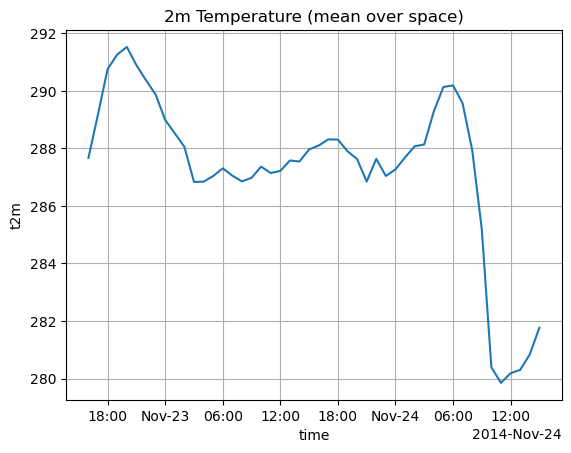

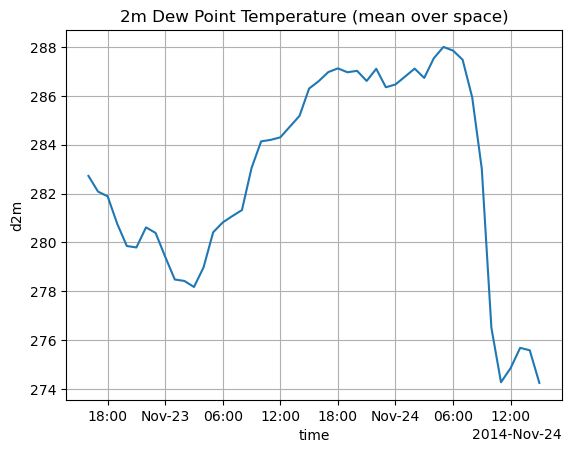

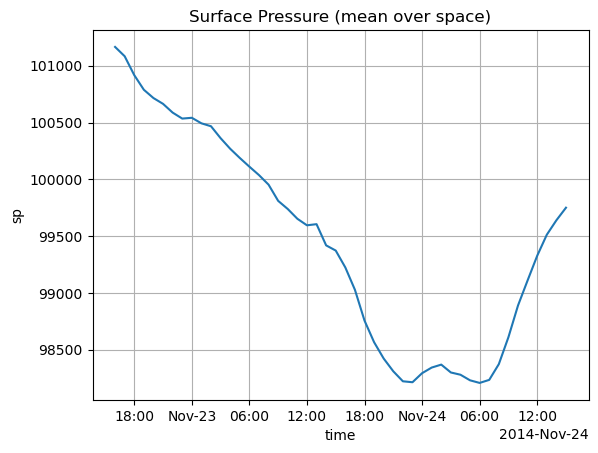

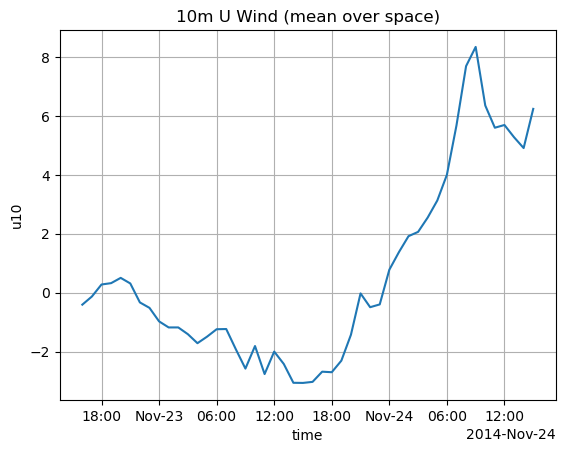

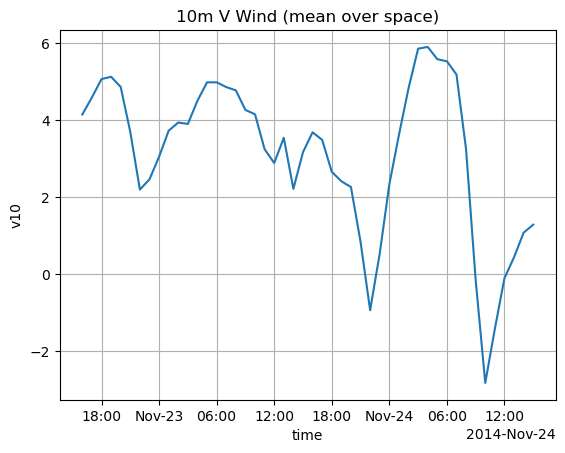

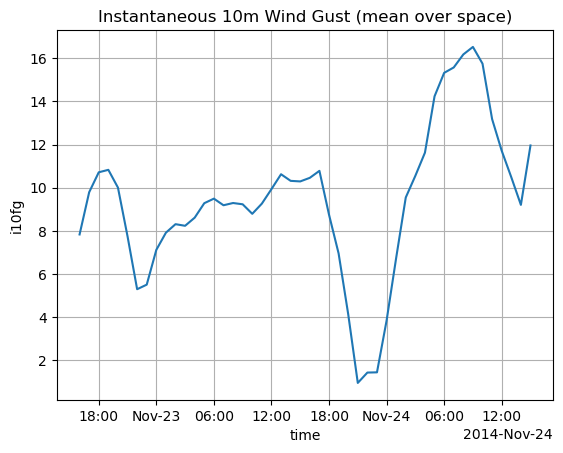

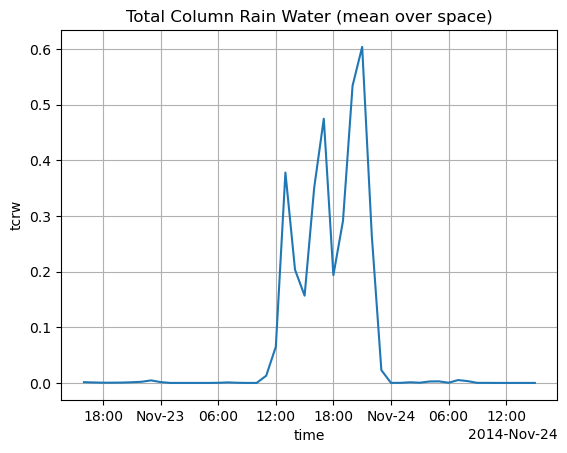

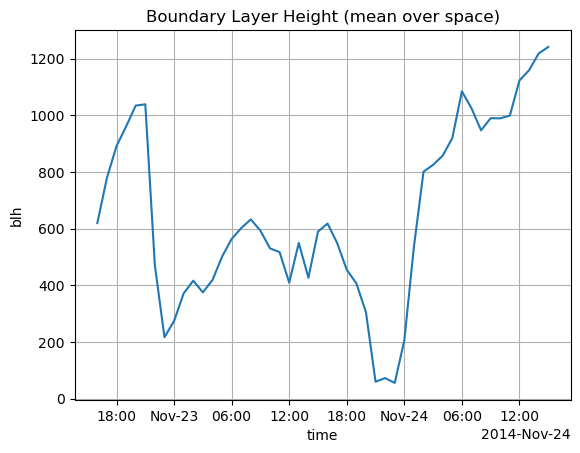

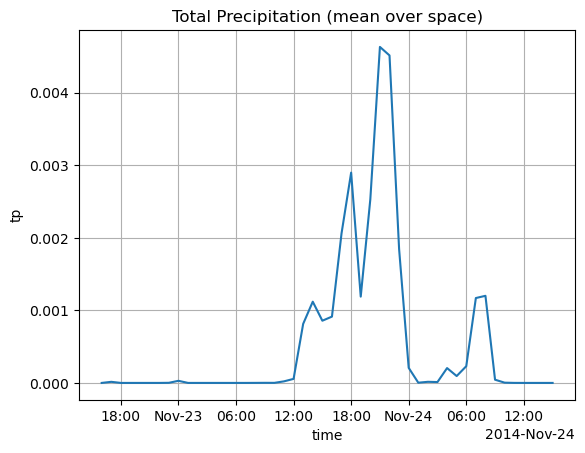

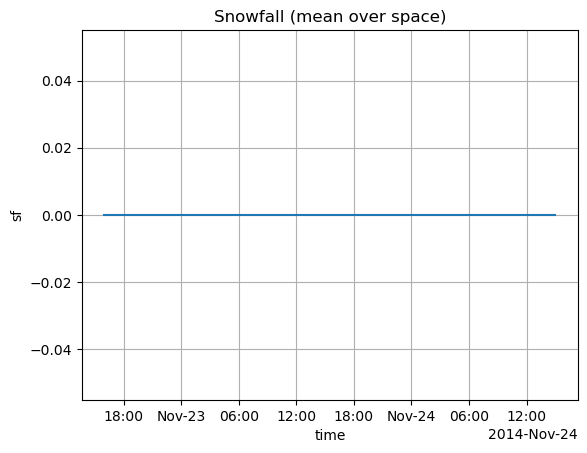

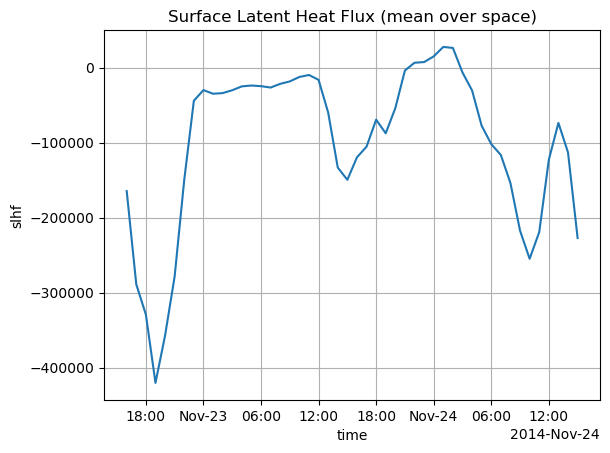

In [ ]:
import matplotlib.pyplot as plt

#file = "data_collection_by_hollis/correlated_outage/weather_output/event_0_2014-11-24_15-00.nc"
file = "data_collection_by_hollis/correlated_outage/weather_output/event_1_2014-11-24_00-00_combined.nc"
xr.open_dataset(file, engine="h5netcdf")

with open(file, "rb") as f:
    head = f.read(512)
    print(head[:300])

file_path = file
print(f"{file_path} size: {os.path.getsize(file_path)} bytes")

print(netCDF4.__version__)
print(xr.backends.list_engines())

ds = xr.open_dataset(
    file,
    engine="netcdf4"
)

print(ds)

# Dictionary of variable names and titles
plot_vars = {
    't2m': '2m Temperature',
    'd2m': '2m Dew Point Temperature',
    'sp': 'Surface Pressure',
    'u10': '10m U Wind',
    'v10': '10m V Wind',
    'i10fg': 'Instantaneous 10m Wind Gust',
    'tcrw': 'Total Column Rain Water',
    'blh': 'Boundary Layer Height',
    'tp': 'Total Precipitation',
    'sf': 'Snowfall',
    'slhf': 'Surface Latent Heat Flux',
    'avg_snswrf': 'Average Net Short-Wave Radiation Flux'
}

for var, title in plot_vars.items():
    if var in ds:
        plt.figure()
        ds[var].mean(dim=['latitude', 'longitude']).plot()
        plt.title(f"{title} (mean over space)")
        plt.grid(True)
    else:
        print(f"⚠️ Variable '{var}' not found in dataset.")
ds.close()


In [32]:
with open(file_path, "rb") as f:
    magic = f.read(4)
    print("Magic bytes:", magic)

print(ds)
print(ds.variables)
print(ds.attrs) 

Magic bytes: b'\x89HDF'
<xarray.Dataset> Size: 1kB
Dimensions:     (valid_time: 48, latitude: 1, longitude: 1)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 384B 2014-11-22T16:00:00 ... 2014...
  * latitude    (latitude) float64 8B 36.27
  * longitude   (longitude) float64 8B -90.52
    expver      (valid_time) <U4 768B ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 192B 0.0 ... 0.0
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-24T02:44 GRIB to CDM+CF via cfgrib-0.9.1...
Frozen({'tp': <xarray.Variable (valid_time: 48, latitude: 1, longitude: 1)> Size: 192B
array([[[0.000000e+00]],

       [[1.510022e-05]],

       [[0.000000e+00]],

       [[0.000000e+00]],